In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import optuna
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, log_loss
import xgboost as xgb
import seaborn as sns

In [2]:
data = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2021_data.csv")
data_2022 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2022_data.csv")
data_2023 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2023_MLB_Seaspm.csv")
height_df = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/player_heights.csv")

In [3]:
testing_data = pd.concat([data_2022, data_2023], axis=0)

In [4]:
testing_data['description'].unique()

array(['hit_into_play', 'ball', 'foul_bunt', 'blocked_ball',
       'swinging_strike', 'foul', 'called_strike', 'foul_tip',
       'hit_by_pitch', 'swinging_strike_blocked', 'missed_bunt',
       'pitchout', 'bunt_foul_tip', 'unknown_strike'], dtype=object)

In [5]:

def preprocess_data(df, height_df):
    """
    This function takes a DataFrame and applies several preprocessing steps to it.
    """
    # Define a function to condense pitch types
    def condense_pitch_type(pitch_type):
        if pitch_type == "FF":
            return "FF"
        elif pitch_type == "FT":
            return "SI"
        elif pitch_type == "FC":
            return "CT"
        elif pitch_type in ["SL", "ST", "SV"]:
            return "SL"
        elif pitch_type in ["CH", "FS"]:
            return "CH"
        elif pitch_type in ["CU", "KC", "CS", "CB"]:
            return "CB"
        elif pitch_type == "SI":
            return "SI"
        elif pitch_type == "KN":
            return "KN"
        else:
            return "FAHCK"
    # Define a function to determine if the pitch resulted in contact
    def is_strike(description):
        return 1 if description in ['foul_bunt', 'swinging_strike', 'foul', 'called_strike', 'foul_tip',
                                    'swinging_strike_blocked', 'missed_bunt', 'bunt_foul_tip'] else 0 
    
    def create_pitch_id(df):
        df['pitch_id_raw'] = (df['game_pk'].astype(str) + "_" +
                          df['batter'].astype(str) + "_" +
                          df['pitcher'].astype(str) + "_" +
                          df['pitch_number'].astype(str) + "_" +
                          df['at_bat_number'].astype(str) + "_" +
                          df['inning'].astype(str))
        return df
    # Define a function to determine if the pitch resulted in a fly ball
    def is_called(description):
        return 1 if description in ['called_strike'] else 0

    def calculate_pitcher_stats(df):
        # Group by pitcher and pitch type
        grouped = df.groupby(['pitcher', 'pitch_type_condensed'])

        # Calculate mean for pfx_x, pfx_z, and velocity
        mean_values = grouped[['pfx_x', 'pfx_z', 'release_speed']].mean()
        mean_values = mean_values.rename(columns={'pfx_x': 'pfx_x_avg',
                                                  'pfx_z': 'pfx_z_avg',
                                                  'release_speed': 'avg_velo'})

        # Calculate max for pfx_x and pfx_z
        max_values = grouped[['pfx_x', 'pfx_z', 'release_speed']].max()
        max_values = max_values.rename(columns={'pfx_x': 'pfx_x_max',
                                                'pfx_z': 'pfx_z_max',
                                                'release_speed': 'max_velo'})

        # Combine mean and max values
        combined_stats = pd.concat([mean_values, max_values], axis=1)

        return combined_stats.reset_index()

    df['pitch_type_condensed'] = df['pitch_type'].apply(condense_pitch_type)

    # Call the new function and store the result
    pitcher_stats = calculate_pitcher_stats(df)

    df = df.merge(pitcher_stats, how='left', on=['pitcher', 'pitch_type_condensed'])

    df['strike'] = df['description'].apply(is_strike)

    df['called_strike'] = df['description'].apply(is_called)
    # Calculate 'release_pos_y'
    df['release_pos_y'] = 60.5 - df['release_extension']
    df['total_movement'] = np.sqrt(df['pfx_x']**2 + df['pfx_z']**2)
    # Create 'pitch_id_raw'
    df = create_pitch_id(df)

    dfs = df.merge(height_df[['id', 'height_numeric']], how='left', left_on='pitcher', right_on='id')
    # Return the preprocessed DataFrame
    return dfs

In [6]:
# Apply the function to the 'pitch_type' column
data_processed = preprocess_data(data, height_df)# Use the query method to filter rows where 'swing' is 1 and 'pitch_type_condensed' is 'FF', 'SI', or 'CT'
training_data = data_processed.query('strike == 1')
testing_data_processed = preprocess_data(testing_data, height_df)


In [7]:
fastball_training = training_data.query('pitch_type_condensed in ("FF", "SI", "CT")')
fastball_testing = testing_data_processed.query('pitch_type_condensed in ("FF", "SI", "CT")')
breaking_ball = training_data.query('pitch_type_condensed in ("SL", "CB")')
breaking_ball_testing = testing_data_processed.query('pitch_type_condensed in ("SL", "CB")')


# Fastball Model First

In [8]:
# Now, separate features and identifiers
training_identifiers = fastball_training[['pitch_id_raw']]
testing_identifiers = fastball_testing[['pitch_id_raw']]
training_features = fastball_training.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'strike',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z'
], axis=1)
testing_features = fastball_testing.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'strike',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'Unnamed: 0'
], axis=1)   # Exclude the identifier from the features

In [9]:
train_data = training_features.drop(['called_strike'], axis=1).copy()
train_label = training_features['called_strike'].copy()
testing_data = testing_features.drop(['called_strike'], axis=1).copy()
testing_label = testing_features['called_strike'].copy()

In [10]:
train_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'balls', 'strikes',
       'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az',
       'release_spin_rate', 'release_extension', 'release_pos_y', 'spin_axis',
       'height_numeric'],
      dtype='object')

In [11]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'balls', 'strikes',
       'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az',
       'release_spin_rate', 'release_extension', 'release_pos_y', 'spin_axis',
       'height_numeric'],
      dtype='object')

In [12]:
# First split: Separate out a portion of the data as a temporary test set
x_temp, x_test, y_temp, y_test = train_test_split(
    train_data, 
    train_label, 
    test_size=0.2, 
    random_state=42
)

# Second split: Split the temporary test set into validation and test sets
x_train, x_valid, y_train, y_valid = train_test_split(
    x_temp, 
    y_temp, 
    test_size=0.25,
    random_state=42
)

In [13]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)
class_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
params = {
    'max_depth': 6,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': 0.9,
    'colsample_bytree': 1,
    'scale_pos_weight': class_ratio,
}

# Initial Model
model = xgb.train(params, dtrain)

In [14]:
# Generate predictions
y_pred = model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.7108120927678059
Log Loss: 0.5790095639297926


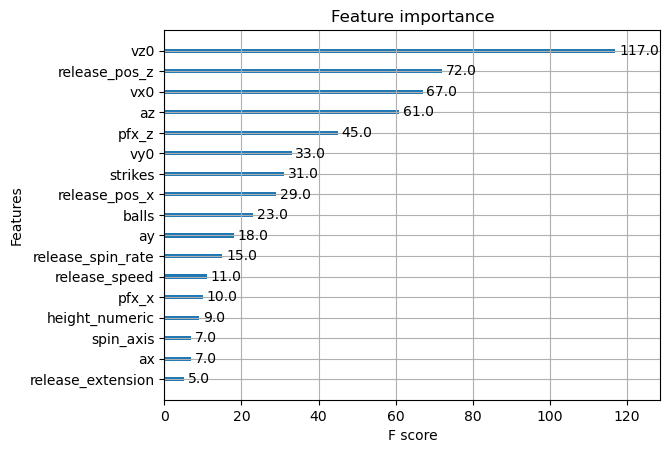

In [15]:
xgb.plot_importance(model)
plt.show()

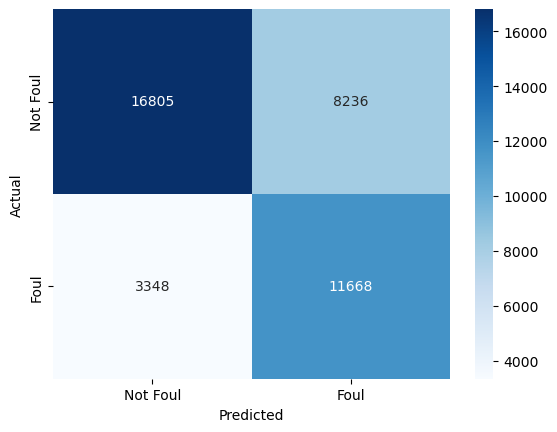

In [16]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Foul', 'Foul'], yticklabels=['Not Foul', 'Foul'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Initial Paramater Tuning

In [17]:
def objective(trial):
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dvalid = xgb.DMatrix(x_valid, label=y_valid)
    
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'scale_pos_weight': class_ratio
    }

    # Train the model with early stopping
    model = xgb.train(
        param, 
        dtrain, 
        num_boost_round=100,  # Maximum number of boosting rounds
        evals=[(dvalid, 'eval')],  # Validation set for early stopping
        early_stopping_rounds=50  # Stop if the eval metric doesn't improve for 50 rounds
    )
    
    # Predict on the validation set using the best iteration
    y_valid_pred = model.predict(dvalid)
    
    # Calculate the log loss on the validation set
    loss = log_loss(y_valid, y_valid_pred)

    return loss

In [18]:
#create an optuna study and specifcy the the direction of the optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)

[I 2023-11-12 12:35:16,954] A new study created in memory with name: no-name-6daad6a2-fc75-44a1-ba0a-714dded6c92d


[0]	eval-logloss:0.63163
[1]	eval-logloss:0.59671
[2]	eval-logloss:0.58304
[3]	eval-logloss:0.56606
[4]	eval-logloss:0.55533
[5]	eval-logloss:0.54741
[6]	eval-logloss:0.54188
[7]	eval-logloss:0.53813
[8]	eval-logloss:0.53573
[9]	eval-logloss:0.53301
[10]	eval-logloss:0.53031
[11]	eval-logloss:0.52737
[12]	eval-logloss:0.52651
[13]	eval-logloss:0.52410
[14]	eval-logloss:0.52330
[15]	eval-logloss:0.52055
[16]	eval-logloss:0.51962
[17]	eval-logloss:0.51925
[18]	eval-logloss:0.51821
[19]	eval-logloss:0.51716
[20]	eval-logloss:0.51689
[21]	eval-logloss:0.51631
[22]	eval-logloss:0.51517
[23]	eval-logloss:0.51486
[24]	eval-logloss:0.51459
[25]	eval-logloss:0.51409
[26]	eval-logloss:0.51401
[27]	eval-logloss:0.51362
[28]	eval-logloss:0.51348
[29]	eval-logloss:0.51318
[30]	eval-logloss:0.51237
[31]	eval-logloss:0.51199
[32]	eval-logloss:0.51204
[33]	eval-logloss:0.51196
[34]	eval-logloss:0.51123
[35]	eval-logloss:0.51109
[36]	eval-logloss:0.51066
[37]	eval-logloss:0.51065
[38]	eval-logloss:0.51

[I 2023-11-12 12:35:18,659] Trial 0 finished with value: 0.5135423663109906 and parameters: {'max_depth': 8, 'eta': 0.27994661294260365, 'subsample': 0.7585111812229275, 'colsample_bytree': 0.9556325805126005}. Best is trial 0 with value: 0.5135423663109906.


[0]	eval-logloss:0.64512
[1]	eval-logloss:0.61285
[2]	eval-logloss:0.59889
[3]	eval-logloss:0.57969
[4]	eval-logloss:0.56717
[5]	eval-logloss:0.55746
[6]	eval-logloss:0.55061
[7]	eval-logloss:0.54590
[8]	eval-logloss:0.54204
[9]	eval-logloss:0.53833
[10]	eval-logloss:0.53452
[11]	eval-logloss:0.53254
[12]	eval-logloss:0.53053
[13]	eval-logloss:0.52865
[14]	eval-logloss:0.52653
[15]	eval-logloss:0.52511
[16]	eval-logloss:0.52335
[17]	eval-logloss:0.52261
[18]	eval-logloss:0.52039
[19]	eval-logloss:0.51878
[20]	eval-logloss:0.51808
[21]	eval-logloss:0.51711
[22]	eval-logloss:0.51560
[23]	eval-logloss:0.51481
[24]	eval-logloss:0.51432
[25]	eval-logloss:0.51445
[26]	eval-logloss:0.51431
[27]	eval-logloss:0.51386
[28]	eval-logloss:0.51345
[29]	eval-logloss:0.51286
[30]	eval-logloss:0.51254
[31]	eval-logloss:0.51230
[32]	eval-logloss:0.51224
[33]	eval-logloss:0.51185
[34]	eval-logloss:0.51148
[35]	eval-logloss:0.51100
[36]	eval-logloss:0.51059
[37]	eval-logloss:0.51045
[38]	eval-logloss:0.51

[I 2023-11-12 12:35:20,437] Trial 1 finished with value: 0.5081025418201177 and parameters: {'max_depth': 9, 'eta': 0.20392315683000065, 'subsample': 0.8743872855873253, 'colsample_bytree': 0.7803102332933198}. Best is trial 1 with value: 0.5081025418201177.


[0]	eval-logloss:0.65751
[1]	eval-logloss:0.63072
[2]	eval-logloss:0.62143
[3]	eval-logloss:0.61398
[4]	eval-logloss:0.60033
[5]	eval-logloss:0.59015
[6]	eval-logloss:0.58257
[7]	eval-logloss:0.57855
[8]	eval-logloss:0.57342
[9]	eval-logloss:0.56920
[10]	eval-logloss:0.56579
[11]	eval-logloss:0.56253
[12]	eval-logloss:0.56057
[13]	eval-logloss:0.55807
[14]	eval-logloss:0.55646
[15]	eval-logloss:0.55464
[16]	eval-logloss:0.55280
[17]	eval-logloss:0.55058
[18]	eval-logloss:0.54776
[19]	eval-logloss:0.54680
[20]	eval-logloss:0.54607
[21]	eval-logloss:0.54500
[22]	eval-logloss:0.54324
[23]	eval-logloss:0.54236
[24]	eval-logloss:0.54158
[25]	eval-logloss:0.54109
[26]	eval-logloss:0.54038
[27]	eval-logloss:0.53952
[28]	eval-logloss:0.53757
[29]	eval-logloss:0.53699
[30]	eval-logloss:0.53606
[31]	eval-logloss:0.53532
[32]	eval-logloss:0.53475
[33]	eval-logloss:0.53421
[34]	eval-logloss:0.53367
[35]	eval-logloss:0.53331
[36]	eval-logloss:0.53313
[37]	eval-logloss:0.53259
[38]	eval-logloss:0.53

[I 2023-11-12 12:35:21,507] Trial 2 finished with value: 0.5193035709666148 and parameters: {'max_depth': 4, 'eta': 0.20428679908298797, 'subsample': 0.6214539985173806, 'colsample_bytree': 0.646369731768805}. Best is trial 1 with value: 0.5081025418201177.


[0]	eval-logloss:0.66670
[1]	eval-logloss:0.64210
[2]	eval-logloss:0.63106
[3]	eval-logloss:0.62197
[4]	eval-logloss:0.60872
[5]	eval-logloss:0.59647
[6]	eval-logloss:0.58618
[7]	eval-logloss:0.58099
[8]	eval-logloss:0.57361
[9]	eval-logloss:0.56732
[10]	eval-logloss:0.56193
[11]	eval-logloss:0.55835
[12]	eval-logloss:0.55474
[13]	eval-logloss:0.55181
[14]	eval-logloss:0.54884
[15]	eval-logloss:0.54631
[16]	eval-logloss:0.54388
[17]	eval-logloss:0.54165
[18]	eval-logloss:0.53942
[19]	eval-logloss:0.53785
[20]	eval-logloss:0.53698
[21]	eval-logloss:0.53616
[22]	eval-logloss:0.53494
[23]	eval-logloss:0.53385
[24]	eval-logloss:0.53320
[25]	eval-logloss:0.53267
[26]	eval-logloss:0.53195
[27]	eval-logloss:0.53089
[28]	eval-logloss:0.52919
[29]	eval-logloss:0.52863
[30]	eval-logloss:0.52701
[31]	eval-logloss:0.52642
[32]	eval-logloss:0.52596
[33]	eval-logloss:0.52551
[34]	eval-logloss:0.52475
[35]	eval-logloss:0.52392
[36]	eval-logloss:0.52372
[37]	eval-logloss:0.52272
[38]	eval-logloss:0.52

[I 2023-11-12 12:35:22,881] Trial 3 finished with value: 0.507683406454005 and parameters: {'max_depth': 7, 'eta': 0.13346443923588325, 'subsample': 0.7697423507399652, 'colsample_bytree': 0.6143765665211682}. Best is trial 3 with value: 0.507683406454005.


[0]	eval-logloss:0.64975
[1]	eval-logloss:0.62451
[2]	eval-logloss:0.61575
[3]	eval-logloss:0.60119
[4]	eval-logloss:0.59140
[5]	eval-logloss:0.58529
[6]	eval-logloss:0.58126
[7]	eval-logloss:0.57718
[8]	eval-logloss:0.57396
[9]	eval-logloss:0.57043
[10]	eval-logloss:0.56842
[11]	eval-logloss:0.56505
[12]	eval-logloss:0.56276
[13]	eval-logloss:0.56132
[14]	eval-logloss:0.55908
[15]	eval-logloss:0.55812
[16]	eval-logloss:0.55687
[17]	eval-logloss:0.55562
[18]	eval-logloss:0.55380
[19]	eval-logloss:0.55209
[20]	eval-logloss:0.55112
[21]	eval-logloss:0.55026
[22]	eval-logloss:0.54934
[23]	eval-logloss:0.54805
[24]	eval-logloss:0.54715
[25]	eval-logloss:0.54514
[26]	eval-logloss:0.54476
[27]	eval-logloss:0.54392
[28]	eval-logloss:0.54360
[29]	eval-logloss:0.54262
[30]	eval-logloss:0.54206
[31]	eval-logloss:0.54132
[32]	eval-logloss:0.54074
[33]	eval-logloss:0.53967
[34]	eval-logloss:0.53891
[35]	eval-logloss:0.53797
[36]	eval-logloss:0.53777
[37]	eval-logloss:0.53742
[38]	eval-logloss:0.53

[I 2023-11-12 12:35:23,978] Trial 4 finished with value: 0.5195998799822379 and parameters: {'max_depth': 3, 'eta': 0.2534676632069983, 'subsample': 0.8412203478716717, 'colsample_bytree': 0.8714820659357364}. Best is trial 3 with value: 0.507683406454005.


[0]	eval-logloss:0.67900
[1]	eval-logloss:0.63857
[2]	eval-logloss:0.62189
[3]	eval-logloss:0.60878
[4]	eval-logloss:0.58881
[5]	eval-logloss:0.57379
[6]	eval-logloss:0.56536
[7]	eval-logloss:0.56457
[8]	eval-logloss:0.55982
[9]	eval-logloss:0.55585
[10]	eval-logloss:0.54929
[11]	eval-logloss:0.54661
[12]	eval-logloss:0.54403
[13]	eval-logloss:0.54324
[14]	eval-logloss:0.54118
[15]	eval-logloss:0.53771
[16]	eval-logloss:0.53572
[17]	eval-logloss:0.53386
[18]	eval-logloss:0.53127
[19]	eval-logloss:0.53017
[20]	eval-logloss:0.52947
[21]	eval-logloss:0.52896
[22]	eval-logloss:0.52848
[23]	eval-logloss:0.52676
[24]	eval-logloss:0.52645
[25]	eval-logloss:0.52622
[26]	eval-logloss:0.52570
[27]	eval-logloss:0.52505
[28]	eval-logloss:0.52470
[29]	eval-logloss:0.52471
[30]	eval-logloss:0.52355
[31]	eval-logloss:0.52312
[32]	eval-logloss:0.52287
[33]	eval-logloss:0.52304
[34]	eval-logloss:0.52195
[35]	eval-logloss:0.52117
[36]	eval-logloss:0.52117
[37]	eval-logloss:0.52078
[38]	eval-logloss:0.52

[I 2023-11-12 12:35:25,632] Trial 5 finished with value: 0.512227910378914 and parameters: {'max_depth': 6, 'eta': 0.26762375283258305, 'subsample': 0.7663436750202215, 'colsample_bytree': 0.5415803356172583}. Best is trial 3 with value: 0.507683406454005.


[0]	eval-logloss:0.64615
[1]	eval-logloss:0.61316
[2]	eval-logloss:0.60046
[3]	eval-logloss:0.59099
[4]	eval-logloss:0.57779
[5]	eval-logloss:0.56843
[6]	eval-logloss:0.56190
[7]	eval-logloss:0.55914
[8]	eval-logloss:0.55474
[9]	eval-logloss:0.55104
[10]	eval-logloss:0.54737
[11]	eval-logloss:0.54557
[12]	eval-logloss:0.54389
[13]	eval-logloss:0.54042
[14]	eval-logloss:0.53857
[15]	eval-logloss:0.53588
[16]	eval-logloss:0.53458
[17]	eval-logloss:0.53362
[18]	eval-logloss:0.53229
[19]	eval-logloss:0.53166
[20]	eval-logloss:0.53068
[21]	eval-logloss:0.53023
[22]	eval-logloss:0.52932
[23]	eval-logloss:0.52789
[24]	eval-logloss:0.52665
[25]	eval-logloss:0.52625
[26]	eval-logloss:0.52561
[27]	eval-logloss:0.52536
[28]	eval-logloss:0.52445
[29]	eval-logloss:0.52363
[30]	eval-logloss:0.52353
[31]	eval-logloss:0.52288
[32]	eval-logloss:0.52283
[33]	eval-logloss:0.52166
[34]	eval-logloss:0.52116
[35]	eval-logloss:0.52004
[36]	eval-logloss:0.51940
[37]	eval-logloss:0.51914
[38]	eval-logloss:0.51

[I 2023-11-12 12:35:26,650] Trial 6 finished with value: 0.5100690834757245 and parameters: {'max_depth': 5, 'eta': 0.2735696647720691, 'subsample': 0.7343609913279794, 'colsample_bytree': 0.6896417130869672}. Best is trial 3 with value: 0.507683406454005.


[0]	eval-logloss:0.63926
[1]	eval-logloss:0.60624
[2]	eval-logloss:0.59296
[3]	eval-logloss:0.57608
[4]	eval-logloss:0.56431
[5]	eval-logloss:0.55647
[6]	eval-logloss:0.55070
[7]	eval-logloss:0.54678
[8]	eval-logloss:0.54337
[9]	eval-logloss:0.54025
[10]	eval-logloss:0.53660
[11]	eval-logloss:0.53498
[12]	eval-logloss:0.53284
[13]	eval-logloss:0.53160
[14]	eval-logloss:0.52993
[15]	eval-logloss:0.52851
[16]	eval-logloss:0.52791
[17]	eval-logloss:0.52687
[18]	eval-logloss:0.52577
[19]	eval-logloss:0.52446
[20]	eval-logloss:0.52444
[21]	eval-logloss:0.52307
[22]	eval-logloss:0.52063
[23]	eval-logloss:0.51977
[24]	eval-logloss:0.51953
[25]	eval-logloss:0.51953
[26]	eval-logloss:0.51950
[27]	eval-logloss:0.51893
[28]	eval-logloss:0.51796
[29]	eval-logloss:0.51749
[30]	eval-logloss:0.51689
[31]	eval-logloss:0.51662
[32]	eval-logloss:0.51638
[33]	eval-logloss:0.51550
[34]	eval-logloss:0.51510
[35]	eval-logloss:0.51460
[36]	eval-logloss:0.51434
[37]	eval-logloss:0.51353
[38]	eval-logloss:0.51

[I 2023-11-12 12:35:28,112] Trial 7 finished with value: 0.5092490121477652 and parameters: {'max_depth': 7, 'eta': 0.2511552285542049, 'subsample': 0.8045774208554319, 'colsample_bytree': 0.8105917162437073}. Best is trial 3 with value: 0.507683406454005.


[0]	eval-logloss:0.63255
[1]	eval-logloss:0.59713
[2]	eval-logloss:0.58290
[3]	eval-logloss:0.56521
[4]	eval-logloss:0.55365
[5]	eval-logloss:0.54598
[6]	eval-logloss:0.53992
[7]	eval-logloss:0.53600
[8]	eval-logloss:0.53306
[9]	eval-logloss:0.53034
[10]	eval-logloss:0.52842
[11]	eval-logloss:0.52515
[12]	eval-logloss:0.52325
[13]	eval-logloss:0.52217
[14]	eval-logloss:0.52128
[15]	eval-logloss:0.51958
[16]	eval-logloss:0.51889
[17]	eval-logloss:0.51756
[18]	eval-logloss:0.51642
[19]	eval-logloss:0.51599
[20]	eval-logloss:0.51548
[21]	eval-logloss:0.51536
[22]	eval-logloss:0.51534
[23]	eval-logloss:0.51533
[24]	eval-logloss:0.51502
[25]	eval-logloss:0.51488
[26]	eval-logloss:0.51507
[27]	eval-logloss:0.51494
[28]	eval-logloss:0.51474
[29]	eval-logloss:0.51464
[30]	eval-logloss:0.51373
[31]	eval-logloss:0.51343
[32]	eval-logloss:0.51339
[33]	eval-logloss:0.51277
[34]	eval-logloss:0.51249
[35]	eval-logloss:0.51224
[36]	eval-logloss:0.51227
[37]	eval-logloss:0.51218
[38]	eval-logloss:0.51

[I 2023-11-12 12:35:29,904] Trial 8 finished with value: 0.5167616082960911 and parameters: {'max_depth': 9, 'eta': 0.26478875725851597, 'subsample': 0.8207653354610781, 'colsample_bytree': 0.9299748624703834}. Best is trial 3 with value: 0.507683406454005.


[0]	eval-logloss:0.65798
[1]	eval-logloss:0.63329
[2]	eval-logloss:0.62307
[3]	eval-logloss:0.60703
[4]	eval-logloss:0.59484
[5]	eval-logloss:0.58550
[6]	eval-logloss:0.57861
[7]	eval-logloss:0.57292
[8]	eval-logloss:0.56836
[9]	eval-logloss:0.56456
[10]	eval-logloss:0.56083
[11]	eval-logloss:0.55821
[12]	eval-logloss:0.55587
[13]	eval-logloss:0.55322
[14]	eval-logloss:0.55105
[15]	eval-logloss:0.54892
[16]	eval-logloss:0.54701
[17]	eval-logloss:0.54588
[18]	eval-logloss:0.54376
[19]	eval-logloss:0.54207
[20]	eval-logloss:0.54100
[21]	eval-logloss:0.53996
[22]	eval-logloss:0.53864
[23]	eval-logloss:0.53756
[24]	eval-logloss:0.53693
[25]	eval-logloss:0.53624
[26]	eval-logloss:0.53547
[27]	eval-logloss:0.53429
[28]	eval-logloss:0.53377
[29]	eval-logloss:0.53320
[30]	eval-logloss:0.53252
[31]	eval-logloss:0.53167
[32]	eval-logloss:0.53073
[33]	eval-logloss:0.52991
[34]	eval-logloss:0.52908
[35]	eval-logloss:0.52838
[36]	eval-logloss:0.52803
[37]	eval-logloss:0.52671
[38]	eval-logloss:0.52

[I 2023-11-12 12:35:31,190] Trial 9 finished with value: 0.5108758007007757 and parameters: {'max_depth': 5, 'eta': 0.17191167731781667, 'subsample': 0.8594061951797962, 'colsample_bytree': 0.8625647337880531}. Best is trial 3 with value: 0.507683406454005.


[0]	eval-logloss:0.68815
[1]	eval-logloss:0.67375
[2]	eval-logloss:0.66579
[3]	eval-logloss:0.65828
[4]	eval-logloss:0.64670
[5]	eval-logloss:0.63511
[6]	eval-logloss:0.62545
[7]	eval-logloss:0.62480
[8]	eval-logloss:0.61775
[9]	eval-logloss:0.61145
[10]	eval-logloss:0.60314
[11]	eval-logloss:0.59709
[12]	eval-logloss:0.59123
[13]	eval-logloss:0.59015
[14]	eval-logloss:0.58525
[15]	eval-logloss:0.58091
[16]	eval-logloss:0.57680
[17]	eval-logloss:0.57250
[18]	eval-logloss:0.56940
[19]	eval-logloss:0.56688
[20]	eval-logloss:0.56488
[21]	eval-logloss:0.56307
[22]	eval-logloss:0.56049
[23]	eval-logloss:0.55935
[24]	eval-logloss:0.55732
[25]	eval-logloss:0.55596
[26]	eval-logloss:0.55470
[27]	eval-logloss:0.55253
[28]	eval-logloss:0.55221
[29]	eval-logloss:0.55193
[30]	eval-logloss:0.55095
[31]	eval-logloss:0.54913
[32]	eval-logloss:0.54769
[33]	eval-logloss:0.54710
[34]	eval-logloss:0.54566
[35]	eval-logloss:0.54440
[36]	eval-logloss:0.54426
[37]	eval-logloss:0.54343
[38]	eval-logloss:0.54

[I 2023-11-12 12:35:33,014] Trial 10 finished with value: 0.5181819143125286 and parameters: {'max_depth': 7, 'eta': 0.0781854252139212, 'subsample': 0.6918629379956708, 'colsample_bytree': 0.5033991969725616}. Best is trial 3 with value: 0.507683406454005.


[0]	eval-logloss:0.66466
[1]	eval-logloss:0.64216
[2]	eval-logloss:0.63075
[3]	eval-logloss:0.61408
[4]	eval-logloss:0.60062
[5]	eval-logloss:0.58984
[6]	eval-logloss:0.58071
[7]	eval-logloss:0.57374
[8]	eval-logloss:0.56704
[9]	eval-logloss:0.56093
[10]	eval-logloss:0.55591
[11]	eval-logloss:0.55222
[12]	eval-logloss:0.54897
[13]	eval-logloss:0.54648
[14]	eval-logloss:0.54326
[15]	eval-logloss:0.54027
[16]	eval-logloss:0.53789
[17]	eval-logloss:0.53597
[18]	eval-logloss:0.53433
[19]	eval-logloss:0.53288
[20]	eval-logloss:0.53170
[21]	eval-logloss:0.53042
[22]	eval-logloss:0.52914
[23]	eval-logloss:0.52819
[24]	eval-logloss:0.52689
[25]	eval-logloss:0.52630
[26]	eval-logloss:0.52570
[27]	eval-logloss:0.52503
[28]	eval-logloss:0.52377
[29]	eval-logloss:0.52265
[30]	eval-logloss:0.52098
[31]	eval-logloss:0.52038
[32]	eval-logloss:0.52004
[33]	eval-logloss:0.51921
[34]	eval-logloss:0.51868
[35]	eval-logloss:0.51767
[36]	eval-logloss:0.51632
[37]	eval-logloss:0.51583
[38]	eval-logloss:0.51

[I 2023-11-12 12:35:36,176] Trial 11 finished with value: 0.5039377408387825 and parameters: {'max_depth': 9, 'eta': 0.1146842037968402, 'subsample': 0.8983509693405396, 'colsample_bytree': 0.7358607909416474}. Best is trial 11 with value: 0.5039377408387825.


[0]	eval-logloss:0.67121
[1]	eval-logloss:0.64963
[2]	eval-logloss:0.63931
[3]	eval-logloss:0.63020
[4]	eval-logloss:0.61820
[5]	eval-logloss:0.60649
[6]	eval-logloss:0.59582
[7]	eval-logloss:0.59017
[8]	eval-logloss:0.58225
[9]	eval-logloss:0.57521
[10]	eval-logloss:0.56892
[11]	eval-logloss:0.56465
[12]	eval-logloss:0.56031
[13]	eval-logloss:0.55740
[14]	eval-logloss:0.55356
[15]	eval-logloss:0.55064
[16]	eval-logloss:0.54779
[17]	eval-logloss:0.54520
[18]	eval-logloss:0.54272
[19]	eval-logloss:0.54090
[20]	eval-logloss:0.53973
[21]	eval-logloss:0.53839
[22]	eval-logloss:0.53684
[23]	eval-logloss:0.53570
[24]	eval-logloss:0.53466
[25]	eval-logloss:0.53395
[26]	eval-logloss:0.53310
[27]	eval-logloss:0.53194
[28]	eval-logloss:0.53051
[29]	eval-logloss:0.52996
[30]	eval-logloss:0.52826
[31]	eval-logloss:0.52740
[32]	eval-logloss:0.52679
[33]	eval-logloss:0.52604
[34]	eval-logloss:0.52537
[35]	eval-logloss:0.52415
[36]	eval-logloss:0.52402
[37]	eval-logloss:0.52323
[38]	eval-logloss:0.52

[I 2023-11-12 12:35:39,029] Trial 12 finished with value: 0.5072974327415635 and parameters: {'max_depth': 8, 'eta': 0.10637348844601222, 'subsample': 0.89671287675079, 'colsample_bytree': 0.666000734765354}. Best is trial 11 with value: 0.5039377408387825.


[0]	eval-logloss:0.68693
[1]	eval-logloss:0.68108
[2]	eval-logloss:0.67778
[3]	eval-logloss:0.67222
[4]	eval-logloss:0.66697
[5]	eval-logloss:0.66215
[6]	eval-logloss:0.65739
[7]	eval-logloss:0.65320
[8]	eval-logloss:0.64896
[9]	eval-logloss:0.64459
[10]	eval-logloss:0.64040
[11]	eval-logloss:0.63678
[12]	eval-logloss:0.63319
[13]	eval-logloss:0.63089
[14]	eval-logloss:0.62736
[15]	eval-logloss:0.62427
[16]	eval-logloss:0.62099
[17]	eval-logloss:0.61769
[18]	eval-logloss:0.61598
[19]	eval-logloss:0.61409
[20]	eval-logloss:0.61187
[21]	eval-logloss:0.60954
[22]	eval-logloss:0.60665
[23]	eval-logloss:0.60501
[24]	eval-logloss:0.60256
[25]	eval-logloss:0.60074
[26]	eval-logloss:0.59852
[27]	eval-logloss:0.59618
[28]	eval-logloss:0.59521
[29]	eval-logloss:0.59315
[30]	eval-logloss:0.59232
[31]	eval-logloss:0.59013
[32]	eval-logloss:0.58814
[33]	eval-logloss:0.58608
[34]	eval-logloss:0.58424
[35]	eval-logloss:0.58231
[36]	eval-logloss:0.58154
[37]	eval-logloss:0.57965
[38]	eval-logloss:0.57

[I 2023-11-12 12:35:42,241] Trial 13 finished with value: 0.5327782216570476 and parameters: {'max_depth': 9, 'eta': 0.023770051721939828, 'subsample': 0.894359683992325, 'colsample_bytree': 0.7335592535927458}. Best is trial 11 with value: 0.5039377408387825.


[0]	eval-logloss:0.66699
[1]	eval-logloss:0.64600
[2]	eval-logloss:0.63585
[3]	eval-logloss:0.61996
[4]	eval-logloss:0.60705
[5]	eval-logloss:0.59656
[6]	eval-logloss:0.58743
[7]	eval-logloss:0.58034
[8]	eval-logloss:0.57372
[9]	eval-logloss:0.56768
[10]	eval-logloss:0.56266
[11]	eval-logloss:0.55884
[12]	eval-logloss:0.55542
[13]	eval-logloss:0.55276
[14]	eval-logloss:0.54950
[15]	eval-logloss:0.54669
[16]	eval-logloss:0.54423
[17]	eval-logloss:0.54198
[18]	eval-logloss:0.54005
[19]	eval-logloss:0.53850
[20]	eval-logloss:0.53721
[21]	eval-logloss:0.53598
[22]	eval-logloss:0.53467
[23]	eval-logloss:0.53357
[24]	eval-logloss:0.53233
[25]	eval-logloss:0.53172
[26]	eval-logloss:0.53100
[27]	eval-logloss:0.53018
[28]	eval-logloss:0.52893
[29]	eval-logloss:0.52760
[30]	eval-logloss:0.52611
[31]	eval-logloss:0.52544
[32]	eval-logloss:0.52502
[33]	eval-logloss:0.52417
[34]	eval-logloss:0.52351
[35]	eval-logloss:0.52255
[36]	eval-logloss:0.52130
[37]	eval-logloss:0.52084
[38]	eval-logloss:0.52

[I 2023-11-12 12:35:45,033] Trial 14 finished with value: 0.5047386224458621 and parameters: {'max_depth': 8, 'eta': 0.10851839183299837, 'subsample': 0.8961479611114515, 'colsample_bytree': 0.7291895153415627}. Best is trial 11 with value: 0.5039377408387825.


[0]	eval-logloss:0.67373
[1]	eval-logloss:0.65719
[2]	eval-logloss:0.64879
[3]	eval-logloss:0.63533
[4]	eval-logloss:0.62380
[5]	eval-logloss:0.61399
[6]	eval-logloss:0.60520
[7]	eval-logloss:0.59795
[8]	eval-logloss:0.59117
[9]	eval-logloss:0.58472
[10]	eval-logloss:0.57894
[11]	eval-logloss:0.57447
[12]	eval-logloss:0.57036
[13]	eval-logloss:0.56751
[14]	eval-logloss:0.56369
[15]	eval-logloss:0.56030
[16]	eval-logloss:0.55709
[17]	eval-logloss:0.55415
[18]	eval-logloss:0.55197
[19]	eval-logloss:0.55021
[20]	eval-logloss:0.54849
[21]	eval-logloss:0.54692
[22]	eval-logloss:0.54499
[23]	eval-logloss:0.54350
[24]	eval-logloss:0.54208
[25]	eval-logloss:0.54106
[26]	eval-logloss:0.53991
[27]	eval-logloss:0.53857
[28]	eval-logloss:0.53732
[29]	eval-logloss:0.53599
[30]	eval-logloss:0.53500
[31]	eval-logloss:0.53381
[32]	eval-logloss:0.53296
[33]	eval-logloss:0.53205
[34]	eval-logloss:0.53124
[35]	eval-logloss:0.53038
[36]	eval-logloss:0.52957
[37]	eval-logloss:0.52877
[38]	eval-logloss:0.52

[I 2023-11-12 12:35:47,334] Trial 15 finished with value: 0.5088344887811946 and parameters: {'max_depth': 8, 'eta': 0.07901141179545591, 'subsample': 0.8527740693758717, 'colsample_bytree': 0.7553042605894138}. Best is trial 11 with value: 0.5039377408387825.


[0]	eval-logloss:0.66075
[1]	eval-logloss:0.63615
[2]	eval-logloss:0.62448
[3]	eval-logloss:0.60703
[4]	eval-logloss:0.59358
[5]	eval-logloss:0.58330
[6]	eval-logloss:0.57461
[7]	eval-logloss:0.56793
[8]	eval-logloss:0.56189
[9]	eval-logloss:0.55642
[10]	eval-logloss:0.55189
[11]	eval-logloss:0.54892
[12]	eval-logloss:0.54617
[13]	eval-logloss:0.54387
[14]	eval-logloss:0.54141
[15]	eval-logloss:0.53902
[16]	eval-logloss:0.53687
[17]	eval-logloss:0.53516
[18]	eval-logloss:0.53372
[19]	eval-logloss:0.53187
[20]	eval-logloss:0.53078
[21]	eval-logloss:0.52978
[22]	eval-logloss:0.52882
[23]	eval-logloss:0.52796
[24]	eval-logloss:0.52688
[25]	eval-logloss:0.52627
[26]	eval-logloss:0.52585
[27]	eval-logloss:0.52528
[28]	eval-logloss:0.52384
[29]	eval-logloss:0.52268
[30]	eval-logloss:0.52078
[31]	eval-logloss:0.52033
[32]	eval-logloss:0.52005
[33]	eval-logloss:0.51932
[34]	eval-logloss:0.51883
[35]	eval-logloss:0.51761
[36]	eval-logloss:0.51690
[37]	eval-logloss:0.51593
[38]	eval-logloss:0.51

[I 2023-11-12 12:35:49,682] Trial 16 finished with value: 0.5038658543067969 and parameters: {'max_depth': 8, 'eta': 0.13661592119396312, 'subsample': 0.8939750068572062, 'colsample_bytree': 0.7231520331515913}. Best is trial 16 with value: 0.5038658543067969.


[0]	eval-logloss:0.65405
[1]	eval-logloss:0.62533
[2]	eval-logloss:0.61238
[3]	eval-logloss:0.59404
[4]	eval-logloss:0.58008
[5]	eval-logloss:0.56926
[6]	eval-logloss:0.56055
[7]	eval-logloss:0.55397
[8]	eval-logloss:0.54872
[9]	eval-logloss:0.54411
[10]	eval-logloss:0.54050
[11]	eval-logloss:0.53764
[12]	eval-logloss:0.53486
[13]	eval-logloss:0.53282
[14]	eval-logloss:0.53106
[15]	eval-logloss:0.52936
[16]	eval-logloss:0.52835
[17]	eval-logloss:0.52653
[18]	eval-logloss:0.52488
[19]	eval-logloss:0.52364
[20]	eval-logloss:0.52296
[21]	eval-logloss:0.52184
[22]	eval-logloss:0.52033
[23]	eval-logloss:0.51917
[24]	eval-logloss:0.51813
[25]	eval-logloss:0.51647
[26]	eval-logloss:0.51640
[27]	eval-logloss:0.51613
[28]	eval-logloss:0.51509
[29]	eval-logloss:0.51452
[30]	eval-logloss:0.51365
[31]	eval-logloss:0.51274
[32]	eval-logloss:0.51256
[33]	eval-logloss:0.51241
[34]	eval-logloss:0.51229
[35]	eval-logloss:0.51180
[36]	eval-logloss:0.51121
[37]	eval-logloss:0.51018
[38]	eval-logloss:0.50

[I 2023-11-12 12:35:52,110] Trial 17 finished with value: 0.5038437184475476 and parameters: {'max_depth': 9, 'eta': 0.15983879335688259, 'subsample': 0.8233996454747438, 'colsample_bytree': 0.9982764872004084}. Best is trial 17 with value: 0.5038437184475476.


[0]	eval-logloss:0.65750
[1]	eval-logloss:0.63184
[2]	eval-logloss:0.62089
[3]	eval-logloss:0.60420
[4]	eval-logloss:0.59160
[5]	eval-logloss:0.58131
[6]	eval-logloss:0.57357
[7]	eval-logloss:0.56735
[8]	eval-logloss:0.56251
[9]	eval-logloss:0.55801
[10]	eval-logloss:0.55474
[11]	eval-logloss:0.55160
[12]	eval-logloss:0.54909
[13]	eval-logloss:0.54693
[14]	eval-logloss:0.54477
[15]	eval-logloss:0.54209
[16]	eval-logloss:0.54071
[17]	eval-logloss:0.53929
[18]	eval-logloss:0.53727
[19]	eval-logloss:0.53626
[20]	eval-logloss:0.53414
[21]	eval-logloss:0.53314
[22]	eval-logloss:0.53214
[23]	eval-logloss:0.53122
[24]	eval-logloss:0.53047
[25]	eval-logloss:0.52997
[26]	eval-logloss:0.52953
[27]	eval-logloss:0.52888
[28]	eval-logloss:0.52787
[29]	eval-logloss:0.52701
[30]	eval-logloss:0.52533
[31]	eval-logloss:0.52479
[32]	eval-logloss:0.52434
[33]	eval-logloss:0.52379
[34]	eval-logloss:0.52211
[35]	eval-logloss:0.52133
[36]	eval-logloss:0.52102
[37]	eval-logloss:0.52082
[38]	eval-logloss:0.52

[I 2023-11-12 12:35:53,910] Trial 18 finished with value: 0.5068428205762321 and parameters: {'max_depth': 6, 'eta': 0.16599209101671658, 'subsample': 0.8164994016685684, 'colsample_bytree': 0.9991900203229391}. Best is trial 17 with value: 0.5038437184475476.


[0]	eval-logloss:0.65036
[1]	eval-logloss:0.62079
[2]	eval-logloss:0.60799
[3]	eval-logloss:0.59016
[4]	eval-logloss:0.57750
[5]	eval-logloss:0.56785
[6]	eval-logloss:0.56018
[7]	eval-logloss:0.55518
[8]	eval-logloss:0.55089
[9]	eval-logloss:0.54704
[10]	eval-logloss:0.54420
[11]	eval-logloss:0.54222
[12]	eval-logloss:0.54028
[13]	eval-logloss:0.53861
[14]	eval-logloss:0.53611
[15]	eval-logloss:0.53306
[16]	eval-logloss:0.53203
[17]	eval-logloss:0.53042
[18]	eval-logloss:0.52866
[19]	eval-logloss:0.52786
[20]	eval-logloss:0.52717
[21]	eval-logloss:0.52617
[22]	eval-logloss:0.52521
[23]	eval-logloss:0.52378
[24]	eval-logloss:0.52296
[25]	eval-logloss:0.52173
[26]	eval-logloss:0.52120
[27]	eval-logloss:0.52068
[28]	eval-logloss:0.52005
[29]	eval-logloss:0.51977
[30]	eval-logloss:0.51869
[31]	eval-logloss:0.51852
[32]	eval-logloss:0.51816
[33]	eval-logloss:0.51701
[34]	eval-logloss:0.51662
[35]	eval-logloss:0.51601
[36]	eval-logloss:0.51592
[37]	eval-logloss:0.51539
[38]	eval-logloss:0.51

[I 2023-11-12 12:35:55,831] Trial 19 finished with value: 0.5060347431254798 and parameters: {'max_depth': 7, 'eta': 0.19421263885735673, 'subsample': 0.846144595693302, 'colsample_bytree': 0.8344700883325087}. Best is trial 17 with value: 0.5038437184475476.


[0]	eval-logloss:0.65835
[1]	eval-logloss:0.63237
[2]	eval-logloss:0.62058
[3]	eval-logloss:0.60306
[4]	eval-logloss:0.58960
[5]	eval-logloss:0.57835
[6]	eval-logloss:0.56934
[7]	eval-logloss:0.56265
[8]	eval-logloss:0.55702
[9]	eval-logloss:0.55202
[10]	eval-logloss:0.54788
[11]	eval-logloss:0.54459
[12]	eval-logloss:0.54184
[13]	eval-logloss:0.53986
[14]	eval-logloss:0.53778
[15]	eval-logloss:0.53576
[16]	eval-logloss:0.53331
[17]	eval-logloss:0.53203
[18]	eval-logloss:0.53052
[19]	eval-logloss:0.52942
[20]	eval-logloss:0.52822
[21]	eval-logloss:0.52709
[22]	eval-logloss:0.52576
[23]	eval-logloss:0.52474
[24]	eval-logloss:0.52400
[25]	eval-logloss:0.52341
[26]	eval-logloss:0.52309
[27]	eval-logloss:0.52263
[28]	eval-logloss:0.52214
[29]	eval-logloss:0.52132
[30]	eval-logloss:0.51979
[31]	eval-logloss:0.51958
[32]	eval-logloss:0.51937
[33]	eval-logloss:0.51787
[34]	eval-logloss:0.51727
[35]	eval-logloss:0.51653
[36]	eval-logloss:0.51599
[37]	eval-logloss:0.51533
[38]	eval-logloss:0.51

[I 2023-11-12 12:35:58,053] Trial 20 finished with value: 0.5055902683787543 and parameters: {'max_depth': 8, 'eta': 0.14568680980172172, 'subsample': 0.8007916540889084, 'colsample_bytree': 0.9035519200813958}. Best is trial 17 with value: 0.5038437184475476.


[0]	eval-logloss:0.66140
[1]	eval-logloss:0.63642
[2]	eval-logloss:0.62448
[3]	eval-logloss:0.60684
[4]	eval-logloss:0.59320
[5]	eval-logloss:0.58204
[6]	eval-logloss:0.57328
[7]	eval-logloss:0.56615
[8]	eval-logloss:0.55965
[9]	eval-logloss:0.55409
[10]	eval-logloss:0.54950
[11]	eval-logloss:0.54608
[12]	eval-logloss:0.54304
[13]	eval-logloss:0.54064
[14]	eval-logloss:0.53807
[15]	eval-logloss:0.53550
[16]	eval-logloss:0.53354
[17]	eval-logloss:0.53193
[18]	eval-logloss:0.52950
[19]	eval-logloss:0.52793
[20]	eval-logloss:0.52692
[21]	eval-logloss:0.52542
[22]	eval-logloss:0.52447
[23]	eval-logloss:0.52343
[24]	eval-logloss:0.52265
[25]	eval-logloss:0.52240
[26]	eval-logloss:0.52215
[27]	eval-logloss:0.52150
[28]	eval-logloss:0.52032
[29]	eval-logloss:0.51974
[30]	eval-logloss:0.51800
[31]	eval-logloss:0.51760
[32]	eval-logloss:0.51725
[33]	eval-logloss:0.51673
[34]	eval-logloss:0.51631
[35]	eval-logloss:0.51513
[36]	eval-logloss:0.51445
[37]	eval-logloss:0.51396
[38]	eval-logloss:0.51

[I 2023-11-12 12:36:00,528] Trial 21 finished with value: 0.5033227788103521 and parameters: {'max_depth': 9, 'eta': 0.129001618499133, 'subsample': 0.8716193720878986, 'colsample_bytree': 0.7998762426225883}. Best is trial 21 with value: 0.5033227788103521.


[0]	eval-logloss:0.65686
[1]	eval-logloss:0.62956
[2]	eval-logloss:0.61675
[3]	eval-logloss:0.59829
[4]	eval-logloss:0.58460
[5]	eval-logloss:0.57380
[6]	eval-logloss:0.56539
[7]	eval-logloss:0.55912
[8]	eval-logloss:0.55361
[9]	eval-logloss:0.54855
[10]	eval-logloss:0.54445
[11]	eval-logloss:0.54169
[12]	eval-logloss:0.53928
[13]	eval-logloss:0.53742
[14]	eval-logloss:0.53513
[15]	eval-logloss:0.53240
[16]	eval-logloss:0.53099
[17]	eval-logloss:0.52940
[18]	eval-logloss:0.52788
[19]	eval-logloss:0.52604
[20]	eval-logloss:0.52520
[21]	eval-logloss:0.52403
[22]	eval-logloss:0.52298
[23]	eval-logloss:0.52185
[24]	eval-logloss:0.52077
[25]	eval-logloss:0.52056
[26]	eval-logloss:0.52019
[27]	eval-logloss:0.51961
[28]	eval-logloss:0.51832
[29]	eval-logloss:0.51802
[30]	eval-logloss:0.51698
[31]	eval-logloss:0.51667
[32]	eval-logloss:0.51637
[33]	eval-logloss:0.51569
[34]	eval-logloss:0.51532
[35]	eval-logloss:0.51454
[36]	eval-logloss:0.51390
[37]	eval-logloss:0.51359
[38]	eval-logloss:0.51

[I 2023-11-12 12:36:03,013] Trial 22 finished with value: 0.5064689220555396 and parameters: {'max_depth': 9, 'eta': 0.14924268933542298, 'subsample': 0.86904309820596, 'colsample_bytree': 0.8020253371430275}. Best is trial 21 with value: 0.5033227788103521.


[0]	eval-logloss:0.64970
[1]	eval-logloss:0.61899
[2]	eval-logloss:0.60538
[3]	eval-logloss:0.58644
[4]	eval-logloss:0.57307
[5]	eval-logloss:0.56295
[6]	eval-logloss:0.55501
[7]	eval-logloss:0.54942
[8]	eval-logloss:0.54483
[9]	eval-logloss:0.54056
[10]	eval-logloss:0.53678
[11]	eval-logloss:0.53477
[12]	eval-logloss:0.53276
[13]	eval-logloss:0.53071
[14]	eval-logloss:0.52871
[15]	eval-logloss:0.52696
[16]	eval-logloss:0.52506
[17]	eval-logloss:0.52402
[18]	eval-logloss:0.52164
[19]	eval-logloss:0.52071
[20]	eval-logloss:0.52016
[21]	eval-logloss:0.51870
[22]	eval-logloss:0.51813
[23]	eval-logloss:0.51744
[24]	eval-logloss:0.51717
[25]	eval-logloss:0.51579
[26]	eval-logloss:0.51570
[27]	eval-logloss:0.51525
[28]	eval-logloss:0.51428
[29]	eval-logloss:0.51394
[30]	eval-logloss:0.51325
[31]	eval-logloss:0.51316
[32]	eval-logloss:0.51283
[33]	eval-logloss:0.51203
[34]	eval-logloss:0.51108
[35]	eval-logloss:0.51042
[36]	eval-logloss:0.51007
[37]	eval-logloss:0.50997
[38]	eval-logloss:0.50

[I 2023-11-12 12:36:05,847] Trial 23 finished with value: 0.5059714170663567 and parameters: {'max_depth': 9, 'eta': 0.18219098429011055, 'subsample': 0.8412196627988263, 'colsample_bytree': 0.836672875115145}. Best is trial 21 with value: 0.5033227788103521.


[0]	eval-logloss:0.66228
[1]	eval-logloss:0.63802
[2]	eval-logloss:0.62691
[3]	eval-logloss:0.60982
[4]	eval-logloss:0.59653
[5]	eval-logloss:0.58539
[6]	eval-logloss:0.57609
[7]	eval-logloss:0.56873
[8]	eval-logloss:0.56264
[9]	eval-logloss:0.55733
[10]	eval-logloss:0.55330
[11]	eval-logloss:0.54955
[12]	eval-logloss:0.54662
[13]	eval-logloss:0.54438
[14]	eval-logloss:0.54206
[15]	eval-logloss:0.53975
[16]	eval-logloss:0.53782
[17]	eval-logloss:0.53559
[18]	eval-logloss:0.53404
[19]	eval-logloss:0.53221
[20]	eval-logloss:0.53103
[21]	eval-logloss:0.52978
[22]	eval-logloss:0.52869
[23]	eval-logloss:0.52740
[24]	eval-logloss:0.52625
[25]	eval-logloss:0.52558
[26]	eval-logloss:0.52522
[27]	eval-logloss:0.52467
[28]	eval-logloss:0.52312
[29]	eval-logloss:0.52273
[30]	eval-logloss:0.52194
[31]	eval-logloss:0.52038
[32]	eval-logloss:0.52005
[33]	eval-logloss:0.51944
[34]	eval-logloss:0.51914
[35]	eval-logloss:0.51788
[36]	eval-logloss:0.51751
[37]	eval-logloss:0.51706
[38]	eval-logloss:0.51

[I 2023-11-12 12:36:08,375] Trial 24 finished with value: 0.5033321835554952 and parameters: {'max_depth': 8, 'eta': 0.12916869955439128, 'subsample': 0.871953419954082, 'colsample_bytree': 0.9979157880654}. Best is trial 21 with value: 0.5033227788103521.


[0]	eval-logloss:0.64067
[1]	eval-logloss:0.60680
[2]	eval-logloss:0.59277
[3]	eval-logloss:0.57411
[4]	eval-logloss:0.56178
[5]	eval-logloss:0.55274
[6]	eval-logloss:0.54594
[7]	eval-logloss:0.54094
[8]	eval-logloss:0.53707
[9]	eval-logloss:0.53429
[10]	eval-logloss:0.53220
[11]	eval-logloss:0.53037
[12]	eval-logloss:0.52756
[13]	eval-logloss:0.52557
[14]	eval-logloss:0.52447
[15]	eval-logloss:0.52315
[16]	eval-logloss:0.52254
[17]	eval-logloss:0.52055
[18]	eval-logloss:0.51926
[19]	eval-logloss:0.51808
[20]	eval-logloss:0.51739
[21]	eval-logloss:0.51542
[22]	eval-logloss:0.51413
[23]	eval-logloss:0.51342
[24]	eval-logloss:0.51332
[25]	eval-logloss:0.51294
[26]	eval-logloss:0.51301
[27]	eval-logloss:0.51263
[28]	eval-logloss:0.51181
[29]	eval-logloss:0.51178
[30]	eval-logloss:0.51111
[31]	eval-logloss:0.51073
[32]	eval-logloss:0.51032
[33]	eval-logloss:0.51030
[34]	eval-logloss:0.50983
[35]	eval-logloss:0.50936
[36]	eval-logloss:0.50937
[37]	eval-logloss:0.50914
[38]	eval-logloss:0.50

[I 2023-11-12 12:36:10,776] Trial 25 finished with value: 0.5093282797638135 and parameters: {'max_depth': 9, 'eta': 0.22410166568485146, 'subsample': 0.8696916388921301, 'colsample_bytree': 0.9993339684257924}. Best is trial 21 with value: 0.5033227788103521.


[0]	eval-logloss:0.65437
[1]	eval-logloss:0.62601
[2]	eval-logloss:0.61370
[3]	eval-logloss:0.59557
[4]	eval-logloss:0.58196
[5]	eval-logloss:0.57107
[6]	eval-logloss:0.56280
[7]	eval-logloss:0.55661
[8]	eval-logloss:0.55151
[9]	eval-logloss:0.54696
[10]	eval-logloss:0.54351
[11]	eval-logloss:0.54080
[12]	eval-logloss:0.53866
[13]	eval-logloss:0.53698
[14]	eval-logloss:0.53480
[15]	eval-logloss:0.53218
[16]	eval-logloss:0.53078
[17]	eval-logloss:0.52942
[18]	eval-logloss:0.52767
[19]	eval-logloss:0.52645
[20]	eval-logloss:0.52523
[21]	eval-logloss:0.52445
[22]	eval-logloss:0.52335
[23]	eval-logloss:0.52221
[24]	eval-logloss:0.52012
[25]	eval-logloss:0.51939
[26]	eval-logloss:0.51900
[27]	eval-logloss:0.51848
[28]	eval-logloss:0.51731
[29]	eval-logloss:0.51666
[30]	eval-logloss:0.51551
[31]	eval-logloss:0.51501
[32]	eval-logloss:0.51464
[33]	eval-logloss:0.51361
[34]	eval-logloss:0.51308
[35]	eval-logloss:0.51277
[36]	eval-logloss:0.51242
[37]	eval-logloss:0.51214
[38]	eval-logloss:0.51

[I 2023-11-12 12:36:12,900] Trial 26 finished with value: 0.5033535761191394 and parameters: {'max_depth': 8, 'eta': 0.1653644234386762, 'subsample': 0.8303584265346896, 'colsample_bytree': 0.9591329204734396}. Best is trial 21 with value: 0.5033227788103521.


[0]	eval-logloss:0.65543
[1]	eval-logloss:0.62877
[2]	eval-logloss:0.61681
[3]	eval-logloss:0.59942
[4]	eval-logloss:0.58625
[5]	eval-logloss:0.57541
[6]	eval-logloss:0.56733
[7]	eval-logloss:0.56114
[8]	eval-logloss:0.55589
[9]	eval-logloss:0.55189
[10]	eval-logloss:0.54822
[11]	eval-logloss:0.54554
[12]	eval-logloss:0.54295
[13]	eval-logloss:0.54053
[14]	eval-logloss:0.53872
[15]	eval-logloss:0.53656
[16]	eval-logloss:0.53484
[17]	eval-logloss:0.53278
[18]	eval-logloss:0.53065
[19]	eval-logloss:0.52967
[20]	eval-logloss:0.52901
[21]	eval-logloss:0.52812
[22]	eval-logloss:0.52718
[23]	eval-logloss:0.52630
[24]	eval-logloss:0.52579
[25]	eval-logloss:0.52520
[26]	eval-logloss:0.52475
[27]	eval-logloss:0.52380
[28]	eval-logloss:0.52289
[29]	eval-logloss:0.52183
[30]	eval-logloss:0.51997
[31]	eval-logloss:0.51965
[32]	eval-logloss:0.51921
[33]	eval-logloss:0.51849
[34]	eval-logloss:0.51826
[35]	eval-logloss:0.51726
[36]	eval-logloss:0.51679
[37]	eval-logloss:0.51619
[38]	eval-logloss:0.51

[I 2023-11-12 12:36:14,796] Trial 27 finished with value: 0.5044653303257126 and parameters: {'max_depth': 7, 'eta': 0.16591124643506946, 'subsample': 0.7905681149091119, 'colsample_bytree': 0.9479108508556117}. Best is trial 21 with value: 0.5033227788103521.


[0]	eval-logloss:0.62841
[1]	eval-logloss:0.59265
[2]	eval-logloss:0.57886
[3]	eval-logloss:0.56199
[4]	eval-logloss:0.55170
[5]	eval-logloss:0.54487
[6]	eval-logloss:0.54029
[7]	eval-logloss:0.53675
[8]	eval-logloss:0.53412
[9]	eval-logloss:0.53181
[10]	eval-logloss:0.52900
[11]	eval-logloss:0.52713
[12]	eval-logloss:0.52576
[13]	eval-logloss:0.52489
[14]	eval-logloss:0.52305
[15]	eval-logloss:0.52102
[16]	eval-logloss:0.52048
[17]	eval-logloss:0.51970
[18]	eval-logloss:0.51915
[19]	eval-logloss:0.51894
[20]	eval-logloss:0.51809
[21]	eval-logloss:0.51718
[22]	eval-logloss:0.51706
[23]	eval-logloss:0.51665
[24]	eval-logloss:0.51620
[25]	eval-logloss:0.51438
[26]	eval-logloss:0.51449
[27]	eval-logloss:0.51424
[28]	eval-logloss:0.51389
[29]	eval-logloss:0.51367
[30]	eval-logloss:0.51309
[31]	eval-logloss:0.51288
[32]	eval-logloss:0.51275
[33]	eval-logloss:0.51252
[34]	eval-logloss:0.51201
[35]	eval-logloss:0.51148
[36]	eval-logloss:0.51150
[37]	eval-logloss:0.51135
[38]	eval-logloss:0.51

[I 2023-11-12 12:36:16,859] Trial 28 finished with value: 0.514777887880266 and parameters: {'max_depth': 8, 'eta': 0.2997712734265523, 'subsample': 0.8301501363421976, 'colsample_bytree': 0.9002723126053951}. Best is trial 21 with value: 0.5033227788103521.


[0]	eval-logloss:0.66259
[1]	eval-logloss:0.63848
[2]	eval-logloss:0.62745
[3]	eval-logloss:0.61052
[4]	eval-logloss:0.59731
[5]	eval-logloss:0.58613
[6]	eval-logloss:0.57669
[7]	eval-logloss:0.56933
[8]	eval-logloss:0.56290
[9]	eval-logloss:0.55775
[10]	eval-logloss:0.55355
[11]	eval-logloss:0.54967
[12]	eval-logloss:0.54643
[13]	eval-logloss:0.54427
[14]	eval-logloss:0.54180
[15]	eval-logloss:0.53958
[16]	eval-logloss:0.53726
[17]	eval-logloss:0.53573
[18]	eval-logloss:0.53411
[19]	eval-logloss:0.53219
[20]	eval-logloss:0.53113
[21]	eval-logloss:0.53007
[22]	eval-logloss:0.52869
[23]	eval-logloss:0.52734
[24]	eval-logloss:0.52592
[25]	eval-logloss:0.52511
[26]	eval-logloss:0.52462
[27]	eval-logloss:0.52399
[28]	eval-logloss:0.52325
[29]	eval-logloss:0.52252
[30]	eval-logloss:0.52167
[31]	eval-logloss:0.52058
[32]	eval-logloss:0.51959
[33]	eval-logloss:0.51933
[34]	eval-logloss:0.51895
[35]	eval-logloss:0.51805
[36]	eval-logloss:0.51760
[37]	eval-logloss:0.51678
[38]	eval-logloss:0.51

[I 2023-11-12 12:36:19,200] Trial 29 finished with value: 0.5038242361500852 and parameters: {'max_depth': 8, 'eta': 0.12762076368887187, 'subsample': 0.868508182000513, 'colsample_bytree': 0.9599769966582639}. Best is trial 21 with value: 0.5033227788103521.


[0]	eval-logloss:0.64635
[1]	eval-logloss:0.61674
[2]	eval-logloss:0.60462
[3]	eval-logloss:0.58764
[4]	eval-logloss:0.57579
[5]	eval-logloss:0.56733
[6]	eval-logloss:0.56076
[7]	eval-logloss:0.55567
[8]	eval-logloss:0.55187
[9]	eval-logloss:0.54821
[10]	eval-logloss:0.54549
[11]	eval-logloss:0.54282
[12]	eval-logloss:0.54111
[13]	eval-logloss:0.53805
[14]	eval-logloss:0.53696
[15]	eval-logloss:0.53454
[16]	eval-logloss:0.53341
[17]	eval-logloss:0.53259
[18]	eval-logloss:0.53098
[19]	eval-logloss:0.53042
[20]	eval-logloss:0.52921
[21]	eval-logloss:0.52791
[22]	eval-logloss:0.52661
[23]	eval-logloss:0.52592
[24]	eval-logloss:0.52483
[25]	eval-logloss:0.52381
[26]	eval-logloss:0.52356
[27]	eval-logloss:0.52287
[28]	eval-logloss:0.52235
[29]	eval-logloss:0.52210
[30]	eval-logloss:0.52020
[31]	eval-logloss:0.51969
[32]	eval-logloss:0.51933
[33]	eval-logloss:0.51896
[34]	eval-logloss:0.51767
[35]	eval-logloss:0.51721
[36]	eval-logloss:0.51655
[37]	eval-logloss:0.51630
[38]	eval-logloss:0.51

[I 2023-11-12 12:36:21,113] Trial 30 finished with value: 0.5070373921954711 and parameters: {'max_depth': 6, 'eta': 0.22384428492836883, 'subsample': 0.8436327855629698, 'colsample_bytree': 0.9118157740768267}. Best is trial 21 with value: 0.5033227788103521.


[0]	eval-logloss:0.66203
[1]	eval-logloss:0.63776
[2]	eval-logloss:0.62661
[3]	eval-logloss:0.60975
[4]	eval-logloss:0.59660
[5]	eval-logloss:0.58543
[6]	eval-logloss:0.57607
[7]	eval-logloss:0.56883
[8]	eval-logloss:0.56249
[9]	eval-logloss:0.55738
[10]	eval-logloss:0.55309
[11]	eval-logloss:0.54927
[12]	eval-logloss:0.54594
[13]	eval-logloss:0.54375
[14]	eval-logloss:0.54115
[15]	eval-logloss:0.53903
[16]	eval-logloss:0.53727
[17]	eval-logloss:0.53569
[18]	eval-logloss:0.53407
[19]	eval-logloss:0.53278
[20]	eval-logloss:0.53112
[21]	eval-logloss:0.52995
[22]	eval-logloss:0.52902
[23]	eval-logloss:0.52708
[24]	eval-logloss:0.52542
[25]	eval-logloss:0.52458
[26]	eval-logloss:0.52415
[27]	eval-logloss:0.52357
[28]	eval-logloss:0.52288
[29]	eval-logloss:0.52208
[30]	eval-logloss:0.52167
[31]	eval-logloss:0.52062
[32]	eval-logloss:0.51977
[33]	eval-logloss:0.51954
[34]	eval-logloss:0.51898
[35]	eval-logloss:0.51863
[36]	eval-logloss:0.51762
[37]	eval-logloss:0.51715
[38]	eval-logloss:0.51

[I 2023-11-12 12:36:23,332] Trial 31 finished with value: 0.5041042809286256 and parameters: {'max_depth': 8, 'eta': 0.1296495230924836, 'subsample': 0.8593000779882025, 'colsample_bytree': 0.9631897280209327}. Best is trial 21 with value: 0.5033227788103521.


[0]	eval-logloss:0.65757
[1]	eval-logloss:0.63087
[2]	eval-logloss:0.61897
[3]	eval-logloss:0.60118
[4]	eval-logloss:0.58783
[5]	eval-logloss:0.57689
[6]	eval-logloss:0.56772
[7]	eval-logloss:0.56108
[8]	eval-logloss:0.55559
[9]	eval-logloss:0.55103
[10]	eval-logloss:0.54700
[11]	eval-logloss:0.54381
[12]	eval-logloss:0.54128
[13]	eval-logloss:0.53844
[14]	eval-logloss:0.53625
[15]	eval-logloss:0.53441
[16]	eval-logloss:0.53304
[17]	eval-logloss:0.53144
[18]	eval-logloss:0.53010
[19]	eval-logloss:0.52894
[20]	eval-logloss:0.52758
[21]	eval-logloss:0.52664
[22]	eval-logloss:0.52579
[23]	eval-logloss:0.52489
[24]	eval-logloss:0.52300
[25]	eval-logloss:0.52204
[26]	eval-logloss:0.52177
[27]	eval-logloss:0.52135
[28]	eval-logloss:0.52044
[29]	eval-logloss:0.51977
[30]	eval-logloss:0.51832
[31]	eval-logloss:0.51692
[32]	eval-logloss:0.51659
[33]	eval-logloss:0.51609
[34]	eval-logloss:0.51558
[35]	eval-logloss:0.51482
[36]	eval-logloss:0.51447
[37]	eval-logloss:0.51406
[38]	eval-logloss:0.51

[I 2023-11-12 12:36:25,496] Trial 32 finished with value: 0.5033519438660213 and parameters: {'max_depth': 8, 'eta': 0.15094098532745978, 'subsample': 0.8747259580577353, 'colsample_bytree': 0.9642096049927589}. Best is trial 21 with value: 0.5033227788103521.


[0]	eval-logloss:0.65795
[1]	eval-logloss:0.63172
[2]	eval-logloss:0.62022
[3]	eval-logloss:0.60295
[4]	eval-logloss:0.58982
[5]	eval-logloss:0.57906
[6]	eval-logloss:0.57032
[7]	eval-logloss:0.56402
[8]	eval-logloss:0.55872
[9]	eval-logloss:0.55447
[10]	eval-logloss:0.55096
[11]	eval-logloss:0.54791
[12]	eval-logloss:0.54508
[13]	eval-logloss:0.54286
[14]	eval-logloss:0.54063
[15]	eval-logloss:0.53845
[16]	eval-logloss:0.53698
[17]	eval-logloss:0.53546
[18]	eval-logloss:0.53383
[19]	eval-logloss:0.53282
[20]	eval-logloss:0.53176
[21]	eval-logloss:0.52985
[22]	eval-logloss:0.52922
[23]	eval-logloss:0.52751
[24]	eval-logloss:0.52630
[25]	eval-logloss:0.52566
[26]	eval-logloss:0.52533
[27]	eval-logloss:0.52470
[28]	eval-logloss:0.52344
[29]	eval-logloss:0.52280
[30]	eval-logloss:0.52188
[31]	eval-logloss:0.52156
[32]	eval-logloss:0.52122
[33]	eval-logloss:0.51991
[34]	eval-logloss:0.51950
[35]	eval-logloss:0.51837
[36]	eval-logloss:0.51815
[37]	eval-logloss:0.51740
[38]	eval-logloss:0.51

[I 2023-11-12 12:36:27,501] Trial 33 finished with value: 0.5058633454689848 and parameters: {'max_depth': 7, 'eta': 0.1549890867364567, 'subsample': 0.877062431717901, 'colsample_bytree': 0.9588817014346268}. Best is trial 21 with value: 0.5033227788103521.


[0]	eval-logloss:0.65049
[1]	eval-logloss:0.62060
[2]	eval-logloss:0.60730
[3]	eval-logloss:0.58887
[4]	eval-logloss:0.57577
[5]	eval-logloss:0.56543
[6]	eval-logloss:0.55726
[7]	eval-logloss:0.55184
[8]	eval-logloss:0.54728
[9]	eval-logloss:0.54314
[10]	eval-logloss:0.54017
[11]	eval-logloss:0.53728
[12]	eval-logloss:0.53509
[13]	eval-logloss:0.53356
[14]	eval-logloss:0.53188
[15]	eval-logloss:0.53049
[16]	eval-logloss:0.52951
[17]	eval-logloss:0.52847
[18]	eval-logloss:0.52645
[19]	eval-logloss:0.52529
[20]	eval-logloss:0.52488
[21]	eval-logloss:0.52413
[22]	eval-logloss:0.52287
[23]	eval-logloss:0.52207
[24]	eval-logloss:0.52031
[25]	eval-logloss:0.51972
[26]	eval-logloss:0.51951
[27]	eval-logloss:0.51910
[28]	eval-logloss:0.51880
[29]	eval-logloss:0.51840
[30]	eval-logloss:0.51667
[31]	eval-logloss:0.51657
[32]	eval-logloss:0.51610
[33]	eval-logloss:0.51506
[34]	eval-logloss:0.51460
[35]	eval-logloss:0.51309
[36]	eval-logloss:0.51289
[37]	eval-logloss:0.51238
[38]	eval-logloss:0.51

[I 2023-11-12 12:36:29,657] Trial 34 finished with value: 0.5054501773945106 and parameters: {'max_depth': 8, 'eta': 0.18556277477563618, 'subsample': 0.8798005777241877, 'colsample_bytree': 0.9286338910070359}. Best is trial 21 with value: 0.5033227788103521.


[0]	eval-logloss:0.65396
[1]	eval-logloss:0.62612
[2]	eval-logloss:0.61390
[3]	eval-logloss:0.59618
[4]	eval-logloss:0.58313
[5]	eval-logloss:0.57308
[6]	eval-logloss:0.56467
[7]	eval-logloss:0.55927
[8]	eval-logloss:0.55467
[9]	eval-logloss:0.55038
[10]	eval-logloss:0.54676
[11]	eval-logloss:0.54420
[12]	eval-logloss:0.54192
[13]	eval-logloss:0.53989
[14]	eval-logloss:0.53790
[15]	eval-logloss:0.53539
[16]	eval-logloss:0.53403
[17]	eval-logloss:0.53290
[18]	eval-logloss:0.53105
[19]	eval-logloss:0.53024
[20]	eval-logloss:0.52948
[21]	eval-logloss:0.52747
[22]	eval-logloss:0.52666
[23]	eval-logloss:0.52610
[24]	eval-logloss:0.52497
[25]	eval-logloss:0.52379
[26]	eval-logloss:0.52356
[27]	eval-logloss:0.52302
[28]	eval-logloss:0.52187
[29]	eval-logloss:0.52108
[30]	eval-logloss:0.52071
[31]	eval-logloss:0.52040
[32]	eval-logloss:0.51992
[33]	eval-logloss:0.51901
[34]	eval-logloss:0.51868
[35]	eval-logloss:0.51813
[36]	eval-logloss:0.51758
[37]	eval-logloss:0.51695
[38]	eval-logloss:0.51

[I 2023-11-12 12:36:31,544] Trial 35 finished with value: 0.5056468810362172 and parameters: {'max_depth': 7, 'eta': 0.17492575986335612, 'subsample': 0.8317665040556004, 'colsample_bytree': 0.8728824342173882}. Best is trial 21 with value: 0.5033227788103521.


[0]	eval-logloss:0.66586
[1]	eval-logloss:0.64581
[2]	eval-logloss:0.63927
[3]	eval-logloss:0.62554
[4]	eval-logloss:0.61457
[5]	eval-logloss:0.60636
[6]	eval-logloss:0.59972
[7]	eval-logloss:0.59421
[8]	eval-logloss:0.59024
[9]	eval-logloss:0.58693
[10]	eval-logloss:0.58345
[11]	eval-logloss:0.58057
[12]	eval-logloss:0.57796
[13]	eval-logloss:0.57577
[14]	eval-logloss:0.57388
[15]	eval-logloss:0.57201
[16]	eval-logloss:0.57096
[17]	eval-logloss:0.56846
[18]	eval-logloss:0.56650
[19]	eval-logloss:0.56537
[20]	eval-logloss:0.56394
[21]	eval-logloss:0.56290
[22]	eval-logloss:0.56155
[23]	eval-logloss:0.56025
[24]	eval-logloss:0.55868
[25]	eval-logloss:0.55779
[26]	eval-logloss:0.55667
[27]	eval-logloss:0.55578
[28]	eval-logloss:0.55476
[29]	eval-logloss:0.55394
[30]	eval-logloss:0.55312
[31]	eval-logloss:0.55259
[32]	eval-logloss:0.55206
[33]	eval-logloss:0.55132
[34]	eval-logloss:0.55042
[35]	eval-logloss:0.54989
[36]	eval-logloss:0.54948
[37]	eval-logloss:0.54879
[38]	eval-logloss:0.54

[I 2023-11-12 12:36:32,819] Trial 36 finished with value: 0.5293916289276153 and parameters: {'max_depth': 3, 'eta': 0.15039962628886433, 'subsample': 0.8569100440902421, 'colsample_bytree': 0.9723891011160989}. Best is trial 21 with value: 0.5033227788103521.


[0]	eval-logloss:0.64460
[1]	eval-logloss:0.61215
[2]	eval-logloss:0.59825
[3]	eval-logloss:0.57922
[4]	eval-logloss:0.56626
[5]	eval-logloss:0.55633
[6]	eval-logloss:0.54870
[7]	eval-logloss:0.54329
[8]	eval-logloss:0.53925
[9]	eval-logloss:0.53579
[10]	eval-logloss:0.53322
[11]	eval-logloss:0.52993
[12]	eval-logloss:0.52788
[13]	eval-logloss:0.52630
[14]	eval-logloss:0.52508
[15]	eval-logloss:0.52372
[16]	eval-logloss:0.52301
[17]	eval-logloss:0.52198
[18]	eval-logloss:0.51995
[19]	eval-logloss:0.51946
[20]	eval-logloss:0.51902
[21]	eval-logloss:0.51823
[22]	eval-logloss:0.51738
[23]	eval-logloss:0.51574
[24]	eval-logloss:0.51465
[25]	eval-logloss:0.51407
[26]	eval-logloss:0.51396
[27]	eval-logloss:0.51379
[28]	eval-logloss:0.51344
[29]	eval-logloss:0.51310
[30]	eval-logloss:0.51219
[31]	eval-logloss:0.51223
[32]	eval-logloss:0.51178
[33]	eval-logloss:0.51106
[34]	eval-logloss:0.51092
[35]	eval-logloss:0.51002
[36]	eval-logloss:0.50983
[37]	eval-logloss:0.50984
[38]	eval-logloss:0.50

[I 2023-11-12 12:36:35,182] Trial 37 finished with value: 0.5087560513417506 and parameters: {'max_depth': 9, 'eta': 0.20505665594670747, 'subsample': 0.8784119555783078, 'colsample_bytree': 0.8899715490927658}. Best is trial 21 with value: 0.5033227788103521.


[0]	eval-logloss:0.66425
[1]	eval-logloss:0.64235
[2]	eval-logloss:0.63319
[3]	eval-logloss:0.61788
[4]	eval-logloss:0.60567
[5]	eval-logloss:0.59596
[6]	eval-logloss:0.58828
[7]	eval-logloss:0.58215
[8]	eval-logloss:0.57700
[9]	eval-logloss:0.57247
[10]	eval-logloss:0.56874
[11]	eval-logloss:0.56572
[12]	eval-logloss:0.56261
[13]	eval-logloss:0.55990
[14]	eval-logloss:0.55736
[15]	eval-logloss:0.55533
[16]	eval-logloss:0.55374
[17]	eval-logloss:0.55168
[18]	eval-logloss:0.54997
[19]	eval-logloss:0.54825
[20]	eval-logloss:0.54699
[21]	eval-logloss:0.54558
[22]	eval-logloss:0.54469
[23]	eval-logloss:0.54313
[24]	eval-logloss:0.54204
[25]	eval-logloss:0.54104
[26]	eval-logloss:0.54022
[27]	eval-logloss:0.53941
[28]	eval-logloss:0.53807
[29]	eval-logloss:0.53686
[30]	eval-logloss:0.53600
[31]	eval-logloss:0.53510
[32]	eval-logloss:0.53464
[33]	eval-logloss:0.53361
[34]	eval-logloss:0.53294
[35]	eval-logloss:0.53231
[36]	eval-logloss:0.53198
[37]	eval-logloss:0.53155
[38]	eval-logloss:0.53

[I 2023-11-12 12:36:36,771] Trial 38 finished with value: 0.5122876979846858 and parameters: {'max_depth': 5, 'eta': 0.13922108986548498, 'subsample': 0.8352247591930362, 'colsample_bytree': 0.9278459912663701}. Best is trial 21 with value: 0.5033227788103521.


[0]	eval-logloss:0.66590
[1]	eval-logloss:0.64409
[2]	eval-logloss:0.63423
[3]	eval-logloss:0.61829
[4]	eval-logloss:0.60558
[5]	eval-logloss:0.59462
[6]	eval-logloss:0.58549
[7]	eval-logloss:0.57851
[8]	eval-logloss:0.57211
[9]	eval-logloss:0.56676
[10]	eval-logloss:0.56223
[11]	eval-logloss:0.55830
[12]	eval-logloss:0.55508
[13]	eval-logloss:0.55250
[14]	eval-logloss:0.54989
[15]	eval-logloss:0.54751
[16]	eval-logloss:0.54566
[17]	eval-logloss:0.54351
[18]	eval-logloss:0.54167
[19]	eval-logloss:0.54033
[20]	eval-logloss:0.53906
[21]	eval-logloss:0.53771
[22]	eval-logloss:0.53657
[23]	eval-logloss:0.53530
[24]	eval-logloss:0.53368
[25]	eval-logloss:0.53271
[26]	eval-logloss:0.53203
[27]	eval-logloss:0.53104
[28]	eval-logloss:0.52965
[29]	eval-logloss:0.52908
[30]	eval-logloss:0.52826
[31]	eval-logloss:0.52771
[32]	eval-logloss:0.52674
[33]	eval-logloss:0.52625
[34]	eval-logloss:0.52587
[35]	eval-logloss:0.52464
[36]	eval-logloss:0.52402
[37]	eval-logloss:0.52339
[38]	eval-logloss:0.52

[I 2023-11-12 12:36:38,881] Trial 39 finished with value: 0.5072171565103812 and parameters: {'max_depth': 7, 'eta': 0.11794801055770225, 'subsample': 0.8817271204906065, 'colsample_bytree': 0.9360234184270383}. Best is trial 21 with value: 0.5033227788103521.


[0]	eval-logloss:0.66192
[1]	eval-logloss:0.63950
[2]	eval-logloss:0.63080
[3]	eval-logloss:0.61609
[4]	eval-logloss:0.60435
[5]	eval-logloss:0.59549
[6]	eval-logloss:0.58881
[7]	eval-logloss:0.58366
[8]	eval-logloss:0.57919
[9]	eval-logloss:0.57569
[10]	eval-logloss:0.57261
[11]	eval-logloss:0.56947
[12]	eval-logloss:0.56666
[13]	eval-logloss:0.56389
[14]	eval-logloss:0.56155
[15]	eval-logloss:0.55952
[16]	eval-logloss:0.55830
[17]	eval-logloss:0.55683
[18]	eval-logloss:0.55522
[19]	eval-logloss:0.55390
[20]	eval-logloss:0.55174
[21]	eval-logloss:0.55006
[22]	eval-logloss:0.54852
[23]	eval-logloss:0.54761
[24]	eval-logloss:0.54652
[25]	eval-logloss:0.54538
[26]	eval-logloss:0.54455
[27]	eval-logloss:0.54347
[28]	eval-logloss:0.54257
[29]	eval-logloss:0.54177
[30]	eval-logloss:0.54088
[31]	eval-logloss:0.54018
[32]	eval-logloss:0.53968
[33]	eval-logloss:0.53938
[34]	eval-logloss:0.53875
[35]	eval-logloss:0.53730
[36]	eval-logloss:0.53676
[37]	eval-logloss:0.53635
[38]	eval-logloss:0.53

[I 2023-11-12 12:36:42,534] Trial 40 finished with value: 0.5171195195255395 and parameters: {'max_depth': 4, 'eta': 0.16254049584772895, 'subsample': 0.853562394334405, 'colsample_bytree': 0.9766373261308885}. Best is trial 21 with value: 0.5033227788103521.


[0]	eval-logloss:0.66314
[1]	eval-logloss:0.63931
[2]	eval-logloss:0.62840
[3]	eval-logloss:0.61160
[4]	eval-logloss:0.59840
[5]	eval-logloss:0.58759
[6]	eval-logloss:0.57833
[7]	eval-logloss:0.57084
[8]	eval-logloss:0.56456
[9]	eval-logloss:0.55934
[10]	eval-logloss:0.55499
[11]	eval-logloss:0.55111
[12]	eval-logloss:0.54774
[13]	eval-logloss:0.54550
[14]	eval-logloss:0.54291
[15]	eval-logloss:0.54069
[16]	eval-logloss:0.53886
[17]	eval-logloss:0.53710
[18]	eval-logloss:0.53537
[19]	eval-logloss:0.53372
[20]	eval-logloss:0.53232
[21]	eval-logloss:0.53111
[22]	eval-logloss:0.52999
[23]	eval-logloss:0.52848
[24]	eval-logloss:0.52766
[25]	eval-logloss:0.52666
[26]	eval-logloss:0.52623
[27]	eval-logloss:0.52527
[28]	eval-logloss:0.52469
[29]	eval-logloss:0.52327
[30]	eval-logloss:0.52247
[31]	eval-logloss:0.52156
[32]	eval-logloss:0.52099
[33]	eval-logloss:0.52063
[34]	eval-logloss:0.51995
[35]	eval-logloss:0.51865
[36]	eval-logloss:0.51813
[37]	eval-logloss:0.51730
[38]	eval-logloss:0.51

[I 2023-11-12 12:36:47,477] Trial 41 finished with value: 0.5031642185350209 and parameters: {'max_depth': 8, 'eta': 0.12522802644167533, 'subsample': 0.8660955274873855, 'colsample_bytree': 0.9547509908763391}. Best is trial 41 with value: 0.5031642185350209.


[0]	eval-logloss:0.66962
[1]	eval-logloss:0.64997
[2]	eval-logloss:0.64043
[3]	eval-logloss:0.62536
[4]	eval-logloss:0.61292
[5]	eval-logloss:0.60219
[6]	eval-logloss:0.59295
[7]	eval-logloss:0.58530
[8]	eval-logloss:0.57850
[9]	eval-logloss:0.57258
[10]	eval-logloss:0.56732
[11]	eval-logloss:0.56271
[12]	eval-logloss:0.55861
[13]	eval-logloss:0.55616
[14]	eval-logloss:0.55301
[15]	eval-logloss:0.55011
[16]	eval-logloss:0.54768
[17]	eval-logloss:0.54535
[18]	eval-logloss:0.54324
[19]	eval-logloss:0.54142
[20]	eval-logloss:0.53995
[21]	eval-logloss:0.53851
[22]	eval-logloss:0.53673
[23]	eval-logloss:0.53541
[24]	eval-logloss:0.53432
[25]	eval-logloss:0.53310
[26]	eval-logloss:0.53236
[27]	eval-logloss:0.53154
[28]	eval-logloss:0.52981
[29]	eval-logloss:0.52899
[30]	eval-logloss:0.52825
[31]	eval-logloss:0.52768
[32]	eval-logloss:0.52710
[33]	eval-logloss:0.52604
[34]	eval-logloss:0.52553
[35]	eval-logloss:0.52447
[36]	eval-logloss:0.52352
[37]	eval-logloss:0.52271
[38]	eval-logloss:0.52

[I 2023-11-12 12:36:50,078] Trial 42 finished with value: 0.5052723048504177 and parameters: {'max_depth': 8, 'eta': 0.09644540953552824, 'subsample': 0.8630189661394163, 'colsample_bytree': 0.9360626019296184}. Best is trial 41 with value: 0.5031642185350209.


[0]	eval-logloss:0.65930
[1]	eval-logloss:0.63337
[2]	eval-logloss:0.62153
[3]	eval-logloss:0.60381
[4]	eval-logloss:0.59010
[5]	eval-logloss:0.57890
[6]	eval-logloss:0.56959
[7]	eval-logloss:0.56220
[8]	eval-logloss:0.55623
[9]	eval-logloss:0.55113
[10]	eval-logloss:0.54700
[11]	eval-logloss:0.54339
[12]	eval-logloss:0.54018
[13]	eval-logloss:0.53818
[14]	eval-logloss:0.53553
[15]	eval-logloss:0.53302
[16]	eval-logloss:0.53131
[17]	eval-logloss:0.52980
[18]	eval-logloss:0.52831
[19]	eval-logloss:0.52710
[20]	eval-logloss:0.52610
[21]	eval-logloss:0.52518
[22]	eval-logloss:0.52395
[23]	eval-logloss:0.52216
[24]	eval-logloss:0.52138
[25]	eval-logloss:0.52080
[26]	eval-logloss:0.52033
[27]	eval-logloss:0.51977
[28]	eval-logloss:0.51910
[29]	eval-logloss:0.51846
[30]	eval-logloss:0.51711
[31]	eval-logloss:0.51648
[32]	eval-logloss:0.51622
[33]	eval-logloss:0.51553
[34]	eval-logloss:0.51450
[35]	eval-logloss:0.51385
[36]	eval-logloss:0.51347
[37]	eval-logloss:0.51310
[38]	eval-logloss:0.51

[I 2023-11-12 12:36:52,542] Trial 43 finished with value: 0.5029810042291607 and parameters: {'max_depth': 9, 'eta': 0.13686386733251002, 'subsample': 0.8827674577825378, 'colsample_bytree': 0.9750322277928848}. Best is trial 43 with value: 0.5029810042291607.


[0]	eval-logloss:0.66193
[1]	eval-logloss:0.63737
[2]	eval-logloss:0.62611
[3]	eval-logloss:0.60902
[4]	eval-logloss:0.59534
[5]	eval-logloss:0.58385
[6]	eval-logloss:0.57442
[7]	eval-logloss:0.56696
[8]	eval-logloss:0.56080
[9]	eval-logloss:0.55513
[10]	eval-logloss:0.55060
[11]	eval-logloss:0.54656
[12]	eval-logloss:0.54316
[13]	eval-logloss:0.54100
[14]	eval-logloss:0.53835
[15]	eval-logloss:0.53610
[16]	eval-logloss:0.53446
[17]	eval-logloss:0.53288
[18]	eval-logloss:0.53127
[19]	eval-logloss:0.52961
[20]	eval-logloss:0.52859
[21]	eval-logloss:0.52766
[22]	eval-logloss:0.52607
[23]	eval-logloss:0.52480
[24]	eval-logloss:0.52381
[25]	eval-logloss:0.52283
[26]	eval-logloss:0.52240
[27]	eval-logloss:0.52188
[28]	eval-logloss:0.52097
[29]	eval-logloss:0.52036
[30]	eval-logloss:0.51978
[31]	eval-logloss:0.51854
[32]	eval-logloss:0.51829
[33]	eval-logloss:0.51761
[34]	eval-logloss:0.51708
[35]	eval-logloss:0.51573
[36]	eval-logloss:0.51541
[37]	eval-logloss:0.51488
[38]	eval-logloss:0.51

[I 2023-11-12 12:36:55,304] Trial 44 finished with value: 0.5038055470578042 and parameters: {'max_depth': 9, 'eta': 0.12567804839255645, 'subsample': 0.8814068789134614, 'colsample_bytree': 0.9795447116745628}. Best is trial 43 with value: 0.5029810042291607.


[0]	eval-logloss:0.65897
[1]	eval-logloss:0.63254
[2]	eval-logloss:0.62030
[3]	eval-logloss:0.60244
[4]	eval-logloss:0.58873
[5]	eval-logloss:0.57735
[6]	eval-logloss:0.56824
[7]	eval-logloss:0.56119
[8]	eval-logloss:0.55517
[9]	eval-logloss:0.55002
[10]	eval-logloss:0.54579
[11]	eval-logloss:0.54182
[12]	eval-logloss:0.53875
[13]	eval-logloss:0.53661
[14]	eval-logloss:0.53421
[15]	eval-logloss:0.53224
[16]	eval-logloss:0.53050
[17]	eval-logloss:0.52902
[18]	eval-logloss:0.52739
[19]	eval-logloss:0.52606
[20]	eval-logloss:0.52509
[21]	eval-logloss:0.52376
[22]	eval-logloss:0.52263
[23]	eval-logloss:0.52150
[24]	eval-logloss:0.52033
[25]	eval-logloss:0.51952
[26]	eval-logloss:0.51923
[27]	eval-logloss:0.51874
[28]	eval-logloss:0.51797
[29]	eval-logloss:0.51752
[30]	eval-logloss:0.51575
[31]	eval-logloss:0.51551
[32]	eval-logloss:0.51528
[33]	eval-logloss:0.51442
[34]	eval-logloss:0.51401
[35]	eval-logloss:0.51301
[36]	eval-logloss:0.51247
[37]	eval-logloss:0.51195
[38]	eval-logloss:0.51

[I 2023-11-12 12:36:58,195] Trial 45 finished with value: 0.5029661216787997 and parameters: {'max_depth': 9, 'eta': 0.13883616193400072, 'subsample': 0.8463898489591458, 'colsample_bytree': 0.915165265081471}. Best is trial 45 with value: 0.5029661216787997.


[0]	eval-logloss:0.65981
[1]	eval-logloss:0.63384
[2]	eval-logloss:0.62183
[3]	eval-logloss:0.60412
[4]	eval-logloss:0.59031
[5]	eval-logloss:0.57890
[6]	eval-logloss:0.56964
[7]	eval-logloss:0.56286
[8]	eval-logloss:0.55675
[9]	eval-logloss:0.55148
[10]	eval-logloss:0.54734
[11]	eval-logloss:0.54347
[12]	eval-logloss:0.54032
[13]	eval-logloss:0.53843
[14]	eval-logloss:0.53597
[15]	eval-logloss:0.53364
[16]	eval-logloss:0.53198
[17]	eval-logloss:0.53039
[18]	eval-logloss:0.52856
[19]	eval-logloss:0.52754
[20]	eval-logloss:0.52639
[21]	eval-logloss:0.52536
[22]	eval-logloss:0.52445
[23]	eval-logloss:0.52317
[24]	eval-logloss:0.52205
[25]	eval-logloss:0.52142
[26]	eval-logloss:0.52119
[27]	eval-logloss:0.52067
[28]	eval-logloss:0.51977
[29]	eval-logloss:0.51943
[30]	eval-logloss:0.51752
[31]	eval-logloss:0.51716
[32]	eval-logloss:0.51659
[33]	eval-logloss:0.51592
[34]	eval-logloss:0.51542
[35]	eval-logloss:0.51382
[36]	eval-logloss:0.51333
[37]	eval-logloss:0.51299
[38]	eval-logloss:0.51

[I 2023-11-12 12:37:01,399] Trial 46 finished with value: 0.5033424169157619 and parameters: {'max_depth': 9, 'eta': 0.13496343566817381, 'subsample': 0.8468321263838832, 'colsample_bytree': 0.9155216074646457}. Best is trial 45 with value: 0.5029661216787997.


[0]	eval-logloss:0.66948
[1]	eval-logloss:0.64955
[2]	eval-logloss:0.63956
[3]	eval-logloss:0.62412
[4]	eval-logloss:0.61166
[5]	eval-logloss:0.60095
[6]	eval-logloss:0.59151
[7]	eval-logloss:0.58399
[8]	eval-logloss:0.57721
[9]	eval-logloss:0.57088
[10]	eval-logloss:0.56534
[11]	eval-logloss:0.56100
[12]	eval-logloss:0.55706
[13]	eval-logloss:0.55449
[14]	eval-logloss:0.55088
[15]	eval-logloss:0.54785
[16]	eval-logloss:0.54505
[17]	eval-logloss:0.54261
[18]	eval-logloss:0.54046
[19]	eval-logloss:0.53841
[20]	eval-logloss:0.53690
[21]	eval-logloss:0.53499
[22]	eval-logloss:0.53372
[23]	eval-logloss:0.53228
[24]	eval-logloss:0.53113
[25]	eval-logloss:0.52985
[26]	eval-logloss:0.52917
[27]	eval-logloss:0.52843
[28]	eval-logloss:0.52707
[29]	eval-logloss:0.52609
[30]	eval-logloss:0.52512
[31]	eval-logloss:0.52453
[32]	eval-logloss:0.52386
[33]	eval-logloss:0.52310
[34]	eval-logloss:0.52253
[35]	eval-logloss:0.52169
[36]	eval-logloss:0.52118
[37]	eval-logloss:0.52069
[38]	eval-logloss:0.52

[I 2023-11-12 12:37:05,047] Trial 47 finished with value: 0.5040125583653934 and parameters: {'max_depth': 9, 'eta': 0.09432221220267778, 'subsample': 0.8871600868163121, 'colsample_bytree': 0.8849853532003376}. Best is trial 45 with value: 0.5029661216787997.


[0]	eval-logloss:0.66353
[1]	eval-logloss:0.63991
[2]	eval-logloss:0.62856
[3]	eval-logloss:0.61159
[4]	eval-logloss:0.59815
[5]	eval-logloss:0.58702
[6]	eval-logloss:0.57744
[7]	eval-logloss:0.57027
[8]	eval-logloss:0.56390
[9]	eval-logloss:0.55813
[10]	eval-logloss:0.55316
[11]	eval-logloss:0.54934
[12]	eval-logloss:0.54582
[13]	eval-logloss:0.54324
[14]	eval-logloss:0.54025
[15]	eval-logloss:0.53778
[16]	eval-logloss:0.53561
[17]	eval-logloss:0.53365
[18]	eval-logloss:0.53164
[19]	eval-logloss:0.53005
[20]	eval-logloss:0.52893
[21]	eval-logloss:0.52735
[22]	eval-logloss:0.52602
[23]	eval-logloss:0.52503
[24]	eval-logloss:0.52419
[25]	eval-logloss:0.52321
[26]	eval-logloss:0.52284
[27]	eval-logloss:0.52200
[28]	eval-logloss:0.52036
[29]	eval-logloss:0.51981
[30]	eval-logloss:0.51914
[31]	eval-logloss:0.51882
[32]	eval-logloss:0.51852
[33]	eval-logloss:0.51781
[34]	eval-logloss:0.51720
[35]	eval-logloss:0.51604
[36]	eval-logloss:0.51552
[37]	eval-logloss:0.51506
[38]	eval-logloss:0.51

[I 2023-11-12 12:37:08,651] Trial 48 finished with value: 0.5031414678970108 and parameters: {'max_depth': 9, 'eta': 0.11974569945541877, 'subsample': 0.8626492058235131, 'colsample_bytree': 0.871195102316076}. Best is trial 45 with value: 0.5029661216787997.


[0]	eval-logloss:0.66406
[1]	eval-logloss:0.64065
[2]	eval-logloss:0.62937
[3]	eval-logloss:0.61246
[4]	eval-logloss:0.59902
[5]	eval-logloss:0.58784
[6]	eval-logloss:0.57823
[7]	eval-logloss:0.57119
[8]	eval-logloss:0.56472
[9]	eval-logloss:0.55904
[10]	eval-logloss:0.55402
[11]	eval-logloss:0.55018
[12]	eval-logloss:0.54666
[13]	eval-logloss:0.54416
[14]	eval-logloss:0.54117
[15]	eval-logloss:0.53846
[16]	eval-logloss:0.53635
[17]	eval-logloss:0.53449
[18]	eval-logloss:0.53267
[19]	eval-logloss:0.53096
[20]	eval-logloss:0.52979
[21]	eval-logloss:0.52852
[22]	eval-logloss:0.52746
[23]	eval-logloss:0.52629
[24]	eval-logloss:0.52551
[25]	eval-logloss:0.52403
[26]	eval-logloss:0.52366
[27]	eval-logloss:0.52273
[28]	eval-logloss:0.52126
[29]	eval-logloss:0.52030
[30]	eval-logloss:0.51970
[31]	eval-logloss:0.51920
[32]	eval-logloss:0.51873
[33]	eval-logloss:0.51838
[34]	eval-logloss:0.51700
[35]	eval-logloss:0.51637
[36]	eval-logloss:0.51599
[37]	eval-logloss:0.51541
[38]	eval-logloss:0.51

[I 2023-11-12 12:37:11,925] Trial 49 finished with value: 0.5035630780804057 and parameters: {'max_depth': 9, 'eta': 0.11706935792708005, 'subsample': 0.8144247549428739, 'colsample_bytree': 0.8589759951478068}. Best is trial 45 with value: 0.5029661216787997.


[0]	eval-logloss:0.66778
[1]	eval-logloss:0.64684
[2]	eval-logloss:0.63645
[3]	eval-logloss:0.62042
[4]	eval-logloss:0.60759
[5]	eval-logloss:0.59667
[6]	eval-logloss:0.58696
[7]	eval-logloss:0.57954
[8]	eval-logloss:0.57306
[9]	eval-logloss:0.56684
[10]	eval-logloss:0.56140
[11]	eval-logloss:0.55719
[12]	eval-logloss:0.55347
[13]	eval-logloss:0.55093
[14]	eval-logloss:0.54750
[15]	eval-logloss:0.54450
[16]	eval-logloss:0.54191
[17]	eval-logloss:0.53946
[18]	eval-logloss:0.53721
[19]	eval-logloss:0.53546
[20]	eval-logloss:0.53407
[21]	eval-logloss:0.53231
[22]	eval-logloss:0.53126
[23]	eval-logloss:0.53021
[24]	eval-logloss:0.52907
[25]	eval-logloss:0.52777
[26]	eval-logloss:0.52713
[27]	eval-logloss:0.52615
[28]	eval-logloss:0.52476
[29]	eval-logloss:0.52407
[30]	eval-logloss:0.52346
[31]	eval-logloss:0.52303
[32]	eval-logloss:0.52249
[33]	eval-logloss:0.52177
[34]	eval-logloss:0.52124
[35]	eval-logloss:0.52035
[36]	eval-logloss:0.51971
[37]	eval-logloss:0.51938
[38]	eval-logloss:0.51

[I 2023-11-12 12:37:15,692] Trial 50 finished with value: 0.5041479841866314 and parameters: {'max_depth': 9, 'eta': 0.10136251207315858, 'subsample': 0.8996914837107094, 'colsample_bytree': 0.8567012676614152}. Best is trial 45 with value: 0.5029661216787997.


[0]	eval-logloss:0.66315
[1]	eval-logloss:0.63915
[2]	eval-logloss:0.62769
[3]	eval-logloss:0.61059
[4]	eval-logloss:0.59718
[5]	eval-logloss:0.58623
[6]	eval-logloss:0.57659
[7]	eval-logloss:0.56956
[8]	eval-logloss:0.56321
[9]	eval-logloss:0.55758
[10]	eval-logloss:0.55283
[11]	eval-logloss:0.54907
[12]	eval-logloss:0.54577
[13]	eval-logloss:0.54316
[14]	eval-logloss:0.54022
[15]	eval-logloss:0.53789
[16]	eval-logloss:0.53583
[17]	eval-logloss:0.53405
[18]	eval-logloss:0.53224
[19]	eval-logloss:0.53078
[20]	eval-logloss:0.52977
[21]	eval-logloss:0.52803
[22]	eval-logloss:0.52659
[23]	eval-logloss:0.52579
[24]	eval-logloss:0.52503
[25]	eval-logloss:0.52430
[26]	eval-logloss:0.52386
[27]	eval-logloss:0.52303
[28]	eval-logloss:0.52196
[29]	eval-logloss:0.52131
[30]	eval-logloss:0.52045
[31]	eval-logloss:0.52005
[32]	eval-logloss:0.51914
[33]	eval-logloss:0.51872
[34]	eval-logloss:0.51822
[35]	eval-logloss:0.51762
[36]	eval-logloss:0.51693
[37]	eval-logloss:0.51653
[38]	eval-logloss:0.51

[I 2023-11-12 12:37:19,543] Trial 51 finished with value: 0.503982853374151 and parameters: {'max_depth': 9, 'eta': 0.12140481291550828, 'subsample': 0.8644980049168127, 'colsample_bytree': 0.8840477202620248}. Best is trial 45 with value: 0.5029661216787997.


[0]	eval-logloss:0.65912
[1]	eval-logloss:0.63315
[2]	eval-logloss:0.62101
[3]	eval-logloss:0.60318
[4]	eval-logloss:0.58934
[5]	eval-logloss:0.57807
[6]	eval-logloss:0.56889
[7]	eval-logloss:0.56204
[8]	eval-logloss:0.55585
[9]	eval-logloss:0.55086
[10]	eval-logloss:0.54673
[11]	eval-logloss:0.54309
[12]	eval-logloss:0.53995
[13]	eval-logloss:0.53778
[14]	eval-logloss:0.53546
[15]	eval-logloss:0.53308
[16]	eval-logloss:0.53170
[17]	eval-logloss:0.53019
[18]	eval-logloss:0.52815
[19]	eval-logloss:0.52654
[20]	eval-logloss:0.52552
[21]	eval-logloss:0.52445
[22]	eval-logloss:0.52370
[23]	eval-logloss:0.52247
[24]	eval-logloss:0.52126
[25]	eval-logloss:0.52056
[26]	eval-logloss:0.52021
[27]	eval-logloss:0.51997
[28]	eval-logloss:0.51826
[29]	eval-logloss:0.51759
[30]	eval-logloss:0.51667
[31]	eval-logloss:0.51653
[32]	eval-logloss:0.51602
[33]	eval-logloss:0.51535
[34]	eval-logloss:0.51508
[35]	eval-logloss:0.51456
[36]	eval-logloss:0.51417
[37]	eval-logloss:0.51366
[38]	eval-logloss:0.51

[I 2023-11-12 12:37:23,117] Trial 52 finished with value: 0.504235272904083 and parameters: {'max_depth': 9, 'eta': 0.1382519668086324, 'subsample': 0.8527632754965434, 'colsample_bytree': 0.9395966595113524}. Best is trial 45 with value: 0.5029661216787997.


[0]	eval-logloss:0.66614
[1]	eval-logloss:0.64419
[2]	eval-logloss:0.63357
[3]	eval-logloss:0.61733
[4]	eval-logloss:0.60428
[5]	eval-logloss:0.59288
[6]	eval-logloss:0.58335
[7]	eval-logloss:0.57555
[8]	eval-logloss:0.56880
[9]	eval-logloss:0.56294
[10]	eval-logloss:0.55796
[11]	eval-logloss:0.55354
[12]	eval-logloss:0.54964
[13]	eval-logloss:0.54730
[14]	eval-logloss:0.54412
[15]	eval-logloss:0.54150
[16]	eval-logloss:0.53939
[17]	eval-logloss:0.53721
[18]	eval-logloss:0.53537
[19]	eval-logloss:0.53345
[20]	eval-logloss:0.53209
[21]	eval-logloss:0.53068
[22]	eval-logloss:0.52950
[23]	eval-logloss:0.52811
[24]	eval-logloss:0.52721
[25]	eval-logloss:0.52636
[26]	eval-logloss:0.52576
[27]	eval-logloss:0.52478
[28]	eval-logloss:0.52386
[29]	eval-logloss:0.52309
[30]	eval-logloss:0.52239
[31]	eval-logloss:0.52204
[32]	eval-logloss:0.52151
[33]	eval-logloss:0.52002
[34]	eval-logloss:0.51927
[35]	eval-logloss:0.51825
[36]	eval-logloss:0.51738
[37]	eval-logloss:0.51666
[38]	eval-logloss:0.51

[I 2023-11-12 12:37:26,884] Trial 53 finished with value: 0.5031634869477869 and parameters: {'max_depth': 9, 'eta': 0.10736999716126608, 'subsample': 0.885468399077921, 'colsample_bytree': 0.9103267823392541}. Best is trial 45 with value: 0.5029661216787997.


[0]	eval-logloss:0.66700
[1]	eval-logloss:0.64548
[2]	eval-logloss:0.63508
[3]	eval-logloss:0.61882
[4]	eval-logloss:0.60595
[5]	eval-logloss:0.59462
[6]	eval-logloss:0.58494
[7]	eval-logloss:0.57744
[8]	eval-logloss:0.57066
[9]	eval-logloss:0.56461
[10]	eval-logloss:0.55935
[11]	eval-logloss:0.55502
[12]	eval-logloss:0.55115
[13]	eval-logloss:0.54904
[14]	eval-logloss:0.54585
[15]	eval-logloss:0.54326
[16]	eval-logloss:0.54082
[17]	eval-logloss:0.53859
[18]	eval-logloss:0.53652
[19]	eval-logloss:0.53490
[20]	eval-logloss:0.53364
[21]	eval-logloss:0.53211
[22]	eval-logloss:0.53076
[23]	eval-logloss:0.52980
[24]	eval-logloss:0.52886
[25]	eval-logloss:0.52782
[26]	eval-logloss:0.52729
[27]	eval-logloss:0.52640
[28]	eval-logloss:0.52462
[29]	eval-logloss:0.52401
[30]	eval-logloss:0.52343
[31]	eval-logloss:0.52306
[32]	eval-logloss:0.52215
[33]	eval-logloss:0.52113
[34]	eval-logloss:0.52055
[35]	eval-logloss:0.51972
[36]	eval-logloss:0.51927
[37]	eval-logloss:0.51897
[38]	eval-logloss:0.51

[I 2023-11-12 12:37:30,613] Trial 54 finished with value: 0.5037420339262308 and parameters: {'max_depth': 9, 'eta': 0.10432269860274646, 'subsample': 0.8889250017557102, 'colsample_bytree': 0.9104348568378844}. Best is trial 45 with value: 0.5029661216787997.


[0]	eval-logloss:0.67077
[1]	eval-logloss:0.65164
[2]	eval-logloss:0.64203
[3]	eval-logloss:0.62724
[4]	eval-logloss:0.61491
[5]	eval-logloss:0.60429
[6]	eval-logloss:0.59524
[7]	eval-logloss:0.58779
[8]	eval-logloss:0.58092
[9]	eval-logloss:0.57449
[10]	eval-logloss:0.56883
[11]	eval-logloss:0.56434
[12]	eval-logloss:0.56041
[13]	eval-logloss:0.55768
[14]	eval-logloss:0.55403
[15]	eval-logloss:0.55088
[16]	eval-logloss:0.54790
[17]	eval-logloss:0.54522
[18]	eval-logloss:0.54259
[19]	eval-logloss:0.54087
[20]	eval-logloss:0.53925
[21]	eval-logloss:0.53728
[22]	eval-logloss:0.53571
[23]	eval-logloss:0.53452
[24]	eval-logloss:0.53330
[25]	eval-logloss:0.53262
[26]	eval-logloss:0.53182
[27]	eval-logloss:0.53082
[28]	eval-logloss:0.52910
[29]	eval-logloss:0.52824
[30]	eval-logloss:0.52723
[31]	eval-logloss:0.52640
[32]	eval-logloss:0.52562
[33]	eval-logloss:0.52463
[34]	eval-logloss:0.52394
[35]	eval-logloss:0.52314
[36]	eval-logloss:0.52244
[37]	eval-logloss:0.52187
[38]	eval-logloss:0.52

[I 2023-11-12 12:37:34,311] Trial 55 finished with value: 0.5045830677130191 and parameters: {'max_depth': 9, 'eta': 0.08859420451808414, 'subsample': 0.8886137634787978, 'colsample_bytree': 0.7784872064401466}. Best is trial 45 with value: 0.5029661216787997.


[0]	eval-logloss:0.66569
[1]	eval-logloss:0.64334
[2]	eval-logloss:0.63254
[3]	eval-logloss:0.61601
[4]	eval-logloss:0.60292
[5]	eval-logloss:0.59185
[6]	eval-logloss:0.58217
[7]	eval-logloss:0.57499
[8]	eval-logloss:0.56833
[9]	eval-logloss:0.56232
[10]	eval-logloss:0.55739
[11]	eval-logloss:0.55331
[12]	eval-logloss:0.54956
[13]	eval-logloss:0.54694
[14]	eval-logloss:0.54354
[15]	eval-logloss:0.54078
[16]	eval-logloss:0.53842
[17]	eval-logloss:0.53632
[18]	eval-logloss:0.53452
[19]	eval-logloss:0.53287
[20]	eval-logloss:0.53153
[21]	eval-logloss:0.52983
[22]	eval-logloss:0.52876
[23]	eval-logloss:0.52765
[24]	eval-logloss:0.52675
[25]	eval-logloss:0.52581
[26]	eval-logloss:0.52521
[27]	eval-logloss:0.52454
[28]	eval-logloss:0.52283
[29]	eval-logloss:0.52219
[30]	eval-logloss:0.52121
[31]	eval-logloss:0.52087
[32]	eval-logloss:0.52035
[33]	eval-logloss:0.51966
[34]	eval-logloss:0.51881
[35]	eval-logloss:0.51830
[36]	eval-logloss:0.51745
[37]	eval-logloss:0.51662
[38]	eval-logloss:0.51

[I 2023-11-12 12:37:37,886] Trial 56 finished with value: 0.5040846395298517 and parameters: {'max_depth': 9, 'eta': 0.11006541501647972, 'subsample': 0.8594807543749079, 'colsample_bytree': 0.8377624389336176}. Best is trial 45 with value: 0.5029661216787997.


[0]	eval-logloss:0.67411
[1]	eval-logloss:0.65755
[2]	eval-logloss:0.64915
[3]	eval-logloss:0.63574
[4]	eval-logloss:0.62424
[5]	eval-logloss:0.61392
[6]	eval-logloss:0.60476
[7]	eval-logloss:0.59703
[8]	eval-logloss:0.59000
[9]	eval-logloss:0.58352
[10]	eval-logloss:0.57779
[11]	eval-logloss:0.57265
[12]	eval-logloss:0.56791
[13]	eval-logloss:0.56515
[14]	eval-logloss:0.56132
[15]	eval-logloss:0.55791
[16]	eval-logloss:0.55476
[17]	eval-logloss:0.55191
[18]	eval-logloss:0.54946
[19]	eval-logloss:0.54701
[20]	eval-logloss:0.54500
[21]	eval-logloss:0.54306
[22]	eval-logloss:0.54115
[23]	eval-logloss:0.53987
[24]	eval-logloss:0.53819
[25]	eval-logloss:0.53673
[26]	eval-logloss:0.53560
[27]	eval-logloss:0.53449
[28]	eval-logloss:0.53338
[29]	eval-logloss:0.53223
[30]	eval-logloss:0.53150
[31]	eval-logloss:0.53081
[32]	eval-logloss:0.52973
[33]	eval-logloss:0.52878
[34]	eval-logloss:0.52811
[35]	eval-logloss:0.52727
[36]	eval-logloss:0.52655
[37]	eval-logloss:0.52576
[38]	eval-logloss:0.52

[I 2023-11-12 12:37:41,207] Trial 57 finished with value: 0.5065063483704568 and parameters: {'max_depth': 9, 'eta': 0.07441216063474948, 'subsample': 0.8441601697644516, 'colsample_bytree': 0.8942268448083385}. Best is trial 45 with value: 0.5029661216787997.


[0]	eval-logloss:0.65945
[1]	eval-logloss:0.63374
[2]	eval-logloss:0.62203
[3]	eval-logloss:0.60459
[4]	eval-logloss:0.59117
[5]	eval-logloss:0.58011
[6]	eval-logloss:0.57089
[7]	eval-logloss:0.56405
[8]	eval-logloss:0.55816
[9]	eval-logloss:0.55324
[10]	eval-logloss:0.54907
[11]	eval-logloss:0.54558
[12]	eval-logloss:0.54255
[13]	eval-logloss:0.54037
[14]	eval-logloss:0.53800
[15]	eval-logloss:0.53616
[16]	eval-logloss:0.53459
[17]	eval-logloss:0.53338
[18]	eval-logloss:0.53180
[19]	eval-logloss:0.53068
[20]	eval-logloss:0.52966
[21]	eval-logloss:0.52843
[22]	eval-logloss:0.52680
[23]	eval-logloss:0.52539
[24]	eval-logloss:0.52346
[25]	eval-logloss:0.52273
[26]	eval-logloss:0.52240
[27]	eval-logloss:0.52182
[28]	eval-logloss:0.52123
[29]	eval-logloss:0.52069
[30]	eval-logloss:0.52039
[31]	eval-logloss:0.52020
[32]	eval-logloss:0.51948
[33]	eval-logloss:0.51846
[34]	eval-logloss:0.51804
[35]	eval-logloss:0.51671
[36]	eval-logloss:0.51643
[37]	eval-logloss:0.51616
[38]	eval-logloss:0.51

[I 2023-11-12 12:37:44,244] Trial 58 finished with value: 0.5032218106042431 and parameters: {'max_depth': 8, 'eta': 0.14267376457776465, 'subsample': 0.88667590412924, 'colsample_bytree': 0.9276832181140753}. Best is trial 45 with value: 0.5029661216787997.


[0]	eval-logloss:0.65847
[1]	eval-logloss:0.63208
[2]	eval-logloss:0.62020
[3]	eval-logloss:0.60257
[4]	eval-logloss:0.58907
[5]	eval-logloss:0.57808
[6]	eval-logloss:0.56943
[7]	eval-logloss:0.56248
[8]	eval-logloss:0.55686
[9]	eval-logloss:0.55184
[10]	eval-logloss:0.54799
[11]	eval-logloss:0.54457
[12]	eval-logloss:0.54147
[13]	eval-logloss:0.53936
[14]	eval-logloss:0.53736
[15]	eval-logloss:0.53562
[16]	eval-logloss:0.53416
[17]	eval-logloss:0.53235
[18]	eval-logloss:0.53090
[19]	eval-logloss:0.52943
[20]	eval-logloss:0.52848
[21]	eval-logloss:0.52741
[22]	eval-logloss:0.52609
[23]	eval-logloss:0.52474
[24]	eval-logloss:0.52266
[25]	eval-logloss:0.52201
[26]	eval-logloss:0.52172
[27]	eval-logloss:0.52111
[28]	eval-logloss:0.51923
[29]	eval-logloss:0.51814
[30]	eval-logloss:0.51735
[31]	eval-logloss:0.51712
[32]	eval-logloss:0.51637
[33]	eval-logloss:0.51544
[34]	eval-logloss:0.51498
[35]	eval-logloss:0.51351
[36]	eval-logloss:0.51333
[37]	eval-logloss:0.51279
[38]	eval-logloss:0.51

[I 2023-11-12 12:37:47,060] Trial 59 finished with value: 0.5038000540668622 and parameters: {'max_depth': 8, 'eta': 0.14757743482570518, 'subsample': 0.888408458177141, 'colsample_bytree': 0.9264800982152859}. Best is trial 45 with value: 0.5029661216787997.


[0]	eval-logloss:0.66636
[1]	eval-logloss:0.64438
[2]	eval-logloss:0.63424
[3]	eval-logloss:0.61833
[4]	eval-logloss:0.60546
[5]	eval-logloss:0.59418
[6]	eval-logloss:0.58469
[7]	eval-logloss:0.57705
[8]	eval-logloss:0.57039
[9]	eval-logloss:0.56471
[10]	eval-logloss:0.55978
[11]	eval-logloss:0.55577
[12]	eval-logloss:0.55215
[13]	eval-logloss:0.54962
[14]	eval-logloss:0.54683
[15]	eval-logloss:0.54425
[16]	eval-logloss:0.54226
[17]	eval-logloss:0.54018
[18]	eval-logloss:0.53833
[19]	eval-logloss:0.53650
[20]	eval-logloss:0.53531
[21]	eval-logloss:0.53396
[22]	eval-logloss:0.53285
[23]	eval-logloss:0.53159
[24]	eval-logloss:0.53085
[25]	eval-logloss:0.52991
[26]	eval-logloss:0.52928
[27]	eval-logloss:0.52838
[28]	eval-logloss:0.52643
[29]	eval-logloss:0.52576
[30]	eval-logloss:0.52522
[31]	eval-logloss:0.52483
[32]	eval-logloss:0.52446
[33]	eval-logloss:0.52394
[34]	eval-logloss:0.52343
[35]	eval-logloss:0.52207
[36]	eval-logloss:0.52168
[37]	eval-logloss:0.52095
[38]	eval-logloss:0.52

[I 2023-11-12 12:37:49,920] Trial 60 finished with value: 0.504402139172743 and parameters: {'max_depth': 8, 'eta': 0.11130747076601677, 'subsample': 0.8995904691059161, 'colsample_bytree': 0.9183743210047686}. Best is trial 45 with value: 0.5029661216787997.


[0]	eval-logloss:0.65858
[1]	eval-logloss:0.63220
[2]	eval-logloss:0.62006
[3]	eval-logloss:0.60221
[4]	eval-logloss:0.58860
[5]	eval-logloss:0.57711
[6]	eval-logloss:0.56811
[7]	eval-logloss:0.56100
[8]	eval-logloss:0.55515
[9]	eval-logloss:0.55008
[10]	eval-logloss:0.54588
[11]	eval-logloss:0.54220
[12]	eval-logloss:0.53922
[13]	eval-logloss:0.53725
[14]	eval-logloss:0.53490
[15]	eval-logloss:0.53293
[16]	eval-logloss:0.53147
[17]	eval-logloss:0.52987
[18]	eval-logloss:0.52753
[19]	eval-logloss:0.52607
[20]	eval-logloss:0.52507
[21]	eval-logloss:0.52415
[22]	eval-logloss:0.52353
[23]	eval-logloss:0.52128
[24]	eval-logloss:0.51966
[25]	eval-logloss:0.51869
[26]	eval-logloss:0.51840
[27]	eval-logloss:0.51788
[28]	eval-logloss:0.51734
[29]	eval-logloss:0.51653
[30]	eval-logloss:0.51568
[31]	eval-logloss:0.51505
[32]	eval-logloss:0.51454
[33]	eval-logloss:0.51435
[34]	eval-logloss:0.51405
[35]	eval-logloss:0.51340
[36]	eval-logloss:0.51305
[37]	eval-logloss:0.51251
[38]	eval-logloss:0.51

[I 2023-11-12 12:37:53,218] Trial 61 finished with value: 0.5032484576009426 and parameters: {'max_depth': 9, 'eta': 0.14030179933935394, 'subsample': 0.8704239358509724, 'colsample_bytree': 0.9491332987097191}. Best is trial 45 with value: 0.5029661216787997.


[0]	eval-logloss:0.66282
[1]	eval-logloss:0.63884
[2]	eval-logloss:0.62750
[3]	eval-logloss:0.61038
[4]	eval-logloss:0.59699
[5]	eval-logloss:0.58567
[6]	eval-logloss:0.57628
[7]	eval-logloss:0.56856
[8]	eval-logloss:0.56205
[9]	eval-logloss:0.55645
[10]	eval-logloss:0.55182
[11]	eval-logloss:0.54776
[12]	eval-logloss:0.54432
[13]	eval-logloss:0.54199
[14]	eval-logloss:0.53909
[15]	eval-logloss:0.53663
[16]	eval-logloss:0.53491
[17]	eval-logloss:0.53278
[18]	eval-logloss:0.53119
[19]	eval-logloss:0.52947
[20]	eval-logloss:0.52841
[21]	eval-logloss:0.52753
[22]	eval-logloss:0.52639
[23]	eval-logloss:0.52513
[24]	eval-logloss:0.52442
[25]	eval-logloss:0.52358
[26]	eval-logloss:0.52328
[27]	eval-logloss:0.52265
[28]	eval-logloss:0.52172
[29]	eval-logloss:0.52093
[30]	eval-logloss:0.51968
[31]	eval-logloss:0.51939
[32]	eval-logloss:0.51886
[33]	eval-logloss:0.51847
[34]	eval-logloss:0.51797
[35]	eval-logloss:0.51672
[36]	eval-logloss:0.51628
[37]	eval-logloss:0.51558
[38]	eval-logloss:0.51

[I 2023-11-12 12:37:56,645] Trial 62 finished with value: 0.5041333207724461 and parameters: {'max_depth': 9, 'eta': 0.12193770799827554, 'subsample': 0.8647351769637852, 'colsample_bytree': 0.9410353584024369}. Best is trial 45 with value: 0.5029661216787997.


[0]	eval-logloss:0.65792
[1]	eval-logloss:0.63129
[2]	eval-logloss:0.61924
[3]	eval-logloss:0.60142
[4]	eval-logloss:0.58785
[5]	eval-logloss:0.57650
[6]	eval-logloss:0.56740
[7]	eval-logloss:0.56027
[8]	eval-logloss:0.55463
[9]	eval-logloss:0.54952
[10]	eval-logloss:0.54552
[11]	eval-logloss:0.54207
[12]	eval-logloss:0.53908
[13]	eval-logloss:0.53708
[14]	eval-logloss:0.53492
[15]	eval-logloss:0.53296
[16]	eval-logloss:0.53133
[17]	eval-logloss:0.52993
[18]	eval-logloss:0.52767
[19]	eval-logloss:0.52614
[20]	eval-logloss:0.52517
[21]	eval-logloss:0.52404
[22]	eval-logloss:0.52341
[23]	eval-logloss:0.52205
[24]	eval-logloss:0.52088
[25]	eval-logloss:0.52028
[26]	eval-logloss:0.51992
[27]	eval-logloss:0.51949
[28]	eval-logloss:0.51918
[29]	eval-logloss:0.51768
[30]	eval-logloss:0.51674
[31]	eval-logloss:0.51621
[32]	eval-logloss:0.51519
[33]	eval-logloss:0.51491
[34]	eval-logloss:0.51454
[35]	eval-logloss:0.51362
[36]	eval-logloss:0.51318
[37]	eval-logloss:0.51279
[38]	eval-logloss:0.51

[I 2023-11-12 12:38:00,162] Trial 63 finished with value: 0.5031230351899804 and parameters: {'max_depth': 9, 'eta': 0.14278049917513802, 'subsample': 0.8848201263277664, 'colsample_bytree': 0.9519174016436418}. Best is trial 45 with value: 0.5029661216787997.


[0]	eval-logloss:0.66226
[1]	eval-logloss:0.63878
[2]	eval-logloss:0.62853
[3]	eval-logloss:0.61234
[4]	eval-logloss:0.59959
[5]	eval-logloss:0.58942
[6]	eval-logloss:0.58125
[7]	eval-logloss:0.57469
[8]	eval-logloss:0.56947
[9]	eval-logloss:0.56445
[10]	eval-logloss:0.56025
[11]	eval-logloss:0.55713
[12]	eval-logloss:0.55427
[13]	eval-logloss:0.55164
[14]	eval-logloss:0.54896
[15]	eval-logloss:0.54712
[16]	eval-logloss:0.54572
[17]	eval-logloss:0.54405
[18]	eval-logloss:0.54238
[19]	eval-logloss:0.54127
[20]	eval-logloss:0.53976
[21]	eval-logloss:0.53853
[22]	eval-logloss:0.53744
[23]	eval-logloss:0.53628
[24]	eval-logloss:0.53520
[25]	eval-logloss:0.53362
[26]	eval-logloss:0.53293
[27]	eval-logloss:0.53196
[28]	eval-logloss:0.53137
[29]	eval-logloss:0.53041
[30]	eval-logloss:0.52917
[31]	eval-logloss:0.52818
[32]	eval-logloss:0.52786
[33]	eval-logloss:0.52631
[34]	eval-logloss:0.52546
[35]	eval-logloss:0.52496
[36]	eval-logloss:0.52464
[37]	eval-logloss:0.52444
[38]	eval-logloss:0.52

[I 2023-11-12 12:38:02,487] Trial 64 finished with value: 0.5080778060416746 and parameters: {'max_depth': 6, 'eta': 0.14188644359509803, 'subsample': 0.8887219009703426, 'colsample_bytree': 0.9842515471976029}. Best is trial 45 with value: 0.5029661216787997.


[0]	eval-logloss:0.65611
[1]	eval-logloss:0.62862
[2]	eval-logloss:0.61603
[3]	eval-logloss:0.59825
[4]	eval-logloss:0.58475
[5]	eval-logloss:0.57384
[6]	eval-logloss:0.56484
[7]	eval-logloss:0.55821
[8]	eval-logloss:0.55303
[9]	eval-logloss:0.54878
[10]	eval-logloss:0.54508
[11]	eval-logloss:0.54156
[12]	eval-logloss:0.53854
[13]	eval-logloss:0.53650
[14]	eval-logloss:0.53431
[15]	eval-logloss:0.53280
[16]	eval-logloss:0.53141
[17]	eval-logloss:0.53007
[18]	eval-logloss:0.52871
[19]	eval-logloss:0.52767
[20]	eval-logloss:0.52649
[21]	eval-logloss:0.52568
[22]	eval-logloss:0.52456
[23]	eval-logloss:0.52312
[24]	eval-logloss:0.52204
[25]	eval-logloss:0.52124
[26]	eval-logloss:0.52101
[27]	eval-logloss:0.52052
[28]	eval-logloss:0.51928
[29]	eval-logloss:0.51879
[30]	eval-logloss:0.51766
[31]	eval-logloss:0.51605
[32]	eval-logloss:0.51589
[33]	eval-logloss:0.51479
[34]	eval-logloss:0.51467
[35]	eval-logloss:0.51380
[36]	eval-logloss:0.51314
[37]	eval-logloss:0.51284
[38]	eval-logloss:0.51

[I 2023-11-12 12:38:05,544] Trial 65 finished with value: 0.5033717609464538 and parameters: {'max_depth': 8, 'eta': 0.1585240154106362, 'subsample': 0.8796176412877663, 'colsample_bytree': 0.9502168393626725}. Best is trial 45 with value: 0.5029661216787997.


[0]	eval-logloss:0.66023
[1]	eval-logloss:0.63475
[2]	eval-logloss:0.62284
[3]	eval-logloss:0.60512
[4]	eval-logloss:0.59146
[5]	eval-logloss:0.57999
[6]	eval-logloss:0.57087
[7]	eval-logloss:0.56361
[8]	eval-logloss:0.55741
[9]	eval-logloss:0.55226
[10]	eval-logloss:0.54777
[11]	eval-logloss:0.54387
[12]	eval-logloss:0.54078
[13]	eval-logloss:0.53881
[14]	eval-logloss:0.53653
[15]	eval-logloss:0.53405
[16]	eval-logloss:0.53251
[17]	eval-logloss:0.53086
[18]	eval-logloss:0.52938
[19]	eval-logloss:0.52826
[20]	eval-logloss:0.52723
[21]	eval-logloss:0.52588
[22]	eval-logloss:0.52498
[23]	eval-logloss:0.52366
[24]	eval-logloss:0.52287
[25]	eval-logloss:0.52210
[26]	eval-logloss:0.52184
[27]	eval-logloss:0.52127
[28]	eval-logloss:0.51941
[29]	eval-logloss:0.51894
[30]	eval-logloss:0.51848
[31]	eval-logloss:0.51820
[32]	eval-logloss:0.51778
[33]	eval-logloss:0.51659
[34]	eval-logloss:0.51626
[35]	eval-logloss:0.51544
[36]	eval-logloss:0.51514
[37]	eval-logloss:0.51446
[38]	eval-logloss:0.51

[I 2023-11-12 12:38:09,175] Trial 66 finished with value: 0.5040487302965188 and parameters: {'max_depth': 9, 'eta': 0.13333156177215186, 'subsample': 0.8535828538089196, 'colsample_bytree': 0.9038449429501422}. Best is trial 45 with value: 0.5029661216787997.


[0]	eval-logloss:0.66542
[1]	eval-logloss:0.64294
[2]	eval-logloss:0.63251
[3]	eval-logloss:0.61609
[4]	eval-logloss:0.60300
[5]	eval-logloss:0.59214
[6]	eval-logloss:0.58278
[7]	eval-logloss:0.57504
[8]	eval-logloss:0.56862
[9]	eval-logloss:0.56301
[10]	eval-logloss:0.55834
[11]	eval-logloss:0.55435
[12]	eval-logloss:0.55059
[13]	eval-logloss:0.54807
[14]	eval-logloss:0.54531
[15]	eval-logloss:0.54291
[16]	eval-logloss:0.54089
[17]	eval-logloss:0.53886
[18]	eval-logloss:0.53692
[19]	eval-logloss:0.53548
[20]	eval-logloss:0.53410
[21]	eval-logloss:0.53285
[22]	eval-logloss:0.53167
[23]	eval-logloss:0.53055
[24]	eval-logloss:0.52987
[25]	eval-logloss:0.52890
[26]	eval-logloss:0.52839
[27]	eval-logloss:0.52776
[28]	eval-logloss:0.52705
[29]	eval-logloss:0.52597
[30]	eval-logloss:0.52522
[31]	eval-logloss:0.52415
[32]	eval-logloss:0.52356
[33]	eval-logloss:0.52304
[34]	eval-logloss:0.52270
[35]	eval-logloss:0.52084
[36]	eval-logloss:0.52025
[37]	eval-logloss:0.51988
[38]	eval-logloss:0.51

[I 2023-11-12 12:38:12,507] Trial 67 finished with value: 0.5054364084768638 and parameters: {'max_depth': 8, 'eta': 0.11564358821215993, 'subsample': 0.8976078707448077, 'colsample_bytree': 0.9770849739719258}. Best is trial 45 with value: 0.5029661216787997.


[0]	eval-logloss:0.65526
[1]	eval-logloss:0.62720
[2]	eval-logloss:0.61446
[3]	eval-logloss:0.59603
[4]	eval-logloss:0.58249
[5]	eval-logloss:0.57135
[6]	eval-logloss:0.56252
[7]	eval-logloss:0.55591
[8]	eval-logloss:0.55019
[9]	eval-logloss:0.54562
[10]	eval-logloss:0.54190
[11]	eval-logloss:0.53871
[12]	eval-logloss:0.53601
[13]	eval-logloss:0.53400
[14]	eval-logloss:0.53202
[15]	eval-logloss:0.53036
[16]	eval-logloss:0.52900
[17]	eval-logloss:0.52743
[18]	eval-logloss:0.52517
[19]	eval-logloss:0.52422
[20]	eval-logloss:0.52357
[21]	eval-logloss:0.52259
[22]	eval-logloss:0.52163
[23]	eval-logloss:0.52023
[24]	eval-logloss:0.51840
[25]	eval-logloss:0.51769
[26]	eval-logloss:0.51742
[27]	eval-logloss:0.51695
[28]	eval-logloss:0.51609
[29]	eval-logloss:0.51566
[30]	eval-logloss:0.51505
[31]	eval-logloss:0.51476
[32]	eval-logloss:0.51371
[33]	eval-logloss:0.51323
[34]	eval-logloss:0.51291
[35]	eval-logloss:0.51245
[36]	eval-logloss:0.51190
[37]	eval-logloss:0.51160
[38]	eval-logloss:0.51

[I 2023-11-12 12:38:15,689] Trial 68 finished with value: 0.5052063509270521 and parameters: {'max_depth': 9, 'eta': 0.15556965245402146, 'subsample': 0.8651529589583236, 'colsample_bytree': 0.9208716741464225}. Best is trial 45 with value: 0.5029661216787997.


[0]	eval-logloss:0.65841
[1]	eval-logloss:0.63188
[2]	eval-logloss:0.62003
[3]	eval-logloss:0.60258
[4]	eval-logloss:0.58890
[5]	eval-logloss:0.57772
[6]	eval-logloss:0.56863
[7]	eval-logloss:0.56191
[8]	eval-logloss:0.55649
[9]	eval-logloss:0.55188
[10]	eval-logloss:0.54795
[11]	eval-logloss:0.54470
[12]	eval-logloss:0.54187
[13]	eval-logloss:0.53980
[14]	eval-logloss:0.53734
[15]	eval-logloss:0.53539
[16]	eval-logloss:0.53324
[17]	eval-logloss:0.53206
[18]	eval-logloss:0.53034
[19]	eval-logloss:0.52870
[20]	eval-logloss:0.52763
[21]	eval-logloss:0.52662
[22]	eval-logloss:0.52597
[23]	eval-logloss:0.52507
[24]	eval-logloss:0.52413
[25]	eval-logloss:0.52360
[26]	eval-logloss:0.52336
[27]	eval-logloss:0.52287
[28]	eval-logloss:0.52214
[29]	eval-logloss:0.52175
[30]	eval-logloss:0.52106
[31]	eval-logloss:0.52076
[32]	eval-logloss:0.52024
[33]	eval-logloss:0.51873
[34]	eval-logloss:0.51717
[35]	eval-logloss:0.51667
[36]	eval-logloss:0.51582
[37]	eval-logloss:0.51508
[38]	eval-logloss:0.51

[I 2023-11-12 12:38:18,816] Trial 69 finished with value: 0.5039691352235413 and parameters: {'max_depth': 8, 'eta': 0.1470012083671965, 'subsample': 0.8395337991363134, 'colsample_bytree': 0.9513119415807766}. Best is trial 45 with value: 0.5029661216787997.


[0]	eval-logloss:0.66270
[1]	eval-logloss:0.63854
[2]	eval-logloss:0.62725
[3]	eval-logloss:0.60973
[4]	eval-logloss:0.59628
[5]	eval-logloss:0.58527
[6]	eval-logloss:0.57552
[7]	eval-logloss:0.56847
[8]	eval-logloss:0.56219
[9]	eval-logloss:0.55647
[10]	eval-logloss:0.55158
[11]	eval-logloss:0.54801
[12]	eval-logloss:0.54487
[13]	eval-logloss:0.54244
[14]	eval-logloss:0.53961
[15]	eval-logloss:0.53698
[16]	eval-logloss:0.53507
[17]	eval-logloss:0.53339
[18]	eval-logloss:0.53174
[19]	eval-logloss:0.53032
[20]	eval-logloss:0.52926
[21]	eval-logloss:0.52727
[22]	eval-logloss:0.52627
[23]	eval-logloss:0.52511
[24]	eval-logloss:0.52431
[25]	eval-logloss:0.52356
[26]	eval-logloss:0.52309
[27]	eval-logloss:0.52233
[28]	eval-logloss:0.52122
[29]	eval-logloss:0.52045
[30]	eval-logloss:0.51989
[31]	eval-logloss:0.51968
[32]	eval-logloss:0.51928
[33]	eval-logloss:0.51853
[34]	eval-logloss:0.51810
[35]	eval-logloss:0.51752
[36]	eval-logloss:0.51690
[37]	eval-logloss:0.51550
[38]	eval-logloss:0.51

[I 2023-11-12 12:38:22,136] Trial 70 finished with value: 0.5043533206501848 and parameters: {'max_depth': 9, 'eta': 0.12345570888662197, 'subsample': 0.8739172548099702, 'colsample_bytree': 0.8758460848812076}. Best is trial 45 with value: 0.5029661216787997.


[0]	eval-logloss:0.65779
[1]	eval-logloss:0.63125
[2]	eval-logloss:0.61923
[3]	eval-logloss:0.60133
[4]	eval-logloss:0.58767
[5]	eval-logloss:0.57641
[6]	eval-logloss:0.56743
[7]	eval-logloss:0.56008
[8]	eval-logloss:0.55432
[9]	eval-logloss:0.54944
[10]	eval-logloss:0.54539
[11]	eval-logloss:0.54168
[12]	eval-logloss:0.53868
[13]	eval-logloss:0.53670
[14]	eval-logloss:0.53446
[15]	eval-logloss:0.53244
[16]	eval-logloss:0.53096
[17]	eval-logloss:0.52895
[18]	eval-logloss:0.52739
[19]	eval-logloss:0.52586
[20]	eval-logloss:0.52491
[21]	eval-logloss:0.52422
[22]	eval-logloss:0.52308
[23]	eval-logloss:0.52147
[24]	eval-logloss:0.51980
[25]	eval-logloss:0.51924
[26]	eval-logloss:0.51888
[27]	eval-logloss:0.51846
[28]	eval-logloss:0.51795
[29]	eval-logloss:0.51747
[30]	eval-logloss:0.51602
[31]	eval-logloss:0.51514
[32]	eval-logloss:0.51448
[33]	eval-logloss:0.51414
[34]	eval-logloss:0.51378
[35]	eval-logloss:0.51312
[36]	eval-logloss:0.51274
[37]	eval-logloss:0.51235
[38]	eval-logloss:0.51

[I 2023-11-12 12:38:25,588] Trial 71 finished with value: 0.5035482043561421 and parameters: {'max_depth': 9, 'eta': 0.1432297919391475, 'subsample': 0.8845654564594425, 'colsample_bytree': 0.9534368836855722}. Best is trial 45 with value: 0.5029661216787997.


[0]	eval-logloss:0.65995
[1]	eval-logloss:0.63436
[2]	eval-logloss:0.62249
[3]	eval-logloss:0.60485
[4]	eval-logloss:0.59124
[5]	eval-logloss:0.57989
[6]	eval-logloss:0.57074
[7]	eval-logloss:0.56375
[8]	eval-logloss:0.55756
[9]	eval-logloss:0.55221
[10]	eval-logloss:0.54803
[11]	eval-logloss:0.54421
[12]	eval-logloss:0.54079
[13]	eval-logloss:0.53859
[14]	eval-logloss:0.53618
[15]	eval-logloss:0.53427
[16]	eval-logloss:0.53274
[17]	eval-logloss:0.53122
[18]	eval-logloss:0.52902
[19]	eval-logloss:0.52766
[20]	eval-logloss:0.52662
[21]	eval-logloss:0.52568
[22]	eval-logloss:0.52461
[23]	eval-logloss:0.52329
[24]	eval-logloss:0.52229
[25]	eval-logloss:0.52158
[26]	eval-logloss:0.52131
[27]	eval-logloss:0.52081
[28]	eval-logloss:0.52003
[29]	eval-logloss:0.51913
[30]	eval-logloss:0.51853
[31]	eval-logloss:0.51842
[32]	eval-logloss:0.51793
[33]	eval-logloss:0.51700
[34]	eval-logloss:0.51677
[35]	eval-logloss:0.51489
[36]	eval-logloss:0.51465
[37]	eval-logloss:0.51437
[38]	eval-logloss:0.51

[I 2023-11-12 12:38:28,597] Trial 72 finished with value: 0.5044841137503296 and parameters: {'max_depth': 9, 'eta': 0.13452161207935664, 'subsample': 0.8712549482319377, 'colsample_bytree': 0.9095705174635337}. Best is trial 45 with value: 0.5029661216787997.


[0]	eval-logloss:0.66044
[1]	eval-logloss:0.63704
[2]	eval-logloss:0.62813
[3]	eval-logloss:0.61311
[4]	eval-logloss:0.60149
[5]	eval-logloss:0.59290
[6]	eval-logloss:0.58639
[7]	eval-logloss:0.58117
[8]	eval-logloss:0.57724
[9]	eval-logloss:0.57376
[10]	eval-logloss:0.57084
[11]	eval-logloss:0.56764
[12]	eval-logloss:0.56507
[13]	eval-logloss:0.56249
[14]	eval-logloss:0.56026
[15]	eval-logloss:0.55854
[16]	eval-logloss:0.55685
[17]	eval-logloss:0.55503
[18]	eval-logloss:0.55347
[19]	eval-logloss:0.55169
[20]	eval-logloss:0.55013
[21]	eval-logloss:0.54905
[22]	eval-logloss:0.54776
[23]	eval-logloss:0.54687
[24]	eval-logloss:0.54594
[25]	eval-logloss:0.54493
[26]	eval-logloss:0.54388
[27]	eval-logloss:0.54278
[28]	eval-logloss:0.54182
[29]	eval-logloss:0.54088
[30]	eval-logloss:0.54022
[31]	eval-logloss:0.53912
[32]	eval-logloss:0.53857
[33]	eval-logloss:0.53821
[34]	eval-logloss:0.53753
[35]	eval-logloss:0.53701
[36]	eval-logloss:0.53580
[37]	eval-logloss:0.53526
[38]	eval-logloss:0.53

[I 2023-11-12 12:38:30,589] Trial 73 finished with value: 0.5169763477912503 and parameters: {'max_depth': 4, 'eta': 0.171794016312242, 'subsample': 0.8490061393486934, 'colsample_bytree': 0.9881635820672737}. Best is trial 45 with value: 0.5029661216787997.


[0]	eval-logloss:0.65822
[1]	eval-logloss:0.63185
[2]	eval-logloss:0.61975
[3]	eval-logloss:0.60168
[4]	eval-logloss:0.58784
[5]	eval-logloss:0.57668
[6]	eval-logloss:0.56724
[7]	eval-logloss:0.56025
[8]	eval-logloss:0.55420
[9]	eval-logloss:0.54905
[10]	eval-logloss:0.54493
[11]	eval-logloss:0.54137
[12]	eval-logloss:0.53815
[13]	eval-logloss:0.53599
[14]	eval-logloss:0.53365
[15]	eval-logloss:0.53168
[16]	eval-logloss:0.53019
[17]	eval-logloss:0.52887
[18]	eval-logloss:0.52655
[19]	eval-logloss:0.52502
[20]	eval-logloss:0.52410
[21]	eval-logloss:0.52313
[22]	eval-logloss:0.52214
[23]	eval-logloss:0.52044
[24]	eval-logloss:0.51949
[25]	eval-logloss:0.51896
[26]	eval-logloss:0.51868
[27]	eval-logloss:0.51825
[28]	eval-logloss:0.51753
[29]	eval-logloss:0.51733
[30]	eval-logloss:0.51636
[31]	eval-logloss:0.51606
[32]	eval-logloss:0.51572
[33]	eval-logloss:0.51497
[34]	eval-logloss:0.51451
[35]	eval-logloss:0.51336
[36]	eval-logloss:0.51316
[37]	eval-logloss:0.51270
[38]	eval-logloss:0.51

[I 2023-11-12 12:38:34,025] Trial 74 finished with value: 0.5041542746934637 and parameters: {'max_depth': 9, 'eta': 0.14163699412349068, 'subsample': 0.8597430456579512, 'colsample_bytree': 0.9435074249951241}. Best is trial 45 with value: 0.5029661216787997.


[0]	eval-logloss:0.66093
[1]	eval-logloss:0.63582
[2]	eval-logloss:0.62441
[3]	eval-logloss:0.60672
[4]	eval-logloss:0.59312
[5]	eval-logloss:0.58183
[6]	eval-logloss:0.57259
[7]	eval-logloss:0.56510
[8]	eval-logloss:0.55900
[9]	eval-logloss:0.55349
[10]	eval-logloss:0.54907
[11]	eval-logloss:0.54547
[12]	eval-logloss:0.54219
[13]	eval-logloss:0.53982
[14]	eval-logloss:0.53734
[15]	eval-logloss:0.53511
[16]	eval-logloss:0.53349
[17]	eval-logloss:0.53192
[18]	eval-logloss:0.53047
[19]	eval-logloss:0.52910
[20]	eval-logloss:0.52781
[21]	eval-logloss:0.52697
[22]	eval-logloss:0.52563
[23]	eval-logloss:0.52436
[24]	eval-logloss:0.52375
[25]	eval-logloss:0.52300
[26]	eval-logloss:0.52275
[27]	eval-logloss:0.52210
[28]	eval-logloss:0.52098
[29]	eval-logloss:0.52003
[30]	eval-logloss:0.51885
[31]	eval-logloss:0.51801
[32]	eval-logloss:0.51765
[33]	eval-logloss:0.51658
[34]	eval-logloss:0.51624
[35]	eval-logloss:0.51533
[36]	eval-logloss:0.51488
[37]	eval-logloss:0.51441
[38]	eval-logloss:0.51

[I 2023-11-12 12:38:37,525] Trial 75 finished with value: 0.503287173058886 and parameters: {'max_depth': 9, 'eta': 0.12996053639322558, 'subsample': 0.8756323566926905, 'colsample_bytree': 0.9688300761162338}. Best is trial 45 with value: 0.5029661216787997.


[0]	eval-logloss:0.66672
[1]	eval-logloss:0.64512
[2]	eval-logloss:0.63500
[3]	eval-logloss:0.61911
[4]	eval-logloss:0.60630
[5]	eval-logloss:0.59534
[6]	eval-logloss:0.58595
[7]	eval-logloss:0.57854
[8]	eval-logloss:0.57178
[9]	eval-logloss:0.56594
[10]	eval-logloss:0.56098
[11]	eval-logloss:0.55674
[12]	eval-logloss:0.55314
[13]	eval-logloss:0.55050
[14]	eval-logloss:0.54762
[15]	eval-logloss:0.54502
[16]	eval-logloss:0.54291
[17]	eval-logloss:0.54101
[18]	eval-logloss:0.53892
[19]	eval-logloss:0.53715
[20]	eval-logloss:0.53575
[21]	eval-logloss:0.53449
[22]	eval-logloss:0.53321
[23]	eval-logloss:0.53185
[24]	eval-logloss:0.53079
[25]	eval-logloss:0.52982
[26]	eval-logloss:0.52918
[27]	eval-logloss:0.52850
[28]	eval-logloss:0.52679
[29]	eval-logloss:0.52604
[30]	eval-logloss:0.52552
[31]	eval-logloss:0.52516
[32]	eval-logloss:0.52470
[33]	eval-logloss:0.52424
[34]	eval-logloss:0.52386
[35]	eval-logloss:0.52323
[36]	eval-logloss:0.52269
[37]	eval-logloss:0.52173
[38]	eval-logloss:0.52

[I 2023-11-12 12:38:40,476] Trial 76 finished with value: 0.5043448017157126 and parameters: {'max_depth': 8, 'eta': 0.10934650966956912, 'subsample': 0.8727669556082249, 'colsample_bytree': 0.8936754606997441}. Best is trial 45 with value: 0.5029661216787997.


[0]	eval-logloss:0.65758
[1]	eval-logloss:0.63129
[2]	eval-logloss:0.61947
[3]	eval-logloss:0.60173
[4]	eval-logloss:0.58869
[5]	eval-logloss:0.57828
[6]	eval-logloss:0.56958
[7]	eval-logloss:0.56336
[8]	eval-logloss:0.55827
[9]	eval-logloss:0.55379
[10]	eval-logloss:0.55016
[11]	eval-logloss:0.54720
[12]	eval-logloss:0.54440
[13]	eval-logloss:0.54220
[14]	eval-logloss:0.53986
[15]	eval-logloss:0.53809
[16]	eval-logloss:0.53670
[17]	eval-logloss:0.53547
[18]	eval-logloss:0.53331
[19]	eval-logloss:0.53214
[20]	eval-logloss:0.53135
[21]	eval-logloss:0.53024
[22]	eval-logloss:0.52940
[23]	eval-logloss:0.52800
[24]	eval-logloss:0.52646
[25]	eval-logloss:0.52574
[26]	eval-logloss:0.52527
[27]	eval-logloss:0.52474
[28]	eval-logloss:0.52365
[29]	eval-logloss:0.52289
[30]	eval-logloss:0.52226
[31]	eval-logloss:0.52205
[32]	eval-logloss:0.52108
[33]	eval-logloss:0.52013
[34]	eval-logloss:0.51958
[35]	eval-logloss:0.51854
[36]	eval-logloss:0.51835
[37]	eval-logloss:0.51811
[38]	eval-logloss:0.51

[I 2023-11-12 12:38:43,132] Trial 77 finished with value: 0.5051490208510113 and parameters: {'max_depth': 7, 'eta': 0.15753358532676695, 'subsample': 0.8910763479779958, 'colsample_bytree': 0.92746561231796}. Best is trial 45 with value: 0.5029661216787997.


[0]	eval-logloss:0.65642
[1]	eval-logloss:0.62880
[2]	eval-logloss:0.61659
[3]	eval-logloss:0.59850
[4]	eval-logloss:0.58479
[5]	eval-logloss:0.57379
[6]	eval-logloss:0.56476
[7]	eval-logloss:0.55774
[8]	eval-logloss:0.55207
[9]	eval-logloss:0.54734
[10]	eval-logloss:0.54344
[11]	eval-logloss:0.54016
[12]	eval-logloss:0.53752
[13]	eval-logloss:0.53562
[14]	eval-logloss:0.53327
[15]	eval-logloss:0.53137
[16]	eval-logloss:0.52999
[17]	eval-logloss:0.52829
[18]	eval-logloss:0.52626
[19]	eval-logloss:0.52515
[20]	eval-logloss:0.52400
[21]	eval-logloss:0.52327
[22]	eval-logloss:0.52225
[23]	eval-logloss:0.52077
[24]	eval-logloss:0.51900
[25]	eval-logloss:0.51837
[26]	eval-logloss:0.51806
[27]	eval-logloss:0.51761
[28]	eval-logloss:0.51691
[29]	eval-logloss:0.51625
[30]	eval-logloss:0.51525
[31]	eval-logloss:0.51401
[32]	eval-logloss:0.51384
[33]	eval-logloss:0.51376
[34]	eval-logloss:0.51337
[35]	eval-logloss:0.51244
[36]	eval-logloss:0.51226
[37]	eval-logloss:0.51215
[38]	eval-logloss:0.51

[I 2023-11-12 12:38:46,473] Trial 78 finished with value: 0.5041295985435641 and parameters: {'max_depth': 9, 'eta': 0.15011738011438727, 'subsample': 0.8819193445380235, 'colsample_bytree': 0.952598785261949}. Best is trial 45 with value: 0.5029661216787997.


[0]	eval-logloss:0.66358
[1]	eval-logloss:0.64003
[2]	eval-logloss:0.62922
[3]	eval-logloss:0.61239
[4]	eval-logloss:0.59920
[5]	eval-logloss:0.58821
[6]	eval-logloss:0.57892
[7]	eval-logloss:0.57135
[8]	eval-logloss:0.56505
[9]	eval-logloss:0.55960
[10]	eval-logloss:0.55502
[11]	eval-logloss:0.55087
[12]	eval-logloss:0.54763
[13]	eval-logloss:0.54510
[14]	eval-logloss:0.54276
[15]	eval-logloss:0.54044
[16]	eval-logloss:0.53863
[17]	eval-logloss:0.53679
[18]	eval-logloss:0.53499
[19]	eval-logloss:0.53333
[20]	eval-logloss:0.53213
[21]	eval-logloss:0.53099
[22]	eval-logloss:0.52985
[23]	eval-logloss:0.52857
[24]	eval-logloss:0.52783
[25]	eval-logloss:0.52690
[26]	eval-logloss:0.52646
[27]	eval-logloss:0.52569
[28]	eval-logloss:0.52457
[29]	eval-logloss:0.52371
[30]	eval-logloss:0.52318
[31]	eval-logloss:0.52248
[32]	eval-logloss:0.52119
[33]	eval-logloss:0.52089
[34]	eval-logloss:0.51995
[35]	eval-logloss:0.51897
[36]	eval-logloss:0.51855
[37]	eval-logloss:0.51806
[38]	eval-logloss:0.51

[I 2023-11-12 12:38:49,227] Trial 79 finished with value: 0.5046462959390008 and parameters: {'max_depth': 8, 'eta': 0.12357843241448377, 'subsample': 0.8941224912353947, 'colsample_bytree': 0.9672363480111484}. Best is trial 45 with value: 0.5029661216787997.


[0]	eval-logloss:0.65979
[1]	eval-logloss:0.63409
[2]	eval-logloss:0.62187
[3]	eval-logloss:0.60429
[4]	eval-logloss:0.59069
[5]	eval-logloss:0.57931
[6]	eval-logloss:0.57024
[7]	eval-logloss:0.56258
[8]	eval-logloss:0.55651
[9]	eval-logloss:0.55123
[10]	eval-logloss:0.54695
[11]	eval-logloss:0.54359
[12]	eval-logloss:0.54034
[13]	eval-logloss:0.53844
[14]	eval-logloss:0.53632
[15]	eval-logloss:0.53381
[16]	eval-logloss:0.53205
[17]	eval-logloss:0.53015
[18]	eval-logloss:0.52880
[19]	eval-logloss:0.52768
[20]	eval-logloss:0.52644
[21]	eval-logloss:0.52561
[22]	eval-logloss:0.52463
[23]	eval-logloss:0.52341
[24]	eval-logloss:0.52232
[25]	eval-logloss:0.52128
[26]	eval-logloss:0.52093
[27]	eval-logloss:0.52038
[28]	eval-logloss:0.51975
[29]	eval-logloss:0.51910
[30]	eval-logloss:0.51809
[31]	eval-logloss:0.51765
[32]	eval-logloss:0.51725
[33]	eval-logloss:0.51706
[34]	eval-logloss:0.51527
[35]	eval-logloss:0.51478
[36]	eval-logloss:0.51429
[37]	eval-logloss:0.51364
[38]	eval-logloss:0.51

[I 2023-11-12 12:38:52,603] Trial 80 finished with value: 0.5034383024241568 and parameters: {'max_depth': 9, 'eta': 0.13520644829245085, 'subsample': 0.8378139820293398, 'colsample_bytree': 0.9884122881476196}. Best is trial 45 with value: 0.5029661216787997.


[0]	eval-logloss:0.66078
[1]	eval-logloss:0.63558
[2]	eval-logloss:0.62383
[3]	eval-logloss:0.60650
[4]	eval-logloss:0.59292
[5]	eval-logloss:0.58153
[6]	eval-logloss:0.57219
[7]	eval-logloss:0.56487
[8]	eval-logloss:0.55862
[9]	eval-logloss:0.55328
[10]	eval-logloss:0.54888
[11]	eval-logloss:0.54486
[12]	eval-logloss:0.54163
[13]	eval-logloss:0.53952
[14]	eval-logloss:0.53708
[15]	eval-logloss:0.53512
[16]	eval-logloss:0.53327
[17]	eval-logloss:0.53162
[18]	eval-logloss:0.52933
[19]	eval-logloss:0.52767
[20]	eval-logloss:0.52649
[21]	eval-logloss:0.52522
[22]	eval-logloss:0.52443
[23]	eval-logloss:0.52283
[24]	eval-logloss:0.52213
[25]	eval-logloss:0.52130
[26]	eval-logloss:0.52100
[27]	eval-logloss:0.52053
[28]	eval-logloss:0.51976
[29]	eval-logloss:0.51939
[30]	eval-logloss:0.51892
[31]	eval-logloss:0.51740
[32]	eval-logloss:0.51721
[33]	eval-logloss:0.51667
[34]	eval-logloss:0.51614
[35]	eval-logloss:0.51543
[36]	eval-logloss:0.51482
[37]	eval-logloss:0.51448
[38]	eval-logloss:0.51

[I 2023-11-12 12:38:56,181] Trial 81 finished with value: 0.5034726617777461 and parameters: {'max_depth': 9, 'eta': 0.13082695477458267, 'subsample': 0.8686278955524047, 'colsample_bytree': 0.9698709623305237}. Best is trial 45 with value: 0.5029661216787997.


[0]	eval-logloss:0.66363
[1]	eval-logloss:0.64012
[2]	eval-logloss:0.62891
[3]	eval-logloss:0.61192
[4]	eval-logloss:0.59859
[5]	eval-logloss:0.58718
[6]	eval-logloss:0.57778
[7]	eval-logloss:0.57037
[8]	eval-logloss:0.56380
[9]	eval-logloss:0.55818
[10]	eval-logloss:0.55329
[11]	eval-logloss:0.54910
[12]	eval-logloss:0.54546
[13]	eval-logloss:0.54332
[14]	eval-logloss:0.54048
[15]	eval-logloss:0.53789
[16]	eval-logloss:0.53595
[17]	eval-logloss:0.53395
[18]	eval-logloss:0.53224
[19]	eval-logloss:0.53093
[20]	eval-logloss:0.52977
[21]	eval-logloss:0.52860
[22]	eval-logloss:0.52735
[23]	eval-logloss:0.52600
[24]	eval-logloss:0.52537
[25]	eval-logloss:0.52456
[26]	eval-logloss:0.52404
[27]	eval-logloss:0.52342
[28]	eval-logloss:0.52163
[29]	eval-logloss:0.52100
[30]	eval-logloss:0.52046
[31]	eval-logloss:0.52012
[32]	eval-logloss:0.51975
[33]	eval-logloss:0.51884
[34]	eval-logloss:0.51836
[35]	eval-logloss:0.51797
[36]	eval-logloss:0.51746
[37]	eval-logloss:0.51677
[38]	eval-logloss:0.51

[I 2023-11-12 12:38:59,645] Trial 82 finished with value: 0.5036253994823299 and parameters: {'max_depth': 9, 'eta': 0.11845188662678438, 'subsample': 0.8556878608575557, 'colsample_bytree': 0.9375541387444558}. Best is trial 45 with value: 0.5029661216787997.


[0]	eval-logloss:0.66146
[1]	eval-logloss:0.63664
[2]	eval-logloss:0.62521
[3]	eval-logloss:0.60787
[4]	eval-logloss:0.59418
[5]	eval-logloss:0.58276
[6]	eval-logloss:0.57343
[7]	eval-logloss:0.56589
[8]	eval-logloss:0.55959
[9]	eval-logloss:0.55428
[10]	eval-logloss:0.54987
[11]	eval-logloss:0.54582
[12]	eval-logloss:0.54255
[13]	eval-logloss:0.54038
[14]	eval-logloss:0.53777
[15]	eval-logloss:0.53527
[16]	eval-logloss:0.53310
[17]	eval-logloss:0.53143
[18]	eval-logloss:0.52938
[19]	eval-logloss:0.52781
[20]	eval-logloss:0.52685
[21]	eval-logloss:0.52569
[22]	eval-logloss:0.52483
[23]	eval-logloss:0.52363
[24]	eval-logloss:0.52273
[25]	eval-logloss:0.52173
[26]	eval-logloss:0.52132
[27]	eval-logloss:0.52102
[28]	eval-logloss:0.51982
[29]	eval-logloss:0.51945
[30]	eval-logloss:0.51877
[31]	eval-logloss:0.51849
[32]	eval-logloss:0.51803
[33]	eval-logloss:0.51735
[34]	eval-logloss:0.51702
[35]	eval-logloss:0.51538
[36]	eval-logloss:0.51498
[37]	eval-logloss:0.51411
[38]	eval-logloss:0.51

[I 2023-11-12 12:39:03,055] Trial 83 finished with value: 0.50270365594435 and parameters: {'max_depth': 9, 'eta': 0.127490094172479, 'subsample': 0.8768191608059398, 'colsample_bytree': 0.919079551426205}. Best is trial 83 with value: 0.50270365594435.


[0]	eval-logloss:0.65827
[1]	eval-logloss:0.63168
[2]	eval-logloss:0.61970
[3]	eval-logloss:0.60175
[4]	eval-logloss:0.58795
[5]	eval-logloss:0.57654
[6]	eval-logloss:0.56746
[7]	eval-logloss:0.56034
[8]	eval-logloss:0.55447
[9]	eval-logloss:0.54962
[10]	eval-logloss:0.54545
[11]	eval-logloss:0.54192
[12]	eval-logloss:0.53914
[13]	eval-logloss:0.53702
[14]	eval-logloss:0.53464
[15]	eval-logloss:0.53253
[16]	eval-logloss:0.53071
[17]	eval-logloss:0.52927
[18]	eval-logloss:0.52793
[19]	eval-logloss:0.52666
[20]	eval-logloss:0.52590
[21]	eval-logloss:0.52526
[22]	eval-logloss:0.52351
[23]	eval-logloss:0.52214
[24]	eval-logloss:0.52151
[25]	eval-logloss:0.52099
[26]	eval-logloss:0.52050
[27]	eval-logloss:0.52015
[28]	eval-logloss:0.51962
[29]	eval-logloss:0.51884
[30]	eval-logloss:0.51816
[31]	eval-logloss:0.51805
[32]	eval-logloss:0.51717
[33]	eval-logloss:0.51631
[34]	eval-logloss:0.51596
[35]	eval-logloss:0.51547
[36]	eval-logloss:0.51383
[37]	eval-logloss:0.51354
[38]	eval-logloss:0.51

[I 2023-11-12 12:39:06,342] Trial 84 finished with value: 0.5046626668579005 and parameters: {'max_depth': 9, 'eta': 0.14196619744657082, 'subsample': 0.8816340273147667, 'colsample_bytree': 0.9202007966232122}. Best is trial 83 with value: 0.50270365594435.


[0]	eval-logloss:0.66553
[1]	eval-logloss:0.64314
[2]	eval-logloss:0.63287
[3]	eval-logloss:0.61666
[4]	eval-logloss:0.60368
[5]	eval-logloss:0.59259
[6]	eval-logloss:0.58298
[7]	eval-logloss:0.57539
[8]	eval-logloss:0.56887
[9]	eval-logloss:0.56318
[10]	eval-logloss:0.55854
[11]	eval-logloss:0.55440
[12]	eval-logloss:0.55083
[13]	eval-logloss:0.54823
[14]	eval-logloss:0.54547
[15]	eval-logloss:0.54294
[16]	eval-logloss:0.54094
[17]	eval-logloss:0.53887
[18]	eval-logloss:0.53700
[19]	eval-logloss:0.53544
[20]	eval-logloss:0.53431
[21]	eval-logloss:0.53318
[22]	eval-logloss:0.53198
[23]	eval-logloss:0.53058
[24]	eval-logloss:0.52960
[25]	eval-logloss:0.52884
[26]	eval-logloss:0.52830
[27]	eval-logloss:0.52780
[28]	eval-logloss:0.52594
[29]	eval-logloss:0.52521
[30]	eval-logloss:0.52443
[31]	eval-logloss:0.52406
[32]	eval-logloss:0.52382
[33]	eval-logloss:0.52292
[34]	eval-logloss:0.52253
[35]	eval-logloss:0.52107
[36]	eval-logloss:0.52033
[37]	eval-logloss:0.51965
[38]	eval-logloss:0.51

[I 2023-11-12 12:39:09,198] Trial 85 finished with value: 0.5046489000743829 and parameters: {'max_depth': 8, 'eta': 0.11450199887749134, 'subsample': 0.8646290065041126, 'colsample_bytree': 0.9041505062792422}. Best is trial 83 with value: 0.50270365594435.


[0]	eval-logloss:0.65560
[1]	eval-logloss:0.62769
[2]	eval-logloss:0.61501
[3]	eval-logloss:0.59664
[4]	eval-logloss:0.58304
[5]	eval-logloss:0.57194
[6]	eval-logloss:0.56298
[7]	eval-logloss:0.55624
[8]	eval-logloss:0.55062
[9]	eval-logloss:0.54621
[10]	eval-logloss:0.54231
[11]	eval-logloss:0.53914
[12]	eval-logloss:0.53610
[13]	eval-logloss:0.53427
[14]	eval-logloss:0.53238
[15]	eval-logloss:0.53043
[16]	eval-logloss:0.52869
[17]	eval-logloss:0.52724
[18]	eval-logloss:0.52584
[19]	eval-logloss:0.52461
[20]	eval-logloss:0.52397
[21]	eval-logloss:0.52311
[22]	eval-logloss:0.52207
[23]	eval-logloss:0.52081
[24]	eval-logloss:0.52025
[25]	eval-logloss:0.51997
[26]	eval-logloss:0.51969
[27]	eval-logloss:0.51932
[28]	eval-logloss:0.51862
[29]	eval-logloss:0.51819
[30]	eval-logloss:0.51700
[31]	eval-logloss:0.51679
[32]	eval-logloss:0.51628
[33]	eval-logloss:0.51452
[34]	eval-logloss:0.51425
[35]	eval-logloss:0.51348
[36]	eval-logloss:0.51324
[37]	eval-logloss:0.51221
[38]	eval-logloss:0.51

[I 2023-11-12 12:39:12,415] Trial 86 finished with value: 0.5045657246687568 and parameters: {'max_depth': 9, 'eta': 0.15408698711717075, 'subsample': 0.8502852440767721, 'colsample_bytree': 0.9306033201340862}. Best is trial 83 with value: 0.50270365594435.


[0]	eval-logloss:0.66195
[1]	eval-logloss:0.63741
[2]	eval-logloss:0.62610
[3]	eval-logloss:0.60877
[4]	eval-logloss:0.59514
[5]	eval-logloss:0.58378
[6]	eval-logloss:0.57442
[7]	eval-logloss:0.56699
[8]	eval-logloss:0.56069
[9]	eval-logloss:0.55527
[10]	eval-logloss:0.55085
[11]	eval-logloss:0.54703
[12]	eval-logloss:0.54358
[13]	eval-logloss:0.54118
[14]	eval-logloss:0.53867
[15]	eval-logloss:0.53625
[16]	eval-logloss:0.53397
[17]	eval-logloss:0.53227
[18]	eval-logloss:0.53087
[19]	eval-logloss:0.52942
[20]	eval-logloss:0.52839
[21]	eval-logloss:0.52738
[22]	eval-logloss:0.52636
[23]	eval-logloss:0.52512
[24]	eval-logloss:0.52433
[25]	eval-logloss:0.52374
[26]	eval-logloss:0.52330
[27]	eval-logloss:0.52271
[28]	eval-logloss:0.52094
[29]	eval-logloss:0.52007
[30]	eval-logloss:0.51933
[31]	eval-logloss:0.51912
[32]	eval-logloss:0.51868
[33]	eval-logloss:0.51815
[34]	eval-logloss:0.51765
[35]	eval-logloss:0.51693
[36]	eval-logloss:0.51627
[37]	eval-logloss:0.51563
[38]	eval-logloss:0.51

[I 2023-11-12 12:39:15,653] Trial 87 finished with value: 0.5036671796984045 and parameters: {'max_depth': 9, 'eta': 0.12560274212032732, 'subsample': 0.8775803078804258, 'colsample_bytree': 0.8989282592935576}. Best is trial 83 with value: 0.50270365594435.


[0]	eval-logloss:0.66655
[1]	eval-logloss:0.64484
[2]	eval-logloss:0.63426
[3]	eval-logloss:0.61786
[4]	eval-logloss:0.60493
[5]	eval-logloss:0.59364
[6]	eval-logloss:0.58412
[7]	eval-logloss:0.57625
[8]	eval-logloss:0.56972
[9]	eval-logloss:0.56379
[10]	eval-logloss:0.55893
[11]	eval-logloss:0.55468
[12]	eval-logloss:0.55074
[13]	eval-logloss:0.54817
[14]	eval-logloss:0.54492
[15]	eval-logloss:0.54222
[16]	eval-logloss:0.53996
[17]	eval-logloss:0.53789
[18]	eval-logloss:0.53603
[19]	eval-logloss:0.53428
[20]	eval-logloss:0.53256
[21]	eval-logloss:0.53117
[22]	eval-logloss:0.53004
[23]	eval-logloss:0.52909
[24]	eval-logloss:0.52777
[25]	eval-logloss:0.52665
[26]	eval-logloss:0.52601
[27]	eval-logloss:0.52537
[28]	eval-logloss:0.52462
[29]	eval-logloss:0.52384
[30]	eval-logloss:0.52339
[31]	eval-logloss:0.52285
[32]	eval-logloss:0.52205
[33]	eval-logloss:0.52105
[34]	eval-logloss:0.52048
[35]	eval-logloss:0.51997
[36]	eval-logloss:0.51961
[37]	eval-logloss:0.51935
[38]	eval-logloss:0.51

[I 2023-11-12 12:39:19,070] Trial 88 finished with value: 0.5043628718962285 and parameters: {'max_depth': 9, 'eta': 0.10572866946600101, 'subsample': 0.894905946519272, 'colsample_bytree': 0.9580880583185631}. Best is trial 83 with value: 0.50270365594435.


[0]	eval-logloss:0.66460
[1]	eval-logloss:0.64293
[2]	eval-logloss:0.63384
[3]	eval-logloss:0.61866
[4]	eval-logloss:0.60667
[5]	eval-logloss:0.59692
[6]	eval-logloss:0.58925
[7]	eval-logloss:0.58279
[8]	eval-logloss:0.57778
[9]	eval-logloss:0.57297
[10]	eval-logloss:0.56930
[11]	eval-logloss:0.56594
[12]	eval-logloss:0.56324
[13]	eval-logloss:0.56049
[14]	eval-logloss:0.55793
[15]	eval-logloss:0.55582
[16]	eval-logloss:0.55388
[17]	eval-logloss:0.55189
[18]	eval-logloss:0.55018
[19]	eval-logloss:0.54872
[20]	eval-logloss:0.54718
[21]	eval-logloss:0.54611
[22]	eval-logloss:0.54497
[23]	eval-logloss:0.54345
[24]	eval-logloss:0.54255
[25]	eval-logloss:0.54072
[26]	eval-logloss:0.53973
[27]	eval-logloss:0.53903
[28]	eval-logloss:0.53822
[29]	eval-logloss:0.53683
[30]	eval-logloss:0.53593
[31]	eval-logloss:0.53529
[32]	eval-logloss:0.53488
[33]	eval-logloss:0.53411
[34]	eval-logloss:0.53346
[35]	eval-logloss:0.53246
[36]	eval-logloss:0.53182
[37]	eval-logloss:0.53148
[38]	eval-logloss:0.53

[I 2023-11-12 12:39:21,272] Trial 89 finished with value: 0.5127724486755147 and parameters: {'max_depth': 5, 'eta': 0.13711202019731428, 'subsample': 0.8851823950597015, 'colsample_bytree': 0.9463955543282899}. Best is trial 83 with value: 0.50270365594435.


[0]	eval-logloss:0.65810
[1]	eval-logloss:0.63174
[2]	eval-logloss:0.61985
[3]	eval-logloss:0.60224
[4]	eval-logloss:0.58863
[5]	eval-logloss:0.57774
[6]	eval-logloss:0.56886
[7]	eval-logloss:0.56207
[8]	eval-logloss:0.55610
[9]	eval-logloss:0.55131
[10]	eval-logloss:0.54726
[11]	eval-logloss:0.54389
[12]	eval-logloss:0.54104
[13]	eval-logloss:0.53906
[14]	eval-logloss:0.53687
[15]	eval-logloss:0.53498
[16]	eval-logloss:0.53357
[17]	eval-logloss:0.53169
[18]	eval-logloss:0.53028
[19]	eval-logloss:0.52903
[20]	eval-logloss:0.52825
[21]	eval-logloss:0.52699
[22]	eval-logloss:0.52603
[23]	eval-logloss:0.52513
[24]	eval-logloss:0.52452
[25]	eval-logloss:0.52378
[26]	eval-logloss:0.52347
[27]	eval-logloss:0.52284
[28]	eval-logloss:0.52151
[29]	eval-logloss:0.52050
[30]	eval-logloss:0.51983
[31]	eval-logloss:0.51958
[32]	eval-logloss:0.51904
[33]	eval-logloss:0.51812
[34]	eval-logloss:0.51657
[35]	eval-logloss:0.51576
[36]	eval-logloss:0.51545
[37]	eval-logloss:0.51481
[38]	eval-logloss:0.51

[I 2023-11-12 12:39:24,207] Trial 90 finished with value: 0.5046941215883632 and parameters: {'max_depth': 8, 'eta': 0.14754200879928647, 'subsample': 0.859963416792988, 'colsample_bytree': 0.9124690459554834}. Best is trial 83 with value: 0.50270365594435.


[0]	eval-logloss:0.66098
[1]	eval-logloss:0.63589
[2]	eval-logloss:0.62435
[3]	eval-logloss:0.60686
[4]	eval-logloss:0.59305
[5]	eval-logloss:0.58156
[6]	eval-logloss:0.57232
[7]	eval-logloss:0.56488
[8]	eval-logloss:0.55876
[9]	eval-logloss:0.55345
[10]	eval-logloss:0.54910
[11]	eval-logloss:0.54552
[12]	eval-logloss:0.54239
[13]	eval-logloss:0.54014
[14]	eval-logloss:0.53742
[15]	eval-logloss:0.53481
[16]	eval-logloss:0.53318
[17]	eval-logloss:0.53159
[18]	eval-logloss:0.52918
[19]	eval-logloss:0.52790
[20]	eval-logloss:0.52672
[21]	eval-logloss:0.52574
[22]	eval-logloss:0.52482
[23]	eval-logloss:0.52331
[24]	eval-logloss:0.52252
[25]	eval-logloss:0.52184
[26]	eval-logloss:0.52151
[27]	eval-logloss:0.52087
[28]	eval-logloss:0.52028
[29]	eval-logloss:0.51960
[30]	eval-logloss:0.51889
[31]	eval-logloss:0.51756
[32]	eval-logloss:0.51730
[33]	eval-logloss:0.51705
[34]	eval-logloss:0.51669
[35]	eval-logloss:0.51593
[36]	eval-logloss:0.51514
[37]	eval-logloss:0.51444
[38]	eval-logloss:0.51

[I 2023-11-12 12:39:27,558] Trial 91 finished with value: 0.5043668713982671 and parameters: {'max_depth': 9, 'eta': 0.12954819482445795, 'subsample': 0.8764928805696534, 'colsample_bytree': 0.9679511431647615}. Best is trial 83 with value: 0.50270365594435.


[0]	eval-logloss:0.66165
[1]	eval-logloss:0.63697
[2]	eval-logloss:0.62546
[3]	eval-logloss:0.60794
[4]	eval-logloss:0.59440
[5]	eval-logloss:0.58311
[6]	eval-logloss:0.57362
[7]	eval-logloss:0.56605
[8]	eval-logloss:0.55969
[9]	eval-logloss:0.55425
[10]	eval-logloss:0.54951
[11]	eval-logloss:0.54568
[12]	eval-logloss:0.54242
[13]	eval-logloss:0.53983
[14]	eval-logloss:0.53745
[15]	eval-logloss:0.53533
[16]	eval-logloss:0.53365
[17]	eval-logloss:0.53188
[18]	eval-logloss:0.53023
[19]	eval-logloss:0.52879
[20]	eval-logloss:0.52763
[21]	eval-logloss:0.52666
[22]	eval-logloss:0.52496
[23]	eval-logloss:0.52369
[24]	eval-logloss:0.52306
[25]	eval-logloss:0.52235
[26]	eval-logloss:0.52188
[27]	eval-logloss:0.52120
[28]	eval-logloss:0.52052
[29]	eval-logloss:0.51928
[30]	eval-logloss:0.51900
[31]	eval-logloss:0.51869
[32]	eval-logloss:0.51834
[33]	eval-logloss:0.51762
[34]	eval-logloss:0.51613
[35]	eval-logloss:0.51528
[36]	eval-logloss:0.51482
[37]	eval-logloss:0.51419
[38]	eval-logloss:0.51

[I 2023-11-12 12:39:30,903] Trial 92 finished with value: 0.5025629745546353 and parameters: {'max_depth': 9, 'eta': 0.12703197097942304, 'subsample': 0.8705532586620652, 'colsample_bytree': 0.9363532073332709}. Best is trial 92 with value: 0.5025629745546353.


[0]	eval-logloss:0.66412
[1]	eval-logloss:0.64091
[2]	eval-logloss:0.62981
[3]	eval-logloss:0.61283
[4]	eval-logloss:0.59942
[5]	eval-logloss:0.58802
[6]	eval-logloss:0.57831
[7]	eval-logloss:0.57073
[8]	eval-logloss:0.56424
[9]	eval-logloss:0.55855
[10]	eval-logloss:0.55376
[11]	eval-logloss:0.54956
[12]	eval-logloss:0.54595
[13]	eval-logloss:0.54355
[14]	eval-logloss:0.54063
[15]	eval-logloss:0.53817
[16]	eval-logloss:0.53626
[17]	eval-logloss:0.53414
[18]	eval-logloss:0.53252
[19]	eval-logloss:0.53074
[20]	eval-logloss:0.52964
[21]	eval-logloss:0.52866
[22]	eval-logloss:0.52713
[23]	eval-logloss:0.52582
[24]	eval-logloss:0.52491
[25]	eval-logloss:0.52411
[26]	eval-logloss:0.52361
[27]	eval-logloss:0.52314
[28]	eval-logloss:0.52226
[29]	eval-logloss:0.52161
[30]	eval-logloss:0.52083
[31]	eval-logloss:0.52040
[32]	eval-logloss:0.51999
[33]	eval-logloss:0.51944
[34]	eval-logloss:0.51888
[35]	eval-logloss:0.51781
[36]	eval-logloss:0.51726
[37]	eval-logloss:0.51673
[38]	eval-logloss:0.51

[I 2023-11-12 12:39:34,215] Trial 93 finished with value: 0.5026183099679022 and parameters: {'max_depth': 9, 'eta': 0.1165261543949407, 'subsample': 0.8656118332228196, 'colsample_bytree': 0.9327537129925261}. Best is trial 92 with value: 0.5025629745546353.


[0]	eval-logloss:0.66383
[1]	eval-logloss:0.64042
[2]	eval-logloss:0.62908
[3]	eval-logloss:0.61218
[4]	eval-logloss:0.59891
[5]	eval-logloss:0.58769
[6]	eval-logloss:0.57829
[7]	eval-logloss:0.57047
[8]	eval-logloss:0.56404
[9]	eval-logloss:0.55837
[10]	eval-logloss:0.55346
[11]	eval-logloss:0.54928
[12]	eval-logloss:0.54557
[13]	eval-logloss:0.54322
[14]	eval-logloss:0.54040
[15]	eval-logloss:0.53782
[16]	eval-logloss:0.53580
[17]	eval-logloss:0.53380
[18]	eval-logloss:0.53217
[19]	eval-logloss:0.53064
[20]	eval-logloss:0.52949
[21]	eval-logloss:0.52838
[22]	eval-logloss:0.52682
[23]	eval-logloss:0.52552
[24]	eval-logloss:0.52482
[25]	eval-logloss:0.52391
[26]	eval-logloss:0.52353
[27]	eval-logloss:0.52283
[28]	eval-logloss:0.52145
[29]	eval-logloss:0.52061
[30]	eval-logloss:0.51965
[31]	eval-logloss:0.51942
[32]	eval-logloss:0.51902
[33]	eval-logloss:0.51874
[34]	eval-logloss:0.51834
[35]	eval-logloss:0.51744
[36]	eval-logloss:0.51704
[37]	eval-logloss:0.51578
[38]	eval-logloss:0.51

[I 2023-11-12 12:39:37,568] Trial 94 finished with value: 0.5026203303069318 and parameters: {'max_depth': 9, 'eta': 0.11760332218813208, 'subsample': 0.8462921310429597, 'colsample_bytree': 0.9303547771246966}. Best is trial 92 with value: 0.5025629745546353.


[0]	eval-logloss:0.66426
[1]	eval-logloss:0.64085
[2]	eval-logloss:0.62969
[3]	eval-logloss:0.61278
[4]	eval-logloss:0.59948
[5]	eval-logloss:0.58851
[6]	eval-logloss:0.57901
[7]	eval-logloss:0.57169
[8]	eval-logloss:0.56547
[9]	eval-logloss:0.55947
[10]	eval-logloss:0.55444
[11]	eval-logloss:0.55050
[12]	eval-logloss:0.54707
[13]	eval-logloss:0.54477
[14]	eval-logloss:0.54180
[15]	eval-logloss:0.53914
[16]	eval-logloss:0.53708
[17]	eval-logloss:0.53502
[18]	eval-logloss:0.53323
[19]	eval-logloss:0.53170
[20]	eval-logloss:0.53060
[21]	eval-logloss:0.52879
[22]	eval-logloss:0.52770
[23]	eval-logloss:0.52648
[24]	eval-logloss:0.52563
[25]	eval-logloss:0.52481
[26]	eval-logloss:0.52442
[27]	eval-logloss:0.52357
[28]	eval-logloss:0.52236
[29]	eval-logloss:0.52188
[30]	eval-logloss:0.52086
[31]	eval-logloss:0.52055
[32]	eval-logloss:0.52000
[33]	eval-logloss:0.51905
[34]	eval-logloss:0.51856
[35]	eval-logloss:0.51778
[36]	eval-logloss:0.51721
[37]	eval-logloss:0.51666
[38]	eval-logloss:0.51

[I 2023-11-12 12:39:40,941] Trial 95 finished with value: 0.5049885781496732 and parameters: {'max_depth': 9, 'eta': 0.11649670422702929, 'subsample': 0.8434829460622512, 'colsample_bytree': 0.8840393463287526}. Best is trial 92 with value: 0.5025629745546353.


[0]	eval-logloss:0.66544
[1]	eval-logloss:0.64288
[2]	eval-logloss:0.63198
[3]	eval-logloss:0.61553
[4]	eval-logloss:0.60230
[5]	eval-logloss:0.59101
[6]	eval-logloss:0.58165
[7]	eval-logloss:0.57422
[8]	eval-logloss:0.56765
[9]	eval-logloss:0.56171
[10]	eval-logloss:0.55663
[11]	eval-logloss:0.55240
[12]	eval-logloss:0.54862
[13]	eval-logloss:0.54630
[14]	eval-logloss:0.54334
[15]	eval-logloss:0.54067
[16]	eval-logloss:0.53857
[17]	eval-logloss:0.53660
[18]	eval-logloss:0.53456
[19]	eval-logloss:0.53291
[20]	eval-logloss:0.53149
[21]	eval-logloss:0.53007
[22]	eval-logloss:0.52907
[23]	eval-logloss:0.52775
[24]	eval-logloss:0.52692
[25]	eval-logloss:0.52600
[26]	eval-logloss:0.52562
[27]	eval-logloss:0.52503
[28]	eval-logloss:0.52326
[29]	eval-logloss:0.52252
[30]	eval-logloss:0.52163
[31]	eval-logloss:0.52133
[32]	eval-logloss:0.52085
[33]	eval-logloss:0.51977
[34]	eval-logloss:0.51924
[35]	eval-logloss:0.51824
[36]	eval-logloss:0.51779
[37]	eval-logloss:0.51653
[38]	eval-logloss:0.51

[I 2023-11-12 12:39:44,771] Trial 96 finished with value: 0.5042741722978368 and parameters: {'max_depth': 9, 'eta': 0.11036810429230628, 'subsample': 0.8325308207592436, 'colsample_bytree': 0.9392526474759839}. Best is trial 92 with value: 0.5025629745546353.


[0]	eval-logloss:0.66827
[1]	eval-logloss:0.64746
[2]	eval-logloss:0.63741
[3]	eval-logloss:0.62170
[4]	eval-logloss:0.60880
[5]	eval-logloss:0.59752
[6]	eval-logloss:0.58793
[7]	eval-logloss:0.58033
[8]	eval-logloss:0.57337
[9]	eval-logloss:0.56734
[10]	eval-logloss:0.56200
[11]	eval-logloss:0.55756
[12]	eval-logloss:0.55335
[13]	eval-logloss:0.55081
[14]	eval-logloss:0.54741
[15]	eval-logloss:0.54449
[16]	eval-logloss:0.54216
[17]	eval-logloss:0.53986
[18]	eval-logloss:0.53785
[19]	eval-logloss:0.53615
[20]	eval-logloss:0.53473
[21]	eval-logloss:0.53330
[22]	eval-logloss:0.53195
[23]	eval-logloss:0.53069
[24]	eval-logloss:0.52961
[25]	eval-logloss:0.52862
[26]	eval-logloss:0.52808
[27]	eval-logloss:0.52715
[28]	eval-logloss:0.52621
[29]	eval-logloss:0.52530
[30]	eval-logloss:0.52426
[31]	eval-logloss:0.52380
[32]	eval-logloss:0.52307
[33]	eval-logloss:0.52246
[34]	eval-logloss:0.52212
[35]	eval-logloss:0.52133
[36]	eval-logloss:0.52061
[37]	eval-logloss:0.51950
[38]	eval-logloss:0.51

[I 2023-11-12 12:39:48,693] Trial 97 finished with value: 0.5034603613065365 and parameters: {'max_depth': 9, 'eta': 0.09891972639664875, 'subsample': 0.8495696117520853, 'colsample_bytree': 0.9118368442613395}. Best is trial 92 with value: 0.5025629745546353.


[0]	eval-logloss:0.66702
[1]	eval-logloss:0.64564
[2]	eval-logloss:0.63516
[3]	eval-logloss:0.61913
[4]	eval-logloss:0.60615
[5]	eval-logloss:0.59484
[6]	eval-logloss:0.58527
[7]	eval-logloss:0.57739
[8]	eval-logloss:0.57053
[9]	eval-logloss:0.56459
[10]	eval-logloss:0.55948
[11]	eval-logloss:0.55481
[12]	eval-logloss:0.55081
[13]	eval-logloss:0.54842
[14]	eval-logloss:0.54511
[15]	eval-logloss:0.54237
[16]	eval-logloss:0.54032
[17]	eval-logloss:0.53827
[18]	eval-logloss:0.53642
[19]	eval-logloss:0.53459
[20]	eval-logloss:0.53338
[21]	eval-logloss:0.53210
[22]	eval-logloss:0.53072
[23]	eval-logloss:0.52954
[24]	eval-logloss:0.52842
[25]	eval-logloss:0.52743
[26]	eval-logloss:0.52679
[27]	eval-logloss:0.52614
[28]	eval-logloss:0.52442
[29]	eval-logloss:0.52360
[30]	eval-logloss:0.52288
[31]	eval-logloss:0.52241
[32]	eval-logloss:0.52172
[33]	eval-logloss:0.52089
[34]	eval-logloss:0.52035
[35]	eval-logloss:0.51962
[36]	eval-logloss:0.51898
[37]	eval-logloss:0.51811
[38]	eval-logloss:0.51

[I 2023-11-12 12:39:52,447] Trial 98 finished with value: 0.5038915414731828 and parameters: {'max_depth': 9, 'eta': 0.10381835678332159, 'subsample': 0.8563952036189886, 'colsample_bytree': 0.934656186318842}. Best is trial 92 with value: 0.5025629745546353.


[0]	eval-logloss:0.66291
[1]	eval-logloss:0.63885
[2]	eval-logloss:0.62749
[3]	eval-logloss:0.61035
[4]	eval-logloss:0.59689
[5]	eval-logloss:0.58556
[6]	eval-logloss:0.57627
[7]	eval-logloss:0.56867
[8]	eval-logloss:0.56213
[9]	eval-logloss:0.55647
[10]	eval-logloss:0.55197
[11]	eval-logloss:0.54803
[12]	eval-logloss:0.54464
[13]	eval-logloss:0.54230
[14]	eval-logloss:0.53965
[15]	eval-logloss:0.53739
[16]	eval-logloss:0.53562
[17]	eval-logloss:0.53372
[18]	eval-logloss:0.53218
[19]	eval-logloss:0.53069
[20]	eval-logloss:0.52955
[21]	eval-logloss:0.52848
[22]	eval-logloss:0.52757
[23]	eval-logloss:0.52622
[24]	eval-logloss:0.52509
[25]	eval-logloss:0.52411
[26]	eval-logloss:0.52367
[27]	eval-logloss:0.52305
[28]	eval-logloss:0.52130
[29]	eval-logloss:0.52070
[30]	eval-logloss:0.52031
[31]	eval-logloss:0.52007
[32]	eval-logloss:0.51961
[33]	eval-logloss:0.51897
[34]	eval-logloss:0.51854
[35]	eval-logloss:0.51799
[36]	eval-logloss:0.51737
[37]	eval-logloss:0.51651
[38]	eval-logloss:0.51

[I 2023-11-12 12:39:55,915] Trial 99 finished with value: 0.5036222882449898 and parameters: {'max_depth': 9, 'eta': 0.12157534853055417, 'subsample': 0.863413699626613, 'colsample_bytree': 0.9182578712664407}. Best is trial 92 with value: 0.5025629745546353.


[0]	eval-logloss:0.66962
[1]	eval-logloss:0.64988
[2]	eval-logloss:0.64019
[3]	eval-logloss:0.62502
[4]	eval-logloss:0.61241
[5]	eval-logloss:0.60136
[6]	eval-logloss:0.59178
[7]	eval-logloss:0.58380
[8]	eval-logloss:0.57683
[9]	eval-logloss:0.57041
[10]	eval-logloss:0.56509
[11]	eval-logloss:0.56038
[12]	eval-logloss:0.55629
[13]	eval-logloss:0.55373
[14]	eval-logloss:0.55033
[15]	eval-logloss:0.54754
[16]	eval-logloss:0.54506
[17]	eval-logloss:0.54270
[18]	eval-logloss:0.54056
[19]	eval-logloss:0.53832
[20]	eval-logloss:0.53666
[21]	eval-logloss:0.53505
[22]	eval-logloss:0.53362
[23]	eval-logloss:0.53257
[24]	eval-logloss:0.53120
[25]	eval-logloss:0.52989
[26]	eval-logloss:0.52909
[27]	eval-logloss:0.52832
[28]	eval-logloss:0.52705
[29]	eval-logloss:0.52618
[30]	eval-logloss:0.52550
[31]	eval-logloss:0.52472
[32]	eval-logloss:0.52401
[33]	eval-logloss:0.52321
[34]	eval-logloss:0.52267
[35]	eval-logloss:0.52164
[36]	eval-logloss:0.52094
[37]	eval-logloss:0.51986
[38]	eval-logloss:0.51

[I 2023-11-12 12:39:59,621] Trial 100 finished with value: 0.5039282333298006 and parameters: {'max_depth': 9, 'eta': 0.09300387368664823, 'subsample': 0.8689232460786941, 'colsample_bytree': 0.9604071577380704}. Best is trial 92 with value: 0.5025629745546353.


[0]	eval-logloss:0.66540
[1]	eval-logloss:0.64372
[2]	eval-logloss:0.63428
[3]	eval-logloss:0.61859
[4]	eval-logloss:0.60620
[5]	eval-logloss:0.59599
[6]	eval-logloss:0.58768
[7]	eval-logloss:0.58071
[8]	eval-logloss:0.57495
[9]	eval-logloss:0.56988
[10]	eval-logloss:0.56590
[11]	eval-logloss:0.56225
[12]	eval-logloss:0.55942
[13]	eval-logloss:0.55668
[14]	eval-logloss:0.55430
[15]	eval-logloss:0.55195
[16]	eval-logloss:0.54996
[17]	eval-logloss:0.54856
[18]	eval-logloss:0.54663
[19]	eval-logloss:0.54502
[20]	eval-logloss:0.54354
[21]	eval-logloss:0.54213
[22]	eval-logloss:0.54046
[23]	eval-logloss:0.53937
[24]	eval-logloss:0.53863
[25]	eval-logloss:0.53773
[26]	eval-logloss:0.53714
[27]	eval-logloss:0.53624
[28]	eval-logloss:0.53413
[29]	eval-logloss:0.53311
[30]	eval-logloss:0.53247
[31]	eval-logloss:0.53186
[32]	eval-logloss:0.53099
[33]	eval-logloss:0.53057
[34]	eval-logloss:0.53001
[35]	eval-logloss:0.52845
[36]	eval-logloss:0.52812
[37]	eval-logloss:0.52673
[38]	eval-logloss:0.52

[I 2023-11-12 12:40:02,093] Trial 101 finished with value: 0.508665912797485 and parameters: {'max_depth': 6, 'eta': 0.12600107152824014, 'subsample': 0.8892311569956448, 'colsample_bytree': 0.9269444572565434}. Best is trial 92 with value: 0.5025629745546353.


[0]	eval-logloss:0.65974
[1]	eval-logloss:0.63403
[2]	eval-logloss:0.62223
[3]	eval-logloss:0.60438
[4]	eval-logloss:0.59089
[5]	eval-logloss:0.57926
[6]	eval-logloss:0.57035
[7]	eval-logloss:0.56292
[8]	eval-logloss:0.55697
[9]	eval-logloss:0.55192
[10]	eval-logloss:0.54761
[11]	eval-logloss:0.54415
[12]	eval-logloss:0.54075
[13]	eval-logloss:0.53843
[14]	eval-logloss:0.53614
[15]	eval-logloss:0.53397
[16]	eval-logloss:0.53240
[17]	eval-logloss:0.53064
[18]	eval-logloss:0.52895
[19]	eval-logloss:0.52755
[20]	eval-logloss:0.52660
[21]	eval-logloss:0.52526
[22]	eval-logloss:0.52456
[23]	eval-logloss:0.52257
[24]	eval-logloss:0.52154
[25]	eval-logloss:0.52092
[26]	eval-logloss:0.52049
[27]	eval-logloss:0.51988
[28]	eval-logloss:0.51928
[29]	eval-logloss:0.51829
[30]	eval-logloss:0.51658
[31]	eval-logloss:0.51640
[32]	eval-logloss:0.51607
[33]	eval-logloss:0.51528
[34]	eval-logloss:0.51496
[35]	eval-logloss:0.51416
[36]	eval-logloss:0.51372
[37]	eval-logloss:0.51311
[38]	eval-logloss:0.51

[I 2023-11-12 12:40:05,642] Trial 102 finished with value: 0.5031207658903515 and parameters: {'max_depth': 9, 'eta': 0.13518146835379724, 'subsample': 0.8833255286431974, 'colsample_bytree': 0.9041942491386967}. Best is trial 92 with value: 0.5025629745546353.


[0]	eval-logloss:0.66465
[1]	eval-logloss:0.64165
[2]	eval-logloss:0.63065
[3]	eval-logloss:0.61395
[4]	eval-logloss:0.60057
[5]	eval-logloss:0.58913
[6]	eval-logloss:0.57954
[7]	eval-logloss:0.57199
[8]	eval-logloss:0.56527
[9]	eval-logloss:0.55944
[10]	eval-logloss:0.55444
[11]	eval-logloss:0.55022
[12]	eval-logloss:0.54657
[13]	eval-logloss:0.54413
[14]	eval-logloss:0.54124
[15]	eval-logloss:0.53891
[16]	eval-logloss:0.53698
[17]	eval-logloss:0.53485
[18]	eval-logloss:0.53313
[19]	eval-logloss:0.53125
[20]	eval-logloss:0.53005
[21]	eval-logloss:0.52888
[22]	eval-logloss:0.52797
[23]	eval-logloss:0.52672
[24]	eval-logloss:0.52593
[25]	eval-logloss:0.52435
[26]	eval-logloss:0.52381
[27]	eval-logloss:0.52327
[28]	eval-logloss:0.52140
[29]	eval-logloss:0.52075
[30]	eval-logloss:0.51979
[31]	eval-logloss:0.51951
[32]	eval-logloss:0.51911
[33]	eval-logloss:0.51830
[34]	eval-logloss:0.51779
[35]	eval-logloss:0.51700
[36]	eval-logloss:0.51635
[37]	eval-logloss:0.51618
[38]	eval-logloss:0.51

[I 2023-11-12 12:40:09,073] Trial 103 finished with value: 0.5039942992293556 and parameters: {'max_depth': 9, 'eta': 0.11347409143272642, 'subsample': 0.8229522653318382, 'colsample_bytree': 0.8996324160400168}. Best is trial 92 with value: 0.5025629745546353.


[0]	eval-logloss:0.66041
[1]	eval-logloss:0.63496
[2]	eval-logloss:0.62290
[3]	eval-logloss:0.60496
[4]	eval-logloss:0.59134
[5]	eval-logloss:0.58034
[6]	eval-logloss:0.57082
[7]	eval-logloss:0.56389
[8]	eval-logloss:0.55793
[9]	eval-logloss:0.55242
[10]	eval-logloss:0.54793
[11]	eval-logloss:0.54483
[12]	eval-logloss:0.54193
[13]	eval-logloss:0.53949
[14]	eval-logloss:0.53719
[15]	eval-logloss:0.53451
[16]	eval-logloss:0.53277
[17]	eval-logloss:0.53130
[18]	eval-logloss:0.52973
[19]	eval-logloss:0.52844
[20]	eval-logloss:0.52744
[21]	eval-logloss:0.52567
[22]	eval-logloss:0.52460
[23]	eval-logloss:0.52362
[24]	eval-logloss:0.52294
[25]	eval-logloss:0.52192
[26]	eval-logloss:0.52143
[27]	eval-logloss:0.52068
[28]	eval-logloss:0.51949
[29]	eval-logloss:0.51890
[30]	eval-logloss:0.51799
[31]	eval-logloss:0.51770
[32]	eval-logloss:0.51737
[33]	eval-logloss:0.51671
[34]	eval-logloss:0.51621
[35]	eval-logloss:0.51544
[36]	eval-logloss:0.51513
[37]	eval-logloss:0.51433
[38]	eval-logloss:0.51

[I 2023-11-12 12:40:12,404] Trial 104 finished with value: 0.5033346572278113 and parameters: {'max_depth': 9, 'eta': 0.133285437496482, 'subsample': 0.8998424976519847, 'colsample_bytree': 0.873094800550182}. Best is trial 92 with value: 0.5025629745546353.


[0]	eval-logloss:0.66410
[1]	eval-logloss:0.64076
[2]	eval-logloss:0.62959
[3]	eval-logloss:0.61268
[4]	eval-logloss:0.59936
[5]	eval-logloss:0.58824
[6]	eval-logloss:0.57864
[7]	eval-logloss:0.57115
[8]	eval-logloss:0.56477
[9]	eval-logloss:0.55904
[10]	eval-logloss:0.55402
[11]	eval-logloss:0.55040
[12]	eval-logloss:0.54704
[13]	eval-logloss:0.54449
[14]	eval-logloss:0.54125
[15]	eval-logloss:0.53841
[16]	eval-logloss:0.53633
[17]	eval-logloss:0.53457
[18]	eval-logloss:0.53290
[19]	eval-logloss:0.53139
[20]	eval-logloss:0.52999
[21]	eval-logloss:0.52809
[22]	eval-logloss:0.52707
[23]	eval-logloss:0.52612
[24]	eval-logloss:0.52523
[25]	eval-logloss:0.52438
[26]	eval-logloss:0.52396
[27]	eval-logloss:0.52329
[28]	eval-logloss:0.52142
[29]	eval-logloss:0.52064
[30]	eval-logloss:0.52010
[31]	eval-logloss:0.51967
[32]	eval-logloss:0.51906
[33]	eval-logloss:0.51850
[34]	eval-logloss:0.51787
[35]	eval-logloss:0.51722
[36]	eval-logloss:0.51669
[37]	eval-logloss:0.51635
[38]	eval-logloss:0.51

[I 2023-11-12 12:40:15,833] Trial 105 finished with value: 0.502105967754839 and parameters: {'max_depth': 9, 'eta': 0.11744504654618079, 'subsample': 0.8810669237904656, 'colsample_bytree': 0.8864441970059488}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66689
[1]	eval-logloss:0.64528
[2]	eval-logloss:0.63484
[3]	eval-logloss:0.61879
[4]	eval-logloss:0.60571
[5]	eval-logloss:0.59456
[6]	eval-logloss:0.58471
[7]	eval-logloss:0.57735
[8]	eval-logloss:0.57080
[9]	eval-logloss:0.56449
[10]	eval-logloss:0.55905
[11]	eval-logloss:0.55502
[12]	eval-logloss:0.55148
[13]	eval-logloss:0.54906
[14]	eval-logloss:0.54574
[15]	eval-logloss:0.54288
[16]	eval-logloss:0.54036
[17]	eval-logloss:0.53814
[18]	eval-logloss:0.53616
[19]	eval-logloss:0.53434
[20]	eval-logloss:0.53297
[21]	eval-logloss:0.53090
[22]	eval-logloss:0.52977
[23]	eval-logloss:0.52853
[24]	eval-logloss:0.52766
[25]	eval-logloss:0.52665
[26]	eval-logloss:0.52606
[27]	eval-logloss:0.52534
[28]	eval-logloss:0.52417
[29]	eval-logloss:0.52351
[30]	eval-logloss:0.52267
[31]	eval-logloss:0.52217
[32]	eval-logloss:0.52160
[33]	eval-logloss:0.52071
[34]	eval-logloss:0.52023
[35]	eval-logloss:0.51906
[36]	eval-logloss:0.51847
[37]	eval-logloss:0.51808
[38]	eval-logloss:0.51

[I 2023-11-12 12:40:19,293] Trial 106 finished with value: 0.504225223119532 and parameters: {'max_depth': 9, 'eta': 0.10518689998415653, 'subsample': 0.8815144567617959, 'colsample_bytree': 0.8856669613765488}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66368
[1]	eval-logloss:0.64003
[2]	eval-logloss:0.62896
[3]	eval-logloss:0.61176
[4]	eval-logloss:0.59846
[5]	eval-logloss:0.58749
[6]	eval-logloss:0.57769
[7]	eval-logloss:0.57078
[8]	eval-logloss:0.56453
[9]	eval-logloss:0.55862
[10]	eval-logloss:0.55374
[11]	eval-logloss:0.55003
[12]	eval-logloss:0.54667
[13]	eval-logloss:0.54438
[14]	eval-logloss:0.54149
[15]	eval-logloss:0.53896
[16]	eval-logloss:0.53697
[17]	eval-logloss:0.53488
[18]	eval-logloss:0.53305
[19]	eval-logloss:0.53163
[20]	eval-logloss:0.53032
[21]	eval-logloss:0.52848
[22]	eval-logloss:0.52743
[23]	eval-logloss:0.52655
[24]	eval-logloss:0.52586
[25]	eval-logloss:0.52496
[26]	eval-logloss:0.52447
[27]	eval-logloss:0.52378
[28]	eval-logloss:0.52244
[29]	eval-logloss:0.52191
[30]	eval-logloss:0.52132
[31]	eval-logloss:0.52103
[32]	eval-logloss:0.52046
[33]	eval-logloss:0.51975
[34]	eval-logloss:0.51803
[35]	eval-logloss:0.51680
[36]	eval-logloss:0.51617
[37]	eval-logloss:0.51581
[38]	eval-logloss:0.51

[I 2023-11-12 12:40:22,931] Trial 107 finished with value: 0.5031299183472768 and parameters: {'max_depth': 9, 'eta': 0.11911359588206794, 'subsample': 0.8731150543181733, 'colsample_bytree': 0.865613344936816}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66392
[1]	eval-logloss:0.64037
[2]	eval-logloss:0.62927
[3]	eval-logloss:0.61233
[4]	eval-logloss:0.59889
[5]	eval-logloss:0.58801
[6]	eval-logloss:0.57828
[7]	eval-logloss:0.57106
[8]	eval-logloss:0.56497
[9]	eval-logloss:0.55907
[10]	eval-logloss:0.55408
[11]	eval-logloss:0.55029
[12]	eval-logloss:0.54705
[13]	eval-logloss:0.54468
[14]	eval-logloss:0.54163
[15]	eval-logloss:0.53903
[16]	eval-logloss:0.53687
[17]	eval-logloss:0.53478
[18]	eval-logloss:0.53226
[19]	eval-logloss:0.53056
[20]	eval-logloss:0.52930
[21]	eval-logloss:0.52773
[22]	eval-logloss:0.52677
[23]	eval-logloss:0.52582
[24]	eval-logloss:0.52501
[25]	eval-logloss:0.52383
[26]	eval-logloss:0.52344
[27]	eval-logloss:0.52272
[28]	eval-logloss:0.52106
[29]	eval-logloss:0.52055
[30]	eval-logloss:0.51961
[31]	eval-logloss:0.51929
[32]	eval-logloss:0.51890
[33]	eval-logloss:0.51782
[34]	eval-logloss:0.51728
[35]	eval-logloss:0.51644
[36]	eval-logloss:0.51600
[37]	eval-logloss:0.51583
[38]	eval-logloss:0.51

[I 2023-11-12 12:40:26,438] Trial 108 finished with value: 0.503616196118063 and parameters: {'max_depth': 9, 'eta': 0.11821392212849578, 'subsample': 0.8750058187666414, 'colsample_bytree': 0.8640256644126351}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66126
[1]	eval-logloss:0.63631
[2]	eval-logloss:0.62441
[3]	eval-logloss:0.60669
[4]	eval-logloss:0.59325
[5]	eval-logloss:0.58209
[6]	eval-logloss:0.57269
[7]	eval-logloss:0.56584
[8]	eval-logloss:0.55968
[9]	eval-logloss:0.55413
[10]	eval-logloss:0.54934
[11]	eval-logloss:0.54591
[12]	eval-logloss:0.54284
[13]	eval-logloss:0.54072
[14]	eval-logloss:0.53820
[15]	eval-logloss:0.53577
[16]	eval-logloss:0.53394
[17]	eval-logloss:0.53235
[18]	eval-logloss:0.53008
[19]	eval-logloss:0.52833
[20]	eval-logloss:0.52722
[21]	eval-logloss:0.52586
[22]	eval-logloss:0.52491
[23]	eval-logloss:0.52392
[24]	eval-logloss:0.52339
[25]	eval-logloss:0.52239
[26]	eval-logloss:0.52197
[27]	eval-logloss:0.52112
[28]	eval-logloss:0.51996
[29]	eval-logloss:0.51931
[30]	eval-logloss:0.51897
[31]	eval-logloss:0.51864
[32]	eval-logloss:0.51835
[33]	eval-logloss:0.51698
[34]	eval-logloss:0.51661
[35]	eval-logloss:0.51543
[36]	eval-logloss:0.51523
[37]	eval-logloss:0.51459
[38]	eval-logloss:0.51

[I 2023-11-12 12:40:29,906] Trial 109 finished with value: 0.5031403081400861 and parameters: {'max_depth': 9, 'eta': 0.12915195734727516, 'subsample': 0.8601408269533765, 'colsample_bytree': 0.8446195429380094}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66142
[1]	eval-logloss:0.63633
[2]	eval-logloss:0.62452
[3]	eval-logloss:0.60690
[4]	eval-logloss:0.59347
[5]	eval-logloss:0.58236
[6]	eval-logloss:0.57292
[7]	eval-logloss:0.56592
[8]	eval-logloss:0.56009
[9]	eval-logloss:0.55467
[10]	eval-logloss:0.55013
[11]	eval-logloss:0.54669
[12]	eval-logloss:0.54365
[13]	eval-logloss:0.54153
[14]	eval-logloss:0.53896
[15]	eval-logloss:0.53630
[16]	eval-logloss:0.53430
[17]	eval-logloss:0.53247
[18]	eval-logloss:0.53093
[19]	eval-logloss:0.52936
[20]	eval-logloss:0.52825
[21]	eval-logloss:0.52683
[22]	eval-logloss:0.52583
[23]	eval-logloss:0.52468
[24]	eval-logloss:0.52389
[25]	eval-logloss:0.52235
[26]	eval-logloss:0.52213
[27]	eval-logloss:0.52156
[28]	eval-logloss:0.52057
[29]	eval-logloss:0.51999
[30]	eval-logloss:0.51922
[31]	eval-logloss:0.51878
[32]	eval-logloss:0.51832
[33]	eval-logloss:0.51779
[34]	eval-logloss:0.51616
[35]	eval-logloss:0.51541
[36]	eval-logloss:0.51512
[37]	eval-logloss:0.51472
[38]	eval-logloss:0.51

[I 2023-11-12 12:40:33,303] Trial 110 finished with value: 0.5047971204078324 and parameters: {'max_depth': 9, 'eta': 0.12886574918353869, 'subsample': 0.8463744621466678, 'colsample_bytree': 0.8508902544493637}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.65945
[1]	eval-logloss:0.63373
[2]	eval-logloss:0.62172
[3]	eval-logloss:0.60400
[4]	eval-logloss:0.59033
[5]	eval-logloss:0.57914
[6]	eval-logloss:0.56996
[7]	eval-logloss:0.56292
[8]	eval-logloss:0.55657
[9]	eval-logloss:0.55139
[10]	eval-logloss:0.54729
[11]	eval-logloss:0.54334
[12]	eval-logloss:0.54007
[13]	eval-logloss:0.53762
[14]	eval-logloss:0.53541
[15]	eval-logloss:0.53347
[16]	eval-logloss:0.53168
[17]	eval-logloss:0.52998
[18]	eval-logloss:0.52856
[19]	eval-logloss:0.52695
[20]	eval-logloss:0.52607
[21]	eval-logloss:0.52497
[22]	eval-logloss:0.52437
[23]	eval-logloss:0.52279
[24]	eval-logloss:0.52203
[25]	eval-logloss:0.52142
[26]	eval-logloss:0.52114
[27]	eval-logloss:0.52069
[28]	eval-logloss:0.51885
[29]	eval-logloss:0.51835
[30]	eval-logloss:0.51793
[31]	eval-logloss:0.51772
[32]	eval-logloss:0.51749
[33]	eval-logloss:0.51625
[34]	eval-logloss:0.51581
[35]	eval-logloss:0.51438
[36]	eval-logloss:0.51411
[37]	eval-logloss:0.51389
[38]	eval-logloss:0.51

[I 2023-11-12 12:40:36,721] Trial 111 finished with value: 0.5045096121832555 and parameters: {'max_depth': 9, 'eta': 0.13609665929112771, 'subsample': 0.8605620165783161, 'colsample_bytree': 0.8952297580429245}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66333
[1]	eval-logloss:0.63943
[2]	eval-logloss:0.62814
[3]	eval-logloss:0.61087
[4]	eval-logloss:0.59747
[5]	eval-logloss:0.58629
[6]	eval-logloss:0.57663
[7]	eval-logloss:0.56964
[8]	eval-logloss:0.56342
[9]	eval-logloss:0.55756
[10]	eval-logloss:0.55260
[11]	eval-logloss:0.54897
[12]	eval-logloss:0.54556
[13]	eval-logloss:0.54307
[14]	eval-logloss:0.54001
[15]	eval-logloss:0.53747
[16]	eval-logloss:0.53549
[17]	eval-logloss:0.53369
[18]	eval-logloss:0.53198
[19]	eval-logloss:0.53048
[20]	eval-logloss:0.52940
[21]	eval-logloss:0.52797
[22]	eval-logloss:0.52682
[23]	eval-logloss:0.52575
[24]	eval-logloss:0.52515
[25]	eval-logloss:0.52388
[26]	eval-logloss:0.52351
[27]	eval-logloss:0.52270
[28]	eval-logloss:0.52106
[29]	eval-logloss:0.52043
[30]	eval-logloss:0.51968
[31]	eval-logloss:0.51935
[32]	eval-logloss:0.51861
[33]	eval-logloss:0.51809
[34]	eval-logloss:0.51747
[35]	eval-logloss:0.51652
[36]	eval-logloss:0.51625
[37]	eval-logloss:0.51534
[38]	eval-logloss:0.51

[I 2023-11-12 12:40:40,311] Trial 112 finished with value: 0.5039089259917663 and parameters: {'max_depth': 9, 'eta': 0.1207249536898117, 'subsample': 0.8686222300224027, 'colsample_bytree': 0.8661207490207735}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66202
[1]	eval-logloss:0.63744
[2]	eval-logloss:0.62579
[3]	eval-logloss:0.60829
[4]	eval-logloss:0.59458
[5]	eval-logloss:0.58329
[6]	eval-logloss:0.57382
[7]	eval-logloss:0.56686
[8]	eval-logloss:0.56080
[9]	eval-logloss:0.55502
[10]	eval-logloss:0.55005
[11]	eval-logloss:0.54645
[12]	eval-logloss:0.54334
[13]	eval-logloss:0.54098
[14]	eval-logloss:0.53819
[15]	eval-logloss:0.53583
[16]	eval-logloss:0.53378
[17]	eval-logloss:0.53195
[18]	eval-logloss:0.53047
[19]	eval-logloss:0.52899
[20]	eval-logloss:0.52814
[21]	eval-logloss:0.52638
[22]	eval-logloss:0.52544
[23]	eval-logloss:0.52459
[24]	eval-logloss:0.52393
[25]	eval-logloss:0.52317
[26]	eval-logloss:0.52278
[27]	eval-logloss:0.52185
[28]	eval-logloss:0.52074
[29]	eval-logloss:0.52004
[30]	eval-logloss:0.51945
[31]	eval-logloss:0.51912
[32]	eval-logloss:0.51864
[33]	eval-logloss:0.51825
[34]	eval-logloss:0.51685
[35]	eval-logloss:0.51622
[36]	eval-logloss:0.51575
[37]	eval-logloss:0.51513
[38]	eval-logloss:0.51

[I 2023-11-12 12:40:43,663] Trial 113 finished with value: 0.5035810310333325 and parameters: {'max_depth': 9, 'eta': 0.12659132516332042, 'subsample': 0.8546459587713782, 'colsample_bytree': 0.8794491923898446}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.65931
[1]	eval-logloss:0.63322
[2]	eval-logloss:0.62116
[3]	eval-logloss:0.60315
[4]	eval-logloss:0.58953
[5]	eval-logloss:0.57838
[6]	eval-logloss:0.56908
[7]	eval-logloss:0.56209
[8]	eval-logloss:0.55602
[9]	eval-logloss:0.55071
[10]	eval-logloss:0.54628
[11]	eval-logloss:0.54314
[12]	eval-logloss:0.54062
[13]	eval-logloss:0.53841
[14]	eval-logloss:0.53595
[15]	eval-logloss:0.53358
[16]	eval-logloss:0.53209
[17]	eval-logloss:0.52976
[18]	eval-logloss:0.52804
[19]	eval-logloss:0.52644
[20]	eval-logloss:0.52567
[21]	eval-logloss:0.52446
[22]	eval-logloss:0.52316
[23]	eval-logloss:0.52213
[24]	eval-logloss:0.52111
[25]	eval-logloss:0.52058
[26]	eval-logloss:0.52044
[27]	eval-logloss:0.51973
[28]	eval-logloss:0.51825
[29]	eval-logloss:0.51768
[30]	eval-logloss:0.51697
[31]	eval-logloss:0.51671
[32]	eval-logloss:0.51636
[33]	eval-logloss:0.51591
[34]	eval-logloss:0.51560
[35]	eval-logloss:0.51480
[36]	eval-logloss:0.51406
[37]	eval-logloss:0.51325
[38]	eval-logloss:0.51

[I 2023-11-12 12:40:47,127] Trial 114 finished with value: 0.5031821516987364 and parameters: {'max_depth': 9, 'eta': 0.13844298334935687, 'subsample': 0.8737044221716656, 'colsample_bytree': 0.8525964247522932}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.65738
[1]	eval-logloss:0.63043
[2]	eval-logloss:0.61810
[3]	eval-logloss:0.59975
[4]	eval-logloss:0.58615
[5]	eval-logloss:0.57489
[6]	eval-logloss:0.56572
[7]	eval-logloss:0.55884
[8]	eval-logloss:0.55302
[9]	eval-logloss:0.54795
[10]	eval-logloss:0.54397
[11]	eval-logloss:0.54068
[12]	eval-logloss:0.53792
[13]	eval-logloss:0.53567
[14]	eval-logloss:0.53333
[15]	eval-logloss:0.53166
[16]	eval-logloss:0.52983
[17]	eval-logloss:0.52839
[18]	eval-logloss:0.52694
[19]	eval-logloss:0.52591
[20]	eval-logloss:0.52515
[21]	eval-logloss:0.52406
[22]	eval-logloss:0.52333
[23]	eval-logloss:0.52160
[24]	eval-logloss:0.52015
[25]	eval-logloss:0.51956
[26]	eval-logloss:0.51915
[27]	eval-logloss:0.51838
[28]	eval-logloss:0.51680
[29]	eval-logloss:0.51602
[30]	eval-logloss:0.51537
[31]	eval-logloss:0.51514
[32]	eval-logloss:0.51446
[33]	eval-logloss:0.51362
[34]	eval-logloss:0.51319
[35]	eval-logloss:0.51213
[36]	eval-logloss:0.51183
[37]	eval-logloss:0.51149
[38]	eval-logloss:0.51

[I 2023-11-12 12:40:50,694] Trial 115 finished with value: 0.5029987934995573 and parameters: {'max_depth': 9, 'eta': 0.14612298512948407, 'subsample': 0.8911919409323563, 'colsample_bytree': 0.8907930258199437}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.65653
[1]	eval-logloss:0.62898
[2]	eval-logloss:0.61664
[3]	eval-logloss:0.59831
[4]	eval-logloss:0.58450
[5]	eval-logloss:0.57312
[6]	eval-logloss:0.56400
[7]	eval-logloss:0.55706
[8]	eval-logloss:0.55128
[9]	eval-logloss:0.54669
[10]	eval-logloss:0.54267
[11]	eval-logloss:0.53960
[12]	eval-logloss:0.53687
[13]	eval-logloss:0.53488
[14]	eval-logloss:0.53236
[15]	eval-logloss:0.53078
[16]	eval-logloss:0.52929
[17]	eval-logloss:0.52734
[18]	eval-logloss:0.52635
[19]	eval-logloss:0.52516
[20]	eval-logloss:0.52452
[21]	eval-logloss:0.52349
[22]	eval-logloss:0.52247
[23]	eval-logloss:0.52110
[24]	eval-logloss:0.51940
[25]	eval-logloss:0.51888
[26]	eval-logloss:0.51872
[27]	eval-logloss:0.51818
[28]	eval-logloss:0.51662
[29]	eval-logloss:0.51621
[30]	eval-logloss:0.51496
[31]	eval-logloss:0.51484
[32]	eval-logloss:0.51428
[33]	eval-logloss:0.51393
[34]	eval-logloss:0.51372
[35]	eval-logloss:0.51307
[36]	eval-logloss:0.51273
[37]	eval-logloss:0.51235
[38]	eval-logloss:0.51

[I 2023-11-12 12:40:54,094] Trial 116 finished with value: 0.5040943239261584 and parameters: {'max_depth': 9, 'eta': 0.15002386840383633, 'subsample': 0.8906997903830031, 'colsample_bytree': 0.9037249556261708}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.65785
[1]	eval-logloss:0.63119
[2]	eval-logloss:0.61887
[3]	eval-logloss:0.60076
[4]	eval-logloss:0.58710
[5]	eval-logloss:0.57564
[6]	eval-logloss:0.56652
[7]	eval-logloss:0.55945
[8]	eval-logloss:0.55360
[9]	eval-logloss:0.54856
[10]	eval-logloss:0.54447
[11]	eval-logloss:0.54089
[12]	eval-logloss:0.53784
[13]	eval-logloss:0.53593
[14]	eval-logloss:0.53370
[15]	eval-logloss:0.53171
[16]	eval-logloss:0.53032
[17]	eval-logloss:0.52913
[18]	eval-logloss:0.52695
[19]	eval-logloss:0.52566
[20]	eval-logloss:0.52495
[21]	eval-logloss:0.52422
[22]	eval-logloss:0.52345
[23]	eval-logloss:0.52199
[24]	eval-logloss:0.52014
[25]	eval-logloss:0.51930
[26]	eval-logloss:0.51895
[27]	eval-logloss:0.51834
[28]	eval-logloss:0.51741
[29]	eval-logloss:0.51685
[30]	eval-logloss:0.51557
[31]	eval-logloss:0.51538
[32]	eval-logloss:0.51455
[33]	eval-logloss:0.51371
[34]	eval-logloss:0.51327
[35]	eval-logloss:0.51264
[36]	eval-logloss:0.51243
[37]	eval-logloss:0.51217
[38]	eval-logloss:0.51

[I 2023-11-12 12:40:57,555] Trial 117 finished with value: 0.5036685492316092 and parameters: {'max_depth': 9, 'eta': 0.14366043594549924, 'subsample': 0.8936612702546809, 'colsample_bytree': 0.8900307326735166}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.65580
[1]	eval-logloss:0.62792
[2]	eval-logloss:0.61545
[3]	eval-logloss:0.59708
[4]	eval-logloss:0.58347
[5]	eval-logloss:0.57220
[6]	eval-logloss:0.56322
[7]	eval-logloss:0.55649
[8]	eval-logloss:0.55092
[9]	eval-logloss:0.54630
[10]	eval-logloss:0.54252
[11]	eval-logloss:0.53906
[12]	eval-logloss:0.53673
[13]	eval-logloss:0.53459
[14]	eval-logloss:0.53260
[15]	eval-logloss:0.53069
[16]	eval-logloss:0.52938
[17]	eval-logloss:0.52734
[18]	eval-logloss:0.52549
[19]	eval-logloss:0.52463
[20]	eval-logloss:0.52397
[21]	eval-logloss:0.52296
[22]	eval-logloss:0.52215
[23]	eval-logloss:0.52010
[24]	eval-logloss:0.51873
[25]	eval-logloss:0.51823
[26]	eval-logloss:0.51807
[27]	eval-logloss:0.51766
[28]	eval-logloss:0.51643
[29]	eval-logloss:0.51593
[30]	eval-logloss:0.51512
[31]	eval-logloss:0.51503
[32]	eval-logloss:0.51434
[33]	eval-logloss:0.51410
[34]	eval-logloss:0.51384
[35]	eval-logloss:0.51290
[36]	eval-logloss:0.51267
[37]	eval-logloss:0.51239
[38]	eval-logloss:0.51

[I 2023-11-12 12:41:01,032] Trial 118 finished with value: 0.5031896299688637 and parameters: {'max_depth': 9, 'eta': 0.15283305691304672, 'subsample': 0.8823882278818177, 'colsample_bytree': 0.9206840826640535}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66038
[1]	eval-logloss:0.63493
[2]	eval-logloss:0.62332
[3]	eval-logloss:0.60572
[4]	eval-logloss:0.59194
[5]	eval-logloss:0.58039
[6]	eval-logloss:0.57117
[7]	eval-logloss:0.56398
[8]	eval-logloss:0.55803
[9]	eval-logloss:0.55285
[10]	eval-logloss:0.54841
[11]	eval-logloss:0.54459
[12]	eval-logloss:0.54141
[13]	eval-logloss:0.53885
[14]	eval-logloss:0.53623
[15]	eval-logloss:0.53404
[16]	eval-logloss:0.53230
[17]	eval-logloss:0.53023
[18]	eval-logloss:0.52889
[19]	eval-logloss:0.52753
[20]	eval-logloss:0.52661
[21]	eval-logloss:0.52561
[22]	eval-logloss:0.52465
[23]	eval-logloss:0.52337
[24]	eval-logloss:0.52272
[25]	eval-logloss:0.52187
[26]	eval-logloss:0.52152
[27]	eval-logloss:0.52100
[28]	eval-logloss:0.51920
[29]	eval-logloss:0.51885
[30]	eval-logloss:0.51854
[31]	eval-logloss:0.51830
[32]	eval-logloss:0.51731
[33]	eval-logloss:0.51618
[34]	eval-logloss:0.51585
[35]	eval-logloss:0.51470
[36]	eval-logloss:0.51424
[37]	eval-logloss:0.51395
[38]	eval-logloss:0.51

[I 2023-11-12 12:41:04,650] Trial 119 finished with value: 0.5041582322223638 and parameters: {'max_depth': 9, 'eta': 0.13228897431010803, 'subsample': 0.8770081651260355, 'colsample_bytree': 0.8908586536977927}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.65447
[1]	eval-logloss:0.62581
[2]	eval-logloss:0.61267
[3]	eval-logloss:0.59419
[4]	eval-logloss:0.58059
[5]	eval-logloss:0.56997
[6]	eval-logloss:0.56135
[7]	eval-logloss:0.55554
[8]	eval-logloss:0.55029
[9]	eval-logloss:0.54547
[10]	eval-logloss:0.54196
[11]	eval-logloss:0.53924
[12]	eval-logloss:0.53685
[13]	eval-logloss:0.53487
[14]	eval-logloss:0.53277
[15]	eval-logloss:0.53024
[16]	eval-logloss:0.52818
[17]	eval-logloss:0.52691
[18]	eval-logloss:0.52545
[19]	eval-logloss:0.52456
[20]	eval-logloss:0.52390
[21]	eval-logloss:0.52186
[22]	eval-logloss:0.52074
[23]	eval-logloss:0.51948
[24]	eval-logloss:0.51868
[25]	eval-logloss:0.51800
[26]	eval-logloss:0.51793
[27]	eval-logloss:0.51742
[28]	eval-logloss:0.51649
[29]	eval-logloss:0.51606
[30]	eval-logloss:0.51553
[31]	eval-logloss:0.51529
[32]	eval-logloss:0.51483
[33]	eval-logloss:0.51427
[34]	eval-logloss:0.51374
[35]	eval-logloss:0.51289
[36]	eval-logloss:0.51287
[37]	eval-logloss:0.51253
[38]	eval-logloss:0.51

[I 2023-11-12 12:41:08,091] Trial 120 finished with value: 0.505065414008862 and parameters: {'max_depth': 9, 'eta': 0.15968706100392868, 'subsample': 0.8392399489228546, 'colsample_bytree': 0.8799493124638219}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66354
[1]	eval-logloss:0.63992
[2]	eval-logloss:0.62858
[3]	eval-logloss:0.61141
[4]	eval-logloss:0.59800
[5]	eval-logloss:0.58704
[6]	eval-logloss:0.57734
[7]	eval-logloss:0.57026
[8]	eval-logloss:0.56404
[9]	eval-logloss:0.55835
[10]	eval-logloss:0.55335
[11]	eval-logloss:0.54963
[12]	eval-logloss:0.54618
[13]	eval-logloss:0.54384
[14]	eval-logloss:0.54074
[15]	eval-logloss:0.53818
[16]	eval-logloss:0.53598
[17]	eval-logloss:0.53396
[18]	eval-logloss:0.53156
[19]	eval-logloss:0.52990
[20]	eval-logloss:0.52881
[21]	eval-logloss:0.52717
[22]	eval-logloss:0.52617
[23]	eval-logloss:0.52503
[24]	eval-logloss:0.52423
[25]	eval-logloss:0.52344
[26]	eval-logloss:0.52302
[27]	eval-logloss:0.52227
[28]	eval-logloss:0.52106
[29]	eval-logloss:0.52042
[30]	eval-logloss:0.51994
[31]	eval-logloss:0.51964
[32]	eval-logloss:0.51910
[33]	eval-logloss:0.51849
[34]	eval-logloss:0.51772
[35]	eval-logloss:0.51681
[36]	eval-logloss:0.51633
[37]	eval-logloss:0.51583
[38]	eval-logloss:0.51

[I 2023-11-12 12:41:11,607] Trial 121 finished with value: 0.5039050213715146 and parameters: {'max_depth': 9, 'eta': 0.11966413722964958, 'subsample': 0.8658448651828401, 'colsample_bytree': 0.8684038621070795}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66480
[1]	eval-logloss:0.64183
[2]	eval-logloss:0.63070
[3]	eval-logloss:0.61402
[4]	eval-logloss:0.60081
[5]	eval-logloss:0.58986
[6]	eval-logloss:0.58025
[7]	eval-logloss:0.57308
[8]	eval-logloss:0.56669
[9]	eval-logloss:0.56077
[10]	eval-logloss:0.55571
[11]	eval-logloss:0.55178
[12]	eval-logloss:0.54826
[13]	eval-logloss:0.54573
[14]	eval-logloss:0.54264
[15]	eval-logloss:0.54004
[16]	eval-logloss:0.53785
[17]	eval-logloss:0.53599
[18]	eval-logloss:0.53417
[19]	eval-logloss:0.53246
[20]	eval-logloss:0.53125
[21]	eval-logloss:0.52953
[22]	eval-logloss:0.52846
[23]	eval-logloss:0.52755
[24]	eval-logloss:0.52639
[25]	eval-logloss:0.52532
[26]	eval-logloss:0.52475
[27]	eval-logloss:0.52391
[28]	eval-logloss:0.52267
[29]	eval-logloss:0.52200
[30]	eval-logloss:0.52135
[31]	eval-logloss:0.52094
[32]	eval-logloss:0.52059
[33]	eval-logloss:0.52013
[34]	eval-logloss:0.51953
[35]	eval-logloss:0.51845
[36]	eval-logloss:0.51796
[37]	eval-logloss:0.51694
[38]	eval-logloss:0.51

[I 2023-11-12 12:41:14,942] Trial 122 finished with value: 0.5029539877772302 and parameters: {'max_depth': 9, 'eta': 0.11398113741683844, 'subsample': 0.8578871692053084, 'colsample_bytree': 0.8417581048459275}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66580
[1]	eval-logloss:0.64337
[2]	eval-logloss:0.63244
[3]	eval-logloss:0.61608
[4]	eval-logloss:0.60280
[5]	eval-logloss:0.59176
[6]	eval-logloss:0.58259
[7]	eval-logloss:0.57525
[8]	eval-logloss:0.56872
[9]	eval-logloss:0.56254
[10]	eval-logloss:0.55735
[11]	eval-logloss:0.55333
[12]	eval-logloss:0.55007
[13]	eval-logloss:0.54745
[14]	eval-logloss:0.54420
[15]	eval-logloss:0.54137
[16]	eval-logloss:0.53895
[17]	eval-logloss:0.53693
[18]	eval-logloss:0.53504
[19]	eval-logloss:0.53317
[20]	eval-logloss:0.53207
[21]	eval-logloss:0.53033
[22]	eval-logloss:0.52909
[23]	eval-logloss:0.52808
[24]	eval-logloss:0.52670
[25]	eval-logloss:0.52633
[26]	eval-logloss:0.52579
[27]	eval-logloss:0.52532
[28]	eval-logloss:0.52377
[29]	eval-logloss:0.52305
[30]	eval-logloss:0.52204
[31]	eval-logloss:0.52145
[32]	eval-logloss:0.52094
[33]	eval-logloss:0.52038
[34]	eval-logloss:0.51987
[35]	eval-logloss:0.51886
[36]	eval-logloss:0.51780
[37]	eval-logloss:0.51735
[38]	eval-logloss:0.51

[I 2023-11-12 12:41:18,759] Trial 123 finished with value: 0.5035632111084688 and parameters: {'max_depth': 9, 'eta': 0.10976926116742508, 'subsample': 0.885703267039057, 'colsample_bytree': 0.8254665308860961}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.65787
[1]	eval-logloss:0.63101
[2]	eval-logloss:0.61867
[3]	eval-logloss:0.60060
[4]	eval-logloss:0.58700
[5]	eval-logloss:0.57587
[6]	eval-logloss:0.56668
[7]	eval-logloss:0.56002
[8]	eval-logloss:0.55454
[9]	eval-logloss:0.54936
[10]	eval-logloss:0.54520
[11]	eval-logloss:0.54211
[12]	eval-logloss:0.53933
[13]	eval-logloss:0.53720
[14]	eval-logloss:0.53460
[15]	eval-logloss:0.53202
[16]	eval-logloss:0.53058
[17]	eval-logloss:0.52862
[18]	eval-logloss:0.52713
[19]	eval-logloss:0.52589
[20]	eval-logloss:0.52483
[21]	eval-logloss:0.52381
[22]	eval-logloss:0.52289
[23]	eval-logloss:0.52217
[24]	eval-logloss:0.52153
[25]	eval-logloss:0.51987
[26]	eval-logloss:0.51964
[27]	eval-logloss:0.51923
[28]	eval-logloss:0.51854
[29]	eval-logloss:0.51795
[30]	eval-logloss:0.51725
[31]	eval-logloss:0.51703
[32]	eval-logloss:0.51682
[33]	eval-logloss:0.51632
[34]	eval-logloss:0.51571
[35]	eval-logloss:0.51502
[36]	eval-logloss:0.51450
[37]	eval-logloss:0.51396
[38]	eval-logloss:0.51

[I 2023-11-12 12:41:22,573] Trial 124 finished with value: 0.504639056819536 and parameters: {'max_depth': 9, 'eta': 0.14469404887071954, 'subsample': 0.8708785796837346, 'colsample_bytree': 0.8549614423097333}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66054
[1]	eval-logloss:0.63525
[2]	eval-logloss:0.62329
[3]	eval-logloss:0.60540
[4]	eval-logloss:0.59178
[5]	eval-logloss:0.58068
[6]	eval-logloss:0.57128
[7]	eval-logloss:0.56445
[8]	eval-logloss:0.55848
[9]	eval-logloss:0.55301
[10]	eval-logloss:0.54848
[11]	eval-logloss:0.54528
[12]	eval-logloss:0.54219
[13]	eval-logloss:0.53999
[14]	eval-logloss:0.53741
[15]	eval-logloss:0.53467
[16]	eval-logloss:0.53277
[17]	eval-logloss:0.53103
[18]	eval-logloss:0.52903
[19]	eval-logloss:0.52748
[20]	eval-logloss:0.52657
[21]	eval-logloss:0.52457
[22]	eval-logloss:0.52356
[23]	eval-logloss:0.52271
[24]	eval-logloss:0.52180
[25]	eval-logloss:0.52099
[26]	eval-logloss:0.52054
[27]	eval-logloss:0.52001
[28]	eval-logloss:0.51872
[29]	eval-logloss:0.51804
[30]	eval-logloss:0.51717
[31]	eval-logloss:0.51690
[32]	eval-logloss:0.51594
[33]	eval-logloss:0.51562
[34]	eval-logloss:0.51484
[35]	eval-logloss:0.51405
[36]	eval-logloss:0.51390
[37]	eval-logloss:0.51366
[38]	eval-logloss:0.51

[I 2023-11-12 12:41:26,054] Trial 125 finished with value: 0.5037824120707627 and parameters: {'max_depth': 9, 'eta': 0.1326175254176108, 'subsample': 0.8936123944788865, 'colsample_bytree': 0.8458842596660425}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66505
[1]	eval-logloss:0.64214
[2]	eval-logloss:0.63097
[3]	eval-logloss:0.61422
[4]	eval-logloss:0.60099
[5]	eval-logloss:0.58985
[6]	eval-logloss:0.58098
[7]	eval-logloss:0.57373
[8]	eval-logloss:0.56736
[9]	eval-logloss:0.56140
[10]	eval-logloss:0.55618
[11]	eval-logloss:0.55214
[12]	eval-logloss:0.54889
[13]	eval-logloss:0.54620
[14]	eval-logloss:0.54312
[15]	eval-logloss:0.54041
[16]	eval-logloss:0.53816
[17]	eval-logloss:0.53630
[18]	eval-logloss:0.53439
[19]	eval-logloss:0.53288
[20]	eval-logloss:0.53163
[21]	eval-logloss:0.53006
[22]	eval-logloss:0.52886
[23]	eval-logloss:0.52773
[24]	eval-logloss:0.52634
[25]	eval-logloss:0.52594
[26]	eval-logloss:0.52546
[27]	eval-logloss:0.52483
[28]	eval-logloss:0.52343
[29]	eval-logloss:0.52260
[30]	eval-logloss:0.52114
[31]	eval-logloss:0.52069
[32]	eval-logloss:0.52015
[33]	eval-logloss:0.51924
[34]	eval-logloss:0.51874
[35]	eval-logloss:0.51795
[36]	eval-logloss:0.51730
[37]	eval-logloss:0.51694
[38]	eval-logloss:0.51

[I 2023-11-12 12:41:29,406] Trial 126 finished with value: 0.5041085627423032 and parameters: {'max_depth': 9, 'eta': 0.11362515477741471, 'subsample': 0.8557720515043883, 'colsample_bytree': 0.8197526217660602}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66250
[1]	eval-logloss:0.63816
[2]	eval-logloss:0.62674
[3]	eval-logloss:0.60939
[4]	eval-logloss:0.59584
[5]	eval-logloss:0.58486
[6]	eval-logloss:0.57525
[7]	eval-logloss:0.56821
[8]	eval-logloss:0.56207
[9]	eval-logloss:0.55638
[10]	eval-logloss:0.55155
[11]	eval-logloss:0.54813
[12]	eval-logloss:0.54504
[13]	eval-logloss:0.54246
[14]	eval-logloss:0.53938
[15]	eval-logloss:0.53687
[16]	eval-logloss:0.53483
[17]	eval-logloss:0.53298
[18]	eval-logloss:0.53071
[19]	eval-logloss:0.52884
[20]	eval-logloss:0.52778
[21]	eval-logloss:0.52608
[22]	eval-logloss:0.52515
[23]	eval-logloss:0.52425
[24]	eval-logloss:0.52345
[25]	eval-logloss:0.52271
[26]	eval-logloss:0.52251
[27]	eval-logloss:0.52147
[28]	eval-logloss:0.52066
[29]	eval-logloss:0.52005
[30]	eval-logloss:0.51957
[31]	eval-logloss:0.51912
[32]	eval-logloss:0.51848
[33]	eval-logloss:0.51775
[34]	eval-logloss:0.51726
[35]	eval-logloss:0.51616
[36]	eval-logloss:0.51565
[37]	eval-logloss:0.51458
[38]	eval-logloss:0.51

[I 2023-11-12 12:41:32,610] Trial 127 finished with value: 0.5036994313037774 and parameters: {'max_depth': 9, 'eta': 0.1246364268907251, 'subsample': 0.8777980385921398, 'colsample_bytree': 0.8434042331702364}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.65918
[1]	eval-logloss:0.63294
[2]	eval-logloss:0.62066
[3]	eval-logloss:0.60255
[4]	eval-logloss:0.58895
[5]	eval-logloss:0.57773
[6]	eval-logloss:0.56845
[7]	eval-logloss:0.56169
[8]	eval-logloss:0.55589
[9]	eval-logloss:0.55080
[10]	eval-logloss:0.54620
[11]	eval-logloss:0.54295
[12]	eval-logloss:0.54011
[13]	eval-logloss:0.53802
[14]	eval-logloss:0.53562
[15]	eval-logloss:0.53306
[16]	eval-logloss:0.53155
[17]	eval-logloss:0.53038
[18]	eval-logloss:0.52882
[19]	eval-logloss:0.52749
[20]	eval-logloss:0.52654
[21]	eval-logloss:0.52519
[22]	eval-logloss:0.52393
[23]	eval-logloss:0.52299
[24]	eval-logloss:0.52243
[25]	eval-logloss:0.52108
[26]	eval-logloss:0.52087
[27]	eval-logloss:0.52025
[28]	eval-logloss:0.51898
[29]	eval-logloss:0.51829
[30]	eval-logloss:0.51752
[31]	eval-logloss:0.51725
[32]	eval-logloss:0.51705
[33]	eval-logloss:0.51672
[34]	eval-logloss:0.51495
[35]	eval-logloss:0.51426
[36]	eval-logloss:0.51377
[37]	eval-logloss:0.51326
[38]	eval-logloss:0.51

[I 2023-11-12 12:41:35,973] Trial 128 finished with value: 0.5037354699536403 and parameters: {'max_depth': 9, 'eta': 0.13898240624368285, 'subsample': 0.8498208050224134, 'colsample_bytree': 0.862060409054435}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.65304
[1]	eval-logloss:0.62405
[2]	eval-logloss:0.61103
[3]	eval-logloss:0.59248
[4]	eval-logloss:0.57869
[5]	eval-logloss:0.56799
[6]	eval-logloss:0.55925
[7]	eval-logloss:0.55323
[8]	eval-logloss:0.54794
[9]	eval-logloss:0.54356
[10]	eval-logloss:0.53986
[11]	eval-logloss:0.53652
[12]	eval-logloss:0.53405
[13]	eval-logloss:0.53166
[14]	eval-logloss:0.52978
[15]	eval-logloss:0.52816
[16]	eval-logloss:0.52710
[17]	eval-logloss:0.52631
[18]	eval-logloss:0.52504
[19]	eval-logloss:0.52394
[20]	eval-logloss:0.52335
[21]	eval-logloss:0.52223
[22]	eval-logloss:0.52056
[23]	eval-logloss:0.51970
[24]	eval-logloss:0.51943
[25]	eval-logloss:0.51900
[26]	eval-logloss:0.51883
[27]	eval-logloss:0.51829
[28]	eval-logloss:0.51783
[29]	eval-logloss:0.51726
[30]	eval-logloss:0.51655
[31]	eval-logloss:0.51645
[32]	eval-logloss:0.51626
[33]	eval-logloss:0.51476
[34]	eval-logloss:0.51464
[35]	eval-logloss:0.51373
[36]	eval-logloss:0.51326
[37]	eval-logloss:0.51255
[38]	eval-logloss:0.51

[I 2023-11-12 12:41:39,324] Trial 129 finished with value: 0.5060785471656043 and parameters: {'max_depth': 9, 'eta': 0.1647261526936612, 'subsample': 0.8287520602984587, 'colsample_bytree': 0.936625909164959}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66223
[1]	eval-logloss:0.63803
[2]	eval-logloss:0.62689
[3]	eval-logloss:0.61001
[4]	eval-logloss:0.59680
[5]	eval-logloss:0.58550
[6]	eval-logloss:0.57626
[7]	eval-logloss:0.56892
[8]	eval-logloss:0.56263
[9]	eval-logloss:0.55740
[10]	eval-logloss:0.55303
[11]	eval-logloss:0.54932
[12]	eval-logloss:0.54584
[13]	eval-logloss:0.54344
[14]	eval-logloss:0.54102
[15]	eval-logloss:0.53897
[16]	eval-logloss:0.53721
[17]	eval-logloss:0.53540
[18]	eval-logloss:0.53382
[19]	eval-logloss:0.53252
[20]	eval-logloss:0.53148
[21]	eval-logloss:0.53052
[22]	eval-logloss:0.52963
[23]	eval-logloss:0.52758
[24]	eval-logloss:0.52634
[25]	eval-logloss:0.52577
[26]	eval-logloss:0.52531
[27]	eval-logloss:0.52482
[28]	eval-logloss:0.52306
[29]	eval-logloss:0.52238
[30]	eval-logloss:0.52184
[31]	eval-logloss:0.52156
[32]	eval-logloss:0.52093
[33]	eval-logloss:0.52017
[34]	eval-logloss:0.51977
[35]	eval-logloss:0.51867
[36]	eval-logloss:0.51808
[37]	eval-logloss:0.51765
[38]	eval-logloss:0.51

[I 2023-11-12 12:41:42,232] Trial 130 finished with value: 0.5039710321032291 and parameters: {'max_depth': 8, 'eta': 0.12915704376170045, 'subsample': 0.8585799287179626, 'colsample_bytree': 0.900609526274507}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66421
[1]	eval-logloss:0.64093
[2]	eval-logloss:0.62980
[3]	eval-logloss:0.61283
[4]	eval-logloss:0.59958
[5]	eval-logloss:0.58862
[6]	eval-logloss:0.57907
[7]	eval-logloss:0.57186
[8]	eval-logloss:0.56570
[9]	eval-logloss:0.55993
[10]	eval-logloss:0.55488
[11]	eval-logloss:0.55093
[12]	eval-logloss:0.54743
[13]	eval-logloss:0.54528
[14]	eval-logloss:0.54244
[15]	eval-logloss:0.53989
[16]	eval-logloss:0.53759
[17]	eval-logloss:0.53581
[18]	eval-logloss:0.53351
[19]	eval-logloss:0.53198
[20]	eval-logloss:0.53084
[21]	eval-logloss:0.52905
[22]	eval-logloss:0.52811
[23]	eval-logloss:0.52715
[24]	eval-logloss:0.52620
[25]	eval-logloss:0.52521
[26]	eval-logloss:0.52478
[27]	eval-logloss:0.52394
[28]	eval-logloss:0.52274
[29]	eval-logloss:0.52213
[30]	eval-logloss:0.52152
[31]	eval-logloss:0.52125
[32]	eval-logloss:0.52090
[33]	eval-logloss:0.51992
[34]	eval-logloss:0.51946
[35]	eval-logloss:0.51859
[36]	eval-logloss:0.51780
[37]	eval-logloss:0.51717
[38]	eval-logloss:0.51

[I 2023-11-12 12:41:45,831] Trial 131 finished with value: 0.504820369262419 and parameters: {'max_depth': 9, 'eta': 0.11678022492398264, 'subsample': 0.8645774128293924, 'colsample_bytree': 0.8738397962691878}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66817
[1]	eval-logloss:0.64736
[2]	eval-logloss:0.63726
[3]	eval-logloss:0.62142
[4]	eval-logloss:0.60859
[5]	eval-logloss:0.59782
[6]	eval-logloss:0.58817
[7]	eval-logloss:0.58084
[8]	eval-logloss:0.57412
[9]	eval-logloss:0.56785
[10]	eval-logloss:0.56254
[11]	eval-logloss:0.55827
[12]	eval-logloss:0.55430
[13]	eval-logloss:0.55167
[14]	eval-logloss:0.54810
[15]	eval-logloss:0.54535
[16]	eval-logloss:0.54281
[17]	eval-logloss:0.54062
[18]	eval-logloss:0.53851
[19]	eval-logloss:0.53664
[20]	eval-logloss:0.53509
[21]	eval-logloss:0.53305
[22]	eval-logloss:0.53164
[23]	eval-logloss:0.53034
[24]	eval-logloss:0.52924
[25]	eval-logloss:0.52797
[26]	eval-logloss:0.52726
[27]	eval-logloss:0.52642
[28]	eval-logloss:0.52543
[29]	eval-logloss:0.52472
[30]	eval-logloss:0.52379
[31]	eval-logloss:0.52329
[32]	eval-logloss:0.52275
[33]	eval-logloss:0.52201
[34]	eval-logloss:0.52133
[35]	eval-logloss:0.52075
[36]	eval-logloss:0.52048
[37]	eval-logloss:0.51948
[38]	eval-logloss:0.51

[I 2023-11-12 12:41:49,400] Trial 132 finished with value: 0.5037668620450855 and parameters: {'max_depth': 9, 'eta': 0.09975074289301034, 'subsample': 0.8711538291017309, 'colsample_bytree': 0.8358445719173959}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66227
[1]	eval-logloss:0.63793
[2]	eval-logloss:0.62662
[3]	eval-logloss:0.60934
[4]	eval-logloss:0.59588
[5]	eval-logloss:0.58433
[6]	eval-logloss:0.57495
[7]	eval-logloss:0.56772
[8]	eval-logloss:0.56138
[9]	eval-logloss:0.55590
[10]	eval-logloss:0.55119
[11]	eval-logloss:0.54736
[12]	eval-logloss:0.54383
[13]	eval-logloss:0.54189
[14]	eval-logloss:0.53906
[15]	eval-logloss:0.53661
[16]	eval-logloss:0.53496
[17]	eval-logloss:0.53301
[18]	eval-logloss:0.53071
[19]	eval-logloss:0.52923
[20]	eval-logloss:0.52820
[21]	eval-logloss:0.52702
[22]	eval-logloss:0.52554
[23]	eval-logloss:0.52431
[24]	eval-logloss:0.52368
[25]	eval-logloss:0.52295
[26]	eval-logloss:0.52252
[27]	eval-logloss:0.52202
[28]	eval-logloss:0.52024
[29]	eval-logloss:0.51974
[30]	eval-logloss:0.51923
[31]	eval-logloss:0.51876
[32]	eval-logloss:0.51828
[33]	eval-logloss:0.51722
[34]	eval-logloss:0.51662
[35]	eval-logloss:0.51538
[36]	eval-logloss:0.51500
[37]	eval-logloss:0.51447
[38]	eval-logloss:0.51

[I 2023-11-12 12:41:52,835] Trial 133 finished with value: 0.5036421312765192 and parameters: {'max_depth': 9, 'eta': 0.12414858422893413, 'subsample': 0.8833176818753964, 'colsample_bytree': 0.9144839103648889}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.65925
[1]	eval-logloss:0.63341
[2]	eval-logloss:0.62136
[3]	eval-logloss:0.60347
[4]	eval-logloss:0.58996
[5]	eval-logloss:0.57848
[6]	eval-logloss:0.56922
[7]	eval-logloss:0.56215
[8]	eval-logloss:0.55611
[9]	eval-logloss:0.55106
[10]	eval-logloss:0.54675
[11]	eval-logloss:0.54303
[12]	eval-logloss:0.54009
[13]	eval-logloss:0.53788
[14]	eval-logloss:0.53559
[15]	eval-logloss:0.53347
[16]	eval-logloss:0.53185
[17]	eval-logloss:0.53052
[18]	eval-logloss:0.52824
[19]	eval-logloss:0.52677
[20]	eval-logloss:0.52580
[21]	eval-logloss:0.52494
[22]	eval-logloss:0.52427
[23]	eval-logloss:0.52336
[24]	eval-logloss:0.52272
[25]	eval-logloss:0.52111
[26]	eval-logloss:0.52086
[27]	eval-logloss:0.52026
[28]	eval-logloss:0.51924
[29]	eval-logloss:0.51833
[30]	eval-logloss:0.51763
[31]	eval-logloss:0.51691
[32]	eval-logloss:0.51572
[33]	eval-logloss:0.51493
[34]	eval-logloss:0.51463
[35]	eval-logloss:0.51351
[36]	eval-logloss:0.51302
[37]	eval-logloss:0.51255
[38]	eval-logloss:0.51

[I 2023-11-12 12:41:56,258] Trial 134 finished with value: 0.503373956037016 and parameters: {'max_depth': 9, 'eta': 0.13718743850225967, 'subsample': 0.8621589549214195, 'colsample_bytree': 0.9451059229376099}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.67265
[1]	eval-logloss:0.65629
[2]	eval-logloss:0.65087
[3]	eval-logloss:0.63847
[4]	eval-logloss:0.62819
[5]	eval-logloss:0.61983
[6]	eval-logloss:0.61273
[7]	eval-logloss:0.60696
[8]	eval-logloss:0.60194
[9]	eval-logloss:0.59749
[10]	eval-logloss:0.59381
[11]	eval-logloss:0.59084
[12]	eval-logloss:0.58819
[13]	eval-logloss:0.58570
[14]	eval-logloss:0.58362
[15]	eval-logloss:0.58159
[16]	eval-logloss:0.57968
[17]	eval-logloss:0.57779
[18]	eval-logloss:0.57628
[19]	eval-logloss:0.57485
[20]	eval-logloss:0.57356
[21]	eval-logloss:0.57244
[22]	eval-logloss:0.57073
[23]	eval-logloss:0.56928
[24]	eval-logloss:0.56836
[25]	eval-logloss:0.56695
[26]	eval-logloss:0.56584
[27]	eval-logloss:0.56475
[28]	eval-logloss:0.56387
[29]	eval-logloss:0.56282
[30]	eval-logloss:0.56202
[31]	eval-logloss:0.56111
[32]	eval-logloss:0.56044
[33]	eval-logloss:0.55953
[34]	eval-logloss:0.55837
[35]	eval-logloss:0.55766
[36]	eval-logloss:0.55692
[37]	eval-logloss:0.55632
[38]	eval-logloss:0.55

[I 2023-11-12 12:41:58,139] Trial 135 finished with value: 0.534470877431325 and parameters: {'max_depth': 3, 'eta': 0.11059179064335489, 'subsample': 0.8414208769061677, 'colsample_bytree': 0.8748296629160501}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.65715
[1]	eval-logloss:0.63005
[2]	eval-logloss:0.61762
[3]	eval-logloss:0.59923
[4]	eval-logloss:0.58569
[5]	eval-logloss:0.57436
[6]	eval-logloss:0.56527
[7]	eval-logloss:0.55850
[8]	eval-logloss:0.55297
[9]	eval-logloss:0.54807
[10]	eval-logloss:0.54414
[11]	eval-logloss:0.54073
[12]	eval-logloss:0.53781
[13]	eval-logloss:0.53572
[14]	eval-logloss:0.53351
[15]	eval-logloss:0.53159
[16]	eval-logloss:0.52967
[17]	eval-logloss:0.52854
[18]	eval-logloss:0.52676
[19]	eval-logloss:0.52555
[20]	eval-logloss:0.52487
[21]	eval-logloss:0.52413
[22]	eval-logloss:0.52300
[23]	eval-logloss:0.52160
[24]	eval-logloss:0.52052
[25]	eval-logloss:0.51967
[26]	eval-logloss:0.51942
[27]	eval-logloss:0.51903
[28]	eval-logloss:0.51811
[29]	eval-logloss:0.51781
[30]	eval-logloss:0.51753
[31]	eval-logloss:0.51734
[32]	eval-logloss:0.51694
[33]	eval-logloss:0.51605
[34]	eval-logloss:0.51581
[35]	eval-logloss:0.51399
[36]	eval-logloss:0.51369
[37]	eval-logloss:0.51311
[38]	eval-logloss:0.51

[I 2023-11-12 12:42:01,691] Trial 136 finished with value: 0.5053394214191588 and parameters: {'max_depth': 9, 'eta': 0.14696139767754973, 'subsample': 0.8998469458840782, 'colsample_bytree': 0.891899138013808}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66321
[1]	eval-logloss:0.63935
[2]	eval-logloss:0.62839
[3]	eval-logloss:0.61132
[4]	eval-logloss:0.59779
[5]	eval-logloss:0.58637
[6]	eval-logloss:0.57696
[7]	eval-logloss:0.56954
[8]	eval-logloss:0.56311
[9]	eval-logloss:0.55757
[10]	eval-logloss:0.55271
[11]	eval-logloss:0.54879
[12]	eval-logloss:0.54546
[13]	eval-logloss:0.54276
[14]	eval-logloss:0.53996
[15]	eval-logloss:0.53758
[16]	eval-logloss:0.53559
[17]	eval-logloss:0.53388
[18]	eval-logloss:0.53167
[19]	eval-logloss:0.52988
[20]	eval-logloss:0.52876
[21]	eval-logloss:0.52746
[22]	eval-logloss:0.52646
[23]	eval-logloss:0.52526
[24]	eval-logloss:0.52453
[25]	eval-logloss:0.52356
[26]	eval-logloss:0.52315
[27]	eval-logloss:0.52240
[28]	eval-logloss:0.52138
[29]	eval-logloss:0.52087
[30]	eval-logloss:0.51940
[31]	eval-logloss:0.51918
[32]	eval-logloss:0.51874
[33]	eval-logloss:0.51782
[34]	eval-logloss:0.51718
[35]	eval-logloss:0.51666
[36]	eval-logloss:0.51638
[37]	eval-logloss:0.51552
[38]	eval-logloss:0.51

[I 2023-11-12 12:42:05,144] Trial 137 finished with value: 0.5031783574062784 and parameters: {'max_depth': 9, 'eta': 0.12017052691899176, 'subsample': 0.8787058917016147, 'colsample_bytree': 0.9065796805374405}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66059
[1]	eval-logloss:0.63511
[2]	eval-logloss:0.62355
[3]	eval-logloss:0.60588
[4]	eval-logloss:0.59213
[5]	eval-logloss:0.58070
[6]	eval-logloss:0.57160
[7]	eval-logloss:0.56437
[8]	eval-logloss:0.55818
[9]	eval-logloss:0.55258
[10]	eval-logloss:0.54813
[11]	eval-logloss:0.54448
[12]	eval-logloss:0.54127
[13]	eval-logloss:0.53896
[14]	eval-logloss:0.53668
[15]	eval-logloss:0.53458
[16]	eval-logloss:0.53271
[17]	eval-logloss:0.53110
[18]	eval-logloss:0.52936
[19]	eval-logloss:0.52786
[20]	eval-logloss:0.52686
[21]	eval-logloss:0.52589
[22]	eval-logloss:0.52515
[23]	eval-logloss:0.52394
[24]	eval-logloss:0.52326
[25]	eval-logloss:0.52251
[26]	eval-logloss:0.52215
[27]	eval-logloss:0.52157
[28]	eval-logloss:0.52071
[29]	eval-logloss:0.52014
[30]	eval-logloss:0.51964
[31]	eval-logloss:0.51949
[32]	eval-logloss:0.51798
[33]	eval-logloss:0.51752
[34]	eval-logloss:0.51714
[35]	eval-logloss:0.51656
[36]	eval-logloss:0.51596
[37]	eval-logloss:0.51541
[38]	eval-logloss:0.51

[I 2023-11-12 12:42:08,606] Trial 138 finished with value: 0.5032352227952565 and parameters: {'max_depth': 9, 'eta': 0.13178445851014545, 'subsample': 0.8894748312117359, 'colsample_bytree': 0.927731831309359}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66743
[1]	eval-logloss:0.64602
[2]	eval-logloss:0.63559
[3]	eval-logloss:0.61959
[4]	eval-logloss:0.60668
[5]	eval-logloss:0.59582
[6]	eval-logloss:0.58615
[7]	eval-logloss:0.57877
[8]	eval-logloss:0.57199
[9]	eval-logloss:0.56584
[10]	eval-logloss:0.56057
[11]	eval-logloss:0.55628
[12]	eval-logloss:0.55235
[13]	eval-logloss:0.54986
[14]	eval-logloss:0.54648
[15]	eval-logloss:0.54330
[16]	eval-logloss:0.54087
[17]	eval-logloss:0.53856
[18]	eval-logloss:0.53638
[19]	eval-logloss:0.53450
[20]	eval-logloss:0.53307
[21]	eval-logloss:0.53136
[22]	eval-logloss:0.53003
[23]	eval-logloss:0.52904
[24]	eval-logloss:0.52801
[25]	eval-logloss:0.52686
[26]	eval-logloss:0.52634
[27]	eval-logloss:0.52557
[28]	eval-logloss:0.52421
[29]	eval-logloss:0.52369
[30]	eval-logloss:0.52259
[31]	eval-logloss:0.52210
[32]	eval-logloss:0.52161
[33]	eval-logloss:0.52096
[34]	eval-logloss:0.52034
[35]	eval-logloss:0.51946
[36]	eval-logloss:0.51879
[37]	eval-logloss:0.51825
[38]	eval-logloss:0.51

[I 2023-11-12 12:42:12,020] Trial 139 finished with value: 0.504427344357355 and parameters: {'max_depth': 9, 'eta': 0.10317927916773675, 'subsample': 0.8523569799557985, 'colsample_bytree': 0.8633243038297055}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66528
[1]	eval-logloss:0.64260
[2]	eval-logloss:0.63181
[3]	eval-logloss:0.61503
[4]	eval-logloss:0.60189
[5]	eval-logloss:0.59091
[6]	eval-logloss:0.58122
[7]	eval-logloss:0.57406
[8]	eval-logloss:0.56764
[9]	eval-logloss:0.56158
[10]	eval-logloss:0.55643
[11]	eval-logloss:0.55252
[12]	eval-logloss:0.54895
[13]	eval-logloss:0.54660
[14]	eval-logloss:0.54349
[15]	eval-logloss:0.54063
[16]	eval-logloss:0.53852
[17]	eval-logloss:0.53649
[18]	eval-logloss:0.53440
[19]	eval-logloss:0.53275
[20]	eval-logloss:0.53127
[21]	eval-logloss:0.52941
[22]	eval-logloss:0.52840
[23]	eval-logloss:0.52731
[24]	eval-logloss:0.52661
[25]	eval-logloss:0.52515
[26]	eval-logloss:0.52465
[27]	eval-logloss:0.52392
[28]	eval-logloss:0.52283
[29]	eval-logloss:0.52209
[30]	eval-logloss:0.52115
[31]	eval-logloss:0.52068
[32]	eval-logloss:0.52000
[33]	eval-logloss:0.51942
[34]	eval-logloss:0.51894
[35]	eval-logloss:0.51812
[36]	eval-logloss:0.51705
[37]	eval-logloss:0.51661
[38]	eval-logloss:0.51

[I 2023-11-12 12:42:15,365] Trial 140 finished with value: 0.5038491140377451 and parameters: {'max_depth': 9, 'eta': 0.11218257751002668, 'subsample': 0.871945856620457, 'colsample_bytree': 0.8834976959672449}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66623
[1]	eval-logloss:0.64429
[2]	eval-logloss:0.63369
[3]	eval-logloss:0.61750
[4]	eval-logloss:0.60430
[5]	eval-logloss:0.59291
[6]	eval-logloss:0.58335
[7]	eval-logloss:0.57566
[8]	eval-logloss:0.56896
[9]	eval-logloss:0.56306
[10]	eval-logloss:0.55781
[11]	eval-logloss:0.55362
[12]	eval-logloss:0.54975
[13]	eval-logloss:0.54742
[14]	eval-logloss:0.54439
[15]	eval-logloss:0.54176
[16]	eval-logloss:0.53947
[17]	eval-logloss:0.53750
[18]	eval-logloss:0.53567
[19]	eval-logloss:0.53385
[20]	eval-logloss:0.53278
[21]	eval-logloss:0.53130
[22]	eval-logloss:0.53013
[23]	eval-logloss:0.52885
[24]	eval-logloss:0.52761
[25]	eval-logloss:0.52671
[26]	eval-logloss:0.52620
[27]	eval-logloss:0.52562
[28]	eval-logloss:0.52380
[29]	eval-logloss:0.52313
[30]	eval-logloss:0.52257
[31]	eval-logloss:0.52234
[32]	eval-logloss:0.52143
[33]	eval-logloss:0.52062
[34]	eval-logloss:0.52001
[35]	eval-logloss:0.51923
[36]	eval-logloss:0.51870
[37]	eval-logloss:0.51785
[38]	eval-logloss:0.51

[I 2023-11-12 12:42:18,806] Trial 141 finished with value: 0.5041442160018574 and parameters: {'max_depth': 9, 'eta': 0.10697774829245532, 'subsample': 0.8856283911568505, 'colsample_bytree': 0.9090917782862364}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66449
[1]	eval-logloss:0.64144
[2]	eval-logloss:0.63066
[3]	eval-logloss:0.61398
[4]	eval-logloss:0.60061
[5]	eval-logloss:0.58914
[6]	eval-logloss:0.57969
[7]	eval-logloss:0.57238
[8]	eval-logloss:0.56589
[9]	eval-logloss:0.55995
[10]	eval-logloss:0.55517
[11]	eval-logloss:0.55094
[12]	eval-logloss:0.54728
[13]	eval-logloss:0.54486
[14]	eval-logloss:0.54180
[15]	eval-logloss:0.53931
[16]	eval-logloss:0.53723
[17]	eval-logloss:0.53525
[18]	eval-logloss:0.53334
[19]	eval-logloss:0.53167
[20]	eval-logloss:0.53055
[21]	eval-logloss:0.52929
[22]	eval-logloss:0.52768
[23]	eval-logloss:0.52644
[24]	eval-logloss:0.52552
[25]	eval-logloss:0.52468
[26]	eval-logloss:0.52426
[27]	eval-logloss:0.52355
[28]	eval-logloss:0.52237
[29]	eval-logloss:0.52185
[30]	eval-logloss:0.52137
[31]	eval-logloss:0.52120
[32]	eval-logloss:0.52092
[33]	eval-logloss:0.51985
[34]	eval-logloss:0.51918
[35]	eval-logloss:0.51853
[36]	eval-logloss:0.51810
[37]	eval-logloss:0.51759
[38]	eval-logloss:0.51

[I 2023-11-12 12:42:22,398] Trial 142 finished with value: 0.5045960534217414 and parameters: {'max_depth': 9, 'eta': 0.11457789302628431, 'subsample': 0.8814721356676187, 'colsample_bytree': 0.9292749887089433}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66239
[1]	eval-logloss:0.63810
[2]	eval-logloss:0.62666
[3]	eval-logloss:0.60937
[4]	eval-logloss:0.59585
[5]	eval-logloss:0.58446
[6]	eval-logloss:0.57490
[7]	eval-logloss:0.56755
[8]	eval-logloss:0.56103
[9]	eval-logloss:0.55561
[10]	eval-logloss:0.55089
[11]	eval-logloss:0.54657
[12]	eval-logloss:0.54325
[13]	eval-logloss:0.54081
[14]	eval-logloss:0.53821
[15]	eval-logloss:0.53604
[16]	eval-logloss:0.53437
[17]	eval-logloss:0.53278
[18]	eval-logloss:0.53052
[19]	eval-logloss:0.52895
[20]	eval-logloss:0.52784
[21]	eval-logloss:0.52672
[22]	eval-logloss:0.52558
[23]	eval-logloss:0.52442
[24]	eval-logloss:0.52340
[25]	eval-logloss:0.52262
[26]	eval-logloss:0.52225
[27]	eval-logloss:0.52167
[28]	eval-logloss:0.51985
[29]	eval-logloss:0.51930
[30]	eval-logloss:0.51877
[31]	eval-logloss:0.51857
[32]	eval-logloss:0.51810
[33]	eval-logloss:0.51707
[34]	eval-logloss:0.51650
[35]	eval-logloss:0.51576
[36]	eval-logloss:0.51516
[37]	eval-logloss:0.51453
[38]	eval-logloss:0.51

[I 2023-11-12 12:42:25,932] Trial 143 finished with value: 0.5031137060258066 and parameters: {'max_depth': 9, 'eta': 0.12396503159229313, 'subsample': 0.8662674133329585, 'colsample_bytree': 0.8994080765377195}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66185
[1]	eval-logloss:0.63727
[2]	eval-logloss:0.62576
[3]	eval-logloss:0.60827
[4]	eval-logloss:0.59471
[5]	eval-logloss:0.58337
[6]	eval-logloss:0.57380
[7]	eval-logloss:0.56632
[8]	eval-logloss:0.55982
[9]	eval-logloss:0.55453
[10]	eval-logloss:0.54992
[11]	eval-logloss:0.54580
[12]	eval-logloss:0.54264
[13]	eval-logloss:0.54034
[14]	eval-logloss:0.53781
[15]	eval-logloss:0.53558
[16]	eval-logloss:0.53388
[17]	eval-logloss:0.53205
[18]	eval-logloss:0.53041
[19]	eval-logloss:0.52914
[20]	eval-logloss:0.52811
[21]	eval-logloss:0.52722
[22]	eval-logloss:0.52544
[23]	eval-logloss:0.52422
[24]	eval-logloss:0.52333
[25]	eval-logloss:0.52270
[26]	eval-logloss:0.52235
[27]	eval-logloss:0.52174
[28]	eval-logloss:0.52083
[29]	eval-logloss:0.52029
[30]	eval-logloss:0.51896
[31]	eval-logloss:0.51864
[32]	eval-logloss:0.51806
[33]	eval-logloss:0.51715
[34]	eval-logloss:0.51672
[35]	eval-logloss:0.51567
[36]	eval-logloss:0.51525
[37]	eval-logloss:0.51461
[38]	eval-logloss:0.51

[I 2023-11-12 12:42:29,472] Trial 144 finished with value: 0.5026160010559865 and parameters: {'max_depth': 9, 'eta': 0.12633235509556942, 'subsample': 0.866161434720477, 'colsample_bytree': 0.9211164823043785}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66174
[1]	eval-logloss:0.63713
[2]	eval-logloss:0.62549
[3]	eval-logloss:0.60804
[4]	eval-logloss:0.59462
[5]	eval-logloss:0.58325
[6]	eval-logloss:0.57369
[7]	eval-logloss:0.56641
[8]	eval-logloss:0.56010
[9]	eval-logloss:0.55463
[10]	eval-logloss:0.55008
[11]	eval-logloss:0.54606
[12]	eval-logloss:0.54271
[13]	eval-logloss:0.54035
[14]	eval-logloss:0.53772
[15]	eval-logloss:0.53554
[16]	eval-logloss:0.53352
[17]	eval-logloss:0.53162
[18]	eval-logloss:0.53015
[19]	eval-logloss:0.52880
[20]	eval-logloss:0.52757
[21]	eval-logloss:0.52672
[22]	eval-logloss:0.52589
[23]	eval-logloss:0.52459
[24]	eval-logloss:0.52367
[25]	eval-logloss:0.52270
[26]	eval-logloss:0.52247
[27]	eval-logloss:0.52212
[28]	eval-logloss:0.52042
[29]	eval-logloss:0.51985
[30]	eval-logloss:0.51868
[31]	eval-logloss:0.51834
[32]	eval-logloss:0.51802
[33]	eval-logloss:0.51723
[34]	eval-logloss:0.51678
[35]	eval-logloss:0.51603
[36]	eval-logloss:0.51574
[37]	eval-logloss:0.51518
[38]	eval-logloss:0.51

[I 2023-11-12 12:42:33,003] Trial 145 finished with value: 0.5029950009272347 and parameters: {'max_depth': 9, 'eta': 0.1269665706103302, 'subsample': 0.8671089376247129, 'colsample_bytree': 0.9179598793557885}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66409
[1]	eval-logloss:0.64241
[2]	eval-logloss:0.63324
[3]	eval-logloss:0.61799
[4]	eval-logloss:0.60589
[5]	eval-logloss:0.59618
[6]	eval-logloss:0.58839
[7]	eval-logloss:0.58222
[8]	eval-logloss:0.57698
[9]	eval-logloss:0.57253
[10]	eval-logloss:0.56867
[11]	eval-logloss:0.56517
[12]	eval-logloss:0.56233
[13]	eval-logloss:0.55958
[14]	eval-logloss:0.55707
[15]	eval-logloss:0.55496
[16]	eval-logloss:0.55328
[17]	eval-logloss:0.55167
[18]	eval-logloss:0.54962
[19]	eval-logloss:0.54800
[20]	eval-logloss:0.54696
[21]	eval-logloss:0.54579
[22]	eval-logloss:0.54420
[23]	eval-logloss:0.54276
[24]	eval-logloss:0.54196
[25]	eval-logloss:0.54117
[26]	eval-logloss:0.54017
[27]	eval-logloss:0.53897
[28]	eval-logloss:0.53818
[29]	eval-logloss:0.53759
[30]	eval-logloss:0.53691
[31]	eval-logloss:0.53624
[32]	eval-logloss:0.53492
[33]	eval-logloss:0.53354
[34]	eval-logloss:0.53293
[35]	eval-logloss:0.53172
[36]	eval-logloss:0.53130
[37]	eval-logloss:0.53072
[38]	eval-logloss:0.53

[I 2023-11-12 12:42:35,129] Trial 146 finished with value: 0.5121466853948801 and parameters: {'max_depth': 5, 'eta': 0.13948788070039647, 'subsample': 0.868376639873381, 'colsample_bytree': 0.9173075628701117}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66210
[1]	eval-logloss:0.63762
[2]	eval-logloss:0.62628
[3]	eval-logloss:0.60900
[4]	eval-logloss:0.59537
[5]	eval-logloss:0.58385
[6]	eval-logloss:0.57442
[7]	eval-logloss:0.56725
[8]	eval-logloss:0.56104
[9]	eval-logloss:0.55557
[10]	eval-logloss:0.55112
[11]	eval-logloss:0.54739
[12]	eval-logloss:0.54395
[13]	eval-logloss:0.54176
[14]	eval-logloss:0.53899
[15]	eval-logloss:0.53658
[16]	eval-logloss:0.53485
[17]	eval-logloss:0.53314
[18]	eval-logloss:0.53145
[19]	eval-logloss:0.52991
[20]	eval-logloss:0.52908
[21]	eval-logloss:0.52778
[22]	eval-logloss:0.52699
[23]	eval-logloss:0.52528
[24]	eval-logloss:0.52438
[25]	eval-logloss:0.52363
[26]	eval-logloss:0.52324
[27]	eval-logloss:0.52287
[28]	eval-logloss:0.52193
[29]	eval-logloss:0.52156
[30]	eval-logloss:0.52068
[31]	eval-logloss:0.52043
[32]	eval-logloss:0.52010
[33]	eval-logloss:0.51917
[34]	eval-logloss:0.51889
[35]	eval-logloss:0.51784
[36]	eval-logloss:0.51741
[37]	eval-logloss:0.51673
[38]	eval-logloss:0.51

[I 2023-11-12 12:42:38,490] Trial 147 finished with value: 0.50406250846605 and parameters: {'max_depth': 9, 'eta': 0.12505485174953448, 'subsample': 0.8759984836462559, 'colsample_bytree': 0.9441708779685293}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.65984
[1]	eval-logloss:0.63430
[2]	eval-logloss:0.62231
[3]	eval-logloss:0.60451
[4]	eval-logloss:0.59053
[5]	eval-logloss:0.57887
[6]	eval-logloss:0.56957
[7]	eval-logloss:0.56241
[8]	eval-logloss:0.55599
[9]	eval-logloss:0.55049
[10]	eval-logloss:0.54600
[11]	eval-logloss:0.54206
[12]	eval-logloss:0.53907
[13]	eval-logloss:0.53707
[14]	eval-logloss:0.53482
[15]	eval-logloss:0.53283
[16]	eval-logloss:0.53118
[17]	eval-logloss:0.52960
[18]	eval-logloss:0.52793
[19]	eval-logloss:0.52689
[20]	eval-logloss:0.52596
[21]	eval-logloss:0.52502
[22]	eval-logloss:0.52313
[23]	eval-logloss:0.52213
[24]	eval-logloss:0.52157
[25]	eval-logloss:0.52092
[26]	eval-logloss:0.52063
[27]	eval-logloss:0.52011
[28]	eval-logloss:0.51908
[29]	eval-logloss:0.51813
[30]	eval-logloss:0.51743
[31]	eval-logloss:0.51732
[32]	eval-logloss:0.51612
[33]	eval-logloss:0.51559
[34]	eval-logloss:0.51497
[35]	eval-logloss:0.51419
[36]	eval-logloss:0.51352
[37]	eval-logloss:0.51292
[38]	eval-logloss:0.51

[I 2023-11-12 12:42:41,782] Trial 148 finished with value: 0.5036248418038743 and parameters: {'max_depth': 9, 'eta': 0.1346208036916629, 'subsample': 0.7734776466390709, 'colsample_bytree': 0.9231883448442028}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.65770
[1]	eval-logloss:0.63096
[2]	eval-logloss:0.61871
[3]	eval-logloss:0.60068
[4]	eval-logloss:0.58705
[5]	eval-logloss:0.57573
[6]	eval-logloss:0.56656
[7]	eval-logloss:0.55973
[8]	eval-logloss:0.55400
[9]	eval-logloss:0.54902
[10]	eval-logloss:0.54498
[11]	eval-logloss:0.54138
[12]	eval-logloss:0.53880
[13]	eval-logloss:0.53686
[14]	eval-logloss:0.53437
[15]	eval-logloss:0.53239
[16]	eval-logloss:0.53088
[17]	eval-logloss:0.52940
[18]	eval-logloss:0.52795
[19]	eval-logloss:0.52678
[20]	eval-logloss:0.52571
[21]	eval-logloss:0.52482
[22]	eval-logloss:0.52350
[23]	eval-logloss:0.52193
[24]	eval-logloss:0.52110
[25]	eval-logloss:0.52045
[26]	eval-logloss:0.52024
[27]	eval-logloss:0.51985
[28]	eval-logloss:0.51900
[29]	eval-logloss:0.51861
[30]	eval-logloss:0.51691
[31]	eval-logloss:0.51666
[32]	eval-logloss:0.51622
[33]	eval-logloss:0.51560
[34]	eval-logloss:0.51482
[35]	eval-logloss:0.51404
[36]	eval-logloss:0.51365
[37]	eval-logloss:0.51309
[38]	eval-logloss:0.51

[I 2023-11-12 12:42:45,234] Trial 149 finished with value: 0.5033424831186871 and parameters: {'max_depth': 9, 'eta': 0.1446499747750856, 'subsample': 0.8659411914599157, 'colsample_bytree': 0.9347851463101817}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66302
[1]	eval-logloss:0.63896
[2]	eval-logloss:0.62753
[3]	eval-logloss:0.61058
[4]	eval-logloss:0.59723
[5]	eval-logloss:0.58570
[6]	eval-logloss:0.57616
[7]	eval-logloss:0.56878
[8]	eval-logloss:0.56222
[9]	eval-logloss:0.55686
[10]	eval-logloss:0.55207
[11]	eval-logloss:0.54823
[12]	eval-logloss:0.54488
[13]	eval-logloss:0.54264
[14]	eval-logloss:0.54020
[15]	eval-logloss:0.53788
[16]	eval-logloss:0.53532
[17]	eval-logloss:0.53373
[18]	eval-logloss:0.53138
[19]	eval-logloss:0.52984
[20]	eval-logloss:0.52848
[21]	eval-logloss:0.52750
[22]	eval-logloss:0.52650
[23]	eval-logloss:0.52528
[24]	eval-logloss:0.52433
[25]	eval-logloss:0.52348
[26]	eval-logloss:0.52297
[27]	eval-logloss:0.52232
[28]	eval-logloss:0.52147
[29]	eval-logloss:0.52074
[30]	eval-logloss:0.52027
[31]	eval-logloss:0.51929
[32]	eval-logloss:0.51863
[33]	eval-logloss:0.51773
[34]	eval-logloss:0.51722
[35]	eval-logloss:0.51641
[36]	eval-logloss:0.51599
[37]	eval-logloss:0.51540
[38]	eval-logloss:0.51

[I 2023-11-12 12:42:48,811] Trial 150 finished with value: 0.5029359258690381 and parameters: {'max_depth': 9, 'eta': 0.1211230212494407, 'subsample': 0.8471848769958584, 'colsample_bytree': 0.957729959955109}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66126
[1]	eval-logloss:0.63616
[2]	eval-logloss:0.62436
[3]	eval-logloss:0.60699
[4]	eval-logloss:0.59344
[5]	eval-logloss:0.58194
[6]	eval-logloss:0.57263
[7]	eval-logloss:0.56516
[8]	eval-logloss:0.55874
[9]	eval-logloss:0.55353
[10]	eval-logloss:0.54923
[11]	eval-logloss:0.54538
[12]	eval-logloss:0.54193
[13]	eval-logloss:0.53992
[14]	eval-logloss:0.53748
[15]	eval-logloss:0.53534
[16]	eval-logloss:0.53359
[17]	eval-logloss:0.53210
[18]	eval-logloss:0.52985
[19]	eval-logloss:0.52858
[20]	eval-logloss:0.52714
[21]	eval-logloss:0.52618
[22]	eval-logloss:0.52428
[23]	eval-logloss:0.52309
[24]	eval-logloss:0.52238
[25]	eval-logloss:0.52151
[26]	eval-logloss:0.52108
[27]	eval-logloss:0.52057
[28]	eval-logloss:0.51935
[29]	eval-logloss:0.51853
[30]	eval-logloss:0.51746
[31]	eval-logloss:0.51616
[32]	eval-logloss:0.51579
[33]	eval-logloss:0.51554
[34]	eval-logloss:0.51515
[35]	eval-logloss:0.51385
[36]	eval-logloss:0.51339
[37]	eval-logloss:0.51267
[38]	eval-logloss:0.51

[I 2023-11-12 12:42:52,514] Trial 151 finished with value: 0.5028509384576585 and parameters: {'max_depth': 9, 'eta': 0.12887500336210472, 'subsample': 0.8480180772330955, 'colsample_bytree': 0.9569451918000105}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66205
[1]	eval-logloss:0.63742
[2]	eval-logloss:0.62576
[3]	eval-logloss:0.60873
[4]	eval-logloss:0.59533
[5]	eval-logloss:0.58390
[6]	eval-logloss:0.57449
[7]	eval-logloss:0.56690
[8]	eval-logloss:0.56072
[9]	eval-logloss:0.55535
[10]	eval-logloss:0.55066
[11]	eval-logloss:0.54690
[12]	eval-logloss:0.54358
[13]	eval-logloss:0.54131
[14]	eval-logloss:0.53873
[15]	eval-logloss:0.53622
[16]	eval-logloss:0.53432
[17]	eval-logloss:0.53249
[18]	eval-logloss:0.53089
[19]	eval-logloss:0.52921
[20]	eval-logloss:0.52813
[21]	eval-logloss:0.52712
[22]	eval-logloss:0.52616
[23]	eval-logloss:0.52412
[24]	eval-logloss:0.52335
[25]	eval-logloss:0.52213
[26]	eval-logloss:0.52168
[27]	eval-logloss:0.52105
[28]	eval-logloss:0.52035
[29]	eval-logloss:0.51939
[30]	eval-logloss:0.51887
[31]	eval-logloss:0.51837
[32]	eval-logloss:0.51805
[33]	eval-logloss:0.51731
[34]	eval-logloss:0.51699
[35]	eval-logloss:0.51579
[36]	eval-logloss:0.51514
[37]	eval-logloss:0.51452
[38]	eval-logloss:0.51

[I 2023-11-12 12:42:56,018] Trial 152 finished with value: 0.5031713519706243 and parameters: {'max_depth': 9, 'eta': 0.12513390665547894, 'subsample': 0.8451966956709777, 'colsample_bytree': 0.9607480155435546}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66098
[1]	eval-logloss:0.63589
[2]	eval-logloss:0.62423
[3]	eval-logloss:0.60690
[4]	eval-logloss:0.59344
[5]	eval-logloss:0.58194
[6]	eval-logloss:0.57248
[7]	eval-logloss:0.56515
[8]	eval-logloss:0.55888
[9]	eval-logloss:0.55373
[10]	eval-logloss:0.54922
[11]	eval-logloss:0.54545
[12]	eval-logloss:0.54211
[13]	eval-logloss:0.54005
[14]	eval-logloss:0.53773
[15]	eval-logloss:0.53542
[16]	eval-logloss:0.53383
[17]	eval-logloss:0.53218
[18]	eval-logloss:0.53073
[19]	eval-logloss:0.52970
[20]	eval-logloss:0.52817
[21]	eval-logloss:0.52708
[22]	eval-logloss:0.52549
[23]	eval-logloss:0.52415
[24]	eval-logloss:0.52338
[25]	eval-logloss:0.52258
[26]	eval-logloss:0.52245
[27]	eval-logloss:0.52198
[28]	eval-logloss:0.52087
[29]	eval-logloss:0.52019
[30]	eval-logloss:0.51831
[31]	eval-logloss:0.51741
[32]	eval-logloss:0.51682
[33]	eval-logloss:0.51662
[34]	eval-logloss:0.51625
[35]	eval-logloss:0.51535
[36]	eval-logloss:0.51480
[37]	eval-logloss:0.51405
[38]	eval-logloss:0.51

[I 2023-11-12 12:42:59,715] Trial 153 finished with value: 0.5036147112606459 and parameters: {'max_depth': 9, 'eta': 0.12993682916582372, 'subsample': 0.8500416199717753, 'colsample_bytree': 0.9521515294142611}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.65904
[1]	eval-logloss:0.63294
[2]	eval-logloss:0.62059
[3]	eval-logloss:0.60287
[4]	eval-logloss:0.58912
[5]	eval-logloss:0.57796
[6]	eval-logloss:0.56898
[7]	eval-logloss:0.56190
[8]	eval-logloss:0.55594
[9]	eval-logloss:0.55074
[10]	eval-logloss:0.54647
[11]	eval-logloss:0.54278
[12]	eval-logloss:0.53963
[13]	eval-logloss:0.53760
[14]	eval-logloss:0.53519
[15]	eval-logloss:0.53312
[16]	eval-logloss:0.53180
[17]	eval-logloss:0.52984
[18]	eval-logloss:0.52826
[19]	eval-logloss:0.52721
[20]	eval-logloss:0.52573
[21]	eval-logloss:0.52488
[22]	eval-logloss:0.52387
[23]	eval-logloss:0.52256
[24]	eval-logloss:0.52150
[25]	eval-logloss:0.52074
[26]	eval-logloss:0.52050
[27]	eval-logloss:0.52001
[28]	eval-logloss:0.51956
[29]	eval-logloss:0.51877
[30]	eval-logloss:0.51810
[31]	eval-logloss:0.51745
[32]	eval-logloss:0.51707
[33]	eval-logloss:0.51689
[34]	eval-logloss:0.51576
[35]	eval-logloss:0.51505
[36]	eval-logloss:0.51455
[37]	eval-logloss:0.51381
[38]	eval-logloss:0.51

[I 2023-11-12 12:43:03,272] Trial 154 finished with value: 0.5041143328201544 and parameters: {'max_depth': 9, 'eta': 0.13814897116535615, 'subsample': 0.8395804933549509, 'colsample_bytree': 0.9779267607253953}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.65531
[1]	eval-logloss:0.62727
[2]	eval-logloss:0.61443
[3]	eval-logloss:0.59609
[4]	eval-logloss:0.58236
[5]	eval-logloss:0.57140
[6]	eval-logloss:0.56263
[7]	eval-logloss:0.55616
[8]	eval-logloss:0.55063
[9]	eval-logloss:0.54600
[10]	eval-logloss:0.54186
[11]	eval-logloss:0.53856
[12]	eval-logloss:0.53561
[13]	eval-logloss:0.53370
[14]	eval-logloss:0.53179
[15]	eval-logloss:0.53000
[16]	eval-logloss:0.52877
[17]	eval-logloss:0.52678
[18]	eval-logloss:0.52552
[19]	eval-logloss:0.52467
[20]	eval-logloss:0.52379
[21]	eval-logloss:0.52298
[22]	eval-logloss:0.52241
[23]	eval-logloss:0.52137
[24]	eval-logloss:0.52034
[25]	eval-logloss:0.51958
[26]	eval-logloss:0.51945
[27]	eval-logloss:0.51908
[28]	eval-logloss:0.51828
[29]	eval-logloss:0.51719
[30]	eval-logloss:0.51534
[31]	eval-logloss:0.51524
[32]	eval-logloss:0.51485
[33]	eval-logloss:0.51321
[34]	eval-logloss:0.51264
[35]	eval-logloss:0.51232
[36]	eval-logloss:0.51179
[37]	eval-logloss:0.51141
[38]	eval-logloss:0.51

[I 2023-11-12 12:43:06,606] Trial 155 finished with value: 0.5034729155545611 and parameters: {'max_depth': 9, 'eta': 0.15440876945254456, 'subsample': 0.8333309214415832, 'colsample_bytree': 0.9363622772259563}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66339
[1]	eval-logloss:0.63976
[2]	eval-logloss:0.62850
[3]	eval-logloss:0.61153
[4]	eval-logloss:0.59808
[5]	eval-logloss:0.58667
[6]	eval-logloss:0.57727
[7]	eval-logloss:0.56955
[8]	eval-logloss:0.56297
[9]	eval-logloss:0.55744
[10]	eval-logloss:0.55267
[11]	eval-logloss:0.54861
[12]	eval-logloss:0.54507
[13]	eval-logloss:0.54274
[14]	eval-logloss:0.53995
[15]	eval-logloss:0.53739
[16]	eval-logloss:0.53556
[17]	eval-logloss:0.53394
[18]	eval-logloss:0.53167
[19]	eval-logloss:0.53019
[20]	eval-logloss:0.52871
[21]	eval-logloss:0.52775
[22]	eval-logloss:0.52640
[23]	eval-logloss:0.52508
[24]	eval-logloss:0.52419
[25]	eval-logloss:0.52334
[26]	eval-logloss:0.52292
[27]	eval-logloss:0.52206
[28]	eval-logloss:0.52128
[29]	eval-logloss:0.52079
[30]	eval-logloss:0.51972
[31]	eval-logloss:0.51880
[32]	eval-logloss:0.51842
[33]	eval-logloss:0.51820
[34]	eval-logloss:0.51771
[35]	eval-logloss:0.51710
[36]	eval-logloss:0.51676
[37]	eval-logloss:0.51583
[38]	eval-logloss:0.51

[I 2023-11-12 12:43:10,160] Trial 156 finished with value: 0.5034563364914871 and parameters: {'max_depth': 9, 'eta': 0.11936178540719197, 'subsample': 0.8562834168489297, 'colsample_bytree': 0.9664314745876182}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66011
[1]	eval-logloss:0.63428
[2]	eval-logloss:0.62222
[3]	eval-logloss:0.60490
[4]	eval-logloss:0.59140
[5]	eval-logloss:0.57988
[6]	eval-logloss:0.57065
[7]	eval-logloss:0.56325
[8]	eval-logloss:0.55708
[9]	eval-logloss:0.55183
[10]	eval-logloss:0.54747
[11]	eval-logloss:0.54371
[12]	eval-logloss:0.54078
[13]	eval-logloss:0.53864
[14]	eval-logloss:0.53625
[15]	eval-logloss:0.53418
[16]	eval-logloss:0.53254
[17]	eval-logloss:0.53095
[18]	eval-logloss:0.52972
[19]	eval-logloss:0.52834
[20]	eval-logloss:0.52709
[21]	eval-logloss:0.52588
[22]	eval-logloss:0.52478
[23]	eval-logloss:0.52333
[24]	eval-logloss:0.52266
[25]	eval-logloss:0.52186
[26]	eval-logloss:0.52154
[27]	eval-logloss:0.52086
[28]	eval-logloss:0.51962
[29]	eval-logloss:0.51870
[30]	eval-logloss:0.51761
[31]	eval-logloss:0.51667
[32]	eval-logloss:0.51641
[33]	eval-logloss:0.51593
[34]	eval-logloss:0.51554
[35]	eval-logloss:0.51454
[36]	eval-logloss:0.51386
[37]	eval-logloss:0.51358
[38]	eval-logloss:0.51

[I 2023-11-12 12:43:13,669] Trial 157 finished with value: 0.5036187366276863 and parameters: {'max_depth': 9, 'eta': 0.13372932399241472, 'subsample': 0.8457330394558437, 'colsample_bytree': 0.9451947670676696}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.65634
[1]	eval-logloss:0.62881
[2]	eval-logloss:0.61631
[3]	eval-logloss:0.59818
[4]	eval-logloss:0.58433
[5]	eval-logloss:0.57306
[6]	eval-logloss:0.56405
[7]	eval-logloss:0.55716
[8]	eval-logloss:0.55159
[9]	eval-logloss:0.54684
[10]	eval-logloss:0.54283
[11]	eval-logloss:0.53956
[12]	eval-logloss:0.53695
[13]	eval-logloss:0.53480
[14]	eval-logloss:0.53244
[15]	eval-logloss:0.53038
[16]	eval-logloss:0.52892
[17]	eval-logloss:0.52733
[18]	eval-logloss:0.52585
[19]	eval-logloss:0.52483
[20]	eval-logloss:0.52390
[21]	eval-logloss:0.52296
[22]	eval-logloss:0.52157
[23]	eval-logloss:0.52067
[24]	eval-logloss:0.52015
[25]	eval-logloss:0.51891
[26]	eval-logloss:0.51875
[27]	eval-logloss:0.51815
[28]	eval-logloss:0.51745
[29]	eval-logloss:0.51688
[30]	eval-logloss:0.51577
[31]	eval-logloss:0.51570
[32]	eval-logloss:0.51528
[33]	eval-logloss:0.51472
[34]	eval-logloss:0.51461
[35]	eval-logloss:0.51401
[36]	eval-logloss:0.51342
[37]	eval-logloss:0.51269
[38]	eval-logloss:0.51

[I 2023-11-12 12:43:17,091] Trial 158 finished with value: 0.5047099230779569 and parameters: {'max_depth': 9, 'eta': 0.15008742589118806, 'subsample': 0.8260811679818694, 'colsample_bytree': 0.920422130258679}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.65792
[1]	eval-logloss:0.63132
[2]	eval-logloss:0.61910
[3]	eval-logloss:0.60112
[4]	eval-logloss:0.58754
[5]	eval-logloss:0.57637
[6]	eval-logloss:0.56722
[7]	eval-logloss:0.56004
[8]	eval-logloss:0.55399
[9]	eval-logloss:0.54895
[10]	eval-logloss:0.54495
[11]	eval-logloss:0.54139
[12]	eval-logloss:0.53847
[13]	eval-logloss:0.53643
[14]	eval-logloss:0.53413
[15]	eval-logloss:0.53244
[16]	eval-logloss:0.53090
[17]	eval-logloss:0.52936
[18]	eval-logloss:0.52790
[19]	eval-logloss:0.52630
[20]	eval-logloss:0.52519
[21]	eval-logloss:0.52418
[22]	eval-logloss:0.52294
[23]	eval-logloss:0.52168
[24]	eval-logloss:0.52092
[25]	eval-logloss:0.51994
[26]	eval-logloss:0.51971
[27]	eval-logloss:0.51924
[28]	eval-logloss:0.51855
[29]	eval-logloss:0.51795
[30]	eval-logloss:0.51673
[31]	eval-logloss:0.51613
[32]	eval-logloss:0.51531
[33]	eval-logloss:0.51503
[34]	eval-logloss:0.51485
[35]	eval-logloss:0.51411
[36]	eval-logloss:0.51355
[37]	eval-logloss:0.51307
[38]	eval-logloss:0.51

[I 2023-11-12 12:43:20,725] Trial 159 finished with value: 0.5045534732801611 and parameters: {'max_depth': 9, 'eta': 0.14279551766130638, 'subsample': 0.8610746617413968, 'colsample_bytree': 0.9558884490192674}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66207
[1]	eval-logloss:0.63755
[2]	eval-logloss:0.62578
[3]	eval-logloss:0.60851
[4]	eval-logloss:0.59501
[5]	eval-logloss:0.58360
[6]	eval-logloss:0.57413
[7]	eval-logloss:0.56686
[8]	eval-logloss:0.56048
[9]	eval-logloss:0.55499
[10]	eval-logloss:0.55014
[11]	eval-logloss:0.54620
[12]	eval-logloss:0.54284
[13]	eval-logloss:0.54047
[14]	eval-logloss:0.53797
[15]	eval-logloss:0.53565
[16]	eval-logloss:0.53383
[17]	eval-logloss:0.53156
[18]	eval-logloss:0.52999
[19]	eval-logloss:0.52854
[20]	eval-logloss:0.52737
[21]	eval-logloss:0.52656
[22]	eval-logloss:0.52525
[23]	eval-logloss:0.52404
[24]	eval-logloss:0.52317
[25]	eval-logloss:0.52247
[26]	eval-logloss:0.52214
[27]	eval-logloss:0.52159
[28]	eval-logloss:0.51989
[29]	eval-logloss:0.51938
[30]	eval-logloss:0.51835
[31]	eval-logloss:0.51805
[32]	eval-logloss:0.51784
[33]	eval-logloss:0.51721
[34]	eval-logloss:0.51683
[35]	eval-logloss:0.51614
[36]	eval-logloss:0.51542
[37]	eval-logloss:0.51416
[38]	eval-logloss:0.51

[I 2023-11-12 12:43:24,281] Trial 160 finished with value: 0.5042294629048539 and parameters: {'max_depth': 9, 'eta': 0.1246829731077493, 'subsample': 0.8344913865137088, 'colsample_bytree': 0.9026978243494932}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66392
[1]	eval-logloss:0.64068
[2]	eval-logloss:0.62954
[3]	eval-logloss:0.61248
[4]	eval-logloss:0.59913
[5]	eval-logloss:0.58766
[6]	eval-logloss:0.57807
[7]	eval-logloss:0.57051
[8]	eval-logloss:0.56392
[9]	eval-logloss:0.55818
[10]	eval-logloss:0.55329
[11]	eval-logloss:0.54907
[12]	eval-logloss:0.54549
[13]	eval-logloss:0.54291
[14]	eval-logloss:0.54012
[15]	eval-logloss:0.53764
[16]	eval-logloss:0.53555
[17]	eval-logloss:0.53360
[18]	eval-logloss:0.53184
[19]	eval-logloss:0.53037
[20]	eval-logloss:0.52917
[21]	eval-logloss:0.52769
[22]	eval-logloss:0.52661
[23]	eval-logloss:0.52549
[24]	eval-logloss:0.52435
[25]	eval-logloss:0.52319
[26]	eval-logloss:0.52279
[27]	eval-logloss:0.52223
[28]	eval-logloss:0.52031
[29]	eval-logloss:0.51974
[30]	eval-logloss:0.51932
[31]	eval-logloss:0.51906
[32]	eval-logloss:0.51868
[33]	eval-logloss:0.51801
[34]	eval-logloss:0.51756
[35]	eval-logloss:0.51685
[36]	eval-logloss:0.51578
[37]	eval-logloss:0.51537
[38]	eval-logloss:0.51

[I 2023-11-12 12:43:27,699] Trial 161 finished with value: 0.5032441385255256 and parameters: {'max_depth': 9, 'eta': 0.11711726450671686, 'subsample': 0.8720308399126798, 'colsample_bytree': 0.8952692231380467}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66305
[1]	eval-logloss:0.63904
[2]	eval-logloss:0.62761
[3]	eval-logloss:0.61059
[4]	eval-logloss:0.59698
[5]	eval-logloss:0.58563
[6]	eval-logloss:0.57621
[7]	eval-logloss:0.56884
[8]	eval-logloss:0.56222
[9]	eval-logloss:0.55675
[10]	eval-logloss:0.55189
[11]	eval-logloss:0.54789
[12]	eval-logloss:0.54447
[13]	eval-logloss:0.54225
[14]	eval-logloss:0.53957
[15]	eval-logloss:0.53730
[16]	eval-logloss:0.53542
[17]	eval-logloss:0.53288
[18]	eval-logloss:0.53128
[19]	eval-logloss:0.52987
[20]	eval-logloss:0.52872
[21]	eval-logloss:0.52764
[22]	eval-logloss:0.52645
[23]	eval-logloss:0.52503
[24]	eval-logloss:0.52426
[25]	eval-logloss:0.52334
[26]	eval-logloss:0.52291
[27]	eval-logloss:0.52224
[28]	eval-logloss:0.52146
[29]	eval-logloss:0.52076
[30]	eval-logloss:0.51882
[31]	eval-logloss:0.51865
[32]	eval-logloss:0.51809
[33]	eval-logloss:0.51703
[34]	eval-logloss:0.51667
[35]	eval-logloss:0.51599
[36]	eval-logloss:0.51574
[37]	eval-logloss:0.51449
[38]	eval-logloss:0.51

[I 2023-11-12 12:43:31,202] Trial 162 finished with value: 0.5034591478491762 and parameters: {'max_depth': 9, 'eta': 0.12132820796133179, 'subsample': 0.8131582697635993, 'colsample_bytree': 0.9119760270204762}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66474
[1]	eval-logloss:0.64177
[2]	eval-logloss:0.63111
[3]	eval-logloss:0.61453
[4]	eval-logloss:0.60110
[5]	eval-logloss:0.58971
[6]	eval-logloss:0.58011
[7]	eval-logloss:0.57244
[8]	eval-logloss:0.56582
[9]	eval-logloss:0.56011
[10]	eval-logloss:0.55552
[11]	eval-logloss:0.55128
[12]	eval-logloss:0.54766
[13]	eval-logloss:0.54547
[14]	eval-logloss:0.54237
[15]	eval-logloss:0.53980
[16]	eval-logloss:0.53795
[17]	eval-logloss:0.53610
[18]	eval-logloss:0.53444
[19]	eval-logloss:0.53253
[20]	eval-logloss:0.53133
[21]	eval-logloss:0.53020
[22]	eval-logloss:0.52921
[23]	eval-logloss:0.52788
[24]	eval-logloss:0.52670
[25]	eval-logloss:0.52572
[26]	eval-logloss:0.52531
[27]	eval-logloss:0.52461
[28]	eval-logloss:0.52370
[29]	eval-logloss:0.52324
[30]	eval-logloss:0.52279
[31]	eval-logloss:0.52185
[32]	eval-logloss:0.52147
[33]	eval-logloss:0.52048
[34]	eval-logloss:0.51997
[35]	eval-logloss:0.51921
[36]	eval-logloss:0.51874
[37]	eval-logloss:0.51820
[38]	eval-logloss:0.51

[I 2023-11-12 12:43:35,027] Trial 163 finished with value: 0.5040809369870424 and parameters: {'max_depth': 9, 'eta': 0.11359930219543792, 'subsample': 0.8786368738776033, 'colsample_bytree': 0.9791510444815048}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66081
[1]	eval-logloss:0.63567
[2]	eval-logloss:0.62390
[3]	eval-logloss:0.60617
[4]	eval-logloss:0.59271
[5]	eval-logloss:0.58124
[6]	eval-logloss:0.57200
[7]	eval-logloss:0.56488
[8]	eval-logloss:0.55860
[9]	eval-logloss:0.55328
[10]	eval-logloss:0.54889
[11]	eval-logloss:0.54514
[12]	eval-logloss:0.54193
[13]	eval-logloss:0.53973
[14]	eval-logloss:0.53714
[15]	eval-logloss:0.53512
[16]	eval-logloss:0.53338
[17]	eval-logloss:0.53152
[18]	eval-logloss:0.52950
[19]	eval-logloss:0.52789
[20]	eval-logloss:0.52705
[21]	eval-logloss:0.52613
[22]	eval-logloss:0.52528
[23]	eval-logloss:0.52340
[24]	eval-logloss:0.52251
[25]	eval-logloss:0.52180
[26]	eval-logloss:0.52132
[27]	eval-logloss:0.52089
[28]	eval-logloss:0.51977
[29]	eval-logloss:0.51939
[30]	eval-logloss:0.51894
[31]	eval-logloss:0.51848
[32]	eval-logloss:0.51749
[33]	eval-logloss:0.51706
[34]	eval-logloss:0.51522
[35]	eval-logloss:0.51400
[36]	eval-logloss:0.51376
[37]	eval-logloss:0.51345
[38]	eval-logloss:0.51

[I 2023-11-12 12:43:38,698] Trial 164 finished with value: 0.5037312314400247 and parameters: {'max_depth': 9, 'eta': 0.13087411448579067, 'subsample': 0.8929504220420236, 'colsample_bytree': 0.922208226203446}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66155
[1]	eval-logloss:0.63672
[2]	eval-logloss:0.62512
[3]	eval-logloss:0.60787
[4]	eval-logloss:0.59420
[5]	eval-logloss:0.58278
[6]	eval-logloss:0.57342
[7]	eval-logloss:0.56581
[8]	eval-logloss:0.55940
[9]	eval-logloss:0.55395
[10]	eval-logloss:0.54975
[11]	eval-logloss:0.54590
[12]	eval-logloss:0.54255
[13]	eval-logloss:0.54046
[14]	eval-logloss:0.53805
[15]	eval-logloss:0.53567
[16]	eval-logloss:0.53391
[17]	eval-logloss:0.53238
[18]	eval-logloss:0.53030
[19]	eval-logloss:0.52924
[20]	eval-logloss:0.52803
[21]	eval-logloss:0.52688
[22]	eval-logloss:0.52584
[23]	eval-logloss:0.52451
[24]	eval-logloss:0.52391
[25]	eval-logloss:0.52303
[26]	eval-logloss:0.52273
[27]	eval-logloss:0.52205
[28]	eval-logloss:0.52030
[29]	eval-logloss:0.51979
[30]	eval-logloss:0.51913
[31]	eval-logloss:0.51879
[32]	eval-logloss:0.51840
[33]	eval-logloss:0.51793
[34]	eval-logloss:0.51761
[35]	eval-logloss:0.51685
[36]	eval-logloss:0.51634
[37]	eval-logloss:0.51548
[38]	eval-logloss:0.51

[I 2023-11-12 12:43:42,411] Trial 165 finished with value: 0.5034609850302875 and parameters: {'max_depth': 9, 'eta': 0.1278328166538769, 'subsample': 0.8515002835514573, 'colsample_bytree': 0.933299570705013}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66645
[1]	eval-logloss:0.64473
[2]	eval-logloss:0.63415
[3]	eval-logloss:0.61803
[4]	eval-logloss:0.60484
[5]	eval-logloss:0.59342
[6]	eval-logloss:0.58382
[7]	eval-logloss:0.57591
[8]	eval-logloss:0.56933
[9]	eval-logloss:0.56315
[10]	eval-logloss:0.55808
[11]	eval-logloss:0.55377
[12]	eval-logloss:0.54996
[13]	eval-logloss:0.54748
[14]	eval-logloss:0.54440
[15]	eval-logloss:0.54163
[16]	eval-logloss:0.53944
[17]	eval-logloss:0.53738
[18]	eval-logloss:0.53543
[19]	eval-logloss:0.53377
[20]	eval-logloss:0.53236
[21]	eval-logloss:0.53115
[22]	eval-logloss:0.52986
[23]	eval-logloss:0.52860
[24]	eval-logloss:0.52756
[25]	eval-logloss:0.52653
[26]	eval-logloss:0.52604
[27]	eval-logloss:0.52544
[28]	eval-logloss:0.52443
[29]	eval-logloss:0.52364
[30]	eval-logloss:0.52287
[31]	eval-logloss:0.52166
[32]	eval-logloss:0.52130
[33]	eval-logloss:0.52077
[34]	eval-logloss:0.51941
[35]	eval-logloss:0.51830
[36]	eval-logloss:0.51788
[37]	eval-logloss:0.51703
[38]	eval-logloss:0.51

[I 2023-11-12 12:43:46,114] Trial 166 finished with value: 0.5028979568129762 and parameters: {'max_depth': 9, 'eta': 0.10634531361280879, 'subsample': 0.8663944284777865, 'colsample_bytree': 0.9866883384312968}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66834
[1]	eval-logloss:0.64781
[2]	eval-logloss:0.63772
[3]	eval-logloss:0.62209
[4]	eval-logloss:0.60922
[5]	eval-logloss:0.59809
[6]	eval-logloss:0.58849
[7]	eval-logloss:0.58035
[8]	eval-logloss:0.57357
[9]	eval-logloss:0.56747
[10]	eval-logloss:0.56219
[11]	eval-logloss:0.55747
[12]	eval-logloss:0.55339
[13]	eval-logloss:0.55086
[14]	eval-logloss:0.54766
[15]	eval-logloss:0.54496
[16]	eval-logloss:0.54253
[17]	eval-logloss:0.54052
[18]	eval-logloss:0.53847
[19]	eval-logloss:0.53646
[20]	eval-logloss:0.53500
[21]	eval-logloss:0.53328
[22]	eval-logloss:0.53175
[23]	eval-logloss:0.53083
[24]	eval-logloss:0.52963
[25]	eval-logloss:0.52854
[26]	eval-logloss:0.52781
[27]	eval-logloss:0.52711
[28]	eval-logloss:0.52594
[29]	eval-logloss:0.52522
[30]	eval-logloss:0.52460
[31]	eval-logloss:0.52391
[32]	eval-logloss:0.52344
[33]	eval-logloss:0.52292
[34]	eval-logloss:0.52234
[35]	eval-logloss:0.52143
[36]	eval-logloss:0.52101
[37]	eval-logloss:0.52018
[38]	eval-logloss:0.51

[I 2023-11-12 12:43:49,716] Trial 167 finished with value: 0.5042629480126701 and parameters: {'max_depth': 9, 'eta': 0.098360703900476, 'subsample': 0.8665269432512032, 'colsample_bytree': 0.9899114738728875}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66600
[1]	eval-logloss:0.64394
[2]	eval-logloss:0.63316
[3]	eval-logloss:0.61673
[4]	eval-logloss:0.60378
[5]	eval-logloss:0.59234
[6]	eval-logloss:0.58294
[7]	eval-logloss:0.57511
[8]	eval-logloss:0.56837
[9]	eval-logloss:0.56260
[10]	eval-logloss:0.55765
[11]	eval-logloss:0.55321
[12]	eval-logloss:0.54946
[13]	eval-logloss:0.54725
[14]	eval-logloss:0.54396
[15]	eval-logloss:0.54146
[16]	eval-logloss:0.53929
[17]	eval-logloss:0.53703
[18]	eval-logloss:0.53531
[19]	eval-logloss:0.53358
[20]	eval-logloss:0.53210
[21]	eval-logloss:0.53090
[22]	eval-logloss:0.52967
[23]	eval-logloss:0.52828
[24]	eval-logloss:0.52700
[25]	eval-logloss:0.52618
[26]	eval-logloss:0.52570
[27]	eval-logloss:0.52506
[28]	eval-logloss:0.52432
[29]	eval-logloss:0.52357
[30]	eval-logloss:0.52267
[31]	eval-logloss:0.52162
[32]	eval-logloss:0.52108
[33]	eval-logloss:0.52044
[34]	eval-logloss:0.52003
[35]	eval-logloss:0.51955
[36]	eval-logloss:0.51921
[37]	eval-logloss:0.51866
[38]	eval-logloss:0.51

[I 2023-11-12 12:43:53,592] Trial 168 finished with value: 0.5043164562946739 and parameters: {'max_depth': 9, 'eta': 0.10814665358098378, 'subsample': 0.8563171473233318, 'colsample_bytree': 0.9742825914671771}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.65903
[1]	eval-logloss:0.63290
[2]	eval-logloss:0.62103
[3]	eval-logloss:0.60307
[4]	eval-logloss:0.58936
[5]	eval-logloss:0.57789
[6]	eval-logloss:0.56876
[7]	eval-logloss:0.56137
[8]	eval-logloss:0.55553
[9]	eval-logloss:0.55047
[10]	eval-logloss:0.54660
[11]	eval-logloss:0.54280
[12]	eval-logloss:0.53981
[13]	eval-logloss:0.53769
[14]	eval-logloss:0.53533
[15]	eval-logloss:0.53321
[16]	eval-logloss:0.53098
[17]	eval-logloss:0.52931
[18]	eval-logloss:0.52726
[19]	eval-logloss:0.52604
[20]	eval-logloss:0.52493
[21]	eval-logloss:0.52410
[22]	eval-logloss:0.52315
[23]	eval-logloss:0.52246
[24]	eval-logloss:0.52172
[25]	eval-logloss:0.52107
[26]	eval-logloss:0.52070
[27]	eval-logloss:0.52004
[28]	eval-logloss:0.51851
[29]	eval-logloss:0.51815
[30]	eval-logloss:0.51780
[31]	eval-logloss:0.51702
[32]	eval-logloss:0.51616
[33]	eval-logloss:0.51475
[34]	eval-logloss:0.51439
[35]	eval-logloss:0.51327
[36]	eval-logloss:0.51312
[37]	eval-logloss:0.51211
[38]	eval-logloss:0.51

[I 2023-11-12 12:43:57,272] Trial 169 finished with value: 0.5025384410169248 and parameters: {'max_depth': 9, 'eta': 0.13834979038840575, 'subsample': 0.8868711473224155, 'colsample_bytree': 0.9944799892791797}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.67026
[1]	eval-logloss:0.65092
[2]	eval-logloss:0.64126
[3]	eval-logloss:0.62623
[4]	eval-logloss:0.61379
[5]	eval-logloss:0.60282
[6]	eval-logloss:0.59334
[7]	eval-logloss:0.58542
[8]	eval-logloss:0.57845
[9]	eval-logloss:0.57234
[10]	eval-logloss:0.56688
[11]	eval-logloss:0.56218
[12]	eval-logloss:0.55794
[13]	eval-logloss:0.55528
[14]	eval-logloss:0.55171
[15]	eval-logloss:0.54880
[16]	eval-logloss:0.54625
[17]	eval-logloss:0.54397
[18]	eval-logloss:0.54182
[19]	eval-logloss:0.53987
[20]	eval-logloss:0.53820
[21]	eval-logloss:0.53649
[22]	eval-logloss:0.53492
[23]	eval-logloss:0.53374
[24]	eval-logloss:0.53244
[25]	eval-logloss:0.53119
[26]	eval-logloss:0.53039
[27]	eval-logloss:0.52943
[28]	eval-logloss:0.52857
[29]	eval-logloss:0.52770
[30]	eval-logloss:0.52682
[31]	eval-logloss:0.52610
[32]	eval-logloss:0.52548
[33]	eval-logloss:0.52475
[34]	eval-logloss:0.52425
[35]	eval-logloss:0.52322
[36]	eval-logloss:0.52255
[37]	eval-logloss:0.52185
[38]	eval-logloss:0.52

[I 2023-11-12 12:44:00,889] Trial 170 finished with value: 0.5034510395132097 and parameters: {'max_depth': 9, 'eta': 0.0902767014730303, 'subsample': 0.8633119870284024, 'colsample_bytree': 0.9977310124617171}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.65828
[1]	eval-logloss:0.63200
[2]	eval-logloss:0.61985
[3]	eval-logloss:0.60202
[4]	eval-logloss:0.58843
[5]	eval-logloss:0.57705
[6]	eval-logloss:0.56777
[7]	eval-logloss:0.56047
[8]	eval-logloss:0.55458
[9]	eval-logloss:0.54943
[10]	eval-logloss:0.54545
[11]	eval-logloss:0.54221
[12]	eval-logloss:0.53895
[13]	eval-logloss:0.53692
[14]	eval-logloss:0.53472
[15]	eval-logloss:0.53283
[16]	eval-logloss:0.53137
[17]	eval-logloss:0.52993
[18]	eval-logloss:0.52811
[19]	eval-logloss:0.52665
[20]	eval-logloss:0.52563
[21]	eval-logloss:0.52493
[22]	eval-logloss:0.52309
[23]	eval-logloss:0.52180
[24]	eval-logloss:0.52001
[25]	eval-logloss:0.51933
[26]	eval-logloss:0.51905
[27]	eval-logloss:0.51861
[28]	eval-logloss:0.51828
[29]	eval-logloss:0.51759
[30]	eval-logloss:0.51682
[31]	eval-logloss:0.51629
[32]	eval-logloss:0.51592
[33]	eval-logloss:0.51552
[34]	eval-logloss:0.51481
[35]	eval-logloss:0.51404
[36]	eval-logloss:0.51371
[37]	eval-logloss:0.51352
[38]	eval-logloss:0.51

[I 2023-11-12 12:44:04,579] Trial 171 finished with value: 0.5039666513449427 and parameters: {'max_depth': 9, 'eta': 0.14141191860610666, 'subsample': 0.8859700670582655, 'colsample_bytree': 0.9874130793880295}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.65991
[1]	eval-logloss:0.63405
[2]	eval-logloss:0.62233
[3]	eval-logloss:0.60454
[4]	eval-logloss:0.59064
[5]	eval-logloss:0.57923
[6]	eval-logloss:0.57009
[7]	eval-logloss:0.56278
[8]	eval-logloss:0.55683
[9]	eval-logloss:0.55175
[10]	eval-logloss:0.54766
[11]	eval-logloss:0.54429
[12]	eval-logloss:0.54121
[13]	eval-logloss:0.53888
[14]	eval-logloss:0.53649
[15]	eval-logloss:0.53437
[16]	eval-logloss:0.53259
[17]	eval-logloss:0.53045
[18]	eval-logloss:0.52834
[19]	eval-logloss:0.52686
[20]	eval-logloss:0.52574
[21]	eval-logloss:0.52496
[22]	eval-logloss:0.52403
[23]	eval-logloss:0.52258
[24]	eval-logloss:0.52113
[25]	eval-logloss:0.52028
[26]	eval-logloss:0.51990
[27]	eval-logloss:0.51937
[28]	eval-logloss:0.51837
[29]	eval-logloss:0.51807
[30]	eval-logloss:0.51747
[31]	eval-logloss:0.51670
[32]	eval-logloss:0.51629
[33]	eval-logloss:0.51574
[34]	eval-logloss:0.51526
[35]	eval-logloss:0.51451
[36]	eval-logloss:0.51391
[37]	eval-logloss:0.51354
[38]	eval-logloss:0.51

[I 2023-11-12 12:44:08,147] Trial 172 finished with value: 0.5034581945171165 and parameters: {'max_depth': 9, 'eta': 0.13509315053270363, 'subsample': 0.8798510131086117, 'colsample_bytree': 0.9677220765843372}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66163
[1]	eval-logloss:0.63695
[2]	eval-logloss:0.62531
[3]	eval-logloss:0.60785
[4]	eval-logloss:0.59438
[5]	eval-logloss:0.58303
[6]	eval-logloss:0.57361
[7]	eval-logloss:0.56614
[8]	eval-logloss:0.55972
[9]	eval-logloss:0.55443
[10]	eval-logloss:0.55025
[11]	eval-logloss:0.54654
[12]	eval-logloss:0.54336
[13]	eval-logloss:0.54081
[14]	eval-logloss:0.53795
[15]	eval-logloss:0.53577
[16]	eval-logloss:0.53406
[17]	eval-logloss:0.53233
[18]	eval-logloss:0.53028
[19]	eval-logloss:0.52872
[20]	eval-logloss:0.52756
[21]	eval-logloss:0.52662
[22]	eval-logloss:0.52582
[23]	eval-logloss:0.52480
[24]	eval-logloss:0.52413
[25]	eval-logloss:0.52330
[26]	eval-logloss:0.52295
[27]	eval-logloss:0.52246
[28]	eval-logloss:0.52165
[29]	eval-logloss:0.52085
[30]	eval-logloss:0.52009
[31]	eval-logloss:0.51956
[32]	eval-logloss:0.51856
[33]	eval-logloss:0.51802
[34]	eval-logloss:0.51742
[35]	eval-logloss:0.51684
[36]	eval-logloss:0.51619
[37]	eval-logloss:0.51579
[38]	eval-logloss:0.51

[I 2023-11-12 12:44:11,957] Trial 173 finished with value: 0.5036012385062248 and parameters: {'max_depth': 9, 'eta': 0.12729201835923687, 'subsample': 0.891020660911464, 'colsample_bytree': 0.9597565267258877}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66281
[1]	eval-logloss:0.63879
[2]	eval-logloss:0.62759
[3]	eval-logloss:0.61042
[4]	eval-logloss:0.59682
[5]	eval-logloss:0.58534
[6]	eval-logloss:0.57599
[7]	eval-logloss:0.56828
[8]	eval-logloss:0.56199
[9]	eval-logloss:0.55644
[10]	eval-logloss:0.55207
[11]	eval-logloss:0.54797
[12]	eval-logloss:0.54458
[13]	eval-logloss:0.54222
[14]	eval-logloss:0.53946
[15]	eval-logloss:0.53715
[16]	eval-logloss:0.53543
[17]	eval-logloss:0.53371
[18]	eval-logloss:0.53202
[19]	eval-logloss:0.53044
[20]	eval-logloss:0.52917
[21]	eval-logloss:0.52785
[22]	eval-logloss:0.52677
[23]	eval-logloss:0.52550
[24]	eval-logloss:0.52476
[25]	eval-logloss:0.52391
[26]	eval-logloss:0.52345
[27]	eval-logloss:0.52294
[28]	eval-logloss:0.52190
[29]	eval-logloss:0.52141
[30]	eval-logloss:0.52041
[31]	eval-logloss:0.51896
[32]	eval-logloss:0.51862
[33]	eval-logloss:0.51817
[34]	eval-logloss:0.51747
[35]	eval-logloss:0.51653
[36]	eval-logloss:0.51598
[37]	eval-logloss:0.51557
[38]	eval-logloss:0.51

[I 2023-11-12 12:44:15,764] Trial 174 finished with value: 0.5028720601862391 and parameters: {'max_depth': 9, 'eta': 0.12181667365995608, 'subsample': 0.8749941287144409, 'colsample_bytree': 0.9449552889241186}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66472
[1]	eval-logloss:0.64196
[2]	eval-logloss:0.63095
[3]	eval-logloss:0.61411
[4]	eval-logloss:0.60081
[5]	eval-logloss:0.58942
[6]	eval-logloss:0.57976
[7]	eval-logloss:0.57238
[8]	eval-logloss:0.56571
[9]	eval-logloss:0.55991
[10]	eval-logloss:0.55502
[11]	eval-logloss:0.55086
[12]	eval-logloss:0.54729
[13]	eval-logloss:0.54465
[14]	eval-logloss:0.54160
[15]	eval-logloss:0.53890
[16]	eval-logloss:0.53688
[17]	eval-logloss:0.53504
[18]	eval-logloss:0.53336
[19]	eval-logloss:0.53159
[20]	eval-logloss:0.53051
[21]	eval-logloss:0.52925
[22]	eval-logloss:0.52809
[23]	eval-logloss:0.52673
[24]	eval-logloss:0.52573
[25]	eval-logloss:0.52463
[26]	eval-logloss:0.52423
[27]	eval-logloss:0.52371
[28]	eval-logloss:0.52291
[29]	eval-logloss:0.52232
[30]	eval-logloss:0.52084
[31]	eval-logloss:0.52060
[32]	eval-logloss:0.51981
[33]	eval-logloss:0.51892
[34]	eval-logloss:0.51849
[35]	eval-logloss:0.51719
[36]	eval-logloss:0.51690
[37]	eval-logloss:0.51615
[38]	eval-logloss:0.51

[I 2023-11-12 12:44:19,616] Trial 175 finished with value: 0.5031527286236588 and parameters: {'max_depth': 9, 'eta': 0.11365102611530359, 'subsample': 0.8736681792723832, 'colsample_bytree': 0.9428945858630486}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66287
[1]	eval-logloss:0.63920
[2]	eval-logloss:0.62789
[3]	eval-logloss:0.61068
[4]	eval-logloss:0.59703
[5]	eval-logloss:0.58553
[6]	eval-logloss:0.57634
[7]	eval-logloss:0.56835
[8]	eval-logloss:0.56196
[9]	eval-logloss:0.55635
[10]	eval-logloss:0.55162
[11]	eval-logloss:0.54777
[12]	eval-logloss:0.54436
[13]	eval-logloss:0.54219
[14]	eval-logloss:0.53937
[15]	eval-logloss:0.53705
[16]	eval-logloss:0.53513
[17]	eval-logloss:0.53294
[18]	eval-logloss:0.53105
[19]	eval-logloss:0.52968
[20]	eval-logloss:0.52832
[21]	eval-logloss:0.52706
[22]	eval-logloss:0.52615
[23]	eval-logloss:0.52512
[24]	eval-logloss:0.52448
[25]	eval-logloss:0.52360
[26]	eval-logloss:0.52323
[27]	eval-logloss:0.52275
[28]	eval-logloss:0.52164
[29]	eval-logloss:0.52101
[30]	eval-logloss:0.51998
[31]	eval-logloss:0.51938
[32]	eval-logloss:0.51906
[33]	eval-logloss:0.51817
[34]	eval-logloss:0.51663
[35]	eval-logloss:0.51612
[36]	eval-logloss:0.51539
[37]	eval-logloss:0.51483
[38]	eval-logloss:0.51

[I 2023-11-12 12:44:23,412] Trial 176 finished with value: 0.5041718113967039 and parameters: {'max_depth': 9, 'eta': 0.12123273630001064, 'subsample': 0.7318976256778451, 'colsample_bytree': 0.9814105053482669}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66773
[1]	eval-logloss:0.64676
[2]	eval-logloss:0.63659
[3]	eval-logloss:0.62069
[4]	eval-logloss:0.60783
[5]	eval-logloss:0.59667
[6]	eval-logloss:0.58696
[7]	eval-logloss:0.57919
[8]	eval-logloss:0.57237
[9]	eval-logloss:0.56615
[10]	eval-logloss:0.56104
[11]	eval-logloss:0.55651
[12]	eval-logloss:0.55244
[13]	eval-logloss:0.54995
[14]	eval-logloss:0.54678
[15]	eval-logloss:0.54400
[16]	eval-logloss:0.54174
[17]	eval-logloss:0.53948
[18]	eval-logloss:0.53744
[19]	eval-logloss:0.53561
[20]	eval-logloss:0.53414
[21]	eval-logloss:0.53271
[22]	eval-logloss:0.53137
[23]	eval-logloss:0.53045
[24]	eval-logloss:0.52946
[25]	eval-logloss:0.52836
[26]	eval-logloss:0.52770
[27]	eval-logloss:0.52703
[28]	eval-logloss:0.52604
[29]	eval-logloss:0.52524
[30]	eval-logloss:0.52448
[31]	eval-logloss:0.52407
[32]	eval-logloss:0.52363
[33]	eval-logloss:0.52238
[34]	eval-logloss:0.52202
[35]	eval-logloss:0.52037
[36]	eval-logloss:0.51997
[37]	eval-logloss:0.51939
[38]	eval-logloss:0.51

[I 2023-11-12 12:44:27,077] Trial 177 finished with value: 0.5046468216187375 and parameters: {'max_depth': 9, 'eta': 0.10106736665437197, 'subsample': 0.8690543419281629, 'colsample_bytree': 0.9132924174228307}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66637
[1]	eval-logloss:0.64453
[2]	eval-logloss:0.63394
[3]	eval-logloss:0.61771
[4]	eval-logloss:0.60456
[5]	eval-logloss:0.59314
[6]	eval-logloss:0.58360
[7]	eval-logloss:0.57580
[8]	eval-logloss:0.56897
[9]	eval-logloss:0.56313
[10]	eval-logloss:0.55800
[11]	eval-logloss:0.55366
[12]	eval-logloss:0.54974
[13]	eval-logloss:0.54708
[14]	eval-logloss:0.54392
[15]	eval-logloss:0.54124
[16]	eval-logloss:0.53926
[17]	eval-logloss:0.53721
[18]	eval-logloss:0.53527
[19]	eval-logloss:0.53351
[20]	eval-logloss:0.53229
[21]	eval-logloss:0.53106
[22]	eval-logloss:0.52980
[23]	eval-logloss:0.52847
[24]	eval-logloss:0.52739
[25]	eval-logloss:0.52617
[26]	eval-logloss:0.52551
[27]	eval-logloss:0.52461
[28]	eval-logloss:0.52297
[29]	eval-logloss:0.52232
[30]	eval-logloss:0.52174
[31]	eval-logloss:0.52135
[32]	eval-logloss:0.52080
[33]	eval-logloss:0.51994
[34]	eval-logloss:0.51926
[35]	eval-logloss:0.51842
[36]	eval-logloss:0.51786
[37]	eval-logloss:0.51689
[38]	eval-logloss:0.51

[I 2023-11-12 12:44:30,670] Trial 178 finished with value: 0.5048350075368542 and parameters: {'max_depth': 9, 'eta': 0.10656915213270149, 'subsample': 0.8564697719542345, 'colsample_bytree': 0.9298863924904852}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66409
[1]	eval-logloss:0.64065
[2]	eval-logloss:0.62951
[3]	eval-logloss:0.61284
[4]	eval-logloss:0.59963
[5]	eval-logloss:0.58817
[6]	eval-logloss:0.57869
[7]	eval-logloss:0.57083
[8]	eval-logloss:0.56429
[9]	eval-logloss:0.55877
[10]	eval-logloss:0.55382
[11]	eval-logloss:0.54979
[12]	eval-logloss:0.54621
[13]	eval-logloss:0.54394
[14]	eval-logloss:0.54108
[15]	eval-logloss:0.53844
[16]	eval-logloss:0.53642
[17]	eval-logloss:0.53464
[18]	eval-logloss:0.53294
[19]	eval-logloss:0.53125
[20]	eval-logloss:0.52994
[21]	eval-logloss:0.52890
[22]	eval-logloss:0.52671
[23]	eval-logloss:0.52548
[24]	eval-logloss:0.52435
[25]	eval-logloss:0.52351
[26]	eval-logloss:0.52305
[27]	eval-logloss:0.52238
[28]	eval-logloss:0.52128
[29]	eval-logloss:0.52075
[30]	eval-logloss:0.52005
[31]	eval-logloss:0.51901
[32]	eval-logloss:0.51883
[33]	eval-logloss:0.51833
[34]	eval-logloss:0.51801
[35]	eval-logloss:0.51738
[36]	eval-logloss:0.51693
[37]	eval-logloss:0.51571
[38]	eval-logloss:0.51

[I 2023-11-12 12:44:34,542] Trial 179 finished with value: 0.5036470156309438 and parameters: {'max_depth': 9, 'eta': 0.11646666375660346, 'subsample': 0.8453133412210966, 'colsample_bytree': 0.9976414779914394}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66217
[1]	eval-logloss:0.63779
[2]	eval-logloss:0.62628
[3]	eval-logloss:0.60918
[4]	eval-logloss:0.59562
[5]	eval-logloss:0.58429
[6]	eval-logloss:0.57488
[7]	eval-logloss:0.56755
[8]	eval-logloss:0.56120
[9]	eval-logloss:0.55580
[10]	eval-logloss:0.55135
[11]	eval-logloss:0.54721
[12]	eval-logloss:0.54390
[13]	eval-logloss:0.54185
[14]	eval-logloss:0.53913
[15]	eval-logloss:0.53680
[16]	eval-logloss:0.53508
[17]	eval-logloss:0.53335
[18]	eval-logloss:0.53170
[19]	eval-logloss:0.53021
[20]	eval-logloss:0.52900
[21]	eval-logloss:0.52803
[22]	eval-logloss:0.52632
[23]	eval-logloss:0.52497
[24]	eval-logloss:0.52418
[25]	eval-logloss:0.52343
[26]	eval-logloss:0.52306
[27]	eval-logloss:0.52236
[28]	eval-logloss:0.52172
[29]	eval-logloss:0.52108
[30]	eval-logloss:0.52040
[31]	eval-logloss:0.51939
[32]	eval-logloss:0.51894
[33]	eval-logloss:0.51829
[34]	eval-logloss:0.51774
[35]	eval-logloss:0.51693
[36]	eval-logloss:0.51603
[37]	eval-logloss:0.51570
[38]	eval-logloss:0.51

[I 2023-11-12 12:44:38,204] Trial 180 finished with value: 0.5046098981115409 and parameters: {'max_depth': 9, 'eta': 0.12459865932552429, 'subsample': 0.8627016432377863, 'colsample_bytree': 0.952388273104253}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.65946
[1]	eval-logloss:0.63364
[2]	eval-logloss:0.62185
[3]	eval-logloss:0.60418
[4]	eval-logloss:0.59072
[5]	eval-logloss:0.57936
[6]	eval-logloss:0.57000
[7]	eval-logloss:0.56240
[8]	eval-logloss:0.55636
[9]	eval-logloss:0.55125
[10]	eval-logloss:0.54719
[11]	eval-logloss:0.54375
[12]	eval-logloss:0.54065
[13]	eval-logloss:0.53861
[14]	eval-logloss:0.53649
[15]	eval-logloss:0.53421
[16]	eval-logloss:0.53281
[17]	eval-logloss:0.53087
[18]	eval-logloss:0.52931
[19]	eval-logloss:0.52794
[20]	eval-logloss:0.52708
[21]	eval-logloss:0.52610
[22]	eval-logloss:0.52472
[23]	eval-logloss:0.52298
[24]	eval-logloss:0.52194
[25]	eval-logloss:0.52136
[26]	eval-logloss:0.52109
[27]	eval-logloss:0.52053
[28]	eval-logloss:0.51972
[29]	eval-logloss:0.51853
[30]	eval-logloss:0.51825
[31]	eval-logloss:0.51713
[32]	eval-logloss:0.51691
[33]	eval-logloss:0.51629
[34]	eval-logloss:0.51564
[35]	eval-logloss:0.51486
[36]	eval-logloss:0.51443
[37]	eval-logloss:0.51417
[38]	eval-logloss:0.51

[I 2023-11-12 12:44:42,922] Trial 181 finished with value: 0.5029044556448364 and parameters: {'max_depth': 9, 'eta': 0.13597408447181017, 'subsample': 0.8849870211883962, 'colsample_bytree': 0.9719204817983049}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66002
[1]	eval-logloss:0.63438
[2]	eval-logloss:0.62272
[3]	eval-logloss:0.60516
[4]	eval-logloss:0.59127
[5]	eval-logloss:0.57975
[6]	eval-logloss:0.57048
[7]	eval-logloss:0.56305
[8]	eval-logloss:0.55730
[9]	eval-logloss:0.55212
[10]	eval-logloss:0.54790
[11]	eval-logloss:0.54427
[12]	eval-logloss:0.54121
[13]	eval-logloss:0.53931
[14]	eval-logloss:0.53684
[15]	eval-logloss:0.53451
[16]	eval-logloss:0.53262
[17]	eval-logloss:0.53060
[18]	eval-logloss:0.52906
[19]	eval-logloss:0.52777
[20]	eval-logloss:0.52657
[21]	eval-logloss:0.52562
[22]	eval-logloss:0.52407
[23]	eval-logloss:0.52240
[24]	eval-logloss:0.52175
[25]	eval-logloss:0.52079
[26]	eval-logloss:0.52056
[27]	eval-logloss:0.52021
[28]	eval-logloss:0.51975
[29]	eval-logloss:0.51929
[30]	eval-logloss:0.51876
[31]	eval-logloss:0.51721
[32]	eval-logloss:0.51678
[33]	eval-logloss:0.51650
[34]	eval-logloss:0.51619
[35]	eval-logloss:0.51522
[36]	eval-logloss:0.51463
[37]	eval-logloss:0.51420
[38]	eval-logloss:0.51

[I 2023-11-12 12:44:46,827] Trial 182 finished with value: 0.5041756953836735 and parameters: {'max_depth': 9, 'eta': 0.13398662053638793, 'subsample': 0.8815241601181611, 'colsample_bytree': 0.9682778265382874}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.65919
[1]	eval-logloss:0.63313
[2]	eval-logloss:0.62103
[3]	eval-logloss:0.60315
[4]	eval-logloss:0.58971
[5]	eval-logloss:0.57824
[6]	eval-logloss:0.56895
[7]	eval-logloss:0.56150
[8]	eval-logloss:0.55568
[9]	eval-logloss:0.55048
[10]	eval-logloss:0.54640
[11]	eval-logloss:0.54264
[12]	eval-logloss:0.53950
[13]	eval-logloss:0.53730
[14]	eval-logloss:0.53494
[15]	eval-logloss:0.53292
[16]	eval-logloss:0.53100
[17]	eval-logloss:0.52961
[18]	eval-logloss:0.52737
[19]	eval-logloss:0.52635
[20]	eval-logloss:0.52536
[21]	eval-logloss:0.52439
[22]	eval-logloss:0.52344
[23]	eval-logloss:0.52174
[24]	eval-logloss:0.52060
[25]	eval-logloss:0.52016
[26]	eval-logloss:0.51984
[27]	eval-logloss:0.51932
[28]	eval-logloss:0.51847
[29]	eval-logloss:0.51807
[30]	eval-logloss:0.51701
[31]	eval-logloss:0.51581
[32]	eval-logloss:0.51511
[33]	eval-logloss:0.51474
[34]	eval-logloss:0.51412
[35]	eval-logloss:0.51342
[36]	eval-logloss:0.51319
[37]	eval-logloss:0.51272
[38]	eval-logloss:0.51

[I 2023-11-12 12:44:50,591] Trial 183 finished with value: 0.5033571413179573 and parameters: {'max_depth': 9, 'eta': 0.13780489963340645, 'subsample': 0.8963416728695797, 'colsample_bytree': 0.974424197482431}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66080
[1]	eval-logloss:0.63556
[2]	eval-logloss:0.62396
[3]	eval-logloss:0.60645
[4]	eval-logloss:0.59274
[5]	eval-logloss:0.58130
[6]	eval-logloss:0.57198
[7]	eval-logloss:0.56489
[8]	eval-logloss:0.55862
[9]	eval-logloss:0.55317
[10]	eval-logloss:0.54889
[11]	eval-logloss:0.54502
[12]	eval-logloss:0.54169
[13]	eval-logloss:0.53946
[14]	eval-logloss:0.53694
[15]	eval-logloss:0.53469
[16]	eval-logloss:0.53290
[17]	eval-logloss:0.53117
[18]	eval-logloss:0.52958
[19]	eval-logloss:0.52840
[20]	eval-logloss:0.52727
[21]	eval-logloss:0.52633
[22]	eval-logloss:0.52550
[23]	eval-logloss:0.52439
[24]	eval-logloss:0.52354
[25]	eval-logloss:0.52274
[26]	eval-logloss:0.52242
[27]	eval-logloss:0.52170
[28]	eval-logloss:0.52096
[29]	eval-logloss:0.52053
[30]	eval-logloss:0.51944
[31]	eval-logloss:0.51919
[32]	eval-logloss:0.51859
[33]	eval-logloss:0.51759
[34]	eval-logloss:0.51711
[35]	eval-logloss:0.51570
[36]	eval-logloss:0.51484
[37]	eval-logloss:0.51413
[38]	eval-logloss:0.51

[I 2023-11-12 12:44:53,856] Trial 184 finished with value: 0.5037963850727356 and parameters: {'max_depth': 9, 'eta': 0.1304332967983055, 'subsample': 0.8763302520298698, 'colsample_bytree': 0.9415919761475192}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.65705
[1]	eval-logloss:0.62998
[2]	eval-logloss:0.61775
[3]	eval-logloss:0.59951
[4]	eval-logloss:0.58572
[5]	eval-logloss:0.57460
[6]	eval-logloss:0.56537
[7]	eval-logloss:0.55871
[8]	eval-logloss:0.55302
[9]	eval-logloss:0.54804
[10]	eval-logloss:0.54389
[11]	eval-logloss:0.54034
[12]	eval-logloss:0.53756
[13]	eval-logloss:0.53566
[14]	eval-logloss:0.53355
[15]	eval-logloss:0.53165
[16]	eval-logloss:0.52993
[17]	eval-logloss:0.52814
[18]	eval-logloss:0.52605
[19]	eval-logloss:0.52485
[20]	eval-logloss:0.52397
[21]	eval-logloss:0.52280
[22]	eval-logloss:0.52190
[23]	eval-logloss:0.52060
[24]	eval-logloss:0.52013
[25]	eval-logloss:0.51941
[26]	eval-logloss:0.51903
[27]	eval-logloss:0.51851
[28]	eval-logloss:0.51778
[29]	eval-logloss:0.51700
[30]	eval-logloss:0.51525
[31]	eval-logloss:0.51511
[32]	eval-logloss:0.51444
[33]	eval-logloss:0.51364
[34]	eval-logloss:0.51316
[35]	eval-logloss:0.51274
[36]	eval-logloss:0.51250
[37]	eval-logloss:0.51210
[38]	eval-logloss:0.51

[I 2023-11-12 12:44:56,978] Trial 185 finished with value: 0.5036743512621334 and parameters: {'max_depth': 9, 'eta': 0.14743842021863013, 'subsample': 0.8863797287917033, 'colsample_bytree': 0.9024776331309167}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66266
[1]	eval-logloss:0.63858
[2]	eval-logloss:0.62727
[3]	eval-logloss:0.61006
[4]	eval-logloss:0.59657
[5]	eval-logloss:0.58492
[6]	eval-logloss:0.57557
[7]	eval-logloss:0.56795
[8]	eval-logloss:0.56161
[9]	eval-logloss:0.55609
[10]	eval-logloss:0.55150
[11]	eval-logloss:0.54749
[12]	eval-logloss:0.54422
[13]	eval-logloss:0.54182
[14]	eval-logloss:0.53917
[15]	eval-logloss:0.53669
[16]	eval-logloss:0.53491
[17]	eval-logloss:0.53262
[18]	eval-logloss:0.53120
[19]	eval-logloss:0.52952
[20]	eval-logloss:0.52834
[21]	eval-logloss:0.52733
[22]	eval-logloss:0.52610
[23]	eval-logloss:0.52480
[24]	eval-logloss:0.52405
[25]	eval-logloss:0.52350
[26]	eval-logloss:0.52322
[27]	eval-logloss:0.52274
[28]	eval-logloss:0.52163
[29]	eval-logloss:0.52110
[30]	eval-logloss:0.52057
[31]	eval-logloss:0.51955
[32]	eval-logloss:0.51832
[33]	eval-logloss:0.51810
[34]	eval-logloss:0.51753
[35]	eval-logloss:0.51625
[36]	eval-logloss:0.51582
[37]	eval-logloss:0.51553
[38]	eval-logloss:0.51

[I 2023-11-12 12:45:00,121] Trial 186 finished with value: 0.503015713561463 and parameters: {'max_depth': 9, 'eta': 0.12244443494611676, 'subsample': 0.8700916959470069, 'colsample_bytree': 0.9854221784758043}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66319
[1]	eval-logloss:0.63939
[2]	eval-logloss:0.62821
[3]	eval-logloss:0.61124
[4]	eval-logloss:0.59768
[5]	eval-logloss:0.58614
[6]	eval-logloss:0.57669
[7]	eval-logloss:0.56916
[8]	eval-logloss:0.56275
[9]	eval-logloss:0.55713
[10]	eval-logloss:0.55242
[11]	eval-logloss:0.54835
[12]	eval-logloss:0.54481
[13]	eval-logloss:0.54245
[14]	eval-logloss:0.53968
[15]	eval-logloss:0.53737
[16]	eval-logloss:0.53565
[17]	eval-logloss:0.53387
[18]	eval-logloss:0.53217
[19]	eval-logloss:0.53073
[20]	eval-logloss:0.52922
[21]	eval-logloss:0.52813
[22]	eval-logloss:0.52717
[23]	eval-logloss:0.52587
[24]	eval-logloss:0.52509
[25]	eval-logloss:0.52407
[26]	eval-logloss:0.52369
[27]	eval-logloss:0.52327
[28]	eval-logloss:0.52173
[29]	eval-logloss:0.52094
[30]	eval-logloss:0.52054
[31]	eval-logloss:0.51935
[32]	eval-logloss:0.51880
[33]	eval-logloss:0.51831
[34]	eval-logloss:0.51793
[35]	eval-logloss:0.51666
[36]	eval-logloss:0.51612
[37]	eval-logloss:0.51542
[38]	eval-logloss:0.51

[I 2023-11-12 12:45:03,263] Trial 187 finished with value: 0.5036518793165589 and parameters: {'max_depth': 9, 'eta': 0.1203053140461636, 'subsample': 0.869407482689958, 'colsample_bytree': 0.9873971276762998}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66509
[1]	eval-logloss:0.64250
[2]	eval-logloss:0.63150
[3]	eval-logloss:0.61504
[4]	eval-logloss:0.60175
[5]	eval-logloss:0.59034
[6]	eval-logloss:0.58107
[7]	eval-logloss:0.57332
[8]	eval-logloss:0.56680
[9]	eval-logloss:0.56116
[10]	eval-logloss:0.55627
[11]	eval-logloss:0.55213
[12]	eval-logloss:0.54834
[13]	eval-logloss:0.54596
[14]	eval-logloss:0.54301
[15]	eval-logloss:0.54040
[16]	eval-logloss:0.53847
[17]	eval-logloss:0.53649
[18]	eval-logloss:0.53472
[19]	eval-logloss:0.53296
[20]	eval-logloss:0.53126
[21]	eval-logloss:0.53001
[22]	eval-logloss:0.52894
[23]	eval-logloss:0.52764
[24]	eval-logloss:0.52676
[25]	eval-logloss:0.52566
[26]	eval-logloss:0.52510
[27]	eval-logloss:0.52456
[28]	eval-logloss:0.52381
[29]	eval-logloss:0.52297
[30]	eval-logloss:0.52221
[31]	eval-logloss:0.52157
[32]	eval-logloss:0.52126
[33]	eval-logloss:0.52048
[34]	eval-logloss:0.51979
[35]	eval-logloss:0.51906
[36]	eval-logloss:0.51860
[37]	eval-logloss:0.51783
[38]	eval-logloss:0.51

[I 2023-11-12 12:45:06,499] Trial 188 finished with value: 0.5039798092583776 and parameters: {'max_depth': 9, 'eta': 0.11164695139713018, 'subsample': 0.8585745503604482, 'colsample_bytree': 0.9992491376225313}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66223
[1]	eval-logloss:0.63795
[2]	eval-logloss:0.62650
[3]	eval-logloss:0.60919
[4]	eval-logloss:0.59567
[5]	eval-logloss:0.58425
[6]	eval-logloss:0.57471
[7]	eval-logloss:0.56717
[8]	eval-logloss:0.56096
[9]	eval-logloss:0.55554
[10]	eval-logloss:0.55088
[11]	eval-logloss:0.54672
[12]	eval-logloss:0.54355
[13]	eval-logloss:0.54146
[14]	eval-logloss:0.53876
[15]	eval-logloss:0.53642
[16]	eval-logloss:0.53459
[17]	eval-logloss:0.53294
[18]	eval-logloss:0.53070
[19]	eval-logloss:0.52923
[20]	eval-logloss:0.52772
[21]	eval-logloss:0.52662
[22]	eval-logloss:0.52500
[23]	eval-logloss:0.52367
[24]	eval-logloss:0.52296
[25]	eval-logloss:0.52225
[26]	eval-logloss:0.52196
[27]	eval-logloss:0.52140
[28]	eval-logloss:0.52024
[29]	eval-logloss:0.51932
[30]	eval-logloss:0.51838
[31]	eval-logloss:0.51761
[32]	eval-logloss:0.51729
[33]	eval-logloss:0.51633
[34]	eval-logloss:0.51565
[35]	eval-logloss:0.51481
[36]	eval-logloss:0.51444
[37]	eval-logloss:0.51404
[38]	eval-logloss:0.51

[I 2023-11-12 12:45:10,453] Trial 189 finished with value: 0.5024325808118885 and parameters: {'max_depth': 9, 'eta': 0.12444988697589737, 'subsample': 0.8662461359913871, 'colsample_bytree': 0.9797656502623936}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66398
[1]	eval-logloss:0.64056
[2]	eval-logloss:0.62927
[3]	eval-logloss:0.61254
[4]	eval-logloss:0.59925
[5]	eval-logloss:0.58773
[6]	eval-logloss:0.57821
[7]	eval-logloss:0.57065
[8]	eval-logloss:0.56404
[9]	eval-logloss:0.55836
[10]	eval-logloss:0.55377
[11]	eval-logloss:0.54976
[12]	eval-logloss:0.54613
[13]	eval-logloss:0.54392
[14]	eval-logloss:0.54109
[15]	eval-logloss:0.53852
[16]	eval-logloss:0.53663
[17]	eval-logloss:0.53502
[18]	eval-logloss:0.53264
[19]	eval-logloss:0.53129
[20]	eval-logloss:0.52951
[21]	eval-logloss:0.52849
[22]	eval-logloss:0.52748
[23]	eval-logloss:0.52625
[24]	eval-logloss:0.52542
[25]	eval-logloss:0.52436
[26]	eval-logloss:0.52399
[27]	eval-logloss:0.52345
[28]	eval-logloss:0.52264
[29]	eval-logloss:0.52184
[30]	eval-logloss:0.52107
[31]	eval-logloss:0.51993
[32]	eval-logloss:0.51962
[33]	eval-logloss:0.51929
[34]	eval-logloss:0.51902
[35]	eval-logloss:0.51833
[36]	eval-logloss:0.51786
[37]	eval-logloss:0.51684
[38]	eval-logloss:0.51

[I 2023-11-12 12:45:13,879] Trial 190 finished with value: 0.5021091087247044 and parameters: {'max_depth': 9, 'eta': 0.11688691195387568, 'subsample': 0.8499279389832561, 'colsample_bytree': 0.9770949594559897}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66450
[1]	eval-logloss:0.64139
[2]	eval-logloss:0.63033
[3]	eval-logloss:0.61363
[4]	eval-logloss:0.60036
[5]	eval-logloss:0.58900
[6]	eval-logloss:0.57938
[7]	eval-logloss:0.57169
[8]	eval-logloss:0.56518
[9]	eval-logloss:0.55944
[10]	eval-logloss:0.55466
[11]	eval-logloss:0.55061
[12]	eval-logloss:0.54686
[13]	eval-logloss:0.54466
[14]	eval-logloss:0.54172
[15]	eval-logloss:0.53916
[16]	eval-logloss:0.53723
[17]	eval-logloss:0.53525
[18]	eval-logloss:0.53304
[19]	eval-logloss:0.53153
[20]	eval-logloss:0.52965
[21]	eval-logloss:0.52843
[22]	eval-logloss:0.52728
[23]	eval-logloss:0.52598
[24]	eval-logloss:0.52521
[25]	eval-logloss:0.52405
[26]	eval-logloss:0.52355
[27]	eval-logloss:0.52294
[28]	eval-logloss:0.52184
[29]	eval-logloss:0.52120
[30]	eval-logloss:0.52057
[31]	eval-logloss:0.51955
[32]	eval-logloss:0.51920
[33]	eval-logloss:0.51871
[34]	eval-logloss:0.51830
[35]	eval-logloss:0.51747
[36]	eval-logloss:0.51680
[37]	eval-logloss:0.51594
[38]	eval-logloss:0.51

[I 2023-11-12 12:45:17,494] Trial 191 finished with value: 0.5034821943826311 and parameters: {'max_depth': 9, 'eta': 0.11503918296548014, 'subsample': 0.8512894337966517, 'colsample_bytree': 0.9743042343070784}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66161
[1]	eval-logloss:0.63685
[2]	eval-logloss:0.62508
[3]	eval-logloss:0.60778
[4]	eval-logloss:0.59423
[5]	eval-logloss:0.58282
[6]	eval-logloss:0.57346
[7]	eval-logloss:0.56601
[8]	eval-logloss:0.55980
[9]	eval-logloss:0.55426
[10]	eval-logloss:0.54972
[11]	eval-logloss:0.54611
[12]	eval-logloss:0.54297
[13]	eval-logloss:0.54078
[14]	eval-logloss:0.53810
[15]	eval-logloss:0.53597
[16]	eval-logloss:0.53424
[17]	eval-logloss:0.53249
[18]	eval-logloss:0.53080
[19]	eval-logloss:0.52909
[20]	eval-logloss:0.52784
[21]	eval-logloss:0.52687
[22]	eval-logloss:0.52549
[23]	eval-logloss:0.52417
[24]	eval-logloss:0.52353
[25]	eval-logloss:0.52281
[26]	eval-logloss:0.52249
[27]	eval-logloss:0.52183
[28]	eval-logloss:0.52088
[29]	eval-logloss:0.52039
[30]	eval-logloss:0.51919
[31]	eval-logloss:0.51865
[32]	eval-logloss:0.51841
[33]	eval-logloss:0.51765
[34]	eval-logloss:0.51734
[35]	eval-logloss:0.51663
[36]	eval-logloss:0.51605
[37]	eval-logloss:0.51485
[38]	eval-logloss:0.51

[I 2023-11-12 12:45:20,576] Trial 192 finished with value: 0.5050893168627456 and parameters: {'max_depth': 9, 'eta': 0.12701924500545989, 'subsample': 0.8390395161182765, 'colsample_bytree': 0.9851689512352035}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66594
[1]	eval-logloss:0.64380
[2]	eval-logloss:0.63330
[3]	eval-logloss:0.61714
[4]	eval-logloss:0.60397
[5]	eval-logloss:0.59256
[6]	eval-logloss:0.58292
[7]	eval-logloss:0.57505
[8]	eval-logloss:0.56830
[9]	eval-logloss:0.56246
[10]	eval-logloss:0.55745
[11]	eval-logloss:0.55294
[12]	eval-logloss:0.54921
[13]	eval-logloss:0.54670
[14]	eval-logloss:0.54349
[15]	eval-logloss:0.54076
[16]	eval-logloss:0.53870
[17]	eval-logloss:0.53660
[18]	eval-logloss:0.53463
[19]	eval-logloss:0.53315
[20]	eval-logloss:0.53147
[21]	eval-logloss:0.53020
[22]	eval-logloss:0.52902
[23]	eval-logloss:0.52767
[24]	eval-logloss:0.52687
[25]	eval-logloss:0.52584
[26]	eval-logloss:0.52529
[27]	eval-logloss:0.52459
[28]	eval-logloss:0.52378
[29]	eval-logloss:0.52282
[30]	eval-logloss:0.52226
[31]	eval-logloss:0.52083
[32]	eval-logloss:0.52027
[33]	eval-logloss:0.51923
[34]	eval-logloss:0.51866
[35]	eval-logloss:0.51781
[36]	eval-logloss:0.51749
[37]	eval-logloss:0.51694
[38]	eval-logloss:0.51

[I 2023-11-12 12:45:23,711] Trial 193 finished with value: 0.5032433940588487 and parameters: {'max_depth': 9, 'eta': 0.10837785417642859, 'subsample': 0.8743048731333788, 'colsample_bytree': 0.9620861876022755}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66301
[1]	eval-logloss:0.63913
[2]	eval-logloss:0.62763
[3]	eval-logloss:0.61083
[4]	eval-logloss:0.59745
[5]	eval-logloss:0.58600
[6]	eval-logloss:0.57655
[7]	eval-logloss:0.56895
[8]	eval-logloss:0.56265
[9]	eval-logloss:0.55714
[10]	eval-logloss:0.55246
[11]	eval-logloss:0.54856
[12]	eval-logloss:0.54513
[13]	eval-logloss:0.54304
[14]	eval-logloss:0.54034
[15]	eval-logloss:0.53776
[16]	eval-logloss:0.53573
[17]	eval-logloss:0.53403
[18]	eval-logloss:0.53187
[19]	eval-logloss:0.53020
[20]	eval-logloss:0.52865
[21]	eval-logloss:0.52768
[22]	eval-logloss:0.52626
[23]	eval-logloss:0.52505
[24]	eval-logloss:0.52441
[25]	eval-logloss:0.52364
[26]	eval-logloss:0.52315
[27]	eval-logloss:0.52256
[28]	eval-logloss:0.52196
[29]	eval-logloss:0.52126
[30]	eval-logloss:0.52041
[31]	eval-logloss:0.51970
[32]	eval-logloss:0.51940
[33]	eval-logloss:0.51894
[34]	eval-logloss:0.51863
[35]	eval-logloss:0.51712
[36]	eval-logloss:0.51659
[37]	eval-logloss:0.51594
[38]	eval-logloss:0.51

[I 2023-11-12 12:45:27,199] Trial 194 finished with value: 0.5025556296641042 and parameters: {'max_depth': 9, 'eta': 0.12089894747105598, 'subsample': 0.8466033595812403, 'colsample_bytree': 0.9813899984287687}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66379
[1]	eval-logloss:0.64022
[2]	eval-logloss:0.62881
[3]	eval-logloss:0.61200
[4]	eval-logloss:0.59865
[5]	eval-logloss:0.58717
[6]	eval-logloss:0.57773
[7]	eval-logloss:0.57032
[8]	eval-logloss:0.56391
[9]	eval-logloss:0.55819
[10]	eval-logloss:0.55343
[11]	eval-logloss:0.54934
[12]	eval-logloss:0.54585
[13]	eval-logloss:0.54349
[14]	eval-logloss:0.54070
[15]	eval-logloss:0.53806
[16]	eval-logloss:0.53613
[17]	eval-logloss:0.53433
[18]	eval-logloss:0.53263
[19]	eval-logloss:0.53077
[20]	eval-logloss:0.52930
[21]	eval-logloss:0.52812
[22]	eval-logloss:0.52654
[23]	eval-logloss:0.52518
[24]	eval-logloss:0.52411
[25]	eval-logloss:0.52289
[26]	eval-logloss:0.52242
[27]	eval-logloss:0.52174
[28]	eval-logloss:0.52089
[29]	eval-logloss:0.52020
[30]	eval-logloss:0.51933
[31]	eval-logloss:0.51864
[32]	eval-logloss:0.51803
[33]	eval-logloss:0.51733
[34]	eval-logloss:0.51706
[35]	eval-logloss:0.51645
[36]	eval-logloss:0.51588
[37]	eval-logloss:0.51517
[38]	eval-logloss:0.51

[I 2023-11-12 12:45:30,714] Trial 195 finished with value: 0.5044373539500387 and parameters: {'max_depth': 9, 'eta': 0.11726716020084306, 'subsample': 0.8324152105679029, 'colsample_bytree': 0.9597607260634914}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66105
[1]	eval-logloss:0.63597
[2]	eval-logloss:0.62405
[3]	eval-logloss:0.60685
[4]	eval-logloss:0.59341
[5]	eval-logloss:0.58207
[6]	eval-logloss:0.57261
[7]	eval-logloss:0.56539
[8]	eval-logloss:0.55910
[9]	eval-logloss:0.55368
[10]	eval-logloss:0.54917
[11]	eval-logloss:0.54544
[12]	eval-logloss:0.54220
[13]	eval-logloss:0.54012
[14]	eval-logloss:0.53797
[15]	eval-logloss:0.53561
[16]	eval-logloss:0.53376
[17]	eval-logloss:0.53202
[18]	eval-logloss:0.53050
[19]	eval-logloss:0.52922
[20]	eval-logloss:0.52783
[21]	eval-logloss:0.52692
[22]	eval-logloss:0.52587
[23]	eval-logloss:0.52423
[24]	eval-logloss:0.52363
[25]	eval-logloss:0.52193
[26]	eval-logloss:0.52157
[27]	eval-logloss:0.52107
[28]	eval-logloss:0.52030
[29]	eval-logloss:0.52003
[30]	eval-logloss:0.51928
[31]	eval-logloss:0.51856
[32]	eval-logloss:0.51820
[33]	eval-logloss:0.51767
[34]	eval-logloss:0.51656
[35]	eval-logloss:0.51535
[36]	eval-logloss:0.51489
[37]	eval-logloss:0.51420
[38]	eval-logloss:0.51

[I 2023-11-12 12:45:34,112] Trial 196 finished with value: 0.5035671925995783 and parameters: {'max_depth': 9, 'eta': 0.129572117933283, 'subsample': 0.8463220231929244, 'colsample_bytree': 0.9714658800199263}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66661
[1]	eval-logloss:0.64490
[2]	eval-logloss:0.63432
[3]	eval-logloss:0.61825
[4]	eval-logloss:0.60512
[5]	eval-logloss:0.59374
[6]	eval-logloss:0.58420
[7]	eval-logloss:0.57626
[8]	eval-logloss:0.56940
[9]	eval-logloss:0.56358
[10]	eval-logloss:0.55834
[11]	eval-logloss:0.55393
[12]	eval-logloss:0.55009
[13]	eval-logloss:0.54772
[14]	eval-logloss:0.54458
[15]	eval-logloss:0.54187
[16]	eval-logloss:0.53975
[17]	eval-logloss:0.53786
[18]	eval-logloss:0.53537
[19]	eval-logloss:0.53372
[20]	eval-logloss:0.53229
[21]	eval-logloss:0.53105
[22]	eval-logloss:0.52983
[23]	eval-logloss:0.52850
[24]	eval-logloss:0.52732
[25]	eval-logloss:0.52629
[26]	eval-logloss:0.52572
[27]	eval-logloss:0.52499
[28]	eval-logloss:0.52394
[29]	eval-logloss:0.52335
[30]	eval-logloss:0.52280
[31]	eval-logloss:0.52185
[32]	eval-logloss:0.52142
[33]	eval-logloss:0.52064
[34]	eval-logloss:0.51999
[35]	eval-logloss:0.51935
[36]	eval-logloss:0.51881
[37]	eval-logloss:0.51794
[38]	eval-logloss:0.51

[I 2023-11-12 12:45:37,548] Trial 197 finished with value: 0.5039005558149652 and parameters: {'max_depth': 9, 'eta': 0.1058406737571115, 'subsample': 0.8526710106793356, 'colsample_bytree': 0.9515841049126693}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66901
[1]	eval-logloss:0.64881
[2]	eval-logloss:0.63881
[3]	eval-logloss:0.62338
[4]	eval-logloss:0.61050
[5]	eval-logloss:0.59937
[6]	eval-logloss:0.59000
[7]	eval-logloss:0.58186
[8]	eval-logloss:0.57501
[9]	eval-logloss:0.56889
[10]	eval-logloss:0.56355
[11]	eval-logloss:0.55903
[12]	eval-logloss:0.55495
[13]	eval-logloss:0.55255
[14]	eval-logloss:0.54902
[15]	eval-logloss:0.54615
[16]	eval-logloss:0.54381
[17]	eval-logloss:0.54152
[18]	eval-logloss:0.53919
[19]	eval-logloss:0.53734
[20]	eval-logloss:0.53567
[21]	eval-logloss:0.53414
[22]	eval-logloss:0.53264
[23]	eval-logloss:0.53125
[24]	eval-logloss:0.53005
[25]	eval-logloss:0.52900
[26]	eval-logloss:0.52834
[27]	eval-logloss:0.52758
[28]	eval-logloss:0.52627
[29]	eval-logloss:0.52531
[30]	eval-logloss:0.52419
[31]	eval-logloss:0.52339
[32]	eval-logloss:0.52291
[33]	eval-logloss:0.52193
[34]	eval-logloss:0.52135
[35]	eval-logloss:0.52065
[36]	eval-logloss:0.52014
[37]	eval-logloss:0.51928
[38]	eval-logloss:0.51

[I 2023-11-12 12:45:40,853] Trial 198 finished with value: 0.5033931559478374 and parameters: {'max_depth': 9, 'eta': 0.09548086102611994, 'subsample': 0.8399529008175891, 'colsample_bytree': 0.9782994499954027}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66320
[1]	eval-logloss:0.63954
[2]	eval-logloss:0.62827
[3]	eval-logloss:0.61135
[4]	eval-logloss:0.59784
[5]	eval-logloss:0.58644
[6]	eval-logloss:0.57688
[7]	eval-logloss:0.56947
[8]	eval-logloss:0.56305
[9]	eval-logloss:0.55752
[10]	eval-logloss:0.55309
[11]	eval-logloss:0.54900
[12]	eval-logloss:0.54558
[13]	eval-logloss:0.54324
[14]	eval-logloss:0.54063
[15]	eval-logloss:0.53829
[16]	eval-logloss:0.53649
[17]	eval-logloss:0.53462
[18]	eval-logloss:0.53245
[19]	eval-logloss:0.53095
[20]	eval-logloss:0.52974
[21]	eval-logloss:0.52872
[22]	eval-logloss:0.52732
[23]	eval-logloss:0.52599
[24]	eval-logloss:0.52503
[25]	eval-logloss:0.52420
[26]	eval-logloss:0.52365
[27]	eval-logloss:0.52285
[28]	eval-logloss:0.52215
[29]	eval-logloss:0.52165
[30]	eval-logloss:0.52067
[31]	eval-logloss:0.51927
[32]	eval-logloss:0.51888
[33]	eval-logloss:0.51844
[34]	eval-logloss:0.51806
[35]	eval-logloss:0.51734
[36]	eval-logloss:0.51690
[37]	eval-logloss:0.51645
[38]	eval-logloss:0.51

[I 2023-11-12 12:45:44,105] Trial 199 finished with value: 0.5041076595421534 and parameters: {'max_depth': 9, 'eta': 0.11963525702366438, 'subsample': 0.8600454430851158, 'colsample_bytree': 0.99032552654651}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.65918
[1]	eval-logloss:0.63291
[2]	eval-logloss:0.62075
[3]	eval-logloss:0.60316
[4]	eval-logloss:0.58962
[5]	eval-logloss:0.57835
[6]	eval-logloss:0.56910
[7]	eval-logloss:0.56185
[8]	eval-logloss:0.55577
[9]	eval-logloss:0.55082
[10]	eval-logloss:0.54652
[11]	eval-logloss:0.54295
[12]	eval-logloss:0.53988
[13]	eval-logloss:0.53750
[14]	eval-logloss:0.53545
[15]	eval-logloss:0.53324
[16]	eval-logloss:0.53160
[17]	eval-logloss:0.53003
[18]	eval-logloss:0.52860
[19]	eval-logloss:0.52708
[20]	eval-logloss:0.52580
[21]	eval-logloss:0.52507
[22]	eval-logloss:0.52387
[23]	eval-logloss:0.52276
[24]	eval-logloss:0.52177
[25]	eval-logloss:0.52058
[26]	eval-logloss:0.52022
[27]	eval-logloss:0.51963
[28]	eval-logloss:0.51864
[29]	eval-logloss:0.51818
[30]	eval-logloss:0.51736
[31]	eval-logloss:0.51678
[32]	eval-logloss:0.51590
[33]	eval-logloss:0.51572
[34]	eval-logloss:0.51439
[35]	eval-logloss:0.51392
[36]	eval-logloss:0.51340
[37]	eval-logloss:0.51296
[38]	eval-logloss:0.51

[I 2023-11-12 12:45:47,319] Trial 200 finished with value: 0.5032621391442025 and parameters: {'max_depth': 9, 'eta': 0.13747092590471133, 'subsample': 0.8447703351375925, 'colsample_bytree': 0.9668535159193298}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66242
[1]	eval-logloss:0.63805
[2]	eval-logloss:0.62656
[3]	eval-logloss:0.60919
[4]	eval-logloss:0.59556
[5]	eval-logloss:0.58407
[6]	eval-logloss:0.57456
[7]	eval-logloss:0.56706
[8]	eval-logloss:0.56062
[9]	eval-logloss:0.55515
[10]	eval-logloss:0.55034
[11]	eval-logloss:0.54645
[12]	eval-logloss:0.54305
[13]	eval-logloss:0.54083
[14]	eval-logloss:0.53815
[15]	eval-logloss:0.53594
[16]	eval-logloss:0.53416
[17]	eval-logloss:0.53224
[18]	eval-logloss:0.53067
[19]	eval-logloss:0.52909
[20]	eval-logloss:0.52743
[21]	eval-logloss:0.52638
[22]	eval-logloss:0.52533
[23]	eval-logloss:0.52402
[24]	eval-logloss:0.52327
[25]	eval-logloss:0.52249
[26]	eval-logloss:0.52225
[27]	eval-logloss:0.52146
[28]	eval-logloss:0.52052
[29]	eval-logloss:0.51959
[30]	eval-logloss:0.51842
[31]	eval-logloss:0.51749
[32]	eval-logloss:0.51732
[33]	eval-logloss:0.51693
[34]	eval-logloss:0.51657
[35]	eval-logloss:0.51544
[36]	eval-logloss:0.51490
[37]	eval-logloss:0.51444
[38]	eval-logloss:0.51

[I 2023-11-12 12:45:50,758] Trial 201 finished with value: 0.5030436422261753 and parameters: {'max_depth': 9, 'eta': 0.12374439107229085, 'subsample': 0.8675573466194497, 'colsample_bytree': 0.9815893029521835}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66497
[1]	eval-logloss:0.64228
[2]	eval-logloss:0.63123
[3]	eval-logloss:0.61461
[4]	eval-logloss:0.60116
[5]	eval-logloss:0.58971
[6]	eval-logloss:0.58029
[7]	eval-logloss:0.57242
[8]	eval-logloss:0.56581
[9]	eval-logloss:0.56021
[10]	eval-logloss:0.55549
[11]	eval-logloss:0.55128
[12]	eval-logloss:0.54758
[13]	eval-logloss:0.54518
[14]	eval-logloss:0.54215
[15]	eval-logloss:0.53965
[16]	eval-logloss:0.53770
[17]	eval-logloss:0.53596
[18]	eval-logloss:0.53379
[19]	eval-logloss:0.53199
[20]	eval-logloss:0.53060
[21]	eval-logloss:0.52944
[22]	eval-logloss:0.52843
[23]	eval-logloss:0.52712
[24]	eval-logloss:0.52592
[25]	eval-logloss:0.52472
[26]	eval-logloss:0.52416
[27]	eval-logloss:0.52353
[28]	eval-logloss:0.52270
[29]	eval-logloss:0.52196
[30]	eval-logloss:0.52130
[31]	eval-logloss:0.52051
[32]	eval-logloss:0.51997
[33]	eval-logloss:0.51949
[34]	eval-logloss:0.51910
[35]	eval-logloss:0.51857
[36]	eval-logloss:0.51804
[37]	eval-logloss:0.51708
[38]	eval-logloss:0.51

[I 2023-11-12 12:45:54,246] Trial 202 finished with value: 0.5030334603047177 and parameters: {'max_depth': 9, 'eta': 0.11283121031531915, 'subsample': 0.8546480795092298, 'colsample_bytree': 0.993819142976179}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66290
[1]	eval-logloss:0.63888
[2]	eval-logloss:0.62783
[3]	eval-logloss:0.61075
[4]	eval-logloss:0.59711
[5]	eval-logloss:0.58571
[6]	eval-logloss:0.57626
[7]	eval-logloss:0.56845
[8]	eval-logloss:0.56219
[9]	eval-logloss:0.55679
[10]	eval-logloss:0.55220
[11]	eval-logloss:0.54816
[12]	eval-logloss:0.54471
[13]	eval-logloss:0.54243
[14]	eval-logloss:0.53962
[15]	eval-logloss:0.53723
[16]	eval-logloss:0.53526
[17]	eval-logloss:0.53350
[18]	eval-logloss:0.53137
[19]	eval-logloss:0.52979
[20]	eval-logloss:0.52839
[21]	eval-logloss:0.52702
[22]	eval-logloss:0.52615
[23]	eval-logloss:0.52540
[24]	eval-logloss:0.52478
[25]	eval-logloss:0.52401
[26]	eval-logloss:0.52361
[27]	eval-logloss:0.52306
[28]	eval-logloss:0.52224
[29]	eval-logloss:0.52103
[30]	eval-logloss:0.52004
[31]	eval-logloss:0.51910
[32]	eval-logloss:0.51878
[33]	eval-logloss:0.51789
[34]	eval-logloss:0.51767
[35]	eval-logloss:0.51634
[36]	eval-logloss:0.51572
[37]	eval-logloss:0.51514
[38]	eval-logloss:0.51

[I 2023-11-12 12:45:57,395] Trial 203 finished with value: 0.503786927977397 and parameters: {'max_depth': 9, 'eta': 0.12150628260331758, 'subsample': 0.8775155111860261, 'colsample_bytree': 0.9845727585909734}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66135
[1]	eval-logloss:0.63645
[2]	eval-logloss:0.62485
[3]	eval-logloss:0.60757
[4]	eval-logloss:0.59408
[5]	eval-logloss:0.58269
[6]	eval-logloss:0.57324
[7]	eval-logloss:0.56589
[8]	eval-logloss:0.55946
[9]	eval-logloss:0.55422
[10]	eval-logloss:0.54954
[11]	eval-logloss:0.54590
[12]	eval-logloss:0.54248
[13]	eval-logloss:0.54030
[14]	eval-logloss:0.53765
[15]	eval-logloss:0.53567
[16]	eval-logloss:0.53390
[17]	eval-logloss:0.53214
[18]	eval-logloss:0.52999
[19]	eval-logloss:0.52864
[20]	eval-logloss:0.52739
[21]	eval-logloss:0.52633
[22]	eval-logloss:0.52508
[23]	eval-logloss:0.52379
[24]	eval-logloss:0.52305
[25]	eval-logloss:0.52236
[26]	eval-logloss:0.52200
[27]	eval-logloss:0.52151
[28]	eval-logloss:0.52094
[29]	eval-logloss:0.52040
[30]	eval-logloss:0.51965
[31]	eval-logloss:0.51893
[32]	eval-logloss:0.51767
[33]	eval-logloss:0.51725
[34]	eval-logloss:0.51677
[35]	eval-logloss:0.51614
[36]	eval-logloss:0.51574
[37]	eval-logloss:0.51518
[38]	eval-logloss:0.51

[I 2023-11-12 12:46:01,017] Trial 204 finished with value: 0.5039145784599585 and parameters: {'max_depth': 9, 'eta': 0.1281633291858716, 'subsample': 0.8622513952265642, 'colsample_bytree': 0.9770437493146173}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66029
[1]	eval-logloss:0.63465
[2]	eval-logloss:0.62269
[3]	eval-logloss:0.60509
[4]	eval-logloss:0.59139
[5]	eval-logloss:0.57994
[6]	eval-logloss:0.57086
[7]	eval-logloss:0.56354
[8]	eval-logloss:0.55727
[9]	eval-logloss:0.55224
[10]	eval-logloss:0.54783
[11]	eval-logloss:0.54393
[12]	eval-logloss:0.54060
[13]	eval-logloss:0.53869
[14]	eval-logloss:0.53654
[15]	eval-logloss:0.53414
[16]	eval-logloss:0.53243
[17]	eval-logloss:0.53093
[18]	eval-logloss:0.52853
[19]	eval-logloss:0.52745
[20]	eval-logloss:0.52602
[21]	eval-logloss:0.52506
[22]	eval-logloss:0.52393
[23]	eval-logloss:0.52277
[24]	eval-logloss:0.52202
[25]	eval-logloss:0.52136
[26]	eval-logloss:0.52087
[27]	eval-logloss:0.52019
[28]	eval-logloss:0.51957
[29]	eval-logloss:0.51909
[30]	eval-logloss:0.51826
[31]	eval-logloss:0.51700
[32]	eval-logloss:0.51645
[33]	eval-logloss:0.51620
[34]	eval-logloss:0.51562
[35]	eval-logloss:0.51480
[36]	eval-logloss:0.51413
[37]	eval-logloss:0.51341
[38]	eval-logloss:0.51

[I 2023-11-12 12:46:04,521] Trial 205 finished with value: 0.502408920282454 and parameters: {'max_depth': 9, 'eta': 0.133199418639849, 'subsample': 0.8495586236001538, 'colsample_bytree': 0.9492219663686788}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66060
[1]	eval-logloss:0.63512
[2]	eval-logloss:0.62323
[3]	eval-logloss:0.60572
[4]	eval-logloss:0.59210
[5]	eval-logloss:0.58067
[6]	eval-logloss:0.57149
[7]	eval-logloss:0.56405
[8]	eval-logloss:0.55784
[9]	eval-logloss:0.55267
[10]	eval-logloss:0.54804
[11]	eval-logloss:0.54419
[12]	eval-logloss:0.54104
[13]	eval-logloss:0.53872
[14]	eval-logloss:0.53637
[15]	eval-logloss:0.53401
[16]	eval-logloss:0.53200
[17]	eval-logloss:0.53018
[18]	eval-logloss:0.52877
[19]	eval-logloss:0.52767
[20]	eval-logloss:0.52628
[21]	eval-logloss:0.52513
[22]	eval-logloss:0.52349
[23]	eval-logloss:0.52230
[24]	eval-logloss:0.52175
[25]	eval-logloss:0.52089
[26]	eval-logloss:0.52061
[27]	eval-logloss:0.51994
[28]	eval-logloss:0.51842
[29]	eval-logloss:0.51799
[30]	eval-logloss:0.51757
[31]	eval-logloss:0.51702
[32]	eval-logloss:0.51571
[33]	eval-logloss:0.51542
[34]	eval-logloss:0.51513
[35]	eval-logloss:0.51393
[36]	eval-logloss:0.51351
[37]	eval-logloss:0.51271
[38]	eval-logloss:0.51

[I 2023-11-12 12:46:08,056] Trial 206 finished with value: 0.5034576886783965 and parameters: {'max_depth': 9, 'eta': 0.13197430118889386, 'subsample': 0.8485267178730352, 'colsample_bytree': 0.9480714138302822}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.65835
[1]	eval-logloss:0.63178
[2]	eval-logloss:0.61921
[3]	eval-logloss:0.60122
[4]	eval-logloss:0.58761
[5]	eval-logloss:0.57621
[6]	eval-logloss:0.56715
[7]	eval-logloss:0.56017
[8]	eval-logloss:0.55419
[9]	eval-logloss:0.54916
[10]	eval-logloss:0.54488
[11]	eval-logloss:0.54177
[12]	eval-logloss:0.53901
[13]	eval-logloss:0.53636
[14]	eval-logloss:0.53406
[15]	eval-logloss:0.53201
[16]	eval-logloss:0.53020
[17]	eval-logloss:0.52872
[18]	eval-logloss:0.52738
[19]	eval-logloss:0.52618
[20]	eval-logloss:0.52523
[21]	eval-logloss:0.52404
[22]	eval-logloss:0.52311
[23]	eval-logloss:0.52207
[24]	eval-logloss:0.52095
[25]	eval-logloss:0.52057
[26]	eval-logloss:0.52026
[27]	eval-logloss:0.51994
[28]	eval-logloss:0.51785
[29]	eval-logloss:0.51717
[30]	eval-logloss:0.51632
[31]	eval-logloss:0.51630
[32]	eval-logloss:0.51589
[33]	eval-logloss:0.51564
[34]	eval-logloss:0.51480
[35]	eval-logloss:0.51324
[36]	eval-logloss:0.51272
[37]	eval-logloss:0.51192
[38]	eval-logloss:0.51

[I 2023-11-12 12:46:11,488] Trial 207 finished with value: 0.5030027703789864 and parameters: {'max_depth': 9, 'eta': 0.1412394688907285, 'subsample': 0.8365414958034848, 'colsample_bytree': 0.9363455422468298}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66025
[1]	eval-logloss:0.63462
[2]	eval-logloss:0.62267
[3]	eval-logloss:0.60515
[4]	eval-logloss:0.59136
[5]	eval-logloss:0.58005
[6]	eval-logloss:0.57096
[7]	eval-logloss:0.56366
[8]	eval-logloss:0.55752
[9]	eval-logloss:0.55220
[10]	eval-logloss:0.54766
[11]	eval-logloss:0.54405
[12]	eval-logloss:0.54065
[13]	eval-logloss:0.53857
[14]	eval-logloss:0.53622
[15]	eval-logloss:0.53416
[16]	eval-logloss:0.53271
[17]	eval-logloss:0.53117
[18]	eval-logloss:0.52945
[19]	eval-logloss:0.52846
[20]	eval-logloss:0.52724
[21]	eval-logloss:0.52619
[22]	eval-logloss:0.52503
[23]	eval-logloss:0.52376
[24]	eval-logloss:0.52269
[25]	eval-logloss:0.52185
[26]	eval-logloss:0.52154
[27]	eval-logloss:0.52114
[28]	eval-logloss:0.52022
[29]	eval-logloss:0.51970
[30]	eval-logloss:0.51835
[31]	eval-logloss:0.51715
[32]	eval-logloss:0.51675
[33]	eval-logloss:0.51644
[34]	eval-logloss:0.51611
[35]	eval-logloss:0.51550
[36]	eval-logloss:0.51467
[37]	eval-logloss:0.51425
[38]	eval-logloss:0.51

[I 2023-11-12 12:46:15,002] Trial 208 finished with value: 0.5049076391039633 and parameters: {'max_depth': 9, 'eta': 0.13327174812531864, 'subsample': 0.8034801315002581, 'colsample_bytree': 0.9576377728543218}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.65753
[1]	eval-logloss:0.63053
[2]	eval-logloss:0.61825
[3]	eval-logloss:0.60029
[4]	eval-logloss:0.58655
[5]	eval-logloss:0.57485
[6]	eval-logloss:0.56557
[7]	eval-logloss:0.55884
[8]	eval-logloss:0.55310
[9]	eval-logloss:0.54804
[10]	eval-logloss:0.54404
[11]	eval-logloss:0.54027
[12]	eval-logloss:0.53759
[13]	eval-logloss:0.53554
[14]	eval-logloss:0.53345
[15]	eval-logloss:0.53144
[16]	eval-logloss:0.53006
[17]	eval-logloss:0.52865
[18]	eval-logloss:0.52656
[19]	eval-logloss:0.52557
[20]	eval-logloss:0.52469
[21]	eval-logloss:0.52357
[22]	eval-logloss:0.52294
[23]	eval-logloss:0.52131
[24]	eval-logloss:0.51973
[25]	eval-logloss:0.51915
[26]	eval-logloss:0.51894
[27]	eval-logloss:0.51852
[28]	eval-logloss:0.51760
[29]	eval-logloss:0.51700
[30]	eval-logloss:0.51555
[31]	eval-logloss:0.51539
[32]	eval-logloss:0.51510
[33]	eval-logloss:0.51457
[34]	eval-logloss:0.51416
[35]	eval-logloss:0.51296
[36]	eval-logloss:0.51257
[37]	eval-logloss:0.51218
[38]	eval-logloss:0.51

[I 2023-11-12 12:46:18,401] Trial 209 finished with value: 0.5024992742304638 and parameters: {'max_depth': 9, 'eta': 0.14550233868335008, 'subsample': 0.8513131233563268, 'colsample_bytree': 0.9257632406312004}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66383
[1]	eval-logloss:0.64028
[2]	eval-logloss:0.62895
[3]	eval-logloss:0.61206
[4]	eval-logloss:0.59864
[5]	eval-logloss:0.58728
[6]	eval-logloss:0.57778
[7]	eval-logloss:0.57000
[8]	eval-logloss:0.56354
[9]	eval-logloss:0.55765
[10]	eval-logloss:0.55271
[11]	eval-logloss:0.54855
[12]	eval-logloss:0.54495
[13]	eval-logloss:0.54263
[14]	eval-logloss:0.53980
[15]	eval-logloss:0.53740
[16]	eval-logloss:0.53544
[17]	eval-logloss:0.53367
[18]	eval-logloss:0.53193
[19]	eval-logloss:0.53026
[20]	eval-logloss:0.52857
[21]	eval-logloss:0.52770
[22]	eval-logloss:0.52669
[23]	eval-logloss:0.52537
[24]	eval-logloss:0.52467
[25]	eval-logloss:0.52350
[26]	eval-logloss:0.52304
[27]	eval-logloss:0.52254
[28]	eval-logloss:0.52195
[29]	eval-logloss:0.52135
[30]	eval-logloss:0.52051
[31]	eval-logloss:0.51945
[32]	eval-logloss:0.51905
[33]	eval-logloss:0.51876
[34]	eval-logloss:0.51834
[35]	eval-logloss:0.51766
[36]	eval-logloss:0.51701
[37]	eval-logloss:0.51611
[38]	eval-logloss:0.51

[I 2023-11-12 12:46:21,902] Trial 210 finished with value: 0.5033760629912667 and parameters: {'max_depth': 9, 'eta': 0.11688344569088369, 'subsample': 0.8209021570379808, 'colsample_bytree': 0.9488239183185205}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.65752
[1]	eval-logloss:0.63030
[2]	eval-logloss:0.61789
[3]	eval-logloss:0.59981
[4]	eval-logloss:0.58604
[5]	eval-logloss:0.57469
[6]	eval-logloss:0.56573
[7]	eval-logloss:0.55903
[8]	eval-logloss:0.55317
[9]	eval-logloss:0.54832
[10]	eval-logloss:0.54420
[11]	eval-logloss:0.54050
[12]	eval-logloss:0.53756
[13]	eval-logloss:0.53543
[14]	eval-logloss:0.53346
[15]	eval-logloss:0.53157
[16]	eval-logloss:0.53003
[17]	eval-logloss:0.52865
[18]	eval-logloss:0.52661
[19]	eval-logloss:0.52536
[20]	eval-logloss:0.52451
[21]	eval-logloss:0.52345
[22]	eval-logloss:0.52260
[23]	eval-logloss:0.52060
[24]	eval-logloss:0.51974
[25]	eval-logloss:0.51914
[26]	eval-logloss:0.51896
[27]	eval-logloss:0.51846
[28]	eval-logloss:0.51762
[29]	eval-logloss:0.51717
[30]	eval-logloss:0.51617
[31]	eval-logloss:0.51585
[32]	eval-logloss:0.51515
[33]	eval-logloss:0.51488
[34]	eval-logloss:0.51455
[35]	eval-logloss:0.51365
[36]	eval-logloss:0.51310
[37]	eval-logloss:0.51268
[38]	eval-logloss:0.51

[I 2023-11-12 12:46:25,318] Trial 211 finished with value: 0.5027944189234469 and parameters: {'max_depth': 9, 'eta': 0.14588488068334307, 'subsample': 0.8506971617062525, 'colsample_bytree': 0.9274430196460529}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.65602
[1]	eval-logloss:0.62821
[2]	eval-logloss:0.61572
[3]	eval-logloss:0.59745
[4]	eval-logloss:0.58356
[5]	eval-logloss:0.57228
[6]	eval-logloss:0.56324
[7]	eval-logloss:0.55673
[8]	eval-logloss:0.55099
[9]	eval-logloss:0.54631
[10]	eval-logloss:0.54241
[11]	eval-logloss:0.53899
[12]	eval-logloss:0.53630
[13]	eval-logloss:0.53420
[14]	eval-logloss:0.53203
[15]	eval-logloss:0.53002
[16]	eval-logloss:0.52827
[17]	eval-logloss:0.52665
[18]	eval-logloss:0.52512
[19]	eval-logloss:0.52427
[20]	eval-logloss:0.52325
[21]	eval-logloss:0.52246
[22]	eval-logloss:0.52151
[23]	eval-logloss:0.51988
[24]	eval-logloss:0.51903
[25]	eval-logloss:0.51827
[26]	eval-logloss:0.51812
[27]	eval-logloss:0.51765
[28]	eval-logloss:0.51717
[29]	eval-logloss:0.51656
[30]	eval-logloss:0.51523
[31]	eval-logloss:0.51509
[32]	eval-logloss:0.51479
[33]	eval-logloss:0.51446
[34]	eval-logloss:0.51400
[35]	eval-logloss:0.51327
[36]	eval-logloss:0.51306
[37]	eval-logloss:0.51271
[38]	eval-logloss:0.51

[I 2023-11-12 12:46:28,661] Trial 212 finished with value: 0.5044464987558885 and parameters: {'max_depth': 9, 'eta': 0.15234778664773918, 'subsample': 0.8495316416576157, 'colsample_bytree': 0.9265908410245619}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.65773
[1]	eval-logloss:0.63090
[2]	eval-logloss:0.61849
[3]	eval-logloss:0.60026
[4]	eval-logloss:0.58655
[5]	eval-logloss:0.57539
[6]	eval-logloss:0.56633
[7]	eval-logloss:0.55947
[8]	eval-logloss:0.55347
[9]	eval-logloss:0.54835
[10]	eval-logloss:0.54418
[11]	eval-logloss:0.54095
[12]	eval-logloss:0.53832
[13]	eval-logloss:0.53627
[14]	eval-logloss:0.53388
[15]	eval-logloss:0.53177
[16]	eval-logloss:0.53037
[17]	eval-logloss:0.52852
[18]	eval-logloss:0.52730
[19]	eval-logloss:0.52589
[20]	eval-logloss:0.52492
[21]	eval-logloss:0.52410
[22]	eval-logloss:0.52304
[23]	eval-logloss:0.52172
[24]	eval-logloss:0.52071
[25]	eval-logloss:0.52011
[26]	eval-logloss:0.51997
[27]	eval-logloss:0.51950
[28]	eval-logloss:0.51862
[29]	eval-logloss:0.51828
[30]	eval-logloss:0.51737
[31]	eval-logloss:0.51719
[32]	eval-logloss:0.51703
[33]	eval-logloss:0.51571
[34]	eval-logloss:0.51538
[35]	eval-logloss:0.51448
[36]	eval-logloss:0.51408
[37]	eval-logloss:0.51334
[38]	eval-logloss:0.51

[I 2023-11-12 12:46:32,039] Trial 213 finished with value: 0.5044773001243286 and parameters: {'max_depth': 9, 'eta': 0.14415864526414, 'subsample': 0.8413239993502, 'colsample_bytree': 0.9252998057986517}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.65923
[1]	eval-logloss:0.63335
[2]	eval-logloss:0.62130
[3]	eval-logloss:0.60325
[4]	eval-logloss:0.58968
[5]	eval-logloss:0.57847
[6]	eval-logloss:0.56924
[7]	eval-logloss:0.56226
[8]	eval-logloss:0.55616
[9]	eval-logloss:0.55100
[10]	eval-logloss:0.54646
[11]	eval-logloss:0.54249
[12]	eval-logloss:0.53963
[13]	eval-logloss:0.53756
[14]	eval-logloss:0.53547
[15]	eval-logloss:0.53337
[16]	eval-logloss:0.53195
[17]	eval-logloss:0.53076
[18]	eval-logloss:0.52880
[19]	eval-logloss:0.52718
[20]	eval-logloss:0.52631
[21]	eval-logloss:0.52513
[22]	eval-logloss:0.52436
[23]	eval-logloss:0.52283
[24]	eval-logloss:0.52142
[25]	eval-logloss:0.52069
[26]	eval-logloss:0.52026
[27]	eval-logloss:0.51975
[28]	eval-logloss:0.51930
[29]	eval-logloss:0.51874
[30]	eval-logloss:0.51758
[31]	eval-logloss:0.51740
[32]	eval-logloss:0.51689
[33]	eval-logloss:0.51588
[34]	eval-logloss:0.51545
[35]	eval-logloss:0.51438
[36]	eval-logloss:0.51406
[37]	eval-logloss:0.51331
[38]	eval-logloss:0.51

[I 2023-11-12 12:46:35,531] Trial 214 finished with value: 0.5030012931698242 and parameters: {'max_depth': 9, 'eta': 0.1378017869710713, 'subsample': 0.8551917889375091, 'colsample_bytree': 0.9392560308740672}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66125
[1]	eval-logloss:0.63610
[2]	eval-logloss:0.62431
[3]	eval-logloss:0.60693
[4]	eval-logloss:0.59350
[5]	eval-logloss:0.58194
[6]	eval-logloss:0.57251
[7]	eval-logloss:0.56522
[8]	eval-logloss:0.55888
[9]	eval-logloss:0.55323
[10]	eval-logloss:0.54875
[11]	eval-logloss:0.54515
[12]	eval-logloss:0.54191
[13]	eval-logloss:0.53948
[14]	eval-logloss:0.53720
[15]	eval-logloss:0.53478
[16]	eval-logloss:0.53304
[17]	eval-logloss:0.53142
[18]	eval-logloss:0.52922
[19]	eval-logloss:0.52802
[20]	eval-logloss:0.52672
[21]	eval-logloss:0.52544
[22]	eval-logloss:0.52454
[23]	eval-logloss:0.52343
[24]	eval-logloss:0.52268
[25]	eval-logloss:0.52185
[26]	eval-logloss:0.52152
[27]	eval-logloss:0.52093
[28]	eval-logloss:0.52049
[29]	eval-logloss:0.51990
[30]	eval-logloss:0.51935
[31]	eval-logloss:0.51917
[32]	eval-logloss:0.51815
[33]	eval-logloss:0.51689
[34]	eval-logloss:0.51548
[35]	eval-logloss:0.51487
[36]	eval-logloss:0.51446
[37]	eval-logloss:0.51394
[38]	eval-logloss:0.51

[I 2023-11-12 12:46:39,823] Trial 215 finished with value: 0.5036367353122052 and parameters: {'max_depth': 9, 'eta': 0.12887612209890423, 'subsample': 0.8452794830960029, 'colsample_bytree': 0.9170905999151961}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66225
[1]	eval-logloss:0.63796
[2]	eval-logloss:0.62638
[3]	eval-logloss:0.60914
[4]	eval-logloss:0.59564
[5]	eval-logloss:0.58402
[6]	eval-logloss:0.57456
[7]	eval-logloss:0.56719
[8]	eval-logloss:0.56076
[9]	eval-logloss:0.55523
[10]	eval-logloss:0.55050
[11]	eval-logloss:0.54662
[12]	eval-logloss:0.54317
[13]	eval-logloss:0.54086
[14]	eval-logloss:0.53811
[15]	eval-logloss:0.53570
[16]	eval-logloss:0.53390
[17]	eval-logloss:0.53197
[18]	eval-logloss:0.53033
[19]	eval-logloss:0.52872
[20]	eval-logloss:0.52778
[21]	eval-logloss:0.52663
[22]	eval-logloss:0.52559
[23]	eval-logloss:0.52423
[24]	eval-logloss:0.52342
[25]	eval-logloss:0.52285
[26]	eval-logloss:0.52248
[27]	eval-logloss:0.52182
[28]	eval-logloss:0.52114
[29]	eval-logloss:0.52065
[30]	eval-logloss:0.51999
[31]	eval-logloss:0.51973
[32]	eval-logloss:0.51921
[33]	eval-logloss:0.51887
[34]	eval-logloss:0.51728
[35]	eval-logloss:0.51614
[36]	eval-logloss:0.51578
[37]	eval-logloss:0.51484
[38]	eval-logloss:0.51

[I 2023-11-12 12:46:45,500] Trial 216 finished with value: 0.5033120423637353 and parameters: {'max_depth': 9, 'eta': 0.12411360464345432, 'subsample': 0.8574734277754382, 'colsample_bytree': 0.9324486092327989}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.65424
[1]	eval-logloss:0.62565
[2]	eval-logloss:0.61268
[3]	eval-logloss:0.59431
[4]	eval-logloss:0.58052
[5]	eval-logloss:0.56947
[6]	eval-logloss:0.56079
[7]	eval-logloss:0.55443
[8]	eval-logloss:0.54908
[9]	eval-logloss:0.54435
[10]	eval-logloss:0.54047
[11]	eval-logloss:0.53728
[12]	eval-logloss:0.53477
[13]	eval-logloss:0.53306
[14]	eval-logloss:0.53099
[15]	eval-logloss:0.52935
[16]	eval-logloss:0.52795
[17]	eval-logloss:0.52643
[18]	eval-logloss:0.52515
[19]	eval-logloss:0.52376
[20]	eval-logloss:0.52294
[21]	eval-logloss:0.52210
[22]	eval-logloss:0.52150
[23]	eval-logloss:0.52019
[24]	eval-logloss:0.51946
[25]	eval-logloss:0.51833
[26]	eval-logloss:0.51818
[27]	eval-logloss:0.51768
[28]	eval-logloss:0.51687
[29]	eval-logloss:0.51579
[30]	eval-logloss:0.51418
[31]	eval-logloss:0.51371
[32]	eval-logloss:0.51342
[33]	eval-logloss:0.51267
[34]	eval-logloss:0.51241
[35]	eval-logloss:0.51187
[36]	eval-logloss:0.51127
[37]	eval-logloss:0.51048
[38]	eval-logloss:0.51

[I 2023-11-12 12:46:50,982] Trial 217 finished with value: 0.5047557055202573 and parameters: {'max_depth': 9, 'eta': 0.15912001930879394, 'subsample': 0.8278141116264488, 'colsample_bytree': 0.962354182421724}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.65990
[1]	eval-logloss:0.63403
[2]	eval-logloss:0.62198
[3]	eval-logloss:0.60437
[4]	eval-logloss:0.59063
[5]	eval-logloss:0.57913
[6]	eval-logloss:0.57006
[7]	eval-logloss:0.56288
[8]	eval-logloss:0.55667
[9]	eval-logloss:0.55150
[10]	eval-logloss:0.54704
[11]	eval-logloss:0.54358
[12]	eval-logloss:0.54041
[13]	eval-logloss:0.53853
[14]	eval-logloss:0.53611
[15]	eval-logloss:0.53390
[16]	eval-logloss:0.53232
[17]	eval-logloss:0.53074
[18]	eval-logloss:0.52900
[19]	eval-logloss:0.52786
[20]	eval-logloss:0.52656
[21]	eval-logloss:0.52542
[22]	eval-logloss:0.52425
[23]	eval-logloss:0.52294
[24]	eval-logloss:0.52220
[25]	eval-logloss:0.52088
[26]	eval-logloss:0.52057
[27]	eval-logloss:0.51995
[28]	eval-logloss:0.51936
[29]	eval-logloss:0.51865
[30]	eval-logloss:0.51769
[31]	eval-logloss:0.51695
[32]	eval-logloss:0.51661
[33]	eval-logloss:0.51639
[34]	eval-logloss:0.51557
[35]	eval-logloss:0.51509
[36]	eval-logloss:0.51444
[37]	eval-logloss:0.51353
[38]	eval-logloss:0.51

[I 2023-11-12 12:46:55,899] Trial 218 finished with value: 0.5038480922752765 and parameters: {'max_depth': 9, 'eta': 0.134913770623374, 'subsample': 0.8495986595102879, 'colsample_bytree': 0.9451645741553605}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66466
[1]	eval-logloss:0.64174
[2]	eval-logloss:0.63075
[3]	eval-logloss:0.61400
[4]	eval-logloss:0.60070
[5]	eval-logloss:0.58938
[6]	eval-logloss:0.57987
[7]	eval-logloss:0.57211
[8]	eval-logloss:0.56556
[9]	eval-logloss:0.55987
[10]	eval-logloss:0.55487
[11]	eval-logloss:0.55067
[12]	eval-logloss:0.54703
[13]	eval-logloss:0.54449
[14]	eval-logloss:0.54167
[15]	eval-logloss:0.53910
[16]	eval-logloss:0.53712
[17]	eval-logloss:0.53530
[18]	eval-logloss:0.53297
[19]	eval-logloss:0.53127
[20]	eval-logloss:0.52996
[21]	eval-logloss:0.52887
[22]	eval-logloss:0.52783
[23]	eval-logloss:0.52689
[24]	eval-logloss:0.52578
[25]	eval-logloss:0.52487
[26]	eval-logloss:0.52439
[27]	eval-logloss:0.52373
[28]	eval-logloss:0.52240
[29]	eval-logloss:0.52177
[30]	eval-logloss:0.52104
[31]	eval-logloss:0.52072
[32]	eval-logloss:0.52017
[33]	eval-logloss:0.51935
[34]	eval-logloss:0.51864
[35]	eval-logloss:0.51750
[36]	eval-logloss:0.51717
[37]	eval-logloss:0.51663
[38]	eval-logloss:0.51

[I 2023-11-12 12:47:00,246] Trial 219 finished with value: 0.5029878131018956 and parameters: {'max_depth': 9, 'eta': 0.1141998461069923, 'subsample': 0.8653596465061869, 'colsample_bytree': 0.9203314941145806}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66542
[1]	eval-logloss:0.64297
[2]	eval-logloss:0.63209
[3]	eval-logloss:0.61576
[4]	eval-logloss:0.60251
[5]	eval-logloss:0.59124
[6]	eval-logloss:0.58178
[7]	eval-logloss:0.57415
[8]	eval-logloss:0.56758
[9]	eval-logloss:0.56175
[10]	eval-logloss:0.55653
[11]	eval-logloss:0.55221
[12]	eval-logloss:0.54849
[13]	eval-logloss:0.54608
[14]	eval-logloss:0.54307
[15]	eval-logloss:0.54064
[16]	eval-logloss:0.53857
[17]	eval-logloss:0.53672
[18]	eval-logloss:0.53494
[19]	eval-logloss:0.53326
[20]	eval-logloss:0.53188
[21]	eval-logloss:0.53056
[22]	eval-logloss:0.52943
[23]	eval-logloss:0.52807
[24]	eval-logloss:0.52713
[25]	eval-logloss:0.52581
[26]	eval-logloss:0.52533
[27]	eval-logloss:0.52480
[28]	eval-logloss:0.52385
[29]	eval-logloss:0.52318
[30]	eval-logloss:0.52277
[31]	eval-logloss:0.52126
[32]	eval-logloss:0.52093
[33]	eval-logloss:0.52021
[34]	eval-logloss:0.51978
[35]	eval-logloss:0.51896
[36]	eval-logloss:0.51853
[37]	eval-logloss:0.51765
[38]	eval-logloss:0.51

[I 2023-11-12 12:47:04,458] Trial 220 finished with value: 0.5039398809562198 and parameters: {'max_depth': 9, 'eta': 0.11057713616801647, 'subsample': 0.8625539135439678, 'colsample_bytree': 0.968121270554273}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66416
[1]	eval-logloss:0.64097
[2]	eval-logloss:0.62984
[3]	eval-logloss:0.61284
[4]	eval-logloss:0.59944
[5]	eval-logloss:0.58808
[6]	eval-logloss:0.57870
[7]	eval-logloss:0.57106
[8]	eval-logloss:0.56448
[9]	eval-logloss:0.55875
[10]	eval-logloss:0.55380
[11]	eval-logloss:0.54971
[12]	eval-logloss:0.54608
[13]	eval-logloss:0.54389
[14]	eval-logloss:0.54084
[15]	eval-logloss:0.53843
[16]	eval-logloss:0.53634
[17]	eval-logloss:0.53472
[18]	eval-logloss:0.53301
[19]	eval-logloss:0.53118
[20]	eval-logloss:0.52987
[21]	eval-logloss:0.52881
[22]	eval-logloss:0.52790
[23]	eval-logloss:0.52662
[24]	eval-logloss:0.52584
[25]	eval-logloss:0.52493
[26]	eval-logloss:0.52437
[27]	eval-logloss:0.52385
[28]	eval-logloss:0.52203
[29]	eval-logloss:0.52123
[30]	eval-logloss:0.52073
[31]	eval-logloss:0.52054
[32]	eval-logloss:0.52016
[33]	eval-logloss:0.51909
[34]	eval-logloss:0.51867
[35]	eval-logloss:0.51736
[36]	eval-logloss:0.51693
[37]	eval-logloss:0.51635
[38]	eval-logloss:0.51

[I 2023-11-12 12:47:09,938] Trial 221 finished with value: 0.5034439677294082 and parameters: {'max_depth': 9, 'eta': 0.11616864260949375, 'subsample': 0.8558353997140035, 'colsample_bytree': 0.9221788071084355}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66727
[1]	eval-logloss:0.64605
[2]	eval-logloss:0.63578
[3]	eval-logloss:0.61968
[4]	eval-logloss:0.60668
[5]	eval-logloss:0.59532
[6]	eval-logloss:0.58568
[7]	eval-logloss:0.57781
[8]	eval-logloss:0.57109
[9]	eval-logloss:0.56514
[10]	eval-logloss:0.55985
[11]	eval-logloss:0.55541
[12]	eval-logloss:0.55139
[13]	eval-logloss:0.54898
[14]	eval-logloss:0.54591
[15]	eval-logloss:0.54325
[16]	eval-logloss:0.54113
[17]	eval-logloss:0.53889
[18]	eval-logloss:0.53692
[19]	eval-logloss:0.53533
[20]	eval-logloss:0.53399
[21]	eval-logloss:0.53234
[22]	eval-logloss:0.53099
[23]	eval-logloss:0.52980
[24]	eval-logloss:0.52867
[25]	eval-logloss:0.52770
[26]	eval-logloss:0.52712
[27]	eval-logloss:0.52644
[28]	eval-logloss:0.52523
[29]	eval-logloss:0.52448
[30]	eval-logloss:0.52360
[31]	eval-logloss:0.52320
[32]	eval-logloss:0.52252
[33]	eval-logloss:0.52113
[34]	eval-logloss:0.52042
[35]	eval-logloss:0.51964
[36]	eval-logloss:0.51902
[37]	eval-logloss:0.51811
[38]	eval-logloss:0.51

[I 2023-11-12 12:47:14,482] Trial 222 finished with value: 0.504331372796344 and parameters: {'max_depth': 9, 'eta': 0.10308821354409699, 'subsample': 0.8656582034568512, 'colsample_bytree': 0.914706928412928}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66187
[1]	eval-logloss:0.63715
[2]	eval-logloss:0.62549
[3]	eval-logloss:0.60811
[4]	eval-logloss:0.59458
[5]	eval-logloss:0.58319
[6]	eval-logloss:0.57390
[7]	eval-logloss:0.56650
[8]	eval-logloss:0.56005
[9]	eval-logloss:0.55452
[10]	eval-logloss:0.54990
[11]	eval-logloss:0.54585
[12]	eval-logloss:0.54247
[13]	eval-logloss:0.54036
[14]	eval-logloss:0.53800
[15]	eval-logloss:0.53563
[16]	eval-logloss:0.53378
[17]	eval-logloss:0.53210
[18]	eval-logloss:0.53035
[19]	eval-logloss:0.52928
[20]	eval-logloss:0.52822
[21]	eval-logloss:0.52721
[22]	eval-logloss:0.52620
[23]	eval-logloss:0.52496
[24]	eval-logloss:0.52417
[25]	eval-logloss:0.52272
[26]	eval-logloss:0.52235
[27]	eval-logloss:0.52179
[28]	eval-logloss:0.52099
[29]	eval-logloss:0.52044
[30]	eval-logloss:0.51950
[31]	eval-logloss:0.51936
[32]	eval-logloss:0.51879
[33]	eval-logloss:0.51815
[34]	eval-logloss:0.51763
[35]	eval-logloss:0.51645
[36]	eval-logloss:0.51574
[37]	eval-logloss:0.51526
[38]	eval-logloss:0.51

[I 2023-11-12 12:47:20,983] Trial 223 finished with value: 0.5037598177839393 and parameters: {'max_depth': 9, 'eta': 0.126024143265317, 'subsample': 0.8416952961581012, 'colsample_bytree': 0.9346177663328247}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66337
[1]	eval-logloss:0.63962
[2]	eval-logloss:0.62825
[3]	eval-logloss:0.61147
[4]	eval-logloss:0.59789
[5]	eval-logloss:0.58647
[6]	eval-logloss:0.57704
[7]	eval-logloss:0.56949
[8]	eval-logloss:0.56303
[9]	eval-logloss:0.55752
[10]	eval-logloss:0.55278
[11]	eval-logloss:0.54848
[12]	eval-logloss:0.54498
[13]	eval-logloss:0.54280
[14]	eval-logloss:0.54031
[15]	eval-logloss:0.53772
[16]	eval-logloss:0.53599
[17]	eval-logloss:0.53369
[18]	eval-logloss:0.53198
[19]	eval-logloss:0.53042
[20]	eval-logloss:0.52906
[21]	eval-logloss:0.52804
[22]	eval-logloss:0.52713
[23]	eval-logloss:0.52587
[24]	eval-logloss:0.52504
[25]	eval-logloss:0.52411
[26]	eval-logloss:0.52382
[27]	eval-logloss:0.52333
[28]	eval-logloss:0.52227
[29]	eval-logloss:0.52162
[30]	eval-logloss:0.52049
[31]	eval-logloss:0.52006
[32]	eval-logloss:0.51960
[33]	eval-logloss:0.51920
[34]	eval-logloss:0.51871
[35]	eval-logloss:0.51769
[36]	eval-logloss:0.51728
[37]	eval-logloss:0.51660
[38]	eval-logloss:0.51

[I 2023-11-12 12:47:27,765] Trial 224 finished with value: 0.5037217989378564 and parameters: {'max_depth': 9, 'eta': 0.11992462996344379, 'subsample': 0.8518605213615689, 'colsample_bytree': 0.9530798649405593}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.63375
[1]	eval-logloss:0.59856
[2]	eval-logloss:0.58413
[3]	eval-logloss:0.56570
[4]	eval-logloss:0.55459
[5]	eval-logloss:0.54656
[6]	eval-logloss:0.54128
[7]	eval-logloss:0.53815
[8]	eval-logloss:0.53561
[9]	eval-logloss:0.53306
[10]	eval-logloss:0.52971
[11]	eval-logloss:0.52846
[12]	eval-logloss:0.52722
[13]	eval-logloss:0.52424
[14]	eval-logloss:0.52251
[15]	eval-logloss:0.52150
[16]	eval-logloss:0.52095
[17]	eval-logloss:0.51976
[18]	eval-logloss:0.51777
[19]	eval-logloss:0.51674
[20]	eval-logloss:0.51653
[21]	eval-logloss:0.51599
[22]	eval-logloss:0.51569
[23]	eval-logloss:0.51506
[24]	eval-logloss:0.51431
[25]	eval-logloss:0.51421
[26]	eval-logloss:0.51420
[27]	eval-logloss:0.51403
[28]	eval-logloss:0.51334
[29]	eval-logloss:0.51318
[30]	eval-logloss:0.51311
[31]	eval-logloss:0.51296
[32]	eval-logloss:0.51316
[33]	eval-logloss:0.51253
[34]	eval-logloss:0.51243
[35]	eval-logloss:0.51214
[36]	eval-logloss:0.51221
[37]	eval-logloss:0.51200
[38]	eval-logloss:0.51

[I 2023-11-12 12:47:33,668] Trial 225 finished with value: 0.5136588625843757 and parameters: {'max_depth': 9, 'eta': 0.26085091386026155, 'subsample': 0.8603942963119552, 'colsample_bytree': 0.7972942989100338}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.65848
[1]	eval-logloss:0.63220
[2]	eval-logloss:0.61985
[3]	eval-logloss:0.60181
[4]	eval-logloss:0.58805
[5]	eval-logloss:0.57668
[6]	eval-logloss:0.56737
[7]	eval-logloss:0.56049
[8]	eval-logloss:0.55469
[9]	eval-logloss:0.54956
[10]	eval-logloss:0.54536
[11]	eval-logloss:0.54169
[12]	eval-logloss:0.53901
[13]	eval-logloss:0.53661
[14]	eval-logloss:0.53436
[15]	eval-logloss:0.53242
[16]	eval-logloss:0.53095
[17]	eval-logloss:0.52951
[18]	eval-logloss:0.52734
[19]	eval-logloss:0.52576
[20]	eval-logloss:0.52489
[21]	eval-logloss:0.52364
[22]	eval-logloss:0.52251
[23]	eval-logloss:0.52115
[24]	eval-logloss:0.52045
[25]	eval-logloss:0.51968
[26]	eval-logloss:0.51938
[27]	eval-logloss:0.51894
[28]	eval-logloss:0.51860
[29]	eval-logloss:0.51803
[30]	eval-logloss:0.51749
[31]	eval-logloss:0.51706
[32]	eval-logloss:0.51613
[33]	eval-logloss:0.51602
[34]	eval-logloss:0.51564
[35]	eval-logloss:0.51386
[36]	eval-logloss:0.51349
[37]	eval-logloss:0.51272
[38]	eval-logloss:0.51

[I 2023-11-12 12:47:40,293] Trial 226 finished with value: 0.50307199319345 and parameters: {'max_depth': 9, 'eta': 0.1405798667947561, 'subsample': 0.872822458175127, 'colsample_bytree': 0.9281470833216936}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66078
[1]	eval-logloss:0.63553
[2]	eval-logloss:0.62350
[3]	eval-logloss:0.60591
[4]	eval-logloss:0.59234
[5]	eval-logloss:0.58102
[6]	eval-logloss:0.57162
[7]	eval-logloss:0.56437
[8]	eval-logloss:0.55831
[9]	eval-logloss:0.55296
[10]	eval-logloss:0.54841
[11]	eval-logloss:0.54463
[12]	eval-logloss:0.54148
[13]	eval-logloss:0.53904
[14]	eval-logloss:0.53637
[15]	eval-logloss:0.53407
[16]	eval-logloss:0.53238
[17]	eval-logloss:0.53049
[18]	eval-logloss:0.52885
[19]	eval-logloss:0.52754
[20]	eval-logloss:0.52649
[21]	eval-logloss:0.52554
[22]	eval-logloss:0.52425
[23]	eval-logloss:0.52288
[24]	eval-logloss:0.52238
[25]	eval-logloss:0.52095
[26]	eval-logloss:0.52059
[27]	eval-logloss:0.52014
[28]	eval-logloss:0.51948
[29]	eval-logloss:0.51877
[30]	eval-logloss:0.51752
[31]	eval-logloss:0.51742
[32]	eval-logloss:0.51656
[33]	eval-logloss:0.51625
[34]	eval-logloss:0.51576
[35]	eval-logloss:0.51525
[36]	eval-logloss:0.51484
[37]	eval-logloss:0.51395
[38]	eval-logloss:0.51

[I 2023-11-12 12:47:45,466] Trial 227 finished with value: 0.5028522813853813 and parameters: {'max_depth': 9, 'eta': 0.1301075768341943, 'subsample': 0.8336562932690222, 'colsample_bytree': 0.91051824690956}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66964
[1]	eval-logloss:0.64682
[2]	eval-logloss:0.63493
[3]	eval-logloss:0.62512
[4]	eval-logloss:0.61278
[5]	eval-logloss:0.60025
[6]	eval-logloss:0.58964
[7]	eval-logloss:0.58397
[8]	eval-logloss:0.57579
[9]	eval-logloss:0.56840
[10]	eval-logloss:0.56222
[11]	eval-logloss:0.55831
[12]	eval-logloss:0.55407
[13]	eval-logloss:0.55085
[14]	eval-logloss:0.54712
[15]	eval-logloss:0.54401
[16]	eval-logloss:0.54109
[17]	eval-logloss:0.53844
[18]	eval-logloss:0.53627
[19]	eval-logloss:0.53456
[20]	eval-logloss:0.53317
[21]	eval-logloss:0.53193
[22]	eval-logloss:0.53050
[23]	eval-logloss:0.52945
[24]	eval-logloss:0.52839
[25]	eval-logloss:0.52772
[26]	eval-logloss:0.52704
[27]	eval-logloss:0.52593
[28]	eval-logloss:0.52435
[29]	eval-logloss:0.52381
[30]	eval-logloss:0.52199
[31]	eval-logloss:0.52109
[32]	eval-logloss:0.52058
[33]	eval-logloss:0.51954
[34]	eval-logloss:0.51879
[35]	eval-logloss:0.51799
[36]	eval-logloss:0.51658
[37]	eval-logloss:0.51570
[38]	eval-logloss:0.51

[I 2023-11-12 12:47:52,293] Trial 228 finished with value: 0.5034816026144303 and parameters: {'max_depth': 9, 'eta': 0.11097200869307976, 'subsample': 0.8349872763197067, 'colsample_bytree': 0.701992990834265}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66001
[1]	eval-logloss:0.63444
[2]	eval-logloss:0.62263
[3]	eval-logloss:0.60509
[4]	eval-logloss:0.59160
[5]	eval-logloss:0.58018
[6]	eval-logloss:0.57098
[7]	eval-logloss:0.56371
[8]	eval-logloss:0.55753
[9]	eval-logloss:0.55222
[10]	eval-logloss:0.54792
[11]	eval-logloss:0.54429
[12]	eval-logloss:0.54106
[13]	eval-logloss:0.53887
[14]	eval-logloss:0.53657
[15]	eval-logloss:0.53456
[16]	eval-logloss:0.53280
[17]	eval-logloss:0.53153
[18]	eval-logloss:0.52958
[19]	eval-logloss:0.52833
[20]	eval-logloss:0.52667
[21]	eval-logloss:0.52571
[22]	eval-logloss:0.52456
[23]	eval-logloss:0.52340
[24]	eval-logloss:0.52240
[25]	eval-logloss:0.52132
[26]	eval-logloss:0.52099
[27]	eval-logloss:0.52035
[28]	eval-logloss:0.51987
[29]	eval-logloss:0.51916
[30]	eval-logloss:0.51846
[31]	eval-logloss:0.51780
[32]	eval-logloss:0.51744
[33]	eval-logloss:0.51631
[34]	eval-logloss:0.51597
[35]	eval-logloss:0.51511
[36]	eval-logloss:0.51462
[37]	eval-logloss:0.51435
[38]	eval-logloss:0.51

[I 2023-11-12 12:47:56,084] Trial 229 finished with value: 0.5034011491019574 and parameters: {'max_depth': 9, 'eta': 0.1338996920878473, 'subsample': 0.8493341209437988, 'colsample_bytree': 0.9997473277864507}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66452
[1]	eval-logloss:0.64334
[2]	eval-logloss:0.63506
[3]	eval-logloss:0.62030
[4]	eval-logloss:0.60888
[5]	eval-logloss:0.60010
[6]	eval-logloss:0.59318
[7]	eval-logloss:0.58733
[8]	eval-logloss:0.58248
[9]	eval-logloss:0.57868
[10]	eval-logloss:0.57495
[11]	eval-logloss:0.57220
[12]	eval-logloss:0.56928
[13]	eval-logloss:0.56643
[14]	eval-logloss:0.56442
[15]	eval-logloss:0.56254
[16]	eval-logloss:0.56092
[17]	eval-logloss:0.55915
[18]	eval-logloss:0.55702
[19]	eval-logloss:0.55582
[20]	eval-logloss:0.55445
[21]	eval-logloss:0.55260
[22]	eval-logloss:0.55120
[23]	eval-logloss:0.55006
[24]	eval-logloss:0.54911
[25]	eval-logloss:0.54820
[26]	eval-logloss:0.54717
[27]	eval-logloss:0.54630
[28]	eval-logloss:0.54551
[29]	eval-logloss:0.54435
[30]	eval-logloss:0.54388
[31]	eval-logloss:0.54310
[32]	eval-logloss:0.54214
[33]	eval-logloss:0.54152
[34]	eval-logloss:0.54073
[35]	eval-logloss:0.53974
[36]	eval-logloss:0.53942
[37]	eval-logloss:0.53823
[38]	eval-logloss:0.53

[I 2023-11-12 12:47:58,129] Trial 230 finished with value: 0.5203052951271901 and parameters: {'max_depth': 4, 'eta': 0.1482551429401769, 'subsample': 0.8422555502252788, 'colsample_bytree': 0.9414341257270287}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66095
[1]	eval-logloss:0.63585
[2]	eval-logloss:0.62414
[3]	eval-logloss:0.60668
[4]	eval-logloss:0.59314
[5]	eval-logloss:0.58181
[6]	eval-logloss:0.57261
[7]	eval-logloss:0.56554
[8]	eval-logloss:0.55915
[9]	eval-logloss:0.55357
[10]	eval-logloss:0.54908
[11]	eval-logloss:0.54503
[12]	eval-logloss:0.54154
[13]	eval-logloss:0.53916
[14]	eval-logloss:0.53665
[15]	eval-logloss:0.53441
[16]	eval-logloss:0.53246
[17]	eval-logloss:0.53065
[18]	eval-logloss:0.52915
[19]	eval-logloss:0.52756
[20]	eval-logloss:0.52650
[21]	eval-logloss:0.52527
[22]	eval-logloss:0.52408
[23]	eval-logloss:0.52290
[24]	eval-logloss:0.52228
[25]	eval-logloss:0.52164
[26]	eval-logloss:0.52134
[27]	eval-logloss:0.52081
[28]	eval-logloss:0.51915
[29]	eval-logloss:0.51834
[30]	eval-logloss:0.51737
[31]	eval-logloss:0.51707
[32]	eval-logloss:0.51678
[33]	eval-logloss:0.51627
[34]	eval-logloss:0.51579
[35]	eval-logloss:0.51516
[36]	eval-logloss:0.51488
[37]	eval-logloss:0.51402
[38]	eval-logloss:0.51

[I 2023-11-12 12:48:02,456] Trial 231 finished with value: 0.5038498135313567 and parameters: {'max_depth': 9, 'eta': 0.12971890208800557, 'subsample': 0.8588313109016058, 'colsample_bytree': 0.9102222067206479}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66244
[1]	eval-logloss:0.63801
[2]	eval-logloss:0.62655
[3]	eval-logloss:0.60928
[4]	eval-logloss:0.59574
[5]	eval-logloss:0.58435
[6]	eval-logloss:0.57472
[7]	eval-logloss:0.56733
[8]	eval-logloss:0.56095
[9]	eval-logloss:0.55543
[10]	eval-logloss:0.55055
[11]	eval-logloss:0.54658
[12]	eval-logloss:0.54322
[13]	eval-logloss:0.54089
[14]	eval-logloss:0.53821
[15]	eval-logloss:0.53605
[16]	eval-logloss:0.53411
[17]	eval-logloss:0.53247
[18]	eval-logloss:0.53110
[19]	eval-logloss:0.52925
[20]	eval-logloss:0.52810
[21]	eval-logloss:0.52685
[22]	eval-logloss:0.52576
[23]	eval-logloss:0.52449
[24]	eval-logloss:0.52339
[25]	eval-logloss:0.52275
[26]	eval-logloss:0.52231
[27]	eval-logloss:0.52154
[28]	eval-logloss:0.52099
[29]	eval-logloss:0.52028
[30]	eval-logloss:0.51953
[31]	eval-logloss:0.51925
[32]	eval-logloss:0.51883
[33]	eval-logloss:0.51788
[34]	eval-logloss:0.51725
[35]	eval-logloss:0.51584
[36]	eval-logloss:0.51559
[37]	eval-logloss:0.51465
[38]	eval-logloss:0.51

[I 2023-11-12 12:48:06,704] Trial 232 finished with value: 0.5037619457497323 and parameters: {'max_depth': 9, 'eta': 0.12378734868617157, 'subsample': 0.8677595956919102, 'colsample_bytree': 0.919269192397133}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66421
[1]	eval-logloss:0.64092
[2]	eval-logloss:0.63009
[3]	eval-logloss:0.61334
[4]	eval-logloss:0.59992
[5]	eval-logloss:0.58855
[6]	eval-logloss:0.57906
[7]	eval-logloss:0.57145
[8]	eval-logloss:0.56479
[9]	eval-logloss:0.55906
[10]	eval-logloss:0.55441
[11]	eval-logloss:0.55036
[12]	eval-logloss:0.54670
[13]	eval-logloss:0.54421
[14]	eval-logloss:0.54138
[15]	eval-logloss:0.53899
[16]	eval-logloss:0.53706
[17]	eval-logloss:0.53534
[18]	eval-logloss:0.53298
[19]	eval-logloss:0.53120
[20]	eval-logloss:0.52990
[21]	eval-logloss:0.52875
[22]	eval-logloss:0.52779
[23]	eval-logloss:0.52689
[24]	eval-logloss:0.52591
[25]	eval-logloss:0.52515
[26]	eval-logloss:0.52467
[27]	eval-logloss:0.52395
[28]	eval-logloss:0.52262
[29]	eval-logloss:0.52199
[30]	eval-logloss:0.52141
[31]	eval-logloss:0.52113
[32]	eval-logloss:0.52072
[33]	eval-logloss:0.52040
[34]	eval-logloss:0.51989
[35]	eval-logloss:0.51804
[36]	eval-logloss:0.51769
[37]	eval-logloss:0.51679
[38]	eval-logloss:0.51

[I 2023-11-12 12:48:11,215] Trial 233 finished with value: 0.5034175495499686 and parameters: {'max_depth': 9, 'eta': 0.1162863196741518, 'subsample': 0.8794363541685369, 'colsample_bytree': 0.9284296217474264}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.69010
[1]	eval-logloss:0.68718
[2]	eval-logloss:0.68549
[3]	eval-logloss:0.68258
[4]	eval-logloss:0.67979
[5]	eval-logloss:0.67715
[6]	eval-logloss:0.67450
[7]	eval-logloss:0.67213
[8]	eval-logloss:0.66967
[9]	eval-logloss:0.66710
[10]	eval-logloss:0.66457
[11]	eval-logloss:0.66235
[12]	eval-logloss:0.66008
[13]	eval-logloss:0.65868
[14]	eval-logloss:0.65641
[15]	eval-logloss:0.65444
[16]	eval-logloss:0.65228
[17]	eval-logloss:0.65007
[18]	eval-logloss:0.64895
[19]	eval-logloss:0.64769
[20]	eval-logloss:0.64614
[21]	eval-logloss:0.64449
[22]	eval-logloss:0.64240
[23]	eval-logloss:0.64122
[24]	eval-logloss:0.63942
[25]	eval-logloss:0.63802
[26]	eval-logloss:0.63629
[27]	eval-logloss:0.63448
[28]	eval-logloss:0.63381
[29]	eval-logloss:0.63222
[30]	eval-logloss:0.63159
[31]	eval-logloss:0.62985
[32]	eval-logloss:0.62821
[33]	eval-logloss:0.62652
[34]	eval-logloss:0.62490
[35]	eval-logloss:0.62327
[36]	eval-logloss:0.62269
[37]	eval-logloss:0.62103
[38]	eval-logloss:0.61

[I 2023-11-12 12:48:16,353] Trial 234 finished with value: 0.568446434759985 and parameters: {'max_depth': 9, 'eta': 0.011562067434958356, 'subsample': 0.8141061652938886, 'colsample_bytree': 0.7521576192588144}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66160
[1]	eval-logloss:0.63721
[2]	eval-logloss:0.62532
[3]	eval-logloss:0.60782
[4]	eval-logloss:0.59421
[5]	eval-logloss:0.58353
[6]	eval-logloss:0.57448
[7]	eval-logloss:0.56786
[8]	eval-logloss:0.56182
[9]	eval-logloss:0.55594
[10]	eval-logloss:0.55105
[11]	eval-logloss:0.54779
[12]	eval-logloss:0.54488
[13]	eval-logloss:0.54214
[14]	eval-logloss:0.53914
[15]	eval-logloss:0.53639
[16]	eval-logloss:0.53435
[17]	eval-logloss:0.53228
[18]	eval-logloss:0.53104
[19]	eval-logloss:0.52938
[20]	eval-logloss:0.52851
[21]	eval-logloss:0.52764
[22]	eval-logloss:0.52655
[23]	eval-logloss:0.52521
[24]	eval-logloss:0.52418
[25]	eval-logloss:0.52374
[26]	eval-logloss:0.52333
[27]	eval-logloss:0.52282
[28]	eval-logloss:0.52140
[29]	eval-logloss:0.52046
[30]	eval-logloss:0.51899
[31]	eval-logloss:0.51843
[32]	eval-logloss:0.51820
[33]	eval-logloss:0.51755
[34]	eval-logloss:0.51701
[35]	eval-logloss:0.51591
[36]	eval-logloss:0.51479
[37]	eval-logloss:0.51435
[38]	eval-logloss:0.51

[I 2023-11-12 12:48:21,628] Trial 235 finished with value: 0.5042614551162277 and parameters: {'max_depth': 9, 'eta': 0.1280818022658232, 'subsample': 0.8527671835569096, 'colsample_bytree': 0.7733591624159988}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.65897
[1]	eval-logloss:0.63321
[2]	eval-logloss:0.62097
[3]	eval-logloss:0.60327
[4]	eval-logloss:0.58935
[5]	eval-logloss:0.57794
[6]	eval-logloss:0.56860
[7]	eval-logloss:0.56172
[8]	eval-logloss:0.55547
[9]	eval-logloss:0.55013
[10]	eval-logloss:0.54594
[11]	eval-logloss:0.54216
[12]	eval-logloss:0.53912
[13]	eval-logloss:0.53699
[14]	eval-logloss:0.53483
[15]	eval-logloss:0.53268
[16]	eval-logloss:0.53114
[17]	eval-logloss:0.52952
[18]	eval-logloss:0.52828
[19]	eval-logloss:0.52706
[20]	eval-logloss:0.52594
[21]	eval-logloss:0.52498
[22]	eval-logloss:0.52425
[23]	eval-logloss:0.52312
[24]	eval-logloss:0.52230
[25]	eval-logloss:0.52173
[26]	eval-logloss:0.52142
[27]	eval-logloss:0.52090
[28]	eval-logloss:0.51944
[29]	eval-logloss:0.51879
[30]	eval-logloss:0.51800
[31]	eval-logloss:0.51775
[32]	eval-logloss:0.51665
[33]	eval-logloss:0.51640
[34]	eval-logloss:0.51577
[35]	eval-logloss:0.51521
[36]	eval-logloss:0.51443
[37]	eval-logloss:0.51355
[38]	eval-logloss:0.51

[I 2023-11-12 12:48:33,447] Trial 236 finished with value: 0.5051839615828455 and parameters: {'max_depth': 9, 'eta': 0.13814934217089464, 'subsample': 0.7914737407152242, 'colsample_bytree': 0.9110515617686935}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66362
[1]	eval-logloss:0.64017
[2]	eval-logloss:0.62893
[3]	eval-logloss:0.61213
[4]	eval-logloss:0.59825
[5]	eval-logloss:0.58684
[6]	eval-logloss:0.57718
[7]	eval-logloss:0.56926
[8]	eval-logloss:0.56243
[9]	eval-logloss:0.55659
[10]	eval-logloss:0.55182
[11]	eval-logloss:0.54780
[12]	eval-logloss:0.54441
[13]	eval-logloss:0.54233
[14]	eval-logloss:0.53948
[15]	eval-logloss:0.53688
[16]	eval-logloss:0.53451
[17]	eval-logloss:0.53283
[18]	eval-logloss:0.53106
[19]	eval-logloss:0.52970
[20]	eval-logloss:0.52789
[21]	eval-logloss:0.52681
[22]	eval-logloss:0.52594
[23]	eval-logloss:0.52477
[24]	eval-logloss:0.52421
[25]	eval-logloss:0.52282
[26]	eval-logloss:0.52217
[27]	eval-logloss:0.52149
[28]	eval-logloss:0.52049
[29]	eval-logloss:0.51974
[30]	eval-logloss:0.51892
[31]	eval-logloss:0.51800
[32]	eval-logloss:0.51741
[33]	eval-logloss:0.51669
[34]	eval-logloss:0.51620
[35]	eval-logloss:0.51605
[36]	eval-logloss:0.51540
[37]	eval-logloss:0.51447
[38]	eval-logloss:0.51

[I 2023-11-12 12:48:45,000] Trial 237 finished with value: 0.5040199396061157 and parameters: {'max_depth': 9, 'eta': 0.11741843445433653, 'subsample': 0.6305947256662672, 'colsample_bytree': 0.9739277053519585}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.62972
[1]	eval-logloss:0.59350
[2]	eval-logloss:0.57992
[3]	eval-logloss:0.56277
[4]	eval-logloss:0.55161
[5]	eval-logloss:0.54395
[6]	eval-logloss:0.53881
[7]	eval-logloss:0.53460
[8]	eval-logloss:0.53214
[9]	eval-logloss:0.53018
[10]	eval-logloss:0.52700
[11]	eval-logloss:0.52380
[12]	eval-logloss:0.52240
[13]	eval-logloss:0.52162
[14]	eval-logloss:0.52041
[15]	eval-logloss:0.51979
[16]	eval-logloss:0.51879
[17]	eval-logloss:0.51763
[18]	eval-logloss:0.51709
[19]	eval-logloss:0.51583
[20]	eval-logloss:0.51563
[21]	eval-logloss:0.51502
[22]	eval-logloss:0.51441
[23]	eval-logloss:0.51406
[24]	eval-logloss:0.51345
[25]	eval-logloss:0.51343
[26]	eval-logloss:0.51377
[27]	eval-logloss:0.51341
[28]	eval-logloss:0.51325
[29]	eval-logloss:0.51317
[30]	eval-logloss:0.51293
[31]	eval-logloss:0.51316
[32]	eval-logloss:0.51333
[33]	eval-logloss:0.51292
[34]	eval-logloss:0.51245
[35]	eval-logloss:0.51243
[36]	eval-logloss:0.51266
[37]	eval-logloss:0.51254
[38]	eval-logloss:0.51

[I 2023-11-12 12:48:54,075] Trial 238 finished with value: 0.5165777856572763 and parameters: {'max_depth': 9, 'eta': 0.2812750534580656, 'subsample': 0.8646481750185171, 'colsample_bytree': 0.9374691277378662}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66289
[1]	eval-logloss:0.63863
[2]	eval-logloss:0.62716
[3]	eval-logloss:0.61025
[4]	eval-logloss:0.59674
[5]	eval-logloss:0.58539
[6]	eval-logloss:0.57596
[7]	eval-logloss:0.56836
[8]	eval-logloss:0.56192
[9]	eval-logloss:0.55635
[10]	eval-logloss:0.55154
[11]	eval-logloss:0.54763
[12]	eval-logloss:0.54416
[13]	eval-logloss:0.54198
[14]	eval-logloss:0.53940
[15]	eval-logloss:0.53680
[16]	eval-logloss:0.53485
[17]	eval-logloss:0.53266
[18]	eval-logloss:0.53100
[19]	eval-logloss:0.52938
[20]	eval-logloss:0.52812
[21]	eval-logloss:0.52704
[22]	eval-logloss:0.52614
[23]	eval-logloss:0.52479
[24]	eval-logloss:0.52404
[25]	eval-logloss:0.52315
[26]	eval-logloss:0.52278
[27]	eval-logloss:0.52225
[28]	eval-logloss:0.52068
[29]	eval-logloss:0.52010
[30]	eval-logloss:0.51872
[31]	eval-logloss:0.51806
[32]	eval-logloss:0.51756
[33]	eval-logloss:0.51691
[34]	eval-logloss:0.51666
[35]	eval-logloss:0.51629
[36]	eval-logloss:0.51581
[37]	eval-logloss:0.51510
[38]	eval-logloss:0.51

[I 2023-11-12 12:49:05,955] Trial 239 finished with value: 0.5024917118441822 and parameters: {'max_depth': 9, 'eta': 0.12160597814536006, 'subsample': 0.8458452505162246, 'colsample_bytree': 0.956874867159657}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66623
[1]	eval-logloss:0.64420
[2]	eval-logloss:0.63338
[3]	eval-logloss:0.61712
[4]	eval-logloss:0.60391
[5]	eval-logloss:0.59248
[6]	eval-logloss:0.58305
[7]	eval-logloss:0.57524
[8]	eval-logloss:0.56854
[9]	eval-logloss:0.56275
[10]	eval-logloss:0.55765
[11]	eval-logloss:0.55343
[12]	eval-logloss:0.54970
[13]	eval-logloss:0.54725
[14]	eval-logloss:0.54408
[15]	eval-logloss:0.54155
[16]	eval-logloss:0.53934
[17]	eval-logloss:0.53708
[18]	eval-logloss:0.53508
[19]	eval-logloss:0.53337
[20]	eval-logloss:0.53173
[21]	eval-logloss:0.53033
[22]	eval-logloss:0.52826
[23]	eval-logloss:0.52696
[24]	eval-logloss:0.52610
[25]	eval-logloss:0.52495
[26]	eval-logloss:0.52436
[27]	eval-logloss:0.52376
[28]	eval-logloss:0.52268
[29]	eval-logloss:0.52182
[30]	eval-logloss:0.52110
[31]	eval-logloss:0.52010
[32]	eval-logloss:0.51959
[33]	eval-logloss:0.51901
[34]	eval-logloss:0.51871
[35]	eval-logloss:0.51803
[36]	eval-logloss:0.51752
[37]	eval-logloss:0.51601
[38]	eval-logloss:0.51

[I 2023-11-12 12:50:01,198] Trial 240 finished with value: 0.5029501165435718 and parameters: {'max_depth': 9, 'eta': 0.10734038990358119, 'subsample': 0.838008839417891, 'colsample_bytree': 0.9526906828849668}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66594
[1]	eval-logloss:0.64379
[2]	eval-logloss:0.63308
[3]	eval-logloss:0.61677
[4]	eval-logloss:0.60365
[5]	eval-logloss:0.59235
[6]	eval-logloss:0.58278
[7]	eval-logloss:0.57496
[8]	eval-logloss:0.56835
[9]	eval-logloss:0.56257
[10]	eval-logloss:0.55748
[11]	eval-logloss:0.55327
[12]	eval-logloss:0.54964
[13]	eval-logloss:0.54724
[14]	eval-logloss:0.54423
[15]	eval-logloss:0.54130
[16]	eval-logloss:0.53934
[17]	eval-logloss:0.53755
[18]	eval-logloss:0.53563
[19]	eval-logloss:0.53412
[20]	eval-logloss:0.53266
[21]	eval-logloss:0.53130
[22]	eval-logloss:0.53017
[23]	eval-logloss:0.52878
[24]	eval-logloss:0.52782
[25]	eval-logloss:0.52689
[26]	eval-logloss:0.52637
[27]	eval-logloss:0.52559
[28]	eval-logloss:0.52471
[29]	eval-logloss:0.52395
[30]	eval-logloss:0.52311
[31]	eval-logloss:0.52251
[32]	eval-logloss:0.52211
[33]	eval-logloss:0.52066
[34]	eval-logloss:0.52023
[35]	eval-logloss:0.51938
[36]	eval-logloss:0.51896
[37]	eval-logloss:0.51837
[38]	eval-logloss:0.51

[I 2023-11-12 12:51:02,895] Trial 241 finished with value: 0.5043613700774517 and parameters: {'max_depth': 9, 'eta': 0.10851000054004303, 'subsample': 0.8448929777236256, 'colsample_bytree': 0.958141382214822}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66665
[1]	eval-logloss:0.64491
[2]	eval-logloss:0.63420
[3]	eval-logloss:0.61812
[4]	eval-logloss:0.60502
[5]	eval-logloss:0.59367
[6]	eval-logloss:0.58415
[7]	eval-logloss:0.57620
[8]	eval-logloss:0.56951
[9]	eval-logloss:0.56363
[10]	eval-logloss:0.55850
[11]	eval-logloss:0.55405
[12]	eval-logloss:0.55015
[13]	eval-logloss:0.54777
[14]	eval-logloss:0.54464
[15]	eval-logloss:0.54205
[16]	eval-logloss:0.53995
[17]	eval-logloss:0.53813
[18]	eval-logloss:0.53613
[19]	eval-logloss:0.53435
[20]	eval-logloss:0.53306
[21]	eval-logloss:0.53182
[22]	eval-logloss:0.53058
[23]	eval-logloss:0.52924
[24]	eval-logloss:0.52830
[25]	eval-logloss:0.52727
[26]	eval-logloss:0.52685
[27]	eval-logloss:0.52606
[28]	eval-logloss:0.52414
[29]	eval-logloss:0.52333
[30]	eval-logloss:0.52274
[31]	eval-logloss:0.52169
[32]	eval-logloss:0.52125
[33]	eval-logloss:0.52034
[34]	eval-logloss:0.51979
[35]	eval-logloss:0.51855
[36]	eval-logloss:0.51789
[37]	eval-logloss:0.51667
[38]	eval-logloss:0.51

[I 2023-11-12 12:51:36,054] Trial 242 finished with value: 0.5034714280528249 and parameters: {'max_depth': 9, 'eta': 0.10552619105009128, 'subsample': 0.8371588347548843, 'colsample_bytree': 0.9455686382144849}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66267
[1]	eval-logloss:0.63851
[2]	eval-logloss:0.62687
[3]	eval-logloss:0.60981
[4]	eval-logloss:0.59625
[5]	eval-logloss:0.58493
[6]	eval-logloss:0.57563
[7]	eval-logloss:0.56816
[8]	eval-logloss:0.56190
[9]	eval-logloss:0.55639
[10]	eval-logloss:0.55167
[11]	eval-logloss:0.54768
[12]	eval-logloss:0.54441
[13]	eval-logloss:0.54218
[14]	eval-logloss:0.53975
[15]	eval-logloss:0.53738
[16]	eval-logloss:0.53536
[17]	eval-logloss:0.53366
[18]	eval-logloss:0.53188
[19]	eval-logloss:0.53003
[20]	eval-logloss:0.52885
[21]	eval-logloss:0.52801
[22]	eval-logloss:0.52703
[23]	eval-logloss:0.52558
[24]	eval-logloss:0.52451
[25]	eval-logloss:0.52331
[26]	eval-logloss:0.52279
[27]	eval-logloss:0.52225
[28]	eval-logloss:0.52089
[29]	eval-logloss:0.52046
[30]	eval-logloss:0.51963
[31]	eval-logloss:0.51890
[32]	eval-logloss:0.51845
[33]	eval-logloss:0.51812
[34]	eval-logloss:0.51775
[35]	eval-logloss:0.51693
[36]	eval-logloss:0.51576
[37]	eval-logloss:0.51479
[38]	eval-logloss:0.51

[I 2023-11-12 12:51:54,133] Trial 243 finished with value: 0.5035394830952976 and parameters: {'max_depth': 9, 'eta': 0.12182445537960228, 'subsample': 0.8291753225453296, 'colsample_bytree': 0.9635042895931227}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66557
[1]	eval-logloss:0.64307
[2]	eval-logloss:0.63225
[3]	eval-logloss:0.61581
[4]	eval-logloss:0.60247
[5]	eval-logloss:0.59107
[6]	eval-logloss:0.58159
[7]	eval-logloss:0.57363
[8]	eval-logloss:0.56726
[9]	eval-logloss:0.56152
[10]	eval-logloss:0.55661
[11]	eval-logloss:0.55251
[12]	eval-logloss:0.54879
[13]	eval-logloss:0.54643
[14]	eval-logloss:0.54350
[15]	eval-logloss:0.54089
[16]	eval-logloss:0.53874
[17]	eval-logloss:0.53656
[18]	eval-logloss:0.53461
[19]	eval-logloss:0.53298
[20]	eval-logloss:0.53150
[21]	eval-logloss:0.53042
[22]	eval-logloss:0.52925
[23]	eval-logloss:0.52791
[24]	eval-logloss:0.52659
[25]	eval-logloss:0.52545
[26]	eval-logloss:0.52496
[27]	eval-logloss:0.52431
[28]	eval-logloss:0.52342
[29]	eval-logloss:0.52257
[30]	eval-logloss:0.52138
[31]	eval-logloss:0.52050
[32]	eval-logloss:0.51992
[33]	eval-logloss:0.51963
[34]	eval-logloss:0.51922
[35]	eval-logloss:0.51846
[36]	eval-logloss:0.51807
[37]	eval-logloss:0.51754
[38]	eval-logloss:0.51

[I 2023-11-12 12:52:05,095] Trial 244 finished with value: 0.5034575155207971 and parameters: {'max_depth': 9, 'eta': 0.10994303388811137, 'subsample': 0.8442747853165026, 'colsample_bytree': 0.9538686878298647}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66817
[1]	eval-logloss:0.64741
[2]	eval-logloss:0.63720
[3]	eval-logloss:0.62158
[4]	eval-logloss:0.60866
[5]	eval-logloss:0.59741
[6]	eval-logloss:0.58790
[7]	eval-logloss:0.57984
[8]	eval-logloss:0.57311
[9]	eval-logloss:0.56713
[10]	eval-logloss:0.56197
[11]	eval-logloss:0.55735
[12]	eval-logloss:0.55345
[13]	eval-logloss:0.55091
[14]	eval-logloss:0.54773
[15]	eval-logloss:0.54491
[16]	eval-logloss:0.54257
[17]	eval-logloss:0.54028
[18]	eval-logloss:0.53818
[19]	eval-logloss:0.53626
[20]	eval-logloss:0.53466
[21]	eval-logloss:0.53321
[22]	eval-logloss:0.53144
[23]	eval-logloss:0.53020
[24]	eval-logloss:0.52904
[25]	eval-logloss:0.52788
[26]	eval-logloss:0.52729
[27]	eval-logloss:0.52659
[28]	eval-logloss:0.52575
[29]	eval-logloss:0.52491
[30]	eval-logloss:0.52421
[31]	eval-logloss:0.52349
[32]	eval-logloss:0.52289
[33]	eval-logloss:0.52216
[34]	eval-logloss:0.52153
[35]	eval-logloss:0.52085
[36]	eval-logloss:0.52039
[37]	eval-logloss:0.51942
[38]	eval-logloss:0.51

[I 2023-11-12 12:52:16,598] Trial 245 finished with value: 0.5038504360867149 and parameters: {'max_depth': 9, 'eta': 0.09902981295169855, 'subsample': 0.8384694839131818, 'colsample_bytree': 0.9747265517725827}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66802
[1]	eval-logloss:0.64798
[2]	eval-logloss:0.63908
[3]	eval-logloss:0.62422
[4]	eval-logloss:0.61202
[5]	eval-logloss:0.60173
[6]	eval-logloss:0.59301
[7]	eval-logloss:0.58592
[8]	eval-logloss:0.57995
[9]	eval-logloss:0.57482
[10]	eval-logloss:0.57057
[11]	eval-logloss:0.56670
[12]	eval-logloss:0.56337
[13]	eval-logloss:0.56055
[14]	eval-logloss:0.55801
[15]	eval-logloss:0.55559
[16]	eval-logloss:0.55374
[17]	eval-logloss:0.55197
[18]	eval-logloss:0.54975
[19]	eval-logloss:0.54818
[20]	eval-logloss:0.54613
[21]	eval-logloss:0.54464
[22]	eval-logloss:0.54328
[23]	eval-logloss:0.54207
[24]	eval-logloss:0.54104
[25]	eval-logloss:0.53960
[26]	eval-logloss:0.53881
[27]	eval-logloss:0.53799
[28]	eval-logloss:0.53715
[29]	eval-logloss:0.53650
[30]	eval-logloss:0.53574
[31]	eval-logloss:0.53459
[32]	eval-logloss:0.53404
[33]	eval-logloss:0.53361
[34]	eval-logloss:0.53277
[35]	eval-logloss:0.53179
[36]	eval-logloss:0.53132
[37]	eval-logloss:0.52993
[38]	eval-logloss:0.52

[I 2023-11-12 12:52:24,914] Trial 246 finished with value: 0.5119675038339797 and parameters: {'max_depth': 6, 'eta': 0.11331901006963348, 'subsample': 0.8515714908568404, 'colsample_bytree': 0.9879288981458203}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.68019
[1]	eval-logloss:0.66840
[2]	eval-logloss:0.66222
[3]	eval-logloss:0.65205
[4]	eval-logloss:0.64287
[5]	eval-logloss:0.63421
[6]	eval-logloss:0.62637
[7]	eval-logloss:0.61923
[8]	eval-logloss:0.61278
[9]	eval-logloss:0.60671
[10]	eval-logloss:0.60107
[11]	eval-logloss:0.59584
[12]	eval-logloss:0.59102
[13]	eval-logloss:0.58811
[14]	eval-logloss:0.58387
[15]	eval-logloss:0.57985
[16]	eval-logloss:0.57632
[17]	eval-logloss:0.57306
[18]	eval-logloss:0.56997
[19]	eval-logloss:0.56694
[20]	eval-logloss:0.56423
[21]	eval-logloss:0.56166
[22]	eval-logloss:0.55934
[23]	eval-logloss:0.55775
[24]	eval-logloss:0.55574
[25]	eval-logloss:0.55368
[26]	eval-logloss:0.55192
[27]	eval-logloss:0.55019
[28]	eval-logloss:0.54852
[29]	eval-logloss:0.54698
[30]	eval-logloss:0.54556
[31]	eval-logloss:0.54405
[32]	eval-logloss:0.54275
[33]	eval-logloss:0.54154
[34]	eval-logloss:0.54044
[35]	eval-logloss:0.53932
[36]	eval-logloss:0.53837
[37]	eval-logloss:0.53738
[38]	eval-logloss:0.53

[I 2023-11-12 12:52:36,704] Trial 247 finished with value: 0.5118955308585776 and parameters: {'max_depth': 9, 'eta': 0.04976343661987352, 'subsample': 0.8322097220298625, 'colsample_bytree': 0.9656011962829544}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66321
[1]	eval-logloss:0.63942
[2]	eval-logloss:0.62821
[3]	eval-logloss:0.61118
[4]	eval-logloss:0.59777
[5]	eval-logloss:0.58623
[6]	eval-logloss:0.57675
[7]	eval-logloss:0.56897
[8]	eval-logloss:0.56231
[9]	eval-logloss:0.55669
[10]	eval-logloss:0.55202
[11]	eval-logloss:0.54777
[12]	eval-logloss:0.54422
[13]	eval-logloss:0.54192
[14]	eval-logloss:0.53921
[15]	eval-logloss:0.53657
[16]	eval-logloss:0.53474
[17]	eval-logloss:0.53286
[18]	eval-logloss:0.53128
[19]	eval-logloss:0.52988
[20]	eval-logloss:0.52865
[21]	eval-logloss:0.52773
[22]	eval-logloss:0.52644
[23]	eval-logloss:0.52517
[24]	eval-logloss:0.52420
[25]	eval-logloss:0.52330
[26]	eval-logloss:0.52291
[27]	eval-logloss:0.52236
[28]	eval-logloss:0.52151
[29]	eval-logloss:0.52042
[30]	eval-logloss:0.51962
[31]	eval-logloss:0.51940
[32]	eval-logloss:0.51894
[33]	eval-logloss:0.51807
[34]	eval-logloss:0.51760
[35]	eval-logloss:0.51709
[36]	eval-logloss:0.51673
[37]	eval-logloss:0.51578
[38]	eval-logloss:0.51

[I 2023-11-12 12:52:48,699] Trial 248 finished with value: 0.5038105844881886 and parameters: {'max_depth': 9, 'eta': 0.12014376344097605, 'subsample': 0.8490656242262998, 'colsample_bytree': 0.9433143299881683}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.65985
[1]	eval-logloss:0.63405
[2]	eval-logloss:0.62200
[3]	eval-logloss:0.60421
[4]	eval-logloss:0.59076
[5]	eval-logloss:0.57942
[6]	eval-logloss:0.57000
[7]	eval-logloss:0.56284
[8]	eval-logloss:0.55667
[9]	eval-logloss:0.55145
[10]	eval-logloss:0.54726
[11]	eval-logloss:0.54380
[12]	eval-logloss:0.54071
[13]	eval-logloss:0.53845
[14]	eval-logloss:0.53632
[15]	eval-logloss:0.53413
[16]	eval-logloss:0.53240
[17]	eval-logloss:0.53088
[18]	eval-logloss:0.52926
[19]	eval-logloss:0.52775
[20]	eval-logloss:0.52691
[21]	eval-logloss:0.52583
[22]	eval-logloss:0.52500
[23]	eval-logloss:0.52390
[24]	eval-logloss:0.52320
[25]	eval-logloss:0.52229
[26]	eval-logloss:0.52201
[27]	eval-logloss:0.52145
[28]	eval-logloss:0.52088
[29]	eval-logloss:0.52005
[30]	eval-logloss:0.51862
[31]	eval-logloss:0.51842
[32]	eval-logloss:0.51797
[33]	eval-logloss:0.51762
[34]	eval-logloss:0.51709
[35]	eval-logloss:0.51583
[36]	eval-logloss:0.51540
[37]	eval-logloss:0.51410
[38]	eval-logloss:0.51

[I 2023-11-12 12:53:00,720] Trial 249 finished with value: 0.5049386121972561 and parameters: {'max_depth': 9, 'eta': 0.13427946819307654, 'subsample': 0.8239722947457833, 'colsample_bytree': 0.9256294821732662}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.65785
[1]	eval-logloss:0.63126
[2]	eval-logloss:0.61906
[3]	eval-logloss:0.60113
[4]	eval-logloss:0.58725
[5]	eval-logloss:0.57596
[6]	eval-logloss:0.56694
[7]	eval-logloss:0.55984
[8]	eval-logloss:0.55388
[9]	eval-logloss:0.54901
[10]	eval-logloss:0.54479
[11]	eval-logloss:0.54133
[12]	eval-logloss:0.53806
[13]	eval-logloss:0.53615
[14]	eval-logloss:0.53413
[15]	eval-logloss:0.53211
[16]	eval-logloss:0.53049
[17]	eval-logloss:0.52912
[18]	eval-logloss:0.52705
[19]	eval-logloss:0.52598
[20]	eval-logloss:0.52503
[21]	eval-logloss:0.52396
[22]	eval-logloss:0.52268
[23]	eval-logloss:0.52139
[24]	eval-logloss:0.52037
[25]	eval-logloss:0.51967
[26]	eval-logloss:0.51937
[27]	eval-logloss:0.51852
[28]	eval-logloss:0.51788
[29]	eval-logloss:0.51707
[30]	eval-logloss:0.51622
[31]	eval-logloss:0.51558
[32]	eval-logloss:0.51514
[33]	eval-logloss:0.51494
[34]	eval-logloss:0.51395
[35]	eval-logloss:0.51330
[36]	eval-logloss:0.51291
[37]	eval-logloss:0.51217
[38]	eval-logloss:0.51

[I 2023-11-12 12:53:10,816] Trial 250 finished with value: 0.5028558102704263 and parameters: {'max_depth': 9, 'eta': 0.14378513837350076, 'subsample': 0.8557919066606762, 'colsample_bytree': 0.9803049301819473}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.65752
[1]	eval-logloss:0.63043
[2]	eval-logloss:0.61799
[3]	eval-logloss:0.60013
[4]	eval-logloss:0.58647
[5]	eval-logloss:0.57540
[6]	eval-logloss:0.56628
[7]	eval-logloss:0.55907
[8]	eval-logloss:0.55342
[9]	eval-logloss:0.54844
[10]	eval-logloss:0.54442
[11]	eval-logloss:0.54128
[12]	eval-logloss:0.53844
[13]	eval-logloss:0.53616
[14]	eval-logloss:0.53392
[15]	eval-logloss:0.53179
[16]	eval-logloss:0.53005
[17]	eval-logloss:0.52861
[18]	eval-logloss:0.52669
[19]	eval-logloss:0.52583
[20]	eval-logloss:0.52488
[21]	eval-logloss:0.52419
[22]	eval-logloss:0.52283
[23]	eval-logloss:0.52147
[24]	eval-logloss:0.52025
[25]	eval-logloss:0.51932
[26]	eval-logloss:0.51903
[27]	eval-logloss:0.51832
[28]	eval-logloss:0.51786
[29]	eval-logloss:0.51755
[30]	eval-logloss:0.51706
[31]	eval-logloss:0.51648
[32]	eval-logloss:0.51612
[33]	eval-logloss:0.51552
[34]	eval-logloss:0.51523
[35]	eval-logloss:0.51351
[36]	eval-logloss:0.51335
[37]	eval-logloss:0.51296
[38]	eval-logloss:0.51

[I 2023-11-12 12:53:20,844] Trial 251 finished with value: 0.5045364410607743 and parameters: {'max_depth': 9, 'eta': 0.14503830815265317, 'subsample': 0.8435556548143369, 'colsample_bytree': 0.9837297589342194}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.65576
[1]	eval-logloss:0.62813
[2]	eval-logloss:0.61545
[3]	eval-logloss:0.59741
[4]	eval-logloss:0.58374
[5]	eval-logloss:0.57238
[6]	eval-logloss:0.56348
[7]	eval-logloss:0.55670
[8]	eval-logloss:0.55131
[9]	eval-logloss:0.54688
[10]	eval-logloss:0.54301
[11]	eval-logloss:0.53942
[12]	eval-logloss:0.53692
[13]	eval-logloss:0.53515
[14]	eval-logloss:0.53264
[15]	eval-logloss:0.53074
[16]	eval-logloss:0.52946
[17]	eval-logloss:0.52823
[18]	eval-logloss:0.52621
[19]	eval-logloss:0.52487
[20]	eval-logloss:0.52419
[21]	eval-logloss:0.52296
[22]	eval-logloss:0.52143
[23]	eval-logloss:0.52017
[24]	eval-logloss:0.51849
[25]	eval-logloss:0.51772
[26]	eval-logloss:0.51749
[27]	eval-logloss:0.51703
[28]	eval-logloss:0.51637
[29]	eval-logloss:0.51567
[30]	eval-logloss:0.51481
[31]	eval-logloss:0.51417
[32]	eval-logloss:0.51352
[33]	eval-logloss:0.51230
[34]	eval-logloss:0.51210
[35]	eval-logloss:0.51140
[36]	eval-logloss:0.51093
[37]	eval-logloss:0.51010
[38]	eval-logloss:0.50

[I 2023-11-12 12:53:30,932] Trial 252 finished with value: 0.5036122437108255 and parameters: {'max_depth': 9, 'eta': 0.15253739207222675, 'subsample': 0.8579756858906691, 'colsample_bytree': 0.967851276711588}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.65829
[1]	eval-logloss:0.63171
[2]	eval-logloss:0.61918
[3]	eval-logloss:0.60136
[4]	eval-logloss:0.58772
[5]	eval-logloss:0.57654
[6]	eval-logloss:0.56748
[7]	eval-logloss:0.56030
[8]	eval-logloss:0.55433
[9]	eval-logloss:0.54917
[10]	eval-logloss:0.54468
[11]	eval-logloss:0.54121
[12]	eval-logloss:0.53835
[13]	eval-logloss:0.53638
[14]	eval-logloss:0.53437
[15]	eval-logloss:0.53225
[16]	eval-logloss:0.53079
[17]	eval-logloss:0.52891
[18]	eval-logloss:0.52688
[19]	eval-logloss:0.52577
[20]	eval-logloss:0.52467
[21]	eval-logloss:0.52397
[22]	eval-logloss:0.52303
[23]	eval-logloss:0.52189
[24]	eval-logloss:0.52079
[25]	eval-logloss:0.52011
[26]	eval-logloss:0.51970
[27]	eval-logloss:0.51925
[28]	eval-logloss:0.51838
[29]	eval-logloss:0.51750
[30]	eval-logloss:0.51578
[31]	eval-logloss:0.51498
[32]	eval-logloss:0.51463
[33]	eval-logloss:0.51466
[34]	eval-logloss:0.51442
[35]	eval-logloss:0.51384
[36]	eval-logloss:0.51323
[37]	eval-logloss:0.51263
[38]	eval-logloss:0.51

[I 2023-11-12 12:53:40,850] Trial 253 finished with value: 0.5043138044098345 and parameters: {'max_depth': 9, 'eta': 0.14183087626463536, 'subsample': 0.8372212561287015, 'colsample_bytree': 0.992349794114707}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66082
[1]	eval-logloss:0.63563
[2]	eval-logloss:0.62365
[3]	eval-logloss:0.60629
[4]	eval-logloss:0.59279
[5]	eval-logloss:0.58139
[6]	eval-logloss:0.57193
[7]	eval-logloss:0.56436
[8]	eval-logloss:0.55834
[9]	eval-logloss:0.55307
[10]	eval-logloss:0.54863
[11]	eval-logloss:0.54478
[12]	eval-logloss:0.54171
[13]	eval-logloss:0.53973
[14]	eval-logloss:0.53735
[15]	eval-logloss:0.53507
[16]	eval-logloss:0.53344
[17]	eval-logloss:0.53177
[18]	eval-logloss:0.52951
[19]	eval-logloss:0.52810
[20]	eval-logloss:0.52683
[21]	eval-logloss:0.52539
[22]	eval-logloss:0.52427
[23]	eval-logloss:0.52266
[24]	eval-logloss:0.52191
[25]	eval-logloss:0.52110
[26]	eval-logloss:0.52087
[27]	eval-logloss:0.52025
[28]	eval-logloss:0.51955
[29]	eval-logloss:0.51867
[30]	eval-logloss:0.51802
[31]	eval-logloss:0.51744
[32]	eval-logloss:0.51699
[33]	eval-logloss:0.51666
[34]	eval-logloss:0.51594
[35]	eval-logloss:0.51484
[36]	eval-logloss:0.51410
[37]	eval-logloss:0.51311
[38]	eval-logloss:0.51

[I 2023-11-12 12:53:51,145] Trial 254 finished with value: 0.503161713860381 and parameters: {'max_depth': 9, 'eta': 0.13042048323214425, 'subsample': 0.8467124469067, 'colsample_bytree': 0.9780249177063418}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.65935
[1]	eval-logloss:0.63347
[2]	eval-logloss:0.62138
[3]	eval-logloss:0.60373
[4]	eval-logloss:0.59018
[5]	eval-logloss:0.57891
[6]	eval-logloss:0.56998
[7]	eval-logloss:0.56274
[8]	eval-logloss:0.55651
[9]	eval-logloss:0.55132
[10]	eval-logloss:0.54702
[11]	eval-logloss:0.54340
[12]	eval-logloss:0.54023
[13]	eval-logloss:0.53827
[14]	eval-logloss:0.53593
[15]	eval-logloss:0.53364
[16]	eval-logloss:0.53211
[17]	eval-logloss:0.53053
[18]	eval-logloss:0.52926
[19]	eval-logloss:0.52768
[20]	eval-logloss:0.52656
[21]	eval-logloss:0.52556
[22]	eval-logloss:0.52458
[23]	eval-logloss:0.52316
[24]	eval-logloss:0.52229
[25]	eval-logloss:0.52142
[26]	eval-logloss:0.52114
[27]	eval-logloss:0.52071
[28]	eval-logloss:0.52014
[29]	eval-logloss:0.51996
[30]	eval-logloss:0.51902
[31]	eval-logloss:0.51854
[32]	eval-logloss:0.51812
[33]	eval-logloss:0.51770
[34]	eval-logloss:0.51671
[35]	eval-logloss:0.51581
[36]	eval-logloss:0.51531
[37]	eval-logloss:0.51474
[38]	eval-logloss:0.51

[I 2023-11-12 12:54:01,260] Trial 255 finished with value: 0.5041905454299876 and parameters: {'max_depth': 9, 'eta': 0.13720033829680817, 'subsample': 0.8544071429797014, 'colsample_bytree': 0.9549330987521022}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.65731
[1]	eval-logloss:0.63029
[2]	eval-logloss:0.61813
[3]	eval-logloss:0.59984
[4]	eval-logloss:0.58626
[5]	eval-logloss:0.57494
[6]	eval-logloss:0.56592
[7]	eval-logloss:0.55881
[8]	eval-logloss:0.55332
[9]	eval-logloss:0.54804
[10]	eval-logloss:0.54430
[11]	eval-logloss:0.54107
[12]	eval-logloss:0.53808
[13]	eval-logloss:0.53589
[14]	eval-logloss:0.53370
[15]	eval-logloss:0.53165
[16]	eval-logloss:0.53029
[17]	eval-logloss:0.52833
[18]	eval-logloss:0.52615
[19]	eval-logloss:0.52482
[20]	eval-logloss:0.52372
[21]	eval-logloss:0.52292
[22]	eval-logloss:0.52159
[23]	eval-logloss:0.51978
[24]	eval-logloss:0.51901
[25]	eval-logloss:0.51835
[26]	eval-logloss:0.51800
[27]	eval-logloss:0.51757
[28]	eval-logloss:0.51691
[29]	eval-logloss:0.51652
[30]	eval-logloss:0.51626
[31]	eval-logloss:0.51553
[32]	eval-logloss:0.51504
[33]	eval-logloss:0.51463
[34]	eval-logloss:0.51428
[35]	eval-logloss:0.51331
[36]	eval-logloss:0.51306
[37]	eval-logloss:0.51295
[38]	eval-logloss:0.51

[I 2023-11-12 12:54:10,964] Trial 256 finished with value: 0.5031417133360482 and parameters: {'max_depth': 9, 'eta': 0.14652728500800674, 'subsample': 0.887703056794289, 'colsample_bytree': 0.9723828642827091}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66432
[1]	eval-logloss:0.64168
[2]	eval-logloss:0.63137
[3]	eval-logloss:0.61512
[4]	eval-logloss:0.60218
[5]	eval-logloss:0.59129
[6]	eval-logloss:0.58195
[7]	eval-logloss:0.57492
[8]	eval-logloss:0.56876
[9]	eval-logloss:0.56379
[10]	eval-logloss:0.55929
[11]	eval-logloss:0.55541
[12]	eval-logloss:0.55240
[13]	eval-logloss:0.54996
[14]	eval-logloss:0.54742
[15]	eval-logloss:0.54531
[16]	eval-logloss:0.54352
[17]	eval-logloss:0.54188
[18]	eval-logloss:0.54028
[19]	eval-logloss:0.53881
[20]	eval-logloss:0.53750
[21]	eval-logloss:0.53626
[22]	eval-logloss:0.53490
[23]	eval-logloss:0.53389
[24]	eval-logloss:0.53206
[25]	eval-logloss:0.53119
[26]	eval-logloss:0.53066
[27]	eval-logloss:0.52988
[28]	eval-logloss:0.52909
[29]	eval-logloss:0.52832
[30]	eval-logloss:0.52791
[31]	eval-logloss:0.52662
[32]	eval-logloss:0.52607
[33]	eval-logloss:0.52497
[34]	eval-logloss:0.52453
[35]	eval-logloss:0.52310
[36]	eval-logloss:0.52283
[37]	eval-logloss:0.52201
[38]	eval-logloss:0.52

[I 2023-11-12 12:54:18,426] Trial 257 finished with value: 0.5054404062164738 and parameters: {'max_depth': 7, 'eta': 0.12492448061654765, 'subsample': 0.8730583420190227, 'colsample_bytree': 0.9517940185642424}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66053
[1]	eval-logloss:0.63497
[2]	eval-logloss:0.62281
[3]	eval-logloss:0.60520
[4]	eval-logloss:0.59146
[5]	eval-logloss:0.58051
[6]	eval-logloss:0.57193
[7]	eval-logloss:0.56517
[8]	eval-logloss:0.55909
[9]	eval-logloss:0.55364
[10]	eval-logloss:0.54851
[11]	eval-logloss:0.54513
[12]	eval-logloss:0.54236
[13]	eval-logloss:0.53995
[14]	eval-logloss:0.53717
[15]	eval-logloss:0.53472
[16]	eval-logloss:0.53284
[17]	eval-logloss:0.53102
[18]	eval-logloss:0.52922
[19]	eval-logloss:0.52773
[20]	eval-logloss:0.52653
[21]	eval-logloss:0.52518
[22]	eval-logloss:0.52422
[23]	eval-logloss:0.52337
[24]	eval-logloss:0.52247
[25]	eval-logloss:0.52210
[26]	eval-logloss:0.52180
[27]	eval-logloss:0.52123
[28]	eval-logloss:0.52013
[29]	eval-logloss:0.51951
[30]	eval-logloss:0.51788
[31]	eval-logloss:0.51742
[32]	eval-logloss:0.51705
[33]	eval-logloss:0.51664
[34]	eval-logloss:0.51621
[35]	eval-logloss:0.51544
[36]	eval-logloss:0.51484
[37]	eval-logloss:0.51394
[38]	eval-logloss:0.51

[I 2023-11-12 12:54:28,151] Trial 258 finished with value: 0.5037753229808688 and parameters: {'max_depth': 9, 'eta': 0.13301661383178268, 'subsample': 0.8525536617244396, 'colsample_bytree': 0.8185819080056331}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.65862
[1]	eval-logloss:0.63227
[2]	eval-logloss:0.62010
[3]	eval-logloss:0.60220
[4]	eval-logloss:0.58859
[5]	eval-logloss:0.57735
[6]	eval-logloss:0.56816
[7]	eval-logloss:0.56112
[8]	eval-logloss:0.55534
[9]	eval-logloss:0.55018
[10]	eval-logloss:0.54607
[11]	eval-logloss:0.54248
[12]	eval-logloss:0.53940
[13]	eval-logloss:0.53722
[14]	eval-logloss:0.53485
[15]	eval-logloss:0.53304
[16]	eval-logloss:0.53140
[17]	eval-logloss:0.52975
[18]	eval-logloss:0.52777
[19]	eval-logloss:0.52645
[20]	eval-logloss:0.52556
[21]	eval-logloss:0.52478
[22]	eval-logloss:0.52406
[23]	eval-logloss:0.52291
[24]	eval-logloss:0.52225
[25]	eval-logloss:0.52161
[26]	eval-logloss:0.52138
[27]	eval-logloss:0.52079
[28]	eval-logloss:0.51993
[29]	eval-logloss:0.51949
[30]	eval-logloss:0.51869
[31]	eval-logloss:0.51848
[32]	eval-logloss:0.51782
[33]	eval-logloss:0.51736
[34]	eval-logloss:0.51700
[35]	eval-logloss:0.51497
[36]	eval-logloss:0.51475
[37]	eval-logloss:0.51424
[38]	eval-logloss:0.51

[I 2023-11-12 12:54:38,118] Trial 259 finished with value: 0.5043523547815006 and parameters: {'max_depth': 9, 'eta': 0.14018603953833544, 'subsample': 0.8836011359972574, 'colsample_bytree': 0.933070219980876}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.65188
[1]	eval-logloss:0.62256
[2]	eval-logloss:0.60942
[3]	eval-logloss:0.59092
[4]	eval-logloss:0.57733
[5]	eval-logloss:0.56648
[6]	eval-logloss:0.55787
[7]	eval-logloss:0.55159
[8]	eval-logloss:0.54627
[9]	eval-logloss:0.54192
[10]	eval-logloss:0.53861
[11]	eval-logloss:0.53551
[12]	eval-logloss:0.53297
[13]	eval-logloss:0.53123
[14]	eval-logloss:0.52936
[15]	eval-logloss:0.52752
[16]	eval-logloss:0.52590
[17]	eval-logloss:0.52457
[18]	eval-logloss:0.52344
[19]	eval-logloss:0.52255
[20]	eval-logloss:0.52156
[21]	eval-logloss:0.52112
[22]	eval-logloss:0.52021
[23]	eval-logloss:0.51915
[24]	eval-logloss:0.51738
[25]	eval-logloss:0.51701
[26]	eval-logloss:0.51691
[27]	eval-logloss:0.51638
[28]	eval-logloss:0.51580
[29]	eval-logloss:0.51508
[30]	eval-logloss:0.51427
[31]	eval-logloss:0.51390
[32]	eval-logloss:0.51357
[33]	eval-logloss:0.51300
[34]	eval-logloss:0.51266
[35]	eval-logloss:0.51157
[36]	eval-logloss:0.51131
[37]	eval-logloss:0.51111
[38]	eval-logloss:0.51

[I 2023-11-12 12:54:47,859] Trial 260 finished with value: 0.505460886657633 and parameters: {'max_depth': 9, 'eta': 0.17000448390513856, 'subsample': 0.8592585302950616, 'colsample_bytree': 0.9636551073183767}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.64996
[1]	eval-logloss:0.61939
[2]	eval-logloss:0.60594
[3]	eval-logloss:0.58726
[4]	eval-logloss:0.57376
[5]	eval-logloss:0.56315
[6]	eval-logloss:0.55496
[7]	eval-logloss:0.54870
[8]	eval-logloss:0.54403
[9]	eval-logloss:0.54019
[10]	eval-logloss:0.53671
[11]	eval-logloss:0.53417
[12]	eval-logloss:0.53207
[13]	eval-logloss:0.53030
[14]	eval-logloss:0.52846
[15]	eval-logloss:0.52733
[16]	eval-logloss:0.52542
[17]	eval-logloss:0.52436
[18]	eval-logloss:0.52165
[19]	eval-logloss:0.52045
[20]	eval-logloss:0.51876
[21]	eval-logloss:0.51788
[22]	eval-logloss:0.51747
[23]	eval-logloss:0.51620
[24]	eval-logloss:0.51521
[25]	eval-logloss:0.51501
[26]	eval-logloss:0.51504
[27]	eval-logloss:0.51468
[28]	eval-logloss:0.51415
[29]	eval-logloss:0.51293
[30]	eval-logloss:0.51207
[31]	eval-logloss:0.51100
[32]	eval-logloss:0.51082
[33]	eval-logloss:0.51018
[34]	eval-logloss:0.50984
[35]	eval-logloss:0.50930
[36]	eval-logloss:0.50913
[37]	eval-logloss:0.50866
[38]	eval-logloss:0.50

[I 2023-11-12 12:54:57,581] Trial 261 finished with value: 0.5046665977848952 and parameters: {'max_depth': 9, 'eta': 0.17939974097448905, 'subsample': 0.8417394847669545, 'colsample_bytree': 0.9802271123663024}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.65500
[1]	eval-logloss:0.62697
[2]	eval-logloss:0.61423
[3]	eval-logloss:0.59602
[4]	eval-logloss:0.58213
[5]	eval-logloss:0.57090
[6]	eval-logloss:0.56209
[7]	eval-logloss:0.55566
[8]	eval-logloss:0.55018
[9]	eval-logloss:0.54499
[10]	eval-logloss:0.54105
[11]	eval-logloss:0.53799
[12]	eval-logloss:0.53500
[13]	eval-logloss:0.53290
[14]	eval-logloss:0.53078
[15]	eval-logloss:0.52936
[16]	eval-logloss:0.52809
[17]	eval-logloss:0.52697
[18]	eval-logloss:0.52553
[19]	eval-logloss:0.52445
[20]	eval-logloss:0.52363
[21]	eval-logloss:0.52295
[22]	eval-logloss:0.52211
[23]	eval-logloss:0.52104
[24]	eval-logloss:0.51941
[25]	eval-logloss:0.51868
[26]	eval-logloss:0.51845
[27]	eval-logloss:0.51809
[28]	eval-logloss:0.51660
[29]	eval-logloss:0.51568
[30]	eval-logloss:0.51436
[31]	eval-logloss:0.51419
[32]	eval-logloss:0.51347
[33]	eval-logloss:0.51261
[34]	eval-logloss:0.51219
[35]	eval-logloss:0.51173
[36]	eval-logloss:0.51153
[37]	eval-logloss:0.51115
[38]	eval-logloss:0.51

[I 2023-11-12 12:55:07,384] Trial 262 finished with value: 0.5046642987849652 and parameters: {'max_depth': 9, 'eta': 0.15600734087867804, 'subsample': 0.7485853905484744, 'colsample_bytree': 0.9413969424625771}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66345
[1]	eval-logloss:0.64001
[2]	eval-logloss:0.62836
[3]	eval-logloss:0.61111
[4]	eval-logloss:0.59772
[5]	eval-logloss:0.58705
[6]	eval-logloss:0.57791
[7]	eval-logloss:0.57110
[8]	eval-logloss:0.56476
[9]	eval-logloss:0.55889
[10]	eval-logloss:0.55388
[11]	eval-logloss:0.55044
[12]	eval-logloss:0.54717
[13]	eval-logloss:0.54449
[14]	eval-logloss:0.54145
[15]	eval-logloss:0.53844
[16]	eval-logloss:0.53608
[17]	eval-logloss:0.53388
[18]	eval-logloss:0.53207
[19]	eval-logloss:0.53093
[20]	eval-logloss:0.52978
[21]	eval-logloss:0.52881
[22]	eval-logloss:0.52763
[23]	eval-logloss:0.52669
[24]	eval-logloss:0.52519
[25]	eval-logloss:0.52469
[26]	eval-logloss:0.52420
[27]	eval-logloss:0.52359
[28]	eval-logloss:0.52225
[29]	eval-logloss:0.52093
[30]	eval-logloss:0.51926
[31]	eval-logloss:0.51869
[32]	eval-logloss:0.51841
[33]	eval-logloss:0.51753
[34]	eval-logloss:0.51705
[35]	eval-logloss:0.51595
[36]	eval-logloss:0.51501
[37]	eval-logloss:0.51452
[38]	eval-logloss:0.51

[I 2023-11-12 12:55:16,966] Trial 263 finished with value: 0.5041525347090785 and parameters: {'max_depth': 9, 'eta': 0.12053368913555196, 'subsample': 0.8464954721377177, 'colsample_bytree': 0.737874783467002}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66608
[1]	eval-logloss:0.64008
[2]	eval-logloss:0.62781
[3]	eval-logloss:0.61722
[4]	eval-logloss:0.60440
[5]	eval-logloss:0.59195
[6]	eval-logloss:0.58181
[7]	eval-logloss:0.57656
[8]	eval-logloss:0.56937
[9]	eval-logloss:0.56314
[10]	eval-logloss:0.55718
[11]	eval-logloss:0.55348
[12]	eval-logloss:0.54970
[13]	eval-logloss:0.54722
[14]	eval-logloss:0.54367
[15]	eval-logloss:0.54087
[16]	eval-logloss:0.53822
[17]	eval-logloss:0.53561
[18]	eval-logloss:0.53285
[19]	eval-logloss:0.53085
[20]	eval-logloss:0.53002
[21]	eval-logloss:0.52880
[22]	eval-logloss:0.52776
[23]	eval-logloss:0.52665
[24]	eval-logloss:0.52584
[25]	eval-logloss:0.52543
[26]	eval-logloss:0.52483
[27]	eval-logloss:0.52381
[28]	eval-logloss:0.52359
[29]	eval-logloss:0.52332
[30]	eval-logloss:0.52143
[31]	eval-logloss:0.52069
[32]	eval-logloss:0.52014
[33]	eval-logloss:0.51990
[34]	eval-logloss:0.51895
[35]	eval-logloss:0.51760
[36]	eval-logloss:0.51756
[37]	eval-logloss:0.51652
[38]	eval-logloss:0.51

[I 2023-11-12 12:55:26,632] Trial 264 finished with value: 0.505319327107043 and parameters: {'max_depth': 9, 'eta': 0.12947472681374245, 'subsample': 0.8744196656512815, 'colsample_bytree': 0.575324459406859}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66219
[1]	eval-logloss:0.63779
[2]	eval-logloss:0.62607
[3]	eval-logloss:0.60867
[4]	eval-logloss:0.59514
[5]	eval-logloss:0.58406
[6]	eval-logloss:0.57458
[7]	eval-logloss:0.56765
[8]	eval-logloss:0.56168
[9]	eval-logloss:0.55599
[10]	eval-logloss:0.55131
[11]	eval-logloss:0.54773
[12]	eval-logloss:0.54454
[13]	eval-logloss:0.54231
[14]	eval-logloss:0.53932
[15]	eval-logloss:0.53681
[16]	eval-logloss:0.53485
[17]	eval-logloss:0.53295
[18]	eval-logloss:0.53120
[19]	eval-logloss:0.52948
[20]	eval-logloss:0.52840
[21]	eval-logloss:0.52682
[22]	eval-logloss:0.52544
[23]	eval-logloss:0.52460
[24]	eval-logloss:0.52396
[25]	eval-logloss:0.52258
[26]	eval-logloss:0.52235
[27]	eval-logloss:0.52165
[28]	eval-logloss:0.52030
[29]	eval-logloss:0.51971
[30]	eval-logloss:0.51867
[31]	eval-logloss:0.51833
[32]	eval-logloss:0.51781
[33]	eval-logloss:0.51691
[34]	eval-logloss:0.51646
[35]	eval-logloss:0.51551
[36]	eval-logloss:0.51509
[37]	eval-logloss:0.51449
[38]	eval-logloss:0.51

[I 2023-11-12 12:55:36,319] Trial 265 finished with value: 0.5026429946542164 and parameters: {'max_depth': 9, 'eta': 0.12491671956341506, 'subsample': 0.8350501719944776, 'colsample_bytree': 0.8354705101028406}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.64394
[1]	eval-logloss:0.61141
[2]	eval-logloss:0.59747
[3]	eval-logloss:0.57894
[4]	eval-logloss:0.56610
[5]	eval-logloss:0.55648
[6]	eval-logloss:0.54860
[7]	eval-logloss:0.54320
[8]	eval-logloss:0.53934
[9]	eval-logloss:0.53637
[10]	eval-logloss:0.53323
[11]	eval-logloss:0.53090
[12]	eval-logloss:0.52917
[13]	eval-logloss:0.52756
[14]	eval-logloss:0.52580
[15]	eval-logloss:0.52448
[16]	eval-logloss:0.52311
[17]	eval-logloss:0.52198
[18]	eval-logloss:0.51953
[19]	eval-logloss:0.51877
[20]	eval-logloss:0.51817
[21]	eval-logloss:0.51745
[22]	eval-logloss:0.51709
[23]	eval-logloss:0.51648
[24]	eval-logloss:0.51587
[25]	eval-logloss:0.51505
[26]	eval-logloss:0.51504
[27]	eval-logloss:0.51478
[28]	eval-logloss:0.51412
[29]	eval-logloss:0.51322
[30]	eval-logloss:0.51285
[31]	eval-logloss:0.51278
[32]	eval-logloss:0.51265
[33]	eval-logloss:0.51176
[34]	eval-logloss:0.51143
[35]	eval-logloss:0.51114
[36]	eval-logloss:0.51113
[37]	eval-logloss:0.51080
[38]	eval-logloss:0.51

[I 2023-11-12 12:55:46,105] Trial 266 finished with value: 0.5095811066207061 and parameters: {'max_depth': 9, 'eta': 0.207341377045404, 'subsample': 0.8302988896463005, 'colsample_bytree': 0.9047957259451614}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66360
[1]	eval-logloss:0.63998
[2]	eval-logloss:0.62855
[3]	eval-logloss:0.61164
[4]	eval-logloss:0.59820
[5]	eval-logloss:0.58677
[6]	eval-logloss:0.57738
[7]	eval-logloss:0.56990
[8]	eval-logloss:0.56333
[9]	eval-logloss:0.55768
[10]	eval-logloss:0.55300
[11]	eval-logloss:0.54873
[12]	eval-logloss:0.54512
[13]	eval-logloss:0.54271
[14]	eval-logloss:0.54021
[15]	eval-logloss:0.53785
[16]	eval-logloss:0.53588
[17]	eval-logloss:0.53396
[18]	eval-logloss:0.53240
[19]	eval-logloss:0.53073
[20]	eval-logloss:0.52955
[21]	eval-logloss:0.52820
[22]	eval-logloss:0.52694
[23]	eval-logloss:0.52573
[24]	eval-logloss:0.52497
[25]	eval-logloss:0.52417
[26]	eval-logloss:0.52370
[27]	eval-logloss:0.52317
[28]	eval-logloss:0.52123
[29]	eval-logloss:0.52082
[30]	eval-logloss:0.51960
[31]	eval-logloss:0.51930
[32]	eval-logloss:0.51893
[33]	eval-logloss:0.51842
[34]	eval-logloss:0.51796
[35]	eval-logloss:0.51709
[36]	eval-logloss:0.51664
[37]	eval-logloss:0.51540
[38]	eval-logloss:0.51

[I 2023-11-12 12:55:55,868] Trial 267 finished with value: 0.503226216722628 and parameters: {'max_depth': 9, 'eta': 0.11808880108830364, 'subsample': 0.8345550824534441, 'colsample_bytree': 0.9334974863826562}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66271
[1]	eval-logloss:0.63902
[2]	eval-logloss:0.62729
[3]	eval-logloss:0.60978
[4]	eval-logloss:0.59605
[5]	eval-logloss:0.58541
[6]	eval-logloss:0.57606
[7]	eval-logloss:0.56937
[8]	eval-logloss:0.56331
[9]	eval-logloss:0.55734
[10]	eval-logloss:0.55224
[11]	eval-logloss:0.54881
[12]	eval-logloss:0.54564
[13]	eval-logloss:0.54312
[14]	eval-logloss:0.54030
[15]	eval-logloss:0.53747
[16]	eval-logloss:0.53530
[17]	eval-logloss:0.53346
[18]	eval-logloss:0.53154
[19]	eval-logloss:0.53015
[20]	eval-logloss:0.52933
[21]	eval-logloss:0.52843
[22]	eval-logloss:0.52731
[23]	eval-logloss:0.52626
[24]	eval-logloss:0.52492
[25]	eval-logloss:0.52449
[26]	eval-logloss:0.52413
[27]	eval-logloss:0.52351
[28]	eval-logloss:0.52205
[29]	eval-logloss:0.52119
[30]	eval-logloss:0.51928
[31]	eval-logloss:0.51875
[32]	eval-logloss:0.51844
[33]	eval-logloss:0.51792
[34]	eval-logloss:0.51746
[35]	eval-logloss:0.51660
[36]	eval-logloss:0.51541
[37]	eval-logloss:0.51494
[38]	eval-logloss:0.51

[I 2023-11-12 12:56:05,517] Trial 268 finished with value: 0.5047779934450065 and parameters: {'max_depth': 9, 'eta': 0.12334588097740729, 'subsample': 0.8191627788840907, 'colsample_bytree': 0.7715711313321109}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66691
[1]	eval-logloss:0.64530
[2]	eval-logloss:0.63456
[3]	eval-logloss:0.61834
[4]	eval-logloss:0.60522
[5]	eval-logloss:0.59430
[6]	eval-logloss:0.58485
[7]	eval-logloss:0.57746
[8]	eval-logloss:0.57087
[9]	eval-logloss:0.56470
[10]	eval-logloss:0.55952
[11]	eval-logloss:0.55531
[12]	eval-logloss:0.55141
[13]	eval-logloss:0.54865
[14]	eval-logloss:0.54527
[15]	eval-logloss:0.54223
[16]	eval-logloss:0.53978
[17]	eval-logloss:0.53766
[18]	eval-logloss:0.53565
[19]	eval-logloss:0.53389
[20]	eval-logloss:0.53246
[21]	eval-logloss:0.53065
[22]	eval-logloss:0.52960
[23]	eval-logloss:0.52865
[24]	eval-logloss:0.52747
[25]	eval-logloss:0.52627
[26]	eval-logloss:0.52575
[27]	eval-logloss:0.52502
[28]	eval-logloss:0.52323
[29]	eval-logloss:0.52252
[30]	eval-logloss:0.52163
[31]	eval-logloss:0.52123
[32]	eval-logloss:0.52086
[33]	eval-logloss:0.51994
[34]	eval-logloss:0.51946
[35]	eval-logloss:0.51870
[36]	eval-logloss:0.51800
[37]	eval-logloss:0.51740
[38]	eval-logloss:0.51

[I 2023-11-12 12:56:15,246] Trial 269 finished with value: 0.5038431998228123 and parameters: {'max_depth': 9, 'eta': 0.10509463567221287, 'subsample': 0.8410087527672415, 'colsample_bytree': 0.8793337737891194}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66203
[1]	eval-logloss:0.63740
[2]	eval-logloss:0.62567
[3]	eval-logloss:0.60808
[4]	eval-logloss:0.59455
[5]	eval-logloss:0.58347
[6]	eval-logloss:0.57401
[7]	eval-logloss:0.56685
[8]	eval-logloss:0.56069
[9]	eval-logloss:0.55514
[10]	eval-logloss:0.55048
[11]	eval-logloss:0.54693
[12]	eval-logloss:0.54365
[13]	eval-logloss:0.54153
[14]	eval-logloss:0.53879
[15]	eval-logloss:0.53611
[16]	eval-logloss:0.53419
[17]	eval-logloss:0.53259
[18]	eval-logloss:0.53036
[19]	eval-logloss:0.52898
[20]	eval-logloss:0.52774
[21]	eval-logloss:0.52651
[22]	eval-logloss:0.52555
[23]	eval-logloss:0.52471
[24]	eval-logloss:0.52356
[25]	eval-logloss:0.52180
[26]	eval-logloss:0.52146
[27]	eval-logloss:0.52066
[28]	eval-logloss:0.51939
[29]	eval-logloss:0.51886
[30]	eval-logloss:0.51790
[31]	eval-logloss:0.51758
[32]	eval-logloss:0.51699
[33]	eval-logloss:0.51655
[34]	eval-logloss:0.51593
[35]	eval-logloss:0.51517
[36]	eval-logloss:0.51485
[37]	eval-logloss:0.51427
[38]	eval-logloss:0.51

[I 2023-11-12 12:56:24,919] Trial 270 finished with value: 0.5044186667787254 and parameters: {'max_depth': 9, 'eta': 0.12635291141449767, 'subsample': 0.8495367309643623, 'colsample_bytree': 0.8546065953724197}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66475
[1]	eval-logloss:0.64178
[2]	eval-logloss:0.63060
[3]	eval-logloss:0.61396
[4]	eval-logloss:0.60043
[5]	eval-logloss:0.58904
[6]	eval-logloss:0.57975
[7]	eval-logloss:0.57222
[8]	eval-logloss:0.56576
[9]	eval-logloss:0.56012
[10]	eval-logloss:0.55500
[11]	eval-logloss:0.55059
[12]	eval-logloss:0.54698
[13]	eval-logloss:0.54458
[14]	eval-logloss:0.54181
[15]	eval-logloss:0.53905
[16]	eval-logloss:0.53703
[17]	eval-logloss:0.53486
[18]	eval-logloss:0.53293
[19]	eval-logloss:0.53112
[20]	eval-logloss:0.52960
[21]	eval-logloss:0.52854
[22]	eval-logloss:0.52738
[23]	eval-logloss:0.52606
[24]	eval-logloss:0.52513
[25]	eval-logloss:0.52412
[26]	eval-logloss:0.52361
[27]	eval-logloss:0.52291
[28]	eval-logloss:0.52126
[29]	eval-logloss:0.52060
[30]	eval-logloss:0.52016
[31]	eval-logloss:0.51933
[32]	eval-logloss:0.51887
[33]	eval-logloss:0.51819
[34]	eval-logloss:0.51769
[35]	eval-logloss:0.51710
[36]	eval-logloss:0.51623
[37]	eval-logloss:0.51572
[38]	eval-logloss:0.51

[I 2023-11-12 12:56:35,047] Trial 271 finished with value: 0.5039584137115904 and parameters: {'max_depth': 9, 'eta': 0.11299772595906524, 'subsample': 0.8272895729830037, 'colsample_bytree': 0.9466102801847339}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66069
[1]	eval-logloss:0.63528
[2]	eval-logloss:0.62324
[3]	eval-logloss:0.60541
[4]	eval-logloss:0.59166
[5]	eval-logloss:0.58056
[6]	eval-logloss:0.57184
[7]	eval-logloss:0.56502
[8]	eval-logloss:0.55888
[9]	eval-logloss:0.55341
[10]	eval-logloss:0.54870
[11]	eval-logloss:0.54530
[12]	eval-logloss:0.54256
[13]	eval-logloss:0.54015
[14]	eval-logloss:0.53749
[15]	eval-logloss:0.53491
[16]	eval-logloss:0.53278
[17]	eval-logloss:0.53086
[18]	eval-logloss:0.52929
[19]	eval-logloss:0.52811
[20]	eval-logloss:0.52696
[21]	eval-logloss:0.52540
[22]	eval-logloss:0.52444
[23]	eval-logloss:0.52340
[24]	eval-logloss:0.52263
[25]	eval-logloss:0.52224
[26]	eval-logloss:0.52195
[27]	eval-logloss:0.52148
[28]	eval-logloss:0.52020
[29]	eval-logloss:0.51909
[30]	eval-logloss:0.51739
[31]	eval-logloss:0.51697
[32]	eval-logloss:0.51668
[33]	eval-logloss:0.51574
[34]	eval-logloss:0.51536
[35]	eval-logloss:0.51441
[36]	eval-logloss:0.51384
[37]	eval-logloss:0.51349
[38]	eval-logloss:0.51

[I 2023-11-12 12:56:45,314] Trial 272 finished with value: 0.5027325702814133 and parameters: {'max_depth': 9, 'eta': 0.13219711559172953, 'subsample': 0.856528022580662, 'colsample_bytree': 0.826312317874853}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66142
[1]	eval-logloss:0.63649
[2]	eval-logloss:0.62478
[3]	eval-logloss:0.60701
[4]	eval-logloss:0.59335
[5]	eval-logloss:0.58214
[6]	eval-logloss:0.57288
[7]	eval-logloss:0.56597
[8]	eval-logloss:0.55980
[9]	eval-logloss:0.55425
[10]	eval-logloss:0.54951
[11]	eval-logloss:0.54596
[12]	eval-logloss:0.54283
[13]	eval-logloss:0.54049
[14]	eval-logloss:0.53759
[15]	eval-logloss:0.53527
[16]	eval-logloss:0.53347
[17]	eval-logloss:0.53179
[18]	eval-logloss:0.53028
[19]	eval-logloss:0.52896
[20]	eval-logloss:0.52788
[21]	eval-logloss:0.52631
[22]	eval-logloss:0.52515
[23]	eval-logloss:0.52419
[24]	eval-logloss:0.52339
[25]	eval-logloss:0.52216
[26]	eval-logloss:0.52189
[27]	eval-logloss:0.52122
[28]	eval-logloss:0.51996
[29]	eval-logloss:0.51955
[30]	eval-logloss:0.51837
[31]	eval-logloss:0.51807
[32]	eval-logloss:0.51751
[33]	eval-logloss:0.51707
[34]	eval-logloss:0.51549
[35]	eval-logloss:0.51505
[36]	eval-logloss:0.51472
[37]	eval-logloss:0.51414
[38]	eval-logloss:0.51

[I 2023-11-12 12:56:55,168] Trial 273 finished with value: 0.5049234952060762 and parameters: {'max_depth': 9, 'eta': 0.1292866357698589, 'subsample': 0.8552054177411699, 'colsample_bytree': 0.8459720712743782}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66317
[1]	eval-logloss:0.63915
[2]	eval-logloss:0.62759
[3]	eval-logloss:0.61050
[4]	eval-logloss:0.59697
[5]	eval-logloss:0.58589
[6]	eval-logloss:0.57696
[7]	eval-logloss:0.57002
[8]	eval-logloss:0.56359
[9]	eval-logloss:0.55794
[10]	eval-logloss:0.55304
[11]	eval-logloss:0.54919
[12]	eval-logloss:0.54606
[13]	eval-logloss:0.54345
[14]	eval-logloss:0.54065
[15]	eval-logloss:0.53814
[16]	eval-logloss:0.53602
[17]	eval-logloss:0.53410
[18]	eval-logloss:0.53245
[19]	eval-logloss:0.53092
[20]	eval-logloss:0.52990
[21]	eval-logloss:0.52802
[22]	eval-logloss:0.52703
[23]	eval-logloss:0.52600
[24]	eval-logloss:0.52527
[25]	eval-logloss:0.52479
[26]	eval-logloss:0.52443
[27]	eval-logloss:0.52374
[28]	eval-logloss:0.52247
[29]	eval-logloss:0.52178
[30]	eval-logloss:0.52108
[31]	eval-logloss:0.52071
[32]	eval-logloss:0.52021
[33]	eval-logloss:0.51945
[34]	eval-logloss:0.51902
[35]	eval-logloss:0.51767
[36]	eval-logloss:0.51703
[37]	eval-logloss:0.51663
[38]	eval-logloss:0.51

[I 2023-11-12 12:57:05,338] Trial 274 finished with value: 0.5040518903400595 and parameters: {'max_depth': 9, 'eta': 0.12121714272158599, 'subsample': 0.8615676907761871, 'colsample_bytree': 0.8331300911983055}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.67129
[1]	eval-logloss:0.65283
[2]	eval-logloss:0.64352
[3]	eval-logloss:0.62885
[4]	eval-logloss:0.61649
[5]	eval-logloss:0.60590
[6]	eval-logloss:0.59677
[7]	eval-logloss:0.58952
[8]	eval-logloss:0.58274
[9]	eval-logloss:0.57614
[10]	eval-logloss:0.57048
[11]	eval-logloss:0.56577
[12]	eval-logloss:0.56168
[13]	eval-logloss:0.55872
[14]	eval-logloss:0.55498
[15]	eval-logloss:0.55174
[16]	eval-logloss:0.54871
[17]	eval-logloss:0.54603
[18]	eval-logloss:0.54365
[19]	eval-logloss:0.54201
[20]	eval-logloss:0.54004
[21]	eval-logloss:0.53822
[22]	eval-logloss:0.53635
[23]	eval-logloss:0.53516
[24]	eval-logloss:0.53371
[25]	eval-logloss:0.53287
[26]	eval-logloss:0.53207
[27]	eval-logloss:0.53103
[28]	eval-logloss:0.52987
[29]	eval-logloss:0.52887
[30]	eval-logloss:0.52824
[31]	eval-logloss:0.52737
[32]	eval-logloss:0.52655
[33]	eval-logloss:0.52563
[34]	eval-logloss:0.52492
[35]	eval-logloss:0.52421
[36]	eval-logloss:0.52356
[37]	eval-logloss:0.52282
[38]	eval-logloss:0.52

[I 2023-11-12 12:57:15,123] Trial 275 finished with value: 0.5046679822889664 and parameters: {'max_depth': 9, 'eta': 0.0860613354243717, 'subsample': 0.7944782871682182, 'colsample_bytree': 0.8293063214345167}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66442
[1]	eval-logloss:0.64120
[2]	eval-logloss:0.62987
[3]	eval-logloss:0.61284
[4]	eval-logloss:0.59942
[5]	eval-logloss:0.58830
[6]	eval-logloss:0.57922
[7]	eval-logloss:0.57205
[8]	eval-logloss:0.56548
[9]	eval-logloss:0.55960
[10]	eval-logloss:0.55441
[11]	eval-logloss:0.55051
[12]	eval-logloss:0.54730
[13]	eval-logloss:0.54451
[14]	eval-logloss:0.54152
[15]	eval-logloss:0.53886
[16]	eval-logloss:0.53674
[17]	eval-logloss:0.53457
[18]	eval-logloss:0.53244
[19]	eval-logloss:0.53072
[20]	eval-logloss:0.52927
[21]	eval-logloss:0.52770
[22]	eval-logloss:0.52660
[23]	eval-logloss:0.52521
[24]	eval-logloss:0.52412
[25]	eval-logloss:0.52374
[26]	eval-logloss:0.52327
[27]	eval-logloss:0.52253
[28]	eval-logloss:0.52125
[29]	eval-logloss:0.52052
[30]	eval-logloss:0.51935
[31]	eval-logloss:0.51888
[32]	eval-logloss:0.51851
[33]	eval-logloss:0.51777
[34]	eval-logloss:0.51718
[35]	eval-logloss:0.51632
[36]	eval-logloss:0.51515
[37]	eval-logloss:0.51475
[38]	eval-logloss:0.51

[I 2023-11-12 12:57:24,993] Trial 276 finished with value: 0.5021650135123127 and parameters: {'max_depth': 9, 'eta': 0.11587685490302595, 'subsample': 0.856844921641379, 'colsample_bytree': 0.8052478582469865}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66053
[1]	eval-logloss:0.63505
[2]	eval-logloss:0.62296
[3]	eval-logloss:0.60506
[4]	eval-logloss:0.59150
[5]	eval-logloss:0.58033
[6]	eval-logloss:0.57150
[7]	eval-logloss:0.56456
[8]	eval-logloss:0.55847
[9]	eval-logloss:0.55312
[10]	eval-logloss:0.54847
[11]	eval-logloss:0.54523
[12]	eval-logloss:0.54226
[13]	eval-logloss:0.53990
[14]	eval-logloss:0.53724
[15]	eval-logloss:0.53492
[16]	eval-logloss:0.53309
[17]	eval-logloss:0.53134
[18]	eval-logloss:0.52918
[19]	eval-logloss:0.52746
[20]	eval-logloss:0.52661
[21]	eval-logloss:0.52527
[22]	eval-logloss:0.52412
[23]	eval-logloss:0.52289
[24]	eval-logloss:0.52236
[25]	eval-logloss:0.52202
[26]	eval-logloss:0.52171
[27]	eval-logloss:0.52121
[28]	eval-logloss:0.52025
[29]	eval-logloss:0.51955
[30]	eval-logloss:0.51757
[31]	eval-logloss:0.51725
[32]	eval-logloss:0.51702
[33]	eval-logloss:0.51579
[34]	eval-logloss:0.51557
[35]	eval-logloss:0.51485
[36]	eval-logloss:0.51435
[37]	eval-logloss:0.51374
[38]	eval-logloss:0.51

[I 2023-11-12 12:57:34,900] Trial 277 finished with value: 0.5048160664684741 and parameters: {'max_depth': 9, 'eta': 0.13351448006275926, 'subsample': 0.8368938461579177, 'colsample_bytree': 0.8136173519835862}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66247
[1]	eval-logloss:0.63836
[2]	eval-logloss:0.62642
[3]	eval-logloss:0.60907
[4]	eval-logloss:0.59542
[5]	eval-logloss:0.58466
[6]	eval-logloss:0.57566
[7]	eval-logloss:0.56890
[8]	eval-logloss:0.56256
[9]	eval-logloss:0.55683
[10]	eval-logloss:0.55165
[11]	eval-logloss:0.54825
[12]	eval-logloss:0.54519
[13]	eval-logloss:0.54262
[14]	eval-logloss:0.53975
[15]	eval-logloss:0.53680
[16]	eval-logloss:0.53469
[17]	eval-logloss:0.53291
[18]	eval-logloss:0.53125
[19]	eval-logloss:0.53024
[20]	eval-logloss:0.52947
[21]	eval-logloss:0.52816
[22]	eval-logloss:0.52689
[23]	eval-logloss:0.52584
[24]	eval-logloss:0.52478
[25]	eval-logloss:0.52427
[26]	eval-logloss:0.52383
[27]	eval-logloss:0.52325
[28]	eval-logloss:0.52162
[29]	eval-logloss:0.52055
[30]	eval-logloss:0.51922
[31]	eval-logloss:0.51872
[32]	eval-logloss:0.51843
[33]	eval-logloss:0.51770
[34]	eval-logloss:0.51726
[35]	eval-logloss:0.51648
[36]	eval-logloss:0.51509
[37]	eval-logloss:0.51457
[38]	eval-logloss:0.51

[I 2023-11-12 12:57:44,734] Trial 278 finished with value: 0.5039172387862134 and parameters: {'max_depth': 9, 'eta': 0.12525027874477374, 'subsample': 0.8534836301640086, 'colsample_bytree': 0.7679890775597904}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66409
[1]	eval-logloss:0.64072
[2]	eval-logloss:0.62943
[3]	eval-logloss:0.61258
[4]	eval-logloss:0.59894
[5]	eval-logloss:0.58803
[6]	eval-logloss:0.57898
[7]	eval-logloss:0.57189
[8]	eval-logloss:0.56538
[9]	eval-logloss:0.55956
[10]	eval-logloss:0.55439
[11]	eval-logloss:0.55057
[12]	eval-logloss:0.54732
[13]	eval-logloss:0.54474
[14]	eval-logloss:0.54164
[15]	eval-logloss:0.53899
[16]	eval-logloss:0.53672
[17]	eval-logloss:0.53468
[18]	eval-logloss:0.53279
[19]	eval-logloss:0.53110
[20]	eval-logloss:0.52998
[21]	eval-logloss:0.52815
[22]	eval-logloss:0.52717
[23]	eval-logloss:0.52619
[24]	eval-logloss:0.52519
[25]	eval-logloss:0.52482
[26]	eval-logloss:0.52436
[27]	eval-logloss:0.52352
[28]	eval-logloss:0.52218
[29]	eval-logloss:0.52145
[30]	eval-logloss:0.52003
[31]	eval-logloss:0.51966
[32]	eval-logloss:0.51916
[33]	eval-logloss:0.51848
[34]	eval-logloss:0.51787
[35]	eval-logloss:0.51679
[36]	eval-logloss:0.51570
[37]	eval-logloss:0.51500
[38]	eval-logloss:0.51

[I 2023-11-12 12:57:54,420] Trial 279 finished with value: 0.5036739892390847 and parameters: {'max_depth': 9, 'eta': 0.11717817508407717, 'subsample': 0.8624624723408618, 'colsample_bytree': 0.8012271392546697}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66766
[1]	eval-logloss:0.64638
[2]	eval-logloss:0.63582
[3]	eval-logloss:0.61972
[4]	eval-logloss:0.60679
[5]	eval-logloss:0.59589
[6]	eval-logloss:0.58672
[7]	eval-logloss:0.57932
[8]	eval-logloss:0.57268
[9]	eval-logloss:0.56654
[10]	eval-logloss:0.56117
[11]	eval-logloss:0.55677
[12]	eval-logloss:0.55313
[13]	eval-logloss:0.55059
[14]	eval-logloss:0.54722
[15]	eval-logloss:0.54411
[16]	eval-logloss:0.54143
[17]	eval-logloss:0.53932
[18]	eval-logloss:0.53722
[19]	eval-logloss:0.53570
[20]	eval-logloss:0.53436
[21]	eval-logloss:0.53259
[22]	eval-logloss:0.53128
[23]	eval-logloss:0.53019
[24]	eval-logloss:0.52908
[25]	eval-logloss:0.52851
[26]	eval-logloss:0.52798
[27]	eval-logloss:0.52721
[28]	eval-logloss:0.52573
[29]	eval-logloss:0.52504
[30]	eval-logloss:0.52343
[31]	eval-logloss:0.52286
[32]	eval-logloss:0.52233
[33]	eval-logloss:0.52162
[34]	eval-logloss:0.52112
[35]	eval-logloss:0.52016
[36]	eval-logloss:0.51951
[37]	eval-logloss:0.51904
[38]	eval-logloss:0.51

[I 2023-11-12 12:58:04,420] Trial 280 finished with value: 0.5047782384179073 and parameters: {'max_depth': 9, 'eta': 0.10234633118904639, 'subsample': 0.8473221695337171, 'colsample_bytree': 0.7919467189472209}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66050
[1]	eval-logloss:0.63493
[2]	eval-logloss:0.62273
[3]	eval-logloss:0.60486
[4]	eval-logloss:0.59110
[5]	eval-logloss:0.57992
[6]	eval-logloss:0.57116
[7]	eval-logloss:0.56435
[8]	eval-logloss:0.55843
[9]	eval-logloss:0.55301
[10]	eval-logloss:0.54808
[11]	eval-logloss:0.54465
[12]	eval-logloss:0.54178
[13]	eval-logloss:0.53982
[14]	eval-logloss:0.53723
[15]	eval-logloss:0.53483
[16]	eval-logloss:0.53299
[17]	eval-logloss:0.53121
[18]	eval-logloss:0.52919
[19]	eval-logloss:0.52738
[20]	eval-logloss:0.52642
[21]	eval-logloss:0.52515
[22]	eval-logloss:0.52427
[23]	eval-logloss:0.52338
[24]	eval-logloss:0.52236
[25]	eval-logloss:0.52201
[26]	eval-logloss:0.52170
[27]	eval-logloss:0.52123
[28]	eval-logloss:0.51971
[29]	eval-logloss:0.51907
[30]	eval-logloss:0.51722
[31]	eval-logloss:0.51671
[32]	eval-logloss:0.51623
[33]	eval-logloss:0.51571
[34]	eval-logloss:0.51532
[35]	eval-logloss:0.51477
[36]	eval-logloss:0.51386
[37]	eval-logloss:0.51345
[38]	eval-logloss:0.51

[I 2023-11-12 12:58:14,140] Trial 281 finished with value: 0.5038532386248163 and parameters: {'max_depth': 9, 'eta': 0.133336252649809, 'subsample': 0.8128967901177263, 'colsample_bytree': 0.8261240472673301}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66586
[1]	eval-logloss:0.64345
[2]	eval-logloss:0.63270
[3]	eval-logloss:0.61606
[4]	eval-logloss:0.60265
[5]	eval-logloss:0.59146
[6]	eval-logloss:0.58227
[7]	eval-logloss:0.57508
[8]	eval-logloss:0.56866
[9]	eval-logloss:0.56248
[10]	eval-logloss:0.55717
[11]	eval-logloss:0.55329
[12]	eval-logloss:0.54983
[13]	eval-logloss:0.54721
[14]	eval-logloss:0.54424
[15]	eval-logloss:0.54152
[16]	eval-logloss:0.53900
[17]	eval-logloss:0.53665
[18]	eval-logloss:0.53469
[19]	eval-logloss:0.53312
[20]	eval-logloss:0.53157
[21]	eval-logloss:0.52981
[22]	eval-logloss:0.52857
[23]	eval-logloss:0.52753
[24]	eval-logloss:0.52672
[25]	eval-logloss:0.52622
[26]	eval-logloss:0.52568
[27]	eval-logloss:0.52511
[28]	eval-logloss:0.52314
[29]	eval-logloss:0.52251
[30]	eval-logloss:0.52153
[31]	eval-logloss:0.52091
[32]	eval-logloss:0.52034
[33]	eval-logloss:0.51962
[34]	eval-logloss:0.51896
[35]	eval-logloss:0.51817
[36]	eval-logloss:0.51747
[37]	eval-logloss:0.51690
[38]	eval-logloss:0.51

[I 2023-11-12 12:58:23,951] Trial 282 finished with value: 0.5040043361044718 and parameters: {'max_depth': 9, 'eta': 0.10972655493912598, 'subsample': 0.8068190409292094, 'colsample_bytree': 0.7915980695812831}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66481
[1]	eval-logloss:0.64257
[2]	eval-logloss:0.63247
[3]	eval-logloss:0.61639
[4]	eval-logloss:0.60350
[5]	eval-logloss:0.59252
[6]	eval-logloss:0.58335
[7]	eval-logloss:0.57628
[8]	eval-logloss:0.57016
[9]	eval-logloss:0.56485
[10]	eval-logloss:0.56027
[11]	eval-logloss:0.55646
[12]	eval-logloss:0.55313
[13]	eval-logloss:0.55084
[14]	eval-logloss:0.54838
[15]	eval-logloss:0.54632
[16]	eval-logloss:0.54440
[17]	eval-logloss:0.54277
[18]	eval-logloss:0.54078
[19]	eval-logloss:0.53940
[20]	eval-logloss:0.53797
[21]	eval-logloss:0.53668
[22]	eval-logloss:0.53575
[23]	eval-logloss:0.53444
[24]	eval-logloss:0.53364
[25]	eval-logloss:0.53284
[26]	eval-logloss:0.53234
[27]	eval-logloss:0.53164
[28]	eval-logloss:0.53066
[29]	eval-logloss:0.52955
[30]	eval-logloss:0.52869
[31]	eval-logloss:0.52782
[32]	eval-logloss:0.52724
[33]	eval-logloss:0.52620
[34]	eval-logloss:0.52575
[35]	eval-logloss:0.52441
[36]	eval-logloss:0.52420
[37]	eval-logloss:0.52334
[38]	eval-logloss:0.52

[I 2023-11-12 12:58:31,712] Trial 283 finished with value: 0.5064227148110423 and parameters: {'max_depth': 7, 'eta': 0.1225580719509046, 'subsample': 0.8697645662324648, 'colsample_bytree': 0.9887688917423783}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.65868
[1]	eval-logloss:0.63218
[2]	eval-logloss:0.61999
[3]	eval-logloss:0.60204
[4]	eval-logloss:0.58842
[5]	eval-logloss:0.57737
[6]	eval-logloss:0.56807
[7]	eval-logloss:0.56135
[8]	eval-logloss:0.55540
[9]	eval-logloss:0.54997
[10]	eval-logloss:0.54574
[11]	eval-logloss:0.54263
[12]	eval-logloss:0.54002
[13]	eval-logloss:0.53775
[14]	eval-logloss:0.53538
[15]	eval-logloss:0.53297
[16]	eval-logloss:0.53150
[17]	eval-logloss:0.52970
[18]	eval-logloss:0.52763
[19]	eval-logloss:0.52650
[20]	eval-logloss:0.52564
[21]	eval-logloss:0.52419
[22]	eval-logloss:0.52340
[23]	eval-logloss:0.52228
[24]	eval-logloss:0.52121
[25]	eval-logloss:0.52020
[26]	eval-logloss:0.51999
[27]	eval-logloss:0.51940
[28]	eval-logloss:0.51852
[29]	eval-logloss:0.51823
[30]	eval-logloss:0.51775
[31]	eval-logloss:0.51746
[32]	eval-logloss:0.51693
[33]	eval-logloss:0.51641
[34]	eval-logloss:0.51618
[35]	eval-logloss:0.51450
[36]	eval-logloss:0.51434
[37]	eval-logloss:0.51401
[38]	eval-logloss:0.51

[I 2023-11-12 12:58:41,836] Trial 284 finished with value: 0.5040639404352264 and parameters: {'max_depth': 9, 'eta': 0.14192879803586933, 'subsample': 0.8792337106403887, 'colsample_bytree': 0.8425508217337484}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66624
[1]	eval-logloss:0.64559
[2]	eval-logloss:0.63678
[3]	eval-logloss:0.62200
[4]	eval-logloss:0.60990
[5]	eval-logloss:0.60018
[6]	eval-logloss:0.59242
[7]	eval-logloss:0.58619
[8]	eval-logloss:0.58085
[9]	eval-logloss:0.57636
[10]	eval-logloss:0.57225
[11]	eval-logloss:0.56901
[12]	eval-logloss:0.56613
[13]	eval-logloss:0.56298
[14]	eval-logloss:0.56056
[15]	eval-logloss:0.55846
[16]	eval-logloss:0.55647
[17]	eval-logloss:0.55439
[18]	eval-logloss:0.55232
[19]	eval-logloss:0.55081
[20]	eval-logloss:0.54950
[21]	eval-logloss:0.54797
[22]	eval-logloss:0.54696
[23]	eval-logloss:0.54565
[24]	eval-logloss:0.54482
[25]	eval-logloss:0.54421
[26]	eval-logloss:0.54357
[27]	eval-logloss:0.54260
[28]	eval-logloss:0.54106
[29]	eval-logloss:0.54038
[30]	eval-logloss:0.53900
[31]	eval-logloss:0.53821
[32]	eval-logloss:0.53754
[33]	eval-logloss:0.53696
[34]	eval-logloss:0.53596
[35]	eval-logloss:0.53512
[36]	eval-logloss:0.53421
[37]	eval-logloss:0.53350
[38]	eval-logloss:0.53

[I 2023-11-12 12:58:47,667] Trial 285 finished with value: 0.5155181021106832 and parameters: {'max_depth': 5, 'eta': 0.12855748135084846, 'subsample': 0.856895484796492, 'colsample_bytree': 0.8138512505730545}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.65679
[1]	eval-logloss:0.62935
[2]	eval-logloss:0.61662
[3]	eval-logloss:0.59830
[4]	eval-logloss:0.58465
[5]	eval-logloss:0.57349
[6]	eval-logloss:0.56414
[7]	eval-logloss:0.55775
[8]	eval-logloss:0.55242
[9]	eval-logloss:0.54735
[10]	eval-logloss:0.54331
[11]	eval-logloss:0.54046
[12]	eval-logloss:0.53789
[13]	eval-logloss:0.53591
[14]	eval-logloss:0.53346
[15]	eval-logloss:0.53076
[16]	eval-logloss:0.52924
[17]	eval-logloss:0.52779
[18]	eval-logloss:0.52619
[19]	eval-logloss:0.52482
[20]	eval-logloss:0.52411
[21]	eval-logloss:0.52321
[22]	eval-logloss:0.52236
[23]	eval-logloss:0.52111
[24]	eval-logloss:0.51962
[25]	eval-logloss:0.51827
[26]	eval-logloss:0.51817
[27]	eval-logloss:0.51769
[28]	eval-logloss:0.51667
[29]	eval-logloss:0.51611
[30]	eval-logloss:0.51513
[31]	eval-logloss:0.51479
[32]	eval-logloss:0.51465
[33]	eval-logloss:0.51434
[34]	eval-logloss:0.51376
[35]	eval-logloss:0.51320
[36]	eval-logloss:0.51293
[37]	eval-logloss:0.51188
[38]	eval-logloss:0.51

[I 2023-11-12 12:58:57,543] Trial 286 finished with value: 0.5030521505292321 and parameters: {'max_depth': 9, 'eta': 0.1492155622857225, 'subsample': 0.8403621756284221, 'colsample_bytree': 0.8607482907917504}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.64459
[1]	eval-logloss:0.60620
[2]	eval-logloss:0.59046
[3]	eval-logloss:0.57923
[4]	eval-logloss:0.56611
[5]	eval-logloss:0.55553
[6]	eval-logloss:0.54713
[7]	eval-logloss:0.54434
[8]	eval-logloss:0.53911
[9]	eval-logloss:0.53462
[10]	eval-logloss:0.53137
[11]	eval-logloss:0.52990
[12]	eval-logloss:0.52854
[13]	eval-logloss:0.52596
[14]	eval-logloss:0.52322
[15]	eval-logloss:0.52124
[16]	eval-logloss:0.52019
[17]	eval-logloss:0.51914
[18]	eval-logloss:0.51812
[19]	eval-logloss:0.51724
[20]	eval-logloss:0.51720
[21]	eval-logloss:0.51686
[22]	eval-logloss:0.51658
[23]	eval-logloss:0.51523
[24]	eval-logloss:0.51525
[25]	eval-logloss:0.51523
[26]	eval-logloss:0.51555
[27]	eval-logloss:0.51514
[28]	eval-logloss:0.51433
[29]	eval-logloss:0.51443
[30]	eval-logloss:0.51294
[31]	eval-logloss:0.51286
[32]	eval-logloss:0.51268
[33]	eval-logloss:0.51258
[34]	eval-logloss:0.51234
[35]	eval-logloss:0.51211
[36]	eval-logloss:0.51213
[37]	eval-logloss:0.51201
[38]	eval-logloss:0.51

[I 2023-11-12 12:59:06,031] Trial 287 finished with value: 0.5150742443102286 and parameters: {'max_depth': 9, 'eta': 0.2449984143267564, 'subsample': 0.8491661324434269, 'colsample_bytree': 0.6658678572811787}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66505
[1]	eval-logloss:0.64225
[2]	eval-logloss:0.63153
[3]	eval-logloss:0.61522
[4]	eval-logloss:0.60208
[5]	eval-logloss:0.59118
[6]	eval-logloss:0.58216
[7]	eval-logloss:0.57500
[8]	eval-logloss:0.56873
[9]	eval-logloss:0.56303
[10]	eval-logloss:0.55793
[11]	eval-logloss:0.55412
[12]	eval-logloss:0.55103
[13]	eval-logloss:0.54846
[14]	eval-logloss:0.54559
[15]	eval-logloss:0.54308
[16]	eval-logloss:0.54078
[17]	eval-logloss:0.53863
[18]	eval-logloss:0.53658
[19]	eval-logloss:0.53493
[20]	eval-logloss:0.53351
[21]	eval-logloss:0.53207
[22]	eval-logloss:0.53085
[23]	eval-logloss:0.52979
[24]	eval-logloss:0.52880
[25]	eval-logloss:0.52829
[26]	eval-logloss:0.52780
[27]	eval-logloss:0.52714
[28]	eval-logloss:0.52525
[29]	eval-logloss:0.52463
[30]	eval-logloss:0.52339
[31]	eval-logloss:0.52288
[32]	eval-logloss:0.52245
[33]	eval-logloss:0.52192
[34]	eval-logloss:0.52142
[35]	eval-logloss:0.52047
[36]	eval-logloss:0.51997
[37]	eval-logloss:0.51930
[38]	eval-logloss:0.51

[I 2023-11-12 12:59:14,643] Trial 288 finished with value: 0.50480945082669 and parameters: {'max_depth': 8, 'eta': 0.11721267992633562, 'subsample': 0.8241370950251069, 'colsample_bytree': 0.8157844481525831}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.65976
[1]	eval-logloss:0.63399
[2]	eval-logloss:0.62182
[3]	eval-logloss:0.60386
[4]	eval-logloss:0.59008
[5]	eval-logloss:0.57913
[6]	eval-logloss:0.57010
[7]	eval-logloss:0.56345
[8]	eval-logloss:0.55731
[9]	eval-logloss:0.55205
[10]	eval-logloss:0.54710
[11]	eval-logloss:0.54395
[12]	eval-logloss:0.54150
[13]	eval-logloss:0.53924
[14]	eval-logloss:0.53674
[15]	eval-logloss:0.53441
[16]	eval-logloss:0.53247
[17]	eval-logloss:0.53088
[18]	eval-logloss:0.52941
[19]	eval-logloss:0.52814
[20]	eval-logloss:0.52709
[21]	eval-logloss:0.52560
[22]	eval-logloss:0.52482
[23]	eval-logloss:0.52386
[24]	eval-logloss:0.52312
[25]	eval-logloss:0.52282
[26]	eval-logloss:0.52258
[27]	eval-logloss:0.52198
[28]	eval-logloss:0.52039
[29]	eval-logloss:0.52001
[30]	eval-logloss:0.51826
[31]	eval-logloss:0.51798
[32]	eval-logloss:0.51767
[33]	eval-logloss:0.51633
[34]	eval-logloss:0.51583
[35]	eval-logloss:0.51505
[36]	eval-logloss:0.51463
[37]	eval-logloss:0.51430
[38]	eval-logloss:0.51

[I 2023-11-12 12:59:24,350] Trial 289 finished with value: 0.505053792766963 and parameters: {'max_depth': 9, 'eta': 0.13609014060098412, 'subsample': 0.8628923647364515, 'colsample_bytree': 0.8258798000651882}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66174
[1]	eval-logloss:0.63705
[2]	eval-logloss:0.62523
[3]	eval-logloss:0.60806
[4]	eval-logloss:0.59449
[5]	eval-logloss:0.58311
[6]	eval-logloss:0.57380
[7]	eval-logloss:0.56660
[8]	eval-logloss:0.56027
[9]	eval-logloss:0.55485
[10]	eval-logloss:0.55004
[11]	eval-logloss:0.54630
[12]	eval-logloss:0.54304
[13]	eval-logloss:0.54093
[14]	eval-logloss:0.53842
[15]	eval-logloss:0.53622
[16]	eval-logloss:0.53446
[17]	eval-logloss:0.53230
[18]	eval-logloss:0.53025
[19]	eval-logloss:0.52905
[20]	eval-logloss:0.52756
[21]	eval-logloss:0.52643
[22]	eval-logloss:0.52560
[23]	eval-logloss:0.52427
[24]	eval-logloss:0.52372
[25]	eval-logloss:0.52283
[26]	eval-logloss:0.52255
[27]	eval-logloss:0.52199
[28]	eval-logloss:0.52125
[29]	eval-logloss:0.52069
[30]	eval-logloss:0.51928
[31]	eval-logloss:0.51846
[32]	eval-logloss:0.51760
[33]	eval-logloss:0.51739
[34]	eval-logloss:0.51622
[35]	eval-logloss:0.51591
[36]	eval-logloss:0.51467
[37]	eval-logloss:0.51401
[38]	eval-logloss:0.51

[I 2023-11-12 12:59:34,353] Trial 290 finished with value: 0.5032624057384483 and parameters: {'max_depth': 9, 'eta': 0.1261091523385763, 'subsample': 0.8324203212115707, 'colsample_bytree': 0.9608087355839302}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66498
[1]	eval-logloss:0.64214
[2]	eval-logloss:0.63101
[3]	eval-logloss:0.61432
[4]	eval-logloss:0.60097
[5]	eval-logloss:0.58985
[6]	eval-logloss:0.58078
[7]	eval-logloss:0.57346
[8]	eval-logloss:0.56697
[9]	eval-logloss:0.56104
[10]	eval-logloss:0.55603
[11]	eval-logloss:0.55204
[12]	eval-logloss:0.54854
[13]	eval-logloss:0.54579
[14]	eval-logloss:0.54263
[15]	eval-logloss:0.53989
[16]	eval-logloss:0.53761
[17]	eval-logloss:0.53570
[18]	eval-logloss:0.53382
[19]	eval-logloss:0.53219
[20]	eval-logloss:0.53106
[21]	eval-logloss:0.52920
[22]	eval-logloss:0.52794
[23]	eval-logloss:0.52710
[24]	eval-logloss:0.52621
[25]	eval-logloss:0.52574
[26]	eval-logloss:0.52527
[27]	eval-logloss:0.52464
[28]	eval-logloss:0.52332
[29]	eval-logloss:0.52272
[30]	eval-logloss:0.52180
[31]	eval-logloss:0.52137
[32]	eval-logloss:0.52098
[33]	eval-logloss:0.52050
[34]	eval-logloss:0.52001
[35]	eval-logloss:0.51919
[36]	eval-logloss:0.51818
[37]	eval-logloss:0.51767
[38]	eval-logloss:0.51

[I 2023-11-12 12:59:44,838] Trial 291 finished with value: 0.5038926145704198 and parameters: {'max_depth': 9, 'eta': 0.11315370130744072, 'subsample': 0.8684098059156883, 'colsample_bytree': 0.8060042924587562}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66338
[1]	eval-logloss:0.63955
[2]	eval-logloss:0.62818
[3]	eval-logloss:0.61107
[4]	eval-logloss:0.59745
[5]	eval-logloss:0.58633
[6]	eval-logloss:0.57734
[7]	eval-logloss:0.57020
[8]	eval-logloss:0.56378
[9]	eval-logloss:0.55796
[10]	eval-logloss:0.55288
[11]	eval-logloss:0.54915
[12]	eval-logloss:0.54605
[13]	eval-logloss:0.54349
[14]	eval-logloss:0.54057
[15]	eval-logloss:0.53803
[16]	eval-logloss:0.53599
[17]	eval-logloss:0.53409
[18]	eval-logloss:0.53223
[19]	eval-logloss:0.53065
[20]	eval-logloss:0.52947
[21]	eval-logloss:0.52782
[22]	eval-logloss:0.52669
[23]	eval-logloss:0.52571
[24]	eval-logloss:0.52490
[25]	eval-logloss:0.52456
[26]	eval-logloss:0.52415
[27]	eval-logloss:0.52349
[28]	eval-logloss:0.52209
[29]	eval-logloss:0.52106
[30]	eval-logloss:0.51964
[31]	eval-logloss:0.51919
[32]	eval-logloss:0.51861
[33]	eval-logloss:0.51803
[34]	eval-logloss:0.51766
[35]	eval-logloss:0.51652
[36]	eval-logloss:0.51551
[37]	eval-logloss:0.51478
[38]	eval-logloss:0.51

[I 2023-11-12 12:59:54,781] Trial 292 finished with value: 0.5034994382675573 and parameters: {'max_depth': 9, 'eta': 0.12019511294550597, 'subsample': 0.8745244419180677, 'colsample_bytree': 0.7827676642861963}. Best is trial 105 with value: 0.502105967754839.


[0]	eval-logloss:0.66054
[1]	eval-logloss:0.63536
[2]	eval-logloss:0.62351
[3]	eval-logloss:0.60582
[4]	eval-logloss:0.59202
[5]	eval-logloss:0.58057
[6]	eval-logloss:0.57103
[7]	eval-logloss:0.56338
[8]	eval-logloss:0.55711
[9]	eval-logloss:0.55148
[10]	eval-logloss:0.54718
[11]	eval-logloss:0.54334
[12]	eval-logloss:0.54004
[13]	eval-logloss:0.53801
[14]	eval-logloss:0.53560
[15]	eval-logloss:0.53342
[16]	eval-logloss:0.53191
[17]	eval-logloss:0.53025
[18]	eval-logloss:0.52834
[19]	eval-logloss:0.52661
[20]	eval-logloss:0.52532
[21]	eval-logloss:0.52432
[22]	eval-logloss:0.52318
[23]	eval-logloss:0.52201
[24]	eval-logloss:0.52134
[25]	eval-logloss:0.52065
[26]	eval-logloss:0.52032
[27]	eval-logloss:0.51994
[28]	eval-logloss:0.51894
[29]	eval-logloss:0.51828
[30]	eval-logloss:0.51656
[31]	eval-logloss:0.51540
[32]	eval-logloss:0.51478
[33]	eval-logloss:0.51444
[34]	eval-logloss:0.51412
[35]	eval-logloss:0.51345
[36]	eval-logloss:0.51291
[37]	eval-logloss:0.51223
[38]	eval-logloss:0.51

[I 2023-11-12 13:00:05,442] Trial 293 finished with value: 0.5014634682785627 and parameters: {'max_depth': 9, 'eta': 0.13121287545291857, 'subsample': 0.7786179009184934, 'colsample_bytree': 0.9996426254174916}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65877
[1]	eval-logloss:0.63270
[2]	eval-logloss:0.62056
[3]	eval-logloss:0.60252
[4]	eval-logloss:0.58860
[5]	eval-logloss:0.57739
[6]	eval-logloss:0.56816
[7]	eval-logloss:0.56104
[8]	eval-logloss:0.55489
[9]	eval-logloss:0.54979
[10]	eval-logloss:0.54550
[11]	eval-logloss:0.54186
[12]	eval-logloss:0.53896
[13]	eval-logloss:0.53712
[14]	eval-logloss:0.53455
[15]	eval-logloss:0.53262
[16]	eval-logloss:0.53059
[17]	eval-logloss:0.52916
[18]	eval-logloss:0.52726
[19]	eval-logloss:0.52610
[20]	eval-logloss:0.52494
[21]	eval-logloss:0.52390
[22]	eval-logloss:0.52209
[23]	eval-logloss:0.52126
[24]	eval-logloss:0.52004
[25]	eval-logloss:0.51924
[26]	eval-logloss:0.51893
[27]	eval-logloss:0.51830
[28]	eval-logloss:0.51767
[29]	eval-logloss:0.51668
[30]	eval-logloss:0.51598
[31]	eval-logloss:0.51515
[32]	eval-logloss:0.51469
[33]	eval-logloss:0.51429
[34]	eval-logloss:0.51333
[35]	eval-logloss:0.51284
[36]	eval-logloss:0.51246
[37]	eval-logloss:0.51170
[38]	eval-logloss:0.51

[I 2023-11-12 13:00:15,259] Trial 294 finished with value: 0.5045294271844432 and parameters: {'max_depth': 9, 'eta': 0.1385129087972935, 'subsample': 0.7737896873544106, 'colsample_bytree': 0.9982669112046092}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66047
[1]	eval-logloss:0.63478
[2]	eval-logloss:0.62301
[3]	eval-logloss:0.60531
[4]	eval-logloss:0.59132
[5]	eval-logloss:0.57977
[6]	eval-logloss:0.57063
[7]	eval-logloss:0.56327
[8]	eval-logloss:0.55700
[9]	eval-logloss:0.55174
[10]	eval-logloss:0.54720
[11]	eval-logloss:0.54358
[12]	eval-logloss:0.54035
[13]	eval-logloss:0.53825
[14]	eval-logloss:0.53594
[15]	eval-logloss:0.53388
[16]	eval-logloss:0.53218
[17]	eval-logloss:0.53093
[18]	eval-logloss:0.52952
[19]	eval-logloss:0.52776
[20]	eval-logloss:0.52640
[21]	eval-logloss:0.52565
[22]	eval-logloss:0.52454
[23]	eval-logloss:0.52361
[24]	eval-logloss:0.52279
[25]	eval-logloss:0.52168
[26]	eval-logloss:0.52109
[27]	eval-logloss:0.52056
[28]	eval-logloss:0.51999
[29]	eval-logloss:0.51878
[30]	eval-logloss:0.51806
[31]	eval-logloss:0.51679
[32]	eval-logloss:0.51650
[33]	eval-logloss:0.51568
[34]	eval-logloss:0.51427
[35]	eval-logloss:0.51349
[36]	eval-logloss:0.51309
[37]	eval-logloss:0.51276
[38]	eval-logloss:0.51

[I 2023-11-12 13:00:25,010] Trial 295 finished with value: 0.5036251675579076 and parameters: {'max_depth': 9, 'eta': 0.13311464498473163, 'subsample': 0.7225720032880864, 'colsample_bytree': 0.9934570545887513}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66085
[1]	eval-logloss:0.63610
[2]	eval-logloss:0.62443
[3]	eval-logloss:0.60682
[4]	eval-logloss:0.59291
[5]	eval-logloss:0.58136
[6]	eval-logloss:0.57225
[7]	eval-logloss:0.56465
[8]	eval-logloss:0.55832
[9]	eval-logloss:0.55276
[10]	eval-logloss:0.54816
[11]	eval-logloss:0.54438
[12]	eval-logloss:0.54119
[13]	eval-logloss:0.53911
[14]	eval-logloss:0.53676
[15]	eval-logloss:0.53472
[16]	eval-logloss:0.53285
[17]	eval-logloss:0.53131
[18]	eval-logloss:0.52965
[19]	eval-logloss:0.52792
[20]	eval-logloss:0.52634
[21]	eval-logloss:0.52508
[22]	eval-logloss:0.52375
[23]	eval-logloss:0.52266
[24]	eval-logloss:0.52200
[25]	eval-logloss:0.52121
[26]	eval-logloss:0.52085
[27]	eval-logloss:0.52048
[28]	eval-logloss:0.51990
[29]	eval-logloss:0.51928
[30]	eval-logloss:0.51833
[31]	eval-logloss:0.51719
[32]	eval-logloss:0.51679
[33]	eval-logloss:0.51599
[34]	eval-logloss:0.51554
[35]	eval-logloss:0.51440
[36]	eval-logloss:0.51358
[37]	eval-logloss:0.51327
[38]	eval-logloss:0.51

[I 2023-11-12 13:00:34,886] Trial 296 finished with value: 0.5036411738241551 and parameters: {'max_depth': 9, 'eta': 0.1291677133365533, 'subsample': 0.780639866866098, 'colsample_bytree': 0.9850823264518981}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66697
[1]	eval-logloss:0.64757
[2]	eval-logloss:0.64107
[3]	eval-logloss:0.62751
[4]	eval-logloss:0.61652
[5]	eval-logloss:0.60820
[6]	eval-logloss:0.60160
[7]	eval-logloss:0.59646
[8]	eval-logloss:0.59209
[9]	eval-logloss:0.58858
[10]	eval-logloss:0.58491
[11]	eval-logloss:0.58230
[12]	eval-logloss:0.57978
[13]	eval-logloss:0.57717
[14]	eval-logloss:0.57516
[15]	eval-logloss:0.57345
[16]	eval-logloss:0.57169
[17]	eval-logloss:0.56999
[18]	eval-logloss:0.56803
[19]	eval-logloss:0.56645
[20]	eval-logloss:0.56542
[21]	eval-logloss:0.56396
[22]	eval-logloss:0.56241
[23]	eval-logloss:0.56125
[24]	eval-logloss:0.56037
[25]	eval-logloss:0.55923
[26]	eval-logloss:0.55843
[27]	eval-logloss:0.55741
[28]	eval-logloss:0.55651
[29]	eval-logloss:0.55574
[30]	eval-logloss:0.55496
[31]	eval-logloss:0.55378
[32]	eval-logloss:0.55315
[33]	eval-logloss:0.55224
[34]	eval-logloss:0.55139
[35]	eval-logloss:0.55043
[36]	eval-logloss:0.54997
[37]	eval-logloss:0.54933
[38]	eval-logloss:0.54

[I 2023-11-12 13:00:39,365] Trial 297 finished with value: 0.5303257722203005 and parameters: {'max_depth': 3, 'eta': 0.14341629807789694, 'subsample': 0.7563741445839329, 'colsample_bytree': 0.9739873920934132}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66240
[1]	eval-logloss:0.63802
[2]	eval-logloss:0.62646
[3]	eval-logloss:0.60906
[4]	eval-logloss:0.59551
[5]	eval-logloss:0.58438
[6]	eval-logloss:0.57495
[7]	eval-logloss:0.56781
[8]	eval-logloss:0.56156
[9]	eval-logloss:0.55584
[10]	eval-logloss:0.55110
[11]	eval-logloss:0.54739
[12]	eval-logloss:0.54421
[13]	eval-logloss:0.54178
[14]	eval-logloss:0.53899
[15]	eval-logloss:0.53679
[16]	eval-logloss:0.53486
[17]	eval-logloss:0.53330
[18]	eval-logloss:0.53151
[19]	eval-logloss:0.53026
[20]	eval-logloss:0.52896
[21]	eval-logloss:0.52729
[22]	eval-logloss:0.52604
[23]	eval-logloss:0.52503
[24]	eval-logloss:0.52395
[25]	eval-logloss:0.52305
[26]	eval-logloss:0.52262
[27]	eval-logloss:0.52183
[28]	eval-logloss:0.52061
[29]	eval-logloss:0.52010
[30]	eval-logloss:0.51981
[31]	eval-logloss:0.51945
[32]	eval-logloss:0.51896
[33]	eval-logloss:0.51830
[34]	eval-logloss:0.51682
[35]	eval-logloss:0.51621
[36]	eval-logloss:0.51543
[37]	eval-logloss:0.51494
[38]	eval-logloss:0.51

[I 2023-11-12 13:00:49,361] Trial 298 finished with value: 0.5031667625236302 and parameters: {'max_depth': 9, 'eta': 0.1244147947524019, 'subsample': 0.8567854281718028, 'colsample_bytree': 0.8532434265004036}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65377
[1]	eval-logloss:0.62528
[2]	eval-logloss:0.61221
[3]	eval-logloss:0.59349
[4]	eval-logloss:0.57962
[5]	eval-logloss:0.56884
[6]	eval-logloss:0.55998
[7]	eval-logloss:0.55404
[8]	eval-logloss:0.54892
[9]	eval-logloss:0.54429
[10]	eval-logloss:0.54046
[11]	eval-logloss:0.53791
[12]	eval-logloss:0.53574
[13]	eval-logloss:0.53342
[14]	eval-logloss:0.53152
[15]	eval-logloss:0.52958
[16]	eval-logloss:0.52839
[17]	eval-logloss:0.52692
[18]	eval-logloss:0.52471
[19]	eval-logloss:0.52362
[20]	eval-logloss:0.52267
[21]	eval-logloss:0.52138
[22]	eval-logloss:0.52058
[23]	eval-logloss:0.51954
[24]	eval-logloss:0.51889
[25]	eval-logloss:0.51790
[26]	eval-logloss:0.51762
[27]	eval-logloss:0.51701
[28]	eval-logloss:0.51604
[29]	eval-logloss:0.51515
[30]	eval-logloss:0.51441
[31]	eval-logloss:0.51410
[32]	eval-logloss:0.51372
[33]	eval-logloss:0.51335
[34]	eval-logloss:0.51288
[35]	eval-logloss:0.51142
[36]	eval-logloss:0.51083
[37]	eval-logloss:0.51053
[38]	eval-logloss:0.51

[I 2023-11-12 13:00:59,151] Trial 299 finished with value: 0.5047773006920638 and parameters: {'max_depth': 9, 'eta': 0.1625077214705447, 'subsample': 0.7855239753462551, 'colsample_bytree': 0.8878213648770158}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66035
[1]	eval-logloss:0.63480
[2]	eval-logloss:0.62282
[3]	eval-logloss:0.60524
[4]	eval-logloss:0.59155
[5]	eval-logloss:0.58007
[6]	eval-logloss:0.57071
[7]	eval-logloss:0.56340
[8]	eval-logloss:0.55718
[9]	eval-logloss:0.55208
[10]	eval-logloss:0.54756
[11]	eval-logloss:0.54394
[12]	eval-logloss:0.54072
[13]	eval-logloss:0.53838
[14]	eval-logloss:0.53605
[15]	eval-logloss:0.53396
[16]	eval-logloss:0.53228
[17]	eval-logloss:0.53098
[18]	eval-logloss:0.52894
[19]	eval-logloss:0.52769
[20]	eval-logloss:0.52611
[21]	eval-logloss:0.52519
[22]	eval-logloss:0.52438
[23]	eval-logloss:0.52333
[24]	eval-logloss:0.52258
[25]	eval-logloss:0.52181
[26]	eval-logloss:0.52156
[27]	eval-logloss:0.52105
[28]	eval-logloss:0.52035
[29]	eval-logloss:0.51973
[30]	eval-logloss:0.51883
[31]	eval-logloss:0.51774
[32]	eval-logloss:0.51744
[33]	eval-logloss:0.51638
[34]	eval-logloss:0.51605
[35]	eval-logloss:0.51444
[36]	eval-logloss:0.51388
[37]	eval-logloss:0.51339
[38]	eval-logloss:0.51

[I 2023-11-12 13:01:08,921] Trial 300 finished with value: 0.5036040240830286 and parameters: {'max_depth': 9, 'eta': 0.1330952022492562, 'subsample': 0.8508564197875527, 'colsample_bytree': 0.9913015085578708}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65736
[1]	eval-logloss:0.63096
[2]	eval-logloss:0.61833
[3]	eval-logloss:0.59996
[4]	eval-logloss:0.58603
[5]	eval-logloss:0.57557
[6]	eval-logloss:0.56683
[7]	eval-logloss:0.56043
[8]	eval-logloss:0.55481
[9]	eval-logloss:0.54983
[10]	eval-logloss:0.54523
[11]	eval-logloss:0.54250
[12]	eval-logloss:0.53988
[13]	eval-logloss:0.53739
[14]	eval-logloss:0.53422
[15]	eval-logloss:0.53185
[16]	eval-logloss:0.52996
[17]	eval-logloss:0.52799
[18]	eval-logloss:0.52645
[19]	eval-logloss:0.52507
[20]	eval-logloss:0.52420
[21]	eval-logloss:0.52355
[22]	eval-logloss:0.52278
[23]	eval-logloss:0.52179
[24]	eval-logloss:0.52079
[25]	eval-logloss:0.52048
[26]	eval-logloss:0.52026
[27]	eval-logloss:0.51975
[28]	eval-logloss:0.51832
[29]	eval-logloss:0.51705
[30]	eval-logloss:0.51541
[31]	eval-logloss:0.51499
[32]	eval-logloss:0.51484
[33]	eval-logloss:0.51454
[34]	eval-logloss:0.51432
[35]	eval-logloss:0.51365
[36]	eval-logloss:0.51304
[37]	eval-logloss:0.51230
[38]	eval-logloss:0.51

[I 2023-11-12 13:01:18,887] Trial 301 finished with value: 0.5046402813766326 and parameters: {'max_depth': 9, 'eta': 0.14640403550643594, 'subsample': 0.7981885630462066, 'colsample_bytree': 0.7580506015934165}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65604
[1]	eval-logloss:0.62815
[2]	eval-logloss:0.61548
[3]	eval-logloss:0.59720
[4]	eval-logloss:0.58341
[5]	eval-logloss:0.57268
[6]	eval-logloss:0.56384
[7]	eval-logloss:0.55731
[8]	eval-logloss:0.55186
[9]	eval-logloss:0.54688
[10]	eval-logloss:0.54286
[11]	eval-logloss:0.54011
[12]	eval-logloss:0.53759
[13]	eval-logloss:0.53543
[14]	eval-logloss:0.53337
[15]	eval-logloss:0.53066
[16]	eval-logloss:0.52943
[17]	eval-logloss:0.52793
[18]	eval-logloss:0.52618
[19]	eval-logloss:0.52528
[20]	eval-logloss:0.52464
[21]	eval-logloss:0.52286
[22]	eval-logloss:0.52201
[23]	eval-logloss:0.52051
[24]	eval-logloss:0.51923
[25]	eval-logloss:0.51801
[26]	eval-logloss:0.51780
[27]	eval-logloss:0.51725
[28]	eval-logloss:0.51608
[29]	eval-logloss:0.51563
[30]	eval-logloss:0.51537
[31]	eval-logloss:0.51514
[32]	eval-logloss:0.51436
[33]	eval-logloss:0.51374
[34]	eval-logloss:0.51348
[35]	eval-logloss:0.51313
[36]	eval-logloss:0.51262
[37]	eval-logloss:0.51180
[38]	eval-logloss:0.51

[I 2023-11-12 13:01:29,204] Trial 302 finished with value: 0.5050921872766451 and parameters: {'max_depth': 9, 'eta': 0.15300429914446476, 'subsample': 0.8817712555839975, 'colsample_bytree': 0.8341970852176734}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65910
[1]	eval-logloss:0.63305
[2]	eval-logloss:0.62098
[3]	eval-logloss:0.60296
[4]	eval-logloss:0.58935
[5]	eval-logloss:0.57802
[6]	eval-logloss:0.56890
[7]	eval-logloss:0.56171
[8]	eval-logloss:0.55589
[9]	eval-logloss:0.55053
[10]	eval-logloss:0.54635
[11]	eval-logloss:0.54264
[12]	eval-logloss:0.53934
[13]	eval-logloss:0.53743
[14]	eval-logloss:0.53515
[15]	eval-logloss:0.53307
[16]	eval-logloss:0.53154
[17]	eval-logloss:0.53006
[18]	eval-logloss:0.52790
[19]	eval-logloss:0.52672
[20]	eval-logloss:0.52529
[21]	eval-logloss:0.52439
[22]	eval-logloss:0.52358
[23]	eval-logloss:0.52176
[24]	eval-logloss:0.52061
[25]	eval-logloss:0.51985
[26]	eval-logloss:0.51951
[27]	eval-logloss:0.51891
[28]	eval-logloss:0.51830
[29]	eval-logloss:0.51778
[30]	eval-logloss:0.51709
[31]	eval-logloss:0.51668
[32]	eval-logloss:0.51628
[33]	eval-logloss:0.51574
[34]	eval-logloss:0.51508
[35]	eval-logloss:0.51349
[36]	eval-logloss:0.51329
[37]	eval-logloss:0.51276
[38]	eval-logloss:0.51

[I 2023-11-12 13:01:39,240] Trial 303 finished with value: 0.5034314051941434 and parameters: {'max_depth': 9, 'eta': 0.13798984952950763, 'subsample': 0.8937358309822844, 'colsample_bytree': 0.9806972631158387}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66288
[1]	eval-logloss:0.63903
[2]	eval-logloss:0.62775
[3]	eval-logloss:0.61062
[4]	eval-logloss:0.59698
[5]	eval-logloss:0.58534
[6]	eval-logloss:0.57583
[7]	eval-logloss:0.56842
[8]	eval-logloss:0.56183
[9]	eval-logloss:0.55600
[10]	eval-logloss:0.55121
[11]	eval-logloss:0.54708
[12]	eval-logloss:0.54363
[13]	eval-logloss:0.54111
[14]	eval-logloss:0.53863
[15]	eval-logloss:0.53632
[16]	eval-logloss:0.53454
[17]	eval-logloss:0.53270
[18]	eval-logloss:0.53110
[19]	eval-logloss:0.52956
[20]	eval-logloss:0.52834
[21]	eval-logloss:0.52724
[22]	eval-logloss:0.52578
[23]	eval-logloss:0.52472
[24]	eval-logloss:0.52383
[25]	eval-logloss:0.52291
[26]	eval-logloss:0.52253
[27]	eval-logloss:0.52205
[28]	eval-logloss:0.52098
[29]	eval-logloss:0.52024
[30]	eval-logloss:0.51938
[31]	eval-logloss:0.51902
[32]	eval-logloss:0.51883
[33]	eval-logloss:0.51822
[34]	eval-logloss:0.51685
[35]	eval-logloss:0.51632
[36]	eval-logloss:0.51626
[37]	eval-logloss:0.51590
[38]	eval-logloss:0.51

[I 2023-11-12 13:01:49,137] Trial 304 finished with value: 0.5043327834290383 and parameters: {'max_depth': 9, 'eta': 0.12107995693162259, 'subsample': 0.7798312408104701, 'colsample_bytree': 0.9338974993118334}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66276
[1]	eval-logloss:0.63888
[2]	eval-logloss:0.62797
[3]	eval-logloss:0.61111
[4]	eval-logloss:0.59786
[5]	eval-logloss:0.58686
[6]	eval-logloss:0.57757
[7]	eval-logloss:0.57006
[8]	eval-logloss:0.56372
[9]	eval-logloss:0.55856
[10]	eval-logloss:0.55422
[11]	eval-logloss:0.55037
[12]	eval-logloss:0.54679
[13]	eval-logloss:0.54450
[14]	eval-logloss:0.54203
[15]	eval-logloss:0.53976
[16]	eval-logloss:0.53789
[17]	eval-logloss:0.53607
[18]	eval-logloss:0.53442
[19]	eval-logloss:0.53266
[20]	eval-logloss:0.53150
[21]	eval-logloss:0.53052
[22]	eval-logloss:0.52878
[23]	eval-logloss:0.52766
[24]	eval-logloss:0.52662
[25]	eval-logloss:0.52596
[26]	eval-logloss:0.52557
[27]	eval-logloss:0.52481
[28]	eval-logloss:0.52424
[29]	eval-logloss:0.52365
[30]	eval-logloss:0.52277
[31]	eval-logloss:0.52202
[32]	eval-logloss:0.52166
[33]	eval-logloss:0.52113
[34]	eval-logloss:0.52072
[35]	eval-logloss:0.51967
[36]	eval-logloss:0.51905
[37]	eval-logloss:0.51815
[38]	eval-logloss:0.51

[I 2023-11-12 13:01:58,132] Trial 305 finished with value: 0.5043668333851044 and parameters: {'max_depth': 8, 'eta': 0.12678436474683907, 'subsample': 0.8631896268394561, 'colsample_bytree': 0.9972080508623161}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66400
[1]	eval-logloss:0.64064
[2]	eval-logloss:0.62940
[3]	eval-logloss:0.61243
[4]	eval-logloss:0.59888
[5]	eval-logloss:0.58770
[6]	eval-logloss:0.57861
[7]	eval-logloss:0.57138
[8]	eval-logloss:0.56495
[9]	eval-logloss:0.55876
[10]	eval-logloss:0.55359
[11]	eval-logloss:0.54988
[12]	eval-logloss:0.54672
[13]	eval-logloss:0.54403
[14]	eval-logloss:0.54084
[15]	eval-logloss:0.53810
[16]	eval-logloss:0.53592
[17]	eval-logloss:0.53385
[18]	eval-logloss:0.53189
[19]	eval-logloss:0.53052
[20]	eval-logloss:0.52944
[21]	eval-logloss:0.52785
[22]	eval-logloss:0.52670
[23]	eval-logloss:0.52572
[24]	eval-logloss:0.52482
[25]	eval-logloss:0.52452
[26]	eval-logloss:0.52405
[27]	eval-logloss:0.52345
[28]	eval-logloss:0.52195
[29]	eval-logloss:0.52140
[30]	eval-logloss:0.51976
[31]	eval-logloss:0.51927
[32]	eval-logloss:0.51892
[33]	eval-logloss:0.51827
[34]	eval-logloss:0.51771
[35]	eval-logloss:0.51696
[36]	eval-logloss:0.51562
[37]	eval-logloss:0.51510
[38]	eval-logloss:0.51

[I 2023-11-12 13:02:08,213] Trial 306 finished with value: 0.5029845974321561 and parameters: {'max_depth': 9, 'eta': 0.11672523267166592, 'subsample': 0.7645118566463399, 'colsample_bytree': 0.8045220575913521}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66453
[1]	eval-logloss:0.64229
[2]	eval-logloss:0.63265
[3]	eval-logloss:0.61689
[4]	eval-logloss:0.60419
[5]	eval-logloss:0.59395
[6]	eval-logloss:0.58543
[7]	eval-logloss:0.57856
[8]	eval-logloss:0.57279
[9]	eval-logloss:0.56785
[10]	eval-logloss:0.56404
[11]	eval-logloss:0.56033
[12]	eval-logloss:0.55744
[13]	eval-logloss:0.55511
[14]	eval-logloss:0.55278
[15]	eval-logloss:0.55056
[16]	eval-logloss:0.54905
[17]	eval-logloss:0.54741
[18]	eval-logloss:0.54532
[19]	eval-logloss:0.54395
[20]	eval-logloss:0.54284
[21]	eval-logloss:0.54117
[22]	eval-logloss:0.53995
[23]	eval-logloss:0.53878
[24]	eval-logloss:0.53768
[25]	eval-logloss:0.53683
[26]	eval-logloss:0.53614
[27]	eval-logloss:0.53496
[28]	eval-logloss:0.53416
[29]	eval-logloss:0.53305
[30]	eval-logloss:0.53232
[31]	eval-logloss:0.53177
[32]	eval-logloss:0.53120
[33]	eval-logloss:0.53075
[34]	eval-logloss:0.53024
[35]	eval-logloss:0.52921
[36]	eval-logloss:0.52881
[37]	eval-logloss:0.52822
[38]	eval-logloss:0.52

[I 2023-11-12 13:02:15,152] Trial 307 finished with value: 0.5097558073747146 and parameters: {'max_depth': 6, 'eta': 0.1311076427295748, 'subsample': 0.845172564507497, 'colsample_bytree': 0.8955447107628774}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.64863
[1]	eval-logloss:0.61814
[2]	eval-logloss:0.60459
[3]	eval-logloss:0.58547
[4]	eval-logloss:0.57214
[5]	eval-logloss:0.56163
[6]	eval-logloss:0.55358
[7]	eval-logloss:0.54823
[8]	eval-logloss:0.54350
[9]	eval-logloss:0.53918
[10]	eval-logloss:0.53591
[11]	eval-logloss:0.53365
[12]	eval-logloss:0.53163
[13]	eval-logloss:0.52932
[14]	eval-logloss:0.52775
[15]	eval-logloss:0.52623
[16]	eval-logloss:0.52492
[17]	eval-logloss:0.52403
[18]	eval-logloss:0.52315
[19]	eval-logloss:0.52209
[20]	eval-logloss:0.52135
[21]	eval-logloss:0.51928
[22]	eval-logloss:0.51874
[23]	eval-logloss:0.51790
[24]	eval-logloss:0.51753
[25]	eval-logloss:0.51622
[26]	eval-logloss:0.51610
[27]	eval-logloss:0.51575
[28]	eval-logloss:0.51480
[29]	eval-logloss:0.51436
[30]	eval-logloss:0.51372
[31]	eval-logloss:0.51355
[32]	eval-logloss:0.51332
[33]	eval-logloss:0.51305
[34]	eval-logloss:0.51219
[35]	eval-logloss:0.51155
[36]	eval-logloss:0.51105
[37]	eval-logloss:0.51059
[38]	eval-logloss:0.51

[I 2023-11-12 13:02:24,917] Trial 308 finished with value: 0.5088010374967141 and parameters: {'max_depth': 9, 'eta': 0.18624077668756625, 'subsample': 0.7919531013036913, 'colsample_bytree': 0.8387073808087985}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65882
[1]	eval-logloss:0.63249
[2]	eval-logloss:0.62010
[3]	eval-logloss:0.60198
[4]	eval-logloss:0.58825
[5]	eval-logloss:0.57711
[6]	eval-logloss:0.56848
[7]	eval-logloss:0.56172
[8]	eval-logloss:0.55559
[9]	eval-logloss:0.55042
[10]	eval-logloss:0.54594
[11]	eval-logloss:0.54270
[12]	eval-logloss:0.54014
[13]	eval-logloss:0.53780
[14]	eval-logloss:0.53540
[15]	eval-logloss:0.53320
[16]	eval-logloss:0.53167
[17]	eval-logloss:0.53013
[18]	eval-logloss:0.52788
[19]	eval-logloss:0.52661
[20]	eval-logloss:0.52553
[21]	eval-logloss:0.52387
[22]	eval-logloss:0.52293
[23]	eval-logloss:0.52186
[24]	eval-logloss:0.52141
[25]	eval-logloss:0.52114
[26]	eval-logloss:0.52079
[27]	eval-logloss:0.52029
[28]	eval-logloss:0.51891
[29]	eval-logloss:0.51800
[30]	eval-logloss:0.51695
[31]	eval-logloss:0.51669
[32]	eval-logloss:0.51654
[33]	eval-logloss:0.51579
[34]	eval-logloss:0.51523
[35]	eval-logloss:0.51378
[36]	eval-logloss:0.51335
[37]	eval-logloss:0.51288
[38]	eval-logloss:0.51

[I 2023-11-12 13:02:34,963] Trial 309 finished with value: 0.5048750332099465 and parameters: {'max_depth': 9, 'eta': 0.14026035197967973, 'subsample': 0.8707387164052061, 'colsample_bytree': 0.820323702583843}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66224
[1]	eval-logloss:0.63778
[2]	eval-logloss:0.62627
[3]	eval-logloss:0.60910
[4]	eval-logloss:0.59553
[5]	eval-logloss:0.58423
[6]	eval-logloss:0.57489
[7]	eval-logloss:0.56732
[8]	eval-logloss:0.56088
[9]	eval-logloss:0.55544
[10]	eval-logloss:0.55082
[11]	eval-logloss:0.54677
[12]	eval-logloss:0.54346
[13]	eval-logloss:0.54118
[14]	eval-logloss:0.53869
[15]	eval-logloss:0.53636
[16]	eval-logloss:0.53453
[17]	eval-logloss:0.53275
[18]	eval-logloss:0.53093
[19]	eval-logloss:0.52980
[20]	eval-logloss:0.52845
[21]	eval-logloss:0.52724
[22]	eval-logloss:0.52626
[23]	eval-logloss:0.52481
[24]	eval-logloss:0.52373
[25]	eval-logloss:0.52266
[26]	eval-logloss:0.52221
[27]	eval-logloss:0.52168
[28]	eval-logloss:0.52105
[29]	eval-logloss:0.52035
[30]	eval-logloss:0.51898
[31]	eval-logloss:0.51819
[32]	eval-logloss:0.51735
[33]	eval-logloss:0.51707
[34]	eval-logloss:0.51616
[35]	eval-logloss:0.51567
[36]	eval-logloss:0.51490
[37]	eval-logloss:0.51445
[38]	eval-logloss:0.51

[I 2023-11-12 13:02:45,022] Trial 310 finished with value: 0.5039051967575976 and parameters: {'max_depth': 9, 'eta': 0.1246388454053599, 'subsample': 0.8095384871429299, 'colsample_bytree': 0.9672531844713327}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66457
[1]	eval-logloss:0.64161
[2]	eval-logloss:0.63055
[3]	eval-logloss:0.61387
[4]	eval-logloss:0.60046
[5]	eval-logloss:0.58898
[6]	eval-logloss:0.57955
[7]	eval-logloss:0.57177
[8]	eval-logloss:0.56515
[9]	eval-logloss:0.55950
[10]	eval-logloss:0.55462
[11]	eval-logloss:0.55065
[12]	eval-logloss:0.54697
[13]	eval-logloss:0.54458
[14]	eval-logloss:0.54157
[15]	eval-logloss:0.53917
[16]	eval-logloss:0.53706
[17]	eval-logloss:0.53515
[18]	eval-logloss:0.53346
[19]	eval-logloss:0.53171
[20]	eval-logloss:0.53037
[21]	eval-logloss:0.52908
[22]	eval-logloss:0.52806
[23]	eval-logloss:0.52682
[24]	eval-logloss:0.52592
[25]	eval-logloss:0.52481
[26]	eval-logloss:0.52428
[27]	eval-logloss:0.52343
[28]	eval-logloss:0.52148
[29]	eval-logloss:0.52061
[30]	eval-logloss:0.51976
[31]	eval-logloss:0.51950
[32]	eval-logloss:0.51911
[33]	eval-logloss:0.51882
[34]	eval-logloss:0.51846
[35]	eval-logloss:0.51775
[36]	eval-logloss:0.51727
[37]	eval-logloss:0.51668
[38]	eval-logloss:0.51

[I 2023-11-12 13:02:55,234] Trial 311 finished with value: 0.5032576059475385 and parameters: {'max_depth': 9, 'eta': 0.11416577735371554, 'subsample': 0.8571431694008698, 'colsample_bytree': 0.923111300827701}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66048
[1]	eval-logloss:0.63531
[2]	eval-logloss:0.62335
[3]	eval-logloss:0.60564
[4]	eval-logloss:0.59185
[5]	eval-logloss:0.58044
[6]	eval-logloss:0.57096
[7]	eval-logloss:0.56386
[8]	eval-logloss:0.55775
[9]	eval-logloss:0.55233
[10]	eval-logloss:0.54787
[11]	eval-logloss:0.54392
[12]	eval-logloss:0.54080
[13]	eval-logloss:0.53864
[14]	eval-logloss:0.53638
[15]	eval-logloss:0.53419
[16]	eval-logloss:0.53261
[17]	eval-logloss:0.53044
[18]	eval-logloss:0.52902
[19]	eval-logloss:0.52766
[20]	eval-logloss:0.52653
[21]	eval-logloss:0.52519
[22]	eval-logloss:0.52429
[23]	eval-logloss:0.52312
[24]	eval-logloss:0.52240
[25]	eval-logloss:0.52166
[26]	eval-logloss:0.52127
[27]	eval-logloss:0.52083
[28]	eval-logloss:0.52027
[29]	eval-logloss:0.51961
[30]	eval-logloss:0.51757
[31]	eval-logloss:0.51746
[32]	eval-logloss:0.51641
[33]	eval-logloss:0.51578
[34]	eval-logloss:0.51550
[35]	eval-logloss:0.51464
[36]	eval-logloss:0.51427
[37]	eval-logloss:0.51335
[38]	eval-logloss:0.51

[I 2023-11-12 13:03:05,319] Trial 312 finished with value: 0.5037375988372172 and parameters: {'max_depth': 9, 'eta': 0.13207198730013797, 'subsample': 0.7984031826623167, 'colsample_bytree': 0.9410680801903655}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65418
[1]	eval-logloss:0.62555
[2]	eval-logloss:0.61264
[3]	eval-logloss:0.59406
[4]	eval-logloss:0.58014
[5]	eval-logloss:0.56935
[6]	eval-logloss:0.56048
[7]	eval-logloss:0.55382
[8]	eval-logloss:0.54821
[9]	eval-logloss:0.54341
[10]	eval-logloss:0.53956
[11]	eval-logloss:0.53648
[12]	eval-logloss:0.53395
[13]	eval-logloss:0.53208
[14]	eval-logloss:0.53012
[15]	eval-logloss:0.52800
[16]	eval-logloss:0.52686
[17]	eval-logloss:0.52577
[18]	eval-logloss:0.52460
[19]	eval-logloss:0.52352
[20]	eval-logloss:0.52298
[21]	eval-logloss:0.52206
[22]	eval-logloss:0.52040
[23]	eval-logloss:0.51901
[24]	eval-logloss:0.51807
[25]	eval-logloss:0.51743
[26]	eval-logloss:0.51724
[27]	eval-logloss:0.51676
[28]	eval-logloss:0.51600
[29]	eval-logloss:0.51523
[30]	eval-logloss:0.51410
[31]	eval-logloss:0.51386
[32]	eval-logloss:0.51353
[33]	eval-logloss:0.51276
[34]	eval-logloss:0.51165
[35]	eval-logloss:0.51095
[36]	eval-logloss:0.51058
[37]	eval-logloss:0.50985
[38]	eval-logloss:0.50

[I 2023-11-12 13:03:15,215] Trial 313 finished with value: 0.5029118413603105 and parameters: {'max_depth': 9, 'eta': 0.1594292071352158, 'subsample': 0.8215561602269684, 'colsample_bytree': 0.9087481609796825}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65513
[1]	eval-logloss:0.62697
[2]	eval-logloss:0.61418
[3]	eval-logloss:0.59590
[4]	eval-logloss:0.58217
[5]	eval-logloss:0.57127
[6]	eval-logloss:0.56222
[7]	eval-logloss:0.55593
[8]	eval-logloss:0.55029
[9]	eval-logloss:0.54548
[10]	eval-logloss:0.54145
[11]	eval-logloss:0.53810
[12]	eval-logloss:0.53574
[13]	eval-logloss:0.53374
[14]	eval-logloss:0.53158
[15]	eval-logloss:0.52953
[16]	eval-logloss:0.52759
[17]	eval-logloss:0.52649
[18]	eval-logloss:0.52491
[19]	eval-logloss:0.52374
[20]	eval-logloss:0.52295
[21]	eval-logloss:0.52168
[22]	eval-logloss:0.51999
[23]	eval-logloss:0.51902
[24]	eval-logloss:0.51791
[25]	eval-logloss:0.51732
[26]	eval-logloss:0.51715
[27]	eval-logloss:0.51682
[28]	eval-logloss:0.51638
[29]	eval-logloss:0.51595
[30]	eval-logloss:0.51457
[31]	eval-logloss:0.51425
[32]	eval-logloss:0.51333
[33]	eval-logloss:0.51326
[34]	eval-logloss:0.51301
[35]	eval-logloss:0.51226
[36]	eval-logloss:0.51190
[37]	eval-logloss:0.51148
[38]	eval-logloss:0.51

[I 2023-11-12 13:03:25,125] Trial 314 finished with value: 0.5037979109969432 and parameters: {'max_depth': 9, 'eta': 0.15554418544676696, 'subsample': 0.8249664207291877, 'colsample_bytree': 0.9157742372117976}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65235
[1]	eval-logloss:0.62295
[2]	eval-logloss:0.61009
[3]	eval-logloss:0.59144
[4]	eval-logloss:0.57786
[5]	eval-logloss:0.56687
[6]	eval-logloss:0.55816
[7]	eval-logloss:0.55197
[8]	eval-logloss:0.54691
[9]	eval-logloss:0.54256
[10]	eval-logloss:0.53921
[11]	eval-logloss:0.53590
[12]	eval-logloss:0.53311
[13]	eval-logloss:0.53144
[14]	eval-logloss:0.52972
[15]	eval-logloss:0.52777
[16]	eval-logloss:0.52666
[17]	eval-logloss:0.52527
[18]	eval-logloss:0.52407
[19]	eval-logloss:0.52282
[20]	eval-logloss:0.52234
[21]	eval-logloss:0.52100
[22]	eval-logloss:0.51899
[23]	eval-logloss:0.51753
[24]	eval-logloss:0.51701
[25]	eval-logloss:0.51666
[26]	eval-logloss:0.51641
[27]	eval-logloss:0.51592
[28]	eval-logloss:0.51429
[29]	eval-logloss:0.51401
[30]	eval-logloss:0.51315
[31]	eval-logloss:0.51308
[32]	eval-logloss:0.51283
[33]	eval-logloss:0.51260
[34]	eval-logloss:0.51227
[35]	eval-logloss:0.51084
[36]	eval-logloss:0.51067
[37]	eval-logloss:0.51022
[38]	eval-logloss:0.51

[I 2023-11-12 13:03:35,125] Trial 315 finished with value: 0.5053620300217623 and parameters: {'max_depth': 9, 'eta': 0.16855563425871947, 'subsample': 0.8787006444254738, 'colsample_bytree': 0.9046266350866895}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65400
[1]	eval-logloss:0.62513
[2]	eval-logloss:0.61195
[3]	eval-logloss:0.59344
[4]	eval-logloss:0.57980
[5]	eval-logloss:0.56906
[6]	eval-logloss:0.56011
[7]	eval-logloss:0.55392
[8]	eval-logloss:0.54895
[9]	eval-logloss:0.54387
[10]	eval-logloss:0.54020
[11]	eval-logloss:0.53771
[12]	eval-logloss:0.53536
[13]	eval-logloss:0.53356
[14]	eval-logloss:0.53074
[15]	eval-logloss:0.52837
[16]	eval-logloss:0.52706
[17]	eval-logloss:0.52580
[18]	eval-logloss:0.52451
[19]	eval-logloss:0.52373
[20]	eval-logloss:0.52280
[21]	eval-logloss:0.52147
[22]	eval-logloss:0.51996
[23]	eval-logloss:0.51919
[24]	eval-logloss:0.51834
[25]	eval-logloss:0.51750
[26]	eval-logloss:0.51725
[27]	eval-logloss:0.51678
[28]	eval-logloss:0.51572
[29]	eval-logloss:0.51491
[30]	eval-logloss:0.51388
[31]	eval-logloss:0.51367
[32]	eval-logloss:0.51329
[33]	eval-logloss:0.51244
[34]	eval-logloss:0.51235
[35]	eval-logloss:0.51195
[36]	eval-logloss:0.51160
[37]	eval-logloss:0.51045
[38]	eval-logloss:0.51

[I 2023-11-12 13:03:44,736] Trial 316 finished with value: 0.5043024763492193 and parameters: {'max_depth': 9, 'eta': 0.1614264519041615, 'subsample': 0.8347557444274332, 'colsample_bytree': 0.8805542596203852}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65658
[1]	eval-logloss:0.62914
[2]	eval-logloss:0.61653
[3]	eval-logloss:0.59845
[4]	eval-logloss:0.58445
[5]	eval-logloss:0.57339
[6]	eval-logloss:0.56446
[7]	eval-logloss:0.55776
[8]	eval-logloss:0.55208
[9]	eval-logloss:0.54689
[10]	eval-logloss:0.54284
[11]	eval-logloss:0.53952
[12]	eval-logloss:0.53690
[13]	eval-logloss:0.53472
[14]	eval-logloss:0.53281
[15]	eval-logloss:0.53096
[16]	eval-logloss:0.52970
[17]	eval-logloss:0.52819
[18]	eval-logloss:0.52639
[19]	eval-logloss:0.52509
[20]	eval-logloss:0.52428
[21]	eval-logloss:0.52331
[22]	eval-logloss:0.52186
[23]	eval-logloss:0.52061
[24]	eval-logloss:0.51947
[25]	eval-logloss:0.51896
[26]	eval-logloss:0.51866
[27]	eval-logloss:0.51816
[28]	eval-logloss:0.51781
[29]	eval-logloss:0.51697
[30]	eval-logloss:0.51556
[31]	eval-logloss:0.51526
[32]	eval-logloss:0.51481
[33]	eval-logloss:0.51445
[34]	eval-logloss:0.51337
[35]	eval-logloss:0.51283
[36]	eval-logloss:0.51248
[37]	eval-logloss:0.51186
[38]	eval-logloss:0.51

[I 2023-11-12 13:03:54,787] Trial 317 finished with value: 0.5047130837463892 and parameters: {'max_depth': 9, 'eta': 0.14884816371058204, 'subsample': 0.818018398232262, 'colsample_bytree': 0.9060483466581741}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65813
[1]	eval-logloss:0.63138
[2]	eval-logloss:0.61919
[3]	eval-logloss:0.60110
[4]	eval-logloss:0.58694
[5]	eval-logloss:0.57559
[6]	eval-logloss:0.56650
[7]	eval-logloss:0.55942
[8]	eval-logloss:0.55371
[9]	eval-logloss:0.54879
[10]	eval-logloss:0.54461
[11]	eval-logloss:0.54120
[12]	eval-logloss:0.53839
[13]	eval-logloss:0.53629
[14]	eval-logloss:0.53425
[15]	eval-logloss:0.53229
[16]	eval-logloss:0.53061
[17]	eval-logloss:0.52891
[18]	eval-logloss:0.52724
[19]	eval-logloss:0.52626
[20]	eval-logloss:0.52537
[21]	eval-logloss:0.52456
[22]	eval-logloss:0.52312
[23]	eval-logloss:0.52211
[24]	eval-logloss:0.52130
[25]	eval-logloss:0.52060
[26]	eval-logloss:0.52037
[27]	eval-logloss:0.51991
[28]	eval-logloss:0.51922
[29]	eval-logloss:0.51848
[30]	eval-logloss:0.51713
[31]	eval-logloss:0.51700
[32]	eval-logloss:0.51655
[33]	eval-logloss:0.51590
[34]	eval-logloss:0.51459
[35]	eval-logloss:0.51401
[36]	eval-logloss:0.51342
[37]	eval-logloss:0.51308
[38]	eval-logloss:0.51

[I 2023-11-12 13:04:04,970] Trial 318 finished with value: 0.5048179091664556 and parameters: {'max_depth': 9, 'eta': 0.14233081989032856, 'subsample': 0.8054480250571499, 'colsample_bytree': 0.9217076823098062}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65396
[1]	eval-logloss:0.62543
[2]	eval-logloss:0.61216
[3]	eval-logloss:0.59366
[4]	eval-logloss:0.57985
[5]	eval-logloss:0.56873
[6]	eval-logloss:0.55973
[7]	eval-logloss:0.55379
[8]	eval-logloss:0.54874
[9]	eval-logloss:0.54419
[10]	eval-logloss:0.54015
[11]	eval-logloss:0.53766
[12]	eval-logloss:0.53536
[13]	eval-logloss:0.53322
[14]	eval-logloss:0.53131
[15]	eval-logloss:0.52890
[16]	eval-logloss:0.52728
[17]	eval-logloss:0.52617
[18]	eval-logloss:0.52449
[19]	eval-logloss:0.52329
[20]	eval-logloss:0.52253
[21]	eval-logloss:0.52148
[22]	eval-logloss:0.52054
[23]	eval-logloss:0.51909
[24]	eval-logloss:0.51822
[25]	eval-logloss:0.51726
[26]	eval-logloss:0.51701
[27]	eval-logloss:0.51653
[28]	eval-logloss:0.51529
[29]	eval-logloss:0.51452
[30]	eval-logloss:0.51383
[31]	eval-logloss:0.51366
[32]	eval-logloss:0.51327
[33]	eval-logloss:0.51275
[34]	eval-logloss:0.51170
[35]	eval-logloss:0.51127
[36]	eval-logloss:0.51073
[37]	eval-logloss:0.51035
[38]	eval-logloss:0.51

[I 2023-11-12 13:04:14,925] Trial 319 finished with value: 0.506885983757165 and parameters: {'max_depth': 9, 'eta': 0.16096036806545275, 'subsample': 0.8003868866865079, 'colsample_bytree': 0.8716992192058495}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65543
[1]	eval-logloss:0.62738
[2]	eval-logloss:0.61484
[3]	eval-logloss:0.59620
[4]	eval-logloss:0.58192
[5]	eval-logloss:0.57081
[6]	eval-logloss:0.56214
[7]	eval-logloss:0.55586
[8]	eval-logloss:0.55016
[9]	eval-logloss:0.54553
[10]	eval-logloss:0.54178
[11]	eval-logloss:0.53851
[12]	eval-logloss:0.53574
[13]	eval-logloss:0.53359
[14]	eval-logloss:0.53202
[15]	eval-logloss:0.53034
[16]	eval-logloss:0.52827
[17]	eval-logloss:0.52687
[18]	eval-logloss:0.52574
[19]	eval-logloss:0.52445
[20]	eval-logloss:0.52367
[21]	eval-logloss:0.52285
[22]	eval-logloss:0.52111
[23]	eval-logloss:0.51953
[24]	eval-logloss:0.51873
[25]	eval-logloss:0.51833
[26]	eval-logloss:0.51820
[27]	eval-logloss:0.51772
[28]	eval-logloss:0.51659
[29]	eval-logloss:0.51608
[30]	eval-logloss:0.51452
[31]	eval-logloss:0.51434
[32]	eval-logloss:0.51417
[33]	eval-logloss:0.51350
[34]	eval-logloss:0.51323
[35]	eval-logloss:0.51287
[36]	eval-logloss:0.51224
[37]	eval-logloss:0.51179
[38]	eval-logloss:0.51

[I 2023-11-12 13:04:24,984] Trial 320 finished with value: 0.5063419957005558 and parameters: {'max_depth': 9, 'eta': 0.15517314696533654, 'subsample': 0.8099852845938188, 'colsample_bytree': 0.8938134589449513}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.67388
[1]	eval-logloss:0.65804
[2]	eval-logloss:0.65170
[3]	eval-logloss:0.63937
[4]	eval-logloss:0.62880
[5]	eval-logloss:0.62002
[6]	eval-logloss:0.61248
[7]	eval-logloss:0.60630
[8]	eval-logloss:0.60071
[9]	eval-logloss:0.59579
[10]	eval-logloss:0.59137
[11]	eval-logloss:0.58787
[12]	eval-logloss:0.58484
[13]	eval-logloss:0.58197
[14]	eval-logloss:0.57940
[15]	eval-logloss:0.57708
[16]	eval-logloss:0.57513
[17]	eval-logloss:0.57323
[18]	eval-logloss:0.57143
[19]	eval-logloss:0.56972
[20]	eval-logloss:0.56832
[21]	eval-logloss:0.56670
[22]	eval-logloss:0.56553
[23]	eval-logloss:0.56367
[24]	eval-logloss:0.56228
[25]	eval-logloss:0.56095
[26]	eval-logloss:0.55997
[27]	eval-logloss:0.55891
[28]	eval-logloss:0.55789
[29]	eval-logloss:0.55676
[30]	eval-logloss:0.55560
[31]	eval-logloss:0.55468
[32]	eval-logloss:0.55385
[33]	eval-logloss:0.55306
[34]	eval-logloss:0.55199
[35]	eval-logloss:0.55114
[36]	eval-logloss:0.55050
[37]	eval-logloss:0.54961
[38]	eval-logloss:0.54

[I 2023-11-12 13:04:30,476] Trial 321 finished with value: 0.5269448292845237 and parameters: {'max_depth': 4, 'eta': 0.09695131338746572, 'subsample': 0.830634067735988, 'colsample_bytree': 0.9806429441524711}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65113
[1]	eval-logloss:0.62117
[2]	eval-logloss:0.60772
[3]	eval-logloss:0.58884
[4]	eval-logloss:0.57517
[5]	eval-logloss:0.56483
[6]	eval-logloss:0.55683
[7]	eval-logloss:0.55140
[8]	eval-logloss:0.54657
[9]	eval-logloss:0.54238
[10]	eval-logloss:0.53888
[11]	eval-logloss:0.53652
[12]	eval-logloss:0.53463
[13]	eval-logloss:0.53258
[14]	eval-logloss:0.53082
[15]	eval-logloss:0.52864
[16]	eval-logloss:0.52751
[17]	eval-logloss:0.52576
[18]	eval-logloss:0.52347
[19]	eval-logloss:0.52133
[20]	eval-logloss:0.52059
[21]	eval-logloss:0.51964
[22]	eval-logloss:0.51915
[23]	eval-logloss:0.51814
[24]	eval-logloss:0.51788
[25]	eval-logloss:0.51779
[26]	eval-logloss:0.51777
[27]	eval-logloss:0.51738
[28]	eval-logloss:0.51611
[29]	eval-logloss:0.51581
[30]	eval-logloss:0.51462
[31]	eval-logloss:0.51431
[32]	eval-logloss:0.51376
[33]	eval-logloss:0.51305
[34]	eval-logloss:0.51239
[35]	eval-logloss:0.51191
[36]	eval-logloss:0.51160
[37]	eval-logloss:0.51127
[38]	eval-logloss:0.51

[I 2023-11-12 13:04:40,415] Trial 322 finished with value: 0.5064261259858229 and parameters: {'max_depth': 9, 'eta': 0.1749476077811186, 'subsample': 0.8648586149549232, 'colsample_bytree': 0.8047837926202458}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66000
[1]	eval-logloss:0.63467
[2]	eval-logloss:0.62238
[3]	eval-logloss:0.60440
[4]	eval-logloss:0.59046
[5]	eval-logloss:0.58009
[6]	eval-logloss:0.57119
[7]	eval-logloss:0.56487
[8]	eval-logloss:0.55913
[9]	eval-logloss:0.55353
[10]	eval-logloss:0.54888
[11]	eval-logloss:0.54598
[12]	eval-logloss:0.54318
[13]	eval-logloss:0.54091
[14]	eval-logloss:0.53822
[15]	eval-logloss:0.53528
[16]	eval-logloss:0.53324
[17]	eval-logloss:0.53153
[18]	eval-logloss:0.52937
[19]	eval-logloss:0.52789
[20]	eval-logloss:0.52682
[21]	eval-logloss:0.52593
[22]	eval-logloss:0.52461
[23]	eval-logloss:0.52386
[24]	eval-logloss:0.52274
[25]	eval-logloss:0.52237
[26]	eval-logloss:0.52199
[27]	eval-logloss:0.52139
[28]	eval-logloss:0.51976
[29]	eval-logloss:0.51901
[30]	eval-logloss:0.51763
[31]	eval-logloss:0.51712
[32]	eval-logloss:0.51689
[33]	eval-logloss:0.51619
[34]	eval-logloss:0.51576
[35]	eval-logloss:0.51507
[36]	eval-logloss:0.51386
[37]	eval-logloss:0.51312
[38]	eval-logloss:0.51

[I 2023-11-12 13:04:50,362] Trial 323 finished with value: 0.5041810922148885 and parameters: {'max_depth': 9, 'eta': 0.13594803026331612, 'subsample': 0.8409692462034426, 'colsample_bytree': 0.7251698662761917}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65658
[1]	eval-logloss:0.62910
[2]	eval-logloss:0.61687
[3]	eval-logloss:0.59872
[4]	eval-logloss:0.58508
[5]	eval-logloss:0.57401
[6]	eval-logloss:0.56487
[7]	eval-logloss:0.55773
[8]	eval-logloss:0.55212
[9]	eval-logloss:0.54739
[10]	eval-logloss:0.54365
[11]	eval-logloss:0.54023
[12]	eval-logloss:0.53719
[13]	eval-logloss:0.53504
[14]	eval-logloss:0.53307
[15]	eval-logloss:0.53107
[16]	eval-logloss:0.52959
[17]	eval-logloss:0.52837
[18]	eval-logloss:0.52638
[19]	eval-logloss:0.52522
[20]	eval-logloss:0.52431
[21]	eval-logloss:0.52349
[22]	eval-logloss:0.52289
[23]	eval-logloss:0.52144
[24]	eval-logloss:0.52003
[25]	eval-logloss:0.51943
[26]	eval-logloss:0.51919
[27]	eval-logloss:0.51859
[28]	eval-logloss:0.51751
[29]	eval-logloss:0.51732
[30]	eval-logloss:0.51641
[31]	eval-logloss:0.51576
[32]	eval-logloss:0.51555
[33]	eval-logloss:0.51417
[34]	eval-logloss:0.51380
[35]	eval-logloss:0.51229
[36]	eval-logloss:0.51165
[37]	eval-logloss:0.51147
[38]	eval-logloss:0.51

[I 2023-11-12 13:05:00,336] Trial 324 finished with value: 0.5037475557961053 and parameters: {'max_depth': 9, 'eta': 0.14936229943493579, 'subsample': 0.8747834689115849, 'colsample_bytree': 0.9999585013839346}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66109
[1]	eval-logloss:0.63610
[2]	eval-logloss:0.62426
[3]	eval-logloss:0.60667
[4]	eval-logloss:0.59307
[5]	eval-logloss:0.58173
[6]	eval-logloss:0.57259
[7]	eval-logloss:0.56516
[8]	eval-logloss:0.55888
[9]	eval-logloss:0.55371
[10]	eval-logloss:0.54930
[11]	eval-logloss:0.54541
[12]	eval-logloss:0.54173
[13]	eval-logloss:0.53939
[14]	eval-logloss:0.53689
[15]	eval-logloss:0.53458
[16]	eval-logloss:0.53292
[17]	eval-logloss:0.53142
[18]	eval-logloss:0.52938
[19]	eval-logloss:0.52777
[20]	eval-logloss:0.52670
[21]	eval-logloss:0.52578
[22]	eval-logloss:0.52504
[23]	eval-logloss:0.52375
[24]	eval-logloss:0.52301
[25]	eval-logloss:0.52229
[26]	eval-logloss:0.52203
[27]	eval-logloss:0.52162
[28]	eval-logloss:0.51985
[29]	eval-logloss:0.51931
[30]	eval-logloss:0.51838
[31]	eval-logloss:0.51815
[32]	eval-logloss:0.51759
[33]	eval-logloss:0.51687
[34]	eval-logloss:0.51658
[35]	eval-logloss:0.51581
[36]	eval-logloss:0.51506
[37]	eval-logloss:0.51428
[38]	eval-logloss:0.51

[I 2023-11-12 13:05:10,214] Trial 325 finished with value: 0.504118286025612 and parameters: {'max_depth': 9, 'eta': 0.12947572230922283, 'subsample': 0.8541067215286894, 'colsample_bytree': 0.9297203865081941}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65292
[1]	eval-logloss:0.62385
[2]	eval-logloss:0.61117
[3]	eval-logloss:0.59244
[4]	eval-logloss:0.57883
[5]	eval-logloss:0.56799
[6]	eval-logloss:0.55911
[7]	eval-logloss:0.55261
[8]	eval-logloss:0.54752
[9]	eval-logloss:0.54317
[10]	eval-logloss:0.53879
[11]	eval-logloss:0.53579
[12]	eval-logloss:0.53334
[13]	eval-logloss:0.53166
[14]	eval-logloss:0.53000
[15]	eval-logloss:0.52837
[16]	eval-logloss:0.52725
[17]	eval-logloss:0.52590
[18]	eval-logloss:0.52415
[19]	eval-logloss:0.52283
[20]	eval-logloss:0.52202
[21]	eval-logloss:0.52140
[22]	eval-logloss:0.52017
[23]	eval-logloss:0.51883
[24]	eval-logloss:0.51718
[25]	eval-logloss:0.51658
[26]	eval-logloss:0.51627
[27]	eval-logloss:0.51592
[28]	eval-logloss:0.51518
[29]	eval-logloss:0.51467
[30]	eval-logloss:0.51306
[31]	eval-logloss:0.51274
[32]	eval-logloss:0.51246
[33]	eval-logloss:0.51173
[34]	eval-logloss:0.51142
[35]	eval-logloss:0.51086
[36]	eval-logloss:0.51062
[37]	eval-logloss:0.51046
[38]	eval-logloss:0.51

[I 2023-11-12 13:05:20,379] Trial 326 finished with value: 0.5052505681523177 and parameters: {'max_depth': 9, 'eta': 0.1655182631114603, 'subsample': 0.8855347853579941, 'colsample_bytree': 0.9129920802261908}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66247
[1]	eval-logloss:0.63858
[2]	eval-logloss:0.62682
[3]	eval-logloss:0.60939
[4]	eval-logloss:0.59565
[5]	eval-logloss:0.58503
[6]	eval-logloss:0.57590
[7]	eval-logloss:0.56902
[8]	eval-logloss:0.56273
[9]	eval-logloss:0.55702
[10]	eval-logloss:0.55212
[11]	eval-logloss:0.54871
[12]	eval-logloss:0.54557
[13]	eval-logloss:0.54290
[14]	eval-logloss:0.54004
[15]	eval-logloss:0.53707
[16]	eval-logloss:0.53478
[17]	eval-logloss:0.53307
[18]	eval-logloss:0.53151
[19]	eval-logloss:0.53011
[20]	eval-logloss:0.52921
[21]	eval-logloss:0.52814
[22]	eval-logloss:0.52691
[23]	eval-logloss:0.52589
[24]	eval-logloss:0.52474
[25]	eval-logloss:0.52423
[26]	eval-logloss:0.52366
[27]	eval-logloss:0.52290
[28]	eval-logloss:0.52141
[29]	eval-logloss:0.52035
[30]	eval-logloss:0.51871
[31]	eval-logloss:0.51826
[32]	eval-logloss:0.51797
[33]	eval-logloss:0.51725
[34]	eval-logloss:0.51672
[35]	eval-logloss:0.51557
[36]	eval-logloss:0.51421
[37]	eval-logloss:0.51381
[38]	eval-logloss:0.51

[I 2023-11-12 13:05:30,223] Trial 327 finished with value: 0.5025484126904023 and parameters: {'max_depth': 9, 'eta': 0.12403278232659593, 'subsample': 0.860220908289657, 'colsample_bytree': 0.7376380215700884}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66323
[1]	eval-logloss:0.63951
[2]	eval-logloss:0.62823
[3]	eval-logloss:0.61140
[4]	eval-logloss:0.59788
[5]	eval-logloss:0.58641
[6]	eval-logloss:0.57693
[7]	eval-logloss:0.56941
[8]	eval-logloss:0.56296
[9]	eval-logloss:0.55736
[10]	eval-logloss:0.55280
[11]	eval-logloss:0.54881
[12]	eval-logloss:0.54536
[13]	eval-logloss:0.54295
[14]	eval-logloss:0.54001
[15]	eval-logloss:0.53773
[16]	eval-logloss:0.53596
[17]	eval-logloss:0.53387
[18]	eval-logloss:0.53204
[19]	eval-logloss:0.53037
[20]	eval-logloss:0.52906
[21]	eval-logloss:0.52804
[22]	eval-logloss:0.52644
[23]	eval-logloss:0.52516
[24]	eval-logloss:0.52434
[25]	eval-logloss:0.52344
[26]	eval-logloss:0.52310
[27]	eval-logloss:0.52239
[28]	eval-logloss:0.52168
[29]	eval-logloss:0.52096
[30]	eval-logloss:0.51976
[31]	eval-logloss:0.51880
[32]	eval-logloss:0.51840
[33]	eval-logloss:0.51815
[34]	eval-logloss:0.51769
[35]	eval-logloss:0.51655
[36]	eval-logloss:0.51627
[37]	eval-logloss:0.51563
[38]	eval-logloss:0.51

[I 2023-11-12 13:05:40,395] Trial 328 finished with value: 0.5036206594343743 and parameters: {'max_depth': 9, 'eta': 0.11953438441650652, 'subsample': 0.8608821134530915, 'colsample_bytree': 0.9865073056063289}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66186
[1]	eval-logloss:0.63771
[2]	eval-logloss:0.62579
[3]	eval-logloss:0.60829
[4]	eval-logloss:0.59457
[5]	eval-logloss:0.58394
[6]	eval-logloss:0.57492
[7]	eval-logloss:0.56808
[8]	eval-logloss:0.56168
[9]	eval-logloss:0.55577
[10]	eval-logloss:0.55096
[11]	eval-logloss:0.54766
[12]	eval-logloss:0.54454
[13]	eval-logloss:0.54228
[14]	eval-logloss:0.53947
[15]	eval-logloss:0.53689
[16]	eval-logloss:0.53451
[17]	eval-logloss:0.53285
[18]	eval-logloss:0.53127
[19]	eval-logloss:0.53002
[20]	eval-logloss:0.52916
[21]	eval-logloss:0.52799
[22]	eval-logloss:0.52687
[23]	eval-logloss:0.52568
[24]	eval-logloss:0.52451
[25]	eval-logloss:0.52409
[26]	eval-logloss:0.52358
[27]	eval-logloss:0.52301
[28]	eval-logloss:0.52140
[29]	eval-logloss:0.52030
[30]	eval-logloss:0.51883
[31]	eval-logloss:0.51831
[32]	eval-logloss:0.51802
[33]	eval-logloss:0.51702
[34]	eval-logloss:0.51658
[35]	eval-logloss:0.51588
[36]	eval-logloss:0.51444
[37]	eval-logloss:0.51404
[38]	eval-logloss:0.51

[I 2023-11-12 13:05:50,339] Trial 329 finished with value: 0.5034775807351752 and parameters: {'max_depth': 9, 'eta': 0.126777422138318, 'subsample': 0.8707248505159909, 'colsample_bytree': 0.7434883592432757}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66615
[1]	eval-logloss:0.64457
[2]	eval-logloss:0.63424
[3]	eval-logloss:0.61814
[4]	eval-logloss:0.60508
[5]	eval-logloss:0.59456
[6]	eval-logloss:0.58557
[7]	eval-logloss:0.57854
[8]	eval-logloss:0.57201
[9]	eval-logloss:0.56599
[10]	eval-logloss:0.56080
[11]	eval-logloss:0.55711
[12]	eval-logloss:0.55375
[13]	eval-logloss:0.55104
[14]	eval-logloss:0.54783
[15]	eval-logloss:0.54489
[16]	eval-logloss:0.54252
[17]	eval-logloss:0.54058
[18]	eval-logloss:0.53889
[19]	eval-logloss:0.53734
[20]	eval-logloss:0.53608
[21]	eval-logloss:0.53492
[22]	eval-logloss:0.53363
[23]	eval-logloss:0.53246
[24]	eval-logloss:0.53132
[25]	eval-logloss:0.53079
[26]	eval-logloss:0.53018
[27]	eval-logloss:0.52941
[28]	eval-logloss:0.52803
[29]	eval-logloss:0.52707
[30]	eval-logloss:0.52566
[31]	eval-logloss:0.52505
[32]	eval-logloss:0.52461
[33]	eval-logloss:0.52380
[34]	eval-logloss:0.52319
[35]	eval-logloss:0.52209
[36]	eval-logloss:0.52116
[37]	eval-logloss:0.52062
[38]	eval-logloss:0.52

[I 2023-11-12 13:05:58,989] Trial 330 finished with value: 0.5060525248259992 and parameters: {'max_depth': 8, 'eta': 0.11214915672910276, 'subsample': 0.8667874280811378, 'colsample_bytree': 0.7351015386725425}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66266
[1]	eval-logloss:0.63854
[2]	eval-logloss:0.62714
[3]	eval-logloss:0.61009
[4]	eval-logloss:0.59663
[5]	eval-logloss:0.58513
[6]	eval-logloss:0.57586
[7]	eval-logloss:0.56843
[8]	eval-logloss:0.56197
[9]	eval-logloss:0.55646
[10]	eval-logloss:0.55181
[11]	eval-logloss:0.54764
[12]	eval-logloss:0.54434
[13]	eval-logloss:0.54208
[14]	eval-logloss:0.53956
[15]	eval-logloss:0.53714
[16]	eval-logloss:0.53534
[17]	eval-logloss:0.53362
[18]	eval-logloss:0.53136
[19]	eval-logloss:0.53015
[20]	eval-logloss:0.52883
[21]	eval-logloss:0.52790
[22]	eval-logloss:0.52705
[23]	eval-logloss:0.52562
[24]	eval-logloss:0.52474
[25]	eval-logloss:0.52386
[26]	eval-logloss:0.52337
[27]	eval-logloss:0.52270
[28]	eval-logloss:0.52159
[29]	eval-logloss:0.52115
[30]	eval-logloss:0.52055
[31]	eval-logloss:0.51938
[32]	eval-logloss:0.51910
[33]	eval-logloss:0.51813
[34]	eval-logloss:0.51786
[35]	eval-logloss:0.51652
[36]	eval-logloss:0.51583
[37]	eval-logloss:0.51524
[38]	eval-logloss:0.51

[I 2023-11-12 13:06:09,314] Trial 331 finished with value: 0.5030532695596778 and parameters: {'max_depth': 9, 'eta': 0.12217663169679223, 'subsample': 0.8588816104571594, 'colsample_bytree': 0.9727757284585229}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65933
[1]	eval-logloss:0.63313
[2]	eval-logloss:0.62091
[3]	eval-logloss:0.60302
[4]	eval-logloss:0.58933
[5]	eval-logloss:0.57826
[6]	eval-logloss:0.56945
[7]	eval-logloss:0.56293
[8]	eval-logloss:0.55667
[9]	eval-logloss:0.55128
[10]	eval-logloss:0.54684
[11]	eval-logloss:0.54354
[12]	eval-logloss:0.54109
[13]	eval-logloss:0.53879
[14]	eval-logloss:0.53587
[15]	eval-logloss:0.53361
[16]	eval-logloss:0.53135
[17]	eval-logloss:0.52972
[18]	eval-logloss:0.52807
[19]	eval-logloss:0.52650
[20]	eval-logloss:0.52555
[21]	eval-logloss:0.52404
[22]	eval-logloss:0.52295
[23]	eval-logloss:0.52195
[24]	eval-logloss:0.52113
[25]	eval-logloss:0.52085
[26]	eval-logloss:0.52057
[27]	eval-logloss:0.51999
[28]	eval-logloss:0.51874
[29]	eval-logloss:0.51815
[30]	eval-logloss:0.51672
[31]	eval-logloss:0.51626
[32]	eval-logloss:0.51595
[33]	eval-logloss:0.51531
[34]	eval-logloss:0.51495
[35]	eval-logloss:0.51386
[36]	eval-logloss:0.51353
[37]	eval-logloss:0.51327
[38]	eval-logloss:0.51

[I 2023-11-12 13:06:19,170] Trial 332 finished with value: 0.5038867389592768 and parameters: {'max_depth': 9, 'eta': 0.13756548718324643, 'subsample': 0.8901306590949992, 'colsample_bytree': 0.7903346755318734}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66606
[1]	eval-logloss:0.64430
[2]	eval-logloss:0.63334
[3]	eval-logloss:0.61687
[4]	eval-logloss:0.60373
[5]	eval-logloss:0.59308
[6]	eval-logloss:0.58393
[7]	eval-logloss:0.57692
[8]	eval-logloss:0.57023
[9]	eval-logloss:0.56416
[10]	eval-logloss:0.55880
[11]	eval-logloss:0.55504
[12]	eval-logloss:0.55138
[13]	eval-logloss:0.54878
[14]	eval-logloss:0.54549
[15]	eval-logloss:0.54239
[16]	eval-logloss:0.53987
[17]	eval-logloss:0.53760
[18]	eval-logloss:0.53564
[19]	eval-logloss:0.53415
[20]	eval-logloss:0.53298
[21]	eval-logloss:0.53171
[22]	eval-logloss:0.53040
[23]	eval-logloss:0.52939
[24]	eval-logloss:0.52808
[25]	eval-logloss:0.52746
[26]	eval-logloss:0.52680
[27]	eval-logloss:0.52606
[28]	eval-logloss:0.52470
[29]	eval-logloss:0.52347
[30]	eval-logloss:0.52192
[31]	eval-logloss:0.52123
[32]	eval-logloss:0.52080
[33]	eval-logloss:0.51999
[34]	eval-logloss:0.51960
[35]	eval-logloss:0.51879
[36]	eval-logloss:0.51744
[37]	eval-logloss:0.51700
[38]	eval-logloss:0.51

[I 2023-11-12 13:06:29,062] Trial 333 finished with value: 0.5033173776439168 and parameters: {'max_depth': 9, 'eta': 0.10873485469326984, 'subsample': 0.8527540818474416, 'colsample_bytree': 0.7288101007938059}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66130
[1]	eval-logloss:0.63681
[2]	eval-logloss:0.62482
[3]	eval-logloss:0.60719
[4]	eval-logloss:0.59353
[5]	eval-logloss:0.58300
[6]	eval-logloss:0.57401
[7]	eval-logloss:0.56745
[8]	eval-logloss:0.56133
[9]	eval-logloss:0.55578
[10]	eval-logloss:0.55056
[11]	eval-logloss:0.54758
[12]	eval-logloss:0.54478
[13]	eval-logloss:0.54222
[14]	eval-logloss:0.53939
[15]	eval-logloss:0.53702
[16]	eval-logloss:0.53503
[17]	eval-logloss:0.53316
[18]	eval-logloss:0.53123
[19]	eval-logloss:0.52982
[20]	eval-logloss:0.52907
[21]	eval-logloss:0.52818
[22]	eval-logloss:0.52672
[23]	eval-logloss:0.52594
[24]	eval-logloss:0.52477
[25]	eval-logloss:0.52431
[26]	eval-logloss:0.52380
[27]	eval-logloss:0.52313
[28]	eval-logloss:0.52137
[29]	eval-logloss:0.52027
[30]	eval-logloss:0.51847
[31]	eval-logloss:0.51795
[32]	eval-logloss:0.51769
[33]	eval-logloss:0.51678
[34]	eval-logloss:0.51633
[35]	eval-logloss:0.51516
[36]	eval-logloss:0.51412
[37]	eval-logloss:0.51362
[38]	eval-logloss:0.51

[I 2023-11-12 13:06:39,020] Trial 334 finished with value: 0.5043840715294587 and parameters: {'max_depth': 9, 'eta': 0.13005365350266185, 'subsample': 0.7059382962322054, 'colsample_bytree': 0.752869717480335}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66302
[1]	eval-logloss:0.63898
[2]	eval-logloss:0.62763
[3]	eval-logloss:0.61060
[4]	eval-logloss:0.59687
[5]	eval-logloss:0.58567
[6]	eval-logloss:0.57646
[7]	eval-logloss:0.56928
[8]	eval-logloss:0.56293
[9]	eval-logloss:0.55685
[10]	eval-logloss:0.55203
[11]	eval-logloss:0.54831
[12]	eval-logloss:0.54520
[13]	eval-logloss:0.54274
[14]	eval-logloss:0.53992
[15]	eval-logloss:0.53754
[16]	eval-logloss:0.53551
[17]	eval-logloss:0.53372
[18]	eval-logloss:0.53150
[19]	eval-logloss:0.53029
[20]	eval-logloss:0.52904
[21]	eval-logloss:0.52745
[22]	eval-logloss:0.52634
[23]	eval-logloss:0.52561
[24]	eval-logloss:0.52464
[25]	eval-logloss:0.52427
[26]	eval-logloss:0.52387
[27]	eval-logloss:0.52320
[28]	eval-logloss:0.52170
[29]	eval-logloss:0.52083
[30]	eval-logloss:0.51895
[31]	eval-logloss:0.51841
[32]	eval-logloss:0.51787
[33]	eval-logloss:0.51691
[34]	eval-logloss:0.51662
[35]	eval-logloss:0.51625
[36]	eval-logloss:0.51465
[37]	eval-logloss:0.51418
[38]	eval-logloss:0.51

[I 2023-11-12 13:06:49,050] Trial 335 finished with value: 0.5039147135730176 and parameters: {'max_depth': 9, 'eta': 0.12124627732296449, 'subsample': 0.7527987087029717, 'colsample_bytree': 0.8327725071818447}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66424
[1]	eval-logloss:0.64096
[2]	eval-logloss:0.63023
[3]	eval-logloss:0.61353
[4]	eval-logloss:0.60006
[5]	eval-logloss:0.58858
[6]	eval-logloss:0.57906
[7]	eval-logloss:0.57130
[8]	eval-logloss:0.56477
[9]	eval-logloss:0.55936
[10]	eval-logloss:0.55468
[11]	eval-logloss:0.55076
[12]	eval-logloss:0.54714
[13]	eval-logloss:0.54496
[14]	eval-logloss:0.54185
[15]	eval-logloss:0.53920
[16]	eval-logloss:0.53723
[17]	eval-logloss:0.53474
[18]	eval-logloss:0.53298
[19]	eval-logloss:0.53149
[20]	eval-logloss:0.53033
[21]	eval-logloss:0.52913
[22]	eval-logloss:0.52765
[23]	eval-logloss:0.52640
[24]	eval-logloss:0.52536
[25]	eval-logloss:0.52454
[26]	eval-logloss:0.52408
[27]	eval-logloss:0.52357
[28]	eval-logloss:0.52292
[29]	eval-logloss:0.52186
[30]	eval-logloss:0.52144
[31]	eval-logloss:0.52030
[32]	eval-logloss:0.51965
[33]	eval-logloss:0.51918
[34]	eval-logloss:0.51871
[35]	eval-logloss:0.51787
[36]	eval-logloss:0.51717
[37]	eval-logloss:0.51687
[38]	eval-logloss:0.51

[I 2023-11-12 13:06:59,199] Trial 336 finished with value: 0.5035152964430668 and parameters: {'max_depth': 9, 'eta': 0.1157927133942246, 'subsample': 0.8787117067938037, 'colsample_bytree': 0.9501538805898117}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65809
[1]	eval-logloss:0.63178
[2]	eval-logloss:0.61944
[3]	eval-logloss:0.60143
[4]	eval-logloss:0.58735
[5]	eval-logloss:0.57614
[6]	eval-logloss:0.56672
[7]	eval-logloss:0.56035
[8]	eval-logloss:0.55464
[9]	eval-logloss:0.54926
[10]	eval-logloss:0.54481
[11]	eval-logloss:0.54176
[12]	eval-logloss:0.53903
[13]	eval-logloss:0.53667
[14]	eval-logloss:0.53422
[15]	eval-logloss:0.53197
[16]	eval-logloss:0.52992
[17]	eval-logloss:0.52858
[18]	eval-logloss:0.52662
[19]	eval-logloss:0.52516
[20]	eval-logloss:0.52428
[21]	eval-logloss:0.52243
[22]	eval-logloss:0.52164
[23]	eval-logloss:0.52055
[24]	eval-logloss:0.51975
[25]	eval-logloss:0.51885
[26]	eval-logloss:0.51870
[27]	eval-logloss:0.51823
[28]	eval-logloss:0.51715
[29]	eval-logloss:0.51674
[30]	eval-logloss:0.51591
[31]	eval-logloss:0.51561
[32]	eval-logloss:0.51515
[33]	eval-logloss:0.51483
[34]	eval-logloss:0.51428
[35]	eval-logloss:0.51367
[36]	eval-logloss:0.51289
[37]	eval-logloss:0.51244
[38]	eval-logloss:0.51

[I 2023-11-12 13:07:09,614] Trial 337 finished with value: 0.5035259282879221 and parameters: {'max_depth': 9, 'eta': 0.14317860752473416, 'subsample': 0.7864363553953665, 'colsample_bytree': 0.8595545718873268}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66761
[1]	eval-logloss:0.64636
[2]	eval-logloss:0.63603
[3]	eval-logloss:0.62027
[4]	eval-logloss:0.60727
[5]	eval-logloss:0.59605
[6]	eval-logloss:0.58652
[7]	eval-logloss:0.57852
[8]	eval-logloss:0.57167
[9]	eval-logloss:0.56567
[10]	eval-logloss:0.56037
[11]	eval-logloss:0.55596
[12]	eval-logloss:0.55209
[13]	eval-logloss:0.54953
[14]	eval-logloss:0.54629
[15]	eval-logloss:0.54347
[16]	eval-logloss:0.54128
[17]	eval-logloss:0.53936
[18]	eval-logloss:0.53725
[19]	eval-logloss:0.53562
[20]	eval-logloss:0.53393
[21]	eval-logloss:0.53251
[22]	eval-logloss:0.53127
[23]	eval-logloss:0.53025
[24]	eval-logloss:0.52929
[25]	eval-logloss:0.52807
[26]	eval-logloss:0.52749
[27]	eval-logloss:0.52691
[28]	eval-logloss:0.52565
[29]	eval-logloss:0.52475
[30]	eval-logloss:0.52404
[31]	eval-logloss:0.52307
[32]	eval-logloss:0.52254
[33]	eval-logloss:0.52206
[34]	eval-logloss:0.52148
[35]	eval-logloss:0.52067
[36]	eval-logloss:0.52006
[37]	eval-logloss:0.51927
[38]	eval-logloss:0.51

[I 2023-11-12 13:07:19,858] Trial 338 finished with value: 0.5033390359485814 and parameters: {'max_depth': 9, 'eta': 0.10172446679457811, 'subsample': 0.8486412005396553, 'colsample_bytree': 0.9603403280785078}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.63789
[1]	eval-logloss:0.59653
[2]	eval-logloss:0.57903
[3]	eval-logloss:0.56789
[4]	eval-logloss:0.55564
[5]	eval-logloss:0.54595
[6]	eval-logloss:0.53964
[7]	eval-logloss:0.53776
[8]	eval-logloss:0.53355
[9]	eval-logloss:0.52997
[10]	eval-logloss:0.52794
[11]	eval-logloss:0.52710
[12]	eval-logloss:0.52607
[13]	eval-logloss:0.52398
[14]	eval-logloss:0.52116
[15]	eval-logloss:0.51853
[16]	eval-logloss:0.51787
[17]	eval-logloss:0.51639
[18]	eval-logloss:0.51484
[19]	eval-logloss:0.51424
[20]	eval-logloss:0.51415
[21]	eval-logloss:0.51343
[22]	eval-logloss:0.51365
[23]	eval-logloss:0.51366
[24]	eval-logloss:0.51352
[25]	eval-logloss:0.51349
[26]	eval-logloss:0.51380
[27]	eval-logloss:0.51373
[28]	eval-logloss:0.51316
[29]	eval-logloss:0.51330
[30]	eval-logloss:0.51303
[31]	eval-logloss:0.51295
[32]	eval-logloss:0.51312
[33]	eval-logloss:0.51259
[34]	eval-logloss:0.51228
[35]	eval-logloss:0.51181
[36]	eval-logloss:0.51179
[37]	eval-logloss:0.51151
[38]	eval-logloss:0.51

[I 2023-11-12 13:07:28,523] Trial 339 finished with value: 0.515636525166733 and parameters: {'max_depth': 9, 'eta': 0.2935198215336613, 'subsample': 0.8659301365385214, 'colsample_bytree': 0.7155808566390555}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66209
[1]	eval-logloss:0.63798
[2]	eval-logloss:0.62614
[3]	eval-logloss:0.60858
[4]	eval-logloss:0.59495
[5]	eval-logloss:0.58424
[6]	eval-logloss:0.57527
[7]	eval-logloss:0.56839
[8]	eval-logloss:0.56218
[9]	eval-logloss:0.55649
[10]	eval-logloss:0.55166
[11]	eval-logloss:0.54832
[12]	eval-logloss:0.54513
[13]	eval-logloss:0.54226
[14]	eval-logloss:0.53924
[15]	eval-logloss:0.53654
[16]	eval-logloss:0.53434
[17]	eval-logloss:0.53253
[18]	eval-logloss:0.53044
[19]	eval-logloss:0.52910
[20]	eval-logloss:0.52824
[21]	eval-logloss:0.52745
[22]	eval-logloss:0.52642
[23]	eval-logloss:0.52538
[24]	eval-logloss:0.52447
[25]	eval-logloss:0.52402
[26]	eval-logloss:0.52358
[27]	eval-logloss:0.52292
[28]	eval-logloss:0.52135
[29]	eval-logloss:0.52039
[30]	eval-logloss:0.51881
[31]	eval-logloss:0.51829
[32]	eval-logloss:0.51810
[33]	eval-logloss:0.51730
[34]	eval-logloss:0.51690
[35]	eval-logloss:0.51612
[36]	eval-logloss:0.51475
[37]	eval-logloss:0.51444
[38]	eval-logloss:0.51

[I 2023-11-12 13:07:38,609] Trial 340 finished with value: 0.5042329664259576 and parameters: {'max_depth': 9, 'eta': 0.12566764293599433, 'subsample': 0.8591112139907178, 'colsample_bytree': 0.7593351694931492}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66524
[1]	eval-logloss:0.63875
[2]	eval-logloss:0.62619
[3]	eval-logloss:0.61552
[4]	eval-logloss:0.60247
[5]	eval-logloss:0.58988
[6]	eval-logloss:0.57895
[7]	eval-logloss:0.57391
[8]	eval-logloss:0.56614
[9]	eval-logloss:0.55942
[10]	eval-logloss:0.55350
[11]	eval-logloss:0.54992
[12]	eval-logloss:0.54621
[13]	eval-logloss:0.54315
[14]	eval-logloss:0.53997
[15]	eval-logloss:0.53743
[16]	eval-logloss:0.53524
[17]	eval-logloss:0.53284
[18]	eval-logloss:0.53072
[19]	eval-logloss:0.52938
[20]	eval-logloss:0.52852
[21]	eval-logloss:0.52760
[22]	eval-logloss:0.52649
[23]	eval-logloss:0.52552
[24]	eval-logloss:0.52496
[25]	eval-logloss:0.52455
[26]	eval-logloss:0.52398
[27]	eval-logloss:0.52319
[28]	eval-logloss:0.52195
[29]	eval-logloss:0.52130
[30]	eval-logloss:0.51961
[31]	eval-logloss:0.51889
[32]	eval-logloss:0.51850
[33]	eval-logloss:0.51796
[34]	eval-logloss:0.51743
[35]	eval-logloss:0.51662
[36]	eval-logloss:0.51641
[37]	eval-logloss:0.51540
[38]	eval-logloss:0.51

[I 2023-11-12 13:07:48,909] Trial 341 finished with value: 0.5057633814675732 and parameters: {'max_depth': 9, 'eta': 0.13419652979123753, 'subsample': 0.7710264716809281, 'colsample_bytree': 0.6402365575126837}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66144
[1]	eval-logloss:0.63651
[2]	eval-logloss:0.62482
[3]	eval-logloss:0.60721
[4]	eval-logloss:0.59369
[5]	eval-logloss:0.58262
[6]	eval-logloss:0.57319
[7]	eval-logloss:0.56616
[8]	eval-logloss:0.55995
[9]	eval-logloss:0.55448
[10]	eval-logloss:0.54959
[11]	eval-logloss:0.54610
[12]	eval-logloss:0.54295
[13]	eval-logloss:0.54068
[14]	eval-logloss:0.53795
[15]	eval-logloss:0.53530
[16]	eval-logloss:0.53332
[17]	eval-logloss:0.53176
[18]	eval-logloss:0.52963
[19]	eval-logloss:0.52834
[20]	eval-logloss:0.52715
[21]	eval-logloss:0.52574
[22]	eval-logloss:0.52477
[23]	eval-logloss:0.52354
[24]	eval-logloss:0.52272
[25]	eval-logloss:0.52178
[26]	eval-logloss:0.52140
[27]	eval-logloss:0.52065
[28]	eval-logloss:0.51894
[29]	eval-logloss:0.51837
[30]	eval-logloss:0.51764
[31]	eval-logloss:0.51730
[32]	eval-logloss:0.51666
[33]	eval-logloss:0.51596
[34]	eval-logloss:0.51552
[35]	eval-logloss:0.51490
[36]	eval-logloss:0.51413
[37]	eval-logloss:0.51353
[38]	eval-logloss:0.51

[I 2023-11-12 13:07:58,857] Trial 342 finished with value: 0.5029767397705408 and parameters: {'max_depth': 9, 'eta': 0.12879094477983527, 'subsample': 0.8712502257540767, 'colsample_bytree': 0.8461929421275823}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66419
[1]	eval-logloss:0.64066
[2]	eval-logloss:0.62928
[3]	eval-logloss:0.61236
[4]	eval-logloss:0.59891
[5]	eval-logloss:0.58796
[6]	eval-logloss:0.57888
[7]	eval-logloss:0.57172
[8]	eval-logloss:0.56546
[9]	eval-logloss:0.55966
[10]	eval-logloss:0.55469
[11]	eval-logloss:0.55079
[12]	eval-logloss:0.54750
[13]	eval-logloss:0.54513
[14]	eval-logloss:0.54202
[15]	eval-logloss:0.53914
[16]	eval-logloss:0.53691
[17]	eval-logloss:0.53464
[18]	eval-logloss:0.53277
[19]	eval-logloss:0.53122
[20]	eval-logloss:0.53005
[21]	eval-logloss:0.52854
[22]	eval-logloss:0.52753
[23]	eval-logloss:0.52672
[24]	eval-logloss:0.52571
[25]	eval-logloss:0.52530
[26]	eval-logloss:0.52479
[27]	eval-logloss:0.52432
[28]	eval-logloss:0.52307
[29]	eval-logloss:0.52231
[30]	eval-logloss:0.52019
[31]	eval-logloss:0.51973
[32]	eval-logloss:0.51915
[33]	eval-logloss:0.51812
[34]	eval-logloss:0.51765
[35]	eval-logloss:0.51657
[36]	eval-logloss:0.51585
[37]	eval-logloss:0.51545
[38]	eval-logloss:0.51

[I 2023-11-12 13:08:09,070] Trial 343 finished with value: 0.50402690465656 and parameters: {'max_depth': 9, 'eta': 0.1173559840549915, 'subsample': 0.843824768142258, 'colsample_bytree': 0.7793174512682056}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65901
[1]	eval-logloss:0.63306
[2]	eval-logloss:0.62095
[3]	eval-logloss:0.60314
[4]	eval-logloss:0.58919
[5]	eval-logloss:0.57776
[6]	eval-logloss:0.56851
[7]	eval-logloss:0.56143
[8]	eval-logloss:0.55542
[9]	eval-logloss:0.54988
[10]	eval-logloss:0.54557
[11]	eval-logloss:0.54233
[12]	eval-logloss:0.53948
[13]	eval-logloss:0.53737
[14]	eval-logloss:0.53516
[15]	eval-logloss:0.53312
[16]	eval-logloss:0.53140
[17]	eval-logloss:0.52999
[18]	eval-logloss:0.52847
[19]	eval-logloss:0.52750
[20]	eval-logloss:0.52660
[21]	eval-logloss:0.52593
[22]	eval-logloss:0.52437
[23]	eval-logloss:0.52289
[24]	eval-logloss:0.52138
[25]	eval-logloss:0.52047
[26]	eval-logloss:0.52011
[27]	eval-logloss:0.51957
[28]	eval-logloss:0.51876
[29]	eval-logloss:0.51788
[30]	eval-logloss:0.51657
[31]	eval-logloss:0.51640
[32]	eval-logloss:0.51609
[33]	eval-logloss:0.51496
[34]	eval-logloss:0.51330
[35]	eval-logloss:0.51308
[36]	eval-logloss:0.51254
[37]	eval-logloss:0.51181
[38]	eval-logloss:0.51

[I 2023-11-12 13:08:19,143] Trial 344 finished with value: 0.503778796525305 and parameters: {'max_depth': 9, 'eta': 0.13779611732621516, 'subsample': 0.7464358117821426, 'colsample_bytree': 0.9340397231161247}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66591
[1]	eval-logloss:0.64379
[2]	eval-logloss:0.63312
[3]	eval-logloss:0.61664
[4]	eval-logloss:0.60324
[5]	eval-logloss:0.59222
[6]	eval-logloss:0.58296
[7]	eval-logloss:0.57562
[8]	eval-logloss:0.56925
[9]	eval-logloss:0.56313
[10]	eval-logloss:0.55782
[11]	eval-logloss:0.55370
[12]	eval-logloss:0.55031
[13]	eval-logloss:0.54746
[14]	eval-logloss:0.54430
[15]	eval-logloss:0.54143
[16]	eval-logloss:0.53899
[17]	eval-logloss:0.53692
[18]	eval-logloss:0.53459
[19]	eval-logloss:0.53286
[20]	eval-logloss:0.53135
[21]	eval-logloss:0.52972
[22]	eval-logloss:0.52840
[23]	eval-logloss:0.52733
[24]	eval-logloss:0.52639
[25]	eval-logloss:0.52594
[26]	eval-logloss:0.52544
[27]	eval-logloss:0.52480
[28]	eval-logloss:0.52352
[29]	eval-logloss:0.52283
[30]	eval-logloss:0.52137
[31]	eval-logloss:0.52092
[32]	eval-logloss:0.52033
[33]	eval-logloss:0.51968
[34]	eval-logloss:0.51937
[35]	eval-logloss:0.51858
[36]	eval-logloss:0.51746
[37]	eval-logloss:0.51694
[38]	eval-logloss:0.51

[I 2023-11-12 13:08:29,360] Trial 345 finished with value: 0.504351922444901 and parameters: {'max_depth': 9, 'eta': 0.10829352529250694, 'subsample': 0.7652268227579898, 'colsample_bytree': 0.8108792017651902}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66232
[1]	eval-logloss:0.63796
[2]	eval-logloss:0.62635
[3]	eval-logloss:0.60929
[4]	eval-logloss:0.59567
[5]	eval-logloss:0.58422
[6]	eval-logloss:0.57481
[7]	eval-logloss:0.56724
[8]	eval-logloss:0.56069
[9]	eval-logloss:0.55538
[10]	eval-logloss:0.55070
[11]	eval-logloss:0.54679
[12]	eval-logloss:0.54340
[13]	eval-logloss:0.54153
[14]	eval-logloss:0.53884
[15]	eval-logloss:0.53666
[16]	eval-logloss:0.53473
[17]	eval-logloss:0.53291
[18]	eval-logloss:0.53066
[19]	eval-logloss:0.52921
[20]	eval-logloss:0.52810
[21]	eval-logloss:0.52691
[22]	eval-logloss:0.52543
[23]	eval-logloss:0.52408
[24]	eval-logloss:0.52339
[25]	eval-logloss:0.52274
[26]	eval-logloss:0.52231
[27]	eval-logloss:0.52181
[28]	eval-logloss:0.52094
[29]	eval-logloss:0.52042
[30]	eval-logloss:0.51951
[31]	eval-logloss:0.51813
[32]	eval-logloss:0.51764
[33]	eval-logloss:0.51679
[34]	eval-logloss:0.51655
[35]	eval-logloss:0.51546
[36]	eval-logloss:0.51474
[37]	eval-logloss:0.51402
[38]	eval-logloss:0.51

[I 2023-11-12 13:08:39,610] Trial 346 finished with value: 0.5028143504193836 and parameters: {'max_depth': 9, 'eta': 0.12435054938617227, 'subsample': 0.8519244557209169, 'colsample_bytree': 0.9877449504176201}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.67883
[1]	eval-logloss:0.66610
[2]	eval-logloss:0.65925
[3]	eval-logloss:0.64814
[4]	eval-logloss:0.63831
[5]	eval-logloss:0.62975
[6]	eval-logloss:0.62176
[7]	eval-logloss:0.61511
[8]	eval-logloss:0.60867
[9]	eval-logloss:0.60224
[10]	eval-logloss:0.59635
[11]	eval-logloss:0.59164
[12]	eval-logloss:0.58707
[13]	eval-logloss:0.58409
[14]	eval-logloss:0.57972
[15]	eval-logloss:0.57599
[16]	eval-logloss:0.57230
[17]	eval-logloss:0.56874
[18]	eval-logloss:0.56650
[19]	eval-logloss:0.56447
[20]	eval-logloss:0.56241
[21]	eval-logloss:0.56025
[22]	eval-logloss:0.55761
[23]	eval-logloss:0.55595
[24]	eval-logloss:0.55398
[25]	eval-logloss:0.55257
[26]	eval-logloss:0.55085
[27]	eval-logloss:0.54900
[28]	eval-logloss:0.54784
[29]	eval-logloss:0.54608
[30]	eval-logloss:0.54517
[31]	eval-logloss:0.54362
[32]	eval-logloss:0.54229
[33]	eval-logloss:0.54081
[34]	eval-logloss:0.53961
[35]	eval-logloss:0.53822
[36]	eval-logloss:0.53740
[37]	eval-logloss:0.53623
[38]	eval-logloss:0.53

[I 2023-11-12 13:08:50,032] Trial 347 finished with value: 0.5109122349417463 and parameters: {'max_depth': 9, 'eta': 0.055724679921693374, 'subsample': 0.8500439061553565, 'colsample_bytree': 0.7438386917030694}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66258
[1]	eval-logloss:0.63853
[2]	eval-logloss:0.62707
[3]	eval-logloss:0.61004
[4]	eval-logloss:0.59658
[5]	eval-logloss:0.58508
[6]	eval-logloss:0.57580
[7]	eval-logloss:0.56833
[8]	eval-logloss:0.56191
[9]	eval-logloss:0.55664
[10]	eval-logloss:0.55207
[11]	eval-logloss:0.54809
[12]	eval-logloss:0.54470
[13]	eval-logloss:0.54241
[14]	eval-logloss:0.53971
[15]	eval-logloss:0.53733
[16]	eval-logloss:0.53535
[17]	eval-logloss:0.53386
[18]	eval-logloss:0.53222
[19]	eval-logloss:0.53065
[20]	eval-logloss:0.52955
[21]	eval-logloss:0.52840
[22]	eval-logloss:0.52747
[23]	eval-logloss:0.52615
[24]	eval-logloss:0.52554
[25]	eval-logloss:0.52420
[26]	eval-logloss:0.52378
[27]	eval-logloss:0.52318
[28]	eval-logloss:0.52197
[29]	eval-logloss:0.52121
[30]	eval-logloss:0.52030
[31]	eval-logloss:0.51980
[32]	eval-logloss:0.51906
[33]	eval-logloss:0.51860
[34]	eval-logloss:0.51811
[35]	eval-logloss:0.51767
[36]	eval-logloss:0.51703
[37]	eval-logloss:0.51594
[38]	eval-logloss:0.51

[I 2023-11-12 13:09:01,029] Trial 348 finished with value: 0.5044175212478209 and parameters: {'max_depth': 9, 'eta': 0.12248299734097008, 'subsample': 0.8582012719425111, 'colsample_bytree': 0.9995948027351342}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66443
[1]	eval-logloss:0.64139
[2]	eval-logloss:0.63022
[3]	eval-logloss:0.61359
[4]	eval-logloss:0.60017
[5]	eval-logloss:0.58873
[6]	eval-logloss:0.57929
[7]	eval-logloss:0.57155
[8]	eval-logloss:0.56505
[9]	eval-logloss:0.55946
[10]	eval-logloss:0.55477
[11]	eval-logloss:0.55053
[12]	eval-logloss:0.54695
[13]	eval-logloss:0.54474
[14]	eval-logloss:0.54188
[15]	eval-logloss:0.53922
[16]	eval-logloss:0.53743
[17]	eval-logloss:0.53549
[18]	eval-logloss:0.53378
[19]	eval-logloss:0.53217
[20]	eval-logloss:0.53087
[21]	eval-logloss:0.52970
[22]	eval-logloss:0.52865
[23]	eval-logloss:0.52735
[24]	eval-logloss:0.52623
[25]	eval-logloss:0.52554
[26]	eval-logloss:0.52515
[27]	eval-logloss:0.52450
[28]	eval-logloss:0.52332
[29]	eval-logloss:0.52283
[30]	eval-logloss:0.52148
[31]	eval-logloss:0.52082
[32]	eval-logloss:0.52033
[33]	eval-logloss:0.51990
[34]	eval-logloss:0.51951
[35]	eval-logloss:0.51868
[36]	eval-logloss:0.51811
[37]	eval-logloss:0.51702
[38]	eval-logloss:0.51

[I 2023-11-12 13:09:11,203] Trial 349 finished with value: 0.5038393520375221 and parameters: {'max_depth': 9, 'eta': 0.11517338426787554, 'subsample': 0.8546588102050111, 'colsample_bytree': 0.9850115751491009}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66178
[1]	eval-logloss:0.63688
[2]	eval-logloss:0.62523
[3]	eval-logloss:0.60808
[4]	eval-logloss:0.59467
[5]	eval-logloss:0.58319
[6]	eval-logloss:0.57380
[7]	eval-logloss:0.56618
[8]	eval-logloss:0.56003
[9]	eval-logloss:0.55468
[10]	eval-logloss:0.55023
[11]	eval-logloss:0.54652
[12]	eval-logloss:0.54327
[13]	eval-logloss:0.54096
[14]	eval-logloss:0.53845
[15]	eval-logloss:0.53606
[16]	eval-logloss:0.53438
[17]	eval-logloss:0.53244
[18]	eval-logloss:0.53105
[19]	eval-logloss:0.52958
[20]	eval-logloss:0.52828
[21]	eval-logloss:0.52740
[22]	eval-logloss:0.52618
[23]	eval-logloss:0.52477
[24]	eval-logloss:0.52417
[25]	eval-logloss:0.52287
[26]	eval-logloss:0.52253
[27]	eval-logloss:0.52187
[28]	eval-logloss:0.52089
[29]	eval-logloss:0.52023
[30]	eval-logloss:0.51962
[31]	eval-logloss:0.51904
[32]	eval-logloss:0.51874
[33]	eval-logloss:0.51791
[34]	eval-logloss:0.51762
[35]	eval-logloss:0.51670
[36]	eval-logloss:0.51595
[37]	eval-logloss:0.51539
[38]	eval-logloss:0.51

[I 2023-11-12 13:09:21,490] Trial 350 finished with value: 0.5038139605851305 and parameters: {'max_depth': 9, 'eta': 0.12647946891384687, 'subsample': 0.84544772671985, 'colsample_bytree': 0.9913397106017867}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66369
[1]	eval-logloss:0.64020
[2]	eval-logloss:0.62898
[3]	eval-logloss:0.61205
[4]	eval-logloss:0.59872
[5]	eval-logloss:0.58737
[6]	eval-logloss:0.57786
[7]	eval-logloss:0.57031
[8]	eval-logloss:0.56376
[9]	eval-logloss:0.55820
[10]	eval-logloss:0.55339
[11]	eval-logloss:0.54918
[12]	eval-logloss:0.54561
[13]	eval-logloss:0.54311
[14]	eval-logloss:0.54027
[15]	eval-logloss:0.53785
[16]	eval-logloss:0.53592
[17]	eval-logloss:0.53413
[18]	eval-logloss:0.53268
[19]	eval-logloss:0.53111
[20]	eval-logloss:0.52993
[21]	eval-logloss:0.52889
[22]	eval-logloss:0.52720
[23]	eval-logloss:0.52591
[24]	eval-logloss:0.52509
[25]	eval-logloss:0.52430
[26]	eval-logloss:0.52380
[27]	eval-logloss:0.52306
[28]	eval-logloss:0.52120
[29]	eval-logloss:0.52063
[30]	eval-logloss:0.52001
[31]	eval-logloss:0.51960
[32]	eval-logloss:0.51888
[33]	eval-logloss:0.51772
[34]	eval-logloss:0.51720
[35]	eval-logloss:0.51670
[36]	eval-logloss:0.51645
[37]	eval-logloss:0.51554
[38]	eval-logloss:0.51

[I 2023-11-12 13:09:31,808] Trial 351 finished with value: 0.5028372197626196 and parameters: {'max_depth': 9, 'eta': 0.11826122038005268, 'subsample': 0.8638242730948238, 'colsample_bytree': 0.9424364636113348}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.67748
[1]	eval-logloss:0.63906
[2]	eval-logloss:0.61886
[3]	eval-logloss:0.60340
[4]	eval-logloss:0.58423
[5]	eval-logloss:0.56895
[6]	eval-logloss:0.55990
[7]	eval-logloss:0.55914
[8]	eval-logloss:0.55389
[9]	eval-logloss:0.54967
[10]	eval-logloss:0.54265
[11]	eval-logloss:0.54008
[12]	eval-logloss:0.53728
[13]	eval-logloss:0.53671
[14]	eval-logloss:0.53475
[15]	eval-logloss:0.53125
[16]	eval-logloss:0.52908
[17]	eval-logloss:0.52702
[18]	eval-logloss:0.52453
[19]	eval-logloss:0.52352
[20]	eval-logloss:0.52340
[21]	eval-logloss:0.52319
[22]	eval-logloss:0.52289
[23]	eval-logloss:0.52131
[24]	eval-logloss:0.52110
[25]	eval-logloss:0.52082
[26]	eval-logloss:0.52091
[27]	eval-logloss:0.52048
[28]	eval-logloss:0.52034
[29]	eval-logloss:0.52028
[30]	eval-logloss:0.51907
[31]	eval-logloss:0.51842
[32]	eval-logloss:0.51846
[33]	eval-logloss:0.51851
[34]	eval-logloss:0.51813
[35]	eval-logloss:0.51729
[36]	eval-logloss:0.51770
[37]	eval-logloss:0.51739
[38]	eval-logloss:0.51

[I 2023-11-12 13:09:41,739] Trial 352 finished with value: 0.5208006022644248 and parameters: {'max_depth': 9, 'eta': 0.24440607772152406, 'subsample': 0.6735980602278488, 'colsample_bytree': 0.5206286738104602}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66336
[1]	eval-logloss:0.63965
[2]	eval-logloss:0.62823
[3]	eval-logloss:0.61143
[4]	eval-logloss:0.59795
[5]	eval-logloss:0.58657
[6]	eval-logloss:0.57707
[7]	eval-logloss:0.56953
[8]	eval-logloss:0.56294
[9]	eval-logloss:0.55741
[10]	eval-logloss:0.55291
[11]	eval-logloss:0.54887
[12]	eval-logloss:0.54532
[13]	eval-logloss:0.54316
[14]	eval-logloss:0.54035
[15]	eval-logloss:0.53780
[16]	eval-logloss:0.53521
[17]	eval-logloss:0.53347
[18]	eval-logloss:0.53178
[19]	eval-logloss:0.53025
[20]	eval-logloss:0.52898
[21]	eval-logloss:0.52798
[22]	eval-logloss:0.52696
[23]	eval-logloss:0.52569
[24]	eval-logloss:0.52484
[25]	eval-logloss:0.52382
[26]	eval-logloss:0.52344
[27]	eval-logloss:0.52284
[28]	eval-logloss:0.52206
[29]	eval-logloss:0.52131
[30]	eval-logloss:0.52012
[31]	eval-logloss:0.51943
[32]	eval-logloss:0.51929
[33]	eval-logloss:0.51901
[34]	eval-logloss:0.51851
[35]	eval-logloss:0.51719
[36]	eval-logloss:0.51650
[37]	eval-logloss:0.51602
[38]	eval-logloss:0.51

[I 2023-11-12 13:09:52,011] Trial 353 finished with value: 0.5039261584645386 and parameters: {'max_depth': 9, 'eta': 0.11984682070688894, 'subsample': 0.8522721168237335, 'colsample_bytree': 0.9446724173242738}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66245
[1]	eval-logloss:0.63819
[2]	eval-logloss:0.62692
[3]	eval-logloss:0.60976
[4]	eval-logloss:0.59624
[5]	eval-logloss:0.58487
[6]	eval-logloss:0.57551
[7]	eval-logloss:0.56821
[8]	eval-logloss:0.56181
[9]	eval-logloss:0.55620
[10]	eval-logloss:0.55155
[11]	eval-logloss:0.54728
[12]	eval-logloss:0.54392
[13]	eval-logloss:0.54147
[14]	eval-logloss:0.53904
[15]	eval-logloss:0.53690
[16]	eval-logloss:0.53496
[17]	eval-logloss:0.53326
[18]	eval-logloss:0.53092
[19]	eval-logloss:0.52928
[20]	eval-logloss:0.52820
[21]	eval-logloss:0.52703
[22]	eval-logloss:0.52578
[23]	eval-logloss:0.52457
[24]	eval-logloss:0.52375
[25]	eval-logloss:0.52311
[26]	eval-logloss:0.52277
[27]	eval-logloss:0.52202
[28]	eval-logloss:0.52127
[29]	eval-logloss:0.52035
[30]	eval-logloss:0.51970
[31]	eval-logloss:0.51940
[32]	eval-logloss:0.51887
[33]	eval-logloss:0.51743
[34]	eval-logloss:0.51698
[35]	eval-logloss:0.51593
[36]	eval-logloss:0.51548
[37]	eval-logloss:0.51510
[38]	eval-logloss:0.51

[I 2023-11-12 13:10:02,094] Trial 354 finished with value: 0.5037475421616996 and parameters: {'max_depth': 9, 'eta': 0.12353807771904492, 'subsample': 0.8629610149484669, 'colsample_bytree': 0.9279148237940623}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66044
[1]	eval-logloss:0.63525
[2]	eval-logloss:0.62359
[3]	eval-logloss:0.60600
[4]	eval-logloss:0.59228
[5]	eval-logloss:0.58062
[6]	eval-logloss:0.57110
[7]	eval-logloss:0.56377
[8]	eval-logloss:0.55758
[9]	eval-logloss:0.55213
[10]	eval-logloss:0.54779
[11]	eval-logloss:0.54422
[12]	eval-logloss:0.54102
[13]	eval-logloss:0.53890
[14]	eval-logloss:0.53650
[15]	eval-logloss:0.53437
[16]	eval-logloss:0.53274
[17]	eval-logloss:0.53072
[18]	eval-logloss:0.52935
[19]	eval-logloss:0.52828
[20]	eval-logloss:0.52709
[21]	eval-logloss:0.52637
[22]	eval-logloss:0.52470
[23]	eval-logloss:0.52378
[24]	eval-logloss:0.52317
[25]	eval-logloss:0.52221
[26]	eval-logloss:0.52165
[27]	eval-logloss:0.52115
[28]	eval-logloss:0.52061
[29]	eval-logloss:0.52008
[30]	eval-logloss:0.51810
[31]	eval-logloss:0.51778
[32]	eval-logloss:0.51740
[33]	eval-logloss:0.51704
[34]	eval-logloss:0.51492
[35]	eval-logloss:0.51391
[36]	eval-logloss:0.51348
[37]	eval-logloss:0.51287
[38]	eval-logloss:0.51

[I 2023-11-12 13:10:12,214] Trial 355 finished with value: 0.5035209390728238 and parameters: {'max_depth': 9, 'eta': 0.13225143324247626, 'subsample': 0.7584952747395461, 'colsample_bytree': 0.9403962596443689}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66370
[1]	eval-logloss:0.64043
[2]	eval-logloss:0.62891
[3]	eval-logloss:0.61180
[4]	eval-logloss:0.59821
[5]	eval-logloss:0.58764
[6]	eval-logloss:0.57832
[7]	eval-logloss:0.57137
[8]	eval-logloss:0.56507
[9]	eval-logloss:0.55925
[10]	eval-logloss:0.55418
[11]	eval-logloss:0.55079
[12]	eval-logloss:0.54756
[13]	eval-logloss:0.54507
[14]	eval-logloss:0.54200
[15]	eval-logloss:0.53902
[16]	eval-logloss:0.53670
[17]	eval-logloss:0.53455
[18]	eval-logloss:0.53276
[19]	eval-logloss:0.53137
[20]	eval-logloss:0.53023
[21]	eval-logloss:0.52919
[22]	eval-logloss:0.52801
[23]	eval-logloss:0.52704
[24]	eval-logloss:0.52615
[25]	eval-logloss:0.52566
[26]	eval-logloss:0.52518
[27]	eval-logloss:0.52441
[28]	eval-logloss:0.52265
[29]	eval-logloss:0.52155
[30]	eval-logloss:0.52014
[31]	eval-logloss:0.51968
[32]	eval-logloss:0.51936
[33]	eval-logloss:0.51816
[34]	eval-logloss:0.51784
[35]	eval-logloss:0.51689
[36]	eval-logloss:0.51587
[37]	eval-logloss:0.51544
[38]	eval-logloss:0.51

[I 2023-11-12 13:10:22,314] Trial 356 finished with value: 0.5034677568801202 and parameters: {'max_depth': 9, 'eta': 0.1194659274965934, 'subsample': 0.8398964277485876, 'colsample_bytree': 0.764624644664101}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66511
[1]	eval-logloss:0.64223
[2]	eval-logloss:0.63128
[3]	eval-logloss:0.61461
[4]	eval-logloss:0.60146
[5]	eval-logloss:0.59036
[6]	eval-logloss:0.58076
[7]	eval-logloss:0.57331
[8]	eval-logloss:0.56683
[9]	eval-logloss:0.56099
[10]	eval-logloss:0.55580
[11]	eval-logloss:0.55189
[12]	eval-logloss:0.54832
[13]	eval-logloss:0.54582
[14]	eval-logloss:0.54262
[15]	eval-logloss:0.53972
[16]	eval-logloss:0.53751
[17]	eval-logloss:0.53567
[18]	eval-logloss:0.53361
[19]	eval-logloss:0.53209
[20]	eval-logloss:0.53076
[21]	eval-logloss:0.52908
[22]	eval-logloss:0.52802
[23]	eval-logloss:0.52689
[24]	eval-logloss:0.52570
[25]	eval-logloss:0.52483
[26]	eval-logloss:0.52440
[27]	eval-logloss:0.52375
[28]	eval-logloss:0.52276
[29]	eval-logloss:0.52213
[30]	eval-logloss:0.52128
[31]	eval-logloss:0.52088
[32]	eval-logloss:0.52047
[33]	eval-logloss:0.51985
[34]	eval-logloss:0.51932
[35]	eval-logloss:0.51849
[36]	eval-logloss:0.51791
[37]	eval-logloss:0.51764
[38]	eval-logloss:0.51

[I 2023-11-12 13:10:32,642] Trial 357 finished with value: 0.5041042934660416 and parameters: {'max_depth': 9, 'eta': 0.112823735241807, 'subsample': 0.8458439096572656, 'colsample_bytree': 0.8689915082800286}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66155
[1]	eval-logloss:0.63683
[2]	eval-logloss:0.62503
[3]	eval-logloss:0.60773
[4]	eval-logloss:0.59403
[5]	eval-logloss:0.58250
[6]	eval-logloss:0.57315
[7]	eval-logloss:0.56574
[8]	eval-logloss:0.55930
[9]	eval-logloss:0.55400
[10]	eval-logloss:0.54964
[11]	eval-logloss:0.54568
[12]	eval-logloss:0.54249
[13]	eval-logloss:0.54045
[14]	eval-logloss:0.53786
[15]	eval-logloss:0.53578
[16]	eval-logloss:0.53351
[17]	eval-logloss:0.53191
[18]	eval-logloss:0.53011
[19]	eval-logloss:0.52865
[20]	eval-logloss:0.52745
[21]	eval-logloss:0.52665
[22]	eval-logloss:0.52549
[23]	eval-logloss:0.52423
[24]	eval-logloss:0.52373
[25]	eval-logloss:0.52303
[26]	eval-logloss:0.52264
[27]	eval-logloss:0.52203
[28]	eval-logloss:0.52073
[29]	eval-logloss:0.52005
[30]	eval-logloss:0.51936
[31]	eval-logloss:0.51858
[32]	eval-logloss:0.51806
[33]	eval-logloss:0.51782
[34]	eval-logloss:0.51746
[35]	eval-logloss:0.51683
[36]	eval-logloss:0.51604
[37]	eval-logloss:0.51539
[38]	eval-logloss:0.51

[I 2023-11-12 13:10:42,818] Trial 358 finished with value: 0.5033600230676016 and parameters: {'max_depth': 9, 'eta': 0.12765953982691272, 'subsample': 0.8547199177565122, 'colsample_bytree': 0.9507471432195786}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66604
[1]	eval-logloss:0.64013
[2]	eval-logloss:0.62688
[3]	eval-logloss:0.61648
[4]	eval-logloss:0.60363
[5]	eval-logloss:0.59082
[6]	eval-logloss:0.58024
[7]	eval-logloss:0.57495
[8]	eval-logloss:0.56714
[9]	eval-logloss:0.56016
[10]	eval-logloss:0.55443
[11]	eval-logloss:0.55100
[12]	eval-logloss:0.54729
[13]	eval-logloss:0.54459
[14]	eval-logloss:0.54120
[15]	eval-logloss:0.53817
[16]	eval-logloss:0.53592
[17]	eval-logloss:0.53382
[18]	eval-logloss:0.53192
[19]	eval-logloss:0.53049
[20]	eval-logloss:0.52965
[21]	eval-logloss:0.52836
[22]	eval-logloss:0.52739
[23]	eval-logloss:0.52604
[24]	eval-logloss:0.52532
[25]	eval-logloss:0.52486
[26]	eval-logloss:0.52437
[27]	eval-logloss:0.52363
[28]	eval-logloss:0.52220
[29]	eval-logloss:0.52166
[30]	eval-logloss:0.51979
[31]	eval-logloss:0.51916
[32]	eval-logloss:0.51879
[33]	eval-logloss:0.51771
[34]	eval-logloss:0.51717
[35]	eval-logloss:0.51636
[36]	eval-logloss:0.51558
[37]	eval-logloss:0.51515
[38]	eval-logloss:0.51

[I 2023-11-12 13:10:53,059] Trial 359 finished with value: 0.5043787330121122 and parameters: {'max_depth': 9, 'eta': 0.13041834719432754, 'subsample': 0.861995286177181, 'colsample_bytree': 0.7142247115309954}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66390
[1]	eval-logloss:0.64055
[2]	eval-logloss:0.62935
[3]	eval-logloss:0.61245
[4]	eval-logloss:0.59914
[5]	eval-logloss:0.58771
[6]	eval-logloss:0.57828
[7]	eval-logloss:0.57076
[8]	eval-logloss:0.56420
[9]	eval-logloss:0.55838
[10]	eval-logloss:0.55348
[11]	eval-logloss:0.54928
[12]	eval-logloss:0.54578
[13]	eval-logloss:0.54330
[14]	eval-logloss:0.54058
[15]	eval-logloss:0.53817
[16]	eval-logloss:0.53626
[17]	eval-logloss:0.53423
[18]	eval-logloss:0.53264
[19]	eval-logloss:0.53100
[20]	eval-logloss:0.52983
[21]	eval-logloss:0.52860
[22]	eval-logloss:0.52713
[23]	eval-logloss:0.52582
[24]	eval-logloss:0.52505
[25]	eval-logloss:0.52359
[26]	eval-logloss:0.52302
[27]	eval-logloss:0.52233
[28]	eval-logloss:0.52174
[29]	eval-logloss:0.52106
[30]	eval-logloss:0.52010
[31]	eval-logloss:0.51991
[32]	eval-logloss:0.51946
[33]	eval-logloss:0.51854
[34]	eval-logloss:0.51812
[35]	eval-logloss:0.51746
[36]	eval-logloss:0.51693
[37]	eval-logloss:0.51626
[38]	eval-logloss:0.51

[I 2023-11-12 13:11:03,444] Trial 360 finished with value: 0.5031317233322371 and parameters: {'max_depth': 9, 'eta': 0.11663648664963441, 'subsample': 0.8197153453585677, 'colsample_bytree': 0.9359052237899121}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66200
[1]	eval-logloss:0.63753
[2]	eval-logloss:0.62584
[3]	eval-logloss:0.60877
[4]	eval-logloss:0.59515
[5]	eval-logloss:0.58379
[6]	eval-logloss:0.57456
[7]	eval-logloss:0.56712
[8]	eval-logloss:0.56075
[9]	eval-logloss:0.55535
[10]	eval-logloss:0.55072
[11]	eval-logloss:0.54693
[12]	eval-logloss:0.54380
[13]	eval-logloss:0.54183
[14]	eval-logloss:0.53922
[15]	eval-logloss:0.53666
[16]	eval-logloss:0.53491
[17]	eval-logloss:0.53303
[18]	eval-logloss:0.53142
[19]	eval-logloss:0.52959
[20]	eval-logloss:0.52821
[21]	eval-logloss:0.52724
[22]	eval-logloss:0.52574
[23]	eval-logloss:0.52438
[24]	eval-logloss:0.52369
[25]	eval-logloss:0.52283
[26]	eval-logloss:0.52253
[27]	eval-logloss:0.52201
[28]	eval-logloss:0.52054
[29]	eval-logloss:0.51994
[30]	eval-logloss:0.51929
[31]	eval-logloss:0.51856
[32]	eval-logloss:0.51812
[33]	eval-logloss:0.51760
[34]	eval-logloss:0.51737
[35]	eval-logloss:0.51678
[36]	eval-logloss:0.51596
[37]	eval-logloss:0.51533
[38]	eval-logloss:0.51

[I 2023-11-12 13:11:13,548] Trial 361 finished with value: 0.5033669770968646 and parameters: {'max_depth': 9, 'eta': 0.12506093668538767, 'subsample': 0.8360214752250449, 'colsample_bytree': 0.9595757153068948}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65986
[1]	eval-logloss:0.63425
[2]	eval-logloss:0.62269
[3]	eval-logloss:0.60534
[4]	eval-logloss:0.59157
[5]	eval-logloss:0.58023
[6]	eval-logloss:0.57120
[7]	eval-logloss:0.56439
[8]	eval-logloss:0.55885
[9]	eval-logloss:0.55377
[10]	eval-logloss:0.54974
[11]	eval-logloss:0.54607
[12]	eval-logloss:0.54297
[13]	eval-logloss:0.54070
[14]	eval-logloss:0.53833
[15]	eval-logloss:0.53639
[16]	eval-logloss:0.53460
[17]	eval-logloss:0.53290
[18]	eval-logloss:0.53144
[19]	eval-logloss:0.53031
[20]	eval-logloss:0.52951
[21]	eval-logloss:0.52842
[22]	eval-logloss:0.52683
[23]	eval-logloss:0.52535
[24]	eval-logloss:0.52464
[25]	eval-logloss:0.52391
[26]	eval-logloss:0.52348
[27]	eval-logloss:0.52314
[28]	eval-logloss:0.52138
[29]	eval-logloss:0.52091
[30]	eval-logloss:0.51899
[31]	eval-logloss:0.51883
[32]	eval-logloss:0.51869
[33]	eval-logloss:0.51740
[34]	eval-logloss:0.51717
[35]	eval-logloss:0.51602
[36]	eval-logloss:0.51581
[37]	eval-logloss:0.51506
[38]	eval-logloss:0.51

[I 2023-11-12 13:11:22,717] Trial 362 finished with value: 0.5050422612431786 and parameters: {'max_depth': 8, 'eta': 0.13974262076781208, 'subsample': 0.806086224158509, 'colsample_bytree': 0.9229228807609622}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66541
[1]	eval-logloss:0.64285
[2]	eval-logloss:0.63213
[3]	eval-logloss:0.61555
[4]	eval-logloss:0.60234
[5]	eval-logloss:0.59105
[6]	eval-logloss:0.58139
[7]	eval-logloss:0.57367
[8]	eval-logloss:0.56696
[9]	eval-logloss:0.56116
[10]	eval-logloss:0.55613
[11]	eval-logloss:0.55177
[12]	eval-logloss:0.54810
[13]	eval-logloss:0.54595
[14]	eval-logloss:0.54302
[15]	eval-logloss:0.54037
[16]	eval-logloss:0.53828
[17]	eval-logloss:0.53611
[18]	eval-logloss:0.53447
[19]	eval-logloss:0.53259
[20]	eval-logloss:0.53124
[21]	eval-logloss:0.53007
[22]	eval-logloss:0.52899
[23]	eval-logloss:0.52769
[24]	eval-logloss:0.52693
[25]	eval-logloss:0.52562
[26]	eval-logloss:0.52511
[27]	eval-logloss:0.52452
[28]	eval-logloss:0.52335
[29]	eval-logloss:0.52269
[30]	eval-logloss:0.52210
[31]	eval-logloss:0.52171
[32]	eval-logloss:0.52093
[33]	eval-logloss:0.51990
[34]	eval-logloss:0.51948
[35]	eval-logloss:0.51833
[36]	eval-logloss:0.51796
[37]	eval-logloss:0.51712
[38]	eval-logloss:0.51

[I 2023-11-12 13:11:32,814] Trial 363 finished with value: 0.5040644229803604 and parameters: {'max_depth': 9, 'eta': 0.11095371522162789, 'subsample': 0.8684440809547491, 'colsample_bytree': 0.917418187779695}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65702
[1]	eval-logloss:0.62986
[2]	eval-logloss:0.61745
[3]	eval-logloss:0.59916
[4]	eval-logloss:0.58540
[5]	eval-logloss:0.57388
[6]	eval-logloss:0.56481
[7]	eval-logloss:0.55779
[8]	eval-logloss:0.55199
[9]	eval-logloss:0.54719
[10]	eval-logloss:0.54300
[11]	eval-logloss:0.53947
[12]	eval-logloss:0.53670
[13]	eval-logloss:0.53448
[14]	eval-logloss:0.53257
[15]	eval-logloss:0.53042
[16]	eval-logloss:0.52857
[17]	eval-logloss:0.52738
[18]	eval-logloss:0.52583
[19]	eval-logloss:0.52429
[20]	eval-logloss:0.52312
[21]	eval-logloss:0.52220
[22]	eval-logloss:0.52132
[23]	eval-logloss:0.52038
[24]	eval-logloss:0.51973
[25]	eval-logloss:0.51872
[26]	eval-logloss:0.51844
[27]	eval-logloss:0.51795
[28]	eval-logloss:0.51741
[29]	eval-logloss:0.51653
[30]	eval-logloss:0.51532
[31]	eval-logloss:0.51417
[32]	eval-logloss:0.51404
[33]	eval-logloss:0.51353
[34]	eval-logloss:0.51204
[35]	eval-logloss:0.51152
[36]	eval-logloss:0.51126
[37]	eval-logloss:0.51095
[38]	eval-logloss:0.51

[I 2023-11-12 13:11:43,421] Trial 364 finished with value: 0.5040385524350102 and parameters: {'max_depth': 9, 'eta': 0.14685455808500053, 'subsample': 0.7773802906255456, 'colsample_bytree': 0.9449138604974372}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66048
[1]	eval-logloss:0.63555
[2]	eval-logloss:0.62363
[3]	eval-logloss:0.60578
[4]	eval-logloss:0.59199
[5]	eval-logloss:0.58095
[6]	eval-logloss:0.57146
[7]	eval-logloss:0.56455
[8]	eval-logloss:0.55847
[9]	eval-logloss:0.55288
[10]	eval-logloss:0.54834
[11]	eval-logloss:0.54501
[12]	eval-logloss:0.54196
[13]	eval-logloss:0.53943
[14]	eval-logloss:0.53679
[15]	eval-logloss:0.53452
[16]	eval-logloss:0.53268
[17]	eval-logloss:0.53081
[18]	eval-logloss:0.52885
[19]	eval-logloss:0.52741
[20]	eval-logloss:0.52643
[21]	eval-logloss:0.52503
[22]	eval-logloss:0.52407
[23]	eval-logloss:0.52287
[24]	eval-logloss:0.52221
[25]	eval-logloss:0.52132
[26]	eval-logloss:0.52079
[27]	eval-logloss:0.52012
[28]	eval-logloss:0.51895
[29]	eval-logloss:0.51837
[30]	eval-logloss:0.51778
[31]	eval-logloss:0.51739
[32]	eval-logloss:0.51664
[33]	eval-logloss:0.51616
[34]	eval-logloss:0.51516
[35]	eval-logloss:0.51452
[36]	eval-logloss:0.51368
[37]	eval-logloss:0.51313
[38]	eval-logloss:0.51

[I 2023-11-12 13:11:53,840] Trial 365 finished with value: 0.5040656969757404 and parameters: {'max_depth': 9, 'eta': 0.13250070218240823, 'subsample': 0.7866566647767139, 'colsample_bytree': 0.8848553033591864}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.64013
[1]	eval-logloss:0.60616
[2]	eval-logloss:0.59202
[3]	eval-logloss:0.57355
[4]	eval-logloss:0.56146
[5]	eval-logloss:0.55220
[6]	eval-logloss:0.54536
[7]	eval-logloss:0.54018
[8]	eval-logloss:0.53670
[9]	eval-logloss:0.53400
[10]	eval-logloss:0.53160
[11]	eval-logloss:0.52938
[12]	eval-logloss:0.52805
[13]	eval-logloss:0.52693
[14]	eval-logloss:0.52571
[15]	eval-logloss:0.52348
[16]	eval-logloss:0.52296
[17]	eval-logloss:0.52192
[18]	eval-logloss:0.51970
[19]	eval-logloss:0.51895
[20]	eval-logloss:0.51791
[21]	eval-logloss:0.51671
[22]	eval-logloss:0.51557
[23]	eval-logloss:0.51542
[24]	eval-logloss:0.51438
[25]	eval-logloss:0.51410
[26]	eval-logloss:0.51412
[27]	eval-logloss:0.51391
[28]	eval-logloss:0.51369
[29]	eval-logloss:0.51321
[30]	eval-logloss:0.51254
[31]	eval-logloss:0.51212
[32]	eval-logloss:0.51211
[33]	eval-logloss:0.51159
[34]	eval-logloss:0.51158
[35]	eval-logloss:0.51107
[36]	eval-logloss:0.51099
[37]	eval-logloss:0.51076
[38]	eval-logloss:0.51

[I 2023-11-12 13:12:03,942] Trial 366 finished with value: 0.5108589878819246 and parameters: {'max_depth': 9, 'eta': 0.2278967463410001, 'subsample': 0.8485340664905012, 'colsample_bytree': 0.9703059361656161}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66344
[1]	eval-logloss:0.63959
[2]	eval-logloss:0.62812
[3]	eval-logloss:0.61111
[4]	eval-logloss:0.59767
[5]	eval-logloss:0.58653
[6]	eval-logloss:0.57756
[7]	eval-logloss:0.57058
[8]	eval-logloss:0.56391
[9]	eval-logloss:0.55818
[10]	eval-logloss:0.55326
[11]	eval-logloss:0.54945
[12]	eval-logloss:0.54631
[13]	eval-logloss:0.54366
[14]	eval-logloss:0.54082
[15]	eval-logloss:0.53808
[16]	eval-logloss:0.53589
[17]	eval-logloss:0.53400
[18]	eval-logloss:0.53238
[19]	eval-logloss:0.53094
[20]	eval-logloss:0.52983
[21]	eval-logloss:0.52827
[22]	eval-logloss:0.52731
[23]	eval-logloss:0.52651
[24]	eval-logloss:0.52554
[25]	eval-logloss:0.52523
[26]	eval-logloss:0.52482
[27]	eval-logloss:0.52414
[28]	eval-logloss:0.52275
[29]	eval-logloss:0.52216
[30]	eval-logloss:0.52113
[31]	eval-logloss:0.52070
[32]	eval-logloss:0.52016
[33]	eval-logloss:0.51961
[34]	eval-logloss:0.51911
[35]	eval-logloss:0.51824
[36]	eval-logloss:0.51740
[37]	eval-logloss:0.51703
[38]	eval-logloss:0.51

[I 2023-11-12 13:12:14,064] Trial 367 finished with value: 0.5043941847121332 and parameters: {'max_depth': 9, 'eta': 0.11980670509037537, 'subsample': 0.8593625732913579, 'colsample_bytree': 0.822278696356948}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66211
[1]	eval-logloss:0.63776
[2]	eval-logloss:0.62622
[3]	eval-logloss:0.60888
[4]	eval-logloss:0.59539
[5]	eval-logloss:0.58411
[6]	eval-logloss:0.57456
[7]	eval-logloss:0.56711
[8]	eval-logloss:0.56071
[9]	eval-logloss:0.55512
[10]	eval-logloss:0.55031
[11]	eval-logloss:0.54637
[12]	eval-logloss:0.54325
[13]	eval-logloss:0.54092
[14]	eval-logloss:0.53841
[15]	eval-logloss:0.53603
[16]	eval-logloss:0.53428
[17]	eval-logloss:0.53250
[18]	eval-logloss:0.53038
[19]	eval-logloss:0.52880
[20]	eval-logloss:0.52776
[21]	eval-logloss:0.52672
[22]	eval-logloss:0.52570
[23]	eval-logloss:0.52445
[24]	eval-logloss:0.52357
[25]	eval-logloss:0.52289
[26]	eval-logloss:0.52255
[27]	eval-logloss:0.52192
[28]	eval-logloss:0.52028
[29]	eval-logloss:0.51980
[30]	eval-logloss:0.51898
[31]	eval-logloss:0.51858
[32]	eval-logloss:0.51818
[33]	eval-logloss:0.51726
[34]	eval-logloss:0.51684
[35]	eval-logloss:0.51620
[36]	eval-logloss:0.51584
[37]	eval-logloss:0.51492
[38]	eval-logloss:0.51

[I 2023-11-12 13:12:24,674] Trial 368 finished with value: 0.5038117530649144 and parameters: {'max_depth': 9, 'eta': 0.12465978607090238, 'subsample': 0.8728443877712244, 'colsample_bytree': 0.9273236458249191}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65963
[1]	eval-logloss:0.63374
[2]	eval-logloss:0.62186
[3]	eval-logloss:0.60402
[4]	eval-logloss:0.59018
[5]	eval-logloss:0.57893
[6]	eval-logloss:0.57025
[7]	eval-logloss:0.56355
[8]	eval-logloss:0.55745
[9]	eval-logloss:0.55207
[10]	eval-logloss:0.54758
[11]	eval-logloss:0.54423
[12]	eval-logloss:0.54157
[13]	eval-logloss:0.53933
[14]	eval-logloss:0.53696
[15]	eval-logloss:0.53434
[16]	eval-logloss:0.53251
[17]	eval-logloss:0.53048
[18]	eval-logloss:0.52896
[19]	eval-logloss:0.52754
[20]	eval-logloss:0.52656
[21]	eval-logloss:0.52544
[22]	eval-logloss:0.52457
[23]	eval-logloss:0.52383
[24]	eval-logloss:0.52304
[25]	eval-logloss:0.52262
[26]	eval-logloss:0.52235
[27]	eval-logloss:0.52187
[28]	eval-logloss:0.52009
[29]	eval-logloss:0.51896
[30]	eval-logloss:0.51812
[31]	eval-logloss:0.51778
[32]	eval-logloss:0.51747
[33]	eval-logloss:0.51660
[34]	eval-logloss:0.51621
[35]	eval-logloss:0.51578
[36]	eval-logloss:0.51517
[37]	eval-logloss:0.51459
[38]	eval-logloss:0.51

[I 2023-11-12 13:12:34,920] Trial 369 finished with value: 0.5046875754489141 and parameters: {'max_depth': 9, 'eta': 0.13588526554073638, 'subsample': 0.7682508336066287, 'colsample_bytree': 0.7885257275578089}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66475
[1]	eval-logloss:0.64166
[2]	eval-logloss:0.63049
[3]	eval-logloss:0.61377
[4]	eval-logloss:0.60024
[5]	eval-logloss:0.58918
[6]	eval-logloss:0.58007
[7]	eval-logloss:0.57284
[8]	eval-logloss:0.56637
[9]	eval-logloss:0.56048
[10]	eval-logloss:0.55528
[11]	eval-logloss:0.55137
[12]	eval-logloss:0.54815
[13]	eval-logloss:0.54555
[14]	eval-logloss:0.54273
[15]	eval-logloss:0.53982
[16]	eval-logloss:0.53753
[17]	eval-logloss:0.53525
[18]	eval-logloss:0.53331
[19]	eval-logloss:0.53184
[20]	eval-logloss:0.53046
[21]	eval-logloss:0.52876
[22]	eval-logloss:0.52769
[23]	eval-logloss:0.52643
[24]	eval-logloss:0.52561
[25]	eval-logloss:0.52509
[26]	eval-logloss:0.52466
[27]	eval-logloss:0.52398
[28]	eval-logloss:0.52279
[29]	eval-logloss:0.52215
[30]	eval-logloss:0.52072
[31]	eval-logloss:0.52019
[32]	eval-logloss:0.51980
[33]	eval-logloss:0.51918
[34]	eval-logloss:0.51872
[35]	eval-logloss:0.51809
[36]	eval-logloss:0.51736
[37]	eval-logloss:0.51711
[38]	eval-logloss:0.51

[I 2023-11-12 13:12:45,149] Trial 370 finished with value: 0.5041314762795782 and parameters: {'max_depth': 9, 'eta': 0.11454255067265379, 'subsample': 0.8279933663341422, 'colsample_bytree': 0.7980416228570776}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65851
[1]	eval-logloss:0.63194
[2]	eval-logloss:0.61951
[3]	eval-logloss:0.60155
[4]	eval-logloss:0.58773
[5]	eval-logloss:0.57678
[6]	eval-logloss:0.56747
[7]	eval-logloss:0.56084
[8]	eval-logloss:0.55513
[9]	eval-logloss:0.55002
[10]	eval-logloss:0.54567
[11]	eval-logloss:0.54251
[12]	eval-logloss:0.53961
[13]	eval-logloss:0.53733
[14]	eval-logloss:0.53480
[15]	eval-logloss:0.53251
[16]	eval-logloss:0.53091
[17]	eval-logloss:0.52946
[18]	eval-logloss:0.52717
[19]	eval-logloss:0.52600
[20]	eval-logloss:0.52498
[21]	eval-logloss:0.52370
[22]	eval-logloss:0.52251
[23]	eval-logloss:0.52148
[24]	eval-logloss:0.52057
[25]	eval-logloss:0.51971
[26]	eval-logloss:0.51953
[27]	eval-logloss:0.51899
[28]	eval-logloss:0.51842
[29]	eval-logloss:0.51794
[30]	eval-logloss:0.51714
[31]	eval-logloss:0.51669
[32]	eval-logloss:0.51611
[33]	eval-logloss:0.51531
[34]	eval-logloss:0.51486
[35]	eval-logloss:0.51405
[36]	eval-logloss:0.51336
[37]	eval-logloss:0.51295
[38]	eval-logloss:0.51

[I 2023-11-12 13:12:55,480] Trial 371 finished with value: 0.5043173268226975 and parameters: {'max_depth': 9, 'eta': 0.1421003323994467, 'subsample': 0.8515887080477099, 'colsample_bytree': 0.8358994502264211}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66107
[1]	eval-logloss:0.63641
[2]	eval-logloss:0.62428
[3]	eval-logloss:0.60650
[4]	eval-logloss:0.59276
[5]	eval-logloss:0.58207
[6]	eval-logloss:0.57298
[7]	eval-logloss:0.56627
[8]	eval-logloss:0.56009
[9]	eval-logloss:0.55459
[10]	eval-logloss:0.54988
[11]	eval-logloss:0.54668
[12]	eval-logloss:0.54380
[13]	eval-logloss:0.54151
[14]	eval-logloss:0.53868
[15]	eval-logloss:0.53581
[16]	eval-logloss:0.53371
[17]	eval-logloss:0.53200
[18]	eval-logloss:0.53048
[19]	eval-logloss:0.52913
[20]	eval-logloss:0.52827
[21]	eval-logloss:0.52727
[22]	eval-logloss:0.52638
[23]	eval-logloss:0.52515
[24]	eval-logloss:0.52379
[25]	eval-logloss:0.52344
[26]	eval-logloss:0.52294
[27]	eval-logloss:0.52236
[28]	eval-logloss:0.52075
[29]	eval-logloss:0.51980
[30]	eval-logloss:0.51796
[31]	eval-logloss:0.51747
[32]	eval-logloss:0.51730
[33]	eval-logloss:0.51657
[34]	eval-logloss:0.51612
[35]	eval-logloss:0.51537
[36]	eval-logloss:0.51415
[37]	eval-logloss:0.51379
[38]	eval-logloss:0.51

[I 2023-11-12 13:13:05,867] Trial 372 finished with value: 0.5031230543073724 and parameters: {'max_depth': 9, 'eta': 0.13050308743521769, 'subsample': 0.8996251767883499, 'colsample_bytree': 0.7435960447118566}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66271
[1]	eval-logloss:0.63927
[2]	eval-logloss:0.62761
[3]	eval-logloss:0.61017
[4]	eval-logloss:0.59635
[5]	eval-logloss:0.58558
[6]	eval-logloss:0.57641
[7]	eval-logloss:0.56958
[8]	eval-logloss:0.56322
[9]	eval-logloss:0.55737
[10]	eval-logloss:0.55228
[11]	eval-logloss:0.54893
[12]	eval-logloss:0.54575
[13]	eval-logloss:0.54303
[14]	eval-logloss:0.54016
[15]	eval-logloss:0.53711
[16]	eval-logloss:0.53488
[17]	eval-logloss:0.53284
[18]	eval-logloss:0.53093
[19]	eval-logloss:0.52975
[20]	eval-logloss:0.52890
[21]	eval-logloss:0.52807
[22]	eval-logloss:0.52699
[23]	eval-logloss:0.52599
[24]	eval-logloss:0.52472
[25]	eval-logloss:0.52431
[26]	eval-logloss:0.52385
[27]	eval-logloss:0.52331
[28]	eval-logloss:0.52149
[29]	eval-logloss:0.51986
[30]	eval-logloss:0.51831
[31]	eval-logloss:0.51772
[32]	eval-logloss:0.51739
[33]	eval-logloss:0.51657
[34]	eval-logloss:0.51617
[35]	eval-logloss:0.51540
[36]	eval-logloss:0.51402
[37]	eval-logloss:0.51356
[38]	eval-logloss:0.51

[I 2023-11-12 13:13:16,071] Trial 373 finished with value: 0.5030350803751742 and parameters: {'max_depth': 9, 'eta': 0.12280261207382115, 'subsample': 0.7963840053485551, 'colsample_bytree': 0.7769967899549963}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66661
[1]	eval-logloss:0.64480
[2]	eval-logloss:0.63426
[3]	eval-logloss:0.61811
[4]	eval-logloss:0.60485
[5]	eval-logloss:0.59353
[6]	eval-logloss:0.58418
[7]	eval-logloss:0.57635
[8]	eval-logloss:0.56959
[9]	eval-logloss:0.56360
[10]	eval-logloss:0.55837
[11]	eval-logloss:0.55399
[12]	eval-logloss:0.55016
[13]	eval-logloss:0.54790
[14]	eval-logloss:0.54481
[15]	eval-logloss:0.54206
[16]	eval-logloss:0.53977
[17]	eval-logloss:0.53766
[18]	eval-logloss:0.53555
[19]	eval-logloss:0.53383
[20]	eval-logloss:0.53237
[21]	eval-logloss:0.53134
[22]	eval-logloss:0.53005
[23]	eval-logloss:0.52877
[24]	eval-logloss:0.52783
[25]	eval-logloss:0.52676
[26]	eval-logloss:0.52618
[27]	eval-logloss:0.52562
[28]	eval-logloss:0.52455
[29]	eval-logloss:0.52395
[30]	eval-logloss:0.52328
[31]	eval-logloss:0.52245
[32]	eval-logloss:0.52194
[33]	eval-logloss:0.52131
[34]	eval-logloss:0.52073
[35]	eval-logloss:0.52009
[36]	eval-logloss:0.51951
[37]	eval-logloss:0.51812
[38]	eval-logloss:0.51

[I 2023-11-12 13:13:26,509] Trial 374 finished with value: 0.5040226070463838 and parameters: {'max_depth': 9, 'eta': 0.1058699617261953, 'subsample': 0.8149136357964746, 'colsample_bytree': 0.9544051315714549}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66373
[1]	eval-logloss:0.64014
[2]	eval-logloss:0.62882
[3]	eval-logloss:0.61184
[4]	eval-logloss:0.59843
[5]	eval-logloss:0.58713
[6]	eval-logloss:0.57780
[7]	eval-logloss:0.57016
[8]	eval-logloss:0.56378
[9]	eval-logloss:0.55821
[10]	eval-logloss:0.55316
[11]	eval-logloss:0.54897
[12]	eval-logloss:0.54528
[13]	eval-logloss:0.54321
[14]	eval-logloss:0.54033
[15]	eval-logloss:0.53793
[16]	eval-logloss:0.53589
[17]	eval-logloss:0.53412
[18]	eval-logloss:0.53216
[19]	eval-logloss:0.53079
[20]	eval-logloss:0.52939
[21]	eval-logloss:0.52836
[22]	eval-logloss:0.52720
[23]	eval-logloss:0.52592
[24]	eval-logloss:0.52501
[25]	eval-logloss:0.52391
[26]	eval-logloss:0.52346
[27]	eval-logloss:0.52296
[28]	eval-logloss:0.52121
[29]	eval-logloss:0.52056
[30]	eval-logloss:0.51981
[31]	eval-logloss:0.51953
[32]	eval-logloss:0.51903
[33]	eval-logloss:0.51837
[34]	eval-logloss:0.51789
[35]	eval-logloss:0.51738
[36]	eval-logloss:0.51684
[37]	eval-logloss:0.51620
[38]	eval-logloss:0.51

[I 2023-11-12 13:13:37,056] Trial 375 finished with value: 0.5039137280850466 and parameters: {'max_depth': 9, 'eta': 0.11793557073592643, 'subsample': 0.841782153527155, 'colsample_bytree': 0.9003107661858772}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66140
[1]	eval-logloss:0.63651
[2]	eval-logloss:0.62506
[3]	eval-logloss:0.60758
[4]	eval-logloss:0.59397
[5]	eval-logloss:0.58260
[6]	eval-logloss:0.57326
[7]	eval-logloss:0.56589
[8]	eval-logloss:0.55958
[9]	eval-logloss:0.55419
[10]	eval-logloss:0.54983
[11]	eval-logloss:0.54600
[12]	eval-logloss:0.54266
[13]	eval-logloss:0.54037
[14]	eval-logloss:0.53784
[15]	eval-logloss:0.53547
[16]	eval-logloss:0.53350
[17]	eval-logloss:0.53192
[18]	eval-logloss:0.52986
[19]	eval-logloss:0.52832
[20]	eval-logloss:0.52717
[21]	eval-logloss:0.52629
[22]	eval-logloss:0.52524
[23]	eval-logloss:0.52408
[24]	eval-logloss:0.52330
[25]	eval-logloss:0.52243
[26]	eval-logloss:0.52193
[27]	eval-logloss:0.52152
[28]	eval-logloss:0.51991
[29]	eval-logloss:0.51940
[30]	eval-logloss:0.51824
[31]	eval-logloss:0.51791
[32]	eval-logloss:0.51749
[33]	eval-logloss:0.51687
[34]	eval-logloss:0.51641
[35]	eval-logloss:0.51534
[36]	eval-logloss:0.51481
[37]	eval-logloss:0.51422
[38]	eval-logloss:0.51

[I 2023-11-12 13:13:47,439] Trial 376 finished with value: 0.503909448850101 and parameters: {'max_depth': 9, 'eta': 0.12792294740823873, 'subsample': 0.8774460767057793, 'colsample_bytree': 0.9354263501010283}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65972
[1]	eval-logloss:0.63401
[2]	eval-logloss:0.62218
[3]	eval-logloss:0.60428
[4]	eval-logloss:0.59055
[5]	eval-logloss:0.57916
[6]	eval-logloss:0.56980
[7]	eval-logloss:0.56264
[8]	eval-logloss:0.55639
[9]	eval-logloss:0.55150
[10]	eval-logloss:0.54703
[11]	eval-logloss:0.54318
[12]	eval-logloss:0.53979
[13]	eval-logloss:0.53750
[14]	eval-logloss:0.53506
[15]	eval-logloss:0.53331
[16]	eval-logloss:0.53172
[17]	eval-logloss:0.53024
[18]	eval-logloss:0.52824
[19]	eval-logloss:0.52687
[20]	eval-logloss:0.52583
[21]	eval-logloss:0.52494
[22]	eval-logloss:0.52415
[23]	eval-logloss:0.52294
[24]	eval-logloss:0.52191
[25]	eval-logloss:0.52125
[26]	eval-logloss:0.52087
[27]	eval-logloss:0.52046
[28]	eval-logloss:0.51871
[29]	eval-logloss:0.51823
[30]	eval-logloss:0.51687
[31]	eval-logloss:0.51671
[32]	eval-logloss:0.51647
[33]	eval-logloss:0.51567
[34]	eval-logloss:0.51536
[35]	eval-logloss:0.51470
[36]	eval-logloss:0.51440
[37]	eval-logloss:0.51379
[38]	eval-logloss:0.51

[I 2023-11-12 13:13:57,672] Trial 377 finished with value: 0.5041620340672922 and parameters: {'max_depth': 9, 'eta': 0.13567148292683445, 'subsample': 0.8660387385551336, 'colsample_bytree': 0.9147984085316422}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65618
[1]	eval-logloss:0.62875
[2]	eval-logloss:0.61620
[3]	eval-logloss:0.59798
[4]	eval-logloss:0.58407
[5]	eval-logloss:0.57279
[6]	eval-logloss:0.56389
[7]	eval-logloss:0.55693
[8]	eval-logloss:0.55144
[9]	eval-logloss:0.54657
[10]	eval-logloss:0.54240
[11]	eval-logloss:0.53926
[12]	eval-logloss:0.53680
[13]	eval-logloss:0.53512
[14]	eval-logloss:0.53301
[15]	eval-logloss:0.53088
[16]	eval-logloss:0.52952
[17]	eval-logloss:0.52835
[18]	eval-logloss:0.52638
[19]	eval-logloss:0.52486
[20]	eval-logloss:0.52377
[21]	eval-logloss:0.52300
[22]	eval-logloss:0.52192
[23]	eval-logloss:0.52107
[24]	eval-logloss:0.52025
[25]	eval-logloss:0.51967
[26]	eval-logloss:0.51933
[27]	eval-logloss:0.51903
[28]	eval-logloss:0.51862
[29]	eval-logloss:0.51781
[30]	eval-logloss:0.51612
[31]	eval-logloss:0.51567
[32]	eval-logloss:0.51524
[33]	eval-logloss:0.51467
[34]	eval-logloss:0.51432
[35]	eval-logloss:0.51414
[36]	eval-logloss:0.51379
[37]	eval-logloss:0.51329
[38]	eval-logloss:0.51

[I 2023-11-12 13:14:08,338] Trial 378 finished with value: 0.5058642096902063 and parameters: {'max_depth': 9, 'eta': 0.1509026860871722, 'subsample': 0.7367715843089157, 'colsample_bytree': 0.976423782643317}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.68379
[1]	eval-logloss:0.67502
[2]	eval-logloss:0.67034
[3]	eval-logloss:0.66237
[4]	eval-logloss:0.65501
[5]	eval-logloss:0.64822
[6]	eval-logloss:0.64167
[7]	eval-logloss:0.63604
[8]	eval-logloss:0.63068
[9]	eval-logloss:0.62515
[10]	eval-logloss:0.61995
[11]	eval-logloss:0.61539
[12]	eval-logloss:0.61085
[13]	eval-logloss:0.60814
[14]	eval-logloss:0.60391
[15]	eval-logloss:0.60044
[16]	eval-logloss:0.59673
[17]	eval-logloss:0.59323
[18]	eval-logloss:0.58995
[19]	eval-logloss:0.58677
[20]	eval-logloss:0.58384
[21]	eval-logloss:0.58124
[22]	eval-logloss:0.57852
[23]	eval-logloss:0.57681
[24]	eval-logloss:0.57442
[25]	eval-logloss:0.57226
[26]	eval-logloss:0.57025
[27]	eval-logloss:0.56816
[28]	eval-logloss:0.56714
[29]	eval-logloss:0.56507
[30]	eval-logloss:0.56391
[31]	eval-logloss:0.56212
[32]	eval-logloss:0.56030
[33]	eval-logloss:0.55862
[34]	eval-logloss:0.55705
[35]	eval-logloss:0.55549
[36]	eval-logloss:0.55455
[37]	eval-logloss:0.55312
[38]	eval-logloss:0.55

[I 2023-11-12 13:14:21,186] Trial 379 finished with value: 0.5192490545030191 and parameters: {'max_depth': 9, 'eta': 0.03599626670299157, 'subsample': 0.8571063080237377, 'colsample_bytree': 0.8491748977591838}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65841
[1]	eval-logloss:0.63165
[2]	eval-logloss:0.61916
[3]	eval-logloss:0.60087
[4]	eval-logloss:0.58703
[5]	eval-logloss:0.57589
[6]	eval-logloss:0.56726
[7]	eval-logloss:0.56080
[8]	eval-logloss:0.55501
[9]	eval-logloss:0.54974
[10]	eval-logloss:0.54555
[11]	eval-logloss:0.54240
[12]	eval-logloss:0.53979
[13]	eval-logloss:0.53783
[14]	eval-logloss:0.53558
[15]	eval-logloss:0.53324
[16]	eval-logloss:0.53141
[17]	eval-logloss:0.52975
[18]	eval-logloss:0.52763
[19]	eval-logloss:0.52634
[20]	eval-logloss:0.52515
[21]	eval-logloss:0.52392
[22]	eval-logloss:0.52291
[23]	eval-logloss:0.52166
[24]	eval-logloss:0.52051
[25]	eval-logloss:0.52021
[26]	eval-logloss:0.51995
[27]	eval-logloss:0.51957
[28]	eval-logloss:0.51829
[29]	eval-logloss:0.51754
[30]	eval-logloss:0.51591
[31]	eval-logloss:0.51567
[32]	eval-logloss:0.51543
[33]	eval-logloss:0.51456
[34]	eval-logloss:0.51414
[35]	eval-logloss:0.51377
[36]	eval-logloss:0.51336
[37]	eval-logloss:0.51282
[38]	eval-logloss:0.51

[I 2023-11-12 13:14:31,311] Trial 380 finished with value: 0.5049809900010747 and parameters: {'max_depth': 9, 'eta': 0.14259778645049087, 'subsample': 0.844711938154995, 'colsample_bytree': 0.8238449936810652}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66499
[1]	eval-logloss:0.64220
[2]	eval-logloss:0.63109
[3]	eval-logloss:0.61460
[4]	eval-logloss:0.60126
[5]	eval-logloss:0.58990
[6]	eval-logloss:0.58054
[7]	eval-logloss:0.57298
[8]	eval-logloss:0.56653
[9]	eval-logloss:0.56084
[10]	eval-logloss:0.55574
[11]	eval-logloss:0.55157
[12]	eval-logloss:0.54788
[13]	eval-logloss:0.54548
[14]	eval-logloss:0.54252
[15]	eval-logloss:0.54011
[16]	eval-logloss:0.53791
[17]	eval-logloss:0.53592
[18]	eval-logloss:0.53394
[19]	eval-logloss:0.53230
[20]	eval-logloss:0.53100
[21]	eval-logloss:0.52995
[22]	eval-logloss:0.52870
[23]	eval-logloss:0.52729
[24]	eval-logloss:0.52627
[25]	eval-logloss:0.52535
[26]	eval-logloss:0.52488
[27]	eval-logloss:0.52407
[28]	eval-logloss:0.52297
[29]	eval-logloss:0.52246
[30]	eval-logloss:0.52177
[31]	eval-logloss:0.52075
[32]	eval-logloss:0.52021
[33]	eval-logloss:0.51953
[34]	eval-logloss:0.51917
[35]	eval-logloss:0.51844
[36]	eval-logloss:0.51771
[37]	eval-logloss:0.51647
[38]	eval-logloss:0.51

[I 2023-11-12 13:14:41,654] Trial 381 finished with value: 0.5034257764281745 and parameters: {'max_depth': 9, 'eta': 0.11192809198445712, 'subsample': 0.8332039966713609, 'colsample_bytree': 0.9628869088532833}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66956
[1]	eval-logloss:0.64976
[2]	eval-logloss:0.63987
[3]	eval-logloss:0.62461
[4]	eval-logloss:0.61211
[5]	eval-logloss:0.60096
[6]	eval-logloss:0.59147
[7]	eval-logloss:0.58360
[8]	eval-logloss:0.57664
[9]	eval-logloss:0.57043
[10]	eval-logloss:0.56508
[11]	eval-logloss:0.56031
[12]	eval-logloss:0.55608
[13]	eval-logloss:0.55355
[14]	eval-logloss:0.55013
[15]	eval-logloss:0.54725
[16]	eval-logloss:0.54476
[17]	eval-logloss:0.54244
[18]	eval-logloss:0.54057
[19]	eval-logloss:0.53856
[20]	eval-logloss:0.53693
[21]	eval-logloss:0.53533
[22]	eval-logloss:0.53396
[23]	eval-logloss:0.53275
[24]	eval-logloss:0.53137
[25]	eval-logloss:0.53004
[26]	eval-logloss:0.52919
[27]	eval-logloss:0.52838
[28]	eval-logloss:0.52747
[29]	eval-logloss:0.52659
[30]	eval-logloss:0.52576
[31]	eval-logloss:0.52532
[32]	eval-logloss:0.52447
[33]	eval-logloss:0.52333
[34]	eval-logloss:0.52278
[35]	eval-logloss:0.52180
[36]	eval-logloss:0.52129
[37]	eval-logloss:0.52026
[38]	eval-logloss:0.51

[I 2023-11-12 13:14:52,242] Trial 382 finished with value: 0.5032917424313004 and parameters: {'max_depth': 9, 'eta': 0.0932380465482526, 'subsample': 0.8632256279004303, 'colsample_bytree': 0.9268327343974234}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66218
[1]	eval-logloss:0.63797
[2]	eval-logloss:0.62664
[3]	eval-logloss:0.60933
[4]	eval-logloss:0.59565
[5]	eval-logloss:0.58407
[6]	eval-logloss:0.57455
[7]	eval-logloss:0.56736
[8]	eval-logloss:0.56106
[9]	eval-logloss:0.55558
[10]	eval-logloss:0.55064
[11]	eval-logloss:0.54656
[12]	eval-logloss:0.54327
[13]	eval-logloss:0.54098
[14]	eval-logloss:0.53851
[15]	eval-logloss:0.53640
[16]	eval-logloss:0.53392
[17]	eval-logloss:0.53216
[18]	eval-logloss:0.53031
[19]	eval-logloss:0.52883
[20]	eval-logloss:0.52791
[21]	eval-logloss:0.52653
[22]	eval-logloss:0.52566
[23]	eval-logloss:0.52444
[24]	eval-logloss:0.52381
[25]	eval-logloss:0.52256
[26]	eval-logloss:0.52212
[27]	eval-logloss:0.52153
[28]	eval-logloss:0.51977
[29]	eval-logloss:0.51904
[30]	eval-logloss:0.51828
[31]	eval-logloss:0.51800
[32]	eval-logloss:0.51773
[33]	eval-logloss:0.51696
[34]	eval-logloss:0.51597
[35]	eval-logloss:0.51529
[36]	eval-logloss:0.51486
[37]	eval-logloss:0.51448
[38]	eval-logloss:0.51

[I 2023-11-12 13:15:02,468] Trial 383 finished with value: 0.5038934602810071 and parameters: {'max_depth': 9, 'eta': 0.12408684104161194, 'subsample': 0.783986185387487, 'colsample_bytree': 0.9441369751725489}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66368
[1]	eval-logloss:0.64073
[2]	eval-logloss:0.62920
[3]	eval-logloss:0.61197
[4]	eval-logloss:0.59839
[5]	eval-logloss:0.58770
[6]	eval-logloss:0.57849
[7]	eval-logloss:0.57173
[8]	eval-logloss:0.56550
[9]	eval-logloss:0.55966
[10]	eval-logloss:0.55458
[11]	eval-logloss:0.55106
[12]	eval-logloss:0.54780
[13]	eval-logloss:0.54498
[14]	eval-logloss:0.54176
[15]	eval-logloss:0.53861
[16]	eval-logloss:0.53627
[17]	eval-logloss:0.53420
[18]	eval-logloss:0.53221
[19]	eval-logloss:0.53086
[20]	eval-logloss:0.53007
[21]	eval-logloss:0.52900
[22]	eval-logloss:0.52767
[23]	eval-logloss:0.52667
[24]	eval-logloss:0.52512
[25]	eval-logloss:0.52462
[26]	eval-logloss:0.52414
[27]	eval-logloss:0.52358
[28]	eval-logloss:0.52189
[29]	eval-logloss:0.52106
[30]	eval-logloss:0.51965
[31]	eval-logloss:0.51917
[32]	eval-logloss:0.51887
[33]	eval-logloss:0.51813
[34]	eval-logloss:0.51758
[35]	eval-logloss:0.51678
[36]	eval-logloss:0.51581
[37]	eval-logloss:0.51535
[38]	eval-logloss:0.51

[I 2023-11-12 13:15:12,758] Trial 384 finished with value: 0.50329793378331 and parameters: {'max_depth': 9, 'eta': 0.11849118887462409, 'subsample': 0.8028863464992708, 'colsample_bytree': 0.7656538573084662}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66051
[1]	eval-logloss:0.63509
[2]	eval-logloss:0.62328
[3]	eval-logloss:0.60584
[4]	eval-logloss:0.59213
[5]	eval-logloss:0.58064
[6]	eval-logloss:0.57161
[7]	eval-logloss:0.56443
[8]	eval-logloss:0.55837
[9]	eval-logloss:0.55317
[10]	eval-logloss:0.54879
[11]	eval-logloss:0.54495
[12]	eval-logloss:0.54177
[13]	eval-logloss:0.53985
[14]	eval-logloss:0.53768
[15]	eval-logloss:0.53530
[16]	eval-logloss:0.53355
[17]	eval-logloss:0.53179
[18]	eval-logloss:0.53016
[19]	eval-logloss:0.52908
[20]	eval-logloss:0.52750
[21]	eval-logloss:0.52661
[22]	eval-logloss:0.52492
[23]	eval-logloss:0.52362
[24]	eval-logloss:0.52292
[25]	eval-logloss:0.52207
[26]	eval-logloss:0.52178
[27]	eval-logloss:0.52134
[28]	eval-logloss:0.52078
[29]	eval-logloss:0.51995
[30]	eval-logloss:0.51896
[31]	eval-logloss:0.51833
[32]	eval-logloss:0.51807
[33]	eval-logloss:0.51739
[34]	eval-logloss:0.51711
[35]	eval-logloss:0.51659
[36]	eval-logloss:0.51580
[37]	eval-logloss:0.51519
[38]	eval-logloss:0.51

[I 2023-11-12 13:15:23,185] Trial 385 finished with value: 0.5044210627896477 and parameters: {'max_depth': 9, 'eta': 0.1324484019423029, 'subsample': 0.8515783804344987, 'colsample_bytree': 0.9801323573782931}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66491
[1]	eval-logloss:0.64316
[2]	eval-logloss:0.63356
[3]	eval-logloss:0.61796
[4]	eval-logloss:0.60528
[5]	eval-logloss:0.59510
[6]	eval-logloss:0.58680
[7]	eval-logloss:0.57998
[8]	eval-logloss:0.57432
[9]	eval-logloss:0.56890
[10]	eval-logloss:0.56482
[11]	eval-logloss:0.56136
[12]	eval-logloss:0.55836
[13]	eval-logloss:0.55558
[14]	eval-logloss:0.55294
[15]	eval-logloss:0.55084
[16]	eval-logloss:0.54892
[17]	eval-logloss:0.54730
[18]	eval-logloss:0.54568
[19]	eval-logloss:0.54422
[20]	eval-logloss:0.54315
[21]	eval-logloss:0.54194
[22]	eval-logloss:0.54064
[23]	eval-logloss:0.53953
[24]	eval-logloss:0.53876
[25]	eval-logloss:0.53833
[26]	eval-logloss:0.53770
[27]	eval-logloss:0.53683
[28]	eval-logloss:0.53459
[29]	eval-logloss:0.53389
[30]	eval-logloss:0.53309
[31]	eval-logloss:0.53239
[32]	eval-logloss:0.53198
[33]	eval-logloss:0.53015
[34]	eval-logloss:0.52927
[35]	eval-logloss:0.52825
[36]	eval-logloss:0.52791
[37]	eval-logloss:0.52714
[38]	eval-logloss:0.52

[I 2023-11-12 13:15:30,539] Trial 386 finished with value: 0.5102780345416089 and parameters: {'max_depth': 6, 'eta': 0.1278864955422469, 'subsample': 0.872670502339599, 'colsample_bytree': 0.8078288836306864}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66802
[1]	eval-logloss:0.64755
[2]	eval-logloss:0.63782
[3]	eval-logloss:0.62228
[4]	eval-logloss:0.60942
[5]	eval-logloss:0.59832
[6]	eval-logloss:0.58903
[7]	eval-logloss:0.58145
[8]	eval-logloss:0.57469
[9]	eval-logloss:0.56867
[10]	eval-logloss:0.56352
[11]	eval-logloss:0.55915
[12]	eval-logloss:0.55529
[13]	eval-logloss:0.55290
[14]	eval-logloss:0.54982
[15]	eval-logloss:0.54702
[16]	eval-logloss:0.54490
[17]	eval-logloss:0.54270
[18]	eval-logloss:0.54040
[19]	eval-logloss:0.53846
[20]	eval-logloss:0.53661
[21]	eval-logloss:0.53546
[22]	eval-logloss:0.53435
[23]	eval-logloss:0.53315
[24]	eval-logloss:0.53215
[25]	eval-logloss:0.53112
[26]	eval-logloss:0.53040
[27]	eval-logloss:0.52956
[28]	eval-logloss:0.52826
[29]	eval-logloss:0.52751
[30]	eval-logloss:0.52673
[31]	eval-logloss:0.52588
[32]	eval-logloss:0.52547
[33]	eval-logloss:0.52489
[34]	eval-logloss:0.52342
[35]	eval-logloss:0.52285
[36]	eval-logloss:0.52245
[37]	eval-logloss:0.52163
[38]	eval-logloss:0.52

[I 2023-11-12 13:15:40,072] Trial 387 finished with value: 0.5050230519056959 and parameters: {'max_depth': 8, 'eta': 0.10283862446723652, 'subsample': 0.7735732409435586, 'colsample_bytree': 0.9914723158251768}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66168
[1]	eval-logloss:0.63771
[2]	eval-logloss:0.62702
[3]	eval-logloss:0.61014
[4]	eval-logloss:0.59702
[5]	eval-logloss:0.58611
[6]	eval-logloss:0.57704
[7]	eval-logloss:0.57031
[8]	eval-logloss:0.56460
[9]	eval-logloss:0.55974
[10]	eval-logloss:0.55541
[11]	eval-logloss:0.55173
[12]	eval-logloss:0.54869
[13]	eval-logloss:0.54638
[14]	eval-logloss:0.54402
[15]	eval-logloss:0.54193
[16]	eval-logloss:0.54003
[17]	eval-logloss:0.53863
[18]	eval-logloss:0.53679
[19]	eval-logloss:0.53558
[20]	eval-logloss:0.53458
[21]	eval-logloss:0.53347
[22]	eval-logloss:0.53245
[23]	eval-logloss:0.53112
[24]	eval-logloss:0.53041
[25]	eval-logloss:0.52930
[26]	eval-logloss:0.52889
[27]	eval-logloss:0.52806
[28]	eval-logloss:0.52743
[29]	eval-logloss:0.52682
[30]	eval-logloss:0.52558
[31]	eval-logloss:0.52514
[32]	eval-logloss:0.52484
[33]	eval-logloss:0.52347
[34]	eval-logloss:0.52281
[35]	eval-logloss:0.52182
[36]	eval-logloss:0.52112
[37]	eval-logloss:0.52052
[38]	eval-logloss:0.52

[I 2023-11-12 13:15:48,274] Trial 388 finished with value: 0.5058645875576704 and parameters: {'max_depth': 7, 'eta': 0.13705197370801395, 'subsample': 0.8556818872180609, 'colsample_bytree': 0.8965307769665425}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65764
[1]	eval-logloss:0.63091
[2]	eval-logloss:0.61875
[3]	eval-logloss:0.60055
[4]	eval-logloss:0.58698
[5]	eval-logloss:0.57570
[6]	eval-logloss:0.56682
[7]	eval-logloss:0.55963
[8]	eval-logloss:0.55369
[9]	eval-logloss:0.54885
[10]	eval-logloss:0.54474
[11]	eval-logloss:0.54145
[12]	eval-logloss:0.53888
[13]	eval-logloss:0.53664
[14]	eval-logloss:0.53418
[15]	eval-logloss:0.53226
[16]	eval-logloss:0.53055
[17]	eval-logloss:0.52933
[18]	eval-logloss:0.52717
[19]	eval-logloss:0.52596
[20]	eval-logloss:0.52540
[21]	eval-logloss:0.52449
[22]	eval-logloss:0.52378
[23]	eval-logloss:0.52224
[24]	eval-logloss:0.52051
[25]	eval-logloss:0.51968
[26]	eval-logloss:0.51930
[27]	eval-logloss:0.51881
[28]	eval-logloss:0.51832
[29]	eval-logloss:0.51782
[30]	eval-logloss:0.51633
[31]	eval-logloss:0.51613
[32]	eval-logloss:0.51528
[33]	eval-logloss:0.51501
[34]	eval-logloss:0.51458
[35]	eval-logloss:0.51340
[36]	eval-logloss:0.51312
[37]	eval-logloss:0.51289
[38]	eval-logloss:0.51

[I 2023-11-12 13:15:58,484] Trial 389 finished with value: 0.5038467443615152 and parameters: {'max_depth': 9, 'eta': 0.14477603631618138, 'subsample': 0.8871386842176637, 'colsample_bytree': 0.9391388154352195}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66305
[1]	eval-logloss:0.63917
[2]	eval-logloss:0.62754
[3]	eval-logloss:0.61023
[4]	eval-logloss:0.59663
[5]	eval-logloss:0.58559
[6]	eval-logloss:0.57620
[7]	eval-logloss:0.56912
[8]	eval-logloss:0.56286
[9]	eval-logloss:0.55713
[10]	eval-logloss:0.55239
[11]	eval-logloss:0.54885
[12]	eval-logloss:0.54556
[13]	eval-logloss:0.54321
[14]	eval-logloss:0.54020
[15]	eval-logloss:0.53758
[16]	eval-logloss:0.53552
[17]	eval-logloss:0.53356
[18]	eval-logloss:0.53153
[19]	eval-logloss:0.53004
[20]	eval-logloss:0.52875
[21]	eval-logloss:0.52703
[22]	eval-logloss:0.52596
[23]	eval-logloss:0.52474
[24]	eval-logloss:0.52411
[25]	eval-logloss:0.52326
[26]	eval-logloss:0.52302
[27]	eval-logloss:0.52234
[28]	eval-logloss:0.52112
[29]	eval-logloss:0.52055
[30]	eval-logloss:0.51971
[31]	eval-logloss:0.51934
[32]	eval-logloss:0.51881
[33]	eval-logloss:0.51842
[34]	eval-logloss:0.51782
[35]	eval-logloss:0.51717
[36]	eval-logloss:0.51670
[37]	eval-logloss:0.51601
[38]	eval-logloss:0.51

[I 2023-11-12 13:16:08,956] Trial 390 finished with value: 0.5031046975152855 and parameters: {'max_depth': 9, 'eta': 0.12167853555500617, 'subsample': 0.8381403549192288, 'colsample_bytree': 0.8708787559413824}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65325
[1]	eval-logloss:0.62656
[2]	eval-logloss:0.61585
[3]	eval-logloss:0.59966
[4]	eval-logloss:0.58727
[5]	eval-logloss:0.57885
[6]	eval-logloss:0.57239
[7]	eval-logloss:0.56734
[8]	eval-logloss:0.56296
[9]	eval-logloss:0.55924
[10]	eval-logloss:0.55595
[11]	eval-logloss:0.55301
[12]	eval-logloss:0.55030
[13]	eval-logloss:0.54793
[14]	eval-logloss:0.54574
[15]	eval-logloss:0.54388
[16]	eval-logloss:0.54241
[17]	eval-logloss:0.54115
[18]	eval-logloss:0.53815
[19]	eval-logloss:0.53700
[20]	eval-logloss:0.53578
[21]	eval-logloss:0.53509
[22]	eval-logloss:0.53444
[23]	eval-logloss:0.53371
[24]	eval-logloss:0.53199
[25]	eval-logloss:0.53139
[26]	eval-logloss:0.53085
[27]	eval-logloss:0.53002
[28]	eval-logloss:0.52968
[29]	eval-logloss:0.52837
[30]	eval-logloss:0.52752
[31]	eval-logloss:0.52630
[32]	eval-logloss:0.52604
[33]	eval-logloss:0.52496
[34]	eval-logloss:0.52426
[35]	eval-logloss:0.52383
[36]	eval-logloss:0.52345
[37]	eval-logloss:0.52329
[38]	eval-logloss:0.52

[I 2023-11-12 13:16:15,545] Trial 391 finished with value: 0.5082924473212724 and parameters: {'max_depth': 5, 'eta': 0.1982645692825131, 'subsample': 0.8810426861993541, 'colsample_bytree': 0.9533294593191733}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65031
[1]	eval-logloss:0.61427
[2]	eval-logloss:0.59886
[3]	eval-logloss:0.58741
[4]	eval-logloss:0.57406
[5]	eval-logloss:0.56246
[6]	eval-logloss:0.55434
[7]	eval-logloss:0.55110
[8]	eval-logloss:0.54625
[9]	eval-logloss:0.54219
[10]	eval-logloss:0.53833
[11]	eval-logloss:0.53654
[12]	eval-logloss:0.53455
[13]	eval-logloss:0.53028
[14]	eval-logloss:0.52808
[15]	eval-logloss:0.52588
[16]	eval-logloss:0.52444
[17]	eval-logloss:0.52288
[18]	eval-logloss:0.52095
[19]	eval-logloss:0.51915
[20]	eval-logloss:0.51886
[21]	eval-logloss:0.51822
[22]	eval-logloss:0.51798
[23]	eval-logloss:0.51675
[24]	eval-logloss:0.51665
[25]	eval-logloss:0.51667
[26]	eval-logloss:0.51653
[27]	eval-logloss:0.51593
[28]	eval-logloss:0.51570
[29]	eval-logloss:0.51568
[30]	eval-logloss:0.51445
[31]	eval-logloss:0.51420
[32]	eval-logloss:0.51410
[33]	eval-logloss:0.51424
[34]	eval-logloss:0.51379
[35]	eval-logloss:0.51220
[36]	eval-logloss:0.51218
[37]	eval-logloss:0.51164
[38]	eval-logloss:0.51

[I 2023-11-12 13:16:26,236] Trial 392 finished with value: 0.5107176197092049 and parameters: {'max_depth': 9, 'eta': 0.21443467173485187, 'subsample': 0.8472887706658888, 'colsample_bytree': 0.5555770856321623}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66485
[1]	eval-logloss:0.64215
[2]	eval-logloss:0.63126
[3]	eval-logloss:0.61476
[4]	eval-logloss:0.60142
[5]	eval-logloss:0.58997
[6]	eval-logloss:0.58036
[7]	eval-logloss:0.57261
[8]	eval-logloss:0.56609
[9]	eval-logloss:0.56037
[10]	eval-logloss:0.55556
[11]	eval-logloss:0.55139
[12]	eval-logloss:0.54784
[13]	eval-logloss:0.54510
[14]	eval-logloss:0.54203
[15]	eval-logloss:0.53956
[16]	eval-logloss:0.53771
[17]	eval-logloss:0.53579
[18]	eval-logloss:0.53395
[19]	eval-logloss:0.53233
[20]	eval-logloss:0.53098
[21]	eval-logloss:0.52979
[22]	eval-logloss:0.52859
[23]	eval-logloss:0.52726
[24]	eval-logloss:0.52597
[25]	eval-logloss:0.52509
[26]	eval-logloss:0.52470
[27]	eval-logloss:0.52419
[28]	eval-logloss:0.52319
[29]	eval-logloss:0.52249
[30]	eval-logloss:0.52203
[31]	eval-logloss:0.52053
[32]	eval-logloss:0.52008
[33]	eval-logloss:0.51906
[34]	eval-logloss:0.51861
[35]	eval-logloss:0.51792
[36]	eval-logloss:0.51741
[37]	eval-logloss:0.51661
[38]	eval-logloss:0.51

[I 2023-11-12 13:16:36,748] Trial 393 finished with value: 0.5039062607574871 and parameters: {'max_depth': 9, 'eta': 0.11312689114054475, 'subsample': 0.8666952584049787, 'colsample_bytree': 0.9665263879047882}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66135
[1]	eval-logloss:0.63647
[2]	eval-logloss:0.62487
[3]	eval-logloss:0.60733
[4]	eval-logloss:0.59382
[5]	eval-logloss:0.58261
[6]	eval-logloss:0.57326
[7]	eval-logloss:0.56628
[8]	eval-logloss:0.56020
[9]	eval-logloss:0.55446
[10]	eval-logloss:0.54985
[11]	eval-logloss:0.54633
[12]	eval-logloss:0.54315
[13]	eval-logloss:0.54071
[14]	eval-logloss:0.53804
[15]	eval-logloss:0.53591
[16]	eval-logloss:0.53422
[17]	eval-logloss:0.53232
[18]	eval-logloss:0.53003
[19]	eval-logloss:0.52865
[20]	eval-logloss:0.52761
[21]	eval-logloss:0.52629
[22]	eval-logloss:0.52523
[23]	eval-logloss:0.52439
[24]	eval-logloss:0.52378
[25]	eval-logloss:0.52212
[26]	eval-logloss:0.52173
[27]	eval-logloss:0.52113
[28]	eval-logloss:0.51991
[29]	eval-logloss:0.51928
[30]	eval-logloss:0.51889
[31]	eval-logloss:0.51840
[32]	eval-logloss:0.51738
[33]	eval-logloss:0.51693
[34]	eval-logloss:0.51650
[35]	eval-logloss:0.51592
[36]	eval-logloss:0.51542
[37]	eval-logloss:0.51479
[38]	eval-logloss:0.51

[I 2023-11-12 13:16:47,061] Trial 394 finished with value: 0.5038625876365712 and parameters: {'max_depth': 9, 'eta': 0.12868932763071736, 'subsample': 0.8603079828619271, 'colsample_bytree': 0.8562210033564134}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.67157
[1]	eval-logloss:0.65426
[2]	eval-logloss:0.64739
[3]	eval-logloss:0.63434
[4]	eval-logloss:0.62346
[5]	eval-logloss:0.61452
[6]	eval-logloss:0.60696
[7]	eval-logloss:0.60081
[8]	eval-logloss:0.59530
[9]	eval-logloss:0.59046
[10]	eval-logloss:0.58668
[11]	eval-logloss:0.58322
[12]	eval-logloss:0.58005
[13]	eval-logloss:0.57747
[14]	eval-logloss:0.57514
[15]	eval-logloss:0.57293
[16]	eval-logloss:0.57124
[17]	eval-logloss:0.56928
[18]	eval-logloss:0.56783
[19]	eval-logloss:0.56624
[20]	eval-logloss:0.56484
[21]	eval-logloss:0.56339
[22]	eval-logloss:0.56171
[23]	eval-logloss:0.56031
[24]	eval-logloss:0.55893
[25]	eval-logloss:0.55769
[26]	eval-logloss:0.55676
[27]	eval-logloss:0.55562
[28]	eval-logloss:0.55418
[29]	eval-logloss:0.55331
[30]	eval-logloss:0.55231
[31]	eval-logloss:0.55165
[32]	eval-logloss:0.55090
[33]	eval-logloss:0.55002
[34]	eval-logloss:0.54901
[35]	eval-logloss:0.54829
[36]	eval-logloss:0.54750
[37]	eval-logloss:0.54694
[38]	eval-logloss:0.54

[I 2023-11-12 13:16:52,366] Trial 395 finished with value: 0.5250602291833191 and parameters: {'max_depth': 4, 'eta': 0.10902631753128608, 'subsample': 0.8747449095616802, 'colsample_bytree': 0.9212979538085382}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66381
[1]	eval-logloss:0.64051
[2]	eval-logloss:0.62935
[3]	eval-logloss:0.61239
[4]	eval-logloss:0.59879
[5]	eval-logloss:0.58719
[6]	eval-logloss:0.57753
[7]	eval-logloss:0.56997
[8]	eval-logloss:0.56330
[9]	eval-logloss:0.55757
[10]	eval-logloss:0.55264
[11]	eval-logloss:0.54871
[12]	eval-logloss:0.54522
[13]	eval-logloss:0.54267
[14]	eval-logloss:0.53954
[15]	eval-logloss:0.53709
[16]	eval-logloss:0.53519
[17]	eval-logloss:0.53324
[18]	eval-logloss:0.53137
[19]	eval-logloss:0.52949
[20]	eval-logloss:0.52834
[21]	eval-logloss:0.52736
[22]	eval-logloss:0.52633
[23]	eval-logloss:0.52526
[24]	eval-logloss:0.52428
[25]	eval-logloss:0.52295
[26]	eval-logloss:0.52237
[27]	eval-logloss:0.52179
[28]	eval-logloss:0.52056
[29]	eval-logloss:0.51993
[30]	eval-logloss:0.51938
[31]	eval-logloss:0.51888
[32]	eval-logloss:0.51853
[33]	eval-logloss:0.51778
[34]	eval-logloss:0.51663
[35]	eval-logloss:0.51580
[36]	eval-logloss:0.51557
[37]	eval-logloss:0.51496
[38]	eval-logloss:0.51

[I 2023-11-12 13:17:02,770] Trial 396 finished with value: 0.5031821703606875 and parameters: {'max_depth': 9, 'eta': 0.11714725932312287, 'subsample': 0.7779822543059213, 'colsample_bytree': 0.9079136613989388}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.67650
[1]	eval-logloss:0.66193
[2]	eval-logloss:0.65434
[3]	eval-logloss:0.64219
[4]	eval-logloss:0.63143
[5]	eval-logloss:0.62183
[6]	eval-logloss:0.61297
[7]	eval-logloss:0.60583
[8]	eval-logloss:0.59925
[9]	eval-logloss:0.59256
[10]	eval-logloss:0.58674
[11]	eval-logloss:0.58184
[12]	eval-logloss:0.57702
[13]	eval-logloss:0.57398
[14]	eval-logloss:0.56963
[15]	eval-logloss:0.56610
[16]	eval-logloss:0.56264
[17]	eval-logloss:0.55943
[18]	eval-logloss:0.55649
[19]	eval-logloss:0.55360
[20]	eval-logloss:0.55123
[21]	eval-logloss:0.54906
[22]	eval-logloss:0.54693
[23]	eval-logloss:0.54547
[24]	eval-logloss:0.54367
[25]	eval-logloss:0.54203
[26]	eval-logloss:0.54080
[27]	eval-logloss:0.53938
[28]	eval-logloss:0.53815
[29]	eval-logloss:0.53663
[30]	eval-logloss:0.53563
[31]	eval-logloss:0.53450
[32]	eval-logloss:0.53347
[33]	eval-logloss:0.53250
[34]	eval-logloss:0.53161
[35]	eval-logloss:0.53065
[36]	eval-logloss:0.52994
[37]	eval-logloss:0.52900
[38]	eval-logloss:0.52

[I 2023-11-12 13:17:13,317] Trial 397 finished with value: 0.5081636721728574 and parameters: {'max_depth': 9, 'eta': 0.06456218165850533, 'subsample': 0.7946660697222367, 'colsample_bytree': 0.8882740893558644}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66736
[1]	eval-logloss:0.64246
[2]	eval-logloss:0.62965
[3]	eval-logloss:0.61957
[4]	eval-logloss:0.60683
[5]	eval-logloss:0.59398
[6]	eval-logloss:0.58337
[7]	eval-logloss:0.57783
[8]	eval-logloss:0.57017
[9]	eval-logloss:0.56313
[10]	eval-logloss:0.55724
[11]	eval-logloss:0.55380
[12]	eval-logloss:0.55020
[13]	eval-logloss:0.54726
[14]	eval-logloss:0.54376
[15]	eval-logloss:0.54084
[16]	eval-logloss:0.53858
[17]	eval-logloss:0.53605
[18]	eval-logloss:0.53397
[19]	eval-logloss:0.53214
[20]	eval-logloss:0.53127
[21]	eval-logloss:0.53016
[22]	eval-logloss:0.52910
[23]	eval-logloss:0.52783
[24]	eval-logloss:0.52702
[25]	eval-logloss:0.52653
[26]	eval-logloss:0.52598
[27]	eval-logloss:0.52525
[28]	eval-logloss:0.52393
[29]	eval-logloss:0.52347
[30]	eval-logloss:0.52174
[31]	eval-logloss:0.52103
[32]	eval-logloss:0.52056
[33]	eval-logloss:0.51987
[34]	eval-logloss:0.51948
[35]	eval-logloss:0.51870
[36]	eval-logloss:0.51733
[37]	eval-logloss:0.51642
[38]	eval-logloss:0.51

[I 2023-11-12 13:17:23,592] Trial 398 finished with value: 0.5040552228668682 and parameters: {'max_depth': 9, 'eta': 0.12359825986829796, 'subsample': 0.8530358510225567, 'colsample_bytree': 0.6970219582695683}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.68530
[1]	eval-logloss:0.67783
[2]	eval-logloss:0.67376
[3]	eval-logloss:0.66686
[4]	eval-logloss:0.66045
[5]	eval-logloss:0.65447
[6]	eval-logloss:0.64877
[7]	eval-logloss:0.64376
[8]	eval-logloss:0.63885
[9]	eval-logloss:0.63384
[10]	eval-logloss:0.62901
[11]	eval-logloss:0.62472
[12]	eval-logloss:0.62072
[13]	eval-logloss:0.61817
[14]	eval-logloss:0.61421
[15]	eval-logloss:0.61088
[16]	eval-logloss:0.60725
[17]	eval-logloss:0.60378
[18]	eval-logloss:0.60051
[19]	eval-logloss:0.59853
[20]	eval-logloss:0.59563
[21]	eval-logloss:0.59292
[22]	eval-logloss:0.59004
[23]	eval-logloss:0.58835
[24]	eval-logloss:0.58584
[25]	eval-logloss:0.58409
[26]	eval-logloss:0.58194
[27]	eval-logloss:0.57968
[28]	eval-logloss:0.57867
[29]	eval-logloss:0.57658
[30]	eval-logloss:0.57567
[31]	eval-logloss:0.57368
[32]	eval-logloss:0.57179
[33]	eval-logloss:0.56990
[34]	eval-logloss:0.56818
[35]	eval-logloss:0.56645
[36]	eval-logloss:0.56569
[37]	eval-logloss:0.56393
[38]	eval-logloss:0.56

[I 2023-11-12 13:17:34,621] Trial 399 finished with value: 0.5237484687680786 and parameters: {'max_depth': 9, 'eta': 0.030237160760511722, 'subsample': 0.8411803498224002, 'colsample_bytree': 0.7829628096524153}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.67078
[1]	eval-logloss:0.65176
[2]	eval-logloss:0.64239
[3]	eval-logloss:0.62752
[4]	eval-logloss:0.61533
[5]	eval-logloss:0.60440
[6]	eval-logloss:0.59489
[7]	eval-logloss:0.58702
[8]	eval-logloss:0.58011
[9]	eval-logloss:0.57375
[10]	eval-logloss:0.56820
[11]	eval-logloss:0.56348
[12]	eval-logloss:0.55926
[13]	eval-logloss:0.55677
[14]	eval-logloss:0.55332
[15]	eval-logloss:0.55018
[16]	eval-logloss:0.54749
[17]	eval-logloss:0.54490
[18]	eval-logloss:0.54265
[19]	eval-logloss:0.54061
[20]	eval-logloss:0.53904
[21]	eval-logloss:0.53737
[22]	eval-logloss:0.53586
[23]	eval-logloss:0.53492
[24]	eval-logloss:0.53370
[25]	eval-logloss:0.53233
[26]	eval-logloss:0.53146
[27]	eval-logloss:0.53058
[28]	eval-logloss:0.52947
[29]	eval-logloss:0.52859
[30]	eval-logloss:0.52791
[31]	eval-logloss:0.52748
[32]	eval-logloss:0.52641
[33]	eval-logloss:0.52554
[34]	eval-logloss:0.52492
[35]	eval-logloss:0.52386
[36]	eval-logloss:0.52308
[37]	eval-logloss:0.52235
[38]	eval-logloss:0.52

[I 2023-11-12 13:17:45,096] Trial 400 finished with value: 0.5051801352828915 and parameters: {'max_depth': 9, 'eta': 0.08841869725579127, 'subsample': 0.8930956131591735, 'colsample_bytree': 0.9314968119278079}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65938
[1]	eval-logloss:0.63357
[2]	eval-logloss:0.62164
[3]	eval-logloss:0.60394
[4]	eval-logloss:0.59040
[5]	eval-logloss:0.57889
[6]	eval-logloss:0.56968
[7]	eval-logloss:0.56257
[8]	eval-logloss:0.55648
[9]	eval-logloss:0.55138
[10]	eval-logloss:0.54733
[11]	eval-logloss:0.54364
[12]	eval-logloss:0.54049
[13]	eval-logloss:0.53858
[14]	eval-logloss:0.53627
[15]	eval-logloss:0.53400
[16]	eval-logloss:0.53257
[17]	eval-logloss:0.53041
[18]	eval-logloss:0.52872
[19]	eval-logloss:0.52695
[20]	eval-logloss:0.52606
[21]	eval-logloss:0.52479
[22]	eval-logloss:0.52410
[23]	eval-logloss:0.52276
[24]	eval-logloss:0.52196
[25]	eval-logloss:0.52116
[26]	eval-logloss:0.52088
[27]	eval-logloss:0.52018
[28]	eval-logloss:0.51913
[29]	eval-logloss:0.51806
[30]	eval-logloss:0.51665
[31]	eval-logloss:0.51570
[32]	eval-logloss:0.51491
[33]	eval-logloss:0.51434
[34]	eval-logloss:0.51409
[35]	eval-logloss:0.51309
[36]	eval-logloss:0.51274
[37]	eval-logloss:0.51239
[38]	eval-logloss:0.51

[I 2023-11-12 13:17:55,540] Trial 401 finished with value: 0.5034612289500642 and parameters: {'max_depth': 9, 'eta': 0.1362442066866056, 'subsample': 0.8606021058893015, 'colsample_bytree': 0.980381231145373}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.64933
[1]	eval-logloss:0.61830
[2]	eval-logloss:0.60444
[3]	eval-logloss:0.58561
[4]	eval-logloss:0.57251
[5]	eval-logloss:0.56210
[6]	eval-logloss:0.55392
[7]	eval-logloss:0.54849
[8]	eval-logloss:0.54398
[9]	eval-logloss:0.53967
[10]	eval-logloss:0.53655
[11]	eval-logloss:0.53453
[12]	eval-logloss:0.53266
[13]	eval-logloss:0.53031
[14]	eval-logloss:0.52858
[15]	eval-logloss:0.52570
[16]	eval-logloss:0.52422
[17]	eval-logloss:0.52318
[18]	eval-logloss:0.52115
[19]	eval-logloss:0.51982
[20]	eval-logloss:0.51915
[21]	eval-logloss:0.51769
[22]	eval-logloss:0.51678
[23]	eval-logloss:0.51597
[24]	eval-logloss:0.51541
[25]	eval-logloss:0.51428
[26]	eval-logloss:0.51431
[27]	eval-logloss:0.51403
[28]	eval-logloss:0.51327
[29]	eval-logloss:0.51266
[30]	eval-logloss:0.51174
[31]	eval-logloss:0.51167
[32]	eval-logloss:0.51129
[33]	eval-logloss:0.51128
[34]	eval-logloss:0.51086
[35]	eval-logloss:0.51035
[36]	eval-logloss:0.50993
[37]	eval-logloss:0.50961
[38]	eval-logloss:0.50

[I 2023-11-12 13:18:06,156] Trial 402 finished with value: 0.5061120909120336 and parameters: {'max_depth': 9, 'eta': 0.18369156933416095, 'subsample': 0.8476349035629772, 'colsample_bytree': 0.8423735652748808}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66079
[1]	eval-logloss:0.63546
[2]	eval-logloss:0.62376
[3]	eval-logloss:0.60623
[4]	eval-logloss:0.59237
[5]	eval-logloss:0.58070
[6]	eval-logloss:0.57164
[7]	eval-logloss:0.56411
[8]	eval-logloss:0.55789
[9]	eval-logloss:0.55260
[10]	eval-logloss:0.54813
[11]	eval-logloss:0.54427
[12]	eval-logloss:0.54115
[13]	eval-logloss:0.53873
[14]	eval-logloss:0.53618
[15]	eval-logloss:0.53393
[16]	eval-logloss:0.53153
[17]	eval-logloss:0.52996
[18]	eval-logloss:0.52842
[19]	eval-logloss:0.52691
[20]	eval-logloss:0.52585
[21]	eval-logloss:0.52516
[22]	eval-logloss:0.52438
[23]	eval-logloss:0.52312
[24]	eval-logloss:0.52245
[25]	eval-logloss:0.52109
[26]	eval-logloss:0.52074
[27]	eval-logloss:0.52026
[28]	eval-logloss:0.51927
[29]	eval-logloss:0.51884
[30]	eval-logloss:0.51805
[31]	eval-logloss:0.51731
[32]	eval-logloss:0.51695
[33]	eval-logloss:0.51605
[34]	eval-logloss:0.51575
[35]	eval-logloss:0.51508
[36]	eval-logloss:0.51463
[37]	eval-logloss:0.51356
[38]	eval-logloss:0.51

[I 2023-11-12 13:18:16,464] Trial 403 finished with value: 0.5024667453480924 and parameters: {'max_depth': 9, 'eta': 0.13026109570483405, 'subsample': 0.8261506122600206, 'colsample_bytree': 0.9452624322562434}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.63068
[1]	eval-logloss:0.59549
[2]	eval-logloss:0.58034
[3]	eval-logloss:0.56301
[4]	eval-logloss:0.55167
[5]	eval-logloss:0.54501
[6]	eval-logloss:0.54016
[7]	eval-logloss:0.53742
[8]	eval-logloss:0.53493
[9]	eval-logloss:0.53078
[10]	eval-logloss:0.52818
[11]	eval-logloss:0.52719
[12]	eval-logloss:0.52624
[13]	eval-logloss:0.52366
[14]	eval-logloss:0.52239
[15]	eval-logloss:0.52055
[16]	eval-logloss:0.51959
[17]	eval-logloss:0.51893
[18]	eval-logloss:0.51737
[19]	eval-logloss:0.51663
[20]	eval-logloss:0.51661
[21]	eval-logloss:0.51652
[22]	eval-logloss:0.51601
[23]	eval-logloss:0.51522
[24]	eval-logloss:0.51522
[25]	eval-logloss:0.51498
[26]	eval-logloss:0.51508
[27]	eval-logloss:0.51479
[28]	eval-logloss:0.51440
[29]	eval-logloss:0.51422
[30]	eval-logloss:0.51386
[31]	eval-logloss:0.51361
[32]	eval-logloss:0.51376
[33]	eval-logloss:0.51373
[34]	eval-logloss:0.51316
[35]	eval-logloss:0.51277
[36]	eval-logloss:0.51247
[37]	eval-logloss:0.51266
[38]	eval-logloss:0.51

[I 2023-11-12 13:18:26,630] Trial 404 finished with value: 0.5195788384075346 and parameters: {'max_depth': 9, 'eta': 0.27837276644659964, 'subsample': 0.8236705214129064, 'colsample_bytree': 0.7360221249928794}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66046
[1]	eval-logloss:0.63506
[2]	eval-logloss:0.62295
[3]	eval-logloss:0.60543
[4]	eval-logloss:0.59171
[5]	eval-logloss:0.58025
[6]	eval-logloss:0.57106
[7]	eval-logloss:0.56377
[8]	eval-logloss:0.55751
[9]	eval-logloss:0.55218
[10]	eval-logloss:0.54807
[11]	eval-logloss:0.54453
[12]	eval-logloss:0.54129
[13]	eval-logloss:0.53905
[14]	eval-logloss:0.53663
[15]	eval-logloss:0.53457
[16]	eval-logloss:0.53281
[17]	eval-logloss:0.53136
[18]	eval-logloss:0.52992
[19]	eval-logloss:0.52816
[20]	eval-logloss:0.52687
[21]	eval-logloss:0.52606
[22]	eval-logloss:0.52523
[23]	eval-logloss:0.52383
[24]	eval-logloss:0.52304
[25]	eval-logloss:0.52178
[26]	eval-logloss:0.52153
[27]	eval-logloss:0.52086
[28]	eval-logloss:0.52023
[29]	eval-logloss:0.51972
[30]	eval-logloss:0.51938
[31]	eval-logloss:0.51855
[32]	eval-logloss:0.51777
[33]	eval-logloss:0.51746
[34]	eval-logloss:0.51724
[35]	eval-logloss:0.51627
[36]	eval-logloss:0.51554
[37]	eval-logloss:0.51448
[38]	eval-logloss:0.51

[I 2023-11-12 13:18:37,287] Trial 405 finished with value: 0.5047760739237572 and parameters: {'max_depth': 9, 'eta': 0.13228218511973253, 'subsample': 0.8369186995631668, 'colsample_bytree': 0.9581670676297362}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65989
[1]	eval-logloss:0.63485
[2]	eval-logloss:0.62290
[3]	eval-logloss:0.60546
[4]	eval-logloss:0.59195
[5]	eval-logloss:0.58160
[6]	eval-logloss:0.57314
[7]	eval-logloss:0.56677
[8]	eval-logloss:0.56077
[9]	eval-logloss:0.55588
[10]	eval-logloss:0.55125
[11]	eval-logloss:0.54830
[12]	eval-logloss:0.54535
[13]	eval-logloss:0.54296
[14]	eval-logloss:0.54059
[15]	eval-logloss:0.53806
[16]	eval-logloss:0.53621
[17]	eval-logloss:0.53419
[18]	eval-logloss:0.53263
[19]	eval-logloss:0.53103
[20]	eval-logloss:0.53019
[21]	eval-logloss:0.52947
[22]	eval-logloss:0.52812
[23]	eval-logloss:0.52729
[24]	eval-logloss:0.52650
[25]	eval-logloss:0.52605
[26]	eval-logloss:0.52570
[27]	eval-logloss:0.52514
[28]	eval-logloss:0.52348
[29]	eval-logloss:0.52237
[30]	eval-logloss:0.52143
[31]	eval-logloss:0.52082
[32]	eval-logloss:0.52054
[33]	eval-logloss:0.51992
[34]	eval-logloss:0.51903
[35]	eval-logloss:0.51795
[36]	eval-logloss:0.51655
[37]	eval-logloss:0.51612
[38]	eval-logloss:0.51

[I 2023-11-12 13:18:46,667] Trial 406 finished with value: 0.5041930417271637 and parameters: {'max_depth': 8, 'eta': 0.1409369458687284, 'subsample': 0.8281340714738562, 'colsample_bytree': 0.749368465201238}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65743
[1]	eval-logloss:0.63025
[2]	eval-logloss:0.61754
[3]	eval-logloss:0.59959
[4]	eval-logloss:0.58548
[5]	eval-logloss:0.57457
[6]	eval-logloss:0.56601
[7]	eval-logloss:0.55927
[8]	eval-logloss:0.55350
[9]	eval-logloss:0.54832
[10]	eval-logloss:0.54427
[11]	eval-logloss:0.54143
[12]	eval-logloss:0.53908
[13]	eval-logloss:0.53728
[14]	eval-logloss:0.53462
[15]	eval-logloss:0.53209
[16]	eval-logloss:0.53047
[17]	eval-logloss:0.52869
[18]	eval-logloss:0.52707
[19]	eval-logloss:0.52593
[20]	eval-logloss:0.52513
[21]	eval-logloss:0.52338
[22]	eval-logloss:0.52261
[23]	eval-logloss:0.52136
[24]	eval-logloss:0.52090
[25]	eval-logloss:0.52067
[26]	eval-logloss:0.52034
[27]	eval-logloss:0.51996
[28]	eval-logloss:0.51830
[29]	eval-logloss:0.51704
[30]	eval-logloss:0.51547
[31]	eval-logloss:0.51514
[32]	eval-logloss:0.51504
[33]	eval-logloss:0.51438
[34]	eval-logloss:0.51405
[35]	eval-logloss:0.51361
[36]	eval-logloss:0.51264
[37]	eval-logloss:0.51224
[38]	eval-logloss:0.51

[I 2023-11-12 13:18:57,296] Trial 407 finished with value: 0.5052830026800349 and parameters: {'max_depth': 9, 'eta': 0.14543939623241778, 'subsample': 0.6028461014430937, 'colsample_bytree': 0.830296479067052}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.64716
[1]	eval-logloss:0.61573
[2]	eval-logloss:0.60203
[3]	eval-logloss:0.58334
[4]	eval-logloss:0.56998
[5]	eval-logloss:0.55990
[6]	eval-logloss:0.55203
[7]	eval-logloss:0.54627
[8]	eval-logloss:0.54191
[9]	eval-logloss:0.53823
[10]	eval-logloss:0.53498
[11]	eval-logloss:0.53240
[12]	eval-logloss:0.53018
[13]	eval-logloss:0.52791
[14]	eval-logloss:0.52621
[15]	eval-logloss:0.52422
[16]	eval-logloss:0.52253
[17]	eval-logloss:0.52133
[18]	eval-logloss:0.52043
[19]	eval-logloss:0.51976
[20]	eval-logloss:0.51917
[21]	eval-logloss:0.51813
[22]	eval-logloss:0.51783
[23]	eval-logloss:0.51734
[24]	eval-logloss:0.51682
[25]	eval-logloss:0.51563
[26]	eval-logloss:0.51555
[27]	eval-logloss:0.51529
[28]	eval-logloss:0.51457
[29]	eval-logloss:0.51359
[30]	eval-logloss:0.51254
[31]	eval-logloss:0.51230
[32]	eval-logloss:0.51176
[33]	eval-logloss:0.51012
[34]	eval-logloss:0.50964
[35]	eval-logloss:0.50931
[36]	eval-logloss:0.50915
[37]	eval-logloss:0.50905
[38]	eval-logloss:0.50

[I 2023-11-12 13:19:07,743] Trial 408 finished with value: 0.5061198244591024 and parameters: {'max_depth': 9, 'eta': 0.19171046099242917, 'subsample': 0.8284833563220693, 'colsample_bytree': 0.9479401204409459}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66112
[1]	eval-logloss:0.63579
[2]	eval-logloss:0.62375
[3]	eval-logloss:0.60612
[4]	eval-logloss:0.59240
[5]	eval-logloss:0.58150
[6]	eval-logloss:0.57270
[7]	eval-logloss:0.56591
[8]	eval-logloss:0.55998
[9]	eval-logloss:0.55449
[10]	eval-logloss:0.54982
[11]	eval-logloss:0.54644
[12]	eval-logloss:0.54353
[13]	eval-logloss:0.54115
[14]	eval-logloss:0.53845
[15]	eval-logloss:0.53583
[16]	eval-logloss:0.53403
[17]	eval-logloss:0.53187
[18]	eval-logloss:0.53017
[19]	eval-logloss:0.52877
[20]	eval-logloss:0.52775
[21]	eval-logloss:0.52604
[22]	eval-logloss:0.52518
[23]	eval-logloss:0.52429
[24]	eval-logloss:0.52338
[25]	eval-logloss:0.52301
[26]	eval-logloss:0.52265
[27]	eval-logloss:0.52213
[28]	eval-logloss:0.52039
[29]	eval-logloss:0.52009
[30]	eval-logloss:0.51927
[31]	eval-logloss:0.51869
[32]	eval-logloss:0.51823
[33]	eval-logloss:0.51706
[34]	eval-logloss:0.51658
[35]	eval-logloss:0.51590
[36]	eval-logloss:0.51536
[37]	eval-logloss:0.51473
[38]	eval-logloss:0.51

[I 2023-11-12 13:19:17,974] Trial 409 finished with value: 0.5048328174813472 and parameters: {'max_depth': 9, 'eta': 0.13080358045786553, 'subsample': 0.8433244722873023, 'colsample_bytree': 0.8122902209612459}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66211
[1]	eval-logloss:0.63371
[2]	eval-logloss:0.61952
[3]	eval-logloss:0.60830
[4]	eval-logloss:0.59496
[5]	eval-logloss:0.58201
[6]	eval-logloss:0.57167
[7]	eval-logloss:0.56676
[8]	eval-logloss:0.55928
[9]	eval-logloss:0.55285
[10]	eval-logloss:0.54747
[11]	eval-logloss:0.54446
[12]	eval-logloss:0.54134
[13]	eval-logloss:0.53809
[14]	eval-logloss:0.53522
[15]	eval-logloss:0.53266
[16]	eval-logloss:0.53089
[17]	eval-logloss:0.52865
[18]	eval-logloss:0.52710
[19]	eval-logloss:0.52562
[20]	eval-logloss:0.52504
[21]	eval-logloss:0.52443
[22]	eval-logloss:0.52372
[23]	eval-logloss:0.52271
[24]	eval-logloss:0.52166
[25]	eval-logloss:0.52131
[26]	eval-logloss:0.52083
[27]	eval-logloss:0.52033
[28]	eval-logloss:0.51888
[29]	eval-logloss:0.51848
[30]	eval-logloss:0.51673
[31]	eval-logloss:0.51624
[32]	eval-logloss:0.51594
[33]	eval-logloss:0.51532
[34]	eval-logloss:0.51488
[35]	eval-logloss:0.51335
[36]	eval-logloss:0.51218
[37]	eval-logloss:0.51152
[38]	eval-logloss:0.51

[I 2023-11-12 13:19:28,414] Trial 410 finished with value: 0.5056261057498599 and parameters: {'max_depth': 9, 'eta': 0.15013295041495256, 'subsample': 0.8135569231666332, 'colsample_bytree': 0.7171741597729901}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65931
[1]	eval-logloss:0.63342
[2]	eval-logloss:0.62180
[3]	eval-logloss:0.60404
[4]	eval-logloss:0.59008
[5]	eval-logloss:0.57864
[6]	eval-logloss:0.56969
[7]	eval-logloss:0.56268
[8]	eval-logloss:0.55674
[9]	eval-logloss:0.55132
[10]	eval-logloss:0.54712
[11]	eval-logloss:0.54346
[12]	eval-logloss:0.54030
[13]	eval-logloss:0.53813
[14]	eval-logloss:0.53602
[15]	eval-logloss:0.53387
[16]	eval-logloss:0.53230
[17]	eval-logloss:0.53016
[18]	eval-logloss:0.52866
[19]	eval-logloss:0.52756
[20]	eval-logloss:0.52624
[21]	eval-logloss:0.52561
[22]	eval-logloss:0.52404
[23]	eval-logloss:0.52289
[24]	eval-logloss:0.52135
[25]	eval-logloss:0.52047
[26]	eval-logloss:0.52002
[27]	eval-logloss:0.51944
[28]	eval-logloss:0.51887
[29]	eval-logloss:0.51821
[30]	eval-logloss:0.51728
[31]	eval-logloss:0.51623
[32]	eval-logloss:0.51598
[33]	eval-logloss:0.51513
[34]	eval-logloss:0.51455
[35]	eval-logloss:0.51396
[36]	eval-logloss:0.51372
[37]	eval-logloss:0.51322
[38]	eval-logloss:0.51

[I 2023-11-12 13:19:38,987] Trial 411 finished with value: 0.5041068523824299 and parameters: {'max_depth': 9, 'eta': 0.13741026011438298, 'subsample': 0.7590427246722578, 'colsample_bytree': 0.9890199193385688}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66169
[1]	eval-logloss:0.63745
[2]	eval-logloss:0.62584
[3]	eval-logloss:0.60838
[4]	eval-logloss:0.59471
[5]	eval-logloss:0.58306
[6]	eval-logloss:0.57363
[7]	eval-logloss:0.56642
[8]	eval-logloss:0.55992
[9]	eval-logloss:0.55435
[10]	eval-logloss:0.54976
[11]	eval-logloss:0.54576
[12]	eval-logloss:0.54233
[13]	eval-logloss:0.54025
[14]	eval-logloss:0.53753
[15]	eval-logloss:0.53513
[16]	eval-logloss:0.53331
[17]	eval-logloss:0.53161
[18]	eval-logloss:0.53007
[19]	eval-logloss:0.52831
[20]	eval-logloss:0.52713
[21]	eval-logloss:0.52607
[22]	eval-logloss:0.52500
[23]	eval-logloss:0.52376
[24]	eval-logloss:0.52309
[25]	eval-logloss:0.52225
[26]	eval-logloss:0.52183
[27]	eval-logloss:0.52127
[28]	eval-logloss:0.51975
[29]	eval-logloss:0.51925
[30]	eval-logloss:0.51847
[31]	eval-logloss:0.51824
[32]	eval-logloss:0.51711
[33]	eval-logloss:0.51680
[34]	eval-logloss:0.51616
[35]	eval-logloss:0.51566
[36]	eval-logloss:0.51468
[37]	eval-logloss:0.51423
[38]	eval-logloss:0.51

[I 2023-11-12 13:19:49,399] Trial 412 finished with value: 0.5029664691696158 and parameters: {'max_depth': 9, 'eta': 0.12625362142204094, 'subsample': 0.7881636980839452, 'colsample_bytree': 0.9159757066528886}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66327
[1]	eval-logloss:0.63941
[2]	eval-logloss:0.62791
[3]	eval-logloss:0.61091
[4]	eval-logloss:0.59732
[5]	eval-logloss:0.58597
[6]	eval-logloss:0.57666
[7]	eval-logloss:0.56917
[8]	eval-logloss:0.56277
[9]	eval-logloss:0.55713
[10]	eval-logloss:0.55223
[11]	eval-logloss:0.54824
[12]	eval-logloss:0.54474
[13]	eval-logloss:0.54250
[14]	eval-logloss:0.53982
[15]	eval-logloss:0.53720
[16]	eval-logloss:0.53519
[17]	eval-logloss:0.53333
[18]	eval-logloss:0.53169
[19]	eval-logloss:0.53007
[20]	eval-logloss:0.52844
[21]	eval-logloss:0.52748
[22]	eval-logloss:0.52608
[23]	eval-logloss:0.52485
[24]	eval-logloss:0.52378
[25]	eval-logloss:0.52308
[26]	eval-logloss:0.52266
[27]	eval-logloss:0.52224
[28]	eval-logloss:0.52146
[29]	eval-logloss:0.52082
[30]	eval-logloss:0.51999
[31]	eval-logloss:0.51913
[32]	eval-logloss:0.51867
[33]	eval-logloss:0.51833
[34]	eval-logloss:0.51805
[35]	eval-logloss:0.51731
[36]	eval-logloss:0.51672
[37]	eval-logloss:0.51600
[38]	eval-logloss:0.51

[I 2023-11-12 13:19:59,864] Trial 413 finished with value: 0.5036299953649408 and parameters: {'max_depth': 9, 'eta': 0.1192789191719208, 'subsample': 0.8335402520604291, 'colsample_bytree': 0.9702317050064002}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66022
[1]	eval-logloss:0.63489
[2]	eval-logloss:0.62299
[3]	eval-logloss:0.60541
[4]	eval-logloss:0.59172
[5]	eval-logloss:0.58038
[6]	eval-logloss:0.57097
[7]	eval-logloss:0.56375
[8]	eval-logloss:0.55764
[9]	eval-logloss:0.55248
[10]	eval-logloss:0.54813
[11]	eval-logloss:0.54436
[12]	eval-logloss:0.54122
[13]	eval-logloss:0.53901
[14]	eval-logloss:0.53652
[15]	eval-logloss:0.53422
[16]	eval-logloss:0.53258
[17]	eval-logloss:0.53093
[18]	eval-logloss:0.52871
[19]	eval-logloss:0.52757
[20]	eval-logloss:0.52658
[21]	eval-logloss:0.52565
[22]	eval-logloss:0.52468
[23]	eval-logloss:0.52336
[24]	eval-logloss:0.52244
[25]	eval-logloss:0.52134
[26]	eval-logloss:0.52103
[27]	eval-logloss:0.52052
[28]	eval-logloss:0.52006
[29]	eval-logloss:0.51900
[30]	eval-logloss:0.51844
[31]	eval-logloss:0.51821
[32]	eval-logloss:0.51713
[33]	eval-logloss:0.51668
[34]	eval-logloss:0.51621
[35]	eval-logloss:0.51536
[36]	eval-logloss:0.51493
[37]	eval-logloss:0.51442
[38]	eval-logloss:0.51

[I 2023-11-12 13:20:10,337] Trial 414 finished with value: 0.5030237494636297 and parameters: {'max_depth': 9, 'eta': 0.13342205056256295, 'subsample': 0.852714930501061, 'colsample_bytree': 0.9321959232421229}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66198
[1]	eval-logloss:0.63724
[2]	eval-logloss:0.62562
[3]	eval-logloss:0.60833
[4]	eval-logloss:0.59465
[5]	eval-logloss:0.58330
[6]	eval-logloss:0.57398
[7]	eval-logloss:0.56656
[8]	eval-logloss:0.56023
[9]	eval-logloss:0.55472
[10]	eval-logloss:0.55001
[11]	eval-logloss:0.54601
[12]	eval-logloss:0.54271
[13]	eval-logloss:0.54068
[14]	eval-logloss:0.53803
[15]	eval-logloss:0.53561
[16]	eval-logloss:0.53396
[17]	eval-logloss:0.53215
[18]	eval-logloss:0.53015
[19]	eval-logloss:0.52844
[20]	eval-logloss:0.52732
[21]	eval-logloss:0.52625
[22]	eval-logloss:0.52458
[23]	eval-logloss:0.52342
[24]	eval-logloss:0.52244
[25]	eval-logloss:0.52105
[26]	eval-logloss:0.52063
[27]	eval-logloss:0.52021
[28]	eval-logloss:0.51929
[29]	eval-logloss:0.51846
[30]	eval-logloss:0.51769
[31]	eval-logloss:0.51740
[32]	eval-logloss:0.51716
[33]	eval-logloss:0.51659
[34]	eval-logloss:0.51616
[35]	eval-logloss:0.51503
[36]	eval-logloss:0.51459
[37]	eval-logloss:0.51397
[38]	eval-logloss:0.51

[I 2023-11-12 13:20:20,686] Trial 415 finished with value: 0.5035347742741042 and parameters: {'max_depth': 9, 'eta': 0.12569496240187086, 'subsample': 0.8456583762551478, 'colsample_bytree': 0.9369033357781368}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.67201
[1]	eval-logloss:0.65522
[2]	eval-logloss:0.64967
[3]	eval-logloss:0.63713
[4]	eval-logloss:0.62694
[5]	eval-logloss:0.61856
[6]	eval-logloss:0.61169
[7]	eval-logloss:0.60618
[8]	eval-logloss:0.60096
[9]	eval-logloss:0.59631
[10]	eval-logloss:0.59272
[11]	eval-logloss:0.58978
[12]	eval-logloss:0.58721
[13]	eval-logloss:0.58469
[14]	eval-logloss:0.58276
[15]	eval-logloss:0.58096
[16]	eval-logloss:0.57900
[17]	eval-logloss:0.57693
[18]	eval-logloss:0.57498
[19]	eval-logloss:0.57336
[20]	eval-logloss:0.57209
[21]	eval-logloss:0.57102
[22]	eval-logloss:0.56985
[23]	eval-logloss:0.56866
[24]	eval-logloss:0.56788
[25]	eval-logloss:0.56703
[26]	eval-logloss:0.56606
[27]	eval-logloss:0.56458
[28]	eval-logloss:0.56357
[29]	eval-logloss:0.56270
[30]	eval-logloss:0.56210
[31]	eval-logloss:0.56091
[32]	eval-logloss:0.56017
[33]	eval-logloss:0.55929
[34]	eval-logloss:0.55844
[35]	eval-logloss:0.55779
[36]	eval-logloss:0.55730
[37]	eval-logloss:0.55647
[38]	eval-logloss:0.55

[I 2023-11-12 13:20:25,496] Trial 416 finished with value: 0.5353160699560033 and parameters: {'max_depth': 3, 'eta': 0.11424671651576915, 'subsample': 0.8566072287213702, 'colsample_bytree': 0.7263410532722225}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65858
[1]	eval-logloss:0.63216
[2]	eval-logloss:0.61990
[3]	eval-logloss:0.60202
[4]	eval-logloss:0.58825
[5]	eval-logloss:0.57691
[6]	eval-logloss:0.56794
[7]	eval-logloss:0.56066
[8]	eval-logloss:0.55488
[9]	eval-logloss:0.55001
[10]	eval-logloss:0.54585
[11]	eval-logloss:0.54207
[12]	eval-logloss:0.53895
[13]	eval-logloss:0.53686
[14]	eval-logloss:0.53466
[15]	eval-logloss:0.53266
[16]	eval-logloss:0.53048
[17]	eval-logloss:0.52893
[18]	eval-logloss:0.52745
[19]	eval-logloss:0.52647
[20]	eval-logloss:0.52541
[21]	eval-logloss:0.52449
[22]	eval-logloss:0.52301
[23]	eval-logloss:0.52199
[24]	eval-logloss:0.52109
[25]	eval-logloss:0.52055
[26]	eval-logloss:0.52014
[27]	eval-logloss:0.51966
[28]	eval-logloss:0.51861
[29]	eval-logloss:0.51797
[30]	eval-logloss:0.51711
[31]	eval-logloss:0.51663
[32]	eval-logloss:0.51565
[33]	eval-logloss:0.51495
[34]	eval-logloss:0.51463
[35]	eval-logloss:0.51422
[36]	eval-logloss:0.51386
[37]	eval-logloss:0.51332
[38]	eval-logloss:0.51

[I 2023-11-12 13:20:36,036] Trial 417 finished with value: 0.5029239471622525 and parameters: {'max_depth': 9, 'eta': 0.13998242319776583, 'subsample': 0.8170241588160855, 'colsample_bytree': 0.9987628975189727}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66707
[1]	eval-logloss:0.64558
[2]	eval-logloss:0.63495
[3]	eval-logloss:0.61903
[4]	eval-logloss:0.60592
[5]	eval-logloss:0.59465
[6]	eval-logloss:0.58509
[7]	eval-logloss:0.57741
[8]	eval-logloss:0.57073
[9]	eval-logloss:0.56486
[10]	eval-logloss:0.55959
[11]	eval-logloss:0.55513
[12]	eval-logloss:0.55109
[13]	eval-logloss:0.54874
[14]	eval-logloss:0.54553
[15]	eval-logloss:0.54296
[16]	eval-logloss:0.54086
[17]	eval-logloss:0.53859
[18]	eval-logloss:0.53658
[19]	eval-logloss:0.53477
[20]	eval-logloss:0.53345
[21]	eval-logloss:0.53211
[22]	eval-logloss:0.53095
[23]	eval-logloss:0.52968
[24]	eval-logloss:0.52867
[25]	eval-logloss:0.52728
[26]	eval-logloss:0.52662
[27]	eval-logloss:0.52596
[28]	eval-logloss:0.52425
[29]	eval-logloss:0.52341
[30]	eval-logloss:0.52286
[31]	eval-logloss:0.52245
[32]	eval-logloss:0.52171
[33]	eval-logloss:0.52078
[34]	eval-logloss:0.52034
[35]	eval-logloss:0.51941
[36]	eval-logloss:0.51896
[37]	eval-logloss:0.51799
[38]	eval-logloss:0.51

[I 2023-11-12 13:20:46,543] Trial 418 finished with value: 0.503237746234221 and parameters: {'max_depth': 9, 'eta': 0.10327564775751313, 'subsample': 0.8340993756987278, 'colsample_bytree': 0.9220129190926223}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65576
[1]	eval-logloss:0.62784
[2]	eval-logloss:0.61493
[3]	eval-logloss:0.59634
[4]	eval-logloss:0.58257
[5]	eval-logloss:0.57164
[6]	eval-logloss:0.56284
[7]	eval-logloss:0.55653
[8]	eval-logloss:0.55126
[9]	eval-logloss:0.54652
[10]	eval-logloss:0.54263
[11]	eval-logloss:0.53978
[12]	eval-logloss:0.53750
[13]	eval-logloss:0.53558
[14]	eval-logloss:0.53363
[15]	eval-logloss:0.53129
[16]	eval-logloss:0.53016
[17]	eval-logloss:0.52906
[18]	eval-logloss:0.52665
[19]	eval-logloss:0.52560
[20]	eval-logloss:0.52456
[21]	eval-logloss:0.52288
[22]	eval-logloss:0.52181
[23]	eval-logloss:0.52078
[24]	eval-logloss:0.51968
[25]	eval-logloss:0.51866
[26]	eval-logloss:0.51850
[27]	eval-logloss:0.51789
[28]	eval-logloss:0.51702
[29]	eval-logloss:0.51631
[30]	eval-logloss:0.51567
[31]	eval-logloss:0.51530
[32]	eval-logloss:0.51495
[33]	eval-logloss:0.51462
[34]	eval-logloss:0.51429
[35]	eval-logloss:0.51339
[36]	eval-logloss:0.51300
[37]	eval-logloss:0.51201
[38]	eval-logloss:0.51

[I 2023-11-12 13:20:56,612] Trial 419 finished with value: 0.5048822156982667 and parameters: {'max_depth': 9, 'eta': 0.15418829779592377, 'subsample': 0.8504516179531202, 'colsample_bytree': 0.8666364213613523}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66104
[1]	eval-logloss:0.63597
[2]	eval-logloss:0.62406
[3]	eval-logloss:0.60666
[4]	eval-logloss:0.59297
[5]	eval-logloss:0.58163
[6]	eval-logloss:0.57232
[7]	eval-logloss:0.56488
[8]	eval-logloss:0.55867
[9]	eval-logloss:0.55325
[10]	eval-logloss:0.54876
[11]	eval-logloss:0.54488
[12]	eval-logloss:0.54147
[13]	eval-logloss:0.53954
[14]	eval-logloss:0.53717
[15]	eval-logloss:0.53501
[16]	eval-logloss:0.53329
[17]	eval-logloss:0.53190
[18]	eval-logloss:0.53028
[19]	eval-logloss:0.52903
[20]	eval-logloss:0.52757
[21]	eval-logloss:0.52639
[22]	eval-logloss:0.52530
[23]	eval-logloss:0.52396
[24]	eval-logloss:0.52334
[25]	eval-logloss:0.52219
[26]	eval-logloss:0.52173
[27]	eval-logloss:0.52106
[28]	eval-logloss:0.52024
[29]	eval-logloss:0.51969
[30]	eval-logloss:0.51862
[31]	eval-logloss:0.51771
[32]	eval-logloss:0.51745
[33]	eval-logloss:0.51673
[34]	eval-logloss:0.51537
[35]	eval-logloss:0.51420
[36]	eval-logloss:0.51372
[37]	eval-logloss:0.51336
[38]	eval-logloss:0.51

[I 2023-11-12 13:21:07,225] Trial 420 finished with value: 0.5036588138608558 and parameters: {'max_depth': 9, 'eta': 0.1293500833720158, 'subsample': 0.8392365887571753, 'colsample_bytree': 0.9761201989814755}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66306
[1]	eval-logloss:0.63939
[2]	eval-logloss:0.62792
[3]	eval-logloss:0.61084
[4]	eval-logloss:0.59717
[5]	eval-logloss:0.58572
[6]	eval-logloss:0.57613
[7]	eval-logloss:0.56877
[8]	eval-logloss:0.56240
[9]	eval-logloss:0.55654
[10]	eval-logloss:0.55169
[11]	eval-logloss:0.54767
[12]	eval-logloss:0.54423
[13]	eval-logloss:0.54188
[14]	eval-logloss:0.53908
[15]	eval-logloss:0.53684
[16]	eval-logloss:0.53494
[17]	eval-logloss:0.53320
[18]	eval-logloss:0.53095
[19]	eval-logloss:0.52905
[20]	eval-logloss:0.52785
[21]	eval-logloss:0.52682
[22]	eval-logloss:0.52535
[23]	eval-logloss:0.52415
[24]	eval-logloss:0.52345
[25]	eval-logloss:0.52263
[26]	eval-logloss:0.52221
[27]	eval-logloss:0.52179
[28]	eval-logloss:0.52016
[29]	eval-logloss:0.51936
[30]	eval-logloss:0.51851
[31]	eval-logloss:0.51819
[32]	eval-logloss:0.51791
[33]	eval-logloss:0.51712
[34]	eval-logloss:0.51581
[35]	eval-logloss:0.51522
[36]	eval-logloss:0.51500
[37]	eval-logloss:0.51448
[38]	eval-logloss:0.51

[I 2023-11-12 13:21:17,637] Trial 421 finished with value: 0.5021478831815669 and parameters: {'max_depth': 9, 'eta': 0.12071474139344547, 'subsample': 0.7650212916117055, 'colsample_bytree': 0.9108153858814221}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66327
[1]	eval-logloss:0.63966
[2]	eval-logloss:0.62854
[3]	eval-logloss:0.61141
[4]	eval-logloss:0.59771
[5]	eval-logloss:0.58610
[6]	eval-logloss:0.57648
[7]	eval-logloss:0.56924
[8]	eval-logloss:0.56267
[9]	eval-logloss:0.55672
[10]	eval-logloss:0.55191
[11]	eval-logloss:0.54798
[12]	eval-logloss:0.54440
[13]	eval-logloss:0.54212
[14]	eval-logloss:0.53912
[15]	eval-logloss:0.53672
[16]	eval-logloss:0.53480
[17]	eval-logloss:0.53299
[18]	eval-logloss:0.53124
[19]	eval-logloss:0.52987
[20]	eval-logloss:0.52883
[21]	eval-logloss:0.52780
[22]	eval-logloss:0.52685
[23]	eval-logloss:0.52574
[24]	eval-logloss:0.52498
[25]	eval-logloss:0.52419
[26]	eval-logloss:0.52378
[27]	eval-logloss:0.52318
[28]	eval-logloss:0.52170
[29]	eval-logloss:0.52043
[30]	eval-logloss:0.51939
[31]	eval-logloss:0.51895
[32]	eval-logloss:0.51865
[33]	eval-logloss:0.51833
[34]	eval-logloss:0.51730
[35]	eval-logloss:0.51676
[36]	eval-logloss:0.51665
[37]	eval-logloss:0.51618
[38]	eval-logloss:0.51

[I 2023-11-12 13:21:28,201] Trial 422 finished with value: 0.5038711892548658 and parameters: {'max_depth': 9, 'eta': 0.11950991651050429, 'subsample': 0.77760977619408, 'colsample_bytree': 0.9040013049097211}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66527
[1]	eval-logloss:0.64294
[2]	eval-logloss:0.63227
[3]	eval-logloss:0.61588
[4]	eval-logloss:0.60260
[5]	eval-logloss:0.59101
[6]	eval-logloss:0.58135
[7]	eval-logloss:0.57352
[8]	eval-logloss:0.56689
[9]	eval-logloss:0.56086
[10]	eval-logloss:0.55580
[11]	eval-logloss:0.55144
[12]	eval-logloss:0.54761
[13]	eval-logloss:0.54518
[14]	eval-logloss:0.54202
[15]	eval-logloss:0.53976
[16]	eval-logloss:0.53764
[17]	eval-logloss:0.53546
[18]	eval-logloss:0.53309
[19]	eval-logloss:0.53133
[20]	eval-logloss:0.53005
[21]	eval-logloss:0.52897
[22]	eval-logloss:0.52792
[23]	eval-logloss:0.52669
[24]	eval-logloss:0.52575
[25]	eval-logloss:0.52443
[26]	eval-logloss:0.52371
[27]	eval-logloss:0.52309
[28]	eval-logloss:0.52186
[29]	eval-logloss:0.52127
[30]	eval-logloss:0.52068
[31]	eval-logloss:0.52032
[32]	eval-logloss:0.51997
[33]	eval-logloss:0.51939
[34]	eval-logloss:0.51840
[35]	eval-logloss:0.51788
[36]	eval-logloss:0.51730
[37]	eval-logloss:0.51667
[38]	eval-logloss:0.51

[I 2023-11-12 13:21:38,633] Trial 423 finished with value: 0.5040736011925184 and parameters: {'max_depth': 9, 'eta': 0.11048369149548679, 'subsample': 0.7676851454891335, 'colsample_bytree': 0.9108586205113575}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66812
[1]	eval-logloss:0.64744
[2]	eval-logloss:0.63729
[3]	eval-logloss:0.62168
[4]	eval-logloss:0.60872
[5]	eval-logloss:0.59751
[6]	eval-logloss:0.58789
[7]	eval-logloss:0.57991
[8]	eval-logloss:0.57308
[9]	eval-logloss:0.56695
[10]	eval-logloss:0.56151
[11]	eval-logloss:0.55700
[12]	eval-logloss:0.55290
[13]	eval-logloss:0.55031
[14]	eval-logloss:0.54699
[15]	eval-logloss:0.54432
[16]	eval-logloss:0.54189
[17]	eval-logloss:0.53965
[18]	eval-logloss:0.53752
[19]	eval-logloss:0.53570
[20]	eval-logloss:0.53426
[21]	eval-logloss:0.53288
[22]	eval-logloss:0.53172
[23]	eval-logloss:0.53048
[24]	eval-logloss:0.52940
[25]	eval-logloss:0.52809
[26]	eval-logloss:0.52737
[27]	eval-logloss:0.52664
[28]	eval-logloss:0.52533
[29]	eval-logloss:0.52423
[30]	eval-logloss:0.52348
[31]	eval-logloss:0.52317
[32]	eval-logloss:0.52263
[33]	eval-logloss:0.52172
[34]	eval-logloss:0.52077
[35]	eval-logloss:0.52011
[36]	eval-logloss:0.51953
[37]	eval-logloss:0.51870
[38]	eval-logloss:0.51

[I 2023-11-12 13:21:49,182] Trial 424 finished with value: 0.5045167002981251 and parameters: {'max_depth': 9, 'eta': 0.09846449785927401, 'subsample': 0.7415631662267825, 'colsample_bytree': 0.893943695662519}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.63166
[1]	eval-logloss:0.59566
[2]	eval-logloss:0.58151
[3]	eval-logloss:0.56417
[4]	eval-logloss:0.55286
[5]	eval-logloss:0.54495
[6]	eval-logloss:0.53896
[7]	eval-logloss:0.53524
[8]	eval-logloss:0.53213
[9]	eval-logloss:0.53012
[10]	eval-logloss:0.52768
[11]	eval-logloss:0.52492
[12]	eval-logloss:0.52334
[13]	eval-logloss:0.52189
[14]	eval-logloss:0.52119
[15]	eval-logloss:0.52033
[16]	eval-logloss:0.51806
[17]	eval-logloss:0.51762
[18]	eval-logloss:0.51570
[19]	eval-logloss:0.51536
[20]	eval-logloss:0.51527
[21]	eval-logloss:0.51466
[22]	eval-logloss:0.51405
[23]	eval-logloss:0.51394
[24]	eval-logloss:0.51356
[25]	eval-logloss:0.51295
[26]	eval-logloss:0.51313
[27]	eval-logloss:0.51317
[28]	eval-logloss:0.51288
[29]	eval-logloss:0.51264
[30]	eval-logloss:0.51246
[31]	eval-logloss:0.51251
[32]	eval-logloss:0.51248
[33]	eval-logloss:0.51252
[34]	eval-logloss:0.51172
[35]	eval-logloss:0.51157
[36]	eval-logloss:0.51204
[37]	eval-logloss:0.51165
[38]	eval-logloss:0.51

[I 2023-11-12 13:21:58,109] Trial 425 finished with value: 0.5187030388442794 and parameters: {'max_depth': 9, 'eta': 0.27117022245143496, 'subsample': 0.7585693949375193, 'colsample_bytree': 0.9275322441965984}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66244
[1]	eval-logloss:0.63842
[2]	eval-logloss:0.62694
[3]	eval-logloss:0.60973
[4]	eval-logloss:0.59611
[5]	eval-logloss:0.58492
[6]	eval-logloss:0.57518
[7]	eval-logloss:0.56797
[8]	eval-logloss:0.56185
[9]	eval-logloss:0.55591
[10]	eval-logloss:0.55107
[11]	eval-logloss:0.54760
[12]	eval-logloss:0.54436
[13]	eval-logloss:0.54200
[14]	eval-logloss:0.53929
[15]	eval-logloss:0.53651
[16]	eval-logloss:0.53447
[17]	eval-logloss:0.53260
[18]	eval-logloss:0.53049
[19]	eval-logloss:0.52900
[20]	eval-logloss:0.52798
[21]	eval-logloss:0.52626
[22]	eval-logloss:0.52510
[23]	eval-logloss:0.52397
[24]	eval-logloss:0.52331
[25]	eval-logloss:0.52265
[26]	eval-logloss:0.52228
[27]	eval-logloss:0.52178
[28]	eval-logloss:0.52066
[29]	eval-logloss:0.51986
[30]	eval-logloss:0.51909
[31]	eval-logloss:0.51871
[32]	eval-logloss:0.51792
[33]	eval-logloss:0.51729
[34]	eval-logloss:0.51694
[35]	eval-logloss:0.51630
[36]	eval-logloss:0.51569
[37]	eval-logloss:0.51508
[38]	eval-logloss:0.51

[I 2023-11-12 13:22:08,436] Trial 426 finished with value: 0.5031975680970869 and parameters: {'max_depth': 9, 'eta': 0.12299132586578188, 'subsample': 0.7685170069255403, 'colsample_bytree': 0.8836284223450608}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66473
[1]	eval-logloss:0.64178
[2]	eval-logloss:0.63085
[3]	eval-logloss:0.61407
[4]	eval-logloss:0.60032
[5]	eval-logloss:0.58921
[6]	eval-logloss:0.58007
[7]	eval-logloss:0.57273
[8]	eval-logloss:0.56650
[9]	eval-logloss:0.56038
[10]	eval-logloss:0.55526
[11]	eval-logloss:0.55133
[12]	eval-logloss:0.54808
[13]	eval-logloss:0.54526
[14]	eval-logloss:0.54209
[15]	eval-logloss:0.53927
[16]	eval-logloss:0.53701
[17]	eval-logloss:0.53485
[18]	eval-logloss:0.53287
[19]	eval-logloss:0.53143
[20]	eval-logloss:0.53000
[21]	eval-logloss:0.52834
[22]	eval-logloss:0.52720
[23]	eval-logloss:0.52614
[24]	eval-logloss:0.52527
[25]	eval-logloss:0.52481
[26]	eval-logloss:0.52430
[27]	eval-logloss:0.52373
[28]	eval-logloss:0.52237
[29]	eval-logloss:0.52171
[30]	eval-logloss:0.52011
[31]	eval-logloss:0.51961
[32]	eval-logloss:0.51928
[33]	eval-logloss:0.51864
[34]	eval-logloss:0.51822
[35]	eval-logloss:0.51742
[36]	eval-logloss:0.51622
[37]	eval-logloss:0.51528
[38]	eval-logloss:0.51

[I 2023-11-12 13:22:18,924] Trial 427 finished with value: 0.5038299494374744 and parameters: {'max_depth': 9, 'eta': 0.11354131021780225, 'subsample': 0.7639784983748438, 'colsample_bytree': 0.7977195217968709}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66372
[1]	eval-logloss:0.64052
[2]	eval-logloss:0.62947
[3]	eval-logloss:0.61258
[4]	eval-logloss:0.59902
[5]	eval-logloss:0.58762
[6]	eval-logloss:0.57813
[7]	eval-logloss:0.57061
[8]	eval-logloss:0.56382
[9]	eval-logloss:0.55789
[10]	eval-logloss:0.55297
[11]	eval-logloss:0.54891
[12]	eval-logloss:0.54541
[13]	eval-logloss:0.54277
[14]	eval-logloss:0.53995
[15]	eval-logloss:0.53774
[16]	eval-logloss:0.53576
[17]	eval-logloss:0.53374
[18]	eval-logloss:0.53200
[19]	eval-logloss:0.53053
[20]	eval-logloss:0.52916
[21]	eval-logloss:0.52810
[22]	eval-logloss:0.52707
[23]	eval-logloss:0.52595
[24]	eval-logloss:0.52514
[25]	eval-logloss:0.52435
[26]	eval-logloss:0.52380
[27]	eval-logloss:0.52322
[28]	eval-logloss:0.52164
[29]	eval-logloss:0.52103
[30]	eval-logloss:0.52046
[31]	eval-logloss:0.52014
[32]	eval-logloss:0.51958
[33]	eval-logloss:0.51912
[34]	eval-logloss:0.51859
[35]	eval-logloss:0.51711
[36]	eval-logloss:0.51675
[37]	eval-logloss:0.51491
[38]	eval-logloss:0.51

[I 2023-11-12 13:22:29,501] Trial 428 finished with value: 0.5039327166349635 and parameters: {'max_depth': 9, 'eta': 0.1171252430537858, 'subsample': 0.7802161475289415, 'colsample_bytree': 0.9028868234833987}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66196
[1]	eval-logloss:0.63727
[2]	eval-logloss:0.62575
[3]	eval-logloss:0.60839
[4]	eval-logloss:0.59491
[5]	eval-logloss:0.58354
[6]	eval-logloss:0.57414
[7]	eval-logloss:0.56687
[8]	eval-logloss:0.56073
[9]	eval-logloss:0.55526
[10]	eval-logloss:0.55072
[11]	eval-logloss:0.54670
[12]	eval-logloss:0.54339
[13]	eval-logloss:0.54096
[14]	eval-logloss:0.53824
[15]	eval-logloss:0.53607
[16]	eval-logloss:0.53442
[17]	eval-logloss:0.53270
[18]	eval-logloss:0.53117
[19]	eval-logloss:0.52965
[20]	eval-logloss:0.52857
[21]	eval-logloss:0.52729
[22]	eval-logloss:0.52616
[23]	eval-logloss:0.52486
[24]	eval-logloss:0.52406
[25]	eval-logloss:0.52334
[26]	eval-logloss:0.52301
[27]	eval-logloss:0.52251
[28]	eval-logloss:0.52146
[29]	eval-logloss:0.52095
[30]	eval-logloss:0.51979
[31]	eval-logloss:0.51967
[32]	eval-logloss:0.51933
[33]	eval-logloss:0.51871
[34]	eval-logloss:0.51833
[35]	eval-logloss:0.51683
[36]	eval-logloss:0.51645
[37]	eval-logloss:0.51566
[38]	eval-logloss:0.51

[I 2023-11-12 13:22:40,107] Trial 429 finished with value: 0.5047385641996539 and parameters: {'max_depth': 9, 'eta': 0.1258808047831154, 'subsample': 0.8675345655050951, 'colsample_bytree': 0.9198979391233434}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66621
[1]	eval-logloss:0.64442
[2]	eval-logloss:0.63378
[3]	eval-logloss:0.61756
[4]	eval-logloss:0.60422
[5]	eval-logloss:0.59288
[6]	eval-logloss:0.58322
[7]	eval-logloss:0.57530
[8]	eval-logloss:0.56857
[9]	eval-logloss:0.56227
[10]	eval-logloss:0.55699
[11]	eval-logloss:0.55273
[12]	eval-logloss:0.54900
[13]	eval-logloss:0.54654
[14]	eval-logloss:0.54322
[15]	eval-logloss:0.54073
[16]	eval-logloss:0.53866
[17]	eval-logloss:0.53665
[18]	eval-logloss:0.53484
[19]	eval-logloss:0.53316
[20]	eval-logloss:0.53190
[21]	eval-logloss:0.53053
[22]	eval-logloss:0.52945
[23]	eval-logloss:0.52816
[24]	eval-logloss:0.52722
[25]	eval-logloss:0.52586
[26]	eval-logloss:0.52533
[27]	eval-logloss:0.52462
[28]	eval-logloss:0.52377
[29]	eval-logloss:0.52300
[30]	eval-logloss:0.52208
[31]	eval-logloss:0.52175
[32]	eval-logloss:0.52106
[33]	eval-logloss:0.52055
[34]	eval-logloss:0.52016
[35]	eval-logloss:0.51857
[36]	eval-logloss:0.51816
[37]	eval-logloss:0.51751
[38]	eval-logloss:0.51

[I 2023-11-12 13:22:51,009] Trial 430 finished with value: 0.5037360383701158 and parameters: {'max_depth': 9, 'eta': 0.10723708188251228, 'subsample': 0.7649466770343335, 'colsample_bytree': 0.9424733552461643}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66308
[1]	eval-logloss:0.63917
[2]	eval-logloss:0.62771
[3]	eval-logloss:0.61048
[4]	eval-logloss:0.59676
[5]	eval-logloss:0.58553
[6]	eval-logloss:0.57583
[7]	eval-logloss:0.56877
[8]	eval-logloss:0.56257
[9]	eval-logloss:0.55675
[10]	eval-logloss:0.55204
[11]	eval-logloss:0.54836
[12]	eval-logloss:0.54498
[13]	eval-logloss:0.54256
[14]	eval-logloss:0.53987
[15]	eval-logloss:0.53732
[16]	eval-logloss:0.53529
[17]	eval-logloss:0.53307
[18]	eval-logloss:0.53081
[19]	eval-logloss:0.52951
[20]	eval-logloss:0.52850
[21]	eval-logloss:0.52685
[22]	eval-logloss:0.52568
[23]	eval-logloss:0.52437
[24]	eval-logloss:0.52350
[25]	eval-logloss:0.52220
[26]	eval-logloss:0.52187
[27]	eval-logloss:0.52111
[28]	eval-logloss:0.52022
[29]	eval-logloss:0.51960
[30]	eval-logloss:0.51848
[31]	eval-logloss:0.51811
[32]	eval-logloss:0.51776
[33]	eval-logloss:0.51715
[34]	eval-logloss:0.51667
[35]	eval-logloss:0.51597
[36]	eval-logloss:0.51546
[37]	eval-logloss:0.51486
[38]	eval-logloss:0.51

[I 2023-11-12 13:23:01,816] Trial 431 finished with value: 0.5034631932019424 and parameters: {'max_depth': 9, 'eta': 0.12111401052016442, 'subsample': 0.809343526692683, 'colsample_bytree': 0.8739859010513383}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65003
[1]	eval-logloss:0.61984
[2]	eval-logloss:0.60634
[3]	eval-logloss:0.58734
[4]	eval-logloss:0.57367
[5]	eval-logloss:0.56308
[6]	eval-logloss:0.55478
[7]	eval-logloss:0.54870
[8]	eval-logloss:0.54399
[9]	eval-logloss:0.53923
[10]	eval-logloss:0.53570
[11]	eval-logloss:0.53313
[12]	eval-logloss:0.53075
[13]	eval-logloss:0.52897
[14]	eval-logloss:0.52739
[15]	eval-logloss:0.52555
[16]	eval-logloss:0.52387
[17]	eval-logloss:0.52287
[18]	eval-logloss:0.52123
[19]	eval-logloss:0.52043
[20]	eval-logloss:0.51962
[21]	eval-logloss:0.51906
[22]	eval-logloss:0.51778
[23]	eval-logloss:0.51726
[24]	eval-logloss:0.51641
[25]	eval-logloss:0.51465
[26]	eval-logloss:0.51452
[27]	eval-logloss:0.51423
[28]	eval-logloss:0.51344
[29]	eval-logloss:0.51279
[30]	eval-logloss:0.51192
[31]	eval-logloss:0.51193
[32]	eval-logloss:0.51134
[33]	eval-logloss:0.51118
[34]	eval-logloss:0.51056
[35]	eval-logloss:0.51009
[36]	eval-logloss:0.50927
[37]	eval-logloss:0.50919
[38]	eval-logloss:0.50

[I 2023-11-12 13:23:10,186] Trial 432 finished with value: 0.5067091973489054 and parameters: {'max_depth': 9, 'eta': 0.1788093022974974, 'subsample': 0.7721349907190493, 'colsample_bytree': 0.9152829889024912}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66079
[1]	eval-logloss:0.63604
[2]	eval-logloss:0.62403
[3]	eval-logloss:0.60615
[4]	eval-logloss:0.59229
[5]	eval-logloss:0.58170
[6]	eval-logloss:0.57294
[7]	eval-logloss:0.56626
[8]	eval-logloss:0.56021
[9]	eval-logloss:0.55455
[10]	eval-logloss:0.54961
[11]	eval-logloss:0.54657
[12]	eval-logloss:0.54379
[13]	eval-logloss:0.54132
[14]	eval-logloss:0.53877
[15]	eval-logloss:0.53608
[16]	eval-logloss:0.53421
[17]	eval-logloss:0.53182
[18]	eval-logloss:0.53015
[19]	eval-logloss:0.52866
[20]	eval-logloss:0.52798
[21]	eval-logloss:0.52711
[22]	eval-logloss:0.52598
[23]	eval-logloss:0.52504
[24]	eval-logloss:0.52375
[25]	eval-logloss:0.52342
[26]	eval-logloss:0.52306
[27]	eval-logloss:0.52245
[28]	eval-logloss:0.52111
[29]	eval-logloss:0.52052
[30]	eval-logloss:0.51873
[31]	eval-logloss:0.51819
[32]	eval-logloss:0.51802
[33]	eval-logloss:0.51724
[34]	eval-logloss:0.51667
[35]	eval-logloss:0.51580
[36]	eval-logloss:0.51526
[37]	eval-logloss:0.51482
[38]	eval-logloss:0.51

[I 2023-11-12 13:23:17,325] Trial 433 finished with value: 0.5047837789246237 and parameters: {'max_depth': 9, 'eta': 0.1313761407511808, 'subsample': 0.7203789952459434, 'colsample_bytree': 0.7577799609749731}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.67351
[1]	eval-logloss:0.65638
[2]	eval-logloss:0.64783
[3]	eval-logloss:0.63416
[4]	eval-logloss:0.62243
[5]	eval-logloss:0.61234
[6]	eval-logloss:0.60339
[7]	eval-logloss:0.59609
[8]	eval-logloss:0.58933
[9]	eval-logloss:0.58273
[10]	eval-logloss:0.57680
[11]	eval-logloss:0.57197
[12]	eval-logloss:0.56775
[13]	eval-logloss:0.56478
[14]	eval-logloss:0.56086
[15]	eval-logloss:0.55748
[16]	eval-logloss:0.55420
[17]	eval-logloss:0.55127
[18]	eval-logloss:0.54843
[19]	eval-logloss:0.54685
[20]	eval-logloss:0.54466
[21]	eval-logloss:0.54246
[22]	eval-logloss:0.54045
[23]	eval-logloss:0.53900
[24]	eval-logloss:0.53752
[25]	eval-logloss:0.53652
[26]	eval-logloss:0.53550
[27]	eval-logloss:0.53429
[28]	eval-logloss:0.53306
[29]	eval-logloss:0.53189
[30]	eval-logloss:0.53085
[31]	eval-logloss:0.52985
[32]	eval-logloss:0.52900
[33]	eval-logloss:0.52812
[34]	eval-logloss:0.52742
[35]	eval-logloss:0.52654
[36]	eval-logloss:0.52560
[37]	eval-logloss:0.52469
[38]	eval-logloss:0.52

[I 2023-11-12 13:23:24,136] Trial 434 finished with value: 0.5064728781676641 and parameters: {'max_depth': 9, 'eta': 0.07688545213535239, 'subsample': 0.7616623785874689, 'colsample_bytree': 0.8160819955946544}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.64307
[1]	eval-logloss:0.60406
[2]	eval-logloss:0.58675
[3]	eval-logloss:0.57541
[4]	eval-logloss:0.56258
[5]	eval-logloss:0.55210
[6]	eval-logloss:0.54479
[7]	eval-logloss:0.54226
[8]	eval-logloss:0.53706
[9]	eval-logloss:0.53311
[10]	eval-logloss:0.53026
[11]	eval-logloss:0.52907
[12]	eval-logloss:0.52758
[13]	eval-logloss:0.52582
[14]	eval-logloss:0.52340
[15]	eval-logloss:0.52112
[16]	eval-logloss:0.51977
[17]	eval-logloss:0.51884
[18]	eval-logloss:0.51785
[19]	eval-logloss:0.51684
[20]	eval-logloss:0.51687
[21]	eval-logloss:0.51650
[22]	eval-logloss:0.51655
[23]	eval-logloss:0.51535
[24]	eval-logloss:0.51512
[25]	eval-logloss:0.51501
[26]	eval-logloss:0.51523
[27]	eval-logloss:0.51523
[28]	eval-logloss:0.51372
[29]	eval-logloss:0.51358
[30]	eval-logloss:0.51302
[31]	eval-logloss:0.51299
[32]	eval-logloss:0.51296
[33]	eval-logloss:0.51284
[34]	eval-logloss:0.51252
[35]	eval-logloss:0.51160
[36]	eval-logloss:0.51122
[37]	eval-logloss:0.51155
[38]	eval-logloss:0.51

[I 2023-11-12 13:23:30,774] Trial 435 finished with value: 0.5145429455993384 and parameters: {'max_depth': 9, 'eta': 0.25698739973416096, 'subsample': 0.8419861151437438, 'colsample_bytree': 0.6799702840023536}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.67499
[1]	eval-logloss:0.65634
[2]	eval-logloss:0.64700
[3]	eval-logloss:0.63854
[4]	eval-logloss:0.62758
[5]	eval-logloss:0.61635
[6]	eval-logloss:0.60660
[7]	eval-logloss:0.60086
[8]	eval-logloss:0.59333
[9]	eval-logloss:0.58641
[10]	eval-logloss:0.57965
[11]	eval-logloss:0.57503
[12]	eval-logloss:0.57014
[13]	eval-logloss:0.56784
[14]	eval-logloss:0.56358
[15]	eval-logloss:0.55997
[16]	eval-logloss:0.55655
[17]	eval-logloss:0.55296
[18]	eval-logloss:0.54992
[19]	eval-logloss:0.54761
[20]	eval-logloss:0.54597
[21]	eval-logloss:0.54442
[22]	eval-logloss:0.54255
[23]	eval-logloss:0.54158
[24]	eval-logloss:0.54016
[25]	eval-logloss:0.53922
[26]	eval-logloss:0.53830
[27]	eval-logloss:0.53666
[28]	eval-logloss:0.53637
[29]	eval-logloss:0.53561
[30]	eval-logloss:0.53385
[31]	eval-logloss:0.53251
[32]	eval-logloss:0.53135
[33]	eval-logloss:0.53098
[34]	eval-logloss:0.52989
[35]	eval-logloss:0.52864
[36]	eval-logloss:0.52861
[37]	eval-logloss:0.52754
[38]	eval-logloss:0.52

[I 2023-11-12 13:23:37,552] Trial 436 finished with value: 0.5081263047176591 and parameters: {'max_depth': 9, 'eta': 0.08534101131299282, 'subsample': 0.7519227539059955, 'colsample_bytree': 0.5944821788378887}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66198
[1]	eval-logloss:0.63738
[2]	eval-logloss:0.62560
[3]	eval-logloss:0.60817
[4]	eval-logloss:0.59463
[5]	eval-logloss:0.58365
[6]	eval-logloss:0.57397
[7]	eval-logloss:0.56707
[8]	eval-logloss:0.56090
[9]	eval-logloss:0.55543
[10]	eval-logloss:0.55054
[11]	eval-logloss:0.54709
[12]	eval-logloss:0.54383
[13]	eval-logloss:0.54130
[14]	eval-logloss:0.53863
[15]	eval-logloss:0.53627
[16]	eval-logloss:0.53427
[17]	eval-logloss:0.53231
[18]	eval-logloss:0.53063
[19]	eval-logloss:0.52936
[20]	eval-logloss:0.52831
[21]	eval-logloss:0.52702
[22]	eval-logloss:0.52604
[23]	eval-logloss:0.52516
[24]	eval-logloss:0.52415
[25]	eval-logloss:0.52308
[26]	eval-logloss:0.52276
[27]	eval-logloss:0.52213
[28]	eval-logloss:0.52092
[29]	eval-logloss:0.52025
[30]	eval-logloss:0.51931
[31]	eval-logloss:0.51893
[32]	eval-logloss:0.51820
[33]	eval-logloss:0.51784
[34]	eval-logloss:0.51727
[35]	eval-logloss:0.51630
[36]	eval-logloss:0.51601
[37]	eval-logloss:0.51553
[38]	eval-logloss:0.51

[I 2023-11-12 13:23:44,369] Trial 437 finished with value: 0.505346759802399 and parameters: {'max_depth': 9, 'eta': 0.12587071774425648, 'subsample': 0.8254806332360197, 'colsample_bytree': 0.8546026483731238}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66351
[1]	eval-logloss:0.64022
[2]	eval-logloss:0.62883
[3]	eval-logloss:0.61197
[4]	eval-logloss:0.59855
[5]	eval-logloss:0.58695
[6]	eval-logloss:0.57769
[7]	eval-logloss:0.57001
[8]	eval-logloss:0.56338
[9]	eval-logloss:0.55758
[10]	eval-logloss:0.55267
[11]	eval-logloss:0.54852
[12]	eval-logloss:0.54519
[13]	eval-logloss:0.54254
[14]	eval-logloss:0.53989
[15]	eval-logloss:0.53752
[16]	eval-logloss:0.53551
[17]	eval-logloss:0.53356
[18]	eval-logloss:0.53168
[19]	eval-logloss:0.52991
[20]	eval-logloss:0.52856
[21]	eval-logloss:0.52754
[22]	eval-logloss:0.52643
[23]	eval-logloss:0.52504
[24]	eval-logloss:0.52446
[25]	eval-logloss:0.52338
[26]	eval-logloss:0.52294
[27]	eval-logloss:0.52231
[28]	eval-logloss:0.52157
[29]	eval-logloss:0.52093
[30]	eval-logloss:0.52026
[31]	eval-logloss:0.51948
[32]	eval-logloss:0.51931
[33]	eval-logloss:0.51882
[34]	eval-logloss:0.51855
[35]	eval-logloss:0.51794
[36]	eval-logloss:0.51698
[37]	eval-logloss:0.51650
[38]	eval-logloss:0.51

[I 2023-11-12 13:23:51,147] Trial 438 finished with value: 0.5035947361080229 and parameters: {'max_depth': 9, 'eta': 0.11815222599798243, 'subsample': 0.7948403281226, 'colsample_bytree': 0.9492039305681468}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65973
[1]	eval-logloss:0.63417
[2]	eval-logloss:0.62229
[3]	eval-logloss:0.60466
[4]	eval-logloss:0.59072
[5]	eval-logloss:0.57899
[6]	eval-logloss:0.56962
[7]	eval-logloss:0.56241
[8]	eval-logloss:0.55624
[9]	eval-logloss:0.55102
[10]	eval-logloss:0.54660
[11]	eval-logloss:0.54316
[12]	eval-logloss:0.54028
[13]	eval-logloss:0.53830
[14]	eval-logloss:0.53611
[15]	eval-logloss:0.53375
[16]	eval-logloss:0.53216
[17]	eval-logloss:0.53066
[18]	eval-logloss:0.52939
[19]	eval-logloss:0.52765
[20]	eval-logloss:0.52676
[21]	eval-logloss:0.52589
[22]	eval-logloss:0.52519
[23]	eval-logloss:0.52431
[24]	eval-logloss:0.52283
[25]	eval-logloss:0.52195
[26]	eval-logloss:0.52140
[27]	eval-logloss:0.52094
[28]	eval-logloss:0.51950
[29]	eval-logloss:0.51898
[30]	eval-logloss:0.51712
[31]	eval-logloss:0.51691
[32]	eval-logloss:0.51661
[33]	eval-logloss:0.51520
[34]	eval-logloss:0.51479
[35]	eval-logloss:0.51417
[36]	eval-logloss:0.51357
[37]	eval-logloss:0.51284
[38]	eval-logloss:0.51

[I 2023-11-12 13:23:58,001] Trial 439 finished with value: 0.5055033205695626 and parameters: {'max_depth': 9, 'eta': 0.1345836503648083, 'subsample': 0.6647756431857386, 'colsample_bytree': 0.934821813734475}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66494
[1]	eval-logloss:0.64237
[2]	eval-logloss:0.63140
[3]	eval-logloss:0.61485
[4]	eval-logloss:0.60146
[5]	eval-logloss:0.58999
[6]	eval-logloss:0.58059
[7]	eval-logloss:0.57304
[8]	eval-logloss:0.56645
[9]	eval-logloss:0.56041
[10]	eval-logloss:0.55516
[11]	eval-logloss:0.55098
[12]	eval-logloss:0.54733
[13]	eval-logloss:0.54498
[14]	eval-logloss:0.54196
[15]	eval-logloss:0.53948
[16]	eval-logloss:0.53738
[17]	eval-logloss:0.53552
[18]	eval-logloss:0.53351
[19]	eval-logloss:0.53192
[20]	eval-logloss:0.53044
[21]	eval-logloss:0.52913
[22]	eval-logloss:0.52770
[23]	eval-logloss:0.52665
[24]	eval-logloss:0.52585
[25]	eval-logloss:0.52451
[26]	eval-logloss:0.52405
[27]	eval-logloss:0.52341
[28]	eval-logloss:0.52255
[29]	eval-logloss:0.52193
[30]	eval-logloss:0.52141
[31]	eval-logloss:0.52000
[32]	eval-logloss:0.51948
[33]	eval-logloss:0.51885
[34]	eval-logloss:0.51808
[35]	eval-logloss:0.51716
[36]	eval-logloss:0.51655
[37]	eval-logloss:0.51583
[38]	eval-logloss:0.51

[I 2023-11-12 13:24:04,982] Trial 440 finished with value: 0.5033612636950329 and parameters: {'max_depth': 9, 'eta': 0.11168760810547176, 'subsample': 0.7542628342661677, 'colsample_bytree': 0.963444284367607}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66095
[1]	eval-logloss:0.63606
[2]	eval-logloss:0.62431
[3]	eval-logloss:0.60688
[4]	eval-logloss:0.59322
[5]	eval-logloss:0.58173
[6]	eval-logloss:0.57235
[7]	eval-logloss:0.56501
[8]	eval-logloss:0.55865
[9]	eval-logloss:0.55336
[10]	eval-logloss:0.54875
[11]	eval-logloss:0.54509
[12]	eval-logloss:0.54183
[13]	eval-logloss:0.53971
[14]	eval-logloss:0.53739
[15]	eval-logloss:0.53527
[16]	eval-logloss:0.53357
[17]	eval-logloss:0.53207
[18]	eval-logloss:0.53084
[19]	eval-logloss:0.52985
[20]	eval-logloss:0.52883
[21]	eval-logloss:0.52777
[22]	eval-logloss:0.52586
[23]	eval-logloss:0.52513
[24]	eval-logloss:0.52428
[25]	eval-logloss:0.52327
[26]	eval-logloss:0.52287
[27]	eval-logloss:0.52223
[28]	eval-logloss:0.52117
[29]	eval-logloss:0.52035
[30]	eval-logloss:0.51861
[31]	eval-logloss:0.51841
[32]	eval-logloss:0.51811
[33]	eval-logloss:0.51741
[34]	eval-logloss:0.51704
[35]	eval-logloss:0.51602
[36]	eval-logloss:0.51487
[37]	eval-logloss:0.51438
[38]	eval-logloss:0.51

[I 2023-11-12 13:24:11,711] Trial 441 finished with value: 0.503842921289481 and parameters: {'max_depth': 9, 'eta': 0.1292048094476295, 'subsample': 0.7508500294491118, 'colsample_bytree': 0.8968455844822388}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66258
[1]	eval-logloss:0.63860
[2]	eval-logloss:0.62715
[3]	eval-logloss:0.60983
[4]	eval-logloss:0.59622
[5]	eval-logloss:0.58474
[6]	eval-logloss:0.57529
[7]	eval-logloss:0.56796
[8]	eval-logloss:0.56157
[9]	eval-logloss:0.55600
[10]	eval-logloss:0.55133
[11]	eval-logloss:0.54732
[12]	eval-logloss:0.54370
[13]	eval-logloss:0.54129
[14]	eval-logloss:0.53873
[15]	eval-logloss:0.53649
[16]	eval-logloss:0.53484
[17]	eval-logloss:0.53317
[18]	eval-logloss:0.53151
[19]	eval-logloss:0.52983
[20]	eval-logloss:0.52856
[21]	eval-logloss:0.52752
[22]	eval-logloss:0.52653
[23]	eval-logloss:0.52529
[24]	eval-logloss:0.52411
[25]	eval-logloss:0.52333
[26]	eval-logloss:0.52296
[27]	eval-logloss:0.52245
[28]	eval-logloss:0.52083
[29]	eval-logloss:0.51993
[30]	eval-logloss:0.51938
[31]	eval-logloss:0.51907
[32]	eval-logloss:0.51851
[33]	eval-logloss:0.51717
[34]	eval-logloss:0.51679
[35]	eval-logloss:0.51575
[36]	eval-logloss:0.51550
[37]	eval-logloss:0.51458
[38]	eval-logloss:0.51

[I 2023-11-12 13:24:18,562] Trial 442 finished with value: 0.5021052038790276 and parameters: {'max_depth': 9, 'eta': 0.12250585623987056, 'subsample': 0.8599920489750822, 'colsample_bytree': 0.9085323858663064}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.68454
[1]	eval-logloss:0.66392
[2]	eval-logloss:0.65158
[3]	eval-logloss:0.64068
[4]	eval-logloss:0.62589
[5]	eval-logloss:0.61138
[6]	eval-logloss:0.60019
[7]	eval-logloss:0.59939
[8]	eval-logloss:0.59177
[9]	eval-logloss:0.58541
[10]	eval-logloss:0.57641
[11]	eval-logloss:0.57087
[12]	eval-logloss:0.56512
[13]	eval-logloss:0.56422
[14]	eval-logloss:0.55986
[15]	eval-logloss:0.55559
[16]	eval-logloss:0.55154
[17]	eval-logloss:0.54757
[18]	eval-logloss:0.54419
[19]	eval-logloss:0.54180
[20]	eval-logloss:0.54060
[21]	eval-logloss:0.53935
[22]	eval-logloss:0.53755
[23]	eval-logloss:0.53613
[24]	eval-logloss:0.53485
[25]	eval-logloss:0.53399
[26]	eval-logloss:0.53321
[27]	eval-logloss:0.53166
[28]	eval-logloss:0.53141
[29]	eval-logloss:0.53127
[30]	eval-logloss:0.52997
[31]	eval-logloss:0.52864
[32]	eval-logloss:0.52786
[33]	eval-logloss:0.52758
[34]	eval-logloss:0.52632
[35]	eval-logloss:0.52505
[36]	eval-logloss:0.52498
[37]	eval-logloss:0.52449
[38]	eval-logloss:0.52

[I 2023-11-12 13:24:25,194] Trial 443 finished with value: 0.5082740297441329 and parameters: {'max_depth': 9, 'eta': 0.11459251907552032, 'subsample': 0.8622902359585657, 'colsample_bytree': 0.5082803107989409}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66740
[1]	eval-logloss:0.64672
[2]	eval-logloss:0.63677
[3]	eval-logloss:0.62110
[4]	eval-logloss:0.60814
[5]	eval-logloss:0.59726
[6]	eval-logloss:0.58781
[7]	eval-logloss:0.58053
[8]	eval-logloss:0.57407
[9]	eval-logloss:0.56795
[10]	eval-logloss:0.56279
[11]	eval-logloss:0.55864
[12]	eval-logloss:0.55491
[13]	eval-logloss:0.55226
[14]	eval-logloss:0.54928
[15]	eval-logloss:0.54629
[16]	eval-logloss:0.54386
[17]	eval-logloss:0.54169
[18]	eval-logloss:0.53970
[19]	eval-logloss:0.53792
[20]	eval-logloss:0.53647
[21]	eval-logloss:0.53502
[22]	eval-logloss:0.53395
[23]	eval-logloss:0.53266
[24]	eval-logloss:0.53168
[25]	eval-logloss:0.53042
[26]	eval-logloss:0.52980
[27]	eval-logloss:0.52898
[28]	eval-logloss:0.52751
[29]	eval-logloss:0.52651
[30]	eval-logloss:0.52603
[31]	eval-logloss:0.52543
[32]	eval-logloss:0.52480
[33]	eval-logloss:0.52429
[34]	eval-logloss:0.52361
[35]	eval-logloss:0.52273
[36]	eval-logloss:0.52181
[37]	eval-logloss:0.52119
[38]	eval-logloss:0.52

[I 2023-11-12 13:24:31,314] Trial 444 finished with value: 0.5049454336949077 and parameters: {'max_depth': 8, 'eta': 0.10577218013532698, 'subsample': 0.7885977682398484, 'colsample_bytree': 0.8365271312412697}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.64011
[1]	eval-logloss:0.60659
[2]	eval-logloss:0.59242
[3]	eval-logloss:0.57406
[4]	eval-logloss:0.56149
[5]	eval-logloss:0.55199
[6]	eval-logloss:0.54529
[7]	eval-logloss:0.54077
[8]	eval-logloss:0.53763
[9]	eval-logloss:0.53385
[10]	eval-logloss:0.53101
[11]	eval-logloss:0.52886
[12]	eval-logloss:0.52641
[13]	eval-logloss:0.52505
[14]	eval-logloss:0.52375
[15]	eval-logloss:0.52244
[16]	eval-logloss:0.52142
[17]	eval-logloss:0.52030
[18]	eval-logloss:0.51841
[19]	eval-logloss:0.51724
[20]	eval-logloss:0.51576
[21]	eval-logloss:0.51540
[22]	eval-logloss:0.51438
[23]	eval-logloss:0.51425
[24]	eval-logloss:0.51428
[25]	eval-logloss:0.51394
[26]	eval-logloss:0.51378
[27]	eval-logloss:0.51352
[28]	eval-logloss:0.51358
[29]	eval-logloss:0.51297
[30]	eval-logloss:0.51212
[31]	eval-logloss:0.51186
[32]	eval-logloss:0.51182
[33]	eval-logloss:0.51189
[34]	eval-logloss:0.51161
[35]	eval-logloss:0.51157
[36]	eval-logloss:0.51152
[37]	eval-logloss:0.51072
[38]	eval-logloss:0.51

[I 2023-11-12 13:24:37,948] Trial 445 finished with value: 0.5132573697339552 and parameters: {'max_depth': 9, 'eta': 0.2262063706558773, 'subsample': 0.7467549009668975, 'colsample_bytree': 0.9527031760675216}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66242
[1]	eval-logloss:0.63820
[2]	eval-logloss:0.62678
[3]	eval-logloss:0.60958
[4]	eval-logloss:0.59614
[5]	eval-logloss:0.58484
[6]	eval-logloss:0.57537
[7]	eval-logloss:0.56782
[8]	eval-logloss:0.56136
[9]	eval-logloss:0.55580
[10]	eval-logloss:0.55112
[11]	eval-logloss:0.54716
[12]	eval-logloss:0.54369
[13]	eval-logloss:0.54136
[14]	eval-logloss:0.53862
[15]	eval-logloss:0.53627
[16]	eval-logloss:0.53432
[17]	eval-logloss:0.53276
[18]	eval-logloss:0.53130
[19]	eval-logloss:0.52978
[20]	eval-logloss:0.52858
[21]	eval-logloss:0.52756
[22]	eval-logloss:0.52641
[23]	eval-logloss:0.52523
[24]	eval-logloss:0.52445
[25]	eval-logloss:0.52386
[26]	eval-logloss:0.52348
[27]	eval-logloss:0.52295
[28]	eval-logloss:0.52114
[29]	eval-logloss:0.52059
[30]	eval-logloss:0.51933
[31]	eval-logloss:0.51911
[32]	eval-logloss:0.51877
[33]	eval-logloss:0.51803
[34]	eval-logloss:0.51764
[35]	eval-logloss:0.51646
[36]	eval-logloss:0.51621
[37]	eval-logloss:0.51560
[38]	eval-logloss:0.51

[I 2023-11-12 13:24:44,659] Trial 446 finished with value: 0.5045557052510693 and parameters: {'max_depth': 9, 'eta': 0.12369360753545336, 'subsample': 0.86475285651119, 'colsample_bytree': 0.9268196286945215}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66345
[1]	eval-logloss:0.63969
[2]	eval-logloss:0.62817
[3]	eval-logloss:0.61102
[4]	eval-logloss:0.59755
[5]	eval-logloss:0.58630
[6]	eval-logloss:0.57729
[7]	eval-logloss:0.57022
[8]	eval-logloss:0.56397
[9]	eval-logloss:0.55805
[10]	eval-logloss:0.55310
[11]	eval-logloss:0.54930
[12]	eval-logloss:0.54632
[13]	eval-logloss:0.54364
[14]	eval-logloss:0.54077
[15]	eval-logloss:0.53802
[16]	eval-logloss:0.53583
[17]	eval-logloss:0.53393
[18]	eval-logloss:0.53168
[19]	eval-logloss:0.53016
[20]	eval-logloss:0.52898
[21]	eval-logloss:0.52749
[22]	eval-logloss:0.52651
[23]	eval-logloss:0.52542
[24]	eval-logloss:0.52418
[25]	eval-logloss:0.52376
[26]	eval-logloss:0.52337
[27]	eval-logloss:0.52284
[28]	eval-logloss:0.52161
[29]	eval-logloss:0.52101
[30]	eval-logloss:0.51942
[31]	eval-logloss:0.51899
[32]	eval-logloss:0.51860
[33]	eval-logloss:0.51768
[34]	eval-logloss:0.51712
[35]	eval-logloss:0.51627
[36]	eval-logloss:0.51544
[37]	eval-logloss:0.51474
[38]	eval-logloss:0.51

[I 2023-11-12 13:24:51,422] Trial 447 finished with value: 0.5033404248341429 and parameters: {'max_depth': 9, 'eta': 0.11975220809428955, 'subsample': 0.8581801989187698, 'colsample_bytree': 0.7859639467272318}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66646
[1]	eval-logloss:0.64516
[2]	eval-logloss:0.63530
[3]	eval-logloss:0.61957
[4]	eval-logloss:0.60689
[5]	eval-logloss:0.59663
[6]	eval-logloss:0.58797
[7]	eval-logloss:0.58092
[8]	eval-logloss:0.57456
[9]	eval-logloss:0.56891
[10]	eval-logloss:0.56416
[11]	eval-logloss:0.56048
[12]	eval-logloss:0.55729
[13]	eval-logloss:0.55477
[14]	eval-logloss:0.55200
[15]	eval-logloss:0.54962
[16]	eval-logloss:0.54719
[17]	eval-logloss:0.54524
[18]	eval-logloss:0.54339
[19]	eval-logloss:0.54176
[20]	eval-logloss:0.54037
[21]	eval-logloss:0.53866
[22]	eval-logloss:0.53746
[23]	eval-logloss:0.53639
[24]	eval-logloss:0.53547
[25]	eval-logloss:0.53497
[26]	eval-logloss:0.53441
[27]	eval-logloss:0.53353
[28]	eval-logloss:0.53185
[29]	eval-logloss:0.53112
[30]	eval-logloss:0.53016
[31]	eval-logloss:0.52952
[32]	eval-logloss:0.52909
[33]	eval-logloss:0.52778
[34]	eval-logloss:0.52721
[35]	eval-logloss:0.52597
[36]	eval-logloss:0.52516
[37]	eval-logloss:0.52429
[38]	eval-logloss:0.52

[I 2023-11-12 13:24:56,771] Trial 448 finished with value: 0.5076875240702345 and parameters: {'max_depth': 7, 'eta': 0.11482169761609663, 'subsample': 0.8832988300829873, 'colsample_bytree': 0.7977763103344525}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.67727
[1]	eval-logloss:0.66065
[2]	eval-logloss:0.65252
[3]	eval-logloss:0.64479
[4]	eval-logloss:0.63471
[5]	eval-logloss:0.62426
[6]	eval-logloss:0.61432
[7]	eval-logloss:0.60865
[8]	eval-logloss:0.60069
[9]	eval-logloss:0.59330
[10]	eval-logloss:0.58647
[11]	eval-logloss:0.58169
[12]	eval-logloss:0.57670
[13]	eval-logloss:0.57323
[14]	eval-logloss:0.56862
[15]	eval-logloss:0.56497
[16]	eval-logloss:0.56149
[17]	eval-logloss:0.55792
[18]	eval-logloss:0.55548
[19]	eval-logloss:0.55340
[20]	eval-logloss:0.55158
[21]	eval-logloss:0.54966
[22]	eval-logloss:0.54724
[23]	eval-logloss:0.54618
[24]	eval-logloss:0.54450
[25]	eval-logloss:0.54332
[26]	eval-logloss:0.54180
[27]	eval-logloss:0.54008
[28]	eval-logloss:0.53906
[29]	eval-logloss:0.53808
[30]	eval-logloss:0.53698
[31]	eval-logloss:0.53570
[32]	eval-logloss:0.53458
[33]	eval-logloss:0.53344
[34]	eval-logloss:0.53234
[35]	eval-logloss:0.53123
[36]	eval-logloss:0.53110
[37]	eval-logloss:0.52998
[38]	eval-logloss:0.52

[I 2023-11-12 13:25:03,670] Trial 449 finished with value: 0.5089888290355683 and parameters: {'max_depth': 9, 'eta': 0.07372595068787986, 'subsample': 0.8706350344617125, 'colsample_bytree': 0.6300366443661773}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.68752
[1]	eval-logloss:0.68207
[2]	eval-logloss:0.67908
[3]	eval-logloss:0.67397
[4]	eval-logloss:0.66914
[5]	eval-logloss:0.66439
[6]	eval-logloss:0.65982
[7]	eval-logloss:0.65565
[8]	eval-logloss:0.65157
[9]	eval-logloss:0.64749
[10]	eval-logloss:0.64355
[11]	eval-logloss:0.63980
[12]	eval-logloss:0.63617
[13]	eval-logloss:0.63409
[14]	eval-logloss:0.63064
[15]	eval-logloss:0.62731
[16]	eval-logloss:0.62418
[17]	eval-logloss:0.62113
[18]	eval-logloss:0.61830
[19]	eval-logloss:0.61540
[20]	eval-logloss:0.61272
[21]	eval-logloss:0.61009
[22]	eval-logloss:0.60752
[23]	eval-logloss:0.60600
[24]	eval-logloss:0.60356
[25]	eval-logloss:0.60119
[26]	eval-logloss:0.59901
[27]	eval-logloss:0.59686
[28]	eval-logloss:0.59550
[29]	eval-logloss:0.59338
[30]	eval-logloss:0.59212
[31]	eval-logloss:0.59024
[32]	eval-logloss:0.58827
[33]	eval-logloss:0.58647
[34]	eval-logloss:0.58469
[35]	eval-logloss:0.58299
[36]	eval-logloss:0.58134
[37]	eval-logloss:0.57969
[38]	eval-logloss:0.57

[I 2023-11-12 13:25:10,816] Trial 450 finished with value: 0.5334572700856811 and parameters: {'max_depth': 9, 'eta': 0.0214298531997463, 'subsample': 0.8497610428016977, 'colsample_bytree': 0.9404601917387954}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66276
[1]	eval-logloss:0.63851
[2]	eval-logloss:0.62687
[3]	eval-logloss:0.60954
[4]	eval-logloss:0.59590
[5]	eval-logloss:0.58492
[6]	eval-logloss:0.57581
[7]	eval-logloss:0.56878
[8]	eval-logloss:0.56240
[9]	eval-logloss:0.55668
[10]	eval-logloss:0.55184
[11]	eval-logloss:0.54825
[12]	eval-logloss:0.54522
[13]	eval-logloss:0.54285
[14]	eval-logloss:0.53987
[15]	eval-logloss:0.53707
[16]	eval-logloss:0.53505
[17]	eval-logloss:0.53313
[18]	eval-logloss:0.53108
[19]	eval-logloss:0.52932
[20]	eval-logloss:0.52822
[21]	eval-logloss:0.52667
[22]	eval-logloss:0.52568
[23]	eval-logloss:0.52452
[24]	eval-logloss:0.52359
[25]	eval-logloss:0.52334
[26]	eval-logloss:0.52289
[27]	eval-logloss:0.52237
[28]	eval-logloss:0.52100
[29]	eval-logloss:0.52035
[30]	eval-logloss:0.51845
[31]	eval-logloss:0.51801
[32]	eval-logloss:0.51770
[33]	eval-logloss:0.51663
[34]	eval-logloss:0.51615
[35]	eval-logloss:0.51518
[36]	eval-logloss:0.51444
[37]	eval-logloss:0.51421
[38]	eval-logloss:0.51

[I 2023-11-12 13:25:17,594] Trial 451 finished with value: 0.5033664444780573 and parameters: {'max_depth': 9, 'eta': 0.12309001418500307, 'subsample': 0.8768663520604748, 'colsample_bytree': 0.8304966014590741}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65278
[1]	eval-logloss:0.62384
[2]	eval-logloss:0.61067
[3]	eval-logloss:0.59203
[4]	eval-logloss:0.57817
[5]	eval-logloss:0.56721
[6]	eval-logloss:0.55852
[7]	eval-logloss:0.55273
[8]	eval-logloss:0.54786
[9]	eval-logloss:0.54329
[10]	eval-logloss:0.53937
[11]	eval-logloss:0.53703
[12]	eval-logloss:0.53458
[13]	eval-logloss:0.53256
[14]	eval-logloss:0.53051
[15]	eval-logloss:0.52821
[16]	eval-logloss:0.52693
[17]	eval-logloss:0.52577
[18]	eval-logloss:0.52474
[19]	eval-logloss:0.52400
[20]	eval-logloss:0.52330
[21]	eval-logloss:0.52224
[22]	eval-logloss:0.52110
[23]	eval-logloss:0.52044
[24]	eval-logloss:0.51967
[25]	eval-logloss:0.51923
[26]	eval-logloss:0.51903
[27]	eval-logloss:0.51854
[28]	eval-logloss:0.51767
[29]	eval-logloss:0.51676
[30]	eval-logloss:0.51619
[31]	eval-logloss:0.51570
[32]	eval-logloss:0.51533
[33]	eval-logloss:0.51471
[34]	eval-logloss:0.51370
[35]	eval-logloss:0.51313
[36]	eval-logloss:0.51275
[37]	eval-logloss:0.51233
[38]	eval-logloss:0.51

[I 2023-11-12 13:25:24,263] Trial 452 finished with value: 0.506911239833769 and parameters: {'max_depth': 9, 'eta': 0.16715811590902666, 'subsample': 0.7353426565603619, 'colsample_bytree': 0.8474783790508785}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.67013
[1]	eval-logloss:0.64727
[2]	eval-logloss:0.63664
[3]	eval-logloss:0.62700
[4]	eval-logloss:0.61471
[5]	eval-logloss:0.60267
[6]	eval-logloss:0.59174
[7]	eval-logloss:0.58610
[8]	eval-logloss:0.57797
[9]	eval-logloss:0.57072
[10]	eval-logloss:0.56422
[11]	eval-logloss:0.56031
[12]	eval-logloss:0.55587
[13]	eval-logloss:0.55265
[14]	eval-logloss:0.54877
[15]	eval-logloss:0.54552
[16]	eval-logloss:0.54281
[17]	eval-logloss:0.53998
[18]	eval-logloss:0.53798
[19]	eval-logloss:0.53620
[20]	eval-logloss:0.53523
[21]	eval-logloss:0.53393
[22]	eval-logloss:0.53247
[23]	eval-logloss:0.53136
[24]	eval-logloss:0.53046
[25]	eval-logloss:0.52984
[26]	eval-logloss:0.52900
[27]	eval-logloss:0.52795
[28]	eval-logloss:0.52617
[29]	eval-logloss:0.52555
[30]	eval-logloss:0.52382
[31]	eval-logloss:0.52301
[32]	eval-logloss:0.52233
[33]	eval-logloss:0.52167
[34]	eval-logloss:0.52101
[35]	eval-logloss:0.52000
[36]	eval-logloss:0.51983
[37]	eval-logloss:0.51872
[38]	eval-logloss:0.51

[I 2023-11-12 13:25:30,918] Trial 453 finished with value: 0.504529741292219 and parameters: {'max_depth': 9, 'eta': 0.10912872717836938, 'subsample': 0.854466286860038, 'colsample_bytree': 0.6559578725319496}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66810
[1]	eval-logloss:0.64736
[2]	eval-logloss:0.63723
[3]	eval-logloss:0.62151
[4]	eval-logloss:0.60857
[5]	eval-logloss:0.59743
[6]	eval-logloss:0.58799
[7]	eval-logloss:0.58015
[8]	eval-logloss:0.57338
[9]	eval-logloss:0.56718
[10]	eval-logloss:0.56191
[11]	eval-logloss:0.55738
[12]	eval-logloss:0.55325
[13]	eval-logloss:0.55081
[14]	eval-logloss:0.54760
[15]	eval-logloss:0.54495
[16]	eval-logloss:0.54280
[17]	eval-logloss:0.54059
[18]	eval-logloss:0.53850
[19]	eval-logloss:0.53672
[20]	eval-logloss:0.53515
[21]	eval-logloss:0.53369
[22]	eval-logloss:0.53241
[23]	eval-logloss:0.53115
[24]	eval-logloss:0.52996
[25]	eval-logloss:0.52874
[26]	eval-logloss:0.52808
[27]	eval-logloss:0.52717
[28]	eval-logloss:0.52623
[29]	eval-logloss:0.52548
[30]	eval-logloss:0.52470
[31]	eval-logloss:0.52418
[32]	eval-logloss:0.52345
[33]	eval-logloss:0.52235
[34]	eval-logloss:0.52189
[35]	eval-logloss:0.52106
[36]	eval-logloss:0.52058
[37]	eval-logloss:0.51963
[38]	eval-logloss:0.51

[I 2023-11-12 13:25:37,831] Trial 454 finished with value: 0.504167979268439 and parameters: {'max_depth': 9, 'eta': 0.09915862385553012, 'subsample': 0.8613568081615597, 'colsample_bytree': 0.9073373382468151}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65932
[1]	eval-logloss:0.63333
[2]	eval-logloss:0.62131
[3]	eval-logloss:0.60353
[4]	eval-logloss:0.58979
[5]	eval-logloss:0.57855
[6]	eval-logloss:0.56924
[7]	eval-logloss:0.56204
[8]	eval-logloss:0.55597
[9]	eval-logloss:0.55081
[10]	eval-logloss:0.54652
[11]	eval-logloss:0.54273
[12]	eval-logloss:0.53949
[13]	eval-logloss:0.53729
[14]	eval-logloss:0.53504
[15]	eval-logloss:0.53297
[16]	eval-logloss:0.53065
[17]	eval-logloss:0.52929
[18]	eval-logloss:0.52797
[19]	eval-logloss:0.52672
[20]	eval-logloss:0.52564
[21]	eval-logloss:0.52492
[22]	eval-logloss:0.52414
[23]	eval-logloss:0.52313
[24]	eval-logloss:0.52230
[25]	eval-logloss:0.52152
[26]	eval-logloss:0.52124
[27]	eval-logloss:0.52073
[28]	eval-logloss:0.51950
[29]	eval-logloss:0.51911
[30]	eval-logloss:0.51800
[31]	eval-logloss:0.51690
[32]	eval-logloss:0.51657
[33]	eval-logloss:0.51642
[34]	eval-logloss:0.51602
[35]	eval-logloss:0.51476
[36]	eval-logloss:0.51437
[37]	eval-logloss:0.51384
[38]	eval-logloss:0.51

[I 2023-11-12 13:25:44,708] Trial 455 finished with value: 0.5029965962100293 and parameters: {'max_depth': 9, 'eta': 0.13720333271175986, 'subsample': 0.8692092800579371, 'colsample_bytree': 0.9913964440101013}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.63843
[1]	eval-logloss:0.59745
[2]	eval-logloss:0.57966
[3]	eval-logloss:0.56842
[4]	eval-logloss:0.55622
[5]	eval-logloss:0.54650
[6]	eval-logloss:0.53996
[7]	eval-logloss:0.53768
[8]	eval-logloss:0.53354
[9]	eval-logloss:0.53018
[10]	eval-logloss:0.52776
[11]	eval-logloss:0.52700
[12]	eval-logloss:0.52595
[13]	eval-logloss:0.52407
[14]	eval-logloss:0.52223
[15]	eval-logloss:0.52016
[16]	eval-logloss:0.51887
[17]	eval-logloss:0.51756
[18]	eval-logloss:0.51606
[19]	eval-logloss:0.51567
[20]	eval-logloss:0.51552
[21]	eval-logloss:0.51533
[22]	eval-logloss:0.51514
[23]	eval-logloss:0.51443
[24]	eval-logloss:0.51492
[25]	eval-logloss:0.51499
[26]	eval-logloss:0.51527
[27]	eval-logloss:0.51548
[28]	eval-logloss:0.51479
[29]	eval-logloss:0.51476
[30]	eval-logloss:0.51424
[31]	eval-logloss:0.51399
[32]	eval-logloss:0.51384
[33]	eval-logloss:0.51318
[34]	eval-logloss:0.51290
[35]	eval-logloss:0.51235
[36]	eval-logloss:0.51230
[37]	eval-logloss:0.51180
[38]	eval-logloss:0.51

[I 2023-11-12 13:25:50,375] Trial 456 finished with value: 0.5187732172404858 and parameters: {'max_depth': 9, 'eta': 0.2874822368063711, 'subsample': 0.8469954300343768, 'colsample_bytree': 0.7083055602111834}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66177
[1]	eval-logloss:0.63715
[2]	eval-logloss:0.62562
[3]	eval-logloss:0.60818
[4]	eval-logloss:0.59439
[5]	eval-logloss:0.58319
[6]	eval-logloss:0.57372
[7]	eval-logloss:0.56642
[8]	eval-logloss:0.56027
[9]	eval-logloss:0.55454
[10]	eval-logloss:0.54965
[11]	eval-logloss:0.54604
[12]	eval-logloss:0.54289
[13]	eval-logloss:0.54055
[14]	eval-logloss:0.53782
[15]	eval-logloss:0.53557
[16]	eval-logloss:0.53355
[17]	eval-logloss:0.53127
[18]	eval-logloss:0.52967
[19]	eval-logloss:0.52814
[20]	eval-logloss:0.52714
[21]	eval-logloss:0.52544
[22]	eval-logloss:0.52475
[23]	eval-logloss:0.52402
[24]	eval-logloss:0.52310
[25]	eval-logloss:0.52193
[26]	eval-logloss:0.52159
[27]	eval-logloss:0.52124
[28]	eval-logloss:0.51974
[29]	eval-logloss:0.51882
[30]	eval-logloss:0.51796
[31]	eval-logloss:0.51767
[32]	eval-logloss:0.51739
[33]	eval-logloss:0.51658
[34]	eval-logloss:0.51567
[35]	eval-logloss:0.51502
[36]	eval-logloss:0.51384
[37]	eval-logloss:0.51266
[38]	eval-logloss:0.51

[I 2023-11-12 13:25:57,114] Trial 457 finished with value: 0.50329385194765 and parameters: {'max_depth': 9, 'eta': 0.12692062713867733, 'subsample': 0.7301824638803154, 'colsample_bytree': 0.8834355919058805}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.64654
[1]	eval-logloss:0.60922
[2]	eval-logloss:0.59190
[3]	eval-logloss:0.58101
[4]	eval-logloss:0.56774
[5]	eval-logloss:0.55629
[6]	eval-logloss:0.54804
[7]	eval-logloss:0.54537
[8]	eval-logloss:0.53985
[9]	eval-logloss:0.53507
[10]	eval-logloss:0.53188
[11]	eval-logloss:0.53059
[12]	eval-logloss:0.52902
[13]	eval-logloss:0.52698
[14]	eval-logloss:0.52429
[15]	eval-logloss:0.52210
[16]	eval-logloss:0.52102
[17]	eval-logloss:0.52002
[18]	eval-logloss:0.51860
[19]	eval-logloss:0.51724
[20]	eval-logloss:0.51720
[21]	eval-logloss:0.51668
[22]	eval-logloss:0.51664
[23]	eval-logloss:0.51630
[24]	eval-logloss:0.51564
[25]	eval-logloss:0.51560
[26]	eval-logloss:0.51549
[27]	eval-logloss:0.51516
[28]	eval-logloss:0.51429
[29]	eval-logloss:0.51424
[30]	eval-logloss:0.51320
[31]	eval-logloss:0.51319
[32]	eval-logloss:0.51323
[33]	eval-logloss:0.51320
[34]	eval-logloss:0.51298
[35]	eval-logloss:0.51196
[36]	eval-logloss:0.51205
[37]	eval-logloss:0.51197
[38]	eval-logloss:0.51

[I 2023-11-12 13:26:03,301] Trial 458 finished with value: 0.5155114245304432 and parameters: {'max_depth': 9, 'eta': 0.23740219206414714, 'subsample': 0.7846878366568337, 'colsample_bytree': 0.6916758989689177}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.64751
[1]	eval-logloss:0.61684
[2]	eval-logloss:0.60304
[3]	eval-logloss:0.58403
[4]	eval-logloss:0.57103
[5]	eval-logloss:0.56166
[6]	eval-logloss:0.55417
[7]	eval-logloss:0.54918
[8]	eval-logloss:0.54483
[9]	eval-logloss:0.54038
[10]	eval-logloss:0.53633
[11]	eval-logloss:0.53442
[12]	eval-logloss:0.53281
[13]	eval-logloss:0.53107
[14]	eval-logloss:0.52874
[15]	eval-logloss:0.52639
[16]	eval-logloss:0.52542
[17]	eval-logloss:0.52413
[18]	eval-logloss:0.52242
[19]	eval-logloss:0.52062
[20]	eval-logloss:0.52023
[21]	eval-logloss:0.51990
[22]	eval-logloss:0.51937
[23]	eval-logloss:0.51867
[24]	eval-logloss:0.51777
[25]	eval-logloss:0.51763
[26]	eval-logloss:0.51764
[27]	eval-logloss:0.51735
[28]	eval-logloss:0.51633
[29]	eval-logloss:0.51589
[30]	eval-logloss:0.51493
[31]	eval-logloss:0.51451
[32]	eval-logloss:0.51438
[33]	eval-logloss:0.51312
[34]	eval-logloss:0.51259
[35]	eval-logloss:0.51185
[36]	eval-logloss:0.51141
[37]	eval-logloss:0.51123
[38]	eval-logloss:0.51

[I 2023-11-12 13:26:09,956] Trial 459 finished with value: 0.5082534101022472 and parameters: {'max_depth': 9, 'eta': 0.19272152650336652, 'subsample': 0.856619477269202, 'colsample_bytree': 0.7745309612300061}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66349
[1]	eval-logloss:0.63983
[2]	eval-logloss:0.62855
[3]	eval-logloss:0.61156
[4]	eval-logloss:0.59797
[5]	eval-logloss:0.58646
[6]	eval-logloss:0.57709
[7]	eval-logloss:0.56971
[8]	eval-logloss:0.56332
[9]	eval-logloss:0.55756
[10]	eval-logloss:0.55258
[11]	eval-logloss:0.54860
[12]	eval-logloss:0.54502
[13]	eval-logloss:0.54276
[14]	eval-logloss:0.54003
[15]	eval-logloss:0.53786
[16]	eval-logloss:0.53586
[17]	eval-logloss:0.53369
[18]	eval-logloss:0.53219
[19]	eval-logloss:0.53044
[20]	eval-logloss:0.52951
[21]	eval-logloss:0.52821
[22]	eval-logloss:0.52718
[23]	eval-logloss:0.52587
[24]	eval-logloss:0.52504
[25]	eval-logloss:0.52393
[26]	eval-logloss:0.52347
[27]	eval-logloss:0.52289
[28]	eval-logloss:0.52199
[29]	eval-logloss:0.52096
[30]	eval-logloss:0.52011
[31]	eval-logloss:0.51986
[32]	eval-logloss:0.51954
[33]	eval-logloss:0.51891
[34]	eval-logloss:0.51848
[35]	eval-logloss:0.51784
[36]	eval-logloss:0.51723
[37]	eval-logloss:0.51665
[38]	eval-logloss:0.51

[I 2023-11-12 13:26:16,711] Trial 460 finished with value: 0.5036274049044399 and parameters: {'max_depth': 9, 'eta': 0.11892683411635492, 'subsample': 0.8041673006047786, 'colsample_bytree': 0.9207707991236306}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66033
[1]	eval-logloss:0.63484
[2]	eval-logloss:0.62268
[3]	eval-logloss:0.60488
[4]	eval-logloss:0.59098
[5]	eval-logloss:0.57997
[6]	eval-logloss:0.57092
[7]	eval-logloss:0.56428
[8]	eval-logloss:0.55824
[9]	eval-logloss:0.55293
[10]	eval-logloss:0.54827
[11]	eval-logloss:0.54488
[12]	eval-logloss:0.54207
[13]	eval-logloss:0.53957
[14]	eval-logloss:0.53677
[15]	eval-logloss:0.53419
[16]	eval-logloss:0.53227
[17]	eval-logloss:0.53046
[18]	eval-logloss:0.52879
[19]	eval-logloss:0.52710
[20]	eval-logloss:0.52609
[21]	eval-logloss:0.52477
[22]	eval-logloss:0.52372
[23]	eval-logloss:0.52247
[24]	eval-logloss:0.52139
[25]	eval-logloss:0.52117
[26]	eval-logloss:0.52089
[27]	eval-logloss:0.52027
[28]	eval-logloss:0.51899
[29]	eval-logloss:0.51841
[30]	eval-logloss:0.51679
[31]	eval-logloss:0.51635
[32]	eval-logloss:0.51596
[33]	eval-logloss:0.51541
[34]	eval-logloss:0.51485
[35]	eval-logloss:0.51420
[36]	eval-logloss:0.51357
[37]	eval-logloss:0.51298
[38]	eval-logloss:0.51

[I 2023-11-12 13:26:23,356] Trial 461 finished with value: 0.5034019270407162 and parameters: {'max_depth': 9, 'eta': 0.13283585008747079, 'subsample': 0.7998221100803574, 'colsample_bytree': 0.8225195262344601}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.64412
[1]	eval-logloss:0.61155
[2]	eval-logloss:0.59777
[3]	eval-logloss:0.57925
[4]	eval-logloss:0.56612
[5]	eval-logloss:0.55573
[6]	eval-logloss:0.54897
[7]	eval-logloss:0.54345
[8]	eval-logloss:0.53941
[9]	eval-logloss:0.53636
[10]	eval-logloss:0.53353
[11]	eval-logloss:0.53114
[12]	eval-logloss:0.52866
[13]	eval-logloss:0.52639
[14]	eval-logloss:0.52526
[15]	eval-logloss:0.52426
[16]	eval-logloss:0.52303
[17]	eval-logloss:0.52180
[18]	eval-logloss:0.52015
[19]	eval-logloss:0.51963
[20]	eval-logloss:0.51901
[21]	eval-logloss:0.51787
[22]	eval-logloss:0.51481
[23]	eval-logloss:0.51454
[24]	eval-logloss:0.51409
[25]	eval-logloss:0.51251
[26]	eval-logloss:0.51249
[27]	eval-logloss:0.51206
[28]	eval-logloss:0.51130
[29]	eval-logloss:0.51101
[30]	eval-logloss:0.51038
[31]	eval-logloss:0.51009
[32]	eval-logloss:0.50990
[33]	eval-logloss:0.50951
[34]	eval-logloss:0.50879
[35]	eval-logloss:0.50876
[36]	eval-logloss:0.50869
[37]	eval-logloss:0.50831
[38]	eval-logloss:0.50

[I 2023-11-12 13:26:30,069] Trial 462 finished with value: 0.5081713363416943 and parameters: {'max_depth': 9, 'eta': 0.20788959623568598, 'subsample': 0.7592486312922716, 'colsample_bytree': 0.9681002866013811}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66258
[1]	eval-logloss:0.63864
[2]	eval-logloss:0.62713
[3]	eval-logloss:0.60997
[4]	eval-logloss:0.59640
[5]	eval-logloss:0.58492
[6]	eval-logloss:0.57564
[7]	eval-logloss:0.56777
[8]	eval-logloss:0.56135
[9]	eval-logloss:0.55578
[10]	eval-logloss:0.55119
[11]	eval-logloss:0.54734
[12]	eval-logloss:0.54395
[13]	eval-logloss:0.54164
[14]	eval-logloss:0.53918
[15]	eval-logloss:0.53691
[16]	eval-logloss:0.53493
[17]	eval-logloss:0.53318
[18]	eval-logloss:0.53121
[19]	eval-logloss:0.52986
[20]	eval-logloss:0.52858
[21]	eval-logloss:0.52754
[22]	eval-logloss:0.52690
[23]	eval-logloss:0.52581
[24]	eval-logloss:0.52503
[25]	eval-logloss:0.52401
[26]	eval-logloss:0.52359
[27]	eval-logloss:0.52309
[28]	eval-logloss:0.52228
[29]	eval-logloss:0.52109
[30]	eval-logloss:0.52018
[31]	eval-logloss:0.51899
[32]	eval-logloss:0.51873
[33]	eval-logloss:0.51819
[34]	eval-logloss:0.51759
[35]	eval-logloss:0.51678
[36]	eval-logloss:0.51635
[37]	eval-logloss:0.51555
[38]	eval-logloss:0.51

[I 2023-11-12 13:26:36,791] Trial 463 finished with value: 0.5045850941387833 and parameters: {'max_depth': 9, 'eta': 0.1220453578384655, 'subsample': 0.7403440390667682, 'colsample_bytree': 0.9582043200074979}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.64625
[1]	eval-logloss:0.61504
[2]	eval-logloss:0.60110
[3]	eval-logloss:0.58208
[4]	eval-logloss:0.56919
[5]	eval-logloss:0.56004
[6]	eval-logloss:0.55266
[7]	eval-logloss:0.54785
[8]	eval-logloss:0.54374
[9]	eval-logloss:0.54005
[10]	eval-logloss:0.53693
[11]	eval-logloss:0.53495
[12]	eval-logloss:0.53322
[13]	eval-logloss:0.53073
[14]	eval-logloss:0.52825
[15]	eval-logloss:0.52576
[16]	eval-logloss:0.52459
[17]	eval-logloss:0.52356
[18]	eval-logloss:0.52217
[19]	eval-logloss:0.52129
[20]	eval-logloss:0.52088
[21]	eval-logloss:0.52047
[22]	eval-logloss:0.52002
[23]	eval-logloss:0.51909
[24]	eval-logloss:0.51763
[25]	eval-logloss:0.51750
[26]	eval-logloss:0.51735
[27]	eval-logloss:0.51711
[28]	eval-logloss:0.51602
[29]	eval-logloss:0.51562
[30]	eval-logloss:0.51465
[31]	eval-logloss:0.51427
[32]	eval-logloss:0.51410
[33]	eval-logloss:0.51309
[34]	eval-logloss:0.51291
[35]	eval-logloss:0.51249
[36]	eval-logloss:0.51190
[37]	eval-logloss:0.51173
[38]	eval-logloss:0.51

[I 2023-11-12 13:26:43,322] Trial 464 finished with value: 0.5088267691074188 and parameters: {'max_depth': 9, 'eta': 0.19767043844300167, 'subsample': 0.8639074622796863, 'colsample_bytree': 0.7361560028542686}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.63076
[1]	eval-logloss:0.59562
[2]	eval-logloss:0.58167
[3]	eval-logloss:0.56460
[4]	eval-logloss:0.55397
[5]	eval-logloss:0.54650
[6]	eval-logloss:0.54136
[7]	eval-logloss:0.53749
[8]	eval-logloss:0.53449
[9]	eval-logloss:0.53214
[10]	eval-logloss:0.52894
[11]	eval-logloss:0.52568
[12]	eval-logloss:0.52424
[13]	eval-logloss:0.52308
[14]	eval-logloss:0.52111
[15]	eval-logloss:0.51905
[16]	eval-logloss:0.51871
[17]	eval-logloss:0.51807
[18]	eval-logloss:0.51756
[19]	eval-logloss:0.51721
[20]	eval-logloss:0.51659
[21]	eval-logloss:0.51589
[22]	eval-logloss:0.51466
[23]	eval-logloss:0.51454
[24]	eval-logloss:0.51388
[25]	eval-logloss:0.51333
[26]	eval-logloss:0.51321
[27]	eval-logloss:0.51320
[28]	eval-logloss:0.51282
[29]	eval-logloss:0.51300
[30]	eval-logloss:0.51210
[31]	eval-logloss:0.51220
[32]	eval-logloss:0.51221
[33]	eval-logloss:0.51193
[34]	eval-logloss:0.51190
[35]	eval-logloss:0.51114
[36]	eval-logloss:0.51132
[37]	eval-logloss:0.51129
[38]	eval-logloss:0.51

[I 2023-11-12 13:26:48,977] Trial 465 finished with value: 0.5141853848570405 and parameters: {'max_depth': 8, 'eta': 0.28946559140398587, 'subsample': 0.8898051583649158, 'colsample_bytree': 0.9338908775428548}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66466
[1]	eval-logloss:0.64166
[2]	eval-logloss:0.63064
[3]	eval-logloss:0.61392
[4]	eval-logloss:0.60065
[5]	eval-logloss:0.58906
[6]	eval-logloss:0.57967
[7]	eval-logloss:0.57214
[8]	eval-logloss:0.56549
[9]	eval-logloss:0.55968
[10]	eval-logloss:0.55486
[11]	eval-logloss:0.55056
[12]	eval-logloss:0.54687
[13]	eval-logloss:0.54466
[14]	eval-logloss:0.54161
[15]	eval-logloss:0.53913
[16]	eval-logloss:0.53704
[17]	eval-logloss:0.53530
[18]	eval-logloss:0.53308
[19]	eval-logloss:0.53163
[20]	eval-logloss:0.53046
[21]	eval-logloss:0.52941
[22]	eval-logloss:0.52844
[23]	eval-logloss:0.52721
[24]	eval-logloss:0.52613
[25]	eval-logloss:0.52513
[26]	eval-logloss:0.52460
[27]	eval-logloss:0.52395
[28]	eval-logloss:0.52267
[29]	eval-logloss:0.52204
[30]	eval-logloss:0.52089
[31]	eval-logloss:0.52061
[32]	eval-logloss:0.52020
[33]	eval-logloss:0.51988
[34]	eval-logloss:0.51919
[35]	eval-logloss:0.51845
[36]	eval-logloss:0.51815
[37]	eval-logloss:0.51710
[38]	eval-logloss:0.51

[I 2023-11-12 13:26:55,707] Trial 466 finished with value: 0.5036280020562331 and parameters: {'max_depth': 9, 'eta': 0.11434973557077119, 'subsample': 0.8514383459808824, 'colsample_bytree': 0.9135834054802315}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66629
[1]	eval-logloss:0.64052
[2]	eval-logloss:0.62858
[3]	eval-logloss:0.61799
[4]	eval-logloss:0.60507
[5]	eval-logloss:0.59279
[6]	eval-logloss:0.58260
[7]	eval-logloss:0.57733
[8]	eval-logloss:0.57035
[9]	eval-logloss:0.56418
[10]	eval-logloss:0.55829
[11]	eval-logloss:0.55455
[12]	eval-logloss:0.55066
[13]	eval-logloss:0.54804
[14]	eval-logloss:0.54434
[15]	eval-logloss:0.54143
[16]	eval-logloss:0.53909
[17]	eval-logloss:0.53643
[18]	eval-logloss:0.53403
[19]	eval-logloss:0.53200
[20]	eval-logloss:0.53112
[21]	eval-logloss:0.52989
[22]	eval-logloss:0.52897
[23]	eval-logloss:0.52778
[24]	eval-logloss:0.52702
[25]	eval-logloss:0.52656
[26]	eval-logloss:0.52610
[27]	eval-logloss:0.52507
[28]	eval-logloss:0.52484
[29]	eval-logloss:0.52462
[30]	eval-logloss:0.52305
[31]	eval-logloss:0.52233
[32]	eval-logloss:0.52181
[33]	eval-logloss:0.52162
[34]	eval-logloss:0.52089
[35]	eval-logloss:0.51940
[36]	eval-logloss:0.51931
[37]	eval-logloss:0.51815
[38]	eval-logloss:0.51

[I 2023-11-12 13:27:02,406] Trial 467 finished with value: 0.5065567378512633 and parameters: {'max_depth': 9, 'eta': 0.12868199121003868, 'subsample': 0.8707650295068103, 'colsample_bytree': 0.6042461127279559}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65074
[1]	eval-logloss:0.62058
[2]	eval-logloss:0.60742
[3]	eval-logloss:0.58858
[4]	eval-logloss:0.57518
[5]	eval-logloss:0.56441
[6]	eval-logloss:0.55582
[7]	eval-logloss:0.54953
[8]	eval-logloss:0.54462
[9]	eval-logloss:0.54084
[10]	eval-logloss:0.53744
[11]	eval-logloss:0.53456
[12]	eval-logloss:0.53243
[13]	eval-logloss:0.53084
[14]	eval-logloss:0.52883
[15]	eval-logloss:0.52735
[16]	eval-logloss:0.52558
[17]	eval-logloss:0.52460
[18]	eval-logloss:0.52215
[19]	eval-logloss:0.52093
[20]	eval-logloss:0.51994
[21]	eval-logloss:0.51893
[22]	eval-logloss:0.51788
[23]	eval-logloss:0.51628
[24]	eval-logloss:0.51524
[25]	eval-logloss:0.51495
[26]	eval-logloss:0.51468
[27]	eval-logloss:0.51449
[28]	eval-logloss:0.51394
[29]	eval-logloss:0.51347
[30]	eval-logloss:0.51268
[31]	eval-logloss:0.51206
[32]	eval-logloss:0.51186
[33]	eval-logloss:0.51149
[34]	eval-logloss:0.51139
[35]	eval-logloss:0.51078
[36]	eval-logloss:0.51059
[37]	eval-logloss:0.51036
[38]	eval-logloss:0.50

[I 2023-11-12 13:27:09,038] Trial 468 finished with value: 0.5058344492781396 and parameters: {'max_depth': 9, 'eta': 0.1760251274243191, 'subsample': 0.8786581462619252, 'colsample_bytree': 0.9451907247579253}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65867
[1]	eval-logloss:0.63210
[2]	eval-logloss:0.61986
[3]	eval-logloss:0.60209
[4]	eval-logloss:0.58831
[5]	eval-logloss:0.57690
[6]	eval-logloss:0.56781
[7]	eval-logloss:0.56055
[8]	eval-logloss:0.55463
[9]	eval-logloss:0.54941
[10]	eval-logloss:0.54536
[11]	eval-logloss:0.54188
[12]	eval-logloss:0.53899
[13]	eval-logloss:0.53712
[14]	eval-logloss:0.53489
[15]	eval-logloss:0.53280
[16]	eval-logloss:0.53057
[17]	eval-logloss:0.52910
[18]	eval-logloss:0.52761
[19]	eval-logloss:0.52684
[20]	eval-logloss:0.52512
[21]	eval-logloss:0.52407
[22]	eval-logloss:0.52299
[23]	eval-logloss:0.52197
[24]	eval-logloss:0.52020
[25]	eval-logloss:0.51945
[26]	eval-logloss:0.51923
[27]	eval-logloss:0.51859
[28]	eval-logloss:0.51799
[29]	eval-logloss:0.51732
[30]	eval-logloss:0.51639
[31]	eval-logloss:0.51600
[32]	eval-logloss:0.51580
[33]	eval-logloss:0.51556
[34]	eval-logloss:0.51396
[35]	eval-logloss:0.51339
[36]	eval-logloss:0.51292
[37]	eval-logloss:0.51244
[38]	eval-logloss:0.51

[I 2023-11-12 13:27:15,636] Trial 469 finished with value: 0.5040250684964042 and parameters: {'max_depth': 9, 'eta': 0.1398358848106712, 'subsample': 0.8423574181324589, 'colsample_bytree': 0.9848104265495786}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66588
[1]	eval-logloss:0.64376
[2]	eval-logloss:0.63300
[3]	eval-logloss:0.61674
[4]	eval-logloss:0.60361
[5]	eval-logloss:0.59228
[6]	eval-logloss:0.58291
[7]	eval-logloss:0.57510
[8]	eval-logloss:0.56850
[9]	eval-logloss:0.56268
[10]	eval-logloss:0.55762
[11]	eval-logloss:0.55346
[12]	eval-logloss:0.54959
[13]	eval-logloss:0.54714
[14]	eval-logloss:0.54409
[15]	eval-logloss:0.54159
[16]	eval-logloss:0.53938
[17]	eval-logloss:0.53750
[18]	eval-logloss:0.53525
[19]	eval-logloss:0.53350
[20]	eval-logloss:0.53200
[21]	eval-logloss:0.53064
[22]	eval-logloss:0.52925
[23]	eval-logloss:0.52800
[24]	eval-logloss:0.52706
[25]	eval-logloss:0.52592
[26]	eval-logloss:0.52541
[27]	eval-logloss:0.52477
[28]	eval-logloss:0.52384
[29]	eval-logloss:0.52302
[30]	eval-logloss:0.52241
[31]	eval-logloss:0.52106
[32]	eval-logloss:0.52057
[33]	eval-logloss:0.52008
[34]	eval-logloss:0.51957
[35]	eval-logloss:0.51879
[36]	eval-logloss:0.51801
[37]	eval-logloss:0.51718
[38]	eval-logloss:0.51

[I 2023-11-12 13:27:22,357] Trial 470 finished with value: 0.5031943302980645 and parameters: {'max_depth': 9, 'eta': 0.1083526937717222, 'subsample': 0.8591725780622056, 'colsample_bytree': 0.9548687608289605}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66109
[1]	eval-logloss:0.63733
[2]	eval-logloss:0.62698
[3]	eval-logloss:0.61081
[4]	eval-logloss:0.59809
[5]	eval-logloss:0.58801
[6]	eval-logloss:0.57958
[7]	eval-logloss:0.57323
[8]	eval-logloss:0.56818
[9]	eval-logloss:0.56332
[10]	eval-logloss:0.55952
[11]	eval-logloss:0.55656
[12]	eval-logloss:0.55384
[13]	eval-logloss:0.55130
[14]	eval-logloss:0.54876
[15]	eval-logloss:0.54591
[16]	eval-logloss:0.54405
[17]	eval-logloss:0.54222
[18]	eval-logloss:0.54032
[19]	eval-logloss:0.53925
[20]	eval-logloss:0.53816
[21]	eval-logloss:0.53688
[22]	eval-logloss:0.53572
[23]	eval-logloss:0.53452
[24]	eval-logloss:0.53368
[25]	eval-logloss:0.53259
[26]	eval-logloss:0.53208
[27]	eval-logloss:0.53117
[28]	eval-logloss:0.53066
[29]	eval-logloss:0.53004
[30]	eval-logloss:0.52922
[31]	eval-logloss:0.52851
[32]	eval-logloss:0.52819
[33]	eval-logloss:0.52701
[34]	eval-logloss:0.52634
[35]	eval-logloss:0.52550
[36]	eval-logloss:0.52524
[37]	eval-logloss:0.52439
[38]	eval-logloss:0.52

[I 2023-11-12 13:27:27,065] Trial 471 finished with value: 0.5083165701283269 and parameters: {'max_depth': 6, 'eta': 0.14648351747177832, 'subsample': 0.8489682254003152, 'colsample_bytree': 0.8634704158024926}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66015
[1]	eval-logloss:0.63457
[2]	eval-logloss:0.62266
[3]	eval-logloss:0.60499
[4]	eval-logloss:0.59141
[5]	eval-logloss:0.58005
[6]	eval-logloss:0.57065
[7]	eval-logloss:0.56339
[8]	eval-logloss:0.55718
[9]	eval-logloss:0.55205
[10]	eval-logloss:0.54764
[11]	eval-logloss:0.54360
[12]	eval-logloss:0.54070
[13]	eval-logloss:0.53856
[14]	eval-logloss:0.53625
[15]	eval-logloss:0.53380
[16]	eval-logloss:0.53136
[17]	eval-logloss:0.52987
[18]	eval-logloss:0.52834
[19]	eval-logloss:0.52686
[20]	eval-logloss:0.52582
[21]	eval-logloss:0.52491
[22]	eval-logloss:0.52358
[23]	eval-logloss:0.52248
[24]	eval-logloss:0.52161
[25]	eval-logloss:0.52086
[26]	eval-logloss:0.52059
[27]	eval-logloss:0.52021
[28]	eval-logloss:0.51884
[29]	eval-logloss:0.51814
[30]	eval-logloss:0.51766
[31]	eval-logloss:0.51650
[32]	eval-logloss:0.51573
[33]	eval-logloss:0.51545
[34]	eval-logloss:0.51509
[35]	eval-logloss:0.51454
[36]	eval-logloss:0.51415
[37]	eval-logloss:0.51384
[38]	eval-logloss:0.51

[I 2023-11-12 13:27:33,892] Trial 472 finished with value: 0.5031996512602114 and parameters: {'max_depth': 9, 'eta': 0.13354335336813736, 'subsample': 0.8674402253148649, 'colsample_bytree': 0.9990486272030323}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66707
[1]	eval-logloss:0.64687
[2]	eval-logloss:0.63831
[3]	eval-logloss:0.62361
[4]	eval-logloss:0.61179
[5]	eval-logloss:0.60204
[6]	eval-logloss:0.59435
[7]	eval-logloss:0.58787
[8]	eval-logloss:0.58223
[9]	eval-logloss:0.57755
[10]	eval-logloss:0.57346
[11]	eval-logloss:0.57017
[12]	eval-logloss:0.56710
[13]	eval-logloss:0.56406
[14]	eval-logloss:0.56164
[15]	eval-logloss:0.55940
[16]	eval-logloss:0.55776
[17]	eval-logloss:0.55567
[18]	eval-logloss:0.55361
[19]	eval-logloss:0.55206
[20]	eval-logloss:0.55069
[21]	eval-logloss:0.54915
[22]	eval-logloss:0.54820
[23]	eval-logloss:0.54683
[24]	eval-logloss:0.54553
[25]	eval-logloss:0.54439
[26]	eval-logloss:0.54367
[27]	eval-logloss:0.54233
[28]	eval-logloss:0.54151
[29]	eval-logloss:0.54076
[30]	eval-logloss:0.53961
[31]	eval-logloss:0.53892
[32]	eval-logloss:0.53822
[33]	eval-logloss:0.53749
[34]	eval-logloss:0.53668
[35]	eval-logloss:0.53557
[36]	eval-logloss:0.53497
[37]	eval-logloss:0.53444
[38]	eval-logloss:0.53

[I 2023-11-12 13:27:37,958] Trial 473 finished with value: 0.5149790227448804 and parameters: {'max_depth': 5, 'eta': 0.12409967190733201, 'subsample': 0.8551462646282625, 'colsample_bytree': 0.8964653253993446}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66384
[1]	eval-logloss:0.64100
[2]	eval-logloss:0.62959
[3]	eval-logloss:0.61258
[4]	eval-logloss:0.59893
[5]	eval-logloss:0.58816
[6]	eval-logloss:0.57894
[7]	eval-logloss:0.57214
[8]	eval-logloss:0.56589
[9]	eval-logloss:0.55973
[10]	eval-logloss:0.55468
[11]	eval-logloss:0.55111
[12]	eval-logloss:0.54780
[13]	eval-logloss:0.54509
[14]	eval-logloss:0.54190
[15]	eval-logloss:0.53893
[16]	eval-logloss:0.53665
[17]	eval-logloss:0.53443
[18]	eval-logloss:0.53255
[19]	eval-logloss:0.53136
[20]	eval-logloss:0.53035
[21]	eval-logloss:0.52938
[22]	eval-logloss:0.52801
[23]	eval-logloss:0.52693
[24]	eval-logloss:0.52584
[25]	eval-logloss:0.52542
[26]	eval-logloss:0.52502
[27]	eval-logloss:0.52450
[28]	eval-logloss:0.52312
[29]	eval-logloss:0.52160
[30]	eval-logloss:0.52099
[31]	eval-logloss:0.52028
[32]	eval-logloss:0.51989
[33]	eval-logloss:0.51923
[34]	eval-logloss:0.51881
[35]	eval-logloss:0.51809
[36]	eval-logloss:0.51661
[37]	eval-logloss:0.51573
[38]	eval-logloss:0.51

[I 2023-11-12 13:27:44,796] Trial 474 finished with value: 0.5042420214165545 and parameters: {'max_depth': 9, 'eta': 0.11809888200226742, 'subsample': 0.7898933640282533, 'colsample_bytree': 0.7632609926886554}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66107
[1]	eval-logloss:0.63583
[2]	eval-logloss:0.62403
[3]	eval-logloss:0.60661
[4]	eval-logloss:0.59305
[5]	eval-logloss:0.58167
[6]	eval-logloss:0.57206
[7]	eval-logloss:0.56467
[8]	eval-logloss:0.55847
[9]	eval-logloss:0.55288
[10]	eval-logloss:0.54837
[11]	eval-logloss:0.54442
[12]	eval-logloss:0.54126
[13]	eval-logloss:0.53907
[14]	eval-logloss:0.53663
[15]	eval-logloss:0.53424
[16]	eval-logloss:0.53256
[17]	eval-logloss:0.53071
[18]	eval-logloss:0.52909
[19]	eval-logloss:0.52751
[20]	eval-logloss:0.52659
[21]	eval-logloss:0.52550
[22]	eval-logloss:0.52443
[23]	eval-logloss:0.52325
[24]	eval-logloss:0.52251
[25]	eval-logloss:0.52104
[26]	eval-logloss:0.52087
[27]	eval-logloss:0.52014
[28]	eval-logloss:0.51961
[29]	eval-logloss:0.51891
[30]	eval-logloss:0.51810
[31]	eval-logloss:0.51794
[32]	eval-logloss:0.51706
[33]	eval-logloss:0.51687
[34]	eval-logloss:0.51586
[35]	eval-logloss:0.51514
[36]	eval-logloss:0.51494
[37]	eval-logloss:0.51429
[38]	eval-logloss:0.51

[I 2023-11-12 13:27:51,400] Trial 475 finished with value: 0.5037133058809334 and parameters: {'max_depth': 9, 'eta': 0.12953538734923212, 'subsample': 0.8443338769353859, 'colsample_bytree': 0.9326916533817441}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66433
[1]	eval-logloss:0.64163
[2]	eval-logloss:0.63047
[3]	eval-logloss:0.61344
[4]	eval-logloss:0.59990
[5]	eval-logloss:0.58930
[6]	eval-logloss:0.58026
[7]	eval-logloss:0.57319
[8]	eval-logloss:0.56675
[9]	eval-logloss:0.56054
[10]	eval-logloss:0.55536
[11]	eval-logloss:0.55193
[12]	eval-logloss:0.54879
[13]	eval-logloss:0.54605
[14]	eval-logloss:0.54294
[15]	eval-logloss:0.54009
[16]	eval-logloss:0.53783
[17]	eval-logloss:0.53550
[18]	eval-logloss:0.53380
[19]	eval-logloss:0.53252
[20]	eval-logloss:0.53177
[21]	eval-logloss:0.53091
[22]	eval-logloss:0.52970
[23]	eval-logloss:0.52864
[24]	eval-logloss:0.52712
[25]	eval-logloss:0.52658
[26]	eval-logloss:0.52587
[27]	eval-logloss:0.52503
[28]	eval-logloss:0.52321
[29]	eval-logloss:0.52241
[30]	eval-logloss:0.52066
[31]	eval-logloss:0.52013
[32]	eval-logloss:0.51985
[33]	eval-logloss:0.51894
[34]	eval-logloss:0.51826
[35]	eval-logloss:0.51755
[36]	eval-logloss:0.51706
[37]	eval-logloss:0.51652
[38]	eval-logloss:0.51

[I 2023-11-12 13:27:57,901] Trial 476 finished with value: 0.5042438165392278 and parameters: {'max_depth': 9, 'eta': 0.11526868670365908, 'subsample': 0.714344272742817, 'colsample_bytree': 0.7287647559099211}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.67289
[1]	eval-logloss:0.65249
[2]	eval-logloss:0.64184
[3]	eval-logloss:0.63278
[4]	eval-logloss:0.62116
[5]	eval-logloss:0.60922
[6]	eval-logloss:0.59862
[7]	eval-logloss:0.59282
[8]	eval-logloss:0.58456
[9]	eval-logloss:0.57675
[10]	eval-logloss:0.57012
[11]	eval-logloss:0.56591
[12]	eval-logloss:0.56148
[13]	eval-logloss:0.55822
[14]	eval-logloss:0.55401
[15]	eval-logloss:0.55071
[16]	eval-logloss:0.54778
[17]	eval-logloss:0.54464
[18]	eval-logloss:0.54255
[19]	eval-logloss:0.54077
[20]	eval-logloss:0.53926
[21]	eval-logloss:0.53786
[22]	eval-logloss:0.53603
[23]	eval-logloss:0.53490
[24]	eval-logloss:0.53352
[25]	eval-logloss:0.53266
[26]	eval-logloss:0.53163
[27]	eval-logloss:0.53045
[28]	eval-logloss:0.52875
[29]	eval-logloss:0.52810
[30]	eval-logloss:0.52715
[31]	eval-logloss:0.52603
[32]	eval-logloss:0.52523
[33]	eval-logloss:0.52414
[34]	eval-logloss:0.52339
[35]	eval-logloss:0.52240
[36]	eval-logloss:0.52173
[37]	eval-logloss:0.52105
[38]	eval-logloss:0.52

[I 2023-11-12 13:28:04,407] Trial 477 finished with value: 0.5045463850829737 and parameters: {'max_depth': 9, 'eta': 0.09539883644561377, 'subsample': 0.7716080800868448, 'colsample_bytree': 0.6858101449687564}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66286
[1]	eval-logloss:0.63865
[2]	eval-logloss:0.62697
[3]	eval-logloss:0.60965
[4]	eval-logloss:0.59613
[5]	eval-logloss:0.58503
[6]	eval-logloss:0.57598
[7]	eval-logloss:0.56888
[8]	eval-logloss:0.56269
[9]	eval-logloss:0.55703
[10]	eval-logloss:0.55217
[11]	eval-logloss:0.54860
[12]	eval-logloss:0.54566
[13]	eval-logloss:0.54319
[14]	eval-logloss:0.54021
[15]	eval-logloss:0.53764
[16]	eval-logloss:0.53560
[17]	eval-logloss:0.53391
[18]	eval-logloss:0.53200
[19]	eval-logloss:0.53034
[20]	eval-logloss:0.52941
[21]	eval-logloss:0.52774
[22]	eval-logloss:0.52665
[23]	eval-logloss:0.52570
[24]	eval-logloss:0.52482
[25]	eval-logloss:0.52444
[26]	eval-logloss:0.52408
[27]	eval-logloss:0.52354
[28]	eval-logloss:0.52193
[29]	eval-logloss:0.52128
[30]	eval-logloss:0.52047
[31]	eval-logloss:0.52001
[32]	eval-logloss:0.51971
[33]	eval-logloss:0.51827
[34]	eval-logloss:0.51784
[35]	eval-logloss:0.51658
[36]	eval-logloss:0.51536
[37]	eval-logloss:0.51507
[38]	eval-logloss:0.51

[I 2023-11-12 13:28:10,995] Trial 478 finished with value: 0.5037198171865638 and parameters: {'max_depth': 9, 'eta': 0.12242370273118892, 'subsample': 0.8734282022893857, 'colsample_bytree': 0.8072507685997673}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.63147
[1]	eval-logloss:0.59562
[2]	eval-logloss:0.58146
[3]	eval-logloss:0.56384
[4]	eval-logloss:0.55314
[5]	eval-logloss:0.54533
[6]	eval-logloss:0.54004
[7]	eval-logloss:0.53644
[8]	eval-logloss:0.53433
[9]	eval-logloss:0.53231
[10]	eval-logloss:0.53022
[11]	eval-logloss:0.52668
[12]	eval-logloss:0.52483
[13]	eval-logloss:0.52381
[14]	eval-logloss:0.52330
[15]	eval-logloss:0.52225
[16]	eval-logloss:0.52010
[17]	eval-logloss:0.51965
[18]	eval-logloss:0.51858
[19]	eval-logloss:0.51800
[20]	eval-logloss:0.51766
[21]	eval-logloss:0.51640
[22]	eval-logloss:0.51584
[23]	eval-logloss:0.51578
[24]	eval-logloss:0.51572
[25]	eval-logloss:0.51414
[26]	eval-logloss:0.51415
[27]	eval-logloss:0.51390
[28]	eval-logloss:0.51375
[29]	eval-logloss:0.51370
[30]	eval-logloss:0.51388
[31]	eval-logloss:0.51364
[32]	eval-logloss:0.51397
[33]	eval-logloss:0.51411
[34]	eval-logloss:0.51343
[35]	eval-logloss:0.51327
[36]	eval-logloss:0.51299
[37]	eval-logloss:0.51305
[38]	eval-logloss:0.51

[I 2023-11-12 13:28:17,048] Trial 479 finished with value: 0.5203471908270123 and parameters: {'max_depth': 9, 'eta': 0.2721206280544547, 'subsample': 0.6936031534022876, 'colsample_bytree': 0.9259654095565936}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65931
[1]	eval-logloss:0.63332
[2]	eval-logloss:0.62154
[3]	eval-logloss:0.60379
[4]	eval-logloss:0.59021
[5]	eval-logloss:0.57879
[6]	eval-logloss:0.56956
[7]	eval-logloss:0.56210
[8]	eval-logloss:0.55613
[9]	eval-logloss:0.55086
[10]	eval-logloss:0.54664
[11]	eval-logloss:0.54316
[12]	eval-logloss:0.54023
[13]	eval-logloss:0.53824
[14]	eval-logloss:0.53605
[15]	eval-logloss:0.53395
[16]	eval-logloss:0.53200
[17]	eval-logloss:0.53038
[18]	eval-logloss:0.52864
[19]	eval-logloss:0.52718
[20]	eval-logloss:0.52603
[21]	eval-logloss:0.52475
[22]	eval-logloss:0.52383
[23]	eval-logloss:0.52188
[24]	eval-logloss:0.52084
[25]	eval-logloss:0.52025
[26]	eval-logloss:0.51995
[27]	eval-logloss:0.51941
[28]	eval-logloss:0.51871
[29]	eval-logloss:0.51789
[30]	eval-logloss:0.51724
[31]	eval-logloss:0.51608
[32]	eval-logloss:0.51570
[33]	eval-logloss:0.51444
[34]	eval-logloss:0.51404
[35]	eval-logloss:0.51364
[36]	eval-logloss:0.51330
[37]	eval-logloss:0.51278
[38]	eval-logloss:0.51

[I 2023-11-12 13:28:23,567] Trial 480 finished with value: 0.503233664302155 and parameters: {'max_depth': 9, 'eta': 0.13713298581452107, 'subsample': 0.8823233638572683, 'colsample_bytree': 0.9697092702132512}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.68531
[1]	eval-logloss:0.66629
[2]	eval-logloss:0.65478
[3]	eval-logloss:0.64461
[4]	eval-logloss:0.63071
[5]	eval-logloss:0.61679
[6]	eval-logloss:0.60591
[7]	eval-logloss:0.60520
[8]	eval-logloss:0.59778
[9]	eval-logloss:0.59133
[10]	eval-logloss:0.58235
[11]	eval-logloss:0.57663
[12]	eval-logloss:0.57066
[13]	eval-logloss:0.56959
[14]	eval-logloss:0.56499
[15]	eval-logloss:0.56053
[16]	eval-logloss:0.55656
[17]	eval-logloss:0.55233
[18]	eval-logloss:0.54873
[19]	eval-logloss:0.54616
[20]	eval-logloss:0.54465
[21]	eval-logloss:0.54318
[22]	eval-logloss:0.54116
[23]	eval-logloss:0.53978
[24]	eval-logloss:0.53824
[25]	eval-logloss:0.53734
[26]	eval-logloss:0.53644
[27]	eval-logloss:0.53472
[28]	eval-logloss:0.53460
[29]	eval-logloss:0.53454
[30]	eval-logloss:0.53315
[31]	eval-logloss:0.53164
[32]	eval-logloss:0.53063
[33]	eval-logloss:0.53033
[34]	eval-logloss:0.52908
[35]	eval-logloss:0.52772
[36]	eval-logloss:0.52754
[37]	eval-logloss:0.52693
[38]	eval-logloss:0.52

[I 2023-11-12 13:28:29,956] Trial 481 finished with value: 0.5083655315796968 and parameters: {'max_depth': 9, 'eta': 0.10372581900580703, 'subsample': 0.8388126251136454, 'colsample_bytree': 0.5349833074787074}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66198
[1]	eval-logloss:0.63788
[2]	eval-logloss:0.62593
[3]	eval-logloss:0.60817
[4]	eval-logloss:0.59438
[5]	eval-logloss:0.58369
[6]	eval-logloss:0.57433
[7]	eval-logloss:0.56759
[8]	eval-logloss:0.56140
[9]	eval-logloss:0.55559
[10]	eval-logloss:0.55075
[11]	eval-logloss:0.54749
[12]	eval-logloss:0.54450
[13]	eval-logloss:0.54209
[14]	eval-logloss:0.53917
[15]	eval-logloss:0.53627
[16]	eval-logloss:0.53399
[17]	eval-logloss:0.53177
[18]	eval-logloss:0.53015
[19]	eval-logloss:0.52864
[20]	eval-logloss:0.52771
[21]	eval-logloss:0.52684
[22]	eval-logloss:0.52568
[23]	eval-logloss:0.52479
[24]	eval-logloss:0.52390
[25]	eval-logloss:0.52348
[26]	eval-logloss:0.52309
[27]	eval-logloss:0.52247
[28]	eval-logloss:0.52116
[29]	eval-logloss:0.52021
[30]	eval-logloss:0.51888
[31]	eval-logloss:0.51843
[32]	eval-logloss:0.51812
[33]	eval-logloss:0.51772
[34]	eval-logloss:0.51732
[35]	eval-logloss:0.51656
[36]	eval-logloss:0.51487
[37]	eval-logloss:0.51429
[38]	eval-logloss:0.51

[I 2023-11-12 13:28:36,471] Trial 482 finished with value: 0.5030530725808808 and parameters: {'max_depth': 9, 'eta': 0.12667165617651924, 'subsample': 0.8182501099284651, 'colsample_bytree': 0.7472981914383515}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65518
[1]	eval-logloss:0.62708
[2]	eval-logloss:0.61446
[3]	eval-logloss:0.59630
[4]	eval-logloss:0.58257
[5]	eval-logloss:0.57132
[6]	eval-logloss:0.56237
[7]	eval-logloss:0.55571
[8]	eval-logloss:0.55001
[9]	eval-logloss:0.54556
[10]	eval-logloss:0.54195
[11]	eval-logloss:0.53840
[12]	eval-logloss:0.53589
[13]	eval-logloss:0.53395
[14]	eval-logloss:0.53184
[15]	eval-logloss:0.53009
[16]	eval-logloss:0.52851
[17]	eval-logloss:0.52715
[18]	eval-logloss:0.52526
[19]	eval-logloss:0.52429
[20]	eval-logloss:0.52350
[21]	eval-logloss:0.52255
[22]	eval-logloss:0.52076
[23]	eval-logloss:0.51932
[24]	eval-logloss:0.51840
[25]	eval-logloss:0.51773
[26]	eval-logloss:0.51743
[27]	eval-logloss:0.51691
[28]	eval-logloss:0.51630
[29]	eval-logloss:0.51544
[30]	eval-logloss:0.51445
[31]	eval-logloss:0.51405
[32]	eval-logloss:0.51390
[33]	eval-logloss:0.51339
[34]	eval-logloss:0.51305
[35]	eval-logloss:0.51176
[36]	eval-logloss:0.51145
[37]	eval-logloss:0.51098
[38]	eval-logloss:0.51

[I 2023-11-12 13:28:43,039] Trial 483 finished with value: 0.5040292753597609 and parameters: {'max_depth': 9, 'eta': 0.15560832713862702, 'subsample': 0.8627759175526637, 'colsample_bytree': 0.9080009959690822}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65836
[1]	eval-logloss:0.62725
[2]	eval-logloss:0.61204
[3]	eval-logloss:0.60035
[4]	eval-logloss:0.58663
[5]	eval-logloss:0.57375
[6]	eval-logloss:0.56390
[7]	eval-logloss:0.55948
[8]	eval-logloss:0.55256
[9]	eval-logloss:0.54667
[10]	eval-logloss:0.54177
[11]	eval-logloss:0.53963
[12]	eval-logloss:0.53735
[13]	eval-logloss:0.53435
[14]	eval-logloss:0.53194
[15]	eval-logloss:0.53004
[16]	eval-logloss:0.52843
[17]	eval-logloss:0.52678
[18]	eval-logloss:0.52515
[19]	eval-logloss:0.52386
[20]	eval-logloss:0.52330
[21]	eval-logloss:0.52273
[22]	eval-logloss:0.52225
[23]	eval-logloss:0.52099
[24]	eval-logloss:0.52006
[25]	eval-logloss:0.51993
[26]	eval-logloss:0.51966
[27]	eval-logloss:0.51938
[28]	eval-logloss:0.51832
[29]	eval-logloss:0.51793
[30]	eval-logloss:0.51605
[31]	eval-logloss:0.51547
[32]	eval-logloss:0.51534
[33]	eval-logloss:0.51503
[34]	eval-logloss:0.51472
[35]	eval-logloss:0.51431
[36]	eval-logloss:0.51369
[37]	eval-logloss:0.51273
[38]	eval-logloss:0.51

[I 2023-11-12 13:28:49,492] Trial 484 finished with value: 0.5076647701999109 and parameters: {'max_depth': 9, 'eta': 0.17125399744032974, 'subsample': 0.7273337830071878, 'colsample_bytree': 0.7036269539509907}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.63595
[1]	eval-logloss:0.60084
[2]	eval-logloss:0.58653
[3]	eval-logloss:0.56876
[4]	eval-logloss:0.55712
[5]	eval-logloss:0.54836
[6]	eval-logloss:0.54237
[7]	eval-logloss:0.53762
[8]	eval-logloss:0.53432
[9]	eval-logloss:0.53177
[10]	eval-logloss:0.52963
[11]	eval-logloss:0.52648
[12]	eval-logloss:0.52494
[13]	eval-logloss:0.52408
[14]	eval-logloss:0.52269
[15]	eval-logloss:0.52221
[16]	eval-logloss:0.52117
[17]	eval-logloss:0.52026
[18]	eval-logloss:0.51762
[19]	eval-logloss:0.51693
[20]	eval-logloss:0.51643
[21]	eval-logloss:0.51578
[22]	eval-logloss:0.51400
[23]	eval-logloss:0.51276
[24]	eval-logloss:0.51275
[25]	eval-logloss:0.51251
[26]	eval-logloss:0.51236
[27]	eval-logloss:0.51212
[28]	eval-logloss:0.51184
[29]	eval-logloss:0.51161
[30]	eval-logloss:0.51136
[31]	eval-logloss:0.51113
[32]	eval-logloss:0.51118
[33]	eval-logloss:0.51041
[34]	eval-logloss:0.51009
[35]	eval-logloss:0.51004
[36]	eval-logloss:0.50997
[37]	eval-logloss:0.50970
[38]	eval-logloss:0.50

[I 2023-11-12 13:28:55,324] Trial 485 finished with value: 0.5150983172438099 and parameters: {'max_depth': 9, 'eta': 0.24786259853507345, 'subsample': 0.7766275844478029, 'colsample_bytree': 0.9447287312298828}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65799
[1]	eval-logloss:0.63163
[2]	eval-logloss:0.61934
[3]	eval-logloss:0.60132
[4]	eval-logloss:0.58742
[5]	eval-logloss:0.57617
[6]	eval-logloss:0.56710
[7]	eval-logloss:0.55998
[8]	eval-logloss:0.55400
[9]	eval-logloss:0.54896
[10]	eval-logloss:0.54461
[11]	eval-logloss:0.54094
[12]	eval-logloss:0.53791
[13]	eval-logloss:0.53627
[14]	eval-logloss:0.53399
[15]	eval-logloss:0.53209
[16]	eval-logloss:0.52994
[17]	eval-logloss:0.52833
[18]	eval-logloss:0.52697
[19]	eval-logloss:0.52591
[20]	eval-logloss:0.52460
[21]	eval-logloss:0.52371
[22]	eval-logloss:0.52185
[23]	eval-logloss:0.52074
[24]	eval-logloss:0.51977
[25]	eval-logloss:0.51798
[26]	eval-logloss:0.51761
[27]	eval-logloss:0.51712
[28]	eval-logloss:0.51658
[29]	eval-logloss:0.51592
[30]	eval-logloss:0.51472
[31]	eval-logloss:0.51418
[32]	eval-logloss:0.51360
[33]	eval-logloss:0.51309
[34]	eval-logloss:0.51272
[35]	eval-logloss:0.51238
[36]	eval-logloss:0.51173
[37]	eval-logloss:0.51134
[38]	eval-logloss:0.51

[I 2023-11-12 13:29:01,907] Trial 486 finished with value: 0.5036115264073238 and parameters: {'max_depth': 9, 'eta': 0.1420271783412547, 'subsample': 0.7822576955437491, 'colsample_bytree': 0.9783579962241001}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66512
[1]	eval-logloss:0.64257
[2]	eval-logloss:0.63153
[3]	eval-logloss:0.61502
[4]	eval-logloss:0.60169
[5]	eval-logloss:0.59032
[6]	eval-logloss:0.58062
[7]	eval-logloss:0.57297
[8]	eval-logloss:0.56628
[9]	eval-logloss:0.56031
[10]	eval-logloss:0.55518
[11]	eval-logloss:0.55110
[12]	eval-logloss:0.54738
[13]	eval-logloss:0.54485
[14]	eval-logloss:0.54191
[15]	eval-logloss:0.53930
[16]	eval-logloss:0.53715
[17]	eval-logloss:0.53532
[18]	eval-logloss:0.53347
[19]	eval-logloss:0.53200
[20]	eval-logloss:0.53065
[21]	eval-logloss:0.52947
[22]	eval-logloss:0.52821
[23]	eval-logloss:0.52698
[24]	eval-logloss:0.52616
[25]	eval-logloss:0.52521
[26]	eval-logloss:0.52467
[27]	eval-logloss:0.52407
[28]	eval-logloss:0.52287
[29]	eval-logloss:0.52220
[30]	eval-logloss:0.52132
[31]	eval-logloss:0.52085
[32]	eval-logloss:0.52035
[33]	eval-logloss:0.51949
[34]	eval-logloss:0.51842
[35]	eval-logloss:0.51789
[36]	eval-logloss:0.51742
[37]	eval-logloss:0.51626
[38]	eval-logloss:0.51

[I 2023-11-12 13:29:08,362] Trial 487 finished with value: 0.5036642791201736 and parameters: {'max_depth': 9, 'eta': 0.11161935163648895, 'subsample': 0.7487365517327211, 'colsample_bytree': 0.919993399830884}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66062
[1]	eval-logloss:0.63534
[2]	eval-logloss:0.62351
[3]	eval-logloss:0.60580
[4]	eval-logloss:0.59220
[5]	eval-logloss:0.58074
[6]	eval-logloss:0.57133
[7]	eval-logloss:0.56373
[8]	eval-logloss:0.55737
[9]	eval-logloss:0.55230
[10]	eval-logloss:0.54791
[11]	eval-logloss:0.54398
[12]	eval-logloss:0.54087
[13]	eval-logloss:0.53874
[14]	eval-logloss:0.53644
[15]	eval-logloss:0.53416
[16]	eval-logloss:0.53249
[17]	eval-logloss:0.53097
[18]	eval-logloss:0.52940
[19]	eval-logloss:0.52787
[20]	eval-logloss:0.52690
[21]	eval-logloss:0.52571
[22]	eval-logloss:0.52490
[23]	eval-logloss:0.52319
[24]	eval-logloss:0.52246
[25]	eval-logloss:0.52163
[26]	eval-logloss:0.52121
[27]	eval-logloss:0.52054
[28]	eval-logloss:0.51970
[29]	eval-logloss:0.51926
[30]	eval-logloss:0.51840
[31]	eval-logloss:0.51817
[32]	eval-logloss:0.51755
[33]	eval-logloss:0.51668
[34]	eval-logloss:0.51639
[35]	eval-logloss:0.51583
[36]	eval-logloss:0.51564
[37]	eval-logloss:0.51488
[38]	eval-logloss:0.51

[I 2023-11-12 13:29:15,099] Trial 488 finished with value: 0.5036536547808786 and parameters: {'max_depth': 9, 'eta': 0.13162182534577688, 'subsample': 0.8531172456343119, 'colsample_bytree': 0.8890433403798023}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66379
[1]	eval-logloss:0.64023
[2]	eval-logloss:0.62895
[3]	eval-logloss:0.61170
[4]	eval-logloss:0.59837
[5]	eval-logloss:0.58739
[6]	eval-logloss:0.57771
[7]	eval-logloss:0.57059
[8]	eval-logloss:0.56424
[9]	eval-logloss:0.55846
[10]	eval-logloss:0.55350
[11]	eval-logloss:0.54980
[12]	eval-logloss:0.54655
[13]	eval-logloss:0.54420
[14]	eval-logloss:0.54135
[15]	eval-logloss:0.53883
[16]	eval-logloss:0.53670
[17]	eval-logloss:0.53468
[18]	eval-logloss:0.53292
[19]	eval-logloss:0.53144
[20]	eval-logloss:0.53029
[21]	eval-logloss:0.52823
[22]	eval-logloss:0.52717
[23]	eval-logloss:0.52620
[24]	eval-logloss:0.52543
[25]	eval-logloss:0.52451
[26]	eval-logloss:0.52418
[27]	eval-logloss:0.52343
[28]	eval-logloss:0.52222
[29]	eval-logloss:0.52143
[30]	eval-logloss:0.52054
[31]	eval-logloss:0.52024
[32]	eval-logloss:0.51994
[33]	eval-logloss:0.51914
[34]	eval-logloss:0.51871
[35]	eval-logloss:0.51732
[36]	eval-logloss:0.51690
[37]	eval-logloss:0.51661
[38]	eval-logloss:0.51

[I 2023-11-12 13:29:21,646] Trial 489 finished with value: 0.5048907375875084 and parameters: {'max_depth': 9, 'eta': 0.11864455592127698, 'subsample': 0.8979773318171664, 'colsample_bytree': 0.8382509195481515}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66215
[1]	eval-logloss:0.63757
[2]	eval-logloss:0.62598
[3]	eval-logloss:0.60886
[4]	eval-logloss:0.59533
[5]	eval-logloss:0.58380
[6]	eval-logloss:0.57467
[7]	eval-logloss:0.56710
[8]	eval-logloss:0.56058
[9]	eval-logloss:0.55522
[10]	eval-logloss:0.55059
[11]	eval-logloss:0.54662
[12]	eval-logloss:0.54330
[13]	eval-logloss:0.54086
[14]	eval-logloss:0.53833
[15]	eval-logloss:0.53589
[16]	eval-logloss:0.53409
[17]	eval-logloss:0.53260
[18]	eval-logloss:0.53036
[19]	eval-logloss:0.52908
[20]	eval-logloss:0.52744
[21]	eval-logloss:0.52651
[22]	eval-logloss:0.52511
[23]	eval-logloss:0.52383
[24]	eval-logloss:0.52313
[25]	eval-logloss:0.52235
[26]	eval-logloss:0.52188
[27]	eval-logloss:0.52104
[28]	eval-logloss:0.52032
[29]	eval-logloss:0.51958
[30]	eval-logloss:0.51791
[31]	eval-logloss:0.51693
[32]	eval-logloss:0.51646
[33]	eval-logloss:0.51583
[34]	eval-logloss:0.51548
[35]	eval-logloss:0.51431
[36]	eval-logloss:0.51359
[37]	eval-logloss:0.51303
[38]	eval-logloss:0.51

[I 2023-11-12 13:29:28,165] Trial 490 finished with value: 0.5018472428738437 and parameters: {'max_depth': 9, 'eta': 0.12498801111607218, 'subsample': 0.847983247577174, 'colsample_bytree': 0.9900838489438144}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66363
[1]	eval-logloss:0.64035
[2]	eval-logloss:0.62949
[3]	eval-logloss:0.61284
[4]	eval-logloss:0.59964
[5]	eval-logloss:0.58860
[6]	eval-logloss:0.57938
[7]	eval-logloss:0.57210
[8]	eval-logloss:0.56571
[9]	eval-logloss:0.56019
[10]	eval-logloss:0.55542
[11]	eval-logloss:0.55158
[12]	eval-logloss:0.54817
[13]	eval-logloss:0.54599
[14]	eval-logloss:0.54346
[15]	eval-logloss:0.54091
[16]	eval-logloss:0.53846
[17]	eval-logloss:0.53700
[18]	eval-logloss:0.53535
[19]	eval-logloss:0.53371
[20]	eval-logloss:0.53238
[21]	eval-logloss:0.53131
[22]	eval-logloss:0.52995
[23]	eval-logloss:0.52856
[24]	eval-logloss:0.52776
[25]	eval-logloss:0.52677
[26]	eval-logloss:0.52631
[27]	eval-logloss:0.52563
[28]	eval-logloss:0.52483
[29]	eval-logloss:0.52390
[30]	eval-logloss:0.52306
[31]	eval-logloss:0.52220
[32]	eval-logloss:0.52180
[33]	eval-logloss:0.52088
[34]	eval-logloss:0.52022
[35]	eval-logloss:0.51897
[36]	eval-logloss:0.51825
[37]	eval-logloss:0.51769
[38]	eval-logloss:0.51

[I 2023-11-12 13:29:34,009] Trial 491 finished with value: 0.5050998086077413 and parameters: {'max_depth': 8, 'eta': 0.12248050343071863, 'subsample': 0.8597714689367908, 'colsample_bytree': 0.9885132736560936}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.67129
[1]	eval-logloss:0.65388
[2]	eval-logloss:0.64701
[3]	eval-logloss:0.63385
[4]	eval-logloss:0.62273
[5]	eval-logloss:0.61397
[6]	eval-logloss:0.60633
[7]	eval-logloss:0.60023
[8]	eval-logloss:0.59485
[9]	eval-logloss:0.59035
[10]	eval-logloss:0.58615
[11]	eval-logloss:0.58289
[12]	eval-logloss:0.58012
[13]	eval-logloss:0.57722
[14]	eval-logloss:0.57470
[15]	eval-logloss:0.57254
[16]	eval-logloss:0.57051
[17]	eval-logloss:0.56863
[18]	eval-logloss:0.56630
[19]	eval-logloss:0.56481
[20]	eval-logloss:0.56354
[21]	eval-logloss:0.56205
[22]	eval-logloss:0.56067
[23]	eval-logloss:0.55918
[24]	eval-logloss:0.55801
[25]	eval-logloss:0.55698
[26]	eval-logloss:0.55579
[27]	eval-logloss:0.55471
[28]	eval-logloss:0.55345
[29]	eval-logloss:0.55225
[30]	eval-logloss:0.55098
[31]	eval-logloss:0.55020
[32]	eval-logloss:0.54953
[33]	eval-logloss:0.54818
[34]	eval-logloss:0.54730
[35]	eval-logloss:0.54650
[36]	eval-logloss:0.54594
[37]	eval-logloss:0.54522
[38]	eval-logloss:0.54

[I 2023-11-12 13:29:37,462] Trial 492 finished with value: 0.5244254119180535 and parameters: {'max_depth': 4, 'eta': 0.11067126616844346, 'subsample': 0.7436101525143113, 'colsample_bytree': 0.9982254136359501}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.63014
[1]	eval-logloss:0.59412
[2]	eval-logloss:0.58028
[3]	eval-logloss:0.56267
[4]	eval-logloss:0.55199
[5]	eval-logloss:0.54421
[6]	eval-logloss:0.53903
[7]	eval-logloss:0.53567
[8]	eval-logloss:0.53306
[9]	eval-logloss:0.53143
[10]	eval-logloss:0.52893
[11]	eval-logloss:0.52654
[12]	eval-logloss:0.52373
[13]	eval-logloss:0.52257
[14]	eval-logloss:0.52129
[15]	eval-logloss:0.52013
[16]	eval-logloss:0.51985
[17]	eval-logloss:0.51967
[18]	eval-logloss:0.51788
[19]	eval-logloss:0.51703
[20]	eval-logloss:0.51666
[21]	eval-logloss:0.51588
[22]	eval-logloss:0.51496
[23]	eval-logloss:0.51456
[24]	eval-logloss:0.51439
[25]	eval-logloss:0.51410
[26]	eval-logloss:0.51427
[27]	eval-logloss:0.51402
[28]	eval-logloss:0.51391
[29]	eval-logloss:0.51388
[30]	eval-logloss:0.51288
[31]	eval-logloss:0.51248
[32]	eval-logloss:0.51229
[33]	eval-logloss:0.51239
[34]	eval-logloss:0.51215
[35]	eval-logloss:0.51163
[36]	eval-logloss:0.51187
[37]	eval-logloss:0.51189
[38]	eval-logloss:0.51

[I 2023-11-12 13:29:43,052] Trial 493 finished with value: 0.5194304778947455 and parameters: {'max_depth': 9, 'eta': 0.27740898098737027, 'subsample': 0.7433577417199828, 'colsample_bytree': 0.9871917370911635}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66344
[1]	eval-logloss:0.64000
[2]	eval-logloss:0.62877
[3]	eval-logloss:0.61172
[4]	eval-logloss:0.59824
[5]	eval-logloss:0.58690
[6]	eval-logloss:0.57731
[7]	eval-logloss:0.56959
[8]	eval-logloss:0.56321
[9]	eval-logloss:0.55730
[10]	eval-logloss:0.55245
[11]	eval-logloss:0.54848
[12]	eval-logloss:0.54509
[13]	eval-logloss:0.54278
[14]	eval-logloss:0.54008
[15]	eval-logloss:0.53767
[16]	eval-logloss:0.53571
[17]	eval-logloss:0.53399
[18]	eval-logloss:0.53215
[19]	eval-logloss:0.53035
[20]	eval-logloss:0.52894
[21]	eval-logloss:0.52736
[22]	eval-logloss:0.52649
[23]	eval-logloss:0.52559
[24]	eval-logloss:0.52470
[25]	eval-logloss:0.52344
[26]	eval-logloss:0.52286
[27]	eval-logloss:0.52231
[28]	eval-logloss:0.52152
[29]	eval-logloss:0.52061
[30]	eval-logloss:0.52004
[31]	eval-logloss:0.51917
[32]	eval-logloss:0.51866
[33]	eval-logloss:0.51796
[34]	eval-logloss:0.51728
[35]	eval-logloss:0.51681
[36]	eval-logloss:0.51613
[37]	eval-logloss:0.51562
[38]	eval-logloss:0.51

[I 2023-11-12 13:29:49,559] Trial 494 finished with value: 0.5032460575436579 and parameters: {'max_depth': 9, 'eta': 0.11852603079691346, 'subsample': 0.7382374936782672, 'colsample_bytree': 0.9773626710417653}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.63418
[1]	eval-logloss:0.59964
[2]	eval-logloss:0.58478
[3]	eval-logloss:0.56660
[4]	eval-logloss:0.55488
[5]	eval-logloss:0.54787
[6]	eval-logloss:0.54236
[7]	eval-logloss:0.53924
[8]	eval-logloss:0.53653
[9]	eval-logloss:0.53270
[10]	eval-logloss:0.53045
[11]	eval-logloss:0.52941
[12]	eval-logloss:0.52817
[13]	eval-logloss:0.52425
[14]	eval-logloss:0.52186
[15]	eval-logloss:0.52094
[16]	eval-logloss:0.51936
[17]	eval-logloss:0.51867
[18]	eval-logloss:0.51683
[19]	eval-logloss:0.51594
[20]	eval-logloss:0.51576
[21]	eval-logloss:0.51560
[22]	eval-logloss:0.51491
[23]	eval-logloss:0.51468
[24]	eval-logloss:0.51472
[25]	eval-logloss:0.51492
[26]	eval-logloss:0.51497
[27]	eval-logloss:0.51491
[28]	eval-logloss:0.51425
[29]	eval-logloss:0.51299
[30]	eval-logloss:0.51254
[31]	eval-logloss:0.51224
[32]	eval-logloss:0.51224
[33]	eval-logloss:0.51150
[34]	eval-logloss:0.51130
[35]	eval-logloss:0.51079
[36]	eval-logloss:0.51064
[37]	eval-logloss:0.51075
[38]	eval-logloss:0.51

[I 2023-11-12 13:29:55,180] Trial 495 finished with value: 0.5140985509926347 and parameters: {'max_depth': 9, 'eta': 0.2594953142586294, 'subsample': 0.8311076382632954, 'colsample_bytree': 0.7718466940920795}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65817
[1]	eval-logloss:0.63179
[2]	eval-logloss:0.61979
[3]	eval-logloss:0.60188
[4]	eval-logloss:0.58832
[5]	eval-logloss:0.57768
[6]	eval-logloss:0.56905
[7]	eval-logloss:0.56273
[8]	eval-logloss:0.55726
[9]	eval-logloss:0.55210
[10]	eval-logloss:0.54802
[11]	eval-logloss:0.54507
[12]	eval-logloss:0.54260
[13]	eval-logloss:0.54037
[14]	eval-logloss:0.53823
[15]	eval-logloss:0.53625
[16]	eval-logloss:0.53466
[17]	eval-logloss:0.53264
[18]	eval-logloss:0.53117
[19]	eval-logloss:0.52988
[20]	eval-logloss:0.52896
[21]	eval-logloss:0.52762
[22]	eval-logloss:0.52663
[23]	eval-logloss:0.52487
[24]	eval-logloss:0.52403
[25]	eval-logloss:0.52377
[26]	eval-logloss:0.52352
[27]	eval-logloss:0.52299
[28]	eval-logloss:0.52167
[29]	eval-logloss:0.52119
[30]	eval-logloss:0.52026
[31]	eval-logloss:0.51980
[32]	eval-logloss:0.51939
[33]	eval-logloss:0.51856
[34]	eval-logloss:0.51810
[35]	eval-logloss:0.51679
[36]	eval-logloss:0.51587
[37]	eval-logloss:0.51546
[38]	eval-logloss:0.51

[I 2023-11-12 13:30:01,280] Trial 496 finished with value: 0.5043952404223575 and parameters: {'max_depth': 8, 'eta': 0.14884652899320086, 'subsample': 0.8670673096207704, 'colsample_bytree': 0.8159845359733947}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66000
[1]	eval-logloss:0.63427
[2]	eval-logloss:0.62209
[3]	eval-logloss:0.60423
[4]	eval-logloss:0.59061
[5]	eval-logloss:0.57957
[6]	eval-logloss:0.57015
[7]	eval-logloss:0.56341
[8]	eval-logloss:0.55759
[9]	eval-logloss:0.55228
[10]	eval-logloss:0.54773
[11]	eval-logloss:0.54443
[12]	eval-logloss:0.54160
[13]	eval-logloss:0.53965
[14]	eval-logloss:0.53692
[15]	eval-logloss:0.53411
[16]	eval-logloss:0.53248
[17]	eval-logloss:0.53101
[18]	eval-logloss:0.52932
[19]	eval-logloss:0.52803
[20]	eval-logloss:0.52707
[21]	eval-logloss:0.52546
[22]	eval-logloss:0.52442
[23]	eval-logloss:0.52257
[24]	eval-logloss:0.52188
[25]	eval-logloss:0.52084
[26]	eval-logloss:0.52058
[27]	eval-logloss:0.51997
[28]	eval-logloss:0.51903
[29]	eval-logloss:0.51844
[30]	eval-logloss:0.51776
[31]	eval-logloss:0.51739
[32]	eval-logloss:0.51695
[33]	eval-logloss:0.51655
[34]	eval-logloss:0.51531
[35]	eval-logloss:0.51472
[36]	eval-logloss:0.51452
[37]	eval-logloss:0.51399
[38]	eval-logloss:0.51

[I 2023-11-12 13:30:07,928] Trial 497 finished with value: 0.5033768767280474 and parameters: {'max_depth': 9, 'eta': 0.13495577240904744, 'subsample': 0.847514001976379, 'colsample_bytree': 0.8730329490712839}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66164
[1]	eval-logloss:0.63690
[2]	eval-logloss:0.62524
[3]	eval-logloss:0.60781
[4]	eval-logloss:0.59420
[5]	eval-logloss:0.58304
[6]	eval-logloss:0.57335
[7]	eval-logloss:0.56625
[8]	eval-logloss:0.56054
[9]	eval-logloss:0.55477
[10]	eval-logloss:0.54995
[11]	eval-logloss:0.54640
[12]	eval-logloss:0.54334
[13]	eval-logloss:0.54098
[14]	eval-logloss:0.53840
[15]	eval-logloss:0.53584
[16]	eval-logloss:0.53383
[17]	eval-logloss:0.53207
[18]	eval-logloss:0.53012
[19]	eval-logloss:0.52861
[20]	eval-logloss:0.52750
[21]	eval-logloss:0.52615
[22]	eval-logloss:0.52498
[23]	eval-logloss:0.52411
[24]	eval-logloss:0.52339
[25]	eval-logloss:0.52248
[26]	eval-logloss:0.52208
[27]	eval-logloss:0.52160
[28]	eval-logloss:0.52044
[29]	eval-logloss:0.51977
[30]	eval-logloss:0.51910
[31]	eval-logloss:0.51876
[32]	eval-logloss:0.51834
[33]	eval-logloss:0.51737
[34]	eval-logloss:0.51660
[35]	eval-logloss:0.51596
[36]	eval-logloss:0.51550
[37]	eval-logloss:0.51501
[38]	eval-logloss:0.51

[I 2023-11-12 13:30:14,406] Trial 498 finished with value: 0.5041875900007197 and parameters: {'max_depth': 9, 'eta': 0.1269298804488056, 'subsample': 0.7542097081938354, 'colsample_bytree': 0.8510058090966475}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66756
[1]	eval-logloss:0.64681
[2]	eval-logloss:0.63627
[3]	eval-logloss:0.62017
[4]	eval-logloss:0.60716
[5]	eval-logloss:0.59653
[6]	eval-logloss:0.58736
[7]	eval-logloss:0.58009
[8]	eval-logloss:0.57333
[9]	eval-logloss:0.56689
[10]	eval-logloss:0.56140
[11]	eval-logloss:0.55745
[12]	eval-logloss:0.55396
[13]	eval-logloss:0.55116
[14]	eval-logloss:0.54772
[15]	eval-logloss:0.54478
[16]	eval-logloss:0.54215
[17]	eval-logloss:0.53969
[18]	eval-logloss:0.53773
[19]	eval-logloss:0.53621
[20]	eval-logloss:0.53498
[21]	eval-logloss:0.53363
[22]	eval-logloss:0.53232
[23]	eval-logloss:0.53111
[24]	eval-logloss:0.52972
[25]	eval-logloss:0.52901
[26]	eval-logloss:0.52829
[27]	eval-logloss:0.52748
[28]	eval-logloss:0.52617
[29]	eval-logloss:0.52491
[30]	eval-logloss:0.52387
[31]	eval-logloss:0.52308
[32]	eval-logloss:0.52258
[33]	eval-logloss:0.52156
[34]	eval-logloss:0.52105
[35]	eval-logloss:0.51990
[36]	eval-logloss:0.51888
[37]	eval-logloss:0.51841
[38]	eval-logloss:0.51

[I 2023-11-12 13:30:21,075] Trial 499 finished with value: 0.5038940759888026 and parameters: {'max_depth': 9, 'eta': 0.10218147418033684, 'subsample': 0.8862712783995642, 'colsample_bytree': 0.7549238241445418}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.68875
[1]	eval-logloss:0.68451
[2]	eval-logloss:0.68218
[3]	eval-logloss:0.67811
[4]	eval-logloss:0.67425
[5]	eval-logloss:0.67043
[6]	eval-logloss:0.66674
[7]	eval-logloss:0.66317
[8]	eval-logloss:0.65975
[9]	eval-logloss:0.65636
[10]	eval-logloss:0.65306
[11]	eval-logloss:0.64989
[12]	eval-logloss:0.64678
[13]	eval-logloss:0.64499
[14]	eval-logloss:0.64201
[15]	eval-logloss:0.63911
[16]	eval-logloss:0.63635
[17]	eval-logloss:0.63365
[18]	eval-logloss:0.63110
[19]	eval-logloss:0.62855
[20]	eval-logloss:0.62606
[21]	eval-logloss:0.62366
[22]	eval-logloss:0.62130
[23]	eval-logloss:0.61988
[24]	eval-logloss:0.61766
[25]	eval-logloss:0.61542
[26]	eval-logloss:0.61336
[27]	eval-logloss:0.61136
[28]	eval-logloss:0.60928
[29]	eval-logloss:0.60731
[30]	eval-logloss:0.60541
[31]	eval-logloss:0.60352
[32]	eval-logloss:0.60168
[33]	eval-logloss:0.59992
[34]	eval-logloss:0.59819
[35]	eval-logloss:0.59658
[36]	eval-logloss:0.59494
[37]	eval-logloss:0.59333
[38]	eval-logloss:0.59

[I 2023-11-12 13:30:28,173] Trial 500 finished with value: 0.5425410596885595 and parameters: {'max_depth': 9, 'eta': 0.016544428509695203, 'subsample': 0.8105887121105954, 'colsample_bytree': 0.9903238473544347}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.68260
[1]	eval-logloss:0.67280
[2]	eval-logloss:0.66753
[3]	eval-logloss:0.65888
[4]	eval-logloss:0.65096
[5]	eval-logloss:0.64342
[6]	eval-logloss:0.63639
[7]	eval-logloss:0.62987
[8]	eval-logloss:0.62390
[9]	eval-logloss:0.61823
[10]	eval-logloss:0.61289
[11]	eval-logloss:0.60789
[12]	eval-logloss:0.60317
[13]	eval-logloss:0.60045
[14]	eval-logloss:0.59618
[15]	eval-logloss:0.59221
[16]	eval-logloss:0.58856
[17]	eval-logloss:0.58512
[18]	eval-logloss:0.58194
[19]	eval-logloss:0.57876
[20]	eval-logloss:0.57590
[21]	eval-logloss:0.57313
[22]	eval-logloss:0.57058
[23]	eval-logloss:0.56899
[24]	eval-logloss:0.56666
[25]	eval-logloss:0.56438
[26]	eval-logloss:0.56238
[27]	eval-logloss:0.56040
[28]	eval-logloss:0.55850
[29]	eval-logloss:0.55679
[30]	eval-logloss:0.55518
[31]	eval-logloss:0.55357
[32]	eval-logloss:0.55215
[33]	eval-logloss:0.55067
[34]	eval-logloss:0.54933
[35]	eval-logloss:0.54802
[36]	eval-logloss:0.54681
[37]	eval-logloss:0.54566
[38]	eval-logloss:0.54

[I 2023-11-12 13:30:35,206] Trial 501 finished with value: 0.5171282847361401 and parameters: {'max_depth': 9, 'eta': 0.04045424385899757, 'subsample': 0.878187328630081, 'colsample_bytree': 0.9991067074210704}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.63291
[1]	eval-logloss:0.59687
[2]	eval-logloss:0.58199
[3]	eval-logloss:0.56425
[4]	eval-logloss:0.55295
[5]	eval-logloss:0.54515
[6]	eval-logloss:0.54000
[7]	eval-logloss:0.53661
[8]	eval-logloss:0.53382
[9]	eval-logloss:0.53159
[10]	eval-logloss:0.52961
[11]	eval-logloss:0.52865
[12]	eval-logloss:0.52778
[13]	eval-logloss:0.52363
[14]	eval-logloss:0.52240
[15]	eval-logloss:0.52089
[16]	eval-logloss:0.52059
[17]	eval-logloss:0.51920
[18]	eval-logloss:0.51818
[19]	eval-logloss:0.51749
[20]	eval-logloss:0.51779
[21]	eval-logloss:0.51669
[22]	eval-logloss:0.51632
[23]	eval-logloss:0.51596
[24]	eval-logloss:0.51553
[25]	eval-logloss:0.51549
[26]	eval-logloss:0.51535
[27]	eval-logloss:0.51544
[28]	eval-logloss:0.51503
[29]	eval-logloss:0.51408
[30]	eval-logloss:0.51371
[31]	eval-logloss:0.51357
[32]	eval-logloss:0.51347
[33]	eval-logloss:0.51355
[34]	eval-logloss:0.51329
[35]	eval-logloss:0.51290
[36]	eval-logloss:0.51272
[37]	eval-logloss:0.51277
[38]	eval-logloss:0.51

[I 2023-11-12 13:30:40,975] Trial 502 finished with value: 0.5180531806598745 and parameters: {'max_depth': 9, 'eta': 0.2673630749498282, 'subsample': 0.8379715578494423, 'colsample_bytree': 0.7831686272683552}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66505
[1]	eval-logloss:0.64214
[2]	eval-logloss:0.63097
[3]	eval-logloss:0.61430
[4]	eval-logloss:0.60106
[5]	eval-logloss:0.59000
[6]	eval-logloss:0.58102
[7]	eval-logloss:0.57397
[8]	eval-logloss:0.56726
[9]	eval-logloss:0.56128
[10]	eval-logloss:0.55612
[11]	eval-logloss:0.55216
[12]	eval-logloss:0.54892
[13]	eval-logloss:0.54610
[14]	eval-logloss:0.54310
[15]	eval-logloss:0.54036
[16]	eval-logloss:0.53811
[17]	eval-logloss:0.53605
[18]	eval-logloss:0.53405
[19]	eval-logloss:0.53241
[20]	eval-logloss:0.53113
[21]	eval-logloss:0.52947
[22]	eval-logloss:0.52825
[23]	eval-logloss:0.52699
[24]	eval-logloss:0.52593
[25]	eval-logloss:0.52556
[26]	eval-logloss:0.52505
[27]	eval-logloss:0.52443
[28]	eval-logloss:0.52326
[29]	eval-logloss:0.52247
[30]	eval-logloss:0.52098
[31]	eval-logloss:0.52047
[32]	eval-logloss:0.51997
[33]	eval-logloss:0.51935
[34]	eval-logloss:0.51888
[35]	eval-logloss:0.51806
[36]	eval-logloss:0.51751
[37]	eval-logloss:0.51708
[38]	eval-logloss:0.51

[I 2023-11-12 13:30:48,016] Trial 503 finished with value: 0.5038791567381019 and parameters: {'max_depth': 9, 'eta': 0.11350674764436558, 'subsample': 0.854378568262109, 'colsample_bytree': 0.827659868398438}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66240
[1]	eval-logloss:0.63832
[2]	eval-logloss:0.62680
[3]	eval-logloss:0.60963
[4]	eval-logloss:0.59582
[5]	eval-logloss:0.58415
[6]	eval-logloss:0.57466
[7]	eval-logloss:0.56722
[8]	eval-logloss:0.56089
[9]	eval-logloss:0.55527
[10]	eval-logloss:0.55054
[11]	eval-logloss:0.54639
[12]	eval-logloss:0.54313
[13]	eval-logloss:0.54096
[14]	eval-logloss:0.53816
[15]	eval-logloss:0.53570
[16]	eval-logloss:0.53373
[17]	eval-logloss:0.53198
[18]	eval-logloss:0.52984
[19]	eval-logloss:0.52830
[20]	eval-logloss:0.52728
[21]	eval-logloss:0.52622
[22]	eval-logloss:0.52482
[23]	eval-logloss:0.52368
[24]	eval-logloss:0.52290
[25]	eval-logloss:0.52186
[26]	eval-logloss:0.52131
[27]	eval-logloss:0.52075
[28]	eval-logloss:0.51969
[29]	eval-logloss:0.51898
[30]	eval-logloss:0.51839
[31]	eval-logloss:0.51802
[32]	eval-logloss:0.51700
[33]	eval-logloss:0.51651
[34]	eval-logloss:0.51599
[35]	eval-logloss:0.51535
[36]	eval-logloss:0.51475
[37]	eval-logloss:0.51413
[38]	eval-logloss:0.51

[I 2023-11-12 13:30:54,834] Trial 504 finished with value: 0.5032765693974941 and parameters: {'max_depth': 9, 'eta': 0.12340813200221241, 'subsample': 0.7693682746851779, 'colsample_bytree': 0.9039210098239601}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65397
[1]	eval-logloss:0.62541
[2]	eval-logloss:0.61239
[3]	eval-logloss:0.59390
[4]	eval-logloss:0.58036
[5]	eval-logloss:0.56980
[6]	eval-logloss:0.56110
[7]	eval-logloss:0.55511
[8]	eval-logloss:0.54983
[9]	eval-logloss:0.54504
[10]	eval-logloss:0.54134
[11]	eval-logloss:0.53871
[12]	eval-logloss:0.53655
[13]	eval-logloss:0.53475
[14]	eval-logloss:0.53231
[15]	eval-logloss:0.52956
[16]	eval-logloss:0.52758
[17]	eval-logloss:0.52645
[18]	eval-logloss:0.52482
[19]	eval-logloss:0.52368
[20]	eval-logloss:0.52287
[21]	eval-logloss:0.52083
[22]	eval-logloss:0.51999
[23]	eval-logloss:0.51872
[24]	eval-logloss:0.51768
[25]	eval-logloss:0.51712
[26]	eval-logloss:0.51713
[27]	eval-logloss:0.51647
[28]	eval-logloss:0.51568
[29]	eval-logloss:0.51511
[30]	eval-logloss:0.51476
[31]	eval-logloss:0.51453
[32]	eval-logloss:0.51424
[33]	eval-logloss:0.51395
[34]	eval-logloss:0.51356
[35]	eval-logloss:0.51284
[36]	eval-logloss:0.51239
[37]	eval-logloss:0.51197
[38]	eval-logloss:0.51

[I 2023-11-12 13:31:01,231] Trial 505 finished with value: 0.5042009933213191 and parameters: {'max_depth': 9, 'eta': 0.1617072879078046, 'subsample': 0.8603834887412998, 'colsample_bytree': 0.8772664529861348}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.63940
[1]	eval-logloss:0.60539
[2]	eval-logloss:0.59076
[3]	eval-logloss:0.57195
[4]	eval-logloss:0.55934
[5]	eval-logloss:0.55062
[6]	eval-logloss:0.54484
[7]	eval-logloss:0.54100
[8]	eval-logloss:0.53774
[9]	eval-logloss:0.53491
[10]	eval-logloss:0.53127
[11]	eval-logloss:0.52995
[12]	eval-logloss:0.52843
[13]	eval-logloss:0.52716
[14]	eval-logloss:0.52469
[15]	eval-logloss:0.52237
[16]	eval-logloss:0.52123
[17]	eval-logloss:0.51989
[18]	eval-logloss:0.51858
[19]	eval-logloss:0.51711
[20]	eval-logloss:0.51663
[21]	eval-logloss:0.51544
[22]	eval-logloss:0.51509
[23]	eval-logloss:0.51442
[24]	eval-logloss:0.51358
[25]	eval-logloss:0.51371
[26]	eval-logloss:0.51362
[27]	eval-logloss:0.51343
[28]	eval-logloss:0.51337
[29]	eval-logloss:0.51297
[30]	eval-logloss:0.51159
[31]	eval-logloss:0.51162
[32]	eval-logloss:0.51152
[33]	eval-logloss:0.51115
[34]	eval-logloss:0.51091
[35]	eval-logloss:0.51014
[36]	eval-logloss:0.50997
[37]	eval-logloss:0.50995
[38]	eval-logloss:0.50

[I 2023-11-12 13:31:07,693] Trial 506 finished with value: 0.5111790291186702 and parameters: {'max_depth': 9, 'eta': 0.23247479260588105, 'subsample': 0.8717823691955573, 'colsample_bytree': 0.7954890127936919}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.64302
[1]	eval-logloss:0.61019
[2]	eval-logloss:0.59627
[3]	eval-logloss:0.57715
[4]	eval-logloss:0.56420
[5]	eval-logloss:0.55440
[6]	eval-logloss:0.54718
[7]	eval-logloss:0.54285
[8]	eval-logloss:0.53940
[9]	eval-logloss:0.53532
[10]	eval-logloss:0.53236
[11]	eval-logloss:0.53068
[12]	eval-logloss:0.52927
[13]	eval-logloss:0.52661
[14]	eval-logloss:0.52492
[15]	eval-logloss:0.52234
[16]	eval-logloss:0.52144
[17]	eval-logloss:0.52046
[18]	eval-logloss:0.51811
[19]	eval-logloss:0.51771
[20]	eval-logloss:0.51706
[21]	eval-logloss:0.51594
[22]	eval-logloss:0.51385
[23]	eval-logloss:0.51375
[24]	eval-logloss:0.51361
[25]	eval-logloss:0.51207
[26]	eval-logloss:0.51192
[27]	eval-logloss:0.51167
[28]	eval-logloss:0.51120
[29]	eval-logloss:0.51077
[30]	eval-logloss:0.51025
[31]	eval-logloss:0.51023
[32]	eval-logloss:0.50979
[33]	eval-logloss:0.50968
[34]	eval-logloss:0.50914
[35]	eval-logloss:0.50898
[36]	eval-logloss:0.50884
[37]	eval-logloss:0.50812
[38]	eval-logloss:0.50

[I 2023-11-12 13:31:14,141] Trial 507 finished with value: 0.5108627927842285 and parameters: {'max_depth': 9, 'eta': 0.21308916313431334, 'subsample': 0.7618429906930984, 'colsample_bytree': 0.8606586134492421}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.63780
[1]	eval-logloss:0.60340
[2]	eval-logloss:0.58931
[3]	eval-logloss:0.57120
[4]	eval-logloss:0.55906
[5]	eval-logloss:0.55018
[6]	eval-logloss:0.54356
[7]	eval-logloss:0.53852
[8]	eval-logloss:0.53568
[9]	eval-logloss:0.53289
[10]	eval-logloss:0.53052
[11]	eval-logloss:0.52799
[12]	eval-logloss:0.52677
[13]	eval-logloss:0.52571
[14]	eval-logloss:0.52433
[15]	eval-logloss:0.52174
[16]	eval-logloss:0.51964
[17]	eval-logloss:0.51845
[18]	eval-logloss:0.51664
[19]	eval-logloss:0.51618
[20]	eval-logloss:0.51590
[21]	eval-logloss:0.51497
[22]	eval-logloss:0.51454
[23]	eval-logloss:0.51414
[24]	eval-logloss:0.51351
[25]	eval-logloss:0.51326
[26]	eval-logloss:0.51329
[27]	eval-logloss:0.51299
[28]	eval-logloss:0.51289
[29]	eval-logloss:0.51270
[30]	eval-logloss:0.51246
[31]	eval-logloss:0.51239
[32]	eval-logloss:0.51255
[33]	eval-logloss:0.51206
[34]	eval-logloss:0.51128
[35]	eval-logloss:0.51098
[36]	eval-logloss:0.51089
[37]	eval-logloss:0.51066
[38]	eval-logloss:0.51

[I 2023-11-12 13:31:20,625] Trial 508 finished with value: 0.5130068353539199 and parameters: {'max_depth': 9, 'eta': 0.23928880582957268, 'subsample': 0.8470467418055322, 'colsample_bytree': 0.9257095690177636}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66563
[1]	eval-logloss:0.63954
[2]	eval-logloss:0.62634
[3]	eval-logloss:0.61601
[4]	eval-logloss:0.60290
[5]	eval-logloss:0.59001
[6]	eval-logloss:0.57916
[7]	eval-logloss:0.57394
[8]	eval-logloss:0.56589
[9]	eval-logloss:0.55896
[10]	eval-logloss:0.55299
[11]	eval-logloss:0.54959
[12]	eval-logloss:0.54618
[13]	eval-logloss:0.54337
[14]	eval-logloss:0.54025
[15]	eval-logloss:0.53726
[16]	eval-logloss:0.53492
[17]	eval-logloss:0.53239
[18]	eval-logloss:0.53067
[19]	eval-logloss:0.52926
[20]	eval-logloss:0.52820
[21]	eval-logloss:0.52732
[22]	eval-logloss:0.52634
[23]	eval-logloss:0.52512
[24]	eval-logloss:0.52407
[25]	eval-logloss:0.52371
[26]	eval-logloss:0.52333
[27]	eval-logloss:0.52262
[28]	eval-logloss:0.52108
[29]	eval-logloss:0.52074
[30]	eval-logloss:0.51941
[31]	eval-logloss:0.51878
[32]	eval-logloss:0.51848
[33]	eval-logloss:0.51771
[34]	eval-logloss:0.51713
[35]	eval-logloss:0.51626
[36]	eval-logloss:0.51513
[37]	eval-logloss:0.51446
[38]	eval-logloss:0.51

[I 2023-11-12 13:31:27,202] Trial 509 finished with value: 0.5053370762097883 and parameters: {'max_depth': 9, 'eta': 0.13225647863393744, 'subsample': 0.8014161522122029, 'colsample_bytree': 0.6677733245745722}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66371
[1]	eval-logloss:0.64013
[2]	eval-logloss:0.62887
[3]	eval-logloss:0.61196
[4]	eval-logloss:0.59861
[5]	eval-logloss:0.58705
[6]	eval-logloss:0.57754
[7]	eval-logloss:0.56967
[8]	eval-logloss:0.56312
[9]	eval-logloss:0.55735
[10]	eval-logloss:0.55246
[11]	eval-logloss:0.54842
[12]	eval-logloss:0.54486
[13]	eval-logloss:0.54250
[14]	eval-logloss:0.54002
[15]	eval-logloss:0.53750
[16]	eval-logloss:0.53566
[17]	eval-logloss:0.53396
[18]	eval-logloss:0.53216
[19]	eval-logloss:0.53070
[20]	eval-logloss:0.52929
[21]	eval-logloss:0.52782
[22]	eval-logloss:0.52667
[23]	eval-logloss:0.52527
[24]	eval-logloss:0.52410
[25]	eval-logloss:0.52300
[26]	eval-logloss:0.52251
[27]	eval-logloss:0.52202
[28]	eval-logloss:0.52123
[29]	eval-logloss:0.52052
[30]	eval-logloss:0.51984
[31]	eval-logloss:0.51938
[32]	eval-logloss:0.51890
[33]	eval-logloss:0.51716
[34]	eval-logloss:0.51687
[35]	eval-logloss:0.51567
[36]	eval-logloss:0.51510
[37]	eval-logloss:0.51451
[38]	eval-logloss:0.51

[I 2023-11-12 13:31:33,796] Trial 510 finished with value: 0.5029551224394849 and parameters: {'max_depth': 9, 'eta': 0.11747139268478858, 'subsample': 0.8205172771896198, 'colsample_bytree': 0.964795506721519}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66638
[1]	eval-logloss:0.64447
[2]	eval-logloss:0.63404
[3]	eval-logloss:0.61769
[4]	eval-logloss:0.60464
[5]	eval-logloss:0.59333
[6]	eval-logloss:0.58390
[7]	eval-logloss:0.57615
[8]	eval-logloss:0.56943
[9]	eval-logloss:0.56350
[10]	eval-logloss:0.55838
[11]	eval-logloss:0.55418
[12]	eval-logloss:0.55031
[13]	eval-logloss:0.54799
[14]	eval-logloss:0.54477
[15]	eval-logloss:0.54230
[16]	eval-logloss:0.53993
[17]	eval-logloss:0.53787
[18]	eval-logloss:0.53596
[19]	eval-logloss:0.53413
[20]	eval-logloss:0.53296
[21]	eval-logloss:0.53146
[22]	eval-logloss:0.53030
[23]	eval-logloss:0.52891
[24]	eval-logloss:0.52784
[25]	eval-logloss:0.52661
[26]	eval-logloss:0.52611
[27]	eval-logloss:0.52540
[28]	eval-logloss:0.52468
[29]	eval-logloss:0.52391
[30]	eval-logloss:0.52295
[31]	eval-logloss:0.52255
[32]	eval-logloss:0.52201
[33]	eval-logloss:0.52101
[34]	eval-logloss:0.52038
[35]	eval-logloss:0.51914
[36]	eval-logloss:0.51862
[37]	eval-logloss:0.51786
[38]	eval-logloss:0.51

[I 2023-11-12 13:31:40,275] Trial 511 finished with value: 0.5031694809716052 and parameters: {'max_depth': 9, 'eta': 0.10693324621649054, 'subsample': 0.8920636975858338, 'colsample_bytree': 0.9379859237275766}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66682
[1]	eval-logloss:0.64143
[2]	eval-logloss:0.62976
[3]	eval-logloss:0.61926
[4]	eval-logloss:0.60640
[5]	eval-logloss:0.59408
[6]	eval-logloss:0.58286
[7]	eval-logloss:0.57740
[8]	eval-logloss:0.56961
[9]	eval-logloss:0.56262
[10]	eval-logloss:0.55658
[11]	eval-logloss:0.55297
[12]	eval-logloss:0.54911
[13]	eval-logloss:0.54639
[14]	eval-logloss:0.54298
[15]	eval-logloss:0.53999
[16]	eval-logloss:0.53771
[17]	eval-logloss:0.53523
[18]	eval-logloss:0.53293
[19]	eval-logloss:0.53112
[20]	eval-logloss:0.53022
[21]	eval-logloss:0.52905
[22]	eval-logloss:0.52784
[23]	eval-logloss:0.52680
[24]	eval-logloss:0.52609
[25]	eval-logloss:0.52552
[26]	eval-logloss:0.52490
[27]	eval-logloss:0.52399
[28]	eval-logloss:0.52239
[29]	eval-logloss:0.52196
[30]	eval-logloss:0.52023
[31]	eval-logloss:0.51963
[32]	eval-logloss:0.51917
[33]	eval-logloss:0.51873
[34]	eval-logloss:0.51804
[35]	eval-logloss:0.51722
[36]	eval-logloss:0.51710
[37]	eval-logloss:0.51616
[38]	eval-logloss:0.51

[I 2023-11-12 13:31:46,845] Trial 512 finished with value: 0.5047407292151799 and parameters: {'max_depth': 9, 'eta': 0.12649180056032625, 'subsample': 0.866706411362483, 'colsample_bytree': 0.6242657641198879}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.69120
[1]	eval-logloss:0.68632
[2]	eval-logloss:0.68305
[3]	eval-logloss:0.67987
[4]	eval-logloss:0.67530
[5]	eval-logloss:0.67015
[6]	eval-logloss:0.66549
[7]	eval-logloss:0.66511
[8]	eval-logloss:0.66135
[9]	eval-logloss:0.65778
[10]	eval-logloss:0.65298
[11]	eval-logloss:0.64906
[12]	eval-logloss:0.64482
[13]	eval-logloss:0.64391
[14]	eval-logloss:0.64026
[15]	eval-logloss:0.63684
[16]	eval-logloss:0.63316
[17]	eval-logloss:0.62939
[18]	eval-logloss:0.62728
[19]	eval-logloss:0.62511
[20]	eval-logloss:0.62266
[21]	eval-logloss:0.62035
[22]	eval-logloss:0.61741
[23]	eval-logloss:0.61644
[24]	eval-logloss:0.61386
[25]	eval-logloss:0.61191
[26]	eval-logloss:0.61050
[27]	eval-logloss:0.60781
[28]	eval-logloss:0.60751
[29]	eval-logloss:0.60693
[30]	eval-logloss:0.60610
[31]	eval-logloss:0.60358
[32]	eval-logloss:0.60125
[33]	eval-logloss:0.59977
[34]	eval-logloss:0.59737
[35]	eval-logloss:0.59535
[36]	eval-logloss:0.59493
[37]	eval-logloss:0.59328
[38]	eval-logloss:0.59

[I 2023-11-12 13:31:53,483] Trial 513 finished with value: 0.5460345673725133 and parameters: {'max_depth': 9, 'eta': 0.02460702708061635, 'subsample': 0.843289847356032, 'colsample_bytree': 0.5013305176291154}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65896
[1]	eval-logloss:0.63287
[2]	eval-logloss:0.62054
[3]	eval-logloss:0.60275
[4]	eval-logloss:0.58908
[5]	eval-logloss:0.57754
[6]	eval-logloss:0.56833
[7]	eval-logloss:0.56119
[8]	eval-logloss:0.55507
[9]	eval-logloss:0.54997
[10]	eval-logloss:0.54580
[11]	eval-logloss:0.54208
[12]	eval-logloss:0.53935
[13]	eval-logloss:0.53717
[14]	eval-logloss:0.53471
[15]	eval-logloss:0.53270
[16]	eval-logloss:0.53116
[17]	eval-logloss:0.52957
[18]	eval-logloss:0.52766
[19]	eval-logloss:0.52617
[20]	eval-logloss:0.52537
[21]	eval-logloss:0.52428
[22]	eval-logloss:0.52365
[23]	eval-logloss:0.52233
[24]	eval-logloss:0.52181
[25]	eval-logloss:0.52061
[26]	eval-logloss:0.52045
[27]	eval-logloss:0.52012
[28]	eval-logloss:0.51891
[29]	eval-logloss:0.51829
[30]	eval-logloss:0.51740
[31]	eval-logloss:0.51716
[32]	eval-logloss:0.51626
[33]	eval-logloss:0.51584
[34]	eval-logloss:0.51548
[35]	eval-logloss:0.51413
[36]	eval-logloss:0.51368
[37]	eval-logloss:0.51324
[38]	eval-logloss:0.51

[I 2023-11-12 13:31:59,942] Trial 514 finished with value: 0.5030807261634117 and parameters: {'max_depth': 9, 'eta': 0.13906571420941125, 'subsample': 0.8520652061115391, 'colsample_bytree': 0.9143704306020646}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.69043
[1]	eval-logloss:0.68779
[2]	eval-logloss:0.68633
[3]	eval-logloss:0.68376
[4]	eval-logloss:0.68128
[5]	eval-logloss:0.67878
[6]	eval-logloss:0.67634
[7]	eval-logloss:0.67394
[8]	eval-logloss:0.67163
[9]	eval-logloss:0.66935
[10]	eval-logloss:0.66706
[11]	eval-logloss:0.66485
[12]	eval-logloss:0.66268
[13]	eval-logloss:0.66143
[14]	eval-logloss:0.65930
[15]	eval-logloss:0.65721
[16]	eval-logloss:0.65517
[17]	eval-logloss:0.65318
[18]	eval-logloss:0.65132
[19]	eval-logloss:0.64937
[20]	eval-logloss:0.64745
[21]	eval-logloss:0.64559
[22]	eval-logloss:0.64377
[23]	eval-logloss:0.64270
[24]	eval-logloss:0.64093
[25]	eval-logloss:0.63917
[26]	eval-logloss:0.63751
[27]	eval-logloss:0.63586
[28]	eval-logloss:0.63419
[29]	eval-logloss:0.63253
[30]	eval-logloss:0.63093
[31]	eval-logloss:0.62935
[32]	eval-logloss:0.62780
[33]	eval-logloss:0.62628
[34]	eval-logloss:0.62482
[35]	eval-logloss:0.62340
[36]	eval-logloss:0.62193
[37]	eval-logloss:0.62054
[38]	eval-logloss:0.61

[I 2023-11-12 13:32:07,021] Trial 515 finished with value: 0.5662555352436598 and parameters: {'max_depth': 9, 'eta': 0.010136348958994512, 'subsample': 0.62904956916086, 'colsample_bytree': 0.9805944977573882}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65763
[1]	eval-logloss:0.63091
[2]	eval-logloss:0.61853
[3]	eval-logloss:0.60052
[4]	eval-logloss:0.58697
[5]	eval-logloss:0.57581
[6]	eval-logloss:0.56656
[7]	eval-logloss:0.55935
[8]	eval-logloss:0.55346
[9]	eval-logloss:0.54859
[10]	eval-logloss:0.54440
[11]	eval-logloss:0.54088
[12]	eval-logloss:0.53798
[13]	eval-logloss:0.53572
[14]	eval-logloss:0.53320
[15]	eval-logloss:0.53121
[16]	eval-logloss:0.52940
[17]	eval-logloss:0.52789
[18]	eval-logloss:0.52637
[19]	eval-logloss:0.52468
[20]	eval-logloss:0.52395
[21]	eval-logloss:0.52295
[22]	eval-logloss:0.52233
[23]	eval-logloss:0.52109
[24]	eval-logloss:0.51996
[25]	eval-logloss:0.51937
[26]	eval-logloss:0.51910
[27]	eval-logloss:0.51870
[28]	eval-logloss:0.51699
[29]	eval-logloss:0.51667
[30]	eval-logloss:0.51628
[31]	eval-logloss:0.51600
[32]	eval-logloss:0.51570
[33]	eval-logloss:0.51538
[34]	eval-logloss:0.51400
[35]	eval-logloss:0.51303
[36]	eval-logloss:0.51276
[37]	eval-logloss:0.51237
[38]	eval-logloss:0.51

[I 2023-11-12 13:32:13,574] Trial 516 finished with value: 0.5037032746326445 and parameters: {'max_depth': 9, 'eta': 0.1443597170455647, 'subsample': 0.857884017456883, 'colsample_bytree': 0.8984031459517396}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66325
[1]	eval-logloss:0.63985
[2]	eval-logloss:0.62828
[3]	eval-logloss:0.61103
[4]	eval-logloss:0.59739
[5]	eval-logloss:0.58685
[6]	eval-logloss:0.57779
[7]	eval-logloss:0.57085
[8]	eval-logloss:0.56451
[9]	eval-logloss:0.55875
[10]	eval-logloss:0.55374
[11]	eval-logloss:0.55031
[12]	eval-logloss:0.54703
[13]	eval-logloss:0.54449
[14]	eval-logloss:0.54147
[15]	eval-logloss:0.53873
[16]	eval-logloss:0.53649
[17]	eval-logloss:0.53439
[18]	eval-logloss:0.53252
[19]	eval-logloss:0.53106
[20]	eval-logloss:0.53008
[21]	eval-logloss:0.52901
[22]	eval-logloss:0.52763
[23]	eval-logloss:0.52662
[24]	eval-logloss:0.52537
[25]	eval-logloss:0.52489
[26]	eval-logloss:0.52426
[27]	eval-logloss:0.52355
[28]	eval-logloss:0.52237
[29]	eval-logloss:0.52119
[30]	eval-logloss:0.51976
[31]	eval-logloss:0.51913
[32]	eval-logloss:0.51887
[33]	eval-logloss:0.51810
[34]	eval-logloss:0.51759
[35]	eval-logloss:0.51700
[36]	eval-logloss:0.51563
[37]	eval-logloss:0.51518
[38]	eval-logloss:0.51

[I 2023-11-12 13:32:20,014] Trial 517 finished with value: 0.5032911959553027 and parameters: {'max_depth': 9, 'eta': 0.1207601777546811, 'subsample': 0.8348602669853764, 'colsample_bytree': 0.7253966994058575}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66100
[1]	eval-logloss:0.63637
[2]	eval-logloss:0.62428
[3]	eval-logloss:0.60653
[4]	eval-logloss:0.59283
[5]	eval-logloss:0.58220
[6]	eval-logloss:0.57310
[7]	eval-logloss:0.56645
[8]	eval-logloss:0.56030
[9]	eval-logloss:0.55461
[10]	eval-logloss:0.54983
[11]	eval-logloss:0.54661
[12]	eval-logloss:0.54375
[13]	eval-logloss:0.54143
[14]	eval-logloss:0.53857
[15]	eval-logloss:0.53589
[16]	eval-logloss:0.53377
[17]	eval-logloss:0.53198
[18]	eval-logloss:0.53030
[19]	eval-logloss:0.52875
[20]	eval-logloss:0.52799
[21]	eval-logloss:0.52693
[22]	eval-logloss:0.52579
[23]	eval-logloss:0.52482
[24]	eval-logloss:0.52336
[25]	eval-logloss:0.52301
[26]	eval-logloss:0.52255
[27]	eval-logloss:0.52210
[28]	eval-logloss:0.52059
[29]	eval-logloss:0.51931
[30]	eval-logloss:0.51757
[31]	eval-logloss:0.51711
[32]	eval-logloss:0.51678
[33]	eval-logloss:0.51623
[34]	eval-logloss:0.51580
[35]	eval-logloss:0.51505
[36]	eval-logloss:0.51378
[37]	eval-logloss:0.51345
[38]	eval-logloss:0.51

[I 2023-11-12 13:32:26,601] Trial 518 finished with value: 0.5038061416876407 and parameters: {'max_depth': 9, 'eta': 0.13062868731626867, 'subsample': 0.8746473018627334, 'colsample_bytree': 0.7406880830267801}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.62708
[1]	eval-logloss:0.59047
[2]	eval-logloss:0.57635
[3]	eval-logloss:0.55905
[4]	eval-logloss:0.54861
[5]	eval-logloss:0.54171
[6]	eval-logloss:0.53633
[7]	eval-logloss:0.53174
[8]	eval-logloss:0.52942
[9]	eval-logloss:0.52763
[10]	eval-logloss:0.52554
[11]	eval-logloss:0.52294
[12]	eval-logloss:0.52168
[13]	eval-logloss:0.51990
[14]	eval-logloss:0.51926
[15]	eval-logloss:0.51704
[16]	eval-logloss:0.51647
[17]	eval-logloss:0.51554
[18]	eval-logloss:0.51397
[19]	eval-logloss:0.51331
[20]	eval-logloss:0.51330
[21]	eval-logloss:0.51306
[22]	eval-logloss:0.51220
[23]	eval-logloss:0.51207
[24]	eval-logloss:0.51201
[25]	eval-logloss:0.51194
[26]	eval-logloss:0.51221
[27]	eval-logloss:0.51224
[28]	eval-logloss:0.51231
[29]	eval-logloss:0.51242
[30]	eval-logloss:0.51253
[31]	eval-logloss:0.51257
[32]	eval-logloss:0.51238
[33]	eval-logloss:0.51177
[34]	eval-logloss:0.51175
[35]	eval-logloss:0.51136
[36]	eval-logloss:0.51173
[37]	eval-logloss:0.51144
[38]	eval-logloss:0.51

[I 2023-11-12 13:32:32,622] Trial 519 finished with value: 0.5187299446863287 and parameters: {'max_depth': 9, 'eta': 0.29580310507554086, 'subsample': 0.8636305154003954, 'colsample_bytree': 0.9326612996778292}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66431
[1]	eval-logloss:0.64131
[2]	eval-logloss:0.63034
[3]	eval-logloss:0.61338
[4]	eval-logloss:0.59967
[5]	eval-logloss:0.58863
[6]	eval-logloss:0.57894
[7]	eval-logloss:0.57168
[8]	eval-logloss:0.56529
[9]	eval-logloss:0.55933
[10]	eval-logloss:0.55413
[11]	eval-logloss:0.55040
[12]	eval-logloss:0.54702
[13]	eval-logloss:0.54454
[14]	eval-logloss:0.54155
[15]	eval-logloss:0.53841
[16]	eval-logloss:0.53612
[17]	eval-logloss:0.53414
[18]	eval-logloss:0.53255
[19]	eval-logloss:0.53106
[20]	eval-logloss:0.52994
[21]	eval-logloss:0.52850
[22]	eval-logloss:0.52767
[23]	eval-logloss:0.52654
[24]	eval-logloss:0.52568
[25]	eval-logloss:0.52406
[26]	eval-logloss:0.52355
[27]	eval-logloss:0.52275
[28]	eval-logloss:0.52126
[29]	eval-logloss:0.52039
[30]	eval-logloss:0.51944
[31]	eval-logloss:0.51911
[32]	eval-logloss:0.51878
[33]	eval-logloss:0.51783
[34]	eval-logloss:0.51717
[35]	eval-logloss:0.51655
[36]	eval-logloss:0.51579
[37]	eval-logloss:0.51517
[38]	eval-logloss:0.51

[I 2023-11-12 13:32:39,186] Trial 520 finished with value: 0.5046211359675006 and parameters: {'max_depth': 9, 'eta': 0.11501201825014284, 'subsample': 0.7111490443351154, 'colsample_bytree': 0.843856892211748}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.64785
[1]	eval-logloss:0.61652
[2]	eval-logloss:0.60285
[3]	eval-logloss:0.58393
[4]	eval-logloss:0.57069
[5]	eval-logloss:0.56015
[6]	eval-logloss:0.55224
[7]	eval-logloss:0.54642
[8]	eval-logloss:0.54177
[9]	eval-logloss:0.53820
[10]	eval-logloss:0.53502
[11]	eval-logloss:0.53268
[12]	eval-logloss:0.52992
[13]	eval-logloss:0.52820
[14]	eval-logloss:0.52636
[15]	eval-logloss:0.52536
[16]	eval-logloss:0.52439
[17]	eval-logloss:0.52344
[18]	eval-logloss:0.52227
[19]	eval-logloss:0.52066
[20]	eval-logloss:0.51973
[21]	eval-logloss:0.51884
[22]	eval-logloss:0.51828
[23]	eval-logloss:0.51558
[24]	eval-logloss:0.51506
[25]	eval-logloss:0.51335
[26]	eval-logloss:0.51293
[27]	eval-logloss:0.51262
[28]	eval-logloss:0.51233
[29]	eval-logloss:0.51182
[30]	eval-logloss:0.51133
[31]	eval-logloss:0.51107
[32]	eval-logloss:0.51093
[33]	eval-logloss:0.51063
[34]	eval-logloss:0.51042
[35]	eval-logloss:0.51009
[36]	eval-logloss:0.50975
[37]	eval-logloss:0.50959
[38]	eval-logloss:0.50

[I 2023-11-12 13:32:45,752] Trial 521 finished with value: 0.5103809509674359 and parameters: {'max_depth': 9, 'eta': 0.19059026202627055, 'subsample': 0.7277829245800849, 'colsample_bytree': 0.9519896384927691}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66465
[1]	eval-logloss:0.63796
[2]	eval-logloss:0.62442
[3]	eval-logloss:0.61380
[4]	eval-logloss:0.60064
[5]	eval-logloss:0.58758
[6]	eval-logloss:0.57693
[7]	eval-logloss:0.57173
[8]	eval-logloss:0.56379
[9]	eval-logloss:0.55702
[10]	eval-logloss:0.55142
[11]	eval-logloss:0.54819
[12]	eval-logloss:0.54475
[13]	eval-logloss:0.54202
[14]	eval-logloss:0.53895
[15]	eval-logloss:0.53609
[16]	eval-logloss:0.53423
[17]	eval-logloss:0.53169
[18]	eval-logloss:0.52973
[19]	eval-logloss:0.52805
[20]	eval-logloss:0.52713
[21]	eval-logloss:0.52615
[22]	eval-logloss:0.52529
[23]	eval-logloss:0.52369
[24]	eval-logloss:0.52267
[25]	eval-logloss:0.52238
[26]	eval-logloss:0.52199
[27]	eval-logloss:0.52143
[28]	eval-logloss:0.51974
[29]	eval-logloss:0.51940
[30]	eval-logloss:0.51761
[31]	eval-logloss:0.51694
[32]	eval-logloss:0.51666
[33]	eval-logloss:0.51593
[34]	eval-logloss:0.51538
[35]	eval-logloss:0.51470
[36]	eval-logloss:0.51404
[37]	eval-logloss:0.51318
[38]	eval-logloss:0.51

[I 2023-11-12 13:32:52,133] Trial 522 finished with value: 0.5045735119938385 and parameters: {'max_depth': 9, 'eta': 0.13729399100906947, 'subsample': 0.793254672445153, 'colsample_bytree': 0.7187164130261016}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66260
[1]	eval-logloss:0.63814
[2]	eval-logloss:0.62645
[3]	eval-logloss:0.60891
[4]	eval-logloss:0.59529
[5]	eval-logloss:0.58420
[6]	eval-logloss:0.57521
[7]	eval-logloss:0.56815
[8]	eval-logloss:0.56193
[9]	eval-logloss:0.55635
[10]	eval-logloss:0.55141
[11]	eval-logloss:0.54778
[12]	eval-logloss:0.54476
[13]	eval-logloss:0.54238
[14]	eval-logloss:0.53955
[15]	eval-logloss:0.53659
[16]	eval-logloss:0.53454
[17]	eval-logloss:0.53242
[18]	eval-logloss:0.53065
[19]	eval-logloss:0.52880
[20]	eval-logloss:0.52750
[21]	eval-logloss:0.52596
[22]	eval-logloss:0.52506
[23]	eval-logloss:0.52407
[24]	eval-logloss:0.52330
[25]	eval-logloss:0.52284
[26]	eval-logloss:0.52262
[27]	eval-logloss:0.52213
[28]	eval-logloss:0.52076
[29]	eval-logloss:0.52033
[30]	eval-logloss:0.51844
[31]	eval-logloss:0.51812
[32]	eval-logloss:0.51752
[33]	eval-logloss:0.51674
[34]	eval-logloss:0.51640
[35]	eval-logloss:0.51557
[36]	eval-logloss:0.51424
[37]	eval-logloss:0.51395
[38]	eval-logloss:0.51

[I 2023-11-12 13:32:58,720] Trial 523 finished with value: 0.5028833548429653 and parameters: {'max_depth': 9, 'eta': 0.12399749114352963, 'subsample': 0.8428202290618365, 'colsample_bytree': 0.8071088191522038}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.63445
[1]	eval-logloss:0.59934
[2]	eval-logloss:0.58524
[3]	eval-logloss:0.56741
[4]	eval-logloss:0.55572
[5]	eval-logloss:0.54754
[6]	eval-logloss:0.54144
[7]	eval-logloss:0.53683
[8]	eval-logloss:0.53419
[9]	eval-logloss:0.53114
[10]	eval-logloss:0.52809
[11]	eval-logloss:0.52662
[12]	eval-logloss:0.52467
[13]	eval-logloss:0.52330
[14]	eval-logloss:0.52258
[15]	eval-logloss:0.52085
[16]	eval-logloss:0.51986
[17]	eval-logloss:0.51910
[18]	eval-logloss:0.51838
[19]	eval-logloss:0.51702
[20]	eval-logloss:0.51590
[21]	eval-logloss:0.51564
[22]	eval-logloss:0.51528
[23]	eval-logloss:0.51510
[24]	eval-logloss:0.51446
[25]	eval-logloss:0.51400
[26]	eval-logloss:0.51403
[27]	eval-logloss:0.51386
[28]	eval-logloss:0.51370
[29]	eval-logloss:0.51381
[30]	eval-logloss:0.51316
[31]	eval-logloss:0.51242
[32]	eval-logloss:0.51236
[33]	eval-logloss:0.51243
[34]	eval-logloss:0.51152
[35]	eval-logloss:0.51130
[36]	eval-logloss:0.51143
[37]	eval-logloss:0.51113
[38]	eval-logloss:0.51

[I 2023-11-12 13:33:05,054] Trial 524 finished with value: 0.5145064717819149 and parameters: {'max_depth': 9, 'eta': 0.2562195112997505, 'subsample': 0.850786089296325, 'colsample_bytree': 0.9852664693698644}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66508
[1]	eval-logloss:0.64234
[2]	eval-logloss:0.63125
[3]	eval-logloss:0.61476
[4]	eval-logloss:0.60130
[5]	eval-logloss:0.58993
[6]	eval-logloss:0.58042
[7]	eval-logloss:0.57283
[8]	eval-logloss:0.56625
[9]	eval-logloss:0.56049
[10]	eval-logloss:0.55558
[11]	eval-logloss:0.55137
[12]	eval-logloss:0.54766
[13]	eval-logloss:0.54523
[14]	eval-logloss:0.54225
[15]	eval-logloss:0.53955
[16]	eval-logloss:0.53754
[17]	eval-logloss:0.53552
[18]	eval-logloss:0.53355
[19]	eval-logloss:0.53183
[20]	eval-logloss:0.53042
[21]	eval-logloss:0.52921
[22]	eval-logloss:0.52816
[23]	eval-logloss:0.52683
[24]	eval-logloss:0.52605
[25]	eval-logloss:0.52500
[26]	eval-logloss:0.52449
[27]	eval-logloss:0.52388
[28]	eval-logloss:0.52264
[29]	eval-logloss:0.52213
[30]	eval-logloss:0.52116
[31]	eval-logloss:0.51997
[32]	eval-logloss:0.51968
[33]	eval-logloss:0.51928
[34]	eval-logloss:0.51872
[35]	eval-logloss:0.51811
[36]	eval-logloss:0.51723
[37]	eval-logloss:0.51594
[38]	eval-logloss:0.51

[I 2023-11-12 13:33:11,852] Trial 525 finished with value: 0.5031519767711651 and parameters: {'max_depth': 9, 'eta': 0.11158725454028806, 'subsample': 0.8277857405490517, 'colsample_bytree': 0.9725736565590927}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65629
[1]	eval-logloss:0.62850
[2]	eval-logloss:0.61613
[3]	eval-logloss:0.59767
[4]	eval-logloss:0.58395
[5]	eval-logloss:0.57281
[6]	eval-logloss:0.56398
[7]	eval-logloss:0.55747
[8]	eval-logloss:0.55211
[9]	eval-logloss:0.54767
[10]	eval-logloss:0.54366
[11]	eval-logloss:0.54065
[12]	eval-logloss:0.53795
[13]	eval-logloss:0.53604
[14]	eval-logloss:0.53389
[15]	eval-logloss:0.53174
[16]	eval-logloss:0.53046
[17]	eval-logloss:0.52833
[18]	eval-logloss:0.52628
[19]	eval-logloss:0.52506
[20]	eval-logloss:0.52437
[21]	eval-logloss:0.52331
[22]	eval-logloss:0.52262
[23]	eval-logloss:0.52132
[24]	eval-logloss:0.52055
[25]	eval-logloss:0.51990
[26]	eval-logloss:0.51956
[27]	eval-logloss:0.51924
[28]	eval-logloss:0.51732
[29]	eval-logloss:0.51686
[30]	eval-logloss:0.51537
[31]	eval-logloss:0.51518
[32]	eval-logloss:0.51476
[33]	eval-logloss:0.51412
[34]	eval-logloss:0.51390
[35]	eval-logloss:0.51333
[36]	eval-logloss:0.51308
[37]	eval-logloss:0.51213
[38]	eval-logloss:0.51

[I 2023-11-12 13:33:18,416] Trial 526 finished with value: 0.5046131216137499 and parameters: {'max_depth': 9, 'eta': 0.15149046017463766, 'subsample': 0.8808205042916027, 'colsample_bytree': 0.9119635144331719}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66118
[1]	eval-logloss:0.63625
[2]	eval-logloss:0.62443
[3]	eval-logloss:0.60705
[4]	eval-logloss:0.59349
[5]	eval-logloss:0.58207
[6]	eval-logloss:0.57282
[7]	eval-logloss:0.56539
[8]	eval-logloss:0.55905
[9]	eval-logloss:0.55374
[10]	eval-logloss:0.54928
[11]	eval-logloss:0.54529
[12]	eval-logloss:0.54196
[13]	eval-logloss:0.53971
[14]	eval-logloss:0.53724
[15]	eval-logloss:0.53506
[16]	eval-logloss:0.53330
[17]	eval-logloss:0.53180
[18]	eval-logloss:0.52979
[19]	eval-logloss:0.52814
[20]	eval-logloss:0.52708
[21]	eval-logloss:0.52629
[22]	eval-logloss:0.52520
[23]	eval-logloss:0.52388
[24]	eval-logloss:0.52300
[25]	eval-logloss:0.52208
[26]	eval-logloss:0.52165
[27]	eval-logloss:0.52117
[28]	eval-logloss:0.52054
[29]	eval-logloss:0.51951
[30]	eval-logloss:0.51899
[31]	eval-logloss:0.51884
[32]	eval-logloss:0.51835
[33]	eval-logloss:0.51765
[34]	eval-logloss:0.51711
[35]	eval-logloss:0.51642
[36]	eval-logloss:0.51572
[37]	eval-logloss:0.51507
[38]	eval-logloss:0.51

[I 2023-11-12 13:33:24,914] Trial 527 finished with value: 0.5039255220111922 and parameters: {'max_depth': 9, 'eta': 0.12854812623406464, 'subsample': 0.8584262557995118, 'colsample_bytree': 0.9254139417924135}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66379
[1]	eval-logloss:0.64033
[2]	eval-logloss:0.62924
[3]	eval-logloss:0.61233
[4]	eval-logloss:0.59879
[5]	eval-logloss:0.58730
[6]	eval-logloss:0.57784
[7]	eval-logloss:0.57018
[8]	eval-logloss:0.56388
[9]	eval-logloss:0.55838
[10]	eval-logloss:0.55379
[11]	eval-logloss:0.54950
[12]	eval-logloss:0.54595
[13]	eval-logloss:0.54371
[14]	eval-logloss:0.54083
[15]	eval-logloss:0.53850
[16]	eval-logloss:0.53637
[17]	eval-logloss:0.53461
[18]	eval-logloss:0.53293
[19]	eval-logloss:0.53124
[20]	eval-logloss:0.52991
[21]	eval-logloss:0.52848
[22]	eval-logloss:0.52703
[23]	eval-logloss:0.52579
[24]	eval-logloss:0.52489
[25]	eval-logloss:0.52387
[26]	eval-logloss:0.52330
[27]	eval-logloss:0.52268
[28]	eval-logloss:0.52196
[29]	eval-logloss:0.52137
[30]	eval-logloss:0.52079
[31]	eval-logloss:0.51954
[32]	eval-logloss:0.51865
[33]	eval-logloss:0.51818
[34]	eval-logloss:0.51773
[35]	eval-logloss:0.51704
[36]	eval-logloss:0.51655
[37]	eval-logloss:0.51614
[38]	eval-logloss:0.51

[I 2023-11-12 13:33:31,805] Trial 528 finished with value: 0.5032734852789945 and parameters: {'max_depth': 9, 'eta': 0.1176581591860535, 'subsample': 0.8695608142978728, 'colsample_bytree': 0.94546411834747}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.67855
[1]	eval-logloss:0.66541
[2]	eval-logloss:0.65861
[3]	eval-logloss:0.64746
[4]	eval-logloss:0.63745
[5]	eval-logloss:0.62854
[6]	eval-logloss:0.62016
[7]	eval-logloss:0.61326
[8]	eval-logloss:0.60687
[9]	eval-logloss:0.60041
[10]	eval-logloss:0.59464
[11]	eval-logloss:0.58967
[12]	eval-logloss:0.58484
[13]	eval-logloss:0.58176
[14]	eval-logloss:0.57736
[15]	eval-logloss:0.57373
[16]	eval-logloss:0.57020
[17]	eval-logloss:0.56686
[18]	eval-logloss:0.56368
[19]	eval-logloss:0.56077
[20]	eval-logloss:0.55820
[21]	eval-logloss:0.55569
[22]	eval-logloss:0.55343
[23]	eval-logloss:0.55184
[24]	eval-logloss:0.54985
[25]	eval-logloss:0.54796
[26]	eval-logloss:0.54655
[27]	eval-logloss:0.54492
[28]	eval-logloss:0.54374
[29]	eval-logloss:0.54218
[30]	eval-logloss:0.54120
[31]	eval-logloss:0.53986
[32]	eval-logloss:0.53862
[33]	eval-logloss:0.53745
[34]	eval-logloss:0.53631
[35]	eval-logloss:0.53524
[36]	eval-logloss:0.53448
[37]	eval-logloss:0.53345
[38]	eval-logloss:0.53

[I 2023-11-12 13:33:38,438] Trial 529 finished with value: 0.5099017847144549 and parameters: {'max_depth': 9, 'eta': 0.05674461635962981, 'subsample': 0.8391220576844176, 'colsample_bytree': 0.8854716175184905}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.64060
[1]	eval-logloss:0.60713
[2]	eval-logloss:0.59287
[3]	eval-logloss:0.57443
[4]	eval-logloss:0.56190
[5]	eval-logloss:0.55216
[6]	eval-logloss:0.54580
[7]	eval-logloss:0.54151
[8]	eval-logloss:0.53776
[9]	eval-logloss:0.53301
[10]	eval-logloss:0.53050
[11]	eval-logloss:0.52859
[12]	eval-logloss:0.52651
[13]	eval-logloss:0.52411
[14]	eval-logloss:0.52279
[15]	eval-logloss:0.52092
[16]	eval-logloss:0.51976
[17]	eval-logloss:0.51894
[18]	eval-logloss:0.51675
[19]	eval-logloss:0.51625
[20]	eval-logloss:0.51547
[21]	eval-logloss:0.51516
[22]	eval-logloss:0.51461
[23]	eval-logloss:0.51419
[24]	eval-logloss:0.51394
[25]	eval-logloss:0.51295
[26]	eval-logloss:0.51293
[27]	eval-logloss:0.51278
[28]	eval-logloss:0.51232
[29]	eval-logloss:0.51167
[30]	eval-logloss:0.51109
[31]	eval-logloss:0.51075
[32]	eval-logloss:0.51033
[33]	eval-logloss:0.51025
[34]	eval-logloss:0.50968
[35]	eval-logloss:0.50953
[36]	eval-logloss:0.50932
[37]	eval-logloss:0.50949
[38]	eval-logloss:0.50

[I 2023-11-12 13:33:44,791] Trial 530 finished with value: 0.5119108822642139 and parameters: {'max_depth': 9, 'eta': 0.22465048711277397, 'subsample': 0.753414901385619, 'colsample_bytree': 0.961412787988745}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66030
[1]	eval-logloss:0.63486
[2]	eval-logloss:0.62293
[3]	eval-logloss:0.60530
[4]	eval-logloss:0.59153
[5]	eval-logloss:0.58013
[6]	eval-logloss:0.57078
[7]	eval-logloss:0.56345
[8]	eval-logloss:0.55725
[9]	eval-logloss:0.55207
[10]	eval-logloss:0.54770
[11]	eval-logloss:0.54397
[12]	eval-logloss:0.54076
[13]	eval-logloss:0.53862
[14]	eval-logloss:0.53633
[15]	eval-logloss:0.53422
[16]	eval-logloss:0.53256
[17]	eval-logloss:0.53100
[18]	eval-logloss:0.52905
[19]	eval-logloss:0.52736
[20]	eval-logloss:0.52631
[21]	eval-logloss:0.52546
[22]	eval-logloss:0.52479
[23]	eval-logloss:0.52347
[24]	eval-logloss:0.52232
[25]	eval-logloss:0.52149
[26]	eval-logloss:0.52105
[27]	eval-logloss:0.52043
[28]	eval-logloss:0.51973
[29]	eval-logloss:0.51905
[30]	eval-logloss:0.51795
[31]	eval-logloss:0.51689
[32]	eval-logloss:0.51673
[33]	eval-logloss:0.51518
[34]	eval-logloss:0.51477
[35]	eval-logloss:0.51401
[36]	eval-logloss:0.51349
[37]	eval-logloss:0.51281
[38]	eval-logloss:0.51

[I 2023-11-12 13:33:51,336] Trial 531 finished with value: 0.503845595247155 and parameters: {'max_depth': 9, 'eta': 0.133066478146669, 'subsample': 0.8538236120663228, 'colsample_bytree': 0.9904559746668994}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66194
[1]	eval-logloss:0.63746
[2]	eval-logloss:0.62609
[3]	eval-logloss:0.60904
[4]	eval-logloss:0.59516
[5]	eval-logloss:0.58350
[6]	eval-logloss:0.57403
[7]	eval-logloss:0.56627
[8]	eval-logloss:0.55967
[9]	eval-logloss:0.55412
[10]	eval-logloss:0.54949
[11]	eval-logloss:0.54547
[12]	eval-logloss:0.54209
[13]	eval-logloss:0.54000
[14]	eval-logloss:0.53740
[15]	eval-logloss:0.53510
[16]	eval-logloss:0.53321
[17]	eval-logloss:0.53139
[18]	eval-logloss:0.52963
[19]	eval-logloss:0.52790
[20]	eval-logloss:0.52690
[21]	eval-logloss:0.52580
[22]	eval-logloss:0.52508
[23]	eval-logloss:0.52378
[24]	eval-logloss:0.52281
[25]	eval-logloss:0.52165
[26]	eval-logloss:0.52110
[27]	eval-logloss:0.52054
[28]	eval-logloss:0.51901
[29]	eval-logloss:0.51841
[30]	eval-logloss:0.51720
[31]	eval-logloss:0.51710
[32]	eval-logloss:0.51680
[33]	eval-logloss:0.51584
[34]	eval-logloss:0.51515
[35]	eval-logloss:0.51466
[36]	eval-logloss:0.51428
[37]	eval-logloss:0.51348
[38]	eval-logloss:0.51

[I 2023-11-12 13:33:57,857] Trial 532 finished with value: 0.5036534095974649 and parameters: {'max_depth': 9, 'eta': 0.12424901872968297, 'subsample': 0.6543099302978614, 'colsample_bytree': 0.9367885324592348}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66843
[1]	eval-logloss:0.64825
[2]	eval-logloss:0.63893
[3]	eval-logloss:0.62387
[4]	eval-logloss:0.61128
[5]	eval-logloss:0.60062
[6]	eval-logloss:0.59166
[7]	eval-logloss:0.58450
[8]	eval-logloss:0.57796
[9]	eval-logloss:0.57204
[10]	eval-logloss:0.56709
[11]	eval-logloss:0.56303
[12]	eval-logloss:0.55941
[13]	eval-logloss:0.55711
[14]	eval-logloss:0.55424
[15]	eval-logloss:0.55139
[16]	eval-logloss:0.54931
[17]	eval-logloss:0.54704
[18]	eval-logloss:0.54518
[19]	eval-logloss:0.54341
[20]	eval-logloss:0.54192
[21]	eval-logloss:0.54077
[22]	eval-logloss:0.53952
[23]	eval-logloss:0.53831
[24]	eval-logloss:0.53743
[25]	eval-logloss:0.53625
[26]	eval-logloss:0.53548
[27]	eval-logloss:0.53470
[28]	eval-logloss:0.53349
[29]	eval-logloss:0.53255
[30]	eval-logloss:0.53185
[31]	eval-logloss:0.53132
[32]	eval-logloss:0.53060
[33]	eval-logloss:0.52992
[34]	eval-logloss:0.52926
[35]	eval-logloss:0.52864
[36]	eval-logloss:0.52804
[37]	eval-logloss:0.52720
[38]	eval-logloss:0.52

[I 2023-11-12 13:34:03,060] Trial 533 finished with value: 0.5089232409952631 and parameters: {'max_depth': 7, 'eta': 0.1055336045409163, 'subsample': 0.73682978324885, 'colsample_bytree': 0.9168046220953802}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65840
[1]	eval-logloss:0.63199
[2]	eval-logloss:0.61943
[3]	eval-logloss:0.60137
[4]	eval-logloss:0.58753
[5]	eval-logloss:0.57660
[6]	eval-logloss:0.56793
[7]	eval-logloss:0.56136
[8]	eval-logloss:0.55539
[9]	eval-logloss:0.55009
[10]	eval-logloss:0.54573
[11]	eval-logloss:0.54259
[12]	eval-logloss:0.53993
[13]	eval-logloss:0.53809
[14]	eval-logloss:0.53590
[15]	eval-logloss:0.53351
[16]	eval-logloss:0.53203
[17]	eval-logloss:0.53063
[18]	eval-logloss:0.52901
[19]	eval-logloss:0.52756
[20]	eval-logloss:0.52677
[21]	eval-logloss:0.52506
[22]	eval-logloss:0.52430
[23]	eval-logloss:0.52367
[24]	eval-logloss:0.52294
[25]	eval-logloss:0.52275
[26]	eval-logloss:0.52247
[27]	eval-logloss:0.52183
[28]	eval-logloss:0.52006
[29]	eval-logloss:0.51877
[30]	eval-logloss:0.51776
[31]	eval-logloss:0.51749
[32]	eval-logloss:0.51720
[33]	eval-logloss:0.51651
[34]	eval-logloss:0.51601
[35]	eval-logloss:0.51524
[36]	eval-logloss:0.51381
[37]	eval-logloss:0.51316
[38]	eval-logloss:0.51

[I 2023-11-12 13:34:09,594] Trial 534 finished with value: 0.5053827675967011 and parameters: {'max_depth': 9, 'eta': 0.1417737112511452, 'subsample': 0.8642780777352099, 'colsample_bytree': 0.8166336198551893}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66301
[1]	eval-logloss:0.63917
[2]	eval-logloss:0.62780
[3]	eval-logloss:0.61068
[4]	eval-logloss:0.59691
[5]	eval-logloss:0.58539
[6]	eval-logloss:0.57597
[7]	eval-logloss:0.56841
[8]	eval-logloss:0.56193
[9]	eval-logloss:0.55586
[10]	eval-logloss:0.55091
[11]	eval-logloss:0.54700
[12]	eval-logloss:0.54337
[13]	eval-logloss:0.54108
[14]	eval-logloss:0.53831
[15]	eval-logloss:0.53613
[16]	eval-logloss:0.53438
[17]	eval-logloss:0.53264
[18]	eval-logloss:0.53088
[19]	eval-logloss:0.52933
[20]	eval-logloss:0.52791
[21]	eval-logloss:0.52678
[22]	eval-logloss:0.52578
[23]	eval-logloss:0.52473
[24]	eval-logloss:0.52391
[25]	eval-logloss:0.52241
[26]	eval-logloss:0.52192
[27]	eval-logloss:0.52136
[28]	eval-logloss:0.52065
[29]	eval-logloss:0.52000
[30]	eval-logloss:0.51949
[31]	eval-logloss:0.51883
[32]	eval-logloss:0.51830
[33]	eval-logloss:0.51794
[34]	eval-logloss:0.51602
[35]	eval-logloss:0.51567
[36]	eval-logloss:0.51477
[37]	eval-logloss:0.51432
[38]	eval-logloss:0.51

[I 2023-11-12 13:34:16,165] Trial 535 finished with value: 0.5032588495580367 and parameters: {'max_depth': 9, 'eta': 0.12084073636851392, 'subsample': 0.7735922093649898, 'colsample_bytree': 0.9715486669496738}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.68002
[1]	eval-logloss:0.66803
[2]	eval-logloss:0.66173
[3]	eval-logloss:0.65139
[4]	eval-logloss:0.64206
[5]	eval-logloss:0.63336
[6]	eval-logloss:0.62542
[7]	eval-logloss:0.61830
[8]	eval-logloss:0.61178
[9]	eval-logloss:0.60562
[10]	eval-logloss:0.59980
[11]	eval-logloss:0.59462
[12]	eval-logloss:0.58970
[13]	eval-logloss:0.58696
[14]	eval-logloss:0.58266
[15]	eval-logloss:0.57861
[16]	eval-logloss:0.57492
[17]	eval-logloss:0.57162
[18]	eval-logloss:0.56854
[19]	eval-logloss:0.56563
[20]	eval-logloss:0.56303
[21]	eval-logloss:0.56057
[22]	eval-logloss:0.55817
[23]	eval-logloss:0.55659
[24]	eval-logloss:0.55452
[25]	eval-logloss:0.55255
[26]	eval-logloss:0.55089
[27]	eval-logloss:0.54924
[28]	eval-logloss:0.54802
[29]	eval-logloss:0.54646
[30]	eval-logloss:0.54542
[31]	eval-logloss:0.54417
[32]	eval-logloss:0.54287
[33]	eval-logloss:0.54150
[34]	eval-logloss:0.54032
[35]	eval-logloss:0.53922
[36]	eval-logloss:0.53823
[37]	eval-logloss:0.53731
[38]	eval-logloss:0.53

[I 2023-11-12 13:34:23,082] Trial 536 finished with value: 0.5118298978774836 and parameters: {'max_depth': 9, 'eta': 0.05059976040838725, 'subsample': 0.6974426401774418, 'colsample_bytree': 0.8929724343904502}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66926
[1]	eval-logloss:0.64934
[2]	eval-logloss:0.63956
[3]	eval-logloss:0.62447
[4]	eval-logloss:0.61182
[5]	eval-logloss:0.60069
[6]	eval-logloss:0.59113
[7]	eval-logloss:0.58289
[8]	eval-logloss:0.57618
[9]	eval-logloss:0.57004
[10]	eval-logloss:0.56485
[11]	eval-logloss:0.56023
[12]	eval-logloss:0.55604
[13]	eval-logloss:0.55352
[14]	eval-logloss:0.55013
[15]	eval-logloss:0.54721
[16]	eval-logloss:0.54461
[17]	eval-logloss:0.54216
[18]	eval-logloss:0.54013
[19]	eval-logloss:0.53818
[20]	eval-logloss:0.53619
[21]	eval-logloss:0.53443
[22]	eval-logloss:0.53297
[23]	eval-logloss:0.53194
[24]	eval-logloss:0.53087
[25]	eval-logloss:0.52964
[26]	eval-logloss:0.52886
[27]	eval-logloss:0.52799
[28]	eval-logloss:0.52716
[29]	eval-logloss:0.52636
[30]	eval-logloss:0.52558
[31]	eval-logloss:0.52467
[32]	eval-logloss:0.52399
[33]	eval-logloss:0.52312
[34]	eval-logloss:0.52264
[35]	eval-logloss:0.52167
[36]	eval-logloss:0.52112
[37]	eval-logloss:0.52079
[38]	eval-logloss:0.52

[I 2023-11-12 13:34:29,870] Trial 537 finished with value: 0.5047543745465158 and parameters: {'max_depth': 9, 'eta': 0.09421266462850073, 'subsample': 0.8855823747168581, 'colsample_bytree': 0.9989866444830994}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66553
[1]	eval-logloss:0.63933
[2]	eval-logloss:0.62789
[3]	eval-logloss:0.61779
[4]	eval-logloss:0.60476
[5]	eval-logloss:0.59249
[6]	eval-logloss:0.58261
[7]	eval-logloss:0.57747
[8]	eval-logloss:0.57054
[9]	eval-logloss:0.56445
[10]	eval-logloss:0.55874
[11]	eval-logloss:0.55529
[12]	eval-logloss:0.55158
[13]	eval-logloss:0.54902
[14]	eval-logloss:0.54577
[15]	eval-logloss:0.54288
[16]	eval-logloss:0.54074
[17]	eval-logloss:0.53817
[18]	eval-logloss:0.53597
[19]	eval-logloss:0.53405
[20]	eval-logloss:0.53332
[21]	eval-logloss:0.53239
[22]	eval-logloss:0.53133
[23]	eval-logloss:0.53001
[24]	eval-logloss:0.52917
[25]	eval-logloss:0.52874
[26]	eval-logloss:0.52804
[27]	eval-logloss:0.52703
[28]	eval-logloss:0.52668
[29]	eval-logloss:0.52639
[30]	eval-logloss:0.52459
[31]	eval-logloss:0.52394
[32]	eval-logloss:0.52334
[33]	eval-logloss:0.52313
[34]	eval-logloss:0.52215
[35]	eval-logloss:0.52058
[36]	eval-logloss:0.52050
[37]	eval-logloss:0.51966
[38]	eval-logloss:0.51

[I 2023-11-12 13:34:35,447] Trial 538 finished with value: 0.5067728878764417 and parameters: {'max_depth': 8, 'eta': 0.13610676184080303, 'subsample': 0.8474590350750342, 'colsample_bytree': 0.5740328119951235}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66563
[1]	eval-logloss:0.64385
[2]	eval-logloss:0.63278
[3]	eval-logloss:0.61601
[4]	eval-logloss:0.60260
[5]	eval-logloss:0.59185
[6]	eval-logloss:0.58257
[7]	eval-logloss:0.57562
[8]	eval-logloss:0.56908
[9]	eval-logloss:0.56269
[10]	eval-logloss:0.55743
[11]	eval-logloss:0.55386
[12]	eval-logloss:0.55057
[13]	eval-logloss:0.54767
[14]	eval-logloss:0.54443
[15]	eval-logloss:0.54137
[16]	eval-logloss:0.53901
[17]	eval-logloss:0.53676
[18]	eval-logloss:0.53466
[19]	eval-logloss:0.53339
[20]	eval-logloss:0.53250
[21]	eval-logloss:0.53157
[22]	eval-logloss:0.53002
[23]	eval-logloss:0.52890
[24]	eval-logloss:0.52761
[25]	eval-logloss:0.52701
[26]	eval-logloss:0.52628
[27]	eval-logloss:0.52551
[28]	eval-logloss:0.52420
[29]	eval-logloss:0.52325
[30]	eval-logloss:0.52224
[31]	eval-logloss:0.52168
[32]	eval-logloss:0.52129
[33]	eval-logloss:0.52068
[34]	eval-logloss:0.52020
[35]	eval-logloss:0.51949
[36]	eval-logloss:0.51845
[37]	eval-logloss:0.51791
[38]	eval-logloss:0.51

[I 2023-11-12 13:34:42,113] Trial 539 finished with value: 0.505534183007411 and parameters: {'max_depth': 9, 'eta': 0.11048549740480423, 'subsample': 0.7830495550629317, 'colsample_bytree': 0.7682229424196374}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66187
[1]	eval-logloss:0.63709
[2]	eval-logloss:0.62549
[3]	eval-logloss:0.60787
[4]	eval-logloss:0.59419
[5]	eval-logloss:0.58292
[6]	eval-logloss:0.57353
[7]	eval-logloss:0.56646
[8]	eval-logloss:0.56038
[9]	eval-logloss:0.55472
[10]	eval-logloss:0.54990
[11]	eval-logloss:0.54624
[12]	eval-logloss:0.54316
[13]	eval-logloss:0.54075
[14]	eval-logloss:0.53806
[15]	eval-logloss:0.53552
[16]	eval-logloss:0.53277
[17]	eval-logloss:0.53081
[18]	eval-logloss:0.52930
[19]	eval-logloss:0.52803
[20]	eval-logloss:0.52684
[21]	eval-logloss:0.52546
[22]	eval-logloss:0.52468
[23]	eval-logloss:0.52397
[24]	eval-logloss:0.52323
[25]	eval-logloss:0.52237
[26]	eval-logloss:0.52200
[27]	eval-logloss:0.52135
[28]	eval-logloss:0.52017
[29]	eval-logloss:0.51949
[30]	eval-logloss:0.51876
[31]	eval-logloss:0.51844
[32]	eval-logloss:0.51794
[33]	eval-logloss:0.51720
[34]	eval-logloss:0.51665
[35]	eval-logloss:0.51559
[36]	eval-logloss:0.51514
[37]	eval-logloss:0.51431
[38]	eval-logloss:0.51

[I 2023-11-12 13:34:48,637] Trial 540 finished with value: 0.5036422302358854 and parameters: {'max_depth': 9, 'eta': 0.12687812615376778, 'subsample': 0.7188278484858078, 'colsample_bytree': 0.8639781037640366}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.68193
[1]	eval-logloss:0.67151
[2]	eval-logloss:0.66598
[3]	eval-logloss:0.65673
[4]	eval-logloss:0.64833
[5]	eval-logloss:0.64068
[6]	eval-logloss:0.63358
[7]	eval-logloss:0.62749
[8]	eval-logloss:0.62165
[9]	eval-logloss:0.61576
[10]	eval-logloss:0.61024
[11]	eval-logloss:0.60539
[12]	eval-logloss:0.60091
[13]	eval-logloss:0.59805
[14]	eval-logloss:0.59384
[15]	eval-logloss:0.59019
[16]	eval-logloss:0.58634
[17]	eval-logloss:0.58274
[18]	eval-logloss:0.57940
[19]	eval-logloss:0.57741
[20]	eval-logloss:0.57452
[21]	eval-logloss:0.57187
[22]	eval-logloss:0.56907
[23]	eval-logloss:0.56728
[24]	eval-logloss:0.56497
[25]	eval-logloss:0.56341
[26]	eval-logloss:0.56156
[27]	eval-logloss:0.55960
[28]	eval-logloss:0.55845
[29]	eval-logloss:0.55658
[30]	eval-logloss:0.55566
[31]	eval-logloss:0.55394
[32]	eval-logloss:0.55231
[33]	eval-logloss:0.55069
[34]	eval-logloss:0.54934
[35]	eval-logloss:0.54773
[36]	eval-logloss:0.54705
[37]	eval-logloss:0.54563
[38]	eval-logloss:0.54

[I 2023-11-12 13:34:55,417] Trial 541 finished with value: 0.5148421687446809 and parameters: {'max_depth': 9, 'eta': 0.04339518093762981, 'subsample': 0.8057603069972581, 'colsample_bytree': 0.8302791985547228}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.64827
[1]	eval-logloss:0.61706
[2]	eval-logloss:0.60360
[3]	eval-logloss:0.58464
[4]	eval-logloss:0.57128
[5]	eval-logloss:0.56104
[6]	eval-logloss:0.55273
[7]	eval-logloss:0.54713
[8]	eval-logloss:0.54250
[9]	eval-logloss:0.53860
[10]	eval-logloss:0.53566
[11]	eval-logloss:0.53316
[12]	eval-logloss:0.53141
[13]	eval-logloss:0.52986
[14]	eval-logloss:0.52792
[15]	eval-logloss:0.52616
[16]	eval-logloss:0.52554
[17]	eval-logloss:0.52459
[18]	eval-logloss:0.52258
[19]	eval-logloss:0.52118
[20]	eval-logloss:0.52069
[21]	eval-logloss:0.51927
[22]	eval-logloss:0.51737
[23]	eval-logloss:0.51608
[24]	eval-logloss:0.51539
[25]	eval-logloss:0.51478
[26]	eval-logloss:0.51466
[27]	eval-logloss:0.51434
[28]	eval-logloss:0.51327
[29]	eval-logloss:0.51304
[30]	eval-logloss:0.51216
[31]	eval-logloss:0.51199
[32]	eval-logloss:0.51182
[33]	eval-logloss:0.51177
[34]	eval-logloss:0.51124
[35]	eval-logloss:0.50965
[36]	eval-logloss:0.50968
[37]	eval-logloss:0.50953
[38]	eval-logloss:0.50

[I 2023-11-12 13:35:01,880] Trial 542 finished with value: 0.5067075166850762 and parameters: {'max_depth': 9, 'eta': 0.18768543211492092, 'subsample': 0.8754339516255086, 'colsample_bytree': 0.9264659284618714}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.67238
[1]	eval-logloss:0.65483
[2]	eval-logloss:0.64577
[3]	eval-logloss:0.63148
[4]	eval-logloss:0.61934
[5]	eval-logloss:0.60932
[6]	eval-logloss:0.60028
[7]	eval-logloss:0.59297
[8]	eval-logloss:0.58603
[9]	eval-logloss:0.57947
[10]	eval-logloss:0.57359
[11]	eval-logloss:0.56916
[12]	eval-logloss:0.56501
[13]	eval-logloss:0.56198
[14]	eval-logloss:0.55819
[15]	eval-logloss:0.55466
[16]	eval-logloss:0.55152
[17]	eval-logloss:0.54871
[18]	eval-logloss:0.54645
[19]	eval-logloss:0.54481
[20]	eval-logloss:0.54324
[21]	eval-logloss:0.54170
[22]	eval-logloss:0.53975
[23]	eval-logloss:0.53836
[24]	eval-logloss:0.53674
[25]	eval-logloss:0.53578
[26]	eval-logloss:0.53478
[27]	eval-logloss:0.53354
[28]	eval-logloss:0.53221
[29]	eval-logloss:0.53101
[30]	eval-logloss:0.53008
[31]	eval-logloss:0.52900
[32]	eval-logloss:0.52821
[33]	eval-logloss:0.52697
[34]	eval-logloss:0.52618
[35]	eval-logloss:0.52530
[36]	eval-logloss:0.52439
[37]	eval-logloss:0.52355
[38]	eval-logloss:0.52

[I 2023-11-12 13:35:08,441] Trial 543 finished with value: 0.5065562419232849 and parameters: {'max_depth': 9, 'eta': 0.0820067024133054, 'subsample': 0.729957872163418, 'colsample_bytree': 0.7485688808239878}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66433
[1]	eval-logloss:0.64112
[2]	eval-logloss:0.62982
[3]	eval-logloss:0.61294
[4]	eval-logloss:0.59972
[5]	eval-logloss:0.58863
[6]	eval-logloss:0.57952
[7]	eval-logloss:0.57236
[8]	eval-logloss:0.56603
[9]	eval-logloss:0.56003
[10]	eval-logloss:0.55499
[11]	eval-logloss:0.55124
[12]	eval-logloss:0.54791
[13]	eval-logloss:0.54529
[14]	eval-logloss:0.54237
[15]	eval-logloss:0.53978
[16]	eval-logloss:0.53732
[17]	eval-logloss:0.53541
[18]	eval-logloss:0.53356
[19]	eval-logloss:0.53154
[20]	eval-logloss:0.53015
[21]	eval-logloss:0.52844
[22]	eval-logloss:0.52728
[23]	eval-logloss:0.52609
[24]	eval-logloss:0.52509
[25]	eval-logloss:0.52476
[26]	eval-logloss:0.52426
[27]	eval-logloss:0.52359
[28]	eval-logloss:0.52218
[29]	eval-logloss:0.52140
[30]	eval-logloss:0.52047
[31]	eval-logloss:0.51999
[32]	eval-logloss:0.51958
[33]	eval-logloss:0.51909
[34]	eval-logloss:0.51856
[35]	eval-logloss:0.51756
[36]	eval-logloss:0.51682
[37]	eval-logloss:0.51643
[38]	eval-logloss:0.51

[I 2023-11-12 13:35:15,058] Trial 544 finished with value: 0.5043577981821459 and parameters: {'max_depth': 9, 'eta': 0.11601117893508534, 'subsample': 0.8578728444792174, 'colsample_bytree': 0.7868670447944747}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65235
[1]	eval-logloss:0.62247
[2]	eval-logloss:0.60897
[3]	eval-logloss:0.59034
[4]	eval-logloss:0.57655
[5]	eval-logloss:0.56537
[6]	eval-logloss:0.55709
[7]	eval-logloss:0.55078
[8]	eval-logloss:0.54578
[9]	eval-logloss:0.54161
[10]	eval-logloss:0.53805
[11]	eval-logloss:0.53543
[12]	eval-logloss:0.53283
[13]	eval-logloss:0.53073
[14]	eval-logloss:0.52883
[15]	eval-logloss:0.52730
[16]	eval-logloss:0.52582
[17]	eval-logloss:0.52479
[18]	eval-logloss:0.52361
[19]	eval-logloss:0.52221
[20]	eval-logloss:0.52102
[21]	eval-logloss:0.52026
[22]	eval-logloss:0.51909
[23]	eval-logloss:0.51859
[24]	eval-logloss:0.51793
[25]	eval-logloss:0.51648
[26]	eval-logloss:0.51601
[27]	eval-logloss:0.51589
[28]	eval-logloss:0.51508
[29]	eval-logloss:0.51443
[30]	eval-logloss:0.51350
[31]	eval-logloss:0.51298
[32]	eval-logloss:0.51270
[33]	eval-logloss:0.51268
[34]	eval-logloss:0.51189
[35]	eval-logloss:0.51162
[36]	eval-logloss:0.51117
[37]	eval-logloss:0.51089
[38]	eval-logloss:0.51

[I 2023-11-12 13:35:21,627] Trial 545 finished with value: 0.5062537924482305 and parameters: {'max_depth': 9, 'eta': 0.17105555650696735, 'subsample': 0.7243548909275147, 'colsample_bytree': 0.9785772667045379}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66101
[1]	eval-logloss:0.63584
[2]	eval-logloss:0.62412
[3]	eval-logloss:0.60658
[4]	eval-logloss:0.59270
[5]	eval-logloss:0.58106
[6]	eval-logloss:0.57173
[7]	eval-logloss:0.56408
[8]	eval-logloss:0.55795
[9]	eval-logloss:0.55258
[10]	eval-logloss:0.54798
[11]	eval-logloss:0.54458
[12]	eval-logloss:0.54158
[13]	eval-logloss:0.53969
[14]	eval-logloss:0.53737
[15]	eval-logloss:0.53524
[16]	eval-logloss:0.53357
[17]	eval-logloss:0.53221
[18]	eval-logloss:0.53060
[19]	eval-logloss:0.52914
[20]	eval-logloss:0.52769
[21]	eval-logloss:0.52687
[22]	eval-logloss:0.52582
[23]	eval-logloss:0.52476
[24]	eval-logloss:0.52373
[25]	eval-logloss:0.52256
[26]	eval-logloss:0.52220
[27]	eval-logloss:0.52162
[28]	eval-logloss:0.52073
[29]	eval-logloss:0.51964
[30]	eval-logloss:0.51806
[31]	eval-logloss:0.51684
[32]	eval-logloss:0.51646
[33]	eval-logloss:0.51617
[34]	eval-logloss:0.51534
[35]	eval-logloss:0.51466
[36]	eval-logloss:0.51443
[37]	eval-logloss:0.51371
[38]	eval-logloss:0.51

[I 2023-11-12 13:35:28,123] Trial 546 finished with value: 0.505041952739925 and parameters: {'max_depth': 9, 'eta': 0.1305342834914969, 'subsample': 0.6774369559597117, 'colsample_bytree': 0.9569981680969647}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.67065
[1]	eval-logloss:0.65152
[2]	eval-logloss:0.64190
[3]	eval-logloss:0.62708
[4]	eval-logloss:0.61466
[5]	eval-logloss:0.60383
[6]	eval-logloss:0.59426
[7]	eval-logloss:0.58652
[8]	eval-logloss:0.57965
[9]	eval-logloss:0.57337
[10]	eval-logloss:0.56777
[11]	eval-logloss:0.56297
[12]	eval-logloss:0.55858
[13]	eval-logloss:0.55607
[14]	eval-logloss:0.55240
[15]	eval-logloss:0.54929
[16]	eval-logloss:0.54656
[17]	eval-logloss:0.54398
[18]	eval-logloss:0.54171
[19]	eval-logloss:0.53969
[20]	eval-logloss:0.53807
[21]	eval-logloss:0.53644
[22]	eval-logloss:0.53489
[23]	eval-logloss:0.53390
[24]	eval-logloss:0.53276
[25]	eval-logloss:0.53157
[26]	eval-logloss:0.53078
[27]	eval-logloss:0.52994
[28]	eval-logloss:0.52884
[29]	eval-logloss:0.52793
[30]	eval-logloss:0.52705
[31]	eval-logloss:0.52652
[32]	eval-logloss:0.52579
[33]	eval-logloss:0.52500
[34]	eval-logloss:0.52440
[35]	eval-logloss:0.52350
[36]	eval-logloss:0.52277
[37]	eval-logloss:0.52174
[38]	eval-logloss:0.52

[I 2023-11-12 13:35:34,700] Trial 547 finished with value: 0.5044064577312077 and parameters: {'max_depth': 9, 'eta': 0.08826019872611723, 'subsample': 0.8339344597147639, 'colsample_bytree': 0.9405813347065074}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65744
[1]	eval-logloss:0.63035
[2]	eval-logloss:0.61801
[3]	eval-logloss:0.59996
[4]	eval-logloss:0.58623
[5]	eval-logloss:0.57470
[6]	eval-logloss:0.56526
[7]	eval-logloss:0.55851
[8]	eval-logloss:0.55261
[9]	eval-logloss:0.54767
[10]	eval-logloss:0.54364
[11]	eval-logloss:0.53997
[12]	eval-logloss:0.53698
[13]	eval-logloss:0.53486
[14]	eval-logloss:0.53288
[15]	eval-logloss:0.53088
[16]	eval-logloss:0.52937
[17]	eval-logloss:0.52789
[18]	eval-logloss:0.52660
[19]	eval-logloss:0.52508
[20]	eval-logloss:0.52426
[21]	eval-logloss:0.52324
[22]	eval-logloss:0.52214
[23]	eval-logloss:0.52009
[24]	eval-logloss:0.51912
[25]	eval-logloss:0.51849
[26]	eval-logloss:0.51812
[27]	eval-logloss:0.51765
[28]	eval-logloss:0.51715
[29]	eval-logloss:0.51661
[30]	eval-logloss:0.51557
[31]	eval-logloss:0.51545
[32]	eval-logloss:0.51465
[33]	eval-logloss:0.51394
[34]	eval-logloss:0.51337
[35]	eval-logloss:0.51212
[36]	eval-logloss:0.51171
[37]	eval-logloss:0.51125
[38]	eval-logloss:0.51

[I 2023-11-12 13:35:41,187] Trial 548 finished with value: 0.5037409499984221 and parameters: {'max_depth': 9, 'eta': 0.14579085775243536, 'subsample': 0.8508911767834934, 'colsample_bytree': 0.9032221999023542}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66278
[1]	eval-logloss:0.63867
[2]	eval-logloss:0.62713
[3]	eval-logloss:0.61001
[4]	eval-logloss:0.59639
[5]	eval-logloss:0.58527
[6]	eval-logloss:0.57587
[7]	eval-logloss:0.56876
[8]	eval-logloss:0.56247
[9]	eval-logloss:0.55661
[10]	eval-logloss:0.55162
[11]	eval-logloss:0.54802
[12]	eval-logloss:0.54486
[13]	eval-logloss:0.54272
[14]	eval-logloss:0.53958
[15]	eval-logloss:0.53693
[16]	eval-logloss:0.53481
[17]	eval-logloss:0.53298
[18]	eval-logloss:0.53145
[19]	eval-logloss:0.52971
[20]	eval-logloss:0.52867
[21]	eval-logloss:0.52721
[22]	eval-logloss:0.52614
[23]	eval-logloss:0.52522
[24]	eval-logloss:0.52452
[25]	eval-logloss:0.52328
[26]	eval-logloss:0.52290
[27]	eval-logloss:0.52206
[28]	eval-logloss:0.52098
[29]	eval-logloss:0.52034
[30]	eval-logloss:0.51958
[31]	eval-logloss:0.51911
[32]	eval-logloss:0.51876
[33]	eval-logloss:0.51788
[34]	eval-logloss:0.51729
[35]	eval-logloss:0.51646
[36]	eval-logloss:0.51608
[37]	eval-logloss:0.51525
[38]	eval-logloss:0.51

[I 2023-11-12 13:35:47,748] Trial 549 finished with value: 0.504357124989619 and parameters: {'max_depth': 9, 'eta': 0.12170242444369805, 'subsample': 0.6873731910800784, 'colsample_bytree': 0.8492080940983663}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.63294
[1]	eval-logloss:0.59745
[2]	eval-logloss:0.58304
[3]	eval-logloss:0.56472
[4]	eval-logloss:0.55334
[5]	eval-logloss:0.54513
[6]	eval-logloss:0.54003
[7]	eval-logloss:0.53635
[8]	eval-logloss:0.53378
[9]	eval-logloss:0.53129
[10]	eval-logloss:0.52864
[11]	eval-logloss:0.52670
[12]	eval-logloss:0.52397
[13]	eval-logloss:0.52283
[14]	eval-logloss:0.52146
[15]	eval-logloss:0.51986
[16]	eval-logloss:0.51913
[17]	eval-logloss:0.51827
[18]	eval-logloss:0.51675
[19]	eval-logloss:0.51622
[20]	eval-logloss:0.51618
[21]	eval-logloss:0.51571
[22]	eval-logloss:0.51558
[23]	eval-logloss:0.51517
[24]	eval-logloss:0.51491
[25]	eval-logloss:0.51390
[26]	eval-logloss:0.51371
[27]	eval-logloss:0.51357
[28]	eval-logloss:0.51334
[29]	eval-logloss:0.51331
[30]	eval-logloss:0.51322
[31]	eval-logloss:0.51363
[32]	eval-logloss:0.51399
[33]	eval-logloss:0.51391
[34]	eval-logloss:0.51339
[35]	eval-logloss:0.51301
[36]	eval-logloss:0.51283
[37]	eval-logloss:0.51282
[38]	eval-logloss:0.51

[I 2023-11-12 13:35:53,845] Trial 550 finished with value: 0.5207975607658736 and parameters: {'max_depth': 9, 'eta': 0.26394392142948, 'subsample': 0.7104951901845986, 'colsample_bytree': 0.9203027135557251}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65974
[1]	eval-logloss:0.63360
[2]	eval-logloss:0.62149
[3]	eval-logloss:0.60375
[4]	eval-logloss:0.58969
[5]	eval-logloss:0.57862
[6]	eval-logloss:0.56970
[7]	eval-logloss:0.56299
[8]	eval-logloss:0.55710
[9]	eval-logloss:0.55184
[10]	eval-logloss:0.54713
[11]	eval-logloss:0.54405
[12]	eval-logloss:0.54135
[13]	eval-logloss:0.53898
[14]	eval-logloss:0.53637
[15]	eval-logloss:0.53376
[16]	eval-logloss:0.53188
[17]	eval-logloss:0.53030
[18]	eval-logloss:0.52863
[19]	eval-logloss:0.52739
[20]	eval-logloss:0.52638
[21]	eval-logloss:0.52507
[22]	eval-logloss:0.52395
[23]	eval-logloss:0.52314
[24]	eval-logloss:0.52239
[25]	eval-logloss:0.52209
[26]	eval-logloss:0.52177
[27]	eval-logloss:0.52132
[28]	eval-logloss:0.51962
[29]	eval-logloss:0.51901
[30]	eval-logloss:0.51747
[31]	eval-logloss:0.51724
[32]	eval-logloss:0.51692
[33]	eval-logloss:0.51607
[34]	eval-logloss:0.51567
[35]	eval-logloss:0.51519
[36]	eval-logloss:0.51464
[37]	eval-logloss:0.51398
[38]	eval-logloss:0.51

[I 2023-11-12 13:36:00,288] Trial 551 finished with value: 0.5052134692056315 and parameters: {'max_depth': 9, 'eta': 0.13558116504940085, 'subsample': 0.6514318649658671, 'colsample_bytree': 0.7984549044391549}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66397
[1]	eval-logloss:0.64056
[2]	eval-logloss:0.62927
[3]	eval-logloss:0.61240
[4]	eval-logloss:0.59903
[5]	eval-logloss:0.58769
[6]	eval-logloss:0.57823
[7]	eval-logloss:0.57043
[8]	eval-logloss:0.56388
[9]	eval-logloss:0.55841
[10]	eval-logloss:0.55357
[11]	eval-logloss:0.54951
[12]	eval-logloss:0.54598
[13]	eval-logloss:0.54369
[14]	eval-logloss:0.54097
[15]	eval-logloss:0.53847
[16]	eval-logloss:0.53664
[17]	eval-logloss:0.53456
[18]	eval-logloss:0.53265
[19]	eval-logloss:0.53099
[20]	eval-logloss:0.52973
[21]	eval-logloss:0.52868
[22]	eval-logloss:0.52763
[23]	eval-logloss:0.52627
[24]	eval-logloss:0.52549
[25]	eval-logloss:0.52457
[26]	eval-logloss:0.52413
[27]	eval-logloss:0.52344
[28]	eval-logloss:0.52251
[29]	eval-logloss:0.52185
[30]	eval-logloss:0.52132
[31]	eval-logloss:0.52046
[32]	eval-logloss:0.52012
[33]	eval-logloss:0.51891
[34]	eval-logloss:0.51842
[35]	eval-logloss:0.51796
[36]	eval-logloss:0.51745
[37]	eval-logloss:0.51694
[38]	eval-logloss:0.51

[I 2023-11-12 13:36:06,930] Trial 552 finished with value: 0.503436752641096 and parameters: {'max_depth': 9, 'eta': 0.11632786403585359, 'subsample': 0.823549845591969, 'colsample_bytree': 0.9811178446813398}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66117
[1]	eval-logloss:0.63615
[2]	eval-logloss:0.62406
[3]	eval-logloss:0.60658
[4]	eval-logloss:0.59280
[5]	eval-logloss:0.58170
[6]	eval-logloss:0.57299
[7]	eval-logloss:0.56600
[8]	eval-logloss:0.55977
[9]	eval-logloss:0.55407
[10]	eval-logloss:0.54916
[11]	eval-logloss:0.54560
[12]	eval-logloss:0.54272
[13]	eval-logloss:0.54018
[14]	eval-logloss:0.53744
[15]	eval-logloss:0.53514
[16]	eval-logloss:0.53342
[17]	eval-logloss:0.53153
[18]	eval-logloss:0.52991
[19]	eval-logloss:0.52830
[20]	eval-logloss:0.52740
[21]	eval-logloss:0.52579
[22]	eval-logloss:0.52486
[23]	eval-logloss:0.52382
[24]	eval-logloss:0.52289
[25]	eval-logloss:0.52264
[26]	eval-logloss:0.52238
[27]	eval-logloss:0.52180
[28]	eval-logloss:0.52030
[29]	eval-logloss:0.51981
[30]	eval-logloss:0.51831
[31]	eval-logloss:0.51795
[32]	eval-logloss:0.51759
[33]	eval-logloss:0.51666
[34]	eval-logloss:0.51629
[35]	eval-logloss:0.51481
[36]	eval-logloss:0.51413
[37]	eval-logloss:0.51359
[38]	eval-logloss:0.51

[I 2023-11-12 13:36:13,372] Trial 553 finished with value: 0.5051463630029772 and parameters: {'max_depth': 9, 'eta': 0.12952512011366374, 'subsample': 0.863631703870895, 'colsample_bytree': 0.8226810397678779}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66786
[1]	eval-logloss:0.64725
[2]	eval-logloss:0.63716
[3]	eval-logloss:0.62147
[4]	eval-logloss:0.60856
[5]	eval-logloss:0.59730
[6]	eval-logloss:0.58784
[7]	eval-logloss:0.58005
[8]	eval-logloss:0.57325
[9]	eval-logloss:0.56695
[10]	eval-logloss:0.56157
[11]	eval-logloss:0.55706
[12]	eval-logloss:0.55320
[13]	eval-logloss:0.55056
[14]	eval-logloss:0.54732
[15]	eval-logloss:0.54438
[16]	eval-logloss:0.54201
[17]	eval-logloss:0.53996
[18]	eval-logloss:0.53791
[19]	eval-logloss:0.53594
[20]	eval-logloss:0.53416
[21]	eval-logloss:0.53268
[22]	eval-logloss:0.53133
[23]	eval-logloss:0.53044
[24]	eval-logloss:0.52928
[25]	eval-logloss:0.52846
[26]	eval-logloss:0.52782
[27]	eval-logloss:0.52714
[28]	eval-logloss:0.52623
[29]	eval-logloss:0.52552
[30]	eval-logloss:0.52487
[31]	eval-logloss:0.52380
[32]	eval-logloss:0.52324
[33]	eval-logloss:0.52239
[34]	eval-logloss:0.52162
[35]	eval-logloss:0.52098
[36]	eval-logloss:0.52017
[37]	eval-logloss:0.51950
[38]	eval-logloss:0.51

[I 2023-11-12 13:36:19,935] Trial 554 finished with value: 0.5033671714053034 and parameters: {'max_depth': 9, 'eta': 0.09939152961372964, 'subsample': 0.7628488188755278, 'colsample_bytree': 0.9494991527718227}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65567
[1]	eval-logloss:0.62811
[2]	eval-logloss:0.61501
[3]	eval-logloss:0.59633
[4]	eval-logloss:0.58249
[5]	eval-logloss:0.57234
[6]	eval-logloss:0.56396
[7]	eval-logloss:0.55787
[8]	eval-logloss:0.55240
[9]	eval-logloss:0.54733
[10]	eval-logloss:0.54335
[11]	eval-logloss:0.54088
[12]	eval-logloss:0.53866
[13]	eval-logloss:0.53654
[14]	eval-logloss:0.53418
[15]	eval-logloss:0.53142
[16]	eval-logloss:0.52924
[17]	eval-logloss:0.52745
[18]	eval-logloss:0.52465
[19]	eval-logloss:0.52309
[20]	eval-logloss:0.52261
[21]	eval-logloss:0.52203
[22]	eval-logloss:0.52104
[23]	eval-logloss:0.52023
[24]	eval-logloss:0.51916
[25]	eval-logloss:0.51888
[26]	eval-logloss:0.51872
[27]	eval-logloss:0.51809
[28]	eval-logloss:0.51690
[29]	eval-logloss:0.51581
[30]	eval-logloss:0.51487
[31]	eval-logloss:0.51452
[32]	eval-logloss:0.51439
[33]	eval-logloss:0.51386
[34]	eval-logloss:0.51346
[35]	eval-logloss:0.51287
[36]	eval-logloss:0.51225
[37]	eval-logloss:0.51164
[38]	eval-logloss:0.51

[I 2023-11-12 13:36:26,326] Trial 555 finished with value: 0.5046792293584972 and parameters: {'max_depth': 9, 'eta': 0.15528961302486718, 'subsample': 0.8432764196734761, 'colsample_bytree': 0.7343080031200813}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66265
[1]	eval-logloss:0.63854
[2]	eval-logloss:0.62716
[3]	eval-logloss:0.60993
[4]	eval-logloss:0.59649
[5]	eval-logloss:0.58526
[6]	eval-logloss:0.57586
[7]	eval-logloss:0.56835
[8]	eval-logloss:0.56202
[9]	eval-logloss:0.55651
[10]	eval-logloss:0.55179
[11]	eval-logloss:0.54775
[12]	eval-logloss:0.54434
[13]	eval-logloss:0.54203
[14]	eval-logloss:0.53934
[15]	eval-logloss:0.53690
[16]	eval-logloss:0.53501
[17]	eval-logloss:0.53305
[18]	eval-logloss:0.53154
[19]	eval-logloss:0.52999
[20]	eval-logloss:0.52882
[21]	eval-logloss:0.52762
[22]	eval-logloss:0.52677
[23]	eval-logloss:0.52545
[24]	eval-logloss:0.52438
[25]	eval-logloss:0.52347
[26]	eval-logloss:0.52298
[27]	eval-logloss:0.52216
[28]	eval-logloss:0.52135
[29]	eval-logloss:0.52096
[30]	eval-logloss:0.52005
[31]	eval-logloss:0.51938
[32]	eval-logloss:0.51881
[33]	eval-logloss:0.51859
[34]	eval-logloss:0.51813
[35]	eval-logloss:0.51671
[36]	eval-logloss:0.51591
[37]	eval-logloss:0.51547
[38]	eval-logloss:0.51

[I 2023-11-12 13:36:32,983] Trial 556 finished with value: 0.5035569103225053 and parameters: {'max_depth': 9, 'eta': 0.12254416763973781, 'subsample': 0.8710483888688452, 'colsample_bytree': 0.9656257875585655}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.64092
[1]	eval-logloss:0.60785
[2]	eval-logloss:0.59375
[3]	eval-logloss:0.57516
[4]	eval-logloss:0.56247
[5]	eval-logloss:0.55289
[6]	eval-logloss:0.54575
[7]	eval-logloss:0.54081
[8]	eval-logloss:0.53726
[9]	eval-logloss:0.53419
[10]	eval-logloss:0.53123
[11]	eval-logloss:0.52945
[12]	eval-logloss:0.52644
[13]	eval-logloss:0.52484
[14]	eval-logloss:0.52367
[15]	eval-logloss:0.52224
[16]	eval-logloss:0.52105
[17]	eval-logloss:0.52059
[18]	eval-logloss:0.51852
[19]	eval-logloss:0.51827
[20]	eval-logloss:0.51797
[21]	eval-logloss:0.51772
[22]	eval-logloss:0.51749
[23]	eval-logloss:0.51736
[24]	eval-logloss:0.51656
[25]	eval-logloss:0.51439
[26]	eval-logloss:0.51431
[27]	eval-logloss:0.51414
[28]	eval-logloss:0.51360
[29]	eval-logloss:0.51310
[30]	eval-logloss:0.51258
[31]	eval-logloss:0.51255
[32]	eval-logloss:0.51233
[33]	eval-logloss:0.51228
[34]	eval-logloss:0.51166
[35]	eval-logloss:0.51147
[36]	eval-logloss:0.51127
[37]	eval-logloss:0.51087
[38]	eval-logloss:0.51

[I 2023-11-12 13:36:39,014] Trial 557 finished with value: 0.5128876742997246 and parameters: {'max_depth': 9, 'eta': 0.22270708984675425, 'subsample': 0.7345458358533323, 'colsample_bytree': 0.9312642202625341}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.67511
[1]	eval-logloss:0.65932
[2]	eval-logloss:0.65156
[3]	eval-logloss:0.63878
[4]	eval-logloss:0.62779
[5]	eval-logloss:0.61775
[6]	eval-logloss:0.60889
[7]	eval-logloss:0.60104
[8]	eval-logloss:0.59414
[9]	eval-logloss:0.58803
[10]	eval-logloss:0.58242
[11]	eval-logloss:0.57738
[12]	eval-logloss:0.57287
[13]	eval-logloss:0.57015
[14]	eval-logloss:0.56632
[15]	eval-logloss:0.56291
[16]	eval-logloss:0.55995
[17]	eval-logloss:0.55713
[18]	eval-logloss:0.55458
[19]	eval-logloss:0.55208
[20]	eval-logloss:0.54996
[21]	eval-logloss:0.54806
[22]	eval-logloss:0.54623
[23]	eval-logloss:0.54486
[24]	eval-logloss:0.54328
[25]	eval-logloss:0.54172
[26]	eval-logloss:0.54048
[27]	eval-logloss:0.53930
[28]	eval-logloss:0.53807
[29]	eval-logloss:0.53704
[30]	eval-logloss:0.53591
[31]	eval-logloss:0.53483
[32]	eval-logloss:0.53416
[33]	eval-logloss:0.53317
[34]	eval-logloss:0.53257
[35]	eval-logloss:0.53187
[36]	eval-logloss:0.53125
[37]	eval-logloss:0.53057
[38]	eval-logloss:0.52

[I 2023-11-12 13:36:45,082] Trial 558 finished with value: 0.5092787224539838 and parameters: {'max_depth': 8, 'eta': 0.07306146495249491, 'subsample': 0.8565034687761597, 'colsample_bytree': 0.9893710196897263}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66602
[1]	eval-logloss:0.64407
[2]	eval-logloss:0.63340
[3]	eval-logloss:0.61724
[4]	eval-logloss:0.60401
[5]	eval-logloss:0.59252
[6]	eval-logloss:0.58286
[7]	eval-logloss:0.57529
[8]	eval-logloss:0.56864
[9]	eval-logloss:0.56261
[10]	eval-logloss:0.55747
[11]	eval-logloss:0.55321
[12]	eval-logloss:0.54925
[13]	eval-logloss:0.54698
[14]	eval-logloss:0.54406
[15]	eval-logloss:0.54146
[16]	eval-logloss:0.53937
[17]	eval-logloss:0.53747
[18]	eval-logloss:0.53523
[19]	eval-logloss:0.53352
[20]	eval-logloss:0.53195
[21]	eval-logloss:0.53076
[22]	eval-logloss:0.52975
[23]	eval-logloss:0.52845
[24]	eval-logloss:0.52723
[25]	eval-logloss:0.52608
[26]	eval-logloss:0.52553
[27]	eval-logloss:0.52484
[28]	eval-logloss:0.52409
[29]	eval-logloss:0.52332
[30]	eval-logloss:0.52244
[31]	eval-logloss:0.52206
[32]	eval-logloss:0.52135
[33]	eval-logloss:0.52061
[34]	eval-logloss:0.52001
[35]	eval-logloss:0.51930
[36]	eval-logloss:0.51890
[37]	eval-logloss:0.51762
[38]	eval-logloss:0.51

[I 2023-11-12 13:36:51,671] Trial 559 finished with value: 0.5043278748681165 and parameters: {'max_depth': 9, 'eta': 0.10751871186840105, 'subsample': 0.810614856066469, 'colsample_bytree': 0.9133065438971425}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65827
[1]	eval-logloss:0.63178
[2]	eval-logloss:0.61963
[3]	eval-logloss:0.60201
[4]	eval-logloss:0.58794
[5]	eval-logloss:0.57661
[6]	eval-logloss:0.56759
[7]	eval-logloss:0.56033
[8]	eval-logloss:0.55429
[9]	eval-logloss:0.54898
[10]	eval-logloss:0.54473
[11]	eval-logloss:0.54119
[12]	eval-logloss:0.53838
[13]	eval-logloss:0.53664
[14]	eval-logloss:0.53461
[15]	eval-logloss:0.53227
[16]	eval-logloss:0.53095
[17]	eval-logloss:0.52959
[18]	eval-logloss:0.52797
[19]	eval-logloss:0.52635
[20]	eval-logloss:0.52552
[21]	eval-logloss:0.52438
[22]	eval-logloss:0.52333
[23]	eval-logloss:0.52218
[24]	eval-logloss:0.52136
[25]	eval-logloss:0.52042
[26]	eval-logloss:0.51985
[27]	eval-logloss:0.51931
[28]	eval-logloss:0.51820
[29]	eval-logloss:0.51694
[30]	eval-logloss:0.51568
[31]	eval-logloss:0.51536
[32]	eval-logloss:0.51489
[33]	eval-logloss:0.51429
[34]	eval-logloss:0.51389
[35]	eval-logloss:0.51349
[36]	eval-logloss:0.51323
[37]	eval-logloss:0.51281
[38]	eval-logloss:0.51

[I 2023-11-12 13:36:58,306] Trial 560 finished with value: 0.5065723430807926 and parameters: {'max_depth': 9, 'eta': 0.14063046075481073, 'subsample': 0.60414309210577, 'colsample_bytree': 0.9412610743367382}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66668
[1]	eval-logloss:0.64143
[2]	eval-logloss:0.62843
[3]	eval-logloss:0.61829
[4]	eval-logloss:0.60553
[5]	eval-logloss:0.59273
[6]	eval-logloss:0.58206
[7]	eval-logloss:0.57662
[8]	eval-logloss:0.56871
[9]	eval-logloss:0.56150
[10]	eval-logloss:0.55570
[11]	eval-logloss:0.55219
[12]	eval-logloss:0.54846
[13]	eval-logloss:0.54568
[14]	eval-logloss:0.54229
[15]	eval-logloss:0.53913
[16]	eval-logloss:0.53673
[17]	eval-logloss:0.53442
[18]	eval-logloss:0.53233
[19]	eval-logloss:0.53064
[20]	eval-logloss:0.52966
[21]	eval-logloss:0.52848
[22]	eval-logloss:0.52733
[23]	eval-logloss:0.52606
[24]	eval-logloss:0.52530
[25]	eval-logloss:0.52483
[26]	eval-logloss:0.52427
[27]	eval-logloss:0.52340
[28]	eval-logloss:0.52228
[29]	eval-logloss:0.52189
[30]	eval-logloss:0.52032
[31]	eval-logloss:0.51966
[32]	eval-logloss:0.51922
[33]	eval-logloss:0.51847
[34]	eval-logloss:0.51782
[35]	eval-logloss:0.51637
[36]	eval-logloss:0.51572
[37]	eval-logloss:0.51486
[38]	eval-logloss:0.51

[I 2023-11-12 13:37:04,940] Trial 561 finished with value: 0.5036999913369212 and parameters: {'max_depth': 9, 'eta': 0.12625888009506422, 'subsample': 0.8899750969351891, 'colsample_bytree': 0.7141980067526791}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66707
[1]	eval-logloss:0.64612
[2]	eval-logloss:0.63624
[3]	eval-logloss:0.62063
[4]	eval-logloss:0.60797
[5]	eval-logloss:0.59748
[6]	eval-logloss:0.58841
[7]	eval-logloss:0.58142
[8]	eval-logloss:0.57518
[9]	eval-logloss:0.56964
[10]	eval-logloss:0.56492
[11]	eval-logloss:0.56096
[12]	eval-logloss:0.55760
[13]	eval-logloss:0.55514
[14]	eval-logloss:0.55212
[15]	eval-logloss:0.54941
[16]	eval-logloss:0.54682
[17]	eval-logloss:0.54479
[18]	eval-logloss:0.54289
[19]	eval-logloss:0.54140
[20]	eval-logloss:0.53992
[21]	eval-logloss:0.53836
[22]	eval-logloss:0.53728
[23]	eval-logloss:0.53610
[24]	eval-logloss:0.53527
[25]	eval-logloss:0.53425
[26]	eval-logloss:0.53350
[27]	eval-logloss:0.53244
[28]	eval-logloss:0.53110
[29]	eval-logloss:0.53031
[30]	eval-logloss:0.52964
[31]	eval-logloss:0.52909
[32]	eval-logloss:0.52849
[33]	eval-logloss:0.52765
[34]	eval-logloss:0.52681
[35]	eval-logloss:0.52614
[36]	eval-logloss:0.52532
[37]	eval-logloss:0.52451
[38]	eval-logloss:0.52

[I 2023-11-12 13:37:09,996] Trial 562 finished with value: 0.5066237302134794 and parameters: {'max_depth': 7, 'eta': 0.11274072503167279, 'subsample': 0.8475107532123616, 'colsample_bytree': 0.8384532197010325}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66417
[1]	eval-logloss:0.64165
[2]	eval-logloss:0.63191
[3]	eval-logloss:0.61616
[4]	eval-logloss:0.60342
[5]	eval-logloss:0.59308
[6]	eval-logloss:0.58458
[7]	eval-logloss:0.57781
[8]	eval-logloss:0.57228
[9]	eval-logloss:0.56742
[10]	eval-logloss:0.56344
[11]	eval-logloss:0.56009
[12]	eval-logloss:0.55679
[13]	eval-logloss:0.55394
[14]	eval-logloss:0.55186
[15]	eval-logloss:0.54990
[16]	eval-logloss:0.54825
[17]	eval-logloss:0.54677
[18]	eval-logloss:0.54463
[19]	eval-logloss:0.54304
[20]	eval-logloss:0.54162
[21]	eval-logloss:0.54032
[22]	eval-logloss:0.53896
[23]	eval-logloss:0.53777
[24]	eval-logloss:0.53663
[25]	eval-logloss:0.53588
[26]	eval-logloss:0.53528
[27]	eval-logloss:0.53434
[28]	eval-logloss:0.53345
[29]	eval-logloss:0.53278
[30]	eval-logloss:0.53226
[31]	eval-logloss:0.53162
[32]	eval-logloss:0.53048
[33]	eval-logloss:0.52908
[34]	eval-logloss:0.52851
[35]	eval-logloss:0.52772
[36]	eval-logloss:0.52747
[37]	eval-logloss:0.52629
[38]	eval-logloss:0.52

[I 2023-11-12 13:37:14,534] Trial 563 finished with value: 0.5095086614006559 and parameters: {'max_depth': 6, 'eta': 0.1328569826744934, 'subsample': 0.838404929924229, 'colsample_bytree': 0.898857347055054}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66804
[1]	eval-logloss:0.64366
[2]	eval-logloss:0.63204
[3]	eval-logloss:0.62202
[4]	eval-logloss:0.60947
[5]	eval-logloss:0.59722
[6]	eval-logloss:0.58705
[7]	eval-logloss:0.58155
[8]	eval-logloss:0.57427
[9]	eval-logloss:0.56769
[10]	eval-logloss:0.56160
[11]	eval-logloss:0.55768
[12]	eval-logloss:0.55364
[13]	eval-logloss:0.55106
[14]	eval-logloss:0.54749
[15]	eval-logloss:0.54450
[16]	eval-logloss:0.54169
[17]	eval-logloss:0.53884
[18]	eval-logloss:0.53581
[19]	eval-logloss:0.53350
[20]	eval-logloss:0.53252
[21]	eval-logloss:0.53145
[22]	eval-logloss:0.53035
[23]	eval-logloss:0.52950
[24]	eval-logloss:0.52873
[25]	eval-logloss:0.52819
[26]	eval-logloss:0.52754
[27]	eval-logloss:0.52665
[28]	eval-logloss:0.52632
[29]	eval-logloss:0.52598
[30]	eval-logloss:0.52396
[31]	eval-logloss:0.52326
[32]	eval-logloss:0.52276
[33]	eval-logloss:0.52267
[34]	eval-logloss:0.52176
[35]	eval-logloss:0.52048
[36]	eval-logloss:0.52044
[37]	eval-logloss:0.51926
[38]	eval-logloss:0.51

[I 2023-11-12 13:37:20,861] Trial 564 finished with value: 0.5055625519966619 and parameters: {'max_depth': 9, 'eta': 0.11944443818049427, 'subsample': 0.7988140212781677, 'colsample_bytree': 0.6101334605344323}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.63638
[1]	eval-logloss:0.60160
[2]	eval-logloss:0.58762
[3]	eval-logloss:0.56968
[4]	eval-logloss:0.55804
[5]	eval-logloss:0.54941
[6]	eval-logloss:0.54307
[7]	eval-logloss:0.53814
[8]	eval-logloss:0.53531
[9]	eval-logloss:0.53287
[10]	eval-logloss:0.53051
[11]	eval-logloss:0.52734
[12]	eval-logloss:0.52591
[13]	eval-logloss:0.52473
[14]	eval-logloss:0.52407
[15]	eval-logloss:0.52170
[16]	eval-logloss:0.52002
[17]	eval-logloss:0.51920
[18]	eval-logloss:0.51772
[19]	eval-logloss:0.51739
[20]	eval-logloss:0.51698
[21]	eval-logloss:0.51627
[22]	eval-logloss:0.51622
[23]	eval-logloss:0.51507
[24]	eval-logloss:0.51450
[25]	eval-logloss:0.51437
[26]	eval-logloss:0.51429
[27]	eval-logloss:0.51410
[28]	eval-logloss:0.51370
[29]	eval-logloss:0.51356
[30]	eval-logloss:0.51279
[31]	eval-logloss:0.51273
[32]	eval-logloss:0.51277
[33]	eval-logloss:0.51211
[34]	eval-logloss:0.51216
[35]	eval-logloss:0.51200
[36]	eval-logloss:0.51185
[37]	eval-logloss:0.51122
[38]	eval-logloss:0.51

[I 2023-11-12 13:37:27,458] Trial 565 finished with value: 0.5147565797054587 and parameters: {'max_depth': 9, 'eta': 0.24610458317582645, 'subsample': 0.8789423262975744, 'colsample_bytree': 0.9999777892828356}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.68223
[1]	eval-logloss:0.65640
[2]	eval-logloss:0.64158
[3]	eval-logloss:0.62897
[4]	eval-logloss:0.61218
[5]	eval-logloss:0.59657
[6]	eval-logloss:0.58516
[7]	eval-logloss:0.58435
[8]	eval-logloss:0.57722
[9]	eval-logloss:0.57145
[10]	eval-logloss:0.56282
[11]	eval-logloss:0.55810
[12]	eval-logloss:0.55299
[13]	eval-logloss:0.55228
[14]	eval-logloss:0.54858
[15]	eval-logloss:0.54452
[16]	eval-logloss:0.54132
[17]	eval-logloss:0.53810
[18]	eval-logloss:0.53502
[19]	eval-logloss:0.53263
[20]	eval-logloss:0.53182
[21]	eval-logloss:0.53071
[22]	eval-logloss:0.52953
[23]	eval-logloss:0.52766
[24]	eval-logloss:0.52691
[25]	eval-logloss:0.52647
[26]	eval-logloss:0.52590
[27]	eval-logloss:0.52486
[28]	eval-logloss:0.52464
[29]	eval-logloss:0.52454
[30]	eval-logloss:0.52328
[31]	eval-logloss:0.52235
[32]	eval-logloss:0.52198
[33]	eval-logloss:0.52171
[34]	eval-logloss:0.52069
[35]	eval-logloss:0.51970
[36]	eval-logloss:0.51971
[37]	eval-logloss:0.51941
[38]	eval-logloss:0.51

[I 2023-11-12 13:37:33,873] Trial 566 finished with value: 0.5085391590063234 and parameters: {'max_depth': 9, 'eta': 0.14901720541429223, 'subsample': 0.8615995792289266, 'colsample_bytree': 0.5435210927875338}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.64262
[1]	eval-logloss:0.60270
[2]	eval-logloss:0.58666
[3]	eval-logloss:0.57545
[4]	eval-logloss:0.56280
[5]	eval-logloss:0.55261
[6]	eval-logloss:0.54486
[7]	eval-logloss:0.54247
[8]	eval-logloss:0.53750
[9]	eval-logloss:0.53380
[10]	eval-logloss:0.53036
[11]	eval-logloss:0.52920
[12]	eval-logloss:0.52754
[13]	eval-logloss:0.52519
[14]	eval-logloss:0.52323
[15]	eval-logloss:0.52110
[16]	eval-logloss:0.52006
[17]	eval-logloss:0.51856
[18]	eval-logloss:0.51752
[19]	eval-logloss:0.51633
[20]	eval-logloss:0.51597
[21]	eval-logloss:0.51546
[22]	eval-logloss:0.51539
[23]	eval-logloss:0.51430
[24]	eval-logloss:0.51420
[25]	eval-logloss:0.51419
[26]	eval-logloss:0.51430
[27]	eval-logloss:0.51413
[28]	eval-logloss:0.51360
[29]	eval-logloss:0.51371
[30]	eval-logloss:0.51250
[31]	eval-logloss:0.51252
[32]	eval-logloss:0.51261
[33]	eval-logloss:0.51222
[34]	eval-logloss:0.51212
[35]	eval-logloss:0.51130
[36]	eval-logloss:0.51150
[37]	eval-logloss:0.51078
[38]	eval-logloss:0.51

[I 2023-11-12 13:37:39,590] Trial 567 finished with value: 0.5135080563414657 and parameters: {'max_depth': 9, 'eta': 0.2625818565518164, 'subsample': 0.8680666433545252, 'colsample_bytree': 0.6415832258594188}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66213
[1]	eval-logloss:0.63764
[2]	eval-logloss:0.62600
[3]	eval-logloss:0.60871
[4]	eval-logloss:0.59512
[5]	eval-logloss:0.58403
[6]	eval-logloss:0.57442
[7]	eval-logloss:0.56737
[8]	eval-logloss:0.56125
[9]	eval-logloss:0.55559
[10]	eval-logloss:0.55090
[11]	eval-logloss:0.54731
[12]	eval-logloss:0.54421
[13]	eval-logloss:0.54196
[14]	eval-logloss:0.53927
[15]	eval-logloss:0.53662
[16]	eval-logloss:0.53459
[17]	eval-logloss:0.53281
[18]	eval-logloss:0.53072
[19]	eval-logloss:0.52911
[20]	eval-logloss:0.52797
[21]	eval-logloss:0.52677
[22]	eval-logloss:0.52586
[23]	eval-logloss:0.52481
[24]	eval-logloss:0.52397
[25]	eval-logloss:0.52328
[26]	eval-logloss:0.52284
[27]	eval-logloss:0.52194
[28]	eval-logloss:0.52078
[29]	eval-logloss:0.52024
[30]	eval-logloss:0.51930
[31]	eval-logloss:0.51894
[32]	eval-logloss:0.51856
[33]	eval-logloss:0.51811
[34]	eval-logloss:0.51761
[35]	eval-logloss:0.51655
[36]	eval-logloss:0.51608
[37]	eval-logloss:0.51507
[38]	eval-logloss:0.51

[I 2023-11-12 13:37:46,168] Trial 568 finished with value: 0.5040850040762759 and parameters: {'max_depth': 9, 'eta': 0.1261820209013212, 'subsample': 0.8529455138945166, 'colsample_bytree': 0.8740131322356395}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.64592
[1]	eval-logloss:0.61406
[2]	eval-logloss:0.60010
[3]	eval-logloss:0.58136
[4]	eval-logloss:0.56807
[5]	eval-logloss:0.55795
[6]	eval-logloss:0.55039
[7]	eval-logloss:0.54472
[8]	eval-logloss:0.54063
[9]	eval-logloss:0.53643
[10]	eval-logloss:0.53394
[11]	eval-logloss:0.53149
[12]	eval-logloss:0.52874
[13]	eval-logloss:0.52727
[14]	eval-logloss:0.52602
[15]	eval-logloss:0.52497
[16]	eval-logloss:0.52365
[17]	eval-logloss:0.52250
[18]	eval-logloss:0.52058
[19]	eval-logloss:0.52042
[20]	eval-logloss:0.51957
[21]	eval-logloss:0.51891
[22]	eval-logloss:0.51820
[23]	eval-logloss:0.51786
[24]	eval-logloss:0.51748
[25]	eval-logloss:0.51699
[26]	eval-logloss:0.51686
[27]	eval-logloss:0.51639
[28]	eval-logloss:0.51598
[29]	eval-logloss:0.51473
[30]	eval-logloss:0.51406
[31]	eval-logloss:0.51307
[32]	eval-logloss:0.51273
[33]	eval-logloss:0.51246
[34]	eval-logloss:0.51206
[35]	eval-logloss:0.51183
[36]	eval-logloss:0.51178
[37]	eval-logloss:0.51137
[38]	eval-logloss:0.51

[I 2023-11-12 13:37:52,727] Trial 569 finished with value: 0.5099941183712161 and parameters: {'max_depth': 9, 'eta': 0.19774324911879512, 'subsample': 0.7434116827992845, 'colsample_bytree': 0.9742591625977228}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.67723
[1]	eval-logloss:0.66320
[2]	eval-logloss:0.65554
[3]	eval-logloss:0.64354
[4]	eval-logloss:0.63290
[5]	eval-logloss:0.62386
[6]	eval-logloss:0.61543
[7]	eval-logloss:0.60840
[8]	eval-logloss:0.60173
[9]	eval-logloss:0.59520
[10]	eval-logloss:0.58919
[11]	eval-logloss:0.58454
[12]	eval-logloss:0.58001
[13]	eval-logloss:0.57697
[14]	eval-logloss:0.57269
[15]	eval-logloss:0.56902
[16]	eval-logloss:0.56542
[17]	eval-logloss:0.56197
[18]	eval-logloss:0.55994
[19]	eval-logloss:0.55775
[20]	eval-logloss:0.55595
[21]	eval-logloss:0.55405
[22]	eval-logloss:0.55165
[23]	eval-logloss:0.55007
[24]	eval-logloss:0.54804
[25]	eval-logloss:0.54676
[26]	eval-logloss:0.54521
[27]	eval-logloss:0.54352
[28]	eval-logloss:0.54224
[29]	eval-logloss:0.54062
[30]	eval-logloss:0.53962
[31]	eval-logloss:0.53817
[32]	eval-logloss:0.53697
[33]	eval-logloss:0.53553
[34]	eval-logloss:0.53451
[35]	eval-logloss:0.53322
[36]	eval-logloss:0.53264
[37]	eval-logloss:0.53157
[38]	eval-logloss:0.53

[I 2023-11-12 13:37:59,488] Trial 570 finished with value: 0.5096520254179081 and parameters: {'max_depth': 9, 'eta': 0.06258467450443124, 'subsample': 0.701317174907578, 'colsample_bytree': 0.760777299175633}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.68920
[1]	eval-logloss:0.68536
[2]	eval-logloss:0.68325
[3]	eval-logloss:0.67960
[4]	eval-logloss:0.67608
[5]	eval-logloss:0.67257
[6]	eval-logloss:0.66915
[7]	eval-logloss:0.66599
[8]	eval-logloss:0.66283
[9]	eval-logloss:0.65970
[10]	eval-logloss:0.65663
[11]	eval-logloss:0.65369
[12]	eval-logloss:0.65081
[13]	eval-logloss:0.64917
[14]	eval-logloss:0.64639
[15]	eval-logloss:0.64367
[16]	eval-logloss:0.64106
[17]	eval-logloss:0.63850
[18]	eval-logloss:0.63608
[19]	eval-logloss:0.63362
[20]	eval-logloss:0.63128
[21]	eval-logloss:0.62897
[22]	eval-logloss:0.62669
[23]	eval-logloss:0.62539
[24]	eval-logloss:0.62323
[25]	eval-logloss:0.62109
[26]	eval-logloss:0.61911
[27]	eval-logloss:0.61718
[28]	eval-logloss:0.61597
[29]	eval-logloss:0.61405
[30]	eval-logloss:0.61294
[31]	eval-logloss:0.61117
[32]	eval-logloss:0.60933
[33]	eval-logloss:0.60763
[34]	eval-logloss:0.60590
[35]	eval-logloss:0.60426
[36]	eval-logloss:0.60265
[37]	eval-logloss:0.60104
[38]	eval-logloss:0.59

[I 2023-11-12 13:38:06,530] Trial 571 finished with value: 0.5481103445812816 and parameters: {'max_depth': 9, 'eta': 0.014882288941936245, 'subsample': 0.8293938912272536, 'colsample_bytree': 0.9271387433564545}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.62995
[1]	eval-logloss:0.59326
[2]	eval-logloss:0.57898
[3]	eval-logloss:0.56162
[4]	eval-logloss:0.55054
[5]	eval-logloss:0.54276
[6]	eval-logloss:0.53795
[7]	eval-logloss:0.53476
[8]	eval-logloss:0.53211
[9]	eval-logloss:0.53008
[10]	eval-logloss:0.52765
[11]	eval-logloss:0.52661
[12]	eval-logloss:0.52555
[13]	eval-logloss:0.52313
[14]	eval-logloss:0.52209
[15]	eval-logloss:0.52006
[16]	eval-logloss:0.51887
[17]	eval-logloss:0.51707
[18]	eval-logloss:0.51513
[19]	eval-logloss:0.51489
[20]	eval-logloss:0.51459
[21]	eval-logloss:0.51446
[22]	eval-logloss:0.51403
[23]	eval-logloss:0.51367
[24]	eval-logloss:0.51349
[25]	eval-logloss:0.51357
[26]	eval-logloss:0.51372
[27]	eval-logloss:0.51389
[28]	eval-logloss:0.51372
[29]	eval-logloss:0.51363
[30]	eval-logloss:0.51287
[31]	eval-logloss:0.51274
[32]	eval-logloss:0.51301
[33]	eval-logloss:0.51273
[34]	eval-logloss:0.51283
[35]	eval-logloss:0.51271
[36]	eval-logloss:0.51266
[37]	eval-logloss:0.51191
[38]	eval-logloss:0.51

[I 2023-11-12 13:38:12,222] Trial 572 finished with value: 0.5177477030543132 and parameters: {'max_depth': 9, 'eta': 0.28100232530769564, 'subsample': 0.7589259331503797, 'colsample_bytree': 0.8058035043592031}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65923
[1]	eval-logloss:0.63301
[2]	eval-logloss:0.62091
[3]	eval-logloss:0.60290
[4]	eval-logloss:0.58906
[5]	eval-logloss:0.57760
[6]	eval-logloss:0.56862
[7]	eval-logloss:0.56099
[8]	eval-logloss:0.55482
[9]	eval-logloss:0.54975
[10]	eval-logloss:0.54543
[11]	eval-logloss:0.54202
[12]	eval-logloss:0.53909
[13]	eval-logloss:0.53686
[14]	eval-logloss:0.53453
[15]	eval-logloss:0.53276
[16]	eval-logloss:0.53077
[17]	eval-logloss:0.52942
[18]	eval-logloss:0.52811
[19]	eval-logloss:0.52657
[20]	eval-logloss:0.52506
[21]	eval-logloss:0.52413
[22]	eval-logloss:0.52366
[23]	eval-logloss:0.52273
[24]	eval-logloss:0.52144
[25]	eval-logloss:0.52086
[26]	eval-logloss:0.52044
[27]	eval-logloss:0.52016
[28]	eval-logloss:0.51946
[29]	eval-logloss:0.51836
[30]	eval-logloss:0.51714
[31]	eval-logloss:0.51597
[32]	eval-logloss:0.51561
[33]	eval-logloss:0.51507
[34]	eval-logloss:0.51362
[35]	eval-logloss:0.51329
[36]	eval-logloss:0.51299
[37]	eval-logloss:0.51257
[38]	eval-logloss:0.51

[I 2023-11-12 13:38:18,765] Trial 573 finished with value: 0.5049538758145923 and parameters: {'max_depth': 9, 'eta': 0.1379175095816874, 'subsample': 0.7169140111379594, 'colsample_bytree': 0.9584898610730728}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66378
[1]	eval-logloss:0.64028
[2]	eval-logloss:0.62910
[3]	eval-logloss:0.61226
[4]	eval-logloss:0.59890
[5]	eval-logloss:0.58750
[6]	eval-logloss:0.57777
[7]	eval-logloss:0.57039
[8]	eval-logloss:0.56391
[9]	eval-logloss:0.55799
[10]	eval-logloss:0.55287
[11]	eval-logloss:0.54898
[12]	eval-logloss:0.54554
[13]	eval-logloss:0.54297
[14]	eval-logloss:0.54021
[15]	eval-logloss:0.53772
[16]	eval-logloss:0.53589
[17]	eval-logloss:0.53402
[18]	eval-logloss:0.53202
[19]	eval-logloss:0.53056
[20]	eval-logloss:0.52949
[21]	eval-logloss:0.52838
[22]	eval-logloss:0.52687
[23]	eval-logloss:0.52548
[24]	eval-logloss:0.52443
[25]	eval-logloss:0.52330
[26]	eval-logloss:0.52271
[27]	eval-logloss:0.52235
[28]	eval-logloss:0.52147
[29]	eval-logloss:0.52068
[30]	eval-logloss:0.51941
[31]	eval-logloss:0.51917
[32]	eval-logloss:0.51870
[33]	eval-logloss:0.51787
[34]	eval-logloss:0.51734
[35]	eval-logloss:0.51662
[36]	eval-logloss:0.51633
[37]	eval-logloss:0.51576
[38]	eval-logloss:0.51

[I 2023-11-12 13:38:25,343] Trial 574 finished with value: 0.5031255811323512 and parameters: {'max_depth': 9, 'eta': 0.11743407613760888, 'subsample': 0.8184959099961654, 'colsample_bytree': 0.9118700261842306}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65498
[1]	eval-logloss:0.62654
[2]	eval-logloss:0.61342
[3]	eval-logloss:0.59478
[4]	eval-logloss:0.58087
[5]	eval-logloss:0.57020
[6]	eval-logloss:0.56218
[7]	eval-logloss:0.55594
[8]	eval-logloss:0.55055
[9]	eval-logloss:0.54549
[10]	eval-logloss:0.54147
[11]	eval-logloss:0.53876
[12]	eval-logloss:0.53668
[13]	eval-logloss:0.53477
[14]	eval-logloss:0.53260
[15]	eval-logloss:0.53019
[16]	eval-logloss:0.52855
[17]	eval-logloss:0.52721
[18]	eval-logloss:0.52565
[19]	eval-logloss:0.52386
[20]	eval-logloss:0.52312
[21]	eval-logloss:0.52192
[22]	eval-logloss:0.52107
[23]	eval-logloss:0.51923
[24]	eval-logloss:0.51857
[25]	eval-logloss:0.51830
[26]	eval-logloss:0.51823
[27]	eval-logloss:0.51786
[28]	eval-logloss:0.51721
[29]	eval-logloss:0.51687
[30]	eval-logloss:0.51597
[31]	eval-logloss:0.51581
[32]	eval-logloss:0.51536
[33]	eval-logloss:0.51405
[34]	eval-logloss:0.51376
[35]	eval-logloss:0.51326
[36]	eval-logloss:0.51264
[37]	eval-logloss:0.51231
[38]	eval-logloss:0.51

[I 2023-11-12 13:38:31,877] Trial 575 finished with value: 0.5056123747827862 and parameters: {'max_depth': 9, 'eta': 0.1581176191153116, 'subsample': 0.8444856967543201, 'colsample_bytree': 0.7780939113986295}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.64457
[1]	eval-logloss:0.61197
[2]	eval-logloss:0.59862
[3]	eval-logloss:0.57972
[4]	eval-logloss:0.56699
[5]	eval-logloss:0.55726
[6]	eval-logloss:0.54929
[7]	eval-logloss:0.54319
[8]	eval-logloss:0.53902
[9]	eval-logloss:0.53567
[10]	eval-logloss:0.53314
[11]	eval-logloss:0.53061
[12]	eval-logloss:0.52811
[13]	eval-logloss:0.52672
[14]	eval-logloss:0.52456
[15]	eval-logloss:0.52322
[16]	eval-logloss:0.52292
[17]	eval-logloss:0.52178
[18]	eval-logloss:0.51956
[19]	eval-logloss:0.51879
[20]	eval-logloss:0.51770
[21]	eval-logloss:0.51708
[22]	eval-logloss:0.51558
[23]	eval-logloss:0.51462
[24]	eval-logloss:0.51433
[25]	eval-logloss:0.51431
[26]	eval-logloss:0.51431
[27]	eval-logloss:0.51400
[28]	eval-logloss:0.51313
[29]	eval-logloss:0.51236
[30]	eval-logloss:0.51197
[31]	eval-logloss:0.51192
[32]	eval-logloss:0.51209
[33]	eval-logloss:0.51136
[34]	eval-logloss:0.51107
[35]	eval-logloss:0.51094
[36]	eval-logloss:0.51089
[37]	eval-logloss:0.51023
[38]	eval-logloss:0.51

[I 2023-11-12 13:38:38,412] Trial 576 finished with value: 0.5092371642031029 and parameters: {'max_depth': 9, 'eta': 0.20510082264398113, 'subsample': 0.8743704362521988, 'colsample_bytree': 0.9480376085358465}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.67037
[1]	eval-logloss:0.64775
[2]	eval-logloss:0.63601
[3]	eval-logloss:0.62634
[4]	eval-logloss:0.61415
[5]	eval-logloss:0.60165
[6]	eval-logloss:0.59111
[7]	eval-logloss:0.58552
[8]	eval-logloss:0.57724
[9]	eval-logloss:0.56986
[10]	eval-logloss:0.56326
[11]	eval-logloss:0.55930
[12]	eval-logloss:0.55519
[13]	eval-logloss:0.55218
[14]	eval-logloss:0.54842
[15]	eval-logloss:0.54523
[16]	eval-logloss:0.54225
[17]	eval-logloss:0.53964
[18]	eval-logloss:0.53778
[19]	eval-logloss:0.53593
[20]	eval-logloss:0.53460
[21]	eval-logloss:0.53348
[22]	eval-logloss:0.53189
[23]	eval-logloss:0.53087
[24]	eval-logloss:0.52978
[25]	eval-logloss:0.52905
[26]	eval-logloss:0.52819
[27]	eval-logloss:0.52712
[28]	eval-logloss:0.52539
[29]	eval-logloss:0.52481
[30]	eval-logloss:0.52344
[31]	eval-logloss:0.52254
[32]	eval-logloss:0.52192
[33]	eval-logloss:0.52092
[34]	eval-logloss:0.52016
[35]	eval-logloss:0.51940
[36]	eval-logloss:0.51772
[37]	eval-logloss:0.51680
[38]	eval-logloss:0.51

[I 2023-11-12 13:38:44,954] Trial 577 finished with value: 0.5044957598132739 and parameters: {'max_depth': 9, 'eta': 0.10840792802664648, 'subsample': 0.7477619137478133, 'colsample_bytree': 0.6983025805147286}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66111
[1]	eval-logloss:0.63608
[2]	eval-logloss:0.62418
[3]	eval-logloss:0.60631
[4]	eval-logloss:0.59278
[5]	eval-logloss:0.58185
[6]	eval-logloss:0.57231
[7]	eval-logloss:0.56552
[8]	eval-logloss:0.55946
[9]	eval-logloss:0.55391
[10]	eval-logloss:0.54936
[11]	eval-logloss:0.54584
[12]	eval-logloss:0.54289
[13]	eval-logloss:0.54080
[14]	eval-logloss:0.53795
[15]	eval-logloss:0.53537
[16]	eval-logloss:0.53339
[17]	eval-logloss:0.53151
[18]	eval-logloss:0.52929
[19]	eval-logloss:0.52783
[20]	eval-logloss:0.52674
[21]	eval-logloss:0.52530
[22]	eval-logloss:0.52442
[23]	eval-logloss:0.52320
[24]	eval-logloss:0.52231
[25]	eval-logloss:0.52151
[26]	eval-logloss:0.52111
[27]	eval-logloss:0.52029
[28]	eval-logloss:0.51817
[29]	eval-logloss:0.51769
[30]	eval-logloss:0.51684
[31]	eval-logloss:0.51648
[32]	eval-logloss:0.51611
[33]	eval-logloss:0.51572
[34]	eval-logloss:0.51533
[35]	eval-logloss:0.51460
[36]	eval-logloss:0.51375
[37]	eval-logloss:0.51284
[38]	eval-logloss:0.51

[I 2023-11-12 13:38:51,494] Trial 578 finished with value: 0.5018661534971832 and parameters: {'max_depth': 9, 'eta': 0.13022325376102786, 'subsample': 0.8969954471974059, 'colsample_bytree': 0.8811801880075862}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66039
[1]	eval-logloss:0.63498
[2]	eval-logloss:0.62289
[3]	eval-logloss:0.60525
[4]	eval-logloss:0.59186
[5]	eval-logloss:0.58093
[6]	eval-logloss:0.57106
[7]	eval-logloss:0.56437
[8]	eval-logloss:0.55861
[9]	eval-logloss:0.55321
[10]	eval-logloss:0.54874
[11]	eval-logloss:0.54537
[12]	eval-logloss:0.54234
[13]	eval-logloss:0.54022
[14]	eval-logloss:0.53758
[15]	eval-logloss:0.53505
[16]	eval-logloss:0.53322
[17]	eval-logloss:0.53137
[18]	eval-logloss:0.52904
[19]	eval-logloss:0.52758
[20]	eval-logloss:0.52667
[21]	eval-logloss:0.52510
[22]	eval-logloss:0.52402
[23]	eval-logloss:0.52298
[24]	eval-logloss:0.52195
[25]	eval-logloss:0.52115
[26]	eval-logloss:0.52090
[27]	eval-logloss:0.52016
[28]	eval-logloss:0.51893
[29]	eval-logloss:0.51842
[30]	eval-logloss:0.51808
[31]	eval-logloss:0.51775
[32]	eval-logloss:0.51743
[33]	eval-logloss:0.51707
[34]	eval-logloss:0.51667
[35]	eval-logloss:0.51502
[36]	eval-logloss:0.51468
[37]	eval-logloss:0.51385
[38]	eval-logloss:0.51

[I 2023-11-12 13:38:58,168] Trial 579 finished with value: 0.5039872341113913 and parameters: {'max_depth': 9, 'eta': 0.1335742247405753, 'subsample': 0.8931377247805159, 'colsample_bytree': 0.8824749538663125}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65797
[1]	eval-logloss:0.63129
[2]	eval-logloss:0.61880
[3]	eval-logloss:0.60058
[4]	eval-logloss:0.58695
[5]	eval-logloss:0.57629
[6]	eval-logloss:0.56706
[7]	eval-logloss:0.56049
[8]	eval-logloss:0.55490
[9]	eval-logloss:0.54963
[10]	eval-logloss:0.54541
[11]	eval-logloss:0.54259
[12]	eval-logloss:0.53986
[13]	eval-logloss:0.53734
[14]	eval-logloss:0.53525
[15]	eval-logloss:0.53299
[16]	eval-logloss:0.53062
[17]	eval-logloss:0.52936
[18]	eval-logloss:0.52783
[19]	eval-logloss:0.52628
[20]	eval-logloss:0.52522
[21]	eval-logloss:0.52345
[22]	eval-logloss:0.52237
[23]	eval-logloss:0.52151
[24]	eval-logloss:0.52070
[25]	eval-logloss:0.51971
[26]	eval-logloss:0.51954
[27]	eval-logloss:0.51896
[28]	eval-logloss:0.51791
[29]	eval-logloss:0.51745
[30]	eval-logloss:0.51697
[31]	eval-logloss:0.51669
[32]	eval-logloss:0.51634
[33]	eval-logloss:0.51557
[34]	eval-logloss:0.51446
[35]	eval-logloss:0.51320
[36]	eval-logloss:0.51291
[37]	eval-logloss:0.51274
[38]	eval-logloss:0.51

[I 2023-11-12 13:39:04,897] Trial 580 finished with value: 0.5043367583836554 and parameters: {'max_depth': 9, 'eta': 0.14402213747319653, 'subsample': 0.8934914522883408, 'colsample_bytree': 0.863762374753288}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66112
[1]	eval-logloss:0.63612
[2]	eval-logloss:0.62421
[3]	eval-logloss:0.60636
[4]	eval-logloss:0.59272
[5]	eval-logloss:0.58179
[6]	eval-logloss:0.57231
[7]	eval-logloss:0.56548
[8]	eval-logloss:0.55933
[9]	eval-logloss:0.55386
[10]	eval-logloss:0.54922
[11]	eval-logloss:0.54606
[12]	eval-logloss:0.54289
[13]	eval-logloss:0.54053
[14]	eval-logloss:0.53772
[15]	eval-logloss:0.53531
[16]	eval-logloss:0.53332
[17]	eval-logloss:0.53138
[18]	eval-logloss:0.52975
[19]	eval-logloss:0.52833
[20]	eval-logloss:0.52740
[21]	eval-logloss:0.52552
[22]	eval-logloss:0.52466
[23]	eval-logloss:0.52364
[24]	eval-logloss:0.52299
[25]	eval-logloss:0.52240
[26]	eval-logloss:0.52207
[27]	eval-logloss:0.52139
[28]	eval-logloss:0.52012
[29]	eval-logloss:0.51956
[30]	eval-logloss:0.51897
[31]	eval-logloss:0.51857
[32]	eval-logloss:0.51813
[33]	eval-logloss:0.51767
[34]	eval-logloss:0.51696
[35]	eval-logloss:0.51621
[36]	eval-logloss:0.51601
[37]	eval-logloss:0.51539
[38]	eval-logloss:0.51

[I 2023-11-12 13:39:11,479] Trial 581 finished with value: 0.503449926363273 and parameters: {'max_depth': 9, 'eta': 0.1301591794070362, 'subsample': 0.8968852698588673, 'colsample_bytree': 0.8878926543835243}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65895
[1]	eval-logloss:0.63274
[2]	eval-logloss:0.62059
[3]	eval-logloss:0.60264
[4]	eval-logloss:0.58910
[5]	eval-logloss:0.57765
[6]	eval-logloss:0.56837
[7]	eval-logloss:0.56140
[8]	eval-logloss:0.55559
[9]	eval-logloss:0.55025
[10]	eval-logloss:0.54618
[11]	eval-logloss:0.54282
[12]	eval-logloss:0.53986
[13]	eval-logloss:0.53775
[14]	eval-logloss:0.53524
[15]	eval-logloss:0.53314
[16]	eval-logloss:0.53144
[17]	eval-logloss:0.53022
[18]	eval-logloss:0.52831
[19]	eval-logloss:0.52708
[20]	eval-logloss:0.52627
[21]	eval-logloss:0.52517
[22]	eval-logloss:0.52417
[23]	eval-logloss:0.52212
[24]	eval-logloss:0.52139
[25]	eval-logloss:0.52054
[26]	eval-logloss:0.52018
[27]	eval-logloss:0.51989
[28]	eval-logloss:0.51947
[29]	eval-logloss:0.51901
[30]	eval-logloss:0.51723
[31]	eval-logloss:0.51704
[32]	eval-logloss:0.51593
[33]	eval-logloss:0.51513
[34]	eval-logloss:0.51472
[35]	eval-logloss:0.51353
[36]	eval-logloss:0.51321
[37]	eval-logloss:0.51266
[38]	eval-logloss:0.51

[I 2023-11-12 13:39:17,970] Trial 582 finished with value: 0.5040946137157576 and parameters: {'max_depth': 9, 'eta': 0.13919198207819572, 'subsample': 0.897607716522565, 'colsample_bytree': 0.9001577514095476}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66142
[1]	eval-logloss:0.63680
[2]	eval-logloss:0.62519
[3]	eval-logloss:0.60763
[4]	eval-logloss:0.59388
[5]	eval-logloss:0.58227
[6]	eval-logloss:0.57278
[7]	eval-logloss:0.56534
[8]	eval-logloss:0.55903
[9]	eval-logloss:0.55328
[10]	eval-logloss:0.54867
[11]	eval-logloss:0.54483
[12]	eval-logloss:0.54136
[13]	eval-logloss:0.53938
[14]	eval-logloss:0.53690
[15]	eval-logloss:0.53494
[16]	eval-logloss:0.53312
[17]	eval-logloss:0.53166
[18]	eval-logloss:0.52984
[19]	eval-logloss:0.52811
[20]	eval-logloss:0.52690
[21]	eval-logloss:0.52608
[22]	eval-logloss:0.52490
[23]	eval-logloss:0.52365
[24]	eval-logloss:0.52289
[25]	eval-logloss:0.52231
[26]	eval-logloss:0.52196
[27]	eval-logloss:0.52151
[28]	eval-logloss:0.52068
[29]	eval-logloss:0.51984
[30]	eval-logloss:0.51880
[31]	eval-logloss:0.51748
[32]	eval-logloss:0.51659
[33]	eval-logloss:0.51611
[34]	eval-logloss:0.51523
[35]	eval-logloss:0.51447
[36]	eval-logloss:0.51384
[37]	eval-logloss:0.51327
[38]	eval-logloss:0.51

[I 2023-11-12 13:39:24,515] Trial 583 finished with value: 0.502538285012878 and parameters: {'max_depth': 9, 'eta': 0.1273005890617724, 'subsample': 0.7754813588539576, 'colsample_bytree': 0.9889220871746818}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65969
[1]	eval-logloss:0.63402
[2]	eval-logloss:0.62202
[3]	eval-logloss:0.60432
[4]	eval-logloss:0.59031
[5]	eval-logloss:0.57882
[6]	eval-logloss:0.56964
[7]	eval-logloss:0.56239
[8]	eval-logloss:0.55628
[9]	eval-logloss:0.55095
[10]	eval-logloss:0.54652
[11]	eval-logloss:0.54286
[12]	eval-logloss:0.53984
[13]	eval-logloss:0.53768
[14]	eval-logloss:0.53545
[15]	eval-logloss:0.53347
[16]	eval-logloss:0.53188
[17]	eval-logloss:0.52956
[18]	eval-logloss:0.52805
[19]	eval-logloss:0.52641
[20]	eval-logloss:0.52559
[21]	eval-logloss:0.52451
[22]	eval-logloss:0.52287
[23]	eval-logloss:0.52183
[24]	eval-logloss:0.52117
[25]	eval-logloss:0.52044
[26]	eval-logloss:0.52000
[27]	eval-logloss:0.51959
[28]	eval-logloss:0.51767
[29]	eval-logloss:0.51724
[30]	eval-logloss:0.51631
[31]	eval-logloss:0.51606
[32]	eval-logloss:0.51558
[33]	eval-logloss:0.51525
[34]	eval-logloss:0.51473
[35]	eval-logloss:0.51362
[36]	eval-logloss:0.51328
[37]	eval-logloss:0.51274
[38]	eval-logloss:0.51

[I 2023-11-12 13:39:31,030] Trial 584 finished with value: 0.5050373858689721 and parameters: {'max_depth': 9, 'eta': 0.13496487821944594, 'subsample': 0.779922465641333, 'colsample_bytree': 0.9051180104225925}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66104
[1]	eval-logloss:0.63625
[2]	eval-logloss:0.62461
[3]	eval-logloss:0.60709
[4]	eval-logloss:0.59338
[5]	eval-logloss:0.58183
[6]	eval-logloss:0.57269
[7]	eval-logloss:0.56531
[8]	eval-logloss:0.55915
[9]	eval-logloss:0.55370
[10]	eval-logloss:0.54922
[11]	eval-logloss:0.54552
[12]	eval-logloss:0.54233
[13]	eval-logloss:0.54028
[14]	eval-logloss:0.53795
[15]	eval-logloss:0.53577
[16]	eval-logloss:0.53396
[17]	eval-logloss:0.53240
[18]	eval-logloss:0.53021
[19]	eval-logloss:0.52859
[20]	eval-logloss:0.52772
[21]	eval-logloss:0.52675
[22]	eval-logloss:0.52496
[23]	eval-logloss:0.52390
[24]	eval-logloss:0.52321
[25]	eval-logloss:0.52245
[26]	eval-logloss:0.52203
[27]	eval-logloss:0.52142
[28]	eval-logloss:0.52000
[29]	eval-logloss:0.51938
[30]	eval-logloss:0.51820
[31]	eval-logloss:0.51768
[32]	eval-logloss:0.51696
[33]	eval-logloss:0.51649
[34]	eval-logloss:0.51581
[35]	eval-logloss:0.51527
[36]	eval-logloss:0.51468
[37]	eval-logloss:0.51415
[38]	eval-logloss:0.51

[I 2023-11-12 13:39:37,533] Trial 585 finished with value: 0.5045879621919062 and parameters: {'max_depth': 9, 'eta': 0.12866905959317573, 'subsample': 0.7679545162306234, 'colsample_bytree': 0.9891297712700658}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65752
[1]	eval-logloss:0.63101
[2]	eval-logloss:0.61853
[3]	eval-logloss:0.60026
[4]	eval-logloss:0.58612
[5]	eval-logloss:0.57512
[6]	eval-logloss:0.56587
[7]	eval-logloss:0.55926
[8]	eval-logloss:0.55367
[9]	eval-logloss:0.54844
[10]	eval-logloss:0.54419
[11]	eval-logloss:0.54117
[12]	eval-logloss:0.53865
[13]	eval-logloss:0.53647
[14]	eval-logloss:0.53431
[15]	eval-logloss:0.53217
[16]	eval-logloss:0.53029
[17]	eval-logloss:0.52872
[18]	eval-logloss:0.52659
[19]	eval-logloss:0.52520
[20]	eval-logloss:0.52449
[21]	eval-logloss:0.52276
[22]	eval-logloss:0.52197
[23]	eval-logloss:0.52080
[24]	eval-logloss:0.52021
[25]	eval-logloss:0.51918
[26]	eval-logloss:0.51895
[27]	eval-logloss:0.51837
[28]	eval-logloss:0.51715
[29]	eval-logloss:0.51672
[30]	eval-logloss:0.51561
[31]	eval-logloss:0.51540
[32]	eval-logloss:0.51508
[33]	eval-logloss:0.51458
[34]	eval-logloss:0.51426
[35]	eval-logloss:0.51363
[36]	eval-logloss:0.51269
[37]	eval-logloss:0.51226
[38]	eval-logloss:0.51

[I 2023-11-12 13:39:44,091] Trial 586 finished with value: 0.5051647167334621 and parameters: {'max_depth': 9, 'eta': 0.14567953048760715, 'subsample': 0.7866776861959572, 'colsample_bytree': 0.8827309837621365}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.67029
[1]	eval-logloss:0.65254
[2]	eval-logloss:0.64670
[3]	eval-logloss:0.63374
[4]	eval-logloss:0.62305
[5]	eval-logloss:0.61469
[6]	eval-logloss:0.60787
[7]	eval-logloss:0.60232
[8]	eval-logloss:0.59719
[9]	eval-logloss:0.59317
[10]	eval-logloss:0.58955
[11]	eval-logloss:0.58671
[12]	eval-logloss:0.58412
[13]	eval-logloss:0.58161
[14]	eval-logloss:0.57962
[15]	eval-logloss:0.57792
[16]	eval-logloss:0.57599
[17]	eval-logloss:0.57405
[18]	eval-logloss:0.57226
[19]	eval-logloss:0.57081
[20]	eval-logloss:0.56907
[21]	eval-logloss:0.56813
[22]	eval-logloss:0.56705
[23]	eval-logloss:0.56558
[24]	eval-logloss:0.56434
[25]	eval-logloss:0.56355
[26]	eval-logloss:0.56200
[27]	eval-logloss:0.56102
[28]	eval-logloss:0.56014
[29]	eval-logloss:0.55936
[30]	eval-logloss:0.55842
[31]	eval-logloss:0.55758
[32]	eval-logloss:0.55681
[33]	eval-logloss:0.55567
[34]	eval-logloss:0.55486
[35]	eval-logloss:0.55430
[36]	eval-logloss:0.55325
[37]	eval-logloss:0.55254
[38]	eval-logloss:0.55

[I 2023-11-12 13:39:46,990] Trial 587 finished with value: 0.5324102544634021 and parameters: {'max_depth': 3, 'eta': 0.1241991087993315, 'subsample': 0.898973758517409, 'colsample_bytree': 0.859072520556728}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65994
[1]	eval-logloss:0.63458
[2]	eval-logloss:0.62250
[3]	eval-logloss:0.60473
[4]	eval-logloss:0.59082
[5]	eval-logloss:0.57974
[6]	eval-logloss:0.57026
[7]	eval-logloss:0.56351
[8]	eval-logloss:0.55776
[9]	eval-logloss:0.55211
[10]	eval-logloss:0.54753
[11]	eval-logloss:0.54408
[12]	eval-logloss:0.54105
[13]	eval-logloss:0.53864
[14]	eval-logloss:0.53619
[15]	eval-logloss:0.53368
[16]	eval-logloss:0.53192
[17]	eval-logloss:0.53032
[18]	eval-logloss:0.52855
[19]	eval-logloss:0.52724
[20]	eval-logloss:0.52632
[21]	eval-logloss:0.52509
[22]	eval-logloss:0.52409
[23]	eval-logloss:0.52331
[24]	eval-logloss:0.52260
[25]	eval-logloss:0.52140
[26]	eval-logloss:0.52100
[27]	eval-logloss:0.52034
[28]	eval-logloss:0.51940
[29]	eval-logloss:0.51848
[30]	eval-logloss:0.51754
[31]	eval-logloss:0.51715
[32]	eval-logloss:0.51680
[33]	eval-logloss:0.51573
[34]	eval-logloss:0.51405
[35]	eval-logloss:0.51344
[36]	eval-logloss:0.51276
[37]	eval-logloss:0.51224
[38]	eval-logloss:0.51

[I 2023-11-12 13:39:53,563] Trial 588 finished with value: 0.5043177430201286 and parameters: {'max_depth': 9, 'eta': 0.13364348345592345, 'subsample': 0.774180118473549, 'colsample_bytree': 0.8699938867796362}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.63525
[1]	eval-logloss:0.60063
[2]	eval-logloss:0.58620
[3]	eval-logloss:0.56772
[4]	eval-logloss:0.55587
[5]	eval-logloss:0.54749
[6]	eval-logloss:0.54123
[7]	eval-logloss:0.53762
[8]	eval-logloss:0.53477
[9]	eval-logloss:0.53189
[10]	eval-logloss:0.52947
[11]	eval-logloss:0.52781
[12]	eval-logloss:0.52660
[13]	eval-logloss:0.52435
[14]	eval-logloss:0.52296
[15]	eval-logloss:0.52058
[16]	eval-logloss:0.52027
[17]	eval-logloss:0.51815
[18]	eval-logloss:0.51757
[19]	eval-logloss:0.51720
[20]	eval-logloss:0.51698
[21]	eval-logloss:0.51560
[22]	eval-logloss:0.51571
[23]	eval-logloss:0.51462
[24]	eval-logloss:0.51399
[25]	eval-logloss:0.51307
[26]	eval-logloss:0.51322
[27]	eval-logloss:0.51259
[28]	eval-logloss:0.51201
[29]	eval-logloss:0.51177
[30]	eval-logloss:0.51153
[31]	eval-logloss:0.51153
[32]	eval-logloss:0.51167
[33]	eval-logloss:0.51174
[34]	eval-logloss:0.51089
[35]	eval-logloss:0.51049
[36]	eval-logloss:0.51016
[37]	eval-logloss:0.50972
[38]	eval-logloss:0.50

[I 2023-11-12 13:39:59,563] Trial 589 finished with value: 0.5146528261451989 and parameters: {'max_depth': 9, 'eta': 0.250758779435438, 'subsample': 0.7895137629034075, 'colsample_bytree': 0.8925589013838295}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65782
[1]	eval-logloss:0.63124
[2]	eval-logloss:0.61920
[3]	eval-logloss:0.60149
[4]	eval-logloss:0.58803
[5]	eval-logloss:0.57738
[6]	eval-logloss:0.56832
[7]	eval-logloss:0.56163
[8]	eval-logloss:0.55625
[9]	eval-logloss:0.55123
[10]	eval-logloss:0.54737
[11]	eval-logloss:0.54441
[12]	eval-logloss:0.54191
[13]	eval-logloss:0.54012
[14]	eval-logloss:0.53775
[15]	eval-logloss:0.53516
[16]	eval-logloss:0.53352
[17]	eval-logloss:0.53237
[18]	eval-logloss:0.53058
[19]	eval-logloss:0.52952
[20]	eval-logloss:0.52873
[21]	eval-logloss:0.52640
[22]	eval-logloss:0.52558
[23]	eval-logloss:0.52423
[24]	eval-logloss:0.52265
[25]	eval-logloss:0.52183
[26]	eval-logloss:0.52156
[27]	eval-logloss:0.52081
[28]	eval-logloss:0.51975
[29]	eval-logloss:0.51930
[30]	eval-logloss:0.51855
[31]	eval-logloss:0.51838
[32]	eval-logloss:0.51768
[33]	eval-logloss:0.51668
[34]	eval-logloss:0.51622
[35]	eval-logloss:0.51518
[36]	eval-logloss:0.51507
[37]	eval-logloss:0.51442
[38]	eval-logloss:0.51

[I 2023-11-12 13:40:05,330] Trial 590 finished with value: 0.5044471476758832 and parameters: {'max_depth': 8, 'eta': 0.15045134289583445, 'subsample': 0.8857373668559108, 'colsample_bytree': 0.8468074003597404}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65842
[1]	eval-logloss:0.63206
[2]	eval-logloss:0.61972
[3]	eval-logloss:0.60160
[4]	eval-logloss:0.58748
[5]	eval-logloss:0.57633
[6]	eval-logloss:0.56708
[7]	eval-logloss:0.56048
[8]	eval-logloss:0.55480
[9]	eval-logloss:0.54933
[10]	eval-logloss:0.54507
[11]	eval-logloss:0.54199
[12]	eval-logloss:0.53932
[13]	eval-logloss:0.53711
[14]	eval-logloss:0.53465
[15]	eval-logloss:0.53186
[16]	eval-logloss:0.53014
[17]	eval-logloss:0.52866
[18]	eval-logloss:0.52702
[19]	eval-logloss:0.52547
[20]	eval-logloss:0.52450
[21]	eval-logloss:0.52359
[22]	eval-logloss:0.52288
[23]	eval-logloss:0.52199
[24]	eval-logloss:0.52096
[25]	eval-logloss:0.51961
[26]	eval-logloss:0.51944
[27]	eval-logloss:0.51896
[28]	eval-logloss:0.51779
[29]	eval-logloss:0.51699
[30]	eval-logloss:0.51578
[31]	eval-logloss:0.51528
[32]	eval-logloss:0.51456
[33]	eval-logloss:0.51411
[34]	eval-logloss:0.51304
[35]	eval-logloss:0.51262
[36]	eval-logloss:0.51226
[37]	eval-logloss:0.51174
[38]	eval-logloss:0.51

[I 2023-11-12 13:40:12,067] Trial 591 finished with value: 0.5040111918924429 and parameters: {'max_depth': 9, 'eta': 0.1414060361775896, 'subsample': 0.7768336212001946, 'colsample_bytree': 0.8734545702218395}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65334
[1]	eval-logloss:0.62428
[2]	eval-logloss:0.61113
[3]	eval-logloss:0.59242
[4]	eval-logloss:0.57879
[5]	eval-logloss:0.56810
[6]	eval-logloss:0.55912
[7]	eval-logloss:0.55320
[8]	eval-logloss:0.54822
[9]	eval-logloss:0.54352
[10]	eval-logloss:0.53964
[11]	eval-logloss:0.53734
[12]	eval-logloss:0.53522
[13]	eval-logloss:0.53358
[14]	eval-logloss:0.53080
[15]	eval-logloss:0.52802
[16]	eval-logloss:0.52687
[17]	eval-logloss:0.52527
[18]	eval-logloss:0.52412
[19]	eval-logloss:0.52315
[20]	eval-logloss:0.52264
[21]	eval-logloss:0.52086
[22]	eval-logloss:0.52018
[23]	eval-logloss:0.51847
[24]	eval-logloss:0.51701
[25]	eval-logloss:0.51604
[26]	eval-logloss:0.51595
[27]	eval-logloss:0.51542
[28]	eval-logloss:0.51447
[29]	eval-logloss:0.51401
[30]	eval-logloss:0.51354
[31]	eval-logloss:0.51344
[32]	eval-logloss:0.51303
[33]	eval-logloss:0.51211
[34]	eval-logloss:0.51175
[35]	eval-logloss:0.51128
[36]	eval-logloss:0.51106
[37]	eval-logloss:0.51032
[38]	eval-logloss:0.51

[I 2023-11-12 13:40:18,611] Trial 592 finished with value: 0.504083595151493 and parameters: {'max_depth': 9, 'eta': 0.1648686438966327, 'subsample': 0.8847641096862864, 'colsample_bytree': 0.8547306307316216}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66161
[1]	eval-logloss:0.63687
[2]	eval-logloss:0.62519
[3]	eval-logloss:0.60764
[4]	eval-logloss:0.59370
[5]	eval-logloss:0.58247
[6]	eval-logloss:0.57344
[7]	eval-logloss:0.56621
[8]	eval-logloss:0.56036
[9]	eval-logloss:0.55453
[10]	eval-logloss:0.54973
[11]	eval-logloss:0.54613
[12]	eval-logloss:0.54337
[13]	eval-logloss:0.54092
[14]	eval-logloss:0.53824
[15]	eval-logloss:0.53580
[16]	eval-logloss:0.53393
[17]	eval-logloss:0.53194
[18]	eval-logloss:0.52996
[19]	eval-logloss:0.52835
[20]	eval-logloss:0.52733
[21]	eval-logloss:0.52584
[22]	eval-logloss:0.52509
[23]	eval-logloss:0.52387
[24]	eval-logloss:0.52308
[25]	eval-logloss:0.52280
[26]	eval-logloss:0.52252
[27]	eval-logloss:0.52202
[28]	eval-logloss:0.52054
[29]	eval-logloss:0.51980
[30]	eval-logloss:0.51825
[31]	eval-logloss:0.51779
[32]	eval-logloss:0.51719
[33]	eval-logloss:0.51666
[34]	eval-logloss:0.51621
[35]	eval-logloss:0.51521
[36]	eval-logloss:0.51433
[37]	eval-logloss:0.51379
[38]	eval-logloss:0.51

[I 2023-11-12 13:40:25,268] Trial 593 finished with value: 0.5030646525678515 and parameters: {'max_depth': 9, 'eta': 0.12703710295733714, 'subsample': 0.7643683561108798, 'colsample_bytree': 0.8243081751199238}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.67054
[1]	eval-logloss:0.64989
[2]	eval-logloss:0.64185
[3]	eval-logloss:0.63470
[4]	eval-logloss:0.62217
[5]	eval-logloss:0.61085
[6]	eval-logloss:0.60154
[7]	eval-logloss:0.59612
[8]	eval-logloss:0.58926
[9]	eval-logloss:0.58333
[10]	eval-logloss:0.57822
[11]	eval-logloss:0.57431
[12]	eval-logloss:0.57074
[13]	eval-logloss:0.56786
[14]	eval-logloss:0.56495
[15]	eval-logloss:0.56234
[16]	eval-logloss:0.56034
[17]	eval-logloss:0.55826
[18]	eval-logloss:0.55612
[19]	eval-logloss:0.55419
[20]	eval-logloss:0.55299
[21]	eval-logloss:0.55187
[22]	eval-logloss:0.55035
[23]	eval-logloss:0.54906
[24]	eval-logloss:0.54805
[25]	eval-logloss:0.54741
[26]	eval-logloss:0.54665
[27]	eval-logloss:0.54533
[28]	eval-logloss:0.54385
[29]	eval-logloss:0.54313
[30]	eval-logloss:0.54239
[31]	eval-logloss:0.54154
[32]	eval-logloss:0.54085
[33]	eval-logloss:0.54011
[34]	eval-logloss:0.53927
[35]	eval-logloss:0.53786
[36]	eval-logloss:0.53761
[37]	eval-logloss:0.53692
[38]	eval-logloss:0.53

[I 2023-11-12 13:40:29,411] Trial 594 finished with value: 0.5177949170929748 and parameters: {'max_depth': 5, 'eta': 0.12050140790894556, 'subsample': 0.7697384317976455, 'colsample_bytree': 0.6514983327933099}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65914
[1]	eval-logloss:0.63331
[2]	eval-logloss:0.62133
[3]	eval-logloss:0.60332
[4]	eval-logloss:0.58967
[5]	eval-logloss:0.57827
[6]	eval-logloss:0.56896
[7]	eval-logloss:0.56196
[8]	eval-logloss:0.55602
[9]	eval-logloss:0.55102
[10]	eval-logloss:0.54639
[11]	eval-logloss:0.54280
[12]	eval-logloss:0.53981
[13]	eval-logloss:0.53768
[14]	eval-logloss:0.53551
[15]	eval-logloss:0.53338
[16]	eval-logloss:0.53198
[17]	eval-logloss:0.53036
[18]	eval-logloss:0.52896
[19]	eval-logloss:0.52709
[20]	eval-logloss:0.52591
[21]	eval-logloss:0.52471
[22]	eval-logloss:0.52313
[23]	eval-logloss:0.52197
[24]	eval-logloss:0.52081
[25]	eval-logloss:0.52004
[26]	eval-logloss:0.51962
[27]	eval-logloss:0.51920
[28]	eval-logloss:0.51846
[29]	eval-logloss:0.51815
[30]	eval-logloss:0.51736
[31]	eval-logloss:0.51651
[32]	eval-logloss:0.51609
[33]	eval-logloss:0.51567
[34]	eval-logloss:0.51448
[35]	eval-logloss:0.51424
[36]	eval-logloss:0.51365
[37]	eval-logloss:0.51310
[38]	eval-logloss:0.51

[I 2023-11-12 13:40:36,069] Trial 595 finished with value: 0.5038119583360857 and parameters: {'max_depth': 9, 'eta': 0.13735084896385769, 'subsample': 0.7842784504630076, 'colsample_bytree': 0.9822075736938782}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.63180
[1]	eval-logloss:0.59606
[2]	eval-logloss:0.58204
[3]	eval-logloss:0.56435
[4]	eval-logloss:0.55287
[5]	eval-logloss:0.54533
[6]	eval-logloss:0.53936
[7]	eval-logloss:0.53575
[8]	eval-logloss:0.53324
[9]	eval-logloss:0.53059
[10]	eval-logloss:0.52807
[11]	eval-logloss:0.52688
[12]	eval-logloss:0.52267
[13]	eval-logloss:0.52115
[14]	eval-logloss:0.52070
[15]	eval-logloss:0.51994
[16]	eval-logloss:0.51847
[17]	eval-logloss:0.51777
[18]	eval-logloss:0.51709
[19]	eval-logloss:0.51647
[20]	eval-logloss:0.51641
[21]	eval-logloss:0.51584
[22]	eval-logloss:0.51553
[23]	eval-logloss:0.51462
[24]	eval-logloss:0.51370
[25]	eval-logloss:0.51311
[26]	eval-logloss:0.51308
[27]	eval-logloss:0.51285
[28]	eval-logloss:0.51278
[29]	eval-logloss:0.51190
[30]	eval-logloss:0.51186
[31]	eval-logloss:0.51182
[32]	eval-logloss:0.51160
[33]	eval-logloss:0.51117
[34]	eval-logloss:0.51113
[35]	eval-logloss:0.51084
[36]	eval-logloss:0.51089
[37]	eval-logloss:0.51095
[38]	eval-logloss:0.51

[I 2023-11-12 13:40:41,897] Trial 596 finished with value: 0.5161820936692048 and parameters: {'max_depth': 9, 'eta': 0.2705117104650204, 'subsample': 0.8812533549698992, 'colsample_bytree': 0.9204658607687269}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.63100
[1]	eval-logloss:0.59543
[2]	eval-logloss:0.58138
[3]	eval-logloss:0.56363
[4]	eval-logloss:0.55224
[5]	eval-logloss:0.54507
[6]	eval-logloss:0.54023
[7]	eval-logloss:0.53620
[8]	eval-logloss:0.53380
[9]	eval-logloss:0.52968
[10]	eval-logloss:0.52769
[11]	eval-logloss:0.52615
[12]	eval-logloss:0.52500
[13]	eval-logloss:0.52261
[14]	eval-logloss:0.52188
[15]	eval-logloss:0.52062
[16]	eval-logloss:0.51958
[17]	eval-logloss:0.51887
[18]	eval-logloss:0.51773
[19]	eval-logloss:0.51739
[20]	eval-logloss:0.51704
[21]	eval-logloss:0.51587
[22]	eval-logloss:0.51574
[23]	eval-logloss:0.51572
[24]	eval-logloss:0.51511
[25]	eval-logloss:0.51491
[26]	eval-logloss:0.51495
[27]	eval-logloss:0.51485
[28]	eval-logloss:0.51474
[29]	eval-logloss:0.51468
[30]	eval-logloss:0.51441
[31]	eval-logloss:0.51434
[32]	eval-logloss:0.51430
[33]	eval-logloss:0.51423
[34]	eval-logloss:0.51400
[35]	eval-logloss:0.51310
[36]	eval-logloss:0.51307
[37]	eval-logloss:0.51305
[38]	eval-logloss:0.51

[I 2023-11-12 13:40:48,394] Trial 597 finished with value: 0.5170139174385917 and parameters: {'max_depth': 9, 'eta': 0.2749431924395989, 'subsample': 0.8909447095299156, 'colsample_bytree': 0.9087595861783823}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66497
[1]	eval-logloss:0.64221
[2]	eval-logloss:0.63115
[3]	eval-logloss:0.61432
[4]	eval-logloss:0.60078
[5]	eval-logloss:0.58976
[6]	eval-logloss:0.58049
[7]	eval-logloss:0.57320
[8]	eval-logloss:0.56689
[9]	eval-logloss:0.56068
[10]	eval-logloss:0.55566
[11]	eval-logloss:0.55178
[12]	eval-logloss:0.54837
[13]	eval-logloss:0.54587
[14]	eval-logloss:0.54283
[15]	eval-logloss:0.53996
[16]	eval-logloss:0.53789
[17]	eval-logloss:0.53588
[18]	eval-logloss:0.53378
[19]	eval-logloss:0.53211
[20]	eval-logloss:0.53080
[21]	eval-logloss:0.52912
[22]	eval-logloss:0.52783
[23]	eval-logloss:0.52682
[24]	eval-logloss:0.52565
[25]	eval-logloss:0.52531
[26]	eval-logloss:0.52493
[27]	eval-logloss:0.52426
[28]	eval-logloss:0.52259
[29]	eval-logloss:0.52194
[30]	eval-logloss:0.52070
[31]	eval-logloss:0.52020
[32]	eval-logloss:0.51974
[33]	eval-logloss:0.51914
[34]	eval-logloss:0.51869
[35]	eval-logloss:0.51790
[36]	eval-logloss:0.51727
[37]	eval-logloss:0.51672
[38]	eval-logloss:0.51

[I 2023-11-12 13:40:54,978] Trial 598 finished with value: 0.5048547437513969 and parameters: {'max_depth': 9, 'eta': 0.11312634034245544, 'subsample': 0.7759557988210504, 'colsample_bytree': 0.8128441111524909}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66120
[1]	eval-logloss:0.63622
[2]	eval-logloss:0.62433
[3]	eval-logloss:0.60703
[4]	eval-logloss:0.59352
[5]	eval-logloss:0.58207
[6]	eval-logloss:0.57272
[7]	eval-logloss:0.56509
[8]	eval-logloss:0.55902
[9]	eval-logloss:0.55363
[10]	eval-logloss:0.54917
[11]	eval-logloss:0.54551
[12]	eval-logloss:0.54233
[13]	eval-logloss:0.54017
[14]	eval-logloss:0.53773
[15]	eval-logloss:0.53513
[16]	eval-logloss:0.53313
[17]	eval-logloss:0.53134
[18]	eval-logloss:0.52998
[19]	eval-logloss:0.52870
[20]	eval-logloss:0.52769
[21]	eval-logloss:0.52675
[22]	eval-logloss:0.52537
[23]	eval-logloss:0.52408
[24]	eval-logloss:0.52354
[25]	eval-logloss:0.52231
[26]	eval-logloss:0.52199
[27]	eval-logloss:0.52094
[28]	eval-logloss:0.52000
[29]	eval-logloss:0.51941
[30]	eval-logloss:0.51857
[31]	eval-logloss:0.51781
[32]	eval-logloss:0.51730
[33]	eval-logloss:0.51704
[34]	eval-logloss:0.51575
[35]	eval-logloss:0.51451
[36]	eval-logloss:0.51420
[37]	eval-logloss:0.51379
[38]	eval-logloss:0.51

[I 2023-11-12 13:41:01,582] Trial 599 finished with value: 0.5032171821040716 and parameters: {'max_depth': 9, 'eta': 0.1286477706733448, 'subsample': 0.8407133556651321, 'colsample_bytree': 0.9998014680232623}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.67933
[1]	eval-logloss:0.66481
[2]	eval-logloss:0.65689
[3]	eval-logloss:0.64995
[4]	eval-logloss:0.64073
[5]	eval-logloss:0.63051
[6]	eval-logloss:0.62124
[7]	eval-logloss:0.61575
[8]	eval-logloss:0.60805
[9]	eval-logloss:0.60061
[10]	eval-logloss:0.59382
[11]	eval-logloss:0.58907
[12]	eval-logloss:0.58405
[13]	eval-logloss:0.58066
[14]	eval-logloss:0.57591
[15]	eval-logloss:0.57209
[16]	eval-logloss:0.56862
[17]	eval-logloss:0.56470
[18]	eval-logloss:0.56216
[19]	eval-logloss:0.55994
[20]	eval-logloss:0.55792
[21]	eval-logloss:0.55590
[22]	eval-logloss:0.55328
[23]	eval-logloss:0.55216
[24]	eval-logloss:0.55018
[25]	eval-logloss:0.54879
[26]	eval-logloss:0.54712
[27]	eval-logloss:0.54516
[28]	eval-logloss:0.54399
[29]	eval-logloss:0.54275
[30]	eval-logloss:0.54177
[31]	eval-logloss:0.54004
[32]	eval-logloss:0.53876
[33]	eval-logloss:0.53719
[34]	eval-logloss:0.53600
[35]	eval-logloss:0.53467
[36]	eval-logloss:0.53399
[37]	eval-logloss:0.53286
[38]	eval-logloss:0.53

[I 2023-11-12 13:41:08,263] Trial 600 finished with value: 0.5100237106215315 and parameters: {'max_depth': 9, 'eta': 0.06380744317817841, 'subsample': 0.7929247236269349, 'colsample_bytree': 0.684606591856566}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66982
[1]	eval-logloss:0.65025
[2]	eval-logloss:0.64066
[3]	eval-logloss:0.62557
[4]	eval-logloss:0.61291
[5]	eval-logloss:0.60184
[6]	eval-logloss:0.59231
[7]	eval-logloss:0.58436
[8]	eval-logloss:0.57742
[9]	eval-logloss:0.57105
[10]	eval-logloss:0.56550
[11]	eval-logloss:0.56082
[12]	eval-logloss:0.55685
[13]	eval-logloss:0.55409
[14]	eval-logloss:0.55043
[15]	eval-logloss:0.54754
[16]	eval-logloss:0.54507
[17]	eval-logloss:0.54281
[18]	eval-logloss:0.54059
[19]	eval-logloss:0.53865
[20]	eval-logloss:0.53682
[21]	eval-logloss:0.53521
[22]	eval-logloss:0.53359
[23]	eval-logloss:0.53236
[24]	eval-logloss:0.53117
[25]	eval-logloss:0.53003
[26]	eval-logloss:0.52922
[27]	eval-logloss:0.52845
[28]	eval-logloss:0.52752
[29]	eval-logloss:0.52670
[30]	eval-logloss:0.52598
[31]	eval-logloss:0.52501
[32]	eval-logloss:0.52438
[33]	eval-logloss:0.52383
[34]	eval-logloss:0.52311
[35]	eval-logloss:0.52232
[36]	eval-logloss:0.52203
[37]	eval-logloss:0.52161
[38]	eval-logloss:0.52

[I 2023-11-12 13:41:14,938] Trial 601 finished with value: 0.5033709262980145 and parameters: {'max_depth': 9, 'eta': 0.0922098296697001, 'subsample': 0.7595173489643118, 'colsample_bytree': 0.9718334837539284}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66753
[1]	eval-logloss:0.64278
[2]	eval-logloss:0.63076
[3]	eval-logloss:0.62066
[4]	eval-logloss:0.60780
[5]	eval-logloss:0.59537
[6]	eval-logloss:0.58434
[7]	eval-logloss:0.57902
[8]	eval-logloss:0.57105
[9]	eval-logloss:0.56402
[10]	eval-logloss:0.55780
[11]	eval-logloss:0.55397
[12]	eval-logloss:0.55009
[13]	eval-logloss:0.54694
[14]	eval-logloss:0.54354
[15]	eval-logloss:0.54092
[16]	eval-logloss:0.53828
[17]	eval-logloss:0.53559
[18]	eval-logloss:0.53339
[19]	eval-logloss:0.53175
[20]	eval-logloss:0.53080
[21]	eval-logloss:0.52983
[22]	eval-logloss:0.52856
[23]	eval-logloss:0.52784
[24]	eval-logloss:0.52719
[25]	eval-logloss:0.52660
[26]	eval-logloss:0.52594
[27]	eval-logloss:0.52513
[28]	eval-logloss:0.52398
[29]	eval-logloss:0.52333
[30]	eval-logloss:0.52138
[31]	eval-logloss:0.52083
[32]	eval-logloss:0.52029
[33]	eval-logloss:0.51975
[34]	eval-logloss:0.51934
[35]	eval-logloss:0.51850
[36]	eval-logloss:0.51831
[37]	eval-logloss:0.51736
[38]	eval-logloss:0.51

[I 2023-11-12 13:41:21,594] Trial 602 finished with value: 0.5059724267298903 and parameters: {'max_depth': 9, 'eta': 0.12283741435452214, 'subsample': 0.7509106130153356, 'colsample_bytree': 0.6663484271541245}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66524
[1]	eval-logloss:0.63885
[2]	eval-logloss:0.62641
[3]	eval-logloss:0.61576
[4]	eval-logloss:0.60282
[5]	eval-logloss:0.59034
[6]	eval-logloss:0.58028
[7]	eval-logloss:0.57509
[8]	eval-logloss:0.56823
[9]	eval-logloss:0.56198
[10]	eval-logloss:0.55625
[11]	eval-logloss:0.55267
[12]	eval-logloss:0.54878
[13]	eval-logloss:0.54579
[14]	eval-logloss:0.54238
[15]	eval-logloss:0.53980
[16]	eval-logloss:0.53730
[17]	eval-logloss:0.53471
[18]	eval-logloss:0.53208
[19]	eval-logloss:0.53001
[20]	eval-logloss:0.52902
[21]	eval-logloss:0.52805
[22]	eval-logloss:0.52705
[23]	eval-logloss:0.52560
[24]	eval-logloss:0.52500
[25]	eval-logloss:0.52455
[26]	eval-logloss:0.52401
[27]	eval-logloss:0.52299
[28]	eval-logloss:0.52271
[29]	eval-logloss:0.52249
[30]	eval-logloss:0.52053
[31]	eval-logloss:0.51976
[32]	eval-logloss:0.51926
[33]	eval-logloss:0.51907
[34]	eval-logloss:0.51830
[35]	eval-logloss:0.51761
[36]	eval-logloss:0.51759
[37]	eval-logloss:0.51605
[38]	eval-logloss:0.51

[I 2023-11-12 13:41:28,142] Trial 603 finished with value: 0.5049714562938106 and parameters: {'max_depth': 9, 'eta': 0.13348424843920448, 'subsample': 0.8344544436739708, 'colsample_bytree': 0.5955859075663524}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.67143
[1]	eval-logloss:0.64971
[2]	eval-logloss:0.63845
[3]	eval-logloss:0.62907
[4]	eval-logloss:0.61710
[5]	eval-logloss:0.60480
[6]	eval-logloss:0.59419
[7]	eval-logloss:0.58852
[8]	eval-logloss:0.58027
[9]	eval-logloss:0.57265
[10]	eval-logloss:0.56621
[11]	eval-logloss:0.56196
[12]	eval-logloss:0.55770
[13]	eval-logloss:0.55440
[14]	eval-logloss:0.55053
[15]	eval-logloss:0.54709
[16]	eval-logloss:0.54431
[17]	eval-logloss:0.54130
[18]	eval-logloss:0.53935
[19]	eval-logloss:0.53752
[20]	eval-logloss:0.53630
[21]	eval-logloss:0.53504
[22]	eval-logloss:0.53345
[23]	eval-logloss:0.53238
[24]	eval-logloss:0.53111
[25]	eval-logloss:0.53032
[26]	eval-logloss:0.52947
[27]	eval-logloss:0.52835
[28]	eval-logloss:0.52707
[29]	eval-logloss:0.52651
[30]	eval-logloss:0.52475
[31]	eval-logloss:0.52372
[32]	eval-logloss:0.52301
[33]	eval-logloss:0.52214
[34]	eval-logloss:0.52150
[35]	eval-logloss:0.52080
[36]	eval-logloss:0.51976
[37]	eval-logloss:0.51881
[38]	eval-logloss:0.51

[I 2023-11-12 13:41:34,924] Trial 604 finished with value: 0.5042831270245599 and parameters: {'max_depth': 9, 'eta': 0.10296916233627422, 'subsample': 0.8034348491676978, 'colsample_bytree': 0.6765958900535582}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66432
[1]	eval-logloss:0.64152
[2]	eval-logloss:0.63006
[3]	eval-logloss:0.61305
[4]	eval-logloss:0.59970
[5]	eval-logloss:0.58899
[6]	eval-logloss:0.57973
[7]	eval-logloss:0.57276
[8]	eval-logloss:0.56627
[9]	eval-logloss:0.56004
[10]	eval-logloss:0.55500
[11]	eval-logloss:0.55142
[12]	eval-logloss:0.54809
[13]	eval-logloss:0.54545
[14]	eval-logloss:0.54243
[15]	eval-logloss:0.53952
[16]	eval-logloss:0.53711
[17]	eval-logloss:0.53517
[18]	eval-logloss:0.53355
[19]	eval-logloss:0.53242
[20]	eval-logloss:0.53149
[21]	eval-logloss:0.53029
[22]	eval-logloss:0.52898
[23]	eval-logloss:0.52803
[24]	eval-logloss:0.52641
[25]	eval-logloss:0.52587
[26]	eval-logloss:0.52534
[27]	eval-logloss:0.52470
[28]	eval-logloss:0.52298
[29]	eval-logloss:0.52213
[30]	eval-logloss:0.52060
[31]	eval-logloss:0.52005
[32]	eval-logloss:0.51972
[33]	eval-logloss:0.51884
[34]	eval-logloss:0.51819
[35]	eval-logloss:0.51747
[36]	eval-logloss:0.51616
[37]	eval-logloss:0.51588
[38]	eval-logloss:0.51

[I 2023-11-12 13:41:41,500] Trial 605 finished with value: 0.5028263046139498 and parameters: {'max_depth': 9, 'eta': 0.11611417772630654, 'subsample': 0.8884606712882969, 'colsample_bytree': 0.7503839251066646}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65844
[1]	eval-logloss:0.63191
[2]	eval-logloss:0.61965
[3]	eval-logloss:0.60161
[4]	eval-logloss:0.58770
[5]	eval-logloss:0.57633
[6]	eval-logloss:0.56727
[7]	eval-logloss:0.56016
[8]	eval-logloss:0.55419
[9]	eval-logloss:0.54917
[10]	eval-logloss:0.54481
[11]	eval-logloss:0.54141
[12]	eval-logloss:0.53871
[13]	eval-logloss:0.53665
[14]	eval-logloss:0.53440
[15]	eval-logloss:0.53238
[16]	eval-logloss:0.53074
[17]	eval-logloss:0.52936
[18]	eval-logloss:0.52809
[19]	eval-logloss:0.52652
[20]	eval-logloss:0.52573
[21]	eval-logloss:0.52501
[22]	eval-logloss:0.52319
[23]	eval-logloss:0.52208
[24]	eval-logloss:0.52102
[25]	eval-logloss:0.51969
[26]	eval-logloss:0.51927
[27]	eval-logloss:0.51872
[28]	eval-logloss:0.51838
[29]	eval-logloss:0.51698
[30]	eval-logloss:0.51568
[31]	eval-logloss:0.51563
[32]	eval-logloss:0.51524
[33]	eval-logloss:0.51443
[34]	eval-logloss:0.51404
[35]	eval-logloss:0.51347
[36]	eval-logloss:0.51352
[37]	eval-logloss:0.51287
[38]	eval-logloss:0.51

[I 2023-11-12 13:41:48,017] Trial 606 finished with value: 0.5039511759184013 and parameters: {'max_depth': 9, 'eta': 0.1412670621413894, 'subsample': 0.7030801348858018, 'colsample_bytree': 0.8899920844987939}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.64154
[1]	eval-logloss:0.60757
[2]	eval-logloss:0.59337
[3]	eval-logloss:0.57452
[4]	eval-logloss:0.56215
[5]	eval-logloss:0.55307
[6]	eval-logloss:0.54634
[7]	eval-logloss:0.54184
[8]	eval-logloss:0.53825
[9]	eval-logloss:0.53447
[10]	eval-logloss:0.53228
[11]	eval-logloss:0.53097
[12]	eval-logloss:0.52957
[13]	eval-logloss:0.52784
[14]	eval-logloss:0.52589
[15]	eval-logloss:0.52359
[16]	eval-logloss:0.52137
[17]	eval-logloss:0.52048
[18]	eval-logloss:0.51982
[19]	eval-logloss:0.51908
[20]	eval-logloss:0.51855
[21]	eval-logloss:0.51725
[22]	eval-logloss:0.51674
[23]	eval-logloss:0.51656
[24]	eval-logloss:0.51558
[25]	eval-logloss:0.51550
[26]	eval-logloss:0.51544
[27]	eval-logloss:0.51519
[28]	eval-logloss:0.51344
[29]	eval-logloss:0.51321
[30]	eval-logloss:0.51313
[31]	eval-logloss:0.51324
[32]	eval-logloss:0.51309
[33]	eval-logloss:0.51267
[34]	eval-logloss:0.51250
[35]	eval-logloss:0.51220
[36]	eval-logloss:0.51185
[37]	eval-logloss:0.51161
[38]	eval-logloss:0.51

[I 2023-11-12 13:41:54,595] Trial 607 finished with value: 0.5121527683483023 and parameters: {'max_depth': 9, 'eta': 0.22166161686588648, 'subsample': 0.8998234875617506, 'colsample_bytree': 0.8325780228041512}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66742
[1]	eval-logloss:0.64276
[2]	eval-logloss:0.63001
[3]	eval-logloss:0.61975
[4]	eval-logloss:0.60718
[5]	eval-logloss:0.59444
[6]	eval-logloss:0.58367
[7]	eval-logloss:0.57829
[8]	eval-logloss:0.57026
[9]	eval-logloss:0.56305
[10]	eval-logloss:0.55693
[11]	eval-logloss:0.55332
[12]	eval-logloss:0.54958
[13]	eval-logloss:0.54658
[14]	eval-logloss:0.54306
[15]	eval-logloss:0.53994
[16]	eval-logloss:0.53748
[17]	eval-logloss:0.53483
[18]	eval-logloss:0.53296
[19]	eval-logloss:0.53147
[20]	eval-logloss:0.53052
[21]	eval-logloss:0.52926
[22]	eval-logloss:0.52796
[23]	eval-logloss:0.52685
[24]	eval-logloss:0.52593
[25]	eval-logloss:0.52531
[26]	eval-logloss:0.52469
[27]	eval-logloss:0.52369
[28]	eval-logloss:0.52232
[29]	eval-logloss:0.52178
[30]	eval-logloss:0.52000
[31]	eval-logloss:0.51913
[32]	eval-logloss:0.51871
[33]	eval-logloss:0.51776
[34]	eval-logloss:0.51722
[35]	eval-logloss:0.51651
[36]	eval-logloss:0.51560
[37]	eval-logloss:0.51518
[38]	eval-logloss:0.51

[I 2023-11-12 13:42:01,143] Trial 608 finished with value: 0.50384771259263 and parameters: {'max_depth': 9, 'eta': 0.12260324812695887, 'subsample': 0.8806705751907666, 'colsample_bytree': 0.7066294747373408}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66626
[1]	eval-logloss:0.64068
[2]	eval-logloss:0.62768
[3]	eval-logloss:0.61765
[4]	eval-logloss:0.60484
[5]	eval-logloss:0.59207
[6]	eval-logloss:0.58140
[7]	eval-logloss:0.57594
[8]	eval-logloss:0.56799
[9]	eval-logloss:0.56083
[10]	eval-logloss:0.55488
[11]	eval-logloss:0.55151
[12]	eval-logloss:0.54806
[13]	eval-logloss:0.54480
[14]	eval-logloss:0.54132
[15]	eval-logloss:0.53830
[16]	eval-logloss:0.53583
[17]	eval-logloss:0.53356
[18]	eval-logloss:0.53166
[19]	eval-logloss:0.53026
[20]	eval-logloss:0.52937
[21]	eval-logloss:0.52808
[22]	eval-logloss:0.52697
[23]	eval-logloss:0.52574
[24]	eval-logloss:0.52499
[25]	eval-logloss:0.52459
[26]	eval-logloss:0.52410
[27]	eval-logloss:0.52328
[28]	eval-logloss:0.52198
[29]	eval-logloss:0.52153
[30]	eval-logloss:0.51986
[31]	eval-logloss:0.51915
[32]	eval-logloss:0.51860
[33]	eval-logloss:0.51807
[34]	eval-logloss:0.51736
[35]	eval-logloss:0.51609
[36]	eval-logloss:0.51483
[37]	eval-logloss:0.51389
[38]	eval-logloss:0.51

[I 2023-11-12 13:42:07,714] Trial 609 finished with value: 0.503966394241723 and parameters: {'max_depth': 9, 'eta': 0.12794188675519585, 'subsample': 0.829549993549405, 'colsample_bytree': 0.7219962993397773}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66026
[1]	eval-logloss:0.63512
[2]	eval-logloss:0.62319
[3]	eval-logloss:0.60573
[4]	eval-logloss:0.59205
[5]	eval-logloss:0.58058
[6]	eval-logloss:0.57124
[7]	eval-logloss:0.56369
[8]	eval-logloss:0.55761
[9]	eval-logloss:0.55204
[10]	eval-logloss:0.54737
[11]	eval-logloss:0.54371
[12]	eval-logloss:0.54065
[13]	eval-logloss:0.53823
[14]	eval-logloss:0.53582
[15]	eval-logloss:0.53369
[16]	eval-logloss:0.53203
[17]	eval-logloss:0.53010
[18]	eval-logloss:0.52804
[19]	eval-logloss:0.52658
[20]	eval-logloss:0.52566
[21]	eval-logloss:0.52455
[22]	eval-logloss:0.52337
[23]	eval-logloss:0.52260
[24]	eval-logloss:0.52184
[25]	eval-logloss:0.52110
[26]	eval-logloss:0.52065
[27]	eval-logloss:0.52011
[28]	eval-logloss:0.51889
[29]	eval-logloss:0.51814
[30]	eval-logloss:0.51697
[31]	eval-logloss:0.51667
[32]	eval-logloss:0.51610
[33]	eval-logloss:0.51554
[34]	eval-logloss:0.51382
[35]	eval-logloss:0.51322
[36]	eval-logloss:0.51289
[37]	eval-logloss:0.51231
[38]	eval-logloss:0.51

[I 2023-11-12 13:42:14,396] Trial 610 finished with value: 0.5033403635189685 and parameters: {'max_depth': 9, 'eta': 0.1322014485749568, 'subsample': 0.7663276041196856, 'colsample_bytree': 0.9310451190583102}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66618
[1]	eval-logloss:0.64426
[2]	eval-logloss:0.63393
[3]	eval-logloss:0.61794
[4]	eval-logloss:0.60499
[5]	eval-logloss:0.59406
[6]	eval-logloss:0.58462
[7]	eval-logloss:0.57693
[8]	eval-logloss:0.57016
[9]	eval-logloss:0.56445
[10]	eval-logloss:0.55977
[11]	eval-logloss:0.55564
[12]	eval-logloss:0.55193
[13]	eval-logloss:0.54940
[14]	eval-logloss:0.54659
[15]	eval-logloss:0.54403
[16]	eval-logloss:0.54202
[17]	eval-logloss:0.54020
[18]	eval-logloss:0.53846
[19]	eval-logloss:0.53680
[20]	eval-logloss:0.53544
[21]	eval-logloss:0.53407
[22]	eval-logloss:0.53253
[23]	eval-logloss:0.53110
[24]	eval-logloss:0.53031
[25]	eval-logloss:0.52919
[26]	eval-logloss:0.52863
[27]	eval-logloss:0.52784
[28]	eval-logloss:0.52600
[29]	eval-logloss:0.52519
[30]	eval-logloss:0.52439
[31]	eval-logloss:0.52390
[32]	eval-logloss:0.52344
[33]	eval-logloss:0.52309
[34]	eval-logloss:0.52265
[35]	eval-logloss:0.52121
[36]	eval-logloss:0.52070
[37]	eval-logloss:0.51973
[38]	eval-logloss:0.51

[I 2023-11-12 13:42:20,225] Trial 611 finished with value: 0.5037280922804037 and parameters: {'max_depth': 8, 'eta': 0.11180861251225196, 'subsample': 0.8486843014263697, 'colsample_bytree': 0.9184690779452636}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66339
[1]	eval-logloss:0.63966
[2]	eval-logloss:0.62850
[3]	eval-logloss:0.61160
[4]	eval-logloss:0.59794
[5]	eval-logloss:0.58688
[6]	eval-logloss:0.57722
[7]	eval-logloss:0.57015
[8]	eval-logloss:0.56386
[9]	eval-logloss:0.55788
[10]	eval-logloss:0.55275
[11]	eval-logloss:0.54907
[12]	eval-logloss:0.54591
[13]	eval-logloss:0.54367
[14]	eval-logloss:0.54082
[15]	eval-logloss:0.53806
[16]	eval-logloss:0.53568
[17]	eval-logloss:0.53385
[18]	eval-logloss:0.53232
[19]	eval-logloss:0.53082
[20]	eval-logloss:0.52967
[21]	eval-logloss:0.52814
[22]	eval-logloss:0.52722
[23]	eval-logloss:0.52593
[24]	eval-logloss:0.52497
[25]	eval-logloss:0.52366
[26]	eval-logloss:0.52322
[27]	eval-logloss:0.52251
[28]	eval-logloss:0.52177
[29]	eval-logloss:0.52092
[30]	eval-logloss:0.51999
[31]	eval-logloss:0.51972
[32]	eval-logloss:0.51938
[33]	eval-logloss:0.51857
[34]	eval-logloss:0.51807
[35]	eval-logloss:0.51748
[36]	eval-logloss:0.51657
[37]	eval-logloss:0.51588
[38]	eval-logloss:0.51

[I 2023-11-12 13:42:27,026] Trial 612 finished with value: 0.5051506304238467 and parameters: {'max_depth': 9, 'eta': 0.11924562501637276, 'subsample': 0.6464774330393201, 'colsample_bytree': 0.84048100186648}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65936
[1]	eval-logloss:0.63348
[2]	eval-logloss:0.62133
[3]	eval-logloss:0.60364
[4]	eval-logloss:0.59002
[5]	eval-logloss:0.57867
[6]	eval-logloss:0.56946
[7]	eval-logloss:0.56220
[8]	eval-logloss:0.55624
[9]	eval-logloss:0.55128
[10]	eval-logloss:0.54715
[11]	eval-logloss:0.54326
[12]	eval-logloss:0.54009
[13]	eval-logloss:0.53801
[14]	eval-logloss:0.53559
[15]	eval-logloss:0.53354
[16]	eval-logloss:0.53158
[17]	eval-logloss:0.53008
[18]	eval-logloss:0.52789
[19]	eval-logloss:0.52626
[20]	eval-logloss:0.52534
[21]	eval-logloss:0.52428
[22]	eval-logloss:0.52339
[23]	eval-logloss:0.52207
[24]	eval-logloss:0.52098
[25]	eval-logloss:0.52015
[26]	eval-logloss:0.51993
[27]	eval-logloss:0.51940
[28]	eval-logloss:0.51869
[29]	eval-logloss:0.51776
[30]	eval-logloss:0.51655
[31]	eval-logloss:0.51578
[32]	eval-logloss:0.51543
[33]	eval-logloss:0.51432
[34]	eval-logloss:0.51398
[35]	eval-logloss:0.51349
[36]	eval-logloss:0.51290
[37]	eval-logloss:0.51243
[38]	eval-logloss:0.51

[I 2023-11-12 13:42:33,791] Trial 613 finished with value: 0.5031704625525318 and parameters: {'max_depth': 9, 'eta': 0.13692262364062546, 'subsample': 0.8731019455188789, 'colsample_bytree': 0.9660752919801178}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65677
[1]	eval-logloss:0.62947
[2]	eval-logloss:0.61703
[3]	eval-logloss:0.59910
[4]	eval-logloss:0.58550
[5]	eval-logloss:0.57403
[6]	eval-logloss:0.56518
[7]	eval-logloss:0.55823
[8]	eval-logloss:0.55253
[9]	eval-logloss:0.54754
[10]	eval-logloss:0.54353
[11]	eval-logloss:0.53994
[12]	eval-logloss:0.53696
[13]	eval-logloss:0.53499
[14]	eval-logloss:0.53312
[15]	eval-logloss:0.53097
[16]	eval-logloss:0.52974
[17]	eval-logloss:0.52831
[18]	eval-logloss:0.52632
[19]	eval-logloss:0.52526
[20]	eval-logloss:0.52427
[21]	eval-logloss:0.52330
[22]	eval-logloss:0.52267
[23]	eval-logloss:0.52133
[24]	eval-logloss:0.52073
[25]	eval-logloss:0.51975
[26]	eval-logloss:0.51944
[27]	eval-logloss:0.51897
[28]	eval-logloss:0.51713
[29]	eval-logloss:0.51663
[30]	eval-logloss:0.51603
[31]	eval-logloss:0.51530
[32]	eval-logloss:0.51472
[33]	eval-logloss:0.51432
[34]	eval-logloss:0.51396
[35]	eval-logloss:0.51316
[36]	eval-logloss:0.51264
[37]	eval-logloss:0.51218
[38]	eval-logloss:0.51

[I 2023-11-12 13:42:40,537] Trial 614 finished with value: 0.5037393190277099 and parameters: {'max_depth': 9, 'eta': 0.1481408415884254, 'subsample': 0.8572354498892518, 'colsample_bytree': 0.9883927459024758}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65481
[1]	eval-logloss:0.62703
[2]	eval-logloss:0.61389
[3]	eval-logloss:0.59502
[4]	eval-logloss:0.58114
[5]	eval-logloss:0.57091
[6]	eval-logloss:0.56252
[7]	eval-logloss:0.55656
[8]	eval-logloss:0.55120
[9]	eval-logloss:0.54625
[10]	eval-logloss:0.54208
[11]	eval-logloss:0.53989
[12]	eval-logloss:0.53773
[13]	eval-logloss:0.53563
[14]	eval-logloss:0.53346
[15]	eval-logloss:0.53093
[16]	eval-logloss:0.52887
[17]	eval-logloss:0.52722
[18]	eval-logloss:0.52538
[19]	eval-logloss:0.52435
[20]	eval-logloss:0.52361
[21]	eval-logloss:0.52295
[22]	eval-logloss:0.52218
[23]	eval-logloss:0.52123
[24]	eval-logloss:0.51945
[25]	eval-logloss:0.51918
[26]	eval-logloss:0.51907
[27]	eval-logloss:0.51860
[28]	eval-logloss:0.51715
[29]	eval-logloss:0.51612
[30]	eval-logloss:0.51506
[31]	eval-logloss:0.51463
[32]	eval-logloss:0.51447
[33]	eval-logloss:0.51377
[34]	eval-logloss:0.51338
[35]	eval-logloss:0.51285
[36]	eval-logloss:0.51196
[37]	eval-logloss:0.51174
[38]	eval-logloss:0.51

[I 2023-11-12 13:42:46,896] Trial 615 finished with value: 0.505032012985442 and parameters: {'max_depth': 9, 'eta': 0.1586595998839396, 'subsample': 0.8674383175178239, 'colsample_bytree': 0.7310119887627982}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66173
[1]	eval-logloss:0.63721
[2]	eval-logloss:0.62549
[3]	eval-logloss:0.60813
[4]	eval-logloss:0.59434
[5]	eval-logloss:0.58303
[6]	eval-logloss:0.57401
[7]	eval-logloss:0.56696
[8]	eval-logloss:0.56087
[9]	eval-logloss:0.55532
[10]	eval-logloss:0.55039
[11]	eval-logloss:0.54693
[12]	eval-logloss:0.54406
[13]	eval-logloss:0.54144
[14]	eval-logloss:0.53859
[15]	eval-logloss:0.53616
[16]	eval-logloss:0.53425
[17]	eval-logloss:0.53205
[18]	eval-logloss:0.53027
[19]	eval-logloss:0.52884
[20]	eval-logloss:0.52778
[21]	eval-logloss:0.52636
[22]	eval-logloss:0.52518
[23]	eval-logloss:0.52372
[24]	eval-logloss:0.52293
[25]	eval-logloss:0.52264
[26]	eval-logloss:0.52245
[27]	eval-logloss:0.52196
[28]	eval-logloss:0.52069
[29]	eval-logloss:0.52016
[30]	eval-logloss:0.51840
[31]	eval-logloss:0.51788
[32]	eval-logloss:0.51731
[33]	eval-logloss:0.51684
[34]	eval-logloss:0.51654
[35]	eval-logloss:0.51597
[36]	eval-logloss:0.51516
[37]	eval-logloss:0.51457
[38]	eval-logloss:0.51

[I 2023-11-12 13:42:53,378] Trial 616 finished with value: 0.5045402668516664 and parameters: {'max_depth': 9, 'eta': 0.12720134458811652, 'subsample': 0.7932589019050426, 'colsample_bytree': 0.7909537651908418}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66271
[1]	eval-logloss:0.63854
[2]	eval-logloss:0.62712
[3]	eval-logloss:0.60984
[4]	eval-logloss:0.59629
[5]	eval-logloss:0.58479
[6]	eval-logloss:0.57534
[7]	eval-logloss:0.56772
[8]	eval-logloss:0.56128
[9]	eval-logloss:0.55554
[10]	eval-logloss:0.55072
[11]	eval-logloss:0.54687
[12]	eval-logloss:0.54353
[13]	eval-logloss:0.54147
[14]	eval-logloss:0.53868
[15]	eval-logloss:0.53649
[16]	eval-logloss:0.53439
[17]	eval-logloss:0.53261
[18]	eval-logloss:0.53110
[19]	eval-logloss:0.52961
[20]	eval-logloss:0.52870
[21]	eval-logloss:0.52766
[22]	eval-logloss:0.52637
[23]	eval-logloss:0.52528
[24]	eval-logloss:0.52408
[25]	eval-logloss:0.52280
[26]	eval-logloss:0.52229
[27]	eval-logloss:0.52177
[28]	eval-logloss:0.52076
[29]	eval-logloss:0.52019
[30]	eval-logloss:0.51922
[31]	eval-logloss:0.51913
[32]	eval-logloss:0.51882
[33]	eval-logloss:0.51814
[34]	eval-logloss:0.51742
[35]	eval-logloss:0.51703
[36]	eval-logloss:0.51650
[37]	eval-logloss:0.51578
[38]	eval-logloss:0.51

[I 2023-11-12 13:43:00,026] Trial 617 finished with value: 0.5047667840185346 and parameters: {'max_depth': 9, 'eta': 0.12185704311147957, 'subsample': 0.6900041822440115, 'colsample_bytree': 0.9006463670948017}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.64208
[1]	eval-logloss:0.60877
[2]	eval-logloss:0.59440
[3]	eval-logloss:0.57567
[4]	eval-logloss:0.56267
[5]	eval-logloss:0.55282
[6]	eval-logloss:0.54583
[7]	eval-logloss:0.54154
[8]	eval-logloss:0.53811
[9]	eval-logloss:0.53459
[10]	eval-logloss:0.53188
[11]	eval-logloss:0.53049
[12]	eval-logloss:0.52897
[13]	eval-logloss:0.52741
[14]	eval-logloss:0.52503
[15]	eval-logloss:0.52242
[16]	eval-logloss:0.52061
[17]	eval-logloss:0.51956
[18]	eval-logloss:0.51793
[19]	eval-logloss:0.51725
[20]	eval-logloss:0.51660
[21]	eval-logloss:0.51526
[22]	eval-logloss:0.51368
[23]	eval-logloss:0.51324
[24]	eval-logloss:0.51278
[25]	eval-logloss:0.51243
[26]	eval-logloss:0.51249
[27]	eval-logloss:0.51220
[28]	eval-logloss:0.51117
[29]	eval-logloss:0.51078
[30]	eval-logloss:0.51066
[31]	eval-logloss:0.51052
[32]	eval-logloss:0.51052
[33]	eval-logloss:0.51013
[34]	eval-logloss:0.50959
[35]	eval-logloss:0.50883
[36]	eval-logloss:0.50888
[37]	eval-logloss:0.50883
[38]	eval-logloss:0.50

[I 2023-11-12 13:43:05,663] Trial 618 finished with value: 0.5106231781840326 and parameters: {'max_depth': 9, 'eta': 0.21926817421513228, 'subsample': 0.7565460164264071, 'colsample_bytree': 0.8797762473600822}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66850
[1]	eval-logloss:0.64782
[2]	eval-logloss:0.63779
[3]	eval-logloss:0.62206
[4]	eval-logloss:0.60920
[5]	eval-logloss:0.59812
[6]	eval-logloss:0.58863
[7]	eval-logloss:0.58088
[8]	eval-logloss:0.57416
[9]	eval-logloss:0.56797
[10]	eval-logloss:0.56264
[11]	eval-logloss:0.55805
[12]	eval-logloss:0.55393
[13]	eval-logloss:0.55138
[14]	eval-logloss:0.54798
[15]	eval-logloss:0.54518
[16]	eval-logloss:0.54278
[17]	eval-logloss:0.54060
[18]	eval-logloss:0.53857
[19]	eval-logloss:0.53656
[20]	eval-logloss:0.53490
[21]	eval-logloss:0.53360
[22]	eval-logloss:0.53213
[23]	eval-logloss:0.53078
[24]	eval-logloss:0.52964
[25]	eval-logloss:0.52869
[26]	eval-logloss:0.52801
[27]	eval-logloss:0.52721
[28]	eval-logloss:0.52654
[29]	eval-logloss:0.52575
[30]	eval-logloss:0.52471
[31]	eval-logloss:0.52383
[32]	eval-logloss:0.52336
[33]	eval-logloss:0.52267
[34]	eval-logloss:0.52180
[35]	eval-logloss:0.52106
[36]	eval-logloss:0.52065
[37]	eval-logloss:0.52010
[38]	eval-logloss:0.51

[I 2023-11-12 13:43:12,359] Trial 619 finished with value: 0.5046145158388801 and parameters: {'max_depth': 9, 'eta': 0.09813387867312931, 'subsample': 0.8126119886299858, 'colsample_bytree': 0.9788919271638746}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.68887
[1]	eval-logloss:0.68404
[2]	eval-logloss:0.68149
[3]	eval-logloss:0.67888
[4]	eval-logloss:0.67531
[5]	eval-logloss:0.67128
[6]	eval-logloss:0.66737
[7]	eval-logloss:0.66464
[8]	eval-logloss:0.66102
[9]	eval-logloss:0.65746
[10]	eval-logloss:0.65373
[11]	eval-logloss:0.65065
[12]	eval-logloss:0.64729
[13]	eval-logloss:0.64610
[14]	eval-logloss:0.64288
[15]	eval-logloss:0.64008
[16]	eval-logloss:0.63711
[17]	eval-logloss:0.63401
[18]	eval-logloss:0.63226
[19]	eval-logloss:0.63042
[20]	eval-logloss:0.62837
[21]	eval-logloss:0.62617
[22]	eval-logloss:0.62366
[23]	eval-logloss:0.62282
[24]	eval-logloss:0.62058
[25]	eval-logloss:0.61884
[26]	eval-logloss:0.61758
[27]	eval-logloss:0.61524
[28]	eval-logloss:0.61496
[29]	eval-logloss:0.61330
[30]	eval-logloss:0.61247
[31]	eval-logloss:0.61031
[32]	eval-logloss:0.60817
[33]	eval-logloss:0.60683
[34]	eval-logloss:0.60475
[35]	eval-logloss:0.60310
[36]	eval-logloss:0.60266
[37]	eval-logloss:0.60093
[38]	eval-logloss:0.59

[I 2023-11-12 13:43:19,326] Trial 620 finished with value: 0.5516636900542307 and parameters: {'max_depth': 9, 'eta': 0.01922967987585264, 'subsample': 0.778960799494516, 'colsample_bytree': 0.5621879466969404}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.64326
[1]	eval-logloss:0.61019
[2]	eval-logloss:0.59630
[3]	eval-logloss:0.57753
[4]	eval-logloss:0.56494
[5]	eval-logloss:0.55519
[6]	eval-logloss:0.54811
[7]	eval-logloss:0.54303
[8]	eval-logloss:0.53904
[9]	eval-logloss:0.53592
[10]	eval-logloss:0.53212
[11]	eval-logloss:0.52952
[12]	eval-logloss:0.52765
[13]	eval-logloss:0.52593
[14]	eval-logloss:0.52439
[15]	eval-logloss:0.52272
[16]	eval-logloss:0.52177
[17]	eval-logloss:0.52095
[18]	eval-logloss:0.51896
[19]	eval-logloss:0.51763
[20]	eval-logloss:0.51726
[21]	eval-logloss:0.51626
[22]	eval-logloss:0.51553
[23]	eval-logloss:0.51523
[24]	eval-logloss:0.51478
[25]	eval-logloss:0.51309
[26]	eval-logloss:0.51292
[27]	eval-logloss:0.51270
[28]	eval-logloss:0.51259
[29]	eval-logloss:0.51187
[30]	eval-logloss:0.51121
[31]	eval-logloss:0.51125
[32]	eval-logloss:0.51072
[33]	eval-logloss:0.51057
[34]	eval-logloss:0.50987
[35]	eval-logloss:0.50965
[36]	eval-logloss:0.50912
[37]	eval-logloss:0.50893
[38]	eval-logloss:0.50

[I 2023-11-12 13:43:25,624] Trial 621 finished with value: 0.5111182448739854 and parameters: {'max_depth': 9, 'eta': 0.21196880282440095, 'subsample': 0.7213311771374131, 'colsample_bytree': 0.9372750946993825}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.64689
[1]	eval-logloss:0.61502
[2]	eval-logloss:0.60148
[3]	eval-logloss:0.58269
[4]	eval-logloss:0.56942
[5]	eval-logloss:0.55968
[6]	eval-logloss:0.55180
[7]	eval-logloss:0.54627
[8]	eval-logloss:0.54192
[9]	eval-logloss:0.53814
[10]	eval-logloss:0.53440
[11]	eval-logloss:0.53181
[12]	eval-logloss:0.52980
[13]	eval-logloss:0.52837
[14]	eval-logloss:0.52686
[15]	eval-logloss:0.52505
[16]	eval-logloss:0.52415
[17]	eval-logloss:0.52274
[18]	eval-logloss:0.52097
[19]	eval-logloss:0.52020
[20]	eval-logloss:0.51976
[21]	eval-logloss:0.51865
[22]	eval-logloss:0.51817
[23]	eval-logloss:0.51673
[24]	eval-logloss:0.51622
[25]	eval-logloss:0.51599
[26]	eval-logloss:0.51583
[27]	eval-logloss:0.51543
[28]	eval-logloss:0.51430
[29]	eval-logloss:0.51391
[30]	eval-logloss:0.51241
[31]	eval-logloss:0.51245
[32]	eval-logloss:0.51190
[33]	eval-logloss:0.51145
[34]	eval-logloss:0.51050
[35]	eval-logloss:0.51023
[36]	eval-logloss:0.51006
[37]	eval-logloss:0.50947
[38]	eval-logloss:0.50

[I 2023-11-12 13:43:32,142] Trial 622 finished with value: 0.5078276953286128 and parameters: {'max_depth': 9, 'eta': 0.19451102607709336, 'subsample': 0.8382018622154997, 'colsample_bytree': 0.9102050837450284}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.63553
[1]	eval-logloss:0.60055
[2]	eval-logloss:0.58652
[3]	eval-logloss:0.56854
[4]	eval-logloss:0.55709
[5]	eval-logloss:0.54815
[6]	eval-logloss:0.54229
[7]	eval-logloss:0.53744
[8]	eval-logloss:0.53484
[9]	eval-logloss:0.53228
[10]	eval-logloss:0.53005
[11]	eval-logloss:0.52814
[12]	eval-logloss:0.52679
[13]	eval-logloss:0.52561
[14]	eval-logloss:0.52393
[15]	eval-logloss:0.52183
[16]	eval-logloss:0.51996
[17]	eval-logloss:0.51877
[18]	eval-logloss:0.51801
[19]	eval-logloss:0.51761
[20]	eval-logloss:0.51698
[21]	eval-logloss:0.51632
[22]	eval-logloss:0.51638
[23]	eval-logloss:0.51540
[24]	eval-logloss:0.51515
[25]	eval-logloss:0.51349
[26]	eval-logloss:0.51346
[27]	eval-logloss:0.51328
[28]	eval-logloss:0.51277
[29]	eval-logloss:0.51309
[30]	eval-logloss:0.51264
[31]	eval-logloss:0.51210
[32]	eval-logloss:0.51209
[33]	eval-logloss:0.51177
[34]	eval-logloss:0.51194
[35]	eval-logloss:0.51118
[36]	eval-logloss:0.51116
[37]	eval-logloss:0.51107
[38]	eval-logloss:0.51

[I 2023-11-12 13:43:38,309] Trial 623 finished with value: 0.5140095292575124 and parameters: {'max_depth': 9, 'eta': 0.2504813955760564, 'subsample': 0.8455122106459355, 'colsample_bytree': 0.9534474770009239}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66051
[1]	eval-logloss:0.63507
[2]	eval-logloss:0.62317
[3]	eval-logloss:0.60548
[4]	eval-logloss:0.59160
[5]	eval-logloss:0.58021
[6]	eval-logloss:0.57094
[7]	eval-logloss:0.56366
[8]	eval-logloss:0.55773
[9]	eval-logloss:0.55227
[10]	eval-logloss:0.54747
[11]	eval-logloss:0.54386
[12]	eval-logloss:0.54066
[13]	eval-logloss:0.53814
[14]	eval-logloss:0.53566
[15]	eval-logloss:0.53345
[16]	eval-logloss:0.53194
[17]	eval-logloss:0.53028
[18]	eval-logloss:0.52816
[19]	eval-logloss:0.52679
[20]	eval-logloss:0.52554
[21]	eval-logloss:0.52450
[22]	eval-logloss:0.52367
[23]	eval-logloss:0.52235
[24]	eval-logloss:0.52157
[25]	eval-logloss:0.52097
[26]	eval-logloss:0.52062
[27]	eval-logloss:0.52014
[28]	eval-logloss:0.51949
[29]	eval-logloss:0.51880
[30]	eval-logloss:0.51815
[31]	eval-logloss:0.51802
[32]	eval-logloss:0.51726
[33]	eval-logloss:0.51641
[34]	eval-logloss:0.51517
[35]	eval-logloss:0.51473
[36]	eval-logloss:0.51432
[37]	eval-logloss:0.51387
[38]	eval-logloss:0.51

[I 2023-11-12 13:43:44,818] Trial 624 finished with value: 0.5030413832840362 and parameters: {'max_depth': 9, 'eta': 0.1313528149991816, 'subsample': 0.821244572536008, 'colsample_bytree': 0.9247885699631783}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66626
[1]	eval-logloss:0.64419
[2]	eval-logloss:0.63332
[3]	eval-logloss:0.61693
[4]	eval-logloss:0.60382
[5]	eval-logloss:0.59278
[6]	eval-logloss:0.58378
[7]	eval-logloss:0.57659
[8]	eval-logloss:0.57005
[9]	eval-logloss:0.56405
[10]	eval-logloss:0.55886
[11]	eval-logloss:0.55473
[12]	eval-logloss:0.55113
[13]	eval-logloss:0.54852
[14]	eval-logloss:0.54546
[15]	eval-logloss:0.54253
[16]	eval-logloss:0.54003
[17]	eval-logloss:0.53775
[18]	eval-logloss:0.53560
[19]	eval-logloss:0.53389
[20]	eval-logloss:0.53260
[21]	eval-logloss:0.53080
[22]	eval-logloss:0.52965
[23]	eval-logloss:0.52830
[24]	eval-logloss:0.52708
[25]	eval-logloss:0.52659
[26]	eval-logloss:0.52607
[27]	eval-logloss:0.52551
[28]	eval-logloss:0.52379
[29]	eval-logloss:0.52296
[30]	eval-logloss:0.52214
[31]	eval-logloss:0.52161
[32]	eval-logloss:0.52120
[33]	eval-logloss:0.52049
[34]	eval-logloss:0.51991
[35]	eval-logloss:0.51901
[36]	eval-logloss:0.51846
[37]	eval-logloss:0.51797
[38]	eval-logloss:0.51

[I 2023-11-12 13:43:51,947] Trial 625 finished with value: 0.5041871415621242 and parameters: {'max_depth': 9, 'eta': 0.10826929846932712, 'subsample': 0.8557966469014866, 'colsample_bytree': 0.8039057132110075}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.67297
[1]	eval-logloss:0.65565
[2]	eval-logloss:0.64696
[3]	eval-logloss:0.63319
[4]	eval-logloss:0.62120
[5]	eval-logloss:0.61058
[6]	eval-logloss:0.60149
[7]	eval-logloss:0.59340
[8]	eval-logloss:0.58631
[9]	eval-logloss:0.57989
[10]	eval-logloss:0.57416
[11]	eval-logloss:0.56926
[12]	eval-logloss:0.56483
[13]	eval-logloss:0.56207
[14]	eval-logloss:0.55822
[15]	eval-logloss:0.55470
[16]	eval-logloss:0.55176
[17]	eval-logloss:0.54912
[18]	eval-logloss:0.54678
[19]	eval-logloss:0.54455
[20]	eval-logloss:0.54237
[21]	eval-logloss:0.54057
[22]	eval-logloss:0.53905
[23]	eval-logloss:0.53787
[24]	eval-logloss:0.53642
[25]	eval-logloss:0.53499
[26]	eval-logloss:0.53402
[27]	eval-logloss:0.53301
[28]	eval-logloss:0.53190
[29]	eval-logloss:0.53079
[30]	eval-logloss:0.52997
[31]	eval-logloss:0.52866
[32]	eval-logloss:0.52791
[33]	eval-logloss:0.52731
[34]	eval-logloss:0.52676
[35]	eval-logloss:0.52564
[36]	eval-logloss:0.52471
[37]	eval-logloss:0.52416
[38]	eval-logloss:0.52

[I 2023-11-12 13:43:58,600] Trial 626 finished with value: 0.5047965158652381 and parameters: {'max_depth': 9, 'eta': 0.0789763623761351, 'subsample': 0.7988770423570911, 'colsample_bytree': 0.9913491934801204}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66902
[1]	eval-logloss:0.64539
[2]	eval-logloss:0.63316
[3]	eval-logloss:0.62330
[4]	eval-logloss:0.61084
[5]	eval-logloss:0.59830
[6]	eval-logloss:0.58762
[7]	eval-logloss:0.58200
[8]	eval-logloss:0.57392
[9]	eval-logloss:0.56662
[10]	eval-logloss:0.56047
[11]	eval-logloss:0.55665
[12]	eval-logloss:0.55253
[13]	eval-logloss:0.54968
[14]	eval-logloss:0.54604
[15]	eval-logloss:0.54270
[16]	eval-logloss:0.54018
[17]	eval-logloss:0.53735
[18]	eval-logloss:0.53545
[19]	eval-logloss:0.53356
[20]	eval-logloss:0.53254
[21]	eval-logloss:0.53117
[22]	eval-logloss:0.52981
[23]	eval-logloss:0.52873
[24]	eval-logloss:0.52762
[25]	eval-logloss:0.52699
[26]	eval-logloss:0.52627
[27]	eval-logloss:0.52519
[28]	eval-logloss:0.52364
[29]	eval-logloss:0.52313
[30]	eval-logloss:0.52192
[31]	eval-logloss:0.52098
[32]	eval-logloss:0.52042
[33]	eval-logloss:0.51930
[34]	eval-logloss:0.51866
[35]	eval-logloss:0.51804
[36]	eval-logloss:0.51701
[37]	eval-logloss:0.51603
[38]	eval-logloss:0.51

[I 2023-11-12 13:44:05,289] Trial 627 finished with value: 0.503840257624702 and parameters: {'max_depth': 9, 'eta': 0.1150753519017185, 'subsample': 0.8620721921693522, 'colsample_bytree': 0.6918553772889858}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65810
[1]	eval-logloss:0.63157
[2]	eval-logloss:0.61916
[3]	eval-logloss:0.60121
[4]	eval-logloss:0.58709
[5]	eval-logloss:0.57578
[6]	eval-logloss:0.56671
[7]	eval-logloss:0.55938
[8]	eval-logloss:0.55337
[9]	eval-logloss:0.54814
[10]	eval-logloss:0.54377
[11]	eval-logloss:0.54034
[12]	eval-logloss:0.53772
[13]	eval-logloss:0.53596
[14]	eval-logloss:0.53350
[15]	eval-logloss:0.53185
[16]	eval-logloss:0.53006
[17]	eval-logloss:0.52797
[18]	eval-logloss:0.52648
[19]	eval-logloss:0.52582
[20]	eval-logloss:0.52488
[21]	eval-logloss:0.52386
[22]	eval-logloss:0.52252
[23]	eval-logloss:0.52130
[24]	eval-logloss:0.51979
[25]	eval-logloss:0.51795
[26]	eval-logloss:0.51766
[27]	eval-logloss:0.51714
[28]	eval-logloss:0.51575
[29]	eval-logloss:0.51487
[30]	eval-logloss:0.51454
[31]	eval-logloss:0.51371
[32]	eval-logloss:0.51333
[33]	eval-logloss:0.51310
[34]	eval-logloss:0.51279
[35]	eval-logloss:0.51262
[36]	eval-logloss:0.51177
[37]	eval-logloss:0.51135
[38]	eval-logloss:0.51

[I 2023-11-12 13:44:11,876] Trial 628 finished with value: 0.5052311188290498 and parameters: {'max_depth': 9, 'eta': 0.1423010977987282, 'subsample': 0.6226621290461978, 'colsample_bytree': 0.9717629447087265}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65713
[1]	eval-logloss:0.62998
[2]	eval-logloss:0.61807
[3]	eval-logloss:0.60046
[4]	eval-logloss:0.58669
[5]	eval-logloss:0.57566
[6]	eval-logloss:0.56696
[7]	eval-logloss:0.56035
[8]	eval-logloss:0.55459
[9]	eval-logloss:0.54986
[10]	eval-logloss:0.54576
[11]	eval-logloss:0.54236
[12]	eval-logloss:0.54000
[13]	eval-logloss:0.53788
[14]	eval-logloss:0.53594
[15]	eval-logloss:0.53434
[16]	eval-logloss:0.53263
[17]	eval-logloss:0.53104
[18]	eval-logloss:0.52957
[19]	eval-logloss:0.52863
[20]	eval-logloss:0.52784
[21]	eval-logloss:0.52593
[22]	eval-logloss:0.52453
[23]	eval-logloss:0.52318
[24]	eval-logloss:0.52171
[25]	eval-logloss:0.52109
[26]	eval-logloss:0.52069
[27]	eval-logloss:0.52027
[28]	eval-logloss:0.51967
[29]	eval-logloss:0.51906
[30]	eval-logloss:0.51752
[31]	eval-logloss:0.51721
[32]	eval-logloss:0.51667
[33]	eval-logloss:0.51582
[34]	eval-logloss:0.51531
[35]	eval-logloss:0.51481
[36]	eval-logloss:0.51441
[37]	eval-logloss:0.51376
[38]	eval-logloss:0.51

[I 2023-11-12 13:44:17,674] Trial 629 finished with value: 0.5040410614620747 and parameters: {'max_depth': 8, 'eta': 0.15255971485804487, 'subsample': 0.815811591757629, 'colsample_bytree': 0.8915640528701143}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.64525
[1]	eval-logloss:0.61272
[2]	eval-logloss:0.59845
[3]	eval-logloss:0.57955
[4]	eval-logloss:0.56658
[5]	eval-logloss:0.55702
[6]	eval-logloss:0.55013
[7]	eval-logloss:0.54552
[8]	eval-logloss:0.54153
[9]	eval-logloss:0.53803
[10]	eval-logloss:0.53488
[11]	eval-logloss:0.53303
[12]	eval-logloss:0.53135
[13]	eval-logloss:0.52936
[14]	eval-logloss:0.52744
[15]	eval-logloss:0.52635
[16]	eval-logloss:0.52561
[17]	eval-logloss:0.52478
[18]	eval-logloss:0.52211
[19]	eval-logloss:0.52047
[20]	eval-logloss:0.51966
[21]	eval-logloss:0.51805
[22]	eval-logloss:0.51768
[23]	eval-logloss:0.51626
[24]	eval-logloss:0.51578
[25]	eval-logloss:0.51564
[26]	eval-logloss:0.51575
[27]	eval-logloss:0.51542
[28]	eval-logloss:0.51460
[29]	eval-logloss:0.51444
[30]	eval-logloss:0.51298
[31]	eval-logloss:0.51281
[32]	eval-logloss:0.51273
[33]	eval-logloss:0.51198
[34]	eval-logloss:0.51164
[35]	eval-logloss:0.51017
[36]	eval-logloss:0.50970
[37]	eval-logloss:0.50968
[38]	eval-logloss:0.50

[I 2023-11-12 13:44:24,192] Trial 630 finished with value: 0.5090223704800558 and parameters: {'max_depth': 9, 'eta': 0.20324877397132, 'subsample': 0.8761126574820343, 'colsample_bytree': 0.8180489516447553}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.68481
[1]	eval-logloss:0.67687
[2]	eval-logloss:0.67250
[3]	eval-logloss:0.66534
[4]	eval-logloss:0.65870
[5]	eval-logloss:0.65249
[6]	eval-logloss:0.64663
[7]	eval-logloss:0.64139
[8]	eval-logloss:0.63629
[9]	eval-logloss:0.63115
[10]	eval-logloss:0.62623
[11]	eval-logloss:0.62180
[12]	eval-logloss:0.61770
[13]	eval-logloss:0.61507
[14]	eval-logloss:0.61116
[15]	eval-logloss:0.60775
[16]	eval-logloss:0.60405
[17]	eval-logloss:0.60051
[18]	eval-logloss:0.59718
[19]	eval-logloss:0.59516
[20]	eval-logloss:0.59223
[21]	eval-logloss:0.58954
[22]	eval-logloss:0.58666
[23]	eval-logloss:0.58493
[24]	eval-logloss:0.58241
[25]	eval-logloss:0.58067
[26]	eval-logloss:0.57850
[27]	eval-logloss:0.57623
[28]	eval-logloss:0.57525
[29]	eval-logloss:0.57314
[30]	eval-logloss:0.57222
[31]	eval-logloss:0.57026
[32]	eval-logloss:0.56839
[33]	eval-logloss:0.56646
[34]	eval-logloss:0.56474
[35]	eval-logloss:0.56295
[36]	eval-logloss:0.56214
[37]	eval-logloss:0.56046
[38]	eval-logloss:0.55

[I 2023-11-12 13:44:31,178] Trial 631 finished with value: 0.5218595598069479 and parameters: {'max_depth': 9, 'eta': 0.03202842764923046, 'subsample': 0.8864181794248648, 'colsample_bytree': 0.779993894078537}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.62645
[1]	eval-logloss:0.59008
[2]	eval-logloss:0.57628
[3]	eval-logloss:0.55982
[4]	eval-logloss:0.54966
[5]	eval-logloss:0.54246
[6]	eval-logloss:0.53786
[7]	eval-logloss:0.53354
[8]	eval-logloss:0.53132
[9]	eval-logloss:0.52978
[10]	eval-logloss:0.52797
[11]	eval-logloss:0.52679
[12]	eval-logloss:0.52411
[13]	eval-logloss:0.52190
[14]	eval-logloss:0.52073
[15]	eval-logloss:0.51833
[16]	eval-logloss:0.51810
[17]	eval-logloss:0.51752
[18]	eval-logloss:0.51703
[19]	eval-logloss:0.51614
[20]	eval-logloss:0.51566
[21]	eval-logloss:0.51519
[22]	eval-logloss:0.51474
[23]	eval-logloss:0.51425
[24]	eval-logloss:0.51414
[25]	eval-logloss:0.51408
[26]	eval-logloss:0.51414
[27]	eval-logloss:0.51384
[28]	eval-logloss:0.51384
[29]	eval-logloss:0.51375
[30]	eval-logloss:0.51382
[31]	eval-logloss:0.51367
[32]	eval-logloss:0.51353
[33]	eval-logloss:0.51339
[34]	eval-logloss:0.51344
[35]	eval-logloss:0.51297
[36]	eval-logloss:0.51320
[37]	eval-logloss:0.51256
[38]	eval-logloss:0.51

[I 2023-11-12 13:44:37,036] Trial 632 finished with value: 0.5180000659037326 and parameters: {'max_depth': 9, 'eta': 0.29917673109503695, 'subsample': 0.8508977109885081, 'colsample_bytree': 0.9607320688512959}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.68591
[1]	eval-logloss:0.67899
[2]	eval-logloss:0.67530
[3]	eval-logloss:0.66896
[4]	eval-logloss:0.66295
[5]	eval-logloss:0.65734
[6]	eval-logloss:0.65179
[7]	eval-logloss:0.64697
[8]	eval-logloss:0.64233
[9]	eval-logloss:0.63754
[10]	eval-logloss:0.63296
[11]	eval-logloss:0.62884
[12]	eval-logloss:0.62475
[13]	eval-logloss:0.62235
[14]	eval-logloss:0.61838
[15]	eval-logloss:0.61515
[16]	eval-logloss:0.61158
[17]	eval-logloss:0.60820
[18]	eval-logloss:0.60501
[19]	eval-logloss:0.60187
[20]	eval-logloss:0.59896
[21]	eval-logloss:0.59646
[22]	eval-logloss:0.59366
[23]	eval-logloss:0.59195
[24]	eval-logloss:0.58951
[25]	eval-logloss:0.58729
[26]	eval-logloss:0.58521
[27]	eval-logloss:0.58301
[28]	eval-logloss:0.58204
[29]	eval-logloss:0.57982
[30]	eval-logloss:0.57855
[31]	eval-logloss:0.57654
[32]	eval-logloss:0.57457
[33]	eval-logloss:0.57270
[34]	eval-logloss:0.57097
[35]	eval-logloss:0.56929
[36]	eval-logloss:0.56828
[37]	eval-logloss:0.56662
[38]	eval-logloss:0.56

[I 2023-11-12 13:44:44,090] Trial 633 finished with value: 0.5253048423937153 and parameters: {'max_depth': 9, 'eta': 0.027582224913059644, 'subsample': 0.6796652517268363, 'colsample_bytree': 0.8590076212741182}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.62812
[1]	eval-logloss:0.59196
[2]	eval-logloss:0.57831
[3]	eval-logloss:0.56170
[4]	eval-logloss:0.55070
[5]	eval-logloss:0.54333
[6]	eval-logloss:0.53835
[7]	eval-logloss:0.53440
[8]	eval-logloss:0.53180
[9]	eval-logloss:0.52980
[10]	eval-logloss:0.52766
[11]	eval-logloss:0.52397
[12]	eval-logloss:0.52245
[13]	eval-logloss:0.52170
[14]	eval-logloss:0.52138
[15]	eval-logloss:0.52001
[16]	eval-logloss:0.51895
[17]	eval-logloss:0.51817
[18]	eval-logloss:0.51823
[19]	eval-logloss:0.51820
[20]	eval-logloss:0.51791
[21]	eval-logloss:0.51688
[22]	eval-logloss:0.51650
[23]	eval-logloss:0.51627
[24]	eval-logloss:0.51618
[25]	eval-logloss:0.51583
[26]	eval-logloss:0.51603
[27]	eval-logloss:0.51595
[28]	eval-logloss:0.51562
[29]	eval-logloss:0.51534
[30]	eval-logloss:0.51500
[31]	eval-logloss:0.51498
[32]	eval-logloss:0.51496
[33]	eval-logloss:0.51519
[34]	eval-logloss:0.51485
[35]	eval-logloss:0.51495
[36]	eval-logloss:0.51517
[37]	eval-logloss:0.51511
[38]	eval-logloss:0.51

[I 2023-11-12 13:44:49,640] Trial 634 finished with value: 0.5234251129750018 and parameters: {'max_depth': 9, 'eta': 0.2891747681792004, 'subsample': 0.6680122357917129, 'colsample_bytree': 0.9347532268223222}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.68324
[1]	eval-logloss:0.67403
[2]	eval-logloss:0.66911
[3]	eval-logloss:0.66089
[4]	eval-logloss:0.65328
[5]	eval-logloss:0.64596
[6]	eval-logloss:0.63918
[7]	eval-logloss:0.63309
[8]	eval-logloss:0.62738
[9]	eval-logloss:0.62178
[10]	eval-logloss:0.61654
[11]	eval-logloss:0.61161
[12]	eval-logloss:0.60699
[13]	eval-logloss:0.60425
[14]	eval-logloss:0.60000
[15]	eval-logloss:0.59598
[16]	eval-logloss:0.59240
[17]	eval-logloss:0.58894
[18]	eval-logloss:0.58569
[19]	eval-logloss:0.58246
[20]	eval-logloss:0.57958
[21]	eval-logloss:0.57677
[22]	eval-logloss:0.57413
[23]	eval-logloss:0.57243
[24]	eval-logloss:0.57005
[25]	eval-logloss:0.56768
[26]	eval-logloss:0.56562
[27]	eval-logloss:0.56359
[28]	eval-logloss:0.56227
[29]	eval-logloss:0.56036
[30]	eval-logloss:0.55922
[31]	eval-logloss:0.55763
[32]	eval-logloss:0.55599
[33]	eval-logloss:0.55441
[34]	eval-logloss:0.55291
[35]	eval-logloss:0.55145
[36]	eval-logloss:0.55008
[37]	eval-logloss:0.54877
[38]	eval-logloss:0.54

[I 2023-11-12 13:44:56,701] Trial 635 finished with value: 0.5176158011549606 and parameters: {'max_depth': 9, 'eta': 0.037804778362439465, 'subsample': 0.8347210717105715, 'colsample_bytree': 0.9204288889637677}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66155
[1]	eval-logloss:0.63704
[2]	eval-logloss:0.62538
[3]	eval-logloss:0.60803
[4]	eval-logloss:0.59431
[5]	eval-logloss:0.58283
[6]	eval-logloss:0.57339
[7]	eval-logloss:0.56604
[8]	eval-logloss:0.55978
[9]	eval-logloss:0.55429
[10]	eval-logloss:0.54975
[11]	eval-logloss:0.54612
[12]	eval-logloss:0.54271
[13]	eval-logloss:0.54058
[14]	eval-logloss:0.53828
[15]	eval-logloss:0.53600
[16]	eval-logloss:0.53410
[17]	eval-logloss:0.53242
[18]	eval-logloss:0.53069
[19]	eval-logloss:0.52932
[20]	eval-logloss:0.52844
[21]	eval-logloss:0.52717
[22]	eval-logloss:0.52559
[23]	eval-logloss:0.52458
[24]	eval-logloss:0.52386
[25]	eval-logloss:0.52265
[26]	eval-logloss:0.52225
[27]	eval-logloss:0.52162
[28]	eval-logloss:0.52056
[29]	eval-logloss:0.52003
[30]	eval-logloss:0.51905
[31]	eval-logloss:0.51893
[32]	eval-logloss:0.51855
[33]	eval-logloss:0.51783
[34]	eval-logloss:0.51594
[35]	eval-logloss:0.51538
[36]	eval-logloss:0.51494
[37]	eval-logloss:0.51428
[38]	eval-logloss:0.51

[I 2023-11-12 13:45:03,350] Trial 636 finished with value: 0.5041001604048609 and parameters: {'max_depth': 9, 'eta': 0.12736975084822705, 'subsample': 0.7347693682486155, 'colsample_bytree': 0.9068673536503687}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65945
[1]	eval-logloss:0.63387
[2]	eval-logloss:0.62153
[3]	eval-logloss:0.60353
[4]	eval-logloss:0.58970
[5]	eval-logloss:0.57912
[6]	eval-logloss:0.57018
[7]	eval-logloss:0.56381
[8]	eval-logloss:0.55781
[9]	eval-logloss:0.55212
[10]	eval-logloss:0.54762
[11]	eval-logloss:0.54482
[12]	eval-logloss:0.54205
[13]	eval-logloss:0.53964
[14]	eval-logloss:0.53690
[15]	eval-logloss:0.53427
[16]	eval-logloss:0.53238
[17]	eval-logloss:0.53051
[18]	eval-logloss:0.52876
[19]	eval-logloss:0.52717
[20]	eval-logloss:0.52656
[21]	eval-logloss:0.52574
[22]	eval-logloss:0.52479
[23]	eval-logloss:0.52377
[24]	eval-logloss:0.52288
[25]	eval-logloss:0.52243
[26]	eval-logloss:0.52200
[27]	eval-logloss:0.52164
[28]	eval-logloss:0.52033
[29]	eval-logloss:0.51915
[30]	eval-logloss:0.51789
[31]	eval-logloss:0.51747
[32]	eval-logloss:0.51728
[33]	eval-logloss:0.51670
[34]	eval-logloss:0.51625
[35]	eval-logloss:0.51570
[36]	eval-logloss:0.51509
[37]	eval-logloss:0.51451
[38]	eval-logloss:0.51

[I 2023-11-12 13:45:09,867] Trial 637 finished with value: 0.5045085331653033 and parameters: {'max_depth': 9, 'eta': 0.1372442279488461, 'subsample': 0.7695227467131713, 'colsample_bytree': 0.7578206976310226}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66304
[1]	eval-logloss:0.63892
[2]	eval-logloss:0.62731
[3]	eval-logloss:0.60998
[4]	eval-logloss:0.59646
[5]	eval-logloss:0.58539
[6]	eval-logloss:0.57641
[7]	eval-logloss:0.56943
[8]	eval-logloss:0.56304
[9]	eval-logloss:0.55739
[10]	eval-logloss:0.55249
[11]	eval-logloss:0.54889
[12]	eval-logloss:0.54574
[13]	eval-logloss:0.54303
[14]	eval-logloss:0.54021
[15]	eval-logloss:0.53757
[16]	eval-logloss:0.53552
[17]	eval-logloss:0.53364
[18]	eval-logloss:0.53190
[19]	eval-logloss:0.53028
[20]	eval-logloss:0.52897
[21]	eval-logloss:0.52728
[22]	eval-logloss:0.52627
[23]	eval-logloss:0.52511
[24]	eval-logloss:0.52445
[25]	eval-logloss:0.52413
[26]	eval-logloss:0.52383
[27]	eval-logloss:0.52323
[28]	eval-logloss:0.52171
[29]	eval-logloss:0.52084
[30]	eval-logloss:0.51910
[31]	eval-logloss:0.51877
[32]	eval-logloss:0.51810
[33]	eval-logloss:0.51766
[34]	eval-logloss:0.51727
[35]	eval-logloss:0.51623
[36]	eval-logloss:0.51550
[37]	eval-logloss:0.51511
[38]	eval-logloss:0.51

[I 2023-11-12 13:45:16,421] Trial 638 finished with value: 0.5032594091139203 and parameters: {'max_depth': 9, 'eta': 0.12189130143912871, 'subsample': 0.8687032374667284, 'colsample_bytree': 0.8300623564443337}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.68368
[1]	eval-logloss:0.67490
[2]	eval-logloss:0.67000
[3]	eval-logloss:0.66195
[4]	eval-logloss:0.65455
[5]	eval-logloss:0.64789
[6]	eval-logloss:0.64152
[7]	eval-logloss:0.63591
[8]	eval-logloss:0.63041
[9]	eval-logloss:0.62485
[10]	eval-logloss:0.61954
[11]	eval-logloss:0.61515
[12]	eval-logloss:0.61080
[13]	eval-logloss:0.60809
[14]	eval-logloss:0.60392
[15]	eval-logloss:0.60033
[16]	eval-logloss:0.59666
[17]	eval-logloss:0.59298
[18]	eval-logloss:0.59096
[19]	eval-logloss:0.58889
[20]	eval-logloss:0.58653
[21]	eval-logloss:0.58417
[22]	eval-logloss:0.58115
[23]	eval-logloss:0.57935
[24]	eval-logloss:0.57675
[25]	eval-logloss:0.57498
[26]	eval-logloss:0.57286
[27]	eval-logloss:0.57059
[28]	eval-logloss:0.56952
[29]	eval-logloss:0.56755
[30]	eval-logloss:0.56660
[31]	eval-logloss:0.56452
[32]	eval-logloss:0.56274
[33]	eval-logloss:0.56078
[34]	eval-logloss:0.55914
[35]	eval-logloss:0.55737
[36]	eval-logloss:0.55660
[37]	eval-logloss:0.55492
[38]	eval-logloss:0.55

[I 2023-11-12 13:45:23,328] Trial 639 finished with value: 0.5196572487643363 and parameters: {'max_depth': 9, 'eta': 0.036658859793310364, 'subsample': 0.7031878720847009, 'colsample_bytree': 0.7402820732780242}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65278
[1]	eval-logloss:0.62342
[2]	eval-logloss:0.61034
[3]	eval-logloss:0.59198
[4]	eval-logloss:0.57820
[5]	eval-logloss:0.56733
[6]	eval-logloss:0.55893
[7]	eval-logloss:0.55239
[8]	eval-logloss:0.54727
[9]	eval-logloss:0.54290
[10]	eval-logloss:0.53950
[11]	eval-logloss:0.53691
[12]	eval-logloss:0.53400
[13]	eval-logloss:0.53199
[14]	eval-logloss:0.53034
[15]	eval-logloss:0.52852
[16]	eval-logloss:0.52642
[17]	eval-logloss:0.52525
[18]	eval-logloss:0.52356
[19]	eval-logloss:0.52252
[20]	eval-logloss:0.52070
[21]	eval-logloss:0.52001
[22]	eval-logloss:0.51899
[23]	eval-logloss:0.51772
[24]	eval-logloss:0.51691
[25]	eval-logloss:0.51601
[26]	eval-logloss:0.51584
[27]	eval-logloss:0.51531
[28]	eval-logloss:0.51491
[29]	eval-logloss:0.51457
[30]	eval-logloss:0.51389
[31]	eval-logloss:0.51307
[32]	eval-logloss:0.51270
[33]	eval-logloss:0.51170
[34]	eval-logloss:0.51115
[35]	eval-logloss:0.51079
[36]	eval-logloss:0.51057
[37]	eval-logloss:0.51008
[38]	eval-logloss:0.50

[I 2023-11-12 13:45:30,048] Trial 640 finished with value: 0.504040034754021 and parameters: {'max_depth': 9, 'eta': 0.16635992735278973, 'subsample': 0.8420528492110732, 'colsample_bytree': 0.9801800541355893}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.63904
[1]	eval-logloss:0.60510
[2]	eval-logloss:0.59122
[3]	eval-logloss:0.57268
[4]	eval-logloss:0.56071
[5]	eval-logloss:0.55198
[6]	eval-logloss:0.54524
[7]	eval-logloss:0.53986
[8]	eval-logloss:0.53651
[9]	eval-logloss:0.53390
[10]	eval-logloss:0.53100
[11]	eval-logloss:0.52840
[12]	eval-logloss:0.52691
[13]	eval-logloss:0.52548
[14]	eval-logloss:0.52458
[15]	eval-logloss:0.52240
[16]	eval-logloss:0.52184
[17]	eval-logloss:0.52076
[18]	eval-logloss:0.51944
[19]	eval-logloss:0.51913
[20]	eval-logloss:0.51790
[21]	eval-logloss:0.51745
[22]	eval-logloss:0.51633
[23]	eval-logloss:0.51542
[24]	eval-logloss:0.51500
[25]	eval-logloss:0.51493
[26]	eval-logloss:0.51492
[27]	eval-logloss:0.51469
[28]	eval-logloss:0.51412
[29]	eval-logloss:0.51404
[30]	eval-logloss:0.51252
[31]	eval-logloss:0.51230
[32]	eval-logloss:0.51213
[33]	eval-logloss:0.51209
[34]	eval-logloss:0.51199
[35]	eval-logloss:0.51158
[36]	eval-logloss:0.51140
[37]	eval-logloss:0.51133
[38]	eval-logloss:0.51

[I 2023-11-12 13:45:36,544] Trial 641 finished with value: 0.5110450738528503 and parameters: {'max_depth': 9, 'eta': 0.23270609371489748, 'subsample': 0.8926705210813316, 'colsample_bytree': 0.9471881304561692}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.67236
[1]	eval-logloss:0.65448
[2]	eval-logloss:0.64547
[3]	eval-logloss:0.63125
[4]	eval-logloss:0.61931
[5]	eval-logloss:0.60902
[6]	eval-logloss:0.59955
[7]	eval-logloss:0.59208
[8]	eval-logloss:0.58528
[9]	eval-logloss:0.57879
[10]	eval-logloss:0.57302
[11]	eval-logloss:0.56824
[12]	eval-logloss:0.56376
[13]	eval-logloss:0.56089
[14]	eval-logloss:0.55701
[15]	eval-logloss:0.55386
[16]	eval-logloss:0.55080
[17]	eval-logloss:0.54813
[18]	eval-logloss:0.54567
[19]	eval-logloss:0.54335
[20]	eval-logloss:0.54148
[21]	eval-logloss:0.53956
[22]	eval-logloss:0.53789
[23]	eval-logloss:0.53655
[24]	eval-logloss:0.53538
[25]	eval-logloss:0.53381
[26]	eval-logloss:0.53290
[27]	eval-logloss:0.53170
[28]	eval-logloss:0.53046
[29]	eval-logloss:0.52948
[30]	eval-logloss:0.52861
[31]	eval-logloss:0.52789
[32]	eval-logloss:0.52713
[33]	eval-logloss:0.52628
[34]	eval-logloss:0.52557
[35]	eval-logloss:0.52491
[36]	eval-logloss:0.52447
[37]	eval-logloss:0.52396
[38]	eval-logloss:0.52

[I 2023-11-12 13:45:43,450] Trial 642 finished with value: 0.5049082493456999 and parameters: {'max_depth': 9, 'eta': 0.08223657012025794, 'subsample': 0.8622278682015377, 'colsample_bytree': 0.8523048752673964}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66408
[1]	eval-logloss:0.64072
[2]	eval-logloss:0.62936
[3]	eval-logloss:0.61247
[4]	eval-logloss:0.59907
[5]	eval-logloss:0.58803
[6]	eval-logloss:0.57848
[7]	eval-logloss:0.57125
[8]	eval-logloss:0.56505
[9]	eval-logloss:0.55924
[10]	eval-logloss:0.55423
[11]	eval-logloss:0.55035
[12]	eval-logloss:0.54701
[13]	eval-logloss:0.54442
[14]	eval-logloss:0.54133
[15]	eval-logloss:0.53861
[16]	eval-logloss:0.53653
[17]	eval-logloss:0.53444
[18]	eval-logloss:0.53266
[19]	eval-logloss:0.53088
[20]	eval-logloss:0.52971
[21]	eval-logloss:0.52834
[22]	eval-logloss:0.52717
[23]	eval-logloss:0.52614
[24]	eval-logloss:0.52530
[25]	eval-logloss:0.52421
[26]	eval-logloss:0.52379
[27]	eval-logloss:0.52310
[28]	eval-logloss:0.52165
[29]	eval-logloss:0.52088
[30]	eval-logloss:0.52003
[31]	eval-logloss:0.51961
[32]	eval-logloss:0.51909
[33]	eval-logloss:0.51813
[34]	eval-logloss:0.51748
[35]	eval-logloss:0.51667
[36]	eval-logloss:0.51621
[37]	eval-logloss:0.51567
[38]	eval-logloss:0.51

[I 2023-11-12 13:45:50,143] Trial 643 finished with value: 0.5022533248343518 and parameters: {'max_depth': 9, 'eta': 0.11672648739047227, 'subsample': 0.8278670406774091, 'colsample_bytree': 0.8703755454520236}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.68784
[1]	eval-logloss:0.67477
[2]	eval-logloss:0.66652
[3]	eval-logloss:0.65882
[4]	eval-logloss:0.64820
[5]	eval-logloss:0.63704
[6]	eval-logloss:0.62771
[7]	eval-logloss:0.62704
[8]	eval-logloss:0.62011
[9]	eval-logloss:0.61395
[10]	eval-logloss:0.60554
[11]	eval-logloss:0.59953
[12]	eval-logloss:0.59327
[13]	eval-logloss:0.59208
[14]	eval-logloss:0.58706
[15]	eval-logloss:0.58250
[16]	eval-logloss:0.57779
[17]	eval-logloss:0.57303
[18]	eval-logloss:0.56981
[19]	eval-logloss:0.56699
[20]	eval-logloss:0.56470
[21]	eval-logloss:0.56258
[22]	eval-logloss:0.55986
[23]	eval-logloss:0.55870
[24]	eval-logloss:0.55654
[25]	eval-logloss:0.55508
[26]	eval-logloss:0.55369
[27]	eval-logloss:0.55135
[28]	eval-logloss:0.55108
[29]	eval-logloss:0.55082
[30]	eval-logloss:0.54984
[31]	eval-logloss:0.54780
[32]	eval-logloss:0.54607
[33]	eval-logloss:0.54534
[34]	eval-logloss:0.54354
[35]	eval-logloss:0.54183
[36]	eval-logloss:0.54164
[37]	eval-logloss:0.54064
[38]	eval-logloss:0.53

[I 2023-11-12 13:45:56,680] Trial 644 finished with value: 0.5137150673819519 and parameters: {'max_depth': 9, 'eta': 0.06873245926943555, 'subsample': 0.8287326806023938, 'colsample_bytree': 0.5169504619232967}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66472
[1]	eval-logloss:0.64176
[2]	eval-logloss:0.63062
[3]	eval-logloss:0.61384
[4]	eval-logloss:0.60059
[5]	eval-logloss:0.58956
[6]	eval-logloss:0.57987
[7]	eval-logloss:0.57276
[8]	eval-logloss:0.56638
[9]	eval-logloss:0.56047
[10]	eval-logloss:0.55532
[11]	eval-logloss:0.55134
[12]	eval-logloss:0.54785
[13]	eval-logloss:0.54552
[14]	eval-logloss:0.54242
[15]	eval-logloss:0.53934
[16]	eval-logloss:0.53714
[17]	eval-logloss:0.53501
[18]	eval-logloss:0.53319
[19]	eval-logloss:0.53135
[20]	eval-logloss:0.53020
[21]	eval-logloss:0.52892
[22]	eval-logloss:0.52785
[23]	eval-logloss:0.52703
[24]	eval-logloss:0.52618
[25]	eval-logloss:0.52487
[26]	eval-logloss:0.52461
[27]	eval-logloss:0.52386
[28]	eval-logloss:0.52222
[29]	eval-logloss:0.52151
[30]	eval-logloss:0.52095
[31]	eval-logloss:0.52061
[32]	eval-logloss:0.52008
[33]	eval-logloss:0.51954
[34]	eval-logloss:0.51896
[35]	eval-logloss:0.51770
[36]	eval-logloss:0.51731
[37]	eval-logloss:0.51651
[38]	eval-logloss:0.51

[I 2023-11-12 13:46:03,520] Trial 645 finished with value: 0.5040745351916416 and parameters: {'max_depth': 9, 'eta': 0.11403721100081034, 'subsample': 0.8256386474728774, 'colsample_bytree': 0.8716205675640616}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66724
[1]	eval-logloss:0.64589
[2]	eval-logloss:0.63533
[3]	eval-logloss:0.61930
[4]	eval-logloss:0.60622
[5]	eval-logloss:0.59544
[6]	eval-logloss:0.58576
[7]	eval-logloss:0.57842
[8]	eval-logloss:0.57199
[9]	eval-logloss:0.56569
[10]	eval-logloss:0.56045
[11]	eval-logloss:0.55620
[12]	eval-logloss:0.55230
[13]	eval-logloss:0.54973
[14]	eval-logloss:0.54643
[15]	eval-logloss:0.54377
[16]	eval-logloss:0.54130
[17]	eval-logloss:0.53912
[18]	eval-logloss:0.53716
[19]	eval-logloss:0.53515
[20]	eval-logloss:0.53375
[21]	eval-logloss:0.53194
[22]	eval-logloss:0.53073
[23]	eval-logloss:0.52959
[24]	eval-logloss:0.52859
[25]	eval-logloss:0.52749
[26]	eval-logloss:0.52699
[27]	eval-logloss:0.52616
[28]	eval-logloss:0.52438
[29]	eval-logloss:0.52364
[30]	eval-logloss:0.52295
[31]	eval-logloss:0.52239
[32]	eval-logloss:0.52189
[33]	eval-logloss:0.52127
[34]	eval-logloss:0.52055
[35]	eval-logloss:0.51951
[36]	eval-logloss:0.51877
[37]	eval-logloss:0.51778
[38]	eval-logloss:0.51

[I 2023-11-12 13:46:10,281] Trial 646 finished with value: 0.5032133201662493 and parameters: {'max_depth': 9, 'eta': 0.10319550412943775, 'subsample': 0.8267930067992729, 'colsample_bytree': 0.8727860612464411}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.63509
[1]	eval-logloss:0.59959
[2]	eval-logloss:0.58518
[3]	eval-logloss:0.56735
[4]	eval-logloss:0.55571
[5]	eval-logloss:0.54752
[6]	eval-logloss:0.54150
[7]	eval-logloss:0.53826
[8]	eval-logloss:0.53561
[9]	eval-logloss:0.53271
[10]	eval-logloss:0.52968
[11]	eval-logloss:0.52868
[12]	eval-logloss:0.52736
[13]	eval-logloss:0.52526
[14]	eval-logloss:0.52416
[15]	eval-logloss:0.52339
[16]	eval-logloss:0.52168
[17]	eval-logloss:0.52046
[18]	eval-logloss:0.51904
[19]	eval-logloss:0.51777
[20]	eval-logloss:0.51760
[21]	eval-logloss:0.51657
[22]	eval-logloss:0.51618
[23]	eval-logloss:0.51582
[24]	eval-logloss:0.51552
[25]	eval-logloss:0.51417
[26]	eval-logloss:0.51407
[27]	eval-logloss:0.51404
[28]	eval-logloss:0.51345
[29]	eval-logloss:0.51284
[30]	eval-logloss:0.51293
[31]	eval-logloss:0.51300
[32]	eval-logloss:0.51326
[33]	eval-logloss:0.51337
[34]	eval-logloss:0.51271
[35]	eval-logloss:0.51260
[36]	eval-logloss:0.51256
[37]	eval-logloss:0.51206
[38]	eval-logloss:0.51

[I 2023-11-12 13:46:16,676] Trial 647 finished with value: 0.5169617452531534 and parameters: {'max_depth': 9, 'eta': 0.25580968364537915, 'subsample': 0.7244630360386323, 'colsample_bytree': 0.8882799420930393}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65614
[1]	eval-logloss:0.63036
[2]	eval-logloss:0.61996
[3]	eval-logloss:0.60390
[4]	eval-logloss:0.59181
[5]	eval-logloss:0.58282
[6]	eval-logloss:0.57593
[7]	eval-logloss:0.57108
[8]	eval-logloss:0.56630
[9]	eval-logloss:0.56225
[10]	eval-logloss:0.55864
[11]	eval-logloss:0.55605
[12]	eval-logloss:0.55362
[13]	eval-logloss:0.55140
[14]	eval-logloss:0.54920
[15]	eval-logloss:0.54686
[16]	eval-logloss:0.54566
[17]	eval-logloss:0.54416
[18]	eval-logloss:0.54218
[19]	eval-logloss:0.54095
[20]	eval-logloss:0.53981
[21]	eval-logloss:0.53911
[22]	eval-logloss:0.53788
[23]	eval-logloss:0.53673
[24]	eval-logloss:0.53611
[25]	eval-logloss:0.53525
[26]	eval-logloss:0.53463
[27]	eval-logloss:0.53342
[28]	eval-logloss:0.53239
[29]	eval-logloss:0.53153
[30]	eval-logloss:0.53067
[31]	eval-logloss:0.53011
[32]	eval-logloss:0.52956
[33]	eval-logloss:0.52862
[34]	eval-logloss:0.52698
[35]	eval-logloss:0.52630
[36]	eval-logloss:0.52587
[37]	eval-logloss:0.52491
[38]	eval-logloss:0.52

[I 2023-11-12 13:46:20,674] Trial 648 finished with value: 0.5095887606562567 and parameters: {'max_depth': 5, 'eta': 0.1826287129970246, 'subsample': 0.8174642650148469, 'colsample_bytree': 0.8676412976251036}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66366
[1]	eval-logloss:0.64001
[2]	eval-logloss:0.62872
[3]	eval-logloss:0.61152
[4]	eval-logloss:0.59796
[5]	eval-logloss:0.58678
[6]	eval-logloss:0.57727
[7]	eval-logloss:0.57004
[8]	eval-logloss:0.56368
[9]	eval-logloss:0.55792
[10]	eval-logloss:0.55279
[11]	eval-logloss:0.54924
[12]	eval-logloss:0.54597
[13]	eval-logloss:0.54347
[14]	eval-logloss:0.54038
[15]	eval-logloss:0.53771
[16]	eval-logloss:0.53567
[17]	eval-logloss:0.53359
[18]	eval-logloss:0.53194
[19]	eval-logloss:0.53063
[20]	eval-logloss:0.52941
[21]	eval-logloss:0.52798
[22]	eval-logloss:0.52691
[23]	eval-logloss:0.52608
[24]	eval-logloss:0.52524
[25]	eval-logloss:0.52374
[26]	eval-logloss:0.52334
[27]	eval-logloss:0.52281
[28]	eval-logloss:0.52111
[29]	eval-logloss:0.52047
[30]	eval-logloss:0.51932
[31]	eval-logloss:0.51894
[32]	eval-logloss:0.51862
[33]	eval-logloss:0.51763
[34]	eval-logloss:0.51674
[35]	eval-logloss:0.51624
[36]	eval-logloss:0.51566
[37]	eval-logloss:0.51505
[38]	eval-logloss:0.51

[I 2023-11-12 13:46:27,221] Trial 649 finished with value: 0.5041293618490931 and parameters: {'max_depth': 9, 'eta': 0.1186872773492632, 'subsample': 0.7158282785173286, 'colsample_bytree': 0.8797764049867243}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.64137
[1]	eval-logloss:0.60161
[2]	eval-logloss:0.58546
[3]	eval-logloss:0.57415
[4]	eval-logloss:0.56149
[5]	eval-logloss:0.55169
[6]	eval-logloss:0.54410
[7]	eval-logloss:0.54176
[8]	eval-logloss:0.53708
[9]	eval-logloss:0.53284
[10]	eval-logloss:0.52977
[11]	eval-logloss:0.52852
[12]	eval-logloss:0.52716
[13]	eval-logloss:0.52507
[14]	eval-logloss:0.52302
[15]	eval-logloss:0.52123
[16]	eval-logloss:0.52026
[17]	eval-logloss:0.51912
[18]	eval-logloss:0.51798
[19]	eval-logloss:0.51748
[20]	eval-logloss:0.51748
[21]	eval-logloss:0.51714
[22]	eval-logloss:0.51678
[23]	eval-logloss:0.51546
[24]	eval-logloss:0.51526
[25]	eval-logloss:0.51511
[26]	eval-logloss:0.51536
[27]	eval-logloss:0.51511
[28]	eval-logloss:0.51427
[29]	eval-logloss:0.51391
[30]	eval-logloss:0.51294
[31]	eval-logloss:0.51293
[32]	eval-logloss:0.51278
[33]	eval-logloss:0.51273
[34]	eval-logloss:0.51261
[35]	eval-logloss:0.51224
[36]	eval-logloss:0.51248
[37]	eval-logloss:0.51234
[38]	eval-logloss:0.51

[I 2023-11-12 13:46:32,797] Trial 650 finished with value: 0.5155540571255578 and parameters: {'max_depth': 9, 'eta': 0.2676094221517552, 'subsample': 0.834390961051495, 'colsample_bytree': 0.6457132548194531}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66565
[1]	eval-logloss:0.64313
[2]	eval-logloss:0.63237
[3]	eval-logloss:0.61596
[4]	eval-logloss:0.60255
[5]	eval-logloss:0.59121
[6]	eval-logloss:0.58191
[7]	eval-logloss:0.57428
[8]	eval-logloss:0.56772
[9]	eval-logloss:0.56195
[10]	eval-logloss:0.55689
[11]	eval-logloss:0.55265
[12]	eval-logloss:0.54889
[13]	eval-logloss:0.54652
[14]	eval-logloss:0.54367
[15]	eval-logloss:0.54102
[16]	eval-logloss:0.53896
[17]	eval-logloss:0.53698
[18]	eval-logloss:0.53474
[19]	eval-logloss:0.53291
[20]	eval-logloss:0.53133
[21]	eval-logloss:0.53006
[22]	eval-logloss:0.52897
[23]	eval-logloss:0.52754
[24]	eval-logloss:0.52658
[25]	eval-logloss:0.52566
[26]	eval-logloss:0.52503
[27]	eval-logloss:0.52440
[28]	eval-logloss:0.52370
[29]	eval-logloss:0.52306
[30]	eval-logloss:0.52201
[31]	eval-logloss:0.52090
[32]	eval-logloss:0.52031
[33]	eval-logloss:0.51979
[34]	eval-logloss:0.51928
[35]	eval-logloss:0.51874
[36]	eval-logloss:0.51801
[37]	eval-logloss:0.51662
[38]	eval-logloss:0.51

[I 2023-11-12 13:46:39,494] Trial 651 finished with value: 0.5037635517379924 and parameters: {'max_depth': 9, 'eta': 0.11027335123740988, 'subsample': 0.8126491763418512, 'colsample_bytree': 0.9934910527303714}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66570
[1]	eval-logloss:0.64394
[2]	eval-logloss:0.63386
[3]	eval-logloss:0.61804
[4]	eval-logloss:0.60517
[5]	eval-logloss:0.59477
[6]	eval-logloss:0.58586
[7]	eval-logloss:0.57873
[8]	eval-logloss:0.57264
[9]	eval-logloss:0.56720
[10]	eval-logloss:0.56232
[11]	eval-logloss:0.55866
[12]	eval-logloss:0.55537
[13]	eval-logloss:0.55279
[14]	eval-logloss:0.55002
[15]	eval-logloss:0.54724
[16]	eval-logloss:0.54497
[17]	eval-logloss:0.54317
[18]	eval-logloss:0.54172
[19]	eval-logloss:0.54017
[20]	eval-logloss:0.53888
[21]	eval-logloss:0.53762
[22]	eval-logloss:0.53653
[23]	eval-logloss:0.53526
[24]	eval-logloss:0.53405
[25]	eval-logloss:0.53289
[26]	eval-logloss:0.53233
[27]	eval-logloss:0.53170
[28]	eval-logloss:0.53017
[29]	eval-logloss:0.52944
[30]	eval-logloss:0.52851
[31]	eval-logloss:0.52797
[32]	eval-logloss:0.52751
[33]	eval-logloss:0.52653
[34]	eval-logloss:0.52565
[35]	eval-logloss:0.52504
[36]	eval-logloss:0.52470
[37]	eval-logloss:0.52401
[38]	eval-logloss:0.52

[I 2023-11-12 13:46:44,777] Trial 652 finished with value: 0.5086879897665119 and parameters: {'max_depth': 7, 'eta': 0.11784734907005022, 'subsample': 0.6945852318940561, 'colsample_bytree': 0.8536333043452654}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.63761
[1]	eval-logloss:0.60312
[2]	eval-logloss:0.58915
[3]	eval-logloss:0.57105
[4]	eval-logloss:0.55923
[5]	eval-logloss:0.55062
[6]	eval-logloss:0.54422
[7]	eval-logloss:0.53952
[8]	eval-logloss:0.53647
[9]	eval-logloss:0.53232
[10]	eval-logloss:0.53009
[11]	eval-logloss:0.52884
[12]	eval-logloss:0.52599
[13]	eval-logloss:0.52398
[14]	eval-logloss:0.52321
[15]	eval-logloss:0.52220
[16]	eval-logloss:0.52018
[17]	eval-logloss:0.51924
[18]	eval-logloss:0.51729
[19]	eval-logloss:0.51704
[20]	eval-logloss:0.51636
[21]	eval-logloss:0.51551
[22]	eval-logloss:0.51492
[23]	eval-logloss:0.51475
[24]	eval-logloss:0.51431
[25]	eval-logloss:0.51361
[26]	eval-logloss:0.51341
[27]	eval-logloss:0.51339
[28]	eval-logloss:0.51334
[29]	eval-logloss:0.51307
[30]	eval-logloss:0.51215
[31]	eval-logloss:0.51173
[32]	eval-logloss:0.51173
[33]	eval-logloss:0.51182
[34]	eval-logloss:0.51156
[35]	eval-logloss:0.51108
[36]	eval-logloss:0.51109
[37]	eval-logloss:0.51098
[38]	eval-logloss:0.51

[I 2023-11-12 13:46:51,179] Trial 653 finished with value: 0.5141904856055297 and parameters: {'max_depth': 9, 'eta': 0.23875700828603041, 'subsample': 0.7838226102776279, 'colsample_bytree': 0.9823068783482178}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66214
[1]	eval-logloss:0.63774
[2]	eval-logloss:0.62611
[3]	eval-logloss:0.60870
[4]	eval-logloss:0.59517
[5]	eval-logloss:0.58389
[6]	eval-logloss:0.57421
[7]	eval-logloss:0.56698
[8]	eval-logloss:0.56087
[9]	eval-logloss:0.55524
[10]	eval-logloss:0.55046
[11]	eval-logloss:0.54695
[12]	eval-logloss:0.54376
[13]	eval-logloss:0.54136
[14]	eval-logloss:0.53857
[15]	eval-logloss:0.53581
[16]	eval-logloss:0.53401
[17]	eval-logloss:0.53232
[18]	eval-logloss:0.53028
[19]	eval-logloss:0.52840
[20]	eval-logloss:0.52739
[21]	eval-logloss:0.52603
[22]	eval-logloss:0.52501
[23]	eval-logloss:0.52413
[24]	eval-logloss:0.52350
[25]	eval-logloss:0.52234
[26]	eval-logloss:0.52209
[27]	eval-logloss:0.52148
[28]	eval-logloss:0.52024
[29]	eval-logloss:0.51955
[30]	eval-logloss:0.51882
[31]	eval-logloss:0.51846
[32]	eval-logloss:0.51788
[33]	eval-logloss:0.51710
[34]	eval-logloss:0.51642
[35]	eval-logloss:0.51531
[36]	eval-logloss:0.51492
[37]	eval-logloss:0.51444
[38]	eval-logloss:0.51

[I 2023-11-12 13:46:57,817] Trial 654 finished with value: 0.5041912188737023 and parameters: {'max_depth': 9, 'eta': 0.12489356877934614, 'subsample': 0.7716881604112433, 'colsample_bytree': 0.8401282685720067}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66651
[1]	eval-logloss:0.64475
[2]	eval-logloss:0.63415
[3]	eval-logloss:0.61795
[4]	eval-logloss:0.60481
[5]	eval-logloss:0.59358
[6]	eval-logloss:0.58401
[7]	eval-logloss:0.57639
[8]	eval-logloss:0.56972
[9]	eval-logloss:0.56375
[10]	eval-logloss:0.55847
[11]	eval-logloss:0.55412
[12]	eval-logloss:0.55009
[13]	eval-logloss:0.54757
[14]	eval-logloss:0.54443
[15]	eval-logloss:0.54190
[16]	eval-logloss:0.53974
[17]	eval-logloss:0.53749
[18]	eval-logloss:0.53553
[19]	eval-logloss:0.53385
[20]	eval-logloss:0.53254
[21]	eval-logloss:0.53134
[22]	eval-logloss:0.53013
[23]	eval-logloss:0.52886
[24]	eval-logloss:0.52771
[25]	eval-logloss:0.52665
[26]	eval-logloss:0.52601
[27]	eval-logloss:0.52545
[28]	eval-logloss:0.52450
[29]	eval-logloss:0.52381
[30]	eval-logloss:0.52302
[31]	eval-logloss:0.52256
[32]	eval-logloss:0.52188
[33]	eval-logloss:0.52082
[34]	eval-logloss:0.52043
[35]	eval-logloss:0.51984
[36]	eval-logloss:0.51943
[37]	eval-logloss:0.51859
[38]	eval-logloss:0.51

[I 2023-11-12 13:47:04,461] Trial 655 finished with value: 0.5046942181647858 and parameters: {'max_depth': 9, 'eta': 0.10550565044576916, 'subsample': 0.8220260540180494, 'colsample_bytree': 0.8926850626471972}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66244
[1]	eval-logloss:0.63815
[2]	eval-logloss:0.62692
[3]	eval-logloss:0.60976
[4]	eval-logloss:0.59615
[5]	eval-logloss:0.58468
[6]	eval-logloss:0.57507
[7]	eval-logloss:0.56753
[8]	eval-logloss:0.56123
[9]	eval-logloss:0.55572
[10]	eval-logloss:0.55103
[11]	eval-logloss:0.54716
[12]	eval-logloss:0.54368
[13]	eval-logloss:0.54133
[14]	eval-logloss:0.53851
[15]	eval-logloss:0.53615
[16]	eval-logloss:0.53443
[17]	eval-logloss:0.53296
[18]	eval-logloss:0.53083
[19]	eval-logloss:0.52957
[20]	eval-logloss:0.52812
[21]	eval-logloss:0.52690
[22]	eval-logloss:0.52591
[23]	eval-logloss:0.52467
[24]	eval-logloss:0.52372
[25]	eval-logloss:0.52298
[26]	eval-logloss:0.52263
[27]	eval-logloss:0.52192
[28]	eval-logloss:0.52126
[29]	eval-logloss:0.52004
[30]	eval-logloss:0.51957
[31]	eval-logloss:0.51817
[32]	eval-logloss:0.51799
[33]	eval-logloss:0.51756
[34]	eval-logloss:0.51713
[35]	eval-logloss:0.51639
[36]	eval-logloss:0.51578
[37]	eval-logloss:0.51525
[38]	eval-logloss:0.51

[I 2023-11-12 13:47:11,044] Trial 656 finished with value: 0.502638081830143 and parameters: {'max_depth': 9, 'eta': 0.1235471170184214, 'subsample': 0.8813348939241555, 'colsample_bytree': 0.9684479012994939}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.68153
[1]	eval-logloss:0.67088
[2]	eval-logloss:0.66519
[3]	eval-logloss:0.65587
[4]	eval-logloss:0.64739
[5]	eval-logloss:0.63931
[6]	eval-logloss:0.63191
[7]	eval-logloss:0.62503
[8]	eval-logloss:0.61884
[9]	eval-logloss:0.61291
[10]	eval-logloss:0.60744
[11]	eval-logloss:0.60242
[12]	eval-logloss:0.59766
[13]	eval-logloss:0.59493
[14]	eval-logloss:0.59069
[15]	eval-logloss:0.58672
[16]	eval-logloss:0.58299
[17]	eval-logloss:0.57963
[18]	eval-logloss:0.57646
[19]	eval-logloss:0.57341
[20]	eval-logloss:0.57067
[21]	eval-logloss:0.56797
[22]	eval-logloss:0.56548
[23]	eval-logloss:0.56395
[24]	eval-logloss:0.56166
[25]	eval-logloss:0.55951
[26]	eval-logloss:0.55763
[27]	eval-logloss:0.55570
[28]	eval-logloss:0.55393
[29]	eval-logloss:0.55227
[30]	eval-logloss:0.55072
[31]	eval-logloss:0.54912
[32]	eval-logloss:0.54781
[33]	eval-logloss:0.54648
[34]	eval-logloss:0.54530
[35]	eval-logloss:0.54408
[36]	eval-logloss:0.54294
[37]	eval-logloss:0.54192
[38]	eval-logloss:0.54

[I 2023-11-12 13:47:18,002] Trial 657 finished with value: 0.5154881127411062 and parameters: {'max_depth': 9, 'eta': 0.0444647102873703, 'subsample': 0.8848214547698415, 'colsample_bytree': 0.9647252142797431}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66461
[1]	eval-logloss:0.64167
[2]	eval-logloss:0.63096
[3]	eval-logloss:0.61430
[4]	eval-logloss:0.60096
[5]	eval-logloss:0.58945
[6]	eval-logloss:0.57994
[7]	eval-logloss:0.57215
[8]	eval-logloss:0.56555
[9]	eval-logloss:0.55969
[10]	eval-logloss:0.55488
[11]	eval-logloss:0.55083
[12]	eval-logloss:0.54723
[13]	eval-logloss:0.54483
[14]	eval-logloss:0.54214
[15]	eval-logloss:0.53962
[16]	eval-logloss:0.53768
[17]	eval-logloss:0.53522
[18]	eval-logloss:0.53345
[19]	eval-logloss:0.53185
[20]	eval-logloss:0.53067
[21]	eval-logloss:0.52952
[22]	eval-logloss:0.52796
[23]	eval-logloss:0.52656
[24]	eval-logloss:0.52557
[25]	eval-logloss:0.52459
[26]	eval-logloss:0.52417
[27]	eval-logloss:0.52368
[28]	eval-logloss:0.52279
[29]	eval-logloss:0.52215
[30]	eval-logloss:0.52147
[31]	eval-logloss:0.52000
[32]	eval-logloss:0.51950
[33]	eval-logloss:0.51896
[34]	eval-logloss:0.51843
[35]	eval-logloss:0.51728
[36]	eval-logloss:0.51669
[37]	eval-logloss:0.51617
[38]	eval-logloss:0.51

[I 2023-11-12 13:47:24,598] Trial 658 finished with value: 0.503490728370783 and parameters: {'max_depth': 9, 'eta': 0.1138226339841664, 'subsample': 0.8829010996998692, 'colsample_bytree': 0.970154166876894}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66307
[1]	eval-logloss:0.63919
[2]	eval-logloss:0.62809
[3]	eval-logloss:0.61107
[4]	eval-logloss:0.59730
[5]	eval-logloss:0.58599
[6]	eval-logloss:0.57651
[7]	eval-logloss:0.56898
[8]	eval-logloss:0.56271
[9]	eval-logloss:0.55706
[10]	eval-logloss:0.55236
[11]	eval-logloss:0.54825
[12]	eval-logloss:0.54468
[13]	eval-logloss:0.54261
[14]	eval-logloss:0.53988
[15]	eval-logloss:0.53722
[16]	eval-logloss:0.53545
[17]	eval-logloss:0.53374
[18]	eval-logloss:0.53130
[19]	eval-logloss:0.52975
[20]	eval-logloss:0.52848
[21]	eval-logloss:0.52750
[22]	eval-logloss:0.52652
[23]	eval-logloss:0.52521
[24]	eval-logloss:0.52441
[25]	eval-logloss:0.52380
[26]	eval-logloss:0.52334
[27]	eval-logloss:0.52291
[28]	eval-logloss:0.52166
[29]	eval-logloss:0.52113
[30]	eval-logloss:0.52049
[31]	eval-logloss:0.51958
[32]	eval-logloss:0.51928
[33]	eval-logloss:0.51879
[34]	eval-logloss:0.51859
[35]	eval-logloss:0.51724
[36]	eval-logloss:0.51630
[37]	eval-logloss:0.51587
[38]	eval-logloss:0.51

[I 2023-11-12 13:47:31,234] Trial 659 finished with value: 0.5021697742404712 and parameters: {'max_depth': 9, 'eta': 0.12051298401144257, 'subsample': 0.8768554186942757, 'colsample_bytree': 0.9999873975597499}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66540
[1]	eval-logloss:0.64294
[2]	eval-logloss:0.63234
[3]	eval-logloss:0.61583
[4]	eval-logloss:0.60253
[5]	eval-logloss:0.59120
[6]	eval-logloss:0.58187
[7]	eval-logloss:0.57414
[8]	eval-logloss:0.56763
[9]	eval-logloss:0.56190
[10]	eval-logloss:0.55708
[11]	eval-logloss:0.55277
[12]	eval-logloss:0.54903
[13]	eval-logloss:0.54655
[14]	eval-logloss:0.54350
[15]	eval-logloss:0.54079
[16]	eval-logloss:0.53869
[17]	eval-logloss:0.53680
[18]	eval-logloss:0.53500
[19]	eval-logloss:0.53336
[20]	eval-logloss:0.53157
[21]	eval-logloss:0.53038
[22]	eval-logloss:0.52906
[23]	eval-logloss:0.52782
[24]	eval-logloss:0.52700
[25]	eval-logloss:0.52573
[26]	eval-logloss:0.52520
[27]	eval-logloss:0.52463
[28]	eval-logloss:0.52367
[29]	eval-logloss:0.52308
[30]	eval-logloss:0.52249
[31]	eval-logloss:0.52097
[32]	eval-logloss:0.52037
[33]	eval-logloss:0.51972
[34]	eval-logloss:0.51930
[35]	eval-logloss:0.51862
[36]	eval-logloss:0.51800
[37]	eval-logloss:0.51775
[38]	eval-logloss:0.51

[I 2023-11-12 13:47:38,046] Trial 660 finished with value: 0.5034992613209719 and parameters: {'max_depth': 9, 'eta': 0.11080458233476452, 'subsample': 0.8777880570824803, 'colsample_bytree': 0.9965681773044495}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.68772
[1]	eval-logloss:0.68249
[2]	eval-logloss:0.67962
[3]	eval-logloss:0.67475
[4]	eval-logloss:0.67011
[5]	eval-logloss:0.66551
[6]	eval-logloss:0.66110
[7]	eval-logloss:0.65682
[8]	eval-logloss:0.65282
[9]	eval-logloss:0.64888
[10]	eval-logloss:0.64509
[11]	eval-logloss:0.64146
[12]	eval-logloss:0.63789
[13]	eval-logloss:0.63581
[14]	eval-logloss:0.63246
[15]	eval-logloss:0.62926
[16]	eval-logloss:0.62614
[17]	eval-logloss:0.62315
[18]	eval-logloss:0.62034
[19]	eval-logloss:0.61753
[20]	eval-logloss:0.61483
[21]	eval-logloss:0.61222
[22]	eval-logloss:0.60971
[23]	eval-logloss:0.60825
[24]	eval-logloss:0.60587
[25]	eval-logloss:0.60353
[26]	eval-logloss:0.60133
[27]	eval-logloss:0.59919
[28]	eval-logloss:0.59704
[29]	eval-logloss:0.59499
[30]	eval-logloss:0.59306
[31]	eval-logloss:0.59114
[32]	eval-logloss:0.58926
[33]	eval-logloss:0.58749
[34]	eval-logloss:0.58575
[35]	eval-logloss:0.58409
[36]	eval-logloss:0.58239
[37]	eval-logloss:0.58080
[38]	eval-logloss:0.57

[I 2023-11-12 13:47:45,098] Trial 661 finished with value: 0.5346898188235089 and parameters: {'max_depth': 9, 'eta': 0.020564786635803772, 'subsample': 0.875048429574375, 'colsample_bytree': 0.9833163887679163}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66403
[1]	eval-logloss:0.64069
[2]	eval-logloss:0.62979
[3]	eval-logloss:0.61294
[4]	eval-logloss:0.59947
[5]	eval-logloss:0.58809
[6]	eval-logloss:0.57847
[7]	eval-logloss:0.57075
[8]	eval-logloss:0.56423
[9]	eval-logloss:0.55829
[10]	eval-logloss:0.55367
[11]	eval-logloss:0.54967
[12]	eval-logloss:0.54614
[13]	eval-logloss:0.54379
[14]	eval-logloss:0.54103
[15]	eval-logloss:0.53846
[16]	eval-logloss:0.53650
[17]	eval-logloss:0.53469
[18]	eval-logloss:0.53286
[19]	eval-logloss:0.53131
[20]	eval-logloss:0.52959
[21]	eval-logloss:0.52857
[22]	eval-logloss:0.52761
[23]	eval-logloss:0.52632
[24]	eval-logloss:0.52486
[25]	eval-logloss:0.52388
[26]	eval-logloss:0.52350
[27]	eval-logloss:0.52297
[28]	eval-logloss:0.52212
[29]	eval-logloss:0.52171
[30]	eval-logloss:0.52099
[31]	eval-logloss:0.51962
[32]	eval-logloss:0.51844
[33]	eval-logloss:0.51802
[34]	eval-logloss:0.51752
[35]	eval-logloss:0.51658
[36]	eval-logloss:0.51624
[37]	eval-logloss:0.51571
[38]	eval-logloss:0.51

[I 2023-11-12 13:47:51,721] Trial 662 finished with value: 0.5022548211846446 and parameters: {'max_depth': 9, 'eta': 0.11685650709009604, 'subsample': 0.8874904401854015, 'colsample_bytree': 0.9891023917359949}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66783
[1]	eval-logloss:0.64680
[2]	eval-logloss:0.63689
[3]	eval-logloss:0.62135
[4]	eval-logloss:0.60857
[5]	eval-logloss:0.59775
[6]	eval-logloss:0.58832
[7]	eval-logloss:0.58059
[8]	eval-logloss:0.57374
[9]	eval-logloss:0.56797
[10]	eval-logloss:0.56293
[11]	eval-logloss:0.55878
[12]	eval-logloss:0.55494
[13]	eval-logloss:0.55241
[14]	eval-logloss:0.54944
[15]	eval-logloss:0.54675
[16]	eval-logloss:0.54464
[17]	eval-logloss:0.54251
[18]	eval-logloss:0.54042
[19]	eval-logloss:0.53886
[20]	eval-logloss:0.53693
[21]	eval-logloss:0.53553
[22]	eval-logloss:0.53433
[23]	eval-logloss:0.53309
[24]	eval-logloss:0.53213
[25]	eval-logloss:0.53122
[26]	eval-logloss:0.53052
[27]	eval-logloss:0.52977
[28]	eval-logloss:0.52854
[29]	eval-logloss:0.52779
[30]	eval-logloss:0.52721
[31]	eval-logloss:0.52608
[32]	eval-logloss:0.52536
[33]	eval-logloss:0.52439
[34]	eval-logloss:0.52388
[35]	eval-logloss:0.52332
[36]	eval-logloss:0.52292
[37]	eval-logloss:0.52234
[38]	eval-logloss:0.52

[I 2023-11-12 13:47:57,585] Trial 663 finished with value: 0.5053897118189301 and parameters: {'max_depth': 8, 'eta': 0.10501880263631946, 'subsample': 0.8911071934218335, 'colsample_bytree': 0.9918225115103704}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66365
[1]	eval-logloss:0.64003
[2]	eval-logloss:0.62911
[3]	eval-logloss:0.61214
[4]	eval-logloss:0.59853
[5]	eval-logloss:0.58703
[6]	eval-logloss:0.57747
[7]	eval-logloss:0.56979
[8]	eval-logloss:0.56332
[9]	eval-logloss:0.55766
[10]	eval-logloss:0.55287
[11]	eval-logloss:0.54898
[12]	eval-logloss:0.54539
[13]	eval-logloss:0.54313
[14]	eval-logloss:0.54013
[15]	eval-logloss:0.53760
[16]	eval-logloss:0.53572
[17]	eval-logloss:0.53405
[18]	eval-logloss:0.53243
[19]	eval-logloss:0.53072
[20]	eval-logloss:0.52948
[21]	eval-logloss:0.52842
[22]	eval-logloss:0.52689
[23]	eval-logloss:0.52558
[24]	eval-logloss:0.52469
[25]	eval-logloss:0.52375
[26]	eval-logloss:0.52335
[27]	eval-logloss:0.52275
[28]	eval-logloss:0.52154
[29]	eval-logloss:0.52100
[30]	eval-logloss:0.52046
[31]	eval-logloss:0.51905
[32]	eval-logloss:0.51856
[33]	eval-logloss:0.51817
[34]	eval-logloss:0.51788
[35]	eval-logloss:0.51668
[36]	eval-logloss:0.51600
[37]	eval-logloss:0.51503
[38]	eval-logloss:0.51

[I 2023-11-12 13:48:04,239] Trial 664 finished with value: 0.5031929965684898 and parameters: {'max_depth': 9, 'eta': 0.11834477466476362, 'subsample': 0.8815593771665236, 'colsample_bytree': 0.9866165863887449}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66552
[1]	eval-logloss:0.64297
[2]	eval-logloss:0.63242
[3]	eval-logloss:0.61584
[4]	eval-logloss:0.60274
[5]	eval-logloss:0.59135
[6]	eval-logloss:0.58197
[7]	eval-logloss:0.57401
[8]	eval-logloss:0.56754
[9]	eval-logloss:0.56166
[10]	eval-logloss:0.55688
[11]	eval-logloss:0.55280
[12]	eval-logloss:0.54907
[13]	eval-logloss:0.54654
[14]	eval-logloss:0.54355
[15]	eval-logloss:0.54098
[16]	eval-logloss:0.53872
[17]	eval-logloss:0.53662
[18]	eval-logloss:0.53479
[19]	eval-logloss:0.53302
[20]	eval-logloss:0.53139
[21]	eval-logloss:0.53007
[22]	eval-logloss:0.52892
[23]	eval-logloss:0.52765
[24]	eval-logloss:0.52660
[25]	eval-logloss:0.52582
[26]	eval-logloss:0.52543
[27]	eval-logloss:0.52481
[28]	eval-logloss:0.52402
[29]	eval-logloss:0.52343
[30]	eval-logloss:0.52300
[31]	eval-logloss:0.52203
[32]	eval-logloss:0.52130
[33]	eval-logloss:0.52092
[34]	eval-logloss:0.52047
[35]	eval-logloss:0.51931
[36]	eval-logloss:0.51871
[37]	eval-logloss:0.51844
[38]	eval-logloss:0.51

[I 2023-11-12 13:48:10,823] Trial 665 finished with value: 0.5045643038226967 and parameters: {'max_depth': 9, 'eta': 0.11036385126340283, 'subsample': 0.8893411486362498, 'colsample_bytree': 0.9981325855990977}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.67032
[1]	eval-logloss:0.65109
[2]	eval-logloss:0.64165
[3]	eval-logloss:0.62667
[4]	eval-logloss:0.61420
[5]	eval-logloss:0.60320
[6]	eval-logloss:0.59386
[7]	eval-logloss:0.58590
[8]	eval-logloss:0.57889
[9]	eval-logloss:0.57272
[10]	eval-logloss:0.56713
[11]	eval-logloss:0.56247
[12]	eval-logloss:0.55813
[13]	eval-logloss:0.55545
[14]	eval-logloss:0.55202
[15]	eval-logloss:0.54887
[16]	eval-logloss:0.54620
[17]	eval-logloss:0.54381
[18]	eval-logloss:0.54168
[19]	eval-logloss:0.53969
[20]	eval-logloss:0.53800
[21]	eval-logloss:0.53651
[22]	eval-logloss:0.53484
[23]	eval-logloss:0.53374
[24]	eval-logloss:0.53246
[25]	eval-logloss:0.53130
[26]	eval-logloss:0.53049
[27]	eval-logloss:0.52948
[28]	eval-logloss:0.52864
[29]	eval-logloss:0.52775
[30]	eval-logloss:0.52698
[31]	eval-logloss:0.52608
[32]	eval-logloss:0.52534
[33]	eval-logloss:0.52444
[34]	eval-logloss:0.52386
[35]	eval-logloss:0.52301
[36]	eval-logloss:0.52234
[37]	eval-logloss:0.52183
[38]	eval-logloss:0.52

[I 2023-11-12 13:48:17,820] Trial 666 finished with value: 0.504570054417127 and parameters: {'max_depth': 9, 'eta': 0.08993808323494042, 'subsample': 0.8938647664689658, 'colsample_bytree': 0.9777921672303312}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.62893
[1]	eval-logloss:0.59255
[2]	eval-logloss:0.57870
[3]	eval-logloss:0.56154
[4]	eval-logloss:0.55064
[5]	eval-logloss:0.54349
[6]	eval-logloss:0.53774
[7]	eval-logloss:0.53352
[8]	eval-logloss:0.53116
[9]	eval-logloss:0.52890
[10]	eval-logloss:0.52692
[11]	eval-logloss:0.52557
[12]	eval-logloss:0.52250
[13]	eval-logloss:0.52037
[14]	eval-logloss:0.51950
[15]	eval-logloss:0.51853
[16]	eval-logloss:0.51817
[17]	eval-logloss:0.51750
[18]	eval-logloss:0.51582
[19]	eval-logloss:0.51518
[20]	eval-logloss:0.51469
[21]	eval-logloss:0.51439
[22]	eval-logloss:0.51367
[23]	eval-logloss:0.51362
[24]	eval-logloss:0.51359
[25]	eval-logloss:0.51380
[26]	eval-logloss:0.51416
[27]	eval-logloss:0.51366
[28]	eval-logloss:0.51361
[29]	eval-logloss:0.51273
[30]	eval-logloss:0.51207
[31]	eval-logloss:0.51178
[32]	eval-logloss:0.51147
[33]	eval-logloss:0.51143
[34]	eval-logloss:0.51134
[35]	eval-logloss:0.51120
[36]	eval-logloss:0.51141
[37]	eval-logloss:0.51110
[38]	eval-logloss:0.51

[I 2023-11-12 13:48:23,624] Trial 667 finished with value: 0.5175773720489784 and parameters: {'max_depth': 9, 'eta': 0.2855230149370031, 'subsample': 0.8852178717705977, 'colsample_bytree': 0.9740253436680204}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66814
[1]	eval-logloss:0.64752
[2]	eval-logloss:0.63744
[3]	eval-logloss:0.62170
[4]	eval-logloss:0.60882
[5]	eval-logloss:0.59779
[6]	eval-logloss:0.58822
[7]	eval-logloss:0.57996
[8]	eval-logloss:0.57328
[9]	eval-logloss:0.56725
[10]	eval-logloss:0.56206
[11]	eval-logloss:0.55765
[12]	eval-logloss:0.55358
[13]	eval-logloss:0.55106
[14]	eval-logloss:0.54785
[15]	eval-logloss:0.54475
[16]	eval-logloss:0.54244
[17]	eval-logloss:0.54016
[18]	eval-logloss:0.53813
[19]	eval-logloss:0.53641
[20]	eval-logloss:0.53481
[21]	eval-logloss:0.53309
[22]	eval-logloss:0.53174
[23]	eval-logloss:0.53070
[24]	eval-logloss:0.52972
[25]	eval-logloss:0.52847
[26]	eval-logloss:0.52784
[27]	eval-logloss:0.52708
[28]	eval-logloss:0.52600
[29]	eval-logloss:0.52539
[30]	eval-logloss:0.52476
[31]	eval-logloss:0.52382
[32]	eval-logloss:0.52329
[33]	eval-logloss:0.52218
[34]	eval-logloss:0.52165
[35]	eval-logloss:0.52093
[36]	eval-logloss:0.52058
[37]	eval-logloss:0.51975
[38]	eval-logloss:0.51

[I 2023-11-12 13:48:30,248] Trial 668 finished with value: 0.5039185133140862 and parameters: {'max_depth': 9, 'eta': 0.099128558047181, 'subsample': 0.8714495939960496, 'colsample_bytree': 0.999504438619804}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.67015
[1]	eval-logloss:0.65199
[2]	eval-logloss:0.64480
[3]	eval-logloss:0.63135
[4]	eval-logloss:0.62029
[5]	eval-logloss:0.61128
[6]	eval-logloss:0.60375
[7]	eval-logloss:0.59769
[8]	eval-logloss:0.59231
[9]	eval-logloss:0.58802
[10]	eval-logloss:0.58420
[11]	eval-logloss:0.58103
[12]	eval-logloss:0.57817
[13]	eval-logloss:0.57532
[14]	eval-logloss:0.57301
[15]	eval-logloss:0.57094
[16]	eval-logloss:0.56890
[17]	eval-logloss:0.56691
[18]	eval-logloss:0.56539
[19]	eval-logloss:0.56387
[20]	eval-logloss:0.56226
[21]	eval-logloss:0.56067
[22]	eval-logloss:0.55901
[23]	eval-logloss:0.55787
[24]	eval-logloss:0.55658
[25]	eval-logloss:0.55558
[26]	eval-logloss:0.55463
[27]	eval-logloss:0.55340
[28]	eval-logloss:0.55201
[29]	eval-logloss:0.55100
[30]	eval-logloss:0.54978
[31]	eval-logloss:0.54908
[32]	eval-logloss:0.54843
[33]	eval-logloss:0.54761
[34]	eval-logloss:0.54670
[35]	eval-logloss:0.54602
[36]	eval-logloss:0.54539
[37]	eval-logloss:0.54441
[38]	eval-logloss:0.54

[I 2023-11-12 13:48:33,860] Trial 669 finished with value: 0.5236800841014877 and parameters: {'max_depth': 4, 'eta': 0.11677785963872021, 'subsample': 0.8790519088512218, 'colsample_bytree': 0.9909743962219215}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66632
[1]	eval-logloss:0.64519
[2]	eval-logloss:0.63587
[3]	eval-logloss:0.62040
[4]	eval-logloss:0.60810
[5]	eval-logloss:0.59785
[6]	eval-logloss:0.58922
[7]	eval-logloss:0.58232
[8]	eval-logloss:0.57646
[9]	eval-logloss:0.57133
[10]	eval-logloss:0.56708
[11]	eval-logloss:0.56344
[12]	eval-logloss:0.56046
[13]	eval-logloss:0.55771
[14]	eval-logloss:0.55524
[15]	eval-logloss:0.55301
[16]	eval-logloss:0.55082
[17]	eval-logloss:0.54892
[18]	eval-logloss:0.54711
[19]	eval-logloss:0.54552
[20]	eval-logloss:0.54426
[21]	eval-logloss:0.54269
[22]	eval-logloss:0.54155
[23]	eval-logloss:0.54044
[24]	eval-logloss:0.53924
[25]	eval-logloss:0.53847
[26]	eval-logloss:0.53788
[27]	eval-logloss:0.53685
[28]	eval-logloss:0.53547
[29]	eval-logloss:0.53410
[30]	eval-logloss:0.53338
[31]	eval-logloss:0.53207
[32]	eval-logloss:0.53159
[33]	eval-logloss:0.53121
[34]	eval-logloss:0.52996
[35]	eval-logloss:0.52906
[36]	eval-logloss:0.52862
[37]	eval-logloss:0.52777
[38]	eval-logloss:0.52

[I 2023-11-12 13:48:38,437] Trial 670 finished with value: 0.5105293310851272 and parameters: {'max_depth': 6, 'eta': 0.12127724788599499, 'subsample': 0.896420109017563, 'colsample_bytree': 0.97967862036443}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66493
[1]	eval-logloss:0.64207
[2]	eval-logloss:0.63110
[3]	eval-logloss:0.61447
[4]	eval-logloss:0.60104
[5]	eval-logloss:0.58970
[6]	eval-logloss:0.58024
[7]	eval-logloss:0.57249
[8]	eval-logloss:0.56575
[9]	eval-logloss:0.56003
[10]	eval-logloss:0.55515
[11]	eval-logloss:0.55088
[12]	eval-logloss:0.54719
[13]	eval-logloss:0.54480
[14]	eval-logloss:0.54202
[15]	eval-logloss:0.53934
[16]	eval-logloss:0.53737
[17]	eval-logloss:0.53552
[18]	eval-logloss:0.53372
[19]	eval-logloss:0.53230
[20]	eval-logloss:0.53105
[21]	eval-logloss:0.52997
[22]	eval-logloss:0.52884
[23]	eval-logloss:0.52744
[24]	eval-logloss:0.52666
[25]	eval-logloss:0.52507
[26]	eval-logloss:0.52459
[27]	eval-logloss:0.52409
[28]	eval-logloss:0.52267
[29]	eval-logloss:0.52197
[30]	eval-logloss:0.52128
[31]	eval-logloss:0.52000
[32]	eval-logloss:0.51963
[33]	eval-logloss:0.51901
[34]	eval-logloss:0.51848
[35]	eval-logloss:0.51778
[36]	eval-logloss:0.51704
[37]	eval-logloss:0.51632
[38]	eval-logloss:0.51

[I 2023-11-12 13:48:45,103] Trial 671 finished with value: 0.503470184002131 and parameters: {'max_depth': 9, 'eta': 0.11304835999032316, 'subsample': 0.8064453601626367, 'colsample_bytree': 0.9693468459860334}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66298
[1]	eval-logloss:0.63905
[2]	eval-logloss:0.62791
[3]	eval-logloss:0.61080
[4]	eval-logloss:0.59738
[5]	eval-logloss:0.58577
[6]	eval-logloss:0.57647
[7]	eval-logloss:0.56867
[8]	eval-logloss:0.56243
[9]	eval-logloss:0.55694
[10]	eval-logloss:0.55237
[11]	eval-logloss:0.54847
[12]	eval-logloss:0.54499
[13]	eval-logloss:0.54271
[14]	eval-logloss:0.53988
[15]	eval-logloss:0.53736
[16]	eval-logloss:0.53539
[17]	eval-logloss:0.53375
[18]	eval-logloss:0.53155
[19]	eval-logloss:0.52980
[20]	eval-logloss:0.52851
[21]	eval-logloss:0.52742
[22]	eval-logloss:0.52603
[23]	eval-logloss:0.52478
[24]	eval-logloss:0.52390
[25]	eval-logloss:0.52331
[26]	eval-logloss:0.52299
[27]	eval-logloss:0.52237
[28]	eval-logloss:0.52157
[29]	eval-logloss:0.52100
[30]	eval-logloss:0.52033
[31]	eval-logloss:0.51913
[32]	eval-logloss:0.51842
[33]	eval-logloss:0.51811
[34]	eval-logloss:0.51766
[35]	eval-logloss:0.51606
[36]	eval-logloss:0.51569
[37]	eval-logloss:0.51528
[38]	eval-logloss:0.51

[I 2023-11-12 13:48:51,872] Trial 672 finished with value: 0.503624193024335 and parameters: {'max_depth': 9, 'eta': 0.12146160694273656, 'subsample': 0.8875441850823957, 'colsample_bytree': 0.9997968822777058}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66435
[1]	eval-logloss:0.64117
[2]	eval-logloss:0.63033
[3]	eval-logloss:0.61362
[4]	eval-logloss:0.60016
[5]	eval-logloss:0.58872
[6]	eval-logloss:0.57918
[7]	eval-logloss:0.57133
[8]	eval-logloss:0.56491
[9]	eval-logloss:0.55943
[10]	eval-logloss:0.55457
[11]	eval-logloss:0.55058
[12]	eval-logloss:0.54702
[13]	eval-logloss:0.54459
[14]	eval-logloss:0.54147
[15]	eval-logloss:0.53891
[16]	eval-logloss:0.53693
[17]	eval-logloss:0.53521
[18]	eval-logloss:0.53333
[19]	eval-logloss:0.53177
[20]	eval-logloss:0.53054
[21]	eval-logloss:0.52917
[22]	eval-logloss:0.52789
[23]	eval-logloss:0.52653
[24]	eval-logloss:0.52564
[25]	eval-logloss:0.52469
[26]	eval-logloss:0.52427
[27]	eval-logloss:0.52367
[28]	eval-logloss:0.52275
[29]	eval-logloss:0.52227
[30]	eval-logloss:0.52166
[31]	eval-logloss:0.52034
[32]	eval-logloss:0.51994
[33]	eval-logloss:0.51881
[34]	eval-logloss:0.51836
[35]	eval-logloss:0.51771
[36]	eval-logloss:0.51705
[37]	eval-logloss:0.51620
[38]	eval-logloss:0.51

[I 2023-11-12 13:48:58,583] Trial 673 finished with value: 0.50388083147569 and parameters: {'max_depth': 9, 'eta': 0.11517857597426231, 'subsample': 0.8755024150708736, 'colsample_bytree': 0.9593784677264996}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66637
[1]	eval-logloss:0.64452
[2]	eval-logloss:0.63400
[3]	eval-logloss:0.61774
[4]	eval-logloss:0.60444
[5]	eval-logloss:0.59309
[6]	eval-logloss:0.58354
[7]	eval-logloss:0.57557
[8]	eval-logloss:0.56883
[9]	eval-logloss:0.56277
[10]	eval-logloss:0.55777
[11]	eval-logloss:0.55336
[12]	eval-logloss:0.54962
[13]	eval-logloss:0.54726
[14]	eval-logloss:0.54425
[15]	eval-logloss:0.54153
[16]	eval-logloss:0.53937
[17]	eval-logloss:0.53726
[18]	eval-logloss:0.53528
[19]	eval-logloss:0.53368
[20]	eval-logloss:0.53178
[21]	eval-logloss:0.53054
[22]	eval-logloss:0.52894
[23]	eval-logloss:0.52776
[24]	eval-logloss:0.52649
[25]	eval-logloss:0.52563
[26]	eval-logloss:0.52502
[27]	eval-logloss:0.52449
[28]	eval-logloss:0.52354
[29]	eval-logloss:0.52277
[30]	eval-logloss:0.52232
[31]	eval-logloss:0.52130
[32]	eval-logloss:0.52057
[33]	eval-logloss:0.52004
[34]	eval-logloss:0.51952
[35]	eval-logloss:0.51909
[36]	eval-logloss:0.51858
[37]	eval-logloss:0.51768
[38]	eval-logloss:0.51

[I 2023-11-12 13:49:05,397] Trial 674 finished with value: 0.50312533640299 and parameters: {'max_depth': 9, 'eta': 0.10671125743912167, 'subsample': 0.8688787950754127, 'colsample_bytree': 0.9869781141465711}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66204
[1]	eval-logloss:0.63736
[2]	eval-logloss:0.62605
[3]	eval-logloss:0.60853
[4]	eval-logloss:0.59483
[5]	eval-logloss:0.58336
[6]	eval-logloss:0.57421
[7]	eval-logloss:0.56662
[8]	eval-logloss:0.56031
[9]	eval-logloss:0.55495
[10]	eval-logloss:0.55050
[11]	eval-logloss:0.54630
[12]	eval-logloss:0.54284
[13]	eval-logloss:0.54048
[14]	eval-logloss:0.53769
[15]	eval-logloss:0.53540
[16]	eval-logloss:0.53364
[17]	eval-logloss:0.53205
[18]	eval-logloss:0.53067
[19]	eval-logloss:0.52912
[20]	eval-logloss:0.52766
[21]	eval-logloss:0.52650
[22]	eval-logloss:0.52552
[23]	eval-logloss:0.52403
[24]	eval-logloss:0.52341
[25]	eval-logloss:0.52266
[26]	eval-logloss:0.52216
[27]	eval-logloss:0.52135
[28]	eval-logloss:0.52077
[29]	eval-logloss:0.52011
[30]	eval-logloss:0.51943
[31]	eval-logloss:0.51871
[32]	eval-logloss:0.51830
[33]	eval-logloss:0.51755
[34]	eval-logloss:0.51714
[35]	eval-logloss:0.51680
[36]	eval-logloss:0.51641
[37]	eval-logloss:0.51548
[38]	eval-logloss:0.51

[I 2023-11-12 13:49:11,912] Trial 675 finished with value: 0.5033288620189852 and parameters: {'max_depth': 9, 'eta': 0.125961298105181, 'subsample': 0.8802653491429094, 'colsample_bytree': 0.9641429471755536}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66338
[1]	eval-logloss:0.63963
[2]	eval-logloss:0.62839
[3]	eval-logloss:0.61132
[4]	eval-logloss:0.59801
[5]	eval-logloss:0.58673
[6]	eval-logloss:0.57750
[7]	eval-logloss:0.56970
[8]	eval-logloss:0.56323
[9]	eval-logloss:0.55769
[10]	eval-logloss:0.55293
[11]	eval-logloss:0.54898
[12]	eval-logloss:0.54545
[13]	eval-logloss:0.54328
[14]	eval-logloss:0.54034
[15]	eval-logloss:0.53796
[16]	eval-logloss:0.53610
[17]	eval-logloss:0.53436
[18]	eval-logloss:0.53219
[19]	eval-logloss:0.53051
[20]	eval-logloss:0.52934
[21]	eval-logloss:0.52832
[22]	eval-logloss:0.52733
[23]	eval-logloss:0.52606
[24]	eval-logloss:0.52524
[25]	eval-logloss:0.52437
[26]	eval-logloss:0.52389
[27]	eval-logloss:0.52326
[28]	eval-logloss:0.52221
[29]	eval-logloss:0.52161
[30]	eval-logloss:0.52091
[31]	eval-logloss:0.52023
[32]	eval-logloss:0.51908
[33]	eval-logloss:0.51853
[34]	eval-logloss:0.51827
[35]	eval-logloss:0.51756
[36]	eval-logloss:0.51715
[37]	eval-logloss:0.51674
[38]	eval-logloss:0.51

[I 2023-11-12 13:49:18,572] Trial 676 finished with value: 0.504188286117653 and parameters: {'max_depth': 9, 'eta': 0.11965212790233433, 'subsample': 0.8911722663133604, 'colsample_bytree': 0.9823578671111496}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66719
[1]	eval-logloss:0.64215
[2]	eval-logloss:0.62941
[3]	eval-logloss:0.61930
[4]	eval-logloss:0.60644
[5]	eval-logloss:0.59362
[6]	eval-logloss:0.58283
[7]	eval-logloss:0.57739
[8]	eval-logloss:0.56925
[9]	eval-logloss:0.56224
[10]	eval-logloss:0.55610
[11]	eval-logloss:0.55259
[12]	eval-logloss:0.54891
[13]	eval-logloss:0.54573
[14]	eval-logloss:0.54239
[15]	eval-logloss:0.53904
[16]	eval-logloss:0.53659
[17]	eval-logloss:0.53409
[18]	eval-logloss:0.53205
[19]	eval-logloss:0.53043
[20]	eval-logloss:0.52941
[21]	eval-logloss:0.52841
[22]	eval-logloss:0.52712
[23]	eval-logloss:0.52589
[24]	eval-logloss:0.52500
[25]	eval-logloss:0.52444
[26]	eval-logloss:0.52383
[27]	eval-logloss:0.52314
[28]	eval-logloss:0.52165
[29]	eval-logloss:0.52121
[30]	eval-logloss:0.51956
[31]	eval-logloss:0.51880
[32]	eval-logloss:0.51842
[33]	eval-logloss:0.51793
[34]	eval-logloss:0.51726
[35]	eval-logloss:0.51627
[36]	eval-logloss:0.51555
[37]	eval-logloss:0.51449
[38]	eval-logloss:0.51

[I 2023-11-12 13:49:25,031] Trial 677 finished with value: 0.503655013782427 and parameters: {'max_depth': 9, 'eta': 0.12442164162287592, 'subsample': 0.8026331606349858, 'colsample_bytree': 0.7122109541109001}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66534
[1]	eval-logloss:0.64299
[2]	eval-logloss:0.63211
[3]	eval-logloss:0.61565
[4]	eval-logloss:0.60227
[5]	eval-logloss:0.59088
[6]	eval-logloss:0.58142
[7]	eval-logloss:0.57357
[8]	eval-logloss:0.56687
[9]	eval-logloss:0.56097
[10]	eval-logloss:0.55583
[11]	eval-logloss:0.55163
[12]	eval-logloss:0.54797
[13]	eval-logloss:0.54549
[14]	eval-logloss:0.54261
[15]	eval-logloss:0.54024
[16]	eval-logloss:0.53800
[17]	eval-logloss:0.53590
[18]	eval-logloss:0.53385
[19]	eval-logloss:0.53199
[20]	eval-logloss:0.53058
[21]	eval-logloss:0.52934
[22]	eval-logloss:0.52836
[23]	eval-logloss:0.52719
[24]	eval-logloss:0.52637
[25]	eval-logloss:0.52511
[26]	eval-logloss:0.52443
[27]	eval-logloss:0.52372
[28]	eval-logloss:0.52282
[29]	eval-logloss:0.52210
[30]	eval-logloss:0.52163
[31]	eval-logloss:0.52065
[32]	eval-logloss:0.52032
[33]	eval-logloss:0.51976
[34]	eval-logloss:0.51911
[35]	eval-logloss:0.51847
[36]	eval-logloss:0.51824
[37]	eval-logloss:0.51780
[38]	eval-logloss:0.51

[I 2023-11-12 13:49:31,799] Trial 678 finished with value: 0.5029273798402201 and parameters: {'max_depth': 9, 'eta': 0.1103536856480585, 'subsample': 0.751264349663652, 'colsample_bytree': 0.9753104403207676}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66948
[1]	eval-logloss:0.65126
[2]	eval-logloss:0.64529
[3]	eval-logloss:0.63218
[4]	eval-logloss:0.62133
[5]	eval-logloss:0.61301
[6]	eval-logloss:0.60621
[7]	eval-logloss:0.60071
[8]	eval-logloss:0.59588
[9]	eval-logloss:0.59210
[10]	eval-logloss:0.58879
[11]	eval-logloss:0.58578
[12]	eval-logloss:0.58277
[13]	eval-logloss:0.58048
[14]	eval-logloss:0.57835
[15]	eval-logloss:0.57638
[16]	eval-logloss:0.57483
[17]	eval-logloss:0.57300
[18]	eval-logloss:0.57164
[19]	eval-logloss:0.57031
[20]	eval-logloss:0.56928
[21]	eval-logloss:0.56765
[22]	eval-logloss:0.56604
[23]	eval-logloss:0.56493
[24]	eval-logloss:0.56410
[25]	eval-logloss:0.56234
[26]	eval-logloss:0.56153
[27]	eval-logloss:0.56050
[28]	eval-logloss:0.55935
[29]	eval-logloss:0.55785
[30]	eval-logloss:0.55698
[31]	eval-logloss:0.55606
[32]	eval-logloss:0.55535
[33]	eval-logloss:0.55484
[34]	eval-logloss:0.55406
[35]	eval-logloss:0.55294
[36]	eval-logloss:0.55202
[37]	eval-logloss:0.55144
[38]	eval-logloss:0.55

[I 2023-11-12 13:49:34,873] Trial 679 finished with value: 0.5315133696086733 and parameters: {'max_depth': 3, 'eta': 0.12897206834898728, 'subsample': 0.8712436181351988, 'colsample_bytree': 0.9532842487220919}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66314
[1]	eval-logloss:0.63957
[2]	eval-logloss:0.62801
[3]	eval-logloss:0.61104
[4]	eval-logloss:0.59736
[5]	eval-logloss:0.58597
[6]	eval-logloss:0.57643
[7]	eval-logloss:0.56868
[8]	eval-logloss:0.56203
[9]	eval-logloss:0.55622
[10]	eval-logloss:0.55150
[11]	eval-logloss:0.54746
[12]	eval-logloss:0.54394
[13]	eval-logloss:0.54123
[14]	eval-logloss:0.53839
[15]	eval-logloss:0.53606
[16]	eval-logloss:0.53436
[17]	eval-logloss:0.53251
[18]	eval-logloss:0.53045
[19]	eval-logloss:0.52884
[20]	eval-logloss:0.52751
[21]	eval-logloss:0.52647
[22]	eval-logloss:0.52500
[23]	eval-logloss:0.52369
[24]	eval-logloss:0.52288
[25]	eval-logloss:0.52176
[26]	eval-logloss:0.52137
[27]	eval-logloss:0.52094
[28]	eval-logloss:0.52014
[29]	eval-logloss:0.51959
[30]	eval-logloss:0.51864
[31]	eval-logloss:0.51776
[32]	eval-logloss:0.51737
[33]	eval-logloss:0.51666
[34]	eval-logloss:0.51588
[35]	eval-logloss:0.51501
[36]	eval-logloss:0.51421
[37]	eval-logloss:0.51363
[38]	eval-logloss:0.51

[I 2023-11-12 13:49:41,513] Trial 680 finished with value: 0.502693759688989 and parameters: {'max_depth': 9, 'eta': 0.12020713791208626, 'subsample': 0.7926705424568908, 'colsample_bytree': 0.9878874838640996}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66424
[1]	eval-logloss:0.64122
[2]	eval-logloss:0.63022
[3]	eval-logloss:0.61340
[4]	eval-logloss:0.59982
[5]	eval-logloss:0.58829
[6]	eval-logloss:0.57872
[7]	eval-logloss:0.57086
[8]	eval-logloss:0.56429
[9]	eval-logloss:0.55821
[10]	eval-logloss:0.55327
[11]	eval-logloss:0.54916
[12]	eval-logloss:0.54555
[13]	eval-logloss:0.54324
[14]	eval-logloss:0.54025
[15]	eval-logloss:0.53790
[16]	eval-logloss:0.53607
[17]	eval-logloss:0.53412
[18]	eval-logloss:0.53223
[19]	eval-logloss:0.53073
[20]	eval-logloss:0.52918
[21]	eval-logloss:0.52818
[22]	eval-logloss:0.52674
[23]	eval-logloss:0.52558
[24]	eval-logloss:0.52465
[25]	eval-logloss:0.52392
[26]	eval-logloss:0.52359
[27]	eval-logloss:0.52294
[28]	eval-logloss:0.52228
[29]	eval-logloss:0.52156
[30]	eval-logloss:0.52066
[31]	eval-logloss:0.51971
[32]	eval-logloss:0.51922
[33]	eval-logloss:0.51858
[34]	eval-logloss:0.51731
[35]	eval-logloss:0.51694
[36]	eval-logloss:0.51613
[37]	eval-logloss:0.51534
[38]	eval-logloss:0.51

[I 2023-11-12 13:49:48,149] Trial 681 finished with value: 0.5025466283719449 and parameters: {'max_depth': 9, 'eta': 0.1152632925046723, 'subsample': 0.7757751439731378, 'colsample_bytree': 0.9722639003037155}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66449
[1]	eval-logloss:0.64158
[2]	eval-logloss:0.63066
[3]	eval-logloss:0.61411
[4]	eval-logloss:0.60037
[5]	eval-logloss:0.58888
[6]	eval-logloss:0.57952
[7]	eval-logloss:0.57146
[8]	eval-logloss:0.56511
[9]	eval-logloss:0.55928
[10]	eval-logloss:0.55443
[11]	eval-logloss:0.55020
[12]	eval-logloss:0.54680
[13]	eval-logloss:0.54439
[14]	eval-logloss:0.54161
[15]	eval-logloss:0.53920
[16]	eval-logloss:0.53702
[17]	eval-logloss:0.53505
[18]	eval-logloss:0.53340
[19]	eval-logloss:0.53205
[20]	eval-logloss:0.53038
[21]	eval-logloss:0.52923
[22]	eval-logloss:0.52836
[23]	eval-logloss:0.52721
[24]	eval-logloss:0.52625
[25]	eval-logloss:0.52494
[26]	eval-logloss:0.52433
[27]	eval-logloss:0.52362
[28]	eval-logloss:0.52205
[29]	eval-logloss:0.52139
[30]	eval-logloss:0.52071
[31]	eval-logloss:0.51972
[32]	eval-logloss:0.51936
[33]	eval-logloss:0.51885
[34]	eval-logloss:0.51816
[35]	eval-logloss:0.51741
[36]	eval-logloss:0.51688
[37]	eval-logloss:0.51604
[38]	eval-logloss:0.51

[I 2023-11-12 13:49:54,732] Trial 682 finished with value: 0.5037528944983446 and parameters: {'max_depth': 9, 'eta': 0.11392894942003469, 'subsample': 0.6600925941065672, 'colsample_bytree': 0.990938969341093}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66737
[1]	eval-logloss:0.64619
[2]	eval-logloss:0.63604
[3]	eval-logloss:0.62007
[4]	eval-logloss:0.60699
[5]	eval-logloss:0.59555
[6]	eval-logloss:0.58605
[7]	eval-logloss:0.57798
[8]	eval-logloss:0.57103
[9]	eval-logloss:0.56476
[10]	eval-logloss:0.55952
[11]	eval-logloss:0.55480
[12]	eval-logloss:0.55095
[13]	eval-logloss:0.54849
[14]	eval-logloss:0.54517
[15]	eval-logloss:0.54244
[16]	eval-logloss:0.54022
[17]	eval-logloss:0.53796
[18]	eval-logloss:0.53589
[19]	eval-logloss:0.53367
[20]	eval-logloss:0.53215
[21]	eval-logloss:0.53062
[22]	eval-logloss:0.52944
[23]	eval-logloss:0.52820
[24]	eval-logloss:0.52708
[25]	eval-logloss:0.52576
[26]	eval-logloss:0.52509
[27]	eval-logloss:0.52440
[28]	eval-logloss:0.52356
[29]	eval-logloss:0.52290
[30]	eval-logloss:0.52220
[31]	eval-logloss:0.52140
[32]	eval-logloss:0.52092
[33]	eval-logloss:0.52049
[34]	eval-logloss:0.51985
[35]	eval-logloss:0.51873
[36]	eval-logloss:0.51841
[37]	eval-logloss:0.51786
[38]	eval-logloss:0.51

[I 2023-11-12 13:50:01,466] Trial 683 finished with value: 0.5030244981945903 and parameters: {'max_depth': 9, 'eta': 0.10185201777665437, 'subsample': 0.7796549504957035, 'colsample_bytree': 0.9773412333990366}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.68616
[1]	eval-logloss:0.67839
[2]	eval-logloss:0.67404
[3]	eval-logloss:0.66999
[4]	eval-logloss:0.66448
[5]	eval-logloss:0.65814
[6]	eval-logloss:0.65202
[7]	eval-logloss:0.64810
[8]	eval-logloss:0.64268
[9]	eval-logloss:0.63713
[10]	eval-logloss:0.63189
[11]	eval-logloss:0.62781
[12]	eval-logloss:0.62341
[13]	eval-logloss:0.62070
[14]	eval-logloss:0.61647
[15]	eval-logloss:0.61291
[16]	eval-logloss:0.60932
[17]	eval-logloss:0.60546
[18]	eval-logloss:0.60334
[19]	eval-logloss:0.60116
[20]	eval-logloss:0.59875
[21]	eval-logloss:0.59622
[22]	eval-logloss:0.59311
[23]	eval-logloss:0.59211
[24]	eval-logloss:0.58952
[25]	eval-logloss:0.58762
[26]	eval-logloss:0.58527
[27]	eval-logloss:0.58270
[28]	eval-logloss:0.58173
[29]	eval-logloss:0.57996
[30]	eval-logloss:0.57906
[31]	eval-logloss:0.57673
[32]	eval-logloss:0.57469
[33]	eval-logloss:0.57247
[34]	eval-logloss:0.57052
[35]	eval-logloss:0.56894
[36]	eval-logloss:0.56821
[37]	eval-logloss:0.56664
[38]	eval-logloss:0.56

[I 2023-11-12 13:50:08,386] Trial 684 finished with value: 0.5249686707417197 and parameters: {'max_depth': 9, 'eta': 0.03178832857245306, 'subsample': 0.7720424430331185, 'colsample_bytree': 0.7013884294095203}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.68641
[1]	eval-logloss:0.67999
[2]	eval-logloss:0.67648
[3]	eval-logloss:0.67057
[4]	eval-logloss:0.66496
[5]	eval-logloss:0.65950
[6]	eval-logloss:0.65432
[7]	eval-logloss:0.64943
[8]	eval-logloss:0.64485
[9]	eval-logloss:0.64035
[10]	eval-logloss:0.63601
[11]	eval-logloss:0.63188
[12]	eval-logloss:0.62790
[13]	eval-logloss:0.62565
[14]	eval-logloss:0.62196
[15]	eval-logloss:0.61839
[16]	eval-logloss:0.61503
[17]	eval-logloss:0.61178
[18]	eval-logloss:0.60872
[19]	eval-logloss:0.60569
[20]	eval-logloss:0.60280
[21]	eval-logloss:0.60005
[22]	eval-logloss:0.59739
[23]	eval-logloss:0.59583
[24]	eval-logloss:0.59340
[25]	eval-logloss:0.59096
[26]	eval-logloss:0.58877
[27]	eval-logloss:0.58661
[28]	eval-logloss:0.58451
[29]	eval-logloss:0.58245
[30]	eval-logloss:0.58046
[31]	eval-logloss:0.57855
[32]	eval-logloss:0.57670
[33]	eval-logloss:0.57499
[34]	eval-logloss:0.57328
[35]	eval-logloss:0.57171
[36]	eval-logloss:0.57010
[37]	eval-logloss:0.56856
[38]	eval-logloss:0.56

[I 2023-11-12 13:50:15,379] Trial 685 finished with value: 0.5280133543381996 and parameters: {'max_depth': 9, 'eta': 0.025438808549778175, 'subsample': 0.781308976124389, 'colsample_bytree': 0.9627181928213484}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66660
[1]	eval-logloss:0.64547
[2]	eval-logloss:0.63471
[3]	eval-logloss:0.61835
[4]	eval-logloss:0.60504
[5]	eval-logloss:0.59424
[6]	eval-logloss:0.58494
[7]	eval-logloss:0.57787
[8]	eval-logloss:0.57114
[9]	eval-logloss:0.56480
[10]	eval-logloss:0.55933
[11]	eval-logloss:0.55566
[12]	eval-logloss:0.55205
[13]	eval-logloss:0.54894
[14]	eval-logloss:0.54558
[15]	eval-logloss:0.54245
[16]	eval-logloss:0.53979
[17]	eval-logloss:0.53737
[18]	eval-logloss:0.53526
[19]	eval-logloss:0.53372
[20]	eval-logloss:0.53271
[21]	eval-logloss:0.53163
[22]	eval-logloss:0.53015
[23]	eval-logloss:0.52897
[24]	eval-logloss:0.52764
[25]	eval-logloss:0.52700
[26]	eval-logloss:0.52642
[27]	eval-logloss:0.52567
[28]	eval-logloss:0.52420
[29]	eval-logloss:0.52316
[30]	eval-logloss:0.52244
[31]	eval-logloss:0.52178
[32]	eval-logloss:0.52127
[33]	eval-logloss:0.52071
[34]	eval-logloss:0.52025
[35]	eval-logloss:0.51942
[36]	eval-logloss:0.51875
[37]	eval-logloss:0.51813
[38]	eval-logloss:0.51

[I 2023-11-12 13:50:22,103] Trial 686 finished with value: 0.5040219129657085 and parameters: {'max_depth': 9, 'eta': 0.10630133003413192, 'subsample': 0.7861979103441503, 'colsample_bytree': 0.7440345208174288}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66447
[1]	eval-logloss:0.64178
[2]	eval-logloss:0.63043
[3]	eval-logloss:0.61375
[4]	eval-logloss:0.60014
[5]	eval-logloss:0.58936
[6]	eval-logloss:0.58034
[7]	eval-logloss:0.57328
[8]	eval-logloss:0.56678
[9]	eval-logloss:0.56073
[10]	eval-logloss:0.55558
[11]	eval-logloss:0.55211
[12]	eval-logloss:0.54880
[13]	eval-logloss:0.54588
[14]	eval-logloss:0.54293
[15]	eval-logloss:0.54020
[16]	eval-logloss:0.53798
[17]	eval-logloss:0.53564
[18]	eval-logloss:0.53351
[19]	eval-logloss:0.53211
[20]	eval-logloss:0.53124
[21]	eval-logloss:0.53033
[22]	eval-logloss:0.52907
[23]	eval-logloss:0.52814
[24]	eval-logloss:0.52660
[25]	eval-logloss:0.52607
[26]	eval-logloss:0.52537
[27]	eval-logloss:0.52474
[28]	eval-logloss:0.52325
[29]	eval-logloss:0.52261
[30]	eval-logloss:0.52116
[31]	eval-logloss:0.52054
[32]	eval-logloss:0.52024
[33]	eval-logloss:0.51923
[34]	eval-logloss:0.51878
[35]	eval-logloss:0.51830
[36]	eval-logloss:0.51714
[37]	eval-logloss:0.51669
[38]	eval-logloss:0.51

[I 2023-11-12 13:50:28,657] Trial 687 finished with value: 0.5049783305345119 and parameters: {'max_depth': 9, 'eta': 0.11571541807852843, 'subsample': 0.7392931935681168, 'colsample_bytree': 0.7256216148644921}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66599
[1]	eval-logloss:0.64416
[2]	eval-logloss:0.63329
[3]	eval-logloss:0.61669
[4]	eval-logloss:0.60330
[5]	eval-logloss:0.59264
[6]	eval-logloss:0.58336
[7]	eval-logloss:0.57629
[8]	eval-logloss:0.56989
[9]	eval-logloss:0.56370
[10]	eval-logloss:0.55842
[11]	eval-logloss:0.55469
[12]	eval-logloss:0.55138
[13]	eval-logloss:0.54844
[14]	eval-logloss:0.54530
[15]	eval-logloss:0.54236
[16]	eval-logloss:0.53995
[17]	eval-logloss:0.53755
[18]	eval-logloss:0.53530
[19]	eval-logloss:0.53367
[20]	eval-logloss:0.53254
[21]	eval-logloss:0.53151
[22]	eval-logloss:0.53024
[23]	eval-logloss:0.52892
[24]	eval-logloss:0.52754
[25]	eval-logloss:0.52706
[26]	eval-logloss:0.52638
[27]	eval-logloss:0.52560
[28]	eval-logloss:0.52418
[29]	eval-logloss:0.52319
[30]	eval-logloss:0.52181
[31]	eval-logloss:0.52102
[32]	eval-logloss:0.52071
[33]	eval-logloss:0.51994
[34]	eval-logloss:0.51939
[35]	eval-logloss:0.51871
[36]	eval-logloss:0.51778
[37]	eval-logloss:0.51717
[38]	eval-logloss:0.51

[I 2023-11-12 13:50:35,245] Trial 688 finished with value: 0.5052758737872415 and parameters: {'max_depth': 9, 'eta': 0.10916932141587787, 'subsample': 0.7575525380369584, 'colsample_bytree': 0.7715325579370184}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66396
[1]	eval-logloss:0.64069
[2]	eval-logloss:0.62958
[3]	eval-logloss:0.61265
[4]	eval-logloss:0.59896
[5]	eval-logloss:0.58737
[6]	eval-logloss:0.57777
[7]	eval-logloss:0.57014
[8]	eval-logloss:0.56358
[9]	eval-logloss:0.55764
[10]	eval-logloss:0.55279
[11]	eval-logloss:0.54877
[12]	eval-logloss:0.54523
[13]	eval-logloss:0.54297
[14]	eval-logloss:0.53983
[15]	eval-logloss:0.53744
[16]	eval-logloss:0.53554
[17]	eval-logloss:0.53376
[18]	eval-logloss:0.53185
[19]	eval-logloss:0.53030
[20]	eval-logloss:0.52896
[21]	eval-logloss:0.52781
[22]	eval-logloss:0.52624
[23]	eval-logloss:0.52500
[24]	eval-logloss:0.52399
[25]	eval-logloss:0.52296
[26]	eval-logloss:0.52249
[27]	eval-logloss:0.52187
[28]	eval-logloss:0.52084
[29]	eval-logloss:0.52026
[30]	eval-logloss:0.51949
[31]	eval-logloss:0.51828
[32]	eval-logloss:0.51752
[33]	eval-logloss:0.51722
[34]	eval-logloss:0.51651
[35]	eval-logloss:0.51593
[36]	eval-logloss:0.51524
[37]	eval-logloss:0.51469
[38]	eval-logloss:0.51

[I 2023-11-12 13:50:41,999] Trial 689 finished with value: 0.5017343146841866 and parameters: {'max_depth': 9, 'eta': 0.11643646888288285, 'subsample': 0.7746084969134671, 'colsample_bytree': 0.9901866358812744}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66924
[1]	eval-logloss:0.64922
[2]	eval-logloss:0.63957
[3]	eval-logloss:0.62429
[4]	eval-logloss:0.61144
[5]	eval-logloss:0.60017
[6]	eval-logloss:0.59073
[7]	eval-logloss:0.58274
[8]	eval-logloss:0.57575
[9]	eval-logloss:0.56923
[10]	eval-logloss:0.56382
[11]	eval-logloss:0.55919
[12]	eval-logloss:0.55497
[13]	eval-logloss:0.55235
[14]	eval-logloss:0.54882
[15]	eval-logloss:0.54596
[16]	eval-logloss:0.54343
[17]	eval-logloss:0.54113
[18]	eval-logloss:0.53886
[19]	eval-logloss:0.53700
[20]	eval-logloss:0.53522
[21]	eval-logloss:0.53382
[22]	eval-logloss:0.53258
[23]	eval-logloss:0.53160
[24]	eval-logloss:0.53044
[25]	eval-logloss:0.52902
[26]	eval-logloss:0.52836
[27]	eval-logloss:0.52750
[28]	eval-logloss:0.52650
[29]	eval-logloss:0.52556
[30]	eval-logloss:0.52490
[31]	eval-logloss:0.52380
[32]	eval-logloss:0.52311
[33]	eval-logloss:0.52244
[34]	eval-logloss:0.52182
[35]	eval-logloss:0.52079
[36]	eval-logloss:0.52037
[37]	eval-logloss:0.51954
[38]	eval-logloss:0.51

[I 2023-11-12 13:50:48,579] Trial 690 finished with value: 0.5032918732635019 and parameters: {'max_depth': 9, 'eta': 0.09384370205979262, 'subsample': 0.7741812089311971, 'colsample_bytree': 0.9893339628073015}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.64898
[1]	eval-logloss:0.61812
[2]	eval-logloss:0.60483
[3]	eval-logloss:0.58603
[4]	eval-logloss:0.57257
[5]	eval-logloss:0.56165
[6]	eval-logloss:0.55374
[7]	eval-logloss:0.54751
[8]	eval-logloss:0.54275
[9]	eval-logloss:0.53897
[10]	eval-logloss:0.53543
[11]	eval-logloss:0.53322
[12]	eval-logloss:0.53071
[13]	eval-logloss:0.52920
[14]	eval-logloss:0.52711
[15]	eval-logloss:0.52559
[16]	eval-logloss:0.52366
[17]	eval-logloss:0.52265
[18]	eval-logloss:0.52069
[19]	eval-logloss:0.52000
[20]	eval-logloss:0.51936
[21]	eval-logloss:0.51860
[22]	eval-logloss:0.51734
[23]	eval-logloss:0.51566
[24]	eval-logloss:0.51481
[25]	eval-logloss:0.51397
[26]	eval-logloss:0.51401
[27]	eval-logloss:0.51343
[28]	eval-logloss:0.51317
[29]	eval-logloss:0.51264
[30]	eval-logloss:0.51190
[31]	eval-logloss:0.51146
[32]	eval-logloss:0.51091
[33]	eval-logloss:0.51090
[34]	eval-logloss:0.51057
[35]	eval-logloss:0.50964
[36]	eval-logloss:0.50937
[37]	eval-logloss:0.50912
[38]	eval-logloss:0.50

[I 2023-11-12 13:50:55,104] Trial 691 finished with value: 0.5067314681883044 and parameters: {'max_depth': 9, 'eta': 0.1840538250408946, 'subsample': 0.7735092845521238, 'colsample_bytree': 0.9820009458574355}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.64399
[1]	eval-logloss:0.61131
[2]	eval-logloss:0.59744
[3]	eval-logloss:0.57880
[4]	eval-logloss:0.56589
[5]	eval-logloss:0.55603
[6]	eval-logloss:0.54900
[7]	eval-logloss:0.54361
[8]	eval-logloss:0.53953
[9]	eval-logloss:0.53584
[10]	eval-logloss:0.53301
[11]	eval-logloss:0.53060
[12]	eval-logloss:0.52842
[13]	eval-logloss:0.52607
[14]	eval-logloss:0.52524
[15]	eval-logloss:0.52414
[16]	eval-logloss:0.52291
[17]	eval-logloss:0.52196
[18]	eval-logloss:0.51994
[19]	eval-logloss:0.51914
[20]	eval-logloss:0.51802
[21]	eval-logloss:0.51757
[22]	eval-logloss:0.51583
[23]	eval-logloss:0.51531
[24]	eval-logloss:0.51457
[25]	eval-logloss:0.51371
[26]	eval-logloss:0.51354
[27]	eval-logloss:0.51332
[28]	eval-logloss:0.51295
[29]	eval-logloss:0.51269
[30]	eval-logloss:0.51197
[31]	eval-logloss:0.51173
[32]	eval-logloss:0.51161
[33]	eval-logloss:0.51155
[34]	eval-logloss:0.51090
[35]	eval-logloss:0.50998
[36]	eval-logloss:0.50984
[37]	eval-logloss:0.50949
[38]	eval-logloss:0.50

[I 2023-11-12 13:51:01,779] Trial 692 finished with value: 0.5110013224623663 and parameters: {'max_depth': 9, 'eta': 0.20730966849883792, 'subsample': 0.7781121810409727, 'colsample_bytree': 0.9974384321896772}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66078
[1]	eval-logloss:0.63592
[2]	eval-logloss:0.62429
[3]	eval-logloss:0.60680
[4]	eval-logloss:0.59301
[5]	eval-logloss:0.58157
[6]	eval-logloss:0.57223
[7]	eval-logloss:0.56494
[8]	eval-logloss:0.55871
[9]	eval-logloss:0.55316
[10]	eval-logloss:0.54860
[11]	eval-logloss:0.54453
[12]	eval-logloss:0.54115
[13]	eval-logloss:0.53864
[14]	eval-logloss:0.53627
[15]	eval-logloss:0.53411
[16]	eval-logloss:0.53239
[17]	eval-logloss:0.53068
[18]	eval-logloss:0.52933
[19]	eval-logloss:0.52774
[20]	eval-logloss:0.52665
[21]	eval-logloss:0.52555
[22]	eval-logloss:0.52486
[23]	eval-logloss:0.52351
[24]	eval-logloss:0.52292
[25]	eval-logloss:0.52219
[26]	eval-logloss:0.52189
[27]	eval-logloss:0.52133
[28]	eval-logloss:0.52025
[29]	eval-logloss:0.51965
[30]	eval-logloss:0.51919
[31]	eval-logloss:0.51789
[32]	eval-logloss:0.51740
[33]	eval-logloss:0.51717
[34]	eval-logloss:0.51565
[35]	eval-logloss:0.51500
[36]	eval-logloss:0.51455
[37]	eval-logloss:0.51389
[38]	eval-logloss:0.51

[I 2023-11-12 13:51:08,376] Trial 693 finished with value: 0.5040798716491708 and parameters: {'max_depth': 9, 'eta': 0.1302692388658613, 'subsample': 0.7861285100439908, 'colsample_bytree': 0.9998309818371847}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66438
[1]	eval-logloss:0.64158
[2]	eval-logloss:0.63065
[3]	eval-logloss:0.61386
[4]	eval-logloss:0.60047
[5]	eval-logloss:0.58886
[6]	eval-logloss:0.57929
[7]	eval-logloss:0.57180
[8]	eval-logloss:0.56543
[9]	eval-logloss:0.55928
[10]	eval-logloss:0.55421
[11]	eval-logloss:0.55010
[12]	eval-logloss:0.54654
[13]	eval-logloss:0.54428
[14]	eval-logloss:0.54138
[15]	eval-logloss:0.53886
[16]	eval-logloss:0.53682
[17]	eval-logloss:0.53487
[18]	eval-logloss:0.53300
[19]	eval-logloss:0.53095
[20]	eval-logloss:0.52947
[21]	eval-logloss:0.52841
[22]	eval-logloss:0.52723
[23]	eval-logloss:0.52598
[24]	eval-logloss:0.52524
[25]	eval-logloss:0.52431
[26]	eval-logloss:0.52381
[27]	eval-logloss:0.52333
[28]	eval-logloss:0.52242
[29]	eval-logloss:0.52169
[30]	eval-logloss:0.52125
[31]	eval-logloss:0.52012
[32]	eval-logloss:0.51980
[33]	eval-logloss:0.51869
[34]	eval-logloss:0.51809
[35]	eval-logloss:0.51740
[36]	eval-logloss:0.51655
[37]	eval-logloss:0.51568
[38]	eval-logloss:0.51

[I 2023-11-12 13:51:14,941] Trial 694 finished with value: 0.5028530373280005 and parameters: {'max_depth': 9, 'eta': 0.11443897173256576, 'subsample': 0.7620908118403108, 'colsample_bytree': 0.9746019658287076}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.62917
[1]	eval-logloss:0.59343
[2]	eval-logloss:0.57889
[3]	eval-logloss:0.56190
[4]	eval-logloss:0.55116
[5]	eval-logloss:0.54370
[6]	eval-logloss:0.53774
[7]	eval-logloss:0.53409
[8]	eval-logloss:0.53206
[9]	eval-logloss:0.53008
[10]	eval-logloss:0.52829
[11]	eval-logloss:0.52639
[12]	eval-logloss:0.52555
[13]	eval-logloss:0.52242
[14]	eval-logloss:0.52221
[15]	eval-logloss:0.52142
[16]	eval-logloss:0.52055
[17]	eval-logloss:0.52073
[18]	eval-logloss:0.51978
[19]	eval-logloss:0.51977
[20]	eval-logloss:0.51883
[21]	eval-logloss:0.51848
[22]	eval-logloss:0.51772
[23]	eval-logloss:0.51727
[24]	eval-logloss:0.51717
[25]	eval-logloss:0.51699
[26]	eval-logloss:0.51714
[27]	eval-logloss:0.51696
[28]	eval-logloss:0.51685
[29]	eval-logloss:0.51645
[30]	eval-logloss:0.51678
[31]	eval-logloss:0.51684
[32]	eval-logloss:0.51719
[33]	eval-logloss:0.51709
[34]	eval-logloss:0.51736
[35]	eval-logloss:0.51779
[36]	eval-logloss:0.51806
[37]	eval-logloss:0.51785
[38]	eval-logloss:0.51

[I 2023-11-12 13:51:20,240] Trial 695 finished with value: 0.5259953599327145 and parameters: {'max_depth': 9, 'eta': 0.28160608478580085, 'subsample': 0.6351378767832973, 'colsample_bytree': 0.9872568289914389}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66312
[1]	eval-logloss:0.63947
[2]	eval-logloss:0.62810
[3]	eval-logloss:0.61100
[4]	eval-logloss:0.59760
[5]	eval-logloss:0.58610
[6]	eval-logloss:0.57664
[7]	eval-logloss:0.56929
[8]	eval-logloss:0.56286
[9]	eval-logloss:0.55716
[10]	eval-logloss:0.55211
[11]	eval-logloss:0.54810
[12]	eval-logloss:0.54472
[13]	eval-logloss:0.54240
[14]	eval-logloss:0.53956
[15]	eval-logloss:0.53747
[16]	eval-logloss:0.53548
[17]	eval-logloss:0.53376
[18]	eval-logloss:0.53214
[19]	eval-logloss:0.53083
[20]	eval-logloss:0.52921
[21]	eval-logloss:0.52827
[22]	eval-logloss:0.52728
[23]	eval-logloss:0.52613
[24]	eval-logloss:0.52525
[25]	eval-logloss:0.52404
[26]	eval-logloss:0.52362
[27]	eval-logloss:0.52296
[28]	eval-logloss:0.52211
[29]	eval-logloss:0.52112
[30]	eval-logloss:0.51982
[31]	eval-logloss:0.51831
[32]	eval-logloss:0.51793
[33]	eval-logloss:0.51750
[34]	eval-logloss:0.51674
[35]	eval-logloss:0.51601
[36]	eval-logloss:0.51529
[37]	eval-logloss:0.51472
[38]	eval-logloss:0.51

[I 2023-11-12 13:51:26,961] Trial 696 finished with value: 0.5032052248668418 and parameters: {'max_depth': 9, 'eta': 0.11942774273151462, 'subsample': 0.754313988303099, 'colsample_bytree': 0.9822170182626239}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66754
[1]	eval-logloss:0.64655
[2]	eval-logloss:0.63648
[3]	eval-logloss:0.62055
[4]	eval-logloss:0.60749
[5]	eval-logloss:0.59614
[6]	eval-logloss:0.58659
[7]	eval-logloss:0.57865
[8]	eval-logloss:0.57173
[9]	eval-logloss:0.56556
[10]	eval-logloss:0.56026
[11]	eval-logloss:0.55567
[12]	eval-logloss:0.55177
[13]	eval-logloss:0.54930
[14]	eval-logloss:0.54599
[15]	eval-logloss:0.54340
[16]	eval-logloss:0.54104
[17]	eval-logloss:0.53881
[18]	eval-logloss:0.53698
[19]	eval-logloss:0.53528
[20]	eval-logloss:0.53365
[21]	eval-logloss:0.53229
[22]	eval-logloss:0.53075
[23]	eval-logloss:0.52959
[24]	eval-logloss:0.52832
[25]	eval-logloss:0.52681
[26]	eval-logloss:0.52625
[27]	eval-logloss:0.52555
[28]	eval-logloss:0.52478
[29]	eval-logloss:0.52396
[30]	eval-logloss:0.52303
[31]	eval-logloss:0.52167
[32]	eval-logloss:0.52121
[33]	eval-logloss:0.52047
[34]	eval-logloss:0.51992
[35]	eval-logloss:0.51917
[36]	eval-logloss:0.51892
[37]	eval-logloss:0.51849
[38]	eval-logloss:0.51

[I 2023-11-12 13:51:33,704] Trial 697 finished with value: 0.5043219907628164 and parameters: {'max_depth': 9, 'eta': 0.10127937542484075, 'subsample': 0.7775552168953829, 'colsample_bytree': 0.9716126352394046}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66663
[1]	eval-logloss:0.64493
[2]	eval-logloss:0.63478
[3]	eval-logloss:0.61885
[4]	eval-logloss:0.60577
[5]	eval-logloss:0.59462
[6]	eval-logloss:0.58558
[7]	eval-logloss:0.57786
[8]	eval-logloss:0.57139
[9]	eval-logloss:0.56566
[10]	eval-logloss:0.56071
[11]	eval-logloss:0.55647
[12]	eval-logloss:0.55281
[13]	eval-logloss:0.55049
[14]	eval-logloss:0.54764
[15]	eval-logloss:0.54502
[16]	eval-logloss:0.54295
[17]	eval-logloss:0.54097
[18]	eval-logloss:0.53911
[19]	eval-logloss:0.53729
[20]	eval-logloss:0.53581
[21]	eval-logloss:0.53468
[22]	eval-logloss:0.53358
[23]	eval-logloss:0.53217
[24]	eval-logloss:0.53097
[25]	eval-logloss:0.52990
[26]	eval-logloss:0.52932
[27]	eval-logloss:0.52851
[28]	eval-logloss:0.52782
[29]	eval-logloss:0.52691
[30]	eval-logloss:0.52622
[31]	eval-logloss:0.52510
[32]	eval-logloss:0.52464
[33]	eval-logloss:0.52396
[34]	eval-logloss:0.52358
[35]	eval-logloss:0.52286
[36]	eval-logloss:0.52225
[37]	eval-logloss:0.52133
[38]	eval-logloss:0.52

[I 2023-11-12 13:51:39,738] Trial 698 finished with value: 0.5050512136931199 and parameters: {'max_depth': 8, 'eta': 0.10961960216047029, 'subsample': 0.8089958737014984, 'colsample_bytree': 0.9892895061572379}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66715
[1]	eval-logloss:0.64182
[2]	eval-logloss:0.62972
[3]	eval-logloss:0.61945
[4]	eval-logloss:0.60673
[5]	eval-logloss:0.59443
[6]	eval-logloss:0.58417
[7]	eval-logloss:0.57886
[8]	eval-logloss:0.57144
[9]	eval-logloss:0.56525
[10]	eval-logloss:0.55928
[11]	eval-logloss:0.55558
[12]	eval-logloss:0.55165
[13]	eval-logloss:0.54918
[14]	eval-logloss:0.54580
[15]	eval-logloss:0.54286
[16]	eval-logloss:0.54023
[17]	eval-logloss:0.53753
[18]	eval-logloss:0.53461
[19]	eval-logloss:0.53268
[20]	eval-logloss:0.53172
[21]	eval-logloss:0.53065
[22]	eval-logloss:0.52959
[23]	eval-logloss:0.52835
[24]	eval-logloss:0.52761
[25]	eval-logloss:0.52708
[26]	eval-logloss:0.52651
[27]	eval-logloss:0.52547
[28]	eval-logloss:0.52517
[29]	eval-logloss:0.52482
[30]	eval-logloss:0.52312
[31]	eval-logloss:0.52241
[32]	eval-logloss:0.52174
[33]	eval-logloss:0.52178
[34]	eval-logloss:0.52089
[35]	eval-logloss:0.51981
[36]	eval-logloss:0.51975
[37]	eval-logloss:0.51874
[38]	eval-logloss:0.51

[I 2023-11-12 13:51:46,280] Trial 699 finished with value: 0.5059468212157672 and parameters: {'max_depth': 9, 'eta': 0.1253196387466994, 'subsample': 0.7608003221425037, 'colsample_bytree': 0.6018158069651646}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66024
[1]	eval-logloss:0.63506
[2]	eval-logloss:0.62322
[3]	eval-logloss:0.60564
[4]	eval-logloss:0.59161
[5]	eval-logloss:0.57997
[6]	eval-logloss:0.57065
[7]	eval-logloss:0.56334
[8]	eval-logloss:0.55704
[9]	eval-logloss:0.55180
[10]	eval-logloss:0.54706
[11]	eval-logloss:0.54348
[12]	eval-logloss:0.54038
[13]	eval-logloss:0.53819
[14]	eval-logloss:0.53602
[15]	eval-logloss:0.53384
[16]	eval-logloss:0.53214
[17]	eval-logloss:0.52996
[18]	eval-logloss:0.52862
[19]	eval-logloss:0.52743
[20]	eval-logloss:0.52612
[21]	eval-logloss:0.52496
[22]	eval-logloss:0.52399
[23]	eval-logloss:0.52301
[24]	eval-logloss:0.52235
[25]	eval-logloss:0.52156
[26]	eval-logloss:0.52127
[27]	eval-logloss:0.52079
[28]	eval-logloss:0.51991
[29]	eval-logloss:0.51922
[30]	eval-logloss:0.51829
[31]	eval-logloss:0.51756
[32]	eval-logloss:0.51722
[33]	eval-logloss:0.51681
[34]	eval-logloss:0.51537
[35]	eval-logloss:0.51490
[36]	eval-logloss:0.51400
[37]	eval-logloss:0.51351
[38]	eval-logloss:0.51

[I 2023-11-12 13:51:52,844] Trial 700 finished with value: 0.5033710431051059 and parameters: {'max_depth': 9, 'eta': 0.13257672879970694, 'subsample': 0.7910277689682546, 'colsample_bytree': 0.9565666886704669}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.64994
[1]	eval-logloss:0.61384
[2]	eval-logloss:0.59836
[3]	eval-logloss:0.58655
[4]	eval-logloss:0.57307
[5]	eval-logloss:0.56172
[6]	eval-logloss:0.55356
[7]	eval-logloss:0.55021
[8]	eval-logloss:0.54525
[9]	eval-logloss:0.54113
[10]	eval-logloss:0.53723
[11]	eval-logloss:0.53557
[12]	eval-logloss:0.53367
[13]	eval-logloss:0.52953
[14]	eval-logloss:0.52753
[15]	eval-logloss:0.52524
[16]	eval-logloss:0.52384
[17]	eval-logloss:0.52255
[18]	eval-logloss:0.52124
[19]	eval-logloss:0.51990
[20]	eval-logloss:0.51964
[21]	eval-logloss:0.51922
[22]	eval-logloss:0.51888
[23]	eval-logloss:0.51830
[24]	eval-logloss:0.51836
[25]	eval-logloss:0.51841
[26]	eval-logloss:0.51815
[27]	eval-logloss:0.51739
[28]	eval-logloss:0.51743
[29]	eval-logloss:0.51736
[30]	eval-logloss:0.51593
[31]	eval-logloss:0.51574
[32]	eval-logloss:0.51581
[33]	eval-logloss:0.51587
[34]	eval-logloss:0.51567
[35]	eval-logloss:0.51528
[36]	eval-logloss:0.51555
[37]	eval-logloss:0.51447
[38]	eval-logloss:0.51

[I 2023-11-12 13:51:59,277] Trial 701 finished with value: 0.5159562003184425 and parameters: {'max_depth': 9, 'eta': 0.21741927165102765, 'subsample': 0.6404112973765755, 'colsample_bytree': 0.5844187351332695}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66375
[1]	eval-logloss:0.64027
[2]	eval-logloss:0.62916
[3]	eval-logloss:0.61212
[4]	eval-logloss:0.59863
[5]	eval-logloss:0.58712
[6]	eval-logloss:0.57760
[7]	eval-logloss:0.56992
[8]	eval-logloss:0.56336
[9]	eval-logloss:0.55740
[10]	eval-logloss:0.55243
[11]	eval-logloss:0.54829
[12]	eval-logloss:0.54481
[13]	eval-logloss:0.54257
[14]	eval-logloss:0.53976
[15]	eval-logloss:0.53754
[16]	eval-logloss:0.53581
[17]	eval-logloss:0.53385
[18]	eval-logloss:0.53167
[19]	eval-logloss:0.52981
[20]	eval-logloss:0.52815
[21]	eval-logloss:0.52702
[22]	eval-logloss:0.52623
[23]	eval-logloss:0.52498
[24]	eval-logloss:0.52415
[25]	eval-logloss:0.52338
[26]	eval-logloss:0.52282
[27]	eval-logloss:0.52216
[28]	eval-logloss:0.52160
[29]	eval-logloss:0.52094
[30]	eval-logloss:0.51975
[31]	eval-logloss:0.51883
[32]	eval-logloss:0.51836
[33]	eval-logloss:0.51748
[34]	eval-logloss:0.51681
[35]	eval-logloss:0.51616
[36]	eval-logloss:0.51539
[37]	eval-logloss:0.51469
[38]	eval-logloss:0.51

[I 2023-11-12 13:52:06,057] Trial 702 finished with value: 0.5031417109471518 and parameters: {'max_depth': 9, 'eta': 0.11732043098839232, 'subsample': 0.7714886802361757, 'colsample_bytree': 0.9778540783424219}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66693
[1]	eval-logloss:0.64520
[2]	eval-logloss:0.63454
[3]	eval-logloss:0.61844
[4]	eval-logloss:0.60528
[5]	eval-logloss:0.59401
[6]	eval-logloss:0.58458
[7]	eval-logloss:0.57647
[8]	eval-logloss:0.56975
[9]	eval-logloss:0.56365
[10]	eval-logloss:0.55847
[11]	eval-logloss:0.55428
[12]	eval-logloss:0.55044
[13]	eval-logloss:0.54810
[14]	eval-logloss:0.54499
[15]	eval-logloss:0.54247
[16]	eval-logloss:0.54020
[17]	eval-logloss:0.53807
[18]	eval-logloss:0.53630
[19]	eval-logloss:0.53478
[20]	eval-logloss:0.53315
[21]	eval-logloss:0.53177
[22]	eval-logloss:0.53079
[23]	eval-logloss:0.52958
[24]	eval-logloss:0.52885
[25]	eval-logloss:0.52733
[26]	eval-logloss:0.52688
[27]	eval-logloss:0.52631
[28]	eval-logloss:0.52561
[29]	eval-logloss:0.52488
[30]	eval-logloss:0.52345
[31]	eval-logloss:0.52190
[32]	eval-logloss:0.52138
[33]	eval-logloss:0.52095
[34]	eval-logloss:0.52039
[35]	eval-logloss:0.51980
[36]	eval-logloss:0.51956
[37]	eval-logloss:0.51892
[38]	eval-logloss:0.51

[I 2023-11-12 13:52:12,720] Trial 703 finished with value: 0.5054087000757049 and parameters: {'max_depth': 9, 'eta': 0.10463068891387234, 'subsample': 0.6819959912446037, 'colsample_bytree': 0.9999293965602044}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.63510
[1]	eval-logloss:0.60018
[2]	eval-logloss:0.58616
[3]	eval-logloss:0.56776
[4]	eval-logloss:0.55580
[5]	eval-logloss:0.54748
[6]	eval-logloss:0.54147
[7]	eval-logloss:0.53817
[8]	eval-logloss:0.53539
[9]	eval-logloss:0.53212
[10]	eval-logloss:0.53044
[11]	eval-logloss:0.52939
[12]	eval-logloss:0.52730
[13]	eval-logloss:0.52521
[14]	eval-logloss:0.52253
[15]	eval-logloss:0.52103
[16]	eval-logloss:0.51986
[17]	eval-logloss:0.51932
[18]	eval-logloss:0.51842
[19]	eval-logloss:0.51794
[20]	eval-logloss:0.51777
[21]	eval-logloss:0.51614
[22]	eval-logloss:0.51586
[23]	eval-logloss:0.51539
[24]	eval-logloss:0.51497
[25]	eval-logloss:0.51360
[26]	eval-logloss:0.51368
[27]	eval-logloss:0.51351
[28]	eval-logloss:0.51303
[29]	eval-logloss:0.51307
[30]	eval-logloss:0.51207
[31]	eval-logloss:0.51197
[32]	eval-logloss:0.51203
[33]	eval-logloss:0.51182
[34]	eval-logloss:0.51180
[35]	eval-logloss:0.51147
[36]	eval-logloss:0.51157
[37]	eval-logloss:0.51164
[38]	eval-logloss:0.51

[I 2023-11-12 13:52:19,286] Trial 704 finished with value: 0.5158614435049186 and parameters: {'max_depth': 9, 'eta': 0.2546236594660143, 'subsample': 0.8995398403878343, 'colsample_bytree': 0.8789455565243015}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.68148
[1]	eval-logloss:0.67087
[2]	eval-logloss:0.66506
[3]	eval-logloss:0.65556
[4]	eval-logloss:0.64692
[5]	eval-logloss:0.63925
[6]	eval-logloss:0.63203
[7]	eval-logloss:0.62583
[8]	eval-logloss:0.61979
[9]	eval-logloss:0.61371
[10]	eval-logloss:0.60801
[11]	eval-logloss:0.60340
[12]	eval-logloss:0.59888
[13]	eval-logloss:0.59601
[14]	eval-logloss:0.59170
[15]	eval-logloss:0.58798
[16]	eval-logloss:0.58420
[17]	eval-logloss:0.58052
[18]	eval-logloss:0.57836
[19]	eval-logloss:0.57633
[20]	eval-logloss:0.57410
[21]	eval-logloss:0.57184
[22]	eval-logloss:0.56892
[23]	eval-logloss:0.56716
[24]	eval-logloss:0.56481
[25]	eval-logloss:0.56317
[26]	eval-logloss:0.56121
[27]	eval-logloss:0.55904
[28]	eval-logloss:0.55785
[29]	eval-logloss:0.55607
[30]	eval-logloss:0.55510
[31]	eval-logloss:0.55321
[32]	eval-logloss:0.55166
[33]	eval-logloss:0.54991
[34]	eval-logloss:0.54847
[35]	eval-logloss:0.54693
[36]	eval-logloss:0.54613
[37]	eval-logloss:0.54467
[38]	eval-logloss:0.54

[I 2023-11-12 13:52:26,139] Trial 705 finished with value: 0.5151422928468433 and parameters: {'max_depth': 9, 'eta': 0.04534243042026673, 'subsample': 0.7079124919108744, 'colsample_bytree': 0.732781522439881}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.67145
[1]	eval-logloss:0.65309
[2]	eval-logloss:0.64398
[3]	eval-logloss:0.62941
[4]	eval-logloss:0.61718
[5]	eval-logloss:0.60632
[6]	eval-logloss:0.59693
[7]	eval-logloss:0.58894
[8]	eval-logloss:0.58187
[9]	eval-logloss:0.57531
[10]	eval-logloss:0.56960
[11]	eval-logloss:0.56470
[12]	eval-logloss:0.56035
[13]	eval-logloss:0.55752
[14]	eval-logloss:0.55390
[15]	eval-logloss:0.55074
[16]	eval-logloss:0.54786
[17]	eval-logloss:0.54554
[18]	eval-logloss:0.54309
[19]	eval-logloss:0.54099
[20]	eval-logloss:0.53908
[21]	eval-logloss:0.53740
[22]	eval-logloss:0.53582
[23]	eval-logloss:0.53470
[24]	eval-logloss:0.53324
[25]	eval-logloss:0.53201
[26]	eval-logloss:0.53117
[27]	eval-logloss:0.53025
[28]	eval-logloss:0.52928
[29]	eval-logloss:0.52846
[30]	eval-logloss:0.52762
[31]	eval-logloss:0.52684
[32]	eval-logloss:0.52622
[33]	eval-logloss:0.52563
[34]	eval-logloss:0.52497
[35]	eval-logloss:0.52411
[36]	eval-logloss:0.52352
[37]	eval-logloss:0.52295
[38]	eval-logloss:0.52

[I 2023-11-12 13:52:33,188] Trial 706 finished with value: 0.5037147525969963 and parameters: {'max_depth': 9, 'eta': 0.08525151691403093, 'subsample': 0.7649642076315311, 'colsample_bytree': 0.9688150081965404}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.63841
[1]	eval-logloss:0.60416
[2]	eval-logloss:0.58996
[3]	eval-logloss:0.57182
[4]	eval-logloss:0.55974
[5]	eval-logloss:0.55050
[6]	eval-logloss:0.54403
[7]	eval-logloss:0.53951
[8]	eval-logloss:0.53623
[9]	eval-logloss:0.53338
[10]	eval-logloss:0.53080
[11]	eval-logloss:0.52882
[12]	eval-logloss:0.52635
[13]	eval-logloss:0.52463
[14]	eval-logloss:0.52345
[15]	eval-logloss:0.52201
[16]	eval-logloss:0.52020
[17]	eval-logloss:0.51905
[18]	eval-logloss:0.51781
[19]	eval-logloss:0.51696
[20]	eval-logloss:0.51624
[21]	eval-logloss:0.51587
[22]	eval-logloss:0.51562
[23]	eval-logloss:0.51517
[24]	eval-logloss:0.51465
[25]	eval-logloss:0.51346
[26]	eval-logloss:0.51338
[27]	eval-logloss:0.51337
[28]	eval-logloss:0.51313
[29]	eval-logloss:0.51255
[30]	eval-logloss:0.51165
[31]	eval-logloss:0.51159
[32]	eval-logloss:0.51162
[33]	eval-logloss:0.51159
[34]	eval-logloss:0.51112
[35]	eval-logloss:0.51100
[36]	eval-logloss:0.51084
[37]	eval-logloss:0.51033
[38]	eval-logloss:0.51

[I 2023-11-12 13:52:39,295] Trial 707 finished with value: 0.5170083044269989 and parameters: {'max_depth': 9, 'eta': 0.2366856894559335, 'subsample': 0.6995070515930606, 'colsample_bytree': 0.9900803681525857}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.63719
[1]	eval-logloss:0.59540
[2]	eval-logloss:0.57803
[3]	eval-logloss:0.56719
[4]	eval-logloss:0.55508
[5]	eval-logloss:0.54595
[6]	eval-logloss:0.53978
[7]	eval-logloss:0.53799
[8]	eval-logloss:0.53381
[9]	eval-logloss:0.53032
[10]	eval-logloss:0.52812
[11]	eval-logloss:0.52784
[12]	eval-logloss:0.52691
[13]	eval-logloss:0.52448
[14]	eval-logloss:0.52274
[15]	eval-logloss:0.52116
[16]	eval-logloss:0.52062
[17]	eval-logloss:0.51976
[18]	eval-logloss:0.51782
[19]	eval-logloss:0.51750
[20]	eval-logloss:0.51770
[21]	eval-logloss:0.51769
[22]	eval-logloss:0.51759
[23]	eval-logloss:0.51685
[24]	eval-logloss:0.51687
[25]	eval-logloss:0.51674
[26]	eval-logloss:0.51725
[27]	eval-logloss:0.51738
[28]	eval-logloss:0.51646
[29]	eval-logloss:0.51623
[30]	eval-logloss:0.51566
[31]	eval-logloss:0.51574
[32]	eval-logloss:0.51591
[33]	eval-logloss:0.51587
[34]	eval-logloss:0.51569
[35]	eval-logloss:0.51547
[36]	eval-logloss:0.51521
[37]	eval-logloss:0.51477
[38]	eval-logloss:0.51

[I 2023-11-12 13:52:45,067] Trial 708 finished with value: 0.5215993733933652 and parameters: {'max_depth': 9, 'eta': 0.29803413308229065, 'subsample': 0.7125083276866505, 'colsample_bytree': 0.6736768248122887}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.63765
[1]	eval-logloss:0.59659
[2]	eval-logloss:0.57906
[3]	eval-logloss:0.56827
[4]	eval-logloss:0.55577
[5]	eval-logloss:0.54650
[6]	eval-logloss:0.54024
[7]	eval-logloss:0.53824
[8]	eval-logloss:0.53441
[9]	eval-logloss:0.53080
[10]	eval-logloss:0.52847
[11]	eval-logloss:0.52792
[12]	eval-logloss:0.52691
[13]	eval-logloss:0.52490
[14]	eval-logloss:0.52189
[15]	eval-logloss:0.52137
[16]	eval-logloss:0.52058
[17]	eval-logloss:0.51982
[18]	eval-logloss:0.51871
[19]	eval-logloss:0.51829
[20]	eval-logloss:0.51833
[21]	eval-logloss:0.51818
[22]	eval-logloss:0.51793
[23]	eval-logloss:0.51665
[24]	eval-logloss:0.51653
[25]	eval-logloss:0.51676
[26]	eval-logloss:0.51696
[27]	eval-logloss:0.51697
[28]	eval-logloss:0.51494
[29]	eval-logloss:0.51486
[30]	eval-logloss:0.51427
[31]	eval-logloss:0.51432
[32]	eval-logloss:0.51442
[33]	eval-logloss:0.51430
[34]	eval-logloss:0.51439
[35]	eval-logloss:0.51386
[36]	eval-logloss:0.51419
[37]	eval-logloss:0.51447
[38]	eval-logloss:0.51

[I 2023-11-12 13:52:50,752] Trial 709 finished with value: 0.5220738272079517 and parameters: {'max_depth': 9, 'eta': 0.29486722364959267, 'subsample': 0.7676221226370946, 'colsample_bytree': 0.685628878762133}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66240
[1]	eval-logloss:0.63867
[2]	eval-logloss:0.62679
[3]	eval-logloss:0.60940
[4]	eval-logloss:0.59564
[5]	eval-logloss:0.58496
[6]	eval-logloss:0.57574
[7]	eval-logloss:0.56890
[8]	eval-logloss:0.56252
[9]	eval-logloss:0.55646
[10]	eval-logloss:0.55159
[11]	eval-logloss:0.54828
[12]	eval-logloss:0.54503
[13]	eval-logloss:0.54223
[14]	eval-logloss:0.53907
[15]	eval-logloss:0.53627
[16]	eval-logloss:0.53430
[17]	eval-logloss:0.53226
[18]	eval-logloss:0.53057
[19]	eval-logloss:0.52906
[20]	eval-logloss:0.52823
[21]	eval-logloss:0.52723
[22]	eval-logloss:0.52593
[23]	eval-logloss:0.52493
[24]	eval-logloss:0.52374
[25]	eval-logloss:0.52330
[26]	eval-logloss:0.52280
[27]	eval-logloss:0.52213
[28]	eval-logloss:0.52076
[29]	eval-logloss:0.51937
[30]	eval-logloss:0.51799
[31]	eval-logloss:0.51747
[32]	eval-logloss:0.51720
[33]	eval-logloss:0.51654
[34]	eval-logloss:0.51604
[35]	eval-logloss:0.51550
[36]	eval-logloss:0.51443
[37]	eval-logloss:0.51356
[38]	eval-logloss:0.51

[I 2023-11-12 13:52:57,284] Trial 710 finished with value: 0.5033880711617191 and parameters: {'max_depth': 9, 'eta': 0.12417926243014393, 'subsample': 0.7790855731585403, 'colsample_bytree': 0.7568155650179321}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.64113
[1]	eval-logloss:0.60117
[2]	eval-logloss:0.58487
[3]	eval-logloss:0.57373
[4]	eval-logloss:0.56075
[5]	eval-logloss:0.55118
[6]	eval-logloss:0.54382
[7]	eval-logloss:0.54153
[8]	eval-logloss:0.53708
[9]	eval-logloss:0.53318
[10]	eval-logloss:0.53005
[11]	eval-logloss:0.52912
[12]	eval-logloss:0.52769
[13]	eval-logloss:0.52498
[14]	eval-logloss:0.52305
[15]	eval-logloss:0.52168
[16]	eval-logloss:0.52111
[17]	eval-logloss:0.52012
[18]	eval-logloss:0.51843
[19]	eval-logloss:0.51711
[20]	eval-logloss:0.51715
[21]	eval-logloss:0.51707
[22]	eval-logloss:0.51703
[23]	eval-logloss:0.51656
[24]	eval-logloss:0.51684
[25]	eval-logloss:0.51684
[26]	eval-logloss:0.51699
[27]	eval-logloss:0.51680
[28]	eval-logloss:0.51577
[29]	eval-logloss:0.51593
[30]	eval-logloss:0.51521
[31]	eval-logloss:0.51514
[32]	eval-logloss:0.51527
[33]	eval-logloss:0.51486
[34]	eval-logloss:0.51451
[35]	eval-logloss:0.51391
[36]	eval-logloss:0.51403
[37]	eval-logloss:0.51380
[38]	eval-logloss:0.51

[I 2023-11-12 13:53:03,073] Trial 711 finished with value: 0.520240383348175 and parameters: {'max_depth': 9, 'eta': 0.27283831644040807, 'subsample': 0.7654172087522252, 'colsample_bytree': 0.663398170149485}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66885
[1]	eval-logloss:0.64858
[2]	eval-logloss:0.63851
[3]	eval-logloss:0.62317
[4]	eval-logloss:0.61045
[5]	eval-logloss:0.59936
[6]	eval-logloss:0.58993
[7]	eval-logloss:0.58197
[8]	eval-logloss:0.57522
[9]	eval-logloss:0.56906
[10]	eval-logloss:0.56378
[11]	eval-logloss:0.55901
[12]	eval-logloss:0.55487
[13]	eval-logloss:0.55237
[14]	eval-logloss:0.54900
[15]	eval-logloss:0.54605
[16]	eval-logloss:0.54364
[17]	eval-logloss:0.54124
[18]	eval-logloss:0.53918
[19]	eval-logloss:0.53732
[20]	eval-logloss:0.53573
[21]	eval-logloss:0.53430
[22]	eval-logloss:0.53298
[23]	eval-logloss:0.53197
[24]	eval-logloss:0.53080
[25]	eval-logloss:0.52964
[26]	eval-logloss:0.52907
[27]	eval-logloss:0.52838
[28]	eval-logloss:0.52739
[29]	eval-logloss:0.52658
[30]	eval-logloss:0.52594
[31]	eval-logloss:0.52536
[32]	eval-logloss:0.52490
[33]	eval-logloss:0.52447
[34]	eval-logloss:0.52384
[35]	eval-logloss:0.52288
[36]	eval-logloss:0.52234
[37]	eval-logloss:0.52171
[38]	eval-logloss:0.52

[I 2023-11-12 13:53:09,915] Trial 712 finished with value: 0.5051659220417715 and parameters: {'max_depth': 9, 'eta': 0.09609696313685673, 'subsample': 0.8630556912538249, 'colsample_bytree': 0.9608535480505708}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.67553
[1]	eval-logloss:0.66031
[2]	eval-logloss:0.65273
[3]	eval-logloss:0.64025
[4]	eval-logloss:0.62926
[5]	eval-logloss:0.61941
[6]	eval-logloss:0.61065
[7]	eval-logloss:0.60313
[8]	eval-logloss:0.59632
[9]	eval-logloss:0.59003
[10]	eval-logloss:0.58441
[11]	eval-logloss:0.57936
[12]	eval-logloss:0.57474
[13]	eval-logloss:0.57204
[14]	eval-logloss:0.56822
[15]	eval-logloss:0.56468
[16]	eval-logloss:0.56166
[17]	eval-logloss:0.55875
[18]	eval-logloss:0.55616
[19]	eval-logloss:0.55369
[20]	eval-logloss:0.55152
[21]	eval-logloss:0.54961
[22]	eval-logloss:0.54777
[23]	eval-logloss:0.54641
[24]	eval-logloss:0.54492
[25]	eval-logloss:0.54332
[26]	eval-logloss:0.54214
[27]	eval-logloss:0.54092
[28]	eval-logloss:0.53968
[29]	eval-logloss:0.53848
[30]	eval-logloss:0.53746
[31]	eval-logloss:0.53652
[32]	eval-logloss:0.53548
[33]	eval-logloss:0.53453
[34]	eval-logloss:0.53372
[35]	eval-logloss:0.53278
[36]	eval-logloss:0.53207
[37]	eval-logloss:0.53144
[38]	eval-logloss:0.53

[I 2023-11-12 13:53:16,045] Trial 713 finished with value: 0.5090379804484244 and parameters: {'max_depth': 8, 'eta': 0.07057793247688157, 'subsample': 0.7947943243596751, 'colsample_bytree': 0.8973774324895295}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66065
[1]	eval-logloss:0.63528
[2]	eval-logloss:0.62347
[3]	eval-logloss:0.60592
[4]	eval-logloss:0.59221
[5]	eval-logloss:0.58083
[6]	eval-logloss:0.57159
[7]	eval-logloss:0.56424
[8]	eval-logloss:0.55787
[9]	eval-logloss:0.55261
[10]	eval-logloss:0.54818
[11]	eval-logloss:0.54462
[12]	eval-logloss:0.54136
[13]	eval-logloss:0.53936
[14]	eval-logloss:0.53696
[15]	eval-logloss:0.53483
[16]	eval-logloss:0.53325
[17]	eval-logloss:0.53125
[18]	eval-logloss:0.52964
[19]	eval-logloss:0.52796
[20]	eval-logloss:0.52682
[21]	eval-logloss:0.52573
[22]	eval-logloss:0.52476
[23]	eval-logloss:0.52341
[24]	eval-logloss:0.52274
[25]	eval-logloss:0.52203
[26]	eval-logloss:0.52176
[27]	eval-logloss:0.52117
[28]	eval-logloss:0.51983
[29]	eval-logloss:0.51932
[30]	eval-logloss:0.51795
[31]	eval-logloss:0.51742
[32]	eval-logloss:0.51700
[33]	eval-logloss:0.51577
[34]	eval-logloss:0.51546
[35]	eval-logloss:0.51494
[36]	eval-logloss:0.51425
[37]	eval-logloss:0.51363
[38]	eval-logloss:0.51

[I 2023-11-12 13:53:22,756] Trial 714 finished with value: 0.5041923804907749 and parameters: {'max_depth': 9, 'eta': 0.13136208740052208, 'subsample': 0.8091336081527959, 'colsample_bytree': 0.9817666874810833}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66523
[1]	eval-logloss:0.64265
[2]	eval-logloss:0.63178
[3]	eval-logloss:0.61503
[4]	eval-logloss:0.60153
[5]	eval-logloss:0.59033
[6]	eval-logloss:0.58125
[7]	eval-logloss:0.57401
[8]	eval-logloss:0.56740
[9]	eval-logloss:0.56133
[10]	eval-logloss:0.55609
[11]	eval-logloss:0.55209
[12]	eval-logloss:0.54871
[13]	eval-logloss:0.54587
[14]	eval-logloss:0.54272
[15]	eval-logloss:0.53987
[16]	eval-logloss:0.53756
[17]	eval-logloss:0.53508
[18]	eval-logloss:0.53309
[19]	eval-logloss:0.53138
[20]	eval-logloss:0.53002
[21]	eval-logloss:0.52831
[22]	eval-logloss:0.52724
[23]	eval-logloss:0.52595
[24]	eval-logloss:0.52514
[25]	eval-logloss:0.52477
[26]	eval-logloss:0.52431
[27]	eval-logloss:0.52357
[28]	eval-logloss:0.52246
[29]	eval-logloss:0.52181
[30]	eval-logloss:0.52064
[31]	eval-logloss:0.51998
[32]	eval-logloss:0.51941
[33]	eval-logloss:0.51884
[34]	eval-logloss:0.51821
[35]	eval-logloss:0.51746
[36]	eval-logloss:0.51663
[37]	eval-logloss:0.51618
[38]	eval-logloss:0.51

[I 2023-11-12 13:53:29,599] Trial 715 finished with value: 0.5033840075330247 and parameters: {'max_depth': 9, 'eta': 0.11176659971105987, 'subsample': 0.7978933912971291, 'colsample_bytree': 0.7903188966457423}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66308
[1]	eval-logloss:0.63952
[2]	eval-logloss:0.62783
[3]	eval-logloss:0.61077
[4]	eval-logloss:0.59699
[5]	eval-logloss:0.58625
[6]	eval-logloss:0.57711
[7]	eval-logloss:0.57031
[8]	eval-logloss:0.56412
[9]	eval-logloss:0.55831
[10]	eval-logloss:0.55330
[11]	eval-logloss:0.54993
[12]	eval-logloss:0.54676
[13]	eval-logloss:0.54403
[14]	eval-logloss:0.54088
[15]	eval-logloss:0.53838
[16]	eval-logloss:0.53629
[17]	eval-logloss:0.53394
[18]	eval-logloss:0.53203
[19]	eval-logloss:0.53066
[20]	eval-logloss:0.52986
[21]	eval-logloss:0.52880
[22]	eval-logloss:0.52773
[23]	eval-logloss:0.52673
[24]	eval-logloss:0.52541
[25]	eval-logloss:0.52492
[26]	eval-logloss:0.52433
[27]	eval-logloss:0.52369
[28]	eval-logloss:0.52221
[29]	eval-logloss:0.52142
[30]	eval-logloss:0.52015
[31]	eval-logloss:0.51938
[32]	eval-logloss:0.51905
[33]	eval-logloss:0.51845
[34]	eval-logloss:0.51780
[35]	eval-logloss:0.51689
[36]	eval-logloss:0.51601
[37]	eval-logloss:0.51543
[38]	eval-logloss:0.51

[I 2023-11-12 13:53:36,120] Trial 716 finished with value: 0.5040714963443318 and parameters: {'max_depth': 9, 'eta': 0.12186841835177549, 'subsample': 0.7311826892129881, 'colsample_bytree': 0.7673202170796978}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.64054
[1]	eval-logloss:0.60702
[2]	eval-logloss:0.59273
[3]	eval-logloss:0.57456
[4]	eval-logloss:0.56156
[5]	eval-logloss:0.55238
[6]	eval-logloss:0.54581
[7]	eval-logloss:0.54094
[8]	eval-logloss:0.53735
[9]	eval-logloss:0.53438
[10]	eval-logloss:0.53204
[11]	eval-logloss:0.53019
[12]	eval-logloss:0.52819
[13]	eval-logloss:0.52659
[14]	eval-logloss:0.52565
[15]	eval-logloss:0.52429
[16]	eval-logloss:0.52356
[17]	eval-logloss:0.52259
[18]	eval-logloss:0.52133
[19]	eval-logloss:0.52030
[20]	eval-logloss:0.51809
[21]	eval-logloss:0.51787
[22]	eval-logloss:0.51748
[23]	eval-logloss:0.51651
[24]	eval-logloss:0.51555
[25]	eval-logloss:0.51533
[26]	eval-logloss:0.51540
[27]	eval-logloss:0.51526
[28]	eval-logloss:0.51506
[29]	eval-logloss:0.51479
[30]	eval-logloss:0.51344
[31]	eval-logloss:0.51268
[32]	eval-logloss:0.51235
[33]	eval-logloss:0.51232
[34]	eval-logloss:0.51199
[35]	eval-logloss:0.51198
[36]	eval-logloss:0.51157
[37]	eval-logloss:0.51131
[38]	eval-logloss:0.51

[I 2023-11-12 13:53:42,620] Trial 717 finished with value: 0.5144210929391457 and parameters: {'max_depth': 9, 'eta': 0.22507791499619162, 'subsample': 0.7071031327653224, 'colsample_bytree': 0.955051498731012}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66483
[1]	eval-logloss:0.63824
[2]	eval-logloss:0.62478
[3]	eval-logloss:0.61449
[4]	eval-logloss:0.60134
[5]	eval-logloss:0.58836
[6]	eval-logloss:0.57765
[7]	eval-logloss:0.57234
[8]	eval-logloss:0.56459
[9]	eval-logloss:0.55794
[10]	eval-logloss:0.55225
[11]	eval-logloss:0.54904
[12]	eval-logloss:0.54569
[13]	eval-logloss:0.54298
[14]	eval-logloss:0.53990
[15]	eval-logloss:0.53688
[16]	eval-logloss:0.53464
[17]	eval-logloss:0.53232
[18]	eval-logloss:0.53060
[19]	eval-logloss:0.52889
[20]	eval-logloss:0.52811
[21]	eval-logloss:0.52699
[22]	eval-logloss:0.52590
[23]	eval-logloss:0.52469
[24]	eval-logloss:0.52383
[25]	eval-logloss:0.52347
[26]	eval-logloss:0.52316
[27]	eval-logloss:0.52260
[28]	eval-logloss:0.52100
[29]	eval-logloss:0.52059
[30]	eval-logloss:0.51903
[31]	eval-logloss:0.51832
[32]	eval-logloss:0.51804
[33]	eval-logloss:0.51744
[34]	eval-logloss:0.51694
[35]	eval-logloss:0.51630
[36]	eval-logloss:0.51488
[37]	eval-logloss:0.51387
[38]	eval-logloss:0.51

[I 2023-11-12 13:53:48,993] Trial 718 finished with value: 0.5038028828417471 and parameters: {'max_depth': 9, 'eta': 0.13603899298186214, 'subsample': 0.8190261473453095, 'colsample_bytree': 0.7202705571240795}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66650
[1]	eval-logloss:0.64081
[2]	eval-logloss:0.62868
[3]	eval-logloss:0.61826
[4]	eval-logloss:0.60545
[5]	eval-logloss:0.59314
[6]	eval-logloss:0.58306
[7]	eval-logloss:0.57781
[8]	eval-logloss:0.57042
[9]	eval-logloss:0.56407
[10]	eval-logloss:0.55829
[11]	eval-logloss:0.55458
[12]	eval-logloss:0.55061
[13]	eval-logloss:0.54815
[14]	eval-logloss:0.54445
[15]	eval-logloss:0.54156
[16]	eval-logloss:0.53891
[17]	eval-logloss:0.53621
[18]	eval-logloss:0.53352
[19]	eval-logloss:0.53152
[20]	eval-logloss:0.53054
[21]	eval-logloss:0.52941
[22]	eval-logloss:0.52842
[23]	eval-logloss:0.52744
[24]	eval-logloss:0.52667
[25]	eval-logloss:0.52614
[26]	eval-logloss:0.52557
[27]	eval-logloss:0.52452
[28]	eval-logloss:0.52422
[29]	eval-logloss:0.52382
[30]	eval-logloss:0.52192
[31]	eval-logloss:0.52128
[32]	eval-logloss:0.52070
[33]	eval-logloss:0.52051
[34]	eval-logloss:0.51977
[35]	eval-logloss:0.51860
[36]	eval-logloss:0.51850
[37]	eval-logloss:0.51736
[38]	eval-logloss:0.51

[I 2023-11-12 13:53:55,531] Trial 719 finished with value: 0.5058834004447212 and parameters: {'max_depth': 9, 'eta': 0.1281170781323427, 'subsample': 0.8670962649373567, 'colsample_bytree': 0.5852836015400943}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.63606
[1]	eval-logloss:0.60139
[2]	eval-logloss:0.58726
[3]	eval-logloss:0.56878
[4]	eval-logloss:0.55662
[5]	eval-logloss:0.54765
[6]	eval-logloss:0.54196
[7]	eval-logloss:0.53718
[8]	eval-logloss:0.53445
[9]	eval-logloss:0.53147
[10]	eval-logloss:0.52956
[11]	eval-logloss:0.52771
[12]	eval-logloss:0.52468
[13]	eval-logloss:0.52310
[14]	eval-logloss:0.52194
[15]	eval-logloss:0.52121
[16]	eval-logloss:0.51996
[17]	eval-logloss:0.51954
[18]	eval-logloss:0.51748
[19]	eval-logloss:0.51730
[20]	eval-logloss:0.51628
[21]	eval-logloss:0.51554
[22]	eval-logloss:0.51561
[23]	eval-logloss:0.51508
[24]	eval-logloss:0.51472
[25]	eval-logloss:0.51351
[26]	eval-logloss:0.51361
[27]	eval-logloss:0.51335
[28]	eval-logloss:0.51324
[29]	eval-logloss:0.51299
[30]	eval-logloss:0.51185
[31]	eval-logloss:0.51081
[32]	eval-logloss:0.51091
[33]	eval-logloss:0.51085
[34]	eval-logloss:0.51081
[35]	eval-logloss:0.51038
[36]	eval-logloss:0.51004
[37]	eval-logloss:0.50998
[38]	eval-logloss:0.51

[I 2023-11-12 13:54:01,956] Trial 720 finished with value: 0.5142835850587203 and parameters: {'max_depth': 9, 'eta': 0.24731805831998066, 'subsample': 0.7696778526802472, 'colsample_bytree': 0.9476625098963786}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.67982
[1]	eval-logloss:0.66777
[2]	eval-logloss:0.66140
[3]	eval-logloss:0.65102
[4]	eval-logloss:0.64164
[5]	eval-logloss:0.63286
[6]	eval-logloss:0.62494
[7]	eval-logloss:0.61776
[8]	eval-logloss:0.61123
[9]	eval-logloss:0.60496
[10]	eval-logloss:0.59921
[11]	eval-logloss:0.59391
[12]	eval-logloss:0.58911
[13]	eval-logloss:0.58634
[14]	eval-logloss:0.58207
[15]	eval-logloss:0.57813
[16]	eval-logloss:0.57461
[17]	eval-logloss:0.57127
[18]	eval-logloss:0.56813
[19]	eval-logloss:0.56516
[20]	eval-logloss:0.56238
[21]	eval-logloss:0.55987
[22]	eval-logloss:0.55754
[23]	eval-logloss:0.55598
[24]	eval-logloss:0.55394
[25]	eval-logloss:0.55193
[26]	eval-logloss:0.55022
[27]	eval-logloss:0.54866
[28]	eval-logloss:0.54700
[29]	eval-logloss:0.54538
[30]	eval-logloss:0.54401
[31]	eval-logloss:0.54250
[32]	eval-logloss:0.54124
[33]	eval-logloss:0.54001
[34]	eval-logloss:0.53881
[35]	eval-logloss:0.53766
[36]	eval-logloss:0.53675
[37]	eval-logloss:0.53574
[38]	eval-logloss:0.53

[I 2023-11-12 13:54:08,909] Trial 721 finished with value: 0.511410010425323 and parameters: {'max_depth': 9, 'eta': 0.051179456690023495, 'subsample': 0.7841585386331557, 'colsample_bytree': 0.9906708990274029}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66392
[1]	eval-logloss:0.64055
[2]	eval-logloss:0.62939
[3]	eval-logloss:0.61278
[4]	eval-logloss:0.59925
[5]	eval-logloss:0.58782
[6]	eval-logloss:0.57841
[7]	eval-logloss:0.57083
[8]	eval-logloss:0.56422
[9]	eval-logloss:0.55850
[10]	eval-logloss:0.55376
[11]	eval-logloss:0.54954
[12]	eval-logloss:0.54605
[13]	eval-logloss:0.54369
[14]	eval-logloss:0.54058
[15]	eval-logloss:0.53809
[16]	eval-logloss:0.53626
[17]	eval-logloss:0.53453
[18]	eval-logloss:0.53293
[19]	eval-logloss:0.53133
[20]	eval-logloss:0.53011
[21]	eval-logloss:0.52909
[22]	eval-logloss:0.52740
[23]	eval-logloss:0.52612
[24]	eval-logloss:0.52539
[25]	eval-logloss:0.52455
[26]	eval-logloss:0.52406
[27]	eval-logloss:0.52350
[28]	eval-logloss:0.52250
[29]	eval-logloss:0.52179
[30]	eval-logloss:0.52103
[31]	eval-logloss:0.52012
[32]	eval-logloss:0.51980
[33]	eval-logloss:0.51918
[34]	eval-logloss:0.51881
[35]	eval-logloss:0.51758
[36]	eval-logloss:0.51699
[37]	eval-logloss:0.51652
[38]	eval-logloss:0.51

[I 2023-11-12 13:54:15,630] Trial 722 finished with value: 0.5040085348791469 and parameters: {'max_depth': 9, 'eta': 0.11681404199194184, 'subsample': 0.8614631795624784, 'colsample_bytree': 0.9730029052132754}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65117
[1]	eval-logloss:0.62144
[2]	eval-logloss:0.60809
[3]	eval-logloss:0.58943
[4]	eval-logloss:0.57562
[5]	eval-logloss:0.56444
[6]	eval-logloss:0.55629
[7]	eval-logloss:0.54993
[8]	eval-logloss:0.54496
[9]	eval-logloss:0.54098
[10]	eval-logloss:0.53741
[11]	eval-logloss:0.53455
[12]	eval-logloss:0.53237
[13]	eval-logloss:0.53066
[14]	eval-logloss:0.52911
[15]	eval-logloss:0.52800
[16]	eval-logloss:0.52647
[17]	eval-logloss:0.52529
[18]	eval-logloss:0.52374
[19]	eval-logloss:0.52232
[20]	eval-logloss:0.52173
[21]	eval-logloss:0.52057
[22]	eval-logloss:0.51977
[23]	eval-logloss:0.51902
[24]	eval-logloss:0.51783
[25]	eval-logloss:0.51596
[26]	eval-logloss:0.51573
[27]	eval-logloss:0.51532
[28]	eval-logloss:0.51493
[29]	eval-logloss:0.51413
[30]	eval-logloss:0.51324
[31]	eval-logloss:0.51319
[32]	eval-logloss:0.51267
[33]	eval-logloss:0.51240
[34]	eval-logloss:0.51231
[35]	eval-logloss:0.51218
[36]	eval-logloss:0.51103
[37]	eval-logloss:0.51056
[38]	eval-logloss:0.51

[I 2023-11-12 13:54:22,248] Trial 723 finished with value: 0.5091238113939441 and parameters: {'max_depth': 9, 'eta': 0.17302700506714194, 'subsample': 0.6262767612775518, 'colsample_bytree': 0.9847246280770586}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.67706
[1]	eval-logloss:0.66297
[2]	eval-logloss:0.65603
[3]	eval-logloss:0.64429
[4]	eval-logloss:0.63412
[5]	eval-logloss:0.62480
[6]	eval-logloss:0.61660
[7]	eval-logloss:0.60920
[8]	eval-logloss:0.60255
[9]	eval-logloss:0.59665
[10]	eval-logloss:0.59129
[11]	eval-logloss:0.58643
[12]	eval-logloss:0.58202
[13]	eval-logloss:0.57933
[14]	eval-logloss:0.57554
[15]	eval-logloss:0.57214
[16]	eval-logloss:0.56911
[17]	eval-logloss:0.56627
[18]	eval-logloss:0.56371
[19]	eval-logloss:0.56124
[20]	eval-logloss:0.55908
[21]	eval-logloss:0.55713
[22]	eval-logloss:0.55537
[23]	eval-logloss:0.55400
[24]	eval-logloss:0.55247
[25]	eval-logloss:0.55090
[26]	eval-logloss:0.54962
[27]	eval-logloss:0.54819
[28]	eval-logloss:0.54688
[29]	eval-logloss:0.54575
[30]	eval-logloss:0.54455
[31]	eval-logloss:0.54329
[32]	eval-logloss:0.54245
[33]	eval-logloss:0.54132
[34]	eval-logloss:0.54059
[35]	eval-logloss:0.53971
[36]	eval-logloss:0.53887
[37]	eval-logloss:0.53810
[38]	eval-logloss:0.53

[I 2023-11-12 13:54:27,477] Trial 724 finished with value: 0.5148523376935905 and parameters: {'max_depth': 7, 'eta': 0.06736393197442846, 'subsample': 0.8554410495021159, 'colsample_bytree': 0.9685921417735648}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.64926
[1]	eval-logloss:0.61885
[2]	eval-logloss:0.60543
[3]	eval-logloss:0.58681
[4]	eval-logloss:0.57312
[5]	eval-logloss:0.56229
[6]	eval-logloss:0.55401
[7]	eval-logloss:0.54797
[8]	eval-logloss:0.54310
[9]	eval-logloss:0.53882
[10]	eval-logloss:0.53584
[11]	eval-logloss:0.53335
[12]	eval-logloss:0.53151
[13]	eval-logloss:0.53007
[14]	eval-logloss:0.52847
[15]	eval-logloss:0.52708
[16]	eval-logloss:0.52569
[17]	eval-logloss:0.52460
[18]	eval-logloss:0.52315
[19]	eval-logloss:0.52273
[20]	eval-logloss:0.52197
[21]	eval-logloss:0.52075
[22]	eval-logloss:0.52004
[23]	eval-logloss:0.51888
[24]	eval-logloss:0.51773
[25]	eval-logloss:0.51566
[26]	eval-logloss:0.51521
[27]	eval-logloss:0.51492
[28]	eval-logloss:0.51444
[29]	eval-logloss:0.51386
[30]	eval-logloss:0.51304
[31]	eval-logloss:0.51247
[32]	eval-logloss:0.51238
[33]	eval-logloss:0.51211
[34]	eval-logloss:0.51202
[35]	eval-logloss:0.51183
[36]	eval-logloss:0.51098
[37]	eval-logloss:0.51037
[38]	eval-logloss:0.51

[I 2023-11-12 13:54:34,029] Trial 725 finished with value: 0.5093463493481626 and parameters: {'max_depth': 9, 'eta': 0.1820096966082543, 'subsample': 0.6221971669580995, 'colsample_bytree': 0.9996989183664976}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66788
[1]	eval-logloss:0.64347
[2]	eval-logloss:0.63184
[3]	eval-logloss:0.62176
[4]	eval-logloss:0.60902
[5]	eval-logloss:0.59656
[6]	eval-logloss:0.58553
[7]	eval-logloss:0.58006
[8]	eval-logloss:0.57199
[9]	eval-logloss:0.56493
[10]	eval-logloss:0.55881
[11]	eval-logloss:0.55488
[12]	eval-logloss:0.55096
[13]	eval-logloss:0.54763
[14]	eval-logloss:0.54418
[15]	eval-logloss:0.54155
[16]	eval-logloss:0.53916
[17]	eval-logloss:0.53641
[18]	eval-logloss:0.53417
[19]	eval-logloss:0.53249
[20]	eval-logloss:0.53132
[21]	eval-logloss:0.53025
[22]	eval-logloss:0.52881
[23]	eval-logloss:0.52789
[24]	eval-logloss:0.52724
[25]	eval-logloss:0.52673
[26]	eval-logloss:0.52608
[27]	eval-logloss:0.52522
[28]	eval-logloss:0.52383
[29]	eval-logloss:0.52331
[30]	eval-logloss:0.52169
[31]	eval-logloss:0.52090
[32]	eval-logloss:0.52045
[33]	eval-logloss:0.51994
[34]	eval-logloss:0.51927
[35]	eval-logloss:0.51813
[36]	eval-logloss:0.51812
[37]	eval-logloss:0.51747
[38]	eval-logloss:0.51

[I 2023-11-12 13:54:40,663] Trial 726 finished with value: 0.5047510232576107 and parameters: {'max_depth': 9, 'eta': 0.12037289598107341, 'subsample': 0.7817277079769427, 'colsample_bytree': 0.6261507358239281}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.68491
[1]	eval-logloss:0.66527
[2]	eval-logloss:0.65329
[3]	eval-logloss:0.64293
[4]	eval-logloss:0.62866
[5]	eval-logloss:0.61466
[6]	eval-logloss:0.60361
[7]	eval-logloss:0.60281
[8]	eval-logloss:0.59535
[9]	eval-logloss:0.58894
[10]	eval-logloss:0.57989
[11]	eval-logloss:0.57416
[12]	eval-logloss:0.56832
[13]	eval-logloss:0.56716
[14]	eval-logloss:0.56258
[15]	eval-logloss:0.55842
[16]	eval-logloss:0.55441
[17]	eval-logloss:0.55024
[18]	eval-logloss:0.54676
[19]	eval-logloss:0.54413
[20]	eval-logloss:0.54258
[21]	eval-logloss:0.54117
[22]	eval-logloss:0.53936
[23]	eval-logloss:0.53768
[24]	eval-logloss:0.53638
[25]	eval-logloss:0.53544
[26]	eval-logloss:0.53452
[27]	eval-logloss:0.53297
[28]	eval-logloss:0.53264
[29]	eval-logloss:0.53249
[30]	eval-logloss:0.53100
[31]	eval-logloss:0.52960
[32]	eval-logloss:0.52869
[33]	eval-logloss:0.52836
[34]	eval-logloss:0.52715
[35]	eval-logloss:0.52595
[36]	eval-logloss:0.52591
[37]	eval-logloss:0.52530
[38]	eval-logloss:0.52

[I 2023-11-12 13:54:47,180] Trial 727 finished with value: 0.50961715196555 and parameters: {'max_depth': 9, 'eta': 0.10798605349407504, 'subsample': 0.7752103181659863, 'colsample_bytree': 0.5433583202442134}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.67387
[1]	eval-logloss:0.65723
[2]	eval-logloss:0.64875
[3]	eval-logloss:0.63514
[4]	eval-logloss:0.62351
[5]	eval-logloss:0.61333
[6]	eval-logloss:0.60417
[7]	eval-logloss:0.59684
[8]	eval-logloss:0.59010
[9]	eval-logloss:0.58340
[10]	eval-logloss:0.57764
[11]	eval-logloss:0.57287
[12]	eval-logloss:0.56830
[13]	eval-logloss:0.56539
[14]	eval-logloss:0.56132
[15]	eval-logloss:0.55783
[16]	eval-logloss:0.55459
[17]	eval-logloss:0.55166
[18]	eval-logloss:0.54886
[19]	eval-logloss:0.54636
[20]	eval-logloss:0.54432
[21]	eval-logloss:0.54229
[22]	eval-logloss:0.54059
[23]	eval-logloss:0.53915
[24]	eval-logloss:0.53771
[25]	eval-logloss:0.53623
[26]	eval-logloss:0.53522
[27]	eval-logloss:0.53403
[28]	eval-logloss:0.53283
[29]	eval-logloss:0.53172
[30]	eval-logloss:0.53092
[31]	eval-logloss:0.52996
[32]	eval-logloss:0.52903
[33]	eval-logloss:0.52818
[34]	eval-logloss:0.52746
[35]	eval-logloss:0.52653
[36]	eval-logloss:0.52581
[37]	eval-logloss:0.52511
[38]	eval-logloss:0.52

[I 2023-11-12 13:54:54,056] Trial 728 finished with value: 0.505461209128727 and parameters: {'max_depth': 9, 'eta': 0.07554045832463087, 'subsample': 0.8249236861805027, 'colsample_bytree': 0.8788121158431045}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66183
[1]	eval-logloss:0.63724
[2]	eval-logloss:0.62564
[3]	eval-logloss:0.60800
[4]	eval-logloss:0.59459
[5]	eval-logloss:0.58349
[6]	eval-logloss:0.57389
[7]	eval-logloss:0.56672
[8]	eval-logloss:0.56044
[9]	eval-logloss:0.55494
[10]	eval-logloss:0.55019
[11]	eval-logloss:0.54664
[12]	eval-logloss:0.54363
[13]	eval-logloss:0.54125
[14]	eval-logloss:0.53846
[15]	eval-logloss:0.53608
[16]	eval-logloss:0.53416
[17]	eval-logloss:0.53218
[18]	eval-logloss:0.52981
[19]	eval-logloss:0.52834
[20]	eval-logloss:0.52722
[21]	eval-logloss:0.52556
[22]	eval-logloss:0.52466
[23]	eval-logloss:0.52388
[24]	eval-logloss:0.52312
[25]	eval-logloss:0.52193
[26]	eval-logloss:0.52161
[27]	eval-logloss:0.52110
[28]	eval-logloss:0.52000
[29]	eval-logloss:0.51937
[30]	eval-logloss:0.51858
[31]	eval-logloss:0.51819
[32]	eval-logloss:0.51774
[33]	eval-logloss:0.51728
[34]	eval-logloss:0.51688
[35]	eval-logloss:0.51616
[36]	eval-logloss:0.51566
[37]	eval-logloss:0.51482
[38]	eval-logloss:0.51

[I 2023-11-12 13:55:00,758] Trial 729 finished with value: 0.5029006172753827 and parameters: {'max_depth': 9, 'eta': 0.1273205775288129, 'subsample': 0.8736057556061844, 'colsample_bytree': 0.8863031938638376}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.68143
[1]	eval-logloss:0.66939
[2]	eval-logloss:0.66365
[3]	eval-logloss:0.65839
[4]	eval-logloss:0.64992
[5]	eval-logloss:0.64104
[6]	eval-logloss:0.63319
[7]	eval-logloss:0.62789
[8]	eval-logloss:0.62101
[9]	eval-logloss:0.61472
[10]	eval-logloss:0.60896
[11]	eval-logloss:0.60431
[12]	eval-logloss:0.59979
[13]	eval-logloss:0.59707
[14]	eval-logloss:0.59287
[15]	eval-logloss:0.58929
[16]	eval-logloss:0.58595
[17]	eval-logloss:0.58249
[18]	eval-logloss:0.58024
[19]	eval-logloss:0.57837
[20]	eval-logloss:0.57627
[21]	eval-logloss:0.57413
[22]	eval-logloss:0.57158
[23]	eval-logloss:0.57065
[24]	eval-logloss:0.56860
[25]	eval-logloss:0.56709
[26]	eval-logloss:0.56525
[27]	eval-logloss:0.56328
[28]	eval-logloss:0.56200
[29]	eval-logloss:0.56065
[30]	eval-logloss:0.55979
[31]	eval-logloss:0.55810
[32]	eval-logloss:0.55676
[33]	eval-logloss:0.55542
[34]	eval-logloss:0.55412
[35]	eval-logloss:0.55328
[36]	eval-logloss:0.55234
[37]	eval-logloss:0.55139
[38]	eval-logloss:0.55

[I 2023-11-12 13:55:05,269] Trial 730 finished with value: 0.5257472995474712 and parameters: {'max_depth': 6, 'eta': 0.05797759273445831, 'subsample': 0.6072448751133775, 'colsample_bytree': 0.7083131305176118}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.68931
[1]	eval-logloss:0.68561
[2]	eval-logloss:0.68360
[3]	eval-logloss:0.68007
[4]	eval-logloss:0.67662
[5]	eval-logloss:0.67321
[6]	eval-logloss:0.66988
[7]	eval-logloss:0.66682
[8]	eval-logloss:0.66374
[9]	eval-logloss:0.66071
[10]	eval-logloss:0.65770
[11]	eval-logloss:0.65482
[12]	eval-logloss:0.65199
[13]	eval-logloss:0.65037
[14]	eval-logloss:0.64767
[15]	eval-logloss:0.64503
[16]	eval-logloss:0.64245
[17]	eval-logloss:0.63995
[18]	eval-logloss:0.63761
[19]	eval-logloss:0.63521
[20]	eval-logloss:0.63292
[21]	eval-logloss:0.63062
[22]	eval-logloss:0.62837
[23]	eval-logloss:0.62707
[24]	eval-logloss:0.62497
[25]	eval-logloss:0.62287
[26]	eval-logloss:0.62091
[27]	eval-logloss:0.61897
[28]	eval-logloss:0.61779
[29]	eval-logloss:0.61584
[30]	eval-logloss:0.61472
[31]	eval-logloss:0.61297
[32]	eval-logloss:0.61115
[33]	eval-logloss:0.60948
[34]	eval-logloss:0.60778
[35]	eval-logloss:0.60617
[36]	eval-logloss:0.60455
[37]	eval-logloss:0.60296
[38]	eval-logloss:0.60

[I 2023-11-12 13:55:12,240] Trial 731 finished with value: 0.5498733542004842 and parameters: {'max_depth': 9, 'eta': 0.01434442635833369, 'subsample': 0.6407558201859278, 'colsample_bytree': 0.8997241654353121}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66429
[1]	eval-logloss:0.64122
[2]	eval-logloss:0.63015
[3]	eval-logloss:0.61344
[4]	eval-logloss:0.60002
[5]	eval-logloss:0.58865
[6]	eval-logloss:0.57909
[7]	eval-logloss:0.57144
[8]	eval-logloss:0.56502
[9]	eval-logloss:0.55942
[10]	eval-logloss:0.55442
[11]	eval-logloss:0.55000
[12]	eval-logloss:0.54644
[13]	eval-logloss:0.54418
[14]	eval-logloss:0.54119
[15]	eval-logloss:0.53851
[16]	eval-logloss:0.53677
[17]	eval-logloss:0.53486
[18]	eval-logloss:0.53313
[19]	eval-logloss:0.53158
[20]	eval-logloss:0.53028
[21]	eval-logloss:0.52917
[22]	eval-logloss:0.52749
[23]	eval-logloss:0.52625
[24]	eval-logloss:0.52525
[25]	eval-logloss:0.52435
[26]	eval-logloss:0.52381
[27]	eval-logloss:0.52320
[28]	eval-logloss:0.52230
[29]	eval-logloss:0.52172
[30]	eval-logloss:0.52130
[31]	eval-logloss:0.51973
[32]	eval-logloss:0.51963
[33]	eval-logloss:0.51923
[34]	eval-logloss:0.51877
[35]	eval-logloss:0.51779
[36]	eval-logloss:0.51748
[37]	eval-logloss:0.51709
[38]	eval-logloss:0.51

[I 2023-11-12 13:55:19,103] Trial 732 finished with value: 0.5032443858666751 and parameters: {'max_depth': 9, 'eta': 0.11565674801978663, 'subsample': 0.8653208213870904, 'colsample_bytree': 0.9786207462723202}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66023
[1]	eval-logloss:0.63525
[2]	eval-logloss:0.62315
[3]	eval-logloss:0.60553
[4]	eval-logloss:0.59163
[5]	eval-logloss:0.58089
[6]	eval-logloss:0.57202
[7]	eval-logloss:0.56542
[8]	eval-logloss:0.55933
[9]	eval-logloss:0.55359
[10]	eval-logloss:0.54871
[11]	eval-logloss:0.54559
[12]	eval-logloss:0.54287
[13]	eval-logloss:0.54023
[14]	eval-logloss:0.53742
[15]	eval-logloss:0.53479
[16]	eval-logloss:0.53254
[17]	eval-logloss:0.53068
[18]	eval-logloss:0.52874
[19]	eval-logloss:0.52685
[20]	eval-logloss:0.52611
[21]	eval-logloss:0.52528
[22]	eval-logloss:0.52419
[23]	eval-logloss:0.52330
[24]	eval-logloss:0.52200
[25]	eval-logloss:0.52159
[26]	eval-logloss:0.52113
[27]	eval-logloss:0.52059
[28]	eval-logloss:0.51914
[29]	eval-logloss:0.51854
[30]	eval-logloss:0.51730
[31]	eval-logloss:0.51685
[32]	eval-logloss:0.51671
[33]	eval-logloss:0.51586
[34]	eval-logloss:0.51550
[35]	eval-logloss:0.51397
[36]	eval-logloss:0.51323
[37]	eval-logloss:0.51268
[38]	eval-logloss:0.51

[I 2023-11-12 13:55:26,384] Trial 733 finished with value: 0.5041188105186594 and parameters: {'max_depth': 9, 'eta': 0.1336886112291171, 'subsample': 0.7507517258648407, 'colsample_bytree': 0.7447921964375006}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65882
[1]	eval-logloss:0.63264
[2]	eval-logloss:0.62052
[3]	eval-logloss:0.60278
[4]	eval-logloss:0.58911
[5]	eval-logloss:0.57790
[6]	eval-logloss:0.56857
[7]	eval-logloss:0.56115
[8]	eval-logloss:0.55497
[9]	eval-logloss:0.54987
[10]	eval-logloss:0.54573
[11]	eval-logloss:0.54211
[12]	eval-logloss:0.53892
[13]	eval-logloss:0.53691
[14]	eval-logloss:0.53474
[15]	eval-logloss:0.53250
[16]	eval-logloss:0.53088
[17]	eval-logloss:0.52924
[18]	eval-logloss:0.52734
[19]	eval-logloss:0.52576
[20]	eval-logloss:0.52484
[21]	eval-logloss:0.52382
[22]	eval-logloss:0.52324
[23]	eval-logloss:0.52188
[24]	eval-logloss:0.52110
[25]	eval-logloss:0.52053
[26]	eval-logloss:0.52015
[27]	eval-logloss:0.51964
[28]	eval-logloss:0.51833
[29]	eval-logloss:0.51777
[30]	eval-logloss:0.51648
[31]	eval-logloss:0.51599
[32]	eval-logloss:0.51564
[33]	eval-logloss:0.51554
[34]	eval-logloss:0.51480
[35]	eval-logloss:0.51417
[36]	eval-logloss:0.51352
[37]	eval-logloss:0.51296
[38]	eval-logloss:0.51

[I 2023-11-12 13:55:33,392] Trial 734 finished with value: 0.5034861535244043 and parameters: {'max_depth': 9, 'eta': 0.1394974447244005, 'subsample': 0.8556111633824501, 'colsample_bytree': 0.960207345250616}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.64830
[1]	eval-logloss:0.61727
[2]	eval-logloss:0.60379
[3]	eval-logloss:0.58507
[4]	eval-logloss:0.57157
[5]	eval-logloss:0.56134
[6]	eval-logloss:0.55334
[7]	eval-logloss:0.54772
[8]	eval-logloss:0.54296
[9]	eval-logloss:0.53881
[10]	eval-logloss:0.53551
[11]	eval-logloss:0.53326
[12]	eval-logloss:0.53105
[13]	eval-logloss:0.52828
[14]	eval-logloss:0.52687
[15]	eval-logloss:0.52489
[16]	eval-logloss:0.52280
[17]	eval-logloss:0.52187
[18]	eval-logloss:0.52092
[19]	eval-logloss:0.51990
[20]	eval-logloss:0.51966
[21]	eval-logloss:0.51831
[22]	eval-logloss:0.51781
[23]	eval-logloss:0.51671
[24]	eval-logloss:0.51564
[25]	eval-logloss:0.51525
[26]	eval-logloss:0.51503
[27]	eval-logloss:0.51463
[28]	eval-logloss:0.51394
[29]	eval-logloss:0.51331
[30]	eval-logloss:0.51262
[31]	eval-logloss:0.51242
[32]	eval-logloss:0.51215
[33]	eval-logloss:0.51104
[34]	eval-logloss:0.51068
[35]	eval-logloss:0.51033
[36]	eval-logloss:0.50979
[37]	eval-logloss:0.50939
[38]	eval-logloss:0.50

[I 2023-11-12 13:55:40,119] Trial 735 finished with value: 0.5043771341292239 and parameters: {'max_depth': 9, 'eta': 0.1876029786326438, 'subsample': 0.815699645908878, 'colsample_bytree': 0.9423170574197653}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66286
[1]	eval-logloss:0.63880
[2]	eval-logloss:0.62733
[3]	eval-logloss:0.61006
[4]	eval-logloss:0.59632
[5]	eval-logloss:0.58470
[6]	eval-logloss:0.57533
[7]	eval-logloss:0.56745
[8]	eval-logloss:0.56108
[9]	eval-logloss:0.55554
[10]	eval-logloss:0.55077
[11]	eval-logloss:0.54687
[12]	eval-logloss:0.54366
[13]	eval-logloss:0.54126
[14]	eval-logloss:0.53869
[15]	eval-logloss:0.53630
[16]	eval-logloss:0.53434
[17]	eval-logloss:0.53255
[18]	eval-logloss:0.53036
[19]	eval-logloss:0.52872
[20]	eval-logloss:0.52747
[21]	eval-logloss:0.52653
[22]	eval-logloss:0.52536
[23]	eval-logloss:0.52431
[24]	eval-logloss:0.52347
[25]	eval-logloss:0.52263
[26]	eval-logloss:0.52223
[27]	eval-logloss:0.52169
[28]	eval-logloss:0.52092
[29]	eval-logloss:0.52016
[30]	eval-logloss:0.51949
[31]	eval-logloss:0.51840
[32]	eval-logloss:0.51807
[33]	eval-logloss:0.51737
[34]	eval-logloss:0.51670
[35]	eval-logloss:0.51557
[36]	eval-logloss:0.51519
[37]	eval-logloss:0.51458
[38]	eval-logloss:0.51

[I 2023-11-12 13:55:46,714] Trial 736 finished with value: 0.503070159206743 and parameters: {'max_depth': 9, 'eta': 0.12236350665092287, 'subsample': 0.7191355415038467, 'colsample_bytree': 0.9899966168945105}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66952
[1]	eval-logloss:0.64639
[2]	eval-logloss:0.63470
[3]	eval-logloss:0.62493
[4]	eval-logloss:0.61262
[5]	eval-logloss:0.60011
[6]	eval-logloss:0.58952
[7]	eval-logloss:0.58407
[8]	eval-logloss:0.57592
[9]	eval-logloss:0.56846
[10]	eval-logloss:0.56198
[11]	eval-logloss:0.55818
[12]	eval-logloss:0.55436
[13]	eval-logloss:0.55135
[14]	eval-logloss:0.54735
[15]	eval-logloss:0.54447
[16]	eval-logloss:0.54184
[17]	eval-logloss:0.53890
[18]	eval-logloss:0.53699
[19]	eval-logloss:0.53546
[20]	eval-logloss:0.53453
[21]	eval-logloss:0.53339
[22]	eval-logloss:0.53189
[23]	eval-logloss:0.53081
[24]	eval-logloss:0.52967
[25]	eval-logloss:0.52912
[26]	eval-logloss:0.52845
[27]	eval-logloss:0.52756
[28]	eval-logloss:0.52585
[29]	eval-logloss:0.52527
[30]	eval-logloss:0.52360
[31]	eval-logloss:0.52269
[32]	eval-logloss:0.52219
[33]	eval-logloss:0.52106
[34]	eval-logloss:0.52044
[35]	eval-logloss:0.51971
[36]	eval-logloss:0.51872
[37]	eval-logloss:0.51808
[38]	eval-logloss:0.51

[I 2023-11-12 13:55:53,315] Trial 737 finished with value: 0.5062328278940776 and parameters: {'max_depth': 9, 'eta': 0.11150951939204583, 'subsample': 0.6145902236458051, 'colsample_bytree': 0.6920535404260657}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66142
[1]	eval-logloss:0.63670
[2]	eval-logloss:0.62490
[3]	eval-logloss:0.60751
[4]	eval-logloss:0.59376
[5]	eval-logloss:0.58237
[6]	eval-logloss:0.57303
[7]	eval-logloss:0.56557
[8]	eval-logloss:0.55911
[9]	eval-logloss:0.55363
[10]	eval-logloss:0.54911
[11]	eval-logloss:0.54526
[12]	eval-logloss:0.54181
[13]	eval-logloss:0.53959
[14]	eval-logloss:0.53700
[15]	eval-logloss:0.53474
[16]	eval-logloss:0.53294
[17]	eval-logloss:0.53136
[18]	eval-logloss:0.52985
[19]	eval-logloss:0.52809
[20]	eval-logloss:0.52695
[21]	eval-logloss:0.52618
[22]	eval-logloss:0.52524
[23]	eval-logloss:0.52388
[24]	eval-logloss:0.52277
[25]	eval-logloss:0.52191
[26]	eval-logloss:0.52164
[27]	eval-logloss:0.52116
[28]	eval-logloss:0.52016
[29]	eval-logloss:0.51942
[30]	eval-logloss:0.51877
[31]	eval-logloss:0.51765
[32]	eval-logloss:0.51723
[33]	eval-logloss:0.51674
[34]	eval-logloss:0.51580
[35]	eval-logloss:0.51516
[36]	eval-logloss:0.51423
[37]	eval-logloss:0.51383
[38]	eval-logloss:0.51

[I 2023-11-12 13:55:59,985] Trial 738 finished with value: 0.503041816303048 and parameters: {'max_depth': 9, 'eta': 0.12753014489739403, 'subsample': 0.8025948456766941, 'colsample_bytree': 0.9507865038004545}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.67264
[1]	eval-logloss:0.65511
[2]	eval-logloss:0.64614
[3]	eval-logloss:0.63222
[4]	eval-logloss:0.62028
[5]	eval-logloss:0.60993
[6]	eval-logloss:0.60036
[7]	eval-logloss:0.59285
[8]	eval-logloss:0.58609
[9]	eval-logloss:0.57952
[10]	eval-logloss:0.57362
[11]	eval-logloss:0.56889
[12]	eval-logloss:0.56449
[13]	eval-logloss:0.56169
[14]	eval-logloss:0.55776
[15]	eval-logloss:0.55431
[16]	eval-logloss:0.55113
[17]	eval-logloss:0.54830
[18]	eval-logloss:0.54574
[19]	eval-logloss:0.54357
[20]	eval-logloss:0.54162
[21]	eval-logloss:0.53978
[22]	eval-logloss:0.53799
[23]	eval-logloss:0.53683
[24]	eval-logloss:0.53528
[25]	eval-logloss:0.53390
[26]	eval-logloss:0.53293
[27]	eval-logloss:0.53179
[28]	eval-logloss:0.53064
[29]	eval-logloss:0.52940
[30]	eval-logloss:0.52864
[31]	eval-logloss:0.52787
[32]	eval-logloss:0.52709
[33]	eval-logloss:0.52616
[34]	eval-logloss:0.52536
[35]	eval-logloss:0.52456
[36]	eval-logloss:0.52403
[37]	eval-logloss:0.52323
[38]	eval-logloss:0.52

[I 2023-11-12 13:56:06,819] Trial 739 finished with value: 0.5058061908056986 and parameters: {'max_depth': 9, 'eta': 0.07992937845393101, 'subsample': 0.6700044254095683, 'colsample_bytree': 0.8674956568747186}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66767
[1]	eval-logloss:0.64689
[2]	eval-logloss:0.63674
[3]	eval-logloss:0.62106
[4]	eval-logloss:0.60788
[5]	eval-logloss:0.59658
[6]	eval-logloss:0.58687
[7]	eval-logloss:0.57897
[8]	eval-logloss:0.57213
[9]	eval-logloss:0.56592
[10]	eval-logloss:0.56063
[11]	eval-logloss:0.55608
[12]	eval-logloss:0.55221
[13]	eval-logloss:0.54962
[14]	eval-logloss:0.54637
[15]	eval-logloss:0.54359
[16]	eval-logloss:0.54135
[17]	eval-logloss:0.53908
[18]	eval-logloss:0.53701
[19]	eval-logloss:0.53530
[20]	eval-logloss:0.53394
[21]	eval-logloss:0.53253
[22]	eval-logloss:0.53112
[23]	eval-logloss:0.52988
[24]	eval-logloss:0.52878
[25]	eval-logloss:0.52775
[26]	eval-logloss:0.52704
[27]	eval-logloss:0.52638
[28]	eval-logloss:0.52550
[29]	eval-logloss:0.52467
[30]	eval-logloss:0.52379
[31]	eval-logloss:0.52338
[32]	eval-logloss:0.52284
[33]	eval-logloss:0.52205
[34]	eval-logloss:0.52120
[35]	eval-logloss:0.52039
[36]	eval-logloss:0.51999
[37]	eval-logloss:0.51957
[38]	eval-logloss:0.51

[I 2023-11-12 13:56:13,485] Trial 740 finished with value: 0.5035197079814703 and parameters: {'max_depth': 9, 'eta': 0.10092123910407505, 'subsample': 0.7637282022630896, 'colsample_bytree': 0.9060153818364554}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66472
[1]	eval-logloss:0.64233
[2]	eval-logloss:0.63174
[3]	eval-logloss:0.61551
[4]	eval-logloss:0.60221
[5]	eval-logloss:0.59114
[6]	eval-logloss:0.58181
[7]	eval-logloss:0.57436
[8]	eval-logloss:0.56806
[9]	eval-logloss:0.56231
[10]	eval-logloss:0.55763
[11]	eval-logloss:0.55364
[12]	eval-logloss:0.55028
[13]	eval-logloss:0.54788
[14]	eval-logloss:0.54509
[15]	eval-logloss:0.54275
[16]	eval-logloss:0.54099
[17]	eval-logloss:0.53913
[18]	eval-logloss:0.53708
[19]	eval-logloss:0.53519
[20]	eval-logloss:0.53360
[21]	eval-logloss:0.53265
[22]	eval-logloss:0.53143
[23]	eval-logloss:0.53005
[24]	eval-logloss:0.52946
[25]	eval-logloss:0.52868
[26]	eval-logloss:0.52817
[27]	eval-logloss:0.52736
[28]	eval-logloss:0.52632
[29]	eval-logloss:0.52566
[30]	eval-logloss:0.52505
[31]	eval-logloss:0.52400
[32]	eval-logloss:0.52338
[33]	eval-logloss:0.52279
[34]	eval-logloss:0.52214
[35]	eval-logloss:0.52089
[36]	eval-logloss:0.52022
[37]	eval-logloss:0.51956
[38]	eval-logloss:0.51

[I 2023-11-12 13:56:19,334] Trial 741 finished with value: 0.5056413003500951 and parameters: {'max_depth': 8, 'eta': 0.11737417710617584, 'subsample': 0.7887486813902151, 'colsample_bytree': 0.9764113171320151}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66047
[1]	eval-logloss:0.63563
[2]	eval-logloss:0.62323
[3]	eval-logloss:0.60522
[4]	eval-logloss:0.59167
[5]	eval-logloss:0.58116
[6]	eval-logloss:0.57217
[7]	eval-logloss:0.56551
[8]	eval-logloss:0.55956
[9]	eval-logloss:0.55384
[10]	eval-logloss:0.54935
[11]	eval-logloss:0.54630
[12]	eval-logloss:0.54354
[13]	eval-logloss:0.54106
[14]	eval-logloss:0.53789
[15]	eval-logloss:0.53505
[16]	eval-logloss:0.53303
[17]	eval-logloss:0.53138
[18]	eval-logloss:0.53002
[19]	eval-logloss:0.52811
[20]	eval-logloss:0.52700
[21]	eval-logloss:0.52605
[22]	eval-logloss:0.52501
[23]	eval-logloss:0.52397
[24]	eval-logloss:0.52309
[25]	eval-logloss:0.52275
[26]	eval-logloss:0.52241
[27]	eval-logloss:0.52179
[28]	eval-logloss:0.52024
[29]	eval-logloss:0.51913
[30]	eval-logloss:0.51765
[31]	eval-logloss:0.51731
[32]	eval-logloss:0.51711
[33]	eval-logloss:0.51656
[34]	eval-logloss:0.51612
[35]	eval-logloss:0.51523
[36]	eval-logloss:0.51438
[37]	eval-logloss:0.51420
[38]	eval-logloss:0.51

[I 2023-11-12 13:56:26,007] Trial 742 finished with value: 0.50388529011964 and parameters: {'max_depth': 9, 'eta': 0.13293828210174682, 'subsample': 0.8884018263172613, 'colsample_bytree': 0.7341396863868458}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65294
[1]	eval-logloss:0.61857
[2]	eval-logloss:0.60362
[3]	eval-logloss:0.59225
[4]	eval-logloss:0.57859
[5]	eval-logloss:0.56671
[6]	eval-logloss:0.55739
[7]	eval-logloss:0.55353
[8]	eval-logloss:0.54719
[9]	eval-logloss:0.54174
[10]	eval-logloss:0.53748
[11]	eval-logloss:0.53562
[12]	eval-logloss:0.53361
[13]	eval-logloss:0.53120
[14]	eval-logloss:0.52841
[15]	eval-logloss:0.52645
[16]	eval-logloss:0.52488
[17]	eval-logloss:0.52353
[18]	eval-logloss:0.52201
[19]	eval-logloss:0.52066
[20]	eval-logloss:0.52040
[21]	eval-logloss:0.51959
[22]	eval-logloss:0.51908
[23]	eval-logloss:0.51806
[24]	eval-logloss:0.51783
[25]	eval-logloss:0.51754
[26]	eval-logloss:0.51744
[27]	eval-logloss:0.51697
[28]	eval-logloss:0.51595
[29]	eval-logloss:0.51583
[30]	eval-logloss:0.51376
[31]	eval-logloss:0.51353
[32]	eval-logloss:0.51352
[33]	eval-logloss:0.51333
[34]	eval-logloss:0.51275
[35]	eval-logloss:0.51094
[36]	eval-logloss:0.51090
[37]	eval-logloss:0.51066
[38]	eval-logloss:0.51

[I 2023-11-12 13:56:32,383] Trial 743 finished with value: 0.5081798028952352 and parameters: {'max_depth': 9, 'eta': 0.19735953539997902, 'subsample': 0.8475429954581147, 'colsample_bytree': 0.6607886982458435}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66233
[1]	eval-logloss:0.63816
[2]	eval-logloss:0.62670
[3]	eval-logloss:0.60952
[4]	eval-logloss:0.59596
[5]	eval-logloss:0.58453
[6]	eval-logloss:0.57523
[7]	eval-logloss:0.56785
[8]	eval-logloss:0.56152
[9]	eval-logloss:0.55620
[10]	eval-logloss:0.55147
[11]	eval-logloss:0.54759
[12]	eval-logloss:0.54406
[13]	eval-logloss:0.54190
[14]	eval-logloss:0.53928
[15]	eval-logloss:0.53697
[16]	eval-logloss:0.53516
[17]	eval-logloss:0.53351
[18]	eval-logloss:0.53110
[19]	eval-logloss:0.52959
[20]	eval-logloss:0.52840
[21]	eval-logloss:0.52733
[22]	eval-logloss:0.52632
[23]	eval-logloss:0.52502
[24]	eval-logloss:0.52430
[25]	eval-logloss:0.52311
[26]	eval-logloss:0.52285
[27]	eval-logloss:0.52239
[28]	eval-logloss:0.52173
[29]	eval-logloss:0.52104
[30]	eval-logloss:0.51984
[31]	eval-logloss:0.51882
[32]	eval-logloss:0.51834
[33]	eval-logloss:0.51809
[34]	eval-logloss:0.51769
[35]	eval-logloss:0.51645
[36]	eval-logloss:0.51580
[37]	eval-logloss:0.51532
[38]	eval-logloss:0.51

[I 2023-11-12 13:56:39,043] Trial 744 finished with value: 0.5043721137544998 and parameters: {'max_depth': 9, 'eta': 0.12354275061923861, 'subsample': 0.8596585396219317, 'colsample_bytree': 0.9907556450175936}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.63421
[1]	eval-logloss:0.59869
[2]	eval-logloss:0.58427
[3]	eval-logloss:0.56581
[4]	eval-logloss:0.55387
[5]	eval-logloss:0.54599
[6]	eval-logloss:0.54080
[7]	eval-logloss:0.53714
[8]	eval-logloss:0.53425
[9]	eval-logloss:0.53206
[10]	eval-logloss:0.52884
[11]	eval-logloss:0.52768
[12]	eval-logloss:0.52639
[13]	eval-logloss:0.52366
[14]	eval-logloss:0.52177
[15]	eval-logloss:0.52019
[16]	eval-logloss:0.51942
[17]	eval-logloss:0.51856
[18]	eval-logloss:0.51775
[19]	eval-logloss:0.51668
[20]	eval-logloss:0.51609
[21]	eval-logloss:0.51490
[22]	eval-logloss:0.51477
[23]	eval-logloss:0.51349
[24]	eval-logloss:0.51349
[25]	eval-logloss:0.51360
[26]	eval-logloss:0.51365
[27]	eval-logloss:0.51342
[28]	eval-logloss:0.51276
[29]	eval-logloss:0.51282
[30]	eval-logloss:0.51219
[31]	eval-logloss:0.51257
[32]	eval-logloss:0.51245
[33]	eval-logloss:0.51233
[34]	eval-logloss:0.51213
[35]	eval-logloss:0.51182
[36]	eval-logloss:0.51194
[37]	eval-logloss:0.51182
[38]	eval-logloss:0.51

[I 2023-11-12 13:56:45,563] Trial 745 finished with value: 0.5149044483283428 and parameters: {'max_depth': 9, 'eta': 0.25869080085575225, 'subsample': 0.8697705677749148, 'colsample_bytree': 0.7998918753712133}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.67086
[1]	eval-logloss:0.65310
[2]	eval-logloss:0.64614
[3]	eval-logloss:0.63285
[4]	eval-logloss:0.62203
[5]	eval-logloss:0.61318
[6]	eval-logloss:0.60563
[7]	eval-logloss:0.59945
[8]	eval-logloss:0.59381
[9]	eval-logloss:0.58938
[10]	eval-logloss:0.58538
[11]	eval-logloss:0.58192
[12]	eval-logloss:0.57912
[13]	eval-logloss:0.57631
[14]	eval-logloss:0.57365
[15]	eval-logloss:0.57150
[16]	eval-logloss:0.56970
[17]	eval-logloss:0.56752
[18]	eval-logloss:0.56541
[19]	eval-logloss:0.56374
[20]	eval-logloss:0.56237
[21]	eval-logloss:0.56115
[22]	eval-logloss:0.55978
[23]	eval-logloss:0.55858
[24]	eval-logloss:0.55731
[25]	eval-logloss:0.55654
[26]	eval-logloss:0.55568
[27]	eval-logloss:0.55468
[28]	eval-logloss:0.55347
[29]	eval-logloss:0.55249
[30]	eval-logloss:0.55173
[31]	eval-logloss:0.55076
[32]	eval-logloss:0.54969
[33]	eval-logloss:0.54889
[34]	eval-logloss:0.54774
[35]	eval-logloss:0.54704
[36]	eval-logloss:0.54627
[37]	eval-logloss:0.54519
[38]	eval-logloss:0.54

[I 2023-11-12 13:56:49,048] Trial 746 finished with value: 0.5244175177515549 and parameters: {'max_depth': 4, 'eta': 0.11311451703875702, 'subsample': 0.8937171011093039, 'colsample_bytree': 0.7648741874231152}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65996
[1]	eval-logloss:0.62952
[2]	eval-logloss:0.61593
[3]	eval-logloss:0.60490
[4]	eval-logloss:0.59136
[5]	eval-logloss:0.57917
[6]	eval-logloss:0.56864
[7]	eval-logloss:0.56387
[8]	eval-logloss:0.55663
[9]	eval-logloss:0.55066
[10]	eval-logloss:0.54521
[11]	eval-logloss:0.54241
[12]	eval-logloss:0.53948
[13]	eval-logloss:0.53664
[14]	eval-logloss:0.53394
[15]	eval-logloss:0.53167
[16]	eval-logloss:0.52965
[17]	eval-logloss:0.52795
[18]	eval-logloss:0.52659
[19]	eval-logloss:0.52512
[20]	eval-logloss:0.52473
[21]	eval-logloss:0.52415
[22]	eval-logloss:0.52332
[23]	eval-logloss:0.52245
[24]	eval-logloss:0.52234
[25]	eval-logloss:0.52210
[26]	eval-logloss:0.52170
[27]	eval-logloss:0.52111
[28]	eval-logloss:0.51950
[29]	eval-logloss:0.51889
[30]	eval-logloss:0.51692
[31]	eval-logloss:0.51651
[32]	eval-logloss:0.51632
[33]	eval-logloss:0.51591
[34]	eval-logloss:0.51562
[35]	eval-logloss:0.51530
[36]	eval-logloss:0.51528
[37]	eval-logloss:0.51470
[38]	eval-logloss:0.51

[I 2023-11-12 13:56:55,606] Trial 747 finished with value: 0.5087518479604004 and parameters: {'max_depth': 9, 'eta': 0.16179539292076206, 'subsample': 0.6795369707578668, 'colsample_bytree': 0.6295186081136566}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.64519
[1]	eval-logloss:0.61320
[2]	eval-logloss:0.59958
[3]	eval-logloss:0.58047
[4]	eval-logloss:0.56727
[5]	eval-logloss:0.55717
[6]	eval-logloss:0.54985
[7]	eval-logloss:0.54426
[8]	eval-logloss:0.54026
[9]	eval-logloss:0.53687
[10]	eval-logloss:0.53407
[11]	eval-logloss:0.53137
[12]	eval-logloss:0.52897
[13]	eval-logloss:0.52747
[14]	eval-logloss:0.52625
[15]	eval-logloss:0.52464
[16]	eval-logloss:0.52184
[17]	eval-logloss:0.52112
[18]	eval-logloss:0.52020
[19]	eval-logloss:0.51961
[20]	eval-logloss:0.51824
[21]	eval-logloss:0.51768
[22]	eval-logloss:0.51583
[23]	eval-logloss:0.51556
[24]	eval-logloss:0.51514
[25]	eval-logloss:0.51483
[26]	eval-logloss:0.51455
[27]	eval-logloss:0.51413
[28]	eval-logloss:0.51368
[29]	eval-logloss:0.51323
[30]	eval-logloss:0.51236
[31]	eval-logloss:0.51149
[32]	eval-logloss:0.51114
[33]	eval-logloss:0.51048
[34]	eval-logloss:0.50991
[35]	eval-logloss:0.50945
[36]	eval-logloss:0.50912
[37]	eval-logloss:0.50894
[38]	eval-logloss:0.50

[I 2023-11-12 13:57:01,706] Trial 748 finished with value: 0.5094797198090385 and parameters: {'max_depth': 9, 'eta': 0.20113591902422845, 'subsample': 0.7424228925558797, 'colsample_bytree': 0.9998881756950342}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66100
[1]	eval-logloss:0.63597
[2]	eval-logloss:0.62433
[3]	eval-logloss:0.60710
[4]	eval-logloss:0.59321
[5]	eval-logloss:0.58177
[6]	eval-logloss:0.57238
[7]	eval-logloss:0.56462
[8]	eval-logloss:0.55856
[9]	eval-logloss:0.55291
[10]	eval-logloss:0.54831
[11]	eval-logloss:0.54471
[12]	eval-logloss:0.54158
[13]	eval-logloss:0.53982
[14]	eval-logloss:0.53737
[15]	eval-logloss:0.53529
[16]	eval-logloss:0.53311
[17]	eval-logloss:0.53166
[18]	eval-logloss:0.53011
[19]	eval-logloss:0.52878
[20]	eval-logloss:0.52770
[21]	eval-logloss:0.52673
[22]	eval-logloss:0.52573
[23]	eval-logloss:0.52454
[24]	eval-logloss:0.52352
[25]	eval-logloss:0.52236
[26]	eval-logloss:0.52180
[27]	eval-logloss:0.52118
[28]	eval-logloss:0.52031
[29]	eval-logloss:0.51976
[30]	eval-logloss:0.51876
[31]	eval-logloss:0.51805
[32]	eval-logloss:0.51760
[33]	eval-logloss:0.51738
[34]	eval-logloss:0.51704
[35]	eval-logloss:0.51678
[36]	eval-logloss:0.51523
[37]	eval-logloss:0.51464
[38]	eval-logloss:0.51

[I 2023-11-12 13:57:08,383] Trial 749 finished with value: 0.5067633255996927 and parameters: {'max_depth': 9, 'eta': 0.1286335087727198, 'subsample': 0.6009547659218706, 'colsample_bytree': 0.9664901361711327}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.63714
[1]	eval-logloss:0.60216
[2]	eval-logloss:0.58824
[3]	eval-logloss:0.57001
[4]	eval-logloss:0.55773
[5]	eval-logloss:0.54901
[6]	eval-logloss:0.54272
[7]	eval-logloss:0.53817
[8]	eval-logloss:0.53530
[9]	eval-logloss:0.53217
[10]	eval-logloss:0.52975
[11]	eval-logloss:0.52765
[12]	eval-logloss:0.52631
[13]	eval-logloss:0.52489
[14]	eval-logloss:0.52325
[15]	eval-logloss:0.52118
[16]	eval-logloss:0.52049
[17]	eval-logloss:0.51838
[18]	eval-logloss:0.51789
[19]	eval-logloss:0.51761
[20]	eval-logloss:0.51698
[21]	eval-logloss:0.51638
[22]	eval-logloss:0.51581
[23]	eval-logloss:0.51576
[24]	eval-logloss:0.51555
[25]	eval-logloss:0.51544
[26]	eval-logloss:0.51532
[27]	eval-logloss:0.51526
[28]	eval-logloss:0.51479
[29]	eval-logloss:0.51383
[30]	eval-logloss:0.51326
[31]	eval-logloss:0.51334
[32]	eval-logloss:0.51325
[33]	eval-logloss:0.51300
[34]	eval-logloss:0.51194
[35]	eval-logloss:0.51170
[36]	eval-logloss:0.51145
[37]	eval-logloss:0.51095
[38]	eval-logloss:0.51

[I 2023-11-12 13:57:14,922] Trial 750 finished with value: 0.5125162376954191 and parameters: {'max_depth': 9, 'eta': 0.24204237082043958, 'subsample': 0.8415042431503571, 'colsample_bytree': 0.9385891090753452}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65798
[1]	eval-logloss:0.63112
[2]	eval-logloss:0.61882
[3]	eval-logloss:0.60084
[4]	eval-logloss:0.58721
[5]	eval-logloss:0.57639
[6]	eval-logloss:0.56724
[7]	eval-logloss:0.56055
[8]	eval-logloss:0.55460
[9]	eval-logloss:0.54935
[10]	eval-logloss:0.54501
[11]	eval-logloss:0.54198
[12]	eval-logloss:0.53940
[13]	eval-logloss:0.53706
[14]	eval-logloss:0.53471
[15]	eval-logloss:0.53280
[16]	eval-logloss:0.53125
[17]	eval-logloss:0.52930
[18]	eval-logloss:0.52788
[19]	eval-logloss:0.52651
[20]	eval-logloss:0.52575
[21]	eval-logloss:0.52425
[22]	eval-logloss:0.52358
[23]	eval-logloss:0.52184
[24]	eval-logloss:0.52081
[25]	eval-logloss:0.51984
[26]	eval-logloss:0.51965
[27]	eval-logloss:0.51911
[28]	eval-logloss:0.51812
[29]	eval-logloss:0.51766
[30]	eval-logloss:0.51709
[31]	eval-logloss:0.51687
[32]	eval-logloss:0.51633
[33]	eval-logloss:0.51463
[34]	eval-logloss:0.51425
[35]	eval-logloss:0.51363
[36]	eval-logloss:0.51349
[37]	eval-logloss:0.51332
[38]	eval-logloss:0.51

[I 2023-11-12 13:57:21,780] Trial 751 finished with value: 0.5043939010155406 and parameters: {'max_depth': 9, 'eta': 0.1444431965411799, 'subsample': 0.8837214664387429, 'colsample_bytree': 0.8616753618820452}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66641
[1]	eval-logloss:0.64446
[2]	eval-logloss:0.63373
[3]	eval-logloss:0.61765
[4]	eval-logloss:0.60446
[5]	eval-logloss:0.59317
[6]	eval-logloss:0.58355
[7]	eval-logloss:0.57597
[8]	eval-logloss:0.56919
[9]	eval-logloss:0.56317
[10]	eval-logloss:0.55795
[11]	eval-logloss:0.55371
[12]	eval-logloss:0.54971
[13]	eval-logloss:0.54731
[14]	eval-logloss:0.54414
[15]	eval-logloss:0.54138
[16]	eval-logloss:0.53931
[17]	eval-logloss:0.53734
[18]	eval-logloss:0.53545
[19]	eval-logloss:0.53375
[20]	eval-logloss:0.53241
[21]	eval-logloss:0.53106
[22]	eval-logloss:0.52987
[23]	eval-logloss:0.52852
[24]	eval-logloss:0.52769
[25]	eval-logloss:0.52672
[26]	eval-logloss:0.52618
[27]	eval-logloss:0.52543
[28]	eval-logloss:0.52370
[29]	eval-logloss:0.52300
[30]	eval-logloss:0.52215
[31]	eval-logloss:0.52167
[32]	eval-logloss:0.52120
[33]	eval-logloss:0.52003
[34]	eval-logloss:0.51943
[35]	eval-logloss:0.51870
[36]	eval-logloss:0.51834
[37]	eval-logloss:0.51749
[38]	eval-logloss:0.51

[I 2023-11-12 13:57:28,571] Trial 752 finished with value: 0.5035358643371906 and parameters: {'max_depth': 9, 'eta': 0.10608806921548548, 'subsample': 0.8309951065718326, 'colsample_bytree': 0.8930136456171553}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.67879
[1]	eval-logloss:0.66578
[2]	eval-logloss:0.65901
[3]	eval-logloss:0.64802
[4]	eval-logloss:0.63824
[5]	eval-logloss:0.62911
[6]	eval-logloss:0.62083
[7]	eval-logloss:0.61367
[8]	eval-logloss:0.60700
[9]	eval-logloss:0.60077
[10]	eval-logloss:0.59496
[11]	eval-logloss:0.58969
[12]	eval-logloss:0.58483
[13]	eval-logloss:0.58196
[14]	eval-logloss:0.57766
[15]	eval-logloss:0.57374
[16]	eval-logloss:0.57020
[17]	eval-logloss:0.56683
[18]	eval-logloss:0.56380
[19]	eval-logloss:0.56084
[20]	eval-logloss:0.55845
[21]	eval-logloss:0.55600
[22]	eval-logloss:0.55374
[23]	eval-logloss:0.55230
[24]	eval-logloss:0.55029
[25]	eval-logloss:0.54838
[26]	eval-logloss:0.54677
[27]	eval-logloss:0.54519
[28]	eval-logloss:0.54424
[29]	eval-logloss:0.54279
[30]	eval-logloss:0.54181
[31]	eval-logloss:0.54065
[32]	eval-logloss:0.53938
[33]	eval-logloss:0.53821
[34]	eval-logloss:0.53719
[35]	eval-logloss:0.53613
[36]	eval-logloss:0.53522
[37]	eval-logloss:0.53417
[38]	eval-logloss:0.53

[I 2023-11-12 13:57:35,740] Trial 753 finished with value: 0.5098848838972089 and parameters: {'max_depth': 9, 'eta': 0.05543248640455663, 'subsample': 0.8768421701876896, 'colsample_bytree': 0.9174395752620415}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.67033
[1]	eval-logloss:0.65108
[2]	eval-logloss:0.64156
[3]	eval-logloss:0.62646
[4]	eval-logloss:0.61398
[5]	eval-logloss:0.60281
[6]	eval-logloss:0.59319
[7]	eval-logloss:0.58498
[8]	eval-logloss:0.57798
[9]	eval-logloss:0.57155
[10]	eval-logloss:0.56595
[11]	eval-logloss:0.56122
[12]	eval-logloss:0.55693
[13]	eval-logloss:0.55433
[14]	eval-logloss:0.55092
[15]	eval-logloss:0.54795
[16]	eval-logloss:0.54533
[17]	eval-logloss:0.54281
[18]	eval-logloss:0.54066
[19]	eval-logloss:0.53876
[20]	eval-logloss:0.53683
[21]	eval-logloss:0.53522
[22]	eval-logloss:0.53383
[23]	eval-logloss:0.53271
[24]	eval-logloss:0.53144
[25]	eval-logloss:0.53016
[26]	eval-logloss:0.52942
[27]	eval-logloss:0.52870
[28]	eval-logloss:0.52765
[29]	eval-logloss:0.52673
[30]	eval-logloss:0.52585
[31]	eval-logloss:0.52480
[32]	eval-logloss:0.52404
[33]	eval-logloss:0.52319
[34]	eval-logloss:0.52267
[35]	eval-logloss:0.52230
[36]	eval-logloss:0.52169
[37]	eval-logloss:0.52115
[38]	eval-logloss:0.52

[I 2023-11-12 13:57:42,529] Trial 754 finished with value: 0.5040536290820767 and parameters: {'max_depth': 9, 'eta': 0.09035984079354345, 'subsample': 0.7294931260939804, 'colsample_bytree': 0.984772994234765}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65906
[1]	eval-logloss:0.63311
[2]	eval-logloss:0.62092
[3]	eval-logloss:0.60300
[4]	eval-logloss:0.58911
[5]	eval-logloss:0.57776
[6]	eval-logloss:0.56825
[7]	eval-logloss:0.56117
[8]	eval-logloss:0.55506
[9]	eval-logloss:0.54976
[10]	eval-logloss:0.54541
[11]	eval-logloss:0.54179
[12]	eval-logloss:0.53898
[13]	eval-logloss:0.53703
[14]	eval-logloss:0.53483
[15]	eval-logloss:0.53291
[16]	eval-logloss:0.53129
[17]	eval-logloss:0.52902
[18]	eval-logloss:0.52737
[19]	eval-logloss:0.52576
[20]	eval-logloss:0.52487
[21]	eval-logloss:0.52406
[22]	eval-logloss:0.52275
[23]	eval-logloss:0.52216
[24]	eval-logloss:0.52067
[25]	eval-logloss:0.52018
[26]	eval-logloss:0.51987
[27]	eval-logloss:0.51930
[28]	eval-logloss:0.51784
[29]	eval-logloss:0.51738
[30]	eval-logloss:0.51586
[31]	eval-logloss:0.51561
[32]	eval-logloss:0.51515
[33]	eval-logloss:0.51471
[34]	eval-logloss:0.51426
[35]	eval-logloss:0.51350
[36]	eval-logloss:0.51330
[37]	eval-logloss:0.51286
[38]	eval-logloss:0.51

[I 2023-11-12 13:57:49,106] Trial 755 finished with value: 0.5038316078533659 and parameters: {'max_depth': 9, 'eta': 0.13762943166500333, 'subsample': 0.7748925640079212, 'colsample_bytree': 0.9315192040310464}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66791
[1]	eval-logloss:0.64345
[2]	eval-logloss:0.63178
[3]	eval-logloss:0.62142
[4]	eval-logloss:0.60882
[5]	eval-logloss:0.59656
[6]	eval-logloss:0.58644
[7]	eval-logloss:0.58104
[8]	eval-logloss:0.57377
[9]	eval-logloss:0.56729
[10]	eval-logloss:0.56124
[11]	eval-logloss:0.55739
[12]	eval-logloss:0.55324
[13]	eval-logloss:0.55058
[14]	eval-logloss:0.54691
[15]	eval-logloss:0.54398
[16]	eval-logloss:0.54133
[17]	eval-logloss:0.53860
[18]	eval-logloss:0.53581
[19]	eval-logloss:0.53359
[20]	eval-logloss:0.53265
[21]	eval-logloss:0.53148
[22]	eval-logloss:0.53030
[23]	eval-logloss:0.52924
[24]	eval-logloss:0.52844
[25]	eval-logloss:0.52798
[26]	eval-logloss:0.52736
[27]	eval-logloss:0.52632
[28]	eval-logloss:0.52608
[29]	eval-logloss:0.52571
[30]	eval-logloss:0.52361
[31]	eval-logloss:0.52275
[32]	eval-logloss:0.52206
[33]	eval-logloss:0.52185
[34]	eval-logloss:0.52102
[35]	eval-logloss:0.51980
[36]	eval-logloss:0.51973
[37]	eval-logloss:0.51865
[38]	eval-logloss:0.51

[I 2023-11-12 13:57:55,620] Trial 756 finished with value: 0.5061263598817672 and parameters: {'max_depth': 9, 'eta': 0.12077947430684866, 'subsample': 0.8664586760205834, 'colsample_bytree': 0.5731799926788969}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66390
[1]	eval-logloss:0.64073
[2]	eval-logloss:0.62959
[3]	eval-logloss:0.61270
[4]	eval-logloss:0.59921
[5]	eval-logloss:0.58771
[6]	eval-logloss:0.57825
[7]	eval-logloss:0.57042
[8]	eval-logloss:0.56380
[9]	eval-logloss:0.55797
[10]	eval-logloss:0.55323
[11]	eval-logloss:0.54904
[12]	eval-logloss:0.54543
[13]	eval-logloss:0.54280
[14]	eval-logloss:0.54031
[15]	eval-logloss:0.53794
[16]	eval-logloss:0.53600
[17]	eval-logloss:0.53418
[18]	eval-logloss:0.53223
[19]	eval-logloss:0.53061
[20]	eval-logloss:0.52941
[21]	eval-logloss:0.52836
[22]	eval-logloss:0.52737
[23]	eval-logloss:0.52601
[24]	eval-logloss:0.52474
[25]	eval-logloss:0.52411
[26]	eval-logloss:0.52360
[27]	eval-logloss:0.52289
[28]	eval-logloss:0.52203
[29]	eval-logloss:0.52139
[30]	eval-logloss:0.52083
[31]	eval-logloss:0.52008
[32]	eval-logloss:0.51968
[33]	eval-logloss:0.51912
[34]	eval-logloss:0.51818
[35]	eval-logloss:0.51755
[36]	eval-logloss:0.51676
[37]	eval-logloss:0.51611
[38]	eval-logloss:0.51

[I 2023-11-12 13:58:02,546] Trial 757 finished with value: 0.5029115905085295 and parameters: {'max_depth': 9, 'eta': 0.11691983603062767, 'subsample': 0.7972332988187156, 'colsample_bytree': 0.9533532812021988}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66108
[1]	eval-logloss:0.63586
[2]	eval-logloss:0.62380
[3]	eval-logloss:0.60629
[4]	eval-logloss:0.59257
[5]	eval-logloss:0.58147
[6]	eval-logloss:0.57273
[7]	eval-logloss:0.56594
[8]	eval-logloss:0.55987
[9]	eval-logloss:0.55434
[10]	eval-logloss:0.54966
[11]	eval-logloss:0.54624
[12]	eval-logloss:0.54342
[13]	eval-logloss:0.54085
[14]	eval-logloss:0.53822
[15]	eval-logloss:0.53574
[16]	eval-logloss:0.53384
[17]	eval-logloss:0.53221
[18]	eval-logloss:0.53048
[19]	eval-logloss:0.52861
[20]	eval-logloss:0.52724
[21]	eval-logloss:0.52547
[22]	eval-logloss:0.52461
[23]	eval-logloss:0.52367
[24]	eval-logloss:0.52284
[25]	eval-logloss:0.52252
[26]	eval-logloss:0.52214
[27]	eval-logloss:0.52168
[28]	eval-logloss:0.52011
[29]	eval-logloss:0.51955
[30]	eval-logloss:0.51803
[31]	eval-logloss:0.51766
[32]	eval-logloss:0.51732
[33]	eval-logloss:0.51668
[34]	eval-logloss:0.51609
[35]	eval-logloss:0.51549
[36]	eval-logloss:0.51466
[37]	eval-logloss:0.51409
[38]	eval-logloss:0.51

[I 2023-11-12 13:58:09,321] Trial 758 finished with value: 0.5036161888777037 and parameters: {'max_depth': 9, 'eta': 0.1305718401503908, 'subsample': 0.8521689499843741, 'colsample_bytree': 0.7808507710659771}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66728
[1]	eval-logloss:0.64215
[2]	eval-logloss:0.63004
[3]	eval-logloss:0.61999
[4]	eval-logloss:0.60722
[5]	eval-logloss:0.59470
[6]	eval-logloss:0.58376
[7]	eval-logloss:0.57842
[8]	eval-logloss:0.57046
[9]	eval-logloss:0.56344
[10]	eval-logloss:0.55727
[11]	eval-logloss:0.55347
[12]	eval-logloss:0.54983
[13]	eval-logloss:0.54676
[14]	eval-logloss:0.54328
[15]	eval-logloss:0.54066
[16]	eval-logloss:0.53811
[17]	eval-logloss:0.53543
[18]	eval-logloss:0.53325
[19]	eval-logloss:0.53176
[20]	eval-logloss:0.53095
[21]	eval-logloss:0.52989
[22]	eval-logloss:0.52875
[23]	eval-logloss:0.52795
[24]	eval-logloss:0.52720
[25]	eval-logloss:0.52663
[26]	eval-logloss:0.52585
[27]	eval-logloss:0.52488
[28]	eval-logloss:0.52349
[29]	eval-logloss:0.52273
[30]	eval-logloss:0.52120
[31]	eval-logloss:0.52069
[32]	eval-logloss:0.52027
[33]	eval-logloss:0.51989
[34]	eval-logloss:0.51944
[35]	eval-logloss:0.51876
[36]	eval-logloss:0.51857
[37]	eval-logloss:0.51774
[38]	eval-logloss:0.51

[I 2023-11-12 13:58:15,895] Trial 759 finished with value: 0.5071059879405031 and parameters: {'max_depth': 9, 'eta': 0.12409750838978188, 'subsample': 0.7596326467574763, 'colsample_bytree': 0.6579554646990783}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66517
[1]	eval-logloss:0.64289
[2]	eval-logloss:0.63209
[3]	eval-logloss:0.61566
[4]	eval-logloss:0.60214
[5]	eval-logloss:0.59070
[6]	eval-logloss:0.58126
[7]	eval-logloss:0.57336
[8]	eval-logloss:0.56675
[9]	eval-logloss:0.56081
[10]	eval-logloss:0.55576
[11]	eval-logloss:0.55139
[12]	eval-logloss:0.54763
[13]	eval-logloss:0.54520
[14]	eval-logloss:0.54234
[15]	eval-logloss:0.53989
[16]	eval-logloss:0.53774
[17]	eval-logloss:0.53588
[18]	eval-logloss:0.53417
[19]	eval-logloss:0.53240
[20]	eval-logloss:0.53090
[21]	eval-logloss:0.52979
[22]	eval-logloss:0.52846
[23]	eval-logloss:0.52712
[24]	eval-logloss:0.52604
[25]	eval-logloss:0.52516
[26]	eval-logloss:0.52472
[27]	eval-logloss:0.52395
[28]	eval-logloss:0.52308
[29]	eval-logloss:0.52242
[30]	eval-logloss:0.52168
[31]	eval-logloss:0.52056
[32]	eval-logloss:0.52002
[33]	eval-logloss:0.51954
[34]	eval-logloss:0.51848
[35]	eval-logloss:0.51798
[36]	eval-logloss:0.51769
[37]	eval-logloss:0.51724
[38]	eval-logloss:0.51

[I 2023-11-12 13:58:22,677] Trial 760 finished with value: 0.5030509157753807 and parameters: {'max_depth': 9, 'eta': 0.11096966544963516, 'subsample': 0.7873972289443205, 'colsample_bytree': 0.9751799885355524}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.62969
[1]	eval-logloss:0.59452
[2]	eval-logloss:0.58037
[3]	eval-logloss:0.56361
[4]	eval-logloss:0.55294
[5]	eval-logloss:0.54610
[6]	eval-logloss:0.54120
[7]	eval-logloss:0.53843
[8]	eval-logloss:0.53620
[9]	eval-logloss:0.53381
[10]	eval-logloss:0.53164
[11]	eval-logloss:0.53040
[12]	eval-logloss:0.52934
[13]	eval-logloss:0.52519
[14]	eval-logloss:0.52364
[15]	eval-logloss:0.52098
[16]	eval-logloss:0.52065
[17]	eval-logloss:0.51935
[18]	eval-logloss:0.51860
[19]	eval-logloss:0.51755
[20]	eval-logloss:0.51720
[21]	eval-logloss:0.51654
[22]	eval-logloss:0.51624
[23]	eval-logloss:0.51593
[24]	eval-logloss:0.51579
[25]	eval-logloss:0.51440
[26]	eval-logloss:0.51452
[27]	eval-logloss:0.51441
[28]	eval-logloss:0.51435
[29]	eval-logloss:0.51416
[30]	eval-logloss:0.51311
[31]	eval-logloss:0.51313
[32]	eval-logloss:0.51306
[33]	eval-logloss:0.51333
[34]	eval-logloss:0.51313
[35]	eval-logloss:0.51290
[36]	eval-logloss:0.51229
[37]	eval-logloss:0.51218
[38]	eval-logloss:0.51

[I 2023-11-12 13:58:28,074] Trial 761 finished with value: 0.5155703144758753 and parameters: {'max_depth': 8, 'eta': 0.29331294898320115, 'subsample': 0.8227052164213644, 'colsample_bytree': 0.8801927822699005}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65989
[1]	eval-logloss:0.63459
[2]	eval-logloss:0.62222
[3]	eval-logloss:0.60426
[4]	eval-logloss:0.59044
[5]	eval-logloss:0.57976
[6]	eval-logloss:0.57069
[7]	eval-logloss:0.56410
[8]	eval-logloss:0.55825
[9]	eval-logloss:0.55279
[10]	eval-logloss:0.54829
[11]	eval-logloss:0.54516
[12]	eval-logloss:0.54244
[13]	eval-logloss:0.54006
[14]	eval-logloss:0.53737
[15]	eval-logloss:0.53475
[16]	eval-logloss:0.53267
[17]	eval-logloss:0.53095
[18]	eval-logloss:0.52959
[19]	eval-logloss:0.52796
[20]	eval-logloss:0.52702
[21]	eval-logloss:0.52615
[22]	eval-logloss:0.52490
[23]	eval-logloss:0.52390
[24]	eval-logloss:0.52285
[25]	eval-logloss:0.52248
[26]	eval-logloss:0.52205
[27]	eval-logloss:0.52149
[28]	eval-logloss:0.52027
[29]	eval-logloss:0.51920
[30]	eval-logloss:0.51756
[31]	eval-logloss:0.51725
[32]	eval-logloss:0.51701
[33]	eval-logloss:0.51636
[34]	eval-logloss:0.51593
[35]	eval-logloss:0.51532
[36]	eval-logloss:0.51455
[37]	eval-logloss:0.51422
[38]	eval-logloss:0.51

[I 2023-11-12 13:58:34,894] Trial 762 finished with value: 0.5038364730828423 and parameters: {'max_depth': 9, 'eta': 0.13571415466561104, 'subsample': 0.8997058184610286, 'colsample_bytree': 0.753544119192854}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.67718
[1]	eval-logloss:0.66303
[2]	eval-logloss:0.65571
[3]	eval-logloss:0.64379
[4]	eval-logloss:0.63326
[5]	eval-logloss:0.62356
[6]	eval-logloss:0.61496
[7]	eval-logloss:0.60724
[8]	eval-logloss:0.60046
[9]	eval-logloss:0.59402
[10]	eval-logloss:0.58819
[11]	eval-logloss:0.58295
[12]	eval-logloss:0.57816
[13]	eval-logloss:0.57533
[14]	eval-logloss:0.57110
[15]	eval-logloss:0.56736
[16]	eval-logloss:0.56402
[17]	eval-logloss:0.56091
[18]	eval-logloss:0.55797
[19]	eval-logloss:0.55520
[20]	eval-logloss:0.55270
[21]	eval-logloss:0.55055
[22]	eval-logloss:0.54827
[23]	eval-logloss:0.54673
[24]	eval-logloss:0.54486
[25]	eval-logloss:0.54322
[26]	eval-logloss:0.54182
[27]	eval-logloss:0.54058
[28]	eval-logloss:0.53907
[29]	eval-logloss:0.53776
[30]	eval-logloss:0.53657
[31]	eval-logloss:0.53534
[32]	eval-logloss:0.53434
[33]	eval-logloss:0.53336
[34]	eval-logloss:0.53243
[35]	eval-logloss:0.53145
[36]	eval-logloss:0.53075
[37]	eval-logloss:0.52991
[38]	eval-logloss:0.52

[I 2023-11-12 13:58:41,824] Trial 763 finished with value: 0.507175281994929 and parameters: {'max_depth': 9, 'eta': 0.061907398239071015, 'subsample': 0.7689204034402122, 'colsample_bytree': 0.9997201543838702}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66351
[1]	eval-logloss:0.63980
[2]	eval-logloss:0.62838
[3]	eval-logloss:0.61126
[4]	eval-logloss:0.59765
[5]	eval-logloss:0.58620
[6]	eval-logloss:0.57704
[7]	eval-logloss:0.56949
[8]	eval-logloss:0.56267
[9]	eval-logloss:0.55688
[10]	eval-logloss:0.55176
[11]	eval-logloss:0.54787
[12]	eval-logloss:0.54465
[13]	eval-logloss:0.54243
[14]	eval-logloss:0.53961
[15]	eval-logloss:0.53743
[16]	eval-logloss:0.53538
[17]	eval-logloss:0.53378
[18]	eval-logloss:0.53203
[19]	eval-logloss:0.53046
[20]	eval-logloss:0.52936
[21]	eval-logloss:0.52819
[22]	eval-logloss:0.52723
[23]	eval-logloss:0.52623
[24]	eval-logloss:0.52516
[25]	eval-logloss:0.52377
[26]	eval-logloss:0.52322
[27]	eval-logloss:0.52252
[28]	eval-logloss:0.52172
[29]	eval-logloss:0.52108
[30]	eval-logloss:0.52019
[31]	eval-logloss:0.51992
[32]	eval-logloss:0.51944
[33]	eval-logloss:0.51882
[34]	eval-logloss:0.51828
[35]	eval-logloss:0.51738
[36]	eval-logloss:0.51704
[37]	eval-logloss:0.51657
[38]	eval-logloss:0.51

[I 2023-11-12 13:58:48,540] Trial 764 finished with value: 0.50578747471968 and parameters: {'max_depth': 9, 'eta': 0.1188181408085503, 'subsample': 0.6951102220349025, 'colsample_bytree': 0.9044464310115339}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66634
[1]	eval-logloss:0.64090
[2]	eval-logloss:0.62903
[3]	eval-logloss:0.61873
[4]	eval-logloss:0.60587
[5]	eval-logloss:0.59333
[6]	eval-logloss:0.58244
[7]	eval-logloss:0.57694
[8]	eval-logloss:0.56901
[9]	eval-logloss:0.56213
[10]	eval-logloss:0.55597
[11]	eval-logloss:0.55244
[12]	eval-logloss:0.54840
[13]	eval-logloss:0.54562
[14]	eval-logloss:0.54218
[15]	eval-logloss:0.53926
[16]	eval-logloss:0.53685
[17]	eval-logloss:0.53435
[18]	eval-logloss:0.53264
[19]	eval-logloss:0.53047
[20]	eval-logloss:0.52953
[21]	eval-logloss:0.52849
[22]	eval-logloss:0.52720
[23]	eval-logloss:0.52620
[24]	eval-logloss:0.52553
[25]	eval-logloss:0.52501
[26]	eval-logloss:0.52448
[27]	eval-logloss:0.52366
[28]	eval-logloss:0.52225
[29]	eval-logloss:0.52177
[30]	eval-logloss:0.51994
[31]	eval-logloss:0.51938
[32]	eval-logloss:0.51904
[33]	eval-logloss:0.51846
[34]	eval-logloss:0.51765
[35]	eval-logloss:0.51693
[36]	eval-logloss:0.51681
[37]	eval-logloss:0.51552
[38]	eval-logloss:0.51

[I 2023-11-12 13:58:55,059] Trial 765 finished with value: 0.5047530373692959 and parameters: {'max_depth': 9, 'eta': 0.12701010978145366, 'subsample': 0.8382225364875435, 'colsample_bytree': 0.62129888692199}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66817
[1]	eval-logloss:0.64759
[2]	eval-logloss:0.63744
[3]	eval-logloss:0.62182
[4]	eval-logloss:0.60896
[5]	eval-logloss:0.59773
[6]	eval-logloss:0.58819
[7]	eval-logloss:0.58027
[8]	eval-logloss:0.57320
[9]	eval-logloss:0.56715
[10]	eval-logloss:0.56193
[11]	eval-logloss:0.55747
[12]	eval-logloss:0.55343
[13]	eval-logloss:0.55102
[14]	eval-logloss:0.54765
[15]	eval-logloss:0.54471
[16]	eval-logloss:0.54238
[17]	eval-logloss:0.54014
[18]	eval-logloss:0.53812
[19]	eval-logloss:0.53601
[20]	eval-logloss:0.53443
[21]	eval-logloss:0.53294
[22]	eval-logloss:0.53161
[23]	eval-logloss:0.53060
[24]	eval-logloss:0.52950
[25]	eval-logloss:0.52859
[26]	eval-logloss:0.52789
[27]	eval-logloss:0.52705
[28]	eval-logloss:0.52624
[29]	eval-logloss:0.52539
[30]	eval-logloss:0.52462
[31]	eval-logloss:0.52380
[32]	eval-logloss:0.52333
[33]	eval-logloss:0.52259
[34]	eval-logloss:0.52188
[35]	eval-logloss:0.52082
[36]	eval-logloss:0.52028
[37]	eval-logloss:0.51976
[38]	eval-logloss:0.51

[I 2023-11-12 13:59:01,710] Trial 766 finished with value: 0.5047630698581205 and parameters: {'max_depth': 9, 'eta': 0.09866864298895664, 'subsample': 0.8598175248540753, 'colsample_bytree': 0.9643200473327285}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66478
[1]	eval-logloss:0.64189
[2]	eval-logloss:0.63082
[3]	eval-logloss:0.61432
[4]	eval-logloss:0.60109
[5]	eval-logloss:0.58948
[6]	eval-logloss:0.58021
[7]	eval-logloss:0.57256
[8]	eval-logloss:0.56596
[9]	eval-logloss:0.56023
[10]	eval-logloss:0.55525
[11]	eval-logloss:0.55105
[12]	eval-logloss:0.54734
[13]	eval-logloss:0.54492
[14]	eval-logloss:0.54187
[15]	eval-logloss:0.53937
[16]	eval-logloss:0.53661
[17]	eval-logloss:0.53473
[18]	eval-logloss:0.53288
[19]	eval-logloss:0.53138
[20]	eval-logloss:0.52976
[21]	eval-logloss:0.52837
[22]	eval-logloss:0.52719
[23]	eval-logloss:0.52584
[24]	eval-logloss:0.52492
[25]	eval-logloss:0.52366
[26]	eval-logloss:0.52324
[27]	eval-logloss:0.52271
[28]	eval-logloss:0.52145
[29]	eval-logloss:0.52050
[30]	eval-logloss:0.51998
[31]	eval-logloss:0.51927
[32]	eval-logloss:0.51874
[33]	eval-logloss:0.51826
[34]	eval-logloss:0.51769
[35]	eval-logloss:0.51673
[36]	eval-logloss:0.51600
[37]	eval-logloss:0.51534
[38]	eval-logloss:0.51

[I 2023-11-12 13:59:08,442] Trial 767 finished with value: 0.5032604360451913 and parameters: {'max_depth': 9, 'eta': 0.1135853252376749, 'subsample': 0.8469145616051186, 'colsample_bytree': 0.9825782279064658}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66375
[1]	eval-logloss:0.63616
[2]	eval-logloss:0.62299
[3]	eval-logloss:0.61224
[4]	eval-logloss:0.59893
[5]	eval-logloss:0.58634
[6]	eval-logloss:0.57551
[7]	eval-logloss:0.57063
[8]	eval-logloss:0.56292
[9]	eval-logloss:0.55622
[10]	eval-logloss:0.55046
[11]	eval-logloss:0.54733
[12]	eval-logloss:0.54402
[13]	eval-logloss:0.54108
[14]	eval-logloss:0.53805
[15]	eval-logloss:0.53574
[16]	eval-logloss:0.53349
[17]	eval-logloss:0.53122
[18]	eval-logloss:0.52915
[19]	eval-logloss:0.52780
[20]	eval-logloss:0.52709
[21]	eval-logloss:0.52636
[22]	eval-logloss:0.52551
[23]	eval-logloss:0.52485
[24]	eval-logloss:0.52447
[25]	eval-logloss:0.52415
[26]	eval-logloss:0.52359
[27]	eval-logloss:0.52298
[28]	eval-logloss:0.52130
[29]	eval-logloss:0.52068
[30]	eval-logloss:0.51876
[31]	eval-logloss:0.51825
[32]	eval-logloss:0.51798
[33]	eval-logloss:0.51760
[34]	eval-logloss:0.51706
[35]	eval-logloss:0.51634
[36]	eval-logloss:0.51620
[37]	eval-logloss:0.51532
[38]	eval-logloss:0.51

[I 2023-11-12 13:59:15,017] Trial 768 finished with value: 0.507211460239186 and parameters: {'max_depth': 9, 'eta': 0.1424411347383361, 'subsample': 0.7492668037219005, 'colsample_bytree': 0.6158473543973337}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65610
[1]	eval-logloss:0.62856
[2]	eval-logloss:0.61626
[3]	eval-logloss:0.59794
[4]	eval-logloss:0.58435
[5]	eval-logloss:0.57315
[6]	eval-logloss:0.56413
[7]	eval-logloss:0.55750
[8]	eval-logloss:0.55202
[9]	eval-logloss:0.54731
[10]	eval-logloss:0.54341
[11]	eval-logloss:0.53990
[12]	eval-logloss:0.53686
[13]	eval-logloss:0.53477
[14]	eval-logloss:0.53289
[15]	eval-logloss:0.53094
[16]	eval-logloss:0.52925
[17]	eval-logloss:0.52788
[18]	eval-logloss:0.52666
[19]	eval-logloss:0.52555
[20]	eval-logloss:0.52454
[21]	eval-logloss:0.52367
[22]	eval-logloss:0.52287
[23]	eval-logloss:0.52099
[24]	eval-logloss:0.52022
[25]	eval-logloss:0.51957
[26]	eval-logloss:0.51945
[27]	eval-logloss:0.51905
[28]	eval-logloss:0.51838
[29]	eval-logloss:0.51785
[30]	eval-logloss:0.51713
[31]	eval-logloss:0.51641
[32]	eval-logloss:0.51592
[33]	eval-logloss:0.51581
[34]	eval-logloss:0.51562
[35]	eval-logloss:0.51414
[36]	eval-logloss:0.51374
[37]	eval-logloss:0.51268
[38]	eval-logloss:0.51

[I 2023-11-12 13:59:21,620] Trial 769 finished with value: 0.5052429669835121 and parameters: {'max_depth': 9, 'eta': 0.15134633370803255, 'subsample': 0.8733495604474596, 'colsample_bytree': 0.946255806401931}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.67049
[1]	eval-logloss:0.64827
[2]	eval-logloss:0.63756
[3]	eval-logloss:0.62807
[4]	eval-logloss:0.61601
[5]	eval-logloss:0.60407
[6]	eval-logloss:0.59323
[7]	eval-logloss:0.58768
[8]	eval-logloss:0.57945
[9]	eval-logloss:0.57221
[10]	eval-logloss:0.56568
[11]	eval-logloss:0.56152
[12]	eval-logloss:0.55693
[13]	eval-logloss:0.55347
[14]	eval-logloss:0.54974
[15]	eval-logloss:0.54667
[16]	eval-logloss:0.54389
[17]	eval-logloss:0.54085
[18]	eval-logloss:0.53850
[19]	eval-logloss:0.53684
[20]	eval-logloss:0.53566
[21]	eval-logloss:0.53449
[22]	eval-logloss:0.53276
[23]	eval-logloss:0.53190
[24]	eval-logloss:0.53106
[25]	eval-logloss:0.53051
[26]	eval-logloss:0.52968
[27]	eval-logloss:0.52858
[28]	eval-logloss:0.52717
[29]	eval-logloss:0.52644
[30]	eval-logloss:0.52464
[31]	eval-logloss:0.52394
[32]	eval-logloss:0.52324
[33]	eval-logloss:0.52256
[34]	eval-logloss:0.52199
[35]	eval-logloss:0.52103
[36]	eval-logloss:0.52085
[37]	eval-logloss:0.51985
[38]	eval-logloss:0.51

[I 2023-11-12 13:59:28,187] Trial 770 finished with value: 0.5056732480122945 and parameters: {'max_depth': 9, 'eta': 0.10634400467280697, 'subsample': 0.8107032264485518, 'colsample_bytree': 0.6515482213871884}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66240
[1]	eval-logloss:0.63814
[2]	eval-logloss:0.62662
[3]	eval-logloss:0.60926
[4]	eval-logloss:0.59563
[5]	eval-logloss:0.58427
[6]	eval-logloss:0.57487
[7]	eval-logloss:0.56743
[8]	eval-logloss:0.56100
[9]	eval-logloss:0.55546
[10]	eval-logloss:0.55070
[11]	eval-logloss:0.54681
[12]	eval-logloss:0.54331
[13]	eval-logloss:0.54112
[14]	eval-logloss:0.53847
[15]	eval-logloss:0.53596
[16]	eval-logloss:0.53418
[17]	eval-logloss:0.53263
[18]	eval-logloss:0.53032
[19]	eval-logloss:0.52870
[20]	eval-logloss:0.52747
[21]	eval-logloss:0.52624
[22]	eval-logloss:0.52528
[23]	eval-logloss:0.52403
[24]	eval-logloss:0.52342
[25]	eval-logloss:0.52273
[26]	eval-logloss:0.52226
[27]	eval-logloss:0.52175
[28]	eval-logloss:0.52006
[29]	eval-logloss:0.51939
[30]	eval-logloss:0.51875
[31]	eval-logloss:0.51849
[32]	eval-logloss:0.51781
[33]	eval-logloss:0.51724
[34]	eval-logloss:0.51673
[35]	eval-logloss:0.51612
[36]	eval-logloss:0.51579
[37]	eval-logloss:0.51535
[38]	eval-logloss:0.51

[I 2023-11-12 13:59:34,950] Trial 771 finished with value: 0.5032420769703344 and parameters: {'max_depth': 9, 'eta': 0.12389788858011498, 'subsample': 0.8549609427819597, 'colsample_bytree': 0.9123420758736641}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.63302
[1]	eval-logloss:0.59757
[2]	eval-logloss:0.58322
[3]	eval-logloss:0.56544
[4]	eval-logloss:0.55402
[5]	eval-logloss:0.54525
[6]	eval-logloss:0.53961
[7]	eval-logloss:0.53586
[8]	eval-logloss:0.53334
[9]	eval-logloss:0.53092
[10]	eval-logloss:0.52839
[11]	eval-logloss:0.52527
[12]	eval-logloss:0.52362
[13]	eval-logloss:0.52289
[14]	eval-logloss:0.52198
[15]	eval-logloss:0.52010
[16]	eval-logloss:0.51783
[17]	eval-logloss:0.51731
[18]	eval-logloss:0.51702
[19]	eval-logloss:0.51657
[20]	eval-logloss:0.51666
[21]	eval-logloss:0.51602
[22]	eval-logloss:0.51481
[23]	eval-logloss:0.51422
[24]	eval-logloss:0.51387
[25]	eval-logloss:0.51313
[26]	eval-logloss:0.51302
[27]	eval-logloss:0.51277
[28]	eval-logloss:0.51250
[29]	eval-logloss:0.51235
[30]	eval-logloss:0.51216
[31]	eval-logloss:0.51203
[32]	eval-logloss:0.51257
[33]	eval-logloss:0.51265
[34]	eval-logloss:0.51276
[35]	eval-logloss:0.51281
[36]	eval-logloss:0.51203
[37]	eval-logloss:0.51204
[38]	eval-logloss:0.51

[I 2023-11-12 13:59:40,863] Trial 772 finished with value: 0.5208975927682854 and parameters: {'max_depth': 9, 'eta': 0.26344973416656353, 'subsample': 0.6863906831047787, 'colsample_bytree': 0.9911409695004896}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66037
[1]	eval-logloss:0.63507
[2]	eval-logloss:0.62313
[3]	eval-logloss:0.60551
[4]	eval-logloss:0.59157
[5]	eval-logloss:0.57992
[6]	eval-logloss:0.57051
[7]	eval-logloss:0.56319
[8]	eval-logloss:0.55686
[9]	eval-logloss:0.55147
[10]	eval-logloss:0.54691
[11]	eval-logloss:0.54305
[12]	eval-logloss:0.53977
[13]	eval-logloss:0.53723
[14]	eval-logloss:0.53498
[15]	eval-logloss:0.53269
[16]	eval-logloss:0.53106
[17]	eval-logloss:0.52896
[18]	eval-logloss:0.52767
[19]	eval-logloss:0.52622
[20]	eval-logloss:0.52535
[21]	eval-logloss:0.52404
[22]	eval-logloss:0.52317
[23]	eval-logloss:0.52207
[24]	eval-logloss:0.52160
[25]	eval-logloss:0.52066
[26]	eval-logloss:0.52018
[27]	eval-logloss:0.51972
[28]	eval-logloss:0.51883
[29]	eval-logloss:0.51821
[30]	eval-logloss:0.51715
[31]	eval-logloss:0.51684
[32]	eval-logloss:0.51649
[33]	eval-logloss:0.51639
[34]	eval-logloss:0.51600
[35]	eval-logloss:0.51525
[36]	eval-logloss:0.51435
[37]	eval-logloss:0.51381
[38]	eval-logloss:0.51

[I 2023-11-12 13:59:47,576] Trial 773 finished with value: 0.502550011240321 and parameters: {'max_depth': 9, 'eta': 0.1321356016906224, 'subsample': 0.7791566315512302, 'colsample_bytree': 0.927684646375521}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66433
[1]	eval-logloss:0.63740
[2]	eval-logloss:0.62358
[3]	eval-logloss:0.61289
[4]	eval-logloss:0.59976
[5]	eval-logloss:0.58687
[6]	eval-logloss:0.57615
[7]	eval-logloss:0.57101
[8]	eval-logloss:0.56325
[9]	eval-logloss:0.55653
[10]	eval-logloss:0.55097
[11]	eval-logloss:0.54774
[12]	eval-logloss:0.54423
[13]	eval-logloss:0.54099
[14]	eval-logloss:0.53770
[15]	eval-logloss:0.53506
[16]	eval-logloss:0.53300
[17]	eval-logloss:0.53082
[18]	eval-logloss:0.52891
[19]	eval-logloss:0.52740
[20]	eval-logloss:0.52665
[21]	eval-logloss:0.52583
[22]	eval-logloss:0.52480
[23]	eval-logloss:0.52380
[24]	eval-logloss:0.52311
[25]	eval-logloss:0.52276
[26]	eval-logloss:0.52229
[27]	eval-logloss:0.52164
[28]	eval-logloss:0.52010
[29]	eval-logloss:0.51937
[30]	eval-logloss:0.51769
[31]	eval-logloss:0.51708
[32]	eval-logloss:0.51679
[33]	eval-logloss:0.51623
[34]	eval-logloss:0.51555
[35]	eval-logloss:0.51484
[36]	eval-logloss:0.51366
[37]	eval-logloss:0.51310
[38]	eval-logloss:0.51

[I 2023-11-12 13:59:54,011] Trial 774 finished with value: 0.5038420784599992 and parameters: {'max_depth': 9, 'eta': 0.138231665911916, 'subsample': 0.784866273161789, 'colsample_bytree': 0.6962869696756008}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65985
[1]	eval-logloss:0.63427
[2]	eval-logloss:0.62234
[3]	eval-logloss:0.60461
[4]	eval-logloss:0.59066
[5]	eval-logloss:0.57934
[6]	eval-logloss:0.56986
[7]	eval-logloss:0.56288
[8]	eval-logloss:0.55652
[9]	eval-logloss:0.55121
[10]	eval-logloss:0.54679
[11]	eval-logloss:0.54308
[12]	eval-logloss:0.54006
[13]	eval-logloss:0.53782
[14]	eval-logloss:0.53552
[15]	eval-logloss:0.53340
[16]	eval-logloss:0.53183
[17]	eval-logloss:0.53028
[18]	eval-logloss:0.52795
[19]	eval-logloss:0.52674
[20]	eval-logloss:0.52568
[21]	eval-logloss:0.52476
[22]	eval-logloss:0.52341
[23]	eval-logloss:0.52222
[24]	eval-logloss:0.52157
[25]	eval-logloss:0.52052
[26]	eval-logloss:0.52016
[27]	eval-logloss:0.51976
[28]	eval-logloss:0.51890
[29]	eval-logloss:0.51825
[30]	eval-logloss:0.51679
[31]	eval-logloss:0.51667
[32]	eval-logloss:0.51617
[33]	eval-logloss:0.51580
[34]	eval-logloss:0.51524
[35]	eval-logloss:0.51469
[36]	eval-logloss:0.51417
[37]	eval-logloss:0.51357
[38]	eval-logloss:0.51

[I 2023-11-12 14:00:00,708] Trial 775 finished with value: 0.5046553669162912 and parameters: {'max_depth': 9, 'eta': 0.1342969222992115, 'subsample': 0.7778942016566139, 'colsample_bytree': 0.9267870982780572}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65726
[1]	eval-logloss:0.63030
[2]	eval-logloss:0.61799
[3]	eval-logloss:0.59989
[4]	eval-logloss:0.58588
[5]	eval-logloss:0.57459
[6]	eval-logloss:0.56548
[7]	eval-logloss:0.55862
[8]	eval-logloss:0.55282
[9]	eval-logloss:0.54755
[10]	eval-logloss:0.54355
[11]	eval-logloss:0.54006
[12]	eval-logloss:0.53704
[13]	eval-logloss:0.53465
[14]	eval-logloss:0.53268
[15]	eval-logloss:0.53083
[16]	eval-logloss:0.52955
[17]	eval-logloss:0.52814
[18]	eval-logloss:0.52693
[19]	eval-logloss:0.52601
[20]	eval-logloss:0.52511
[21]	eval-logloss:0.52425
[22]	eval-logloss:0.52248
[23]	eval-logloss:0.52144
[24]	eval-logloss:0.52046
[25]	eval-logloss:0.51887
[26]	eval-logloss:0.51857
[27]	eval-logloss:0.51810
[28]	eval-logloss:0.51722
[29]	eval-logloss:0.51673
[30]	eval-logloss:0.51516
[31]	eval-logloss:0.51488
[32]	eval-logloss:0.51461
[33]	eval-logloss:0.51434
[34]	eval-logloss:0.51417
[35]	eval-logloss:0.51301
[36]	eval-logloss:0.51265
[37]	eval-logloss:0.51162
[38]	eval-logloss:0.51

[I 2023-11-12 14:00:07,412] Trial 776 finished with value: 0.5040481500206146 and parameters: {'max_depth': 9, 'eta': 0.14571765105389992, 'subsample': 0.7793674463717247, 'colsample_bytree': 0.8894218939122713}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66563
[1]	eval-logloss:0.63937
[2]	eval-logloss:0.62695
[3]	eval-logloss:0.61636
[4]	eval-logloss:0.60346
[5]	eval-logloss:0.59103
[6]	eval-logloss:0.58080
[7]	eval-logloss:0.57561
[8]	eval-logloss:0.56841
[9]	eval-logloss:0.56225
[10]	eval-logloss:0.55629
[11]	eval-logloss:0.55268
[12]	eval-logloss:0.54907
[13]	eval-logloss:0.54630
[14]	eval-logloss:0.54259
[15]	eval-logloss:0.54000
[16]	eval-logloss:0.53760
[17]	eval-logloss:0.53498
[18]	eval-logloss:0.53234
[19]	eval-logloss:0.53046
[20]	eval-logloss:0.52969
[21]	eval-logloss:0.52871
[22]	eval-logloss:0.52778
[23]	eval-logloss:0.52669
[24]	eval-logloss:0.52597
[25]	eval-logloss:0.52555
[26]	eval-logloss:0.52499
[27]	eval-logloss:0.52397
[28]	eval-logloss:0.52377
[29]	eval-logloss:0.52352
[30]	eval-logloss:0.52143
[31]	eval-logloss:0.52068
[32]	eval-logloss:0.52015
[33]	eval-logloss:0.52006
[34]	eval-logloss:0.51943
[35]	eval-logloss:0.51860
[36]	eval-logloss:0.51860
[37]	eval-logloss:0.51741
[38]	eval-logloss:0.51

[I 2023-11-12 14:00:13,863] Trial 777 finished with value: 0.5060603192055235 and parameters: {'max_depth': 9, 'eta': 0.13242188955643264, 'subsample': 0.7679369323485826, 'colsample_bytree': 0.5623451652549092}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66593
[1]	eval-logloss:0.64008
[2]	eval-logloss:0.62701
[3]	eval-logloss:0.61657
[4]	eval-logloss:0.60363
[5]	eval-logloss:0.59064
[6]	eval-logloss:0.57985
[7]	eval-logloss:0.57464
[8]	eval-logloss:0.56668
[9]	eval-logloss:0.55946
[10]	eval-logloss:0.55362
[11]	eval-logloss:0.55014
[12]	eval-logloss:0.54672
[13]	eval-logloss:0.54350
[14]	eval-logloss:0.54031
[15]	eval-logloss:0.53751
[16]	eval-logloss:0.53518
[17]	eval-logloss:0.53266
[18]	eval-logloss:0.53048
[19]	eval-logloss:0.52907
[20]	eval-logloss:0.52801
[21]	eval-logloss:0.52695
[22]	eval-logloss:0.52588
[23]	eval-logloss:0.52502
[24]	eval-logloss:0.52405
[25]	eval-logloss:0.52357
[26]	eval-logloss:0.52294
[27]	eval-logloss:0.52213
[28]	eval-logloss:0.52038
[29]	eval-logloss:0.52000
[30]	eval-logloss:0.51842
[31]	eval-logloss:0.51757
[32]	eval-logloss:0.51721
[33]	eval-logloss:0.51667
[34]	eval-logloss:0.51611
[35]	eval-logloss:0.51528
[36]	eval-logloss:0.51410
[37]	eval-logloss:0.51347
[38]	eval-logloss:0.51

[I 2023-11-12 14:00:20,492] Trial 778 finished with value: 0.5042316796259554 and parameters: {'max_depth': 9, 'eta': 0.13017752077814992, 'subsample': 0.7804849239823335, 'colsample_bytree': 0.6690716544552237}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65944
[1]	eval-logloss:0.63359
[2]	eval-logloss:0.62168
[3]	eval-logloss:0.60387
[4]	eval-logloss:0.58996
[5]	eval-logloss:0.57838
[6]	eval-logloss:0.56919
[7]	eval-logloss:0.56190
[8]	eval-logloss:0.55590
[9]	eval-logloss:0.55056
[10]	eval-logloss:0.54606
[11]	eval-logloss:0.54241
[12]	eval-logloss:0.53929
[13]	eval-logloss:0.53720
[14]	eval-logloss:0.53503
[15]	eval-logloss:0.53280
[16]	eval-logloss:0.53110
[17]	eval-logloss:0.52974
[18]	eval-logloss:0.52812
[19]	eval-logloss:0.52650
[20]	eval-logloss:0.52562
[21]	eval-logloss:0.52452
[22]	eval-logloss:0.52294
[23]	eval-logloss:0.52207
[24]	eval-logloss:0.52034
[25]	eval-logloss:0.51978
[26]	eval-logloss:0.51963
[27]	eval-logloss:0.51900
[28]	eval-logloss:0.51841
[29]	eval-logloss:0.51758
[30]	eval-logloss:0.51627
[31]	eval-logloss:0.51534
[32]	eval-logloss:0.51440
[33]	eval-logloss:0.51390
[34]	eval-logloss:0.51354
[35]	eval-logloss:0.51316
[36]	eval-logloss:0.51279
[37]	eval-logloss:0.51243
[38]	eval-logloss:0.51

[I 2023-11-12 14:00:27,059] Trial 779 finished with value: 0.5038747022239964 and parameters: {'max_depth': 9, 'eta': 0.13683580296494025, 'subsample': 0.7576558331637485, 'colsample_bytree': 0.973884308811423}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65830
[1]	eval-logloss:0.63196
[2]	eval-logloss:0.61961
[3]	eval-logloss:0.60172
[4]	eval-logloss:0.58776
[5]	eval-logloss:0.57613
[6]	eval-logloss:0.56697
[7]	eval-logloss:0.56014
[8]	eval-logloss:0.55418
[9]	eval-logloss:0.54894
[10]	eval-logloss:0.54481
[11]	eval-logloss:0.54131
[12]	eval-logloss:0.53850
[13]	eval-logloss:0.53623
[14]	eval-logloss:0.53399
[15]	eval-logloss:0.53197
[16]	eval-logloss:0.53038
[17]	eval-logloss:0.52890
[18]	eval-logloss:0.52715
[19]	eval-logloss:0.52568
[20]	eval-logloss:0.52497
[21]	eval-logloss:0.52383
[22]	eval-logloss:0.52189
[23]	eval-logloss:0.52099
[24]	eval-logloss:0.52054
[25]	eval-logloss:0.51991
[26]	eval-logloss:0.51973
[27]	eval-logloss:0.51935
[28]	eval-logloss:0.51875
[29]	eval-logloss:0.51808
[30]	eval-logloss:0.51700
[31]	eval-logloss:0.51689
[32]	eval-logloss:0.51626
[33]	eval-logloss:0.51597
[34]	eval-logloss:0.51436
[35]	eval-logloss:0.51391
[36]	eval-logloss:0.51373
[37]	eval-logloss:0.51310
[38]	eval-logloss:0.51

[I 2023-11-12 14:00:33,668] Trial 780 finished with value: 0.5049622393501422 and parameters: {'max_depth': 9, 'eta': 0.14149357800927004, 'subsample': 0.7905365906652804, 'colsample_bytree': 0.9001327410390456}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66682
[1]	eval-logloss:0.64159
[2]	eval-logloss:0.62876
[3]	eval-logloss:0.61851
[4]	eval-logloss:0.60564
[5]	eval-logloss:0.59292
[6]	eval-logloss:0.58221
[7]	eval-logloss:0.57685
[8]	eval-logloss:0.56875
[9]	eval-logloss:0.56159
[10]	eval-logloss:0.55562
[11]	eval-logloss:0.55207
[12]	eval-logloss:0.54838
[13]	eval-logloss:0.54549
[14]	eval-logloss:0.54207
[15]	eval-logloss:0.53902
[16]	eval-logloss:0.53674
[17]	eval-logloss:0.53446
[18]	eval-logloss:0.53287
[19]	eval-logloss:0.53109
[20]	eval-logloss:0.53003
[21]	eval-logloss:0.52911
[22]	eval-logloss:0.52793
[23]	eval-logloss:0.52695
[24]	eval-logloss:0.52615
[25]	eval-logloss:0.52570
[26]	eval-logloss:0.52528
[27]	eval-logloss:0.52443
[28]	eval-logloss:0.52265
[29]	eval-logloss:0.52213
[30]	eval-logloss:0.52042
[31]	eval-logloss:0.51969
[32]	eval-logloss:0.51927
[33]	eval-logloss:0.51853
[34]	eval-logloss:0.51801
[35]	eval-logloss:0.51727
[36]	eval-logloss:0.51669
[37]	eval-logloss:0.51596
[38]	eval-logloss:0.51

[I 2023-11-12 14:00:40,350] Trial 781 finished with value: 0.50493825900145 and parameters: {'max_depth': 9, 'eta': 0.12598726706292304, 'subsample': 0.8051630930244383, 'colsample_bytree': 0.7159183769507341}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66097
[1]	eval-logloss:0.63574
[2]	eval-logloss:0.62364
[3]	eval-logloss:0.60612
[4]	eval-logloss:0.59238
[5]	eval-logloss:0.58122
[6]	eval-logloss:0.57240
[7]	eval-logloss:0.56546
[8]	eval-logloss:0.55953
[9]	eval-logloss:0.55389
[10]	eval-logloss:0.54894
[11]	eval-logloss:0.54571
[12]	eval-logloss:0.54296
[13]	eval-logloss:0.54073
[14]	eval-logloss:0.53822
[15]	eval-logloss:0.53577
[16]	eval-logloss:0.53368
[17]	eval-logloss:0.53161
[18]	eval-logloss:0.53010
[19]	eval-logloss:0.52922
[20]	eval-logloss:0.52784
[21]	eval-logloss:0.52661
[22]	eval-logloss:0.52584
[23]	eval-logloss:0.52491
[24]	eval-logloss:0.52365
[25]	eval-logloss:0.52335
[26]	eval-logloss:0.52297
[27]	eval-logloss:0.52268
[28]	eval-logloss:0.52108
[29]	eval-logloss:0.52051
[30]	eval-logloss:0.51956
[31]	eval-logloss:0.51920
[32]	eval-logloss:0.51874
[33]	eval-logloss:0.51770
[34]	eval-logloss:0.51686
[35]	eval-logloss:0.51616
[36]	eval-logloss:0.51549
[37]	eval-logloss:0.51493
[38]	eval-logloss:0.51

[I 2023-11-12 14:00:47,022] Trial 782 finished with value: 0.5067447991077251 and parameters: {'max_depth': 9, 'eta': 0.13069247056644748, 'subsample': 0.6868865811382664, 'colsample_bytree': 0.7925333513010371}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66277
[1]	eval-logloss:0.63893
[2]	eval-logloss:0.62748
[3]	eval-logloss:0.61045
[4]	eval-logloss:0.59688
[5]	eval-logloss:0.58538
[6]	eval-logloss:0.57608
[7]	eval-logloss:0.56856
[8]	eval-logloss:0.56195
[9]	eval-logloss:0.55627
[10]	eval-logloss:0.55143
[11]	eval-logloss:0.54754
[12]	eval-logloss:0.54397
[13]	eval-logloss:0.54185
[14]	eval-logloss:0.53935
[15]	eval-logloss:0.53714
[16]	eval-logloss:0.53512
[17]	eval-logloss:0.53333
[18]	eval-logloss:0.53176
[19]	eval-logloss:0.53022
[20]	eval-logloss:0.52892
[21]	eval-logloss:0.52802
[22]	eval-logloss:0.52690
[23]	eval-logloss:0.52562
[24]	eval-logloss:0.52451
[25]	eval-logloss:0.52376
[26]	eval-logloss:0.52320
[27]	eval-logloss:0.52251
[28]	eval-logloss:0.52189
[29]	eval-logloss:0.52135
[30]	eval-logloss:0.52011
[31]	eval-logloss:0.51918
[32]	eval-logloss:0.51899
[33]	eval-logloss:0.51782
[34]	eval-logloss:0.51755
[35]	eval-logloss:0.51707
[36]	eval-logloss:0.51614
[37]	eval-logloss:0.51575
[38]	eval-logloss:0.51

[I 2023-11-12 14:00:53,776] Trial 783 finished with value: 0.5036183560572253 and parameters: {'max_depth': 9, 'eta': 0.12138860850337907, 'subsample': 0.7970360408914992, 'colsample_bytree': 0.9999740231642839}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.68423
[1]	eval-logloss:0.65565
[2]	eval-logloss:0.64448
[3]	eval-logloss:0.63474
[4]	eval-logloss:0.61682
[5]	eval-logloss:0.60174
[6]	eval-logloss:0.59131
[7]	eval-logloss:0.59042
[8]	eval-logloss:0.58385
[9]	eval-logloss:0.57837
[10]	eval-logloss:0.57139
[11]	eval-logloss:0.56697
[12]	eval-logloss:0.56296
[13]	eval-logloss:0.56213
[14]	eval-logloss:0.55901
[15]	eval-logloss:0.55638
[16]	eval-logloss:0.55364
[17]	eval-logloss:0.55110
[18]	eval-logloss:0.54835
[19]	eval-logloss:0.54634
[20]	eval-logloss:0.54539
[21]	eval-logloss:0.54467
[22]	eval-logloss:0.54346
[23]	eval-logloss:0.54247
[24]	eval-logloss:0.54175
[25]	eval-logloss:0.54127
[26]	eval-logloss:0.54063
[27]	eval-logloss:0.53915
[28]	eval-logloss:0.53870
[29]	eval-logloss:0.53842
[30]	eval-logloss:0.53696
[31]	eval-logloss:0.53603
[32]	eval-logloss:0.53553
[33]	eval-logloss:0.53533
[34]	eval-logloss:0.53432
[35]	eval-logloss:0.53303
[36]	eval-logloss:0.53286
[37]	eval-logloss:0.53208
[38]	eval-logloss:0.53

[I 2023-11-12 14:00:58,188] Trial 784 finished with value: 0.5156154074505888 and parameters: {'max_depth': 5, 'eta': 0.1749261654526824, 'subsample': 0.7731561892124248, 'colsample_bytree': 0.5154099076499772}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.64645
[1]	eval-logloss:0.61488
[2]	eval-logloss:0.60116
[3]	eval-logloss:0.58254
[4]	eval-logloss:0.56924
[5]	eval-logloss:0.55902
[6]	eval-logloss:0.55104
[7]	eval-logloss:0.54587
[8]	eval-logloss:0.54169
[9]	eval-logloss:0.53756
[10]	eval-logloss:0.53407
[11]	eval-logloss:0.53145
[12]	eval-logloss:0.52880
[13]	eval-logloss:0.52661
[14]	eval-logloss:0.52538
[15]	eval-logloss:0.52341
[16]	eval-logloss:0.52237
[17]	eval-logloss:0.52119
[18]	eval-logloss:0.52006
[19]	eval-logloss:0.51931
[20]	eval-logloss:0.51889
[21]	eval-logloss:0.51671
[22]	eval-logloss:0.51564
[23]	eval-logloss:0.51533
[24]	eval-logloss:0.51469
[25]	eval-logloss:0.51341
[26]	eval-logloss:0.51315
[27]	eval-logloss:0.51293
[28]	eval-logloss:0.51250
[29]	eval-logloss:0.51230
[30]	eval-logloss:0.51150
[31]	eval-logloss:0.51154
[32]	eval-logloss:0.51108
[33]	eval-logloss:0.51046
[34]	eval-logloss:0.50934
[35]	eval-logloss:0.50875
[36]	eval-logloss:0.50868
[37]	eval-logloss:0.50822
[38]	eval-logloss:0.50

[I 2023-11-12 14:01:04,957] Trial 785 finished with value: 0.5084670976615058 and parameters: {'max_depth': 9, 'eta': 0.19535888158999462, 'subsample': 0.7846332717157967, 'colsample_bytree': 0.9171368059406781}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65567
[1]	eval-logloss:0.62785
[2]	eval-logloss:0.61541
[3]	eval-logloss:0.59708
[4]	eval-logloss:0.58326
[5]	eval-logloss:0.57192
[6]	eval-logloss:0.56315
[7]	eval-logloss:0.55632
[8]	eval-logloss:0.55087
[9]	eval-logloss:0.54619
[10]	eval-logloss:0.54196
[11]	eval-logloss:0.53868
[12]	eval-logloss:0.53638
[13]	eval-logloss:0.53453
[14]	eval-logloss:0.53280
[15]	eval-logloss:0.53122
[16]	eval-logloss:0.52885
[17]	eval-logloss:0.52753
[18]	eval-logloss:0.52640
[19]	eval-logloss:0.52454
[20]	eval-logloss:0.52315
[21]	eval-logloss:0.52186
[22]	eval-logloss:0.52101
[23]	eval-logloss:0.52018
[24]	eval-logloss:0.51898
[25]	eval-logloss:0.51806
[26]	eval-logloss:0.51767
[27]	eval-logloss:0.51725
[28]	eval-logloss:0.51617
[29]	eval-logloss:0.51545
[30]	eval-logloss:0.51469
[31]	eval-logloss:0.51410
[32]	eval-logloss:0.51372
[33]	eval-logloss:0.51351
[34]	eval-logloss:0.51233
[35]	eval-logloss:0.51189
[36]	eval-logloss:0.51103
[37]	eval-logloss:0.51077
[38]	eval-logloss:0.51

[I 2023-11-12 14:01:11,536] Trial 786 finished with value: 0.5067523962408848 and parameters: {'max_depth': 9, 'eta': 0.15384170843571854, 'subsample': 0.6998292761199166, 'colsample_bytree': 0.9620942717866026}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66156
[1]	eval-logloss:0.63737
[2]	eval-logloss:0.62552
[3]	eval-logloss:0.60804
[4]	eval-logloss:0.59418
[5]	eval-logloss:0.58360
[6]	eval-logloss:0.57460
[7]	eval-logloss:0.56790
[8]	eval-logloss:0.56165
[9]	eval-logloss:0.55579
[10]	eval-logloss:0.55097
[11]	eval-logloss:0.54758
[12]	eval-logloss:0.54456
[13]	eval-logloss:0.54221
[14]	eval-logloss:0.53947
[15]	eval-logloss:0.53686
[16]	eval-logloss:0.53455
[17]	eval-logloss:0.53266
[18]	eval-logloss:0.53049
[19]	eval-logloss:0.52879
[20]	eval-logloss:0.52782
[21]	eval-logloss:0.52697
[22]	eval-logloss:0.52570
[23]	eval-logloss:0.52491
[24]	eval-logloss:0.52384
[25]	eval-logloss:0.52334
[26]	eval-logloss:0.52290
[27]	eval-logloss:0.52233
[28]	eval-logloss:0.52091
[29]	eval-logloss:0.51945
[30]	eval-logloss:0.51777
[31]	eval-logloss:0.51729
[32]	eval-logloss:0.51706
[33]	eval-logloss:0.51658
[34]	eval-logloss:0.51609
[35]	eval-logloss:0.51540
[36]	eval-logloss:0.51419
[37]	eval-logloss:0.51357
[38]	eval-logloss:0.51

[I 2023-11-12 14:01:18,225] Trial 787 finished with value: 0.5043303400184468 and parameters: {'max_depth': 9, 'eta': 0.12711573768894766, 'subsample': 0.7677038520056163, 'colsample_bytree': 0.7383303183898114}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65984
[1]	eval-logloss:0.63423
[2]	eval-logloss:0.62227
[3]	eval-logloss:0.60438
[4]	eval-logloss:0.59034
[5]	eval-logloss:0.57893
[6]	eval-logloss:0.56976
[7]	eval-logloss:0.56267
[8]	eval-logloss:0.55657
[9]	eval-logloss:0.55125
[10]	eval-logloss:0.54653
[11]	eval-logloss:0.54260
[12]	eval-logloss:0.53940
[13]	eval-logloss:0.53710
[14]	eval-logloss:0.53487
[15]	eval-logloss:0.53291
[16]	eval-logloss:0.53111
[17]	eval-logloss:0.52924
[18]	eval-logloss:0.52750
[19]	eval-logloss:0.52588
[20]	eval-logloss:0.52433
[21]	eval-logloss:0.52333
[22]	eval-logloss:0.52208
[23]	eval-logloss:0.52099
[24]	eval-logloss:0.52032
[25]	eval-logloss:0.51949
[26]	eval-logloss:0.51902
[27]	eval-logloss:0.51845
[28]	eval-logloss:0.51756
[29]	eval-logloss:0.51715
[30]	eval-logloss:0.51639
[31]	eval-logloss:0.51555
[32]	eval-logloss:0.51487
[33]	eval-logloss:0.51435
[34]	eval-logloss:0.51293
[35]	eval-logloss:0.51240
[36]	eval-logloss:0.51209
[37]	eval-logloss:0.51173
[38]	eval-logloss:0.51

[I 2023-11-12 14:01:24,848] Trial 788 finished with value: 0.5034144700422591 and parameters: {'max_depth': 9, 'eta': 0.13432240244851487, 'subsample': 0.7745547924737708, 'colsample_bytree': 0.9836406654532275}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.67829
[1]	eval-logloss:0.64217
[2]	eval-logloss:0.62390
[3]	eval-logloss:0.60984
[4]	eval-logloss:0.59039
[5]	eval-logloss:0.57467
[6]	eval-logloss:0.56486
[7]	eval-logloss:0.56432
[8]	eval-logloss:0.55877
[9]	eval-logloss:0.55449
[10]	eval-logloss:0.54723
[11]	eval-logloss:0.54420
[12]	eval-logloss:0.54101
[13]	eval-logloss:0.54026
[14]	eval-logloss:0.53789
[15]	eval-logloss:0.53499
[16]	eval-logloss:0.53189
[17]	eval-logloss:0.52982
[18]	eval-logloss:0.52722
[19]	eval-logloss:0.52598
[20]	eval-logloss:0.52537
[21]	eval-logloss:0.52502
[22]	eval-logloss:0.52459
[23]	eval-logloss:0.52315
[24]	eval-logloss:0.52295
[25]	eval-logloss:0.52271
[26]	eval-logloss:0.52244
[27]	eval-logloss:0.52153
[28]	eval-logloss:0.52125
[29]	eval-logloss:0.52111
[30]	eval-logloss:0.51962
[31]	eval-logloss:0.51905
[32]	eval-logloss:0.51914
[33]	eval-logloss:0.51888
[34]	eval-logloss:0.51799
[35]	eval-logloss:0.51707
[36]	eval-logloss:0.51704
[37]	eval-logloss:0.51691
[38]	eval-logloss:0.51

[I 2023-11-12 14:01:30,636] Trial 789 finished with value: 0.5108443945846214 and parameters: {'max_depth': 8, 'eta': 0.22631614198684763, 'subsample': 0.8316303994024248, 'colsample_bytree': 0.5254477447760664}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.64476
[1]	eval-logloss:0.61248
[2]	eval-logloss:0.59819
[3]	eval-logloss:0.57941
[4]	eval-logloss:0.56601
[5]	eval-logloss:0.55631
[6]	eval-logloss:0.54903
[7]	eval-logloss:0.54385
[8]	eval-logloss:0.53969
[9]	eval-logloss:0.53603
[10]	eval-logloss:0.53284
[11]	eval-logloss:0.53016
[12]	eval-logloss:0.52803
[13]	eval-logloss:0.52620
[14]	eval-logloss:0.52491
[15]	eval-logloss:0.52364
[16]	eval-logloss:0.52301
[17]	eval-logloss:0.52223
[18]	eval-logloss:0.51984
[19]	eval-logloss:0.51900
[20]	eval-logloss:0.51890
[21]	eval-logloss:0.51838
[22]	eval-logloss:0.51783
[23]	eval-logloss:0.51750
[24]	eval-logloss:0.51666
[25]	eval-logloss:0.51451
[26]	eval-logloss:0.51446
[27]	eval-logloss:0.51435
[28]	eval-logloss:0.51422
[29]	eval-logloss:0.51393
[30]	eval-logloss:0.51318
[31]	eval-logloss:0.51304
[32]	eval-logloss:0.51290
[33]	eval-logloss:0.51243
[34]	eval-logloss:0.51168
[35]	eval-logloss:0.51166
[36]	eval-logloss:0.51091
[37]	eval-logloss:0.51083
[38]	eval-logloss:0.51

[I 2023-11-12 14:01:37,076] Trial 790 finished with value: 0.5120045631749277 and parameters: {'max_depth': 9, 'eta': 0.2041874005779021, 'subsample': 0.7104100569696052, 'colsample_bytree': 0.937724784772068}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66348
[1]	eval-logloss:0.63989
[2]	eval-logloss:0.62860
[3]	eval-logloss:0.61161
[4]	eval-logloss:0.59781
[5]	eval-logloss:0.58665
[6]	eval-logloss:0.57745
[7]	eval-logloss:0.57030
[8]	eval-logloss:0.56414
[9]	eval-logloss:0.55824
[10]	eval-logloss:0.55309
[11]	eval-logloss:0.54960
[12]	eval-logloss:0.54650
[13]	eval-logloss:0.54389
[14]	eval-logloss:0.54096
[15]	eval-logloss:0.53818
[16]	eval-logloss:0.53610
[17]	eval-logloss:0.53387
[18]	eval-logloss:0.53207
[19]	eval-logloss:0.53067
[20]	eval-logloss:0.52943
[21]	eval-logloss:0.52794
[22]	eval-logloss:0.52692
[23]	eval-logloss:0.52613
[24]	eval-logloss:0.52524
[25]	eval-logloss:0.52482
[26]	eval-logloss:0.52439
[27]	eval-logloss:0.52365
[28]	eval-logloss:0.52223
[29]	eval-logloss:0.52156
[30]	eval-logloss:0.52056
[31]	eval-logloss:0.52022
[32]	eval-logloss:0.51985
[33]	eval-logloss:0.51898
[34]	eval-logloss:0.51863
[35]	eval-logloss:0.51788
[36]	eval-logloss:0.51702
[37]	eval-logloss:0.51646
[38]	eval-logloss:0.51

[I 2023-11-12 14:01:43,729] Trial 791 finished with value: 0.5042810639218234 and parameters: {'max_depth': 9, 'eta': 0.11912161164276132, 'subsample': 0.7452056812903244, 'colsample_bytree': 0.7791902764624233}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66331
[1]	eval-logloss:0.63573
[2]	eval-logloss:0.62179
[3]	eval-logloss:0.61138
[4]	eval-logloss:0.59816
[5]	eval-logloss:0.58520
[6]	eval-logloss:0.57460
[7]	eval-logloss:0.56959
[8]	eval-logloss:0.56189
[9]	eval-logloss:0.55528
[10]	eval-logloss:0.54950
[11]	eval-logloss:0.54640
[12]	eval-logloss:0.54317
[13]	eval-logloss:0.54037
[14]	eval-logloss:0.53736
[15]	eval-logloss:0.53463
[16]	eval-logloss:0.53271
[17]	eval-logloss:0.53043
[18]	eval-logloss:0.52876
[19]	eval-logloss:0.52739
[20]	eval-logloss:0.52636
[21]	eval-logloss:0.52558
[22]	eval-logloss:0.52472
[23]	eval-logloss:0.52336
[24]	eval-logloss:0.52253
[25]	eval-logloss:0.52217
[26]	eval-logloss:0.52170
[27]	eval-logloss:0.52115
[28]	eval-logloss:0.51965
[29]	eval-logloss:0.51933
[30]	eval-logloss:0.51755
[31]	eval-logloss:0.51691
[32]	eval-logloss:0.51664
[33]	eval-logloss:0.51593
[34]	eval-logloss:0.51538
[35]	eval-logloss:0.51499
[36]	eval-logloss:0.51399
[37]	eval-logloss:0.51356
[38]	eval-logloss:0.51

[I 2023-11-12 14:01:50,188] Trial 792 finished with value: 0.5048854020607528 and parameters: {'max_depth': 9, 'eta': 0.1440747826275143, 'subsample': 0.8166253627734782, 'colsample_bytree': 0.6804405195559093}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66227
[1]	eval-logloss:0.63797
[2]	eval-logloss:0.62637
[3]	eval-logloss:0.60885
[4]	eval-logloss:0.59540
[5]	eval-logloss:0.58446
[6]	eval-logloss:0.57491
[7]	eval-logloss:0.56782
[8]	eval-logloss:0.56172
[9]	eval-logloss:0.55596
[10]	eval-logloss:0.55113
[11]	eval-logloss:0.54765
[12]	eval-logloss:0.54442
[13]	eval-logloss:0.54220
[14]	eval-logloss:0.53957
[15]	eval-logloss:0.53689
[16]	eval-logloss:0.53492
[17]	eval-logloss:0.53322
[18]	eval-logloss:0.53156
[19]	eval-logloss:0.53015
[20]	eval-logloss:0.52895
[21]	eval-logloss:0.52703
[22]	eval-logloss:0.52608
[23]	eval-logloss:0.52512
[24]	eval-logloss:0.52396
[25]	eval-logloss:0.52333
[26]	eval-logloss:0.52295
[27]	eval-logloss:0.52198
[28]	eval-logloss:0.52048
[29]	eval-logloss:0.51980
[30]	eval-logloss:0.51878
[31]	eval-logloss:0.51839
[32]	eval-logloss:0.51792
[33]	eval-logloss:0.51723
[34]	eval-logloss:0.51635
[35]	eval-logloss:0.51564
[36]	eval-logloss:0.51528
[37]	eval-logloss:0.51484
[38]	eval-logloss:0.51

[I 2023-11-12 14:01:57,095] Trial 793 finished with value: 0.5025748054286757 and parameters: {'max_depth': 9, 'eta': 0.12506664621510666, 'subsample': 0.8940893728662873, 'colsample_bytree': 0.8779572343261001}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.67616
[1]	eval-logloss:0.66116
[2]	eval-logloss:0.65335
[3]	eval-logloss:0.64092
[4]	eval-logloss:0.63015
[5]	eval-logloss:0.62061
[6]	eval-logloss:0.61156
[7]	eval-logloss:0.60439
[8]	eval-logloss:0.59760
[9]	eval-logloss:0.59101
[10]	eval-logloss:0.58516
[11]	eval-logloss:0.58019
[12]	eval-logloss:0.57545
[13]	eval-logloss:0.57246
[14]	eval-logloss:0.56832
[15]	eval-logloss:0.56478
[16]	eval-logloss:0.56125
[17]	eval-logloss:0.55820
[18]	eval-logloss:0.55534
[19]	eval-logloss:0.55272
[20]	eval-logloss:0.55049
[21]	eval-logloss:0.54822
[22]	eval-logloss:0.54609
[23]	eval-logloss:0.54466
[24]	eval-logloss:0.54283
[25]	eval-logloss:0.54125
[26]	eval-logloss:0.54007
[27]	eval-logloss:0.53863
[28]	eval-logloss:0.53763
[29]	eval-logloss:0.53628
[30]	eval-logloss:0.53540
[31]	eval-logloss:0.53429
[32]	eval-logloss:0.53313
[33]	eval-logloss:0.53204
[34]	eval-logloss:0.53113
[35]	eval-logloss:0.53024
[36]	eval-logloss:0.52956
[37]	eval-logloss:0.52872
[38]	eval-logloss:0.52

[I 2023-11-12 14:02:04,127] Trial 794 finished with value: 0.507902162783234 and parameters: {'max_depth': 9, 'eta': 0.06645953746301414, 'subsample': 0.8953556486640242, 'colsample_bytree': 0.8755241006789418}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65304
[1]	eval-logloss:0.62414
[2]	eval-logloss:0.61116
[3]	eval-logloss:0.59246
[4]	eval-logloss:0.57885
[5]	eval-logloss:0.56799
[6]	eval-logloss:0.55947
[7]	eval-logloss:0.55281
[8]	eval-logloss:0.54758
[9]	eval-logloss:0.54294
[10]	eval-logloss:0.53935
[11]	eval-logloss:0.53627
[12]	eval-logloss:0.53376
[13]	eval-logloss:0.53225
[14]	eval-logloss:0.53051
[15]	eval-logloss:0.52810
[16]	eval-logloss:0.52697
[17]	eval-logloss:0.52556
[18]	eval-logloss:0.52425
[19]	eval-logloss:0.52335
[20]	eval-logloss:0.52262
[21]	eval-logloss:0.52176
[22]	eval-logloss:0.52126
[23]	eval-logloss:0.51949
[24]	eval-logloss:0.51776
[25]	eval-logloss:0.51722
[26]	eval-logloss:0.51699
[27]	eval-logloss:0.51653
[28]	eval-logloss:0.51574
[29]	eval-logloss:0.51529
[30]	eval-logloss:0.51368
[31]	eval-logloss:0.51334
[32]	eval-logloss:0.51277
[33]	eval-logloss:0.51224
[34]	eval-logloss:0.51200
[35]	eval-logloss:0.51099
[36]	eval-logloss:0.51084
[37]	eval-logloss:0.51076
[38]	eval-logloss:0.51

[I 2023-11-12 14:02:10,812] Trial 795 finished with value: 0.5063165983156386 and parameters: {'max_depth': 9, 'eta': 0.1653299665455812, 'subsample': 0.8943377109560566, 'colsample_bytree': 0.8947611578452981}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66237
[1]	eval-logloss:0.63803
[2]	eval-logloss:0.62641
[3]	eval-logloss:0.60931
[4]	eval-logloss:0.59560
[5]	eval-logloss:0.58466
[6]	eval-logloss:0.57515
[7]	eval-logloss:0.56789
[8]	eval-logloss:0.56185
[9]	eval-logloss:0.55605
[10]	eval-logloss:0.55123
[11]	eval-logloss:0.54767
[12]	eval-logloss:0.54445
[13]	eval-logloss:0.54236
[14]	eval-logloss:0.53960
[15]	eval-logloss:0.53678
[16]	eval-logloss:0.53474
[17]	eval-logloss:0.53220
[18]	eval-logloss:0.53046
[19]	eval-logloss:0.52892
[20]	eval-logloss:0.52774
[21]	eval-logloss:0.52641
[22]	eval-logloss:0.52508
[23]	eval-logloss:0.52412
[24]	eval-logloss:0.52333
[25]	eval-logloss:0.52206
[26]	eval-logloss:0.52167
[27]	eval-logloss:0.52100
[28]	eval-logloss:0.52031
[29]	eval-logloss:0.51984
[30]	eval-logloss:0.51900
[31]	eval-logloss:0.51869
[32]	eval-logloss:0.51844
[33]	eval-logloss:0.51781
[34]	eval-logloss:0.51698
[35]	eval-logloss:0.51615
[36]	eval-logloss:0.51559
[37]	eval-logloss:0.51465
[38]	eval-logloss:0.51

[I 2023-11-12 14:02:17,335] Trial 796 finished with value: 0.5026467602664642 and parameters: {'max_depth': 9, 'eta': 0.12329249599901605, 'subsample': 0.6609269627224301, 'colsample_bytree': 0.8678843826230879}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66488
[1]	eval-logloss:0.64198
[2]	eval-logloss:0.63109
[3]	eval-logloss:0.61435
[4]	eval-logloss:0.60122
[5]	eval-logloss:0.59013
[6]	eval-logloss:0.58041
[7]	eval-logloss:0.57298
[8]	eval-logloss:0.56661
[9]	eval-logloss:0.56046
[10]	eval-logloss:0.55546
[11]	eval-logloss:0.55166
[12]	eval-logloss:0.54827
[13]	eval-logloss:0.54599
[14]	eval-logloss:0.54300
[15]	eval-logloss:0.54005
[16]	eval-logloss:0.53791
[17]	eval-logloss:0.53588
[18]	eval-logloss:0.53350
[19]	eval-logloss:0.53164
[20]	eval-logloss:0.53055
[21]	eval-logloss:0.52901
[22]	eval-logloss:0.52793
[23]	eval-logloss:0.52691
[24]	eval-logloss:0.52615
[25]	eval-logloss:0.52513
[26]	eval-logloss:0.52462
[27]	eval-logloss:0.52403
[28]	eval-logloss:0.52255
[29]	eval-logloss:0.52177
[30]	eval-logloss:0.52054
[31]	eval-logloss:0.52012
[32]	eval-logloss:0.51974
[33]	eval-logloss:0.51919
[34]	eval-logloss:0.51870
[35]	eval-logloss:0.51738
[36]	eval-logloss:0.51699
[37]	eval-logloss:0.51658
[38]	eval-logloss:0.51

[I 2023-11-12 14:02:24,098] Trial 797 finished with value: 0.5033034932210241 and parameters: {'max_depth': 9, 'eta': 0.11378756803074822, 'subsample': 0.885440066649291, 'colsample_bytree': 0.8819325171466917}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66088
[1]	eval-logloss:0.63581
[2]	eval-logloss:0.62387
[3]	eval-logloss:0.60601
[4]	eval-logloss:0.59256
[5]	eval-logloss:0.58164
[6]	eval-logloss:0.57226
[7]	eval-logloss:0.56545
[8]	eval-logloss:0.55940
[9]	eval-logloss:0.55385
[10]	eval-logloss:0.54942
[11]	eval-logloss:0.54610
[12]	eval-logloss:0.54309
[13]	eval-logloss:0.54059
[14]	eval-logloss:0.53818
[15]	eval-logloss:0.53544
[16]	eval-logloss:0.53365
[17]	eval-logloss:0.53201
[18]	eval-logloss:0.52975
[19]	eval-logloss:0.52848
[20]	eval-logloss:0.52722
[21]	eval-logloss:0.52580
[22]	eval-logloss:0.52490
[23]	eval-logloss:0.52361
[24]	eval-logloss:0.52273
[25]	eval-logloss:0.52179
[26]	eval-logloss:0.52144
[27]	eval-logloss:0.52083
[28]	eval-logloss:0.51959
[29]	eval-logloss:0.51913
[30]	eval-logloss:0.51823
[31]	eval-logloss:0.51796
[32]	eval-logloss:0.51760
[33]	eval-logloss:0.51684
[34]	eval-logloss:0.51628
[35]	eval-logloss:0.51536
[36]	eval-logloss:0.51504
[37]	eval-logloss:0.51476
[38]	eval-logloss:0.51

[I 2023-11-12 14:02:30,859] Trial 798 finished with value: 0.5039508803932188 and parameters: {'max_depth': 9, 'eta': 0.13118952777535908, 'subsample': 0.8965114030021397, 'colsample_bytree': 0.8826215010255468}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.67787
[1]	eval-logloss:0.66427
[2]	eval-logloss:0.65730
[3]	eval-logloss:0.64577
[4]	eval-logloss:0.63548
[5]	eval-logloss:0.62642
[6]	eval-logloss:0.61777
[7]	eval-logloss:0.61060
[8]	eval-logloss:0.60393
[9]	eval-logloss:0.59749
[10]	eval-logloss:0.59150
[11]	eval-logloss:0.58646
[12]	eval-logloss:0.58166
[13]	eval-logloss:0.57887
[14]	eval-logloss:0.57464
[15]	eval-logloss:0.57093
[16]	eval-logloss:0.56732
[17]	eval-logloss:0.56405
[18]	eval-logloss:0.56099
[19]	eval-logloss:0.55824
[20]	eval-logloss:0.55574
[21]	eval-logloss:0.55345
[22]	eval-logloss:0.55118
[23]	eval-logloss:0.54960
[24]	eval-logloss:0.54768
[25]	eval-logloss:0.54586
[26]	eval-logloss:0.54450
[27]	eval-logloss:0.54293
[28]	eval-logloss:0.54168
[29]	eval-logloss:0.54011
[30]	eval-logloss:0.53918
[31]	eval-logloss:0.53801
[32]	eval-logloss:0.53688
[33]	eval-logloss:0.53565
[34]	eval-logloss:0.53453
[35]	eval-logloss:0.53344
[36]	eval-logloss:0.53291
[37]	eval-logloss:0.53197
[38]	eval-logloss:0.53

[I 2023-11-12 14:02:37,662] Trial 799 finished with value: 0.5098869292543176 and parameters: {'max_depth': 9, 'eta': 0.059105366349185395, 'subsample': 0.6164718708251862, 'colsample_bytree': 0.8681334998914578}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65498
[1]	eval-logloss:0.62660
[2]	eval-logloss:0.61372
[3]	eval-logloss:0.59530
[4]	eval-logloss:0.58156
[5]	eval-logloss:0.57084
[6]	eval-logloss:0.56152
[7]	eval-logloss:0.55527
[8]	eval-logloss:0.54999
[9]	eval-logloss:0.54498
[10]	eval-logloss:0.54116
[11]	eval-logloss:0.53854
[12]	eval-logloss:0.53604
[13]	eval-logloss:0.53424
[14]	eval-logloss:0.53196
[15]	eval-logloss:0.52939
[16]	eval-logloss:0.52800
[17]	eval-logloss:0.52641
[18]	eval-logloss:0.52516
[19]	eval-logloss:0.52421
[20]	eval-logloss:0.52353
[21]	eval-logloss:0.52157
[22]	eval-logloss:0.52083
[23]	eval-logloss:0.51943
[24]	eval-logloss:0.51781
[25]	eval-logloss:0.51737
[26]	eval-logloss:0.51722
[27]	eval-logloss:0.51675
[28]	eval-logloss:0.51545
[29]	eval-logloss:0.51504
[30]	eval-logloss:0.51422
[31]	eval-logloss:0.51394
[32]	eval-logloss:0.51367
[33]	eval-logloss:0.51318
[34]	eval-logloss:0.51258
[35]	eval-logloss:0.51210
[36]	eval-logloss:0.51167
[37]	eval-logloss:0.51124
[38]	eval-logloss:0.51

[I 2023-11-12 14:02:44,273] Trial 800 finished with value: 0.5045279696664292 and parameters: {'max_depth': 9, 'eta': 0.15786084102245532, 'subsample': 0.8829158592511178, 'colsample_bytree': 0.8583385187684065}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66836
[1]	eval-logloss:0.64439
[2]	eval-logloss:0.63296
[3]	eval-logloss:0.62297
[4]	eval-logloss:0.61037
[5]	eval-logloss:0.59806
[6]	eval-logloss:0.58696
[7]	eval-logloss:0.58139
[8]	eval-logloss:0.57331
[9]	eval-logloss:0.56606
[10]	eval-logloss:0.55973
[11]	eval-logloss:0.55585
[12]	eval-logloss:0.55190
[13]	eval-logloss:0.54907
[14]	eval-logloss:0.54532
[15]	eval-logloss:0.54237
[16]	eval-logloss:0.53998
[17]	eval-logloss:0.53737
[18]	eval-logloss:0.53514
[19]	eval-logloss:0.53352
[20]	eval-logloss:0.53253
[21]	eval-logloss:0.53124
[22]	eval-logloss:0.52988
[23]	eval-logloss:0.52884
[24]	eval-logloss:0.52796
[25]	eval-logloss:0.52740
[26]	eval-logloss:0.52660
[27]	eval-logloss:0.52567
[28]	eval-logloss:0.52408
[29]	eval-logloss:0.52357
[30]	eval-logloss:0.52191
[31]	eval-logloss:0.52126
[32]	eval-logloss:0.52071
[33]	eval-logloss:0.52014
[34]	eval-logloss:0.51951
[35]	eval-logloss:0.51805
[36]	eval-logloss:0.51790
[37]	eval-logloss:0.51727
[38]	eval-logloss:0.51

[I 2023-11-12 14:02:50,911] Trial 801 finished with value: 0.5049958378151912 and parameters: {'max_depth': 9, 'eta': 0.11767568215655808, 'subsample': 0.8880342961676704, 'colsample_bytree': 0.6468015122299882}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65944
[1]	eval-logloss:0.63349
[2]	eval-logloss:0.62144
[3]	eval-logloss:0.60355
[4]	eval-logloss:0.59001
[5]	eval-logloss:0.57877
[6]	eval-logloss:0.56955
[7]	eval-logloss:0.56236
[8]	eval-logloss:0.55654
[9]	eval-logloss:0.55142
[10]	eval-logloss:0.54735
[11]	eval-logloss:0.54377
[12]	eval-logloss:0.54072
[13]	eval-logloss:0.53829
[14]	eval-logloss:0.53579
[15]	eval-logloss:0.53376
[16]	eval-logloss:0.53199
[17]	eval-logloss:0.53030
[18]	eval-logloss:0.52813
[19]	eval-logloss:0.52668
[20]	eval-logloss:0.52569
[21]	eval-logloss:0.52480
[22]	eval-logloss:0.52395
[23]	eval-logloss:0.52262
[24]	eval-logloss:0.52196
[25]	eval-logloss:0.52124
[26]	eval-logloss:0.52096
[27]	eval-logloss:0.52024
[28]	eval-logloss:0.51954
[29]	eval-logloss:0.51884
[30]	eval-logloss:0.51839
[31]	eval-logloss:0.51703
[32]	eval-logloss:0.51622
[33]	eval-logloss:0.51566
[34]	eval-logloss:0.51529
[35]	eval-logloss:0.51438
[36]	eval-logloss:0.51421
[37]	eval-logloss:0.51374
[38]	eval-logloss:0.51

[I 2023-11-12 14:02:57,440] Trial 802 finished with value: 0.5027829981474543 and parameters: {'max_depth': 9, 'eta': 0.13698135441053821, 'subsample': 0.8887583722953192, 'colsample_bytree': 0.9913236147314274}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65704
[1]	eval-logloss:0.62961
[2]	eval-logloss:0.61699
[3]	eval-logloss:0.59878
[4]	eval-logloss:0.58490
[5]	eval-logloss:0.57367
[6]	eval-logloss:0.56466
[7]	eval-logloss:0.55812
[8]	eval-logloss:0.55281
[9]	eval-logloss:0.54774
[10]	eval-logloss:0.54362
[11]	eval-logloss:0.54079
[12]	eval-logloss:0.53810
[13]	eval-logloss:0.53581
[14]	eval-logloss:0.53360
[15]	eval-logloss:0.53084
[16]	eval-logloss:0.52922
[17]	eval-logloss:0.52800
[18]	eval-logloss:0.52656
[19]	eval-logloss:0.52527
[20]	eval-logloss:0.52462
[21]	eval-logloss:0.52341
[22]	eval-logloss:0.52302
[23]	eval-logloss:0.52233
[24]	eval-logloss:0.52102
[25]	eval-logloss:0.52006
[26]	eval-logloss:0.51968
[27]	eval-logloss:0.51888
[28]	eval-logloss:0.51676
[29]	eval-logloss:0.51615
[30]	eval-logloss:0.51545
[31]	eval-logloss:0.51521
[32]	eval-logloss:0.51494
[33]	eval-logloss:0.51446
[34]	eval-logloss:0.51343
[35]	eval-logloss:0.51267
[36]	eval-logloss:0.51204
[37]	eval-logloss:0.51155
[38]	eval-logloss:0.51

[I 2023-11-12 14:03:04,262] Trial 803 finished with value: 0.5052535650610338 and parameters: {'max_depth': 9, 'eta': 0.14840815131855262, 'subsample': 0.7238248016956208, 'colsample_bytree': 0.8509336767007827}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66688
[1]	eval-logloss:0.64168
[2]	eval-logloss:0.62952
[3]	eval-logloss:0.61931
[4]	eval-logloss:0.60659
[5]	eval-logloss:0.59433
[6]	eval-logloss:0.58349
[7]	eval-logloss:0.57818
[8]	eval-logloss:0.57027
[9]	eval-logloss:0.56313
[10]	eval-logloss:0.55700
[11]	eval-logloss:0.55329
[12]	eval-logloss:0.54949
[13]	eval-logloss:0.54667
[14]	eval-logloss:0.54305
[15]	eval-logloss:0.54034
[16]	eval-logloss:0.53800
[17]	eval-logloss:0.53557
[18]	eval-logloss:0.53383
[19]	eval-logloss:0.53204
[20]	eval-logloss:0.53128
[21]	eval-logloss:0.53016
[22]	eval-logloss:0.52888
[23]	eval-logloss:0.52771
[24]	eval-logloss:0.52689
[25]	eval-logloss:0.52635
[26]	eval-logloss:0.52573
[27]	eval-logloss:0.52481
[28]	eval-logloss:0.52314
[29]	eval-logloss:0.52264
[30]	eval-logloss:0.52089
[31]	eval-logloss:0.52037
[32]	eval-logloss:0.51981
[33]	eval-logloss:0.51939
[34]	eval-logloss:0.51876
[35]	eval-logloss:0.51708
[36]	eval-logloss:0.51704
[37]	eval-logloss:0.51637
[38]	eval-logloss:0.51

[I 2023-11-12 14:03:10,976] Trial 804 finished with value: 0.505090764694953 and parameters: {'max_depth': 9, 'eta': 0.12453754129368276, 'subsample': 0.8919895104993256, 'colsample_bytree': 0.6332118763217961}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66110
[1]	eval-logloss:0.63601
[2]	eval-logloss:0.62422
[3]	eval-logloss:0.60691
[4]	eval-logloss:0.59332
[5]	eval-logloss:0.58178
[6]	eval-logloss:0.57252
[7]	eval-logloss:0.56496
[8]	eval-logloss:0.55872
[9]	eval-logloss:0.55350
[10]	eval-logloss:0.54902
[11]	eval-logloss:0.54548
[12]	eval-logloss:0.54223
[13]	eval-logloss:0.53982
[14]	eval-logloss:0.53730
[15]	eval-logloss:0.53500
[16]	eval-logloss:0.53316
[17]	eval-logloss:0.53184
[18]	eval-logloss:0.53035
[19]	eval-logloss:0.52869
[20]	eval-logloss:0.52749
[21]	eval-logloss:0.52635
[22]	eval-logloss:0.52469
[23]	eval-logloss:0.52354
[24]	eval-logloss:0.52292
[25]	eval-logloss:0.52218
[26]	eval-logloss:0.52182
[27]	eval-logloss:0.52131
[28]	eval-logloss:0.52017
[29]	eval-logloss:0.51953
[30]	eval-logloss:0.51893
[31]	eval-logloss:0.51828
[32]	eval-logloss:0.51773
[33]	eval-logloss:0.51729
[34]	eval-logloss:0.51585
[35]	eval-logloss:0.51504
[36]	eval-logloss:0.51471
[37]	eval-logloss:0.51430
[38]	eval-logloss:0.51

[I 2023-11-12 14:03:17,932] Trial 805 finished with value: 0.5030685174289461 and parameters: {'max_depth': 9, 'eta': 0.12868137005982833, 'subsample': 0.8425843268840962, 'colsample_bytree': 0.9697979943345335}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.68701
[1]	eval-logloss:0.68112
[2]	eval-logloss:0.67787
[3]	eval-logloss:0.67233
[4]	eval-logloss:0.66714
[5]	eval-logloss:0.66219
[6]	eval-logloss:0.65747
[7]	eval-logloss:0.65323
[8]	eval-logloss:0.64904
[9]	eval-logloss:0.64473
[10]	eval-logloss:0.64054
[11]	eval-logloss:0.63678
[12]	eval-logloss:0.63320
[13]	eval-logloss:0.63096
[14]	eval-logloss:0.62741
[15]	eval-logloss:0.62441
[16]	eval-logloss:0.62104
[17]	eval-logloss:0.61782
[18]	eval-logloss:0.61483
[19]	eval-logloss:0.61299
[20]	eval-logloss:0.61024
[21]	eval-logloss:0.60772
[22]	eval-logloss:0.60492
[23]	eval-logloss:0.60327
[24]	eval-logloss:0.60081
[25]	eval-logloss:0.59906
[26]	eval-logloss:0.59693
[27]	eval-logloss:0.59467
[28]	eval-logloss:0.59369
[29]	eval-logloss:0.59154
[30]	eval-logloss:0.59066
[31]	eval-logloss:0.58858
[32]	eval-logloss:0.58661
[33]	eval-logloss:0.58464
[34]	eval-logloss:0.58286
[35]	eval-logloss:0.58102
[36]	eval-logloss:0.58025
[37]	eval-logloss:0.57844
[38]	eval-logloss:0.57

[I 2023-11-12 14:03:25,184] Trial 806 finished with value: 0.5313723546874551 and parameters: {'max_depth': 9, 'eta': 0.0234605797517371, 'subsample': 0.8346879782321918, 'colsample_bytree': 0.8086677505615556}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.64195
[1]	eval-logloss:0.60864
[2]	eval-logloss:0.59460
[3]	eval-logloss:0.57543
[4]	eval-logloss:0.56302
[5]	eval-logloss:0.55353
[6]	eval-logloss:0.54639
[7]	eval-logloss:0.54143
[8]	eval-logloss:0.53754
[9]	eval-logloss:0.53477
[10]	eval-logloss:0.53220
[11]	eval-logloss:0.52976
[12]	eval-logloss:0.52816
[13]	eval-logloss:0.52682
[14]	eval-logloss:0.52545
[15]	eval-logloss:0.52285
[16]	eval-logloss:0.52153
[17]	eval-logloss:0.52028
[18]	eval-logloss:0.51861
[19]	eval-logloss:0.51777
[20]	eval-logloss:0.51687
[21]	eval-logloss:0.51604
[22]	eval-logloss:0.51539
[23]	eval-logloss:0.51395
[24]	eval-logloss:0.51316
[25]	eval-logloss:0.51270
[26]	eval-logloss:0.51268
[27]	eval-logloss:0.51230
[28]	eval-logloss:0.51151
[29]	eval-logloss:0.51149
[30]	eval-logloss:0.51126
[31]	eval-logloss:0.50995
[32]	eval-logloss:0.50984
[33]	eval-logloss:0.50969
[34]	eval-logloss:0.50945
[35]	eval-logloss:0.50902
[36]	eval-logloss:0.50881
[37]	eval-logloss:0.50880
[38]	eval-logloss:0.50

[I 2023-11-12 14:03:32,127] Trial 807 finished with value: 0.5095981065571648 and parameters: {'max_depth': 9, 'eta': 0.2188193832519516, 'subsample': 0.8989887426465704, 'colsample_bytree': 0.9826420525013314}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66833
[1]	eval-logloss:0.64859
[2]	eval-logloss:0.63980
[3]	eval-logloss:0.62499
[4]	eval-logloss:0.61276
[5]	eval-logloss:0.60281
[6]	eval-logloss:0.59416
[7]	eval-logloss:0.58715
[8]	eval-logloss:0.58137
[9]	eval-logloss:0.57601
[10]	eval-logloss:0.57144
[11]	eval-logloss:0.56756
[12]	eval-logloss:0.56414
[13]	eval-logloss:0.56143
[14]	eval-logloss:0.55846
[15]	eval-logloss:0.55577
[16]	eval-logloss:0.55345
[17]	eval-logloss:0.55153
[18]	eval-logloss:0.54952
[19]	eval-logloss:0.54798
[20]	eval-logloss:0.54645
[21]	eval-logloss:0.54518
[22]	eval-logloss:0.54373
[23]	eval-logloss:0.54244
[24]	eval-logloss:0.54158
[25]	eval-logloss:0.53990
[26]	eval-logloss:0.53911
[27]	eval-logloss:0.53824
[28]	eval-logloss:0.53713
[29]	eval-logloss:0.53611
[30]	eval-logloss:0.53549
[31]	eval-logloss:0.53484
[32]	eval-logloss:0.53403
[33]	eval-logloss:0.53301
[34]	eval-logloss:0.53226
[35]	eval-logloss:0.53173
[36]	eval-logloss:0.53099
[37]	eval-logloss:0.53031
[38]	eval-logloss:0.52

[I 2023-11-12 14:03:36,598] Trial 808 finished with value: 0.5115211552597088 and parameters: {'max_depth': 6, 'eta': 0.11115698734673607, 'subsample': 0.7821777989968047, 'colsample_bytree': 0.8756542806850645}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65160
[1]	eval-logloss:0.62320
[2]	eval-logloss:0.61057
[3]	eval-logloss:0.59263
[4]	eval-logloss:0.57947
[5]	eval-logloss:0.56999
[6]	eval-logloss:0.56251
[7]	eval-logloss:0.55729
[8]	eval-logloss:0.55234
[9]	eval-logloss:0.54834
[10]	eval-logloss:0.54477
[11]	eval-logloss:0.54239
[12]	eval-logloss:0.54042
[13]	eval-logloss:0.53838
[14]	eval-logloss:0.53557
[15]	eval-logloss:0.53382
[16]	eval-logloss:0.53273
[17]	eval-logloss:0.53141
[18]	eval-logloss:0.52922
[19]	eval-logloss:0.52755
[20]	eval-logloss:0.52684
[21]	eval-logloss:0.52592
[22]	eval-logloss:0.52456
[23]	eval-logloss:0.52371
[24]	eval-logloss:0.52265
[25]	eval-logloss:0.52243
[26]	eval-logloss:0.52213
[27]	eval-logloss:0.52171
[28]	eval-logloss:0.52070
[29]	eval-logloss:0.52008
[30]	eval-logloss:0.51830
[31]	eval-logloss:0.51765
[32]	eval-logloss:0.51741
[33]	eval-logloss:0.51673
[34]	eval-logloss:0.51605
[35]	eval-logloss:0.51517
[36]	eval-logloss:0.51441
[37]	eval-logloss:0.51379
[38]	eval-logloss:0.51

[I 2023-11-12 14:03:41,840] Trial 809 finished with value: 0.5058768975429807 and parameters: {'max_depth': 7, 'eta': 0.18552541682476054, 'subsample': 0.7624767653195159, 'colsample_bytree': 0.7551687862879334}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66710
[1]	eval-logloss:0.64604
[2]	eval-logloss:0.63570
[3]	eval-logloss:0.61950
[4]	eval-logloss:0.60631
[5]	eval-logloss:0.59573
[6]	eval-logloss:0.58650
[7]	eval-logloss:0.57930
[8]	eval-logloss:0.57276
[9]	eval-logloss:0.56640
[10]	eval-logloss:0.56095
[11]	eval-logloss:0.55714
[12]	eval-logloss:0.55359
[13]	eval-logloss:0.55058
[14]	eval-logloss:0.54731
[15]	eval-logloss:0.54430
[16]	eval-logloss:0.54178
[17]	eval-logloss:0.53929
[18]	eval-logloss:0.53691
[19]	eval-logloss:0.53559
[20]	eval-logloss:0.53447
[21]	eval-logloss:0.53340
[22]	eval-logloss:0.53192
[23]	eval-logloss:0.53082
[24]	eval-logloss:0.52948
[25]	eval-logloss:0.52879
[26]	eval-logloss:0.52804
[27]	eval-logloss:0.52719
[28]	eval-logloss:0.52563
[29]	eval-logloss:0.52478
[30]	eval-logloss:0.52376
[31]	eval-logloss:0.52306
[32]	eval-logloss:0.52253
[33]	eval-logloss:0.52191
[34]	eval-logloss:0.52140
[35]	eval-logloss:0.52072
[36]	eval-logloss:0.51889
[37]	eval-logloss:0.51831
[38]	eval-logloss:0.51

[I 2023-11-12 14:03:48,427] Trial 810 finished with value: 0.5042264437654108 and parameters: {'max_depth': 9, 'eta': 0.10371167858225197, 'subsample': 0.7554465382462072, 'colsample_bytree': 0.7704557478844632}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66315
[1]	eval-logloss:0.63962
[2]	eval-logloss:0.62816
[3]	eval-logloss:0.61114
[4]	eval-logloss:0.59733
[5]	eval-logloss:0.58605
[6]	eval-logloss:0.57645
[7]	eval-logloss:0.56934
[8]	eval-logloss:0.56308
[9]	eval-logloss:0.55720
[10]	eval-logloss:0.55232
[11]	eval-logloss:0.54856
[12]	eval-logloss:0.54522
[13]	eval-logloss:0.54265
[14]	eval-logloss:0.53979
[15]	eval-logloss:0.53706
[16]	eval-logloss:0.53512
[17]	eval-logloss:0.53329
[18]	eval-logloss:0.53160
[19]	eval-logloss:0.52991
[20]	eval-logloss:0.52874
[21]	eval-logloss:0.52702
[22]	eval-logloss:0.52624
[23]	eval-logloss:0.52480
[24]	eval-logloss:0.52418
[25]	eval-logloss:0.52309
[26]	eval-logloss:0.52260
[27]	eval-logloss:0.52195
[28]	eval-logloss:0.52087
[29]	eval-logloss:0.52013
[30]	eval-logloss:0.51956
[31]	eval-logloss:0.51904
[32]	eval-logloss:0.51869
[33]	eval-logloss:0.51817
[34]	eval-logloss:0.51765
[35]	eval-logloss:0.51701
[36]	eval-logloss:0.51659
[37]	eval-logloss:0.51600
[38]	eval-logloss:0.51

[I 2023-11-12 14:03:55,024] Trial 811 finished with value: 0.5041781686111231 and parameters: {'max_depth': 9, 'eta': 0.1208127995434653, 'subsample': 0.7920435032334052, 'colsample_bytree': 0.8887053413683724}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66406
[1]	eval-logloss:0.63685
[2]	eval-logloss:0.62442
[3]	eval-logloss:0.61367
[4]	eval-logloss:0.60079
[5]	eval-logloss:0.58829
[6]	eval-logloss:0.57825
[7]	eval-logloss:0.57320
[8]	eval-logloss:0.56621
[9]	eval-logloss:0.56014
[10]	eval-logloss:0.55443
[11]	eval-logloss:0.55098
[12]	eval-logloss:0.54731
[13]	eval-logloss:0.54479
[14]	eval-logloss:0.54154
[15]	eval-logloss:0.53892
[16]	eval-logloss:0.53650
[17]	eval-logloss:0.53407
[18]	eval-logloss:0.53123
[19]	eval-logloss:0.52916
[20]	eval-logloss:0.52861
[21]	eval-logloss:0.52753
[22]	eval-logloss:0.52653
[23]	eval-logloss:0.52513
[24]	eval-logloss:0.52443
[25]	eval-logloss:0.52400
[26]	eval-logloss:0.52352
[27]	eval-logloss:0.52263
[28]	eval-logloss:0.52267
[29]	eval-logloss:0.52245
[30]	eval-logloss:0.52070
[31]	eval-logloss:0.52014
[32]	eval-logloss:0.51966
[33]	eval-logloss:0.51952
[34]	eval-logloss:0.51860
[35]	eval-logloss:0.51747
[36]	eval-logloss:0.51740
[37]	eval-logloss:0.51615
[38]	eval-logloss:0.51

[I 2023-11-12 14:04:01,748] Trial 812 finished with value: 0.5061175763901011 and parameters: {'max_depth': 9, 'eta': 0.13798534958130904, 'subsample': 0.8497753062130274, 'colsample_bytree': 0.5938193153856186}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.67867
[1]	eval-logloss:0.64352
[2]	eval-logloss:0.62477
[3]	eval-logloss:0.60991
[4]	eval-logloss:0.59093
[5]	eval-logloss:0.57525
[6]	eval-logloss:0.56512
[7]	eval-logloss:0.56442
[8]	eval-logloss:0.55849
[9]	eval-logloss:0.55382
[10]	eval-logloss:0.54621
[11]	eval-logloss:0.54316
[12]	eval-logloss:0.53984
[13]	eval-logloss:0.53913
[14]	eval-logloss:0.53680
[15]	eval-logloss:0.53374
[16]	eval-logloss:0.53115
[17]	eval-logloss:0.52883
[18]	eval-logloss:0.52669
[19]	eval-logloss:0.52563
[20]	eval-logloss:0.52544
[21]	eval-logloss:0.52512
[22]	eval-logloss:0.52462
[23]	eval-logloss:0.52322
[24]	eval-logloss:0.52293
[25]	eval-logloss:0.52275
[26]	eval-logloss:0.52235
[27]	eval-logloss:0.52162
[28]	eval-logloss:0.52140
[29]	eval-logloss:0.52131
[30]	eval-logloss:0.51992
[31]	eval-logloss:0.51950
[32]	eval-logloss:0.51947
[33]	eval-logloss:0.51952
[34]	eval-logloss:0.51916
[35]	eval-logloss:0.51789
[36]	eval-logloss:0.51789
[37]	eval-logloss:0.51749
[38]	eval-logloss:0.51

[I 2023-11-12 14:04:08,408] Trial 813 finished with value: 0.5157269140869063 and parameters: {'max_depth': 9, 'eta': 0.2156159297177259, 'subsample': 0.6780871080595181, 'colsample_bytree': 0.5388843978487577}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66875
[1]	eval-logloss:0.64849
[2]	eval-logloss:0.63860
[3]	eval-logloss:0.62317
[4]	eval-logloss:0.61033
[5]	eval-logloss:0.59917
[6]	eval-logloss:0.58976
[7]	eval-logloss:0.58168
[8]	eval-logloss:0.57492
[9]	eval-logloss:0.56865
[10]	eval-logloss:0.56317
[11]	eval-logloss:0.55843
[12]	eval-logloss:0.55444
[13]	eval-logloss:0.55177
[14]	eval-logloss:0.54849
[15]	eval-logloss:0.54565
[16]	eval-logloss:0.54315
[17]	eval-logloss:0.54105
[18]	eval-logloss:0.53893
[19]	eval-logloss:0.53709
[20]	eval-logloss:0.53542
[21]	eval-logloss:0.53410
[22]	eval-logloss:0.53287
[23]	eval-logloss:0.53191
[24]	eval-logloss:0.53091
[25]	eval-logloss:0.52967
[26]	eval-logloss:0.52888
[27]	eval-logloss:0.52813
[28]	eval-logloss:0.52722
[29]	eval-logloss:0.52620
[30]	eval-logloss:0.52539
[31]	eval-logloss:0.52386
[32]	eval-logloss:0.52334
[33]	eval-logloss:0.52259
[34]	eval-logloss:0.52168
[35]	eval-logloss:0.52090
[36]	eval-logloss:0.52052
[37]	eval-logloss:0.51978
[38]	eval-logloss:0.51

[I 2023-11-12 14:04:15,141] Trial 814 finished with value: 0.5046296058418651 and parameters: {'max_depth': 9, 'eta': 0.0958542730724498, 'subsample': 0.7403128030913035, 'colsample_bytree': 0.9565023558922476}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66402
[1]	eval-logloss:0.64065
[2]	eval-logloss:0.62932
[3]	eval-logloss:0.61214
[4]	eval-logloss:0.59884
[5]	eval-logloss:0.58783
[6]	eval-logloss:0.57837
[7]	eval-logloss:0.57116
[8]	eval-logloss:0.56482
[9]	eval-logloss:0.55880
[10]	eval-logloss:0.55372
[11]	eval-logloss:0.54993
[12]	eval-logloss:0.54649
[13]	eval-logloss:0.54429
[14]	eval-logloss:0.54136
[15]	eval-logloss:0.53852
[16]	eval-logloss:0.53626
[17]	eval-logloss:0.53427
[18]	eval-logloss:0.53258
[19]	eval-logloss:0.53103
[20]	eval-logloss:0.52971
[21]	eval-logloss:0.52773
[22]	eval-logloss:0.52659
[23]	eval-logloss:0.52558
[24]	eval-logloss:0.52469
[25]	eval-logloss:0.52383
[26]	eval-logloss:0.52339
[27]	eval-logloss:0.52263
[28]	eval-logloss:0.52146
[29]	eval-logloss:0.52079
[30]	eval-logloss:0.51972
[31]	eval-logloss:0.51918
[32]	eval-logloss:0.51879
[33]	eval-logloss:0.51800
[34]	eval-logloss:0.51756
[35]	eval-logloss:0.51612
[36]	eval-logloss:0.51588
[37]	eval-logloss:0.51555
[38]	eval-logloss:0.51

[I 2023-11-12 14:04:21,909] Trial 815 finished with value: 0.503147408340274 and parameters: {'max_depth': 9, 'eta': 0.11752485865181697, 'subsample': 0.8999743537309632, 'colsample_bytree': 0.8637925798361601}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.63219
[1]	eval-logloss:0.59669
[2]	eval-logloss:0.58237
[3]	eval-logloss:0.56508
[4]	eval-logloss:0.55351
[5]	eval-logloss:0.54562
[6]	eval-logloss:0.54067
[7]	eval-logloss:0.53646
[8]	eval-logloss:0.53398
[9]	eval-logloss:0.53169
[10]	eval-logloss:0.52935
[11]	eval-logloss:0.52599
[12]	eval-logloss:0.52451
[13]	eval-logloss:0.52320
[14]	eval-logloss:0.52246
[15]	eval-logloss:0.52107
[16]	eval-logloss:0.51988
[17]	eval-logloss:0.51883
[18]	eval-logloss:0.51705
[19]	eval-logloss:0.51630
[20]	eval-logloss:0.51556
[21]	eval-logloss:0.51409
[22]	eval-logloss:0.51411
[23]	eval-logloss:0.51368
[24]	eval-logloss:0.51330
[25]	eval-logloss:0.51238
[26]	eval-logloss:0.51260
[27]	eval-logloss:0.51264
[28]	eval-logloss:0.51228
[29]	eval-logloss:0.51217
[30]	eval-logloss:0.51219
[31]	eval-logloss:0.51170
[32]	eval-logloss:0.51178
[33]	eval-logloss:0.51170
[34]	eval-logloss:0.51101
[35]	eval-logloss:0.51089
[36]	eval-logloss:0.51078
[37]	eval-logloss:0.51096
[38]	eval-logloss:0.51

[I 2023-11-12 14:04:28,192] Trial 816 finished with value: 0.5156141388640526 and parameters: {'max_depth': 9, 'eta': 0.2661714242140883, 'subsample': 0.8271846262960606, 'colsample_bytree': 0.974963528447688}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.68925
[1]	eval-logloss:0.68490
[2]	eval-logloss:0.68269
[3]	eval-logloss:0.68040
[4]	eval-logloss:0.67709
[5]	eval-logloss:0.67341
[6]	eval-logloss:0.66960
[7]	eval-logloss:0.66702
[8]	eval-logloss:0.66349
[9]	eval-logloss:0.66003
[10]	eval-logloss:0.65651
[11]	eval-logloss:0.65359
[12]	eval-logloss:0.65048
[13]	eval-logloss:0.64862
[14]	eval-logloss:0.64558
[15]	eval-logloss:0.64301
[16]	eval-logloss:0.64026
[17]	eval-logloss:0.63732
[18]	eval-logloss:0.63587
[19]	eval-logloss:0.63425
[20]	eval-logloss:0.63228
[21]	eval-logloss:0.63021
[22]	eval-logloss:0.62767
[23]	eval-logloss:0.62689
[24]	eval-logloss:0.62474
[25]	eval-logloss:0.62301
[26]	eval-logloss:0.62086
[27]	eval-logloss:0.61862
[28]	eval-logloss:0.61804
[29]	eval-logloss:0.61631
[30]	eval-logloss:0.61562
[31]	eval-logloss:0.61363
[32]	eval-logloss:0.61165
[33]	eval-logloss:0.60972
[34]	eval-logloss:0.60782
[35]	eval-logloss:0.60628
[36]	eval-logloss:0.60590
[37]	eval-logloss:0.60428
[38]	eval-logloss:0.60

[I 2023-11-12 14:04:34,396] Trial 817 finished with value: 0.5547838054000526 and parameters: {'max_depth': 8, 'eta': 0.017835920951787654, 'subsample': 0.6310647183208912, 'colsample_bytree': 0.6135476623089716}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66632
[1]	eval-logloss:0.64074
[2]	eval-logloss:0.62762
[3]	eval-logloss:0.61744
[4]	eval-logloss:0.60466
[5]	eval-logloss:0.59189
[6]	eval-logloss:0.58113
[7]	eval-logloss:0.57579
[8]	eval-logloss:0.56781
[9]	eval-logloss:0.56068
[10]	eval-logloss:0.55485
[11]	eval-logloss:0.55127
[12]	eval-logloss:0.54780
[13]	eval-logloss:0.54498
[14]	eval-logloss:0.54159
[15]	eval-logloss:0.53864
[16]	eval-logloss:0.53640
[17]	eval-logloss:0.53408
[18]	eval-logloss:0.53238
[19]	eval-logloss:0.53085
[20]	eval-logloss:0.53007
[21]	eval-logloss:0.52894
[22]	eval-logloss:0.52784
[23]	eval-logloss:0.52656
[24]	eval-logloss:0.52573
[25]	eval-logloss:0.52512
[26]	eval-logloss:0.52463
[27]	eval-logloss:0.52375
[28]	eval-logloss:0.52222
[29]	eval-logloss:0.52179
[30]	eval-logloss:0.52043
[31]	eval-logloss:0.51968
[32]	eval-logloss:0.51931
[33]	eval-logloss:0.51830
[34]	eval-logloss:0.51777
[35]	eval-logloss:0.51617
[36]	eval-logloss:0.51504
[37]	eval-logloss:0.51459
[38]	eval-logloss:0.51

[I 2023-11-12 14:04:41,023] Trial 818 finished with value: 0.5039946730760274 and parameters: {'max_depth': 9, 'eta': 0.12810103138000375, 'subsample': 0.8890011668746527, 'colsample_bytree': 0.7209474049220213}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66591
[1]	eval-logloss:0.64366
[2]	eval-logloss:0.63277
[3]	eval-logloss:0.61623
[4]	eval-logloss:0.60289
[5]	eval-logloss:0.59198
[6]	eval-logloss:0.58246
[7]	eval-logloss:0.57509
[8]	eval-logloss:0.56864
[9]	eval-logloss:0.56265
[10]	eval-logloss:0.55763
[11]	eval-logloss:0.55369
[12]	eval-logloss:0.55006
[13]	eval-logloss:0.54741
[14]	eval-logloss:0.54420
[15]	eval-logloss:0.54128
[16]	eval-logloss:0.53896
[17]	eval-logloss:0.53683
[18]	eval-logloss:0.53482
[19]	eval-logloss:0.53313
[20]	eval-logloss:0.53183
[21]	eval-logloss:0.53009
[22]	eval-logloss:0.52891
[23]	eval-logloss:0.52799
[24]	eval-logloss:0.52694
[25]	eval-logloss:0.52575
[26]	eval-logloss:0.52546
[27]	eval-logloss:0.52482
[28]	eval-logloss:0.52305
[29]	eval-logloss:0.52248
[30]	eval-logloss:0.52157
[31]	eval-logloss:0.52102
[32]	eval-logloss:0.52047
[33]	eval-logloss:0.51971
[34]	eval-logloss:0.51922
[35]	eval-logloss:0.51778
[36]	eval-logloss:0.51735
[37]	eval-logloss:0.51699
[38]	eval-logloss:0.51

[I 2023-11-12 14:04:47,854] Trial 819 finished with value: 0.5036742428775544 and parameters: {'max_depth': 9, 'eta': 0.10928628253606695, 'subsample': 0.8415933873780529, 'colsample_bytree': 0.8454979872463304}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66257
[1]	eval-logloss:0.63838
[2]	eval-logloss:0.62690
[3]	eval-logloss:0.60961
[4]	eval-logloss:0.59597
[5]	eval-logloss:0.58444
[6]	eval-logloss:0.57515
[7]	eval-logloss:0.56757
[8]	eval-logloss:0.56113
[9]	eval-logloss:0.55527
[10]	eval-logloss:0.55072
[11]	eval-logloss:0.54679
[12]	eval-logloss:0.54315
[13]	eval-logloss:0.54074
[14]	eval-logloss:0.53823
[15]	eval-logloss:0.53606
[16]	eval-logloss:0.53409
[17]	eval-logloss:0.53242
[18]	eval-logloss:0.53060
[19]	eval-logloss:0.52882
[20]	eval-logloss:0.52730
[21]	eval-logloss:0.52617
[22]	eval-logloss:0.52538
[23]	eval-logloss:0.52460
[24]	eval-logloss:0.52380
[25]	eval-logloss:0.52268
[26]	eval-logloss:0.52231
[27]	eval-logloss:0.52168
[28]	eval-logloss:0.52081
[29]	eval-logloss:0.51905
[30]	eval-logloss:0.51857
[31]	eval-logloss:0.51759
[32]	eval-logloss:0.51681
[33]	eval-logloss:0.51652
[34]	eval-logloss:0.51543
[35]	eval-logloss:0.51495
[36]	eval-logloss:0.51422
[37]	eval-logloss:0.51306
[38]	eval-logloss:0.51

[I 2023-11-12 14:04:54,535] Trial 820 finished with value: 0.5032346421841818 and parameters: {'max_depth': 9, 'eta': 0.1224815738791121, 'subsample': 0.771123190399549, 'colsample_bytree': 0.9913834223164864}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65998
[1]	eval-logloss:0.63448
[2]	eval-logloss:0.62252
[3]	eval-logloss:0.60496
[4]	eval-logloss:0.59092
[5]	eval-logloss:0.57955
[6]	eval-logloss:0.57034
[7]	eval-logloss:0.56273
[8]	eval-logloss:0.55647
[9]	eval-logloss:0.55109
[10]	eval-logloss:0.54678
[11]	eval-logloss:0.54288
[12]	eval-logloss:0.53990
[13]	eval-logloss:0.53798
[14]	eval-logloss:0.53569
[15]	eval-logloss:0.53369
[16]	eval-logloss:0.53094
[17]	eval-logloss:0.52961
[18]	eval-logloss:0.52821
[19]	eval-logloss:0.52689
[20]	eval-logloss:0.52559
[21]	eval-logloss:0.52458
[22]	eval-logloss:0.52343
[23]	eval-logloss:0.52228
[24]	eval-logloss:0.52061
[25]	eval-logloss:0.51908
[26]	eval-logloss:0.51871
[27]	eval-logloss:0.51823
[28]	eval-logloss:0.51695
[29]	eval-logloss:0.51634
[30]	eval-logloss:0.51558
[31]	eval-logloss:0.51455
[32]	eval-logloss:0.51419
[33]	eval-logloss:0.51389
[34]	eval-logloss:0.51347
[35]	eval-logloss:0.51311
[36]	eval-logloss:0.51260
[37]	eval-logloss:0.51191
[38]	eval-logloss:0.51

[I 2023-11-12 14:05:01,281] Trial 821 finished with value: 0.5050567503065565 and parameters: {'max_depth': 9, 'eta': 0.13321603677398752, 'subsample': 0.6433714803600111, 'colsample_bytree': 0.9803056533172602}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.63672
[1]	eval-logloss:0.60241
[2]	eval-logloss:0.58736
[3]	eval-logloss:0.56899
[4]	eval-logloss:0.55660
[5]	eval-logloss:0.54893
[6]	eval-logloss:0.54324
[7]	eval-logloss:0.53956
[8]	eval-logloss:0.53696
[9]	eval-logloss:0.53319
[10]	eval-logloss:0.52982
[11]	eval-logloss:0.52898
[12]	eval-logloss:0.52803
[13]	eval-logloss:0.52296
[14]	eval-logloss:0.52172
[15]	eval-logloss:0.52106
[16]	eval-logloss:0.52012
[17]	eval-logloss:0.51945
[18]	eval-logloss:0.51859
[19]	eval-logloss:0.51741
[20]	eval-logloss:0.51718
[21]	eval-logloss:0.51684
[22]	eval-logloss:0.51589
[23]	eval-logloss:0.51498
[24]	eval-logloss:0.51507
[25]	eval-logloss:0.51508
[26]	eval-logloss:0.51535
[27]	eval-logloss:0.51535
[28]	eval-logloss:0.51485
[29]	eval-logloss:0.51439
[30]	eval-logloss:0.51366
[31]	eval-logloss:0.51348
[32]	eval-logloss:0.51374
[33]	eval-logloss:0.51379
[34]	eval-logloss:0.51358
[35]	eval-logloss:0.51348
[36]	eval-logloss:0.51350
[37]	eval-logloss:0.51338
[38]	eval-logloss:0.51

[I 2023-11-12 14:05:07,084] Trial 822 finished with value: 0.5188456622348123 and parameters: {'max_depth': 9, 'eta': 0.24745470431423067, 'subsample': 0.6702692632201543, 'colsample_bytree': 0.7466045527709797}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.67107
[1]	eval-logloss:0.65245
[2]	eval-logloss:0.64301
[3]	eval-logloss:0.62827
[4]	eval-logloss:0.61595
[5]	eval-logloss:0.60497
[6]	eval-logloss:0.59561
[7]	eval-logloss:0.58744
[8]	eval-logloss:0.58040
[9]	eval-logloss:0.57406
[10]	eval-logloss:0.56848
[11]	eval-logloss:0.56365
[12]	eval-logloss:0.55934
[13]	eval-logloss:0.55688
[14]	eval-logloss:0.55314
[15]	eval-logloss:0.55017
[16]	eval-logloss:0.54741
[17]	eval-logloss:0.54494
[18]	eval-logloss:0.54261
[19]	eval-logloss:0.54058
[20]	eval-logloss:0.53860
[21]	eval-logloss:0.53715
[22]	eval-logloss:0.53542
[23]	eval-logloss:0.53442
[24]	eval-logloss:0.53318
[25]	eval-logloss:0.53206
[26]	eval-logloss:0.53115
[27]	eval-logloss:0.53030
[28]	eval-logloss:0.52922
[29]	eval-logloss:0.52822
[30]	eval-logloss:0.52737
[31]	eval-logloss:0.52564
[32]	eval-logloss:0.52503
[33]	eval-logloss:0.52410
[34]	eval-logloss:0.52347
[35]	eval-logloss:0.52306
[36]	eval-logloss:0.52255
[37]	eval-logloss:0.52192
[38]	eval-logloss:0.52

[I 2023-11-12 14:05:13,845] Trial 823 finished with value: 0.5054232048525358 and parameters: {'max_depth': 9, 'eta': 0.08674369799940548, 'subsample': 0.6754811312180863, 'colsample_bytree': 0.9651787608249089}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65871
[1]	eval-logloss:0.63243
[2]	eval-logloss:0.62053
[3]	eval-logloss:0.60269
[4]	eval-logloss:0.58914
[5]	eval-logloss:0.57766
[6]	eval-logloss:0.56851
[7]	eval-logloss:0.56115
[8]	eval-logloss:0.55524
[9]	eval-logloss:0.55041
[10]	eval-logloss:0.54637
[11]	eval-logloss:0.54309
[12]	eval-logloss:0.54000
[13]	eval-logloss:0.53806
[14]	eval-logloss:0.53594
[15]	eval-logloss:0.53390
[16]	eval-logloss:0.53201
[17]	eval-logloss:0.53055
[18]	eval-logloss:0.52864
[19]	eval-logloss:0.52749
[20]	eval-logloss:0.52631
[21]	eval-logloss:0.52550
[22]	eval-logloss:0.52441
[23]	eval-logloss:0.52287
[24]	eval-logloss:0.52184
[25]	eval-logloss:0.52113
[26]	eval-logloss:0.52077
[27]	eval-logloss:0.52028
[28]	eval-logloss:0.51909
[29]	eval-logloss:0.51878
[30]	eval-logloss:0.51810
[31]	eval-logloss:0.51768
[32]	eval-logloss:0.51719
[33]	eval-logloss:0.51690
[34]	eval-logloss:0.51633
[35]	eval-logloss:0.51554
[36]	eval-logloss:0.51511
[37]	eval-logloss:0.51440
[38]	eval-logloss:0.51

[I 2023-11-12 14:05:20,791] Trial 824 finished with value: 0.5051818555311187 and parameters: {'max_depth': 9, 'eta': 0.13969023309995013, 'subsample': 0.8826766423050009, 'colsample_bytree': 0.9909437720526658}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66472
[1]	eval-logloss:0.64218
[2]	eval-logloss:0.63098
[3]	eval-logloss:0.61394
[4]	eval-logloss:0.60050
[5]	eval-logloss:0.58993
[6]	eval-logloss:0.58058
[7]	eval-logloss:0.57371
[8]	eval-logloss:0.56738
[9]	eval-logloss:0.56134
[10]	eval-logloss:0.55607
[11]	eval-logloss:0.55254
[12]	eval-logloss:0.54901
[13]	eval-logloss:0.54627
[14]	eval-logloss:0.54328
[15]	eval-logloss:0.54014
[16]	eval-logloss:0.53768
[17]	eval-logloss:0.53555
[18]	eval-logloss:0.53390
[19]	eval-logloss:0.53256
[20]	eval-logloss:0.53159
[21]	eval-logloss:0.53053
[22]	eval-logloss:0.52933
[23]	eval-logloss:0.52814
[24]	eval-logloss:0.52668
[25]	eval-logloss:0.52607
[26]	eval-logloss:0.52547
[27]	eval-logloss:0.52463
[28]	eval-logloss:0.52334
[29]	eval-logloss:0.52239
[30]	eval-logloss:0.52092
[31]	eval-logloss:0.52018
[32]	eval-logloss:0.51987
[33]	eval-logloss:0.51909
[34]	eval-logloss:0.51865
[35]	eval-logloss:0.51792
[36]	eval-logloss:0.51649
[37]	eval-logloss:0.51595
[38]	eval-logloss:0.51

[I 2023-11-12 14:05:27,375] Trial 825 finished with value: 0.5025246679268176 and parameters: {'max_depth': 9, 'eta': 0.11479740762437887, 'subsample': 0.8224385217435124, 'colsample_bytree': 0.7279652587643901}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66755
[1]	eval-logloss:0.64673
[2]	eval-logloss:0.63629
[3]	eval-logloss:0.62012
[4]	eval-logloss:0.60717
[5]	eval-logloss:0.59666
[6]	eval-logloss:0.58737
[7]	eval-logloss:0.58030
[8]	eval-logloss:0.57373
[9]	eval-logloss:0.56741
[10]	eval-logloss:0.56185
[11]	eval-logloss:0.55795
[12]	eval-logloss:0.55400
[13]	eval-logloss:0.55096
[14]	eval-logloss:0.54767
[15]	eval-logloss:0.54450
[16]	eval-logloss:0.54187
[17]	eval-logloss:0.53951
[18]	eval-logloss:0.53737
[19]	eval-logloss:0.53593
[20]	eval-logloss:0.53484
[21]	eval-logloss:0.53369
[22]	eval-logloss:0.53204
[23]	eval-logloss:0.53092
[24]	eval-logloss:0.52955
[25]	eval-logloss:0.52902
[26]	eval-logloss:0.52830
[27]	eval-logloss:0.52751
[28]	eval-logloss:0.52600
[29]	eval-logloss:0.52475
[30]	eval-logloss:0.52401
[31]	eval-logloss:0.52322
[32]	eval-logloss:0.52266
[33]	eval-logloss:0.52189
[34]	eval-logloss:0.52133
[35]	eval-logloss:0.52024
[36]	eval-logloss:0.51889
[37]	eval-logloss:0.51837
[38]	eval-logloss:0.51

[I 2023-11-12 14:05:34,216] Trial 826 finished with value: 0.5036358253437242 and parameters: {'max_depth': 9, 'eta': 0.10248757186075735, 'subsample': 0.8175439749504622, 'colsample_bytree': 0.7336187444842325}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66485
[1]	eval-logloss:0.64232
[2]	eval-logloss:0.63112
[3]	eval-logloss:0.61419
[4]	eval-logloss:0.60068
[5]	eval-logloss:0.59016
[6]	eval-logloss:0.58096
[7]	eval-logloss:0.57393
[8]	eval-logloss:0.56746
[9]	eval-logloss:0.56152
[10]	eval-logloss:0.55616
[11]	eval-logloss:0.55245
[12]	eval-logloss:0.54894
[13]	eval-logloss:0.54633
[14]	eval-logloss:0.54330
[15]	eval-logloss:0.54039
[16]	eval-logloss:0.53810
[17]	eval-logloss:0.53576
[18]	eval-logloss:0.53401
[19]	eval-logloss:0.53283
[20]	eval-logloss:0.53190
[21]	eval-logloss:0.53082
[22]	eval-logloss:0.52971
[23]	eval-logloss:0.52834
[24]	eval-logloss:0.52677
[25]	eval-logloss:0.52627
[26]	eval-logloss:0.52566
[27]	eval-logloss:0.52498
[28]	eval-logloss:0.52370
[29]	eval-logloss:0.52280
[30]	eval-logloss:0.52131
[31]	eval-logloss:0.52071
[32]	eval-logloss:0.52035
[33]	eval-logloss:0.51967
[34]	eval-logloss:0.51924
[35]	eval-logloss:0.51837
[36]	eval-logloss:0.51694
[37]	eval-logloss:0.51644
[38]	eval-logloss:0.51

[I 2023-11-12 14:05:40,973] Trial 827 finished with value: 0.5041537368204693 and parameters: {'max_depth': 9, 'eta': 0.11415840845225135, 'subsample': 0.8284395363396649, 'colsample_bytree': 0.7265424121993619}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.63954
[1]	eval-logloss:0.60623
[2]	eval-logloss:0.59142
[3]	eval-logloss:0.57251
[4]	eval-logloss:0.55952
[5]	eval-logloss:0.55152
[6]	eval-logloss:0.54476
[7]	eval-logloss:0.54078
[8]	eval-logloss:0.53752
[9]	eval-logloss:0.53441
[10]	eval-logloss:0.53087
[11]	eval-logloss:0.52967
[12]	eval-logloss:0.52818
[13]	eval-logloss:0.52671
[14]	eval-logloss:0.52512
[15]	eval-logloss:0.52347
[16]	eval-logloss:0.52189
[17]	eval-logloss:0.52070
[18]	eval-logloss:0.51858
[19]	eval-logloss:0.51760
[20]	eval-logloss:0.51721
[21]	eval-logloss:0.51688
[22]	eval-logloss:0.51641
[23]	eval-logloss:0.51552
[24]	eval-logloss:0.51475
[25]	eval-logloss:0.51495
[26]	eval-logloss:0.51502
[27]	eval-logloss:0.51474
[28]	eval-logloss:0.51420
[29]	eval-logloss:0.51357
[30]	eval-logloss:0.51253
[31]	eval-logloss:0.51203
[32]	eval-logloss:0.51214
[33]	eval-logloss:0.51121
[34]	eval-logloss:0.51123
[35]	eval-logloss:0.51062
[36]	eval-logloss:0.51049
[37]	eval-logloss:0.51039
[38]	eval-logloss:0.51

[I 2023-11-12 14:05:47,512] Trial 828 finished with value: 0.5112690311091779 and parameters: {'max_depth': 9, 'eta': 0.23183704984824313, 'subsample': 0.8334564165056007, 'colsample_bytree': 0.7380050571131488}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66624
[1]	eval-logloss:0.64463
[2]	eval-logloss:0.63378
[3]	eval-logloss:0.61712
[4]	eval-logloss:0.60393
[5]	eval-logloss:0.59341
[6]	eval-logloss:0.58416
[7]	eval-logloss:0.57706
[8]	eval-logloss:0.57053
[9]	eval-logloss:0.56424
[10]	eval-logloss:0.55882
[11]	eval-logloss:0.55502
[12]	eval-logloss:0.55137
[13]	eval-logloss:0.54866
[14]	eval-logloss:0.54534
[15]	eval-logloss:0.54209
[16]	eval-logloss:0.53963
[17]	eval-logloss:0.53726
[18]	eval-logloss:0.53531
[19]	eval-logloss:0.53392
[20]	eval-logloss:0.53290
[21]	eval-logloss:0.53186
[22]	eval-logloss:0.53051
[23]	eval-logloss:0.52943
[24]	eval-logloss:0.52778
[25]	eval-logloss:0.52733
[26]	eval-logloss:0.52667
[27]	eval-logloss:0.52594
[28]	eval-logloss:0.52471
[29]	eval-logloss:0.52363
[30]	eval-logloss:0.52204
[31]	eval-logloss:0.52131
[32]	eval-logloss:0.52082
[33]	eval-logloss:0.52010
[34]	eval-logloss:0.51944
[35]	eval-logloss:0.51877
[36]	eval-logloss:0.51748
[37]	eval-logloss:0.51715
[38]	eval-logloss:0.51

[I 2023-11-12 14:05:54,252] Trial 829 finished with value: 0.5026214221279599 and parameters: {'max_depth': 9, 'eta': 0.10810511970132058, 'subsample': 0.8180259750183699, 'colsample_bytree': 0.7481609118249248}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66896
[1]	eval-logloss:0.64540
[2]	eval-logloss:0.63338
[3]	eval-logloss:0.62395
[4]	eval-logloss:0.61154
[5]	eval-logloss:0.59898
[6]	eval-logloss:0.58826
[7]	eval-logloss:0.58274
[8]	eval-logloss:0.57445
[9]	eval-logloss:0.56713
[10]	eval-logloss:0.56076
[11]	eval-logloss:0.55687
[12]	eval-logloss:0.55285
[13]	eval-logloss:0.54985
[14]	eval-logloss:0.54593
[15]	eval-logloss:0.54304
[16]	eval-logloss:0.54062
[17]	eval-logloss:0.53798
[18]	eval-logloss:0.53619
[19]	eval-logloss:0.53445
[20]	eval-logloss:0.53332
[21]	eval-logloss:0.53212
[22]	eval-logloss:0.53090
[23]	eval-logloss:0.52977
[24]	eval-logloss:0.52889
[25]	eval-logloss:0.52830
[26]	eval-logloss:0.52765
[27]	eval-logloss:0.52678
[28]	eval-logloss:0.52515
[29]	eval-logloss:0.52459
[30]	eval-logloss:0.52272
[31]	eval-logloss:0.52188
[32]	eval-logloss:0.52126
[33]	eval-logloss:0.52046
[34]	eval-logloss:0.51993
[35]	eval-logloss:0.51888
[36]	eval-logloss:0.51771
[37]	eval-logloss:0.51680
[38]	eval-logloss:0.51

[I 2023-11-12 14:06:00,847] Trial 830 finished with value: 0.5042562230665577 and parameters: {'max_depth': 9, 'eta': 0.11459682961633211, 'subsample': 0.8101139971296407, 'colsample_bytree': 0.7215641238731965}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66640
[1]	eval-logloss:0.64445
[2]	eval-logloss:0.63381
[3]	eval-logloss:0.61777
[4]	eval-logloss:0.60444
[5]	eval-logloss:0.59314
[6]	eval-logloss:0.58373
[7]	eval-logloss:0.57576
[8]	eval-logloss:0.56906
[9]	eval-logloss:0.56316
[10]	eval-logloss:0.55797
[11]	eval-logloss:0.55368
[12]	eval-logloss:0.54974
[13]	eval-logloss:0.54717
[14]	eval-logloss:0.54406
[15]	eval-logloss:0.54134
[16]	eval-logloss:0.53923
[17]	eval-logloss:0.53728
[18]	eval-logloss:0.53537
[19]	eval-logloss:0.53372
[20]	eval-logloss:0.53221
[21]	eval-logloss:0.53096
[22]	eval-logloss:0.52962
[23]	eval-logloss:0.52833
[24]	eval-logloss:0.52730
[25]	eval-logloss:0.52568
[26]	eval-logloss:0.52512
[27]	eval-logloss:0.52450
[28]	eval-logloss:0.52370
[29]	eval-logloss:0.52303
[30]	eval-logloss:0.52215
[31]	eval-logloss:0.52139
[32]	eval-logloss:0.52079
[33]	eval-logloss:0.52041
[34]	eval-logloss:0.51984
[35]	eval-logloss:0.51941
[36]	eval-logloss:0.51902
[37]	eval-logloss:0.51784
[38]	eval-logloss:0.51

[I 2023-11-12 14:06:07,679] Trial 831 finished with value: 0.5039286353824156 and parameters: {'max_depth': 9, 'eta': 0.10644279923986082, 'subsample': 0.8388763030171941, 'colsample_bytree': 0.9531373502161952}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66377
[1]	eval-logloss:0.64024
[2]	eval-logloss:0.62898
[3]	eval-logloss:0.61210
[4]	eval-logloss:0.59871
[5]	eval-logloss:0.58734
[6]	eval-logloss:0.57786
[7]	eval-logloss:0.57005
[8]	eval-logloss:0.56358
[9]	eval-logloss:0.55817
[10]	eval-logloss:0.55331
[11]	eval-logloss:0.54927
[12]	eval-logloss:0.54589
[13]	eval-logloss:0.54382
[14]	eval-logloss:0.54107
[15]	eval-logloss:0.53871
[16]	eval-logloss:0.53673
[17]	eval-logloss:0.53488
[18]	eval-logloss:0.53256
[19]	eval-logloss:0.53107
[20]	eval-logloss:0.52980
[21]	eval-logloss:0.52871
[22]	eval-logloss:0.52736
[23]	eval-logloss:0.52598
[24]	eval-logloss:0.52500
[25]	eval-logloss:0.52428
[26]	eval-logloss:0.52372
[27]	eval-logloss:0.52283
[28]	eval-logloss:0.52191
[29]	eval-logloss:0.52115
[30]	eval-logloss:0.52030
[31]	eval-logloss:0.51980
[32]	eval-logloss:0.51902
[33]	eval-logloss:0.51879
[34]	eval-logloss:0.51809
[35]	eval-logloss:0.51707
[36]	eval-logloss:0.51643
[37]	eval-logloss:0.51583
[38]	eval-logloss:0.51

[I 2023-11-12 14:06:14,458] Trial 832 finished with value: 0.5044119831234806 and parameters: {'max_depth': 9, 'eta': 0.11708420774895868, 'subsample': 0.823386699999327, 'colsample_bytree': 0.9997326703170614}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.67075
[1]	eval-logloss:0.65009
[2]	eval-logloss:0.64121
[3]	eval-logloss:0.63417
[4]	eval-logloss:0.62167
[5]	eval-logloss:0.61013
[6]	eval-logloss:0.60103
[7]	eval-logloss:0.59554
[8]	eval-logloss:0.58861
[9]	eval-logloss:0.58239
[10]	eval-logloss:0.57742
[11]	eval-logloss:0.57387
[12]	eval-logloss:0.57057
[13]	eval-logloss:0.56741
[14]	eval-logloss:0.56464
[15]	eval-logloss:0.56195
[16]	eval-logloss:0.55988
[17]	eval-logloss:0.55791
[18]	eval-logloss:0.55591
[19]	eval-logloss:0.55400
[20]	eval-logloss:0.55278
[21]	eval-logloss:0.55158
[22]	eval-logloss:0.55015
[23]	eval-logloss:0.54877
[24]	eval-logloss:0.54772
[25]	eval-logloss:0.54713
[26]	eval-logloss:0.54630
[27]	eval-logloss:0.54504
[28]	eval-logloss:0.54390
[29]	eval-logloss:0.54329
[30]	eval-logloss:0.54207
[31]	eval-logloss:0.54084
[32]	eval-logloss:0.54024
[33]	eval-logloss:0.53951
[34]	eval-logloss:0.53871
[35]	eval-logloss:0.53766
[36]	eval-logloss:0.53658
[37]	eval-logloss:0.53568
[38]	eval-logloss:0.53

[I 2023-11-12 14:06:18,474] Trial 833 finished with value: 0.5165518498084924 and parameters: {'max_depth': 5, 'eta': 0.12018201531310578, 'subsample': 0.8275204009749785, 'colsample_bytree': 0.7175129979596727}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.63072
[1]	eval-logloss:0.59561
[2]	eval-logloss:0.58143
[3]	eval-logloss:0.56327
[4]	eval-logloss:0.55220
[5]	eval-logloss:0.54558
[6]	eval-logloss:0.53998
[7]	eval-logloss:0.53713
[8]	eval-logloss:0.53472
[9]	eval-logloss:0.53255
[10]	eval-logloss:0.52994
[11]	eval-logloss:0.52896
[12]	eval-logloss:0.52768
[13]	eval-logloss:0.52500
[14]	eval-logloss:0.52341
[15]	eval-logloss:0.52173
[16]	eval-logloss:0.52013
[17]	eval-logloss:0.51913
[18]	eval-logloss:0.51794
[19]	eval-logloss:0.51662
[20]	eval-logloss:0.51642
[21]	eval-logloss:0.51627
[22]	eval-logloss:0.51606
[23]	eval-logloss:0.51560
[24]	eval-logloss:0.51559
[25]	eval-logloss:0.51553
[26]	eval-logloss:0.51591
[27]	eval-logloss:0.51587
[28]	eval-logloss:0.51524
[29]	eval-logloss:0.51452
[30]	eval-logloss:0.51405
[31]	eval-logloss:0.51401
[32]	eval-logloss:0.51401
[33]	eval-logloss:0.51408
[34]	eval-logloss:0.51402
[35]	eval-logloss:0.51352
[36]	eval-logloss:0.51351
[37]	eval-logloss:0.51349
[38]	eval-logloss:0.51

[I 2023-11-12 14:06:24,485] Trial 834 finished with value: 0.5190317020821187 and parameters: {'max_depth': 9, 'eta': 0.27613376436943593, 'subsample': 0.8016118296640882, 'colsample_bytree': 0.7322046561014381}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.64025
[1]	eval-logloss:0.60034
[2]	eval-logloss:0.58297
[3]	eval-logloss:0.57239
[4]	eval-logloss:0.56015
[5]	eval-logloss:0.55007
[6]	eval-logloss:0.54302
[7]	eval-logloss:0.54069
[8]	eval-logloss:0.53606
[9]	eval-logloss:0.53233
[10]	eval-logloss:0.52966
[11]	eval-logloss:0.52909
[12]	eval-logloss:0.52778
[13]	eval-logloss:0.52502
[14]	eval-logloss:0.52283
[15]	eval-logloss:0.52185
[16]	eval-logloss:0.52100
[17]	eval-logloss:0.52031
[18]	eval-logloss:0.51859
[19]	eval-logloss:0.51777
[20]	eval-logloss:0.51753
[21]	eval-logloss:0.51720
[22]	eval-logloss:0.51735
[23]	eval-logloss:0.51618
[24]	eval-logloss:0.51605
[25]	eval-logloss:0.51612
[26]	eval-logloss:0.51647
[27]	eval-logloss:0.51660
[28]	eval-logloss:0.51566
[29]	eval-logloss:0.51534
[30]	eval-logloss:0.51513
[31]	eval-logloss:0.51480
[32]	eval-logloss:0.51464
[33]	eval-logloss:0.51462
[34]	eval-logloss:0.51425
[35]	eval-logloss:0.51346
[36]	eval-logloss:0.51298
[37]	eval-logloss:0.51302
[38]	eval-logloss:0.51

[I 2023-11-12 14:06:30,276] Trial 835 finished with value: 0.5180694559520164 and parameters: {'max_depth': 9, 'eta': 0.27728605707583087, 'subsample': 0.789061192558521, 'colsample_bytree': 0.6948341460520931}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66539
[1]	eval-logloss:0.64276
[2]	eval-logloss:0.63191
[3]	eval-logloss:0.61558
[4]	eval-logloss:0.60225
[5]	eval-logloss:0.59075
[6]	eval-logloss:0.58122
[7]	eval-logloss:0.57348
[8]	eval-logloss:0.56688
[9]	eval-logloss:0.56112
[10]	eval-logloss:0.55609
[11]	eval-logloss:0.55178
[12]	eval-logloss:0.54809
[13]	eval-logloss:0.54591
[14]	eval-logloss:0.54291
[15]	eval-logloss:0.54005
[16]	eval-logloss:0.53783
[17]	eval-logloss:0.53576
[18]	eval-logloss:0.53416
[19]	eval-logloss:0.53248
[20]	eval-logloss:0.53112
[21]	eval-logloss:0.52998
[22]	eval-logloss:0.52879
[23]	eval-logloss:0.52739
[24]	eval-logloss:0.52640
[25]	eval-logloss:0.52512
[26]	eval-logloss:0.52467
[27]	eval-logloss:0.52421
[28]	eval-logloss:0.52324
[29]	eval-logloss:0.52256
[30]	eval-logloss:0.52178
[31]	eval-logloss:0.52072
[32]	eval-logloss:0.52003
[33]	eval-logloss:0.51969
[34]	eval-logloss:0.51876
[35]	eval-logloss:0.51813
[36]	eval-logloss:0.51771
[37]	eval-logloss:0.51705
[38]	eval-logloss:0.51

[I 2023-11-12 14:06:37,151] Trial 836 finished with value: 0.503620908641941 and parameters: {'max_depth': 9, 'eta': 0.11097971556494086, 'subsample': 0.8476516844229631, 'colsample_bytree': 0.972191122696813}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65235
[1]	eval-logloss:0.61755
[2]	eval-logloss:0.60129
[3]	eval-logloss:0.58957
[4]	eval-logloss:0.57626
[5]	eval-logloss:0.56402
[6]	eval-logloss:0.55510
[7]	eval-logloss:0.55134
[8]	eval-logloss:0.54490
[9]	eval-logloss:0.53948
[10]	eval-logloss:0.53542
[11]	eval-logloss:0.53390
[12]	eval-logloss:0.53218
[13]	eval-logloss:0.53012
[14]	eval-logloss:0.52740
[15]	eval-logloss:0.52582
[16]	eval-logloss:0.52407
[17]	eval-logloss:0.52298
[18]	eval-logloss:0.52154
[19]	eval-logloss:0.52039
[20]	eval-logloss:0.52024
[21]	eval-logloss:0.51973
[22]	eval-logloss:0.51951
[23]	eval-logloss:0.51828
[24]	eval-logloss:0.51822
[25]	eval-logloss:0.51785
[26]	eval-logloss:0.51808
[27]	eval-logloss:0.51783
[28]	eval-logloss:0.51673
[29]	eval-logloss:0.51615
[30]	eval-logloss:0.51470
[31]	eval-logloss:0.51424
[32]	eval-logloss:0.51419
[33]	eval-logloss:0.51377
[34]	eval-logloss:0.51351
[35]	eval-logloss:0.51348
[36]	eval-logloss:0.51288
[37]	eval-logloss:0.51230
[38]	eval-logloss:0.51

[I 2023-11-12 14:06:43,664] Trial 837 finished with value: 0.5144088795966968 and parameters: {'max_depth': 9, 'eta': 0.2044644786669073, 'subsample': 0.6617299001368533, 'colsample_bytree': 0.7070779213806498}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.63862
[1]	eval-logloss:0.60493
[2]	eval-logloss:0.59066
[3]	eval-logloss:0.57194
[4]	eval-logloss:0.55929
[5]	eval-logloss:0.55126
[6]	eval-logloss:0.54531
[7]	eval-logloss:0.54138
[8]	eval-logloss:0.53818
[9]	eval-logloss:0.53404
[10]	eval-logloss:0.53137
[11]	eval-logloss:0.53052
[12]	eval-logloss:0.52906
[13]	eval-logloss:0.52457
[14]	eval-logloss:0.52398
[15]	eval-logloss:0.52264
[16]	eval-logloss:0.52171
[17]	eval-logloss:0.52081
[18]	eval-logloss:0.51979
[19]	eval-logloss:0.51851
[20]	eval-logloss:0.51858
[21]	eval-logloss:0.51841
[22]	eval-logloss:0.51731
[23]	eval-logloss:0.51616
[24]	eval-logloss:0.51587
[25]	eval-logloss:0.51582
[26]	eval-logloss:0.51600
[27]	eval-logloss:0.51578
[28]	eval-logloss:0.51497
[29]	eval-logloss:0.51331
[30]	eval-logloss:0.51245
[31]	eval-logloss:0.51240
[32]	eval-logloss:0.51243
[33]	eval-logloss:0.51226
[34]	eval-logloss:0.51214
[35]	eval-logloss:0.51192
[36]	eval-logloss:0.51112
[37]	eval-logloss:0.51101
[38]	eval-logloss:0.51

[I 2023-11-12 14:06:49,498] Trial 838 finished with value: 0.5163613971498308 and parameters: {'max_depth': 9, 'eta': 0.2358946383028518, 'subsample': 0.6531035043302584, 'colsample_bytree': 0.7611572609793168}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65180
[1]	eval-logloss:0.62232
[2]	eval-logloss:0.60940
[3]	eval-logloss:0.59066
[4]	eval-logloss:0.57696
[5]	eval-logloss:0.56594
[6]	eval-logloss:0.55744
[7]	eval-logloss:0.55088
[8]	eval-logloss:0.54581
[9]	eval-logloss:0.54168
[10]	eval-logloss:0.53845
[11]	eval-logloss:0.53527
[12]	eval-logloss:0.53311
[13]	eval-logloss:0.53062
[14]	eval-logloss:0.52859
[15]	eval-logloss:0.52714
[16]	eval-logloss:0.52510
[17]	eval-logloss:0.52400
[18]	eval-logloss:0.52257
[19]	eval-logloss:0.52179
[20]	eval-logloss:0.52029
[21]	eval-logloss:0.51959
[22]	eval-logloss:0.51922
[23]	eval-logloss:0.51845
[24]	eval-logloss:0.51804
[25]	eval-logloss:0.51649
[26]	eval-logloss:0.51615
[27]	eval-logloss:0.51537
[28]	eval-logloss:0.51448
[29]	eval-logloss:0.51405
[30]	eval-logloss:0.51311
[31]	eval-logloss:0.51260
[32]	eval-logloss:0.51215
[33]	eval-logloss:0.51212
[34]	eval-logloss:0.51147
[35]	eval-logloss:0.51121
[36]	eval-logloss:0.51085
[37]	eval-logloss:0.51052
[38]	eval-logloss:0.51

[I 2023-11-12 14:06:56,143] Trial 839 finished with value: 0.5058876885968457 and parameters: {'max_depth': 9, 'eta': 0.17029441494245376, 'subsample': 0.7760833640545307, 'colsample_bytree': 0.9857669013063786}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.67319
[1]	eval-logloss:0.65609
[2]	eval-logloss:0.64760
[3]	eval-logloss:0.63399
[4]	eval-logloss:0.62233
[5]	eval-logloss:0.61223
[6]	eval-logloss:0.60351
[7]	eval-logloss:0.59612
[8]	eval-logloss:0.58941
[9]	eval-logloss:0.58294
[10]	eval-logloss:0.57728
[11]	eval-logloss:0.57264
[12]	eval-logloss:0.56852
[13]	eval-logloss:0.56562
[14]	eval-logloss:0.56191
[15]	eval-logloss:0.55877
[16]	eval-logloss:0.55575
[17]	eval-logloss:0.55311
[18]	eval-logloss:0.55058
[19]	eval-logloss:0.54890
[20]	eval-logloss:0.54685
[21]	eval-logloss:0.54488
[22]	eval-logloss:0.54302
[23]	eval-logloss:0.54170
[24]	eval-logloss:0.54022
[25]	eval-logloss:0.53933
[26]	eval-logloss:0.53832
[27]	eval-logloss:0.53712
[28]	eval-logloss:0.53580
[29]	eval-logloss:0.53467
[30]	eval-logloss:0.53372
[31]	eval-logloss:0.53259
[32]	eval-logloss:0.53173
[33]	eval-logloss:0.53064
[34]	eval-logloss:0.52987
[35]	eval-logloss:0.52914
[36]	eval-logloss:0.52837
[37]	eval-logloss:0.52761
[38]	eval-logloss:0.52

[I 2023-11-12 14:07:02,105] Trial 840 finished with value: 0.5075587191804138 and parameters: {'max_depth': 8, 'eta': 0.08100028161646425, 'subsample': 0.7631591852746921, 'colsample_bytree': 0.7951904218315888}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.68446
[1]	eval-logloss:0.67490
[2]	eval-logloss:0.66960
[3]	eval-logloss:0.66464
[4]	eval-logloss:0.65807
[5]	eval-logloss:0.65059
[6]	eval-logloss:0.64346
[7]	eval-logloss:0.63901
[8]	eval-logloss:0.63281
[9]	eval-logloss:0.62662
[10]	eval-logloss:0.62075
[11]	eval-logloss:0.61626
[12]	eval-logloss:0.61154
[13]	eval-logloss:0.60850
[14]	eval-logloss:0.60398
[15]	eval-logloss:0.60026
[16]	eval-logloss:0.59650
[17]	eval-logloss:0.59253
[18]	eval-logloss:0.59029
[19]	eval-logloss:0.58801
[20]	eval-logloss:0.58558
[21]	eval-logloss:0.58310
[22]	eval-logloss:0.58006
[23]	eval-logloss:0.57893
[24]	eval-logloss:0.57640
[25]	eval-logloss:0.57457
[26]	eval-logloss:0.57226
[27]	eval-logloss:0.56982
[28]	eval-logloss:0.56871
[29]	eval-logloss:0.56703
[30]	eval-logloss:0.56612
[31]	eval-logloss:0.56396
[32]	eval-logloss:0.56206
[33]	eval-logloss:0.56008
[34]	eval-logloss:0.55833
[35]	eval-logloss:0.55689
[36]	eval-logloss:0.55616
[37]	eval-logloss:0.55471
[38]	eval-logloss:0.55

[I 2023-11-12 14:07:09,023] Trial 841 finished with value: 0.5191125721924417 and parameters: {'max_depth': 9, 'eta': 0.03962903951498521, 'subsample': 0.8239404572666437, 'colsample_bytree': 0.7082269522105706}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66934
[1]	eval-logloss:0.64935
[2]	eval-logloss:0.63947
[3]	eval-logloss:0.62426
[4]	eval-logloss:0.61159
[5]	eval-logloss:0.60059
[6]	eval-logloss:0.59102
[7]	eval-logloss:0.58329
[8]	eval-logloss:0.57623
[9]	eval-logloss:0.57009
[10]	eval-logloss:0.56467
[11]	eval-logloss:0.56000
[12]	eval-logloss:0.55584
[13]	eval-logloss:0.55338
[14]	eval-logloss:0.54999
[15]	eval-logloss:0.54691
[16]	eval-logloss:0.54443
[17]	eval-logloss:0.54208
[18]	eval-logloss:0.53987
[19]	eval-logloss:0.53810
[20]	eval-logloss:0.53647
[21]	eval-logloss:0.53505
[22]	eval-logloss:0.53369
[23]	eval-logloss:0.53279
[24]	eval-logloss:0.53152
[25]	eval-logloss:0.53030
[26]	eval-logloss:0.52964
[27]	eval-logloss:0.52890
[28]	eval-logloss:0.52780
[29]	eval-logloss:0.52684
[30]	eval-logloss:0.52614
[31]	eval-logloss:0.52561
[32]	eval-logloss:0.52479
[33]	eval-logloss:0.52376
[34]	eval-logloss:0.52330
[35]	eval-logloss:0.52219
[36]	eval-logloss:0.52151
[37]	eval-logloss:0.52054
[38]	eval-logloss:0.52

[I 2023-11-12 14:07:15,815] Trial 842 finished with value: 0.5047664748458431 and parameters: {'max_depth': 9, 'eta': 0.09422507990345279, 'subsample': 0.8448107825474007, 'colsample_bytree': 0.9418640306082205}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65759
[1]	eval-logloss:0.63077
[2]	eval-logloss:0.61853
[3]	eval-logloss:0.60057
[4]	eval-logloss:0.58634
[5]	eval-logloss:0.57503
[6]	eval-logloss:0.56594
[7]	eval-logloss:0.55868
[8]	eval-logloss:0.55291
[9]	eval-logloss:0.54785
[10]	eval-logloss:0.54357
[11]	eval-logloss:0.54038
[12]	eval-logloss:0.53770
[13]	eval-logloss:0.53572
[14]	eval-logloss:0.53357
[15]	eval-logloss:0.53171
[16]	eval-logloss:0.53026
[17]	eval-logloss:0.52861
[18]	eval-logloss:0.52722
[19]	eval-logloss:0.52546
[20]	eval-logloss:0.52444
[21]	eval-logloss:0.52348
[22]	eval-logloss:0.52184
[23]	eval-logloss:0.52084
[24]	eval-logloss:0.51968
[25]	eval-logloss:0.51897
[26]	eval-logloss:0.51868
[27]	eval-logloss:0.51841
[28]	eval-logloss:0.51759
[29]	eval-logloss:0.51703
[30]	eval-logloss:0.51614
[31]	eval-logloss:0.51522
[32]	eval-logloss:0.51477
[33]	eval-logloss:0.51447
[34]	eval-logloss:0.51392
[35]	eval-logloss:0.51284
[36]	eval-logloss:0.51228
[37]	eval-logloss:0.51181
[38]	eval-logloss:0.51

[I 2023-11-12 14:07:22,650] Trial 843 finished with value: 0.5044013246842022 and parameters: {'max_depth': 9, 'eta': 0.14407757637836946, 'subsample': 0.7795912545692457, 'colsample_bytree': 0.9628535492780864}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66115
[1]	eval-logloss:0.63592
[2]	eval-logloss:0.62369
[3]	eval-logloss:0.60597
[4]	eval-logloss:0.59225
[5]	eval-logloss:0.58100
[6]	eval-logloss:0.57190
[7]	eval-logloss:0.56499
[8]	eval-logloss:0.55886
[9]	eval-logloss:0.55343
[10]	eval-logloss:0.54846
[11]	eval-logloss:0.54509
[12]	eval-logloss:0.54233
[13]	eval-logloss:0.53998
[14]	eval-logloss:0.53727
[15]	eval-logloss:0.53493
[16]	eval-logloss:0.53273
[17]	eval-logloss:0.53074
[18]	eval-logloss:0.52899
[19]	eval-logloss:0.52780
[20]	eval-logloss:0.52693
[21]	eval-logloss:0.52567
[22]	eval-logloss:0.52487
[23]	eval-logloss:0.52386
[24]	eval-logloss:0.52306
[25]	eval-logloss:0.52280
[26]	eval-logloss:0.52251
[27]	eval-logloss:0.52191
[28]	eval-logloss:0.52040
[29]	eval-logloss:0.51979
[30]	eval-logloss:0.51780
[31]	eval-logloss:0.51724
[32]	eval-logloss:0.51700
[33]	eval-logloss:0.51634
[34]	eval-logloss:0.51599
[35]	eval-logloss:0.51535
[36]	eval-logloss:0.51472
[37]	eval-logloss:0.51434
[38]	eval-logloss:0.51

[I 2023-11-12 14:07:29,339] Trial 844 finished with value: 0.5036346477756029 and parameters: {'max_depth': 9, 'eta': 0.13061051701000165, 'subsample': 0.6843292217895743, 'colsample_bytree': 0.8234534929671524}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66342
[1]	eval-logloss:0.63973
[2]	eval-logloss:0.62845
[3]	eval-logloss:0.61158
[4]	eval-logloss:0.59816
[5]	eval-logloss:0.58662
[6]	eval-logloss:0.57702
[7]	eval-logloss:0.56958
[8]	eval-logloss:0.56302
[9]	eval-logloss:0.55740
[10]	eval-logloss:0.55276
[11]	eval-logloss:0.54879
[12]	eval-logloss:0.54535
[13]	eval-logloss:0.54294
[14]	eval-logloss:0.54035
[15]	eval-logloss:0.53783
[16]	eval-logloss:0.53596
[17]	eval-logloss:0.53418
[18]	eval-logloss:0.53222
[19]	eval-logloss:0.53063
[20]	eval-logloss:0.52924
[21]	eval-logloss:0.52811
[22]	eval-logloss:0.52710
[23]	eval-logloss:0.52584
[24]	eval-logloss:0.52498
[25]	eval-logloss:0.52393
[26]	eval-logloss:0.52343
[27]	eval-logloss:0.52269
[28]	eval-logloss:0.52134
[29]	eval-logloss:0.52047
[30]	eval-logloss:0.51997
[31]	eval-logloss:0.51904
[32]	eval-logloss:0.51842
[33]	eval-logloss:0.51784
[34]	eval-logloss:0.51756
[35]	eval-logloss:0.51684
[36]	eval-logloss:0.51605
[37]	eval-logloss:0.51520
[38]	eval-logloss:0.51

[I 2023-11-12 14:07:36,079] Trial 845 finished with value: 0.5028523961349751 and parameters: {'max_depth': 9, 'eta': 0.11931987148321826, 'subsample': 0.8500641237407958, 'colsample_bytree': 0.9784095198778686}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.68205
[1]	eval-logloss:0.65620
[2]	eval-logloss:0.64134
[3]	eval-logloss:0.62858
[4]	eval-logloss:0.61168
[5]	eval-logloss:0.59595
[6]	eval-logloss:0.58473
[7]	eval-logloss:0.58405
[8]	eval-logloss:0.57700
[9]	eval-logloss:0.57121
[10]	eval-logloss:0.56267
[11]	eval-logloss:0.55783
[12]	eval-logloss:0.55275
[13]	eval-logloss:0.55197
[14]	eval-logloss:0.54830
[15]	eval-logloss:0.54444
[16]	eval-logloss:0.54125
[17]	eval-logloss:0.53791
[18]	eval-logloss:0.53478
[19]	eval-logloss:0.53270
[20]	eval-logloss:0.53188
[21]	eval-logloss:0.53093
[22]	eval-logloss:0.52980
[23]	eval-logloss:0.52788
[24]	eval-logloss:0.52720
[25]	eval-logloss:0.52671
[26]	eval-logloss:0.52623
[27]	eval-logloss:0.52523
[28]	eval-logloss:0.52501
[29]	eval-logloss:0.52503
[30]	eval-logloss:0.52359
[31]	eval-logloss:0.52262
[32]	eval-logloss:0.52218
[33]	eval-logloss:0.52217
[34]	eval-logloss:0.52140
[35]	eval-logloss:0.52004
[36]	eval-logloss:0.52016
[37]	eval-logloss:0.51965
[38]	eval-logloss:0.51

[I 2023-11-12 14:07:42,592] Trial 846 finished with value: 0.5086600753630975 and parameters: {'max_depth': 9, 'eta': 0.1498576353322359, 'subsample': 0.8150548322080369, 'colsample_bytree': 0.5441983336435301}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66223
[1]	eval-logloss:0.63768
[2]	eval-logloss:0.62593
[3]	eval-logloss:0.60845
[4]	eval-logloss:0.59495
[5]	eval-logloss:0.58382
[6]	eval-logloss:0.57479
[7]	eval-logloss:0.56775
[8]	eval-logloss:0.56147
[9]	eval-logloss:0.55567
[10]	eval-logloss:0.55074
[11]	eval-logloss:0.54713
[12]	eval-logloss:0.54429
[13]	eval-logloss:0.54194
[14]	eval-logloss:0.53915
[15]	eval-logloss:0.53630
[16]	eval-logloss:0.53435
[17]	eval-logloss:0.53265
[18]	eval-logloss:0.53097
[19]	eval-logloss:0.52952
[20]	eval-logloss:0.52839
[21]	eval-logloss:0.52684
[22]	eval-logloss:0.52590
[23]	eval-logloss:0.52483
[24]	eval-logloss:0.52376
[25]	eval-logloss:0.52337
[26]	eval-logloss:0.52304
[27]	eval-logloss:0.52243
[28]	eval-logloss:0.52097
[29]	eval-logloss:0.52026
[30]	eval-logloss:0.51885
[31]	eval-logloss:0.51846
[32]	eval-logloss:0.51813
[33]	eval-logloss:0.51760
[34]	eval-logloss:0.51713
[35]	eval-logloss:0.51633
[36]	eval-logloss:0.51530
[37]	eval-logloss:0.51507
[38]	eval-logloss:0.51

[I 2023-11-12 14:07:49,340] Trial 847 finished with value: 0.5032875970030486 and parameters: {'max_depth': 9, 'eta': 0.12541427056872959, 'subsample': 0.8565159406473507, 'colsample_bytree': 0.7865312434587551}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.68446
[1]	eval-logloss:0.66388
[2]	eval-logloss:0.65150
[3]	eval-logloss:0.64057
[4]	eval-logloss:0.62572
[5]	eval-logloss:0.61117
[6]	eval-logloss:0.60009
[7]	eval-logloss:0.59944
[8]	eval-logloss:0.59178
[9]	eval-logloss:0.58538
[10]	eval-logloss:0.57632
[11]	eval-logloss:0.57074
[12]	eval-logloss:0.56492
[13]	eval-logloss:0.56402
[14]	eval-logloss:0.55964
[15]	eval-logloss:0.55543
[16]	eval-logloss:0.55158
[17]	eval-logloss:0.54757
[18]	eval-logloss:0.54412
[19]	eval-logloss:0.54171
[20]	eval-logloss:0.54041
[21]	eval-logloss:0.53921
[22]	eval-logloss:0.53748
[23]	eval-logloss:0.53551
[24]	eval-logloss:0.53427
[25]	eval-logloss:0.53342
[26]	eval-logloss:0.53244
[27]	eval-logloss:0.53103
[28]	eval-logloss:0.53079
[29]	eval-logloss:0.53061
[30]	eval-logloss:0.52923
[31]	eval-logloss:0.52785
[32]	eval-logloss:0.52701
[33]	eval-logloss:0.52676
[34]	eval-logloss:0.52564
[35]	eval-logloss:0.52443
[36]	eval-logloss:0.52435
[37]	eval-logloss:0.52373
[38]	eval-logloss:0.52

[I 2023-11-12 14:07:56,097] Trial 848 finished with value: 0.5078989611092749 and parameters: {'max_depth': 9, 'eta': 0.1141345240056796, 'subsample': 0.7962212384105309, 'colsample_bytree': 0.5087238515298573}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.67173
[1]	eval-logloss:0.65046
[2]	eval-logloss:0.64025
[3]	eval-logloss:0.63096
[4]	eval-logloss:0.61936
[5]	eval-logloss:0.60758
[6]	eval-logloss:0.59742
[7]	eval-logloss:0.59171
[8]	eval-logloss:0.58415
[9]	eval-logloss:0.57731
[10]	eval-logloss:0.57083
[11]	eval-logloss:0.56643
[12]	eval-logloss:0.56177
[13]	eval-logloss:0.55900
[14]	eval-logloss:0.55491
[15]	eval-logloss:0.55183
[16]	eval-logloss:0.54869
[17]	eval-logloss:0.54543
[18]	eval-logloss:0.54251
[19]	eval-logloss:0.54042
[20]	eval-logloss:0.53932
[21]	eval-logloss:0.53801
[22]	eval-logloss:0.53652
[23]	eval-logloss:0.53556
[24]	eval-logloss:0.53424
[25]	eval-logloss:0.53353
[26]	eval-logloss:0.53285
[27]	eval-logloss:0.53144
[28]	eval-logloss:0.53127
[29]	eval-logloss:0.53079
[30]	eval-logloss:0.52882
[31]	eval-logloss:0.52781
[32]	eval-logloss:0.52697
[33]	eval-logloss:0.52675
[34]	eval-logloss:0.52584
[35]	eval-logloss:0.52497
[36]	eval-logloss:0.52487
[37]	eval-logloss:0.52368
[38]	eval-logloss:0.52

[I 2023-11-12 14:08:02,842] Trial 849 finished with value: 0.5074895269128027 and parameters: {'max_depth': 9, 'eta': 0.10010593990704933, 'subsample': 0.6318692205996257, 'colsample_bytree': 0.5772456994235791}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.67931
[1]	eval-logloss:0.66685
[2]	eval-logloss:0.66031
[3]	eval-logloss:0.64969
[4]	eval-logloss:0.64010
[5]	eval-logloss:0.63116
[6]	eval-logloss:0.62306
[7]	eval-logloss:0.61573
[8]	eval-logloss:0.60922
[9]	eval-logloss:0.60302
[10]	eval-logloss:0.59722
[11]	eval-logloss:0.59201
[12]	eval-logloss:0.58711
[13]	eval-logloss:0.58427
[14]	eval-logloss:0.57996
[15]	eval-logloss:0.57605
[16]	eval-logloss:0.57252
[17]	eval-logloss:0.56920
[18]	eval-logloss:0.56612
[19]	eval-logloss:0.56319
[20]	eval-logloss:0.56050
[21]	eval-logloss:0.55804
[22]	eval-logloss:0.55565
[23]	eval-logloss:0.55415
[24]	eval-logloss:0.55208
[25]	eval-logloss:0.55024
[26]	eval-logloss:0.54859
[27]	eval-logloss:0.54702
[28]	eval-logloss:0.54543
[29]	eval-logloss:0.54402
[30]	eval-logloss:0.54276
[31]	eval-logloss:0.54128
[32]	eval-logloss:0.54001
[33]	eval-logloss:0.53889
[34]	eval-logloss:0.53773
[35]	eval-logloss:0.53672
[36]	eval-logloss:0.53582
[37]	eval-logloss:0.53490
[38]	eval-logloss:0.53

[I 2023-11-12 14:08:09,815] Trial 850 finished with value: 0.5103277055554405 and parameters: {'max_depth': 9, 'eta': 0.053194345396605475, 'subsample': 0.7469209614847222, 'colsample_bytree': 0.9909896206799825}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66021
[1]	eval-logloss:0.63464
[2]	eval-logloss:0.62258
[3]	eval-logloss:0.60505
[4]	eval-logloss:0.59131
[5]	eval-logloss:0.57994
[6]	eval-logloss:0.57075
[7]	eval-logloss:0.56344
[8]	eval-logloss:0.55727
[9]	eval-logloss:0.55185
[10]	eval-logloss:0.54742
[11]	eval-logloss:0.54391
[12]	eval-logloss:0.54087
[13]	eval-logloss:0.53902
[14]	eval-logloss:0.53672
[15]	eval-logloss:0.53464
[16]	eval-logloss:0.53309
[17]	eval-logloss:0.53147
[18]	eval-logloss:0.52981
[19]	eval-logloss:0.52822
[20]	eval-logloss:0.52695
[21]	eval-logloss:0.52618
[22]	eval-logloss:0.52559
[23]	eval-logloss:0.52471
[24]	eval-logloss:0.52377
[25]	eval-logloss:0.52240
[26]	eval-logloss:0.52207
[27]	eval-logloss:0.52134
[28]	eval-logloss:0.52063
[29]	eval-logloss:0.51982
[30]	eval-logloss:0.51865
[31]	eval-logloss:0.51768
[32]	eval-logloss:0.51720
[33]	eval-logloss:0.51653
[34]	eval-logloss:0.51629
[35]	eval-logloss:0.51549
[36]	eval-logloss:0.51474
[37]	eval-logloss:0.51393
[38]	eval-logloss:0.51

[I 2023-11-12 14:08:16,464] Trial 851 finished with value: 0.5048162501818794 and parameters: {'max_depth': 9, 'eta': 0.133134432681813, 'subsample': 0.8389880160432295, 'colsample_bytree': 0.9487635831045831}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.67985
[1]	eval-logloss:0.66774
[2]	eval-logloss:0.66148
[3]	eval-logloss:0.65112
[4]	eval-logloss:0.64171
[5]	eval-logloss:0.63298
[6]	eval-logloss:0.62502
[7]	eval-logloss:0.61809
[8]	eval-logloss:0.61155
[9]	eval-logloss:0.60533
[10]	eval-logloss:0.59964
[11]	eval-logloss:0.59442
[12]	eval-logloss:0.58950
[13]	eval-logloss:0.58662
[14]	eval-logloss:0.58235
[15]	eval-logloss:0.57841
[16]	eval-logloss:0.57480
[17]	eval-logloss:0.57150
[18]	eval-logloss:0.56836
[19]	eval-logloss:0.56542
[20]	eval-logloss:0.56286
[21]	eval-logloss:0.56028
[22]	eval-logloss:0.55791
[23]	eval-logloss:0.55636
[24]	eval-logloss:0.55437
[25]	eval-logloss:0.55235
[26]	eval-logloss:0.55057
[27]	eval-logloss:0.54891
[28]	eval-logloss:0.54773
[29]	eval-logloss:0.54622
[30]	eval-logloss:0.54518
[31]	eval-logloss:0.54389
[32]	eval-logloss:0.54249
[33]	eval-logloss:0.54108
[34]	eval-logloss:0.53994
[35]	eval-logloss:0.53876
[36]	eval-logloss:0.53774
[37]	eval-logloss:0.53679
[38]	eval-logloss:0.53

[I 2023-11-12 14:08:23,707] Trial 852 finished with value: 0.5117093168740801 and parameters: {'max_depth': 9, 'eta': 0.05106220464990739, 'subsample': 0.8336991752718226, 'colsample_bytree': 0.9283066666332626}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.67646
[1]	eval-logloss:0.66191
[2]	eval-logloss:0.65422
[3]	eval-logloss:0.64176
[4]	eval-logloss:0.63095
[5]	eval-logloss:0.62164
[6]	eval-logloss:0.61311
[7]	eval-logloss:0.60608
[8]	eval-logloss:0.59943
[9]	eval-logloss:0.59283
[10]	eval-logloss:0.58693
[11]	eval-logloss:0.58229
[12]	eval-logloss:0.57776
[13]	eval-logloss:0.57465
[14]	eval-logloss:0.57053
[15]	eval-logloss:0.56697
[16]	eval-logloss:0.56349
[17]	eval-logloss:0.56007
[18]	eval-logloss:0.55777
[19]	eval-logloss:0.55583
[20]	eval-logloss:0.55389
[21]	eval-logloss:0.55192
[22]	eval-logloss:0.54944
[23]	eval-logloss:0.54784
[24]	eval-logloss:0.54600
[25]	eval-logloss:0.54480
[26]	eval-logloss:0.54332
[27]	eval-logloss:0.54167
[28]	eval-logloss:0.54043
[29]	eval-logloss:0.53881
[30]	eval-logloss:0.53796
[31]	eval-logloss:0.53657
[32]	eval-logloss:0.53548
[33]	eval-logloss:0.53427
[34]	eval-logloss:0.53321
[35]	eval-logloss:0.53179
[36]	eval-logloss:0.53109
[37]	eval-logloss:0.53004
[38]	eval-logloss:0.52

[I 2023-11-12 14:08:30,495] Trial 853 finished with value: 0.5086369799774664 and parameters: {'max_depth': 9, 'eta': 0.06535004593741257, 'subsample': 0.8059737463285805, 'colsample_bytree': 0.7263336356785398}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66235
[1]	eval-logloss:0.63828
[2]	eval-logloss:0.62690
[3]	eval-logloss:0.60971
[4]	eval-logloss:0.59616
[5]	eval-logloss:0.58466
[6]	eval-logloss:0.57525
[7]	eval-logloss:0.56773
[8]	eval-logloss:0.56146
[9]	eval-logloss:0.55589
[10]	eval-logloss:0.55103
[11]	eval-logloss:0.54693
[12]	eval-logloss:0.54362
[13]	eval-logloss:0.54144
[14]	eval-logloss:0.53888
[15]	eval-logloss:0.53663
[16]	eval-logloss:0.53477
[17]	eval-logloss:0.53277
[18]	eval-logloss:0.53113
[19]	eval-logloss:0.52974
[20]	eval-logloss:0.52852
[21]	eval-logloss:0.52746
[22]	eval-logloss:0.52621
[23]	eval-logloss:0.52487
[24]	eval-logloss:0.52408
[25]	eval-logloss:0.52289
[26]	eval-logloss:0.52244
[27]	eval-logloss:0.52190
[28]	eval-logloss:0.52093
[29]	eval-logloss:0.52039
[30]	eval-logloss:0.51973
[31]	eval-logloss:0.51936
[32]	eval-logloss:0.51888
[33]	eval-logloss:0.51854
[34]	eval-logloss:0.51694
[35]	eval-logloss:0.51617
[36]	eval-logloss:0.51597
[37]	eval-logloss:0.51537
[38]	eval-logloss:0.51

[I 2023-11-12 14:08:37,429] Trial 854 finished with value: 0.5035411087928271 and parameters: {'max_depth': 9, 'eta': 0.12344476433049031, 'subsample': 0.768195880205637, 'colsample_bytree': 0.9049850759140207}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66586
[1]	eval-logloss:0.64389
[2]	eval-logloss:0.63289
[3]	eval-logloss:0.61640
[4]	eval-logloss:0.60285
[5]	eval-logloss:0.59229
[6]	eval-logloss:0.58309
[7]	eval-logloss:0.57614
[8]	eval-logloss:0.56956
[9]	eval-logloss:0.56352
[10]	eval-logloss:0.55810
[11]	eval-logloss:0.55455
[12]	eval-logloss:0.55123
[13]	eval-logloss:0.54857
[14]	eval-logloss:0.54527
[15]	eval-logloss:0.54220
[16]	eval-logloss:0.53965
[17]	eval-logloss:0.53735
[18]	eval-logloss:0.53525
[19]	eval-logloss:0.53391
[20]	eval-logloss:0.53298
[21]	eval-logloss:0.53189
[22]	eval-logloss:0.53051
[23]	eval-logloss:0.52947
[24]	eval-logloss:0.52825
[25]	eval-logloss:0.52757
[26]	eval-logloss:0.52688
[27]	eval-logloss:0.52622
[28]	eval-logloss:0.52450
[29]	eval-logloss:0.52354
[30]	eval-logloss:0.52197
[31]	eval-logloss:0.52123
[32]	eval-logloss:0.52076
[33]	eval-logloss:0.51981
[34]	eval-logloss:0.51918
[35]	eval-logloss:0.51855
[36]	eval-logloss:0.51764
[37]	eval-logloss:0.51716
[38]	eval-logloss:0.51

[I 2023-11-12 14:08:44,117] Trial 855 finished with value: 0.5043907661220326 and parameters: {'max_depth': 9, 'eta': 0.11021265636301276, 'subsample': 0.7291390612957742, 'colsample_bytree': 0.7446868603498283}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65847
[1]	eval-logloss:0.63190
[2]	eval-logloss:0.61993
[3]	eval-logloss:0.60199
[4]	eval-logloss:0.58830
[5]	eval-logloss:0.57700
[6]	eval-logloss:0.56792
[7]	eval-logloss:0.56080
[8]	eval-logloss:0.55492
[9]	eval-logloss:0.54990
[10]	eval-logloss:0.54608
[11]	eval-logloss:0.54253
[12]	eval-logloss:0.53963
[13]	eval-logloss:0.53746
[14]	eval-logloss:0.53535
[15]	eval-logloss:0.53341
[16]	eval-logloss:0.53183
[17]	eval-logloss:0.52980
[18]	eval-logloss:0.52822
[19]	eval-logloss:0.52702
[20]	eval-logloss:0.52612
[21]	eval-logloss:0.52505
[22]	eval-logloss:0.52370
[23]	eval-logloss:0.52186
[24]	eval-logloss:0.52108
[25]	eval-logloss:0.52023
[26]	eval-logloss:0.51983
[27]	eval-logloss:0.51925
[28]	eval-logloss:0.51861
[29]	eval-logloss:0.51802
[30]	eval-logloss:0.51723
[31]	eval-logloss:0.51658
[32]	eval-logloss:0.51594
[33]	eval-logloss:0.51524
[34]	eval-logloss:0.51459
[35]	eval-logloss:0.51389
[36]	eval-logloss:0.51361
[37]	eval-logloss:0.51248
[38]	eval-logloss:0.51

[I 2023-11-12 14:08:50,842] Trial 856 finished with value: 0.5031551140192221 and parameters: {'max_depth': 9, 'eta': 0.14104669344626963, 'subsample': 0.8780776373872102, 'colsample_bytree': 0.9726893430345178}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66836
[1]	eval-logloss:0.64422
[2]	eval-logloss:0.63307
[3]	eval-logloss:0.62318
[4]	eval-logloss:0.61063
[5]	eval-logloss:0.59857
[6]	eval-logloss:0.58751
[7]	eval-logloss:0.58207
[8]	eval-logloss:0.57391
[9]	eval-logloss:0.56688
[10]	eval-logloss:0.56055
[11]	eval-logloss:0.55666
[12]	eval-logloss:0.55268
[13]	eval-logloss:0.54969
[14]	eval-logloss:0.54599
[15]	eval-logloss:0.54307
[16]	eval-logloss:0.54054
[17]	eval-logloss:0.53789
[18]	eval-logloss:0.53607
[19]	eval-logloss:0.53454
[20]	eval-logloss:0.53362
[21]	eval-logloss:0.53266
[22]	eval-logloss:0.53139
[23]	eval-logloss:0.53031
[24]	eval-logloss:0.52956
[25]	eval-logloss:0.52899
[26]	eval-logloss:0.52827
[27]	eval-logloss:0.52718
[28]	eval-logloss:0.52536
[29]	eval-logloss:0.52463
[30]	eval-logloss:0.52308
[31]	eval-logloss:0.52235
[32]	eval-logloss:0.52193
[33]	eval-logloss:0.52149
[34]	eval-logloss:0.52091
[35]	eval-logloss:0.51998
[36]	eval-logloss:0.51993
[37]	eval-logloss:0.51876
[38]	eval-logloss:0.51

[I 2023-11-12 14:08:57,497] Trial 857 finished with value: 0.5058872732247333 and parameters: {'max_depth': 9, 'eta': 0.11726022688966214, 'subsample': 0.6570565384133529, 'colsample_bytree': 0.636084118113635}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.62917
[1]	eval-logloss:0.59364
[2]	eval-logloss:0.57897
[3]	eval-logloss:0.56071
[4]	eval-logloss:0.55014
[5]	eval-logloss:0.54400
[6]	eval-logloss:0.53874
[7]	eval-logloss:0.53606
[8]	eval-logloss:0.53371
[9]	eval-logloss:0.53160
[10]	eval-logloss:0.52913
[11]	eval-logloss:0.52806
[12]	eval-logloss:0.52691
[13]	eval-logloss:0.52554
[14]	eval-logloss:0.52236
[15]	eval-logloss:0.52134
[16]	eval-logloss:0.51913
[17]	eval-logloss:0.51836
[18]	eval-logloss:0.51732
[19]	eval-logloss:0.51711
[20]	eval-logloss:0.51656
[21]	eval-logloss:0.51617
[22]	eval-logloss:0.51587
[23]	eval-logloss:0.51574
[24]	eval-logloss:0.51557
[25]	eval-logloss:0.51558
[26]	eval-logloss:0.51601
[27]	eval-logloss:0.51589
[28]	eval-logloss:0.51574
[29]	eval-logloss:0.51518
[30]	eval-logloss:0.51457
[31]	eval-logloss:0.51443
[32]	eval-logloss:0.51430
[33]	eval-logloss:0.51443
[34]	eval-logloss:0.51435
[35]	eval-logloss:0.51423
[36]	eval-logloss:0.51391
[37]	eval-logloss:0.51415
[38]	eval-logloss:0.51

[I 2023-11-12 14:09:03,240] Trial 858 finished with value: 0.5198391688688593 and parameters: {'max_depth': 9, 'eta': 0.2871924373896563, 'subsample': 0.8212651794465149, 'colsample_bytree': 0.7765722413304257}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66170
[1]	eval-logloss:0.63999
[2]	eval-logloss:0.63296
[3]	eval-logloss:0.61881
[4]	eval-logloss:0.60776
[5]	eval-logloss:0.59996
[6]	eval-logloss:0.59365
[7]	eval-logloss:0.58919
[8]	eval-logloss:0.58507
[9]	eval-logloss:0.58177
[10]	eval-logloss:0.57921
[11]	eval-logloss:0.57635
[12]	eval-logloss:0.57423
[13]	eval-logloss:0.57167
[14]	eval-logloss:0.56985
[15]	eval-logloss:0.56767
[16]	eval-logloss:0.56613
[17]	eval-logloss:0.56438
[18]	eval-logloss:0.56257
[19]	eval-logloss:0.56144
[20]	eval-logloss:0.55977
[21]	eval-logloss:0.55890
[22]	eval-logloss:0.55787
[23]	eval-logloss:0.55623
[24]	eval-logloss:0.55517
[25]	eval-logloss:0.55401
[26]	eval-logloss:0.55336
[27]	eval-logloss:0.55205
[28]	eval-logloss:0.55123
[29]	eval-logloss:0.55005
[30]	eval-logloss:0.54890
[31]	eval-logloss:0.54831
[32]	eval-logloss:0.54768
[33]	eval-logloss:0.54748
[34]	eval-logloss:0.54669
[35]	eval-logloss:0.54614
[36]	eval-logloss:0.54537
[37]	eval-logloss:0.54495
[38]	eval-logloss:0.54

[I 2023-11-12 14:09:06,234] Trial 859 finished with value: 0.5262128094990124 and parameters: {'max_depth': 3, 'eta': 0.17531865391656545, 'subsample': 0.7849425034190636, 'colsample_bytree': 0.9574862750935087}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66157
[1]	eval-logloss:0.63698
[2]	eval-logloss:0.62536
[3]	eval-logloss:0.60823
[4]	eval-logloss:0.59441
[5]	eval-logloss:0.58296
[6]	eval-logloss:0.57354
[7]	eval-logloss:0.56606
[8]	eval-logloss:0.55981
[9]	eval-logloss:0.55417
[10]	eval-logloss:0.54959
[11]	eval-logloss:0.54578
[12]	eval-logloss:0.54281
[13]	eval-logloss:0.54097
[14]	eval-logloss:0.53850
[15]	eval-logloss:0.53616
[16]	eval-logloss:0.53446
[17]	eval-logloss:0.53295
[18]	eval-logloss:0.53114
[19]	eval-logloss:0.53001
[20]	eval-logloss:0.52859
[21]	eval-logloss:0.52752
[22]	eval-logloss:0.52659
[23]	eval-logloss:0.52558
[24]	eval-logloss:0.52435
[25]	eval-logloss:0.52243
[26]	eval-logloss:0.52180
[27]	eval-logloss:0.52118
[28]	eval-logloss:0.51989
[29]	eval-logloss:0.51948
[30]	eval-logloss:0.51814
[31]	eval-logloss:0.51724
[32]	eval-logloss:0.51699
[33]	eval-logloss:0.51666
[34]	eval-logloss:0.51635
[35]	eval-logloss:0.51605
[36]	eval-logloss:0.51462
[37]	eval-logloss:0.51393
[38]	eval-logloss:0.51

[I 2023-11-12 14:09:12,944] Trial 860 finished with value: 0.5051059646960471 and parameters: {'max_depth': 9, 'eta': 0.12685770250091669, 'subsample': 0.6098640331775417, 'colsample_bytree': 0.9809223288635207}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66657
[1]	eval-logloss:0.64473
[2]	eval-logloss:0.63414
[3]	eval-logloss:0.61796
[4]	eval-logloss:0.60470
[5]	eval-logloss:0.59339
[6]	eval-logloss:0.58380
[7]	eval-logloss:0.57583
[8]	eval-logloss:0.56917
[9]	eval-logloss:0.56307
[10]	eval-logloss:0.55784
[11]	eval-logloss:0.55356
[12]	eval-logloss:0.54976
[13]	eval-logloss:0.54728
[14]	eval-logloss:0.54407
[15]	eval-logloss:0.54159
[16]	eval-logloss:0.53910
[17]	eval-logloss:0.53709
[18]	eval-logloss:0.53543
[19]	eval-logloss:0.53362
[20]	eval-logloss:0.53225
[21]	eval-logloss:0.53093
[22]	eval-logloss:0.52980
[23]	eval-logloss:0.52884
[24]	eval-logloss:0.52789
[25]	eval-logloss:0.52671
[26]	eval-logloss:0.52603
[27]	eval-logloss:0.52530
[28]	eval-logloss:0.52455
[29]	eval-logloss:0.52388
[30]	eval-logloss:0.52280
[31]	eval-logloss:0.52250
[32]	eval-logloss:0.52199
[33]	eval-logloss:0.52112
[34]	eval-logloss:0.51934
[35]	eval-logloss:0.51839
[36]	eval-logloss:0.51813
[37]	eval-logloss:0.51740
[38]	eval-logloss:0.51

[I 2023-11-12 14:09:19,597] Trial 861 finished with value: 0.5038199562465533 and parameters: {'max_depth': 9, 'eta': 0.10564369785734369, 'subsample': 0.7054066183375747, 'colsample_bytree': 0.9112709137207852}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65976
[1]	eval-logloss:0.63431
[2]	eval-logloss:0.62238
[3]	eval-logloss:0.60485
[4]	eval-logloss:0.59072
[5]	eval-logloss:0.57908
[6]	eval-logloss:0.56960
[7]	eval-logloss:0.56246
[8]	eval-logloss:0.55648
[9]	eval-logloss:0.55123
[10]	eval-logloss:0.54698
[11]	eval-logloss:0.54352
[12]	eval-logloss:0.54052
[13]	eval-logloss:0.53878
[14]	eval-logloss:0.53645
[15]	eval-logloss:0.53414
[16]	eval-logloss:0.53166
[17]	eval-logloss:0.52980
[18]	eval-logloss:0.52848
[19]	eval-logloss:0.52741
[20]	eval-logloss:0.52645
[21]	eval-logloss:0.52545
[22]	eval-logloss:0.52418
[23]	eval-logloss:0.52332
[24]	eval-logloss:0.52151
[25]	eval-logloss:0.52015
[26]	eval-logloss:0.51963
[27]	eval-logloss:0.51922
[28]	eval-logloss:0.51755
[29]	eval-logloss:0.51704
[30]	eval-logloss:0.51611
[31]	eval-logloss:0.51591
[32]	eval-logloss:0.51513
[33]	eval-logloss:0.51468
[34]	eval-logloss:0.51364
[35]	eval-logloss:0.51325
[36]	eval-logloss:0.51296
[37]	eval-logloss:0.51216
[38]	eval-logloss:0.51

[I 2023-11-12 14:09:26,246] Trial 862 finished with value: 0.5062914608933624 and parameters: {'max_depth': 9, 'eta': 0.1342064002723308, 'subsample': 0.6387135746360467, 'colsample_bytree': 0.9361996634107144}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66296
[1]	eval-logloss:0.63914
[2]	eval-logloss:0.62785
[3]	eval-logloss:0.61095
[4]	eval-logloss:0.59724
[5]	eval-logloss:0.58595
[6]	eval-logloss:0.57636
[7]	eval-logloss:0.56857
[8]	eval-logloss:0.56217
[9]	eval-logloss:0.55646
[10]	eval-logloss:0.55172
[11]	eval-logloss:0.54764
[12]	eval-logloss:0.54437
[13]	eval-logloss:0.54223
[14]	eval-logloss:0.53963
[15]	eval-logloss:0.53718
[16]	eval-logloss:0.53512
[17]	eval-logloss:0.53335
[18]	eval-logloss:0.53174
[19]	eval-logloss:0.53058
[20]	eval-logloss:0.52935
[21]	eval-logloss:0.52822
[22]	eval-logloss:0.52722
[23]	eval-logloss:0.52586
[24]	eval-logloss:0.52456
[25]	eval-logloss:0.52331
[26]	eval-logloss:0.52267
[27]	eval-logloss:0.52202
[28]	eval-logloss:0.52122
[29]	eval-logloss:0.52032
[30]	eval-logloss:0.51953
[31]	eval-logloss:0.51798
[32]	eval-logloss:0.51761
[33]	eval-logloss:0.51710
[34]	eval-logloss:0.51665
[35]	eval-logloss:0.51591
[36]	eval-logloss:0.51548
[37]	eval-logloss:0.51473
[38]	eval-logloss:0.51

[I 2023-11-12 14:09:32,918] Trial 863 finished with value: 0.5039717747709589 and parameters: {'max_depth': 9, 'eta': 0.11995183119916546, 'subsample': 0.645269309811974, 'colsample_bytree': 0.9914548591633734}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.67291
[1]	eval-logloss:0.65562
[2]	eval-logloss:0.64691
[3]	eval-logloss:0.63309
[4]	eval-logloss:0.62119
[5]	eval-logloss:0.61041
[6]	eval-logloss:0.60105
[7]	eval-logloss:0.59311
[8]	eval-logloss:0.58604
[9]	eval-logloss:0.57948
[10]	eval-logloss:0.57362
[11]	eval-logloss:0.56857
[12]	eval-logloss:0.56400
[13]	eval-logloss:0.56135
[14]	eval-logloss:0.55740
[15]	eval-logloss:0.55403
[16]	eval-logloss:0.55099
[17]	eval-logloss:0.54826
[18]	eval-logloss:0.54570
[19]	eval-logloss:0.54359
[20]	eval-logloss:0.54174
[21]	eval-logloss:0.53997
[22]	eval-logloss:0.53828
[23]	eval-logloss:0.53711
[24]	eval-logloss:0.53558
[25]	eval-logloss:0.53428
[26]	eval-logloss:0.53318
[27]	eval-logloss:0.53209
[28]	eval-logloss:0.53098
[29]	eval-logloss:0.52987
[30]	eval-logloss:0.52898
[31]	eval-logloss:0.52829
[32]	eval-logloss:0.52755
[33]	eval-logloss:0.52671
[34]	eval-logloss:0.52591
[35]	eval-logloss:0.52508
[36]	eval-logloss:0.52460
[37]	eval-logloss:0.52397
[38]	eval-logloss:0.52

[I 2023-11-12 14:09:39,735] Trial 864 finished with value: 0.5056338475170148 and parameters: {'max_depth': 9, 'eta': 0.07890653022923205, 'subsample': 0.6636463299000699, 'colsample_bytree': 0.9219815904334389}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66020
[1]	eval-logloss:0.63023
[2]	eval-logloss:0.61557
[3]	eval-logloss:0.60432
[4]	eval-logloss:0.59071
[5]	eval-logloss:0.57779
[6]	eval-logloss:0.56771
[7]	eval-logloss:0.56327
[8]	eval-logloss:0.55602
[9]	eval-logloss:0.54930
[10]	eval-logloss:0.54436
[11]	eval-logloss:0.54155
[12]	eval-logloss:0.53875
[13]	eval-logloss:0.53574
[14]	eval-logloss:0.53291
[15]	eval-logloss:0.53097
[16]	eval-logloss:0.52955
[17]	eval-logloss:0.52792
[18]	eval-logloss:0.52581
[19]	eval-logloss:0.52413
[20]	eval-logloss:0.52366
[21]	eval-logloss:0.52302
[22]	eval-logloss:0.52230
[23]	eval-logloss:0.52131
[24]	eval-logloss:0.52053
[25]	eval-logloss:0.52023
[26]	eval-logloss:0.52020
[27]	eval-logloss:0.51968
[28]	eval-logloss:0.51787
[29]	eval-logloss:0.51739
[30]	eval-logloss:0.51625
[31]	eval-logloss:0.51569
[32]	eval-logloss:0.51542
[33]	eval-logloss:0.51512
[34]	eval-logloss:0.51464
[35]	eval-logloss:0.51302
[36]	eval-logloss:0.51196
[37]	eval-logloss:0.51146
[38]	eval-logloss:0.51

[I 2023-11-12 14:09:46,234] Trial 865 finished with value: 0.5062043977807301 and parameters: {'max_depth': 9, 'eta': 0.16141826758660022, 'subsample': 0.7733893114745071, 'colsample_bytree': 0.683051635218415}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66303
[1]	eval-logloss:0.63901
[2]	eval-logloss:0.62783
[3]	eval-logloss:0.61096
[4]	eval-logloss:0.59770
[5]	eval-logloss:0.58681
[6]	eval-logloss:0.57808
[7]	eval-logloss:0.57114
[8]	eval-logloss:0.56502
[9]	eval-logloss:0.55946
[10]	eval-logloss:0.55475
[11]	eval-logloss:0.55141
[12]	eval-logloss:0.54855
[13]	eval-logloss:0.54640
[14]	eval-logloss:0.54373
[15]	eval-logloss:0.54088
[16]	eval-logloss:0.53881
[17]	eval-logloss:0.53683
[18]	eval-logloss:0.53504
[19]	eval-logloss:0.53347
[20]	eval-logloss:0.53247
[21]	eval-logloss:0.53086
[22]	eval-logloss:0.52984
[23]	eval-logloss:0.52895
[24]	eval-logloss:0.52798
[25]	eval-logloss:0.52760
[26]	eval-logloss:0.52718
[27]	eval-logloss:0.52647
[28]	eval-logloss:0.52512
[29]	eval-logloss:0.52445
[30]	eval-logloss:0.52274
[31]	eval-logloss:0.52229
[32]	eval-logloss:0.52177
[33]	eval-logloss:0.52119
[34]	eval-logloss:0.52095
[35]	eval-logloss:0.51981
[36]	eval-logloss:0.51931
[37]	eval-logloss:0.51852
[38]	eval-logloss:0.51

[I 2023-11-12 14:09:52,148] Trial 866 finished with value: 0.5061014060017133 and parameters: {'max_depth': 8, 'eta': 0.12697118695803122, 'subsample': 0.8442860819985547, 'colsample_bytree': 0.810279820978033}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66907
[1]	eval-logloss:0.64558
[2]	eval-logloss:0.63331
[3]	eval-logloss:0.62350
[4]	eval-logloss:0.61102
[5]	eval-logloss:0.59848
[6]	eval-logloss:0.58779
[7]	eval-logloss:0.58220
[8]	eval-logloss:0.57411
[9]	eval-logloss:0.56684
[10]	eval-logloss:0.56054
[11]	eval-logloss:0.55684
[12]	eval-logloss:0.55291
[13]	eval-logloss:0.54993
[14]	eval-logloss:0.54617
[15]	eval-logloss:0.54285
[16]	eval-logloss:0.54045
[17]	eval-logloss:0.53783
[18]	eval-logloss:0.53590
[19]	eval-logloss:0.53406
[20]	eval-logloss:0.53289
[21]	eval-logloss:0.53151
[22]	eval-logloss:0.53021
[23]	eval-logloss:0.52904
[24]	eval-logloss:0.52806
[25]	eval-logloss:0.52748
[26]	eval-logloss:0.52685
[27]	eval-logloss:0.52590
[28]	eval-logloss:0.52434
[29]	eval-logloss:0.52383
[30]	eval-logloss:0.52224
[31]	eval-logloss:0.52145
[32]	eval-logloss:0.52092
[33]	eval-logloss:0.51986
[34]	eval-logloss:0.51936
[35]	eval-logloss:0.51861
[36]	eval-logloss:0.51723
[37]	eval-logloss:0.51678
[38]	eval-logloss:0.51

[I 2023-11-12 14:09:58,924] Trial 867 finished with value: 0.5035618592102179 and parameters: {'max_depth': 9, 'eta': 0.11456038897472459, 'subsample': 0.8586707524991593, 'colsample_bytree': 0.7042850134095985}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.64465
[1]	eval-logloss:0.60556
[2]	eval-logloss:0.58940
[3]	eval-logloss:0.57804
[4]	eval-logloss:0.56527
[5]	eval-logloss:0.55506
[6]	eval-logloss:0.54808
[7]	eval-logloss:0.54543
[8]	eval-logloss:0.54098
[9]	eval-logloss:0.53744
[10]	eval-logloss:0.53440
[11]	eval-logloss:0.53372
[12]	eval-logloss:0.53251
[13]	eval-logloss:0.52669
[14]	eval-logloss:0.52472
[15]	eval-logloss:0.52330
[16]	eval-logloss:0.52191
[17]	eval-logloss:0.52111
[18]	eval-logloss:0.51968
[19]	eval-logloss:0.51900
[20]	eval-logloss:0.51868
[21]	eval-logloss:0.51809
[22]	eval-logloss:0.51760
[23]	eval-logloss:0.51663
[24]	eval-logloss:0.51641
[25]	eval-logloss:0.51639
[26]	eval-logloss:0.51651
[27]	eval-logloss:0.51615
[28]	eval-logloss:0.51629
[29]	eval-logloss:0.51618
[30]	eval-logloss:0.51518
[31]	eval-logloss:0.51485
[32]	eval-logloss:0.51510
[33]	eval-logloss:0.51541
[34]	eval-logloss:0.51521
[35]	eval-logloss:0.51448
[36]	eval-logloss:0.51462
[37]	eval-logloss:0.51359
[38]	eval-logloss:0.51

[I 2023-11-12 14:10:05,432] Trial 868 finished with value: 0.517285104662105 and parameters: {'max_depth': 9, 'eta': 0.25196729518094635, 'subsample': 0.7556087185970055, 'colsample_bytree': 0.5987503645440255}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66090
[1]	eval-logloss:0.63572
[2]	eval-logloss:0.62393
[3]	eval-logloss:0.60659
[4]	eval-logloss:0.59326
[5]	eval-logloss:0.58155
[6]	eval-logloss:0.57223
[7]	eval-logloss:0.56497
[8]	eval-logloss:0.55875
[9]	eval-logloss:0.55351
[10]	eval-logloss:0.54911
[11]	eval-logloss:0.54537
[12]	eval-logloss:0.54219
[13]	eval-logloss:0.53995
[14]	eval-logloss:0.53738
[15]	eval-logloss:0.53543
[16]	eval-logloss:0.53374
[17]	eval-logloss:0.53212
[18]	eval-logloss:0.53053
[19]	eval-logloss:0.52931
[20]	eval-logloss:0.52800
[21]	eval-logloss:0.52693
[22]	eval-logloss:0.52510
[23]	eval-logloss:0.52393
[24]	eval-logloss:0.52319
[25]	eval-logloss:0.52232
[26]	eval-logloss:0.52200
[27]	eval-logloss:0.52153
[28]	eval-logloss:0.52080
[29]	eval-logloss:0.52021
[30]	eval-logloss:0.51898
[31]	eval-logloss:0.51844
[32]	eval-logloss:0.51809
[33]	eval-logloss:0.51792
[34]	eval-logloss:0.51760
[35]	eval-logloss:0.51592
[36]	eval-logloss:0.51501
[37]	eval-logloss:0.51413
[38]	eval-logloss:0.51

[I 2023-11-12 14:10:12,136] Trial 869 finished with value: 0.5024630871741689 and parameters: {'max_depth': 9, 'eta': 0.13032001886937908, 'subsample': 0.8506811927068277, 'colsample_bytree': 0.9456080671523038}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.63866
[1]	eval-logloss:0.60458
[2]	eval-logloss:0.59072
[3]	eval-logloss:0.57229
[4]	eval-logloss:0.56005
[5]	eval-logloss:0.55168
[6]	eval-logloss:0.54477
[7]	eval-logloss:0.53961
[8]	eval-logloss:0.53613
[9]	eval-logloss:0.53336
[10]	eval-logloss:0.53106
[11]	eval-logloss:0.52902
[12]	eval-logloss:0.52716
[13]	eval-logloss:0.52630
[14]	eval-logloss:0.52447
[15]	eval-logloss:0.52321
[16]	eval-logloss:0.52280
[17]	eval-logloss:0.52066
[18]	eval-logloss:0.51968
[19]	eval-logloss:0.51902
[20]	eval-logloss:0.51741
[21]	eval-logloss:0.51678
[22]	eval-logloss:0.51659
[23]	eval-logloss:0.51536
[24]	eval-logloss:0.51457
[25]	eval-logloss:0.51444
[26]	eval-logloss:0.51444
[27]	eval-logloss:0.51413
[28]	eval-logloss:0.51391
[29]	eval-logloss:0.51314
[30]	eval-logloss:0.51262
[31]	eval-logloss:0.51239
[32]	eval-logloss:0.51243
[33]	eval-logloss:0.51218
[34]	eval-logloss:0.51142
[35]	eval-logloss:0.51117
[36]	eval-logloss:0.51073
[37]	eval-logloss:0.51077
[38]	eval-logloss:0.51

[I 2023-11-12 14:10:18,836] Trial 870 finished with value: 0.5122759882322737 and parameters: {'max_depth': 9, 'eta': 0.23505317762757783, 'subsample': 0.8522133004814016, 'colsample_bytree': 0.9674977567599741}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.68237
[1]	eval-logloss:0.65660
[2]	eval-logloss:0.64194
[3]	eval-logloss:0.62960
[4]	eval-logloss:0.61300
[5]	eval-logloss:0.59727
[6]	eval-logloss:0.58597
[7]	eval-logloss:0.58509
[8]	eval-logloss:0.57789
[9]	eval-logloss:0.57184
[10]	eval-logloss:0.56320
[11]	eval-logloss:0.55855
[12]	eval-logloss:0.55351
[13]	eval-logloss:0.55285
[14]	eval-logloss:0.54903
[15]	eval-logloss:0.54521
[16]	eval-logloss:0.54205
[17]	eval-logloss:0.53866
[18]	eval-logloss:0.53552
[19]	eval-logloss:0.53342
[20]	eval-logloss:0.53246
[21]	eval-logloss:0.53147
[22]	eval-logloss:0.53036
[23]	eval-logloss:0.52843
[24]	eval-logloss:0.52762
[25]	eval-logloss:0.52712
[26]	eval-logloss:0.52650
[27]	eval-logloss:0.52545
[28]	eval-logloss:0.52522
[29]	eval-logloss:0.52519
[30]	eval-logloss:0.52388
[31]	eval-logloss:0.52308
[32]	eval-logloss:0.52263
[33]	eval-logloss:0.52263
[34]	eval-logloss:0.52179
[35]	eval-logloss:0.52052
[36]	eval-logloss:0.52040
[37]	eval-logloss:0.51997
[38]	eval-logloss:0.51

[I 2023-11-12 14:10:25,558] Trial 871 finished with value: 0.5077289099862411 and parameters: {'max_depth': 9, 'eta': 0.14713878946184497, 'subsample': 0.8383755024877797, 'colsample_bytree': 0.5193066106016231}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65915
[1]	eval-logloss:0.63292
[2]	eval-logloss:0.62067
[3]	eval-logloss:0.60295
[4]	eval-logloss:0.58927
[5]	eval-logloss:0.57798
[6]	eval-logloss:0.56897
[7]	eval-logloss:0.56194
[8]	eval-logloss:0.55592
[9]	eval-logloss:0.55070
[10]	eval-logloss:0.54665
[11]	eval-logloss:0.54318
[12]	eval-logloss:0.53993
[13]	eval-logloss:0.53756
[14]	eval-logloss:0.53512
[15]	eval-logloss:0.53297
[16]	eval-logloss:0.53132
[17]	eval-logloss:0.52969
[18]	eval-logloss:0.52756
[19]	eval-logloss:0.52647
[20]	eval-logloss:0.52527
[21]	eval-logloss:0.52428
[22]	eval-logloss:0.52304
[23]	eval-logloss:0.52181
[24]	eval-logloss:0.52116
[25]	eval-logloss:0.52010
[26]	eval-logloss:0.51987
[27]	eval-logloss:0.51942
[28]	eval-logloss:0.51870
[29]	eval-logloss:0.51818
[30]	eval-logloss:0.51722
[31]	eval-logloss:0.51633
[32]	eval-logloss:0.51523
[33]	eval-logloss:0.51492
[34]	eval-logloss:0.51459
[35]	eval-logloss:0.51358
[36]	eval-logloss:0.51323
[37]	eval-logloss:0.51284
[38]	eval-logloss:0.51

[I 2023-11-12 14:10:32,208] Trial 872 finished with value: 0.5034242007262916 and parameters: {'max_depth': 9, 'eta': 0.13840186297881468, 'subsample': 0.8484497266011801, 'colsample_bytree': 0.9481404477038418}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66030
[1]	eval-logloss:0.63467
[2]	eval-logloss:0.62274
[3]	eval-logloss:0.60530
[4]	eval-logloss:0.59160
[5]	eval-logloss:0.58037
[6]	eval-logloss:0.57112
[7]	eval-logloss:0.56372
[8]	eval-logloss:0.55771
[9]	eval-logloss:0.55249
[10]	eval-logloss:0.54801
[11]	eval-logloss:0.54436
[12]	eval-logloss:0.54111
[13]	eval-logloss:0.53912
[14]	eval-logloss:0.53677
[15]	eval-logloss:0.53424
[16]	eval-logloss:0.53264
[17]	eval-logloss:0.53115
[18]	eval-logloss:0.52899
[19]	eval-logloss:0.52760
[20]	eval-logloss:0.52639
[21]	eval-logloss:0.52548
[22]	eval-logloss:0.52418
[23]	eval-logloss:0.52299
[24]	eval-logloss:0.52220
[25]	eval-logloss:0.52130
[26]	eval-logloss:0.52090
[27]	eval-logloss:0.52039
[28]	eval-logloss:0.51942
[29]	eval-logloss:0.51882
[30]	eval-logloss:0.51726
[31]	eval-logloss:0.51671
[32]	eval-logloss:0.51629
[33]	eval-logloss:0.51551
[34]	eval-logloss:0.51525
[35]	eval-logloss:0.51400
[36]	eval-logloss:0.51332
[37]	eval-logloss:0.51278
[38]	eval-logloss:0.51

[I 2023-11-12 14:10:38,937] Trial 873 finished with value: 0.5031669991625844 and parameters: {'max_depth': 9, 'eta': 0.13274670302865205, 'subsample': 0.8432075240591219, 'colsample_bytree': 0.9817306369393752}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65498
[1]	eval-logloss:0.62727
[2]	eval-logloss:0.61465
[3]	eval-logloss:0.59612
[4]	eval-logloss:0.58231
[5]	eval-logloss:0.57090
[6]	eval-logloss:0.56228
[7]	eval-logloss:0.55544
[8]	eval-logloss:0.55010
[9]	eval-logloss:0.54565
[10]	eval-logloss:0.54164
[11]	eval-logloss:0.53868
[12]	eval-logloss:0.53583
[13]	eval-logloss:0.53408
[14]	eval-logloss:0.53219
[15]	eval-logloss:0.53032
[16]	eval-logloss:0.52878
[17]	eval-logloss:0.52759
[18]	eval-logloss:0.52590
[19]	eval-logloss:0.52448
[20]	eval-logloss:0.52322
[21]	eval-logloss:0.52234
[22]	eval-logloss:0.52080
[23]	eval-logloss:0.52039
[24]	eval-logloss:0.51934
[25]	eval-logloss:0.51878
[26]	eval-logloss:0.51843
[27]	eval-logloss:0.51774
[28]	eval-logloss:0.51702
[29]	eval-logloss:0.51601
[30]	eval-logloss:0.51479
[31]	eval-logloss:0.51465
[32]	eval-logloss:0.51440
[33]	eval-logloss:0.51367
[34]	eval-logloss:0.51326
[35]	eval-logloss:0.51276
[36]	eval-logloss:0.51211
[37]	eval-logloss:0.51174
[38]	eval-logloss:0.51

[I 2023-11-12 14:10:45,617] Trial 874 finished with value: 0.5063014988377534 and parameters: {'max_depth': 9, 'eta': 0.15621566079133592, 'subsample': 0.7340091689257435, 'colsample_bytree': 0.9577289443989673}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66733
[1]	eval-logloss:0.64265
[2]	eval-logloss:0.63090
[3]	eval-logloss:0.62082
[4]	eval-logloss:0.60816
[5]	eval-logloss:0.59582
[6]	eval-logloss:0.58480
[7]	eval-logloss:0.57915
[8]	eval-logloss:0.57108
[9]	eval-logloss:0.56427
[10]	eval-logloss:0.55809
[11]	eval-logloss:0.55432
[12]	eval-logloss:0.55023
[13]	eval-logloss:0.54714
[14]	eval-logloss:0.54359
[15]	eval-logloss:0.54034
[16]	eval-logloss:0.53784
[17]	eval-logloss:0.53530
[18]	eval-logloss:0.53349
[19]	eval-logloss:0.53139
[20]	eval-logloss:0.53033
[21]	eval-logloss:0.52914
[22]	eval-logloss:0.52797
[23]	eval-logloss:0.52710
[24]	eval-logloss:0.52637
[25]	eval-logloss:0.52580
[26]	eval-logloss:0.52525
[27]	eval-logloss:0.52446
[28]	eval-logloss:0.52306
[29]	eval-logloss:0.52258
[30]	eval-logloss:0.52111
[31]	eval-logloss:0.52056
[32]	eval-logloss:0.52011
[33]	eval-logloss:0.51960
[34]	eval-logloss:0.51903
[35]	eval-logloss:0.51785
[36]	eval-logloss:0.51769
[37]	eval-logloss:0.51633
[38]	eval-logloss:0.51

[I 2023-11-12 14:10:52,390] Trial 875 finished with value: 0.5043414961905809 and parameters: {'max_depth': 9, 'eta': 0.12229923864570742, 'subsample': 0.8371302472263374, 'colsample_bytree': 0.6353561230498432}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.63745
[1]	eval-logloss:0.60272
[2]	eval-logloss:0.58855
[3]	eval-logloss:0.57011
[4]	eval-logloss:0.55824
[5]	eval-logloss:0.54912
[6]	eval-logloss:0.54303
[7]	eval-logloss:0.53896
[8]	eval-logloss:0.53545
[9]	eval-logloss:0.53212
[10]	eval-logloss:0.52842
[11]	eval-logloss:0.52686
[12]	eval-logloss:0.52547
[13]	eval-logloss:0.52390
[14]	eval-logloss:0.52257
[15]	eval-logloss:0.52096
[16]	eval-logloss:0.52024
[17]	eval-logloss:0.51892
[18]	eval-logloss:0.51714
[19]	eval-logloss:0.51608
[20]	eval-logloss:0.51542
[21]	eval-logloss:0.51503
[22]	eval-logloss:0.51449
[23]	eval-logloss:0.51403
[24]	eval-logloss:0.51323
[25]	eval-logloss:0.51315
[26]	eval-logloss:0.51321
[27]	eval-logloss:0.51290
[28]	eval-logloss:0.51197
[29]	eval-logloss:0.51203
[30]	eval-logloss:0.51132
[31]	eval-logloss:0.51126
[32]	eval-logloss:0.51109
[33]	eval-logloss:0.51073
[34]	eval-logloss:0.51056
[35]	eval-logloss:0.50976
[36]	eval-logloss:0.50944
[37]	eval-logloss:0.50934
[38]	eval-logloss:0.50

[I 2023-11-12 14:10:59,025] Trial 876 finished with value: 0.5125218739593947 and parameters: {'max_depth': 9, 'eta': 0.24270530417968506, 'subsample': 0.8518633961407395, 'colsample_bytree': 0.8195712413110156}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.64300
[1]	eval-logloss:0.61006
[2]	eval-logloss:0.59583
[3]	eval-logloss:0.57751
[4]	eval-logloss:0.56437
[5]	eval-logloss:0.55499
[6]	eval-logloss:0.54796
[7]	eval-logloss:0.54257
[8]	eval-logloss:0.53848
[9]	eval-logloss:0.53485
[10]	eval-logloss:0.53214
[11]	eval-logloss:0.52990
[12]	eval-logloss:0.52814
[13]	eval-logloss:0.52668
[14]	eval-logloss:0.52523
[15]	eval-logloss:0.52210
[16]	eval-logloss:0.52104
[17]	eval-logloss:0.52033
[18]	eval-logloss:0.51905
[19]	eval-logloss:0.51833
[20]	eval-logloss:0.51788
[21]	eval-logloss:0.51714
[22]	eval-logloss:0.51450
[23]	eval-logloss:0.51387
[24]	eval-logloss:0.51340
[25]	eval-logloss:0.51282
[26]	eval-logloss:0.51278
[27]	eval-logloss:0.51240
[28]	eval-logloss:0.51209
[29]	eval-logloss:0.51188
[30]	eval-logloss:0.51113
[31]	eval-logloss:0.51073
[32]	eval-logloss:0.51061
[33]	eval-logloss:0.51015
[34]	eval-logloss:0.50955
[35]	eval-logloss:0.50929
[36]	eval-logloss:0.50863
[37]	eval-logloss:0.50847
[38]	eval-logloss:0.50

[I 2023-11-12 14:11:05,684] Trial 877 finished with value: 0.5073641677994668 and parameters: {'max_depth': 9, 'eta': 0.21153789619416188, 'subsample': 0.8334703658460451, 'colsample_bytree': 0.9712598308328864}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65261
[1]	eval-logloss:0.62352
[2]	eval-logloss:0.61023
[3]	eval-logloss:0.59127
[4]	eval-logloss:0.57757
[5]	eval-logloss:0.56679
[6]	eval-logloss:0.55895
[7]	eval-logloss:0.55325
[8]	eval-logloss:0.54807
[9]	eval-logloss:0.54350
[10]	eval-logloss:0.53980
[11]	eval-logloss:0.53749
[12]	eval-logloss:0.53507
[13]	eval-logloss:0.53277
[14]	eval-logloss:0.53086
[15]	eval-logloss:0.52869
[16]	eval-logloss:0.52736
[17]	eval-logloss:0.52603
[18]	eval-logloss:0.52476
[19]	eval-logloss:0.52351
[20]	eval-logloss:0.52290
[21]	eval-logloss:0.52080
[22]	eval-logloss:0.51938
[23]	eval-logloss:0.51862
[24]	eval-logloss:0.51812
[25]	eval-logloss:0.51790
[26]	eval-logloss:0.51770
[27]	eval-logloss:0.51733
[28]	eval-logloss:0.51589
[29]	eval-logloss:0.51533
[30]	eval-logloss:0.51392
[31]	eval-logloss:0.51363
[32]	eval-logloss:0.51327
[33]	eval-logloss:0.51283
[34]	eval-logloss:0.51231
[35]	eval-logloss:0.51140
[36]	eval-logloss:0.51136
[37]	eval-logloss:0.51110
[38]	eval-logloss:0.51

[I 2023-11-12 14:11:12,337] Trial 878 finished with value: 0.5052931557521643 and parameters: {'max_depth': 9, 'eta': 0.16831007088707178, 'subsample': 0.7900679672523353, 'colsample_bytree': 0.7997279732353503}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.62724
[1]	eval-logloss:0.59103
[2]	eval-logloss:0.57698
[3]	eval-logloss:0.56007
[4]	eval-logloss:0.54962
[5]	eval-logloss:0.54237
[6]	eval-logloss:0.53775
[7]	eval-logloss:0.53441
[8]	eval-logloss:0.53199
[9]	eval-logloss:0.53009
[10]	eval-logloss:0.52715
[11]	eval-logloss:0.52597
[12]	eval-logloss:0.52314
[13]	eval-logloss:0.52176
[14]	eval-logloss:0.52124
[15]	eval-logloss:0.52025
[16]	eval-logloss:0.52033
[17]	eval-logloss:0.51944
[18]	eval-logloss:0.51728
[19]	eval-logloss:0.51625
[20]	eval-logloss:0.51587
[21]	eval-logloss:0.51552
[22]	eval-logloss:0.51451
[23]	eval-logloss:0.51361
[24]	eval-logloss:0.51346
[25]	eval-logloss:0.51298
[26]	eval-logloss:0.51351
[27]	eval-logloss:0.51359
[28]	eval-logloss:0.51363
[29]	eval-logloss:0.51303
[30]	eval-logloss:0.51320
[31]	eval-logloss:0.51290
[32]	eval-logloss:0.51294
[33]	eval-logloss:0.51321
[34]	eval-logloss:0.51356
[35]	eval-logloss:0.51365
[36]	eval-logloss:0.51362
[37]	eval-logloss:0.51369
[38]	eval-logloss:0.51

[I 2023-11-12 14:11:17,945] Trial 879 finished with value: 0.5201654466864482 and parameters: {'max_depth': 9, 'eta': 0.2947532820321026, 'subsample': 0.7645354685096201, 'colsample_bytree': 0.9931177369893719}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65885
[1]	eval-logloss:0.63273
[2]	eval-logloss:0.62053
[3]	eval-logloss:0.60278
[4]	eval-logloss:0.58894
[5]	eval-logloss:0.57753
[6]	eval-logloss:0.56850
[7]	eval-logloss:0.56127
[8]	eval-logloss:0.55529
[9]	eval-logloss:0.55021
[10]	eval-logloss:0.54620
[11]	eval-logloss:0.54257
[12]	eval-logloss:0.53952
[13]	eval-logloss:0.53743
[14]	eval-logloss:0.53517
[15]	eval-logloss:0.53306
[16]	eval-logloss:0.53149
[17]	eval-logloss:0.53009
[18]	eval-logloss:0.52807
[19]	eval-logloss:0.52647
[20]	eval-logloss:0.52532
[21]	eval-logloss:0.52441
[22]	eval-logloss:0.52350
[23]	eval-logloss:0.52218
[24]	eval-logloss:0.52147
[25]	eval-logloss:0.52072
[26]	eval-logloss:0.52044
[27]	eval-logloss:0.51988
[28]	eval-logloss:0.51927
[29]	eval-logloss:0.51853
[30]	eval-logloss:0.51755
[31]	eval-logloss:0.51694
[32]	eval-logloss:0.51629
[33]	eval-logloss:0.51619
[34]	eval-logloss:0.51533
[35]	eval-logloss:0.51440
[36]	eval-logloss:0.51378
[37]	eval-logloss:0.51302
[38]	eval-logloss:0.51

[I 2023-11-12 14:11:24,619] Trial 880 finished with value: 0.50342250999676 and parameters: {'max_depth': 9, 'eta': 0.13938943354473327, 'subsample': 0.8541402484786174, 'colsample_bytree': 0.9831652660076545}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.67535
[1]	eval-logloss:0.65987
[2]	eval-logloss:0.65170
[3]	eval-logloss:0.63869
[4]	eval-logloss:0.62756
[5]	eval-logloss:0.61813
[6]	eval-logloss:0.60946
[7]	eval-logloss:0.60243
[8]	eval-logloss:0.59572
[9]	eval-logloss:0.58903
[10]	eval-logloss:0.58294
[11]	eval-logloss:0.57838
[12]	eval-logloss:0.57385
[13]	eval-logloss:0.57074
[14]	eval-logloss:0.56669
[15]	eval-logloss:0.56311
[16]	eval-logloss:0.55977
[17]	eval-logloss:0.55649
[18]	eval-logloss:0.55437
[19]	eval-logloss:0.55253
[20]	eval-logloss:0.55072
[21]	eval-logloss:0.54884
[22]	eval-logloss:0.54659
[23]	eval-logloss:0.54509
[24]	eval-logloss:0.54334
[25]	eval-logloss:0.54219
[26]	eval-logloss:0.54087
[27]	eval-logloss:0.53937
[28]	eval-logloss:0.53817
[29]	eval-logloss:0.53668
[30]	eval-logloss:0.53565
[31]	eval-logloss:0.53432
[32]	eval-logloss:0.53324
[33]	eval-logloss:0.53187
[34]	eval-logloss:0.53095
[35]	eval-logloss:0.52980
[36]	eval-logloss:0.52896
[37]	eval-logloss:0.52802
[38]	eval-logloss:0.52

[I 2023-11-12 14:11:31,501] Trial 881 finished with value: 0.5076977859798374 and parameters: {'max_depth': 9, 'eta': 0.07003399749864135, 'subsample': 0.8446957375045432, 'colsample_bytree': 0.739843514029114}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66617
[1]	eval-logloss:0.64025
[2]	eval-logloss:0.62806
[3]	eval-logloss:0.61774
[4]	eval-logloss:0.60469
[5]	eval-logloss:0.59228
[6]	eval-logloss:0.58117
[7]	eval-logloss:0.57604
[8]	eval-logloss:0.56827
[9]	eval-logloss:0.56149
[10]	eval-logloss:0.55550
[11]	eval-logloss:0.55186
[12]	eval-logloss:0.54821
[13]	eval-logloss:0.54479
[14]	eval-logloss:0.54135
[15]	eval-logloss:0.53885
[16]	eval-logloss:0.53669
[17]	eval-logloss:0.53420
[18]	eval-logloss:0.53198
[19]	eval-logloss:0.53074
[20]	eval-logloss:0.52995
[21]	eval-logloss:0.52903
[22]	eval-logloss:0.52788
[23]	eval-logloss:0.52677
[24]	eval-logloss:0.52612
[25]	eval-logloss:0.52579
[26]	eval-logloss:0.52524
[27]	eval-logloss:0.52438
[28]	eval-logloss:0.52268
[29]	eval-logloss:0.52217
[30]	eval-logloss:0.52029
[31]	eval-logloss:0.51971
[32]	eval-logloss:0.51929
[33]	eval-logloss:0.51885
[34]	eval-logloss:0.51846
[35]	eval-logloss:0.51754
[36]	eval-logloss:0.51748
[37]	eval-logloss:0.51670
[38]	eval-logloss:0.51

[I 2023-11-12 14:11:37,986] Trial 882 finished with value: 0.5062509645865804 and parameters: {'max_depth': 9, 'eta': 0.12947439881397696, 'subsample': 0.7752522016980141, 'colsample_bytree': 0.614263990091682}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66598
[1]	eval-logloss:0.64383
[2]	eval-logloss:0.63307
[3]	eval-logloss:0.61650
[4]	eval-logloss:0.60332
[5]	eval-logloss:0.59234
[6]	eval-logloss:0.58265
[7]	eval-logloss:0.57536
[8]	eval-logloss:0.56880
[9]	eval-logloss:0.56287
[10]	eval-logloss:0.55779
[11]	eval-logloss:0.55363
[12]	eval-logloss:0.54995
[13]	eval-logloss:0.54736
[14]	eval-logloss:0.54403
[15]	eval-logloss:0.54124
[16]	eval-logloss:0.53890
[17]	eval-logloss:0.53678
[18]	eval-logloss:0.53485
[19]	eval-logloss:0.53300
[20]	eval-logloss:0.53174
[21]	eval-logloss:0.52986
[22]	eval-logloss:0.52886
[23]	eval-logloss:0.52778
[24]	eval-logloss:0.52681
[25]	eval-logloss:0.52581
[26]	eval-logloss:0.52540
[27]	eval-logloss:0.52470
[28]	eval-logloss:0.52309
[29]	eval-logloss:0.52242
[30]	eval-logloss:0.52153
[31]	eval-logloss:0.52093
[32]	eval-logloss:0.52050
[33]	eval-logloss:0.51990
[34]	eval-logloss:0.51940
[35]	eval-logloss:0.51849
[36]	eval-logloss:0.51814
[37]	eval-logloss:0.51727
[38]	eval-logloss:0.51

[I 2023-11-12 14:11:44,786] Trial 883 finished with value: 0.5039138711854997 and parameters: {'max_depth': 9, 'eta': 0.10913282977764968, 'subsample': 0.8620884108688776, 'colsample_bytree': 0.8378093990273934}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.67121
[1]	eval-logloss:0.65248
[2]	eval-logloss:0.64319
[3]	eval-logloss:0.62854
[4]	eval-logloss:0.61603
[5]	eval-logloss:0.60527
[6]	eval-logloss:0.59584
[7]	eval-logloss:0.58819
[8]	eval-logloss:0.58115
[9]	eval-logloss:0.57460
[10]	eval-logloss:0.56893
[11]	eval-logloss:0.56412
[12]	eval-logloss:0.55967
[13]	eval-logloss:0.55709
[14]	eval-logloss:0.55349
[15]	eval-logloss:0.55021
[16]	eval-logloss:0.54746
[17]	eval-logloss:0.54486
[18]	eval-logloss:0.54264
[19]	eval-logloss:0.54061
[20]	eval-logloss:0.53889
[21]	eval-logloss:0.53723
[22]	eval-logloss:0.53571
[23]	eval-logloss:0.53452
[24]	eval-logloss:0.53328
[25]	eval-logloss:0.53208
[26]	eval-logloss:0.53127
[27]	eval-logloss:0.53034
[28]	eval-logloss:0.52948
[29]	eval-logloss:0.52858
[30]	eval-logloss:0.52792
[31]	eval-logloss:0.52729
[32]	eval-logloss:0.52656
[33]	eval-logloss:0.52568
[34]	eval-logloss:0.52520
[35]	eval-logloss:0.52394
[36]	eval-logloss:0.52330
[37]	eval-logloss:0.52233
[38]	eval-logloss:0.52

[I 2023-11-12 14:11:51,568] Trial 884 finished with value: 0.5051148944698172 and parameters: {'max_depth': 9, 'eta': 0.0867546496493699, 'subsample': 0.8124014822127475, 'colsample_bytree': 0.8990268519178191}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66752
[1]	eval-logloss:0.64665
[2]	eval-logloss:0.63624
[3]	eval-logloss:0.62037
[4]	eval-logloss:0.60732
[5]	eval-logloss:0.59589
[6]	eval-logloss:0.58625
[7]	eval-logloss:0.57832
[8]	eval-logloss:0.57135
[9]	eval-logloss:0.56502
[10]	eval-logloss:0.55983
[11]	eval-logloss:0.55526
[12]	eval-logloss:0.55155
[13]	eval-logloss:0.54920
[14]	eval-logloss:0.54581
[15]	eval-logloss:0.54312
[16]	eval-logloss:0.54092
[17]	eval-logloss:0.53854
[18]	eval-logloss:0.53649
[19]	eval-logloss:0.53455
[20]	eval-logloss:0.53296
[21]	eval-logloss:0.53154
[22]	eval-logloss:0.53025
[23]	eval-logloss:0.52928
[24]	eval-logloss:0.52824
[25]	eval-logloss:0.52725
[26]	eval-logloss:0.52667
[27]	eval-logloss:0.52593
[28]	eval-logloss:0.52498
[29]	eval-logloss:0.52423
[30]	eval-logloss:0.52360
[31]	eval-logloss:0.52274
[32]	eval-logloss:0.52219
[33]	eval-logloss:0.52162
[34]	eval-logloss:0.52078
[35]	eval-logloss:0.52001
[36]	eval-logloss:0.51975
[37]	eval-logloss:0.51920
[38]	eval-logloss:0.51

[I 2023-11-12 14:11:58,291] Trial 885 finished with value: 0.5037180829518052 and parameters: {'max_depth': 9, 'eta': 0.10114071190282599, 'subsample': 0.7813517945355962, 'colsample_bytree': 0.9997142176992321}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.63514
[1]	eval-logloss:0.60080
[2]	eval-logloss:0.58713
[3]	eval-logloss:0.56939
[4]	eval-logloss:0.55769
[5]	eval-logloss:0.54885
[6]	eval-logloss:0.54362
[7]	eval-logloss:0.54000
[8]	eval-logloss:0.53735
[9]	eval-logloss:0.53462
[10]	eval-logloss:0.53226
[11]	eval-logloss:0.53062
[12]	eval-logloss:0.52855
[13]	eval-logloss:0.52715
[14]	eval-logloss:0.52538
[15]	eval-logloss:0.52344
[16]	eval-logloss:0.52296
[17]	eval-logloss:0.52234
[18]	eval-logloss:0.51947
[19]	eval-logloss:0.51878
[20]	eval-logloss:0.51773
[21]	eval-logloss:0.51721
[22]	eval-logloss:0.51644
[23]	eval-logloss:0.51606
[24]	eval-logloss:0.51516
[25]	eval-logloss:0.51532
[26]	eval-logloss:0.51531
[27]	eval-logloss:0.51500
[28]	eval-logloss:0.51453
[29]	eval-logloss:0.51420
[30]	eval-logloss:0.51361
[31]	eval-logloss:0.51347
[32]	eval-logloss:0.51342
[33]	eval-logloss:0.51338
[34]	eval-logloss:0.51263
[35]	eval-logloss:0.51225
[36]	eval-logloss:0.51226
[37]	eval-logloss:0.51155
[38]	eval-logloss:0.51

[I 2023-11-12 14:12:04,380] Trial 886 finished with value: 0.5116391966082988 and parameters: {'max_depth': 8, 'eta': 0.2629754030505231, 'subsample': 0.8492412497875913, 'colsample_bytree': 0.9613858502788515}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66441
[1]	eval-logloss:0.64160
[2]	eval-logloss:0.63025
[3]	eval-logloss:0.61331
[4]	eval-logloss:0.59971
[5]	eval-logloss:0.58916
[6]	eval-logloss:0.58003
[7]	eval-logloss:0.57308
[8]	eval-logloss:0.56665
[9]	eval-logloss:0.56071
[10]	eval-logloss:0.55539
[11]	eval-logloss:0.55175
[12]	eval-logloss:0.54834
[13]	eval-logloss:0.54574
[14]	eval-logloss:0.54267
[15]	eval-logloss:0.53976
[16]	eval-logloss:0.53733
[17]	eval-logloss:0.53530
[18]	eval-logloss:0.53356
[19]	eval-logloss:0.53212
[20]	eval-logloss:0.53122
[21]	eval-logloss:0.53029
[22]	eval-logloss:0.52911
[23]	eval-logloss:0.52795
[24]	eval-logloss:0.52681
[25]	eval-logloss:0.52623
[26]	eval-logloss:0.52569
[27]	eval-logloss:0.52500
[28]	eval-logloss:0.52372
[29]	eval-logloss:0.52265
[30]	eval-logloss:0.52101
[31]	eval-logloss:0.52049
[32]	eval-logloss:0.52017
[33]	eval-logloss:0.51938
[34]	eval-logloss:0.51893
[35]	eval-logloss:0.51824
[36]	eval-logloss:0.51678
[37]	eval-logloss:0.51644
[38]	eval-logloss:0.51

[I 2023-11-12 14:12:11,091] Trial 887 finished with value: 0.5047962964716237 and parameters: {'max_depth': 9, 'eta': 0.11612726030207045, 'subsample': 0.8287827150601164, 'colsample_bytree': 0.7517497058701531}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.68539
[1]	eval-logloss:0.67817
[2]	eval-logloss:0.67448
[3]	eval-logloss:0.66785
[4]	eval-logloss:0.66160
[5]	eval-logloss:0.65579
[6]	eval-logloss:0.65029
[7]	eval-logloss:0.64539
[8]	eval-logloss:0.64062
[9]	eval-logloss:0.63577
[10]	eval-logloss:0.63120
[11]	eval-logloss:0.62719
[12]	eval-logloss:0.62325
[13]	eval-logloss:0.62091
[14]	eval-logloss:0.61724
[15]	eval-logloss:0.61401
[16]	eval-logloss:0.61068
[17]	eval-logloss:0.60736
[18]	eval-logloss:0.60560
[19]	eval-logloss:0.60378
[20]	eval-logloss:0.60148
[21]	eval-logloss:0.59911
[22]	eval-logloss:0.59630
[23]	eval-logloss:0.59467
[24]	eval-logloss:0.59232
[25]	eval-logloss:0.59052
[26]	eval-logloss:0.58836
[27]	eval-logloss:0.58618
[28]	eval-logloss:0.58529
[29]	eval-logloss:0.58335
[30]	eval-logloss:0.58257
[31]	eval-logloss:0.58053
[32]	eval-logloss:0.57871
[33]	eval-logloss:0.57688
[34]	eval-logloss:0.57515
[35]	eval-logloss:0.57342
[36]	eval-logloss:0.57275
[37]	eval-logloss:0.57105
[38]	eval-logloss:0.56

[I 2023-11-12 14:12:16,444] Trial 888 finished with value: 0.532439483636498 and parameters: {'max_depth': 7, 'eta': 0.03186394067405458, 'subsample': 0.7982656879080032, 'colsample_bytree': 0.7288377020859493}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66242
[1]	eval-logloss:0.63811
[2]	eval-logloss:0.62660
[3]	eval-logloss:0.60937
[4]	eval-logloss:0.59595
[5]	eval-logloss:0.58461
[6]	eval-logloss:0.57505
[7]	eval-logloss:0.56729
[8]	eval-logloss:0.56097
[9]	eval-logloss:0.55529
[10]	eval-logloss:0.55050
[11]	eval-logloss:0.54677
[12]	eval-logloss:0.54339
[13]	eval-logloss:0.54113
[14]	eval-logloss:0.53862
[15]	eval-logloss:0.53627
[16]	eval-logloss:0.53454
[17]	eval-logloss:0.53288
[18]	eval-logloss:0.53121
[19]	eval-logloss:0.52953
[20]	eval-logloss:0.52824
[21]	eval-logloss:0.52724
[22]	eval-logloss:0.52557
[23]	eval-logloss:0.52435
[24]	eval-logloss:0.52336
[25]	eval-logloss:0.52248
[26]	eval-logloss:0.52202
[27]	eval-logloss:0.52152
[28]	eval-logloss:0.52096
[29]	eval-logloss:0.52008
[30]	eval-logloss:0.51895
[31]	eval-logloss:0.51802
[32]	eval-logloss:0.51778
[33]	eval-logloss:0.51746
[34]	eval-logloss:0.51682
[35]	eval-logloss:0.51626
[36]	eval-logloss:0.51564
[37]	eval-logloss:0.51503
[38]	eval-logloss:0.51

[I 2023-11-12 14:12:23,116] Trial 889 finished with value: 0.5038244008953356 and parameters: {'max_depth': 9, 'eta': 0.12287444078223983, 'subsample': 0.822311436139813, 'colsample_bytree': 0.9483824927531975}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66607
[1]	eval-logloss:0.64021
[2]	eval-logloss:0.62721
[3]	eval-logloss:0.61663
[4]	eval-logloss:0.60372
[5]	eval-logloss:0.59088
[6]	eval-logloss:0.58033
[7]	eval-logloss:0.57499
[8]	eval-logloss:0.56696
[9]	eval-logloss:0.55978
[10]	eval-logloss:0.55393
[11]	eval-logloss:0.55055
[12]	eval-logloss:0.54721
[13]	eval-logloss:0.54423
[14]	eval-logloss:0.54078
[15]	eval-logloss:0.53801
[16]	eval-logloss:0.53567
[17]	eval-logloss:0.53309
[18]	eval-logloss:0.53081
[19]	eval-logloss:0.52945
[20]	eval-logloss:0.52850
[21]	eval-logloss:0.52763
[22]	eval-logloss:0.52642
[23]	eval-logloss:0.52523
[24]	eval-logloss:0.52457
[25]	eval-logloss:0.52416
[26]	eval-logloss:0.52362
[27]	eval-logloss:0.52288
[28]	eval-logloss:0.52144
[29]	eval-logloss:0.52080
[30]	eval-logloss:0.51957
[31]	eval-logloss:0.51894
[32]	eval-logloss:0.51859
[33]	eval-logloss:0.51792
[34]	eval-logloss:0.51742
[35]	eval-logloss:0.51671
[36]	eval-logloss:0.51578
[37]	eval-logloss:0.51498
[38]	eval-logloss:0.51

[I 2023-11-12 14:12:29,787] Trial 890 finished with value: 0.5056408397083844 and parameters: {'max_depth': 9, 'eta': 0.12973703655869617, 'subsample': 0.7370013798086396, 'colsample_bytree': 0.7138190301210244}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.68161
[1]	eval-logloss:0.67098
[2]	eval-logloss:0.66534
[3]	eval-logloss:0.65597
[4]	eval-logloss:0.64746
[5]	eval-logloss:0.63946
[6]	eval-logloss:0.63207
[7]	eval-logloss:0.62553
[8]	eval-logloss:0.61941
[9]	eval-logloss:0.61352
[10]	eval-logloss:0.60798
[11]	eval-logloss:0.60290
[12]	eval-logloss:0.59809
[13]	eval-logloss:0.59531
[14]	eval-logloss:0.59103
[15]	eval-logloss:0.58702
[16]	eval-logloss:0.58336
[17]	eval-logloss:0.57989
[18]	eval-logloss:0.57667
[19]	eval-logloss:0.57367
[20]	eval-logloss:0.57098
[21]	eval-logloss:0.56825
[22]	eval-logloss:0.56579
[23]	eval-logloss:0.56421
[24]	eval-logloss:0.56193
[25]	eval-logloss:0.55976
[26]	eval-logloss:0.55786
[27]	eval-logloss:0.55596
[28]	eval-logloss:0.55472
[29]	eval-logloss:0.55299
[30]	eval-logloss:0.55190
[31]	eval-logloss:0.55047
[32]	eval-logloss:0.54895
[33]	eval-logloss:0.54748
[34]	eval-logloss:0.54616
[35]	eval-logloss:0.54484
[36]	eval-logloss:0.54361
[37]	eval-logloss:0.54243
[38]	eval-logloss:0.54

[I 2023-11-12 14:12:36,880] Trial 891 finished with value: 0.5146239118906304 and parameters: {'max_depth': 9, 'eta': 0.044379345735037976, 'subsample': 0.8550991024451825, 'colsample_bytree': 0.940954536970331}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65782
[1]	eval-logloss:0.63108
[2]	eval-logloss:0.61871
[3]	eval-logloss:0.60072
[4]	eval-logloss:0.58682
[5]	eval-logloss:0.57564
[6]	eval-logloss:0.56653
[7]	eval-logloss:0.55941
[8]	eval-logloss:0.55369
[9]	eval-logloss:0.54875
[10]	eval-logloss:0.54442
[11]	eval-logloss:0.54108
[12]	eval-logloss:0.53813
[13]	eval-logloss:0.53614
[14]	eval-logloss:0.53399
[15]	eval-logloss:0.53186
[16]	eval-logloss:0.52981
[17]	eval-logloss:0.52860
[18]	eval-logloss:0.52633
[19]	eval-logloss:0.52529
[20]	eval-logloss:0.52427
[21]	eval-logloss:0.52341
[22]	eval-logloss:0.52275
[23]	eval-logloss:0.52171
[24]	eval-logloss:0.52025
[25]	eval-logloss:0.51937
[26]	eval-logloss:0.51910
[27]	eval-logloss:0.51857
[28]	eval-logloss:0.51779
[29]	eval-logloss:0.51719
[30]	eval-logloss:0.51562
[31]	eval-logloss:0.51470
[32]	eval-logloss:0.51422
[33]	eval-logloss:0.51377
[34]	eval-logloss:0.51314
[35]	eval-logloss:0.51276
[36]	eval-logloss:0.51204
[37]	eval-logloss:0.51159
[38]	eval-logloss:0.51

[I 2023-11-12 14:12:43,839] Trial 892 finished with value: 0.5039205059168737 and parameters: {'max_depth': 9, 'eta': 0.1428678649511693, 'subsample': 0.8076080781791576, 'colsample_bytree': 0.9997550338724196}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65969
[1]	eval-logloss:0.63382
[2]	eval-logloss:0.62187
[3]	eval-logloss:0.60439
[4]	eval-logloss:0.59088
[5]	eval-logloss:0.57942
[6]	eval-logloss:0.57019
[7]	eval-logloss:0.56263
[8]	eval-logloss:0.55653
[9]	eval-logloss:0.55147
[10]	eval-logloss:0.54713
[11]	eval-logloss:0.54370
[12]	eval-logloss:0.54038
[13]	eval-logloss:0.53850
[14]	eval-logloss:0.53630
[15]	eval-logloss:0.53409
[16]	eval-logloss:0.53212
[17]	eval-logloss:0.53040
[18]	eval-logloss:0.52882
[19]	eval-logloss:0.52764
[20]	eval-logloss:0.52621
[21]	eval-logloss:0.52541
[22]	eval-logloss:0.52452
[23]	eval-logloss:0.52346
[24]	eval-logloss:0.52268
[25]	eval-logloss:0.52133
[26]	eval-logloss:0.52099
[27]	eval-logloss:0.52041
[28]	eval-logloss:0.51934
[29]	eval-logloss:0.51871
[30]	eval-logloss:0.51803
[31]	eval-logloss:0.51709
[32]	eval-logloss:0.51596
[33]	eval-logloss:0.51519
[34]	eval-logloss:0.51497
[35]	eval-logloss:0.51404
[36]	eval-logloss:0.51338
[37]	eval-logloss:0.51305
[38]	eval-logloss:0.51

[I 2023-11-12 14:12:50,503] Trial 893 finished with value: 0.5026942173879665 and parameters: {'max_depth': 9, 'eta': 0.13479302764225015, 'subsample': 0.8429528754618443, 'colsample_bytree': 0.9689631900789101}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65000
[1]	eval-logloss:0.61963
[2]	eval-logloss:0.60667
[3]	eval-logloss:0.58792
[4]	eval-logloss:0.57459
[5]	eval-logloss:0.56426
[6]	eval-logloss:0.55592
[7]	eval-logloss:0.55031
[8]	eval-logloss:0.54590
[9]	eval-logloss:0.54185
[10]	eval-logloss:0.53768
[11]	eval-logloss:0.53548
[12]	eval-logloss:0.53335
[13]	eval-logloss:0.53182
[14]	eval-logloss:0.53002
[15]	eval-logloss:0.52780
[16]	eval-logloss:0.52689
[17]	eval-logloss:0.52545
[18]	eval-logloss:0.52278
[19]	eval-logloss:0.52190
[20]	eval-logloss:0.52128
[21]	eval-logloss:0.52023
[22]	eval-logloss:0.51989
[23]	eval-logloss:0.51806
[24]	eval-logloss:0.51690
[25]	eval-logloss:0.51608
[26]	eval-logloss:0.51610
[27]	eval-logloss:0.51552
[28]	eval-logloss:0.51465
[29]	eval-logloss:0.51421
[30]	eval-logloss:0.51372
[31]	eval-logloss:0.51349
[32]	eval-logloss:0.51328
[33]	eval-logloss:0.51277
[34]	eval-logloss:0.51243
[35]	eval-logloss:0.51179
[36]	eval-logloss:0.51158
[37]	eval-logloss:0.51087
[38]	eval-logloss:0.51

[I 2023-11-12 14:12:57,089] Trial 894 finished with value: 0.5069159399489496 and parameters: {'max_depth': 9, 'eta': 0.18046579987463174, 'subsample': 0.8597366851851348, 'colsample_bytree': 0.8521361739874912}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66925
[1]	eval-logloss:0.64595
[2]	eval-logloss:0.63475
[3]	eval-logloss:0.62484
[4]	eval-logloss:0.61252
[5]	eval-logloss:0.60028
[6]	eval-logloss:0.59025
[7]	eval-logloss:0.58460
[8]	eval-logloss:0.57719
[9]	eval-logloss:0.57065
[10]	eval-logloss:0.56438
[11]	eval-logloss:0.56030
[12]	eval-logloss:0.55585
[13]	eval-logloss:0.55331
[14]	eval-logloss:0.54959
[15]	eval-logloss:0.54640
[16]	eval-logloss:0.54343
[17]	eval-logloss:0.54047
[18]	eval-logloss:0.53749
[19]	eval-logloss:0.53533
[20]	eval-logloss:0.53409
[21]	eval-logloss:0.53282
[22]	eval-logloss:0.53152
[23]	eval-logloss:0.53048
[24]	eval-logloss:0.52957
[25]	eval-logloss:0.52898
[26]	eval-logloss:0.52824
[27]	eval-logloss:0.52715
[28]	eval-logloss:0.52694
[29]	eval-logloss:0.52657
[30]	eval-logloss:0.52471
[31]	eval-logloss:0.52387
[32]	eval-logloss:0.52312
[33]	eval-logloss:0.52300
[34]	eval-logloss:0.52217
[35]	eval-logloss:0.52062
[36]	eval-logloss:0.52060
[37]	eval-logloss:0.51949
[38]	eval-logloss:0.51

[I 2023-11-12 14:13:03,934] Trial 895 finished with value: 0.5059847969294936 and parameters: {'max_depth': 9, 'eta': 0.11260268833915192, 'subsample': 0.8332620609756083, 'colsample_bytree': 0.5555951061452774}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66327
[1]	eval-logloss:0.63945
[2]	eval-logloss:0.62821
[3]	eval-logloss:0.61104
[4]	eval-logloss:0.59736
[5]	eval-logloss:0.58578
[6]	eval-logloss:0.57642
[7]	eval-logloss:0.56863
[8]	eval-logloss:0.56221
[9]	eval-logloss:0.55653
[10]	eval-logloss:0.55177
[11]	eval-logloss:0.54811
[12]	eval-logloss:0.54456
[13]	eval-logloss:0.54236
[14]	eval-logloss:0.53966
[15]	eval-logloss:0.53741
[16]	eval-logloss:0.53534
[17]	eval-logloss:0.53360
[18]	eval-logloss:0.53200
[19]	eval-logloss:0.53067
[20]	eval-logloss:0.52922
[21]	eval-logloss:0.52830
[22]	eval-logloss:0.52748
[23]	eval-logloss:0.52629
[24]	eval-logloss:0.52538
[25]	eval-logloss:0.52405
[26]	eval-logloss:0.52337
[27]	eval-logloss:0.52276
[28]	eval-logloss:0.52204
[29]	eval-logloss:0.52096
[30]	eval-logloss:0.52034
[31]	eval-logloss:0.51915
[32]	eval-logloss:0.51864
[33]	eval-logloss:0.51835
[34]	eval-logloss:0.51778
[35]	eval-logloss:0.51748
[36]	eval-logloss:0.51670
[37]	eval-logloss:0.51608
[38]	eval-logloss:0.51

[I 2023-11-12 14:13:10,759] Trial 896 finished with value: 0.5033008381690438 and parameters: {'max_depth': 9, 'eta': 0.11995296891470085, 'subsample': 0.7153829973530502, 'colsample_bytree': 0.9859096972566643}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.68121
[1]	eval-logloss:0.67042
[2]	eval-logloss:0.66445
[3]	eval-logloss:0.65468
[4]	eval-logloss:0.64584
[5]	eval-logloss:0.63816
[6]	eval-logloss:0.63084
[7]	eval-logloss:0.62458
[8]	eval-logloss:0.61847
[9]	eval-logloss:0.61230
[10]	eval-logloss:0.60658
[11]	eval-logloss:0.60202
[12]	eval-logloss:0.59749
[13]	eval-logloss:0.59450
[14]	eval-logloss:0.59022
[15]	eval-logloss:0.58640
[16]	eval-logloss:0.58260
[17]	eval-logloss:0.57894
[18]	eval-logloss:0.57675
[19]	eval-logloss:0.57472
[20]	eval-logloss:0.57240
[21]	eval-logloss:0.57016
[22]	eval-logloss:0.56730
[23]	eval-logloss:0.56555
[24]	eval-logloss:0.56318
[25]	eval-logloss:0.56155
[26]	eval-logloss:0.55963
[27]	eval-logloss:0.55751
[28]	eval-logloss:0.55638
[29]	eval-logloss:0.55466
[30]	eval-logloss:0.55371
[31]	eval-logloss:0.55185
[32]	eval-logloss:0.55026
[33]	eval-logloss:0.54853
[34]	eval-logloss:0.54705
[35]	eval-logloss:0.54550
[36]	eval-logloss:0.54486
[37]	eval-logloss:0.54346
[38]	eval-logloss:0.54

[I 2023-11-12 14:13:17,670] Trial 897 finished with value: 0.5143157666888444 and parameters: {'max_depth': 9, 'eta': 0.04633613116501094, 'subsample': 0.7259224925200252, 'colsample_bytree': 0.7635569752128343}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66167
[1]	eval-logloss:0.63703
[2]	eval-logloss:0.62528
[3]	eval-logloss:0.60806
[4]	eval-logloss:0.59437
[5]	eval-logloss:0.58284
[6]	eval-logloss:0.57351
[7]	eval-logloss:0.56618
[8]	eval-logloss:0.55968
[9]	eval-logloss:0.55404
[10]	eval-logloss:0.54945
[11]	eval-logloss:0.54570
[12]	eval-logloss:0.54245
[13]	eval-logloss:0.54032
[14]	eval-logloss:0.53761
[15]	eval-logloss:0.53540
[16]	eval-logloss:0.53346
[17]	eval-logloss:0.53174
[18]	eval-logloss:0.53007
[19]	eval-logloss:0.52857
[20]	eval-logloss:0.52758
[21]	eval-logloss:0.52671
[22]	eval-logloss:0.52465
[23]	eval-logloss:0.52386
[24]	eval-logloss:0.52272
[25]	eval-logloss:0.52188
[26]	eval-logloss:0.52156
[27]	eval-logloss:0.52116
[28]	eval-logloss:0.52005
[29]	eval-logloss:0.51914
[30]	eval-logloss:0.51848
[31]	eval-logloss:0.51824
[32]	eval-logloss:0.51741
[33]	eval-logloss:0.51659
[34]	eval-logloss:0.51618
[35]	eval-logloss:0.51566
[36]	eval-logloss:0.51451
[37]	eval-logloss:0.51367
[38]	eval-logloss:0.51

[I 2023-11-12 14:13:24,310] Trial 898 finished with value: 0.5034949588355294 and parameters: {'max_depth': 9, 'eta': 0.1261151597961107, 'subsample': 0.7435426783250898, 'colsample_bytree': 0.8907785067127263}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65639
[1]	eval-logloss:0.62914
[2]	eval-logloss:0.61653
[3]	eval-logloss:0.59830
[4]	eval-logloss:0.58419
[5]	eval-logloss:0.57286
[6]	eval-logloss:0.56390
[7]	eval-logloss:0.55712
[8]	eval-logloss:0.55147
[9]	eval-logloss:0.54658
[10]	eval-logloss:0.54252
[11]	eval-logloss:0.53922
[12]	eval-logloss:0.53648
[13]	eval-logloss:0.53468
[14]	eval-logloss:0.53257
[15]	eval-logloss:0.53074
[16]	eval-logloss:0.52949
[17]	eval-logloss:0.52803
[18]	eval-logloss:0.52634
[19]	eval-logloss:0.52537
[20]	eval-logloss:0.52450
[21]	eval-logloss:0.52374
[22]	eval-logloss:0.52229
[23]	eval-logloss:0.52132
[24]	eval-logloss:0.52071
[25]	eval-logloss:0.52021
[26]	eval-logloss:0.51972
[27]	eval-logloss:0.51942
[28]	eval-logloss:0.51908
[29]	eval-logloss:0.51813
[30]	eval-logloss:0.51687
[31]	eval-logloss:0.51628
[32]	eval-logloss:0.51608
[33]	eval-logloss:0.51571
[34]	eval-logloss:0.51430
[35]	eval-logloss:0.51356
[36]	eval-logloss:0.51307
[37]	eval-logloss:0.51259
[38]	eval-logloss:0.51

[I 2023-11-12 14:13:31,142] Trial 899 finished with value: 0.5064080510703668 and parameters: {'max_depth': 9, 'eta': 0.14985913017273733, 'subsample': 0.7611619719892035, 'colsample_bytree': 0.9782191449398925}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.64612
[1]	eval-logloss:0.61381
[2]	eval-logloss:0.59986
[3]	eval-logloss:0.58111
[4]	eval-logloss:0.56778
[5]	eval-logloss:0.55791
[6]	eval-logloss:0.55072
[7]	eval-logloss:0.54570
[8]	eval-logloss:0.54157
[9]	eval-logloss:0.53737
[10]	eval-logloss:0.53392
[11]	eval-logloss:0.53181
[12]	eval-logloss:0.53020
[13]	eval-logloss:0.52854
[14]	eval-logloss:0.52663
[15]	eval-logloss:0.52485
[16]	eval-logloss:0.52362
[17]	eval-logloss:0.52243
[18]	eval-logloss:0.52090
[19]	eval-logloss:0.52011
[20]	eval-logloss:0.51971
[21]	eval-logloss:0.51858
[22]	eval-logloss:0.51835
[23]	eval-logloss:0.51686
[24]	eval-logloss:0.51590
[25]	eval-logloss:0.51588
[26]	eval-logloss:0.51589
[27]	eval-logloss:0.51546
[28]	eval-logloss:0.51471
[29]	eval-logloss:0.51422
[30]	eval-logloss:0.51289
[31]	eval-logloss:0.51267
[32]	eval-logloss:0.51251
[33]	eval-logloss:0.51245
[34]	eval-logloss:0.51245
[35]	eval-logloss:0.51132
[36]	eval-logloss:0.51057
[37]	eval-logloss:0.51041
[38]	eval-logloss:0.51

[I 2023-11-12 14:13:37,763] Trial 900 finished with value: 0.5103701152010879 and parameters: {'max_depth': 9, 'eta': 0.1978821847299636, 'subsample': 0.7682353191392262, 'colsample_bytree': 0.8304080246573836}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.62936
[1]	eval-logloss:0.59323
[2]	eval-logloss:0.57945
[3]	eval-logloss:0.56227
[4]	eval-logloss:0.55102
[5]	eval-logloss:0.54371
[6]	eval-logloss:0.53820
[7]	eval-logloss:0.53294
[8]	eval-logloss:0.53117
[9]	eval-logloss:0.52929
[10]	eval-logloss:0.52751
[11]	eval-logloss:0.52482
[12]	eval-logloss:0.52385
[13]	eval-logloss:0.52317
[14]	eval-logloss:0.52265
[15]	eval-logloss:0.52192
[16]	eval-logloss:0.51891
[17]	eval-logloss:0.51837
[18]	eval-logloss:0.51719
[19]	eval-logloss:0.51663
[20]	eval-logloss:0.51650
[21]	eval-logloss:0.51562
[22]	eval-logloss:0.51463
[23]	eval-logloss:0.51458
[24]	eval-logloss:0.51483
[25]	eval-logloss:0.51425
[26]	eval-logloss:0.51442
[27]	eval-logloss:0.51468
[28]	eval-logloss:0.51437
[29]	eval-logloss:0.51438
[30]	eval-logloss:0.51400
[31]	eval-logloss:0.51389
[32]	eval-logloss:0.51403
[33]	eval-logloss:0.51426
[34]	eval-logloss:0.51418
[35]	eval-logloss:0.51426
[36]	eval-logloss:0.51412
[37]	eval-logloss:0.51417
[38]	eval-logloss:0.51

[I 2023-11-12 14:13:43,159] Trial 901 finished with value: 0.5228730067458975 and parameters: {'max_depth': 9, 'eta': 0.2803636961304595, 'subsample': 0.630121351469332, 'colsample_bytree': 0.9112601467224463}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.63256
[1]	eval-logloss:0.59646
[2]	eval-logloss:0.58261
[3]	eval-logloss:0.56489
[4]	eval-logloss:0.55359
[5]	eval-logloss:0.54550
[6]	eval-logloss:0.54027
[7]	eval-logloss:0.53597
[8]	eval-logloss:0.53344
[9]	eval-logloss:0.53077
[10]	eval-logloss:0.52864
[11]	eval-logloss:0.52625
[12]	eval-logloss:0.52488
[13]	eval-logloss:0.52419
[14]	eval-logloss:0.52260
[15]	eval-logloss:0.52134
[16]	eval-logloss:0.52054
[17]	eval-logloss:0.52015
[18]	eval-logloss:0.51860
[19]	eval-logloss:0.51817
[20]	eval-logloss:0.51761
[21]	eval-logloss:0.51622
[22]	eval-logloss:0.51577
[23]	eval-logloss:0.51542
[24]	eval-logloss:0.51509
[25]	eval-logloss:0.51450
[26]	eval-logloss:0.51456
[27]	eval-logloss:0.51445
[28]	eval-logloss:0.51411
[29]	eval-logloss:0.51426
[30]	eval-logloss:0.51361
[31]	eval-logloss:0.51351
[32]	eval-logloss:0.51393
[33]	eval-logloss:0.51431
[34]	eval-logloss:0.51426
[35]	eval-logloss:0.51408
[36]	eval-logloss:0.51403
[37]	eval-logloss:0.51388
[38]	eval-logloss:0.51

[I 2023-11-12 14:13:48,485] Trial 902 finished with value: 0.5183941451556573 and parameters: {'max_depth': 9, 'eta': 0.26702359929201297, 'subsample': 0.6837695584959785, 'colsample_bytree': 0.931613671466231}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.68966
[1]	eval-logloss:0.68629
[2]	eval-logloss:0.68442
[3]	eval-logloss:0.68117
[4]	eval-logloss:0.67802
[5]	eval-logloss:0.67487
[6]	eval-logloss:0.67181
[7]	eval-logloss:0.66885
[8]	eval-logloss:0.66603
[9]	eval-logloss:0.66322
[10]	eval-logloss:0.66044
[11]	eval-logloss:0.65778
[12]	eval-logloss:0.65516
[13]	eval-logloss:0.65368
[14]	eval-logloss:0.65113
[15]	eval-logloss:0.64865
[16]	eval-logloss:0.64624
[17]	eval-logloss:0.64387
[18]	eval-logloss:0.64162
[19]	eval-logloss:0.63937
[20]	eval-logloss:0.63714
[21]	eval-logloss:0.63499
[22]	eval-logloss:0.63286
[23]	eval-logloss:0.63164
[24]	eval-logloss:0.62964
[25]	eval-logloss:0.62761
[26]	eval-logloss:0.62574
[27]	eval-logloss:0.62387
[28]	eval-logloss:0.62200
[29]	eval-logloss:0.62014
[30]	eval-logloss:0.61837
[31]	eval-logloss:0.61662
[32]	eval-logloss:0.61488
[33]	eval-logloss:0.61321
[34]	eval-logloss:0.61155
[35]	eval-logloss:0.61001
[36]	eval-logloss:0.60843
[37]	eval-logloss:0.60690
[38]	eval-logloss:0.60

[I 2023-11-12 14:13:55,955] Trial 903 finished with value: 0.5529669509623105 and parameters: {'max_depth': 9, 'eta': 0.013096438375844371, 'subsample': 0.783883937673626, 'colsample_bytree': 0.9614061595223089}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66651
[1]	eval-logloss:0.64473
[2]	eval-logloss:0.63432
[3]	eval-logloss:0.61811
[4]	eval-logloss:0.60490
[5]	eval-logloss:0.59384
[6]	eval-logloss:0.58404
[7]	eval-logloss:0.57652
[8]	eval-logloss:0.56995
[9]	eval-logloss:0.56369
[10]	eval-logloss:0.55837
[11]	eval-logloss:0.55425
[12]	eval-logloss:0.55064
[13]	eval-logloss:0.54805
[14]	eval-logloss:0.54488
[15]	eval-logloss:0.54195
[16]	eval-logloss:0.53925
[17]	eval-logloss:0.53712
[18]	eval-logloss:0.53512
[19]	eval-logloss:0.53350
[20]	eval-logloss:0.53228
[21]	eval-logloss:0.53066
[22]	eval-logloss:0.52964
[23]	eval-logloss:0.52852
[24]	eval-logloss:0.52754
[25]	eval-logloss:0.52606
[26]	eval-logloss:0.52546
[27]	eval-logloss:0.52484
[28]	eval-logloss:0.52364
[29]	eval-logloss:0.52298
[30]	eval-logloss:0.52223
[31]	eval-logloss:0.52184
[32]	eval-logloss:0.52136
[33]	eval-logloss:0.52058
[34]	eval-logloss:0.51997
[35]	eval-logloss:0.51932
[36]	eval-logloss:0.51811
[37]	eval-logloss:0.51762
[38]	eval-logloss:0.51

[I 2023-11-12 14:14:02,881] Trial 904 finished with value: 0.5043440724856428 and parameters: {'max_depth': 9, 'eta': 0.10588364288995518, 'subsample': 0.7522226519678893, 'colsample_bytree': 0.860375816763429}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.68530
[1]	eval-logloss:0.67776
[2]	eval-logloss:0.67372
[3]	eval-logloss:0.66682
[4]	eval-logloss:0.66047
[5]	eval-logloss:0.65448
[6]	eval-logloss:0.64887
[7]	eval-logloss:0.64387
[8]	eval-logloss:0.63897
[9]	eval-logloss:0.63397
[10]	eval-logloss:0.62917
[11]	eval-logloss:0.62487
[12]	eval-logloss:0.62088
[13]	eval-logloss:0.61833
[14]	eval-logloss:0.61447
[15]	eval-logloss:0.61113
[16]	eval-logloss:0.60751
[17]	eval-logloss:0.60404
[18]	eval-logloss:0.60080
[19]	eval-logloss:0.59886
[20]	eval-logloss:0.59595
[21]	eval-logloss:0.59324
[22]	eval-logloss:0.59036
[23]	eval-logloss:0.58867
[24]	eval-logloss:0.58617
[25]	eval-logloss:0.58441
[26]	eval-logloss:0.58226
[27]	eval-logloss:0.58003
[28]	eval-logloss:0.57906
[29]	eval-logloss:0.57697
[30]	eval-logloss:0.57604
[31]	eval-logloss:0.57405
[32]	eval-logloss:0.57217
[33]	eval-logloss:0.57024
[34]	eval-logloss:0.56858
[35]	eval-logloss:0.56680
[36]	eval-logloss:0.56602
[37]	eval-logloss:0.56430
[38]	eval-logloss:0.56

[I 2023-11-12 14:14:10,031] Trial 905 finished with value: 0.5235068215782888 and parameters: {'max_depth': 9, 'eta': 0.030177067223921994, 'subsample': 0.8483035425144623, 'colsample_bytree': 0.7856138768359131}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66849
[1]	eval-logloss:0.64444
[2]	eval-logloss:0.63307
[3]	eval-logloss:0.62301
[4]	eval-logloss:0.61048
[5]	eval-logloss:0.59827
[6]	eval-logloss:0.58816
[7]	eval-logloss:0.58271
[8]	eval-logloss:0.57551
[9]	eval-logloss:0.56903
[10]	eval-logloss:0.56279
[11]	eval-logloss:0.55891
[12]	eval-logloss:0.55479
[13]	eval-logloss:0.55162
[14]	eval-logloss:0.54784
[15]	eval-logloss:0.54479
[16]	eval-logloss:0.54224
[17]	eval-logloss:0.53942
[18]	eval-logloss:0.53683
[19]	eval-logloss:0.53454
[20]	eval-logloss:0.53353
[21]	eval-logloss:0.53249
[22]	eval-logloss:0.53124
[23]	eval-logloss:0.53026
[24]	eval-logloss:0.52937
[25]	eval-logloss:0.52873
[26]	eval-logloss:0.52797
[27]	eval-logloss:0.52675
[28]	eval-logloss:0.52650
[29]	eval-logloss:0.52601
[30]	eval-logloss:0.52426
[31]	eval-logloss:0.52338
[32]	eval-logloss:0.52285
[33]	eval-logloss:0.52269
[34]	eval-logloss:0.52187
[35]	eval-logloss:0.52071
[36]	eval-logloss:0.52073
[37]	eval-logloss:0.51978
[38]	eval-logloss:0.51

[I 2023-11-12 14:14:17,082] Trial 906 finished with value: 0.5071663831456071 and parameters: {'max_depth': 9, 'eta': 0.11650640245034606, 'subsample': 0.6979813068386506, 'colsample_bytree': 0.5714774255525457}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66000
[1]	eval-logloss:0.63434
[2]	eval-logloss:0.62221
[3]	eval-logloss:0.60469
[4]	eval-logloss:0.59089
[5]	eval-logloss:0.57958
[6]	eval-logloss:0.57052
[7]	eval-logloss:0.56303
[8]	eval-logloss:0.55689
[9]	eval-logloss:0.55181
[10]	eval-logloss:0.54751
[11]	eval-logloss:0.54395
[12]	eval-logloss:0.54070
[13]	eval-logloss:0.53844
[14]	eval-logloss:0.53631
[15]	eval-logloss:0.53409
[16]	eval-logloss:0.53245
[17]	eval-logloss:0.53097
[18]	eval-logloss:0.52856
[19]	eval-logloss:0.52740
[20]	eval-logloss:0.52595
[21]	eval-logloss:0.52520
[22]	eval-logloss:0.52393
[23]	eval-logloss:0.52269
[24]	eval-logloss:0.52214
[25]	eval-logloss:0.52086
[26]	eval-logloss:0.52053
[27]	eval-logloss:0.52003
[28]	eval-logloss:0.51909
[29]	eval-logloss:0.51870
[30]	eval-logloss:0.51826
[31]	eval-logloss:0.51769
[32]	eval-logloss:0.51686
[33]	eval-logloss:0.51652
[34]	eval-logloss:0.51629
[35]	eval-logloss:0.51567
[36]	eval-logloss:0.51473
[37]	eval-logloss:0.51425
[38]	eval-logloss:0.51

[I 2023-11-12 14:14:24,101] Trial 907 finished with value: 0.5036511462413233 and parameters: {'max_depth': 9, 'eta': 0.13405171643767888, 'subsample': 0.8390795175490068, 'colsample_bytree': 0.9909001318025162}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66248
[1]	eval-logloss:0.63838
[2]	eval-logloss:0.62702
[3]	eval-logloss:0.60987
[4]	eval-logloss:0.59630
[5]	eval-logloss:0.58476
[6]	eval-logloss:0.57525
[7]	eval-logloss:0.56761
[8]	eval-logloss:0.56137
[9]	eval-logloss:0.55585
[10]	eval-logloss:0.55114
[11]	eval-logloss:0.54738
[12]	eval-logloss:0.54408
[13]	eval-logloss:0.54160
[14]	eval-logloss:0.53888
[15]	eval-logloss:0.53659
[16]	eval-logloss:0.53489
[17]	eval-logloss:0.53310
[18]	eval-logloss:0.53080
[19]	eval-logloss:0.52923
[20]	eval-logloss:0.52820
[21]	eval-logloss:0.52717
[22]	eval-logloss:0.52626
[23]	eval-logloss:0.52493
[24]	eval-logloss:0.52387
[25]	eval-logloss:0.52315
[26]	eval-logloss:0.52276
[27]	eval-logloss:0.52211
[28]	eval-logloss:0.52145
[29]	eval-logloss:0.52060
[30]	eval-logloss:0.51973
[31]	eval-logloss:0.51865
[32]	eval-logloss:0.51824
[33]	eval-logloss:0.51793
[34]	eval-logloss:0.51732
[35]	eval-logloss:0.51598
[36]	eval-logloss:0.51544
[37]	eval-logloss:0.51493
[38]	eval-logloss:0.51

[I 2023-11-12 14:14:31,007] Trial 908 finished with value: 0.5037875278215115 and parameters: {'max_depth': 9, 'eta': 0.12338744244930175, 'subsample': 0.8659077786396929, 'colsample_bytree': 0.9761095027196172}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66544
[1]	eval-logloss:0.64293
[2]	eval-logloss:0.63195
[3]	eval-logloss:0.61560
[4]	eval-logloss:0.60220
[5]	eval-logloss:0.59086
[6]	eval-logloss:0.58128
[7]	eval-logloss:0.57360
[8]	eval-logloss:0.56692
[9]	eval-logloss:0.56129
[10]	eval-logloss:0.55622
[11]	eval-logloss:0.55197
[12]	eval-logloss:0.54831
[13]	eval-logloss:0.54591
[14]	eval-logloss:0.54286
[15]	eval-logloss:0.54018
[16]	eval-logloss:0.53812
[17]	eval-logloss:0.53622
[18]	eval-logloss:0.53414
[19]	eval-logloss:0.53230
[20]	eval-logloss:0.53068
[21]	eval-logloss:0.52952
[22]	eval-logloss:0.52826
[23]	eval-logloss:0.52689
[24]	eval-logloss:0.52613
[25]	eval-logloss:0.52501
[26]	eval-logloss:0.52449
[27]	eval-logloss:0.52388
[28]	eval-logloss:0.52260
[29]	eval-logloss:0.52176
[30]	eval-logloss:0.52095
[31]	eval-logloss:0.52021
[32]	eval-logloss:0.51977
[33]	eval-logloss:0.51915
[34]	eval-logloss:0.51859
[35]	eval-logloss:0.51754
[36]	eval-logloss:0.51720
[37]	eval-logloss:0.51598
[38]	eval-logloss:0.51

[I 2023-11-12 14:14:37,994] Trial 909 finished with value: 0.5028200974212216 and parameters: {'max_depth': 9, 'eta': 0.10999543887208338, 'subsample': 0.8294810340693972, 'colsample_bytree': 0.9517098601482986}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.64789
[1]	eval-logloss:0.61688
[2]	eval-logloss:0.60334
[3]	eval-logloss:0.58427
[4]	eval-logloss:0.57082
[5]	eval-logloss:0.56056
[6]	eval-logloss:0.55331
[7]	eval-logloss:0.54797
[8]	eval-logloss:0.54341
[9]	eval-logloss:0.53944
[10]	eval-logloss:0.53585
[11]	eval-logloss:0.53397
[12]	eval-logloss:0.53220
[13]	eval-logloss:0.53030
[14]	eval-logloss:0.52809
[15]	eval-logloss:0.52589
[16]	eval-logloss:0.52456
[17]	eval-logloss:0.52367
[18]	eval-logloss:0.52180
[19]	eval-logloss:0.52049
[20]	eval-logloss:0.51994
[21]	eval-logloss:0.51895
[22]	eval-logloss:0.51823
[23]	eval-logloss:0.51716
[24]	eval-logloss:0.51677
[25]	eval-logloss:0.51659
[26]	eval-logloss:0.51649
[27]	eval-logloss:0.51604
[28]	eval-logloss:0.51474
[29]	eval-logloss:0.51445
[30]	eval-logloss:0.51364
[31]	eval-logloss:0.51339
[32]	eval-logloss:0.51303
[33]	eval-logloss:0.51289
[34]	eval-logloss:0.51231
[35]	eval-logloss:0.51104
[36]	eval-logloss:0.51088
[37]	eval-logloss:0.51040
[38]	eval-logloss:0.51

[I 2023-11-12 14:14:44,603] Trial 910 finished with value: 0.5089999528913765 and parameters: {'max_depth': 9, 'eta': 0.18871736180401988, 'subsample': 0.7738711159408935, 'colsample_bytree': 0.8057462655134897}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66898
[1]	eval-logloss:0.64913
[2]	eval-logloss:0.63915
[3]	eval-logloss:0.62385
[4]	eval-logloss:0.61090
[5]	eval-logloss:0.59967
[6]	eval-logloss:0.59018
[7]	eval-logloss:0.58238
[8]	eval-logloss:0.57557
[9]	eval-logloss:0.56932
[10]	eval-logloss:0.56392
[11]	eval-logloss:0.55919
[12]	eval-logloss:0.55496
[13]	eval-logloss:0.55228
[14]	eval-logloss:0.54883
[15]	eval-logloss:0.54587
[16]	eval-logloss:0.54350
[17]	eval-logloss:0.54108
[18]	eval-logloss:0.53892
[19]	eval-logloss:0.53707
[20]	eval-logloss:0.53561
[21]	eval-logloss:0.53415
[22]	eval-logloss:0.53288
[23]	eval-logloss:0.53185
[24]	eval-logloss:0.53066
[25]	eval-logloss:0.52933
[26]	eval-logloss:0.52857
[27]	eval-logloss:0.52780
[28]	eval-logloss:0.52674
[29]	eval-logloss:0.52581
[30]	eval-logloss:0.52508
[31]	eval-logloss:0.52459
[32]	eval-logloss:0.52385
[33]	eval-logloss:0.52330
[34]	eval-logloss:0.52265
[35]	eval-logloss:0.52174
[36]	eval-logloss:0.52132
[37]	eval-logloss:0.52062
[38]	eval-logloss:0.52

[I 2023-11-12 14:14:51,413] Trial 911 finished with value: 0.5048906095863162 and parameters: {'max_depth': 9, 'eta': 0.09520045347384534, 'subsample': 0.7897998990893548, 'colsample_bytree': 0.900227982369273}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.64353
[1]	eval-logloss:0.61091
[2]	eval-logloss:0.59713
[3]	eval-logloss:0.57826
[4]	eval-logloss:0.56524
[5]	eval-logloss:0.55551
[6]	eval-logloss:0.54825
[7]	eval-logloss:0.54343
[8]	eval-logloss:0.53955
[9]	eval-logloss:0.53620
[10]	eval-logloss:0.53366
[11]	eval-logloss:0.53109
[12]	eval-logloss:0.52912
[13]	eval-logloss:0.52751
[14]	eval-logloss:0.52567
[15]	eval-logloss:0.52445
[16]	eval-logloss:0.52334
[17]	eval-logloss:0.52264
[18]	eval-logloss:0.52051
[19]	eval-logloss:0.51871
[20]	eval-logloss:0.51850
[21]	eval-logloss:0.51663
[22]	eval-logloss:0.51543
[23]	eval-logloss:0.51424
[24]	eval-logloss:0.51375
[25]	eval-logloss:0.51346
[26]	eval-logloss:0.51322
[27]	eval-logloss:0.51308
[28]	eval-logloss:0.51270
[29]	eval-logloss:0.51240
[30]	eval-logloss:0.51140
[31]	eval-logloss:0.51138
[32]	eval-logloss:0.51103
[33]	eval-logloss:0.51002
[34]	eval-logloss:0.50977
[35]	eval-logloss:0.50857
[36]	eval-logloss:0.50833
[37]	eval-logloss:0.50824
[38]	eval-logloss:0.50

[I 2023-11-12 14:14:58,133] Trial 912 finished with value: 0.5078337356123941 and parameters: {'max_depth': 9, 'eta': 0.21046957906249592, 'subsample': 0.855306750392625, 'colsample_bytree': 0.9198086321835882}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66680
[1]	eval-logloss:0.64204
[2]	eval-logloss:0.62959
[3]	eval-logloss:0.61988
[4]	eval-logloss:0.60694
[5]	eval-logloss:0.59426
[6]	eval-logloss:0.58381
[7]	eval-logloss:0.57843
[8]	eval-logloss:0.57055
[9]	eval-logloss:0.56385
[10]	eval-logloss:0.55811
[11]	eval-logloss:0.55475
[12]	eval-logloss:0.55115
[13]	eval-logloss:0.54809
[14]	eval-logloss:0.54481
[15]	eval-logloss:0.54202
[16]	eval-logloss:0.53985
[17]	eval-logloss:0.53755
[18]	eval-logloss:0.53580
[19]	eval-logloss:0.53413
[20]	eval-logloss:0.53328
[21]	eval-logloss:0.53200
[22]	eval-logloss:0.53082
[23]	eval-logloss:0.52974
[24]	eval-logloss:0.52901
[25]	eval-logloss:0.52852
[26]	eval-logloss:0.52796
[27]	eval-logloss:0.52700
[28]	eval-logloss:0.52543
[29]	eval-logloss:0.52507
[30]	eval-logloss:0.52416
[31]	eval-logloss:0.52336
[32]	eval-logloss:0.52281
[33]	eval-logloss:0.52162
[34]	eval-logloss:0.52092
[35]	eval-logloss:0.52019
[36]	eval-logloss:0.51873
[37]	eval-logloss:0.51757
[38]	eval-logloss:0.51

[I 2023-11-12 14:15:04,204] Trial 913 finished with value: 0.5053174362623107 and parameters: {'max_depth': 8, 'eta': 0.12950232785336038, 'subsample': 0.8600890326352978, 'colsample_bytree': 0.6926335663203073}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65894
[1]	eval-logloss:0.63257
[2]	eval-logloss:0.62046
[3]	eval-logloss:0.60269
[4]	eval-logloss:0.58891
[5]	eval-logloss:0.57764
[6]	eval-logloss:0.56877
[7]	eval-logloss:0.56144
[8]	eval-logloss:0.55571
[9]	eval-logloss:0.55041
[10]	eval-logloss:0.54608
[11]	eval-logloss:0.54269
[12]	eval-logloss:0.53976
[13]	eval-logloss:0.53746
[14]	eval-logloss:0.53547
[15]	eval-logloss:0.53349
[16]	eval-logloss:0.53209
[17]	eval-logloss:0.53015
[18]	eval-logloss:0.52872
[19]	eval-logloss:0.52723
[20]	eval-logloss:0.52610
[21]	eval-logloss:0.52528
[22]	eval-logloss:0.52425
[23]	eval-logloss:0.52301
[24]	eval-logloss:0.52226
[25]	eval-logloss:0.52162
[26]	eval-logloss:0.52144
[27]	eval-logloss:0.52096
[28]	eval-logloss:0.52021
[29]	eval-logloss:0.51908
[30]	eval-logloss:0.51727
[31]	eval-logloss:0.51603
[32]	eval-logloss:0.51541
[33]	eval-logloss:0.51516
[34]	eval-logloss:0.51480
[35]	eval-logloss:0.51380
[36]	eval-logloss:0.51348
[37]	eval-logloss:0.51268
[38]	eval-logloss:0.51

[I 2023-11-12 14:15:11,026] Trial 914 finished with value: 0.5041674503914788 and parameters: {'max_depth': 9, 'eta': 0.13923946006506152, 'subsample': 0.8138372431040294, 'colsample_bytree': 0.9901467993900802}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.67384
[1]	eval-logloss:0.65728
[2]	eval-logloss:0.64883
[3]	eval-logloss:0.63537
[4]	eval-logloss:0.62372
[5]	eval-logloss:0.61318
[6]	eval-logloss:0.60387
[7]	eval-logloss:0.59581
[8]	eval-logloss:0.58876
[9]	eval-logloss:0.58231
[10]	eval-logloss:0.57655
[11]	eval-logloss:0.57126
[12]	eval-logloss:0.56679
[13]	eval-logloss:0.56410
[14]	eval-logloss:0.56018
[15]	eval-logloss:0.55682
[16]	eval-logloss:0.55376
[17]	eval-logloss:0.55069
[18]	eval-logloss:0.54816
[19]	eval-logloss:0.54585
[20]	eval-logloss:0.54377
[21]	eval-logloss:0.54182
[22]	eval-logloss:0.53997
[23]	eval-logloss:0.53856
[24]	eval-logloss:0.53702
[25]	eval-logloss:0.53561
[26]	eval-logloss:0.53457
[27]	eval-logloss:0.53354
[28]	eval-logloss:0.53230
[29]	eval-logloss:0.53117
[30]	eval-logloss:0.53007
[31]	eval-logloss:0.52911
[32]	eval-logloss:0.52838
[33]	eval-logloss:0.52773
[34]	eval-logloss:0.52697
[35]	eval-logloss:0.52633
[36]	eval-logloss:0.52582
[37]	eval-logloss:0.52514
[38]	eval-logloss:0.52

[I 2023-11-12 14:15:18,036] Trial 915 finished with value: 0.505490334260621 and parameters: {'max_depth': 9, 'eta': 0.07473024667934064, 'subsample': 0.6212101055903991, 'colsample_bytree': 0.9692943680085577}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66294
[1]	eval-logloss:0.63947
[2]	eval-logloss:0.62783
[3]	eval-logloss:0.61054
[4]	eval-logloss:0.59679
[5]	eval-logloss:0.58604
[6]	eval-logloss:0.57673
[7]	eval-logloss:0.56996
[8]	eval-logloss:0.56352
[9]	eval-logloss:0.55720
[10]	eval-logloss:0.55217
[11]	eval-logloss:0.54865
[12]	eval-logloss:0.54544
[13]	eval-logloss:0.54273
[14]	eval-logloss:0.53981
[15]	eval-logloss:0.53707
[16]	eval-logloss:0.53490
[17]	eval-logloss:0.53265
[18]	eval-logloss:0.53082
[19]	eval-logloss:0.52948
[20]	eval-logloss:0.52846
[21]	eval-logloss:0.52758
[22]	eval-logloss:0.52637
[23]	eval-logloss:0.52542
[24]	eval-logloss:0.52429
[25]	eval-logloss:0.52386
[26]	eval-logloss:0.52332
[27]	eval-logloss:0.52270
[28]	eval-logloss:0.52097
[29]	eval-logloss:0.52029
[30]	eval-logloss:0.51964
[31]	eval-logloss:0.51904
[32]	eval-logloss:0.51878
[33]	eval-logloss:0.51801
[34]	eval-logloss:0.51752
[35]	eval-logloss:0.51699
[36]	eval-logloss:0.51576
[37]	eval-logloss:0.51530
[38]	eval-logloss:0.51

[I 2023-11-12 14:15:24,658] Trial 916 finished with value: 0.5034715766788462 and parameters: {'max_depth': 9, 'eta': 0.12186828516457542, 'subsample': 0.7785410599853927, 'colsample_bytree': 0.7668704398133577}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66438
[1]	eval-logloss:0.64131
[2]	eval-logloss:0.63048
[3]	eval-logloss:0.61387
[4]	eval-logloss:0.60046
[5]	eval-logloss:0.58917
[6]	eval-logloss:0.57962
[7]	eval-logloss:0.57207
[8]	eval-logloss:0.56555
[9]	eval-logloss:0.55968
[10]	eval-logloss:0.55501
[11]	eval-logloss:0.55085
[12]	eval-logloss:0.54710
[13]	eval-logloss:0.54452
[14]	eval-logloss:0.54153
[15]	eval-logloss:0.53900
[16]	eval-logloss:0.53708
[17]	eval-logloss:0.53517
[18]	eval-logloss:0.53328
[19]	eval-logloss:0.53159
[20]	eval-logloss:0.53029
[21]	eval-logloss:0.52896
[22]	eval-logloss:0.52790
[23]	eval-logloss:0.52664
[24]	eval-logloss:0.52589
[25]	eval-logloss:0.52505
[26]	eval-logloss:0.52449
[27]	eval-logloss:0.52402
[28]	eval-logloss:0.52214
[29]	eval-logloss:0.52136
[30]	eval-logloss:0.52077
[31]	eval-logloss:0.52058
[32]	eval-logloss:0.52007
[33]	eval-logloss:0.51910
[34]	eval-logloss:0.51879
[35]	eval-logloss:0.51798
[36]	eval-logloss:0.51763
[37]	eval-logloss:0.51661
[38]	eval-logloss:0.51

[I 2023-11-12 14:15:31,465] Trial 917 finished with value: 0.504041694787634 and parameters: {'max_depth': 9, 'eta': 0.1151285404874403, 'subsample': 0.8778612330982145, 'colsample_bytree': 0.9434417848092659}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.67832
[1]	eval-logloss:0.66501
[2]	eval-logloss:0.65813
[3]	eval-logloss:0.64684
[4]	eval-logloss:0.63685
[5]	eval-logloss:0.62757
[6]	eval-logloss:0.61930
[7]	eval-logloss:0.61193
[8]	eval-logloss:0.60521
[9]	eval-logloss:0.59886
[10]	eval-logloss:0.59311
[11]	eval-logloss:0.58786
[12]	eval-logloss:0.58308
[13]	eval-logloss:0.58020
[14]	eval-logloss:0.57602
[15]	eval-logloss:0.57215
[16]	eval-logloss:0.56878
[17]	eval-logloss:0.56564
[18]	eval-logloss:0.56270
[19]	eval-logloss:0.55984
[20]	eval-logloss:0.55741
[21]	eval-logloss:0.55511
[22]	eval-logloss:0.55300
[23]	eval-logloss:0.55150
[24]	eval-logloss:0.54963
[25]	eval-logloss:0.54779
[26]	eval-logloss:0.54620
[27]	eval-logloss:0.54475
[28]	eval-logloss:0.54321
[29]	eval-logloss:0.54190
[30]	eval-logloss:0.54073
[31]	eval-logloss:0.53935
[32]	eval-logloss:0.53818
[33]	eval-logloss:0.53706
[34]	eval-logloss:0.53612
[35]	eval-logloss:0.53504
[36]	eval-logloss:0.53416
[37]	eval-logloss:0.53325
[38]	eval-logloss:0.53

[I 2023-11-12 14:15:38,459] Trial 918 finished with value: 0.5094118866421379 and parameters: {'max_depth': 9, 'eta': 0.05713032243258857, 'subsample': 0.8242167174935532, 'colsample_bytree': 0.9810119099676661}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66167
[1]	eval-logloss:0.63671
[2]	eval-logloss:0.62502
[3]	eval-logloss:0.60741
[4]	eval-logloss:0.59380
[5]	eval-logloss:0.58281
[6]	eval-logloss:0.57336
[7]	eval-logloss:0.56639
[8]	eval-logloss:0.56021
[9]	eval-logloss:0.55440
[10]	eval-logloss:0.54980
[11]	eval-logloss:0.54623
[12]	eval-logloss:0.54304
[13]	eval-logloss:0.54040
[14]	eval-logloss:0.53784
[15]	eval-logloss:0.53534
[16]	eval-logloss:0.53343
[17]	eval-logloss:0.53174
[18]	eval-logloss:0.52951
[19]	eval-logloss:0.52813
[20]	eval-logloss:0.52728
[21]	eval-logloss:0.52608
[22]	eval-logloss:0.52512
[23]	eval-logloss:0.52407
[24]	eval-logloss:0.52325
[25]	eval-logloss:0.52169
[26]	eval-logloss:0.52150
[27]	eval-logloss:0.52092
[28]	eval-logloss:0.51953
[29]	eval-logloss:0.51907
[30]	eval-logloss:0.51819
[31]	eval-logloss:0.51778
[32]	eval-logloss:0.51729
[33]	eval-logloss:0.51650
[34]	eval-logloss:0.51609
[35]	eval-logloss:0.51555
[36]	eval-logloss:0.51445
[37]	eval-logloss:0.51361
[38]	eval-logloss:0.51

[I 2023-11-12 14:15:45,263] Trial 919 finished with value: 0.5026777789225727 and parameters: {'max_depth': 9, 'eta': 0.1277498781513793, 'subsample': 0.8432786888444007, 'colsample_bytree': 0.8888363470114448}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65789
[1]	eval-logloss:0.63163
[2]	eval-logloss:0.61905
[3]	eval-logloss:0.60091
[4]	eval-logloss:0.58692
[5]	eval-logloss:0.57656
[6]	eval-logloss:0.56766
[7]	eval-logloss:0.56138
[8]	eval-logloss:0.55577
[9]	eval-logloss:0.55043
[10]	eval-logloss:0.54576
[11]	eval-logloss:0.54294
[12]	eval-logloss:0.54047
[13]	eval-logloss:0.53782
[14]	eval-logloss:0.53546
[15]	eval-logloss:0.53266
[16]	eval-logloss:0.53073
[17]	eval-logloss:0.52911
[18]	eval-logloss:0.52739
[19]	eval-logloss:0.52641
[20]	eval-logloss:0.52576
[21]	eval-logloss:0.52513
[22]	eval-logloss:0.52394
[23]	eval-logloss:0.52309
[24]	eval-logloss:0.52182
[25]	eval-logloss:0.52139
[26]	eval-logloss:0.52095
[27]	eval-logloss:0.52054
[28]	eval-logloss:0.51911
[29]	eval-logloss:0.51803
[30]	eval-logloss:0.51676
[31]	eval-logloss:0.51627
[32]	eval-logloss:0.51613
[33]	eval-logloss:0.51558
[34]	eval-logloss:0.51508
[35]	eval-logloss:0.51432
[36]	eval-logloss:0.51321
[37]	eval-logloss:0.51259
[38]	eval-logloss:0.51

[I 2023-11-12 14:15:51,934] Trial 920 finished with value: 0.5048832860861077 and parameters: {'max_depth': 9, 'eta': 0.14446505509233598, 'subsample': 0.7178399286628405, 'colsample_bytree': 0.7552710668944651}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66675
[1]	eval-logloss:0.64598
[2]	eval-logloss:0.63670
[3]	eval-logloss:0.62150
[4]	eval-logloss:0.60920
[5]	eval-logloss:0.59929
[6]	eval-logloss:0.59083
[7]	eval-logloss:0.58401
[8]	eval-logloss:0.57807
[9]	eval-logloss:0.57296
[10]	eval-logloss:0.56860
[11]	eval-logloss:0.56487
[12]	eval-logloss:0.56176
[13]	eval-logloss:0.55906
[14]	eval-logloss:0.55651
[15]	eval-logloss:0.55406
[16]	eval-logloss:0.55191
[17]	eval-logloss:0.55000
[18]	eval-logloss:0.54809
[19]	eval-logloss:0.54649
[20]	eval-logloss:0.54523
[21]	eval-logloss:0.54389
[22]	eval-logloss:0.54285
[23]	eval-logloss:0.54128
[24]	eval-logloss:0.54010
[25]	eval-logloss:0.53959
[26]	eval-logloss:0.53906
[27]	eval-logloss:0.53800
[28]	eval-logloss:0.53647
[29]	eval-logloss:0.53569
[30]	eval-logloss:0.53425
[31]	eval-logloss:0.53349
[32]	eval-logloss:0.53285
[33]	eval-logloss:0.53230
[34]	eval-logloss:0.53148
[35]	eval-logloss:0.53004
[36]	eval-logloss:0.52950
[37]	eval-logloss:0.52879
[38]	eval-logloss:0.52

[I 2023-11-12 14:15:56,740] Trial 921 finished with value: 0.5118049903622072 and parameters: {'max_depth': 6, 'eta': 0.11917085485299714, 'subsample': 0.85122356874863, 'colsample_bytree': 0.8177944863682269}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66725
[1]	eval-logloss:0.64601
[2]	eval-logloss:0.63572
[3]	eval-logloss:0.61955
[4]	eval-logloss:0.60646
[5]	eval-logloss:0.59540
[6]	eval-logloss:0.58572
[7]	eval-logloss:0.57841
[8]	eval-logloss:0.57182
[9]	eval-logloss:0.56558
[10]	eval-logloss:0.56029
[11]	eval-logloss:0.55603
[12]	eval-logloss:0.55210
[13]	eval-logloss:0.54928
[14]	eval-logloss:0.54589
[15]	eval-logloss:0.54283
[16]	eval-logloss:0.54035
[17]	eval-logloss:0.53812
[18]	eval-logloss:0.53602
[19]	eval-logloss:0.53429
[20]	eval-logloss:0.53282
[21]	eval-logloss:0.53114
[22]	eval-logloss:0.53006
[23]	eval-logloss:0.52903
[24]	eval-logloss:0.52811
[25]	eval-logloss:0.52689
[26]	eval-logloss:0.52632
[27]	eval-logloss:0.52558
[28]	eval-logloss:0.52409
[29]	eval-logloss:0.52345
[30]	eval-logloss:0.52260
[31]	eval-logloss:0.52204
[32]	eval-logloss:0.52149
[33]	eval-logloss:0.52090
[34]	eval-logloss:0.52050
[35]	eval-logloss:0.51991
[36]	eval-logloss:0.51906
[37]	eval-logloss:0.51853
[38]	eval-logloss:0.51

[I 2023-11-12 14:16:03,632] Trial 922 finished with value: 0.5041742569937078 and parameters: {'max_depth': 9, 'eta': 0.1027777419873187, 'subsample': 0.7998404610113311, 'colsample_bytree': 0.8698781341235275}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.63477
[1]	eval-logloss:0.59943
[2]	eval-logloss:0.58542
[3]	eval-logloss:0.56711
[4]	eval-logloss:0.55554
[5]	eval-logloss:0.54692
[6]	eval-logloss:0.54101
[7]	eval-logloss:0.53747
[8]	eval-logloss:0.53499
[9]	eval-logloss:0.53238
[10]	eval-logloss:0.52926
[11]	eval-logloss:0.52868
[12]	eval-logloss:0.52739
[13]	eval-logloss:0.52511
[14]	eval-logloss:0.52420
[15]	eval-logloss:0.52280
[16]	eval-logloss:0.52031
[17]	eval-logloss:0.51963
[18]	eval-logloss:0.51871
[19]	eval-logloss:0.51805
[20]	eval-logloss:0.51785
[21]	eval-logloss:0.51636
[22]	eval-logloss:0.51524
[23]	eval-logloss:0.51351
[24]	eval-logloss:0.51295
[25]	eval-logloss:0.51272
[26]	eval-logloss:0.51258
[27]	eval-logloss:0.51260
[28]	eval-logloss:0.51247
[29]	eval-logloss:0.51200
[30]	eval-logloss:0.51166
[31]	eval-logloss:0.51137
[32]	eval-logloss:0.51153
[33]	eval-logloss:0.51158
[34]	eval-logloss:0.51115
[35]	eval-logloss:0.51098
[36]	eval-logloss:0.51081
[37]	eval-logloss:0.51057
[38]	eval-logloss:0.51

[I 2023-11-12 14:16:09,655] Trial 923 finished with value: 0.5162652853391877 and parameters: {'max_depth': 9, 'eta': 0.25501017136742965, 'subsample': 0.6899963702965628, 'colsample_bytree': 0.8456333747423093}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66002
[1]	eval-logloss:0.63471
[2]	eval-logloss:0.62252
[3]	eval-logloss:0.60460
[4]	eval-logloss:0.59072
[5]	eval-logloss:0.58009
[6]	eval-logloss:0.57113
[7]	eval-logloss:0.56487
[8]	eval-logloss:0.55872
[9]	eval-logloss:0.55287
[10]	eval-logloss:0.54811
[11]	eval-logloss:0.54505
[12]	eval-logloss:0.54239
[13]	eval-logloss:0.53984
[14]	eval-logloss:0.53736
[15]	eval-logloss:0.53498
[16]	eval-logloss:0.53301
[17]	eval-logloss:0.53122
[18]	eval-logloss:0.52915
[19]	eval-logloss:0.52772
[20]	eval-logloss:0.52699
[21]	eval-logloss:0.52621
[22]	eval-logloss:0.52502
[23]	eval-logloss:0.52420
[24]	eval-logloss:0.52291
[25]	eval-logloss:0.52264
[26]	eval-logloss:0.52227
[27]	eval-logloss:0.52169
[28]	eval-logloss:0.52026
[29]	eval-logloss:0.51877
[30]	eval-logloss:0.51706
[31]	eval-logloss:0.51650
[32]	eval-logloss:0.51629
[33]	eval-logloss:0.51566
[34]	eval-logloss:0.51531
[35]	eval-logloss:0.51463
[36]	eval-logloss:0.51366
[37]	eval-logloss:0.51292
[38]	eval-logloss:0.51

[I 2023-11-12 14:16:16,326] Trial 924 finished with value: 0.5037722661496169 and parameters: {'max_depth': 9, 'eta': 0.1348908485584058, 'subsample': 0.7700727712609087, 'colsample_bytree': 0.7341550273491537}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66951
[1]	eval-logloss:0.64623
[2]	eval-logloss:0.63528
[3]	eval-logloss:0.62533
[4]	eval-logloss:0.61301
[5]	eval-logloss:0.60088
[6]	eval-logloss:0.59073
[7]	eval-logloss:0.58513
[8]	eval-logloss:0.57758
[9]	eval-logloss:0.57112
[10]	eval-logloss:0.56477
[11]	eval-logloss:0.56070
[12]	eval-logloss:0.55649
[13]	eval-logloss:0.55397
[14]	eval-logloss:0.55018
[15]	eval-logloss:0.54714
[16]	eval-logloss:0.54429
[17]	eval-logloss:0.54126
[18]	eval-logloss:0.53857
[19]	eval-logloss:0.53630
[20]	eval-logloss:0.53526
[21]	eval-logloss:0.53404
[22]	eval-logloss:0.53281
[23]	eval-logloss:0.53163
[24]	eval-logloss:0.53058
[25]	eval-logloss:0.53005
[26]	eval-logloss:0.52948
[27]	eval-logloss:0.52822
[28]	eval-logloss:0.52805
[29]	eval-logloss:0.52778
[30]	eval-logloss:0.52566
[31]	eval-logloss:0.52481
[32]	eval-logloss:0.52411
[33]	eval-logloss:0.52387
[34]	eval-logloss:0.52295
[35]	eval-logloss:0.52176
[36]	eval-logloss:0.52169
[37]	eval-logloss:0.52045
[38]	eval-logloss:0.52

[I 2023-11-12 14:16:22,912] Trial 925 finished with value: 0.5057827206869954 and parameters: {'max_depth': 9, 'eta': 0.11223687595145657, 'subsample': 0.8703130299276153, 'colsample_bytree': 0.5660852237093691}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65521
[1]	eval-logloss:0.62732
[2]	eval-logloss:0.61463
[3]	eval-logloss:0.59668
[4]	eval-logloss:0.58239
[5]	eval-logloss:0.57132
[6]	eval-logloss:0.56260
[7]	eval-logloss:0.55555
[8]	eval-logloss:0.55021
[9]	eval-logloss:0.54535
[10]	eval-logloss:0.54142
[11]	eval-logloss:0.53848
[12]	eval-logloss:0.53618
[13]	eval-logloss:0.53437
[14]	eval-logloss:0.53238
[15]	eval-logloss:0.53093
[16]	eval-logloss:0.52928
[17]	eval-logloss:0.52801
[18]	eval-logloss:0.52692
[19]	eval-logloss:0.52612
[20]	eval-logloss:0.52428
[21]	eval-logloss:0.52352
[22]	eval-logloss:0.52251
[23]	eval-logloss:0.52093
[24]	eval-logloss:0.51985
[25]	eval-logloss:0.51841
[26]	eval-logloss:0.51816
[27]	eval-logloss:0.51768
[28]	eval-logloss:0.51637
[29]	eval-logloss:0.51542
[30]	eval-logloss:0.51443
[31]	eval-logloss:0.51401
[32]	eval-logloss:0.51372
[33]	eval-logloss:0.51357
[34]	eval-logloss:0.51317
[35]	eval-logloss:0.51294
[36]	eval-logloss:0.51246
[37]	eval-logloss:0.51204
[38]	eval-logloss:0.51

[I 2023-11-12 14:16:29,795] Trial 926 finished with value: 0.508311486064497 and parameters: {'max_depth': 9, 'eta': 0.1545932754241936, 'subsample': 0.6110488069135431, 'colsample_bytree': 0.9994176034417421}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.67673
[1]	eval-logloss:0.66230
[2]	eval-logloss:0.65499
[3]	eval-logloss:0.64290
[4]	eval-logloss:0.63215
[5]	eval-logloss:0.62249
[6]	eval-logloss:0.61376
[7]	eval-logloss:0.60590
[8]	eval-logloss:0.59898
[9]	eval-logloss:0.59258
[10]	eval-logloss:0.58664
[11]	eval-logloss:0.58125
[12]	eval-logloss:0.57653
[13]	eval-logloss:0.57392
[14]	eval-logloss:0.56980
[15]	eval-logloss:0.56600
[16]	eval-logloss:0.56257
[17]	eval-logloss:0.55942
[18]	eval-logloss:0.55651
[19]	eval-logloss:0.55395
[20]	eval-logloss:0.55154
[21]	eval-logloss:0.54936
[22]	eval-logloss:0.54724
[23]	eval-logloss:0.54580
[24]	eval-logloss:0.54408
[25]	eval-logloss:0.54246
[26]	eval-logloss:0.54114
[27]	eval-logloss:0.53980
[28]	eval-logloss:0.53849
[29]	eval-logloss:0.53712
[30]	eval-logloss:0.53595
[31]	eval-logloss:0.53493
[32]	eval-logloss:0.53408
[33]	eval-logloss:0.53320
[34]	eval-logloss:0.53222
[35]	eval-logloss:0.53144
[36]	eval-logloss:0.53078
[37]	eval-logloss:0.53007
[38]	eval-logloss:0.52

[I 2023-11-12 14:16:36,843] Trial 927 finished with value: 0.5083491850035771 and parameters: {'max_depth': 9, 'eta': 0.06314743142987361, 'subsample': 0.6010744867898034, 'colsample_bytree': 0.9614337588700801}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.64469
[1]	eval-logloss:0.61235
[2]	eval-logloss:0.59861
[3]	eval-logloss:0.57987
[4]	eval-logloss:0.56683
[5]	eval-logloss:0.55701
[6]	eval-logloss:0.54949
[7]	eval-logloss:0.54442
[8]	eval-logloss:0.54037
[9]	eval-logloss:0.53661
[10]	eval-logloss:0.53373
[11]	eval-logloss:0.53046
[12]	eval-logloss:0.52863
[13]	eval-logloss:0.52662
[14]	eval-logloss:0.52585
[15]	eval-logloss:0.52401
[16]	eval-logloss:0.52293
[17]	eval-logloss:0.52180
[18]	eval-logloss:0.52003
[19]	eval-logloss:0.51931
[20]	eval-logloss:0.51896
[21]	eval-logloss:0.51806
[22]	eval-logloss:0.51673
[23]	eval-logloss:0.51599
[24]	eval-logloss:0.51525
[25]	eval-logloss:0.51424
[26]	eval-logloss:0.51415
[27]	eval-logloss:0.51367
[28]	eval-logloss:0.51306
[29]	eval-logloss:0.51292
[30]	eval-logloss:0.51242
[31]	eval-logloss:0.51223
[32]	eval-logloss:0.51201
[33]	eval-logloss:0.51202
[34]	eval-logloss:0.51141
[35]	eval-logloss:0.51089
[36]	eval-logloss:0.51057
[37]	eval-logloss:0.50969
[38]	eval-logloss:0.50

[I 2023-11-12 14:16:43,459] Trial 928 finished with value: 0.5097428174329305 and parameters: {'max_depth': 9, 'eta': 0.204115417277614, 'subsample': 0.817306523942207, 'colsample_bytree': 0.9297748931341766}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66177
[1]	eval-logloss:0.63739
[2]	eval-logloss:0.62580
[3]	eval-logloss:0.60864
[4]	eval-logloss:0.59470
[5]	eval-logloss:0.58318
[6]	eval-logloss:0.57359
[7]	eval-logloss:0.56629
[8]	eval-logloss:0.56010
[9]	eval-logloss:0.55441
[10]	eval-logloss:0.54970
[11]	eval-logloss:0.54588
[12]	eval-logloss:0.54267
[13]	eval-logloss:0.54071
[14]	eval-logloss:0.53822
[15]	eval-logloss:0.53587
[16]	eval-logloss:0.53374
[17]	eval-logloss:0.53174
[18]	eval-logloss:0.53014
[19]	eval-logloss:0.52851
[20]	eval-logloss:0.52743
[21]	eval-logloss:0.52642
[22]	eval-logloss:0.52530
[23]	eval-logloss:0.52433
[24]	eval-logloss:0.52348
[25]	eval-logloss:0.52151
[26]	eval-logloss:0.52111
[27]	eval-logloss:0.52068
[28]	eval-logloss:0.51949
[29]	eval-logloss:0.51870
[30]	eval-logloss:0.51711
[31]	eval-logloss:0.51683
[32]	eval-logloss:0.51651
[33]	eval-logloss:0.51582
[34]	eval-logloss:0.51481
[35]	eval-logloss:0.51430
[36]	eval-logloss:0.51386
[37]	eval-logloss:0.51328
[38]	eval-logloss:0.51

[I 2023-11-12 14:16:50,134] Trial 929 finished with value: 0.5041514010307974 and parameters: {'max_depth': 9, 'eta': 0.12550670602152406, 'subsample': 0.6375588956907441, 'colsample_bytree': 0.9130721719708303}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66075
[1]	eval-logloss:0.63556
[2]	eval-logloss:0.62354
[3]	eval-logloss:0.60615
[4]	eval-logloss:0.59263
[5]	eval-logloss:0.58127
[6]	eval-logloss:0.57205
[7]	eval-logloss:0.56460
[8]	eval-logloss:0.55839
[9]	eval-logloss:0.55279
[10]	eval-logloss:0.54841
[11]	eval-logloss:0.54467
[12]	eval-logloss:0.54141
[13]	eval-logloss:0.53933
[14]	eval-logloss:0.53691
[15]	eval-logloss:0.53474
[16]	eval-logloss:0.53295
[17]	eval-logloss:0.53130
[18]	eval-logloss:0.52984
[19]	eval-logloss:0.52821
[20]	eval-logloss:0.52708
[21]	eval-logloss:0.52619
[22]	eval-logloss:0.52517
[23]	eval-logloss:0.52400
[24]	eval-logloss:0.52348
[25]	eval-logloss:0.52203
[26]	eval-logloss:0.52170
[27]	eval-logloss:0.52109
[28]	eval-logloss:0.52040
[29]	eval-logloss:0.51980
[30]	eval-logloss:0.51863
[31]	eval-logloss:0.51772
[32]	eval-logloss:0.51761
[33]	eval-logloss:0.51681
[34]	eval-logloss:0.51595
[35]	eval-logloss:0.51507
[36]	eval-logloss:0.51447
[37]	eval-logloss:0.51353
[38]	eval-logloss:0.51

[I 2023-11-12 14:16:56,949] Trial 930 finished with value: 0.503884438277691 and parameters: {'max_depth': 9, 'eta': 0.13097181299459323, 'subsample': 0.8375961260680541, 'colsample_bytree': 0.984341182633717}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66450
[1]	eval-logloss:0.64199
[2]	eval-logloss:0.63119
[3]	eval-logloss:0.61463
[4]	eval-logloss:0.60133
[5]	eval-logloss:0.59084
[6]	eval-logloss:0.58218
[7]	eval-logloss:0.57533
[8]	eval-logloss:0.56896
[9]	eval-logloss:0.56342
[10]	eval-logloss:0.55827
[11]	eval-logloss:0.55486
[12]	eval-logloss:0.55166
[13]	eval-logloss:0.54887
[14]	eval-logloss:0.54599
[15]	eval-logloss:0.54336
[16]	eval-logloss:0.54107
[17]	eval-logloss:0.53910
[18]	eval-logloss:0.53731
[19]	eval-logloss:0.53602
[20]	eval-logloss:0.53523
[21]	eval-logloss:0.53408
[22]	eval-logloss:0.53245
[23]	eval-logloss:0.53143
[24]	eval-logloss:0.53035
[25]	eval-logloss:0.52982
[26]	eval-logloss:0.52928
[27]	eval-logloss:0.52849
[28]	eval-logloss:0.52684
[29]	eval-logloss:0.52588
[30]	eval-logloss:0.52420
[31]	eval-logloss:0.52354
[32]	eval-logloss:0.52321
[33]	eval-logloss:0.52247
[34]	eval-logloss:0.52199
[35]	eval-logloss:0.52124
[36]	eval-logloss:0.52040
[37]	eval-logloss:0.51950
[38]	eval-logloss:0.51

[I 2023-11-12 14:17:03,124] Trial 931 finished with value: 0.5064498446237237 and parameters: {'max_depth': 8, 'eta': 0.11927861058761657, 'subsample': 0.7081162430072748, 'colsample_bytree': 0.7723312020641594}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66437
[1]	eval-logloss:0.63714
[2]	eval-logloss:0.62349
[3]	eval-logloss:0.61305
[4]	eval-logloss:0.59983
[5]	eval-logloss:0.58719
[6]	eval-logloss:0.57658
[7]	eval-logloss:0.57136
[8]	eval-logloss:0.56374
[9]	eval-logloss:0.55691
[10]	eval-logloss:0.55138
[11]	eval-logloss:0.54832
[12]	eval-logloss:0.54491
[13]	eval-logloss:0.54199
[14]	eval-logloss:0.53881
[15]	eval-logloss:0.53602
[16]	eval-logloss:0.53395
[17]	eval-logloss:0.53187
[18]	eval-logloss:0.52986
[19]	eval-logloss:0.52832
[20]	eval-logloss:0.52722
[21]	eval-logloss:0.52620
[22]	eval-logloss:0.52529
[23]	eval-logloss:0.52425
[24]	eval-logloss:0.52335
[25]	eval-logloss:0.52299
[26]	eval-logloss:0.52256
[27]	eval-logloss:0.52193
[28]	eval-logloss:0.52035
[29]	eval-logloss:0.51996
[30]	eval-logloss:0.51879
[31]	eval-logloss:0.51819
[32]	eval-logloss:0.51786
[33]	eval-logloss:0.51717
[34]	eval-logloss:0.51652
[35]	eval-logloss:0.51567
[36]	eval-logloss:0.51437
[37]	eval-logloss:0.51368
[38]	eval-logloss:0.51

[I 2023-11-12 14:17:10,137] Trial 932 finished with value: 0.5038256901865497 and parameters: {'max_depth': 9, 'eta': 0.13938097162845464, 'subsample': 0.8634097795362204, 'colsample_bytree': 0.7216163201024369}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.68975
[1]	eval-logloss:0.68648
[2]	eval-logloss:0.68513
[3]	eval-logloss:0.68200
[4]	eval-logloss:0.67892
[5]	eval-logloss:0.67597
[6]	eval-logloss:0.67310
[7]	eval-logloss:0.67033
[8]	eval-logloss:0.66762
[9]	eval-logloss:0.66499
[10]	eval-logloss:0.66244
[11]	eval-logloss:0.65998
[12]	eval-logloss:0.65760
[13]	eval-logloss:0.65654
[14]	eval-logloss:0.65424
[15]	eval-logloss:0.65201
[16]	eval-logloss:0.64987
[17]	eval-logloss:0.64774
[18]	eval-logloss:0.64573
[19]	eval-logloss:0.64377
[20]	eval-logloss:0.64182
[21]	eval-logloss:0.63996
[22]	eval-logloss:0.63815
[23]	eval-logloss:0.63731
[24]	eval-logloss:0.63557
[25]	eval-logloss:0.63386
[26]	eval-logloss:0.63221
[27]	eval-logloss:0.63061
[28]	eval-logloss:0.62900
[29]	eval-logloss:0.62742
[30]	eval-logloss:0.62594
[31]	eval-logloss:0.62449
[32]	eval-logloss:0.62307
[33]	eval-logloss:0.62166
[34]	eval-logloss:0.62029
[35]	eval-logloss:0.61903
[36]	eval-logloss:0.61777
[37]	eval-logloss:0.61655
[38]	eval-logloss:0.61

[I 2023-11-12 14:17:13,791] Trial 933 finished with value: 0.5764165744500007 and parameters: {'max_depth': 4, 'eta': 0.016342557890989956, 'subsample': 0.7580057956489549, 'colsample_bytree': 0.9725763476542433}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.68810
[1]	eval-logloss:0.68317
[2]	eval-logloss:0.68049
[3]	eval-logloss:0.67589
[4]	eval-logloss:0.67151
[5]	eval-logloss:0.66717
[6]	eval-logloss:0.66302
[7]	eval-logloss:0.65895
[8]	eval-logloss:0.65519
[9]	eval-logloss:0.65142
[10]	eval-logloss:0.64779
[11]	eval-logloss:0.64430
[12]	eval-logloss:0.64093
[13]	eval-logloss:0.63901
[14]	eval-logloss:0.63576
[15]	eval-logloss:0.63263
[16]	eval-logloss:0.62966
[17]	eval-logloss:0.62676
[18]	eval-logloss:0.62404
[19]	eval-logloss:0.62129
[20]	eval-logloss:0.61867
[21]	eval-logloss:0.61610
[22]	eval-logloss:0.61361
[23]	eval-logloss:0.61215
[24]	eval-logloss:0.60982
[25]	eval-logloss:0.60751
[26]	eval-logloss:0.60536
[27]	eval-logloss:0.60325
[28]	eval-logloss:0.60112
[29]	eval-logloss:0.59908
[30]	eval-logloss:0.59716
[31]	eval-logloss:0.59525
[32]	eval-logloss:0.59338
[33]	eval-logloss:0.59157
[34]	eval-logloss:0.58982
[35]	eval-logloss:0.58815
[36]	eval-logloss:0.58649
[37]	eval-logloss:0.58489
[38]	eval-logloss:0.58

[I 2023-11-12 14:17:20,978] Trial 934 finished with value: 0.5370865741217675 and parameters: {'max_depth': 9, 'eta': 0.01912438436555819, 'subsample': 0.8466180218334767, 'colsample_bytree': 0.953765395578637}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66599
[1]	eval-logloss:0.64419
[2]	eval-logloss:0.63364
[3]	eval-logloss:0.61748
[4]	eval-logloss:0.60411
[5]	eval-logloss:0.59272
[6]	eval-logloss:0.58300
[7]	eval-logloss:0.57500
[8]	eval-logloss:0.56833
[9]	eval-logloss:0.56238
[10]	eval-logloss:0.55743
[11]	eval-logloss:0.55302
[12]	eval-logloss:0.54946
[13]	eval-logloss:0.54722
[14]	eval-logloss:0.54410
[15]	eval-logloss:0.54135
[16]	eval-logloss:0.53882
[17]	eval-logloss:0.53687
[18]	eval-logloss:0.53498
[19]	eval-logloss:0.53339
[20]	eval-logloss:0.53201
[21]	eval-logloss:0.53065
[22]	eval-logloss:0.52951
[23]	eval-logloss:0.52846
[24]	eval-logloss:0.52725
[25]	eval-logloss:0.52595
[26]	eval-logloss:0.52530
[27]	eval-logloss:0.52441
[28]	eval-logloss:0.52343
[29]	eval-logloss:0.52268
[30]	eval-logloss:0.52150
[31]	eval-logloss:0.52051
[32]	eval-logloss:0.52003
[33]	eval-logloss:0.51901
[34]	eval-logloss:0.51852
[35]	eval-logloss:0.51802
[36]	eval-logloss:0.51745
[37]	eval-logloss:0.51693
[38]	eval-logloss:0.51

[I 2023-11-12 14:17:27,693] Trial 935 finished with value: 0.5046018643891083 and parameters: {'max_depth': 9, 'eta': 0.10737207558639744, 'subsample': 0.6236000385085341, 'colsample_bytree': 0.9912326752990431}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66217
[1]	eval-logloss:0.63755
[2]	eval-logloss:0.62606
[3]	eval-logloss:0.60865
[4]	eval-logloss:0.59504
[5]	eval-logloss:0.58397
[6]	eval-logloss:0.57447
[7]	eval-logloss:0.56749
[8]	eval-logloss:0.56137
[9]	eval-logloss:0.55567
[10]	eval-logloss:0.55085
[11]	eval-logloss:0.54747
[12]	eval-logloss:0.54436
[13]	eval-logloss:0.54216
[14]	eval-logloss:0.53951
[15]	eval-logloss:0.53681
[16]	eval-logloss:0.53485
[17]	eval-logloss:0.53229
[18]	eval-logloss:0.53053
[19]	eval-logloss:0.52921
[20]	eval-logloss:0.52822
[21]	eval-logloss:0.52655
[22]	eval-logloss:0.52563
[23]	eval-logloss:0.52471
[24]	eval-logloss:0.52416
[25]	eval-logloss:0.52318
[26]	eval-logloss:0.52271
[27]	eval-logloss:0.52184
[28]	eval-logloss:0.52056
[29]	eval-logloss:0.52016
[30]	eval-logloss:0.51907
[31]	eval-logloss:0.51881
[32]	eval-logloss:0.51814
[33]	eval-logloss:0.51719
[34]	eval-logloss:0.51681
[35]	eval-logloss:0.51553
[36]	eval-logloss:0.51509
[37]	eval-logloss:0.51474
[38]	eval-logloss:0.51

[I 2023-11-12 14:17:34,458] Trial 936 finished with value: 0.5036063400258568 and parameters: {'max_depth': 9, 'eta': 0.12561361717715674, 'subsample': 0.8860689871031875, 'colsample_bytree': 0.8835363890766521}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66902
[1]	eval-logloss:0.64532
[2]	eval-logloss:0.63389
[3]	eval-logloss:0.62404
[4]	eval-logloss:0.61149
[5]	eval-logloss:0.59916
[6]	eval-logloss:0.58817
[7]	eval-logloss:0.58263
[8]	eval-logloss:0.57452
[9]	eval-logloss:0.56756
[10]	eval-logloss:0.56113
[11]	eval-logloss:0.55715
[12]	eval-logloss:0.55299
[13]	eval-logloss:0.54957
[14]	eval-logloss:0.54580
[15]	eval-logloss:0.54304
[16]	eval-logloss:0.54046
[17]	eval-logloss:0.53767
[18]	eval-logloss:0.53547
[19]	eval-logloss:0.53385
[20]	eval-logloss:0.53286
[21]	eval-logloss:0.53160
[22]	eval-logloss:0.53013
[23]	eval-logloss:0.52895
[24]	eval-logloss:0.52828
[25]	eval-logloss:0.52775
[26]	eval-logloss:0.52710
[27]	eval-logloss:0.52611
[28]	eval-logloss:0.52481
[29]	eval-logloss:0.52413
[30]	eval-logloss:0.52230
[31]	eval-logloss:0.52165
[32]	eval-logloss:0.52109
[33]	eval-logloss:0.52055
[34]	eval-logloss:0.51993
[35]	eval-logloss:0.51907
[36]	eval-logloss:0.51891
[37]	eval-logloss:0.51803
[38]	eval-logloss:0.51

[I 2023-11-12 14:17:41,164] Trial 937 finished with value: 0.504965675310127 and parameters: {'max_depth': 9, 'eta': 0.11506936103170264, 'subsample': 0.7822254849106847, 'colsample_bytree': 0.6455068426104951}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66983
[1]	eval-logloss:0.65045
[2]	eval-logloss:0.64084
[3]	eval-logloss:0.62589
[4]	eval-logloss:0.61333
[5]	eval-logloss:0.60218
[6]	eval-logloss:0.59263
[7]	eval-logloss:0.58478
[8]	eval-logloss:0.57778
[9]	eval-logloss:0.57145
[10]	eval-logloss:0.56601
[11]	eval-logloss:0.56116
[12]	eval-logloss:0.55696
[13]	eval-logloss:0.55427
[14]	eval-logloss:0.55065
[15]	eval-logloss:0.54777
[16]	eval-logloss:0.54532
[17]	eval-logloss:0.54283
[18]	eval-logloss:0.54060
[19]	eval-logloss:0.53853
[20]	eval-logloss:0.53690
[21]	eval-logloss:0.53517
[22]	eval-logloss:0.53370
[23]	eval-logloss:0.53268
[24]	eval-logloss:0.53154
[25]	eval-logloss:0.53033
[26]	eval-logloss:0.52946
[27]	eval-logloss:0.52866
[28]	eval-logloss:0.52767
[29]	eval-logloss:0.52675
[30]	eval-logloss:0.52604
[31]	eval-logloss:0.52554
[32]	eval-logloss:0.52453
[33]	eval-logloss:0.52357
[34]	eval-logloss:0.52275
[35]	eval-logloss:0.52193
[36]	eval-logloss:0.52122
[37]	eval-logloss:0.52077
[38]	eval-logloss:0.52

[I 2023-11-12 14:17:47,961] Trial 938 finished with value: 0.5046099688541914 and parameters: {'max_depth': 9, 'eta': 0.09151087665303953, 'subsample': 0.7655197521415797, 'colsample_bytree': 0.9384543319169867}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66074
[1]	eval-logloss:0.63561
[2]	eval-logloss:0.62369
[3]	eval-logloss:0.60591
[4]	eval-logloss:0.59231
[5]	eval-logloss:0.58096
[6]	eval-logloss:0.57159
[7]	eval-logloss:0.56442
[8]	eval-logloss:0.55816
[9]	eval-logloss:0.55277
[10]	eval-logloss:0.54832
[11]	eval-logloss:0.54440
[12]	eval-logloss:0.54131
[13]	eval-logloss:0.53913
[14]	eval-logloss:0.53679
[15]	eval-logloss:0.53467
[16]	eval-logloss:0.53296
[17]	eval-logloss:0.53140
[18]	eval-logloss:0.52912
[19]	eval-logloss:0.52741
[20]	eval-logloss:0.52644
[21]	eval-logloss:0.52504
[22]	eval-logloss:0.52380
[23]	eval-logloss:0.52270
[24]	eval-logloss:0.52207
[25]	eval-logloss:0.52118
[26]	eval-logloss:0.52080
[27]	eval-logloss:0.52032
[28]	eval-logloss:0.51869
[29]	eval-logloss:0.51814
[30]	eval-logloss:0.51724
[31]	eval-logloss:0.51684
[32]	eval-logloss:0.51625
[33]	eval-logloss:0.51546
[34]	eval-logloss:0.51521
[35]	eval-logloss:0.51436
[36]	eval-logloss:0.51390
[37]	eval-logloss:0.51342
[38]	eval-logloss:0.51

[I 2023-11-12 14:17:54,781] Trial 939 finished with value: 0.5031539226354764 and parameters: {'max_depth': 9, 'eta': 0.13114737364721163, 'subsample': 0.8549586938466599, 'colsample_bytree': 0.9036147347581555}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.68232
[1]	eval-logloss:0.65645
[2]	eval-logloss:0.64162
[3]	eval-logloss:0.62920
[4]	eval-logloss:0.61256
[5]	eval-logloss:0.59695
[6]	eval-logloss:0.58551
[7]	eval-logloss:0.58472
[8]	eval-logloss:0.57748
[9]	eval-logloss:0.57170
[10]	eval-logloss:0.56295
[11]	eval-logloss:0.55806
[12]	eval-logloss:0.55317
[13]	eval-logloss:0.55236
[14]	eval-logloss:0.54877
[15]	eval-logloss:0.54506
[16]	eval-logloss:0.54182
[17]	eval-logloss:0.53844
[18]	eval-logloss:0.53544
[19]	eval-logloss:0.53333
[20]	eval-logloss:0.53248
[21]	eval-logloss:0.53148
[22]	eval-logloss:0.53027
[23]	eval-logloss:0.52866
[24]	eval-logloss:0.52787
[25]	eval-logloss:0.52745
[26]	eval-logloss:0.52701
[27]	eval-logloss:0.52597
[28]	eval-logloss:0.52559
[29]	eval-logloss:0.52546
[30]	eval-logloss:0.52377
[31]	eval-logloss:0.52290
[32]	eval-logloss:0.52246
[33]	eval-logloss:0.52221
[34]	eval-logloss:0.52130
[35]	eval-logloss:0.51997
[36]	eval-logloss:0.51994
[37]	eval-logloss:0.51942
[38]	eval-logloss:0.51

[I 2023-11-12 14:18:01,538] Trial 940 finished with value: 0.5076784725756786 and parameters: {'max_depth': 9, 'eta': 0.14818631107142924, 'subsample': 0.8760729460991608, 'colsample_bytree': 0.5403871659478585}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66298
[1]	eval-logloss:0.63893
[2]	eval-logloss:0.62735
[3]	eval-logloss:0.61038
[4]	eval-logloss:0.59691
[5]	eval-logloss:0.58551
[6]	eval-logloss:0.57605
[7]	eval-logloss:0.56868
[8]	eval-logloss:0.56213
[9]	eval-logloss:0.55661
[10]	eval-logloss:0.55178
[11]	eval-logloss:0.54776
[12]	eval-logloss:0.54419
[13]	eval-logloss:0.54183
[14]	eval-logloss:0.53936
[15]	eval-logloss:0.53696
[16]	eval-logloss:0.53514
[17]	eval-logloss:0.53332
[18]	eval-logloss:0.53122
[19]	eval-logloss:0.52950
[20]	eval-logloss:0.52830
[21]	eval-logloss:0.52704
[22]	eval-logloss:0.52593
[23]	eval-logloss:0.52472
[24]	eval-logloss:0.52397
[25]	eval-logloss:0.52334
[26]	eval-logloss:0.52294
[27]	eval-logloss:0.52239
[28]	eval-logloss:0.52059
[29]	eval-logloss:0.51993
[30]	eval-logloss:0.51906
[31]	eval-logloss:0.51889
[32]	eval-logloss:0.51841
[33]	eval-logloss:0.51753
[34]	eval-logloss:0.51727
[35]	eval-logloss:0.51672
[36]	eval-logloss:0.51645
[37]	eval-logloss:0.51540
[38]	eval-logloss:0.51

[I 2023-11-12 14:18:08,316] Trial 941 finished with value: 0.5037414608179154 and parameters: {'max_depth': 9, 'eta': 0.12066143600633196, 'subsample': 0.8331657579708094, 'colsample_bytree': 0.924192977671374}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65499
[1]	eval-logloss:0.62187
[2]	eval-logloss:0.60703
[3]	eval-logloss:0.59541
[4]	eval-logloss:0.58188
[5]	eval-logloss:0.56986
[6]	eval-logloss:0.56084
[7]	eval-logloss:0.55695
[8]	eval-logloss:0.55122
[9]	eval-logloss:0.54651
[10]	eval-logloss:0.54228
[11]	eval-logloss:0.53992
[12]	eval-logloss:0.53768
[13]	eval-logloss:0.53295
[14]	eval-logloss:0.53024
[15]	eval-logloss:0.52848
[16]	eval-logloss:0.52706
[17]	eval-logloss:0.52549
[18]	eval-logloss:0.52355
[19]	eval-logloss:0.52203
[20]	eval-logloss:0.52171
[21]	eval-logloss:0.52126
[22]	eval-logloss:0.52086
[23]	eval-logloss:0.51990
[24]	eval-logloss:0.51962
[25]	eval-logloss:0.51949
[26]	eval-logloss:0.51940
[27]	eval-logloss:0.51881
[28]	eval-logloss:0.51857
[29]	eval-logloss:0.51854
[30]	eval-logloss:0.51669
[31]	eval-logloss:0.51632
[32]	eval-logloss:0.51614
[33]	eval-logloss:0.51608
[34]	eval-logloss:0.51560
[35]	eval-logloss:0.51483
[36]	eval-logloss:0.51484
[37]	eval-logloss:0.51390
[38]	eval-logloss:0.51

[I 2023-11-12 14:18:15,194] Trial 942 finished with value: 0.5110145098671823 and parameters: {'max_depth': 9, 'eta': 0.18985771913702898, 'subsample': 0.7465530505187898, 'colsample_bytree': 0.6091001229098749}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.63885
[1]	eval-logloss:0.60494
[2]	eval-logloss:0.59098
[3]	eval-logloss:0.57231
[4]	eval-logloss:0.56004
[5]	eval-logloss:0.55096
[6]	eval-logloss:0.54412
[7]	eval-logloss:0.53934
[8]	eval-logloss:0.53583
[9]	eval-logloss:0.53272
[10]	eval-logloss:0.53007
[11]	eval-logloss:0.52825
[12]	eval-logloss:0.52575
[13]	eval-logloss:0.52486
[14]	eval-logloss:0.52350
[15]	eval-logloss:0.52230
[16]	eval-logloss:0.52056
[17]	eval-logloss:0.51946
[18]	eval-logloss:0.51831
[19]	eval-logloss:0.51756
[20]	eval-logloss:0.51701
[21]	eval-logloss:0.51564
[22]	eval-logloss:0.51508
[23]	eval-logloss:0.51410
[24]	eval-logloss:0.51342
[25]	eval-logloss:0.51273
[26]	eval-logloss:0.51259
[27]	eval-logloss:0.51235
[28]	eval-logloss:0.51211
[29]	eval-logloss:0.51192
[30]	eval-logloss:0.51125
[31]	eval-logloss:0.51097
[32]	eval-logloss:0.51082
[33]	eval-logloss:0.51086
[34]	eval-logloss:0.51086
[35]	eval-logloss:0.51060
[36]	eval-logloss:0.51056
[37]	eval-logloss:0.51046
[38]	eval-logloss:0.51

[I 2023-11-12 14:18:21,819] Trial 943 finished with value: 0.5095243801541517 and parameters: {'max_depth': 9, 'eta': 0.23252005588448, 'subsample': 0.8590933093450803, 'colsample_bytree': 0.9745627872607164}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.63419
[1]	eval-logloss:0.59905
[2]	eval-logloss:0.58450
[3]	eval-logloss:0.56706
[4]	eval-logloss:0.55556
[5]	eval-logloss:0.54693
[6]	eval-logloss:0.54059
[7]	eval-logloss:0.53649
[8]	eval-logloss:0.53393
[9]	eval-logloss:0.53179
[10]	eval-logloss:0.52892
[11]	eval-logloss:0.52673
[12]	eval-logloss:0.52513
[13]	eval-logloss:0.52355
[14]	eval-logloss:0.52214
[15]	eval-logloss:0.52074
[16]	eval-logloss:0.52037
[17]	eval-logloss:0.51952
[18]	eval-logloss:0.51862
[19]	eval-logloss:0.51735
[20]	eval-logloss:0.51691
[21]	eval-logloss:0.51650
[22]	eval-logloss:0.51611
[23]	eval-logloss:0.51550
[24]	eval-logloss:0.51519
[25]	eval-logloss:0.51431
[26]	eval-logloss:0.51436
[27]	eval-logloss:0.51396
[28]	eval-logloss:0.51377
[29]	eval-logloss:0.51386
[30]	eval-logloss:0.51338
[31]	eval-logloss:0.51319
[32]	eval-logloss:0.51330
[33]	eval-logloss:0.51318
[34]	eval-logloss:0.51310
[35]	eval-logloss:0.51301
[36]	eval-logloss:0.51313
[37]	eval-logloss:0.51335
[38]	eval-logloss:0.51

[I 2023-11-12 14:18:28,193] Trial 944 finished with value: 0.5169263645921306 and parameters: {'max_depth': 9, 'eta': 0.25774995016443814, 'subsample': 0.8503814463266813, 'colsample_bytree': 0.9642881913036523}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66960
[1]	eval-logloss:0.64658
[2]	eval-logloss:0.63549
[3]	eval-logloss:0.62591
[4]	eval-logloss:0.61353
[5]	eval-logloss:0.60144
[6]	eval-logloss:0.59050
[7]	eval-logloss:0.58491
[8]	eval-logloss:0.57686
[9]	eval-logloss:0.56972
[10]	eval-logloss:0.56304
[11]	eval-logloss:0.55892
[12]	eval-logloss:0.55457
[13]	eval-logloss:0.55116
[14]	eval-logloss:0.54753
[15]	eval-logloss:0.54452
[16]	eval-logloss:0.54179
[17]	eval-logloss:0.53904
[18]	eval-logloss:0.53661
[19]	eval-logloss:0.53495
[20]	eval-logloss:0.53372
[21]	eval-logloss:0.53255
[22]	eval-logloss:0.53105
[23]	eval-logloss:0.52999
[24]	eval-logloss:0.52918
[25]	eval-logloss:0.52857
[26]	eval-logloss:0.52773
[27]	eval-logloss:0.52665
[28]	eval-logloss:0.52489
[29]	eval-logloss:0.52438
[30]	eval-logloss:0.52288
[31]	eval-logloss:0.52216
[32]	eval-logloss:0.52153
[33]	eval-logloss:0.52102
[34]	eval-logloss:0.52027
[35]	eval-logloss:0.51948
[36]	eval-logloss:0.51932
[37]	eval-logloss:0.51841
[38]	eval-logloss:0.51

[I 2023-11-12 14:18:34,991] Trial 945 finished with value: 0.5044605359733968 and parameters: {'max_depth': 9, 'eta': 0.1117152526246708, 'subsample': 0.8211987229093748, 'colsample_bytree': 0.6307351183836789}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.64325
[1]	eval-logloss:0.61034
[2]	eval-logloss:0.59586
[3]	eval-logloss:0.57690
[4]	eval-logloss:0.56407
[5]	eval-logloss:0.55475
[6]	eval-logloss:0.54786
[7]	eval-logloss:0.54330
[8]	eval-logloss:0.53957
[9]	eval-logloss:0.53621
[10]	eval-logloss:0.53374
[11]	eval-logloss:0.53225
[12]	eval-logloss:0.53048
[13]	eval-logloss:0.52831
[14]	eval-logloss:0.52624
[15]	eval-logloss:0.52388
[16]	eval-logloss:0.52317
[17]	eval-logloss:0.52232
[18]	eval-logloss:0.52154
[19]	eval-logloss:0.52036
[20]	eval-logloss:0.51971
[21]	eval-logloss:0.51935
[22]	eval-logloss:0.51877
[23]	eval-logloss:0.51756
[24]	eval-logloss:0.51632
[25]	eval-logloss:0.51616
[26]	eval-logloss:0.51601
[27]	eval-logloss:0.51575
[28]	eval-logloss:0.51477
[29]	eval-logloss:0.51437
[30]	eval-logloss:0.51330
[31]	eval-logloss:0.51308
[32]	eval-logloss:0.51313
[33]	eval-logloss:0.51234
[34]	eval-logloss:0.51180
[35]	eval-logloss:0.51071
[36]	eval-logloss:0.51020
[37]	eval-logloss:0.50993
[38]	eval-logloss:0.51

[I 2023-11-12 14:18:41,691] Trial 946 finished with value: 0.5092716935524532 and parameters: {'max_depth': 9, 'eta': 0.213509835420783, 'subsample': 0.8687748530224423, 'colsample_bytree': 0.799772784847617}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.69112
[1]	eval-logloss:0.68619
[2]	eval-logloss:0.68288
[3]	eval-logloss:0.67963
[4]	eval-logloss:0.67501
[5]	eval-logloss:0.66979
[6]	eval-logloss:0.66510
[7]	eval-logloss:0.66473
[8]	eval-logloss:0.66094
[9]	eval-logloss:0.65732
[10]	eval-logloss:0.65249
[11]	eval-logloss:0.64852
[12]	eval-logloss:0.64423
[13]	eval-logloss:0.64324
[14]	eval-logloss:0.63952
[15]	eval-logloss:0.63606
[16]	eval-logloss:0.63239
[17]	eval-logloss:0.62855
[18]	eval-logloss:0.62641
[19]	eval-logloss:0.62419
[20]	eval-logloss:0.62174
[21]	eval-logloss:0.61942
[22]	eval-logloss:0.61649
[23]	eval-logloss:0.61552
[24]	eval-logloss:0.61291
[25]	eval-logloss:0.61094
[26]	eval-logloss:0.60949
[27]	eval-logloss:0.60675
[28]	eval-logloss:0.60641
[29]	eval-logloss:0.60587
[30]	eval-logloss:0.60502
[31]	eval-logloss:0.60249
[32]	eval-logloss:0.60015
[33]	eval-logloss:0.59866
[34]	eval-logloss:0.59624
[35]	eval-logloss:0.59428
[36]	eval-logloss:0.59385
[37]	eval-logloss:0.59223
[38]	eval-logloss:0.59

[I 2023-11-12 14:18:48,419] Trial 947 finished with value: 0.5447088273504277 and parameters: {'max_depth': 9, 'eta': 0.024945316203518586, 'subsample': 0.7929896511507749, 'colsample_bytree': 0.5475880983002954}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.63616
[1]	eval-logloss:0.60152
[2]	eval-logloss:0.58686
[3]	eval-logloss:0.56853
[4]	eval-logloss:0.55606
[5]	eval-logloss:0.54768
[6]	eval-logloss:0.54152
[7]	eval-logloss:0.53713
[8]	eval-logloss:0.53400
[9]	eval-logloss:0.53113
[10]	eval-logloss:0.52902
[11]	eval-logloss:0.52740
[12]	eval-logloss:0.52543
[13]	eval-logloss:0.52307
[14]	eval-logloss:0.52246
[15]	eval-logloss:0.52171
[16]	eval-logloss:0.52064
[17]	eval-logloss:0.51987
[18]	eval-logloss:0.51804
[19]	eval-logloss:0.51770
[20]	eval-logloss:0.51746
[21]	eval-logloss:0.51602
[22]	eval-logloss:0.51581
[23]	eval-logloss:0.51563
[24]	eval-logloss:0.51541
[25]	eval-logloss:0.51490
[26]	eval-logloss:0.51492
[27]	eval-logloss:0.51473
[28]	eval-logloss:0.51458
[29]	eval-logloss:0.51389
[30]	eval-logloss:0.51310
[31]	eval-logloss:0.51311
[32]	eval-logloss:0.51294
[33]	eval-logloss:0.51268
[34]	eval-logloss:0.51133
[35]	eval-logloss:0.51104
[36]	eval-logloss:0.51119
[37]	eval-logloss:0.51066
[38]	eval-logloss:0.51

[I 2023-11-12 14:18:55,103] Trial 948 finished with value: 0.5147408105227462 and parameters: {'max_depth': 9, 'eta': 0.24696075979303117, 'subsample': 0.8058756541639266, 'colsample_bytree': 0.8949658032538715}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65954
[1]	eval-logloss:0.63374
[2]	eval-logloss:0.62197
[3]	eval-logloss:0.60449
[4]	eval-logloss:0.59049
[5]	eval-logloss:0.57880
[6]	eval-logloss:0.56970
[7]	eval-logloss:0.56197
[8]	eval-logloss:0.55591
[9]	eval-logloss:0.55059
[10]	eval-logloss:0.54643
[11]	eval-logloss:0.54285
[12]	eval-logloss:0.53999
[13]	eval-logloss:0.53823
[14]	eval-logloss:0.53576
[15]	eval-logloss:0.53363
[16]	eval-logloss:0.53181
[17]	eval-logloss:0.53041
[18]	eval-logloss:0.52895
[19]	eval-logloss:0.52770
[20]	eval-logloss:0.52649
[21]	eval-logloss:0.52558
[22]	eval-logloss:0.52435
[23]	eval-logloss:0.52305
[24]	eval-logloss:0.52242
[25]	eval-logloss:0.52024
[26]	eval-logloss:0.51974
[27]	eval-logloss:0.51927
[28]	eval-logloss:0.51763
[29]	eval-logloss:0.51656
[30]	eval-logloss:0.51541
[31]	eval-logloss:0.51451
[32]	eval-logloss:0.51418
[33]	eval-logloss:0.51401
[34]	eval-logloss:0.51365
[35]	eval-logloss:0.51296
[36]	eval-logloss:0.51200
[37]	eval-logloss:0.51150
[38]	eval-logloss:0.51

[I 2023-11-12 14:19:02,072] Trial 949 finished with value: 0.5053701495227855 and parameters: {'max_depth': 9, 'eta': 0.1355144043960414, 'subsample': 0.6078154157072848, 'colsample_bytree': 0.9843327176692798}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65300
[1]	eval-logloss:0.62401
[2]	eval-logloss:0.61071
[3]	eval-logloss:0.59208
[4]	eval-logloss:0.57832
[5]	eval-logloss:0.56738
[6]	eval-logloss:0.55868
[7]	eval-logloss:0.55237
[8]	eval-logloss:0.54749
[9]	eval-logloss:0.54285
[10]	eval-logloss:0.53899
[11]	eval-logloss:0.53659
[12]	eval-logloss:0.53455
[13]	eval-logloss:0.53272
[14]	eval-logloss:0.53081
[15]	eval-logloss:0.52865
[16]	eval-logloss:0.52647
[17]	eval-logloss:0.52518
[18]	eval-logloss:0.52410
[19]	eval-logloss:0.52317
[20]	eval-logloss:0.52257
[21]	eval-logloss:0.52147
[22]	eval-logloss:0.52081
[23]	eval-logloss:0.51956
[24]	eval-logloss:0.51869
[25]	eval-logloss:0.51767
[26]	eval-logloss:0.51749
[27]	eval-logloss:0.51687
[28]	eval-logloss:0.51589
[29]	eval-logloss:0.51535
[30]	eval-logloss:0.51496
[31]	eval-logloss:0.51469
[32]	eval-logloss:0.51414
[33]	eval-logloss:0.51353
[34]	eval-logloss:0.51213
[35]	eval-logloss:0.51168
[36]	eval-logloss:0.51147
[37]	eval-logloss:0.51096
[38]	eval-logloss:0.51

[I 2023-11-12 14:19:08,856] Trial 950 finished with value: 0.5069960845971044 and parameters: {'max_depth': 9, 'eta': 0.16517952825507554, 'subsample': 0.6678691673311498, 'colsample_bytree': 0.8341453043523824}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66718
[1]	eval-logloss:0.64221
[2]	eval-logloss:0.62911
[3]	eval-logloss:0.61866
[4]	eval-logloss:0.60585
[5]	eval-logloss:0.59307
[6]	eval-logloss:0.58259
[7]	eval-logloss:0.57719
[8]	eval-logloss:0.56906
[9]	eval-logloss:0.56170
[10]	eval-logloss:0.55562
[11]	eval-logloss:0.55205
[12]	eval-logloss:0.54845
[13]	eval-logloss:0.54563
[14]	eval-logloss:0.54222
[15]	eval-logloss:0.53931
[16]	eval-logloss:0.53683
[17]	eval-logloss:0.53452
[18]	eval-logloss:0.53252
[19]	eval-logloss:0.53082
[20]	eval-logloss:0.52991
[21]	eval-logloss:0.52887
[22]	eval-logloss:0.52762
[23]	eval-logloss:0.52655
[24]	eval-logloss:0.52581
[25]	eval-logloss:0.52525
[26]	eval-logloss:0.52451
[27]	eval-logloss:0.52357
[28]	eval-logloss:0.52211
[29]	eval-logloss:0.52171
[30]	eval-logloss:0.52084
[31]	eval-logloss:0.52019
[32]	eval-logloss:0.51972
[33]	eval-logloss:0.51900
[34]	eval-logloss:0.51844
[35]	eval-logloss:0.51761
[36]	eval-logloss:0.51657
[37]	eval-logloss:0.51578
[38]	eval-logloss:0.51

[I 2023-11-12 14:19:15,581] Trial 951 finished with value: 0.504595910992398 and parameters: {'max_depth': 9, 'eta': 0.12438616175276958, 'subsample': 0.7315643647304072, 'colsample_bytree': 0.7131246026318123}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66354
[1]	eval-logloss:0.63985
[2]	eval-logloss:0.62852
[3]	eval-logloss:0.61151
[4]	eval-logloss:0.59788
[5]	eval-logloss:0.58678
[6]	eval-logloss:0.57723
[7]	eval-logloss:0.56993
[8]	eval-logloss:0.56359
[9]	eval-logloss:0.55773
[10]	eval-logloss:0.55244
[11]	eval-logloss:0.54883
[12]	eval-logloss:0.54562
[13]	eval-logloss:0.54347
[14]	eval-logloss:0.54059
[15]	eval-logloss:0.53774
[16]	eval-logloss:0.53558
[17]	eval-logloss:0.53352
[18]	eval-logloss:0.53221
[19]	eval-logloss:0.53059
[20]	eval-logloss:0.52951
[21]	eval-logloss:0.52782
[22]	eval-logloss:0.52664
[23]	eval-logloss:0.52554
[24]	eval-logloss:0.52469
[25]	eval-logloss:0.52323
[26]	eval-logloss:0.52278
[27]	eval-logloss:0.52231
[28]	eval-logloss:0.52055
[29]	eval-logloss:0.51988
[30]	eval-logloss:0.51909
[31]	eval-logloss:0.51861
[32]	eval-logloss:0.51816
[33]	eval-logloss:0.51754
[34]	eval-logloss:0.51649
[35]	eval-logloss:0.51586
[36]	eval-logloss:0.51556
[37]	eval-logloss:0.51484
[38]	eval-logloss:0.51

[I 2023-11-12 14:19:22,215] Trial 952 finished with value: 0.5041347681006884 and parameters: {'max_depth': 9, 'eta': 0.11892819097823898, 'subsample': 0.6903547873825038, 'colsample_bytree': 0.8718776926310743}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.67155
[1]	eval-logloss:0.64987
[2]	eval-logloss:0.63948
[3]	eval-logloss:0.63009
[4]	eval-logloss:0.61813
[5]	eval-logloss:0.60626
[6]	eval-logloss:0.59607
[7]	eval-logloss:0.59046
[8]	eval-logloss:0.58302
[9]	eval-logloss:0.57629
[10]	eval-logloss:0.56987
[11]	eval-logloss:0.56556
[12]	eval-logloss:0.56101
[13]	eval-logloss:0.55865
[14]	eval-logloss:0.55473
[15]	eval-logloss:0.55143
[16]	eval-logloss:0.54844
[17]	eval-logloss:0.54527
[18]	eval-logloss:0.54247
[19]	eval-logloss:0.54016
[20]	eval-logloss:0.53886
[21]	eval-logloss:0.53753
[22]	eval-logloss:0.53613
[23]	eval-logloss:0.53514
[24]	eval-logloss:0.53398
[25]	eval-logloss:0.53332
[26]	eval-logloss:0.53249
[27]	eval-logloss:0.53128
[28]	eval-logloss:0.53096
[29]	eval-logloss:0.53042
[30]	eval-logloss:0.52853
[31]	eval-logloss:0.52754
[32]	eval-logloss:0.52668
[33]	eval-logloss:0.52643
[34]	eval-logloss:0.52548
[35]	eval-logloss:0.52443
[36]	eval-logloss:0.52442
[37]	eval-logloss:0.52308
[38]	eval-logloss:0.52

[I 2023-11-12 14:19:28,830] Trial 953 finished with value: 0.5067265995553248 and parameters: {'max_depth': 9, 'eta': 0.10238957603791471, 'subsample': 0.7750884850123213, 'colsample_bytree': 0.6074037506598398}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66140
[1]	eval-logloss:0.63660
[2]	eval-logloss:0.62514
[3]	eval-logloss:0.60767
[4]	eval-logloss:0.59409
[5]	eval-logloss:0.58258
[6]	eval-logloss:0.57323
[7]	eval-logloss:0.56560
[8]	eval-logloss:0.55946
[9]	eval-logloss:0.55423
[10]	eval-logloss:0.54966
[11]	eval-logloss:0.54603
[12]	eval-logloss:0.54261
[13]	eval-logloss:0.54050
[14]	eval-logloss:0.53775
[15]	eval-logloss:0.53549
[16]	eval-logloss:0.53377
[17]	eval-logloss:0.53215
[18]	eval-logloss:0.53077
[19]	eval-logloss:0.52915
[20]	eval-logloss:0.52818
[21]	eval-logloss:0.52707
[22]	eval-logloss:0.52633
[23]	eval-logloss:0.52449
[24]	eval-logloss:0.52371
[25]	eval-logloss:0.52307
[26]	eval-logloss:0.52270
[27]	eval-logloss:0.52229
[28]	eval-logloss:0.52099
[29]	eval-logloss:0.52055
[30]	eval-logloss:0.51923
[31]	eval-logloss:0.51829
[32]	eval-logloss:0.51787
[33]	eval-logloss:0.51756
[34]	eval-logloss:0.51683
[35]	eval-logloss:0.51571
[36]	eval-logloss:0.51519
[37]	eval-logloss:0.51480
[38]	eval-logloss:0.51

[I 2023-11-12 14:19:35,718] Trial 954 finished with value: 0.503997946751441 and parameters: {'max_depth': 9, 'eta': 0.1278716365924355, 'subsample': 0.8830816970478094, 'colsample_bytree': 0.9460011653301788}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66612
[1]	eval-logloss:0.64404
[2]	eval-logloss:0.63312
[3]	eval-logloss:0.61668
[4]	eval-logloss:0.60343
[5]	eval-logloss:0.59252
[6]	eval-logloss:0.58296
[7]	eval-logloss:0.57563
[8]	eval-logloss:0.56924
[9]	eval-logloss:0.56312
[10]	eval-logloss:0.55782
[11]	eval-logloss:0.55381
[12]	eval-logloss:0.55006
[13]	eval-logloss:0.54743
[14]	eval-logloss:0.54419
[15]	eval-logloss:0.54105
[16]	eval-logloss:0.53867
[17]	eval-logloss:0.53651
[18]	eval-logloss:0.53450
[19]	eval-logloss:0.53281
[20]	eval-logloss:0.53137
[21]	eval-logloss:0.52982
[22]	eval-logloss:0.52871
[23]	eval-logloss:0.52791
[24]	eval-logloss:0.52691
[25]	eval-logloss:0.52596
[26]	eval-logloss:0.52544
[27]	eval-logloss:0.52465
[28]	eval-logloss:0.52339
[29]	eval-logloss:0.52269
[30]	eval-logloss:0.52168
[31]	eval-logloss:0.52126
[32]	eval-logloss:0.52071
[33]	eval-logloss:0.52013
[34]	eval-logloss:0.51951
[35]	eval-logloss:0.51878
[36]	eval-logloss:0.51828
[37]	eval-logloss:0.51774
[38]	eval-logloss:0.51

[I 2023-11-12 14:19:42,673] Trial 955 finished with value: 0.5030077264613086 and parameters: {'max_depth': 9, 'eta': 0.10841016143634376, 'subsample': 0.840450605484806, 'colsample_bytree': 0.8577439448887486}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66555
[1]	eval-logloss:0.64488
[2]	eval-logloss:0.63711
[3]	eval-logloss:0.62262
[4]	eval-logloss:0.61098
[5]	eval-logloss:0.60200
[6]	eval-logloss:0.59506
[7]	eval-logloss:0.58898
[8]	eval-logloss:0.58415
[9]	eval-logloss:0.57962
[10]	eval-logloss:0.57644
[11]	eval-logloss:0.57375
[12]	eval-logloss:0.57079
[13]	eval-logloss:0.56802
[14]	eval-logloss:0.56618
[15]	eval-logloss:0.56363
[16]	eval-logloss:0.56186
[17]	eval-logloss:0.56023
[18]	eval-logloss:0.55889
[19]	eval-logloss:0.55750
[20]	eval-logloss:0.55609
[21]	eval-logloss:0.55500
[22]	eval-logloss:0.55398
[23]	eval-logloss:0.55266
[24]	eval-logloss:0.55134
[25]	eval-logloss:0.54979
[26]	eval-logloss:0.54889
[27]	eval-logloss:0.54763
[28]	eval-logloss:0.54662
[29]	eval-logloss:0.54565
[30]	eval-logloss:0.54449
[31]	eval-logloss:0.54323
[32]	eval-logloss:0.54270
[33]	eval-logloss:0.54204
[34]	eval-logloss:0.54111
[35]	eval-logloss:0.54049
[36]	eval-logloss:0.53989
[37]	eval-logloss:0.53921
[38]	eval-logloss:0.53

[I 2023-11-12 14:19:46,149] Trial 956 finished with value: 0.5200029177712381 and parameters: {'max_depth': 4, 'eta': 0.14235640634014576, 'subsample': 0.827564975259789, 'colsample_bytree': 0.9903049971050158}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65966
[1]	eval-logloss:0.63381
[2]	eval-logloss:0.62173
[3]	eval-logloss:0.60410
[4]	eval-logloss:0.59007
[5]	eval-logloss:0.57853
[6]	eval-logloss:0.56914
[7]	eval-logloss:0.56156
[8]	eval-logloss:0.55570
[9]	eval-logloss:0.55049
[10]	eval-logloss:0.54598
[11]	eval-logloss:0.54251
[12]	eval-logloss:0.53957
[13]	eval-logloss:0.53759
[14]	eval-logloss:0.53538
[15]	eval-logloss:0.53335
[16]	eval-logloss:0.53160
[17]	eval-logloss:0.53021
[18]	eval-logloss:0.52875
[19]	eval-logloss:0.52759
[20]	eval-logloss:0.52667
[21]	eval-logloss:0.52569
[22]	eval-logloss:0.52511
[23]	eval-logloss:0.52406
[24]	eval-logloss:0.52318
[25]	eval-logloss:0.52262
[26]	eval-logloss:0.52226
[27]	eval-logloss:0.52168
[28]	eval-logloss:0.51935
[29]	eval-logloss:0.51857
[30]	eval-logloss:0.51697
[31]	eval-logloss:0.51661
[32]	eval-logloss:0.51632
[33]	eval-logloss:0.51596
[34]	eval-logloss:0.51512
[35]	eval-logloss:0.51475
[36]	eval-logloss:0.51368
[37]	eval-logloss:0.51307
[38]	eval-logloss:0.51

[I 2023-11-12 14:19:53,731] Trial 957 finished with value: 0.5047512326409407 and parameters: {'max_depth': 9, 'eta': 0.13550832713647532, 'subsample': 0.6781049517101461, 'colsample_bytree': 0.9338727216497437}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66509
[1]	eval-logloss:0.64271
[2]	eval-logloss:0.63231
[3]	eval-logloss:0.61599
[4]	eval-logloss:0.60282
[5]	eval-logloss:0.59200
[6]	eval-logloss:0.58253
[7]	eval-logloss:0.57548
[8]	eval-logloss:0.56901
[9]	eval-logloss:0.56308
[10]	eval-logloss:0.55806
[11]	eval-logloss:0.55426
[12]	eval-logloss:0.55091
[13]	eval-logloss:0.54838
[14]	eval-logloss:0.54559
[15]	eval-logloss:0.54305
[16]	eval-logloss:0.54097
[17]	eval-logloss:0.53895
[18]	eval-logloss:0.53677
[19]	eval-logloss:0.53517
[20]	eval-logloss:0.53399
[21]	eval-logloss:0.53253
[22]	eval-logloss:0.53137
[23]	eval-logloss:0.53049
[24]	eval-logloss:0.52974
[25]	eval-logloss:0.52835
[26]	eval-logloss:0.52775
[27]	eval-logloss:0.52717
[28]	eval-logloss:0.52590
[29]	eval-logloss:0.52496
[30]	eval-logloss:0.52377
[31]	eval-logloss:0.52324
[32]	eval-logloss:0.52287
[33]	eval-logloss:0.52199
[34]	eval-logloss:0.52119
[35]	eval-logloss:0.51953
[36]	eval-logloss:0.51885
[37]	eval-logloss:0.51812
[38]	eval-logloss:0.51

[I 2023-11-12 14:19:59,204] Trial 958 finished with value: 0.5059703576015834 and parameters: {'max_depth': 8, 'eta': 0.1158220407855486, 'subsample': 0.7552923508199001, 'colsample_bytree': 0.8413859461340878}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66746
[1]	eval-logloss:0.64722
[2]	eval-logloss:0.63859
[3]	eval-logloss:0.62394
[4]	eval-logloss:0.61196
[5]	eval-logloss:0.60252
[6]	eval-logloss:0.59481
[7]	eval-logloss:0.58845
[8]	eval-logloss:0.58278
[9]	eval-logloss:0.57774
[10]	eval-logloss:0.57364
[11]	eval-logloss:0.57041
[12]	eval-logloss:0.56740
[13]	eval-logloss:0.56464
[14]	eval-logloss:0.56219
[15]	eval-logloss:0.55989
[16]	eval-logloss:0.55792
[17]	eval-logloss:0.55621
[18]	eval-logloss:0.55427
[19]	eval-logloss:0.55242
[20]	eval-logloss:0.55133
[21]	eval-logloss:0.55028
[22]	eval-logloss:0.54909
[23]	eval-logloss:0.54797
[24]	eval-logloss:0.54653
[25]	eval-logloss:0.54585
[26]	eval-logloss:0.54508
[27]	eval-logloss:0.54414
[28]	eval-logloss:0.54267
[29]	eval-logloss:0.54174
[30]	eval-logloss:0.54036
[31]	eval-logloss:0.53930
[32]	eval-logloss:0.53870
[33]	eval-logloss:0.53793
[34]	eval-logloss:0.53740
[35]	eval-logloss:0.53666
[36]	eval-logloss:0.53608
[37]	eval-logloss:0.53549
[38]	eval-logloss:0.53

[I 2023-11-12 14:20:02,860] Trial 959 finished with value: 0.5156814102490918 and parameters: {'max_depth': 5, 'eta': 0.12300562344678428, 'subsample': 0.723545033488751, 'colsample_bytree': 0.7448559051280204}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.63141
[1]	eval-logloss:0.59584
[2]	eval-logloss:0.58154
[3]	eval-logloss:0.56410
[4]	eval-logloss:0.55315
[5]	eval-logloss:0.54529
[6]	eval-logloss:0.54012
[7]	eval-logloss:0.53629
[8]	eval-logloss:0.53399
[9]	eval-logloss:0.53148
[10]	eval-logloss:0.52932
[11]	eval-logloss:0.52701
[12]	eval-logloss:0.52574
[13]	eval-logloss:0.52412
[14]	eval-logloss:0.52309
[15]	eval-logloss:0.52087
[16]	eval-logloss:0.52058
[17]	eval-logloss:0.51922
[18]	eval-logloss:0.51747
[19]	eval-logloss:0.51714
[20]	eval-logloss:0.51575
[21]	eval-logloss:0.51542
[22]	eval-logloss:0.51526
[23]	eval-logloss:0.51432
[24]	eval-logloss:0.51372
[25]	eval-logloss:0.51350
[26]	eval-logloss:0.51358
[27]	eval-logloss:0.51323
[28]	eval-logloss:0.51302
[29]	eval-logloss:0.51298
[30]	eval-logloss:0.51286
[31]	eval-logloss:0.51265
[32]	eval-logloss:0.51281
[33]	eval-logloss:0.51282
[34]	eval-logloss:0.51216
[35]	eval-logloss:0.51217
[36]	eval-logloss:0.51239
[37]	eval-logloss:0.51206
[38]	eval-logloss:0.51

[I 2023-11-12 14:20:08,611] Trial 960 finished with value: 0.5183902190607927 and parameters: {'max_depth': 9, 'eta': 0.27102492027586256, 'subsample': 0.7857510471508629, 'colsample_bytree': 0.9994628257690716}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.63998
[1]	eval-logloss:0.59925
[2]	eval-logloss:0.58174
[3]	eval-logloss:0.57068
[4]	eval-logloss:0.55821
[5]	eval-logloss:0.54826
[6]	eval-logloss:0.54194
[7]	eval-logloss:0.53992
[8]	eval-logloss:0.53554
[9]	eval-logloss:0.53212
[10]	eval-logloss:0.52922
[11]	eval-logloss:0.52837
[12]	eval-logloss:0.52742
[13]	eval-logloss:0.52566
[14]	eval-logloss:0.52292
[15]	eval-logloss:0.52144
[16]	eval-logloss:0.52034
[17]	eval-logloss:0.51929
[18]	eval-logloss:0.51806
[19]	eval-logloss:0.51720
[20]	eval-logloss:0.51635
[21]	eval-logloss:0.51581
[22]	eval-logloss:0.51551
[23]	eval-logloss:0.51451
[24]	eval-logloss:0.51438
[25]	eval-logloss:0.51447
[26]	eval-logloss:0.51485
[27]	eval-logloss:0.51457
[28]	eval-logloss:0.51382
[29]	eval-logloss:0.51373
[30]	eval-logloss:0.51282
[31]	eval-logloss:0.51238
[32]	eval-logloss:0.51246
[33]	eval-logloss:0.51121
[34]	eval-logloss:0.51107
[35]	eval-logloss:0.51043
[36]	eval-logloss:0.51054
[37]	eval-logloss:0.51062
[38]	eval-logloss:0.51

[I 2023-11-12 14:20:13,319] Trial 961 finished with value: 0.5150448575244249 and parameters: {'max_depth': 9, 'eta': 0.2805200599012363, 'subsample': 0.8642713834857885, 'colsample_bytree': 0.6852699167546186}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.68223
[1]	eval-logloss:0.67208
[2]	eval-logloss:0.66670
[3]	eval-logloss:0.65778
[4]	eval-logloss:0.64968
[5]	eval-logloss:0.64199
[6]	eval-logloss:0.63484
[7]	eval-logloss:0.62842
[8]	eval-logloss:0.62241
[9]	eval-logloss:0.61656
[10]	eval-logloss:0.61118
[11]	eval-logloss:0.60616
[12]	eval-logloss:0.60138
[13]	eval-logloss:0.59864
[14]	eval-logloss:0.59444
[15]	eval-logloss:0.59050
[16]	eval-logloss:0.58681
[17]	eval-logloss:0.58331
[18]	eval-logloss:0.58012
[19]	eval-logloss:0.57695
[20]	eval-logloss:0.57416
[21]	eval-logloss:0.57143
[22]	eval-logloss:0.56887
[23]	eval-logloss:0.56733
[24]	eval-logloss:0.56503
[25]	eval-logloss:0.56276
[26]	eval-logloss:0.56082
[27]	eval-logloss:0.55883
[28]	eval-logloss:0.55760
[29]	eval-logloss:0.55585
[30]	eval-logloss:0.55466
[31]	eval-logloss:0.55315
[32]	eval-logloss:0.55163
[33]	eval-logloss:0.55021
[34]	eval-logloss:0.54879
[35]	eval-logloss:0.54745
[36]	eval-logloss:0.54616
[37]	eval-logloss:0.54492
[38]	eval-logloss:0.54

[I 2023-11-12 14:20:19,373] Trial 962 finished with value: 0.5157897891905339 and parameters: {'max_depth': 9, 'eta': 0.041982292153347284, 'subsample': 0.8893494707768941, 'colsample_bytree': 0.9081278008859379}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.67696
[1]	eval-logloss:0.66023
[2]	eval-logloss:0.65129
[3]	eval-logloss:0.64358
[4]	eval-logloss:0.63340
[5]	eval-logloss:0.62250
[6]	eval-logloss:0.61270
[7]	eval-logloss:0.60696
[8]	eval-logloss:0.59904
[9]	eval-logloss:0.59141
[10]	eval-logloss:0.58470
[11]	eval-logloss:0.57999
[12]	eval-logloss:0.57509
[13]	eval-logloss:0.57161
[14]	eval-logloss:0.56707
[15]	eval-logloss:0.56334
[16]	eval-logloss:0.55987
[17]	eval-logloss:0.55627
[18]	eval-logloss:0.55382
[19]	eval-logloss:0.55171
[20]	eval-logloss:0.54988
[21]	eval-logloss:0.54804
[22]	eval-logloss:0.54569
[23]	eval-logloss:0.54463
[24]	eval-logloss:0.54294
[25]	eval-logloss:0.54171
[26]	eval-logloss:0.54021
[27]	eval-logloss:0.53852
[28]	eval-logloss:0.53726
[29]	eval-logloss:0.53623
[30]	eval-logloss:0.53529
[31]	eval-logloss:0.53387
[32]	eval-logloss:0.53273
[33]	eval-logloss:0.53129
[34]	eval-logloss:0.53026
[35]	eval-logloss:0.52906
[36]	eval-logloss:0.52829
[37]	eval-logloss:0.52745
[38]	eval-logloss:0.52

[I 2023-11-12 14:20:24,992] Trial 963 finished with value: 0.5071265572494829 and parameters: {'max_depth': 9, 'eta': 0.07489082852454704, 'subsample': 0.8445725083922471, 'colsample_bytree': 0.7045434594368672}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66154
[1]	eval-logloss:0.63659
[2]	eval-logloss:0.62477
[3]	eval-logloss:0.60748
[4]	eval-logloss:0.59370
[5]	eval-logloss:0.58221
[6]	eval-logloss:0.57285
[7]	eval-logloss:0.56503
[8]	eval-logloss:0.55882
[9]	eval-logloss:0.55347
[10]	eval-logloss:0.54893
[11]	eval-logloss:0.54512
[12]	eval-logloss:0.54175
[13]	eval-logloss:0.53958
[14]	eval-logloss:0.53708
[15]	eval-logloss:0.53497
[16]	eval-logloss:0.53298
[17]	eval-logloss:0.53116
[18]	eval-logloss:0.52925
[19]	eval-logloss:0.52775
[20]	eval-logloss:0.52674
[21]	eval-logloss:0.52576
[22]	eval-logloss:0.52491
[23]	eval-logloss:0.52352
[24]	eval-logloss:0.52263
[25]	eval-logloss:0.52198
[26]	eval-logloss:0.52167
[27]	eval-logloss:0.52088
[28]	eval-logloss:0.52027
[29]	eval-logloss:0.51950
[30]	eval-logloss:0.51879
[31]	eval-logloss:0.51784
[32]	eval-logloss:0.51719
[33]	eval-logloss:0.51681
[34]	eval-logloss:0.51648
[35]	eval-logloss:0.51583
[36]	eval-logloss:0.51514
[37]	eval-logloss:0.51378
[38]	eval-logloss:0.51

[I 2023-11-12 14:20:30,501] Trial 964 finished with value: 0.5029436619568833 and parameters: {'max_depth': 9, 'eta': 0.1278059389402863, 'subsample': 0.8117071134210014, 'colsample_bytree': 0.954492908982001}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65485
[1]	eval-logloss:0.62651
[2]	eval-logloss:0.61348
[3]	eval-logloss:0.59491
[4]	eval-logloss:0.58138
[5]	eval-logloss:0.57065
[6]	eval-logloss:0.56238
[7]	eval-logloss:0.55618
[8]	eval-logloss:0.55080
[9]	eval-logloss:0.54600
[10]	eval-logloss:0.54190
[11]	eval-logloss:0.53923
[12]	eval-logloss:0.53707
[13]	eval-logloss:0.53522
[14]	eval-logloss:0.53290
[15]	eval-logloss:0.53053
[16]	eval-logloss:0.52887
[17]	eval-logloss:0.52723
[18]	eval-logloss:0.52501
[19]	eval-logloss:0.52370
[20]	eval-logloss:0.52283
[21]	eval-logloss:0.52178
[22]	eval-logloss:0.52077
[23]	eval-logloss:0.51934
[24]	eval-logloss:0.51829
[25]	eval-logloss:0.51812
[26]	eval-logloss:0.51796
[27]	eval-logloss:0.51753
[28]	eval-logloss:0.51639
[29]	eval-logloss:0.51597
[30]	eval-logloss:0.51520
[31]	eval-logloss:0.51488
[32]	eval-logloss:0.51437
[33]	eval-logloss:0.51364
[34]	eval-logloss:0.51334
[35]	eval-logloss:0.51285
[36]	eval-logloss:0.51218
[37]	eval-logloss:0.51192
[38]	eval-logloss:0.51

[I 2023-11-12 14:20:35,982] Trial 965 finished with value: 0.5044686491583225 and parameters: {'max_depth': 9, 'eta': 0.158438693986807, 'subsample': 0.8567689154869964, 'colsample_bytree': 0.8099388458439124}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66043
[1]	eval-logloss:0.63529
[2]	eval-logloss:0.62346
[3]	eval-logloss:0.60581
[4]	eval-logloss:0.59185
[5]	eval-logloss:0.58043
[6]	eval-logloss:0.57123
[7]	eval-logloss:0.56387
[8]	eval-logloss:0.55765
[9]	eval-logloss:0.55239
[10]	eval-logloss:0.54794
[11]	eval-logloss:0.54414
[12]	eval-logloss:0.54104
[13]	eval-logloss:0.53890
[14]	eval-logloss:0.53629
[15]	eval-logloss:0.53401
[16]	eval-logloss:0.53237
[17]	eval-logloss:0.53077
[18]	eval-logloss:0.52902
[19]	eval-logloss:0.52727
[20]	eval-logloss:0.52612
[21]	eval-logloss:0.52512
[22]	eval-logloss:0.52357
[23]	eval-logloss:0.52250
[24]	eval-logloss:0.52129
[25]	eval-logloss:0.52046
[26]	eval-logloss:0.52011
[27]	eval-logloss:0.51967
[28]	eval-logloss:0.51927
[29]	eval-logloss:0.51841
[30]	eval-logloss:0.51744
[31]	eval-logloss:0.51656
[32]	eval-logloss:0.51616
[33]	eval-logloss:0.51581
[34]	eval-logloss:0.51538
[35]	eval-logloss:0.51484
[36]	eval-logloss:0.51430
[37]	eval-logloss:0.51379
[38]	eval-logloss:0.51

[I 2023-11-12 14:20:41,596] Trial 966 finished with value: 0.5042920195322235 and parameters: {'max_depth': 9, 'eta': 0.1318171200456294, 'subsample': 0.763502732062195, 'colsample_bytree': 0.9755917454441381}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.68629
[1]	eval-logloss:0.67983
[2]	eval-logloss:0.67635
[3]	eval-logloss:0.67033
[4]	eval-logloss:0.66466
[5]	eval-logloss:0.65912
[6]	eval-logloss:0.65383
[7]	eval-logloss:0.64905
[8]	eval-logloss:0.64439
[9]	eval-logloss:0.63982
[10]	eval-logloss:0.63538
[11]	eval-logloss:0.63123
[12]	eval-logloss:0.62719
[13]	eval-logloss:0.62489
[14]	eval-logloss:0.62115
[15]	eval-logloss:0.61757
[16]	eval-logloss:0.61410
[17]	eval-logloss:0.61082
[18]	eval-logloss:0.60777
[19]	eval-logloss:0.60475
[20]	eval-logloss:0.60190
[21]	eval-logloss:0.59912
[22]	eval-logloss:0.59642
[23]	eval-logloss:0.59480
[24]	eval-logloss:0.59229
[25]	eval-logloss:0.58986
[26]	eval-logloss:0.58767
[27]	eval-logloss:0.58550
[28]	eval-logloss:0.58414
[29]	eval-logloss:0.58205
[30]	eval-logloss:0.58074
[31]	eval-logloss:0.57885
[32]	eval-logloss:0.57699
[33]	eval-logloss:0.57523
[34]	eval-logloss:0.57349
[35]	eval-logloss:0.57181
[36]	eval-logloss:0.57020
[37]	eval-logloss:0.56865
[38]	eval-logloss:0.56

[I 2023-11-12 14:20:47,658] Trial 967 finished with value: 0.5270604329687115 and parameters: {'max_depth': 9, 'eta': 0.025771868286111665, 'subsample': 0.6449664799245893, 'colsample_bytree': 0.9198560588922153}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66489
[1]	eval-logloss:0.64212
[2]	eval-logloss:0.63096
[3]	eval-logloss:0.61440
[4]	eval-logloss:0.60090
[5]	eval-logloss:0.58983
[6]	eval-logloss:0.58075
[7]	eval-logloss:0.57341
[8]	eval-logloss:0.56687
[9]	eval-logloss:0.56084
[10]	eval-logloss:0.55578
[11]	eval-logloss:0.55175
[12]	eval-logloss:0.54851
[13]	eval-logloss:0.54562
[14]	eval-logloss:0.54271
[15]	eval-logloss:0.53975
[16]	eval-logloss:0.53742
[17]	eval-logloss:0.53510
[18]	eval-logloss:0.53321
[19]	eval-logloss:0.53179
[20]	eval-logloss:0.53046
[21]	eval-logloss:0.52897
[22]	eval-logloss:0.52788
[23]	eval-logloss:0.52700
[24]	eval-logloss:0.52613
[25]	eval-logloss:0.52561
[26]	eval-logloss:0.52503
[27]	eval-logloss:0.52424
[28]	eval-logloss:0.52272
[29]	eval-logloss:0.52207
[30]	eval-logloss:0.52077
[31]	eval-logloss:0.52033
[32]	eval-logloss:0.51988
[33]	eval-logloss:0.51923
[34]	eval-logloss:0.51896
[35]	eval-logloss:0.51812
[36]	eval-logloss:0.51659
[37]	eval-logloss:0.51616
[38]	eval-logloss:0.51

[I 2023-11-12 14:20:53,169] Trial 968 finished with value: 0.503881535049399 and parameters: {'max_depth': 9, 'eta': 0.11304433862462496, 'subsample': 0.7408186860206288, 'colsample_bytree': 0.7804366517051606}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.64191
[1]	eval-logloss:0.60877
[2]	eval-logloss:0.59491
[3]	eval-logloss:0.57646
[4]	eval-logloss:0.56350
[5]	eval-logloss:0.55392
[6]	eval-logloss:0.54699
[7]	eval-logloss:0.54155
[8]	eval-logloss:0.53807
[9]	eval-logloss:0.53499
[10]	eval-logloss:0.53132
[11]	eval-logloss:0.52908
[12]	eval-logloss:0.52800
[13]	eval-logloss:0.52601
[14]	eval-logloss:0.52451
[15]	eval-logloss:0.52347
[16]	eval-logloss:0.52189
[17]	eval-logloss:0.52127
[18]	eval-logloss:0.52055
[19]	eval-logloss:0.51958
[20]	eval-logloss:0.51933
[21]	eval-logloss:0.51819
[22]	eval-logloss:0.51712
[23]	eval-logloss:0.51659
[24]	eval-logloss:0.51530
[25]	eval-logloss:0.51370
[26]	eval-logloss:0.51362
[27]	eval-logloss:0.51346
[28]	eval-logloss:0.51299
[29]	eval-logloss:0.51274
[30]	eval-logloss:0.51262
[31]	eval-logloss:0.51196
[32]	eval-logloss:0.51218
[33]	eval-logloss:0.51205
[34]	eval-logloss:0.51190
[35]	eval-logloss:0.51202
[36]	eval-logloss:0.51136
[37]	eval-logloss:0.51077
[38]	eval-logloss:0.51

[I 2023-11-12 14:20:58,358] Trial 969 finished with value: 0.5156721971850322 and parameters: {'max_depth': 9, 'eta': 0.21615272708178035, 'subsample': 0.6355074937175025, 'colsample_bytree': 0.9660787967432432}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66322
[1]	eval-logloss:0.63977
[2]	eval-logloss:0.62802
[3]	eval-logloss:0.61082
[4]	eval-logloss:0.59749
[5]	eval-logloss:0.58685
[6]	eval-logloss:0.57782
[7]	eval-logloss:0.57103
[8]	eval-logloss:0.56488
[9]	eval-logloss:0.55887
[10]	eval-logloss:0.55392
[11]	eval-logloss:0.55057
[12]	eval-logloss:0.54725
[13]	eval-logloss:0.54457
[14]	eval-logloss:0.54134
[15]	eval-logloss:0.53858
[16]	eval-logloss:0.53618
[17]	eval-logloss:0.53409
[18]	eval-logloss:0.53246
[19]	eval-logloss:0.53105
[20]	eval-logloss:0.53012
[21]	eval-logloss:0.52917
[22]	eval-logloss:0.52789
[23]	eval-logloss:0.52686
[24]	eval-logloss:0.52562
[25]	eval-logloss:0.52522
[26]	eval-logloss:0.52487
[27]	eval-logloss:0.52429
[28]	eval-logloss:0.52258
[29]	eval-logloss:0.52156
[30]	eval-logloss:0.52036
[31]	eval-logloss:0.51988
[32]	eval-logloss:0.51952
[33]	eval-logloss:0.51878
[34]	eval-logloss:0.51826
[35]	eval-logloss:0.51740
[36]	eval-logloss:0.51615
[37]	eval-logloss:0.51591
[38]	eval-logloss:0.51

[I 2023-11-12 14:21:04,122] Trial 970 finished with value: 0.5035792133190614 and parameters: {'max_depth': 9, 'eta': 0.12131527310033705, 'subsample': 0.8505847079125157, 'colsample_bytree': 0.7401432801463634}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65766
[1]	eval-logloss:0.63090
[2]	eval-logloss:0.61876
[3]	eval-logloss:0.60052
[4]	eval-logloss:0.58681
[5]	eval-logloss:0.57550
[6]	eval-logloss:0.56647
[7]	eval-logloss:0.55951
[8]	eval-logloss:0.55374
[9]	eval-logloss:0.54868
[10]	eval-logloss:0.54445
[11]	eval-logloss:0.54075
[12]	eval-logloss:0.53816
[13]	eval-logloss:0.53598
[14]	eval-logloss:0.53377
[15]	eval-logloss:0.53203
[16]	eval-logloss:0.53064
[17]	eval-logloss:0.52913
[18]	eval-logloss:0.52715
[19]	eval-logloss:0.52582
[20]	eval-logloss:0.52487
[21]	eval-logloss:0.52399
[22]	eval-logloss:0.52215
[23]	eval-logloss:0.52105
[24]	eval-logloss:0.52012
[25]	eval-logloss:0.51928
[26]	eval-logloss:0.51903
[27]	eval-logloss:0.51850
[28]	eval-logloss:0.51801
[29]	eval-logloss:0.51726
[30]	eval-logloss:0.51657
[31]	eval-logloss:0.51585
[32]	eval-logloss:0.51532
[33]	eval-logloss:0.51393
[34]	eval-logloss:0.51350
[35]	eval-logloss:0.51281
[36]	eval-logloss:0.51232
[37]	eval-logloss:0.51176
[38]	eval-logloss:0.51

[I 2023-11-12 14:21:09,769] Trial 971 finished with value: 0.503491935414902 and parameters: {'max_depth': 9, 'eta': 0.14442973989088329, 'subsample': 0.8737830269948326, 'colsample_bytree': 0.9870278328460361}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.62945
[1]	eval-logloss:0.59380
[2]	eval-logloss:0.57928
[3]	eval-logloss:0.56210
[4]	eval-logloss:0.55127
[5]	eval-logloss:0.54481
[6]	eval-logloss:0.53978
[7]	eval-logloss:0.53707
[8]	eval-logloss:0.53432
[9]	eval-logloss:0.53153
[10]	eval-logloss:0.52888
[11]	eval-logloss:0.52778
[12]	eval-logloss:0.52655
[13]	eval-logloss:0.52122
[14]	eval-logloss:0.52047
[15]	eval-logloss:0.51834
[16]	eval-logloss:0.51774
[17]	eval-logloss:0.51721
[18]	eval-logloss:0.51505
[19]	eval-logloss:0.51465
[20]	eval-logloss:0.51462
[21]	eval-logloss:0.51475
[22]	eval-logloss:0.51392
[23]	eval-logloss:0.51401
[24]	eval-logloss:0.51369
[25]	eval-logloss:0.51391
[26]	eval-logloss:0.51384
[27]	eval-logloss:0.51384
[28]	eval-logloss:0.51351
[29]	eval-logloss:0.51278
[30]	eval-logloss:0.51275
[31]	eval-logloss:0.51281
[32]	eval-logloss:0.51281
[33]	eval-logloss:0.51231
[34]	eval-logloss:0.51258
[35]	eval-logloss:0.51155
[36]	eval-logloss:0.51177
[37]	eval-logloss:0.51187
[38]	eval-logloss:0.51

[I 2023-11-12 14:21:14,511] Trial 972 finished with value: 0.5167299579009872 and parameters: {'max_depth': 9, 'eta': 0.28381122161074634, 'subsample': 0.7706095603786504, 'colsample_bytree': 0.7265641092288355}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.62788
[1]	eval-logloss:0.59150
[2]	eval-logloss:0.57733
[3]	eval-logloss:0.56041
[4]	eval-logloss:0.55000
[5]	eval-logloss:0.54255
[6]	eval-logloss:0.53736
[7]	eval-logloss:0.53438
[8]	eval-logloss:0.53230
[9]	eval-logloss:0.52876
[10]	eval-logloss:0.52679
[11]	eval-logloss:0.52608
[12]	eval-logloss:0.52489
[13]	eval-logloss:0.52313
[14]	eval-logloss:0.52211
[15]	eval-logloss:0.52069
[16]	eval-logloss:0.51987
[17]	eval-logloss:0.51916
[18]	eval-logloss:0.51693
[19]	eval-logloss:0.51657
[20]	eval-logloss:0.51610
[21]	eval-logloss:0.51504
[22]	eval-logloss:0.51476
[23]	eval-logloss:0.51448
[24]	eval-logloss:0.51464
[25]	eval-logloss:0.51448
[26]	eval-logloss:0.51481
[27]	eval-logloss:0.51481
[28]	eval-logloss:0.51467
[29]	eval-logloss:0.51446
[30]	eval-logloss:0.51423
[31]	eval-logloss:0.51413
[32]	eval-logloss:0.51401
[33]	eval-logloss:0.51311
[34]	eval-logloss:0.51337
[35]	eval-logloss:0.51275
[36]	eval-logloss:0.51275
[37]	eval-logloss:0.51281
[38]	eval-logloss:0.51

[I 2023-11-12 14:21:19,248] Trial 973 finished with value: 0.5197183963692783 and parameters: {'max_depth': 9, 'eta': 0.2905637860327558, 'subsample': 0.8002458387335629, 'colsample_bytree': 0.8856102210442739}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66605
[1]	eval-logloss:0.64392
[2]	eval-logloss:0.63305
[3]	eval-logloss:0.61686
[4]	eval-logloss:0.60372
[5]	eval-logloss:0.59242
[6]	eval-logloss:0.58299
[7]	eval-logloss:0.57523
[8]	eval-logloss:0.56857
[9]	eval-logloss:0.56260
[10]	eval-logloss:0.55755
[11]	eval-logloss:0.55323
[12]	eval-logloss:0.54954
[13]	eval-logloss:0.54728
[14]	eval-logloss:0.54414
[15]	eval-logloss:0.54141
[16]	eval-logloss:0.53922
[17]	eval-logloss:0.53696
[18]	eval-logloss:0.53502
[19]	eval-logloss:0.53349
[20]	eval-logloss:0.53198
[21]	eval-logloss:0.53078
[22]	eval-logloss:0.52944
[23]	eval-logloss:0.52812
[24]	eval-logloss:0.52712
[25]	eval-logloss:0.52609
[26]	eval-logloss:0.52555
[27]	eval-logloss:0.52478
[28]	eval-logloss:0.52357
[29]	eval-logloss:0.52294
[30]	eval-logloss:0.52237
[31]	eval-logloss:0.52145
[32]	eval-logloss:0.52103
[33]	eval-logloss:0.52022
[34]	eval-logloss:0.51978
[35]	eval-logloss:0.51868
[36]	eval-logloss:0.51825
[37]	eval-logloss:0.51785
[38]	eval-logloss:0.51

[I 2023-11-12 14:21:24,861] Trial 974 finished with value: 0.5041874770637594 and parameters: {'max_depth': 9, 'eta': 0.10753218834385941, 'subsample': 0.8315232749053217, 'colsample_bytree': 0.9802966915898799}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66812
[1]	eval-logloss:0.64754
[2]	eval-logloss:0.63767
[3]	eval-logloss:0.62225
[4]	eval-logloss:0.60932
[5]	eval-logloss:0.59779
[6]	eval-logloss:0.58805
[7]	eval-logloss:0.58013
[8]	eval-logloss:0.57317
[9]	eval-logloss:0.56686
[10]	eval-logloss:0.56148
[11]	eval-logloss:0.55692
[12]	eval-logloss:0.55297
[13]	eval-logloss:0.55059
[14]	eval-logloss:0.54726
[15]	eval-logloss:0.54461
[16]	eval-logloss:0.54213
[17]	eval-logloss:0.53987
[18]	eval-logloss:0.53779
[19]	eval-logloss:0.53619
[20]	eval-logloss:0.53467
[21]	eval-logloss:0.53303
[22]	eval-logloss:0.53191
[23]	eval-logloss:0.53091
[24]	eval-logloss:0.52982
[25]	eval-logloss:0.52794
[26]	eval-logloss:0.52723
[27]	eval-logloss:0.52642
[28]	eval-logloss:0.52543
[29]	eval-logloss:0.52470
[30]	eval-logloss:0.52378
[31]	eval-logloss:0.52340
[32]	eval-logloss:0.52291
[33]	eval-logloss:0.52231
[34]	eval-logloss:0.52181
[35]	eval-logloss:0.52095
[36]	eval-logloss:0.52055
[37]	eval-logloss:0.51992
[38]	eval-logloss:0.51

[I 2023-11-12 14:21:30,505] Trial 975 finished with value: 0.5051203245080518 and parameters: {'max_depth': 9, 'eta': 0.09763527442862459, 'subsample': 0.6511442426734971, 'colsample_bytree': 0.9430575685534648}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65937
[1]	eval-logloss:0.63344
[2]	eval-logloss:0.62113
[3]	eval-logloss:0.60317
[4]	eval-logloss:0.58908
[5]	eval-logloss:0.57798
[6]	eval-logloss:0.56864
[7]	eval-logloss:0.56187
[8]	eval-logloss:0.55598
[9]	eval-logloss:0.55067
[10]	eval-logloss:0.54607
[11]	eval-logloss:0.54296
[12]	eval-logloss:0.54018
[13]	eval-logloss:0.53784
[14]	eval-logloss:0.53534
[15]	eval-logloss:0.53271
[16]	eval-logloss:0.53069
[17]	eval-logloss:0.52889
[18]	eval-logloss:0.52736
[19]	eval-logloss:0.52534
[20]	eval-logloss:0.52442
[21]	eval-logloss:0.52338
[22]	eval-logloss:0.52263
[23]	eval-logloss:0.52174
[24]	eval-logloss:0.52059
[25]	eval-logloss:0.51946
[26]	eval-logloss:0.51921
[27]	eval-logloss:0.51855
[28]	eval-logloss:0.51734
[29]	eval-logloss:0.51677
[30]	eval-logloss:0.51555
[31]	eval-logloss:0.51533
[32]	eval-logloss:0.51494
[33]	eval-logloss:0.51456
[34]	eval-logloss:0.51298
[35]	eval-logloss:0.51238
[36]	eval-logloss:0.51224
[37]	eval-logloss:0.51196
[38]	eval-logloss:0.51

[I 2023-11-12 14:21:36,095] Trial 976 finished with value: 0.5040312475677794 and parameters: {'max_depth': 9, 'eta': 0.13739025564951915, 'subsample': 0.7785169720525762, 'colsample_bytree': 0.8652095482261012}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66359
[1]	eval-logloss:0.64046
[2]	eval-logloss:0.62915
[3]	eval-logloss:0.61221
[4]	eval-logloss:0.59870
[5]	eval-logloss:0.58712
[6]	eval-logloss:0.57757
[7]	eval-logloss:0.57013
[8]	eval-logloss:0.56369
[9]	eval-logloss:0.55776
[10]	eval-logloss:0.55293
[11]	eval-logloss:0.54872
[12]	eval-logloss:0.54533
[13]	eval-logloss:0.54301
[14]	eval-logloss:0.54029
[15]	eval-logloss:0.53796
[16]	eval-logloss:0.53594
[17]	eval-logloss:0.53431
[18]	eval-logloss:0.53222
[19]	eval-logloss:0.53058
[20]	eval-logloss:0.52944
[21]	eval-logloss:0.52813
[22]	eval-logloss:0.52716
[23]	eval-logloss:0.52590
[24]	eval-logloss:0.52482
[25]	eval-logloss:0.52322
[26]	eval-logloss:0.52277
[27]	eval-logloss:0.52225
[28]	eval-logloss:0.52143
[29]	eval-logloss:0.52079
[30]	eval-logloss:0.51982
[31]	eval-logloss:0.51948
[32]	eval-logloss:0.51912
[33]	eval-logloss:0.51859
[34]	eval-logloss:0.51708
[35]	eval-logloss:0.51641
[36]	eval-logloss:0.51591
[37]	eval-logloss:0.51528
[38]	eval-logloss:0.51

[I 2023-11-12 14:21:41,663] Trial 977 finished with value: 0.5033006920337236 and parameters: {'max_depth': 9, 'eta': 0.11779253515289786, 'subsample': 0.7891818393626435, 'colsample_bytree': 0.9257185357159886}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.63861
[1]	eval-logloss:0.60380
[2]	eval-logloss:0.59001
[3]	eval-logloss:0.57171
[4]	eval-logloss:0.55898
[5]	eval-logloss:0.54990
[6]	eval-logloss:0.54369
[7]	eval-logloss:0.53916
[8]	eval-logloss:0.53595
[9]	eval-logloss:0.53325
[10]	eval-logloss:0.53067
[11]	eval-logloss:0.52879
[12]	eval-logloss:0.52688
[13]	eval-logloss:0.52577
[14]	eval-logloss:0.52456
[15]	eval-logloss:0.52330
[16]	eval-logloss:0.52169
[17]	eval-logloss:0.52077
[18]	eval-logloss:0.51984
[19]	eval-logloss:0.51868
[20]	eval-logloss:0.51801
[21]	eval-logloss:0.51759
[22]	eval-logloss:0.51613
[23]	eval-logloss:0.51457
[24]	eval-logloss:0.51477
[25]	eval-logloss:0.51349
[26]	eval-logloss:0.51345
[27]	eval-logloss:0.51346
[28]	eval-logloss:0.51307
[29]	eval-logloss:0.51280
[30]	eval-logloss:0.51199
[31]	eval-logloss:0.51151
[32]	eval-logloss:0.51156
[33]	eval-logloss:0.51167
[34]	eval-logloss:0.51158
[35]	eval-logloss:0.51162
[36]	eval-logloss:0.51129
[37]	eval-logloss:0.51140
[38]	eval-logloss:0.51

[I 2023-11-12 14:21:46,611] Trial 978 finished with value: 0.5170969394711955 and parameters: {'max_depth': 9, 'eta': 0.2327226366516617, 'subsample': 0.6538502705371504, 'colsample_bytree': 0.9995919810465178}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66120
[1]	eval-logloss:0.63651
[2]	eval-logloss:0.62433
[3]	eval-logloss:0.60661
[4]	eval-logloss:0.59287
[5]	eval-logloss:0.58222
[6]	eval-logloss:0.57314
[7]	eval-logloss:0.56657
[8]	eval-logloss:0.56067
[9]	eval-logloss:0.55521
[10]	eval-logloss:0.55040
[11]	eval-logloss:0.54727
[12]	eval-logloss:0.54448
[13]	eval-logloss:0.54205
[14]	eval-logloss:0.53928
[15]	eval-logloss:0.53636
[16]	eval-logloss:0.53434
[17]	eval-logloss:0.53256
[18]	eval-logloss:0.53025
[19]	eval-logloss:0.52885
[20]	eval-logloss:0.52783
[21]	eval-logloss:0.52683
[22]	eval-logloss:0.52564
[23]	eval-logloss:0.52470
[24]	eval-logloss:0.52358
[25]	eval-logloss:0.52312
[26]	eval-logloss:0.52264
[27]	eval-logloss:0.52208
[28]	eval-logloss:0.52063
[29]	eval-logloss:0.51956
[30]	eval-logloss:0.51828
[31]	eval-logloss:0.51790
[32]	eval-logloss:0.51757
[33]	eval-logloss:0.51702
[34]	eval-logloss:0.51668
[35]	eval-logloss:0.51543
[36]	eval-logloss:0.51457
[37]	eval-logloss:0.51414
[38]	eval-logloss:0.51

[I 2023-11-12 14:21:52,255] Trial 979 finished with value: 0.5045080980524951 and parameters: {'max_depth': 9, 'eta': 0.13038534230052834, 'subsample': 0.846454848636942, 'colsample_bytree': 0.7522506398853801}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.68450
[1]	eval-logloss:0.66225
[2]	eval-logloss:0.64978
[3]	eval-logloss:0.63879
[4]	eval-logloss:0.62324
[5]	eval-logloss:0.60843
[6]	eval-logloss:0.59702
[7]	eval-logloss:0.59628
[8]	eval-logloss:0.58878
[9]	eval-logloss:0.58253
[10]	eval-logloss:0.57384
[11]	eval-logloss:0.56844
[12]	eval-logloss:0.56296
[13]	eval-logloss:0.56211
[14]	eval-logloss:0.55803
[15]	eval-logloss:0.55411
[16]	eval-logloss:0.55064
[17]	eval-logloss:0.54708
[18]	eval-logloss:0.54379
[19]	eval-logloss:0.54121
[20]	eval-logloss:0.54009
[21]	eval-logloss:0.53890
[22]	eval-logloss:0.53725
[23]	eval-logloss:0.53586
[24]	eval-logloss:0.53483
[25]	eval-logloss:0.53412
[26]	eval-logloss:0.53332
[27]	eval-logloss:0.53185
[28]	eval-logloss:0.53170
[29]	eval-logloss:0.53155
[30]	eval-logloss:0.53003
[31]	eval-logloss:0.52889
[32]	eval-logloss:0.52818
[33]	eval-logloss:0.52790
[34]	eval-logloss:0.52688
[35]	eval-logloss:0.52550
[36]	eval-logloss:0.52542
[37]	eval-logloss:0.52497
[38]	eval-logloss:0.52

[I 2023-11-12 14:21:57,182] Trial 980 finished with value: 0.5090072663199614 and parameters: {'max_depth': 8, 'eta': 0.1257387540913932, 'subsample': 0.8637693483093741, 'colsample_bytree': 0.5341566682346833}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.68625
[1]	eval-logloss:0.67858
[2]	eval-logloss:0.67425
[3]	eval-logloss:0.67021
[4]	eval-logloss:0.66479
[5]	eval-logloss:0.65851
[6]	eval-logloss:0.65244
[7]	eval-logloss:0.64857
[8]	eval-logloss:0.64315
[9]	eval-logloss:0.63767
[10]	eval-logloss:0.63249
[11]	eval-logloss:0.62839
[12]	eval-logloss:0.62407
[13]	eval-logloss:0.62128
[14]	eval-logloss:0.61702
[15]	eval-logloss:0.61347
[16]	eval-logloss:0.60986
[17]	eval-logloss:0.60601
[18]	eval-logloss:0.60395
[19]	eval-logloss:0.60182
[20]	eval-logloss:0.59939
[21]	eval-logloss:0.59691
[22]	eval-logloss:0.59385
[23]	eval-logloss:0.59283
[24]	eval-logloss:0.59018
[25]	eval-logloss:0.58831
[26]	eval-logloss:0.58593
[27]	eval-logloss:0.58334
[28]	eval-logloss:0.58237
[29]	eval-logloss:0.58053
[30]	eval-logloss:0.57959
[31]	eval-logloss:0.57728
[32]	eval-logloss:0.57524
[33]	eval-logloss:0.57301
[34]	eval-logloss:0.57110
[35]	eval-logloss:0.56953
[36]	eval-logloss:0.56878
[37]	eval-logloss:0.56724
[38]	eval-logloss:0.56

[I 2023-11-12 14:22:03,132] Trial 981 finished with value: 0.5256265123877908 and parameters: {'max_depth': 9, 'eta': 0.031345694961376694, 'subsample': 0.8812806233240387, 'colsample_bytree': 0.6737293719154847}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66679
[1]	eval-logloss:0.64556
[2]	eval-logloss:0.63567
[3]	eval-logloss:0.61997
[4]	eval-logloss:0.60724
[5]	eval-logloss:0.59682
[6]	eval-logloss:0.58802
[7]	eval-logloss:0.58078
[8]	eval-logloss:0.57440
[9]	eval-logloss:0.56877
[10]	eval-logloss:0.56393
[11]	eval-logloss:0.56011
[12]	eval-logloss:0.55690
[13]	eval-logloss:0.55445
[14]	eval-logloss:0.55165
[15]	eval-logloss:0.54938
[16]	eval-logloss:0.54708
[17]	eval-logloss:0.54482
[18]	eval-logloss:0.54287
[19]	eval-logloss:0.54117
[20]	eval-logloss:0.53980
[21]	eval-logloss:0.53833
[22]	eval-logloss:0.53708
[23]	eval-logloss:0.53604
[24]	eval-logloss:0.53519
[25]	eval-logloss:0.53468
[26]	eval-logloss:0.53425
[27]	eval-logloss:0.53348
[28]	eval-logloss:0.53174
[29]	eval-logloss:0.53115
[30]	eval-logloss:0.52957
[31]	eval-logloss:0.52895
[32]	eval-logloss:0.52839
[33]	eval-logloss:0.52694
[34]	eval-logloss:0.52632
[35]	eval-logloss:0.52558
[36]	eval-logloss:0.52471
[37]	eval-logloss:0.52422
[38]	eval-logloss:0.52

[I 2023-11-12 14:22:07,463] Trial 982 finished with value: 0.506826385851466 and parameters: {'max_depth': 7, 'eta': 0.11419636391190552, 'subsample': 0.8376989357480684, 'colsample_bytree': 0.8279062830645103}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66287
[1]	eval-logloss:0.63888
[2]	eval-logloss:0.62755
[3]	eval-logloss:0.61030
[4]	eval-logloss:0.59701
[5]	eval-logloss:0.58559
[6]	eval-logloss:0.57612
[7]	eval-logloss:0.56847
[8]	eval-logloss:0.56208
[9]	eval-logloss:0.55654
[10]	eval-logloss:0.55198
[11]	eval-logloss:0.54813
[12]	eval-logloss:0.54466
[13]	eval-logloss:0.54256
[14]	eval-logloss:0.53966
[15]	eval-logloss:0.53736
[16]	eval-logloss:0.53549
[17]	eval-logloss:0.53386
[18]	eval-logloss:0.53176
[19]	eval-logloss:0.52994
[20]	eval-logloss:0.52869
[21]	eval-logloss:0.52734
[22]	eval-logloss:0.52646
[23]	eval-logloss:0.52514
[24]	eval-logloss:0.52428
[25]	eval-logloss:0.52356
[26]	eval-logloss:0.52329
[27]	eval-logloss:0.52266
[28]	eval-logloss:0.52183
[29]	eval-logloss:0.52133
[30]	eval-logloss:0.52061
[31]	eval-logloss:0.52009
[32]	eval-logloss:0.51960
[33]	eval-logloss:0.51914
[34]	eval-logloss:0.51885
[35]	eval-logloss:0.51701
[36]	eval-logloss:0.51665
[37]	eval-logloss:0.51629
[38]	eval-logloss:0.51

[I 2023-11-12 14:22:13,017] Trial 983 finished with value: 0.5043106083116187 and parameters: {'max_depth': 9, 'eta': 0.12152379925866347, 'subsample': 0.8936377634978091, 'colsample_bytree': 0.9567872861070819}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65879
[1]	eval-logloss:0.63268
[2]	eval-logloss:0.62045
[3]	eval-logloss:0.60245
[4]	eval-logloss:0.58877
[5]	eval-logloss:0.57733
[6]	eval-logloss:0.56810
[7]	eval-logloss:0.56078
[8]	eval-logloss:0.55475
[9]	eval-logloss:0.54961
[10]	eval-logloss:0.54520
[11]	eval-logloss:0.54173
[12]	eval-logloss:0.53897
[13]	eval-logloss:0.53704
[14]	eval-logloss:0.53479
[15]	eval-logloss:0.53279
[16]	eval-logloss:0.53114
[17]	eval-logloss:0.52972
[18]	eval-logloss:0.52801
[19]	eval-logloss:0.52671
[20]	eval-logloss:0.52577
[21]	eval-logloss:0.52452
[22]	eval-logloss:0.52301
[23]	eval-logloss:0.52217
[24]	eval-logloss:0.52116
[25]	eval-logloss:0.52006
[26]	eval-logloss:0.51987
[27]	eval-logloss:0.51946
[28]	eval-logloss:0.51867
[29]	eval-logloss:0.51795
[30]	eval-logloss:0.51585
[31]	eval-logloss:0.51574
[32]	eval-logloss:0.51538
[33]	eval-logloss:0.51495
[34]	eval-logloss:0.51383
[35]	eval-logloss:0.51275
[36]	eval-logloss:0.51240
[37]	eval-logloss:0.51156
[38]	eval-logloss:0.51

[I 2023-11-12 14:22:18,520] Trial 984 finished with value: 0.5033496767262543 and parameters: {'max_depth': 9, 'eta': 0.13896053883748347, 'subsample': 0.7502100407435599, 'colsample_bytree': 0.8963159235876689}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66073
[1]	eval-logloss:0.63552
[2]	eval-logloss:0.62366
[3]	eval-logloss:0.60617
[4]	eval-logloss:0.59251
[5]	eval-logloss:0.58108
[6]	eval-logloss:0.57182
[7]	eval-logloss:0.56437
[8]	eval-logloss:0.55813
[9]	eval-logloss:0.55281
[10]	eval-logloss:0.54839
[11]	eval-logloss:0.54438
[12]	eval-logloss:0.54119
[13]	eval-logloss:0.53915
[14]	eval-logloss:0.53696
[15]	eval-logloss:0.53468
[16]	eval-logloss:0.53288
[17]	eval-logloss:0.53103
[18]	eval-logloss:0.52906
[19]	eval-logloss:0.52756
[20]	eval-logloss:0.52649
[21]	eval-logloss:0.52550
[22]	eval-logloss:0.52472
[23]	eval-logloss:0.52345
[24]	eval-logloss:0.52263
[25]	eval-logloss:0.52189
[26]	eval-logloss:0.52153
[27]	eval-logloss:0.52108
[28]	eval-logloss:0.52019
[29]	eval-logloss:0.51949
[30]	eval-logloss:0.51877
[31]	eval-logloss:0.51767
[32]	eval-logloss:0.51733
[33]	eval-logloss:0.51715
[34]	eval-logloss:0.51687
[35]	eval-logloss:0.51598
[36]	eval-logloss:0.51545
[37]	eval-logloss:0.51506
[38]	eval-logloss:0.51

[I 2023-11-12 14:22:24,093] Trial 985 finished with value: 0.5041033902644256 and parameters: {'max_depth': 9, 'eta': 0.13119041612695884, 'subsample': 0.8533040916452628, 'colsample_bytree': 0.9670462619546334}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.64976
[1]	eval-logloss:0.61342
[2]	eval-logloss:0.59845
[3]	eval-logloss:0.58625
[4]	eval-logloss:0.57308
[5]	eval-logloss:0.56153
[6]	eval-logloss:0.55386
[7]	eval-logloss:0.55067
[8]	eval-logloss:0.54558
[9]	eval-logloss:0.54164
[10]	eval-logloss:0.53822
[11]	eval-logloss:0.53667
[12]	eval-logloss:0.53461
[13]	eval-logloss:0.52973
[14]	eval-logloss:0.52779
[15]	eval-logloss:0.52572
[16]	eval-logloss:0.52421
[17]	eval-logloss:0.52310
[18]	eval-logloss:0.52191
[19]	eval-logloss:0.52110
[20]	eval-logloss:0.52085
[21]	eval-logloss:0.52032
[22]	eval-logloss:0.52005
[23]	eval-logloss:0.51995
[24]	eval-logloss:0.51952
[25]	eval-logloss:0.51943
[26]	eval-logloss:0.51921
[27]	eval-logloss:0.51878
[28]	eval-logloss:0.51867
[29]	eval-logloss:0.51873
[30]	eval-logloss:0.51763
[31]	eval-logloss:0.51747
[32]	eval-logloss:0.51739
[33]	eval-logloss:0.51736
[34]	eval-logloss:0.51691
[35]	eval-logloss:0.51603
[36]	eval-logloss:0.51617
[37]	eval-logloss:0.51548
[38]	eval-logloss:0.51

[I 2023-11-12 14:22:29,447] Trial 986 finished with value: 0.5154796478604774 and parameters: {'max_depth': 9, 'eta': 0.22033465599321805, 'subsample': 0.6668618931003285, 'colsample_bytree': 0.5788287458959535}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.63468
[1]	eval-logloss:0.60234
[2]	eval-logloss:0.58886
[3]	eval-logloss:0.57259
[4]	eval-logloss:0.56279
[5]	eval-logloss:0.55586
[6]	eval-logloss:0.55068
[7]	eval-logloss:0.54708
[8]	eval-logloss:0.54421
[9]	eval-logloss:0.54170
[10]	eval-logloss:0.53930
[11]	eval-logloss:0.53766
[12]	eval-logloss:0.53537
[13]	eval-logloss:0.53341
[14]	eval-logloss:0.53097
[15]	eval-logloss:0.52918
[16]	eval-logloss:0.52824
[17]	eval-logloss:0.52707
[18]	eval-logloss:0.52602
[19]	eval-logloss:0.52483
[20]	eval-logloss:0.52456
[21]	eval-logloss:0.52352
[22]	eval-logloss:0.52239
[23]	eval-logloss:0.52110
[24]	eval-logloss:0.51998
[25]	eval-logloss:0.51958
[26]	eval-logloss:0.51944
[27]	eval-logloss:0.51889
[28]	eval-logloss:0.51848
[29]	eval-logloss:0.51797
[30]	eval-logloss:0.51764
[31]	eval-logloss:0.51746
[32]	eval-logloss:0.51717
[33]	eval-logloss:0.51675
[34]	eval-logloss:0.51598
[35]	eval-logloss:0.51550
[36]	eval-logloss:0.51513
[37]	eval-logloss:0.51498
[38]	eval-logloss:0.51

[I 2023-11-12 14:22:33,307] Trial 987 finished with value: 0.5075179944840503 and parameters: {'max_depth': 6, 'eta': 0.29129366783125243, 'subsample': 0.8720201170764742, 'colsample_bytree': 0.877030645437433}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65029
[1]	eval-logloss:0.61998
[2]	eval-logloss:0.60639
[3]	eval-logloss:0.58754
[4]	eval-logloss:0.57425
[5]	eval-logloss:0.56381
[6]	eval-logloss:0.55547
[7]	eval-logloss:0.54996
[8]	eval-logloss:0.54531
[9]	eval-logloss:0.54087
[10]	eval-logloss:0.53755
[11]	eval-logloss:0.53546
[12]	eval-logloss:0.53358
[13]	eval-logloss:0.53170
[14]	eval-logloss:0.52994
[15]	eval-logloss:0.52786
[16]	eval-logloss:0.52616
[17]	eval-logloss:0.52521
[18]	eval-logloss:0.52312
[19]	eval-logloss:0.52179
[20]	eval-logloss:0.52110
[21]	eval-logloss:0.51919
[22]	eval-logloss:0.51870
[23]	eval-logloss:0.51706
[24]	eval-logloss:0.51637
[25]	eval-logloss:0.51543
[26]	eval-logloss:0.51517
[27]	eval-logloss:0.51466
[28]	eval-logloss:0.51389
[29]	eval-logloss:0.51315
[30]	eval-logloss:0.51250
[31]	eval-logloss:0.51244
[32]	eval-logloss:0.51208
[33]	eval-logloss:0.51190
[34]	eval-logloss:0.51107
[35]	eval-logloss:0.51073
[36]	eval-logloss:0.51055
[37]	eval-logloss:0.51010
[38]	eval-logloss:0.51

[I 2023-11-12 14:22:38,777] Trial 988 finished with value: 0.5060999917776174 and parameters: {'max_depth': 9, 'eta': 0.17809874862140437, 'subsample': 0.8200910006418624, 'colsample_bytree': 0.8481305266433493}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65577
[1]	eval-logloss:0.62782
[2]	eval-logloss:0.61483
[3]	eval-logloss:0.59634
[4]	eval-logloss:0.58271
[5]	eval-logloss:0.57198
[6]	eval-logloss:0.56365
[7]	eval-logloss:0.55740
[8]	eval-logloss:0.55195
[9]	eval-logloss:0.54714
[10]	eval-logloss:0.54317
[11]	eval-logloss:0.54039
[12]	eval-logloss:0.53814
[13]	eval-logloss:0.53623
[14]	eval-logloss:0.53377
[15]	eval-logloss:0.53107
[16]	eval-logloss:0.52956
[17]	eval-logloss:0.52761
[18]	eval-logloss:0.52622
[19]	eval-logloss:0.52491
[20]	eval-logloss:0.52402
[21]	eval-logloss:0.52309
[22]	eval-logloss:0.52248
[23]	eval-logloss:0.52132
[24]	eval-logloss:0.52025
[25]	eval-logloss:0.51994
[26]	eval-logloss:0.51976
[27]	eval-logloss:0.51927
[28]	eval-logloss:0.51832
[29]	eval-logloss:0.51777
[30]	eval-logloss:0.51632
[31]	eval-logloss:0.51586
[32]	eval-logloss:0.51579
[33]	eval-logloss:0.51515
[34]	eval-logloss:0.51475
[35]	eval-logloss:0.51413
[36]	eval-logloss:0.51340
[37]	eval-logloss:0.51300
[38]	eval-logloss:0.51

[I 2023-11-12 14:22:44,168] Trial 989 finished with value: 0.5051136692551242 and parameters: {'max_depth': 9, 'eta': 0.15371195418544956, 'subsample': 0.858776802121783, 'colsample_bytree': 0.7935410751343241}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66665
[1]	eval-logloss:0.64504
[2]	eval-logloss:0.63451
[3]	eval-logloss:0.61839
[4]	eval-logloss:0.60516
[5]	eval-logloss:0.59385
[6]	eval-logloss:0.58446
[7]	eval-logloss:0.57666
[8]	eval-logloss:0.57001
[9]	eval-logloss:0.56392
[10]	eval-logloss:0.55864
[11]	eval-logloss:0.55432
[12]	eval-logloss:0.55049
[13]	eval-logloss:0.54812
[14]	eval-logloss:0.54484
[15]	eval-logloss:0.54223
[16]	eval-logloss:0.54019
[17]	eval-logloss:0.53813
[18]	eval-logloss:0.53597
[19]	eval-logloss:0.53416
[20]	eval-logloss:0.53279
[21]	eval-logloss:0.53158
[22]	eval-logloss:0.53020
[23]	eval-logloss:0.52887
[24]	eval-logloss:0.52757
[25]	eval-logloss:0.52601
[26]	eval-logloss:0.52538
[27]	eval-logloss:0.52470
[28]	eval-logloss:0.52400
[29]	eval-logloss:0.52323
[30]	eval-logloss:0.52263
[31]	eval-logloss:0.52166
[32]	eval-logloss:0.52098
[33]	eval-logloss:0.52034
[34]	eval-logloss:0.51982
[35]	eval-logloss:0.51937
[36]	eval-logloss:0.51902
[37]	eval-logloss:0.51832
[38]	eval-logloss:0.51

[I 2023-11-12 14:22:49,781] Trial 990 finished with value: 0.503154938738451 and parameters: {'max_depth': 9, 'eta': 0.10515384798913013, 'subsample': 0.8029722598071519, 'colsample_bytree': 0.9916550642121863}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.68399
[1]	eval-logloss:0.66248
[2]	eval-logloss:0.64960
[3]	eval-logloss:0.63867
[4]	eval-logloss:0.62348
[5]	eval-logloss:0.60857
[6]	eval-logloss:0.59740
[7]	eval-logloss:0.59669
[8]	eval-logloss:0.58925
[9]	eval-logloss:0.58294
[10]	eval-logloss:0.57399
[11]	eval-logloss:0.56847
[12]	eval-logloss:0.56278
[13]	eval-logloss:0.56174
[14]	eval-logloss:0.55742
[15]	eval-logloss:0.55315
[16]	eval-logloss:0.54951
[17]	eval-logloss:0.54571
[18]	eval-logloss:0.54248
[19]	eval-logloss:0.53987
[20]	eval-logloss:0.53857
[21]	eval-logloss:0.53733
[22]	eval-logloss:0.53575
[23]	eval-logloss:0.53380
[24]	eval-logloss:0.53272
[25]	eval-logloss:0.53197
[26]	eval-logloss:0.53115
[27]	eval-logloss:0.52979
[28]	eval-logloss:0.52959
[29]	eval-logloss:0.52943
[30]	eval-logloss:0.52802
[31]	eval-logloss:0.52687
[32]	eval-logloss:0.52604
[33]	eval-logloss:0.52580
[34]	eval-logloss:0.52485
[35]	eval-logloss:0.52368
[36]	eval-logloss:0.52358
[37]	eval-logloss:0.52297
[38]	eval-logloss:0.52

[I 2023-11-12 14:22:55,197] Trial 991 finished with value: 0.5081161655118854 and parameters: {'max_depth': 9, 'eta': 0.11955623476016787, 'subsample': 0.7803196496771447, 'colsample_bytree': 0.5306924755436249}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.67572
[1]	eval-logloss:0.66035
[2]	eval-logloss:0.65254
[3]	eval-logloss:0.63990
[4]	eval-logloss:0.62887
[5]	eval-logloss:0.61887
[6]	eval-logloss:0.61002
[7]	eval-logloss:0.60221
[8]	eval-logloss:0.59531
[9]	eval-logloss:0.58875
[10]	eval-logloss:0.58295
[11]	eval-logloss:0.57782
[12]	eval-logloss:0.57308
[13]	eval-logloss:0.57036
[14]	eval-logloss:0.56633
[15]	eval-logloss:0.56271
[16]	eval-logloss:0.55953
[17]	eval-logloss:0.55644
[18]	eval-logloss:0.55363
[19]	eval-logloss:0.55099
[20]	eval-logloss:0.54873
[21]	eval-logloss:0.54659
[22]	eval-logloss:0.54472
[23]	eval-logloss:0.54327
[24]	eval-logloss:0.54158
[25]	eval-logloss:0.53988
[26]	eval-logloss:0.53861
[27]	eval-logloss:0.53736
[28]	eval-logloss:0.53605
[29]	eval-logloss:0.53488
[30]	eval-logloss:0.53394
[31]	eval-logloss:0.53278
[32]	eval-logloss:0.53188
[33]	eval-logloss:0.53085
[34]	eval-logloss:0.53026
[35]	eval-logloss:0.52928
[36]	eval-logloss:0.52854
[37]	eval-logloss:0.52789
[38]	eval-logloss:0.52

[I 2023-11-12 14:23:00,985] Trial 992 finished with value: 0.5069266183465589 and parameters: {'max_depth': 9, 'eta': 0.06781480435194419, 'subsample': 0.8405221421465096, 'colsample_bytree': 0.9803676354193297}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.68480
[1]	eval-logloss:0.66471
[2]	eval-logloss:0.65236
[3]	eval-logloss:0.64163
[4]	eval-logloss:0.62721
[5]	eval-logloss:0.61308
[6]	eval-logloss:0.60186
[7]	eval-logloss:0.60117
[8]	eval-logloss:0.59371
[9]	eval-logloss:0.58729
[10]	eval-logloss:0.57829
[11]	eval-logloss:0.57260
[12]	eval-logloss:0.56679
[13]	eval-logloss:0.56583
[14]	eval-logloss:0.56125
[15]	eval-logloss:0.55707
[16]	eval-logloss:0.55317
[17]	eval-logloss:0.54916
[18]	eval-logloss:0.54559
[19]	eval-logloss:0.54316
[20]	eval-logloss:0.54178
[21]	eval-logloss:0.54045
[22]	eval-logloss:0.53866
[23]	eval-logloss:0.53726
[24]	eval-logloss:0.53609
[25]	eval-logloss:0.53523
[26]	eval-logloss:0.53414
[27]	eval-logloss:0.53275
[28]	eval-logloss:0.53252
[29]	eval-logloss:0.53244
[30]	eval-logloss:0.53065
[31]	eval-logloss:0.52932
[32]	eval-logloss:0.52845
[33]	eval-logloss:0.52828
[34]	eval-logloss:0.52718
[35]	eval-logloss:0.52595
[36]	eval-logloss:0.52583
[37]	eval-logloss:0.52528
[38]	eval-logloss:0.52

[I 2023-11-12 14:23:06,469] Trial 993 finished with value: 0.5090578792434463 and parameters: {'max_depth': 9, 'eta': 0.11092840710892878, 'subsample': 0.7733298125261139, 'colsample_bytree': 0.5518653166055096}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65687
[1]	eval-logloss:0.62960
[2]	eval-logloss:0.61728
[3]	eval-logloss:0.59927
[4]	eval-logloss:0.58540
[5]	eval-logloss:0.57414
[6]	eval-logloss:0.56491
[7]	eval-logloss:0.55824
[8]	eval-logloss:0.55264
[9]	eval-logloss:0.54782
[10]	eval-logloss:0.54373
[11]	eval-logloss:0.54015
[12]	eval-logloss:0.53736
[13]	eval-logloss:0.53550
[14]	eval-logloss:0.53290
[15]	eval-logloss:0.53108
[16]	eval-logloss:0.52960
[17]	eval-logloss:0.52782
[18]	eval-logloss:0.52645
[19]	eval-logloss:0.52498
[20]	eval-logloss:0.52406
[21]	eval-logloss:0.52341
[22]	eval-logloss:0.52210
[23]	eval-logloss:0.52095
[24]	eval-logloss:0.51921
[25]	eval-logloss:0.51812
[26]	eval-logloss:0.51784
[27]	eval-logloss:0.51738
[28]	eval-logloss:0.51667
[29]	eval-logloss:0.51598
[30]	eval-logloss:0.51448
[31]	eval-logloss:0.51429
[32]	eval-logloss:0.51407
[33]	eval-logloss:0.51303
[34]	eval-logloss:0.51252
[35]	eval-logloss:0.51212
[36]	eval-logloss:0.51187
[37]	eval-logloss:0.51135
[38]	eval-logloss:0.51

[I 2023-11-12 14:23:12,062] Trial 994 finished with value: 0.5028466011907858 and parameters: {'max_depth': 9, 'eta': 0.14751733559593763, 'subsample': 0.8265379849004894, 'colsample_bytree': 0.9133441081242925}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66658
[1]	eval-logloss:0.64135
[2]	eval-logloss:0.62836
[3]	eval-logloss:0.61799
[4]	eval-logloss:0.60509
[5]	eval-logloss:0.59221
[6]	eval-logloss:0.58147
[7]	eval-logloss:0.57616
[8]	eval-logloss:0.56817
[9]	eval-logloss:0.56121
[10]	eval-logloss:0.55523
[11]	eval-logloss:0.55173
[12]	eval-logloss:0.54814
[13]	eval-logloss:0.54502
[14]	eval-logloss:0.54153
[15]	eval-logloss:0.53855
[16]	eval-logloss:0.53657
[17]	eval-logloss:0.53399
[18]	eval-logloss:0.53206
[19]	eval-logloss:0.53032
[20]	eval-logloss:0.52959
[21]	eval-logloss:0.52854
[22]	eval-logloss:0.52734
[23]	eval-logloss:0.52612
[24]	eval-logloss:0.52514
[25]	eval-logloss:0.52464
[26]	eval-logloss:0.52413
[27]	eval-logloss:0.52334
[28]	eval-logloss:0.52217
[29]	eval-logloss:0.52173
[30]	eval-logloss:0.52019
[31]	eval-logloss:0.51944
[32]	eval-logloss:0.51909
[33]	eval-logloss:0.51826
[34]	eval-logloss:0.51760
[35]	eval-logloss:0.51706
[36]	eval-logloss:0.51584
[37]	eval-logloss:0.51505
[38]	eval-logloss:0.51

[I 2023-11-12 14:23:17,609] Trial 995 finished with value: 0.5049171294873506 and parameters: {'max_depth': 9, 'eta': 0.12701840524812583, 'subsample': 0.7935675223326267, 'colsample_bytree': 0.6957998432750432}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.65262
[1]	eval-logloss:0.62302
[2]	eval-logloss:0.60946
[3]	eval-logloss:0.59074
[4]	eval-logloss:0.57702
[5]	eval-logloss:0.56687
[6]	eval-logloss:0.55890
[7]	eval-logloss:0.55322
[8]	eval-logloss:0.54811
[9]	eval-logloss:0.54349
[10]	eval-logloss:0.53978
[11]	eval-logloss:0.53721
[12]	eval-logloss:0.53527
[13]	eval-logloss:0.53333
[14]	eval-logloss:0.53149
[15]	eval-logloss:0.52872
[16]	eval-logloss:0.52753
[17]	eval-logloss:0.52625
[18]	eval-logloss:0.52341
[19]	eval-logloss:0.52167
[20]	eval-logloss:0.52086
[21]	eval-logloss:0.52006
[22]	eval-logloss:0.51910
[23]	eval-logloss:0.51803
[24]	eval-logloss:0.51761
[25]	eval-logloss:0.51735
[26]	eval-logloss:0.51720
[27]	eval-logloss:0.51685
[28]	eval-logloss:0.51575
[29]	eval-logloss:0.51554
[30]	eval-logloss:0.51432
[31]	eval-logloss:0.51409
[32]	eval-logloss:0.51392
[33]	eval-logloss:0.51343
[34]	eval-logloss:0.51302
[35]	eval-logloss:0.51248
[36]	eval-logloss:0.51222
[37]	eval-logloss:0.51167
[38]	eval-logloss:0.51

[I 2023-11-12 14:23:23,031] Trial 996 finished with value: 0.5051388378700853 and parameters: {'max_depth': 9, 'eta': 0.16930727521242206, 'subsample': 0.8472738423393087, 'colsample_bytree': 0.8184075615944627}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66472
[1]	eval-logloss:0.63798
[2]	eval-logloss:0.62526
[3]	eval-logloss:0.61469
[4]	eval-logloss:0.60168
[5]	eval-logloss:0.58932
[6]	eval-logloss:0.57824
[7]	eval-logloss:0.57295
[8]	eval-logloss:0.56529
[9]	eval-logloss:0.55835
[10]	eval-logloss:0.55237
[11]	eval-logloss:0.54894
[12]	eval-logloss:0.54542
[13]	eval-logloss:0.54266
[14]	eval-logloss:0.53923
[15]	eval-logloss:0.53626
[16]	eval-logloss:0.53416
[17]	eval-logloss:0.53181
[18]	eval-logloss:0.52931
[19]	eval-logloss:0.52753
[20]	eval-logloss:0.52671
[21]	eval-logloss:0.52550
[22]	eval-logloss:0.52435
[23]	eval-logloss:0.52328
[24]	eval-logloss:0.52273
[25]	eval-logloss:0.52227
[26]	eval-logloss:0.52163
[27]	eval-logloss:0.52087
[28]	eval-logloss:0.51973
[29]	eval-logloss:0.51926
[30]	eval-logloss:0.51765
[31]	eval-logloss:0.51722
[32]	eval-logloss:0.51680
[33]	eval-logloss:0.51633
[34]	eval-logloss:0.51567
[35]	eval-logloss:0.51396
[36]	eval-logloss:0.51378
[37]	eval-logloss:0.51339
[38]	eval-logloss:0.51

[I 2023-11-12 14:23:28,415] Trial 997 finished with value: 0.5040137178183063 and parameters: {'max_depth': 9, 'eta': 0.13592777944185555, 'subsample': 0.8875241287685479, 'colsample_bytree': 0.6560281895838753}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66252
[1]	eval-logloss:0.63817
[2]	eval-logloss:0.62662
[3]	eval-logloss:0.60938
[4]	eval-logloss:0.59562
[5]	eval-logloss:0.58402
[6]	eval-logloss:0.57491
[7]	eval-logloss:0.56722
[8]	eval-logloss:0.56089
[9]	eval-logloss:0.55521
[10]	eval-logloss:0.55047
[11]	eval-logloss:0.54672
[12]	eval-logloss:0.54345
[13]	eval-logloss:0.54150
[14]	eval-logloss:0.53898
[15]	eval-logloss:0.53676
[16]	eval-logloss:0.53453
[17]	eval-logloss:0.53293
[18]	eval-logloss:0.53068
[19]	eval-logloss:0.52944
[20]	eval-logloss:0.52821
[21]	eval-logloss:0.52705
[22]	eval-logloss:0.52598
[23]	eval-logloss:0.52485
[24]	eval-logloss:0.52428
[25]	eval-logloss:0.52303
[26]	eval-logloss:0.52253
[27]	eval-logloss:0.52194
[28]	eval-logloss:0.52133
[29]	eval-logloss:0.52041
[30]	eval-logloss:0.51936
[31]	eval-logloss:0.51844
[32]	eval-logloss:0.51796
[33]	eval-logloss:0.51731
[34]	eval-logloss:0.51610
[35]	eval-logloss:0.51570
[36]	eval-logloss:0.51482
[37]	eval-logloss:0.51415
[38]	eval-logloss:0.51

[I 2023-11-12 14:23:34,004] Trial 998 finished with value: 0.5042288352302677 and parameters: {'max_depth': 9, 'eta': 0.12292914202125833, 'subsample': 0.6961306525897464, 'colsample_bytree': 0.9493171035364781}. Best is trial 293 with value: 0.5014634682785627.


[0]	eval-logloss:0.66413
[1]	eval-logloss:0.64108
[2]	eval-logloss:0.63014
[3]	eval-logloss:0.61335
[4]	eval-logloss:0.59974
[5]	eval-logloss:0.58820
[6]	eval-logloss:0.57871
[7]	eval-logloss:0.57102
[8]	eval-logloss:0.56458
[9]	eval-logloss:0.55882
[10]	eval-logloss:0.55396
[11]	eval-logloss:0.54979
[12]	eval-logloss:0.54611
[13]	eval-logloss:0.54376
[14]	eval-logloss:0.54086
[15]	eval-logloss:0.53855
[16]	eval-logloss:0.53673
[17]	eval-logloss:0.53491
[18]	eval-logloss:0.53242
[19]	eval-logloss:0.53077
[20]	eval-logloss:0.52921
[21]	eval-logloss:0.52821
[22]	eval-logloss:0.52717
[23]	eval-logloss:0.52597
[24]	eval-logloss:0.52508
[25]	eval-logloss:0.52385
[26]	eval-logloss:0.52336
[27]	eval-logloss:0.52282
[28]	eval-logloss:0.52215
[29]	eval-logloss:0.52150
[30]	eval-logloss:0.52022
[31]	eval-logloss:0.51959
[32]	eval-logloss:0.51909
[33]	eval-logloss:0.51850
[34]	eval-logloss:0.51779
[35]	eval-logloss:0.51705
[36]	eval-logloss:0.51636
[37]	eval-logloss:0.51586
[38]	eval-logloss:0.51

[I 2023-11-12 14:23:39,821] Trial 999 finished with value: 0.5041261344972936 and parameters: {'max_depth': 9, 'eta': 0.11584999177231109, 'subsample': 0.7635909124593768, 'colsample_bytree': 0.9998656145791338}. Best is trial 293 with value: 0.5014634682785627.


In [19]:
print('Best trial:')
trial = study.best_trial
print(f'Accuracy: {trial.value}')
print('Best hyperparameters: {}'.format(trial.params))

Best trial:
Accuracy: 0.5014634682785627
Best hyperparameters: {'max_depth': 9, 'eta': 0.13121287545291857, 'subsample': 0.7786179009184934, 'colsample_bytree': 0.9996426254174916}


# Final Fastball Model

In [20]:
# Ensure trial is the best trial from the study
best_trial = study.best_trial

# Set parameters
final_parameters = {
    'max_depth': best_trial.params['max_depth'],
    'eta': best_trial.params['eta'],
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': best_trial.params['subsample'],
    'colsample_bytree': best_trial.params['colsample_bytree'],
    'scale_pos_weight' : class_ratio
}

# Prepare the data
dtrain = xgb.DMatrix(x_train, label=y_train)
# Optionally, prepare a validation set
#dval = xgb.DMatrix(x_val, label=y_val)

# Train the final model
# Optionally, include early stopping
# final_model = xgb.train(final_parameters, dtrain, early_stopping_rounds=10, evals=[(dval, 'eval')])
final_model = xgb.train(final_parameters, dtrain)


In [21]:
# Generate predictions
y_pred = final_model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.7212222582819482
Log Loss: 0.551011652455479


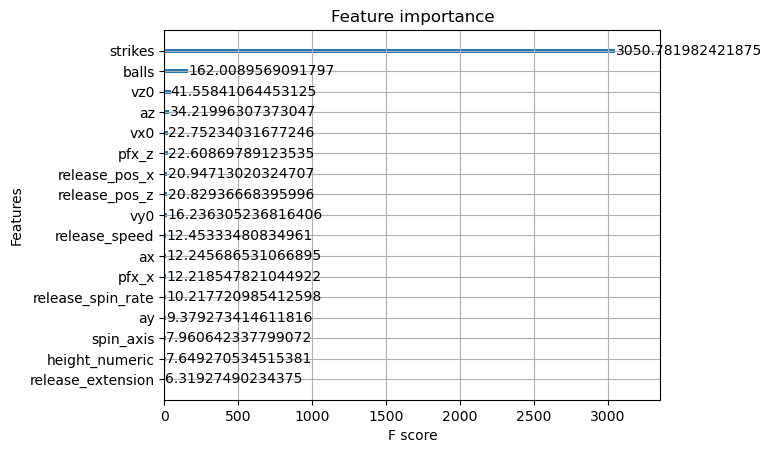

In [22]:
importance = final_model.get_score(importance_type='gain')
# Visualizing the feature importances
xgb.plot_importance(importance)
plt.show()

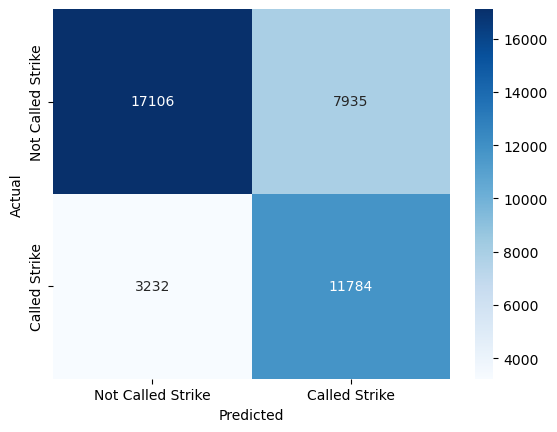

In [23]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Called Strike', 'Called Strike'], yticklabels=['Not Called Strike', 'Called Strike'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Testing Data Set Predictions

In [24]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'balls', 'strikes',
       'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az',
       'release_spin_rate', 'release_extension', 'release_pos_y', 'spin_axis',
       'height_numeric'],
      dtype='object')

In [25]:
predictions = xgb.DMatrix(testing_data, label=testing_label)

In [26]:
y_pred = final_model.predict(predictions)

In [27]:
testing_identifiers['xcs'] = y_pred

C:\Users\clayton.thompson\AppData\Local\Temp\ipykernel_24368\3630874201.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_identifiers['xcs'] = y_pred


In [28]:
testing_identifiers.to_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/cs_2022&3_xcalledstrike.csv")